# Memorias en CUDA

> Hasta este punto solo hemos visto y usados la memoria global del la GPU, la cual posee limitantes respecto a su uso tales como sus tiempos de acceso, la estructura de acceso, etc. Como veremos a continuación existen diversas capas de memoria que puden ser utilizadas durante la ejecucion de nuestros *kernels*.

>![Alt text](imagen/memLayers.png)
>![Alt text](imagen/memCUDA2.png)


> Algunas especificaciones de estas memorias durante la ejecucion de el *kernel* son:


![Alt text](imagen/cudaMem.png)

Es importante destacar que el uso de estas memorias posee diversas caracteristicas tales como su tamaño, la velocidad de acceso, la duracion dentro del flujo de ejecución.
La forma de declarar estas memorias dentro de nuestro kernel se da de la siguinete:
![Alt text](imagen/defMem.png)
La velocidades de accesos se muestran a continuación:
![Alt text](imagen/costMem.png)

> Como habran notado no se ha mencionado la memoria de Texturas, este tipo de memoria resulta estar ligada a otra estructura de CUDA llamada CUDA Arrays, estos objetos propios de CUDA y son la manera estructurada de generar arreglos en memoria (1D,2D,3D), la desventaja es que son espacios de memoria local que no podemos acceder directamente dentro de nuestros *kernels*. La lectura de la información contenida en CUDA Arrays se da solamente mediante las referencias conocida como Texturas. Los CUDA Arrays solo pueden ser escritos por dos metodo, Texturas de Superficies o copia entre bancos de memoria (Host o Device)


Veamos como usarlas. Aunque el escoger entre estas dependera exclusivamente del problema a resolver. Comparemos simplemente cada una de las memorias contra la **Memoria Global** midiendo el tiempo de ejecucion del *kernel*.

In [1]:
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import pycuda.driver as cuda
from pycuda.tools import DeviceData
from pycuda.tools import OccupancyRecord as occupancy

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Parte de lo que no hemos visto, es el elegir la GPU con la cual trabajar y generar un canal de comunicación (o contexto), usemos la siguiente funcion para tal efecto

In [3]:
from CUDATools import *

Available Devices:
  Device 0: GeForce GTX 1080
  Device 1: GeForce GTX 1080
  Device 2: GeForce GTX 1080
  Device 3: GeForce GTX 1080
Select device number: 0
Using device 0: GeForce GTX 1080


In [4]:
ctx

ctx,device = setDevice()
devdata = DeviceData(device)

def getKernelInfo(kernel,nthreads, rt=True):
    ''' This function returns info about kernels theoretical performance, but warning is not trivial to optimize! '''
    shared=kernel.shared_size_bytes
    regs=kernel.num_regs
    local=kernel.local_size_bytes
    const=kernel.const_size_bytes
    mbpt=kernel.max_threads_per_block
    #threads =  #self.block_size_x* self.block_size_y* self.block_size_z
    occupy = occupancy(devdata, nthreads, shared_mem=shared, registers=regs)
    print "==Kernel Memory=="
    print("""Local:        {0}
Shared:       {1}
Registers:    {2}
Const:        {3}
Max Threads/B:{4}""".format(local,shared,regs,const,mbpt))
    print "==Occupancy=="
    print("""Blocks executed by MP: {0}
Limited by:            {1}
Warps executed by MP:  {2}
Occupancy:             {3}""".format(occupy.tb_per_mp,occupy.limited_by,occupy.warps_per_mp,occupy.occupancy))
    if rt:
        return occupy.occupancy
    
def gpuMesureTime(myKernel, ntimes=1000):
    start = cuda.Event()
    end = cuda.Event()
    start.record()
    for i in range(ntimes):
      myKernel()
    end.record()
    end.synchronize()
    timeGPU = start.time_till(end)*1e-3
    print "Call the function {0} times takes in GPU {1} seconds.\n".format(ntimes,timeGPU)
    print "{0} seconds per call".format(timeGPU/ntimes)
    return timeGPU

Al inicir un contexto de comunicacion con una GPU en específico ganamos algunas herramientas de control en la ejecicion de los kernels. En caso de haber mas de una GPU la funacion esta diseñada para preguntar que GPU usar

## Memoria Global vs. Registros vs. Shared vs. Constante.

> Veamos un ejemplo sencillos de como declara y usar los distintos tipos de memoria dentro de PyCUDA

In [5]:
# Definimos los kernels 
Reg_Glob_RW = '''
__device__ __constant__ cuPres cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;


cuPres pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(cuPres *A, cuPres *B){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;

B[tid] = 3.141589cuStr; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
__shared__ cuPres pi; 
pi = 3.141589cuStr; // Shared memory write
//__syncthreads();
A[tid] = pi; // Shared memory lecture and Global Memory write
}

__global__ void rwSharedSync(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
__shared__ cuPres pi; 
pi = 3.141589cuStr; // Shared memory write
__syncthreads();
A[tid] = pi; // Shared memory lecture and Global Memory write
}

__global__ void rwConstant(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;

A[tid] = cMem; // Constant memory lecture and Global Memory write
}

'''

##  PRECISION

In [6]:
#presCPU, presGPU = np.float32, 'float'
presCPU, presGPU = np.float64, 'double'

In [7]:
def optKernels(kFile,pres='float',subBlGr = False, cuB=(1,1,1), cuG=(1,1,1)):
    kFile = kFile.replace('cuPres', pres)
    cString = 'f'
    if pres == 'double': cString = ''
    kFile = kFile.replace('cuStr', cString)
    if subBlGr: 
        downVar = ['blockDim.x','blockDim.y','blockDim.z','gridDim.x','gridDim.y','gridDim.z']
        upVar      = [str(cuB[0]),str(cuB[1]),str(cuB[2]),
                      str(cuG[0]),str(cuG[1]),str(cuG[2])]
        dicVarOptim = dict(zip(downVar,upVar))
        for i in downVar:
            kFile = kFile.replace(i,dicVarOptim[i])
    return kFile

In [8]:
myKern = optKernels(Reg_Glob_RW,pres=presGPU,subBlGr=True)
print myKern


__device__ __constant__ double cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(double *A){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;


double pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(double *A, double *B){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;

B[tid] = 3.141589; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(double *A){

int tid_x = 1 * blockIdx.x + threadIdx.x;
int tid_y = 1 * blockIdx.y + threadIdx.y;
int tid   = 1 * 1 * tid_y + tid_x;
__shared__ double pi; 
pi = 3.1415

In [9]:
cuCodeRG = SourceModule(myKern)
regRW = cuCodeRG.get_function("rwRegisters") 
gloRW = cuCodeRG.get_function("rwGlobal")
shaRW = cuCodeRG.get_function("rwShared")
shaSyRW = cuCodeRG.get_function("rwSharedSync")
conRW = cuCodeRG.get_function('rwConstant')
#conMemRW = cuCodeRG.get_global('cMem')[0] #Obtenemos un puntero a la direccion de memoria constante declarada en el kernel
regRW.prepare('P')
gloRW.prepare('PP')
shaRW.prepare('P')
shaSyRW.prepare('P')
conRW.prepare('P')

>Observemos algunas diferencias entre el uso de cada una de las capas de memoria, los **Registros** en si no representa ninguna diferencia de lo que hemos estado usando, **Global** tampoco resulta novedoso salvo por que es necesario usar dos arreglos en distintos espacios de memoria global, La memoria **Shared** o compartida requiere de un ingrediente extra, como notaran existen dos versiones; una es asincrona dentro del bloque y la segunda es sincronizada en el bloque: La linea que cambia entre las versiones de Shared es *__syncthread()* este comando obliga a que en la operacion que realiza el kernel espere a que todos los threads dentro del bloque hallan acabado las tareas hasta este punto, la *ventaja* de esta funacion es que permite coordinar las ejecuciones de tareas del kernel, pero la *desventaja* es perdida en la velocida de ejecucion. 

>La memoria **Constante** es iniciada desde el cpu o en el momento de la declaracion, si es requerido pasar los datos en memoria constante. En PyCUDA es necesario hacer referencia a ella mediante la funcion de **SourceModule.get_global** y posteriomente hacer una copia mediante **pycuda.driver.memcpy_htod**. Para nuestro ejemplo hemos definido direactamente el valor a alojar en memoria constante, ya que no es un valor dinamis en el codigo no es necesaria la tranferencia de datos

In [10]:
# Copiamos como cualquiere elemento de cpu a gpu usando la direccion previamente obtenida, ojo solo tenemos 64KB de espacio
# cuda.memcpy_htod(conMemRW,  np.float32(3.15149)) # To copy the value to the constant cache
# Cada vez que queramos modificar los valores de la memoria cosntante se debe hacer una copia HostToDevice

Evaluemos la velocidad de las distintas implementaciones

In [11]:
from time import time

In [12]:
nLoop = 1000
timeReg = []
timeGlo = []
timeSha = []
timeShaSy = []
timeCons = []
timeCPU = []
occK = []
cuBlock = (16,16,1) # 512,256,1024
threads = cuBlock[0]*cuBlock[1]*cuBlock[2]
cuGrid   = None
for i in range(8,14):
    
    
    N = 2**i
    a = np.ones((N,N),dtype=presCPU)
    b = np.ones((N,N),dtype=presCPU)
    A_gpu=gpuarray.to_gpu(a)
    B_gpu=gpuarray.to_gpu(b)
    #cuBlock = (16,16,1) # 512,256,1024
    threads = cuBlock[0]*cuBlock[1]*cuBlock[2]
    cuGrid   = (N/cuBlock[0],N/cuBlock[1],1)
    
    myKern  = optKernels(Reg_Glob_RW,pres=presGPU,subBlGr=True,cuB=cuBlock,cuG=cuGrid)
    cuCodeRG= SourceModule(myKern)
    regRW   = cuCodeRG.get_function("rwRegisters") 
    gloRW   = cuCodeRG.get_function("rwGlobal")
    shaRW   = cuCodeRG.get_function("rwShared")
    shaSyRW = cuCodeRG.get_function("rwSharedSync")
    conRW   = cuCodeRG.get_function('rwConstant')
    #conMemRW = cuCodeRG.get_global('cMem')[0] #Obtenemos un puntero a la direccion de memoria constante declarada en el kernel
    regRW.prepare('P')
    gloRW.prepare('PP')
    shaRW.prepare('P')
    shaSyRW.prepare('P')
    conRW.prepare('P')
    
    occK.append([getKernelInfo(regRW,nthreads=threads),getKernelInfo(gloRW,nthreads=threads),
                 getKernelInfo(shaRW,nthreads=threads),getKernelInfo(shaSyRW,nthreads=threads),
                 getKernelInfo(conRW,nthreads=threads)])
    
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    t5 = 0
    tcpu = 0
    for k in range(nLoop):
        t_reg = regRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_glo = gloRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata,B_gpu.gpudata)
        #ctx.synchronize() 
        t_sha = shaRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_shaSy = shaSyRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize() 
        t_con = conRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        #ctx.synchronize()
        t = time()
        a[:,:] = np.pi
        b[:,:] = a
        t = time()-t
        t1 += t_reg()/nLoop
        t2 += t_glo()/nLoop
        t3 += t_sha()/nLoop
        t4 += t_shaSy()/nLoop
        t5 += t_con()/nLoop
        tcpu = t / nLoop
    timeReg.append(t1)
    timeGlo.append(t2)
    timeSha.append(t3)
    timeShaSy.append(t4)
    timeCons.append(t5)
    timeCPU.append(tcpu)
    A_gpu.gpudata.free()
    B_gpu.gpudata.free()

==Kernel Memory==
Local:        0
Shared:       0
Registers:    6
Const:        8
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       0
Registers:    8
Const:        8
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       8
Registers:    6
Const:        8
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       8
Registers:    6
Const:        8
Max Threads/B:1024
==Occupancy==
Blocks executed by MP: 6
Limited by:            warps
Warps executed by MP:  48
Occupancy:             1.0
==Kernel Memory==
Local:        0
Shared:       0
Registers:    6
Const:        8
Max Threads/B:1024
==Occupancy

In [13]:
print myKern


__device__ __constant__ double cMem=3.15149; // Se puede definir directamente la memoria constante 
                                                                                //o declarala y posteriormente copiar los valores desde CPU con cudaMemCopy

__global__ void rwRegisters(double *A){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;


double pi = 3.141589; // Register memory write
A[tid] = pi; // Register lecture and Global Memory write

}

__global__ void rwGlobal(double *A, double *B){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;

B[tid] = 3.141589; // Global memory write
A[tid] = B[tid]; // Global memory lecture and Global Memory write

}

__global__ void rwShared(double *A){

int tid_x = 16 * blockIdx.x + threadIdx.x;
int tid_y = 16 * blockIdx.y + threadIdx.y;
int tid   = 512 * 16 * tid_y + tid_x;
__shared__ double p

In [14]:
occK,occK[:][0]

([[1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0]],
 [1.0, 1.0, 1.0, 1.0, 1.0])

([<matplotlib.axis.XTick at 0x7eff40360490>,
 <a list of 6 Text xticklabel objects>)

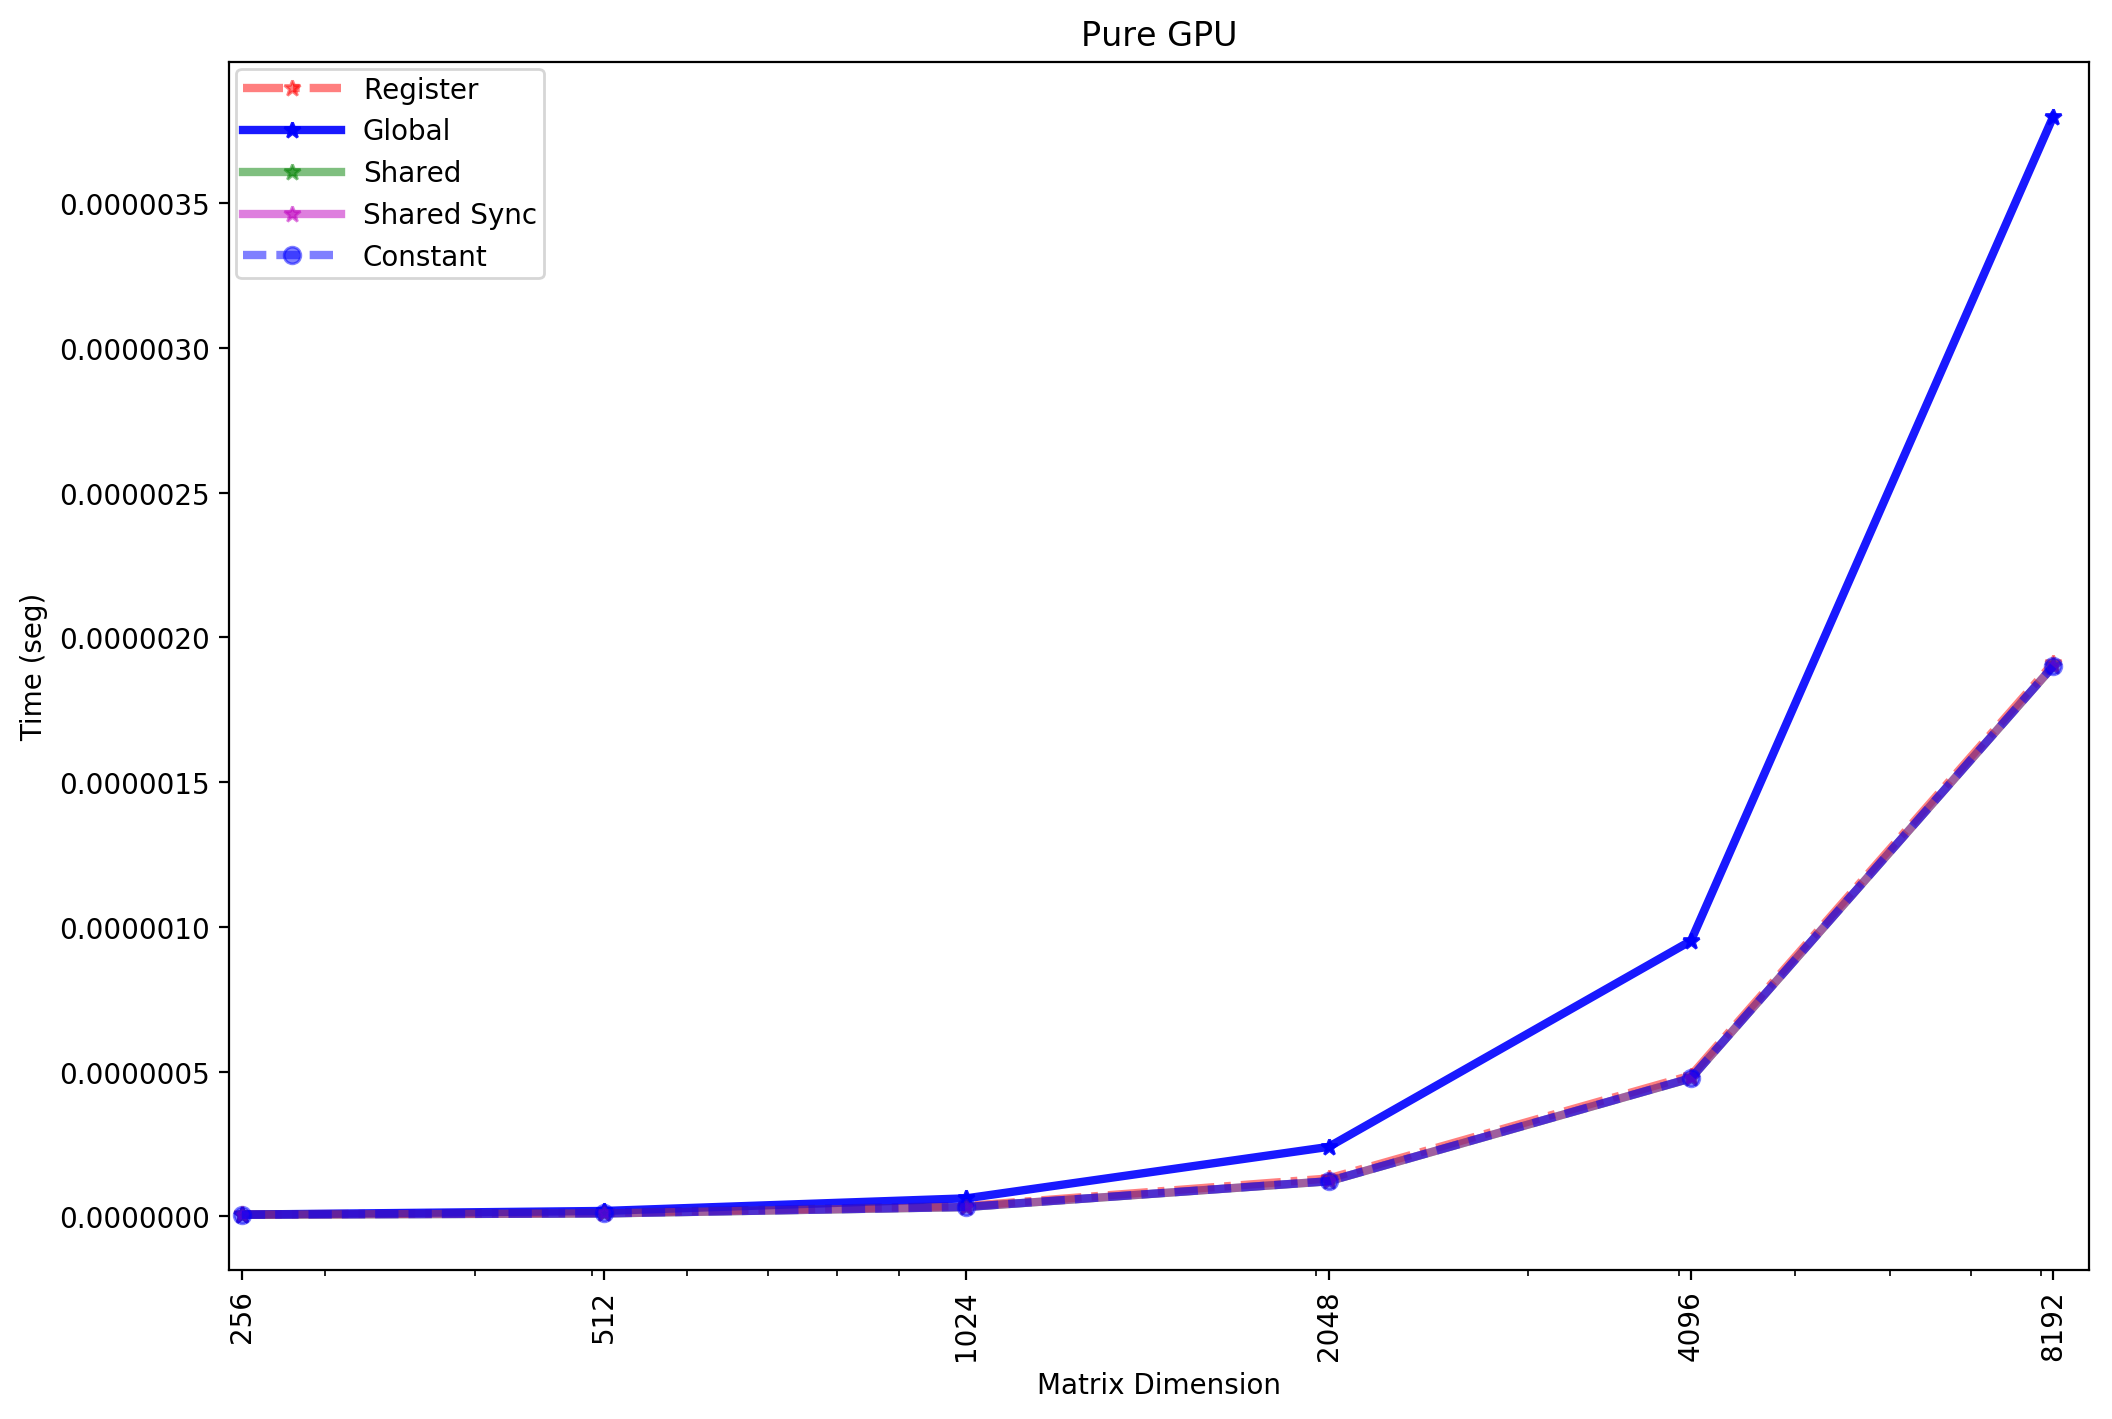

In [15]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.semilogx([2**i for i in range(8,14)],np.array(timeReg)*1e-3,'r-.*',label='Register',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeGlo)*1e-3,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],np.array(timeSha)*1e-3,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeShaSy)*1e-3,'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCons)*1e-3,'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.title('Pure GPU')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')

([<matplotlib.axis.XTick at 0x7eff40296e90>,
 <a list of 6 Text xticklabel objects>)

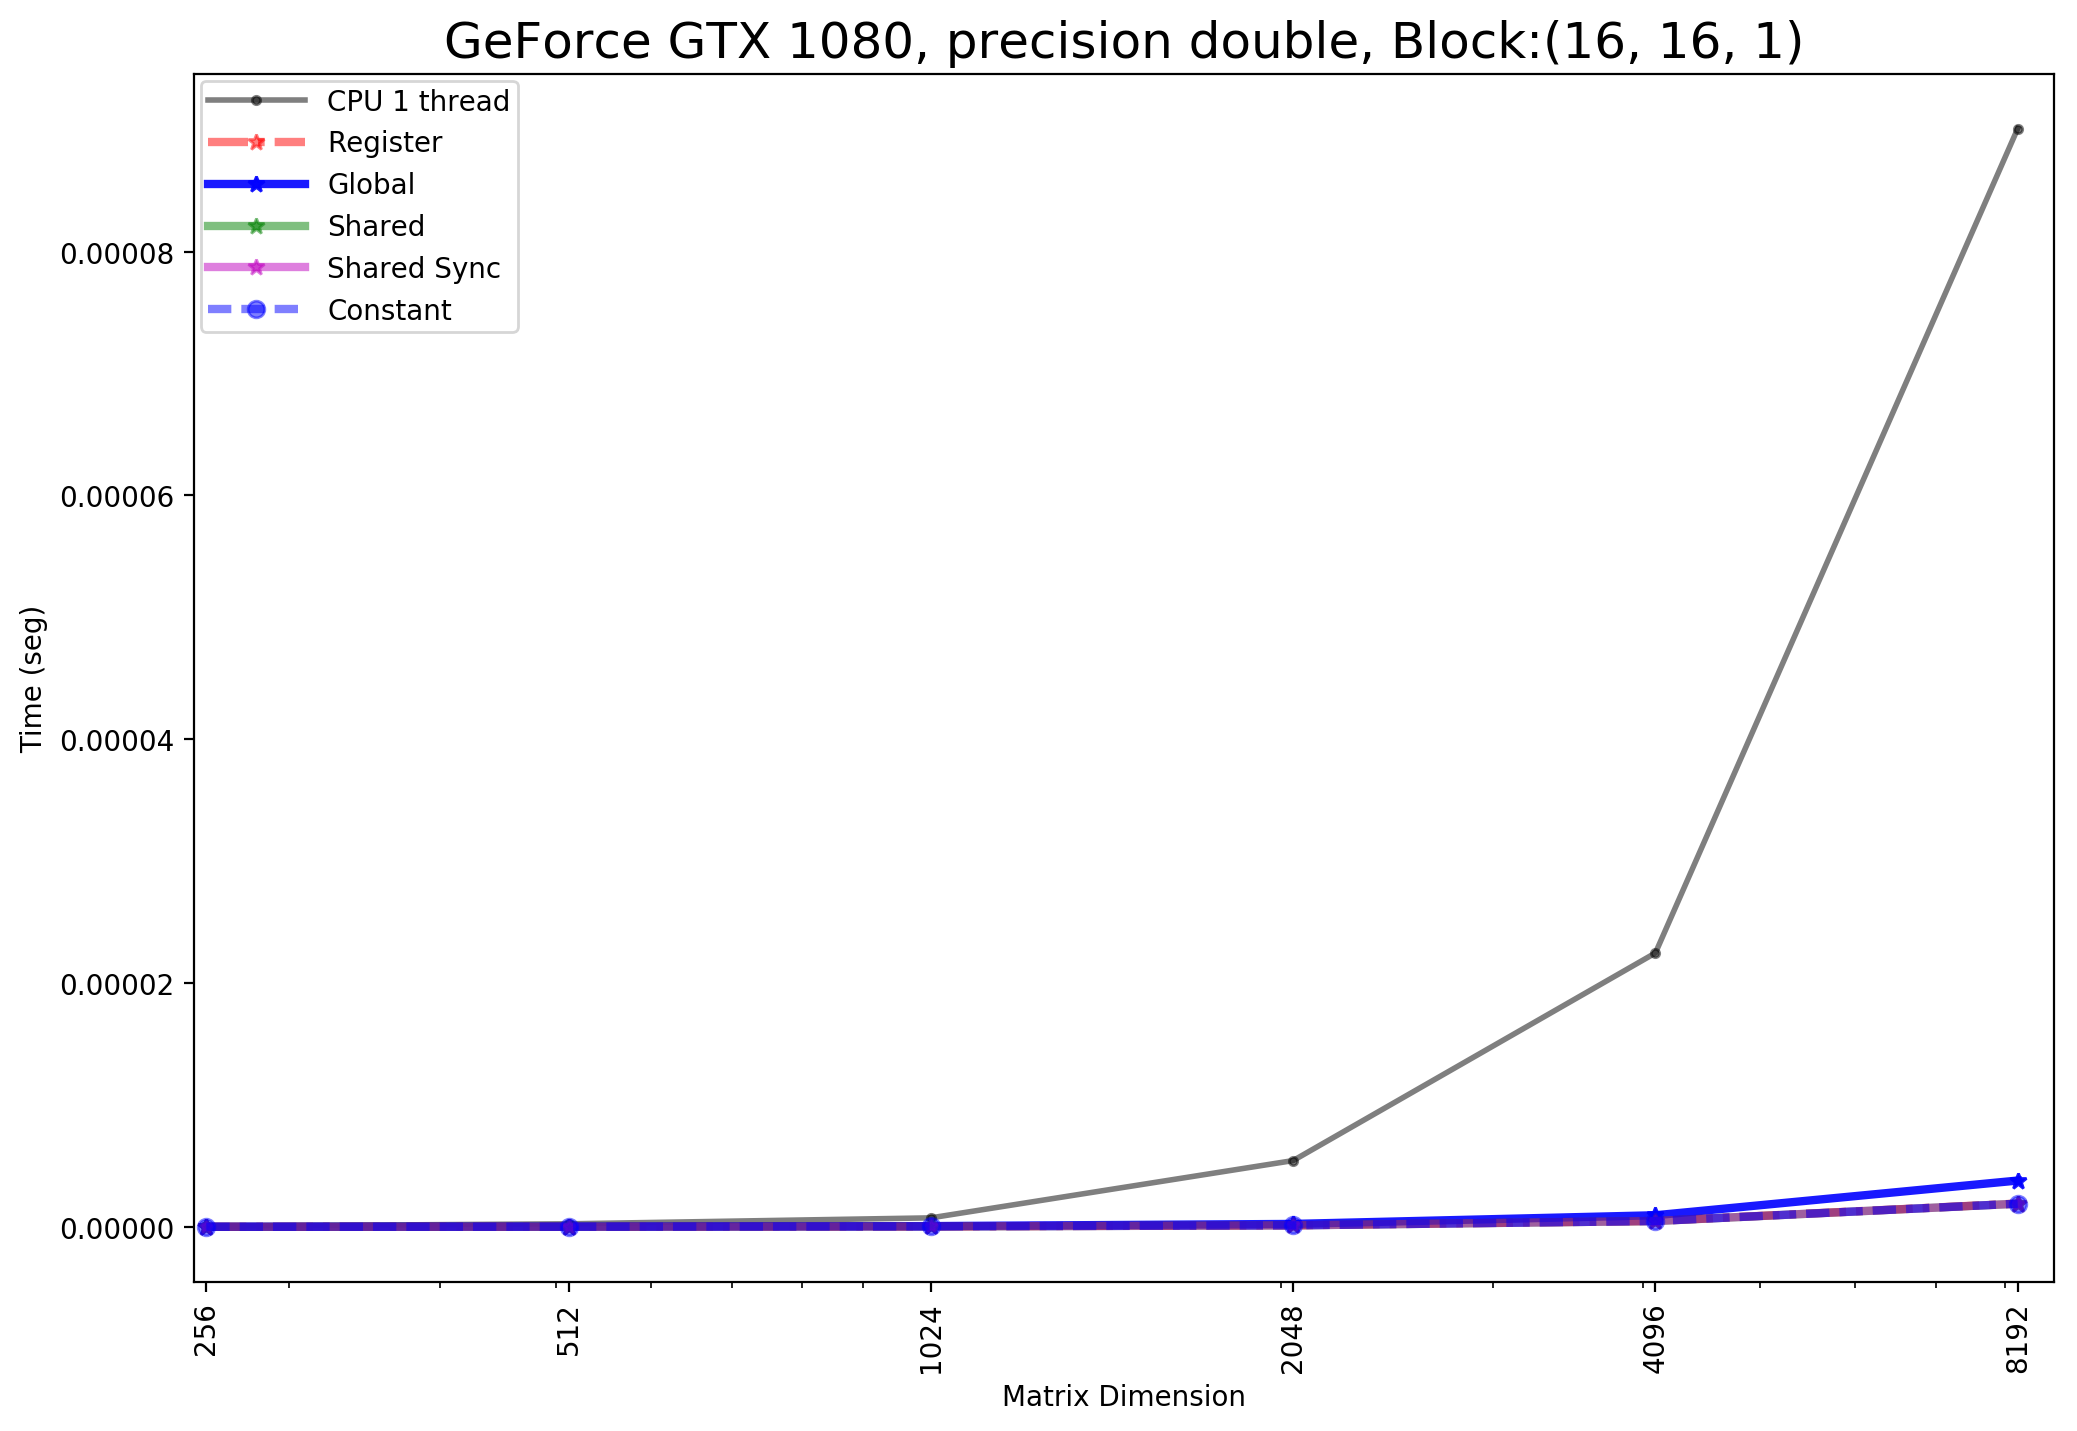

In [16]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('{0}, precision {1}, Block:{2}'.format(device.name(),presGPU,cuBlock),size=18)
plt.semilogx([2**i for i in range(8,14)],timeCPU,'.-',color=(0,0,0),label='CPU 1 thread',linewidth=2.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeReg),'r-.*',label='Register',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeGlo),'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeSha),'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeShaSy),'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],1e-3*np.array(timeCons),'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')

([<matplotlib.axis.XTick at 0x7eff0426ea50>,
 <a list of 6 Text xticklabel objects>)

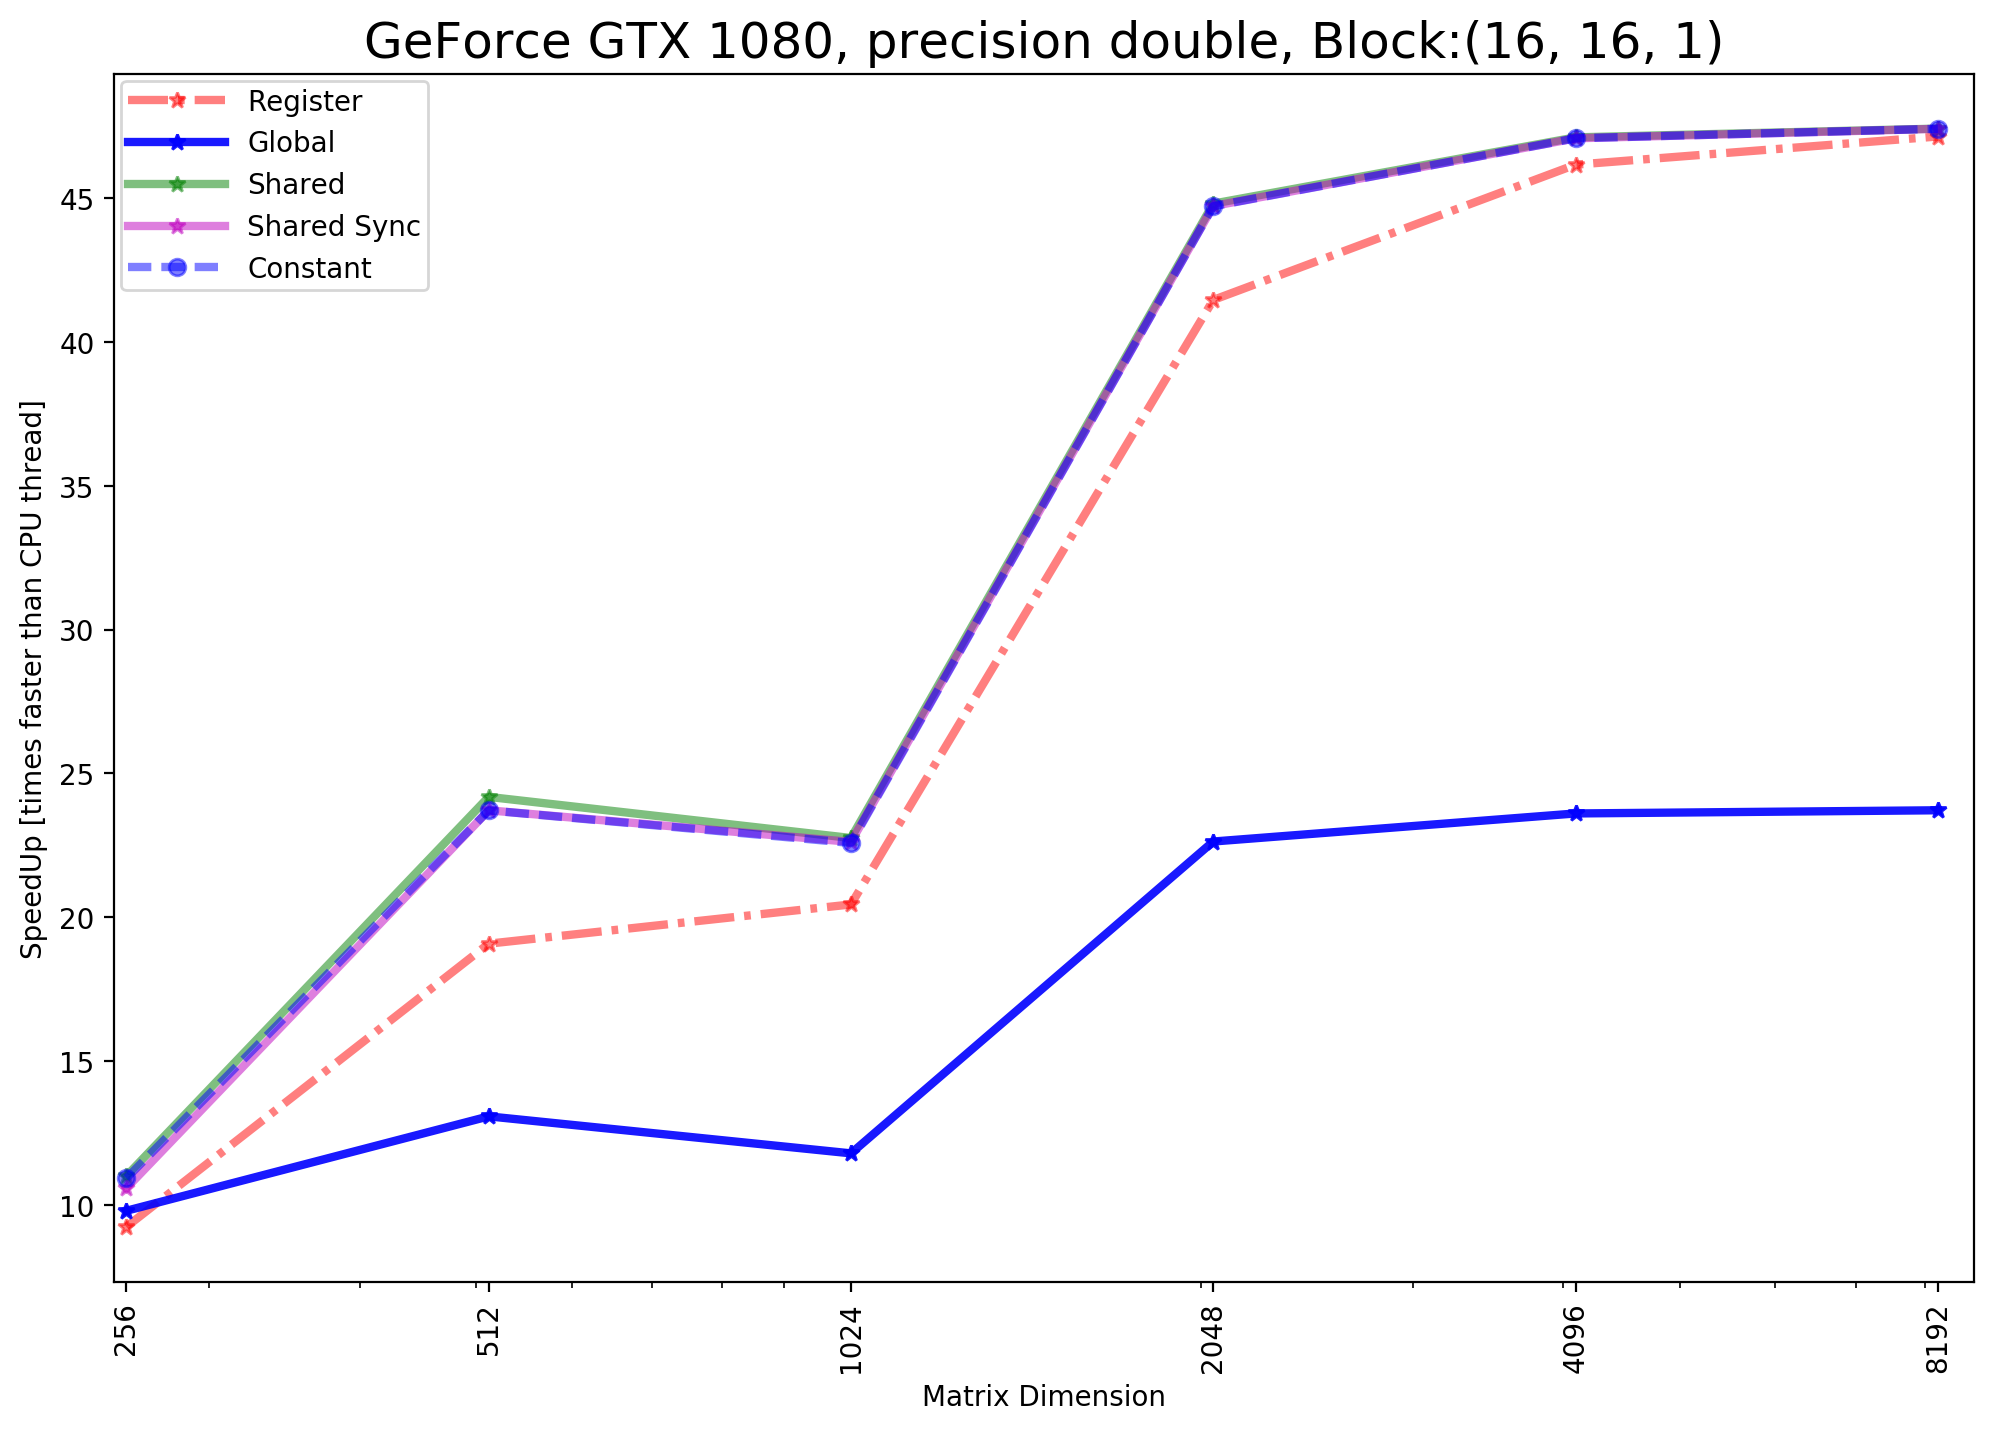

In [17]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('{0}, precision {1}, Block:{2}'.format(device.name(),presGPU,cuBlock),size=18)
#plt.semilogx([2**i for i in range(8,14)],timeCPU,'.-',color=(0,0,0),label='CPU 1 thread',linewidth=2.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeReg)),'r-.*',label='Register',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeGlo)),'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeSha)),'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeShaSy)),'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],np.array(timeCPU)/(1e-3*np.array(timeCons)),'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.ylabel('SpeedUp [times faster than CPU thread]')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')


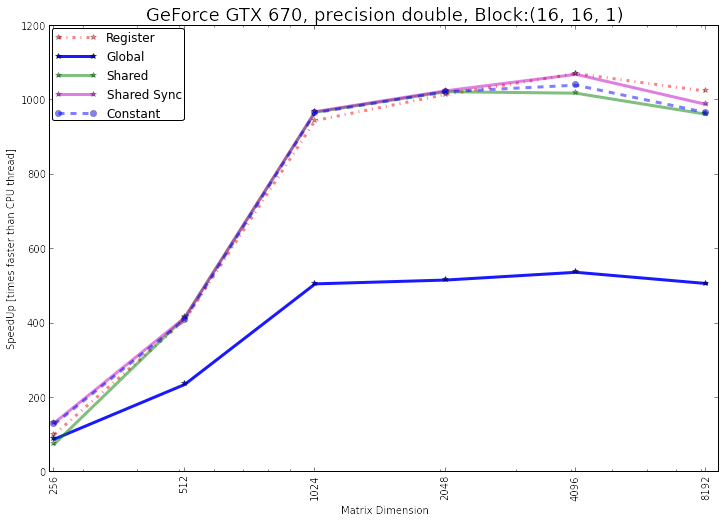
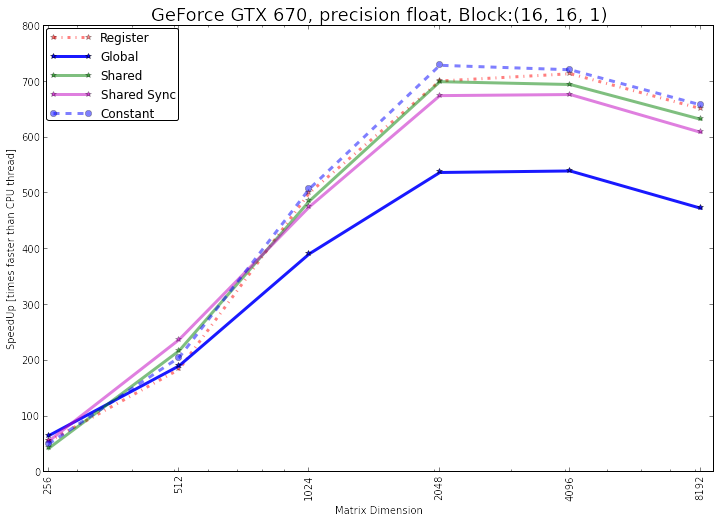

In [22]:
%%HTML
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtYAAAIJCAYAAACBeHo8AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzsnXdcFEcbx397hYOjHR1EigJS7FFBsSGIvZvYCxF7f40l0SS219hNglFjRWNLYl57CyJBsQQ7FgQbSEd6O7i67x/r4nEceAiI4nw/n/lwzM7sPDM7t/fss888Q9E0DQKBQCAQCAQCgVA9OHUtAIFAIBAIBAKBUB8gijWBQCAQCAQCgVADEMWaQCAQCAQCgUCoAYhiTSAQCAQCgUAg1ABEsSYQCAQCgUAgEGoAolgTCAQCgUAgEAg1AFGsCQQC4QMgICBgL4fDUVa1Xnx8vCOHw1EuX758aW3IVV2WLVu2jMPhKBMSEuxru63w8HAfDoej3Ldv33htyr/rmL8v3pd8Pj4+4Y0aNYqr7nlevXplaWxsnLd79+7AmpCLwDB48OBjvr6+YXUtB0E7iGJNqHFKSkp0t27dOt3X1zfM0tLylY6OjtTExCTH09Pzxtdff70mNjbW9V3Pzf5wVpRu3LjhWZN9qQuioqJaTpo0aWeTJk2eGBgYFOrp6RU7OjrGDx069H8HDhwYI5fLeW8bB9XUuHHjFwAwatSoQ1wuVxEWFuar3mZxcbGeq6trrLm5eearV68stZEzOzvbdP78+RucnZ2f6enpFVtaWr7y9fUNu3LlSifVcm+T74cfflisWl6pVHJ+/PHH/7i5ucXo6ekV29vbJ8yfP3+DWCwWVmdcP3QoiqIpinrnjQWqU7e+UZWxeJ/j5ujoGK8697lcrsLGxibVx8cn/I8//hhel/LVRDvffvvtf62srNK//PLLYNX87du3Txk9evRBNze3GC6Xq9DmYeH69esdBg4ceMLCwiJDT0+vuHHjxi9GjRp1SCaT8d9VvtjYWNf58+dv8PX1DROJRLnaPJCKxWLhihUrvm/atOkjoVAoNjMzy/L29r52/PjxQe8qB1C1MVm+fPnSS5cudT116lT/6rRJeD/w6loAQv3ixYsXjfv163c6JibGzcfHJ3zevHmbbGxsUgsLCw3u3r3bes+ePRM2bNgwPzEx0c7Gxib1XdsZNWrUoT59+pxVz3dycnpevR7ULT/88MPi7777bqWZmVnW8OHD/2jWrNlDHR0daWJiol1oaGj3cePG/XblypVOK1as+P7AgQNjVOtu3759SkREROeffvpprrm5eSabb2BgUAgAW7ZsmREeHu4TGBi4+8GDB83ZfAD4+uuv1zx9+tTl999/H2FpafnqbXK+fPnSwcfHJ1wsFgsDAwN3N2nS5Elubq7owYMHzVNSUhqollWXEwBomqaWLVu27MWLF40HDBhwUvXYf/7znx83b948a8iQIUcXLFiwPjo62iMoKGj23bt3W4eGhnavrwrkzp07J23fvn1KVes5OjrGl5SU6HK5XEVtyFXfoWmaep/t2dnZJa5evfobAFAoFNykpKSG+/btGz9y5MjDqampNnPnzv2pLuV7V5KSkhoGBwd/uWnTpnnqSuKaNWu+zs7ONm3duvVdsVgsTE5Otq3sXMHBwV9OnDhxV4cOHa4vXrz4B5FIlJucnGx75cqVTnK5nMfn82XvIuP169c7/Pjjj/9xdnZ+1rZt21thYWG+ld1PcnJyTPz8/C4+e/bMecKECXtatmwZVVRUpP/48WP36r6BqcqYtGjR4r6Pj0/4ypUrv+vfv/+p6rRLeA/QNE0SSTWSxGKxnpub22OBQFBy/PjxgZrKlJSUCNasWbMoJSXF5l3a+Oeff3woilJu3LhxXm32JT8/3/B9j19wcHAARVFKf3//kIrav3fvXsutW7dO03Rs/PjxeymKUr58+dK+ojZOnjzZn6Io5eTJk7erj+mwYcP+0FbWTp06Rdjb279MS0uzepe+JiYmNuRwOApPT89I1fyHDx82pShK+fnnnx9Rzd+8efNMiqKUhw4dGvm+r0tdz4uPPS1dunTZ2+ZlTSV2Lu/bt2+cNuXZ78z7GgsHB4f45s2b31fPz8rKMtXR0ZG0atXqbl3I17Vr1/BGjRq9qM45vv3225V8Pl+akZFhrn5M9dr37dv3NIfDUVR0nkePHnno6OhIJk2atKOm+5mdnW2Sl5dnRNM0bt261YaiKOXy5cu/r6j8mDFj9hsbG+c+fvzYraZlqcqY0PSb34c7d+60ru35QFL1EnEFIdQYu3btmhgbG+u6YMGC9QMHDjyhqYxAIJAsWrRorbq1Oi8vz3jRokVrnZ2dn+nq6pZYWlq+GjVq1KG4uLhG7yrP5cuXu/j7+18QiUS5QqFQ3KZNm9t79uyZoF6O9S+Mi4tr9Pnnn/9lamqabWxsnMceT0tLs549e3ZQ48aNX+jq6pZYWVml9+jRIyQ0NLS76nmePn3qMnbs2P02NjapAoFA0qhRo7iFCxeu08aFQSqV6ixevPgHIyOj/D///HOYoaFhgaZyLVu2jJo2bdq2dxkPAOjfv/+psWPH7t+5c+ekkJCQHgUFBYZffvllsJWVVfq2bdumaXOOy5cvd7l69WrHhQsXrrOyskqXyWT8qrppBAcHf0nTNDVx4sRdqvmHDx8eCQDqVrtJkybtFAqFYk3Wb23Zu3dvAIfDUV68eNFv2bJlyxwcHF7q6uqWtGzZMkrTa3hHR8f4bt26/XP37t3WPXv2/FskEuW2bNkyij1eleutzRzS5E+bmJhoN2HChD2srFZWVukdO3a8+ttvv41jy1TkYy2Xy3lr165d5OHhEa2np1dsbm6eOWTIkKMPHz5splpOtf7p06f7tWvX7qaenl5xgwYNUhYuXLhOoVBwtRlfpVLJWb169TeNGjWK09PTK27evPmDQ4cOjaqo/P3791sMHjz4mJmZWZaenl5x06ZNH61fv36BUqks87tUkf9vZb7lNE1TmzdvntWkSZMnenp6xa6urrG//PLLTG36AQCpqak206ZN22Zvb58gEAgktra2yVOmTNmekZFhoe05qoJIJMoVCAQSHR0dqTbltR07QPv7lzpZWVlmHTp0uC4SiXL/+eefbmz+8+fPnTS58x05cuSLdu3a3VR9W8Zib2+foE2/AGDDhg3zKYqi161btxAAioqK9OVyeY28XTcxMckxMjLKB97+JiA+Pt7x8OHDIydNmrTTzc0tRqFQcAsLCw1qQg6gamMCAL169ToPAH/++eewmpKBUDsQVxBCjfHXX399TlEUra4svY28vDxjb2/va4mJiXaBgYG7mzZt+iglJaXB1q1bp3t5eUXeunWrrfpNqKioSD8zM9NcNU9XV7eEdW84depU/8GDBx9r0KBByvz58zcYGhoWHD58eOTEiRN3vXjxovF///vfb9l6FEXRhYWFBl27dr3UqVOnK6tXr/6G9TOOj4937Nix49VXr15Zjh8/fl/btm1vFRYWGvz777/tL1686Ne9e/dQALh9+3YbX1/fMFNT0+xp06Zts7W1Tb53716roKCg2VevXu146dKlrjweT17RGFy9erVjWlqa9fjx4/eJRKLcqoxfVQkKCpodFhbmO3HixF2dO3eOePnypcPRo0eHmJqaZmtT/+zZs30A5pV2//79T50/f76XQqHguri4PP3+++9XjB49+mBl9WmapoKDg780MDAoHDly5GHVYzdv3mzH5XIVnp6eN1TzBQKBpGXLllE3b95sV9X+qrNo0aK1YrFYOHPmzF9YWUaOHHm4pKREd/z48fvYchRF0QkJCfZ+fn4Xhw0b9ucXX3xxhP1hrcr11nYOsW2yn+VyOc/f3/9CSkpKgxkzZmxp0qTJk7y8POOoqKiWV65c6TRu3LjfVPul/kp79OjRB48cOfJFjx49QmbMmLElNTXVZsuWLTM6dOhwPSIionOrVq3uqZY/e/Zsn61bt06fNm3atokTJ+46fvz4oA0bNsw3MTHJ+eabb1a/bVznzZu3KSgoaHbXrl0vffXVVxvT09OtZsyYsYX18Vfl1q1bbbt27XpJIBBIZsyYscXa2jrt5MmTAxYtWrQ2KiqqpfoDVGWv6zUd27x586y0tDTrqVOn/mpoaFhw6NChUbNnzw7Kzs42/f7771dU1o+EhAT7Dh06XJfL5bzAwMDdTk5Oz58+feqybdu2af/880+3W7dutWWVs3dBLpfzsrKyzGiaphQKBTc1NdXm559/nlNUVKQ/ZcqU7W+rX5Wxq8rcUyUuLq5Rr169zhcVFelfvny5S4sWLe6zx/z8/C4mJCTYqyrx6enpVk+ePGkyZ86cn991XFjOnTvX283NLeaff/7ptmDBgvUvXrxozOfzZd27dw/9+eef5zg7Oz+rbhvacP78+V5KpZLj7u7+eOzYsfuPHDnyhVQq1bG1tU3+6quvNqo//Nc21tbWaY6OjvHh4eE+77NdwjtQ1yZzkupPMjU1zRKJRDnq+QqFgpORkWGumoqLi3XZ47Nnz/5ZKBQW3b9/v7lqvZcvX9obGRnlBQQEBLN57KteTWnkyJGHaJqGXC7n2tvbvzQxMclOTU21ZutKpVJ+x44dr3C5XPnTp0+d2fyuXbuGUxSl/O6771aoy967d++zHA5HERIS4q9+TKlUUuznFi1aRLm7u0cXFhbqq5Y5duzYIIqilHv37h1f2dgFBQXNoihK+dNPP81RP5afn2+oOnaZmZlmms6hjSsIm86dO9eLHbcxY8bsr8p1HjRo0DGKopSWlpbpnTp1ijh06NDI4ODggGbNmj2gKEoZHBwcUFn90NBQP4qilBMmTNitfqxZs2YPrK2tUzXV++KLL/6kKEopk8l47zI/2Vepjo6OcaouHXl5eUYODg7xpqamWarz0sHBIZ6iKOXu3bsnqJ+rKtdb2zmk/to/KiqqBUVRyvXr18+vrF9xcXGO6q+0Q0JC/CmKUo4YMeKwatmoqKgWPB5P1rlz58vq9Q0MDArU506zZs0e2NjYpLxtbGNiYlwpilJ27979gmqf7ty505qiKCWHw1Gontvb2/sqn8+XPnjwoJnqeYYNG/YHRVHKixcv+rJ5FbkpaOo3e38wMjLKS05ObsDmS6VSvqenZySfz5cmJSXZVjTmNE1jwIABJ6ysrNJU69M04zrA4/Fky5YtW/ou8091TqknPT098c6dOyeql9ckX1XGTtu5pzrGd+7caW1tbZ3q7u4erele4ujoGKfuthAWFtaNoijl5s2bZ75tDCpze8jNzTWmKEppZmaWyefzpfPmzdt4/PjxgcuXL/9eV1e32MrKKu1d3c/U082bN9tW5goyd+7cH9n7XNOmTR/u3bt3/MGDB0d17tz5MkVRyqVLly6rCTneNiaqyc/PL9TQ0DC/ptolqXZSnQtAUv1JPB5PZm9v/1I9/8GDB83Uf0g2bNjwFU0zN3czM7PMXr16ncvMzDRTV8D9/f1DGjRokMyei/3hnDp16raLFy/6qqZHjx550DSNyMhIT4qilF999dUGdVlOnDgxQLV9mmZ+VDgcjoL1vWNTVlaWKUVRyj59+pyprN/3799vTlGUcsWKFd+py//q1SsLfX39wlGjRh2s7Bz//e9/l1AUpdyzZ8+X6seGDh36l+rYGRgYFGg6R1UU63///deLw+EoKIpSHj58eERVrrOfn18oRVFKZ2fnp6pKbk5OjsjExCTbxsYmRfVHWz2NGDHiMEVRyqtXr3qrH2vcuPFzBweHeE31xo4d+xtFUUr166RtYhXrtWvXLlQ/tnr16q8pilKeO3euF5vn4OAQb25unqHel6pcb23nkOr1Y/+Pj493oChK2bt377OvXr2yqKieJgVz2rRpWymKUqorXzRNY/DgwUcpilKyD2hsfU0PWDNnztxMUZSyqKhIWJnsa9euXUhRlPLs2bO91Y/17NnzvOq8TE9Pt6QoSjl06NC/1MuyDxMzZ87czOa9i2I9bdq0rerlDx8+PIKiKOW2bdumVjTmubm5xhwORzFp0qQd6tc2IyPD3NXVNcbb2/vqu8w/dk41btz4OXvPCg0N9du3b9+4bt26hXG5XLn6Q6m6fFUZu6rMva5du4Y7OjrGXbhwobuhoWG+t7f31ezsbBNt+/XHH38MoyhKefDgwVFvK1uZEpmYmNiQvc+pGzr27t07nqIo5aJFi9a86/irprcp1oGBgbsoilKamJhkq46FTCbjubi4PNHT0xPn5OSIakIWbRVr9uGppKREUBPtklQ7ifhYE2oMIyOj/Pz8fCP1/MaNG78IDQ3tHhoa2n3Dhg3zgTevbzMyMiyys7NN//77754WFhYZlpaWr1RTaGhod03h31xcXJ76+vqGqSYPD49ogHmNCQBNmzZ9pF5PvQyLhYVFhvrr3WfPnjkDQOvWre9W1u/Hjx+7A8DSpUuXq8tvZWWVLhaLhW8LYce2rWn8li1btiw0NLT7hQsX/Fu0aHG/ulExWJcHExOTHDs7u8R58+Ztys3NFWlbX09PrxgARo4ceVjVvUUkEuX279//VFpamvWTJ0+aaKqbnZ1teuzYscHu7u6Pvb29r6kfFwqFYolEIqhIboqiaKFQKNZWVk24u7s/rihPfV44OTk9Vx/vqlxvbeeQJhwcHF4uWbJkVUhISA8bG5vUtm3b3lq0aNHaW7dutX1b3bi4uEZcLlehqa8VfQc0uWyYmZllAYy/bWXtvXjxojEAuLm5xagfU5ehsu+nm5tbDEVRdHXWVmhqUzWvsnPHxsa60jRN7dq1a6L6tbW0tHz15MmTJtqGo6wIfX39Ivae5efnd3HcuHG/Xbhwwd/DwyN61qxZm7Ozs00rqluVsavq3EtPT7fq27fvGWdn52cXL170MzExydG2T+x3hK5mBBP23kJRFB0QELBX9djo0aMPcjgc5aVLl7pWp42qytKvX7/TqmPB4/Hko0aNOlRSUqIbGRnp9T5kYaFpmqKqGZaTUPsQH2tCjdGsWbOHERERnePj4x0dHR3j2XyhUChmg9urL85ib8T+/v4XFi1atPa9CqxCdZQ1tg/z58/fwC4wUedtP1LNmzd/AAB3795trX6sWbNmD9nPNeF/vXjx4h+ePHnS5NChQ6PMzc0ze/ToETJ79uwg1QVxldGwYcMkgPH5Uz/GLkrNyckx0VT34MGDo6VSqU5gYOBuTccbNGiQEhMT4yaTyfjqIbWSk5Ntzc3NMyvzVa9pNM2Lmrje2rJy5crvJkyYsOfMmTN9IyIiOu/atWvi+vXrFyxcuHDdmjVrvq6JNlgqC9dXXYWpOlSkRNTUgjZV2H6OHTt2v6q/vSqswlWTcLlcha+vb1hQUNDsyMhIr969e5+r6TbehqmpaXabNm1unz59ut+BAwfGVGWtjIWFRQbAPDhXVwY9Pb3ikpISXfX7C4/Hk5ubm2dWdG+paSq7z7F570sWluzsbFMDA4NCbRe5EuoGolgTaowvvvjiCPvjr7o4sDIsLCwyRCJRbl5ennFN7SzFxrJWj34AANHR0R6AZuucOs7Ozs8oiqI1KbuqNGnS5AnAPDS8ax86dux41draOu3YsWODN23aNE/bhYRVJSIiovPPP/88Z+jQof8bMWLE7wAwefLkHTt27Jj8xRdfHNEmRqqXl1fk9u3bpyQmJtqpH0tKSmoIABXFwt69e3egjo6OVH3hHYunp+eNCxcu+EdGRnp16tTpCptfUlKie+/evVY+Pj7hWna1QqKjoz3U+1mVeVGV663tHKqMRo0axc2cOfOXmTNn/iKRSAQ9e/b8e926dQvnz5+/QVMEBoDph0Kh4EZHR3uwD20s0dHRHhRF0TWx0x4L+517/Pixu/p52bFV7Q+g+fsZExPjRtM0pXodTE1Ns+/cufOZelnWSq4J9TZV8yq7xuz1kkgkgve90x278UllkSeqMnZVnXs6OjrSo0ePDhk2bNifU6ZM2S6TyfjaRiBiLehPnz510aZ8RVAURbdr1+7m5cuXuyQmJtq5urrGssckEokgIyPDgv3+1TZeXl6RABOZR/3Y2+5ztcWzZ8+cVQ0thA+UuvZFIan+pOLiYl13d/doHR0dybFjxwZpKsMuclGNQ836cf71119DNdVR9S/VJo61QqHgODg4xJuYmGSrLnSRSqX8Tp06RXC5XPmzZ8+c2PzKYrj27dv3NEVRytDQUL/K+t68efP7xsbGuS9evGikfkwmk/G08VdkfYC7d+9+oSI/4i5dulyqaPHK23ysCwsL9Z2cnJ5ZWlqmq8aaLSgoMHBwcIi3sbFJ0cZnMCcnR2RkZJTXsGHDRNXFeykpKTb6+vqFbm5ujzXVY30a1WNUq6YHDx4043A4CnUfUnZxpzY+nG8bXwcHh3jV8c3NzTW2t7d/qWnxYrdu3cKqe721nUPjx4/fq+pnmZeXZySVSvnq5aZMmfIrRVHKJ0+euNC0Zl/jCxcudFdd0Ks6vlwuV96lS5dLbJ6m+mzSNgZ1TEyMK4fDUfj5+YUqFAoOm3/79u3POByOQn3xYseOHa/w+Xzpw4cPm7J5SqWSYv3vw8LCurH533zzzQ8URSlv3LjRjs1TKBScXr16navIx9rQ0DBfdZGiRCLRadeu3Q1NixfVfVv79et3is/nS//9918v9X4qlUpKU5xmbVNFcayLi4t1Gzdu/JzD4ShU702a5KvK2Gk791TvgXK5nMv68v7888+z1cs+e/bMKSYmxlU9v1mzZg/atm17821j8DZ/4l27dgVSFKWcM2fOT6r57D1g9erVX7/r+Kumt/lYKxQKjqOjY5y+vn6h6kLWwsJCfTs7uwRTU9MssVisVxOyaONjnZqaak1RlPKbb775oSbaJKn2ErFYE2oMXV3dkjNnzvTt16/f6SFDhhz18fEJ9/f3v2BtbZ2Wn59vFBMT4/bHH38M5/F4cjs7u0S23qpVq5ZcvXq147Bhw/4cNmzYn15eXpE6OjrSly9fOpw9e7ZP27ZtbwUHB3+prRwcDkf5yy+/zBw8ePCxdu3a3Zw8efIOAwODwj/++GN4ZGSk15IlS1ap79BIV/Cq+5dffpnp7e19rXfv3ufGjx+/77PPPrtTXFysFxkZ6dWoUaM49nX8/v37x/r6+oa1aNHi/oQJE/Z4eHhEi8Vi4bNnz5yPHTs2eM2aNV9XZKVlCQgI2JuSktLgu+++W+nk5PR8+PDhfzRt2vQRn8+Xpaam2oSEhPS4evVqR3ULpLYsXLhw3YsXLxr/+eefw9R3Zty1a9dEbV1CRCJR7oYNG+ZPmTJle/v27f+dMGHCHolEIti2bds0uVzO27x58yxN9Xbv3h0IAJW9Ym7WrNnDGTNmbPnll19mDh069H+9e/c+9/jxY/fNmzfP8vHxCR81atQh1fJ79+4NmDBhwp6lS5cuX7p06XJtxsHCwiLDy8sr8ssvvwymX4fbS0pKarhr166Jurq6JdqcoyrXW9s5BJSdh2FhYb6TJ0/e8fnnn//Fbm9/+/btNrt37w5s3779vy4uLk8rkq979+6hw4YN+/P3338fkZOTY9K3b98zaWlp1lu2bJkhFArFQUFBs7Xpp7a4urrGstfN19c3bMiQIUdfvXpluWXLlhmtWrW6p241/fnnn+d07dr1UufOnSNmzJixxcrKKv306dP9QkJCeowePfpgt27d/mHLTp48ecfGjRu/Gjx48LE5c+b8zOfzZX/99dfnlcXXbtKkyRMvL6/IqVOn/mpgYFB46NChUbdu3Wr7/fffr7C1tU1WLav+3d+2bdu0Tp06XenSpcvlcePG/daqVat7SqWS8+LFi8YnT54cMH78+H2qIfs4HI7SwcHhpbZ+4bm5uaKDBw+OpmmaommaSklJaXDgwIExcXFxjSZPnrzjbfemqozdu8w9LperOHz48Eg+ny+bO3fuT3K5nDdv3rxNbDlN4fYA5o3lypUrv0tLS7NWd584depU/6ioqJYAY3WlaZpatWrVEpqmKRMTk5wZM2ZsYct++eWXwb/99tu4oKCg2ZmZmeadOnW68uDBg+Y7duyY3KxZs4ezZ88OUj23j49P+OXLl7vEx8c7vi02dH5+vhE799kdYi9dutSVfcM6cODAE+z9lcPhKLdu3Tp9wIABJzt06HB9+vTpW/l8viw4OPjL5ORk2927dwequgWFh4f7+Pr6ho0fP36fNr9XVRkT4E2Y0y+++OLI285NqGPqWrMnqf6l4uJi3S1btkzv1q1bmLm5eQafz5eKRKKcdu3a3Vi0aNEa1tKmmsRisd7KlSu/bd68+X09PT2xoaFhvoeHx6PJkydvV7VUVWXnxUuXLnXx9/cPMTIyytPV1S3+7LPPbmuKuuHj4/NPZbuOJScnN5g6deo2e3v7lzo6OhIrK6u0nj17nle1DNE0Ex5w6tSp2xwdHeN0dHQkZmZmmW3btr25ePHiVapWsrele/futZw4ceJOFxeXJ0KhsEhXV7fYwcEhfsiQIf87ePDgKLlcztVULyAgIFjdMsim0NBQPw6Hoxg+fPjvFbU7ZcqUXzkcjuLUqVP9tJHz6NGjg9u3b39dX1+/0NDQML9nz57nr1271kFTWbFYrCcSiXIqivihmhQKBWfjxo3zXF1dYwQCQUnDhg0Tv/rqqw2aIlOwVqxdu3YFvu28rMX64sWLvkuXLl1mb2//UiAQlLRo0SJKU2QUR0fHuIos1lW93trMIfb6sf/HxcU5Tp06dZu7u3u0kZFRnr6+fqGHh8ejpUuXLlMNF1iRxVkul3PXrl270N3dPVogEJSYmZllDh48+KiqpbOy+jRNY9myZUsrmlPqSalUUqtWrVrs4OAQLxAISpo3b37/0KFDIys6R1RUVItBgwYdMzU1zRIIBCUeHh6P1q9fP19TRJmzZ8/2btWq1V2BQFBia2ub9PXXX6+OjY1toslizeFwFPv27RsXFBQ0y8XF5YlAIChp0qRJbFBQ0KyKvjPq+ZmZmWYLFixY16RJk1hdXd1ikUiU06JFi6i5c+f+qLoLX35+viFFUcpOnTpFaPOdYUPVqUb50dfXL/T09Iz89ddfp2grX1XGTpu5p+keqFQqqYCAgGCKopRr1qxZpN4H9XZSUlL5/xI1AAAgAElEQVRs+Hy+VNO9mT0PG3pRdQw03XuLioqEX3/99Wr2u9WwYcPEWbNmBeXm5hqrl/3ss89uGxgYFGgTLYid65pkYeeNep1Lly518fX1vWhoaJgvFAqLOnXqFHH69Om+6uXYXW2//fbbldrMhaqOiY+Pzz/qO9WS9GGmOheAJJJIIuld0+DBg482adIktqKHDdXEKtaXLl3qUtdyk1Q/Ehu+Mzw8vGtdy/IhpKlTp25r3Ljx83eNNV/VlJ2dbcLlcuXViS1eU+k///nPJjMzs8yaCsGnmu7evduqKkYPkuo21Vq4vQkTJuyxsrJKV31tvWDBgvXu7u6PW7ZsGTVkyJCjeXl5xuyx1atXf+Pi4vLUzc0tJiQkpAebf/v27TbNmzd/4OLi8rQmdnUiEAj1A7lczvvnn3+6rVmz5uvKIloQCLVFSEhIj/79+5/q2rXrpbqW5UNgxYoV32dlZZnt3bs34H20Fxoa2t3Kyip94cKF695He5UREhLSY8mSJatqY+fc5cuXL/Xx8Qnv16/f6Zo+N6EWqC2N/fLly53v3LnTulmzZg/YvJCQEH92YcuiRYvWsIHeHz165NGyZct7UqmUHxcX5+jk5PSMfaXVrl27G5GRkZ40zewipbqBA0kkkUSStolYrEkiiSSSSKrtVGsW686dO0eox3L19/e/wMYx9vLyimRD1pw4cWLgyJEjD/P5fJmjo2O8s7Pzs8jISK/U1FSbgoICQ09PzxsAMG7cuN+OHz8+qLZkJhAI9RuysQKBQCAQapM6iwqyZ8+eCSNHjjwMMKtz27dv/y97rGHDhknJycm2fD5fxgZpBwBbW9vk5ORkW/VzkR9LAoGgLeS1PYFAIBCqA13Jpll1sqX5qlWrlujo6EjVQ2dVB1Uz/NKlS+vE/F9X7ZJ+VSznpzQX3kebtdVGbcv+scxhkmr/upO5ULXxqi9JvW8fYl8/JJk+ld+wd2nzbbx3i/XevXsDzp492+fixYt+bJ6trW2y6u5GSUlJDRs2bJhka2ubzLqLsPnqMUg/JHx8fOpahFrhY+nXhyRnXcjyPtqsrTY+pGtHqD+QeVU16vN4fQx9+5BkJL9h7857VazPnz/fa/369QsuXbrUVXUjhgEDBpwcNWrUoXnz5m1KTk62ffr0qYunp+cNiqJoIyOj/MjISC9PT88b+/fvH6seHF6dpKQk7Nu3DytXroRSqaz9ThE+OCiKgqWlJQIDA0FRFb6tqVXITenDOC/h04bMq6pRn8frY+jbhyQj+Q17d2rNFWTkyJGHvb29r8XGxrra2dkl7tmzZ8KsWbM2FxYWGvj7+19o3br13enTp28FAA8Pj+hhw4b96eHhEd27d+9zW7dunc76TW/dunX6xIkTd7m4uDx1dnZ+1qtXr/OVtTt48GBMmjQJxcXFdf4qhaS6SVKpFNeuXcOjR49w8eLF2prihI+ID+kHi1C3kLlAAMg8IDDUxjygtPEX+dChKIpm+8HlclFcXAwdHZ06lopQ1xQXF8PIyAgymayuRSEQCAQCgVAPoCgKdCWLF+udYv26w3UsEeFDgcwHAoFAIBAINcXbFOs6iQpC+HBISEiAoaEhUT4JBAKBQCAQqglRrD8iHB0dIRQKYWhoCGtra4wdOxb5+fnVOqe9vT0KCgreushv79696Ny5c7XaIhAIBAKBQKjPfBKKNU3TuHr+/Adhla2OLBRF4fTp0ygoKEBUVBQePHiA//73v7UgZc0jl8vrWgQCgUAgEAiEWuWTUKyfR0ej4NgxPI+OrmtRakwWKysr9OjRA48ePQIA/Pvvv/D29oaJiQlatWqFS5febC4XFxeHLl26wMjICP7+/pgxYwbGjh0LAIiPjweHwykNTbh37144OTnByMgIjRs3xqFDhxATE4OpU6fi+vXrMDQ0hKmpKQBAIpFg/vz5cHBwgLW1NaZNm4aSEiaKYnh4OBo2bIh169bBxsYGgYGB1eovgUAgEAgEwodOnW1p/j64f/MmHp47ByupFD1LShA2bRpucLloNnw4WkydWrZweDjzVz30Snh42WOajmtR776+/htZrK0RdvgwbujooFnv3mjRrp3WfWIt3UlJSTh//jw+//xzJCcno1+/fjhw4AB69eqF0NBQDB06FLGxsTAzM8OoUaPQuXNnhIWFITIyEn369MHAgQPLnbuoqAhz5szBrVu34OLigvT0dGRlZcHNzQ3bt2/Hrl27EBERUVr+66+/RlxcHKKiosDj8TBq1CisWLECP/zwAwAgPT0dOTk5SEhIgEKh0LqPBAKBQCAQCB8j9dpi3bxtW7QbMgS0RMKs4lQo4OnujuaurnUvi0QCz6FD0bxtW63PQdM0Bg0aBCMjI9jb28PJyQlLlizBgQMH0KdPH/Tq1QsA0L17d7Rt2xZnzpxBQkICbt26hRUrVoDH46Fjx44YMGBAha4oHA4HDx48QHFxMaysrODh4VHatrosO3fuxKZNmyASiWBgYIBvvvkGv//+e5lzLV++HHw+H7q6ulUdMgKBQCAQCISPinqtWFMUBYqiIM/Px980DblEUppf57K8XnRYFVkoisKJEyeQn5+P8PBwhIWF4fbt23j58iWOHDkCExOT0nT16lWkpaUhJSUFpqamZRRbOzs7jefX19fHH3/8gV9//RUNGjRAv379EBsbq7FsRkYGxGIx2rRpU9pm7969kZmZWVrGwsKCxBMnEAgEAoHwyVCvXUEAIC8jA86zZ8PJwwPPo6ORn5kJdO1avmBFu+9ocv94x3oaZXlHunTpglmzZmHRokXo2bMnxo4dix07dpQr9/LlS2RnZ6O4uBh6enoAmBB7FSn0PXr0QI8ePSCRSLBkyRJMmjQJly9fLlfe3Nwcenp6iI6Oho2NjcZz1dV24gQCgUAgEAh1Qb22WANAGx8fODdtCoqi4Ny0KT7TpFR/pLLMnTsXN27cQKdOnXDq1CmEhIRAoVCgpKQE4eHhSE5OhoODA9q2bYtly5ZBJpPh+vXrOH36tEal99WrVzhx4gSKiorA5/Ohr68PLpcLgFksmZSUVLqLIYfDwaRJkzB37lxkZGQAAJKTkxESElKtPhEIBAKBQCB8rNR7xbo+Y25ujvHjx2PTpk04efIkfvjhB1haWsLe3h4bN24sjfRx8OBBXL9+HWZmZvjuu+8wfPjwMi4arJKtVCrx448/wtbWFmZmZoiIiMC2bdsAAH5+fmjatCmsra1haWkJAFi7di2cnZ3Rvn17GBsbw9/fH0+ePCl3XgKBQCAQCIRPAbKl+SfI8OHD4eHhgaVLl9a1KLUOmQ8EAoFAIBBqCrKlOQG3bt3C8+fPoVQqce7cOZw8eRKDBg2qa7EIBAKBQCAQ6hX1fvEiAUhLS8OQIUOQlZUFOzs7/Prrr2jZsmVdi0UgEAgEAoFQryCuIIR6DZkPBAKBQCAQagriCkIgEAgEAoFAILwHiGJNIBAIBAKBQCDUAESxJhAIBAKBQCAQagCiWBMIBAKBQCAQCDUAUawJBAKBQCAQCIQagCjW9YyAgAB89913WpXlcDh48eLFO7Xj6OiIixcvvlNdAoFAIBAIhPoIUaw/Qn7//Xd4eXnBwMAAVlZWaN++fenW4xRFvZetxN9XOwQCgUAgEAgfC5+EYk3TNFat2vpBxDOuriwbN27E3LlzsWjRIqSnpyM9PR2//vorrl27BqlUWtoGgUAgEAgEAuH98kko1mfOhGPr1nScPXuprkWplix5eXlYunQptm3bhiFDhkBfXx8A0KpVK+zfvx86Ojrl6uzcuRMuLi4wMzPDwIEDkZqaqibPGTg5OcHCwgILFy4sVcqfP38OX19fmJubw8LCAmPGjEFeXt479JhAIBAIBALh06Beb2m+f///sHXrCdy65QGFYhkGDVoLitoDoXAghMKh71UWsfh/EItPgKbfyNK27R5Mnz4QY8dqJ8v169chkUgwcOBArcqHhYVh8eLFuHDhAjw8PDB//nyMGDECly69UeqPHz+O27dvo6CgAN27d4erqysCAwMBAEuWLEGXLl2Ql5eHoUOHYtmyZfjxxx+r3nkCgUAgEAiET4B6bbEeM2YIFi8OAKB87Q+shIHBl9DTG/LeZdHTGwIDg7KyLFnyJcaM0V6WzMxMmJubg8N5c9m8vb1hYmICoVCIiIgIACj1fT548CACAwPRqlUr6OjoYPXq1bh+/ToSEhJK6y9atAgikQh2dnaYO3cuDh8+DABwcnKCn58f+Hw+zM3N8Z///KeMQk4gEAgEAoFAKEu9VqzZBXZKpQRc7jIolSUA6mbRHdNmWVmqugDQzMwMmZmZUCqVpXnXrl1DTk4OzMzMyuQDQGpqKhwcHEr/19fXh5mZGZKTk0vz7OzsSj/b29sjJSUFAJCeno4RI0agYcOGMDY2xtixY5GVlVXVbhMIBAKBQCB8MtRrVxAAePEiBSdPdkOfPl1x9uwlvHiRglmz6kaWoKAUODmVlaUqdOjQAQKBAMePH8eQIW+3dDdo0ADx8fGl/xcVFSErKwu2traleQkJCXB3dy/9zB5bvHgxuFwuHj58CJFIhOPHj2NWXQ0cgUAgEAgEwkdAvVesZ88eXfq5b1+fuhME1ZdFJBJh6dKlmD59OmiaRo8ePaCvr4/79++jqKiotBy7AHHkyJEYOXIkRo0aBTc3NyxevBjt27eHvb19adkNGzbAy8sLBQUFCAoKwldffQUAKCwshLGxMYyMjJCcnIz169e/Y68JBAKBQCAQPg3qtStIfWTBggXYtGkT1q1bB2tra1hbW2Pq1KlYt24dvL29Abzxsfbz88PKlSsxdOhQNGjQAHFxcfj999/LnG/gwIFo06YNWrdujX79+mHChAkAgKVLl+LOnTswNjZG//79MXToUBK3mkAgEAgEAqESqPoQ85iiKJrtB0VRJI4zoRQyHwgEAoFAINQUr/WKCi2NxGJNIBAIBAKBQCDUAESxJhAIBAKBQCAQagCiWBMIBAKBQCAQCDUAUawJBAKBQCAQCIQagCjWBAKBQCAQCARCDUAUawKBQCAQCAQCoQYgijWBQCAQCAQCgVADEMWaQCAQCAQCgUCoAYhiXU/Yu3cvOnfuXGftOzo64uLFi3XWPoFAIBAI2qBUKrHtvxuhVCrrWhRCPYQo1h8ZV65cgbe3N0QiEczMzNCpUyfcunWrrsUCRVFky3MCgUAgfPCEnTqPnIMxCDt1vq5FIdRDPgnFmqZpnP/n/AextXV1ZMnPz0e/fv0wZ84c5OTkIDk5GUuXLoVAIKhRGeVyeY2ej0AgEAiEOkOhAFJScGTFasxpOwj31p3FMJOOuLfmHOZ0G4sjew8Cd+8CMlldS0qoB3wSinV0bDSORR1DdGx0XYtSLVmePHkCiqIwfPhwUBQFXV1d+Pv7o3nz5qVlFixYAFNTUzRu3Bjnz795Gg8ODoaHhweMjIzg5OSEHTt2lB4LDw9Hw4YNsW7dOtjY2CAwMBA0TWPNmjVwdnaGubk5hg8fjpycnNI6+/fvh4ODA8zNzfHDDz+842gQCAQCgVBDvFagaSUNeZ4cJfElKLxXiNxzqcicdxQdbxmjG9USdLwxClNEoBOM4Os0CF31/VCwPRzSTHlZoxdNA6dOAZcuAQ8eAMR1hKAFvLoWoDa5eecmzl07h9D0UFCNKUw7OA1cMRfO7s6wdbZ9r7IkP0vGs8fPoBAqSmXpbtUdvb17o91n7bQ6h6urK7hcLgICAjBixAh4eXnBxMSk9HhkZCQCAgKQlZWF7du3IzAwEMnJyQAAKysrnDlzBo0aNcLly5fRu3dvtGvXDq1btwYApKenIycnBwkJCVAoFAgKCsLJkydx+fJlWFhYYNasWZgxYwYOHTqE6OhoTJ8+HefOnYOnpye++eYbJCUl1fygEQgEAoGgCk2DzsuDIiELcpEt5LlyJuXIIc8sgfxoCOSe3QBa1TWRBjKMAIUSEHOgkMhwnn8DkCpAF9IQ38qBON4G2J4Oji4HAjsBBPYC6JopoXPjDjhcGhAIgGbNysqiUADh4YCf3/scAcIHDvUhuEdUF4qiaLYfFEWVPnHSNI1HMY8w5cAU8F34kD2VoaVbS1g0tHjv/sA0TSMjMQNRsVGlsuwYuwMerh5VkiUmJgZr165FaGgo0tLS0KdPH+zcuRNnz57FqlWr8PTpUwCAWCyGgYEB0tLSYGlpWe48gwcPRrdu3TB79myEh4ejZ8+eKCgogI6ODgDAw8MDv/zyC3x9fQEAqampcHBwQHFxMVatWoWYmBgcOnSotC0TExOcO3eutPyHgup8IBAIBMKHD03TUObLIM9XQsYqzqzy/L/zkOfTjOLcqRPAU7MP/nsdaNUK0NUrm//oEQAaF+OjYObghNZeHXD33k3kZGejW8suQGYG0NCubJ38fODubQgMpRA4CiGYNgS6drrgGnCZ41lZwIEDwJw5ZesVFQFHjwImJoClJeDpWaPjQ6hbXusVFSpu9dpizS6ok8gk4D3jQSKTlObXhSygUG1Z3NzcEBwcDACIjY3FmDFjMHfuXPTs2RPW1tal5YRCIQCgsLAQlpaWOHfuHJYvX46nT59CqVRCLBajRYsWpeUtLCxKlWoAiI+Px+DBg8HhvPEW4vF4SE9PR2pqKho2bFimLTMzsyr1g0AgEAifJjRNQylWMspyZgnk+Uom5bxRoukr14DWrQGBbtnKcn2ALmI+i8WAkVHZ42bmgFwBjj4HfBM+eCIek/p1Ac+Eh3GinuAZ80DxKNjL7SFJlUCSKIEkwRQliSVQFqm4e+gKABdXSIqLISniA39kAAB4pjwI7ATQpTIg4JqBT9Nlf8uzs4Hnz5nPNjblFevcXODGDaBHjxoYTcKHRr1WrAEgIzsD+ybsg4erB6Jjo5GZk4muHbrWiSzh18Ixo92MMrJUB1dXV4wfPx47duxAz549KywnkUgwdOhQHDhwAAMHDgSXy8XgwYPLWHLVFXx7e3sEBwejQ4cO5c5nY2ODx48fl/4vFouRlZVVrb4QCAQCoX5A0zSUJcqylubcsol+GMsooCUlQJs2gKFh2ZPo6TGKs7pirS8EpBJwRHrgWXLAayxkFGeT1wq0qAF4Ih44/LcvIaN4FHTtdKFrpwt4M3LLs+WQJEpQklACSQIfMp3ywQHk2XLIs+UoKgYgdgdnXSLjPmIngK69LnQys98sYFNx1ywlIwNITy+fn5QEnDjB1GnUCNDw+0v48Kn3irWPt0/p56ZuTetOEFRfltjYWJw5cwbDhw+Hra0tEhMTcfjwYY3KrypSqRRSqRTm5ubgcDg4d+4cQkJCyix6VGfq1KlYvHgx9u3bB3t7e2RkZOD69esYMGAAPv/8c3h5eeHq1ato164dvv/+exIPlEAgED4hlBJlhUqzLEcGWvLacPPsKWBhCRgblz2BVMoo1QCjQKsp1hyREDx9CXjuwjdWZxEPPANL8Mx1wRHUfOwFiqLAN+ODb8aHQSsDAIBCrGAs2q+VbWmKFLT8dd/0hICeEMpiJYqfFKP4STGTr9CDQDAQAkMxBPrG0C1SgKvPfdNQdjZgalpegMxMRunOyABU3iCXEhcHPHsG+PuXzWeNZCTk7QdBvVes6xOGhoaIjIzEpk2bkJubC5FIhP79+2P9+vX43//+V87qzP5vaGiIoKAgDBs2DBKJBP3798fAgQM1lmWZM2cOaJpGjx49kJKSAktLS4wYMQIDBgyAh4cHtmzZglGjRqGoqAjz5s2DnZ2abxqBQCAQPlqUUmU5hVlViVYWvzamZGQAWZmMcmzvAJibq51ICRQWllOsKWMheMVS8IQK8Jxl4HmblHHd4AgcPghFkSvkQugqhNCVca+k5TTjPpLwRtlWitUMS1wdSOQ6kOSYADcB3EwEz5QHXXtdCOwFEIgcwXdwQLneqUTe0mjpTk/XHBLw3j3g77+ZOi1bAu3bV6fLhGpSrxcvEghkPhAIBEJ5lDIlFHmKUguzuhJdxtcYYKypXG55he/FcyAhkfns6MgkABSfYpTkzHjwUACef4cylmeOtACUVMpYbtUXIH5EsO4jjOsIo2zLMt8eD5ujxyl1HRHYCyBoIAClkDLW7OxswMwMUFk3BQA4dw4Qicq7iISFAZcvM5+7dAHUgwjcuME8+Pj4lM0vKQE4HM3WcUKFfNKLFwkEAoFA+BSh5Uws54qszopCRdkKJcVATu4btwz1aFLFYkAiLVWsKR4FrjEXfJ4BePIC8HTl4DU1Am94B/BMeOAIOcyb0CIRE5ZOfZGhUFSLva+Y2NiXCA19DpmMAz5fie7dneDq6vDO51N1HzFszbizsO4jpcp2igRQG+5y7iNcQNCA9dNuBIGhAFy1ttCxI/Nwo05e3pvPmizdmZmaXU+uXgUiIgB9faBbN6Bt27LH5XKmvQ/gzcHHBFGsCQQCgUD4yKAVNOT5FbtqKAoUgKaXdSXFjIKs7vOckwPEPmE+W1kCNpbgGav4NruYgJfwCLwxncAT8cA14DKKc44+8IwDWFgwSV9tsZ++fq30/12IjX2JffueQUfnTdzpffsuYvx4VEu5Vkej+0jKG9cRSaKkvPuIAqW+3PnX8gEAPLPX7iOvLds8M0PNkcQGDWL8rnNyNCvWOTmAk5PmfIAJD6jprcHffzOuPV5eZfPZYAXGxh/124bagowIgUAgEAgfGLSShqJAUeECQXmeXLPiTNPMK35xEQCKcSlQpbAISE0FWjYHz4j3JqKGuyl4VAZjeXaUgTu7NyiOihJXpAck8AA7tSgdJiZAO+02OatrQkOfQ6HwQ04OY0Tn8QBDQz9cvBhWo4q1OhSPgq69LnTtdWHc0ZhxH8mSlyrZJQklkGfJy9WTZ8lRmFWIwruFAACOUMV9xO61+wiPYizKBgZM0sQXXzAuH+oolYxFWqGoWCF3cSmfHxbGxAWnKODzz4GmasEY8vKYqC6fqIsJUawJBAKBQHjP0LSK4qzJ6pwnByoLtkQrGcuzrpqim5cL3IsCQINraQDeZw3KRtVQ6oB/4V9wF/YrqziLhQC3EWOhtLYGOGqWUX19wN29prpfIQoFEzBEImH+sp9NTTXrflFRQGxs+TpduzL7xKgik3GQlAS83pAYAKMbmplx0Lbt+9vHhaIo8M354JvzYfjZa/eRIkUZi7ZG9xGxEsWxxSiOVXMfsRdA147x1eYKNbiKVKTgDhvGKNcFBZrfLIjFmgc9O5v5S9PlwyQCwMmTzAJKdaX8xQtmwE1MGNcgTcp+PYAo1gQCgUAg1DA0TUNZ9CayhqYFguqKk0bkckZjVFd8xMXgPrsPXj+fN0qzCQ88ngF4B8+AJ5CD0hMAAZ+X9ZFVCIEUB5QLSSEUMtbHKqJQMOJxucyu3+q8fAkkJJRVkqVSoHlzzXr6hQvAv/+Wz+/RA/D2Lp+fng5ER5fPLywsn8fnK8u5KNM0UFys1BhsA2C8HmiaMfzXpqsxV58LoZsQQjc195EECUoSGV/t0kgsLKruI2DcR/jm/DdbstvpgmfGq3wjOg6nvFsQy+TJb0L5qWJszCjd+fmafbdzcjTnX7jAvC0BgMBAQD2aWEICYGWleSJ9RBDFmkAgEAiEKkLTNJTFFcRyzmEszrSsGhGJZDJw7keChyLwjTngjR8KnupOggYAteEYEDCs7II22gCwN2HcAiws3vg8sHC5QP/+pf/m5jLKI6vwsn/t7QEHDd4R164xQSbYsorXDwfduzM7jKvz7BmzPk4da2vNinVFxlWpVHN+Vcp37+6E27cvwsTED1wu4zGTn38RjRo5o0EDzee5cgW4e5d5MdCgAWBryyQHB8bbobYo4z4Cxn1Elil7vUsko2xrch+RZcogy5SVcR8pdR2xF0Bg89p9RGtBNJQdMYL5yy5uVIWmGcVYJCqfz1q6Ac2K99GjwLhx5RXrmzeZC21iwlyED9yv+8OWjkAgEAiEGoKmaUT8HYHOPTtXbsV7jaK4EleNXDloaRUVZ5ouo6hwhBzwjDjgXQ0Bb/RA8Ez5b3YQNOKCs/EIFCUySBQ8SNwFEPP1GYU2FxABMLe3LxcjOvoxhQfmM5hyKYB0B6NkenpqtvjevQtculQ+v2tXzYq1TMYo4+pIJJq7XJHiW1F5XV0m6egw+pWODpMqMqq6uzPeK2xZ9q8mzwZXVwcsWgRcvBgGqZQDHR0lOnd2hrGxA2xsNJ+fdRspKWE8GV68YP4fORJwddVcpzagKAo6FjrQsdB54z5SqGCs2a+VbUmqZvcRcYwY4hgxcx4eBZ0GOmV8tTW6j2iDJgWXooApU8rnKxTMgOXkMHNWKCx/vKCg/IWmacbSzT4pLVhQvt1794BmzaqscNM0jWt//w3vnj21uh9oC1GsCQQCgVDviY19iYO/XcPt4w8RGpGM0eO84eJoV+m228qSqu0oS9OAggakcgpcDqBn8DqW87N74JVkgifLRvrQ8UgQG0Ah4EJOcxgLMccarrpctPJUC0lnbo6rkQKEpXkAQQBUdJHOnQG/cePKyZCVBTx+XF62oiLNMlfXQsyGQa7IXdbOjokSp6okCwSMMV0T3t6aHwAqwsqKSdri6uqg9UJFmmaMpIWFjOeDKhVZuI8eZcaCtW5bWdWegZVrwIW+uz703ZmnCKVMCWmK9I2fdmJ59xFaTjNKeIIE+VdV3Efs32zJzjN9i/vIu8DjAUOGVHxcImGUY3ULuFj8ZjIKBJoV8lOnGN8iVWgaOHuWUdRNTAAPj3LW9+fR0Sg4dgzP7ezgrL4AsxoQxboesXfvXuzevRsRmt67vQccHR2xe/du+Pn5vb0wgUAgvAeUUiX+Cj6N3dtjwC3ygSDPHbcOSnD14AEMb2eHHk27lCmfX0Ihq4gLmYILmYIHqYKCVAFYGSrgaFr21TulQ+Fxvh5uJOtBzuNAnpwEysEWHGNddPThoFe/19rmryeBtDQAwMMiCSKi1BaEFTaE8bMCwEft9WkEgqcAACAASURBVPno0dBppgeElNdaK7L4VuSeWlF5U1OgceOy1l6BQLO1GmAWBLq5vVGSebzKfY9V9oz5YKBpGn+H/42ePpVbKimKsUzTNBPoIjmZSTk5mtfsKRSMv7dczhhRAUZPtLYGRo8urxPWNBw+B7oOutB1YBa0lrqPqOwSKc+uxH3kzmv3EX1O6WJIgd07uI+8C0IhMHiw5mOdOjFuJBxO+cmWm8sshFRXyIuKGBcSgHkF4uFReuj+zZt4eOYMrJ4/R8/GjRF2+DBu6OigWe/eaFEDEW6IYv2RceXKFSxcuBDR0dHgcrlwd3fHTz/9hLbqgd3rAIqiKrxJJSUlYc6cObh8+TJkMhns7Owwf/58jB8//j1LSSAQ6iOKIgWjIGTIShUFySsJkpPEOBKSitQ0f5SIuRByTZGbVwh9YU9cfnoeVuZRAAAKzP0rNt0EdxIsmd9vDkDrAJQAcHHLQTvRI0CaCUqZA3g3B2VtgqcPRHhabMnUz0wApSgB5Ma4l14A/Ze5oCgKHGEWKCSCAwpPX91FSkFLZu0gRTH1HMzxlC9Fw1cPwaE4pbJwKA5eSQUQ0waMwqsL6PABgYCGQleJ5HwZU/51WQoUTBpw0KM/DwIBIBBQ0BVQEAgo6AspFMuYshSo0nqubhy4uVV871ZHT692fYvfB9Gx0TgWdQx2NnZo6vZ2SyVFMS7DIlH5yHKqvHrFKNWqKBTMWwRNY0bTwJMnjHVbk6JeXcq4j7RRcx95rWxLUiTlos8oizS7j5TuEmknAFfvHd1Hqoq+PuPAXxEcjuZwj6r+3CYmZRTy5m3bQq+kBC8jIkA5OYGWSOA5ciScVJTv6vBJKNZV9av7UGXJz89Hv379sH37dgwbNgwSiQQREREQ1MIKWrlcDl4Nvr8aO3YsWrdujYSEBAgEAty/fx9pry04BAKBoA00TUORxyjQ0gxpqSKdnVSC/NwiUJxCiGXi0lQsL8aTdAvE5OijUGECmUKGQroIHCUXHL4u5AIeXvFfQW4gZ5KhHEmWpnglEUMp5EApfHMPlFumAfxzQG4Gk5GSAyitkZZjhcS816vwqAJQ+UXg8vUhy0xHSdwzJt+0EBAZA0IhCnKjUdIgA1y+HFyeAlw+k14aFuOvaA2hLAAIuzF/FQCKX6fbAG7fqWSwCqo2tqwyr6p0s8o6+39lx9QfCN7XMW1kYz8/evgIV29fhVxXDp4LD9tCt0F0XoQBXQbA87Pqx9qzsAAmTHhj2Wat27a2mq36OTnA4cPMZyOjNwsj7ewqfmNQXTS6jyRLyyjb6i5Qqu4jLHwLfpkt2XkmteA+og0mJpp9h0QioHdvja8XKIoCVVAAOU3jb5oGnZ9fml8TfBKK9dPop0g4loCndk/RpGmTj1aWJ0+egKIoDB8+HACgq6sLf3//cuUWLFiA3bt3QyQSYevWrejVqxcAIDg4GOvXr0dSUhIsLCywaNEiTJ48GQAQHh6OMWPGYPbs2fjxxx/Ro0cP7N27F2vXrsWuXbuQm5sLPz8//PrrrzB5Hddy//79+Pbbb1FUVIR58+ZVKvutW7fw888/Q+/1Y3srlQCjffv2Re/evTFz5szSvBYtWmDlypUYOHAgOBwOtm3bho0bNyIjIwOjR4/GL7/8Ulp2586d+PHHH5GUlAQ7OzscOHAArVu3rtLYEgiEDwdaQUOWrWJ9zmAU6cL0QqRllyD2FY30AiUyioDMIgpiKQV702x8Zp9Q7lwGusUAXwYZV4ZiYTFoSgY5B+DqF6OgSQyS/UzKLJiiUykYJRaBK+SCa2XMKMB8BQzNCgClyrv810635vaZaP/5v4ySLC8Eh0eXjy2tsnGHoXkBDM2rqPW+B2jQoF+HVlPQ2sQB/PiguTRoGxoPYx+Cb8yHLFWGlm4tEVYUhod3H8JCaAFzoTks9C1gIbSAkcCoSsoWj8dEU7G3f5MnFgPFxZrLq8bTzs9n0uPHQMOGwMSJ79jJKsLhc6DrqAtdRxX3kQxZmS3Z5Tka3EcymO9lGfcRlV0idWx0QHHr0JBpZFR+x0gV8qRSOH/1FZz69MHz6GjkZ2bWWNP1WrG+d/Mebp+7DYQCn1GfIWJaBE5xT8HD2QPutrUf6F6Vx8mPEf0sGiKFqFSWiO4RaNO7DVq1a/X2EwBwdXUFl8tFQEAARowYAS8vr1IllyUyMhIBAQHIysrC9u3bERgYiOTX314rKyucOXMGjRo1wuXLl9G7d2+0a9euVAlNT09HTk4OEhISoFAoEBQUhJMnT+Ly5cuwsLDArFmzMGPGDBw6dAjR0dGYPn06zp07B09PT3zzzTdISkqqUPb27dtj+vTpmDVrFjp06AB7lTtPQEAANm7cWKpYR0VFISUlBX379i0tc+bMGdy6dQt5eXlo06YN+vfvj549e+LIkSNYvnw5Tpw4gTZt2uDFixc1amknEAi1h1KiLHXbYBVocXoJkhOKkF9cAj2dvDIWaCWtRFqeEf6NawygrN9xvlQHEjMJZMayN8lIAopviIbGesiPCIajbme0MtTB86x05ItPYYCsGN153aFs7gUaNJS0EnRTGrRlFJTZWaC7NGXy2GNpjUBbpUJpbATazAxKfeGbYzRd5nOZem85xv5fl8c+BSiKAihAIpOA94wHiYyxwJYoSpCQl4CEvLIPZjpcHUbRVlO4TfRMwKG029xEKKzYt5rPZyzTKSkoE0fb1lZz+adPgfDwN5ZtW9uaj69NURR0LHWgY/nGfUReIC9dDFmSUAJpqlSz+8hjMcSPVdxHbHXehPp7n+4jWtBm0KDSzzW5cBEAKPYJ9WOGoiia7QdFUaVP3TRN48mjJ7g85TLa8dvhpuwmnFs6w9HC8b2/sqBpGnEZcXj+f/buOzyqOvsf+PtOy2SSSe8dkkBIAIHQBJVoDBGkiyigYHd1F3WtfN392RYV3LW7suoKRhQUyyLSpBmkhl4kkkAgkF4mPTOZen9/XNITQkkyKe/X8+R5cu/cmTkJJHPymfM551hGXSzjPh2HyOjIK4rl1KlTWLJkCbZu3Yr8/HxMnDgRn332GXx8fPDFF1/g9ddfx+nTpwEAer0ezs7OyM/Ph4+PT7PHmj59Om6++WY88cQTSE5ORmJiIiorK6G6uO07OjoaH330EW655RYAQF5eHkJDQ2EwGPD666/j1KlTWLlyZd1zubu7Y+PGjXXXN1RWVoYlS5bg559/xqlTpzBo0CB89tlnGD58OGpqahAQEIADBw4gPDwczz77LGpqaupWpWUyGXbt2oUxF9/uueuuuxAbG4vnn38eiYmJmDRpEhYsWNDi96vh/wci6nyiKMKmt9WtPteWcFTnV6OqpArF1TU4miNHYaUIXTVQopfDJsrgptEjrl96s8ergBybTw+ATW2FVW2DTW2FoLHCL8yKyXfr4KXxqvvwPPwHVEYLxIQEbF63Fevf/wl9Fc44W5qPSX0FJPQLgRATI02ga6ioCCgu7pRJg11BbeJ/pX8QdPZt7fGHxIkjJ6B11SIgNABp6WnILs5GUP+gK/p+yQU5PDWe8NZ4w9vJuy759tR4QiG78oUdm036L1dbPhIV1fok8d9+a3xOrZY6xIwde8VPe9Xqykcadh+5jA46Sm+p+0htsm238pFrdDGvaDXwHr20V7uZzmK0YL9iP6xGa915u8SCa48lKioKy5cvBwCkpaXhnnvuwVNPPVWX4Pr5+dVdq7n4Z3JVVRV8fHywceNGvPrqqzh9+jRsNhv0ej0GDx5cd723t3ddUg0AmZmZmD59OmQN+igpFAoUFBQgLy8PQUFBjZ7L09Oz1bjd3Nzw5ptv4s0334ROp8Ozzz6LadOmITs7G2q1GrNmzcKKFSvw8ssv45tvvsEPP/zQ6P5Nv66qi2O1srOzER4efvnfQCLqEKIoShMGG2wgNBWZUJxVgdwiE0r0Jng66+pWn81WaYlOb1JhZ0bzTUMVNiX0AQZY3KTVZ5OrCUovJdw9PDAkxYpgPw3CHE2IzD+DkKpiKEKCgZg7Gz9IYDWwezcEQUB43wBMDDdD8HNA1Dkb+kZHQxg6tPH79rW8vVvvB9cD1b4+QQDk6Dqrih3hjug76g8GSf9vK4wVKNIXoai6CMX64rrPDZaWazisohWF1YUorC4EiurPCxDg7ujeLOH20njBQdH6XiiZrL5t4LBhrcfesHSkVk1N6y0Ts7OlTnUBAc2rk65Fi+UjheZGI9kvWT5ySHr9ljvLG02JtHv5SDvpsMT6gQceWLZ+/frbfXx8Ck+cODEIAEpKSjzuuuuub8+fPx8aFhaWuXr16llubm5lAPDmm2/+37Jlyx6Qy+XWDz744Inx48dvBoBDhw7F3nfffV/U1NSoJ06cuOH9999/8kriKC0qRXxSPCKjI3E69TTKissQNi6s3b/ey1GQXID4PzeO5Vr0798f8+fPx6efftrmtUajEXfccQe++uorTJ06FXK5HNOnT2+0mts0yQ8JCcHy5ctx/fXXN3s8f39//NGgWaper4dOp7usuD09PfHMM88gKSkJpaWlcHd3x/z58zFv3jyMHTsWGo0Goy5RG9VQcHAwzpw5c1nXEtG1E60izDpzowTaUGBARX4Fqg3VqKgxYF+mIwqrgBK9DNVGJQBALpNh0qC8Rm9bi4IIhVc1rB41MCsBm9oKm4MNzt6AT4ACIdMjEeDuAS9o4FVmgmbAxYWA2uTj/Hlg38/S57IWXpD9/eveYy8vKkLEE08gPDq6vqZy3LgO+i5RdyEIAlzVrnBVuyLCI6LuvCiK0Jv1LSbclaaWa+RFiCgxlKDEUII0XVqj21wcXJol3N5O3tAoL78H3x13SGUjDTdHVle3XjqyZ0/9uHcvr/rykagoqQS5vQiCAJWvCipfFbTDm5SPXLhYPpLfvHzEWmVtXD6iFOAQ6FA/JTKoa5WPXK4OS6zvv//+5QsWLPhw3rx5X9aeW7x48cKEhIQtzz///FtLlix5YfHixQsXL168MDU1Nfrbb7+9KzU1NTonJyfw1ltv3Xr69OlIQRDExx57bOnnn3/+4MiRI/dPnDhxw6ZNm2677bbbNl1uHKPi6hM0e29cvNZY0tLSsH79etx1110IDAxEVlYWVq1a1WLi25TJZILJZIKXlxdkMhk2btyIzZs3Y1DTpuoN/OlPf8KLL76IpKQkhISEoKioCHv37sWUKVMwc+ZMjBo1Crt378aIESPw0ksvwWZr/a2gF154AfPmzUP//v1hMBiwdOlSREZG1tWIX3/99RAEAc8++yzmtTD0oCFRrN9k89BDD+Hpp5/GDTfcgKFDhyIjIwMqlapRDTcRXbm6+ufa1edCEyrzq5CfXYXccjMKqqwIds+HwaKH0VLfLUAUgWM5g2Cx1b8gijIRJrUNRQEmKP2rYXY1Q3QX4ebrBi+tF277wwE+ri4I99Mg0kmEtk+T6RvFxcDmr4EBgxuf9/eXCkxFUbrGYmk8jcPJqW4XWGxcXN3p9q6ppJ5HEAQ4qZzgpHJCmFtYo9tqLDVSot0k4S6rKWu1Xr3CWIEKYwUySjMandcoNS0m3FqVttlil0YDRERIH0B9f+3WWvU1XOEuLpY+jh2T3oxpz8S6JQqtAopoBZyiL3YfMdlgzDE2GskuGht/r0SziJrMGtRk1tSdU/ooG41kV7h1/fKRDkusb7zxxp2ZmZlhDc+tXbt2yo4dO8YBwPz585Pi4uKSFy9evPCnn36aOnv27FVKpdIcFhaWGRERcSYlJWVUaGjo+crKSu3IkSP3A8C8efO+XLNmzbQrSax7Eq1Wi5SUFLzzzjsoKyuDm5sbJk+ejH/+858AWu4jXXus1WrxwQcf1LXpmzx5MqZOndritbWefPJJiKKI8ePHIzc3Fz4+Prj77rsxZcoUREdH49///jfmzJlT1xUkODi41dgNBgOmT5+OvLw8ODo6YvTo0Vi7dm2ja+bNm4eXXnoJP/300yXjavh1zpw5EzqdDnPmzEFOTg769OmDFStWMLEmugyiKMJWbWtU+2wsNKIirwJVJfWt63ZlaJFfKUO5QQWzVQ7ppUOBhAHVcHKoH9FnVVthdjVDUVGOSpMjbGorFE4yeAbIEOirwpBbYxEe6AYvjVfjjgt9a4Bly4DdRdL72gsXNt6R5elZ316hYUNglQqYMkWacuLn13Ej7ogaUCvUCHIJQpBL49pss9UMnUHXLOHWGXSwiS0vPOnNepwvP4/z5ecbnXeQOzTaMFn7uZvarW7jZG1/7ZZYrVICnpMj9deuXfcShNanRi5bJv0INdwc2V79tWUqGRz7OMKxj/TzK9qk7iN1ddoXjLCUtVA+UmiGudCMyoPSuwRyZ3mjKZEqv65XPtKhmxczMzPDJk+e/HNtKYi7u3tpaWmpOwCIoih4eHiUlJaWui9YsODD0aNH75s7d+7XAPDQQw/9d8KECRvDwsIyFy5cuHjLli0JALBz584b33rrred//vnnyY2+CEEQX375ZQDAq6++ys1q3dSKFSvw2Wef4bemuzOuATcvEkkvYpZyS6P2dfoCPUpyypFXZERehQWFVTb4u+YDsspmPzM70iNRqneqO7appE2DQ65PhVvfIljdrXD2c4anhye8NF6ozAmEq4M7IoLcEOirrh+KJorS+OHbb288KU0UgX/+s35u9IIFUjLdKIgd0ti/Bq3xiLoDq82K0ppSFFUXoUhf1Gi122wzt/0ADShkCng6ejZLuD0cPVrdOGk2S4M/c3KkFe7ExObXGI3A4sXSj2JDLi7An//c+kTP9mSptNSVjhizjC2WjzRVVz5Sm2wHqyFTX17HlsuVnJyM5OTkuuOLeWbX27woCIIoCEK7ZTyvvPIKAOkLpu5Hr9fj3//+d6Ne1kR0ZURLg/rnuvKNSpTnl0NvqG9btz9TiwulTqg2OUAUpdVnABjdB/BzvdhVSSbC7CJtHBSEEuhLADgKcHZXIDBAgSB/J4wZNRYx4W5wV7tDLruYKJtMgCIfyDsPeLih0V44QQCysqQWCA02JNcto2VkSMWgen3zxJr10NRNyWXyuk41A1DfaUYURZQby5sl3EX6ItRYalp8LIvNgoLqAhRUFzQ6LxNkcFe7N0u4vTReUClVCA6WBs+0Jj+/eVINSD+aLSXVVitw6JC0qu3r2z5vFim0CihiFHCKaVI+UptsZxvbLh8RLpaPNBjJ3lr5yOUO7IuLi0Ncg1KytvLMTk2sfX19C/Lz8/38/Pzy8/Ly/H18fAoBIDAwMCcrK6vunzw7OzsoKCgoOzAwMCc7Ozuo4fnAwMAW9sVSd/bLL7/gjjvuQEJCAubMmWPvcIi6PFtNff9nU5EJxiIjynLKUJRbhfwKC/IrrSisFOHtUghXx+YbrapMLqgyXtzRLxPrWtflhpohG1YItbca7r7u8NP6wUvjhdhyX2hkHggLcIJWK1y6b25SUn1xp5cX0LRrj7+/tAOrYWINAJMnS2UerbU4IOphBEGAm9oNbmo3RHrW99cTRRHV5uoWE+4qU8vTOW2iDTqDDjqDDqdwqtFtrg6uzRJub403HJX1ZVUhIcBTTzXeGJmb2/rGyMJCYMMG6XO5XPpxDgwEwsKAdpoM3nL5SKG50ZTIZuUjImAuMMNc0KB8RCtvNCVS5SuVj3TU8MBOTaynTJmyNikpaf4LL7ywJCkpaf60adPW1J6fM2fOyqeffvqdnJycwNOnT0eOHDlyvyAIoouLS0VKSsqokSNH7l+xYsW9TzzxxAedGTN1vMTExLr2eUQkEUUR1iprow2E1QXVKMstQ3VpdaPBKcdztDhT6A2jRQlAWfcYMUJlXWJtVVthvti6zuZZAH2mA1RaB3j6yBHo74gQfw2GDQzDkAFuUMmbJLctvbj+/DPQrx/Qv3/j8/7+9Yl1Xl7zxHrMGGkyRlMs8SACICXczipnOKuc0ce9T6PbDGZDXf12w4S7rKb1LmPlxnKUG8txpqRxBy0npVOzhDskwhvR0c4QBAE2m9TOryUNN0ZarfXJuE7XcmItitc+yEaQCVD5qaDyUwEjpHOWCkvdZkjjhYvlI01W3q2VVuhT9dCnSqVmfxT8gbSCNHhpvDDSfSSOrTiGnZorG9h3KR2WWM+ePXvVjh07xhUXF3sFBwdnvfbaay8tXLhw8axZs1Z//vnnD9a22wOA6Ojo1FmzZq2Ojo5OVSgUlo8//vjx2jKRjz/++PH77rvvC4PB4Dhx4sQNvXXjIhH1TKKtcf9nY5ERFbkVKMsrR6HOiPxKKwoqbSiuFuHmWI5gj9IWHkUrJdWCCJvKBquDVAOdE2aCV3wp3ALc4O3hXfd29BSLF+QWN/h4y1pfIC4slEoz8vKkQSlNh6U4OUmvpE0T68BAqQ1eQID0HnFTTVeqieiyOSodEewajGDXxnUdJqsJOr2uWcJdYihpdeNktbka1WXVyCzLbHRerVA36lDiZZA+d1O71ZVMuLsDgwZJvwJKSurv29oK94kTwJYtjTdGtkd/bYWLAoqBCjgNbFA+kl3feaSl8pEonyg4CA7IOJYBfbYeZeYyRN0ShYHRA68tmIt69ORFIv5/oK6irv754uqzvkCP8txyVBRUQF9Tv/psMBuQqXPFsexgWG2NN+EEu5cgNvRCo/pns5sZeQYtfj85CBpXB/j7KxDkq0ZYoDMGRrogup9jKxFdZDJJO5eabv/fuRPYtk36fPhwYNKkxrefOiUVWc6de43fGSLqKFabFSWGkmb9uIv1xbDYmnfhuBSlTNnixEm16IGCfDlycqQ3qIJaGGS5cSOQktL8/M03d+z2ibrykYsbImsu1MBabsW5wnM4tf8U5E5yWKutGDBuAMb9a9xltfLr1ZMXiYg6W239s6nIBHORWdo8mFeOsvxq5FaYUFhpRWGVCF21HFq1EdH+ec0ew0FhgdUmgygXYXOoH92d72+BebYZHn4e8HKuH93tLPeA0aCEm5s0xa314GzNL/j9d2mFefr0xucb9uTKzW3+WBERQN++l/+NIaJOJ5fJpXIPJ2+gwTBRm2hDeU15iwNwjFZji49ltpmRX5WP/Kr8Rudlggwejh7w9vSG1eyNkoL6iZNKuVT2VVDQ0iNKK98tSU+XumsGBkr7mK+2jKRR+chI6Zyl3ILzP5xH7KBYBAqBSD+RDpOTqd36Y3PFmno0/n+gjlBX/3xx9dlYYERZfhkqcitQXda4/tlis6Co0hl7MsIhovEvbjeNHnH90mF1lPo/m9xM0kq0xgkpv42Gu5cKAb4OCAlwRN9ALcKDndGnzxX+8i8ullrV5eVJr2JNV5jz8oAff5R6ajWk1wObN0sJdu17t0TUo4miiCpTVYsJd7W5+ooeS4A01dJb4w1PR2/IDX6wlPvAUOKBonwVCgqkXztNGwABwIoVUiUaIHUlqf01FBvbejJ+tWxGG2w1NihcL2+tmSvWRERXSbSJsJRa6jpwVOdLmwfLcytQUmZEXqUFRVU2FFULqDA4QCaIGBN+ttnjODmYIAqATWWtq3+2qW0QXeVw+LMa3p71q8+ejp5QKxxhmCVNWrtsBgNw5oxU+NiQIEgFjoCULDfdReTjI3XiaLqardEA06ZdQQBE1N0JggCtgxZaBy36ujd+R0pv1rc4cbLcWN7iY4kQUVZThrKaMpzG6fobXAGttxaBw7yxT+cFn5r6zZNOSicAQqPNkUYjcO6c9BEd3XJi3XTo6pWQOcggc2i/3tdMrImoR7PZbHj3n+/ir8/9FbJW6iRsZhssOktd7+fyvHKU5ZahsqAKBmP96rPJKk0Z1JuU2JzafCy2XGaDTSbC4lpf/wx3QOvrAu0mJTzd1Qj2d0RogBP6Bmrh6yNHQMCoFt/mbDWpNhqlPtAtFTKuWwcMHNg4cfbwkJZ8jEZpi39VVeN6arkcePjh1r59REQApPHrIa4hCHFtPNnYZDW1mHCXGEpaHfFeaapEpakSWdWNFyIcFY5wV3nDFtgfQpkP9CVuEMxaqBUOUCiEFvdDA8BHHzWfGtle/bWvFBPrbmjlypV45513kJaWBq1WiyFDhuBvf/sbxo4d2+7PlZycjHvvvRdZWVnt8nhffPEFPv/8c+zcubNdHo/oUtLSzuP9d3/CkU2nkXHuI/zlsUno6xEgjdItrJFWn/PKUVVUjfxKMwoqbSisElFhUKKyRg29WY3bYs5A1iTxdVSaIVdaYFIBVgcbrGorFBo55Fo1nP8UhD4Xx3Z7abzgrJJaV92X0HjY4BWz2YClS6WkWhCksd8NJzc4OkrZuE4n9Y+uJQjSyrNWK73StNTqjojoKqnkKgRoAxCgbTwr3WKzSBsnm/Tj1hl0rW6cNFgMMFguAMEXgGBALQLGajVKdO7QiD74KV1sNnFSXy1D2cVug8XFwLFj0ucKBfDCCy3/yktLO4+tWzNgNsugVNpw663h6N8/tF2+Hz0+se7Ib549YnnnnXewZMkSfPLJJ0hMTIRKpcKmTZuwdu3aDkmsibqrf771IZI+OQMnWSKCEIej3+Xj7lX/RlyUAmMHD4PBbKi7VhSB9b8PgsXaPPOtVMig8qmG2dUMq5s0utstwA0ROzRQy1wQGqBBWIAzAv1U8PZGqxsIryipXrcOuOWWxsvWMln9SrQoSqPSQpv8/hgzpuVdPk1b5RERdTCFTAEfJx/4OPk0Om8TbSirKWtxAE7tu4K1BAFQO9dA7ZwHIA/Hm2yClAtyiKWhSC0eBo3CCRqlBhqlEzRKR7i7y1tMqk+cOI833jgDD49bUFx6FgP69UVS0nbMn492yQ979ObFtLTzSEo6A5Uqvu5ak2kb5s+P6PTkuj1iKS8vR1BQEL744gvccccdzW43Go144YUX8N133wEAZs2ahSVLlkClUiE5ORn33HMPnn76aSxZsgRyuRxvvPEG7rvvPgDAhg0b8NxzzyErKwsuLi54+umn8ac//Qmenp4wmUzQaDQQBAHp6em4cOECnnzydItEZgAAIABJREFUSZw6dQqOjo6444478M4770B58X+wTCbD0qVL8fbbb6OoqAhz587FRx99hD/++APDhg2D2WyGo6MjlEolSho2wOwA3LzYe3344Vbs3ROCjF/PQmboh1xjDWSOGgzv+w1uH9S4l7IoiPj1fDh0VkfYHKwQHAWotA5w1Dpi2uxqDI1xhpfGC25qN8iEdqjFq6mRNg3m5kqlG02HoyQlAWPHSp03GlqzBjh+XKqLTkhoPnyFiKibEkURlabKFhNuvVl/yftaLTJUlTijstgFFcVaVBW5ICDYglsmVDZrD7jkjd3Yvv0W6PXVyC7JxrABvhge6wYfn+14/PFb2oyzV29e3Lo1oy6RzcyUPoB4HDu2HSNGSMlsXJz00VRysvTR1NVe3zCWWipVPLZt237ZifXevXtRU1OD6U3bYl30+uuvY//+/Th28X2QqVOnYtGiRXjttdcAAAUFBaioqEBubi42b96MmTNnYvr06XB1dcWDDz6I77//HmPHjkV5eTnOnj0LjUaDTZs24Z577mlUCpKbm4v3338fw4cPR1ZWFiZMmICPP/4YTz75ZN0169evx8GDB1FeXo7Y2FhMnjwZiYmJ+M9//oP//ve/LAWhDme1KiAaRFSUu6NCtECwKSEIIqpkKlT3kVag1T5quPq7wsPfA6OP+sFY7oE+Ac4I9HOAj48ALy9pDso1aWnk2I8/Sv2kAKlEY/DgxrfXjv1umlgnJEj9pO1ROEhE1IEEQYCLgwtcHFwQ7tF40aDaVN3ixMkKYwUAQK6wwdWnAq4+FXX3EW0C0nUi0nXpjR5rzU4BOed8IChkUGjkOFdyEhX7jIiNaZ+S1x7929lsbnllyWptv92fl6u1WEymy49Fp9PBy8ur1Q1YK1euxEcffQSvi/WVL7/8Mh599NG6xFqpVOKll16CTCbDhAkT4OzsjLS0NIwcORIqlQonT57EoEGD4OrqiqFDhwJAi6u9w4YNq/s8NDQUjzzyCHbs2NEosV64cCFcXFzg4uKCm2++GUePHkViYiJXj6nTKORWZP2uQ42jP7QqNQw2A2xONviPCsTMZ+Lg4ehR12MVABDVAUFs2SJtHoyNbXze378+sc7NbZ5YDx8u1VQ3dc1ZPhFR9+OkcoKTygmhbo0XIo0WY4sJd6mhFJC1nG+4Bxth0FejuNgIs9UJgvUCnDQu6BPm3y6x9ujEWqlseYynXN7y+Y7UWiwq1eXH4unpieLiYthsthaT69zcXIQ2qLkMCQlBboPBDp6eno3up9FoUFVVBQD44YcfsGjRIixcuBCDBw/G4sWLMXr06BbjSE9Px9NPP41Dhw5Br9fDYrFg+PDhja7xazC2WKPRoLr6yvpfEl2raBcNKmvS4KDqCwgiQmLcMGbkETzwwGj4OreytfxKFRcDaWlSctynj5QQN+TqKt3WNLEOCpJGewcEAGFhzR/Xw6N94iMi6sEcFA4IdAlEoEvjPvsWm6VuxHvDbiU6vQ4xcSaUF32PSkRCKVfBbDVBbjuJxPHt0x2pRyfWt94ajqSkbVCp4hEWJr1+1dc1X/q+rZV8XO31DWOpZTJtQ3x8ROt3auL666+Hg4MD/ve//7VYYx0QEIDMzEwMuLhR6cKFCwgICGh2XUuGDx+ONWvWwGq14sMPP8SsWbNw4cKFFicRPfbYY4iNjcW3334LJycnvPfee/jhhx8u63naa7IR0aWYS83QpeRjaLAKR7J+geimwO2Jvpg+PfLq9lcYjVIP6KYNVLOypFVpALBamyfW/v71W9QbioyUPoiIqN0pZAr4Ovs2W0SxiTaUGkrxWc0KpJ4shtzRCYW6C+gbJWNXkMvRv38o5s8Htm3bDpNJBpXKhvj4zt+42F6xuLq64rXXXsOf//xnKBQKJCQkQKlUYuvWrUhOTsbs2bOxaNEijBgxAgDw2muv4d57723zcc1mM1avXo1JkybB1dUVWq0W8ostDHx9faHT6VBRUQEXFxcAQFVVFbRaLTQaDU6dOoWlS5fCx8en1ccXRbGuBMTX1xfZ2dkwm811mx2J2pMoiji86jCq9eWI6w9Ex6gw+J7xuC3Oq+07Ay1PGsjMBPbvB5r+PDX8wzWv+WhyBAYC999/RfETEVHHkAkyeGo8sfCRpzrsOXp0Yg1ICa292us11R6xPP300/Dz88OiRYswd+5caLVaDB8+HH/7298wdOhQVFRUYPDFes1Zs2bh73//e919L7Va/NVXX2HBggWwWq2IiorC119/DQCIiorC7Nmz0bdvX9hsNqSmpuJf//oXHnnkEbz11lsYOnQo7r77bvz666+tPo8gCHXn4uPjERMTAz8/P8jlchQWFl7T94OoqeJjxTh9UJryJQoiht7nDU3VQYhiYus/A+XlwC+/SMmxWg08+mjj2wMCpNuabkT09pZWqWvLOpreLpO13HuPiIh6pB7Xbk8ul8NgMEClUtk5KrI3g8EAFxcXmM1me4dCncRqsGLj/9uI4uJiAIA4WMTohKE4/9FSRDzxBCL69QOOHgUuvqtTp6YGWLxY+lwmA158sfmq9VdfATNnSok3ERH1Sm212+txSynDhg3Dv/71L5hMprYvph7JYrEgIyMDd999N+Lj49u+A/UYJ/93si6pLjOXoKL0BHK//R6Jfn44v2oVVr7+Oo4vWybVTDekVtdvGBQEoKX+6vfcw6SaiIguqcetWGdnZ2P69Ok4fPgwbC21q6IeTyaTwcfHBw888ABeeuklODQc+0w9VkVGBd776z44qcrh6VwN95nuiA4Lx/mkJNzq5ISt1dUIu+8+hO/dC+HWW5t34zh7VhoL7uNzjbPHiYiop+p1A2KCgoJw4MABe4dBRJ1ItIhY/+/DOHLBGyJ8EBJdiEXxN6Dw7DlYKirwi0YDsUIaHCCMHi0l0E317dvJURMRUU/T4xJrIup90jeewS97VRAhQJSL8BkaBS1kOL1mDSIefBDhI0YgIzUVFcXFwLhx9g6XiIh6KCbWRNStGQoM+H7ZBZQZPAEA6r4K/On+YAhbfkas2Qz8+ivg5ISImBg7R0pERD1dj9u8SES9hyiK2P7JIRw57wYAsDnZMP+RMHhBBxw+LF1kMDRugUdERNRBmFgTUbeVsycHp04UQC6zAYKIfje5IfEWLeDlBcyfL01KHDAAiI62d6hERNQL9LiuIETUO5grzFj393UoryiHySLHH9ogPPV/4xAa0mC9wGSSJilqNPYLlIiIeoxe1xWEiHqHI98cQXlFOQBA5mHEc6/0R4BHkzfhVCrpg4iIqBOwFISIup3i34uRvi+97jh0RigCXH2lkeJERER2wsSaiLoVm9GGlBUpsNgsAABxgIi4G+OAgweBFSuA0lL7BkhERL0WE2si6laO/+8kDqTaYBMBq4MVN8y9AUq5EhgxAggPBz77DCgosHeYRETUC7HGmoi6jcoLlfjxqwIczw5GZrEn4h6uRGRQpHSjTAaMHSt1AHFzs2+gRETUKzGxJqJuQbSK2Lz0EH7P8QAAlKrUCIkY0vxCd/dOjoyIiEjCUhAi6hbObM3Axp1y2EQZRJmIQfFeiBujtndYREREdZhYE1GXV1NcgzWfn0VxlRYAoApV4vEHAiFbkQRs3Sr1qiYiIrIzJtZE1KWJoogDXx3AuUKpH7VNY8Nd94UgIPsAcP48sGuXtGHRarVzpERE1NuxxpqIurTcA7k4d+wcRoTacN7FHdUxMZhymxb4PqP+ogEDALncfkESERGBiTURdWGWagv2r9oPm2iDIADht1Zgzl/6Qi4TgDlzgEOHgOPHgRtvtHeoRERETKyJqOs6svoIykulseUWJwsS5iZALrtYwSYIwPDhQGys9DkREZGdscaaiLok3Skd0nfVjy0PmRaCQM/A5hcyqSYioi6CiTURdTk2sw1bPj2ECoN0LEaKiLt5HJCfb9/AiIiILoGJNRF1OSd/TsXmFCdsS4vCmTIPXD93LFR6I7ByJbB+PWA02jtEIiKiZphYE1GXUpVbhZ9W5KCk2gkWqxxnHSLhre0HuLgAjz8u9azevdveYRIRETXDzYtE1GWINhHbPz2Aoxe8pGOtDXMfCIOn58UL1Gpg6lRAFO0XJBERUSu4Yk1EXca5HeewKVmAxSoHBBH9b/RGYrxj8wu5YZGIiLogJtZE1CWYykxI/uoE8spdAQCKYCX+dI8XFIZKO0dGRER0eZhYE5HdiaKIlK9SILOWIq5fGty8KjF1dgj6pv8C/PvfwNGjLP8gIqIujzXWRGR3+Ufzce7QOQCAq2MN7n8FuN6jEFh9VLpgzRrA3R0IDbVfkERERG3gijUR2ZXVYEXKVymwiTYAgHywHDeMGQOVk1JKpgFg4EAm1URE1OW1umJdUlLi0dadZTKZzc3Nrax9QyKi3uTIj0dQppN+jVgdrYi/Jx5ymVxKpB97DNi5Exg92s5REhERta3VxNrf3z8vICAg91J3tlgsiqysrOD2D4uIeoPSjFIc3ZQBhVw6DpoShGCfBr9SVCogPt4+wREREV2hVhPrAQMG/HH06NEhl7rzkCFDjrZ/SETUG4hWEVv+cwAbT0bC37Ucg8bkIC4hzt5hERERXbVWa6z37t17fVt33rdvH9+fJaKrcnJDKralqGG1yZBV7oYSt3g4HD8JlJTYOzQiIqKr0uqKtcFgcDQYDC1MZpB4eHiUqNXqmo4Ji4h6Mn2BHhu/zERBRSAAQNNXjXtn+wNZmcB//wvceKNUV81BMERE1I20mlgPGzbssCAIoiiKwoULF0Lc3d1LAaC0tNQ9NDT0/Llz5/p0XphE1FOIoohf/7sPB8/5SMdOIu6YG4qgIABB1wP9+gGHD9s3SCIioqvQailIZmZm2Llz5/okJCRsWbdu3SSdTuep0+k8169ff3tCQsKWzgySiHqOzN2ZSP7NAqNFCQgi+oz2wqQJmvoLPD2BhASuVhMRUbcjiG1MMxs4cODvv//++8C2ztnTxZV1e4dBRG0wV5qx5m9rUFZqwKl8f1xQ++HVJQMRHc0kmoiIuj5BECCKYqsvWm0OiAkICMhdtGjR32tXsF9//fW/BQYG5rRvmETUG6SsTEF1RTWUchtiBmTh9ff8MKA8BTCb7R0aERHRNWszsV61atXswsJCn+nTp/9vxowZPxYWFvqsWrVqdmcER0Q9R8HvBTi772zdcfjMcPTLT4fwyybgP/8Bzp+3Y3RERETXrs1SkO6ApSBEXZvVaMXP/+9nlBVKExbl0XLMeWgi5B8vBSwW6aL4eKkbCBERURfVVilIq11BahUWFvq89dZbz6empkbXtt8TBEHcvn37Le0ZKBH1XEf+dxS6/HLIZYDNwYZb7r0FcncPYMIEYPNmwMMDGDPG3mESERFdkzZLQebOnft1VFTUqbNnz/Z95ZVXXgkLC8scPnz4wc4Ijoi6v/IL5dj8TQF+TeuP4ipn+N/ujxD/EKnrR2ws8Oc/A3fcAcjl9g6ViIjomrSZWOt0Os+HHnrovyqVyjRu3Lgdy5cvv5+r1UR0OUSbiO2fpOBolg+qjGrsKoqAb2iTXx8uLoCXl30CJCIiakdtloKoVCoTAPj5+eWvW7duUkBAQG5paal7x4dGRN1d2tY0bN+jgMmqAGQiBtzgj4EDHOwdFhERUYdoM7H+29/+9npZWZnb22+//cyCBQs+rKiocHn33Xf/2hnBEVH3ZdAZ8MvyM8gqDQIAqEPVeGB0GVSbD0oDYByYYBMRUc/CriBE1O5EUcTWt5PxxXcaVBsdAI2IGX/uj3l3yKTNihkZwJw5gK+vvUMlIiK6bNc8ICYtLa1/fHz8tpiYmJMAcPz48cGLFi36e3sGSUQ9y4UDF5Dz+wVE++fBQWlC0DAvzJiqAdRqYMoUYNo0wJ0VZURE1LO0mVg//PDDn73xxhsv1tZaDxo06AQHxBBRa8x6M/Z/vR+AiEC3Mtw+OxPPPhsEZ+cGF/XpA6hU9gqRiIioQ7RZY63X6zWjRo1KqT0WBEFUKpWcP0xELTrwzQFUl1cDAGxONky8Pw4+7q2+a0ZERNRjtLli7e3tXXTmzJmI2uPvv/9+pr+/f17HhkVE3VFhWiEydmXUHfed0Rc+ew4Ahw8D3AdBREQ9XJuJ9UcfffSXRx999JO0tLT+AQEBue++++5fly5d+ti1POmbb775fzExMScHDRp0Ys6cOSuNRqNDSUmJR0JCwpZ+/fqljx8/fnNZWZlbw+sjIyNPR0VFndq8efP4a3luIuoYNrMNu7/YA6vNCgCQR8pxY6AvcOAAsHYtsGJF/fhyIiKiHuiSibXVapUvXbr0sW3btsUXFhb6nDp1Kmr37t1jw8LCMq/2CTMzM8M+++yzhw8fPjzsxIkTg6xWq/ybb765e/HixQsTEhK2pKen94uPj9+2ePHihQCQmpoa/e23396VmpoavWnTptsef/zxj202W5t/EBBR5zr28zFs3+eC9AIfWOQibpp3E+T7UuovcHYGFG1WnxEREXVbl0xQ5XK5ddeuXTeIoig4OztXubi4VFzrE7q4uFQolUqzXq/XWCwWhV6v1wQEBOSuXbt2yvz585MAYP78+Ulr1qyZBgA//fTT1NmzZ69SKpXmsLCwzIiIiDP79+8fea1xEFH7qcitwLZVWcgq9UBqXgCOykcgwC8UmDsXGDMG0GqB226zd5hEREQdqs3loyFDhhydOnXqT3feeed3Go1GD0gbGGfMmPHj1Tyhh4dHyTPPPPN2SEjIBUdHR0NiYuIvCQkJWwoKCnx9fX0LAMDX17egoKDAFwByc3MDRo8eva/2/kFBQdk5OTmBV/PcRNT+RFFE8n/34FCmn3RCC4xLjIRSCQBKYPx4YNw4DoQhIqIer83EuqamRu3h4VGyffv2Wxqev9rEOiMjI/y99957KjMzM8zV1bX8zjvv/O6rr766p+E1giCIgiC0utOppdteeeWVus/j4uIQFxd3NeER0RVKT07Hjp1yGMwqQBARMdofkyY2SaKZVBMRUTeUnJyM5OTky76+zcT6iy++uO8a4mnm4MGDw8eMGbPH09NTB0gJ+t69e6/38/PLz8/P9/Pz88vPy8vz9/HxKQSAwMDAnKysrODa+2dnZwcFBgbmNH3chok1EXWOmvIabFt+CmeLQgAADiFqzLvTDY6Odg6MiIioHTRdrH311VcveX2biXVhYaHPZ5999nBmZmaYxWJRANKK8bJlyx64mgCjoqJO/eMf//h/BoPBUa1W12zduvXWkSNH7ndycqpOSkqa/8ILLyxJSkqaP23atDUAMGXKlLVz5sxZ+fTTT7+Tk5MTePr06ciRI0fuv5rnJqL2tWfFHtjM1fDSVqHI7Iz48f4YlPwhYL0BGDUKkHGfMRER9R5tJtZTp0796aabbvotISFhi0wmswEtl2Jcruuuu+7YvHnzvhw+fPhBmUxmGzZs2OFHHnnk08rKSu2sWbNWf/755w+GhYVlrl69ehYAREdHp86aNWt1dHR0qkKhsHz88cePX8vzE1H7yDqShaxDWXB2EDGmbwZUt8Ziwu1uEPCg1F6vslKqryYiIuolBLGNoQ1Dhgw5evTo0SGdFM9VEQRBbOvrIKL2Y6mxYM2La1BVUgUAUF+nxl1P3QVBuDhhURQBoxFQq+0YJRERUfsSBAGiKLY6TrjN92knTZq0bv369be3b1hE1J0d+O5AXVJtc7Th5nturk+qAUAQmFQTEVGv0+qKtbOzc1VtyUV1dbWTSqUyKZVKMyCtEFdUVLh0YpyXxBVros5TfLYYGxdtrJuwGHZXCOJuvREX++sRERH1WG2tWLdaY11VVeXcMSERUXdls9iw/ZO92H8uEAP886Dtb8NYRwFYuhSYOhUIDbV3iERERHbTZilIfHz8tss5R0Q93/FNx7H7oAZZpR7Ylt4f7v2GQ7lzF1BSAixfDmRk2DtEIiIiu2l1xdpgMDjq9XpNUVGRd0lJiUft+YqKChdOPiTqfaoKq7Dj60yc14UBANRhrgh3U0olIFYrEBAA9Olj3yCJiIjsqNXE+pNPPnn0/ffffzI3NzcgNjb2UO15rVZb+Ze//OWjzgmPiLoCaWz5Lhw4K40tF5yAxGmhGDBBBYx9HNi4EYiLY99qIiLq1dpst/fBBx888cQTT3zQSfFcFW5eJOpY6bvSsWxRBk7l+wOCiNCb/PGPf/jBpctsYSYiIup419xur6sn1UTUsYxVRhz+9jAEADLBBocgNWbP9mVSTURE1ESbkxeJqHfb89Ue1FTWoL9fDfyDyuA77HqMHGwEwD7VREREDbEgkohalfN7Di6kXKg7HnlfH9wVkQ7Zfz4G0tPtGBkREVHX0+qK9aFDh2JrB8QAUh2zl5dXcXBwcFbnhEZE9mQ1WbE3aS9q9y84RDtg5NiRgCADIiOB3buB8HBALrdzpERERF1Dq5sX4+Likhsm1gBQUlLiYTKZVKtWrZo9ZMiQo50S4WXg5kWi9rfv2304tfEUAEB0EDHhtQnw8/Wzc1RERET2c9WTF5OTk+NaOn/w4MHhTzzxxAe//fbbTe0QHxF1QboLOuz5IRcmswv8XCsQOimUSTUREVEbrnjz4vDhww9WVlZqOyIYIrI/0SZix2d7cCgzENUmBwSHV2BasC8gioDQ6h/pREREvd4Vb14sKCjwlclkto4Ihojs78TmE9ibokK1yQEQRDh6+EOx+gfgyy+B0lJ7h0dERNRltbpivWDBgg+bnistLXXfvXv32Pfff//Jjg2LiOyhSleFXStP40xRXwCAU6gj7nbaC2eVCTh3Dti1C5g82c5REhERdU2tJtaxsbGHmnYF8fT01L399tvP+Pr6FnROeETUWURRxG/Ld+HAGT+IogBBA9w0PgRDI7KAvecAJyfg1lvtHSYREVGXdcmR5keOHBl65syZiIEDB/4+YMCAPzoxrivCriBE1+5Myhlsfn8/dp2JgN6kQuD1fnj1H37w8gKQkwMYjUDfvvYOk4iIyG6ueqT5a6+99tJdd9317Y8//jhj4sSJGz799NNHOiZEIrI3k96EgysPQqMy4Zb+pzD4hkrMuttXSqoBIDCQSTUREVEbWl2xjo6OTj148OBwjUaj1+l0nomJib8cPHhweCfHd1m4Yk10bZI/T0bmzkzpwAmY+vpUuLu52zUmIiKiruaqV6wdHByMGo1GDwCenp46m83G8edEPVBuWi7O7zpfd9x/nAfcU/8AbGz+Q0REdCVa3bx49uzZvpMnT/65pWNBEMS1a9dO6YwAiajj2Mw27Fm+p35seT8HjIwfA6xbD5w8CcyYAXh62jlKIiKi7qHVUpDk5OS4iyUWzZa7BUEQx40bt6PDo7tMLAUhujopP6Tg169y4KWthNzBhsRXEhEQGCANgzl8GIiMBFxc7B0mERFRl3DVI82jo6NTi4qKvGNiYk42PH/y5MkYb2/vovYMkog6X2lOKfZ9n4WUc+HQOJgw4T6LlFQD0oTF2Fj7BkhERNTNtFo3vWDBgg+Li4u9mp7X6XSeTz311HsdGxYRdSRRFJH8+U4cygyECAEGlSMsmlH2DouIiKhbazWxPnPmTERL5R433XTTb8eOHbuuY8Mioo508teTOLhPgQqDIyCICAtRYOqQXHuHRURE1K21mlhXVlZqW7vNbDYrOyYcIupo+jI99nz9B07l+wEANP5K3KFJgfv/lgHr1gFms50jJCIi6p5aTawjIiLOrF+//vam5zds2DAxPDw8o2PDIqKOsnPFTmTmOsFqk0FQA6M8yzHa/4J0Y0EBIJfbN0AiIqJuqtXNi++9995TkyZNWvfdd9/dGRsbe0gUReHQoUOxe/bsGbNu3bpJnRkkEbWPjMMZyDuUh36+gFZthC50JGY+FgH5kSzg9GlgyhRAxpb1REREV6PVdnsAUFNTo165cuWckydPxgBATEzMyTlz5qxUq9U1nRbhZWC7PaK2mWvM+OHFH1BTIv34aq/TYuqCGVAoBKm9nk6H+hnmRERE1FRb7fYumVh3F0ysidq248sdOLf9nHTgCExeNBmeHP5CRER02a56pDkR9Rz5GfnITM6sO46cGsGkmoiIqJ0xsSbq4WxWG3Z8vhuVehUAwCFEgdGnjwBpaXaOjIiIqGdpdfMiEfUMB9cfxJHDTkgv6IN+AQV4/OXBkAtmYO1aIDsbiI+3d4hEREQ9QpuJ9a5du2549dVXX87MzAyzWCwKQKppPnv2bN+OD4+IrkVZQRkOfH8O6QWRsIky5Gr6o6Q8ECFDADz2GFBZae8QiYiIeow2E+sHH3zw8/fee++pYcOGHZbL5dbOCIqIrp0oivht+U4cPhsImyiDzEmGMfEhGDz44gVKJeDhYdcYiYiIepI2E2s3N7eyCRMmbOyMYIio/aTuSsXh3SJ0Vc6AICJ4aACmT1ewTTUREVEHaTOxvvnmm3997rnn/jljxowfHRwcjLXnhw0bdrhjQyOiq6Wv1OPwqmNIy48AAGg8gMmaw/BVDgfAVWoiIqKO0GYf67i4uGRBEJpd9Ouvv97cYVFdIfaxJmps8382I3dfLqqNKpwoCkRftRF/HboPSrUcmD0b6MstEkRERFeKA2KIepnM45lIfie57njweDf0O5kKZ6UJcHEBHn8cUKvtFyAREVE31VZifVnt9tatWzcpNTU1uqampu7V+KWXXnqtPQIkovZjMVmw78t9dcfaGC2Gzp4KIW8k8NNPUms9JtVEREQdos3E+tFHH/3EYDA4bt++/ZaHH374s+++++7OUaNGpXRGcER0Zfb8sAc1xTXSgQoYN38cBEEAAgKARx8Fdy4SERF1nDZfZffs2TPmyy+/nOfh4VHy8ssvv7pv377RaWlp/TsjOCK6fIXnC5G+6Txqq6IipkbAy8er/gIm1URERB2qzVdaR0dHAwBoNBp9Tk5OoEKhsOTn5/t1fGhEdLlsNhuSP/8Nu06HY+/ZvrC4OuD6xFH2DotLG99rAAAgAElEQVSIiKhXaTOxnjx58s+lpaXuzz333D9jY2MPhYWFZc6ePXtVZwRHRJfn8ObDOHFIjTK9BoVVWmTk9IPl0y+BwkJ7h0ZERNRrXFFXkJqaGnVNTY3azc2trANjumLsCkK9WYWuAiufXY+tx/rBYpPDJVyLBxf0xTiXI8Du3dLocsVl7VMmIiKiS2iXriC7d+8em5mZGWa1WuW15+bNm/dlewRIRNdmR9IOHDsbAItNDplGhtibQjD2BgFQDAOuuw6Qy9t+ECIiIrpmbSbW99xzz1dnz57tO2TIkKNyudxae56JNZH9pe5LReouE/LKXQEAAYMDMH26sn6Bmkk1ERFRp2kzsT506FBsampqdEvTF4nIfmr0NTiy6gi8nC2I8stDthCMxNu9EBJi78iIiIh6pzY3Lw4cOPD3vLw8/84Ihogu32+rfoO53Ay5TER0UDZej16HW00bAKPR3qERERH1Sq2uWE+ePPlnAKiqqnKOjo5OHTly5H4HBwcjIG0WXLt27ZTOCpKIGjt/6jxyd+VePBIx0EeHUFUNcGI/YKsG7rzTrvERERH1Rq0m1s8888zbQF3HjUa7H1kWQmQ/FrMFe7/YC1z8KXQO12BIeCiQniZ1/7jlFvsGSERE1Eu1mljHxcUlA8Dzzz//1ltvvfV8w9teeOGFJePGjdvRwbERUQv2rt0LQ14NBAEQlALGPXQLZH5eQGoqYDAAnp72DpGIiKhXarPGesuWLQlNz23YsGFix4RDRJdSlFOE42uyse1UFPLKXdF3Yl94+3sDggDExADDh9s7RCIiol6r1RXrpUuXPvbxxx8/npGRET5o0KATtecrKyu1Y8eO3d054RFRLZvNhh3LfsOxzEBUGdU4VByJYZoB9g6LiIiILmp18mJ5eblraWmp+8KFCxcvWbLkhdo6a61WW+np6anr1CjbwMmL1Bsc2nYIG97PxqELoYBoRd/rPPHs4jAEBNg7MiIiot6hrcmLVzTSvKtiYk09XUVpBb59/mdsPdIPRosS2gAV5oam47Z4CzBhAuDkZO8QiYiIery2Eus2a6yJyP52fLUDJzL8YLQoIVfLMGhcJG7+5+2AiwtQVmbv8IiIiAiXMXmRiOwr7VAadId0CHI3QlftDPdBfTF1mhIOzgDGj7d3eERERHTRJVesLRaL4uabb/61s4IhosZqampw8KuDAAAfbRVmzirCIwu80b+/nQMjIiKiZi6ZWCsUCotMJrOVlZW5dVZARFRv5+qdMJeaAQAy0Yhbpg3E4MF2DoqIiIha1GYpiJOTU/WgQYNOJCQkbHFycqoGpM2CH3zwwRMdHx5R75V1Jgs5v+ZIBzYrol1z4PrN18DNNwOjRwMybpEgIiLqStpMrGfMmPHjjBkzfqwdYy6KosCR5kQdy2q1Yvfy3fVjy+WlGOYhAGYzkJICxMYCDg72DZKIiIgauax2e3q9XnPhwoWQqKioU50Q0xVjuz3qaXat3YVtn5Wg0qjGgIACTPrLEPge2AUUFAD33ANERNg7RCIiol7nmtvtrV27dsrQoUOP3HbbbZsA4MiRI0OnTJmytj2DJKJ6xfnFOPm/8/g9NxBnCn1wVBwDWegg4JFHgLvvZlJNRETURbWZWL/yyiuvpKSkjHJ3dy8FgKFDhx45e/Zs344Pjaj3sdls2PHFDhw/FwCzVQ6FkwLhQ8Lg5gZALgeiouwdIhEREbWizcRaqVSa3dzcGk2gkMlktmt50rKyMreZM2d+P2DAgD+io6NTU1JSRpWUlHgkJCRs6devX/r48eM3N+xE8uabb/5fZGTk6aioqFObN29m417qsY7tOoYz+4GcMncAQNCQQEyZKodSaefAiIiIqE1tJtYxMTEnv/7667kWi0Vx+vTpyAULFnw4ZsyYPdfypE8++eT7EydO3PDHH38MOH78+OCoqKhTixcvXpiQkLAlPT29X3x8/LbFixcvBIDU1NTob7/99q7U1NToTZs23fb4449/bLPZ2A6BepyqyiocWXUSx7KDAYjQOhgwbriAvnx/iIiIqFtoM0H98MMPF5w8eTLGwcHBOHv27FUuLi4V77333lNX+4Tl5eWuO3fuvPGBBx5YBki9sl1dXcvXrl07Zf78+UkAMH/+/KQ1a9ZMA4Cffvpp6uzZs1cplUpzWFhYZkRExJn9+/ePvNrnJ+qqkr9OhrlShLumGnIHOaJiAzA+Zzmw55r+jiUiIqJO0ma7vQ0bNkx84403XnzjjTderD333Xff3XnnnXd+dzVPeO7cuT7e3t5F999///Jjx45dFxsbe+i99957qqCgwNfX17cAAHx9fQsKCgp8ASA3Nzdg9OjR+2rvHxQUlJ2TkxPY9HFfeeWVus/j4uIQFxd3NeER2UX6iXQU7yuGgwIYEXYe3rcFoc/gUDgFPQjodPYOj4iIqFdKTk5GcnLyZV/fZmL9xhtvvNg0iW7p3OWyWCyKw4cPD/voo4/+MmLEiANPPfXUe7VlH7UEQRAv1Su7pdsaJtZE3YnJaML+pP11xx4xHph4VwQEAQBcABcXu8VGRETUmzVdrH311VcveX2rifXGjRsnbNiwYWJOTk7gE0888UFtz77KykqtUqk0X22AQUFB2UFBQdkjRow4AAAzZ878/s033/w/Pz+//Pz8fD8/P7/8vLw8fx8fn0IACAwMzMnKygquvX92dnZQYGBgztU+P1FX89uPv8FSbAEAyBxkuOm+myAIrbbIJCIioi6q1RrrgICA3NjY2ENqtbomNjb2UO3HlClT1v7yyy+JV/uEfn5++cHBwVnp6en9AGDr1q23xsTEnJw8efLPSUlJ8wEgKSlp/rRp09YAwJQpU9Z+8803d5tMJtW5c+f6nD59OnLkyJH7L/UcRN1F9vlsZG/Nlg5MRkQF18BNq7ZvUERERHRV2py8aDablbUr1CUlJR7Z2dlBgwcPPn4tT3rs2LHrHnroof+aTCZVeHh4xvLly++3Wq3yWbNmrb5w4UJIWFhY5urVq2fVtvl74403Xly2bNkDCoXC8v777z+ZmJj4S6MvgpMXqRuy2qxY/cp3OJrihkD3EgTYzmLGADNkLi7AnXcCISH2DpGIiIgaaGvyYpuJdVxcXPLatWunWCwWRWxs7CFvb++isWPH7n733Xf/2u7RXiUm1tQd7dm4B79+UoADmX0gsxoxd8DvmDEgC4JKCTz+OODubu8QiYiIqIFrHmleVlbm5uLiUvHjjz/OmDdv3pf79+8fuXXr1lvbN0yi3kVXrEPqDxk4kRMEAHDt5wvVuAQIzk5AfDyTaiIiom6oza4gVqtVnpeX57969epZixYt+jvQclcOIro8oigiOSkZJzP9UWNWQqFRIGpEMBIelAPiXwAHB3uHSERERFehzRXrl1566bXExMRfwsPDM0aOHLk/IyMjPDIy8nRnBEfUEx3fdxyZ+6zILPYEAAReF4hJk+VQqwE4OgIyDhYlIiLqjtqsse4OWGNN3UV1dTV++L8fcOG8C45mBcPR3xW3zYnAnDkAO+wRERF1bW3VWLdZCmIwGBw///zzB1NTU6MNBoPjxQcVly1b9kB7BkrUGySvSoatwoYg9zL4IguOwUNx+zg/CIKzvUMjIiKia9Tme8733nvvioKCAt9NmzbdFhcXl5ydnR3k7Oxc1RnBEfUkp1NPo3B3Yd3x6AU34J6pBrit/hQwmewYGREREbWHNktBhgwZcvTo0aNDBg8efPz48eODzWaz8oYbbtiVkpIyqpNibBNLQairM5lNWP331bAUSBMWPfp7YPLCydKExaoqwJkr1kRERF3dNbfbU6lUJgBwdXUtP3HixKCysjK3oqIi7/YMkqin27lmZ11SLVfKceN9N9aPLWdSTURE1CO0WWP9yCOPfFpSUuKxaNGiv0+ZMmXt/2fvvsOrqrLGj3/Pbem9EkIPLUBCExCp0gSkKAiCFNtYxt/IjOOo45SXeWdUnA7zDo6OM9KbgPQmXUVEaoBQQ0lISO/1tvP745hCCTeBJDdlfZ7nPsnZ55ybdSKSxc7aa+fn53v+/ve//01dBCdEY5CUkMSlrYmkZfoR7ptJh7Ed8GsmfaqFEEKIxqbSxHr+/Plz5syZM79Tp07n/f39MwcPHnzg6tWrbeoyOCEaOpvdxsHFB4mNDyc+w5fUGyrjnrKD3S5t9YQQQohGptKf7KVdP37yk5/8o+7CEaJxObL3CAknDMRn+qMUFWFy8SZz11FYt87ZoQkhhBCihlU6Yx0ZGRnbvn37S4mJic27det2uuI5RVHUmJiYqNoPT4iGKyszi9i1Fzl1oyOoKj4+Kn3DM+gQkAG9xjo7PCGEEELUsEoT65UrV05LTk4OHTly5K7NmzePu9cKSCHErVRVZd+yfVy8GkJ+iSsGNwPtx/RldN/vweYBbds6O0QhhBBC1LB7Ll4MDQ1NlplpIarv9NHTZB/LJSUvFICwqDBGjTHi1bu/kyMTQgghRG2R1VNC1LCCwgJOrjiJToFBEZcYOLiY3gP86dXL2ZEJIYRQVZX33luI7H8haoPDdntCiOo58PkB7Fl2UO2YDPDK3G64+4IixVRCCOF0W7fuZ+HCFLp3P8DYsUOcHY5oZKo1Y22z2fS5ubnetRWMEA1d3KU4UvanaAdmM1EeiXic+A7FZnVuYEII0cQtXryOhx6axbvvfofZPJe33z7MQw/NYvFi6dIkao7DLc2nTZu28uOPP35Zr9fbHnrooe9zcnJ85syZM/+tt976Yx3F6JBsaS7qA4vNwurfrMaapCXRfu38GD9nKMq2bdCjB3Ts6OQIhRCiYVJVyM+HvDzIzS3/WPq623FeHuTkVLxHpaRkH3l5h7Hb30Wnex8vr4dxcxtCQIBCYCBlr4AAKj328JDfQDZljrY0d5hYR0dHnzp16lT08uXLnzl+/HjPefPmvdOzZ8/jp0+f7lbj0d4nSaxFfbBv4z5iVqTibjLj4qIydu5YAsIDtJ8IIH8TCyGaJFWF4uLbk9w7jx0lyXb7g8dSXLyPnJz96PUKNpsdH59HcXUdUq33cHW9M/G+/VV63t8fTKYHj1vUH44Sa4c11lar1WCxWIwbNmyY+Nprr/3TaDRaFEWRLFaICm7evMnlTfEcvtoZu11hwnQT/s0DtJOSUAshGrCSklsT4arMFt/+ubWeVMMZDEm0bTuU8PDBpKYeICMjqdrvUVwMiYnaqyp8fR3Pgpce+8p6nAbPYWL98ssvf9y6detrUVFRMYMGDTp47dq11j4+Pjl1EZwQDYGqqhxYfIDz8c0oKtZj8nQhoSSSkhJtZkMIIZzFar2/RLhiIl1S4uyn0Li7g7c3eHlpH0tfFY9LP/fyAh+fW489PUGvf6bCOw4BwGyGzExIT4eMDO1j6ev24/R0LbGujuxs7XX5suNrDYbKZ8PvNi4/Y+ofh6Ugt1NVVbHZbHqDwVBP/v0ppSDCub7b/x3fLrzGgYsdIC+fNmEKs98MJ3pCa2eHJoRowOz2ymqFHSfJpfcUFTn7KTSurrcmuVVJhCsee3qC0ejsp9DKWgoLtQQ7Lc1xIp6ZWTMlLJXx8HA8Cx4UpH3u5wd6fe3F0lQ8cClIcnJy6K9+9av3EhMTm+/YseOxc+fOdf72228ffuGFF/5Ts6EK0fBk52Zzds05Tt7ogFpcjK+7he6BOUSdOQjD52h/6wkh6gVVVXn//Y94991XUWr59+2qCgUFVU+E75YU5+fXaohVZjDcfXa4OrPHLi7OfoqaoSjaX+seHtCqlePrbTZttvpeyXfF47y86sVTUKC9rl+vWuz+/o4T8dLPPT2lLOV+OJyxfuyxx3Y899xzn7333nu/iomJibJYLMYePXqcOHPmTNc6itEhmbEWzqCqKl/86wsu71Y5FNcOg2Kja2Ahr/c8hP+kodCnj7NDFEJUsGXLPl5+eT+ffDL0nv2LSxfb3U/ZRMXx2pyprCqd7u7JbsVjR7PFrq6SYNWV4mLHs+AVjy2W2ovFxeXOZDso6O7JeEBA01mk+cBdQXr37n306NGjvXv06HHixIkTPQC6d+9+8uTJk91rONb7Jom1cIYzJ8/w/fzvUVSF9HxPclsOYsQYHwa6HIEBA+QnkRC1RFW1ut+SEq0+tvTzisdms5akmM2wa9c6tm/fiNkcSVbW23h7f4iqxtKlywTCwyfdNTGuzYSlOjw9q58IV0yepTVc46Wq2p9XR8l3aclKVlbtxuPjU7VFmoGB2rW6Brr39wOXgnh6euZnZGQElB4fPny4nyxeFE1dUUkRx5cdR/nh/60u/TwYPicInU4B/UAnRydE7bDZbk1kK0tqKx5XTHCrek9V3rM6VPVJSkr8fuhfrFBYaMfL6zliYoZw+nTtfK8A3Nzur2yiNEnWFtvVXnyiYVMU7c+Kjw+0a+f4eouleos0q1ufn5OjveLiHF+r15fXf98t8b59zM2terE4k8PE+i9/+cvPx40bt/nKlStt+/fvfygtLS1o7dq1k+siOCHqq33r9mFP137Pa3AxMPDZgRiNMi1UH9VlXW1tsVrvPwG9Pal1dHyv96wvLdOqS/vvrmC3l6DXz8VmswPKPf88uLjcf/cJH5/6s9hOiFJGI4SEaK+qKF2keXvynZZ2ZzKekVG90iebDVJTtVdVuLs7ngUvffn5aesCHKmtnw0Ov3SvXr2OHThwYPDFixc7qKqqdOzY8YLRaKwnvyQTou5dvXqVlD0pKADZOXSb/TCegZ7ODktUYuvW/SxcmEL37gfuWVd7O1XVEskHTUirk9RWdmyz1d73p6FycdFqOl1cyl8Vj0s/L/0YG5tEUNBQOnUaTGLiAQoKkpg48dbEuGJyLG3MRFPn7g4tW2ovR+z26i3SzM2tXiyFhRAfr70cURQtuXY0C37q1H7+7/9SiI4+wOOPD6leQPf6+o5qk61Wq2Hr1q1jr1271tpqtRq0oBX1jTfe+GuNRfGApMZa1BWLzcLq/11N7iUFd5MZX2MR49vloxs7GrrVm81IBbB06ToWLtTqauPi3sZk+hBFiaV9e62utipJr/y1citFuTVxNZm0BLRiEuvouLJEuDrHJpPUDQvRkJWUaIn2vWbBKx5Xt/zrXgoL11FYuBFVjcRmexuD4UNcXGL55z8nMGvWJIf3P3CN9bhx4za7ubkVdevW7bROp6sHa5yFcJ5vdn5DylkXvo6LoF1wBm8s6I7O2wJJ1d+9S9SuGTOeRFX9+H//7zAFBQo6nVZXGxc3hCtXnB1d9eh0VUs2q5vkVjfpNRoloRVCPDgXFwgL016OqKq2oLiqteFZWfeeFHFzexKdTltzoSXJdkJCnmPmzCE18mwOE+vExMTmMTExUTXy1YRowFJSU4j74honb3RCVRWyPTty9EIg48cDzZo5Ozxxm8OHFf7nfxQKCqpeV3s7vb7mZlgfJOmtSr2gEEI0RopSvrahbVvH11utWnJ9tw18tGRc4exZhVOnSjAa52Kx2PHyqt7Phntx+Nf1yJEjd+3cuXPUqFGjdtbIVxSiAVJVlX1L93E5IYS8YldM7kZaR4cxeLCzIxO3U1X46CP44APIzU3Cx2cobm6DGT78AC4uSUyefPca3Lt9LgmtEEI0LAaD1m0kKKjyaxYsSGLu3KGMGTOY9esPcPFizf3W2WGN9fr165+cMWPGMrvdritdtKgoipqbm+tdY1E8IKmxFrXtyKEjHFkQx97z7VFLbLQZ3JEpz/rSr5+zIxMV5ebCT38KO3aUjwUEwMKFMFC6IAohhHhAjmqsHbbnfuONN/56+PDhfoWFhe55eXleeXl5XvUpqRaituXm53J21VnO3myGvaAEb10hnQpi6NO6in2CRJ2IjYXRo29Nqnv3hp07JakWQghRNxwm1i1btozv0qXLWVm4KJqqPSv3oOQqRAdcpI3bDVoFwLjgI+hKqtk9X9SaNWtg3Di4erV87MUXYe3aqi2OEUIIIWqCwwrCNm3aXB06dOi+0aNHbzeZTGaof+32hKgtZ8+eJftQNgoKrt5GXnnVRGDCcQIe6QytWjk7vCavuBh++1tYtqx8zN0d/vIXmDDBeXEJIYRomqqUWLdp0+aq2Ww2mc1mk6qqiqIoUtAsGr1iczFHlx4t27Y8pFMoHV55DCUjQ9tBQjhVfDz86EfcsiV1+/bw6afaRyGEEKKuOVy82BDI4kVRG7av2U7KthQADCYD4/93PN6hsrygPti9G15/Xdvpq9TEifCnP4GHh/PiEkII0bjd9wYxc+bMmT9//vw548aN23yXN1U3bdo0vqaCFKK+uRZ/jaQdKSgq6BToMraLJNX1gM2mlXn8/e/lY0YjzJ0Lzz4rm5cIIYRwrkoT61mzZi0B+PnPf/6X289JKYhozKw2K18v/pqLiaGkJusYHJlI9Kguzg6rycvIgNdeg4MHy8fCwuDjj6FXL+fFJYQQQpSqtCtIr169jgGcPHmy+5AhQ/ZXfJ04caJH3YUoRN36es/XZJ4xcDE1hGwliHO5Pbj55+VQJF1AnOXoURg16taketAgrZWeJNVCCCHqC4ft9hYvXjz79rFFixY9WyvRCOFkqRmpxH1xhZM3WqCqCv5tAuj4ZDRhM4eBm5uzw2tyVBX+8x948klIqrAx1s9+BsuXa5u/CCGEEPVFpaUgK1eunLZixYrpV69ebVOxzjovL88rICAgo27CE6LuqKrK3mV7iU8IIrPAA5ObkZbdmvP4OAUluKWzw2tyCgrgzTdh48byMV9f+Mc/YNgw58UlhBBCVKbSxLp///6HmjVrdjMtLS3ozTff/HPpCkhvb+/cqKiomLoLUYi6cfT7o2QfsXL2ZhiKAs2jmjNwiJ7gYGdH1vRcuqRt8HLpUvlYVBT8+9/QooXz4hJCCCHuRdrtCQHkFuSy7tfrUDPg2iUdSW49iH4iildfBYPDbu+iJm3cCD//ORQWlo/NnAm/+x24ujovLiGEEMJRu71Ka6wff/zxLY7evCrXCNEQ7P18L0qWgi4nm87u13iv+1Yme+2UpLoOmc3w61/Dq6+WJ9VubjB/Pnz4oSTVQggh6r9K04avvvpq4N16WFd09uxZ6UEmGrzY87FkHcxCUVUoyKd7W5UQ7xLoKivj6kpSErz8Mhw7Vj7Wpo1W+hEZ6by4hBBCiOqoNLHeuHHjBEc3u7i4lNRsOELUrWJLMUeWHkGxK6AoBA+IplOUHfJypI9bHfnqK22WOjOzfGz0aPjb38Bb9uQRQgjRgEiNtWjSdnyxg5sbklEUMBqMPD73cXzCfcBqleLqWma3ax0+/vhHra0egF4Pv/qVNnstuygKIYSob+57S3MhGrv4xHhubEviuyvtCffN4vFZ4VpSDZJU17KsLJgzB3bvLh8LDoZ//Qv69XNeXEIIIcSDkOxBNEk2u40DSw5wNTGYtFwP8tQg2hZ2oKcqM6W1LSYGfvQjSEgoH+vXDz76CEJCnBeXEEII8aAc7rwIYDabTadOnYo+ffp0N7PZbKrtoISobd8c+Ia803rO3whCycunRQs32rRVJKmuRaoKy5bB+PG3JtU//jGsWSNJtRBCiIbP4Yz11q1bx77yyiv/atu27RWAK1eutP34449fHjNmzLbaD0+ImpeWncaltZc5dSMCm84F/w7+tFWu87BnDhDl7PAapaIi+OUvtQS6lJcX/P3v2kJFIYQQojFwuHixY8eOF7Zu3To2IiLiMkBcXFy7MWPGbLtw4ULHOomwCmTxoqgqVVVZs3ANl7904ftrrTG5GOk0vBMvvQTh4Wir50SNunIFXnoJYmPLxyIj4ZNPoG1b58UlhBBCVNd9bxBTytvbO7c0qQZo27btFW9v79yaClCIunT8xHEKjxbibirB172IsG5h9O2vJ7yVXpLqWrBjhzYjXTGpfuop2LxZkmohhBCNj8MZ61deeeVf8fHxLadMmbIG4PPPP3+qZcuW8SNGjPgS4Mknn1xfB3Hek8xYi6rIK8pj7W/WoqSqoFMI69IC74HD6N5dkV39apjVCvPmwcKF5WMmE/zhD/DMM7JAVAghRMPkaMbaYWL97LPPLvrhjVQAVVWV0s8BPvvss+dqJtT7J4m1qIoNyzaQvTsbUlNwASb+aSpuXVo7O6xGJyVF2/Dl8OHysRYttF0Uo6SEXQghRAP2wIl1QyCJtXDkQtwFvvngG3Q5hZCWTp+2ENlGrzVTlu39aszhw/DKK5CaWj42bBgsWAB+fs6LSwghhKgJ971BzE9+8pN/3PZGalBQUNrQoUP3DRgw4OuaDFKI2lRiLeHbJd+is+rAbifIW0/ncBv07i1JdQ1RVW1zl/ffB5tNG1MUeOst+MlPQFelxp5CCCFEw1ZpYt2rV69jFUs+ADIyMgJ+8Ytf/GnKlClrfvazn/2t9sMT4v6pqsrO/TshH/IvuHA5LYio8DQemfM4ytUT2lSqeGC5ufDGG7CtQgNOf39tw5eBA50XlxBCCFHXql0KUlRU5Pbwww9/e/Lkye61FFO1SSmIuJsz587w7gfv8mjxMM4k9SQ934tWXQL4ye9aEBHh7Ogah9hYbRfFq1fLx3r1go8/hrAw58UlhBBC1Ib7LgWpjJubW9HtM9lC1CffH/+e7Ye2k5yRTPOTzTliLSEpz4a3vx2/ds3x8HB2hI3D55/DO+9om7+Uev55+O1vtQ4gQgghRFNTrcTaYrEYly1bNiM8PPxGbQUkxIMyWA1kHS7i2NeFhOd14niBAQ+3q7TsM4j+A3Q0a+bsCBu24mIteV62rHzM3R3+8heYMMF5cQkhhBDOVmli7enpmX/7zLSbm1vR4MGDD3z88ccv135oQtwfVy9fYq55Ys+YTLylI2a7HZ26n+ah+QwZ4uzoGraEBK30IyamfKx9e/j0U+2jEEII0ZRVmljn5+d71mUgQtQEu83Oh79YSf7FaAw2Pbn6bPR2X0qUh8mO24LJFO3sEBusPXu0Dh/Z2eVjEyfCn8+386MAACAASURBVP6ElNcIIYQQ3COxPn78eM973dizZ8/j9/tFbTabvnfv3kfDw8NvbN68eVxmZqb/1KlTV1+/fr1V69atr61Zs2aKr69vNsAHH3zwy//+97/P6/V624IFC14fOXLkrvv9uqJxsxZY2bdwH+ZUAyZ3VxSDma4e+WTpcrAEtqPDqIedHWKDZLPBX/8Kf6vQB8hggLlz4bnnZBdFIYQQolSlifUbb7zxV0VR1KKiIrdjx471ioqKigGIiYmJ6t2799Fvv/32vrOU+fPnz4mMjIzNy8vzApg3b947I0aM+PKtt97644cffvj2vHnz3pk3b947sbGxkatXr54aGxsbmZiY2Hz48OG7L1682EGn09nv92uLxqkkuYT9/9jPzcSb6BULPh7eWI3pGJpBcGER/t09cHGRNbfVlZEBr70GBw+WjzVrpnX96N3beXEJIYQQ9VGl2zbs379/yL59+4aGhYUlHT9+vOexY8d6HTt2rNeJEyd6hIWFJd3vF7xx40b4tm3bxrz44ouflrYr2bRp0/jZs2cvBpg9e/biDRs2TATYuHHjhGnTpq00Go2W1q1bX4uIiLh85MiRPvf7tUXjlH8mn30f7iMhPgWsFiL1eVj0XxAxvCftHx2Cf9++5GdvYdiwds4OtUE5dgxGjbo1qR40CHbtkqRaCCGEuBuHXUHOnz/fqVu3bqdLj7t27Xrm3Llzne/3C/7sZz/725/+9Kdf5Obmlm15l5KSEhISEpICEBISkpKSkhICkJSUFNavX7/DpdeFh4ffSExMbH6/X1s0LqpdJXNvJkc2HOF8Sh5HrnYg0nScrj0zmYgX+4wbMft2JDjYzrBhw+jYsZWzQ24QVBUWLdJKPSyW8vGf/hR+/nPQ650VmRBCCFG/OUyso6KiYl588cVPZ8yYsUxVVWXFihXTo6OjT93PF9uyZcvjwcHBqT169Dixf//+IXe7RlEU9V59sis7N3fu3LLPhwwZwhBp/9Co2YvtpKxN4cS3J/g+3sqpGxFYTSoX/NvzgmsBYb4ldH5yIERGOjvUBqWgAH7xC9iwoXzM1xcWLIDhw50XlxBCCOEM+/fvZ//+/VW+3mFi/dlnnz330UcfvTp//vw5AIMGDTr46quvfnQ/wR06dKj/pk2bxm/btm1McXGxa25urvfMmTOXhoSEpCQnJ4eGhoYm37x5s1lwcHAqQPPmzRMTEhJalN5/48aN8ObNmyfe7b0rJtaicTOnmUlZmcLx2FMcuOzClfQwLN4WfLp406VFd0p8LDC+G7Ro4fjNRJlLl+DFF7WPpaKi4N//lm+lEEKIpun2ydrf/e5397y+SluaFxYWusfHx7fs1KnT+QcNsNSBAwcG//nPf35z8+bN4956660/BgQEZLz99tsfzps3753s7Gzf0sWL06dPX3HkyJE+pYsXL1++HHH7rLVsad50FJ4vJGV9CmdunGHXOQ8SsvwpCSkmoEMAD3eKYNo0BX9/Z0fZ8GzcqJV5FBaWj82YAf/7v+Dq6ry4hBBCiPrE0ZbmlS5eLLVp06bxPXr0OPHYY4/tADhx4kSP8ePHb6qh4FSAd955Z96XX345okOHDhf37t376DvvvDMPIDIyMnbKlClrIiMjY0ePHr194cKFP5bt1JsmVVXJ3p/NzZU3iUmIIaMwg7au5ylulkxgpyDGDYjgRz+SpLq6zGZtF8VXXy1Pql1d4e9/hz/+UZJqIYQQojoczlj37Nnz+N69ex8dOnTovhMnTvQAbQHjmTNnutZJhFUgM9aNm73ETvoX6eSdy+N0ymmyi7OxelpJ7XeNkKNG2j/8IwZOCZN+ytWUlASvvAJHj5aPtWmjlX5IaboQQghxJ0cz1g5rrI1Go6V0s5ZS0kda1BVLpoXUlakUpRRxOvU0OcU5FDUrIm1wGkM6j2TQIy3g2gVQwpwdaoPy1Vfw4x9rfapLPfaYNlPt7V35fUIIIYSonMPEukuXLmeXL1/+jNVqNVy6dKn9ggULXu/fv/+hughONG1Fl4tIW5tGVraZ7RfiCfXJIadLDlm9shgRMYJHWj6iXdimjXMDbUDsdvjHP7RtyO0//PNYr4d339Vmr2XWXwghhLh/DktBCgoKPN57771f7dq1ayTAqFGjdv7mN7/5vaura3GdRFgFUgrSuKiqSu43uWTtyeJGtp1PD+eRnV9Cmx5b8ZllY3SncfQN7+vsMBuc7Gx4/XXYvbt8LCgI/vUveFh2exdCCCEcclQKUqWuIKAl2B4eHgU1FlkNksS68bCb7WRsyqDgTAExSbDiRD6FJXkUeF5FdS1k7hOpDPrx27JLSTWdPq210ktIKB/r21dLqkNCnBeXEEII0ZA8cFeQQ4cO9Y+MjIwtbbV36tSp6B//+McLazJIIQCs2VaS/5tMbkwBuy/qWXqsgHxTMfntstC55zOny3UG2T0gP9/ZoTYYqgorVsD48bcm1a++CmvWSFIthBBC1CSHNdY//elP/75jx47HJkyYsBEgOjr61IEDBwbXfmiiKSm6WkTa52nYC+3km0v45loB+X4WipoX4eEHb/fzZFBeS5g+HTw8nB1ug1BUpNVOr15dPublpS1QHD3aeXEJIYQQjZXDxBqgZcuW8bfcZDBYaycc0dSoqkred3lk7soEOxRZi4jNPEmrJzOJP9+J4OZZ/PLFSHqEdwabDQxV+iPb5F29Ci+9BGfPlo917qy10mvb1nlxCSGEEI2ZwyylZcuW8d98880jAGaz2bRgwYLXO3fufK72QxONnd1iJ2NLBgWntNL9QkshJzKPEN/xCPQK5qEORcx++HE6B3XSbpCkukp27IA5cyAvr3zsqadg3jxwc3NeXEIIIURj53DxYlpaWtCcOXPm7969e7iqqsrIkSN3LViw4PWAgICMe95Yh2TxYsNjzbWSuiqV4kQzdhVKbAUctR0lvv9VbJeOYQgMZurj79A+oL2zQ20wrFb48EP45z/Lx0wm+MMf4JlnpJWeEEII8aBqrCtIfSaJdcNSHF9M6upU8rNUtse6YzIW4tJzFzf7JKHqVYxWlWmxOtrOmgO+vs4Ot0FITdU2fDlUocN8eLhW+hEd7by4hBBCiMbkgbuCxMXFtRs3btzmwMDA9KCgoLQJEyZsvHLlilRpivuSdzSP5EXJJCcrrDzmRVymne3FKRz1U1H1Kia9iRm9n6fta7+WpLqKvvsORo26Nal+9FHYuVOSaiGEEKIuOUysp0+fvmLKlClrbt682SwpKSnsqaee+nzatGkr6yI40XioNpX0zelkbMng3E0jq094kmG2cMXtBIVemVjMBlz0LsyMmkkr31bSp7oKVFXrQz15MqSkaGOKAm+9BUuWgJ+fc+MTQgghmhqHpSBRUVExMTExURXHoqOjT506darezIVJKUj9Zs2zkrYmjZKEEs4lG9l53gOzSzGXOIzdmkpk9LeEj2nFzL4vEeYV5uxwG4TcXHjjDdi2rXzM3x8WLoRBg5wXlxBCCNGYOSoFcdhmYfTo0ds/+OCDX5bOUq9evXrq6NGjt2dmZvoD+Pv7Z9ZcuKKxKUksIXVVKrY8GwBtAy14tizksO0CptwEukbvJtC9kFkFwwmVpLpKzp2DH/0IrlwpH+vZEz75BMLkWyiEEEI4jcMZ69atW19TFOWuFymKotaHemuZsa6f8k/mk745HWw/DChQ2LeQZebtxJ1qTvvOR/GNPcOsbjMInjAddA4rk5q8tWvh7be1zV9KPf88/Pa3WgcQIYQQQtQe6Qoi6pxqU8nclUned+WNlHVuOvKH5bOuYB02Vcu0vUxezA4fS2CLjtILzoGSEvif/9Fqp0u5u8Nf/gITJjgvLiGEEKIpue+uIEeOHOlz8+bNZqXHixcvnj1+/PhNr7/++oLSMhAhbmcrsJGyNIWcw3kcT3DBYgNjsJG8vudZl7OqLKn2cfHhuR7PEdiykyTVDiQkwMSJtybVERFafbUk1UIIIUT9UWli/fLLL3/s4uJSAnDw4MFB77zzzrzZs2cv9vb2zn3ppZc+qbsQRUNRcrOEm/++SdalEjbEeHAwzo2vC/3IGJfJurhl2E7HgN2On6sfz/V4Dn83+feZI3v3wmOPwalT5WPjx2tJdYcOzotLCCGEEHeqdPGi3W7XlS5MXL169dSXX37540mTJq2bNGnSuujo6FOV3SeapvzT+WRsyiA1S8fmM17kluhwbePKd0o2x/YeJLBtG4iNJSAhndlPv4m3i7ezQ67XbDb429+0V2mVk8GglYM8/7xM8gshhBD1UaWJtc1m01ssFqPRaLTs3r17+CeffPJS6Tmr1eqwm4hoGlS7StaeLHK/yeVCqpEvz7tj0yl4dPUg3SUdc/hOQlqmgaIQ1GsgsztMwVOS6nvKzITXXoMDB8rHmjXTelY/9JDz4hJCCCHEvVWaIE+bNm3l4MGDDwQGBqa7u7sXDhw48CuAS5cutff19c2uuxBFfWUrspG2No3iuGIArqQbUV31eHVyIb3gHMaHDtKsZToAoZ6hzIyaiYfJw5kh13vHj8PLL0NiYvnYwIHwz39CYKDz4hJCCCGEY/fsCvLtt98+nJycHDpy5MhdHh4eBQAXL17skJ+f79mzZ8/jdRalA9IVpO6ZU82krkrFmmktGzO0dWNzsieXvtuFIWIR7g+1gMBAwrzCmBk1EzejmxMjrt9UFRYtgrlzwWIpH58zB958UzaiFEIIIeoDabcnalzBuQLSv0hHNZd/z30G+eA71JedH83j66R9GAxm0OsJH/4kMx56AVeDqxMjrt8KCuAXv4ANG8rHfHxgwQIYMcJ5cQkhhBDiVg+886IQpVRVJXt/NjkHcrQ2enpQTAqBEwNx7+zOgesHONw+H0OeHkp0tOo+mOkPvYiLwcXZoddbly/Diy/CxYvlY926wb//DS1bOi8uIYQQQlSfzFiLKrGX2Elbn0bB+SK+ueLKtUwjzzxaRPjMYIxBRvZc3cPX8V9rFxcV0cYYxLShr2PSy3aAldm8Gd54Q5uxLvXMM/D734OrTPALIYQQ9Y7MWIsHZkm3kLoqlbybVrbFehCfZcTgb+BIsC+tjXnsjDvM4RuHy66PaN6NqV2mYtQbnRh1/WWxwB/+oM1Kl3J1hQ8+gKlTnReXEEIIIR6MzFiLeyq8WEjaujRSMxS2nPEgp1iPS0sX3Nq40j44G8+ctznR079sirVjQEee6vIUBp38m+1ubt6EV16B778vH2vdWkuyu3RxWlhCCCGEqIL73tJcNG2qqpJ9MJvUlalkZSusPu5FrlmPe6Q7bm3dGDhYxXPYV5xoDcTEgNVKZFAkU7pMkaS6El99BSNH3ppUjxoF27dLUi2EEEI0BpIBiTvYzXbSN6RTGFsIgI+rnc5trFzz88PN38CEiXYuKhs5lXwKwsLAZKJbaDRPRE5Cp8i/1W5nt2t9qD/8UPscQKeDd9+FV1+VXRSFEEKIxkJKQcQtLJlaPbUltbyZsmtrV/yeCGLLhkIeGenKV5kbOJt2tux899DujO84XpLqu8jO1npRf/ll+VhQEHz0EfTv77y4hBBCCFF90sdaVFlRXBFpa9OwF9nLxrz6euE/0h/l2hWsq1eytmU+58PLW1b0DuvN2PZjUWTa9Q5nzmit9OLjy8f69tW2Jg8JcV5cQgghhLg/UmMtHFJVlZxDOaQsS+FCvJ6MAh3oIWBCAAGjA1CSk7AuW8Jq83HOXz4MN24A0Ld5X0mqK7FyJYwbd2tS/eqrsGaNJNVCCCFEYyU11k2c3WInY3MGeacKOHTVlaPxrvj7qcz5kzteEdrGLpaQIFaFZRKXmAkuLuDnxyMtHmF42+GSVN+muFirnV61qnzM0xP+9jcYO9Z5cQkhhBCi9kli3YRZc6ykrkolN97C9nMeXM80YvDRY+3swdcXdIyNALPNzIozK7jWzg/UMGjVikEdRjC09VBJqm9z7Rr86Edwtrz8nE6dtFZ67do5LSwhhBBC1BGpsW6iiq8Vk/p5KqmpsOWMB9lFekxhJtwj3IhorzJpsg7FWMzymOUk5CaU3fdom0cZ1GqQEyOvn3bu1BYp5uaWj02eDPPmgbu78+ISQgghRM2RnRfFLVRVJe/7PDJ3ZIIdUvNMZBfrce/ghinMhYEDYWjSCkoud2ap+RiJeYll945oO4JHWj7ixOjrH6tVa6P3z3+Wj5lM2rbkM2ZIKz0hhBCiKZEZ6yZEtapkbM0g/0R+2ZjOQ8exwFDO3TQxcSJERkJhwhWWLH2T5K6twdsbgNERo+kb3tdJkddPaWnagsRDh8rHwsO10o/oaOfFJYQQQojaITPWAgBrnpW01WmU3CgpGzOFmQieGkxzTwMDsyAwEPLN+SxJ3kFqp3BtJZ63N+M6jKNXWC8nRl//HDkCL78MKSnlY0OHwv/9H/j5OS8uIYQQQjiPzFg3AcUJxaStTqM4x4ZRr415RHsQ8HgAOqNOq2cwGMgryWPxqcWkF6YDoKAwodMEuod2d2L09YuqajPSv/892GzamKLAm29qNdY6aWAphBBCNFoyY93E5R3PI2NrBpeTjey95MET0QV0nOSDV18vFIADB+DCBXKefoLF51aSWZQJgE7R8USnJ+gW0s2p8dcneXnw85/Dli3lY/7+Wn314MHOi0sIIYQQ9YMk1o2UalPJ3JFJzpE8Dl9z5ch1VxSjwgG3ELpEmbRFdZs3w7FjZFHE4qVvkB3ZFhQFnaJjcuRkIoMinf0Y9cb581orvbi48rGePeHjj6F5c+fFJYQQQoj6Q35x3QjZCmwkL0km/dt8Np324Mh1V/SeOrx6eWIMMFFY+MOFYWFkUMhnnCTbmg92O3pFz9QuUyWprmDdOm1zl4pJ9fPPw/r1klQLIYQQopzMWDcyJUklpK5KxZJjY+1JL9Ly9RiDjbh3dCeig8LkyeDmpl2b1qkli8/kkF/kBx07YtAbebrr00T4Rzj3IeqJkhKYOxcWLy4fc3ODP/8ZnnjCaWEJIYQQop6SxYuNSH5MPhmbMlCt2vfifKqRA8UBuLR0YcAAhUcfLV9cl5KfwpJTSyiwFABg1BmZ1m0abf3aOiv8euXGDXjpJTh5snwsIkJbuNixo/PiEkIIIYTzOFq8KIl1I6DaVbK+zCL32/Jt/3SuOgInBXI4wZ2QEOjimwixsTB8ODfzk1lyaglF1iIATHoTz3R7hla+rZz1CPXKvn3w//4fZGWVj40fr81Ue3o6Ly4hhBBCOJd0BWnkbIU20tamUXyluGzMGGQk+OlgjAFGHm3/w2BJIFy+zA1dPstcLlBs1a53NbgyI2oG4d7hToi+frHZ4O9/h7/+VWurB2AwwG9/Cy+8ILsoCiGEEOLeZMa6ATOnmEldmUpKop2sQj0RQRbcO7kT+EQgOpc716XG3zjL8s9/Q0lUF9DrcTO4MTN6JmFeYU6Ivn7JzITXXtO6D5YKDdW6fjz0kPPiEkIIIUT9IaUgjVTB2QLSN6Rz+aaBnefcsanw4o91dJrkjXKXqdWrWVdZcXoFFrsFAHejO7OiZxHqGVrXodc7J05o9dSJieVjAwbAwoXabpRCCCGEEOA4sZZ2ew2MalfJ2pNF6po0Dl10YfMZDywouEZ6sifZB1VVtHYWn39ett/25czLLD+9vCyp9jR58mz3Z5t8Uq2qsGgRTJx4a1L9+uuwcqUk1UIIIYSoHqmxbkDsxXbS1qWRfa6Ynec8uJJhROemw6ObBwFheiZPBl1BHqxYATdvQkICFycNYfW1rdhUbf9tbxdvZkfPJsA9wMlP41yFhfDWW1ov6lI+PjB/Powc6by4hBBCCNFwSWLdQJjTzKSuSsWaYSW/REdCtgFjgAH3zh60+6E/tbs7kFKoFQwD53Lj+PzQRezNtJlpHxcfZnefjb+bvxOfxPni4uDFF+HChfKxbt3gk0+glTRGEUIIIcR9khrrBqDwfCFpX6ShlpQ/Y3JLP3Zc96b/IwrDh5f3pwYgLo4zK+ezPsKCPTQEAD9XP2Z3n42vq28dR1+/bNkCP/sZFBSUj02fDn/4A7i6Oi8uIYQQQtR/0m6vAVNVlZyDOWTvyy4bU4wKgRMDad3FgzYpEBJy530nPfLY2McL1WQEIMAtgNndZ+Pt4l1XodcLqqry/vsf8e67r2K1Krz3njYrXcrVFd5/H55+2nkxCiGEEKLxkMS6nrKX2En/Ip2cs4UY9dqYwddA8NPBmEJNAIQEq3D8BHTpAi4uABxLOsaWi1vKkuog9yBmd5+Np6np7Wyydet+Fi5MoWXLA6xbN4QjR8rPtWql7aLYtavz4hNCCCFE4yKlIPWQJdOi9ae+bmPzGQ96hJfQ5xEdQU8FoXfXl1+oqlptQ04OTJvGkeRjbLu0rex0qGcoM6Nm4mHycMJTOM/SpetYuHAjFkskV6++TVHRh1itsbi7T8DdfRKjRmkbwfj4ODtSIYQQQjQk0m6vgSm6XMTNT25y4ZzKqmNeZBXqOVziS8ngkFuTatC2Ahw7FhSFb3f+55akOswrjNnRs5tcUg0wY8aTTJ36LFev2snOVrBY7Hh6PoeHx5P86lfwn/9IUi2EEEKImielIPWEqqrkfpNL5u4sjlxz4dtrbig6cO/sjke4iYLCSm7U6fiqXzP2XN9P6b+TWni34JmoZ3A1NK3VeMXFsHkzfPaZwuHDCjk5Jej1c7HZ7Hh7K6xYodC/v7OjFEIIIURjJYl1PWA328nYlEHBmQK+jnPlWIIrOhcFj64eBLQwMHUqNGsGpKVBcrLWGw4tGd9/bT8HEg6WtQVp5dOK6d2m42JwceIT1a2EBFiyRNvU5YdOg9hsSfj4DMXFZTAREQd47LEkSaqFEEIIUasksXYya7aV1FWpmJPNAHRtZuZ8kTuGDp607ajjqad+6E997RqsWgVmM7i5obZrx56re/g6/uuy92rr15anuz6NSW9yzsPUIbsdvvpK2znxyy+144r8/Z9h/Hh49lno0WOIEyIUQgghRFMjixedqOhqEWmfp2EvLM8KvR7yIr2tP9fiFUaM+GEiWlW1wuAbNwBQPTzYOa4zh5OPlt0X4R/B1C5TMeqNdf0YdSonR9utfdEiuHLlzvPNm8Ps2TBtGgQ07c0lhRBCCFHDHC1elMTaCVRVJe+7PDJ3ZUJpTq2HgDEBePXyuvtNeXnw6aeoVivbBoXyfVFc2amOAR15qstTGHSN9xcQsbFaMr1uHRQV3Xl+0CB4/nkYNgz0+jvPCyGEEEI8KEms6xm7xU7GlgwyjxVwLsVEdJgZg5eeoKlBuLa492JDe2oKmxP2cCLvYtlYZFAkkzpPQq9rfNmkxQLbtmkJ9Xff3XneywumTtVmqNu1q/PwhBBCCNHEyM6L9Yg1V6unTrlsZfMZLzIL9egDjYx+yQ+Dd4X/FGazNkNdoZbBrtrZkPENMRWS6m7B3Xii8xPolMbVNTE5GZYvh2XLICXlzvOdO2u1008+CR5Nr5ugEEIIIeopSazrSHF8MamrU7kcr2PnOS9KrAqmZiaOu/jwiFXBv+LF8fGwaRO88AL4+GCz21h/bj1n086WXdIjtAfjOo5rNEm1qmqz0osWabPUVuut5w0GGDMGnnsO+vTRWngLIYQQQtQnUgpSB/KO5pG+LYMjV104fNUVVVFwi3DDvaWJ8eMVoqPvctOhQ3DyJNYXn2ftxQ2cTz9fdqp3WG/Gth+L0giyy4ICrW568WI4d+7O8yEhMGMGPPMMhIbWfXxCCCGEEKWkxtqJVJtKxrYM8o/lY7HBmhNepJcY8OjiQUArrT91WFhlN6tYrl9hTe5hLmVeKhvuF96PUe1GNfikOi5Om51es0arerldv35aucfo0WBs3I1OhBBCCNFA1LstzRMSEloMHTp0X5cuXc527dr1zIIFC14HyMzM9B8xYsSXHTp0uDhy5Mhd2dnZvqX3fPDBB79s3779pU6dOp3ftWvXyLqO+X5Y86wkL0om/1g+AEY9PPGomeBHPInobuCllyok1fHxWi1EBRa7lZU539ySVD/S4pEGnVTbbLBzJzz9NAwcqHUQrJhUu7nBzJmwZw+sXw/jx0tSLYQQQoiGo85nrJOTk0OTk5NDu3fvfjI/P9+zV69exzZs2DDxs88+ey4wMDD9rbfe+uOHH374dlZWlt+8efPeiY2NjZw+ffqK77///qHExMTmw4cP333x4sUOOp2urPlzfZuxLkksIXVVKrY8W9mYRzcPAsYHkJGtw9//h5Zwqgrffgu7dsGAATB8uHa/tYQVp1dwPed62f2DWw1mSOshDTKpzsjQdkVcvBgSE+88366d1tnjqafAx6fu4xNCCCGEqIp61xUkNDQ0OTQ0NBnA09Mzv3PnzucSExObb9q0afyBAwcGA8yePXvxkCFD9s+bN++djRs3Tpg2bdpKo9Foad269bWIiIjLR44c6dOvX7/DdR17VeSfzCd9cwZWi4pBByjgN8IP74e9URSFoKAKF8fGakk1wNdfQ3AwxZEdWB6znITchLLLHm3zKINaDarT56gJJ07AZ59p6zDN5lvP6XQwYoS2GHHAgLId2YUQQgghGiyndgW5du1a6xMnTvTo27fvdykpKSEhISEpACEhISkpKSkhAElJSWEVk+jw8PAbiYmJzW9/r7lz55Z9PmTIEIYMGVLr8Vek2lQyd2WScSiPL8+7A/B4r2KCnwrCrZ3b3W/q3Bk6doQLF6BVK4pah7P01BKS8pLKLhnZbiT9W/Svi0eoEcXFsHGjVj996tSd5/39Yfp0mDULwsPrPDwhhBBCiCrbv38/+/fvr/L1Tkus8/PzPSdNmrRu/vz5c7y8vG5ZvqYoiqooSqW1HXc7VzGxrmu2Ahtpn6eRfM7M5jNeZBTo0XvouBrlT6t29/gW63QwaRJ88w2F/Xqx5OwKkvOTy06PjhhN3/C+dfAEDy4hAZYsgRUrICvrzvM9emiLEceNA9d774MjhBBCCFEvYSAX9gAAIABJREFU3D5Z+7vf/e6e1zslsbZYLMZJkyatmzlz5tKJEyduAG2WOjk5OTQ0NDT55s2bzYKDg1MBmjdvnpiQkNCi9N4bN26EN2/e/C6Vus5RcrOEtNVpXL4C22O1/tTGICPundwp1imoaoWey2YzmEy3voHJRP4jD7Hk1BJSC1IBUFB4vMPj9ArrVbcPU012Oxw8qJV77N59x/pLXFxgwgQtoe7e3SkhCiGEEELUmTqvbFVVVXnhhRf+ExkZGfvTn/7076Xj48eP37R48eLZAIsXL55dmnCPHz9+06pVq542m82mq1evtrl06VL7Pn36HKnruO8m/3Q+yf9N5lIcbIzxoMSm4NrGFe8od56YpPDYYxWSarsdPv0ULl685T1yS3JZdHLRLUn1hE4T6nVSnZ0Nn3yidfaYPh2+/PLWpDo8HH79azh2DP7+d0mqhRBCCNE01HlXkK+//nrAoEGDDkZFRcWUlnR88MEHv+zTp8+RKVOmrImPj2/ZunXra2vWrJni6+ubDfD++++/+9///vd5g8FgnT9//pxRo0btvOUh6rgriGpXydqTRe43uQBY7bD2jBd5zb0JaGNk6lRofkcVOHDjhlYrMWMGhIWRU5zD4lOLySzKBECn6Hii0xN0C+lWZ89SHWfParXT69dDUdGd54cM0Wanhw37oeuJEEIIIUQjIhvE1DBbkY20tWkUxxWXjRkDjbiODWbP90bGjAFPz3u8wcWL4OFBlr87i08tJrs4G9CS6smRk4kMiqzlJ6gesxm2b9fKPY7c5fcE3t4wdaq2GLFdu7qPTwghhBCirkhiXYPMqWZSV6VizbSWjbl1cCPoySB0rrdV1djtWlZ6l5V6GYUZLD61mNwSbcZbr+iZ0mUKHQM71mr81XHzJixfDsuWQWrqnecjI7VWeU88Ae7udR+fEEIIIURdq3d9rBuqgnMFpK1PJ+a6kY7BCi4GFZ9BPvgO9b1z0xaLBdatg4ICbSq3wvaBaQVpLD61mHyztiOjQWfg6a5PE+EfUZePc1el+9UsWqTNUttst543GODxx7Vyj4ceqlA/LoQQQgghZMbaEVVVyd6fTdreHL48786lNBPtQiw891t3PLt43HmD3a7VTST8sMFL587aloI6HSn5KSw5tYQCSwEARp2R6d2m08avTa3EXlUFBbB2rZZQX7hw5/nQUK0s/JlnICSkzsMTQgghhKgXZMb6AdhL7KStTyP5ZAmbz3iRXqBH56YjtaU/F0v09LzbTToddO1anlj7+YGikJSXxNJTSymyaqv+THoTz3R7hla+rerseW53+bKWTK9ZA/n5d55/+GFtdvqxx26ZdBdCCCGEEHchiXUlLOkWUlelcvmiyvZYT4qtOgz+Bjwi3enzsI7o6Hvc3Lcv5OSAjw/07cuN3Bssi1lGsVVb8OhqcGVG1AzCvet+60GrVes5/dln8NVXd553d9cm2GfPhk6d6jw8IYQQQogGS0pB7qLwYiFp69JQS1T2XXLjVKILLi1c8GjvyrhxCj16VP29rmdfZ/np5ZhtZgDcDG7MjJ5JmFdYjcVbFenpWqe/pUsh8S7b60REaLPTkydrnT6EEEIIIcStpCtINaiqSs7XOWTvzYYf3s6uU9hBCEUerkydqm1+covYWK0/9ciRd7zf1ayrrDi9AovdAoCH0YOZ0TMJ9Qx94FirQlXh+HGt3GPzZq1JSUU6nRb2c8/BgAGyGFEIIYQQ4l6kxrqK7GY76RvSKYwtLBvT++hp9nQws7xcgEr6U7dpA3v3lpV9lLqceZlVZ1ZhtWut+TxNnsyOnk2QR1CtPgdAcTFs2KAl1DExd54PCNB2TJw1q5KNbIQQQgghRLXJjDVgydLqqYtuWjD80I7atbUrQU8FofeowhaC2dmwa5dWR6HTcSH9AmvOrsGmav3qvF28mR09mwD3gPuOsSquX4clS2DVKsjKuvN8z57a7PTjj4OLS62GIoQQQgjR6EgpiANFcUWkfp7G0UtGziSZmNozn6ABnviP9EfR3+X7pqr3rJmITYtlbexa7KodAF9XX2ZHz8bPze++4nPEbof9+7XZ6T17tPAqcnWFiRO1+umoqFoJQQghhBCiSZBSkEqoqkrut7mk7shi93l3LqSaQAdfuQXzwig3FN1dbsrMhPXrtUw1MPCO06dTTvPF+S/Kkmp/N39mRc/C19W3xuPPzobVq7UZ6qtX7zzfsqVW6jFtmtbxTwghhBBC1K4mmVjbLXYyNmeQ9F0RW856kZavR+ei4NHFA10zAyUl4OZ22003bmhtNQoLtb2+X3jhlqLrk8kn2Xh+I+oPqx4D3QOZFT0Lb5eabbFx5ow2O/3FF1BUdOf5oUO1co+hQ0FfhSoWIYQQQghRM5pcYm3NsZK6KpXs6xZWHfeiyKLD4KPHvYsHffrrGD26koRUp9O2KgfIy4OUlLLE+ljSMbZc3FKWVAd7BDMrehaeprutdqw+sxm2btUS6u+/v/O8jw88/bQ2Q93GuZs4CiGEEEI0WU2qxrr4ejGpa1KxF2ilGgcvu3LG7o1nRzfGPq7Qq5eDN7hwQetbN3UqtGgBwHc3vmP75e1ll4R6hjIzaiYeprtsd15NSUmwbJk2QZ6Wduf5rl212uknnrjLDLsQQgghhKhRsngRrZ467/s8Mndkgv2HQR34PRbAnhtePPRQWZ7smNkMJhMAhxIOsStuV9mpMK8wZkbNxM14/1muqsKhQ9rs9I4dYLPdet5ohLFjtXKP3r2l97QQQgghRF1p8om1alXJ2JpB/on8sjGdh47gKcG4tnK9+xvabHDgAAwcqGWyd3Hw+kH2Xt1bdtzCuwXPRD2Dq6GS93QgPx/WrtUS6osX7zzfrBnMnKn1nw4Ovq8vIYQQQgghHkCTS6xVVeWrnV8xcNRAbPk20lancfm0DZNBJcTLhinMRPDUYAw+9ygvV1Vth5WSEpgyRauvLjulsv/afg5cP1A21sqnFdO7TcfFUP3m0Jcuacn0559ryfXt+vfXZqdHjqw0xxdCCCGEEHWgSSXWFy5cZ8XSQ8TtTaRlrxBGuLYnK7MVX8W54umi8sKzNlpODkBnvFsvvdvYbFpxc+/eEBkJaEn17iu7+Sbhm7LL2vq1ZVrXaRj1Vc96rVZtP5lFi+Drr+887+EBTz0Fs2dDx45VflshhBBCCFGLmkxivX7NNv79j3N48RhBBcFcT0/gesFhWoVE0i44Grd2bvQYaWLKlGoUJVutYNBmtlVVZWfcTg7fOFx2ur1/e6Z2nYpBV7XmKmlpWse+pUu1hYm3i4jQZqcnTwYvr6qHKYQQQgghal+T2SAmMcVEu66zSDyYSGGujfh8f3RuT1Ng/QbPKA9adzMyenQlN1+4oC1K7Nbt1vEKSfXWS1s5mnS07FSnwE5MjpzsMKlWVTh2DD77DLZsKe/YV0qng1GjtIT6kUdkMaIQQgghREPVaBJrq1UPioKqV7lqT6fI4ouHt4Ih3J0+w4yMGVOWJ9/qyBHYvl3LcD0972gEbVftbL6wmRPJJ8rGugR14cnOT6LXVb4DS1GRVqa9aBGcPn3n+YAAmDFDW5AYFnafDy2EEEIIIeqNRpNYG412iguKCB/Qgs52T05+n0OKVUeP3jBuXCUzwVYrHD2qTSvbbFrh80svlV1sV+1sOL+BmJSYsluiQqKY2GkiurvueQ7XrmnbjK9apW07frvevbXe02PHgkv11zoKIYQQQoh6qtHUWJ8/f43Fiy9jMg0DtPKNrKy9vPZaBB07tqr85pwc+PRTbfvCadO0lYOAzW5j3bl1xKbFll3aI7QH4zqOuyOpttth3z5tdnrvXi1Pr8jVVdvE5dln76w2EUIIIYQQDUOTWbxY2hVkz544zGYdJpOdYcPa3TupLpWeriXWP/Szs9qtfH72cy5kXCi7pHdYb8a2H4tSYeo7K0ubmV6yBK5fv/NtW7XSOntMnQp+fg/8mEIIIYQQwomaVGLtUFaWVv4RFFTpJRabhTVn13Ap81LZWL/wfoxqN6osqT59Wpud/uILKC6+PRZ49FFtdnro0FtaYAshhBBCiAasyXQFqZIbN2DPHnjhhbv2szPbzKw6s4orWVfKxga0HMCwNsMwmxW2btUS6qNH77gVX194+mmYNQtat669RxBCCCGEEPVT05qxBjh4UNvu8Pnnb1nRWGItYcXpFVzPKa/pGNxqMB1MQ1i2TGH5cq1i5Hbdummt8iZMADe3B30SIYQQQghRX0kpyO1UFTIyIDCwbKjYWszymOUk5CaUjQXmDePEhoHs3KktTqzIaNQ6jTz7LPTqJb2nhRBCCCGagiaXWKuqyqGdO+k/ciTKuXPaduT3yHyLLEUsjVlKUl4SZjPExsK1PSNJPdb/jmvDwrS+09On37NMWwghhBBCNEJNrsY6LjaWvPXriYuNJSI3F4YM0V53UWAuYGnMUs5eT+bkSS2pVi6PwZTW55brBgzQZqdHjqxkkxkhhBBCCNHkNZo0Meb77zmzfTshZjOjrFb2btjAEb2eromJRLVoAe3a3XJ9dmE+v1y9mAPfp5GQAKDgev1xjOm9AG0TxilTtHZ57dvX/fMIIYQQQoiGpdEk1t1698bNzY3rixejtGiBmpJCn1ataDdmzC3blKemwn+W5bLw0GKySzJ+GFVwvTYBY0Z3OnTQZqcnT9aSayGEEEIIIaqi0STWiqKgKMr/b+/Og6I41zWAv82+KmhYlEVwQXYYIcagKLKJh4Ao7hEFF0wlKhqjiEcjHqNCjBrQpKJEcUsQY5SAXhBUJEZDCDggIMQNEIwIKqCsAzN9/7D6nrmUGhPHaRyeX9Vb5XQP3U9L07wzfPM1dTY1UWjBbZphaUzk6UmMvz+xxFD+70SJiURpWY302PIgSdQbnn4hq0TadyZTwCgHCg0lcnPDhxEBAAAA4O9TmMaaiKipvp6qndwo63QFjZ46mPr2MaK8JIYOHCAqKSGSqD+iVquDxKo1ERGRtpYyzRFMpY/n2tDAgfxmBwAAAIA3m8LMCnLo0HH6+uufqLPTlu7ciSQVlVhqaLhG6uqTSEsrmCQaD6h12CFi1R6TiQnRCIEy/XvSDLIztuI7PgAAAAC8AXrNrCBz5kwhPT19Wrw4lx4+ZEhJSUK6umGkru5BYo066rI7RPYOzeTsTDTQWIVm2s+kof2G8h0bAAAAABSEwjTW3Bjrrq4OUlaOJrFYQkQMmQy/T+YBh8jKrpU0NIhUlVRptsNsstS3/MttAgAAAAC8LIVprImIbt/+k/bv96BNsR2kpaJOlo6lZDX1N2oXtxERkbqyOr3v+D6Z9zXnOSkAAAAAKBqFGWPNHUdpeSl9eTqeZoydRr+3/04d4g4iItJQ0aA5jnPItI8pn1EBAAAA4A3Va25pnleQR+mX00mkIaJmk2Yqyi0iaiYaajOUhloPpRCnEBqoi6k/AAAAAOCf6TWNtUQiodLyUoo/E0+39G9R+/V2crJ2IgtLC5rnPI+MdIz4jgkAAAAAb7BeMysI9+HFuuY66nrQRR2dHaSlokVhgjAy0DbgOx4AAAAAKDiFaayJiOof1dPmqZvpocZDSstNI3cjdzTVAAAAACAXCjMUpPtxtHW2kaaqJk+JAAAAAEDR9Jox1opwHAAAAADQc/1VY60kzzAAAAAAAIoKjTUAAAAAgAygsQYAAAAAkAE01gAAAAAAMoDGGgAAAABABtBYAwAAAADIABprAAAAAAAZQGMNAAAAACADaKwBAAAAAGQAjTUAAAAAgAygsQYAAAAAkAE01gAAAAAAMoDGGgAAAABABtBYAwAAAADIABprAAAAAAAZQGMNAAAAACADaKwBAAAAAGQAjTUAAAAAgAygsQYAAAAAkAGFbKwvXLjAdwToIXAuABHOA/gvnAtAhPMAnnod58Eb0VhnZGT4WVtblw8bNuxGbGxs5F89Hz8wwMG5AEQ4D+C/cC4AEc4DeKpXNtZisVh5yZIluzMyMvyuXbtmm5SUNKusrMyG71zPoqg/qG/KcfWknHxkkcc+X9c+etL3DhQHzqu/R5H/v96EY+tJGfE77J/r8Y11Xl7eyKFDh960sLCoVFVV7Zw5c+bRn376aRLfuZ6lJ/1QyNKbclw9KScuSj1ju9C74bz6exT5/+tNOLaelBG/w/45hmXZ176TV3H8+PGpZ86cmZCQkLCIiOjIkSNzfvvtt3d27dq1lHsOwzA9+yAAAAAAQCGwLMs8b52KPIP8Ey/TNL/oAAEAAAAA5KHHDwUxMTG5W11dbcY9rq6uNjM1Na3hMxMAAAAAQHc9vrF2dXXNv3HjxrDKykoLkUiklpycPCMwMDCV71wAAAAAANJ6/FAQFRWVrt27dy+ZMGHCGbFYrLxgwYJ9NjY2ZXznAgAAAACQ1uM/vAjwd3V2dqqqqqp2Si978ODBW2+99dYDvjIBAACA4uvxQ0FeRkdHh7pEIvm/Yzl//rznF1988Ul6evpEPnOBfGVnZ483NTWtMTY2rvX19c2sqKiw5Nb5+Phk8ZkNAOTv4cOH/Tdu3Ljh22+/XSiRSJQ2b978b39//9OrVq3a1tDQoM93PgCQv4yMDL99+/YtqKystJBevn///vmy2L5CNNZvv/32701NTX2JiLZt27Zq3bp1n7W3t2vs2LHj4zVr1sTwnQ/kY9WqVdvOnDkz4cGDB2+Fh4fv9fHxyfr111/f5TsX9Ayenp7n+c4A8jVnzpwjra2tWgUFBS6enp7na2trjSMjI2M1NDTaQ0NDD/CdD+TjxIkTUx4+fNifiKiurs5w7ty5h+zt7UtmzJiRXFNTY8p3PpCfqKiorVu2bFlbXFzs4OXldS4+Pn4Zt056GudXwrLsG192dnYl3L9HjBhR0NraqsmyLHV2dqrY29sX850PJZ9ycHC4Kv24pKTEzsrK6o+TJ08GOTs7C/nOh5Jf2dvbFzs4OFy1t7cv5kpNTa2DW853PpR8ytHRsYhlWZJIJMyAAQP+fNY6lOKXtbV1GffvadOmHduxY8eKO3fumCUmJoZ6e3tn8Z0PJb+ys7MrEYlEqizLUkNDg56fn196RETElxKJhJFVn9DjP7z4MnR1dZ8UFxc7ODg4FBsYGNS3tbVpampqtnV2dqqymOO611BTUxPV1tYaGxsb1xIR2dnZlZ47d87L39//9K1bt4bwnQ/kx9LSskJXV/fJunXrPtPS0mplWZZxd3e/eOrUqfdwTeg9JBKJ0qNHj/o1NzfrNDc361RUVFhaWlpWPHjw4C3p4YOg2KS/17du3Rpy7Nix6UREoaGhB3bu3LmCv2Qgb2KxWJn7DJaenl5jWlpaQHh4+N5p06b9IBKJ1GSxD4W4sOzZs2fxnDlzjoSEhBw2NDSsc3V1zQ8NDT0wZsyYX6KiorbynQ/kY+vWrVG1tbXG0stMTU1rcnJyxmFIUO+SmpoaGBwc/GN4ePjewsJCZwsLi0oVFZWuQYMGVVlYWFTynQ/k4+OPP94xbNiwG56enueTkpJmeXt7n/X29j7r7OxcuGrVqm185wP5GDduXM6nn376n7a2Nk0PD48LJ06cmEL09HM5enp6jXznA/kZPHjw7ZycnHHcYxUVla79+/fPt7a2Li8rK7ORxT4UZlaQrq4ulczMTN8bN24M6+zsVDUzM6v29fXN1NfXb+A7GwDwo7m5WWf9+vWbbt++PTg/P9/17t27JnxnAvkSiURqKioqXUpKSpLHjx/3KS8vt7a0tKwwMDCo5zsbyIdIJFLbvHnzvxMTE8OIiGpqaky1tLRaAwIC0mJjYyPNzc3v8J0R5KOtrU2TiEhTU7Ot+7qamhpTWdyAUGEaa4AXmThxYjpmiem9CgsLnXNzc0d98MEH3/CdBfj19ddff/jhhx9+zXcO4EdjY6NeV1eXSv/+/R8yDIMGqBdiWZbJz893rampMVVWVhZbWVldt7a2LpfV9hVijHVGRoafn59fBtHTH5qVK1duz8vLG+ng4FC8c+fOFUZGRvf5zgivX0FBgcuzLpQsyzJCoVDARybgFzenubOzc6Gzs3MhEeY07022b9++svuyLVu2rG1vb9cgejpURP6pgC/5+fmu1dXVZq+jmYI3Q05OzriVK1du19PTaywoKHBxc3O73NjYqKeqqtp5+PDhEDMzs+pX3YdCNNZRUVFbucZ65cqV2wcMGHAvLS0t4OTJk5MXL168JyUlJYjvjPD6jRw5Mm/s2LE/P2sdNx0j9A7Z2dnjQ0JCDre1tWm6uLgU7NmzZ7GlpWUF0dM5zfFCq3fYsGHDRn9//9O2trbXiJ6+yJZIJEpPnjzR5TsbyI88mil4M0RERMRlZWX5GBgY1FdUVFiuWLFi56VLl0ZnZWX5LFiwYF9mZqbvK++E76lPZFHSU6Q4OjoWSSQSRvox3/lQ8ilbW9vSP/74w+pZ60xNTav5zoeSX7m4uOSXlJTYSSQS5ocffpg6ZMiQm5cvX36XZf//9QKl2FVVVWUeHBx8fNWqVZ+3tLRosSxLFhYWFXznQsm3nJycCuvq6gxYlqXbt29bTpo0KYVlWcrMzPTx8fHJ5DsfSn4lPd1qV1eXsvTvAxsbm2uy2IdCvGNdX19vsGPHjo9ZlmW6vzPJYmqtXiM6Ojr6eVNoSU8CD4pPJBKp2dnZlRIRTZ069biNjU3ZlClTTsTGxkbynQ3kx9zc/M7x48enpqSkBHl7e59dsWLFTr4zgfxJJBIl7sOq5ubmd6qqqgYRPf3rVURERBy/6UCeXFxcChYsWLBv/Pjx2ampqYHjx4/PJiJqaWnRltUUnArRWC9cuPBb7k97YWFhifX19QaGhoZ19+7dG8CNqwTFN23atB+kH1+8eNGdG2s/efLkk3zlAvnDnOYgLSgoKMXb2/tsdHR0NP7s3/vIo5mCN8OePXsWJyQkLMrNzR3l4+OTNX/+/P1EREpKSpKMjAw/WexDYWYFKSsrs7l7967JqFGjcnV0dJq55enp6RMnTpyYzmc2kI+RI0fm5eXljSQiSkhIWPTVV199NHny5JOZmZm+77333inMad57cGPour+wbmxs1Nu9e/eSdevWfcZXNgCQL5FIpJaQkLCorKzMxsnJqWj+/Pn7lZWVxW1tbZr37983wtz2IFN8j3eRRcXFxS2zsrL6Y9KkSSnm5uZVJ0+eDOLWYTxl7ynp77WLi0s+N6auublZW/q29ygUqndUQ0ODXmRkZMzw4cPL9fT0GvT19R8NHz68PDIyMqahoUGP73woFKrnlJ+fX7ostqMQQ0H27t0bXlBQ4KKjo9NcWVlpMXXq1OOVlZUWy5cv/5LvbCA/YrFY+dGjR/1YlmXEYrEyN6ZOW1u7RUVFpYvvfCA/jY2NejExMWtSUlKC7t+/b8QwDGtoaFgXFBSUsmbNmhjcba13mD59+jEvL69zFy5c8DAyMrrPMAx77969AQcPHpw3ffr0YzKZAQB6PFwPgHPlypURz1rOynBaXoUYCmJnZ1daWlpqxz1ubm7WCQ4O/tHW1vZadnb2+MLCQmc+84F8WFhYVHLzWDMMw166dGn0gAED7j158kTX3d39Is6D3sPX1zfTy8vr3Lx58w52b6jOnz/viYaqd7Cysrp+/fp1q7+7DhQLrgfAUVZWFj9vWt7c3NxR3J0ZXwnfb73Lojw8PLKFQqGz9DKRSKQaEhJyiGEYCd/5UPxWS0uL1u3bty35zoGSXw0bNuz6P1mHUqzy9vbOio2NXV1bW2vELbt3755xTExMpJeX11m+86HkU7geoLiSx7S8CvFp2EOHDs3lPv3PUVVV7Tx48OC8n3/+eSxfuaBn0NLSauVuDgK9w6BBg6o+//zz1ffv3zfiltXW1hrHxsZGmpub3+EzG8hPcnLyjAcPHrw1bty4HH19/QZ9ff0GDw+PCw8fPux/7Nix6XznA/nA9QA48piWVyGGggAASHv06FG/mJiYNampqYHcL1MjI6P7gYGBqWvWrInp16/fI74zgnxwM0a98847v+nq6j7hlmdkZPhxd+wFxYbrAXA6OjrUjx49OtPExOSut7f32e++++79y5cvu9na2l5btGhRgpqamuhV94HGGgB6lcTExLCwsLBEvnPA6xcfH7/sq6+++sjGxqZMKBQK4uLiIoKCglKIiAQCgRC3tu+9QkJCDh8+fDiE7xwgX7Nnz/5eLBYrt7a2aunp6TU2NzfrTJky5cTZs2e9iYgOHjw471X3gcYaAHoVMzOz6urqajO+c8DrZ29vX5KbmzuKmzEqODj4x5CQkMPLly//Eo117xEQEJDGMAzLSt2J+fz5856enp7nGYZhU1NTA/nMB/Lj4OBQXFxc7NDV1aUycODAP//888+BKioqXSzLMo6OjleLi4sdXnUfCjHdHgCANAcHh+LnrZMeZwmKjWVZhrthmIWFRWVOTs644ODgH6uqqgZJN1mg2GpqakxtbW2vLVy48FslJSUJy7JMfn6+6yeffPIF39lAviQSiVJHR4d6a2urVltbm2ZTU1Pf/v37P2xvb9fALc0BAJ6jrq7OMCMjw09fX7+h+zo3N7fLfGQC+TM0NKwrLCx05u7AqaOj03zq1Kn3FixYsO/q1auOfOcD+cjPz3eNi4uL2Lx587+3bdu2SiAQCDU0NNrHjRuXw3c2kK85c+YcsbGxKVNVVe3cvn37Snd394tubm6Xc3NzR82bN++gLPaBoSAAoHDmz5+/PywsLNHd3f1i93WzZs1KSkpKmsVHLpCv6upqM1VV1c7us0axLMtcunRp9JgxY37hKxvIX01NjemKFSt2Ghoa1qWmpgZiSFjvVFlZadGnT5/H/fr1e3Tr1q0h+fn5rtbW1uVOTk5Fstg+GmsAAADoNU6dOvXe5cuX3bZs2bKW7yygeNBYAwAAAADIgELcIAYAAAAAgG9orAEAAAAAZACNNQAAAACADKCxBgCQMSUlJUlISMhh7nFXV5eKgYFBfUBAQNr5qY2sAAAGN0lEQVSLvq6oqMgpPT194vPWFxQUuERERMS9bI4DBw6EGhgY1I8YMeKKlZXVdT8/v4xff/31XW79hg0bNp47d87rZbcnK2lpaQGxsbGR8t4vAMDrhnmsAQBkTFtbu6W0tNSuvb1dQ0NDoz0rK8vH1NS0hmGYF35aXCgUCgoKClwmTpyY3n1dV1eXiouLS4GLi0vBy+ZgGIadNWtWUnx8/DIiogsXLnhMmTLlRHZ29nhra+vyjRs3bvj7R/fqAgIC0v7qRQYAwJsI71gDALwG//rXv/7n9OnT/kRESUlJs2bNmpXE3e0vLy9vpJub2+URI0ZcGT169KXr169biUQitU8//fQ/ycnJMwQCgfDYsWPTo6Ojo0NCQg6PGTPml7lz5x7KyckZxzWky5cv/3LTpk3riYjOnDkz4Xk3u5C+w6CHh8eF8PDwvXv37g0nIgoNDT3w448/BhM9vTPh2rVrtwgEAqGrq2v+lStXRvj6+mYOHTr05p49exZz29i2bduqkSNH5jk5ORVFR0dHEz2dF9bGxqYsPDx8r729fcmECRPOtLe3axARxcfHL7Ozsyt1cnIqmj179vdET99JX7p06S7uaz09Pc87OTkVeXt7n+XmFg4NDT0QERERN3r06EtDhgy5xeUEAOjJ0FgDALwGM2bMSD569OjMjo4O9eLiYod33nnnN26djY1N2cWLF92vXLkyYuPGjRvWrl27RU1NTbRp06b1M2fOPCoUCgXTp08/RkRUXl5ufe7cOa/vv/9+tnSTvHXr1qjk5OQZ2dnZ4yMiIuIOHDgQ+jK5BAKBsLy83Jro6Tva3LvoDMOwgwYNqhIKhYKxY8f+HBoaeuDkyZOTc3NzR23YsGEjEVFmZqbvzZs3h+bl5Y3k3l2/ePGiOxHRzZs3hy5ZsmR3SUmJvZ6eXiPXCMfGxkYWFhY6FxUVOX3zzTcfcPvi8ixdunRXWFhYYlFRkdP777//3bJly+K5dbW1tcaXLl0aferUqffWrFkT84+/GQAAcoKhIAAAr4GDg0NxZWWlRVJS0ix/f//T0usaGxv15s6de+jmzZtDGYZhu7q6VIievrss3TwzDMMGBgamqqurd3TfvqamZltCQsIid3f3i3FxcRGWlpYVL5NLevvdBQYGpnLZW1patLW1tVu0tbVb1NXVO5qamvpmZmb6ZmZm+goEAiERUUtLi/bNmzeHmpmZVVtaWlY4OjpeJSJycXEpqKystCAicnR0vDp79uzvg4KCUoKCglK67zM3N3dUSkpKENHT2w2vXr36c+7Yuefb2NiU3b9/3+hljg8AgE94xxoA4DUJDAxM/eSTT76QHgZCRLR+/fpNXl5e54qLix3S0tIC2traNJ+3DS0trdbnrbt69aqjgYFB/d27d01eNpNQKBTY2tpee9Y6roFXUlKSqKmpibjlSkpKEq75j4qK2ioUCgVCoVBw/fp1q7CwsETpryUiUlZWFnPPP336tP9HH3301ZUrV0a8/fbbv4vFYuXuzf3zmn3pDC96QQAA0FOgsQYAeE3mz5+/Pzo6OtrOzq5Uevnjx4/7DBw48E8iosTExDBueZ8+fR4/efJE92W2XVVVNWjHjh0fC4VCQXp6+sS8vLyR3Z/TvRnNyckZl5CQsGjRokUJL9r2s5pYhmHYCRMmnNm/f//8lpYWbSKiu3fvmtTX1xu8aDt37twx9/DwuBATE7Omqampb3Nzs470c9zc3C4fPXp0JhHRd9999/7YsWN/fvGRAwD0XBgKAgAgY9wYYhMTk7tLlizZzS3jlq9evfrzefPmHfzss8/W+fv7n+aWjx8/PjsmJmaNQCAQRkVFbZXeVvdtLFy48Nvt27evNDY2rt23b9+C0NDQA/n5+a7S7/IyDMMmJyfP+OWXX8a0trZqDR48+PaJEyemDB8+/I+/yt99v0REPj4+WWVlZTbvvvvur0REurq6T44cOTKn+/O5rxGLxcohISGHm5qa+rIsy0RERMT17du3Sfr5u3btWhoWFpa4bdu2VYaGhnXSLzSelQEAoCdjWBbXKgAAAACAV4WhIAAAAAAAMoDGGgAAAABABtBYAwAAAADIABprAAAAAAAZQGMNAAAAACADaKwBAAAAAGTgfwGkLmVnkTzEJgAAAABJRU5ErkJggg=="/>
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAIJCAYAAACMZgp7AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzsnXdYFMcbx797x9F7b9IVOBQbNmwIgiV2E1AsoNhbTIJiNPlhiYolxhhjN2jsptiDQSQolqhYsCCgFOlIRzrc7e+PdfE4DjyQImQ+zzOPMjuz+87s3N13Z995h6JpGgQCgUAgEAgEAkE6OK1tAIFAIBAIBAKB0JYgAppAIBAIBAKBQGgAREATCAQCgUAgEAgNgAhoAoFAIBAIBAKhARABTSAQCAQCgUAgNAAioAkEAoFAIBAIhAZABDSBQCB8pHh7ex/icDjChtZLTEw043A4wjVr1vg3h13SQtM0tXr16tUWFhbxPB6vkm1LY9vV1mipdjo5OYWZm5snfOh5Xr9+raumplZw8OBBn6awi8Awfvz4M87OzqGtbQehaSECmtAilJWVye/atWuBs7NzqK6u7mtZWdkKDQ2NvN69e99dsWJFQExMjHVjzx0WFubE4XCEdaW7d+/2bsq2tAaRkZFdZ8+evb9Tp06xysrKRQoKCqVmZmaJEydO/OPo0aNTq6qqZN7XD6LJwsIiHgA8PT2Pc7lcQWhoqLP4NUtLSxWsra1jtLW1s1+/fq0rjZ25ubmavr6+W62srF4qKCiU6urqvnZ2dg69cePGANFy77Nvw4YNK0XLC4VCzg8//PCFjY1NtIKCQqmJiUmSr6/v1pKSEsUP6dePHYqiaIqiGh2s/0PqNgWHDh3yXrt27f9cXFyu/vLLLzOPHj06taVtCwsLc1qzZo1/QUGB2oeey8zMLFF0nHK5XIGBgUG6k5NT2KlTpzwk1WmpdjbFdb755pvv9PT0MmfMmBEomr937965U6ZMOWZjYxPN5XIF0jwU3L59u9/YsWPP6ejoZCkoKJRaWFjEe3p6Hq+srOQ11r6YmBhrX1/frc7OzqHq6ur50jwklpSUKK5du/Z/dnZ2zxQVFUu0tLRyHB0db509e3ZcY+0AGtYna9as8b927drgCxcujP6QaxI+LmRa2wBC+yc+Pt5i1KhRF6Ojo22cnJzCvvzyy20GBgbpRUVFyg8fPuz+yy+/zNy6datvcnJyBwMDg/TGXsfT0/P4yJEj/xLPt7S0jPuwFrQuGzZsWPntt9+u09LSyvHw8DjVuXPnp7KyshXJyckdQkJChk6fPv3XGzduDFi7du3/RAUKwHzJh4eHD9y+fftSbW3tbDZfWVm5CAB+/vnnhWFhYU4+Pj4Hnzx50oXNB4AVK1YEvHjxouPJkycn6erqvn6fna9evTJ1cnIKKykpUfTx8TnYqVOn2Pz8fPUnT550SUtLMxQtK24n8G62Mj4+3mLMmDHnRY998cUXP/z000+LJ0yY8OeyZcu2REVF8Xfs2LHk4cOH3UNCQoa2tlBsLvbv3z977969cxtaz8zMLLGsrEyey+UKmsMuably5Yqrurp6/v79+2eLH6NpmmoJG8LCwpzWrl37vxkzZgSqqakVfOj5OnTokLxx48avAUAgEHBTUlKMDx8+7DV58uQT6enpBkuXLt0uWr6l2vmhpKSkGAcGBs7Ytm3bl+JiMCAgYEVubq5m9+7dH5aUlCimpqYa1XeuwMDAGbNmzTrQr1+/2ytXrtygrq6en5qaanTjxo0BVVVVMjwer7IxNt6+fbvfDz/88IWVldVLBweHiNDQUOf6Pvt5eXkaLi4uV1++fGk1c+bMX7p27RpZXFys9Pz5c9ukpCSTxtjA0pA+sbe3f+zk5BS2bt26b0ePHn3hQ65L+IigaZokkpotlZSUKNjY2DyXk5MrO3v27FhJZcrKyuQCAgL80tLSDBpzjX/++ceJoijh999//2VztqWwsFClpfsvMDDQm6Iooaura3Bd13/06FHXXbt2zZd0zMvL6xBFUcJXr16Z1HWN8+fPj6YoSjhnzpy94n3q7u5+SlpbBwwYEG5iYvIqIyNDrzFtTU5ONuZwOILevXvfEc1/+vSpHUVRwk8//fQ30fyffvppEUVRwuPHj09u6fvS2uOiraQhQ4aEmpubx4vns+OyJWzw9/dfTVGUMDEx0fRDz2VqaprYpUuXx+L5OTk5mrKysuXdunV72BrtHDx4cJikfm5I+uabb9bxeLyKrKwsbfFjot8fn3zyyUUOhyOo6zzPnj3jy8rKls+ePXtfU7czNzdXo6CgQJWmaURERPSkKEq4Zs2a/9VVfurUqUfU1NTynz9/btPUtjSkT2j63Xf5gwcPujf3eCCpZVKrG0BS+047duxYTFGU8JtvvlnX0Lr5+flqy5cv32RpaflSTk6uTEdH5/XkyZOPx8fHm4uWa4iAvnbt2qChQ4deUVNTy1dQUCjp0aPH/YMHD84ULzd48OAwMzOzhPj4ePOJEyf+rqGhkSv6Q5ienq6/ePHiHebm5vFycnJlurq6ma6ursFXrlwZKnqe2NjYjlOnTj2ir6+fLisrW25mZpawbNmyzcXFxYrvs7W8vFzWwMAgTU1NLT8vL0+9Mf0vjYCmaRrTp08/TFGU8O+//3YrLCxUMTMzS9DX10/PycnRlOY6165dG0RRlHDnzp0LaZpGRUUFT5o2iqa1a9d+S1GUcN++fbNF81etWvUdRVHCGzdu9BfNLysrk1NSUioaOXLkpcaOT/ZHLSQkxMXf33+1iYnJKzk5uTJ7e/vIkydPeoiXNzU1TXRycvrnwYMH3d3c3P5WU1PLFxUuDbnf0owhSQIsKSmpw4wZM35hbdXV1c10dHS8efjw4elsmYSEBDOKooSrV6/2F61bWVkpExAQ4GdraxslLy9fqqWllT1+/Pg/nzx50lm0nGj9CxcujHJwcLgnLy9famBgkLZs2bLNVVVV3Pr6lf1MiqcZM2b8Ule7aJpGZGSk/bhx485oamrmyMvLl/L5/GebN29eJhAIOKLlnj9/bjN//vxdfD7/mYqKSqGiomJxz549Iw4cOOAjafyLJ/F+kTbVJaAFAgFHRUWlUPzh70PbKe04kSSgs7Oztfr27XtbTU0tPzQ0dAib//LlS8vo6Ghr8etYW1tHOzo63nxfH7xPLM6YMeMXOTm5MvY7q6ioSKmyslKmsZ/RutK9e/cc6hPQCQkJZlwut8rX13cLTdOoqqrivnnzRrmp7ZCmT9j7SFGUcMWKFRubwwaSWj4RFw5Cs/L7779/SlEUPWvWrAMNqVdQUKDm6Oh4Kzk5uYOPj89BOzu7Z2lpaYa7du1a0KdPnzsREREOJiYmSaJ1iouLlbKzs7VF8+Tl5ctYt4QLFy6MHj9+/BlDQ8M0X1/frSoqKm9OnDgxedasWQfi4+Mtvvvuu2/YehRF0UVFRcqDBw++NmDAgBsbN278mvUDTkxMNOvfv//N169f63p5eR12cHCIKCoqUv7333/7Xr161WXo0KEhAHD//v2ezs7OoZqamrnz58/fbWRklPro0aNuO3bsWHLz5s3+165dGywjI1NVVx/cvHmzf0ZGhr6Xl9dhdXX1/Ib0X0PZsWPHktDQUOdZs2YdGDhwYPirV69M//zzzwmampq50tT/66+/RgLM6+3Ro0dfuHz58nCBQMDt2LHji//9739rp0yZcqy++jRNU4GBgTOUlZWLJk+efEL02L1793pxuVxB796974rmy8nJlXft2jXy3r17vRraXnH8/Pw2lZSUKC5atGgna8vkyZNPlJWVyXt5eR1my1EURSclJZm4uLhcdXd3P/3ZZ5/9VlRUpAw07H5LO4bYa7L/r6qqknF1db2SlpZmuHDhwp87deoUW1BQoBYZGdn1xo0bA6ZPn/6raLvEX29PmTLl2G+//faZm5tb8MKFC39OT083+Pnnnxf269fvdnh4+MBu3bo9Ei3/119/jdy1a9eC+fPn7541a9aBs2fPjtu6dauvhoZG3tdff72xrv7k8/lRR44cmbZ+/fpV2dnZ2tu3b18K1O9OFRER4TB48OBrcnJy5QsXLvxZX18/4/z582P8/Pw2RUZGdhV1+7l27drg8PDwgWPGjDlvbm6eUFxcrHT69Gn32bNn78/KytJZsWJFAADMmzdvz5s3b1TOnDkzXtSNyd7e/nFddryPqqoqmZycHC2apimBQMBNT083+PHHHz8vLi5Wmjt37t731W9IOxsyTkRJSEgwHz58+OXi4mKl69evDxJtr4uLy9WkpCQToVBYvQYqMzNTLzY2ttPnn3/+Y2P7hSUoKGiEjY1N9D///DNk2bJlW+Lj4y14PF7l0KFDQ3788cfPraysXn7oNaTh8uXLw4VCIcfW1vb5tGnTjvz222+fVVRUyBoZGaV+9dVX34u72jQ3+vr6GWZmZolhYWFOLXldQjPS2gqepPadNDU1c9TV1fPE8wUCAScrK0tbNJWWlsqzx5csWfKjoqJi8ePHj7uI1nv16pWJqqpqgbe3dyCbV9dsF0VRwsmTJx+naWb2wcTE5JWGhkZuenq6Plu3oqKC179//xtcLrfqxYsXVmz+4MGDwyiKEn777bdrxW0fMWLEXxwORxAcHOwqfkwoFFLs/+3t7SNtbW2jioqKlETLnDlzZhxFUcJDhw551dd37Oz99u3bPxc/VlhYqCLad9nZ2VqSziHtDDRN0wgKChrO9tvUqVOPNOQ+jxs37gxFUUJdXd3MAQMGhB8/fnxyYGCgd+fOnZ9QFCUMDAz0rq9+SEiIC0VRwpkzZx4UP9a5c+cn+vr66ZLqffbZZ6cpihI2doaLnYE2MzNLEHXFKCgoUDU1NU3U1NTMER2XpqamiRRFCSW9tWjI/ZZ2DInPYEZGRtpTFCXcsmWLb33tYmeQRWfngoODXSmKEk6aNOmEaNnIyEh7GRmZyoEDB14Xr6+srPxGfOx07tz5iYGBQZo0/VuXa4GkmVlHR8ebPB6vQnw23N3d/RRFUcKrV686s3mSZvSFQiHl5OT0j5qaWr7oeGBdOKT5DLwvsfdfPCkoKJTs379/VlO3U9pxItrPDx486K6vr59ua2sbJanNZmZmCeKzpaGhoUMoihL+9NNPi97XB/XNtubn56tRFCXU0tLK5vF4FV9++eX3Z8+eHbtmzZr/ycvLl+rp6WU01sVLPL1vBnrp0qU/sN9JdnZ2Tw8dOuR17Ngxz4EDB16nKEro7++/uinseF+fiCYXF5cQFRWVwqa6Lkmtm1rdAJLad5KRkak0MTF5JZ7/5MmTzuI/Qlu3bv2KppkfBi0trezhw4cHZWdna4kLbVdX12BDQ8NU9lysgJ43b97uq1evOoumZ8+e8Wmaxp07d3pTFCX86quvtorbcu7cuTGi16dp5geJw+EIWH87NuXk5GhSFCV8n9vA48ePu1AUJVy7du234va/fv1aR0lJqcjT0/NYfef47rvvVlEUJfzll19miB+bOHHi76J9p6ys/EbSORoioP/9998+HA5HQFGU8MSJE5Macp9dXFxCKIoSWllZvRAVL3l5eeoaGhq5BgYGaaI/+OJp0qRJJyiKEt68edNR/JiFhUWcqalpoqR606ZN+5WiKKH4fZI2sQJ606ZNy8WPbdy4cQVFUcKgoKDhbJ6pqWmitrZ2lnhbGnK/pR1DoveP/TsxMdGUoijhiBEj/nr9+rVOXfUkCej58+fvoihKKC7caJrG+PHj/6QoSsg+iLH1JT1ILVq06CeKooTSuOhIK6AzMzN1KYoSTpw48XfxsuxDw6JFi36SdI3S0lJ59nti/fr1KymKEj59+tSOPd7UAtrCwiKO/X4JCQlxOXz48PQhQ4aEcrncKvEHxQ9pZ0PGCetyduXKlaEqKiqFjo6ON3NzczWkbdepU6fcKYoSHjt2zPN9ZesTi8nJycbsd5L45MOhQ4e8KIoS+vn5BXzofaDp9wtoHx+fAxRFCTU0NHJF+6KyslKmY8eOsQoKCiWNdY1rSJ+IJvYhqaysTK4prktS6yYSxo7QrKiqqhYWFhaqiudbWFjEh4SEDA0JCRm6detWX+Dd6+asrCyd3Nxczb///nuYjo5Olq6u7mvRFBISMlRSWLWOHTu+cHZ2DhVNfD4/CmBeaQKAnZ3dM/F64mVYdHR0slRVVQtF816+fGkFAN27d39YX7ufP39uCwD+/v5rxO3X09PLLCkpUXxfaDj22pL6b/Xq1atDQkKGXrlyxdXe3v6x+Kv6hsK6KmhoaOR16NAh+csvv9yWn5+vLm19BQWFUgCYPHnyCVG3FHV19fzRo0dfyMjI0I+Nje0kqW5ubq7mmTNnxtva2j53dHS8JX5cUVGxpLy8XK4uuymKohUVFUuktVUStra2z+vKEx8XlpaWceL93ZD7Le0YkoSpqemrVatWrQ8ODnYzMDBId3BwiPDz89sUERHh8L66CQkJ5lwuVyCprXV9Bthwh6JoaWnlAEBOTo5WQ+2vzzZA8ufTxsYmmqIoWtS2oqIiZV9f360mJiZJioqKJez3xDfffPMdwERfaCrbxFFSUipmv19cXFyuTp8+/dcrV6648vn8qMWLF/+Um5urWVfdhrSzoeMkMzNT75NPPrlkZWX18urVqy4aGhp50raJHc/0B0YMYb8HKIqivb29D4kemzJlyjEOhyO8du3a4A+5RkNtGTVq1EXRvpCRkany9PQ8XlZWJn/nzp0+LWELC03TFPWBoSkJHw/EB5rQrHTu3PlpeHj4wMTERDMzM7NENl9RUbGEDSwvHjKJ/RJ3dXW94ufnt6lFDRbhQ0QZ2wZfX9+tw4cPvyypzPt+4Lp06fIEAB4+fNhd/Fjnzp2fsv9vCv/olStXboiNje10/PhxT21t7Ww3N7fgJUuW7Pj111+nS1Pf2Ng4BWD8/MSPsaEJ6xI1x44dm1JRUSHr4+NzUNJxQ0PDtOjoaJvKykqeePir1NRUI21t7ez6fMmbGknjoinut7SsW7fu25kzZ/5y6dKlT8LDwwceOHBg1pYtW5YtX758c0BAwIqmuAZLfWHwPlRsfQienp7HL1269MncuXP3Dho06LqWllYOl8sVXLp06ZMffvjhC1H/3paAy+UKnJ2dQ3fs2LHkzp07fUaMGBHUktcHAE1NzdyePXvev3jx4qijR49Obci6Ex0dnSyAeZj9UBsUFBRKy8rK5MW/C2RkZKq0tbWzm/PhRpT6vpPYvJayhSU3N1dTWVm5SFZWtqIlr0toHoiAJjQrn3322W/sj7zoIr360NHRyVJXV88vKChQa6rdm9jFS0+fPu0sfiwqKooPSJ5tE8fKyuolRVG0JFErSqdOnWIB5uGgsW3o37//TX19/YwzZ86M37Zt25fSLuhrKOHh4QN//PHHzydOnPjHpEmTTgLAnDlz9u3bt2/OZ5999ps0cUv79OlzZ+/evXOTk5M7iB9LSUkxBoC6YkkfPHjQR1ZWtkJ8ARxL79697165csX1zp07fQYMGHCDzS8rK5N/9OhRNycnpzApm1onUVFRfPF2NmRcNOR+SzuG6sPc3Dxh0aJFOxctWrSzvLxcbtiwYX9v3rx5ua+v71bReN+iWFhYxAsEAm5UVBSffThjiYqK4lMURTfFbnaNgb2upM9ndHS0DU3TFHsf8vPz1S9evDjKy8vr8K5duxaIlg0ODnYTr99Ss33sBiHsolJJNKSdDR0nsrKyFX/++ecEd3f303Pnzt1bWVnJmz9//m5p6rIz4i9evOgoTfm6oCiK7tWr173r168PSk5O7mBtbR3DHisvL5fLysrSYT8rzU2fPn3uAEBjvpOai5cvX1qJTn4Q2jbEhYPQrMyaNeuAjY1N9JYtW5bVtfOT+EwWh8MRTpky5djdu3d7//HHHxMl1cnKytJpiB09evR4YGJikhQYGDgjMzNTj82vrKzkbdmyZRmHwxGOHTv23PvOo6mpmTtixIigoKCgEVevXnWpq1z37t0fdu7c+emePXvmib8WB5iV/O+b/eDxeJUbNmxY+ebNGxUPD49Tklw5gA+bCSwuLlaaMWNGoLa2dvbu3bvns/lbt271NTExSZo7d+5eaVw5xo0bd1ZFReXN0aNHpxYXFyux+enp6QZnz54dZ21tHSNJiEZERDg8fvzYfvTo0RfqEn4eHh6nKIqi2UgOLPv3759dWlqq8L4IH9Kwe/fu+aL9W1BQoLZnz555GhoaeYMHD772vvoNud/SjiEWUQFYWFioKr6Tm5ycXLmNjU00UP+M2vjx488AALsJCMvTp087nz9/fsyAAQNusO4ZLYFou3R1dV87OjreunDhwuhnz57Zsfk0TVOsvaz9XC5XQFEULT7LnJ6ebnDgwIFZ4oKZjcLTlC4n4pSVlclfvnx5OEVRdI8ePR6IHmtsOxs6TgCmb06fPu3+6aef/r5w4cKfd+zYsUS8TFxcnKX4zq86OjpZdnZ2z27fvt2vYS2vzbRp044AzGdKNH/fvn1zaJqmJG121RwMGjTouqmp6asLFy6MFt3Iqbi4WOnXX3+drqGhkdevX7/bLWELAGRkZOgnJSWZSPN9QmgbkBloQrMiLy9fdunSpU9GjRp1ccKECX86OTmFubq6XtHX188oLCxUjY6Otjl16pSHjIxMVYcOHZLZeuvXr1918+bN/u7u7qfd3d1P9+nT546srGzFq1evTP/666+RDg4OEYGBgTOktYPD4Qh37ty5aPz48Wd69ep1b86cOfuUlZWLTp065XHnzp0+q1atWi8eYqsuYbpz585Fjo6Ot0aMGBHk5eV1uEePHg9KS0sV7ty508fc3DyBfY1+5MiRac7OzqH29vaPZ86c+Qufz48qKSlRfPnypdWZM2fGBwQErKhr1pXF29v7UFpamuG33367ztLSMs7Dw+OUnZ3dMx6PV5menm4QHBzsdvPmzf7iM4rSsnz58s3x8fEWp0+fdhffqfDAgQOzpHXlUFdXz9+6davv3Llz9/bt2/ffmTNn/lJeXi63e/fu+VVVVTI//fTTYkn1Dh486AMwD1p1nbtz585PFy5c+PPOnTsXTZw48Y8RI0YEPX/+3Pann35a7OTkFObp6XlctPyhQ4e8Z86c+Yu/v/8af3//NdL0g46OTlafPn3uzJgxI5B+G8YuJSXF+MCBA7Pk5eXLpDlHQ+63tGMIqDkOQ0NDnefMmbPv008//Z3d1v3+/fs9Dx486NO3b99/O3bs+KIu+4YOHRri7u5++uTJk5Py8vI0Pvnkk0sZGRn6P//880JFRcUSSWKrKajrcySe/+OPP34+ePDgawMHDgxfuHDhz3p6epkXL14cFRwc7DZlypRjQ4YM+QcAVFRU3ri5uQUfPXp0qoKCQqmDg0PEq1evTPft2zfHwsIiXtwfnBVJfn5+mzw9PY/Ly8uXdenS5Qk768rhcISmpqavJD34SCI/P1/92LFjU2iapmiaptLS0gyPHj06NSEhwXzOnDn73vc9Im07gcaNEy6XKzhx4sRkHo9XuXTp0u1VVVUyX3755Ta2nKQwdgDztnDdunXfZmRk6Iu7PVy4cGF0ZGRkV4CZRaVpmlq/fv0qmqYpDQ2NvIULF/7Mlp0xY0bgr7/+On3Hjh1LsrOztQcMGHDjyZMnXfbt2zenc+fOT5csWbJD9NxOTk5h169fH5SYmGgmHppUnMLCQlV2nLKi+Nq1a4PZt5tjx449x34Xcjgc4a5duxaMGTPmfL9+/W4vWLBgF4/HqwwMDJyRmppqdPDgQR/WTxpgdqx0dnYO9fLyOizNb0tD+gR4F+rzs88+++195ya0EVp7FSNJ/41UWloq//PPPy8YMmRIqLa2dhaPx6tQV1fP69Wr110/P7+A2NjYjuJ1SkpKFNatW/dNly5dHisoKJSoqKgU8vn8Z3PmzNl79+7dXmy5hm6k4urqGqyqqlogLy9f2qNHj/uSolw4OTn9U9/OXqmpqYbz5s3bbWJi8kpWVrZcT08vY9iwYZdFNyygaSbs3rx583abmZklyMrKlmtpaWU7ODjcW7ly5fqUlBQjafvv0aNHXWfNmrW/Y8eOsYqKisXy8vKlpqamiRMmTPjj2LFjnnVtbOHt7R3I4XAEkiIQhISEuHA4HIGHh8fJuq47d+7cPRwOR3DhwoVR0tj5559/ju/bt+9tJSWlIhUVlcJhw4ZdvnXrVj9JZUtKShTU1dXz6oqwIZoEAgHn+++//9La2jpaTk6uzNjYOPmrr77aKikSBBv+T3xTDUmJjcJx9epVZ/GNVCRFIjEzM0sYMmRIaF3na8j9lmYMsfeP/TshIcFs3rx5u21tbaNUVVULlJSUivh8/jN/f//VomH4JEXhoGkmnOOmTZuW29raRsnJyZWxG6mIRq2orz5N01i9erV/XWNK2s+ReLvYJLrBiJycXBmfz3+2ZcsWX/GoJ9nZ2VqzZs3ab2homCovL19qb28feeDAAZ9Dhw55cTgcwbVr1waJlt+8efMyCwuLOB6PV8HhcARsuwoLC1UoihIOGDAgXJrxzYaAE42Ao6SkVNS7d+87e/bsmdvU7ZR2nEjqZ6FQSHl7ewdSFCUMCAjwE2+D+HXS0tIMeDxehaTvUfY8FEUJORyOQLQPJN3f4uJixRUrVmxkPwfGxsbJixcv3pGfn68mXrZHjx73lZWV30gTSYcdl5Js4XA4AtHNhNh07dq1Qc7OzlfZDXcGDBgQfvHixU/Ey7E7skq76VdD+8TJyekf8Y12SGrbqdUNIIkkkkhqyjR+/Pg/O3XqFPO+3fJo+p2AFhdcJP03EhvCMiwsbHBr2/IxpHnz5u22sLCIa46dAyWl3NxcDS6XW9XYnSGbMn3xxRfbtLS0spsqtJ1oevjwYbeGTESQ1DZSs/pAb9y48Ws7O7tnXbp0eeLp6Xm8vLxcLjc3V9PV1fVKp06dYt3c3IJF/Ss3btz4dceOHV/Y2NhES1oMQiAQCPVRVVUl888//wwJCAhYUV8ECQIBYBYdjh49+gLxS2VYu3bt/3JycrQOHTrk3RLXCwkJGaqnp5e5fPnyzS1xvfoIDg52W7Vq1frm2PV1zZo1/k5OTmGjRo262NTnJrQeFE03zwLlxMREM2dn59Dnz5/ZUijqAAAgAElEQVTbysnJlXt4eJwaOXLkX8+ePbPT1tbOXr58+eZNmzb55eXlaQQEBKyIiorie3p6Hr93716v1NRUo6FDh4bExsZ2Eg9xRiAQCE0F6y8dFhbmNGjQoOutbQ+BQCAQ2gbNNgOtqqpayOPxKktKShSrqqpkSkpKFA0NDdPOnz8/xsvL6zAAeHl5HWYjM5w7d27s5MmTT/B4vEozM7NEKyurl3fv3u3dXPYRCAQC0HJhzggEAoHQfmi2KByampq5X3311fcmJiZJCgoKpcOGDfvb1dX1SmZmpp6enl4mAOjp6WWyIcXS0tIM+/bt+y9b39jYOCU1NdVI9Jzkh45AIDQH5BU+gUAgECRB1xFJqNlmoOPi4iy3b9++NDEx0SwtLc2wqKhI+ejRo1NFy7xvS0tJx8SduP39/Vvccbw1rknaVr+drWV3ex1/zXWN5ra9rYxfkpr/vpOx0PA+aw/pY/ltaCv9/1/6DWvMdeuj2QR0RESEg6Oj4y0tLa0cGRmZqgkTJvx5+/btfvr6+hkZGRn6ABP4nt0JyMjIKFV0x6CUlBRjIyOj1Oay70NwcnJqbROajbbSto/FztawoyWu2VzX+FjuG6F9QcZVw2mvfdZW2vWx2El+wxpPswloGxub6H///bdvaWmpAk3TVEhIyFA+nx81evToC4cPH/YCgMOHD3uNGzfuLACMGTPm/MmTJydVVFTIJiQkmL948aJj796979Z1/vLycqxatQo//vgjOBwOKIpqsTRkyJAWvR5pW912crlc9OrVC4WFhc01lOuFfPl8HOcl/Lch46rhtNc+ayvt+ljsJL9hjafZfKC7du0aOX369F8dHBwiOByOsEePHg/mzJmz782bNyru7u6nDx486GNmZpZ4+vRpdwDg8/lR7u7up/l8fpSMjEzVrl27FtTn3jF27FjIy8vj/v37MDExgYwM2VTxv0hFRQW2bt2KY8c+eDdnQjvgY/lRIrQ+ZCwQADIOCO9o6rHQbGHsmgOKomjWXh6Ph8LCQigoKLSyVYTWpqKiAgoKChAISNhfAoFAIBAITQNFUaDrWETYZgX020a1skWEjwUyHggEAoFAIDQl9QnoZt2JkPDxkJSUBBUVFSIyCQQCgUAgED4QIqA/QszMzKCoqAgVFRXo6+tj2rRpH7xIzsTEBG/evAFFSXyQqubQoUMYOHDgB12LQCAQCAQCoT3T7gQ0TdO4efnyRzHT2lhbKIrCxYsX8ebNG0RGRuLJkyf47rvvmsnKpqWqqqq1TSAQCAQCgUBoVtqdgI6LisKbM2cQFxXV2qY0iS16enpwc3PDs2fPAAD//vsvHB0doaGhgW7duuHatXcbqCUkJGDQoEFQVVWFq6srFi5ciGnTpgEAEhMTweFwIBQKATAzzZaWllBVVYWFhQWOHz+O6OhozJs3D7dv34aKigo0NTUBMCEDfX19YWpqCn19fcyfPx9lZWUAgLCwMBgbG2Pz5s0wMDCAj49Po9tKIBAIBAKB0BZoN7HfHt+7h6dBQdCrqMCwsjKEzp+Pu1wuOnt4wH7evJqFw8KYf8VDmoSF1Twm6bgU9R4rKb2zRV8foSdO4K6sLDqPGAH7Xr2kag87a52SkoLLly/j008/RWpqKkaNGoWjR49i+PDhCAkJwcSJExETEwMtLS14enpi4MCBCA0NxZ07dzBy5EiMHTu21rmLi4vx+eefIyIiAh07dkRmZiZycnJgY2ODvXv34sCBAwgPD68uv2LFCiQkJCAyMhIyMjLw9PTE2rVrsWHDBgBAZmYm8vLykJSURCJhEAgEAoFAaPe0mxnoLg4O6DVhAujycmbVpECA3ra26GJt3fq2lJej98SJ6OLgIFV9mqYxbtw4qKqqwsTEBJaWlli1ahWOHj2KkSNHYvjw4QCAoUOHwsHBAZcuXUJSUhIiIiKwdu1ayMjIoH///hgzZkyd7iMcDgdPnjxBaWkp9PT0wOfzq68tbsv+/fuxbds2qKurQ1lZGV9//TVOnjxZ41xr1qwBj8eDvLx8Y7qMQCAQCAQCoc3QbgQ0u0NdVWEh/qZpVJWXV+e3ui1vFwBKawtFUTh37hwKCwsRFhaG0NBQ3L9/H69evcJvv/0GDQ2N6nTz5k1kZGQgLS0NmpqaNQRshw4dJJ5fSUkJp06dwp49e2BoaIhRo0YhJiZGYtmsrCyUlJSgZ8+e1dccMWIEsrOzq8vo6OhAVlZW2u4hEAgEAoFAaNO0GxcOACjIyoLVkiWw5PMRFxWFwuxsYPDg2gXr2o1GkttGI+tJtKURDBo0CIsXL4afnx+GDRuGadOmYd++fbXKvXr1Crm5uSgtLa3eXCYpKalO0e7m5gY3N7fqLdFnz56N69ev1yqvra0NBQUFREVFwcDAQOK5WuMhhUAgEAgEAqG1aDcz0ADQ08kJVnZ2oCgKVnZ26CFJPLdBW5YuXYq7d+9iwIABuHDhAoKDgyEQCFBWVoawsDCkpqbC1NQUDg4OWL16NSorK3H79m1cvHhRorh9/fo1zp07h+LiYvB4PCgpKYHL5QJgFi2mpKSgsrISAOOeMXv2bCxduhRZWVkAgNTUVAQHBze6PQQCgUAgEAhtmXYloNsr2tra8PLywrZt23D+/Hls2LABurq6MDExwffff18dWePYsWO4ffs2tLS08O2338LDw6OGawUrpoVCIX744QcYGRlBS0sL4eHh2L17NwDAxcUFdnZ20NfXh66uLgBg06ZNsLKyQt++faGmpgZXV1fExsbWOi+BQCAQCATCfwGylXc7xsPDA3w+H/7+/q1tSrNDxgOBQCAQCISmhGzl/R8hIiICcXFxEAqFCAoKwvnz5zFu3LjWNotAIBAIBAKhXdGuFhH+18nIyMCECROQk5ODDh06YM+ePejatWtrm0UgEAgEAoHQriAuHIR2ARkPBAKBQCAQmhLiwkEgEAgEAoFAIDQRREATCAQCgUAgEAgNgAhoAoFAIBAIBAKhARABTSAQCAQCgUAgNAAioAkEAoFAIBAIhAZABHQbxdvbG99++61UZTkcDuLj4xt1HTMzM1y9erVRdQkEAoFAIBDaI0RAf8ScPHkSffr0gbKyMvT09NC3b9/qLbcpimqRLbRb6joEAoFAIBAIbYV2J6Bpmsb69bs+ipjAH2LL999/j6VLl8LPzw+ZmZnIzMzEnj17cOvWLVRUVFSfn0AgEAgEAoHQsrQ7AX3pUhh27crEX39da21TGm1LQUEB/P39sXv3bkyYMAFKSkoAgG7duuHIkSOQlZWtVWf//v3o2LEjtLS0MHbsWKSnp4vZcgmWlpbQ0dHB8uXLq8V3XFwcnJ2doa2tDR0dHUydOhUFBQWNbDGBQCAQCARC+6fdbOV95Mgf2LXrHCIi+BAIVmPcuE2gqF+gqDgWiooTW9SWkpI/UFJyDjT9zhYHh1+wYMFYTJv2fltu376N8vJyjB07VqrrhYaGYuXKlbhy5Qr4fD58fX0xadIkXLv2TrifPXsW9+/fx5s3bzB06FBYW1vDx8cHALBq1SoMGjQIBQUFmDhxIlavXo0ffvihcY0nEAgEAoFAaOe0mxnoqVMnYOVKbwDCtz67Qigrz4CCwoQWt0VBYQKUlWvasmrVDEydKp0t2dnZ0NbWBofz7vY4OjpCQ0MDioqKCA8PB4Bq3+Rjx47Bx8cH3bp1g6ysLDZu3Ijbt28jKSmpur6fnx/U1dXRoUMHLF26FCdOnAAAWFpawsXFBTweD9ra2vjiiy9qCG8CgUAgEAgEQk3ajYBmF7sJheXgcldDKCwD0DoL4Jhr1rSlIYvxtLS0kJ2dDaFQWJ1369Yt5OXlQUtLq0Y+AKSnp8PU1LT6byUlJWhpaSE1NbU6r0OHDtX/NzExQVpaGgAgMzMTkyZNgrGxMdTU1DBt2jTk5OQ0ptkEAoFAIBAI/wnajQsHAMTHp+H8+SEYOXIw/vrrGuLj07B4cevYsmNHGiwta9oiLf369YOcnBzOnj2LCRPeP2ttaGiIxMTE6r+Li4uRk5MDIyOj6rykpCTY2tpW/589tnLlSnC5XDx9+hTq6uo4e/YsFrdWpxEIBAKBQCC0AdqVgF6yZEr1/z/5xKn1DMGH2aKurg5/f38sWLAANE3Dzc0NSkpKePz4MYqLi6vLsQsBJ0+ejMmTJ8PT0xM2NjZYuXIl+vbtCxMTk+qyW7duRZ8+ffDmzRvs2LEDX331FQCgqKgIampqUFVVRWpqKrZs2fIBrSYQCAQCgUBo/7QbF472xrJly7Bt2zZs3rwZ+vr60NfXx7x587B582Y4OjoCeOcD7eLignXr1mHixIkwNDREQkICTp48WeN8Y8eORc+ePdG9e3eMGjUKM2fOBAD4+/vjwYMHUFNTw+jRozFx4kQS95lAIBAIBAKhHqi2FEuYoiiatZeiKBIHmVANGQ8EAgEAYmJeISQkDpWVHPB4Qgwdaglra9P3VyQQCAQx3moLibOKREAT2gVkPBAIhJiYVzh8+CVkZV2q8yoqrsLLy4qIaAKB0GDqE9DEhYNAIBAI7YKQkLga4hkAZGVd8PffcSgpASoqAPKcTSAQmoJ2tYiQQCAQCP9dKislzwnFx3OwefO7v7lcgMcDevcGnJ1rl4+JASIjmTIyMu/+NTMDrKxql8/PB/Ly3pVj68jLA3JyTdM2AoHwcUEENIFAIBDaBTyeUGI+h1MzXyBgklBycWRlAVFRtfNpWrKAfvoUCAmpne/oCLi51c6/fx+4fbumOJeRAezsgG7dapdPTQWSk2sLdC0tJokjEDD/cjgAWRNOIDQPREATCAQCoc1D04CNjSVSU6/W8oHu1csKSUlAVRVQWfmujkwdv4CiZUSpq3xVleR8Hk9yflERkJ1dO9/AQHL5uDggNLR2/sCBgItL7fxbt4CrVxnxLCq6+/ZlRL04MTFMEhXnMjKAqSkgEg21msJCpg2iZXk8JnG5ktvQ0pDFpITmhghoAoFAILRphELg7Fng8WNT9O4NpKWFoqKCA1lZIVxcai4gpGlmhraqipmhlUTnzoCOzjvBXVXFJEliEgDU1Bj3DrYs+6+CguTydQnuphb0NM34fVdUMH+z/4qTlgY8eFA7f/BgyW1+8AAIC5NcfsiQ2vn37zN1xAW6nR3wdn+vWvZkZtaecdfQAFRVJbdBFEmLSQ8fvgovLxARTWgyiIAmEAgEQpulqgr44w/g+XPm78hIU/j4mMLYWHJ5inonyupCR4dJ0tK9O5OkpV8/wN6+tkCX5I4BAB06AH361BbodZWnaebhQNxFpa4Z8YbOoDf0ASA/n3FDEUdXV7KAjo4Grl+vnT9kCCPSxfnnH+DmzXf39d9/41Ba6gJj43ez+rKyLrh6NZQIaEKTQQQ0gUAgENokFRXAqVOMiwNLjx6AoWHr2SQNiopMkpZOnZgkLc7OTBIKa4ruuhY08vmApuY7Ic/WqeshRFmZEaai4r+yEpCVlVy+oTPojSnP2gEARUUclJXVPk9FBfPKISWF8XO3sGDeHhAIjYEI6DbGoUOHcPDgQYSHh7fK9c3MzHDw4EG4SHK8IxAIhBbkzJma4tnREXB1JQvnWDgcRjS/LxKIkRGTpKVvXyZJi6Mj4xYjPuOury+5vKEhs5hSXKCrq0suLz4jzi4a5XBoJL+MQwcrSwAUZGWZ/EePgIgIpqy2NiOkLS0ZNxwSNYUgLURAf6TcuHEDy5cvR1RUFLhcLmxtbbF9+/bWNgsURZGtvgkEwkfB4MFAQgJQVsa83h80iIjnjxFVVel8l1m6dGGStIwYwTw4sUL7+XNLHD9+FRWl9ngT/Ry5aqpQVnsCFxcmhIroQ1d2NpPu3gUmTmzYdQn/bdrdRio0TePyP5c/il3pGmtLYWEhRo0ahc8//xx5eXlITU2Fv78/5Jr40biqLkc2AoFAaAPo6wNTpjACavBgIp7/E1RWAm/eMKq3vBzAu2gjCgqAakIkFIpeooPwMnhJ69FT6wYQtwGar8+g/OVTCKuEcHBgZp3FXUIsLCRfMiYGyMkhm/AQatLuBHRUTBTORJ5BVIyEIJ5txJbY2FhQFAUPDw9QFAV5eXm4urqii8ij8bJly6CpqQkLCwtcvny5Oj8wMBB8Ph+qqqqwtLTEvn37qo+FhYXB2NgYmzdvhoGBAXx8fEDTNAICAmBlZQVtbW14eHggLy+vus6RI0dgamoKbW1tbNiw4QN6g0AgEJoedoEdoY2Rns6s/Hz4ECgoqH386lXJKw9PnQK+/x7YuRNISqp9/OlTdDE2xti5XhjThYcv+ilgTBcexvXgo8vdu+B8vwX9VR5j+nTAzw+YPh3o35+ZeVZSqn06gYBZpPrTT8D27cC5c0zc7+LiD+8CQtum3bhw3HtwD0G3ghCSGQLKgsL8Y/PBLeHCytYKRlYNcO5qAlJfpuLl85cQKAqqbRmqNxQjHEegV49e761vbW0NLpcLb29vTJo0CX369IGGhkb18Tt37sDb2xs5OTnYu3cvfHx8kPr2i0ZPTw+XLl2Cubk5rl+/jhEjRqBXr17o/naJeGZmJvLy8pCUlASBQIAdO3bg/PnzuH79OnR0dLB48WIsXLgQx48fR1RUFBYsWICgoCD07t0bX3/9NVJSUpqn0wgEAqEeysqYnf0IrURBAeMgLH4Tnj5l4s6VlwM9e9ZewfnHH4wDtLV1zfxr15hwGwDg4VF7NV92NhO+Q9w5W/RN7NsZ6BrIy4OqqADF4aCqsBB/KyqCLiwEUlJAycoCpaWAigoAZtbawuLtzHN6OlCuWcsJOjn5Xfi/ggJG7z98yBTz86s7FCKh/dNubr1DdwdMcJkAgVAAiqIgEApg280WhpYtvxzb0NIQtl1ta9gycehEOHR3kKq+iooKbty4AYqiMHv2bOjq6mLs2LF4/fo1AMDU1BQ+Pj6gKArTp09Henp69bGRI0fC3NwcADBo0CC4ubnVWHDI4XCwZs0a8Hg8yMvLY+/evfjuu+9gaGgIHo8Hf39//P777xAIBPj9998xevRoDBgwALKysli3bh045NuCQCC0MBkZzAzgvXutbUkbgQ0ALclNLyEByM2tnR8eDvzyC7B7N/DiRe3jwcHAy5e186OjmZ1b7t+XvDsMRTFPP+JIIYQl5ispMWFAtLQk79piZwdoa6MgKwtWS5bAbfVqWC1ciEJFRUY4y8gwry3E+fNPxk9DDBkZwMam9uJCU1PJ4rmsjNHixN2j/dNuZqDZxW3lleWQeSmD8sry6vzWsAUUPsgWGxsbBAYGAgBiYmIwdepULF26FMOGDYO+yNJlxbexkIqKiqCrq4ugoCCsWbMGL168gFAoRElJCezt7avL6+joQFYk1lBiYiLGjx9fQxjLyMggMzMT6enpMBaJY6SoqAitugKPEggEQjOQnAwcO8YIk0uXGCEj8pXWfiksZHx9y8sZsSg+Q/vgARNCQnynkwsXmGM0DYwfD3TtWvN4ZCQTbkJTs2Z+bu47l4g3b2rbIydXt9BlkXS8rnqGhky+nJzk8Br9+kl+5TByJJPqwsYGANBTZFtHK3t7ZtDQNDONLO78zG6tKB4WhKZhfPt3TDI2gHCABVKFBoiLpxAfL3lLdwCIjWW0uJISYG7ORPcg4fLaJ+1GQANAVm4WDs88DL41H1ExUcjOy8bgfhKirrcAYbfCsLDXwhq2NBZra2t4eXlh3759GDZsWJ3lysvLMXHiRBw9ehRjx44Fl8vF+PHjayxiFBfxJiYmCAwMRL9+/Wqdz8DAAM/Z3QkAlJSUIEfCEzqBQCA0B/HxwMmT716hy8szu9G9D5qmcevvv+E4bFjLTaKwQYfFdx9JSnrn4mBlVdsl4Z9/mF1bOneumX/tGjOrCwCjRzPuEaKkpTEOuuICmsN5N/3ZEEH7vhlhTU3JgZhtbBgBLC8vedtCNzfJU7V9+tTvvK6rW/exxkJRksV6SQnQu3dtO7OzgWfPgGfPwJGXR4fly9HBhIKTU92XiI9n/i0uZrxbnj5l/h40iInNTWg/NNv7+JiYGOvu3bs/ZJOamlrBjh07luTm5mq6urpe6dSpU6ybm1twfn5+9WjeuHHj1x07dnxhY2MTHRwc7NbQazo5OsHOxg4URcHOxq7VxPOH2hITE4Nt27ZV+zUnJyfjxIkTEkWuKBUVFaioqIC2tjY4HA6CgoIQHBxcb5158+Zh5cqVSHo785CVlYXz588DAD799FNcvHgRN2/eREVFBf73v/9BKL61FYFAIDQDL14Ax4+/E89KSoC3t+S37+K8fPYM/+zZgZfPnjX8wllZgMhC6moePwZ+/52ZDheZWKjmyhXGOVacZ8+Ay5cZoZycXPt4eXndM74sdblA1CeEeTxGYItjaip5C8NevYAZM4B585ggzOIMGFB7NhtgHgoGDAAcHCSLXh5PsqvFx4S+vuQ9yFk1DDCz9uICOy8PCA2tkSUvL3mTnLpiXr95I/k2ET5+mm0G2traOubhw4fdAUAoFHKMjIxSx48ffyYgIGCFq6vrleXLl2/etGmTX0BAwIqAgIAVUVFR/FOnTnlERUXxU1NTjYYOHRoSGxvbicNGRP8PoaKigjt37mDbtm3Iz8+Huro6Ro8ejS1btuCPP/6oNaPC/q2iooIdO3bA3d0d5eXlGD16NMaOHSuxLMvnn38Omqbh5uaGtLQ06OrqYtKkSRgzZgz4fD5+/vlneHp6ori4GF9++SU6SPPrRSAQCB+Ihgazs11VFRNDePp0xmOhPh7fu4enQUEoTUtGMpWA65s24F5HG3QeMQL2vd4u4L5xg3GmLi8HnJxq7wjy8CGj1vv3r5mfmfluOtFUwnbQcnJN6+urrs64OcjJVS96q0HnzpLj9jk5MWKwLtHK50vO19Kqe2/w/yp2dkz/1+Wz8fIl4/4hwvDhwDCncmRkcRGfJIP4eOa56e3SpFr8+SfzMsHM7J27h5YWCcnYFqBaIl5ycHCw27p1674NDw8faGNjE33t2rXBenp6mRkZGfpOTk5h0dHRNhs3bvyaw+EI/fz8NgHA8OHDL69evXp13759/602lqJo1l6Koj6KWM+EjwMyHgiE9kd6OuPS6+5e9y50otx9cBfHzhxGcsxNcHTTkJQuAxVDa/Tr1x8d+R3B5XDBeR4N7vNocMEB164zuPbdwKE44FJccDlccJ88BUcIcHs6vMujuOA8egTuvfvgggK3Zy9w+/Vn6r09zn34CJzKKnAdB7zL43DBiYsHNyERXDkFcM0twbGwrDmRUVzMqKWG7O1N+Dg4dQqwta3tlH/jBhAWxri09O0LgWUnic8zlZVAQEDtGWg1NeZlgDRjntC8vNUWEh9nWsQH+uTJk5MmT558AgAyMzP19PT0MgFAT08vMzMzUw8A0tLSDEXFsrGxcUpqamqt+HOrV69uCZMJBAKB0MoYGACzZ0s/G9erey9EvXyE0Bd/gqMhh8q0InS00gPXgIuE/ASmUGUGgLdrUgpigXSxl5xV2YyySag5swgUA3wOM7MrEwM8FYtBTAGQBRDxpLZhbHzh5NtAMmoKdopbU4hzuLWOS8oTr9Oc52Hz2toutDRN4++wvzHMqZl84R0dJb8WiYtjXp3ExwP29rXFc2UlwOMhP58JKCIeBruiou6dG6uqJLuiE5qGsLAwhIWFSVW22W9DRUWF7IULF0Zv2rTJT/wYRVE0RVF1ThtKOsYK6DVr1jSlmQQCgUD4CGmI7onNiUVQQhBoHU2oC7WRo5eBirKymuJJX58RPTIykt0c6vITUVKSvNNGIxDSQghpISqFlU1yvpZCVHx/bCJf0nmexzzHmUdn0MGgA+xs7Jq+QyS5NNI0E2uaRdL2hidPAn37QqdjRyxdykTPi49ndHdiIuPuIWndZUEBE87R1JQ5raUloKdH3D2aEicnJziJrBKtT2s2u4AOCgoa0bNnz/s6OjpZADPrnJGRoa+vr5+Rnp5uoKur+xoAjIyMUpOTk6tHY0pKirGRkZGEbYgIBAKB0F6gaWb9nSS3Y6mJjMQj5SKcT7kKBRU1DOo9GOYW5ugs0xlFb4rQu1tvCGgBhLQQAqEAAlpQ/a94npAW1jguKU+a89R37rZKWxH+4puZLTqxCJoCTYzsPxKjBo6CrpJu882mUxSzELOgAEhJqT2VXFXFOEV/9ll1cW1tJvXGXQh66aBMpwMkyTN2Yjsujkns56ZHD8DFpXmaQ6ibZhfQJ06cmMy6bwDAmDFjzh8+fNjLz89v0+HDh73GjRt3ls339PQ8/uWXX25LTU01evHiRcfevXvfbW77CAQCgdA6CIVMbGc2WpucHBPMQWpoGggJwc2bJ3BFNRvo1g1mfDNoyGtgWtdp0FTQfP85WhiapmsI8saIc2lEfnOcu61gaGkIniwPkTGR4FE8VFRVQM9GD0nySdgdsRtKPCVYaFhUJzX5ZgjSrKYmOfhzdjZgbFw7xnVZGRAUBC5NQ0lWFvD1ZVbRivB2v7QaFBe/i6BIaFmaVUAXFxcrhYSEDN2/f/9sNm/FihUB7u7upw8ePOhjZmaWePr0aXcA4PP5Ue7u7qf5fH6UjIxM1a5duxbU595BIBAIhLaLQACcPQs8EXEZjotjwh1LOzlIp6Xhyq0juIUkoBBAYiL07R0xpcsUqMhJiFzxEUBRFONiAC7wkUd3E0VU+H/oDHxzinw2j8floaKyQuJmZsWVxXjy+gmevGYGn5aCFiw1LWGhYQEzdTPIyzTjnvH6+sC0abXzExPfxe/W1q4lnlFejuEG0ej3RVfEx6M6FRdL9hIBmM0lY2PfRfcwMvr4Iwq2JVokCkdTQaJwEOqCjAcCoe1QVQX89hsQE/Muz94eGDdOsu+nJIS0EOdjzuPRg78YlaCtDdO+wzC527TmFUCENkHYrTDoaOrAtpMt/n38L54mP4WGhQYS8hNQUllSZz0KFIxUjapnp41VjSHDaYFVexkZzKuY+Hgm1KC4T07nXbQAACAASURBVEZMDHDnDhPP8S00zURX1NKqvX8PwOzMniSy1lVOjgmX5+TELNAlvJ/6onAQAU1oF5DxQCC0HQoKgAMH3u0f0qsXszuztDPPlYJK/B71O2Jy3irw7GzYWPfHRP6n4HElKAkC4S00TSOjKAPxefGIz4vHq4JXqBJW1Vmex+HBVN0UlhrMDHWz+k+zCIW1nySDgph44AMG1Mx/+hS4fZuZYubzq5VxRQWwaZPkTVrmz2cWHxLeDxHQhHYPGQ8EQtsiKwsIDAS6dweGDpVSPKemokxHA8efnURSwbupte763THaejQ4VLNtrktop1QJq5BUkFQtqNPfpING3b8lLeI/LYnISMYHQzxKzNmzwKNHzP+dnZk9w99SXAwkJDCuUfHxzIOrsjLw1Ve1P280DZw4wewqb2nJhLAm4fKIgG53HDp0CAcPHkR4eHirXN/MzAwHDx6Ey0e07Pe/PB4IhLZKURETRUAq8UzTeHP0II4KHiLTTKc6e4DJALiYu7S5GMWEj5PSylIk5CdUC+rc0tx6y2spaFWLaXMN85Z3H/rhh3eBpGfNYhYoinLlCmBuDtrSCjk5TFFLy9qnyclhQuSxyMgw4fIsLYF+/f67ofJafSMVQsO5ceMGli9fjqioKHC5XNja2mL79u1waNAS9eaBoqg6f6xSUlLw+eef4/r166isrESHDh3g6+sLLy+vFraSQCB87CgrS182tywPR8zzkXc7EZCtBAwN4WbpBscOjs1lHuE/iAJPAXwdPvg6zJbneaV5SMhPQFxunET/6ZzSHOSU5uBe2r3W8Z+eN49ZgJiYyGz9LgpNMy4e3brVCJcHAEhNZZyn30YDiYurWZUNl1dSwuwXQ6hNuxPQNE0j/O9wDBw2sNVnJBprS2FhIUaNGoW9e/fC3d0d5eXlCA8Ph5ycXJPbWFVVBZkmfE8zbdo0dO/eHUlJSZCTk8Pjx4+RkZHRZOcnEAhti7w8Zv1T376NP0f6m3QcfXwUxVXFgL09OBQHY23Go6t+16YzlNDuaAo9oKGgAQ0FDfQw6PFe/2kaNFIKU5BSmILrr65X+0+zglpPSa/pdYmCArOduK1t7WO5uYyIFnf7EAqBo0eZ0HlGRoCnJ7p2VYSa2jt3j+y3m3VKmq0GmBDXjx8zx83MmAWK/zXancPYi6gXSDqThBdRL1rblEbbEhsbC4qi4OHhAYqiIC8vD1dXV3Tp0qVGuWXLlkFTUxMWFha4fPlydX5gYCD4fD5UVVVhaWmJffv2VR8LCwuDsbExNm/eDAMDA/j4+ICmaQQEBMDKygra2trw8PBAXl5edZ0jR47A1NQU2tra2LBhQ722R0REwNvbGwoKCuBwOOjWrRuGDx8OAPjkk0+wc+fOGuXt7e1x7tw5AACHw8HevXvRqVMnaGhoYNGiRTXK7t+/v7pddnZ2ePjwYQN6lUAgtDRZWUwkgMuXgVu3Gli5qAhISkJifiIOPTqE4spiAICMghIm9fSqVzzTNI3rl68Tt67/OE2tByiKgoGKAfqb9Me0rtOwYsAKeHX1wkCTgTBUMQSFmuK4UliJl7kvERwXjD0Re7D11lb8EfUHHqY/REFZQR1XaUI0NQEfn9r+FxkZzG6JNA3k5wMKCpCTA6ytmcW8ixbS+GLKa4wdC4jJjmqio4G7dxm/6U2bmM95WJjkWNXtlXYzA/3o3iPcD7oPhAA9qB4Inx+OC9wL4FvxYWsk4cmsGXme+hxRL6OgLlCvtiV8aDh6juiJbr26vbe+tbU1uFwuvL29MWnSJPTp0wcaGho1yty5cwfe3t7IycnB3r174ePjg9RUZuNGPT09XLp0Cebm5rh+/TpGjBiBXr16oXv37gCAzMxM5OXlISkpCQKBADt27MD58+dx/fp16OjoYPHixVi4cCGOHz+OqKgoLFiwAEFBQejduze+/vprpKSk1Gl73759sWDBAixevBj9+vWDiYlJ9TFvb298//331cI4MjISaWlp+OSTT6rLXLp0CRERESgoKEDPnj0xevRoDBs2DL/99hvWrFmDc+fOoWfPnoiPj2/SmXMCgdC0pKcDR44wr4ABIDQUsLOTvLdELV6/Bo4dw/PSJPzeTQ4CReY1s7yMPDy7eMJEzaTe6tXCqcMLdLLr1GDbaZoGaFSnOv8WNqBsS51L+IF2sH8L6cbXbaZziZ6nvrLPkp4hKiYK6lXMb/CNJTcQpBUEhzEO6DuuL7jKTRMMWYYjA3MNc5hrmMMFLu/1n5YUf7pZ/acpSvIHrqKCcfdIT2eid4gL7MxMqF3+Dd0XL67z1PHx7/4vFDLh8pKSAEVFQFe3iez/yGk3iwhpmkbss1hcn3sdvXi9cK/yHqy6WsFMx6zFXTlomkZCVgLiIuOqbRm8bzA68jtKbUt0dDQ2bdqEkJAQZGRkYOTIkdi/fz90dXVx6NAhrF+/Hi9eME/VJSUlUFZWRkZGBnQljNzx48djyJAhWLJkCcLCwjBs2DC8efMGsm8DtfP5fOzcuRPOzs4AgPT0dJiamqK0tBTr169HdHQ0jh8/Xn0tDQ0NBAUFVZcXJT8/H5s2bcKFCxcQHR2NLl26YP/+/XBwcEBZWRkMDQ1x7949WFpawtfXF2VlZdWz0hwOBzdu3IDjW4crDw8P9OzZE8uXL8ewYcMwatQoLK7jA00WERIIHw9JScCxY0A5s38FZGUBT0/mVe97oWlg1y48yHqMC4gBraAA9O4NFTlVTLWfCj3luuNvsRMpStlK4L/iI6I4AvncfPCt+eB34EstxAhtG0m/waJ6QNZQFgodFaDYURGyhrKgOM2jEVj/aVZQf3Txp0tKGDGtrl4z/+ZNZrXhyJE181NTGb8NCwskwAwvk+QQH8/ocJZFi2p7jADAgwfM94C5ObNwuK3wn1hEyC5sqyqvwl2ZuxCUC6rzW8UWfJgtNjY2CAwMBADExMRg6tSpWLp0abWQ1dfXry6rqKgIACgqKoKuri6CgoKwZs0avHjxAkKhECUlJbC3t68ur6OjUy2eASAxMRHjx48HRyTupIyMDDIzM5Geng5jkVW9ioqK0NLSqtNudXV1bNy4ERs3bkROTg58fX0xbtw4pKSkQF5eHu7u7jhy5Aj8/f1x8uRJ/PHHHzXqi7erqKgIALM40bIuZywCgfDRQNPM9tyseJaXB6b+n737Do+qzh4//p6WMultkhBKQid0CAIqEDoqRQQpAUTdtay7q7t8d22767r+XMuu6+5at1mQjiCCBUFKaErvLUBoIYFMeptk6v39cZNJIYWShCSc1/PMY+bOvZPP+ITJyZnzOWf21c0Barwe2H5nFBu//gLQQadOhBhDmdN7DoFegbVe2zuuN0qKwt639+LSu3DanfTt3ZfooGhcRa6bel2i+ajrd7AtzYYtzUbeljy0Ri3eHb3x7uSNdwdvdMb6G9XX5OunjUb1VpXLBZ2r+eSmbJjLrl3E9O9PzIQJQHm7vLJ9iVUpivoJVOmvcyIj1cR3+/bqH9XNdTpiiwmgAXIychg5fySdYjtx+vhpcjNziR4WfUvWkp6YzsifV17LjerSpQtz586tVMtcE6vVypQpU1i4cCGTJk1Cp9MxefLkStnZqv8I27ZtyyeffMLgwYOver7IyEhOnDjhvm+xWMjKyrqmdYeEhPB///d/zJ8/n5ycHIKCgpg7dy4PPfQQd911F0ajkYEDB17Tc7Vp04YzZ85c07lCiFtHo4EZM9SaSJdLHZx2rUMbFEVhXfI6duYdhB49wMODyPCOzO41Gx+P2tNWiqKQtyWP3A25OEoc7Pa5yUSKRr1ptBr312hKn+tG7mtv4tpq1nIzz3U7vKYrW68w/LHhdIrtxMldJ0k/nI6XrxclF0vUMpdSLouLosNFFB0uAg14tvZUg+lO3nhEeNRb0FpWP11WQ+1wOUjJS3EH1GkFaZX6T5fVT5/JVn/vNWr/6SFDqj9esW6jQkLLx0f959qDo3DRT+1/V4HZXB48g5qxvnxZnf/y7LMSQDcJA+PLg7EbqXurTzezlqSkJL755humT59OVFQUKSkpLFmypNoAtyqbzYbNZiM0NBStVsvatWtZv379VRsQK3ryySd58cUXmT9/Pm3btiUjI4Mff/yRiRMnMnXqVAYOHMiOHTsYMGAAL730Ei5XzZmc5557joceeoguXbpQXFzMhx9+SKdOndw13IMHD0aj0fCb3/yGhyqMJK2OoijuwP+nP/0p8+bN4+6776Zv374kJyfj4eFRqcZaCNE0BAWpgbNWW31GqhK7HaxWnEZvViet5nD6YfeTxATGMKPHDDz1tW/xVxwKmWsyKTpcRL4ln653dKVTbCfyeuSRb8mnzdA21x+YiWZt0Njyti/dh3an+9DuALhKXBSfLab4tHpzFlYY1aeANcWKNcVK7qZcdH66StlprWf99V2oz/rp6MBovA3e9ba2Go0cCWfOqOnmmJirH9+9G4YNu+qwt85GfLwHZ8+q3TvKQoioKHcXvUpsNjh2TM1QX9OeiVukRQXQLYWfnx+7du3i7bffJjc3l8DAQCZMmMBf//pXgGr7MJfd9/Pz45133nG3v5swYQKTJk2q9twyzzzzDIqiMGbMGNLS0jCZTMyYMYOJEycSGxvL+++/T0JCAkVFRcybN482bdrUuPbi4mImT57M5cuX8fb2ZtCgQaxZs6bSOQ899BAvvfSSu/tGTeuq+DqnTp1KVlYWCQkJpKamEhMTw4IFCySAFqKJCgur+xwAjh7FtnMHnw/043T+Offh2LBYHuj2QJ11oM4iJ+ZlZqwX1ZqR3tG98erghelBE629rrFuRNw2tF5afGJ98In1QVEUbFds7mDaeslaqQbeWeCk8EAhhQcKQQte7bzc2WlDqKFe/9Cq2n86tyTXHUxXVz9dtf90K79WtA9qT4fgDg1XPx0TU33gDGrN1pUr6gjDKvw//4h4l4v49u2x3j+U8xk+JCfXvNnwwgUoCw9CQ9VAuim2y2sxmwhF87FgwQL++9//snXr1np7Tvl5EOLWOHdO/cV2o7FEsc3C4kXPkVKY5u6ZFdcqjns73VvnaG57pp30Rek4csprSf3i/Ai+JxiNTrLI4vo4LU6Kk0uz02eKcVlq/rRVH6h3B9NeMV5oDQ3XFVhRFNKL0knOTq62frqqRqmfrspmU98MunSpfLywEN56S/1ap4PnnlN3E1bkcqkfV5X67jvYufPqb9GjB0ydWs/rroOM8hZNhsViYcSIEfziF79g9uzZ9fa88vMgRONSFLXv65YtEB+v3q5XvjWfBYcWkFFkVmcJh4YytN1QhkcPr/MXfvG5YjKWZeAqKQ1yNBA0Jgj/Qf5SgiFumuJSsKZa3dlp22Vbjedq9Bq8oitkp4MNDbq2uuqnq/Ix+BATFKNmqIM6NGz9dFXJybB4MTid6l/aDz9c+fGiIvj3v+HXv3b/FX7okNrs48IFdSJimYkToV+/q7+F2VxeLlbf//QlgBZNwrp165gyZQqjR49m5cqVlbp+3Cz5eRCi8SgKrFtXOUs0ZUrNQxcqSU2FqCgyLZksOLSAPGv5QIl7Ot7DwNZ1bywuOFBA1ldZ7s1gGoOGsClhGLtW01FAiHrgKHBQfKY0O51cjGKt+feNPkSPsZNRzU6380Kjb9g/6IrtxZzPPU9yTnK19dNVNXr9tN2u9rbUaNR6jIqOHoUjR2DmzMrH8/NxnD7HRUMHzpp9SU6G6dOv7rgHsHw5HD+u1kuXdfdo3768XV5S0gU2bEjGbtdiMLgYNaoDXbq0u/qJqiEBtGjx5OdBiMbhcsHXX6t9Xct07Kj+cjPUlnhTFPj+e/jhB9LG3slC10F3XadWo2Vy18n0DK89AlcUhdyNueRtLw+6dX46TAkmPCObUHGkaNEUp4I1xYrltIXi08XYzfYaz9V4aPBuX7oRsaM3+oCG33pWV/10pfVVqJ9uH9SeNgFtGr7/dEXr1qlRcdWOXHv3qm80AHFxMH58tZe7XPDXv6qDFat65BEoKbnA/Pln8PAY6T5us21k7tyO1xRESwAtWjz5eRCicWzYANu3l9+PjVWzz3W2otq+HTZs4Cw5LNUcw9anJwQEYNAamN5jOh2DO9Z6ucvuInNVJpbj5cGAR4QHpgQTen/ZDy9uHUeump22nLJQcq4ExV7z7yJDuMGdnfZs49lgQ1zKlNVPu/tP517A7qo54G/0+mlFUW9VP5EuSysDjBsHgwZVfvzyZTAYsBhDWbNGLb8u6z0P6vvR88/Df/6ziYyMq4e+mUybeOqpq49XdVsMUhFCCNHw7rhD/dQ1Nxf69FHrEq+pGmvAAI4dXM8XmYdxhoSAry/eem9m9ZpFa//au2U4C52kL0nHllpeh+rd2ZuwqWFoPRpu85YQ10IfqMcvzg+/OD8Uh0LJ+RJ3dtqRXXmznz3dTl56Hnnb89B6afHq4KUG1B29623EeEUajYYI3wgifCO4s82dN9R/uqx+un1Q+zqHGd3AAqsvXG7XTk0rX7x4ddkHqNMSO3TA2DeUGTPUTHRqqlpyffas+mmYwQB2e/XvDzbbzb9vSAZatAjy8yBE48nJgQMHYPjwa9+0syd1D98eXYVyOQ3atcPfK4A5veYQ5lN7vztbuo30xek488r79foP8idoTFCDZ++EuFn2LDvFp4uxnLZQcr4EnDWf6x4x3rl0xHgjbIYtq58uC6izimsflNbo9dM2mxoJV/x/oShqZ4/HH7+6UfTq1aAoKDHt0XTtwvv/21GagVZIOZNMm44dAE29ZKAlgBYtgvw8CNHEFBeDtzeKorD1wlY2n9/sfijUGMqcXnPq7AZgOW0hY0VG+YYtDQTfG4z/AP+GXLkQDcJlc1FyrkQNqE9ZcObXHE1rfdQR48ZORrw6eKHzbpxxfc2iftpqha1bYfToysedTnjjDXXTIsAzz5Bkzmf+/DMU5vUke9cuggcOxDfgiNRAN6e1i4YlPw9C1L+SEnVwwXUnwiwW+PBDlIQE1hYeYHfqbvdDUX5RzOo1C6Oh9o4Z+bvzyV6b7R5sofHUYHrQhHfHRpi4JkQDUxQFe4ad4lNqdtqaYq00YrwSDXi2UUeMGzsZMYTX7xCX2tZ4vfXTbQPa0iG4Q+P1n67owgX45BP166AgeOYZDu/Zw/rPlnPxtJ0YxZNzGittOxkY89A0eg0YUOdTSgAtWjz5eRCifuXlwWefQefOMGbM9QfRziOHWLX27xzt08o9OKFDUAem95iOh86jxusUl0LO+hzyd+a7j+kCdIQnhOMRXvN1QjRnrhJXpSEulUaMV6Hz07l7Tnu3r98R47W53v7TRoPRnZ1ukPrpqlwuSEsrL4IePBhFUThz7BgX5s9nlI8PG4qKiH74YTrExl5TcC8BdDO1ePFi3n77bZKSkvDz86NPnz787ne/46677qr375WYmMicOXNISUmpl+f79NNP+eijj9i2bVu9PF9dboefByEaS3a2Gjzn5qr3hw+HYcOu/Xqb08ayo8tIPrEDgoPBw4Meph7c3/X+Wj/idVldZKzMoPhUeU8qjygPwmeGN8gGKyGaIkVRsF2uMGI8tfKI8Up04NXWy107rQ/RN1rW93rrp4O9g93DXBqlfrrUmWPHOPPOO2giIlCuXKHj00/TsXv3a7r2tunCcTPNspvaWt5++23efPNN/v3vfzN27Fg8PDz47rvvWLNmTYME0EIIAepUr88+UyfwgtoOKqz2fX7qyV5eoNdjsVtYdHgRqQWpEBEBwB1RdzCu47haR3M78h2YF5uxXSnvtGGMNRI6ObRBxyQL0dRoNBo8W3ni2cqTwGGBOIuqjBgvrlDr4YSScyWUnCshZ30O+qAKI8ajG3bEuLfBm25h3egW1g2oXD99LuccRfaiSudnF2eTXZzN3rS9jVo/nZeRQcenn6ZDbCzJx4+Tn5lZL8/bYjLQSUk31yy7Pt3sWvLy8mjdujWffvopU6ZMuepxq9XKc889x+effw7AtGnTePPNN/Hw8CAxMZHZs2czb9483nzzTXQ6Ha+99hoPl47P/Pbbb/ntb39LSkoK/v7+zJs3jyeffJKQkBBsNhtGoxGNRsOpU6e4ePEizzzzDCdPnsTb25spU6bw9ttvYyidlqDVavnwww/529/+RkZGBrNmzeK9997jxIkT9OvXD7vdjre3NwaDgezs2icj3SzJQAtx865cgfnzy4cS6PUwY4Y6KKVG6enqqN42bci7bxQLjiwk01L+C2p49HCGthtaa1bMmmbFvMSMs6D8Y+uAuwMIHBkoY7mFqMA9YvxU6YjxK3WMGI+pMGI8qGFHjFda5w3WT7cPak+H4A6NXz9dg9uihOP998ubZZ8/r94AfHw2MWCAejw+Xr1VlZio3qq60fMrrqWia22b8t133zFhwgSsVmu1465feuklNmzYwJo1awCYNGkSI0eO5JVXXiExMZHRo0fzu9/9jj/84Q+sX7+eqVOnkpaWRkBAAJGRkaxYsYK77rqLvLw8zp49S9++fdmyZQuzZ8+uVMKxf/9+HA4HcXFxpKSkcM899/DEE0/wzDPPAGoAPX78eBYuXEheXh79+/dnwYIFjB07lvnz5/O///1PSjiEaEaKitQ9OJmZ6ubBhAS1HWuNcnPhww/BaiWDIhZ0KCK/jQlQd+jf2+leBkTVvlHHctJCxsqM8uETWgiZEIJfX796elVCtFyO/Aojxs/WPmLcEGooz06380Kja7wA1eFycCn/EmdzzpKcndz06qdrcFuUcNTULNvpbPyP/m62cXdWVhahoaHVBs+g1ka/9957hIaGAvDHP/6RJ554gldeeQUAg8HASy+9hFar5Z577sHX15ekpCTuuOMOPDw8OHbsGD179iQgIIC+ffsCVBt89uvXz/11u3btePzxx9myZYs7gAZ4/vnn8ff3x9/fn+HDh3Pw4EHGjh0rwawQzZCPDzz0ECxdCvfdB1FRdVwQEAC9enFpz0YW6Y9T7NMZAJ1GxwPdHqC7qeY6Q0VRyP8xn5zvc9z1nVovLWHTw/COkU4bQlwLvb8ev35++PXzQ3EqlFwscddO2zMqZ3ztmXbsmXbyf8wvHzHeuXTEeANP89Rr9UQHRhMdGM2ImBF11k9b7BaOmo9y1HwUKK+fbh/UnpjAmEarn65NiwmgDYbq+7/odDX1hWk4Na3Fw+Pa1hISEkJmZiYul6vaIDotLY12FdJCbdu2JS0trdL1Fa8zGo0UlhY0rly5kldffZXnn3+eXr168cYbbzCo6ojMUqdOnWLevHns27cPi8XizkZXFFFa41j2fYqKiqo+jRCiGfH3h8ceu8auGxoNZwZ2YlnqEuxRPcHHBw+dBzN6zKB9UDXTw0opToWsb7Mo3FfoPqYP1hOeEI4htPE+ZhaiJdHoNHjHeKt/gI4Be47dnZ2uOmJcsSlYTlqwnFT7PHtEeLiz056tG37EeHX10+dyzrkD6qZSP12bFhNAjxrVgfnzN+LhMZLoaIiOrlh3XPu1NZVq3Oj5FddSxmbbyMiRtRUSlhs8eDCenp6sWrWq2hroVq1acf78ebp1U3/wLl68SKtWra7puePi4vjyyy9xOp28++67TJs2jYsXL1Zba/Szn/2M/v37s2zZMnx8fPjHP/7BypUrr+n7NIXaJSHEjanxn6/Tqe4qLHUk/QirTq7C1Vl9bzMajMzqOYso/5pT164SF+blZkrOlriPebb1xDTDhM4onTaEqC+GIAOGAQb8B/jjsrsoOV+enXbkVB4xbrtiw3bFRt42dcS4d8fSNnkdvdH5NPy/y0CvQPpG9qVvZN8666cVFFILUkktSGXbxW2V6qfbB7UnwjfiqhhEURTWJa5jbPzYeotPWkwA3aVLO+bOhY0bN2GzafHwcDFyZONvIKyPtQQEBPDKK6/w85//HL1ez+jRozEYDGzYsIHExERmzpzJq6++yoDSJuCvvPIKc+bMqfN57XY7y5cvZ/z48QQEBODn54eu9JdheHg4WVlZ5Ofn4++vTvkqLCzEz88Po9HIyZMn+fDDDzGZTDU+v6Io7tKN8PBwLl26hN1ud286FEI0HXv2qPv/7rvvOno8r1qlZifi4th1aRdrz6x1PxTgGcCc3nMINYbWeLk9x455sbnSR8s+vXwInRiKRi9/dAvRULQGLcZORoydjCiKgiPLgeW0Rc1OX6g8YtxV4qLoaBFFR4tAo44YN3Yy4t3Ju1FGjGs0GiJ8I4jwjeDONndWqp8+m3OW1PzUSvXTdped5JxkknOSgerrp48nHWfVoVW0iWxD967X1sKuLi0mgAY1cL1Vbeuqutm1zJs3j4iICF599VVmzZqFn58fcXFx/O53v6Nv377k5+fTq1cvQO3C8fvf/959bW0/3AsXLuSXv/wlTqeTrl27smjRIgC6du3KzJkzad++PS6Xi+PHj/PWW2/x+OOP85e//IW+ffsyY8YMNm8uH8db9ftoNBr3sZEjR9K9e3ciIiLQ6XSYzeYb/n8hhKhf27fDhg3q1wbDdQxKGTEC5aOP2Fxygq2OZPfhMGMYc3rPwd+z5hHbJSklmJeacRWVl7IFDg8kYGiAfGIlRCPSaDQYQg0EhAYQMDgAl1UdMV4WUFcaMa6ALdWGLdVGbmIuWh+tO5j2at84I8ar1k+XOEoqlXvUVj+deiaV1DOp+AX7EdI9hM+2fobPBh/uufMeBvSrexJhbZptFw6DwUB+fj7e3re+kFzcWjabDW9vb5zOmic3CSFAUWDTJqjYHCcqCh5+WA2k6+JSXHz7w3z2puxy93hu49+GhJ4JtW7qKTpaROaXmSiO0t83Ogi9PxTfnr438WqEEPVNURTsZjvFp69hxLhWHTFeFlAbTI0zYryqvJI8dzBdtX5aURQyUjI4lHQIQycD9tN2fn3Pr5ly15SbnkTYbDPQI0eOZMaMGbz99tu0a9cOvb7ZvhRxE2w2G2+99ValjiFC2//zpAAAIABJREFUiKspCnz3HezaVX4sOhpmzqwleC4pUQekoLah+uLEFxy3X3AHz52CO/Fg9wdrHM2tKAp52/LI3ZTrPqY1ajHNMOHV1qs+XpYQoh5pNBo8wj3wCPcg4O4AnMVOSpJLs9Nniit9goQLrBesWC9YydmQg85fHTFu7GTEq70XWo/G6YIW4BVQqX7aXGQmOSfZXT+NBqx2K/ozeqx2K6HG0HoJ9JttBtpqtfLKK6/w8ccfYzabcbkav9uGuPW0Wi39+vVj1apVtG7d+lYvR4gmy2pVezxfuaLe79wZHnywhuDZ5YL16+HUKfjpT7F66Fh6dCnncs+5T+kV3otJXSah01b/Ea7iUMj8KpOiQ+XZIEOoAVOCCUOw7IsQorlRFAVbms2dnbal2WofMd7Oyx1QN+aI8YocLgcrNqzAorPgDHSSdCqJ8e3GE39n/DVd3yIHqQghhLg+hYVqEB0RAQ88UKmhRmUrVsBRtf9qUetwFvaCy5Z098ODWg9ibIead7M7LU7My8xYL1jdx7xivAibFtYoNZNCiIbnLHKWD3E5U4yrpOZEZtmIcWNnI57tPBt0xHhtHC7HdbW8kwBaCCEEoE4b9PaGGuY0qU6cgOXLyVWK+Sz8Ctld2rovGBkzkrvb3l1j8GzPspO+KB1HdnmbLN9+voTcF9Kok8+EEI1HcSlYL6kjxi2nLdjTax7brTGUjxg3djKiD2y6JbgSQAshhLgu6Zu/ZuGFryiIjgTU0dwTukygX2TN+w1KzpdgXmbGVVyeiQoaHYT/nf7SaUOI24gj3+HuOV18thjFVsuI8bAKI8bbNu6I8bpIAC2EELeR4mLYvRuGDr3G9nSKUunEi3kXWXxkMSUOddiJXqtnSrcp7qlh1Sk8WEjmV5nufrIag4bQB0Lx6eZzMy9FCNHMKY4qI8Yza8lOe5aOGC8NqPV+tzY7LQG0EELcJgoLYcECdUhKXNw1DEpJToYDB2DKFNBoOJV1iuXHluNwqSUYnjpPZvacSXRgdLWXK4pC7uZc8rbmuY/pfHWYZprwjPKsx1cmhGgJ7NlVRow7ao7rPCIrjBiPavgR41VJAC2EELeBvDz47DPIKp0roNHAo49Cmza1XORwqBF369Yc6mliddJqXIpaguFj8GF2r9lE+kVWe6nL7iLzy0wsxyzuY4ZwA+EJ4egDmm5doxCiaag0YvxUMY5cR43nar0rjBjv0DgjxiWAFkKIFi4rSw2e80oTwVot3H8/lA4srZ3Fwo8r/s661lb3ZsEgryDm9J5DsHdwtZc4C52Yl5qxXirvtOHdyZuwqWFoPW/NDnshRPOlKAr2TLu71KPkQknNQ1w04Bnl6c5Oe0Q2zIhxCaCFEKKFW7oUTp5Uv9bpYOpU6FZdybLTWal/naIobDy3ke0Xt7uPhfuEM7vXbPw8/ar9XjazDfNic6Vskd8dfgSPC270j1iFEC2Ty+qi+GyxO6B2FtQ8bVjnq6uUndZ6Vf4jXlEUtq3bxpCxQ64r0JYAWgghWrjiYvj0U8jOhhkzoEOHak66cgWWL4dJk6BdO1yKi6+SvuLAlQPuU9oGtCWhZwJe+uonBRYnF2Nebkaxlr4XayB4XDD+A/3r/0UJIQSl2el0uzoR8XSxOmK8pnCwbMR459IR42EGTh8/ze53dnPH03fQuXvna/6+EkALIcRtoLAQcnJqqHk+dw6WLAGbDYxG7A8/xEpzIiczT7pP6RLShamxUzHoqp8UWLC3gKxvs9wfq2o8NIRNDcPY2dgAr0YIIarnHjF+qnTEuKX6Wo8TqSc4kXKCsIAwBoYN5JDfIfK98+l/T3/6DOhT5/epLYCWXR5CCNFC+Pqqt2oFBalzu202ShwlLDm8gAv68jHbfSL6MLHLRLSaq+uXFZdCzvc55P+Y7z6m89cRnhCOR4RHfb8MIYSolc5bh08PH3x6+KC41BHjZdlpW5rNfV7XVl3xNHiSfCgZS7qFXEcuA349gN5xvW96DRJACyFEM3PxIrRuXcc0waoCA2HmTApXLWNhDxdXNOXB811t7mJU+1HV1ga6bC4yVmZQnFTsPubRygPTTNMt79EqhBAarQbP1p54tvYkaHgQzkJ1xLjltIWS5BI0aHBYHezW78ZZ4kQfpK+XDYcNulU6Nzc3cOrUqSu6det2IjY29viuXbsGZmdnB48ePfr7zp07nxozZsz63NzcwLLzX3/99Rc6dep0umvXrifXr18/piHXJoQQzdHBg/DJJ/Dll+r8k+uRHWLkozhdpeB5dPvRjO4wutpfKI58B1c+uVIpeDZ2NRLxcIQEz0KIJknnq8O3jy+mB020+W0b9MP0xD0Zx73T7yU2PhaL1lL3k1yDBq2Bnjt37vxhw4ZtefTRRz92OBz6oqIinz//+c+/Cw0NzXz22Wf/8uabbz6Xk5MT9MYbbzx//Pjx2ISEhMV79uwZkJqaGjVq1KgNp06d6qzVat2FLVIDLYS4ne3eDd9+W35/+HAYNqyaEx0OWLkSxo8HH3US4JXCKyw8vJBCWyEAWo2WCZ0n0Deyb7Xfy3rZinmJGWd++c53/7v8CRoVJGO5hRDNkqvEdVWHjtrUVgPdYBnovLy8gG3btg159NFHPwbQ6/WOgICAvDVr1kycO3fufFAD7C+//PJ+gNWrV0+aOXPmEoPBYI+Ojj7fsWPHM7t3776jodYnhBDNybZtlYPniAh10mC19HowmdRNg3Y753PP88mBT9zBs16rZ3r36TUGz5YkC1c+uVIePGshZEIIwaODJXgWQjRb1xM81/lc9fZMVZw7dy4mLCws45FHHvmkX79++x977LH/FhUV+aSnp4eHh4enA4SHh6enp6eHA6SlpbVq3br1pbLrW7dufSk1NTWqodYnhBDNxf79sHFj+f02bWDuXHdyuXrx8RASwsmjiSw8vBCrUx144qX3Yk6vOXQJ7XLVJYqikL8zH/NSM4pN/bRP66UlfHY4fv2r7wkthBC3owYrYnM4HPr9+/f3e++9934xYMCAPb/61a/+8cYbbzxf8RyNRqNoNJoaazKqe+zll192fx0fH098fHw9rloIIZqe7t1h3z5ITYWYGJg5EzyqNr9QFHV2dxmNhgMD27Hm1FcopQ1TfT18mdNrDuG+4Vd9D8WlkL02m4I9Be5j+iA9pgQTHmHSaUMI0fIlJiaSmJh4Tec2WADdunXrS61bt740YMCAPQBTp05d8frrr78QERFx5cqVKxERERFXLl++HGkymcwAUVFRqSkpKe7upZcuXWodFRWVWvV5KwbQQghxO/D0hNmzYetWGDlSrdBwc7lg3To1HT10KKBmknek7GDD2Q3u04K9g5nTaw5B3kFXPb/L6iLj8wyKz5RvFvRs44lphgmdj+6q84UQoiWqmpj905/+VOO5DVbCERERcaVNmzYpp06d6gywYcOGUd27dz82YcKEr+bPnz8XYP78+XPvv//+LwEmTpy4ZunSpTNsNpvHuXPnYk6fPt3pjjvu2N1Q6xNCiObE2xvGjq0SPNtssGwZ7NoFmzbB0aMoisL3Z7+vFDxH+EbwaN9Hqw2eHbkOLn90uVLw7NPDh4i5ERI8CyFEDRq0D9G77777y1mzZi2y2WweHTp0SP7kk08ecTqdumnTpi3/6KOPfhIdHX1++fLl0wBiY2OPT5s2bXlsbOxxvV7v+OCDD56qrbxDCCFaIrtdrcTQX8u7s06nBtGlnEknWKM7zaH0Q+5j0YHRzOgxo9rR3NZLVsxLzTgLyzttBAwLIDA+UDYLCiFELWSUtxBCNBFWKyxeDEYjPPjgNQ5KKS6Gjz7C3rkjn0dkcSr7tPuhbqHdmBI7Bb326mi86HgRmV9kojhK31N1EDoxFN/eNY0yFEKI20ttbewkgBZCiCbAYoGFCyEtTb3fuzfcf3/lfYE1KS7KY3HSClLyU9zH+kX2Y3zn8VeN5lYUhbzteeRuzHUf0xq1mKab8Gp3dZZaCCFuV7UF0DJKSgghbrGCAliwAMzm8mMREdUEz/v2QXCw2oqj7FprAQuOL8JcVH7xkLZDGBEz4qoyDMWpkPV1FoUHCt3H9CF6wmeFYwg21OtrEkKIlqxBR3kLIYSoXX6+Opq7LHjWaGDCBBg8uJqTg4NhxQrIzAQgy5LFRwc+qhQ8j+s4jpHtR14VPDuLnaQvSK8UPHtFexH500gJnoUQ4jpJBloIIW4hb2/w94fsbLXmefJk6NmzhpNjYmD0aEhMJG3snSw6vIgiexGgjua+v+v99ArvddVl9mw76YvScWQ53Md8+/gSMiEEjU42CwohxPWSGmghhLjFyjYPDh4MXbvWff65rGSWHF+Gzal24DBoDUzrPo1OIZ2uOrfkQgnmpWZcxS73scCRgQTcHSCdNoQQohayiVAIIZq4qoMEuXwZfvwRJk1S29WVOp5xnJXHV+JU1NZz3npvEnom0CagDVUVHi4kc3UmlHap0+g1hE4Oxad7bTPAhRBCgGwiFEKIJq9S8JyUBCtXqj2e9Xq1KFqjYW/aXr459Y17NLe/pz+ze83G5GOq9FyKopCbmEveljz3Ma2PlvCZ4Xi29myMlyOEEC1ajQF0dnZ2cF0Xa7VaV2BgYG5d5wkhhIBTp2D/fpg6tY5BKenp5QNSjh9HuftuthUcZdO5Te5TQrxDmNN7DoFegZUuVRwKmaszKTpS5D5mMBkITwhHHyg5EyGEqA81lnB4enpaW7VqlVbbxQ6HQ5+SknL154YNREo4hBDN1bFjalLZ5YJu3eoYlKIosHo1nD+PkpDAd3n72JW6y/1wK79WzOo5Cx+PyqUYziIn5qVmrClW9zGvDl6YHjSh9ZKmS0IIcT1uqISjW7duJw4ePNintifu06fPwZtdnBBCtHQHDsCaNWpcDHDlChQVgZ9fDReU9rJzWor4MuV7jpiPuB9qH9Se6d2n46mvXIphy7BhXmzGkVPeacNvgB/B9wSj0cpmQSGEqE81ZqCLi4u9vb29i2u7uKSkxMvLy6ukQVZWDclACyGam5074bvvyu+HhcGcOWrrOkBtBH3qFMTFVbrO5rSx/NhyzmSfcR/rHtadyd0mXzWau/hsMRnLM3CVlHba0EDw2GD8BvpJpw0hhLhBN5SBLi4u9i4uLvau6fHg4ODsxgyehRCiuVEUSE4uvx8ZqQbPRmOFk7Ra2L4dDAZ1fjdgsVtYfGQxl/IvuU+LaxXHvZ3uvWo0d8H+ArK+zoKy2NlDQ9iUMIxdjAghhGgYNWago6Ojz5dmfDUXL15sGxQUlAOQk5MT1K5duwvnzp2LqfbCBiQZaCFEc2O3w8KFajCdkABeXtWclJGhzvJ+4gnydA4WHl5IhiXD/XB8dDzD2g2rlE1WFIWcDTnk78h3H9P56TAlmPCMlE4bQghxs26qD/Rjjz3238mTJ6+69957vwVYu3btPatWrZr8n//85/EGWGutJIAWQjRHVqta1uzhUftJmc4CFhxaQJ5VbT+nQcM9ne7hjqg7Kp3qsrvI/CITywmL+5hHpAemmSb0/tJpQwgh6sNNBdA9evQ4evTo0R51HWsMEkALIZo1lws2b4b+/SGwcvu51PxUFh1ZhMWuBsU6jY7J3SbTw1T5rdZR4MC8xIwtzeY+5t3Fm7ApYWg9pNOGEELUl9oC6DrfbVu1apX26quv/v78+fPR586di/nzn//8u6ioqNT6X6YQQjRfDgckJqolG9WyWmHpUti2DRYtgpLyLSTJ2cnMPzTfHTx76DxI6JlwVfBsu2Lj8v8uVwqe/Qf7Y5pukuBZCCEaUZ3vuEuWLJlpNptNkydPXvXAAw98YTabTUuWLJnZGIsTQojmwGaDJUvUAHrZMjWYvkpmZvmOwowM2LsXgKPmoyw+shibUw2KjQYjc3vPpUNwh0qXW05buPzxZZx5pXO5tRAyPoTgsdKmTgghGludJRxNiZRwCCGampISWLwYLl4sPzZ5sruhRmWHD8MXX8CQITBiBLvT9rD29Fr3aO4AzwBm95pNmE9Ypcvyd+eTvTab0tPQeGowTTPh3aHGRklCCCFu0k3VQJvNZtNf/vKXZ48fPx5b1tZOo9EomzZtGtEAa62VBNBCiKbEYlGbZ1y+XH5s+HAYOlTdNFitK1dQwsNJPJ/Ilgtb3IfDjGHM7jWbAK8A9zHFpZC9LpuCXQXuY/pAPaYEEx6m2nYkCiGEuFk3VQM9a9asRV27dj159uzZ9i+//PLL0dHR5+Pi4vbW/zKFEKJ52b69cvA8bhwMG1YaPB87Vm0thyvcxLenv60UPLf2b80jfR+pFDy7rC7MS8yVgmfP1p5E/jRSgmchhLjF6sxA9+vXb//+/fv79erV6/Dhw4d7AcTFxe3du3dvXK0XNgDJQAshmhKHQ90XmJwMEyZAv36lDygKLF+uDkeZPNmdjna4HKw6sYpjGcfcz9ExuCPTuk/DQ1ceFDvyHKQvTseeXr4j0djdSOj9oWgNsllQCCEaww1NIizj4eFhA4iIiLjy9ddfj2/VqlVaTk5OUH0vUgghmhu9HqZPV+ufO1Tc86fRwAMPwKefwoED0K8fVoeVZceWcTbnrPu0nqae3N/1fnRanfuYNc2KebEZZ6HTfSxgSACBIwJlLLcQQjQRdWagv/rqqwlDhgzZlpKS0uaXv/zlu/n5+f4vv/zyyxMnTlzTSGt0kwy0EKJZKSoCDw+KFBuLjiwirSDN/dDAqIGM6ziuUlBcdKKIzC8yUeyl73M6CJ0Qim8f38ZeuRBC3PZuahNhUyIBtBDiVklLg5AQ8KxuSvbly1BQAJ07X/VQbkkuCw4tIKs4y31sRMwIhrQd4g6eFUUh/4d8cjbkuDttaL21mKab8Iqubva3EEKIhnZTmwiTkpK6jBw5cmP37t2PARw+fLjXq6+++vv6XqQQQjRVZ8+q1RiLF1czKCUpCT7+GD7/HFIrz5gyF5n5aP9H7uBZg4bxnccztN3Q8uDZqZD1VRY535cHz/pgPZE/jZTgWQghmqg6A+jHHnvsv6+99tqLZbXQPXv2PCKDVIQQt4ukJDVwttngwgX4+usKDzqdsH69GlXb7bBqlTquG0jJS+GTA59QYFO7aOg0Oh7s/iBxrcr3X7tKXKQvSqdwf6H7mGc7tdOGIcTQKK9PiJZKURT+/OcPkE+uRUOoM4C2WCzGgQMH7iq7r9FoFIPBUNOwWiGEaDGOHKk8WdDfX52B4qbTQUICeHtDUBDMmAFaLaezTvPZoc8odhQD6mju2b1mExsW677UnmPn8v8uU3K2fKS3T28fIuZEoDPqEDdOAicB8M03iXzwQTrffrul7pOFuE51duEICwvLOHPmTMey+ytWrJgaGRl5ubZrhBCiuTt3Th0aWBaDBQfDQw9BYGCVE0NCYPZs9QEfHw6nH+bLk1/iUtRMtI/Bh1m9ZtHKr5X7kpKUEsxLzLgsLvexwBGBBAwJkE4b9aAscOrTZwv33Rd/q5fTYiiK+qGLy6XenM7yW8X7NX19redVff7rfb6dO1eyY8dqnM5Y8vNf5skn3yQw8GPmzZvEI49MudX/G0ULUecmwuTk5A6PP/74f3788cfBgYGBuTExMecWLVo0Kzo6+nzjLLGcbCIUQjQWl0staz5xAkwmmDMH/Fx56gNB1Xfy3HlpJ9+d+c59P9ArkDm95hBiDHEfKzxSSNbqLBSH+l6m0WsIvT8Unx4+DfuCbgMLFqzkgw9WY7fHkpr6HJGRb2IwHOcnP5nEtGlTag3EyoLDmwn66rqm6n/rO/Cs7XXUR8DbXH79KoqC1bqZgoKduFwvotW+hp/fYEJD4xk2TMOIERAfD5GRt3qloqm74S4cTqdT99xzz7351ltv/aawsNDX5XJp/f398xtspXWQAFoI0ZgcDti4US3bMBpRezrv2AE/+YlatlFKURQ2ndvEtovb3MdMPibm9JqDn6ef+5y8rXnkbs51n6P10WKaYcKrjWwWrA+KorB69WaeemonGRkvAmrg5OkZL5n920xJyWby8hLR6TQ4nS4CAkbg5RVf6ZzYWBgxQr3176/OPRKioptqYzdo0KCdP/7442CNRnPLI1cJoIUQt9y6dWA2q2UbGg0uxcXXp75m/+X97lPaBrRlZo+ZeBvUIFtxKGSuyaTocJH7HEOYAVOCCUOQ/NauLwcOwCOPbObIkdoDJ3HjtFq19F+nq/3rmh6r67qbvabs/o8/LiI0NIoePYaxbdsW9uxJw+FIqPF1+fnB0KFIdlpUclMB9JNPPvmvtLS0Vg8++ODnRqPRUvqEygMPPPBFA6y1VhJACyEagsulNtGotsdzdSenp0NkJA6Xg5XHV3Ii84T74c4hnXkw9kEMOjUwdlqcmJeasV60us/xau+FaZoJrZeM5a4P+fnw5ptqq8HCwkXodFF4eg7D4diCoqQRFJRQbWDXEAFcddfc6Pe92bXWRyBb9fmaayJfUeDUKdi0CTZvhl27qmlJWUFsLAwfrgbUcXGSnb5d3VQA/fDDD39a+iSVTvzkk08eqa8FXisJoIUQ9c3phC+/hOxsdZOgO4h2udQC6NjYaqOGEkcJS48u5Xzuefex3uG9mdhlons0tz3TTvridBzZDvc5vv19Cbk3BI2umUYiTYiiwDffwB/+oP5NU8bbG379a3j8cfDwuHXrE01XYaFajbVpk3qr0sK9EslO375kEqEQQlTD4VA3CiYlqfejo9XKDL3TCitWwOnTMG4cDBpU6bpCWyELDy/kSuEV97HBrQczpsMYd61t8bliMpZl4Cop7bShgaDRQfgP9pd63HqQkgIvvqjWqFc0fDi89hq0a3dr1iWaH0VR/6mXBdOSnRZlbiqANpvNpv/+97+PnT9/PtrhcOhLn1D5+OOPH22AtdZKAmghRH2x2WDpUnXKYJkBA+Dee0GzaSNsK90QqNHAT38KUVEA5BTnsODwArKLs93XjW4/mjvb3OkOjAsOFJD1VRaUxc4GDWFTwjB2NTbKa2vJ7Hb473/hb3+D4uLy4yYTvPIKTJjQfMsMRNMg2WlR5qYC6MGDB/84dOjQrf3799+n1WpdpU+oTJkyZWUDrLVWEkALIeqDzQYLFqhZzDJ33w0jR5YGXw4HzJ+vnjB0qJpu0mhIL0xnweEFFNrUyYEaNEzsMpG+kX0BtQtE7qZc8rbluZ9X56fDNNOEZ6trKbAWtdm7F557Tq2sKaPRqKU3zz8PAQG3bm2iZZLs9O3tpgLoPn36HDx48GCfBlnZdZIAWghRHxRFrXs+dEi9P3JklQmDAEVF6jSVHj0AuJB7gSVHl1DiUCcH6rV6psZOpWtoVwBcdheZqzKxHLe4n8IjwgPTTBP6gDpnVola5OXB66+rf/RU/BUQG6tuHuzf/9atTdxeJDt9e7mpAPr3v//9q4MHD/7xvvvu+6ZBVncdJIAWQtSXskEp0e0UBnbKVicK1iApM4nPj3+Ow6VuBvTUeTKz50yiA6MBcBY6SV+Sji3V5r7Gu7M3YVPC0HpKp40bpSiwZg289BJkZJQf9/aG3/xGrayRDJ+4VSpmpzdvhp07JTvd0txQAO3r61tY1nmjqKjIx8PDw2YwGOylT6jk5+f7N9iKayABtBCiPikKaAry4d//hhkzoE2bq845eOUga5LWuEdz+3r4MrvXbCJ8IwCwmW2kL0rHmed0X+M30I/gscFotFKMe6POn4cXXoAtWyofHzVK3STYuvUtWZYQNbre7PSQIeqnX5KdbrqkC4cQQtTm9GlYvVpNaQYGug/vuLiD789+774f5BXEnN5zCPYOBqD4TDHmz80o1tL3JQ0E3xOM/x2Nnl9oMWw29e+Zv/8dSkrKj0dEwP/7f6WbPOXvEtHESXa6ZbipAHrkyJEbN27cOLKuY41BAmghxPW6fBnWr4dp0ypN375acrLa+0yvR1EUvj/7PT+k/OB+OMI3gtm9ZuPr4QtA/p58stdml3fa8NAQ9mAYxk7SaeNG7d6tbhIsaysIarD8yCPqcT+/W7c2IW6GZKebpxsKoIuLi70tFotx+PDhmxMTE+PLjufn5/uPGzfuu5MnT3ZtmOXWTAJoIcT1uHgRFi0Cq1X9yH/OHPDMuQJBQTWOHXQpLtYkreHglYPuY+0C2jGz50y89F4oLoWc9Tnk78x3P64L0BGeEI5HuEztuBE5OfDnP8PixZWP9+ypbhLs0yS2sQtRPyQ73XzcUAD9j3/841f//Oc/n0lLS2vVqlWrtLLjfn5+BY8//vh/fvGLX7zXQOutkQTQQohrlZys9nku+8Xk7Q0P33Wa8C3LISZGrXnWVt7gZ3faWXF8BUlZ5SnQrqFdmdJtCgadAZfNRcbKDIqTyhsQe0R5YJphQu8nnTaul6LAF1/Ayy9DVlb5caMRnn0WHn0U9PK/VbRwRUXl2emNG68tOz1ihBpUS3a6Yd1UCcc777zz9NNPP/1Og6zsOkkALYSoTlLSBTZsSMZu12IwuIiJ6cC+fe1wlu7r8/GBh+7NIHzFB+V90O6+W92RVqrEUcLiI4u5mHfRfaxvRF8mdJmAVqPFke/AvNiM7Up5pw1jrJHQyaFoDdJp43qdPatuEiybV1Nm7Fh49VX33BohbiuSnW5aZBOhEKLFSkq6wPz5Z/DwKN+Wcfz4RkymjoSGtiMgQB20ERICbNgA27erJRyzZkFoKAAF1gIWHl5IelG6+znubns3I2NGotFosF62Yl5sxllQ3mkj4O4AAkcGylju62S1wgcfwDvvqF+XadVKDZzHjbt1axOiqZHs9K0lAbQQosV6//1NZGSMuOp4auomevYcwUMPVWisoSiwdauaqvHxASC7OJvPDn1Gbkmu+9oxHcZwZ5s7AbCctJCxMgPFXvreo4WQ8SH49ZMdbdfrxx/VzYBnzpQf02rhJz+B3/4WfH1v3dqEaOokO934JIAWQrRY//hHIrm58Vcd9/dezxM/H42Pb80Z4ssFl1l4eCFF9iLt8I0EAAAgAElEQVQAtBotk7pMondEbxRFIX9nPjnrc6AsdvbSEjY9DO+Y2tp5iKpyctQWdEuXVj7eqxf89a/qZkEhxPWpmJ3etAkuXar5XMlO35jaAugat2fs27evf9kgldInUUJDQzPbtGmTcq3fODo6+ry/v3++TqdzGgwG++7du+/Izs4Onj59+rILFy60i46OPr98+fJpgYGBuQCvv/76Cx9//PGjOp3O+c477zw9ZsyY9dfzQoUQtx+DobSPHAopZ5Jp07EDoMHrxH58DvnAXXdVe9353PMsObIEq1OtIzBoDTzY/UE6h3RGcSpkr82mYG+B+3x9kJ7wWeEYQiWNc60URZ32+MorkJ1dftzXF55/HubOBZ3u1q1PiObMxwfGjFFviqJ+srNxY/XZ6YIC+PZb9QbQrZsaTEt2+sbVmIGOj49PrBhAA2RnZwfbbDaPJUuWzOzTp8/Bai+sICYm5ty+ffv6BwcHu986n3322b+EhoZmPvvss3958803n8vJyQl64403nj9+/HhsQkLC4j179gxITU2NGjVq1IZTp0511mq1Zb8dJQMthLjK8eMX+OyzM1gKepK9axfBAwfiG3CEuQ+E02XrerWoNja20jUnMk6w4vgKnIpa0+yl9yKhZwJtA9riKnFh/txMSXL5FA/Ptp6YZpjQGSXau1bJyWq5xg8/VD5+331qQC0ZMCEajmSn60e9lnDs3bs3bt68eW9v3bp1aF3nxsTEnNu7d29cSEiIu0FR165dT27ZsmVYeHh4+pUrVyLi4+MTT5482fX1119/QavVup577rk3AcaNG/fdyy+//PKgQYN2VnghEkALISr58J0kNq/eQbDmOF10Os5prLTtZGDMQ9Po1bq1ulMtOtp9/r60fXx96muU0roMPw8/ZveaTbhvOI5cB+mL0rFnlKdufHr6EDopFI1eNgtei5ISeP99ePdddapgmagotdfzmDG3bm1C3I7qyk5XJdnpcjdUwlGTuLi4vQUFBde0e0aj0SijRo3aoNPpnE888cS/H3vssf+mp6eHh4eHpwOEh4enp6enhwOkpaW1qhgst27d+lJqaupVjYxefvll99fx8fHEx8df70sQQrQQx45BenZnIroEUXLMxCNxR9nrzCL64YfpEBtbaeazoihsv7idjec2uo+FeIcwp/ccAr0CsV6ykr4kHVeR+0MvAuMDCRgWIJ02rtH27Wppxtmz5cd0Onj8cZg3z71vUwjRiDQa6NRJvT35ZN3Z6RMn1Nv7799+2enExEQSExOv6dzrDqDT09PDK5ZV1GbHjh13RUZGXs7IyAgbPXr09127dj1Z8XGNRqNULROp+njVYxUDaCHE7SsjA1avBtCA3U5IziF2Ugj56oRATZXgeV3yOnZecv+NTqRvJLN7zcbHw4eiY0VkrspEcZS+5eggdFIovr2kLcS1yMpSyzI+/7zy8X791EmC3bvfmnUJIa5WXe10xc4eFT85ut1qp6smZv/0pz/VeG6NAfQvf/nLd6sey8nJCdqxY8dd//znP5+5loVERkZeBggLC8uYPHnyqt27d99RVroRERFx5fLly5Emk8kMEBUVlZqSktKm7NpLly61joqKqqXjoRDidmWzwfLlZW/0Cp7n9zN7UDqxoW1JHjmC/MxM97lOl5PVSas5nH7YfSwmMIYZPWbgofMgd1suuRvLW9hpjVpMM0x4tfVqvBfUTLlcsGyZ2r85J6f8uJ+fOiRlzhzZJChEU1YxO/3EE5Kdvh411kB/+umnD1ftwhESEpIVFxe3t6wEozYWi8XodDp1fn5+BUVFRT5jxoxZ/8c//vFPGzZsGBUSEpL13HPPvfnGG288n5ubG1hxE+Hu3bvvKNtEeObMmY5V1yA10EKIH36A9aU9egyF2fyUjwj3LVJ/G8yZA+3bA2Bz2vj82Oeczj7tvjY2LJYHuj2ATtGR9VUWhQcL3Y8ZQg2YEkwYgltYWqUBnDqlbhLctavy8YkT4U9/gvDwW7MuIUT9qCs7XVVZdnr4cBgwoGVkp294E+GBAwf6njlzpmOPHj2OduvW7cT1fNNz587FTJ48eRWAw+HQz5o1a9ELL7zwenZ2dvC0adOWX7x4sW3VNnavvfbaix9//PGjer3e8c9//vOZsWPHrqvyQiSAFkKgKOoI6M2bYdIk6ONzGlatUj9THKEOVSm2F7P4yGJS8ss7b8a1iuPeTveilChkLMug5Hx5pw2vGC/CpoWh85aUaW1KSuCf/1SnCVbciNSmDbz+uvt/vxCihbmezh6+vjB0qPp+EB+vThptjm4ogH7llVdeWrhw4ez+/fvv27lz56AXXnjh9ccff/w/DbrSOkgALYSoKCMDwsLUr5WCAtbt3s7YEeMosBWw4NACMiwZ7nOHtRtGfHQ8jmwH6YvTcWQ53I/59vUlZHwIGp1sFqzN1q3qJsHz58uP6fXqR7/z5oG3zJcR4rZwu2SnbyiAjo2NPb537944o9FoycrKChk7duy6vXv3xjXoSusgAbQQoibHTh7jne/eYU78HPYU7yHPmud+7J6O9zCw9UBKLpRgXmrGVVy+DzpoVBD+d/lLp41aZGTAyy+rSf6K4uLUTYLdut2SZQkhmoiWmp2+oQC6b9++Bw4cONC37H6/fv3279+/v18DrfGaSAAthAAgLU3dsaLRsGf/Htb+sBablw1LGwsHfziIUqjQsVtH2nRqw+Suk+kZ3pPCQ4VkrskEdXYKGr2G0AdC8YmV3mo1cblg8WK1f3Ne+d8jBATAiy/CrFmg1d669Qkhmp6WlJ2+oQA6ICAgb+jQoVvL7m/btm3IkCFDtpU+obJmzZqJDbLaWkgALcTtaf9+6NBBDdxQFPjsM7W9w+TJKEYjx04e418b/sXJgJMUJxXTu2tvWrVtxYyeM+gQ1IHczbnkbS2PAHW+OkwzTXhGed66F9XEnTypbhLcs6fy8cmT1Wx0WemMEELUpjlnp28ogE5MTIwvDVivulCj0SjDhg3bUs/rrJME0ELcfk6dUrOgRiNMnVraYMPphMREMJth5kx2H9nNrxb/CoPOQJGtiCF9hvB/4/+PKGMUmV9mUnS0yP18hnAD4Qnh6AOuuw3+baG4GP7+d/jXv8BRXiZOdLS6SXDYsFu2NCFEM9fcstM3FECbzWZTRkZGWPfu3Y9VPH7s2LHuYWFhGWX9mxuTBNBC3F5ycuDf/1Y7P4DaqzQhocKAQacTG05eWPACxbpiwlqHkZuWy7CIYUwaNAnzUjPWFKv7+bw7ehP2YBhaT6k7qM7mzWr/5osXy48ZDPDUU/DMM+AlrbGFEPWoLDu9ebMaVKek1Hyur2/lvtONkZ2+oQB6+vTpy5566qkPqmaat27dOvRf//rXk4sXL05ogLXWSgJoIW4fDgd89BFcvqzeDwhQuz0YjeXnuBQXy44uIykrCUVRuLz3Mr955DdEK9GYF5lx5JanUP3u8CN4XDAarWwWrCo9XS3LUCc7lrvjDvjLX6Bz51uyLCHEbaQpZqdvKIDu37//vn379vWv7rHu3bsfO3bsWKMPZ5UAWojbx5o1au0zgK6kiEcm59J6YJT7cUVRWHtmLbtTdwOQcy6HdpvaMWrWKAIOBKBYS98rNBA8Lhj/gf6N/RKaPJcLFiyA115TR/aWCQyEP/wBpk+XTYJCiFujPrPTiqLw2msf8uKLP7uujku1BdA1FgEWFBT41fSY3W5vQnskhRAtjaJAcLBaqqE4nYxTvqX1uhNgjYe77watlh8v/cju1N2YT5rJ35VPb2Nv7vW+lx2v7yBXm0tsx1hiY2IJmxqGsbOxzu95uzl2TN0kWPZHSpmpU+GllyA09NasSwghAHx8YMwY9aYokJwMGzdWn50uLIS1a9UbXJ2dXrcukQ8+SKdPny3cd198vayvxgz0vffe++3Pf/7z9++7775vKh7/9ttv73333Xd/uXbt2nvqZQXXQTLQQtxezp2Dk4v2Mc7+lVr3rNfDz37GcVc6y48tB9TMQmh+KEErguiR0oM99j107N2RDh06EDErAo8Ij1v7IpoYiwX+9jf4z3/UvZhl2reHN95Q/z4RQoim7Fqz0xbLSqzW1fj4xOJwPEfbtm/i43Ocp56axJw5U+r8PjdUwnHq1KnO48eP//rOO+/8oX///vsURdHs27ev/w8//HDn119/Pb5Lly5J1/5S64cE0ELchvLyYOVKdWfbhAmkdDQx/9B8HC61vrltQFt6ne7Fnr/sQeejw1nkpOd9PRn0m0Ho/aTTRkXffw+/+13lNlIeHvCLX6g32SQohGhuyrLTZW3yKmanFUXBat1MQcFOXK4X0Wpf4+mnB/PWW/HXVMpxQwE0QElJidfixYsTyuqdu3fvfiwhIWGxl5dXyY28yJslAbQQtymXC44fJ7t9JP878BEWuwWAEO8QZupnsuO9Hfh7+xMdFk2qNhXDYAMDxwy8xYtuOi5fVssyvvmm8vHBg9VJgh073pp1CSFEfauanT59ejN5eYnodBqcThfvvTeCn/0s/pqe64YD6KZGAmghWi6bTc2G1sRit/C//f8juzgbAKPByCyPWdi/tUPp24JHpAfhD4Wj89Y1woqbPqcT5s9XSzMKC8uPBwerAfWDD1ZoCSiEEC2MosAf/7iInJwozOZhHDq0haeeSuPpp6+tkZwE0EKIJu3cOVixQp1y17Ejag87fXn5hd1p57NDn5GSrxa66bV6ZnrORPedrjx4jigNno0SPAMcPQq//S0cOlT5+IwZ8Pvfq0G0EELcTpxOdYjttZIAWgjRZOXnq8NSiorUbOikoTn0OfgpPPAAtGuHoiisOL6CYxnqTCcNGh4wPIDfRj9wqc9hMBmImBuBzkeC56Ii+Otf4X//UytfynTsqGai77zz1q1NCCGakxtqYyeEEA3N6YTPP1eDPlDbFnWIC4LW49UH7rmHDV5p7uAZYBSjKgfPYQYiHpLgGWDdOnWTYFpa+TFPT3j6aXWaoKfnrVubEEK0JHVmoLdv3373n/70pz+eP38+2uFw6EHNBJ89e7Z9o6ywAslAC9GyfPedumMa1IEdDz0E0dGlD+bnsyfjEN+kbHSfP8g+iK4/dnUHz/oQPREPR9z23TbS0tSyjO++q3x8yBB4/XW1RZ0QQojrc1MZ6J/85Ccf/eMf//hVv3799ut0Omdd5wshxLXIyoLdu8vvjxz5/9m77/goq3yP459pSSY9pExCKKFDQhICEhWRIoIgEBAEBIRgRXSxrsp6d111XbDt2lZc1xoRKQGFUEWFIAIC0kmAhA6BSe9tZjLP/eMhGYKEUNKA3/v1uq+b52SeZ35zb5BvDuf8zjnhGUixmll5cm3VdWhJKJ22d3KE52Z6AmNv7PBss8GXX6rHbVfO4gP4+qpHc48aJZsEhRCiPtT6N4+3t3fekCFDVjVEMUKIG4evrzrjvGgRtPApptetroCa9k4XniY+KR7l7A7B1vmt6bG7Bxq7+n29z9nw7Hnjhufdu+GFF2Dv3urjEyaoyzh8fBqnLiGEuBHUuoRjxowZb1RUVOhGjRr1nbOzc3nlePfu3Xdc7L76IEs4hLj+FJqLMXz1KS4t/OCee8jTWflsx2cUWdS+awG5AQzcOxCD3QCAzktH0ANB6L1vzPBcWKj2bv7qq+qbBDt2VGeio6MbrTQhhLiuXFUXjn79+iVqNJo/vGjdunX966i+SyYBWojrjKLA3Llw6BAAZSZfPu+hIbMkCwDPbE8G7x2MK64A6Dx1BD4QiMHH0GglNxZFgVWr1LXOZrNj3MUFnnkGpk69eB9tIYQQl0fa2Akhmia7HX7+GTZupAI73/Ry56iTesqgMdPIXXvvwlvrDYDOQ0fglEAMvjdeeD51Sl2W8eOP1cf79lU3CZ67dlwIIUTduOoAvXz58mHJycmhZWVlLpVjL7/88mt1WOMlkQAtxLXr1CkoKVGXGpxPSU1lyd6F7G5mBcAp04kBuwZgMpgA0LmfDc9+N1Z4tlrVfs7vvAOlpY5xf3947TWIiZFNgkIIUV+uqgvH1KlTPyktLTWuXbv2jkceeeTT+Pj4MTfffPOWui9TCHG9Ki6GhQvVQ1P69IF+/dS2dZUS9acc4Tnbidu234bJRQ3PWjctpljTDReed+yAF1+EpKTq45Mnw1/+Al5ejVOXEEKIS5iBDg8P37t3797wiIiIPXv27IkoKipyHzx48Opff/21dwPVWEVmoIW49tjt8M03cOSIem00wrRp4OmpXu8y72LJgSUAOOU40X1Tdzq5d0KDBq2rlsApgTgF3DiLewsK1BMD4+LUdc+VunRRNw/edFPj1SaEEDeSi81Aay80eC6j0VgK4OrqWpKWlhas1+ttZrM5sK6LFEJcnxITHeFZo4FRnZPx3PMrKApHco+QcDABAEOOgdANoXR066iGZ6OWwMk3TnhWFEhIUGfov/rKEZ6NRschKRKehRCiaah1Ccfw4cOX5ebm+jz//PNv9+jRYzvAI4888mn9lyaEuNalpMAvvziu+/SBDt2DYfFvpKfuYkFIDnaNHUOegfaJ7enq3RWtRovWRYtpkgmnwBsjPJ84oS7LWLeu+viAAfDPf0KrVo1TlxBCiAu7rC4cZWVlLmVlZS7e3t559VhTjWQJhxDXlpMn1bXPhYXQrh1MnKiufS4szeezpX8nP8ATQ6EzrX9qTU/vnjjrnNE4awicHIhzsHNjl1/vrFb43//g3/+uvknQZIJ//AOGDpVNgkII0ViuugvHxo0bbzt27FhIRUWFrnJs8uTJX9dhjZdEArQQ156iIlizBgYPBldXKLeV8+WuLzEXmdEX6GnxQwtu8roJdyd3NE4aTJNMuLR0qf3B17ht29RNggcOOMY0GpgyRR2vXCMuhBCicVxVgL7//vu/OXLkSNtu3brt0ul0FZXjH3744fQ6rrNWEqCFuEYpCmg02BU78/bOIzUnFX2hnqDVQUS5R9HM2EwNz/ebcGl1fYfnvDyYOVPdWHmusDD1JMGoqMapSwghRHVX1cZu+/btPZKTk0MvdBqhEELUKjsb5s1DGTaMlZZ9angu0hO4OpBQY6gang0aTBOu7/CsKLB0Kbz8MmRlOcaNRnjhBXjoIdDfmKeTCyHENafW/1x37dp135kzZ4KaN29+uiEKEkJcuyyW846TttkgPh6ystgY9w9+76BD59kS0w8m2hnaEeQehEavIWB8AC4h1294PnYMZsyovqESYNAgeP11aNGiUcoSQghxhWoM0MOHD18GUFRU5B4aGpocHR291dnZuRzUpRQJCQkxDVWkEKLpKytTN8SFhsIdd5w9KCUrC/Lz2UcGP2mOotNHE/hDIMH2YEJ8Q0AHAfcFYGxrbOzy64XFAh9/DO+/r/7fp1JQkBqcBw+WTYJCCHEtqnENdGJiYj+oWndc7T/xGo1G6du37/r6L686WQMtRNOkKDB/Phw8qF536gTjx6tfnziVRNyiv4J7IIF7uuNv8SfCFIFWryXgvgBcO7g2XuH1aMsWdWlGaqpjTKuFBx9Ux93dG682IYQQtbuiNdD9+vVLBHjhhRfeeuutt14493svvvjim40RoIUQTdPGjY7wDBAZqf7vrJIs5h1bDh2jMK0JxKvUi7CgMLQ6LQFjr8/wnJurzi7Pm1d9PDwc3n4bIiIapy4hhBB1p9aTCH/88ceB54+tXLny7vopRwhxrTl6FH7+2XF9663qMo5iSzFz98ylvKgc05pA3ArdCDeFY9Ab8B/jj2un6ys8KwosWqQeFnNueHZzg9degxUrJDwLIcT1osYZ6I8//nja7NmzHz98+HC78PDwvZXjhYWFHrfddtvGhilPCNGUKQr8+KPj2OlWreBO/91YC1oz79Ai8vPzCVwTiEu+C+GB4RgNRvxH++PWxa1xC69jhw+rJwn++mv18SFD1ANRmjdvnLqEEELUjxrXQOfn53vl5ub6zJgx440333zzxco1IB4eHoW+vr7ZDVrlWbIGWoimp7gYvvsO0tNh6qMKblt+JH7HNxwM8cO0tRPO2c50DeiKn5sffqP8cA+/fhb/lpfDf/4DH36obhisFBysHsE9aFDj1SaEEOLqXPVJhE2FBGghmia7XT0gpFkz+OHQD2z5fRWm5T4461vTvll7Wni1wG+kH+6R10943rRJbU136JBjTKeDhx+GP/9ZXbohhBDi2nVVB6kIIURttFo1PG85tYXfjvxG4PYuOOudaeHZghaeLfCN8b1uwnNOjrqmeeHC6uPduqknCXbt2jh1CSGEaDgSoIUQdeJA1gF+2P8Dpp9MOGc64+fqR7tm7fAd5otHlEdjl3fVFAUWLFA7bOTkOMbd3dX1z5MnqzPQQgghrn8X7cJhs9n0/fv3X9dQxQghmjaLRd0oV1FxzuCJE6T99D3f7V5MwM8BuGS44OnsSRf/Lvje7YvHTdd+eD50CO69F559tnp4Hj5cPV3wgQckPAshxI3kojPQer3eptVq7Xl5ed7e3t55DVWUEKLpURRYtgz27lUPB7n3XvDQlZAb/zXz8jbgc7QHLtpAXJxc6BrQFf8h/nhGezZ22VelrEzdIPif/4DV6hhv0QJmzYIBAxqvNiGEEI2n1iUcbm5uxeHh4XsHDhz4o5ubWzGom/k++OCDJ+u/PCFEU7FtmxqeAY4fV/s/dzAnMjd/M277OmEscEHfQkeEKQLTEBOet1zb4XnDBnVpxpEjjjGdDh57DJ55BlyvrzbWQgghLkOtAXrUqFHfjRo16juNRqMAKIqiqfxaCHFjOHkSfvjBcd2jB4R2tfFNmRmtuSfGPNAGBBDePIrmg5vj1cur8Yq9SllZ8OqrsHhx9fEePeDNN9VDYoQQQtzYLqmNXUlJieuJEydade7c+UAD1FQjaWMnRMMrLoZPPoGCAvW6eXN44AGFhAPfkb4wHdeTrmCzEhoUScdhHfHu6924BV8hux3mz1c3Ceads2DN0xNeegnuv1/tNiKEEOLGcLE2drX+dZCQkBATFRW1c/DgwasBdu7cGRUTE5NQ10UKIZomjQYCAtSvjUYYOxZ+ObYW8yKzGp6Btv6d6DCkwzUbng8ehFGj1P7N54bnkSPVTYKTJ0t4FkII4VDrDHT37t13rF279o7+/fuv27lzZxRA165d9+3bt6/Bu53KDLQQjUNR1CDZPEgh37KWLYsO4HZMPSmkuUdzboq5CZ87fdBoLviLepNVVgbvvQezZ4PN5hhv1QreeAP69Wu00oQQQjSyq5qBNhgM1vM7cGi1WvulvnlFRYUuKipq5/Dhw5cB5OTkNBs4cOCPHTt2TBk0aNCavLy8qimrWbNm/aVDhw6pnTt3PrBmzRo5BFeIJkKjgb59AcNOts5cittuNW02Mzaj+9Du12R4TkyE/v3hgw8c4Vmvh+nTYd06Cc9CCCFqVmuADgsLS5o7d+5Em82mT01N7TB9+vQPe/XqtelS3+D9999/KjQ0NLly4+Ebb7wxY+DAgT+mpKR0HDBgwM9vvPHGDIDk5OTQBQsWjEtOTg5dvXr14Mcff3y23W6XfzQVook4U3CGn7/diqsuAkpLcS+2cvOwm/G9y/eaCs8ZGfD44zBhgtpNpFJ0NPz4o9p5w2hsvPqEEEI0fbUG1A8//HB6UlJSmLOzc/n48ePneXp6Frz33ntPX8rDT5061WLlypV3P/zww59VToEnJCTExMbGxgHExsbGLVmyZCTA0qVLR4wfP36ewWCwhoSEHGvfvv2hrVu3Rl/NhxNCXD6b7byDUoD8snxWfrwSl1QX0OlxDm7NLfcNIuDugGsmPNvt8PXX0KcPLFniGPfygnfege++g06dGq8+IYQQ145a29itXLny7pkzZ740c+bMlyrH4uPjx4wZMya+tnufeeaZd99+++3nCwoKqhrCpqenm0wmUzqAyWRKT09PNwGcPn26+S233PJb5etatGhxKi0tLfj8Z77yyitVX/fr149+8u+sQtSplSshMxPGjFE7UJRZy0j4OAHdfvWoPZ1WR/TgaIJHtbpmwvP+/fDii/D779XHR42Cv/8d/P0bpy4hhBBNR2JiIomJiZf02loD9MyZM186PyxfaOx8y5cvHxYQEJARFRW1MzExsd+FXqPRaJSL9ZS+0PfODdBCiLq1cyfs2KF+/ckn8NDDNn7++BsqDmhAq0Oj0RA1IIq297a9JsJzSQm8+y7897/VZ9XbtFE3Cd5+e+PVJoQQomk5f2L21VdfrfG1NQboVatWDVm5cuXdaWlpwU8++eQHlUswCgsLPQwGg7Wm+ypt2rSpV0JCQszKlSvvLisrcykoKPCcNGnSHJPJlG42mwMDAwPNZ86cCQoICMgACA4OTjt58mTLyvtPnTrVIjg4OO2SPrEQ4qqZzbBiheM6JMTOpjlLKf7pNGg14OdPl0HdCRsf1iTDs6IozJz5MS+9NA2NRsPPP6v9m0+edLzGYIA//UndKOji0ni1CiGEuLbVuAa6efPmp3v06LHdxcWlrEePHtsr/ycmJibhhx9+uKu2B8+cOfOlkydPtjx69Gib+fPn33fHHXesnTNnzqSYmJiEuLi4WIC4uLjYkSNHLgGIiYlJmD9//n0Wi8Xp6NGjbVJTUztER0dvrbuPKoSoSVkZLFjg6Ebh76/gU7SBrBUp6uJhWwUhznn0nNwDjbbphWeAFSsSmT07nW++Wc/UqTBpUvXwfMst8NNP8PzzEp6FEEJcnRpnoCMjI3dHRkbunjhx4tzKGeecnJxmp06dauHj45N7uW9UuRxjxowZb4wdO3bh559//lBISMixhQsXjgUIDQ1NHjt27MLQ0NBkvV5vmz179uNyZLgQDWPbNsg9+6faYFDobNzNyfVHwdsLsrLw8y2nz+sPo9HrGrfQC5gzZzGzZy/Fag2luPgVHnnkTez2L3B1HYGr62h8fOBvf4Nx49R2fEIIIcTVqvUglX79+iUmJCTE2Gw2fZjG+QIAACAASURBVI8ePbb7+/tn3nbbbRvffffdZxqoxipykIoQ9UNR4NdfYe1a6O53mJzff6Xyz5pbewP3xISjj4ho5CovTFEUEhLW8cgjv5Gd/RJa7Uw8PG7F2bkf48Zp+NvfwNe3sasUQghxrbmqg1Ty8vK8PT09C7777rtRkydP/nrr1q3RP/300511X6YQorFoNOqGuhFhJ8jfvrkqPOvb6xn2/KgmG54Byso0/Oc/GrKzy9HpXsFuLyMoSMOiRRree0/CsxBCiLpXa4CuqKjQnTlzJmjhwoVjhw4dugIu3B1DCHFtO7PuDAdWb8RmVxdC21vbGfr0UIzOTfdUkYwMGD0atm49jZdXf3x9/84dd9zBgw+e5rbbGrs6IYQQ16ta29i9/PLLr911110/3HbbbRujo6O3Hj58uF2HDh1SG6I4IUTDyNqQxab5myjLy4LiEqyRngx9egQ+7j6NXVqNDh5UNwqeOgVubhMBeOwx+L//64eu6S3VFkIIcR2pdQ10UyJroIWoG1u3qqfueXlB3uY8NszZQHZJNqBQpj9J/w5ldHr0efBpmgF6wwZ4+GEoLFSvtVr45z8hNrZx6xJCCHH9uNga6FoDdGlpqfHzzz9/KDk5ObS0tNR49oHKF1988WA91HpREqCFuHpJSRAfD66uMKh9IZmJv5FWoLZcLzOV0f2x7kQbmkPz5moybWLmzVNPFaxsuefmph6UMmBA49YlhBDi+nJVmwgnTZo0Jz093bR69erB/fr1Szx16lQLd3f3orovUwhR37KyYOlS9eu8w+Us/fyUIzwHlNEuth3RbaKhRYsmF57tdpg5E557zhGeg4JgyRIJz0IIIRpWrTPQ3bp127Vr165uERERe/bs2RNhtVoNvXv3/nXLli03N1CNVWQGWogrZ7HAp59CZiZYzOVYUs10av4LBiyUB9poNqEZ93a7t0meMlhWBk89BcuWOcbCw+Grr9QQLYQQQtS1q5qBdnJysgB4eXnl7927NzwvL887MzPTv66LFELUH0VRw2dmJljSLRQk59DKfwsGWwnl+ftxijjOPREjm2R4zs6GsWOrh+eBA+G77yQ8CyGEaBy1BuhHH330fzk5Oc1ef/31v8bExCSEhoYmv/DCC281RHFCiLoTGAjWjHIKkvJp3mwnnk5FlJcdxRp+kHGHNeh/XtfYJf7BoUMwbBj8/rtj7MEH4Ysv1LXPQgghRGOosY3d+++//9RTTz31fufOnQ80a9Ysp2/fvuuPHj3apiGLE0LUDY0GunkXYzFksNb9GM29M7B4llHY9TgPloTi6uIB0dGNXWY1mzbBQw9Bfr56rdXCq6+qY0IIIURjqnENdGRk5O7du3dHRkVF7dy5c2dUA9d1QbIGWogrU7y/mPSF6ew+s5v8snws3hayhmQxKXoiLXceVqenQ0Mbu8wqCxfC88+D1apeG43w8ccwaFDj1iWEEOLGcbE10DXOQIeGhiZ36NAhNS0tLTg8PHzveQ9U9uzZ03TP9hVCVCk5WEJmfCb7M/aTX5aP1ctK+l3pjO4+mpY+reGO1o1dYhVFgXfegXffdYyZTPD11+qmQSGEEKIpuGgXDrPZHDho0KA1y5YtG35+Ag8JCTlW38WdT2aghbh05eVQcaKEjPkZHM46zMn8k1g9rZgHm7kz/E5ubXlrY5dYTXk5PPssfP+9Y6xLF5gzR21JLYQQQjSkqzpIpSmRAC3EpUlJgfjPrdxmycBJe5yU7BSsHlbMnX+jR7fbGdIrtkl13MjJUTcHbt3qGOvfXz0gxcOj8eoSQghx47qiJRxCiGtTbi4s/NxK9rZi5lk0tGiWSVArG+a7zLR3DmPwpgw0FRvg9tvV3YWN7MgRmDQJjh51jE2eDK+/Dnr5L5QQQogmSP56EuI6YrPB3I+tZP9eTLm1nCLraZoF5mAebMYUZGJ0tyloby6DvXubRHjeskWdec7NVa81Gvjb32Dq1CZRnhBCCHFBl3VWb0VFha6goMCzvooRQlydpV9bOPxzMVarjcwSM906pZA7LA13P3cmhE/ASecEnp5w222NXSrffw/jxjnCs9EIn30Gjz0m4VkIIUTTVmuAHj9+/LyCggLP4uJit/Dw8L1dunTZ/9Zbb73QEMUJIS7dqd3lbPy2hAqbnYzidDq2OUr56CPofXRMDJ+Iu5N7Y5cIqJ023n0XnnhCPV4cwN8fFi+GIUMatzYhhBDiUtQaoJOTk0M9PT0LlixZMnLIkCGrjh07FjJnzpxJDVGcEOLSlKeVU7HSzKiu+RRa0vDzM2O8PwnFlsF9h43449rYJQJqYH76aXj7bcdYx46wfDl069Z4dQkhhBCXo9YAbbPZ9Far1bBkyZKRw4cPX2YwGKwajUZaYQjRRJSfKSd9Tjr2cjuFtmRuCt2B6aGt2FwKGXFQQ8ixPLWdxZkzjVpnXh5MmADx8Y6xPn1g6VJo2bLx6hJCCCEuV60BeurUqZ+EhIQcKyoqcu/Tp88vx44dC/Hy8spviOKEEBdnMVtI/zode5md43nHOW09Td7QUygB5dyhaUuExUd9oU4H3t6NVufx4xATox7PXWn8eLXHs5dXo5UlhBBCXJHL7gOtKIqmoqJCp9frbfVUU42kD7QQDpYMC+avzNhL7JiLzCQVJpF+VzqWZha6B3VneMfhaA4dgoQEGDu20aZ5t22DBx5Qez1X+r//g8cfl82CQgghmq6L9YGudQbabDYHPvTQQ58PHjx4NcD+/fu7xMXFxdZ1kUKIS2fJtLDt3UwOndCSW5bL/sL9pA9Uw3M7n3YM7TBUPSilQwd46qlGC89Ll6rZvTI8OzvDJ5+oGwglPAshhLhW1Rqgp0yZ8tWgQYPWnD59ujlAhw4dUt99991n6r80IcSFWLOsHPokgxW/G1m8x4n5+zI4fYcZi58Fk5uJsWFj0Wl1jhsa4TQSRYEPP4Rp09QjugGaNVPXPw8f3uDlCCGEEHWq1gCdlZXlN27cuAU6na4CwGAwWBtj+YYQAqw5VtK+NLNsqwuFFjvmknT2eBso9lTwMLgzURuJs86pcWu0wp//DLNmOcbat4cVK+CmmxqvLiGEEKKu1Bqg3d3di7Kzs30rr3/77bdbZBOhEA3PmmvFHGdm/W4nThdoSS9JJ79NHp2G7cHdHSZ2HI3n7gPwzTdQVNQoNebnw/33w7x5jrFevdRl2K1bN0pJQgghRJ2rdRPh9u3be0yfPv3DpKSksLCwsKTMzEz/RYsW3RsZGbm7gWqsIpsIxY3KlmfD/JWZ5BQNK5NdSS9NJ7NlFq36HiQkIo0J4RNo36w92O2QmAhOTtC7d4PWePIkTJoEKSmOsbFj4a231HKEEEKIa8nFNhFeUhcOq9VqSElJ6agoiqZTp04HDQaDtc6rvAQSoMWNyFZgw/ylGVuujbR8LV9vL+GwfxbeYWbC+u8jptNwejTv0ag17twJU6ZAZqZj7IUX1P2LsllQCCHEteiqArTNZtOvWLFi6LFjx0JsNpv+7AOVZ5999t/1UOtFSYAWNxpb4dnwnKNuOzhRdIL1XX4nyRxE+56H6d/+Vga0HdCoNa5cCdOnQ2mpeu3kpB7Vfc89jVqWEEIIcVUuFqBr3Z4/fPjwZUajsTQ8PHyvVqu11315QogLqSiqID0uvSo8Z5RlsDlyMxUtS+ncroDwgHDuyPNRTylphAXGiqIecPj66+rXAD4+8OWXEB3d4OUIIYQQDabWAJ2Wlha8Z8+eiIYoRgihqiiuwBxnxpqlrpbKt+SzIWwDpS3Vad7WXq0Z4dkTzeI4dd1z//7qmmdtrfuC64TNph6GMmeOY6xNG/W6bdsGKUEIIYRoNLX+bTto0KA1P/zww10NUYwQAipKKjB/bcaaaaXcpqGkooT1oespbFkIgJ+rH/eFjUO/eg1UVKjTvwcOOKaB61lhIcTGVg/P0dGwfLmEZyGEEDeGWgN0r169Nt1zzz3fu7i4lHl4eBR6eHgUenp6FjREcULcaCpKK0j/Oh1rupUSi4a4rUb+Zz1CdvNcANwMbkwMn4jRyRXGjIFWrdTj/e69F3S6Wp5+9U6fhpEjYd06x9ioUbBggbp8QwghhLgR1LqJMCQk5FhCQkJM165d9zX2GmjZRCiuZ/YyO+avzVhOW7Ar8N1uIxsNZnLdcvFrlUXUnQeZ0m0KwZ7B59xkh4wMCAys9/r27FFnntPTHWPPPgvPPSedNoQQQlx/rmoTYatWrU6EhYUlNXZ4FuJ6Zi+zY56jhmeAzcec2eaUTa6rOvPcvOMZRoeOrh6eQV3z3ADhec0a9Vjuyk4bBgO88446CS6EEELcaGoN0G3atDnav3//dUOGDFnl5ORkgcZrYyfE9chebid9bjqWNDU8H8nWs9pSQrprBgCtI48xsV80nb3aQUkJuLo2aH2ffw4vv+xYYu3lpY716tWgZQghhBBNxiUF6DZt2hy1WCxOFovFSVEUjUajkXUUQtQBu0UNz+UnywE1pK5WLJx0PgmAT/Mcxg0N5OYWN8P+/bBqFYwe3SBt62w2eOUV+OILx1jr1urmwfbt6/3thRBCiCbrkk4ibCpkDbS4ntitdjLmZlB2rKxqrLBXIQvsCST90oWSPDcmTClkUs9RaDVn9/umpsLSpTBxIgQF1VttxcXqko2ffnKM3XST2uPZ17fe3lYIIYRoMq7oJMKnnnrq/ffff/+p4cOHL7vAA5WEhISYOq6zVhKgxfXCbrWTMS+DsiOO8GzrbWOB0wKsdiuKXYOvrg3Teo/HoDNUv7m0FFxc6m3n3pkz6mbBffscYzEx8N576tsKIYQQN4Ir2kQ4efLkrwGee+65f13ggZJihbhCik0hc0FmtfCs76Mn3jkeq1U9OKWZqzcPdR/9x/AMYDTWW21JSTB5shqiK02fDi++2GBntAghhBBNXo0BukePHtsBdu3a1e3pp59+79zvvffee0/37dt3fX0XJ8T1RrEpZCzMoPRQadWYsa+ReLd4ikuK1Wu9kYkRE3FzcoOjRyEkpEH6xP38Mzz2mLp8A0CvhzffhPHj6/2thRBCiGtKrXNKcXFxseePffXVV1PqpRohrmNKhULmokxKUxzh2XCLB+8d2UFGYTYAOo2O+7reh5+rH6SkQFwczJ3rSLX15Kuv1GUblW/j4aG+rYRnIYQQ4o9qnIGeN2/e+G+//XbC0aNH25y7DrqwsNDD19c3u2HKE+L6oFQoZC7OpORASdWYR29PXt95iJ1JRrwOdiO0bzITew6ntXdr9bzs779XX3jokLqbb8SIOq+rogL+8Q/43/8cYy1aqJ02OnWq87cTQgghrgs1BuhevXptCgoKOpOZmen/5z//+Z3KRdSenp4FERERexquRCGubYpdIev7LEqSHeHZ8zZP5uQcZWeSOpaf4UWYyyC6BnRVX+DqCj16wK+/gqcnDBxY53WVlMATT8APPzjGoqLU2Wh//zp/OyGEEOK6IW3shKhHleG5eK9jCYbnrZ5s9E7jX//NgrObe/vf7sLLD96M5vy1zocOgZMTtGpVp3Wlp6tLNvac86vw3XfDhx/W6x5FIYQQ4ppxsS4cNa6BHjZs2PLaHnwprxHiRqUoCtkJ2dXCs8fNHpzonMt/vjJXheeObZx5KTb6j+EZ1BNL6jg8798Pw4ZVD8/TpqnLOCQ8CyGEELWrcQnHhg0bbr9QD+hzJSUlhdV9SUJc+xRFIXtZNkW7iqrGPHp6YOltIWHLd7j5tqX8lC++Xi7MfDIKg16rHkNYz9021q+HRx6BorNl6XTwz3+qreuEEEIIcWlqDNBLly6tdceSs7NzeU3fKysrc+nbt+/68vJyZ4vF4jRixIils2bN+ktOTk6zcePGLTh+/HjrkJCQYwsXLhzr7e2dBzBr1qy/fPHFFw/qdLqKDz744MlBgwatubKPJUTjURSFnBU5FO1whGf37u7oB+iJ2xmHXV9M+IC9ZB3owrQBQ/HzcVZf9P336uLj3r3rJUjPnQszZqgbBwHc3eGTT6B//zp/KyGEEOK6Vq9roEtKSlxdXV1LbDabvnfv3r++8847f05ISIjx8/PLeuGFF9568803X8zNzfV54403ZiQnJ4dOmDDh223btvVMS0sLvvPOO39KSUnpqNVq7VXFyhpo0cQpikLOqhwKtxZWjbl3c8d9qDtf7vqS9OJ0AJx1zjwY9SAmd5Pj5vx8WLwYDAb1qO46OrnEbodZs+CjjxxjzZvD119DaGidvIUQQghx3bmiNdB1wdXVtQTAYrE4VVRU6Hx8fHITEhJiYmNj4wBiY2PjlixZMhLUGe/x48fPMxgM1pCQkGPt27c/tHXr1uj6rE+IuqQoCrlrcquFZ7cIN7yHeROfHF8VnrUaLeO6jqsengG8vGDKFOjVq87Cc1kZTJ1aPTyHh8Py5RKehRBCiCtV4xKOumC327Xdu3ffcfjw4XbTpk37OCwsLCk9Pd1kMpnSAUwmU3p6eroJ4PTp081vueWW3yrvbdGixam0tLTg85/5yiuvVH3dr18/+vXrV58fQYhLoigKuT/lUrC5oGrMrasbviN8WbJ/BalZR9Dq1PGYTjG09Wl74QdptdCuXZ3UlJWl5vEdOxxjd92lhmlX1zp5CyGEEOK6kZiYSGJi4iW99pICtMVicdq/f38XrVZr79Sp00EnJyfLpdyn1Wrtu3bt6pafn+911113/bBu3bpqqy01Go2i0WhqXJNxoe+dG6CFaAoURSFvbR4FGx3h2TXUFb9Rfmw48SvzvyuhrDCK0L5J3BV2C90Cu1XeCOXl4OJS5zWlpMCkSXDypGPs4Yfh739XNw4KIYQQorrzJ2ZfffXVGl9b678Tr1ixYmi7du0OP/nkkx/86U9/+k+7du0Or1y58u7LKcjLyyt/6NChK7Zv397DZDKlm83mQIAzZ84EBQQEZAAEBwennTx5smXlPadOnWoRHBycdjnvI0RjyF+fT/6G/Kpr186u+I/2Z1/mPuasOkDGERMFmZ6cThzOTX79HDf+/jvMng3Hj9dpPRs2QEyMIzxrtfD66/DaaxKehRBCiLpQa4B+9tln/71u3br+69ev77t+/fq+iYmJ/Z555pl3a7svKyvLLy8vzxugtLTU+OOPPw6MioraGRMTkxAXFxcLEBcXFzty5MglADExMQnz58+/z2KxOB09erRNampqh+jo6K1X+wGFqE95v+SRl5hXdW3saMR/jD/HC48Tt+FnDm1Tl2P4uHgz+vYueHic3YtgNqtHABYUqEf/pabWST3z56v7DwvOToa7usKXX8KDD9bJ44UQQgjBJSzh8PT0LGjfvv2hyuu2bdse8fT0LLjYPaDOLsfGxsbZ7Xat3W7XTpo0ac6AAQN+joqK2jl27NiFn3/++UOVbewAQkNDk8eOHbswNDQ0Wa/X22bPnv34xZZ3CNHY8jfmk7f2nPDc3kjA2ACyyrL4etti9q7timLX4mZwZUBkGEOHnjP9W1qqnjBos4HJBG3aXFUtdju8/Ta8/75jLDBQ7bTRtetVPVoIIYQQ56m1jd1jjz323xMnTrQaO3bsQoD4+PgxrVq1OjFw4MAfAUaNGvVdA9QJSBs70XTkb84n94fcqmuXti4EjA+gRCnhsx2fses3L47taoOTzolebaN46nEjPj7nPaSgQG2HMWgQ+PldcS1lZfDss7BkiWMsLAzi4tR2dUIIIYS4fBdrY1drgJ4yZcpXZx+iACiKojl3ZvjLL798oO5KvTgJ0KIpKNhSQM6qnKprlzYuBEwIwKa1EbcrjrTCNBQFziS1wevMPTw6xZMOHeqnluxsdXnGtm2OsQED4OOP1YNShBBCCHFlripANyUSoEVjK9hWQM4KR3h2bu2MaaIJDLBg3wIOZh8EQIOG8eHjCdB1xNu7fmo5fFjttHHsmGNsyhR1s6C+XhtUCiGEENe/iwXoGv+anT59+ofnPUTx9/fP7N+//7revXv/WtdFCtHUFW4vrB6eWzpjmmBCY9Cw+tDqqvAMcHeHu+no29Fxs80GP/0Et98Obm5XXctvv6kzz3lnl2BrNGqLukceqZdTwIUQQghxjhoDdI8ePbafv4kvOzvb9/nnn3977NixCy+lE4cQ14uiXUVkL8+uunYKdsJ0vwmts5bfTv3GlrQtVd/r1bIXPYN7Vn+ARqNOC3/yCdxzz1VtGly0CJ57DqxW9dpoVA9HGTz4ih8phBBCiMtw2Us4SktLjbfeeuvmXbt2daunmmokSzhEYyjaU0TW91lw9kfPqbkTgZMD0bpo2Z+5n4VJCzm+twUBbTLp0aYd94bei6amaeDDh6GwELpd/h8fRYF//xv+9S/HWECAulkwMvIKPpgQQgghanRFSzhqYjQaS6W9nLhRFO8rrh6eA50wTTKhddFyquAUi/cv5nSqiSPb21GQGkHsE91qDs9wxcd0l5fDn/8Mixc7xjp3VtvUtWhxRY8UQgghxBWq9SCVc1mtVsOXX375QIsWLU7VV0FCNBXFycVkfpdZFZ4NJgOmySZ0Rh05pTl8u/db8rJcSP2tI0aDkU7e3difZKjzOnJzYfz46uG5Tx+1bZ2EZyGEEKLh1TgD7e7uXnT+TLPRaCzt27fv+k8++WRq/ZcmROMpOVBC5qJMsKvXBn8DgZMD0bnqKLGWMHfPXAqKLSSt64EOZyJMETQ3GRg27JyHrF0LBgP07n3FO/uOHoXJk9WVH5UmToSZM9VHCyGEEKLh1Rigi4qKpIusuCGVpJSQEZ/hCM9+BgJjA9G56bDZbczfN5+skmz2b+hKeZEb3QK74uVqZNw49XBBAA4dgl9+Ub8+ehTGjQNn58uqY9s2eOAByHE0/uCvf4Vp06TThhBCCNGYagzQO3bs6H6xG7t3776j7ssRonGVHiolY0EGVKjXel89plgTOncdiqKw5MASTuSfAMDHlE9zSx88nb0YMeK8wwS3b3d8rdWek6wvzdKl8NRTYLGo1y4u8MEHVJ/hFkIIIUSjqLELR79+/RI1Go1SWlpq3L59e4+IiIg9AHv27Im46aabft+8efOtDVop0oVD1K/Sw6VkzMtAsak/Y3ofPYEPBKL3VH/P/OnIT/x6wtECfVC7QQTbe3H8uLomuRq7Hdatg927YerUS+79rChqUH7zTceYry989RX06HE1n04IIYQQl+NiXThq3ESYmJjYb926df2bN29+eseOHd23b9/eY/v27T127twZ1bx589P1V64QDa/06Hnh2VtP4BRHeP799O/VwnPP5j25tcWttG59gfAM6qzzgAHwxBOXHJ4tFnj22erhuX17WLFCwrMQQgjRlNTaxu7AgQOdw8PD91Zed+3add/+/fu71G9ZQjScsuNlZHzrCM86L50anr3UPx6p2amsSFlR9fqOvh0Z0mHIxdvVVbrEdc95eeopghs3OsZ694b//Y96OwpcCCGEEFem1gAdERGx5+GHH/7s/vvv/0ZRFM233347ITIycndDFCdEfSs7WUb63HQU69nw7KkjMDYQvbf6R+NM4Rnik+NRULCW62ntF8C9ofei1Zz3jzclJZCVBa1aXXYNJ07A/fer+w4rjRunzkRf5tJpIYQQQjSAWk8iLC0tNX788cfTNmzYcDtAnz59fpk2bdrHLi4uZQ1S4TlkDbSoS+WnyjHPMaOUnw3PHurMs8FX7Q+XX5bPZzs+o9BSSMZRf07+Hslrj0cRFXaBJRmnTsH8+RAdrU4day+txfr27TBlCmQ7TglnxgyYPl06bQghhBCN6WJroC/pKO+SkhLXEydOtOrcufOBOq/uMkiAFnWl/HQ56V+nYy9Te9Vp3bQEPRCEwU8Nz2W2Mr7Y+QUZxRmU5Luye+XNRPrdhKvBjdGjITz8Ag8tKIDvvoM77rikmejly+HJJ6Hs7K+izs7w3nswYkRdfUohhBBCXKkr2kRYKSEhISYqKmrn4MGDVwPs3LkzKiYmJqGuixSioZSfOS88u2oJjA2sCs8V9goWJi0koziDCquO5HXhdPGJwNXgRrNm0KFDDQ/29ITY2FrDs6LA7Nnw6KOO8NysGSxcKOFZCCGEuBbUGqBfeeWVV7Zs2XKzj49PLkBUVNTOI0eOtK3/0oSoe5Z0S/XwbNQSODkQpwB1sbGiKCxLWcaR3CMoChzc3JGW+ii8XXzQ62HsWLUnc41qWXdhtcKLL8LrrzvG2rWDZcugZ8+r/XRCCCGEaAi1BmiDwWD19vbOq3aTVmuvv5KEqB+WDAvmODP20rPh2UWLabIJp0DHTr1fjv/CLvMuAIpz3XDPuxmTeyCgHmISGHj2hYoCmzZBcfElv39BAUyaBN984xi75RZISIA2ba7uswkhhBCi4dQaoMPCwpLmzp070Waz6VNTUztMnz79w169em1qiOKEqCvWLKs681xSPTw7BznazO0272bdsXVV17eHduTvT7XGw0Ptw9yt2zkP3LED1qyB//4Xjh2r9f1PnVKXZ1Se7g0wejTMmwc+Plf76YQQQgjRkGoN0B9++OH0pKSkMGdn5/Lx48fP8/T0LHjvvfeebojihKgL1mwr5jgzFUXq+dwaZw2m+004N3eE56O5R1l6cGnVdVuftgzrOIzWrTU89hgMGXLOA4uLYfVq9evCQti7l4vZvVudvT540DH23HPqiYOX2CZaCCGEEE3IJXXhACguLnZzc3O79H+vrgfShUNcLmuOFfNXZioKzoZnJzU8u7RyLGTOKM7gi51fUGZTd/SZ3Ew8EPUALvqLLHZOTYXvvwd3d/UEFIPhgi9bvVo9jLC0VL02GOBf/4J7762bzyeEEEKI+nFVXTg2bdrUKzQ0NLmyhd3u3bsjH3/88dl1XaQQdc2ae3bmuTI8GzSYJlYPz4XlhczdM7cqPHs4eTAhfMLFwzOorTimTVNPPLlAeFYU9RTBhx5yhGdvb7VVtIRnIYQQ4tpWa4B++umn31u9evVgPz+/LIDIyMjd69evU9sFPwAAIABJREFU71v/pQlx5Wz5NtLj0qnIPxue9RoCJgTg0toRjC0VFr7d+y355fkAFJ4xEe0yGS8Xr0t7Ew8P8PX943vb4P/+D155RQ3SACEhaqeNW2+9mk8lhBBCiKag1qO8AVq1anWi2k16va1+yhHi6tkKbJi/MmPLU39MNXoNAeMDMLYxVr3GrthZlLyIM0VnACgvckV3YAw/H/SjPEc9C6XaYYIlJWA01tqmrqgIHnsM1q51jPXsCV9+qfZ6FkIIIcS1r9YZ6FatWp3YuHHjbQAWi8XpnXfe+XOXLl32139pQlw+W6ENc5wZW+7Z3/F04D/OH2M7R3hWFIVVqatIyU4BwF6hRZM0DleNHwB79jgOOKmydi3MnXvRtnWnT8M991QPzyNGwIIFEp6FEEKI60mtAfrjjz+e9tFHHz2RlpYWHBwcnLZz586ojz766ImGKE6IS6EoCr+s/gVbobpsw5btCM8B4wJw7eBa7fWbTm5i2+ltVdeGIzE4lbZWb9Gph6W4Vr9FbcMRFASffaau0TjPvn1qp42kJMfYU0/BRx/VcvCKEEIIIa45l9yFoymQLhziQlKSUvjt37/RJrANLQ0t1UEtBIwNwLVz9SSclJFEfHJ81bVbzm0U77kTUJdm3H03REdf5M0KCtQju8/x44/qfsKSEvVar4e33oL77rvaTyaEEEKIxnJVXTgOHz7cbvjw4cv8/Pyy/P39M0eMGLFUjvIWTcGubbv4/LXP2fXVLiLNkaRsSGHx+sXsP70f/3v9/xCeT+Sf4PsD31ddt/ZqzZib+uPpqf7ZCA+/hOO0zwvPX3wBDzzgCM+envDttxKehRBCiOtZrQF6woQJ344dO3bhmTNngk6fPt18zJgx8ePHj5/XEMUJcTGRN0XS8+aeFGwrQClWsFfY6R7andun345bqFu112aXZDN/33xsdnX5hZ+rH/d1vY+QVnqmTlWD8/Dh5+wRtNvVRc01qKiAl1+Gv/5VfSlAy5bqsdy9e9fHpxVCCCFEU1FrgC4tLTVOmjRpjsFgsBoMBuv999//TVlZmazqFI1KURQKNheQnZCNtcjKVmUrtnIbPnf44B7uXu21xZZi5u6dS4lVnSZ2M7gxMXwiRoO6sdDNDYYOBSenc25KTIRPP1XP3q5MyJXPK1b7O3/2mWOse3dYvhw6dqyPTyuEEEKIpqTWNnZDhgxZNWvWrL9UzjovWLBg3JAhQ1bl5OQ0A2jWrFlOfRcpxLns5XaylmZRklxCQXEBnaM70zakLfmR+ZS5VG+fYa2wMm/fPHJK1R9Tg9bA+PDx+Bh9an6DI0dgwwa1ifPateDlBZGRAJjNEBtb/fTuoUPhww9ls6AQQghxo6h1E2FISMgxjUZzwRdpNBqlIddDyyZCYcm0kLkgE2uWtWrMuYUz/mP90XtW/31QURTik+NJzkwGQIOGEe3uo1vLThd/k/x8WLwYTpyAtm3h/vtBqyU5GSZPrr6y44kn4C9/Oa9ntBBCCCGueRfbRChdOMQ1ozipmKylWSgWx8+AR7QHze5qhkb3x5/vNYfXsOnkpqrr201D2bmiJxERMGCA2rKuRnY7bNwIUVHg7s66dTB1qnpQCqj3zpqlZmshhBBCXH+uqAvH1q1bo8+cORNUeR0XFxcbExOT8OSTT35QuXxDiIagVCjkrM4hMz6zKjxrDBr8Rvnhe7fvBcPz1rSt1cJzz6BbOL65J0VFsGmTOsF8UVot3H47uLvz9dfqzHNleHZ3h2++kfAshBBC3KhqDNBTp079xNnZuRzgl19+6TNjxow3YmNj4zw9PQseffTR/zVcieJGVnmyYMFvBVVj+mZ6gh4Owj3C/YL3HMw6yKrUVVXXnf06oz06iBNnD6TXaC7Qru4C/7Jht8Nrr8GMGWrXDYDgYLXTRt++V/WxhBBCCHENq3ETod1u11ZuEFywYMG4qVOnfjJ69OjFo0ePXhwZGbm74UoUN6qy42VkxmdSUVRRNeba2RW/kX5oXS78u9/pwtMsSl6EghqIgz2C6WIfzfe/OV4/YAC0aXPOTTYbfP21+o3W6omEpaUwfTqsXOl4WUQExMWByVR3n1EIIYQQ154aZ6ArKip0VqvVAPDTTz/d2b9//3WV37PZbLV27xDiSimKQv7mfMxxZkd41oDPnT74j/P/Q3hWFIXV61aTW5rLt3u/xWpXNxj6uPhwX9gENm00VL22c2e47bbz3lCvV5drxMfD5s1kZMDo0dXD8113wXffSXgWQgghxEVmoMePHz+vb9++6/38/LJcXV1Lbr/99g0AqampHby9vfMarkRxI7GX28lKyKIkqaRqTOumxX+0P8a2xgvek3wwmUU7FrEhawMGfzUsG/VGJkZMxMPFjdhYNfzm5MDIkecclnKuDh1g6lQObstn0jA4dcrxrUcfhb/9rZZNh0IIIYS4YVy0C8fmzZtvNZvNgYMGDVrj5uZWDJCSktKxqKjIvXv37jsarMqzpAvH9e1yWtQBbNuxjVWbVlHmXEaSexK5ybnoSnR07NKRl+59idberateqyjqJkAPj5rff8MGePhhKCxUr7Va+Mc/1KO6hRBCCHFjkTZ2osm7YIu6nmdb1Okv+LOLoij8uutXXlv6GtYQK9ZUK5GdI3ls4GNEBEZc/A1tNnVK+ex09Lx58OKL6jCopxP+97/qsmghhBBC3HguFqBlLbNoVEqFQu5PuRRsdnTZ0Bg0+A7zxT3ywl02Ku1J38Oi5EXkluTidsiNcms5NwffXHt4Bli2DIqLsY+4hzc+dOM//3F8KyhI3SzYteuVfiohhBBCXM9kBlo0moqiCjLiMyg/Xl41pm+mJ2BcAE4mpxrvs1ZYWZm6kp3mnRxLPoarhytBrYLopOmEV0UQTtxOnz4XWbO8axcsWUKZTc9TPw1n2fFw0KgbE7t2VcNzUFAN9wohhBDihiAz0KLJKTtRRubC6i3qjJ2M+N/zxy4b58osziQ+OZ6M4gwAQkJD8HP1Y0zoGPxdTcydC4cPw5EjMGYMeHpe4CH5+WSXGHlg6Uh+z2wFZ9/vzjth9mz1oBQhhBBCiJrIDLRoUIqiULilkJw1OWA/O6gB7zu88ertheaCLTJUu827WZ6yvKpNHUCzkuYoh0NQKpw4etRORUU7/PzUzYMTJ6rNNc536BBMGlPK8WMKGI2AhgcfhFdeUTvaCSGEEELIDLRoEuwWO9kJ2RTvK64a07pq8b+35hZ1AJYKCytTV7LLvKtqTK/VE6bpztYNTjg730lODuzZAzbbz3TrBqNGtb5geN60CR56CPLzjWBU0Gg0vPaaOiaEEEIIcSlq/rfyq3Ty5MmW/fv3XxcWFpbUtWvXfR988MGTADk5Oc0GDhz4Y8eOHVMGDRq0Ji8vz7vynlmzZv2lQ4cOqZ07dz6wZs2aQfVVm2h41iwrZz49Uy08OwU70Xxq84uG54ziDD7d/mm18Ozn6scj3R/h9B4XnJ3vxG6H/fvV7+n1AygsPEy/fn981sKFMH485Oer10ajhi+/lPAshBBCiMtTbwHaYDBY33333WeSkpLCfvvtt1s++uijJ/bv39/ljTfemDFw4MAfU1JSOg4YMODnN954YwZAcnJy6IIFC8YlJyeHrl69evDjjz8+226311t9ouEUJxdz+n+nsWY6ll549PQg6IEg9F41/yPILvMuPt3+KZklmVVjkaZIHu3xKCZ3E1ar+uOh1To2/Tk7Q1iYFu05PzlKbh5vP3GUp59WsJ4tISAAvv8eBsmvaUIIIYS4TPUWUAMDA83dunXbBeDu7l7UpUuX/WlpacEJCQkxsbGxcQCxsbFxS5YsGQmwdOnSEePHj59nMBisISEhx9q3b39o69at0fVVn6h/il0hZ00OmQszq/o7awwa/O7xw3eob439nS0VFr7f/z1LDiypWu9s0BoY0WkEIzuPxEmndugwGOxV94SEqBsGu3YFd3fHeHk5/OkFV96da4LSUlDsdOkCK1ZAxCV0uxNCCCGEOF+DzPAeO3YsZOfOnVE333zzlvT0dJPJZEoHMJlM6enp6SaA06dPN2/RokXVAcotWrQ4lZaWFtwQ9Ym6V1FUgTnOTMEmR39nvY+eoIeCLtrfuXLJxu703VVj/q7+PNLjEaKCorDbHaH7zjvbYbH8DKiz0N27g7PzzwwY0A5Qj+4eNw6+X+EErkbQ6eh3cxlLlkCw/GQJIYQQ4grV+ybCoqIi99GjRy9+//33n/Lw8Cg893sajUbRaDQ1ttW40PdeeeWVqq/79etHvwstdhWNquxEGZnxmVQUntOirqMRv3v80Bkv3JxZURR2mXexMnVltS4b3QK7cXeHu3HSOXHkiHr+yfDh0LYtdOrUmthY+PnntVgsWpyc7AwY0J5OnVpz5AhMmgRHj1Y+ScOkh5x5/XUwGOrxwwshhBDimpSYmEhiYuIlvbZeA7TVajWMHj168aRJk+aMHDlyCaizzmazOTAwMNB85syZoICAgAyA4ODgtJMnT7asvPfUqVMtgoOD085/5rkBWjQtNbao6++N1+01t6izVFhYnrKcPel7qsYMWgNDOw6lW2A3ysth+Sr4/Xf1ewkJMG2aut65U6fWdOrUutrztmyBBx+E3NyzJWjgr3+Fxx6rOrlbCCGEEKKa8ydmX3311RpfW29LOBRF0Tz00EOfh4aGJj/99NPvVY7HxMQkxMXFxQLExcXFVgbrmJiYhPnz599nsVicjh492iY1NbVDdHT01vqqT9Qtu8VO1uIsclY7wrPWVYvpfhPefbxrDM/pRen8b/v/qoVnf1d/Hu3xKN0Cu3H4sHq4SWV4BnVdc6ZjXyGKovDPf85GURS+/x7GjVPIPVMKFTaMRvj0UzVwS3gWQgghRF2ot4NUfv311959+vT5JSIiYk/lUoxZs2b9JTo6euvYsWMXnjhxolVISMixhQsXjvX29s4DmDlz5ktffPHFg3q93vb+++8/ddddd/1QrVg5SKVJsmZZyViQUa3LhlOwEwFjA2rssqEoCjvNO1mZuhKb3VY1HhUYxZAOQ3DSOWGzwQcfQIFjGTWdO8OwYdVPC1y+fB1TpyYyZEh/Vq7sB5ZyKLfg51ZC3D9PEfVQj7r+yEIIIYS4zl3sIBU5iVBcleLkYrKWZqGUO/7/4nGTB80GN6uxy0a5rZzlKcvZm7G3asygNTCs4zAiAyOrvTYlBb79Flxd4e67ISzMMZM8Z85iZs9eSllZKCkpL2KxvIlGk4yr7i66mW5jzj3f0XJEdy7YFFoIIYQQ4iLkJEJR5xS7Qu5PudW6bGj0GnyH+eLereYuG+lF6SxMWkh2aXbVWIBbAGNCx+Dv5v+H13fsqAbn0NDqs84A9947is2bffj8881YraDTVeDu/gB39r2NT+9ciJdbM+jT5+o/rBBCCCHEOSRAi8tWUVRB5qJMyo6VVY3pffQEjAvAKdDpgvcoisKOMztYdWhVtSUb3YO6M6T9EE4eN9CsNegu0KQj+rxu4BUVEB8P//qXhsOHNVit5Wg1L1NRAX37api70AmDboK6WForZ/EIIYQQom5JgBaXpexkGZkLL69F3YWWbDjpnBjWcRgdPCNYngC7d6srLS622kJRYM0amDVLXdphs1ooKzmCm/PNhDYLp32bz9GXf87+XW5E9OwJxpqPCBdCCCGEuFKyBlpcEkVRKNxaSM4Pl9eizlxkJj4pvtqSDZObiTFhY8g64cfy5VBUpI5rtfDooxAY+MfnbN0K//wnbNtWrSo83csZHjiPf7bZxC8B3oRMmUK70NAa6xFCCCGEuBSyBlpcFbvFTvaybIr3FleNaY1a/Ef7Y2x/4VleRVHYfmY7qw+trrZko0dQDwa0HsyqFQb27q1+T1iYehz3ufbvhzfegB9/rD7u5gbTpmkYcPtRzny8gXUnTqDoWgFIeBZCCCFEvZIALS7Kmn22RV3GOS3qmp9tUed94R+fcls5y1KWsS9jn+MenRPDOw4n3BSOokCZY/k07u5qa7rOnR1jp07B22/DokXq0o1KBgNMnqzw1FMa/Pxge2I67Z97jnanT3P4+HEKsrLq7LMLIYQQQlyILOEQNSreX0zWkuot6tx7uOM7xLfGFnVnCs8QnxxPTmlO1Vjlkg0/V7+qsYIC+OgjNTQPHuxYrpyTA++/D3FxYPn/9u47KqpzawP4c2YYehlQmhRBRZqoiC1WVECNEbGXaGzR3JtmchNjuSma3FhSTDTlizGxxORaYi9XxILYQgyKioIKCgpIb9KHYc73xzg0NZGIM5Tnt9a7lrynzD4yDpvjPvtVVJ9XEIAxw0sw3+cwnIM8AE/P2i+sbsPBhwaJiIioQbAPNNWLqBKRdywP987UblFnNcIKZr5mDz9GFBF1NwqhCaGoFKsfMOzepjuGth8KmVT2wDGFhYDZ/dMVFwPffw/83/9V10RrDBkCLBoXD6+L/1Xfjm7VCnj55Ye37CAiIiJqAKyBpsdWWVSJrJ1ZKEus3aLOeoI1DOwNHnpMmbIM+6/vx9Wsq1Vz+lJ9BDiGICXaC0XWgKXlg8eZmalvHP/yC/DFF7WX5wYAPz/g3/8GevcGUOIAxBmoaz9yc4Hbt4F27RrikomIiIjqhQk0VXloizo3I7Qe8+gWdXcL72JH7I46JRt26CROQvh2OUpL1XeaX3ihegVBAFCpgP37gZUrgaSk2ud0cxOxaIGIocMl1ccYG6sXRbl1CwgMBGxtG+iqiYiIiOqHJRykblH3x/0WdZrcWQDk/nJYDHh4izpRFPHH3T9wOOFwrZINb/PeUFwPRPz12gn3jBmAi4u6AuPkSWDZMjzQhcPeHpg/Hxinvw96Lo5At251X7R2Fk5ERET0lLCEgx5JpVAh50AOii8/fou6MmUZ9l3fh9is2Ko5A6kBhrcLxrGt3igsrN7XwgIIDlYnzxcvqhPn06drn08uB159FZg1CzA0BJDqB2zdCnTqBOjXWNmQyTMRERE1AkygW7C/06LubuFd/Hr1V+SV5VXN2ZvaY7z3eFgZWaGoF3D0qHq+e3d1tUVKinqBlAMHap/LyAiY/UIFXnlDBguLGhscHICOHYG0NKBt24a6XCIiIqIGwRKOFqrkWgmydmfVblHXzRStnn14izpRFHEu9RzCbobVKtno0aYHhnYYCj2JOuFWqdS9mzUraa9aBWzZAlRWHwKpFJg8Xol/9T4Lu/hTwMyZQJs2T+9iiYiIiOqJbeyoiqgSkX88HwWnC6rm/qpFXZmyDHuv7UVcdlz1MRUmGNflWXjbeD+wf0EB8O23wA8/AKWltbc99xywYAHQ/vJu4NIl9aSr64NPGRIRERHpEGugCQBQWVyJrB11WtTJ9WA98dEt6lLvpWJH7I6qkg1RBJSpPpDcGg7BwRiwqd63rAzYsAH46isgP7/2efr2BRYvBnx9709Y9Fc/RahSAeXl6oONHl5zTURERNSY8A50C1GeUo7M7ZmovFejRV0HI7Qe+/AWdaIo4vfU33Hk5pGqko2yIgMo456FcZEPJIIEJibAK6+on/PbsQP47DPg7t3a5+nUCVj8cj4GjpI/eIM5IgKwslLvxLvPRERE1IiwhKMFe2SLuoFyWAx8eIu60opS7L2+F9eyr90/B5Cd0BaypBGQy6pvOVtZATY26tUD4+Nrn6NtW3WpRvBzKki+/Vpdu8GFT4iIiKiJYAlHC/WoFnWtx7SGsZvxQ49JvZeKX2N/RX5ZdQ2GnbEDjO5NRJlMfYwgqFvPhYUBFy7UPr51a+DNN4Hnn9d0oJOo1+I+ckTdioN3momIiKiJYwLdTFXk3m9Rl1GjRZ29PqwnWENmKXtgf1EUEZkSiSO3jkAlqqrmezn0QmD7QKTa6WHjRvXS23FxwG+/1T7e1BT450uVmDviLkw8nGpv9PICMjLUtc6Ghg15mURERERaxwS6GSq5XoLs3dlQlVUnwn/Woq60ohR7ru3B9ZzrVXOGeoYY5T4KntaeAACJBEhIAI4dq32svj4wfbqI1wOvoVXUYWBnMfDaa4C5efVOggAMHtywF0lERESkI0ygmxFRJSI/PB8Fp+q0qHvWCmbdHt6iLuVeCn69+isKygsgikB6vD26dtbDpC5jYGlkiZwcYPVq4KefAIWi+jhBAMaOVS+97eQIYG1EdeuN8HBg1KineKVEREREusMEupmoLK5E1s4slN2q06JugjUM2jzYok4URfyW8huO3joKlahCSYERrp91h1lpJzg7uEJfJcWqVcB33wFFRbWPDQgAFi5UV2aoCUBQkDrLNjYG7O2f3oUSERER6Ri7cDQDj2xRN6Y1pMYPtqgrqSjBnmt7cCPnBkSVgJQ4B6RccoOb3BuWBq0REwNcv65eEKWm7t2Bf79dhl6tbgLeDy6gggsX1Fk165yJiIioiWMXjmZKFEUURhUiN7RGizoAcn85LAZYQJA8+D1PLkjGjtgdKCgvQKVSgkthXYACR3S19sbtm4bYewYoKVHXNmsaZnTsCCxapL7JLJSqgK8PAra26pYbNXXr9hSvloiIiKhx4B3oJkpVcb9F3aUaLeoMJWg99uEt6kRRxNnksziWeKxWlw3llRAkR3XGmdMSZGWpbx5L79+0btMGePttYPz46jkAwJkzQHIyMGnS07o8IiIiIp3iHehm5qEt6uz0YT3x4S3qapZsaBjpGcFdDMFPx91x9Cggk6nLlzU9nl97DZjpnwhDiQKQutc+Ya9e6hVUiIiIiFog3oFuYh7aos7XFFbPWkEikzywf3JBMn6N/RUFZfeqSjIMyh1xbdc4HNkvB6BeaVAQACMj4MUXgZen3oNFxD513zozM3U2rV4VhYiIiKhF4B3oZkBUicg/kY+CkzWe7JMCrZ5tBdNupg8syV2zZKMw1wjXf/OFY+cbyL7aBWd/GQKVsromQ08PmDJFvYKgnR0AhaF64RMAKCwEIiOBAQO0cJVEREREjR/vQDcBlSX3W9TdrG5RJ7WQwmaizUNb1JVUlGB33G5cz0pA8hVn3LzQFneT9ZET7wZDpW2t1bRHjgTeeQdo377OSS5cAPbvB3x9gUGD1HeiiYiIiFqIP7sDzQS6kStPvd+irqC6zYZhe0NYj7V+aIu6OwV3sCN2B+6mVSL2pAcSYs2QlmQOMdMLQqUhjI3VDwT26wcsXgx0NU1Q96vz86t9IpUKyMkBrK2f9iUSERERNTos4WiCRFFE0fki5BzKqdWizmKgBeQD5Q+0qBNFEWeSz+B44nGUlwk4vKk3km7JUJnrBGmhK/QkEhgYA127qhPnAQPut6nLlgO7dgGenuqnCDUkEibPRERERA/BO9CNkKpChdyDuSi6WL0EoMRQgtZjWsO444Mt6ooVxdh9bTcSchOQkACcPg1k3XAF4p+DpKwVDAwANzf16oEjR6pz41oOHlQ/QTh48FO+MiIiIqKmgSUcTUhFbgWytmdBka6omvuzFnW3829jR+wOxN0qxKlTwN27gLTICQa3xkFZZAE7O2D+fGDKiALonzqmrml2da19krIydV2H7MHzExEREbVETKCbiJIbJcjeVadFXVdTWI14sEWdKIo4fec0Nh6NxB+XipGYqJ7XT+8H/buDYGYixcsvA3PmACa3Y9VlGkolYG8PzJ0LCA99PxARERERWAPd6D2yRd3wVjD1e7BFXbGiGN+d3I11P1Qi8WJ3SG1uQM+kAIaJo2Fc5oYZc4DXXwesrO4f4OhYnTCnpQFJSQ/ehSYiIiKix8I70Dr2yBZ1E2xg4PBgi7roxCS8vuYwoo45QlVuAgAQKkxhoeyISaPNMf9tEY6OePAO87FjwK1bQFAQ0Lbt07wkIiIioiaPJRyNVH1a1BUWqfDOV6fxy8HbKM9yBKD+fkoLneHr6oJVqyTo1Qvq3s3t2wNeXrVfTKlU1zmzdIOIiIjoL7GEo5ERRRFFF4qQ8786LeoGWEDuX7tFnUIB/Li5CMt270IeEqG85wdAAFQyOBl64N1lrTB9eo282NsbOHAAcHdXJ8waevxWExERETUEZlVa9sgWdaNbw9i9ukWdSgXs3Qt8+FUiburvhCgrggBAansNRumDMSXQE0sXyWBZt1Vzu3aAjQ2QksJSDSIiIqKngCUcWlSRV4GsbbVb1MlsZbCZaAOZlbqFnCgCJ04Ay5arcCHnFBRtTgBQX7O5mYBZAf3xon8/OKdFQTh7Bpg1C2jVqvYLiSJLNYiIiIieAGugG4GHtagz6WKCVs+1qmpRFx0NfPwxcOr3IhRbngUcz0GQKmFkBPTrZYL/TBkDL/v26pZ0ly+rT+LpCUycqItLIiIiImq2WAOtQ6JKRH5EPgoiHt2i7uZNYMUK9YKA5YbJKDaNh1iuD1luB/R67hrGDnHB1G5jYWZgpj6+d+/qBDozU70QiqGh9i+OiIiIqAViAv0UVZZUIntXNkoTSqvmpOb3W9Q5GiAtDVi1Cti6FahQqlBscgUKaS4EUQJbW8DJyQ5znrHB+N7+kAg1FlJp0wbo1Uvd6Ll799oPCxIRERHRU8USjqek/G45srZnQZmvrJozbKduUVdYIcU33wA//qi+eVwpLcI9g1iopCVo1QpwdgasLAW8PNEVIy7shDBpojppJiIiIiKtYA20lhVeKETOwTot6vpbwPAZOTZsFPD110B+vnpeaXYLZe12wlKvDWwMHWBiAni4C3h/Tje0aW0GnD8PxMSgdq86IiIiInqaWAOtJaoKFXL/l4ui6Not6uQjW+PgZWN81l+9kjYAiFBB0SYCll1OYsQAEY72N3FxvyFCnnXGjKF+kErul2z4+gKpqUB5OeuciYiIiBoByV/v8vfMmjVrva2tbYaPj0+MZi43N9cqMDDwSMeOHW8EBQWF5efnyzXbli9fvsjNzS3ew8PjWlhYWNDTiutpqcirQPr69FrJs8xGhqvt7PHcP43x1lvq5FkUAZWsEKZ9f0LQnAg8P1VEW/M8WMQaWmORAAAgAElEQVRcwpf2v2O2f6fq5BkAJBIgOJjJMxEREVEj8dQS6JkzZ24IDQ0dVnNuxYoVCwMDA4/cuHGj45AhQ46tWLFiIQDExsZ6bdu2bWJsbKxXaGjosJdffvlblUr11GJraCXxJUj7Pg2KtOr+zikGJnj5oD1mvyFDQoJ6TqkEKg2z0WPWL5j8zyS4uwMCRLgm5OAfhe5orzAGTp7U0VUQERER0eN4aklq//79T1laWubVnNu3b1/w9OnTNwHA9OnTN+3ZsycEAPbu3Ttq8uTJW2QyWYWLi0tShw4dEs6dO9fzacXWUESViLzwPGT+NxOqUnV/58wc4MvfrTBhTWv8Ea3+6xVFAIIKLl0T4dH/CipznSGqJBAgYJDrYEx7diFMoQ/IZICRkQ6viIiIiIj+ilZroDMyMmxtbW0zAMDW1jYjIyPDFgDu3r3bpnfv3pGa/RwdHVNSU1MdtBlbfdVtUVdQAJz4Q4ofEmyQIzEA7pecCwLg6VMGA4c4lFTmAeXlqCiTQShtjRf6DYerpas6wx6SB3TtCpiZ6fCqiIiIiOiv6OwhQkEQREEQHtlS41HblixZUvVnf39/+Pv7N3hsf6Vmi7qSEiAyEjh61RC/yaxRLlH3ZBYEYPRoQGWQjYT86yiprABUKlgLUQia1AaT+74AU31TVO3cv7/Wr4OIiIiI1E6cOIETJ0481r5aTaBtbW0z0tPT7ezs7NLT0tLsbWxsMgHAwcEhNTk52UmzX0pKiqODg0Pqw85RM4HWhcILhcj9Xy7KS0REnQeiooArsMBVfTnE+23mgoKAdxaokGYQjp0R16CI8IbMUAH33vEYb26C/vmWkGiSZyIiIiLSubo3ZpcuXfrIfbX6oF5wcPC+TZs2TQeATZs2TQ8JCdmjmd+6deskhUKhn5iY6BofH+/Ws2fPc9qM7a+IShHZ+7KRuTsHF/4Q8cOPwMnfBERIbXDFwBKiIKBnT2DPHmDN2nv4PX01Tl3eD2uXLHTomYBBE2LxdsgIDBzxCiTtO+j6coiIiIjob3pqC6lMnjx5S0RExMDs7OzWtra2GR9++OH7o0aN2jthwoTtd+7ccXZxcUnavn37BLlcng8Ay5YtW7x+/fpZenp6ytWrV88bOnTo4QeC1dFCKsp8JTK2ZuJyuAJnzqjrnQskMkQa2aBIIoO7u3qdk2nTgMS7l7Drf5+jJO2O+oHAnj3R3qoDxniOgYm+idZjJyIiIqL640qET6AkvhSRn2bh9DEVsjLVc3f0THDBsBXsHCV47TXAwACIjRNh5R2FPMu96qJopRICgMG9JqPfsLkQuIogERERUZPBlQj/BlEU8ce6AoR/mY+UZPWcCsBlAyvk2pjhvTcEdO8OHD0K5N0rQ2x2HAqTC9E92BzGbdvC7GYyxrUfibY9xnIJbiIiIqJmhHegHyL+SiW2vZqNjPOlVXMlghSXLK0x/mVDzJ4NHD8OxJ7NR25xFuJUmaiorIBdh3S075EATxsnjDbvBZP2Hk89ViIiIiJqeLwD/ZjS0oCvl5YjfWsWjCuVVfM5+oZoN8May96RwtZW3ba5qFiFW8XJuJN4EQZureHTNx6tHfMw2HUw+jn3Y8kGERERUTPFBBpAfj7wzTfAkW8L4XUvF8aovsvdyt8Cb34pR7v21QnxvfICFLnsQ8qZNrB3S0N7v5Owau+JsZ4z0FbeVheXQERERERa0qJLOMrKgB9/BL79SoRLZg7aVRRVbXN0FRD0kTV8RxkDJSXAyZNA5864YVCE3XG7UaosRXmxAQxkhehg1QGjO09klw0iIiKiZoJdOOpQKoFt24DPPwfu3VWid1kmLCsVAABbW6B/sAx9/m2DMn0ZwjakIjB3G0yQj+O2pTjjWZ0kSwQJBrsORl+nvizZICIiImpGWAN9nygChw4BK1YACQmArbIUQ8qyoC+qILcE+vUFuo4xQevgVoiJkyA0FCjLtUTeLQfA+wRSMu4B9l0BuRzmBuYY5zUOzhbOur4sIiIiItKiFpNAnz0LLFsGXLgAQBThoSiAlyIfpibAM88AnToD1s9aQfQww9YdAuLj1cfloARnKgzgo7SAua8zIJfDzcoNoz1Hw1hmrNNrIiIiIiLta/YlHFeuAMuXA+Hh6q9lYiV6lGWjrbQUPXoAft0AQysprCdYQ4g+gdVne6DEsBVEUYVbebeQJcbDo3cs5G3uQSKRYojrEPRx6sOSDSIiIqJmrEWWcNy+DXzyCbB7d/WcvLIcfSuy0LerEr16AUaGgKGLIazHWUNqKgUKndE9/AzCpIGIzY6DWbtY9OiWCKmsEhYGcozzGgcnCyfdXRQRERER6VyzS6Czs4EvvwQ2bwYqKqrnXZWFmNohF32fEWFuBgAizPtawHKIJQTJ/V8uPD1h47YHt5OK0G5QBuR2BQCAjq06IsQjhCUbRERERNS0E2hRFLFs2f9h8eJ/orhYwNq1wHffAcXF1ftIRBEzvXMwyrMIrVsBEEUIOekwNoqFVa/xwP3kuVJViaO3juI3z3K4e91QHytIENAuAM84PsOSDSIiIiIC0MQT6IMHT+CbbzKQkRGB8HB/5OTU3t7PV4k3umaijUxRNad3NxbJZRkIj3XB+F/Owe2fAcgrzcOO2B1ILUwF7ifKFgYWGO89Ho7mjtq8JCIiIiJq5JrkQ4SbN+/Et9/uRWamF+7cWQBgJQQhFsbGo2BsPBbu7sCi6aVwz8iCWKqqOr7C1RRn0lRICo0FAJibA4O/sEJo2v9Qpiyr2s+9lTtCPEJgJDPS9iUSERERUSPQ7B4inDp1DLKzLfHOO5FQqQRIJCqYms5Eu3b+eGe+iACbAtw7mQ9RqQSkehAFINHJGmeTjaFUCoBNFkRjIyQ4FiP9yiEYW6iTZ4kgQWC7QPR27M2SDSIiIiJ6KImuA/g7BEGAm5sAmawcUukSAGV4/nkBJ4+oMLAyE/ci8gGVCvgjClJJGaym2OFSgYk6eQZQ1tEV93rGofWg3TC2KAEAyA3lmOU7C884sd6ZiIiIiB6tSZZwAMCaNb9AIrHHiX13MW5WG+TdzMRI035Q5imr9jdUJsO6w11IZ0zEzZvqzhwq4zRUuO2EgWV21X4erT0wyn0USzaIiIiICMCfl3A0yTvQAPD668/Dw6kM3ZIjYHG3CM+W+dZKns37mMP2/d6QGopAeTnauiph3/sk4LeuKnmWClIM6zAME70nMnkmIiIiosfSJO9A/7rxF5zeFAonhRzDs3viUNYFZCAbPn0Hw8p5GPq/ZA6LziZVx+WV5uHX2F9xt/Bu1ZzcUI7xXuPhYO6gi0shIiIiokas2T1EOPaFycjPLMf/VlxERlkaElSl6GXngvTSZ5BgYgOjLCmG3N83NisWe6/tRXlledXxnq09McpjFAz1DHVzAURERETUZDXJBDo+PhnHTlWgsHwkLkhEFCj640buZfgbZcPa2ANnzgDunkpcLg7DudRzVcdJBSmC2gehp0NPPihIRERERH9Lk0ygjx69CUWFH6z7mSMzyQGKezlQGTkiSRUPOyng2/se9idvRUZpdcmGpaElxnmNY8kGERERET2RJplAV1RI0Ll3dwCAwlCFygJnAICJyU0MGHMNZ3N3o7yUJRtERERE1PCaZAItk2lWFxShZ5oI/dJ2aOMgwtDpEsKzTlTtJxWkGNphKHq06cGSDSIiIiJqEE2yjV1AQHsoFMeQlZ2FmzmxaOOSjHTxc+h1SK7ax9LQErO7zWa9MxERERE1qCZ5B/pecSYKJaG4mbcfBk4KnE1ZB7lNPsoV7gBM4WXthWD3YJZsEBEREVGDa5J9oEVRxKXYS/hw34fItc9FRXwFunh0gZ2THYa7DUf3Nt1515mIiIiI/rZm1wdaEARklWThTt4dmBSboLyiHBYGFpjjNwf2Zva6Do+IiIiImrEmmUADgKxChleGvYIkIQnmxeboLO/M5JmIiIiInromWcKhoRJVuJ59HR6tPViyQUREREQN5s9KOJp0Ak1ERERE9DT8WQLdJNvYERERERHpChNoIiIiIqJ6YAJNRERERFQPTKCJiIiIiOqBCTQRERERUT0wgSYiIiIiqgcm0ERERERE9cAEmoiIiIioHphAExERERHVAxNoIiIiIqJ6YAJNRERERFQPTKCJiIiIiOqBCTQRERERUT0wgSYiIiIiqgcm0ERERERE9dDkE+gTJ07oOgRqBPg+IIDvA6rG9wIBfB9QtYZ+LzS6BDo0NHSYh4fHNTc3t/iVK1cu+Kv9+Y+DAL4PSI3vA9Lge4EAvg+oWrNOoCsrK6Wvvvrq16GhocNiY2O9tmzZMjkuLs5T13HV1Zz/QTaVa2ssceoiDm285tN6jcbyfaPmhe+r+muuf2dN5boaS5z8Gfb3NaoE+ty5cz07dOiQ4OLikiSTySomTZq0de/evaN0HVddjeWN/zQ0lWtrLHHyw6dxnJdaNr6v6q+5/p01letqLHHyZ9jfJ4ii+NRf5HHt2LFj3OHDh4euW7duDgD8/PPPU3///fdeX3311WsAIAhC4wmWiIiIiJo1URSFh83raTuQP/NXCfKjLoKIiIiISFsaVQmHg4NDanJyspPm6+TkZCdHR8cUXcZERERERFRTo0qgu3fvHhUfH++WlJTkolAo9Ldt2zYxODh4n67jIiIiIiLSaFQlHHp6esqvv/761aFDhx6urKyUzp49+0dPT884XcdFRERERKTRqB4iJKqviooKmUwmq6g5l52d3bp169bZuoqJiIiImrdGVcLxV8rLyw1UKlVVzMePHx/82WefvX3o0KHhuoyLtC88PHyQo6Njip2dXXpQUFBYYmKiq2ZbYGDgEV3GRkTalZOT02rp0qUf/PDDDy+qVCrJxx9//O8RI0YcnD9//qd5eXmWuo6PiLQvNDR02I8//jg7KSnJpeb8+vXrZzXE+ZtUAt2jR48/CgoKLADg008/nf/uu+/+p6yszHDVqlX/Wrhw4Qpdx0faM3/+/E8PHz48NDs7u/XcuXO/DwwMPPLbb789o+u4SPcGDx58XNcxkHZNnTr155KSEuPz58/7DR48+Hh6errdggULVhoaGpbNmDFjo67jI+3ZtWvXmJycnFYAkJmZafPCCy/81KlTpysTJ07clpKS4qjr+Eg7Fi1atHzZsmWLY2JifIYMGXJszZo1r2u2aVojPzFRFJvM8Pb2vqL5c7du3c6XlJQYiaKIiooKvU6dOsXoOj4O7Q0fH5/LNb++cuWKd8eOHa/v3r07pGvXrtG6jo9DO6NTp04xPj4+lzt16hSjGfr6+uWaeV3Hx6Gd0blz50uiKEKlUgn29vZ3H7aNo2UMDw+POM2fx48fv33VqlVv3rlzx2nDhg0zAgICjug6Pg7tDG9v7ysKhUImiiLy8vLkw4YNOzRv3rwvVSqV0FA5QqN6iPCvmJmZFcbExPj4+PjEWFtbZ5WWlhoZGRmVVlRUyET2iG5R9PX1Fenp6XZ2dnbpAODt7X312LFjQ0aMGHHw5s2b7XUdH2mHq6tropmZWeG77777H2Nj4xJRFIX+/fufOnDgwHP8TGg5VCqVJDc316qoqMi0qKjINDEx0dXV1TUxOzu7dc2yP2r+an6/b9682X779u0TAGDGjBkbv/jiizd1FxlpU2VlpVTzfJRcLs/fv3//yLlz534/fvz4XxUKhX5DvEaT+mBZu3btS1OnTv152rRpm21sbDK7d+8eNWPGjI39+vU7vWjRouW6jo+0Z/ny5YvS09Ptas45OjqmREREDGQ5T8uxb9++4LFjx+6cO3fu9xcvXuzq4uKSpKenp2zbtu1tFxeXJF3HR9rxr3/9a5Wbm1v84MGDj2/ZsmVyQEDA0YCAgKNdu3a9OH/+/E91HR9pz8CBAyPef//9D0tLS438/f1P7Nq1awygfm5GLpfn6zo+0o527drdioiIGKj5Wk9PT7l+/fpZHh4e1+Li4jwb4jWaXBcOpVKpFxYWFhQfH+9WUVEhc3JySg4KCgqztLTM03VsRKQbRUVFpu+9995Ht27dahcVFdU9NTXVQdcxkXYpFAp9PT09pUQiUd27d8/82rVrHq6uronW1tZZuo6NtEehUOh//PHH/96wYcNMAEhJSXE0NjYuGTly5P6VK1cucHZ2vqPrGOnpKy0tNQIAIyOj0rrbUlJSHBtikb4ml0AT/ZXhw4cfYmeWlunixYtdIyMje//jH//4TtexkG59++23L7/88svf6joO0p38/Hy5UqnUa9WqVY4gCEx2WhhRFIWoqKjuKSkpjlKptLJjx443PDw8rjXU+ZtUDXRoaOiwYcOGhQLqfxhvvfXW5+fOnevp4+MT88UXX7xpa2uboesYSTvOnz/v97APRFEUhejoaF9dxES6o+kH3rVr14tdu3a9CLAfeEvy+eefv1V3btmyZYvLysoMAXWJh/ajIl2Kiorqnpyc7PQ0Eidq/CIiIga+9dZbn8vl8vzz58/79enT52x+fr5cJpNVbN68eZqTk1Pyk75Gk0qgFy1atFyTQL/11luf29vbp+3fv3/k7t27R7/00ktr9+zZE6LrGEk7evbseW7AgAEnH7ZN0+qQmr/w8PBB06ZN21xaWmrk5+d3fu3atS+5uromAup+4PxlqmX44IMPlo4YMeKgl5dXLKD+RVqlUkkKCwvNdB0baZc2Eidq/ObNm7f6yJEjgdbW1lmJiYmub7755hdnzpzpe+TIkcDZs2f/GBYWFvTEL6LrViP1GTVbj3Tu3PmSSqUSan6t6/g4tDe8vLyuXr9+vePDtjk6OibrOj4O7Qw/P7+oK1eueKtUKuHXX38d1759+4SzZ88+I4q1Py84mve4ffu289ixY3fMnz//k+LiYmNRFOHi4pKo67g4tD+6dOlyMTMz01oURdy6dct11KhRe0RRRFhYWGBgYGCYruPj0M6o2cZUqVRKa/488PT0jG2I12hSd6CzsrKsV61a9S9RFIW6dxlFtqxqUZYsWbLkUe2pajZMp+ZNoVDoe3t7XwWAcePG7fD09IwbM2bMrpUrVy7QdWykPc7Oznd27Ngxbs+ePSEBAQFH33zzzS90HRPphkqlkmgeHHV2dr5z+/bttoD6f6TmzZu3WrfRkbb4+fmdnz179o+DBg0K37dvX/CgQYPCAaC4uNikoVpbNqkE+sUXX/xB819yM2fO3JCVlWVtY2OTmZaWZq+pe6SWYfz48b/W/PrUqVP9NfXwo0eP3q2ruEi72A+cagoJCdkTEBBwdMmSJUv4X/UtkzYSJ2r81q5d+9K6devmREZG9g4MDDwya9as9QAgkUhUoaGhwxriNZpcF464uDjP1NRUh969e0eampoWaeYPHTo0fPjw4Yd0GRtpT8+ePc+dO3euJwCsW7duzjfffPPK6NGjd4eFhQU999xzB9gXvGXQ1LjV/QU6Pz9f/vXXX7/67rvv/kdXsRGR9ikUCv1169bNiYuL8+zSpculWbNmrZdKpZWlpaVGGRkZtuwPTw1G13Uq9RmrV69+vWPHjtdHjRq1x9nZ+fbu3btDNNtY79iyRs3vt5+fX5Sm5q2oqMik5pLvHBwczX/k5eXJFyxYsMLd3f2aXC7Ps7S0zHV3d7+2YMGCFXl5eXJdx8fBwdF4xrBhww41xHmaVAnH999/P/f8+fN+pqamRUlJSS7jxo3bkZSU5PLGG298qevYSLsqKyulubm5VqIoCpWVlVJNzZuJiUmxnp6eUtfxkXbk5+fLV6xYsXDPnj0hGRkZtoIgiDY2NpkhISF7Fi5cuIIrj7UMEyZM2D5kyJBjJ06c8Le1tc0QBEFMS0uz37Rp0/QJEyZsb5An7qlJ4GcCAcCFCxe6PWxebMBWt02qhMPb2/vq1atXvTVfFxUVmY4dO3anl5dXbHh4+KCLFy921WV8pD0uLi5Jmj7QgiCIZ86c6Wtvb59WWFho1r9//1N8L7QMQUFBYUOGDDk2ffr0TXUTp+PHjw9m4tQydOzY8caNGzc61ncbNT/8TCAAkEqllY9qdRsZGdlbs1LhE9H1rfT6DH9///Do6OiuNecUCoVs2rRpPwmCoNJ1fBy6H8XFxca3bt1y1XUcHNoZbm5uN/7ONo7mNQICAo6sXLnynfT0dFvNXFpamt2KFSsWDBky5Kiu4+PQ3uBnAocoaqfVbZN6IvWnn356QfO0vYZMJqvYtGnT9JMnTw7QVVzUeBgbG5doFtKg5q9t27a3P/nkk3cyMjJsNXPp6el2K1euXODs7HxHl7GR9mzbtm1idnZ264EDB0ZYWlrmWVpa5vn7+5/IyclptX379gm6jo+0h58JBGin1W2TKuEgIqopNzfXasWKFQv37dsXrPmBaWtrmxEcHLxv4cKFK6ysrHJ1HSNph6ZDU69evX43MzMr1MyHhoYO06xgS80fPxMIAMrLyw22bt06ycHBITUgIODoL7/88vzZs2f7eHl5xc6ZM2edvr6+4klfgwk0ETVLGzZsmDlz5swNuo6Dnr41a9a8/s0337zi6ekZFx0d7bt69ep5ISEhewDA19c3mku6t2zTpk3bvHnz5mm6joO0Z8qUKf+trKyUlpSUGMvl8vyioiLTMWPG7Dp69GgAAGzatGn6k74GE2giapacnJySk5OTnXQdBz19nTp1uhIZGdlb06Fp7NixO6dNm7b5jTfe+JIJdMsycuTI/YIgiGKN1YmPHz8+ePDgwccFQRD37dsXrMv4SDt8fHxiYmJifJRKpV6bNm3u3r17t42enp5SFEWhc+fOl2NiYnye9DWaVBs7IqKafHx8Yh61rWYNJDVvoigKmoW1XFxckiIiIgaOHTt25+3bt9vWTKSo+UtJSXH08vKKffHFF3+QSCQqURSFqKio7m+//fZnuo6NtEelUknKy8sNSkpKjEtLS40KCgosWrVqlVNWVmbYIpfyJiKqKTMz0yY0NHSYpaVlXt1tffr0OauLmEj7bGxsMi9evNhVsyKlqalp0YEDB56bPXv2j5cvX+6s6/hIe6KiorqvXr163scff/zvTz/9dL6vr2+0oaFh2cCBAyN0HRtpz9SpU3/29PSMk8lkFZ9//vlb/fv3P9WnT5+zkZGRvadPn76pIV6DJRxE1GTNmjVr/cyZMzf079//VN1tkydP3rJly5bJuoiLtCs5OdlJJpNV1O3SJIqicObMmb79+vU7ravYSDdSUlIc33zzzS9sbGwy9+3bF8xyrpYnKSnJxdzc/J6VlVXuzZs320dFRXX38PC41qVLl0sNcX4m0ERERNQsHThw4LmzZ8/2WbZs2WJdx0LNCxNoIiIiIqJ6aFILqRARERER6RoTaCIiIiKiemACTURERERUD0ygiYj+JolEopo2bdpmzddKpVLP2to6a+TIkfv/7LhLly51OXTo0PBHbT9//rzfvHnzVj9uHBs3bpxhbW2d1a1btwsdO3a8MWzYsNDffvvtGc32Dz74YOmxY8eGPO75Gsr+/ftHrly5coG2X5eI6GljH2gior/JxMSk+OrVq95lZWWGhoaGZUeOHAl0dHRMEQThT5/Ojo6O9j1//rzf8OHDD9XdplQq9fz8/M77+fmdf9w4BEEQJ0+evGXNmjWvA8CJEyf8x4wZsys8PHyQh4fHtaVLl35Q/6t7ciNHjtz/V79MEBE1RbwDTUT0BJ599tn/HTx4cAQAbNmyZfLkyZO3aFa/O3fuXM8+ffqc7dat24W+ffueuXHjRkeFQqH//vvvf7ht27aJvr6+0du3b5+wZMmSJdOmTdvcr1+/0y+88MJPERERAzWJ5xtvvPHlRx999B4AHD58eOijFoSoueKev7//iblz537//fffzwWAGTNmbNy5c+dYQL1S3+LFi5f5+vpGd+/ePerChQvdgoKCwjp06JCwdu3alzTn+PTTT+f37NnzXJcuXS4tWbJkCaDuq+rp6Rk3d+7c7zt16nRl6NChh8vKygwBYM2aNa97e3tf7dKly6UpU6b8F1DfGX/ttde+0hw7ePDg4126dLkUEBBwVNOXd8aMGRvnzZu3um/fvmfat29/UxMnEVFjxgSaiOgJTJw4cdvWrVsnlZeXG8TExPj06tXrd802T0/PuFOnTvW/cOFCt6VLl36wePHiZfr6+oqPPvrovUmTJm2Njo72nTBhwnYAuHbtmsexY8eG/Pe//51SMxlevnz5om3btk0MDw8fNG/evNUbN26c8Thx+fr6Rl+7ds0DUN+h1twVFwRBbNu27e3o6GjfAQMGnJwxY8bG3bt3j46MjOz9wQcfLAWAsLCwoISEhA7nzp3rqblbfurUqf4AkJCQ0OHVV1/9+sqVK53kcnm+JuFduXLlgosXL3a9dOlSl+++++4fmtfSxPPaa699NXPmzA2XLl3q8vzzz//y+uuvr9FsS09Ptztz5kzfAwcOPLdw4cIVf/ubQUSkJSzhICJ6Aj4+PjFJSUkuW7ZsmTxixIiDNbfl5+fLX3jhhZ8SEhI6CIIgKpVKPUB9t7hmkiwIghgcHLzPwMCgvO75jYyMStetWzenf//+p1avXj3P1dU18XHiqnn+uoKDg/dpYi8uLjYxMTEpNjExKTYwMCgvKCiwCAsLCwoLCwvy9fWNBoDi4mKThISEDk5OTsmurq6JnTt3vgwAfn5+55OSklwAoHPnzpenTJny35CQkD0hISF76r5mZGRk7z179oQA6mV233nnnU80167Z39PTMy4jI8P2ca6PiEiXeAeaiOgJBQcH73v77bc/q1m+AQDvvffeR0OGDDkWExPjs3///pGlpaVGjzqHsbFxyaO2Xb58ubO1tXVWamqqw+PGFB0d7evl5RX7sG2aRF0ikaj09fUVmnmJRKLSJPmLFi1aHh0d7RsdHe1748aNjjNnztxQ81gAkEqllZr9Dx48OOKVV1755sKFC9169OjxR2VlpbRuEv+opL5mDH+W+BMRNRZMoImIntCsWbPWL1myZIm3tyWkNAQAAAG5SURBVPfVmvP37t0zb9OmzV0A2LBhw0zNvLm5+b3CwkKzxzn37du3265atepf0dHRvocOHRp+7ty5nnX3qZt0RkREDFy3bt2cOXPmrPuzcz8sWRUEQRw6dOjh9evXzyouLjYBgNTUVIesrCzrPzvPnTt3nP39/U+sWLFiYUFBgUVRUZFpzX369OlzduvWrZMA4Jdffnl+wIABJ//8yomIGi+WcBAR/U2aGl8HB4fUV1999WvNnGb+nXfe+WT69Omb/vOf/7w7YsSIg5r5QYMGha9YsWKhr69v9KJFi5bXPFfdc7z44os/fP7552/Z2dml//jjj7NnzJixMSoqqnvNu7aCIIjbtm2bePr06X4lJSXG7dq1u7Vr164x7u7u1/8q/rqvCwCBgYFH4uLiPJ955pnfAMDMzKzw559/nlp3f80xlZWV0mnTpm0uKCiwEEVRmDdv3moLC4uCmvt/9dVXr82cOXPDp59+Ot/Gxiaz5i8UD4uBiKgxE0SRn1VERERERI+LJRxERERERPXABJqIiIiIqB6YQBMRERER1QMTaCIiIiKiemACTURERERUD0ygiYiIiIjq4f8B7f0S1Fz+WKkAAAAASUVORK5CYII="/>


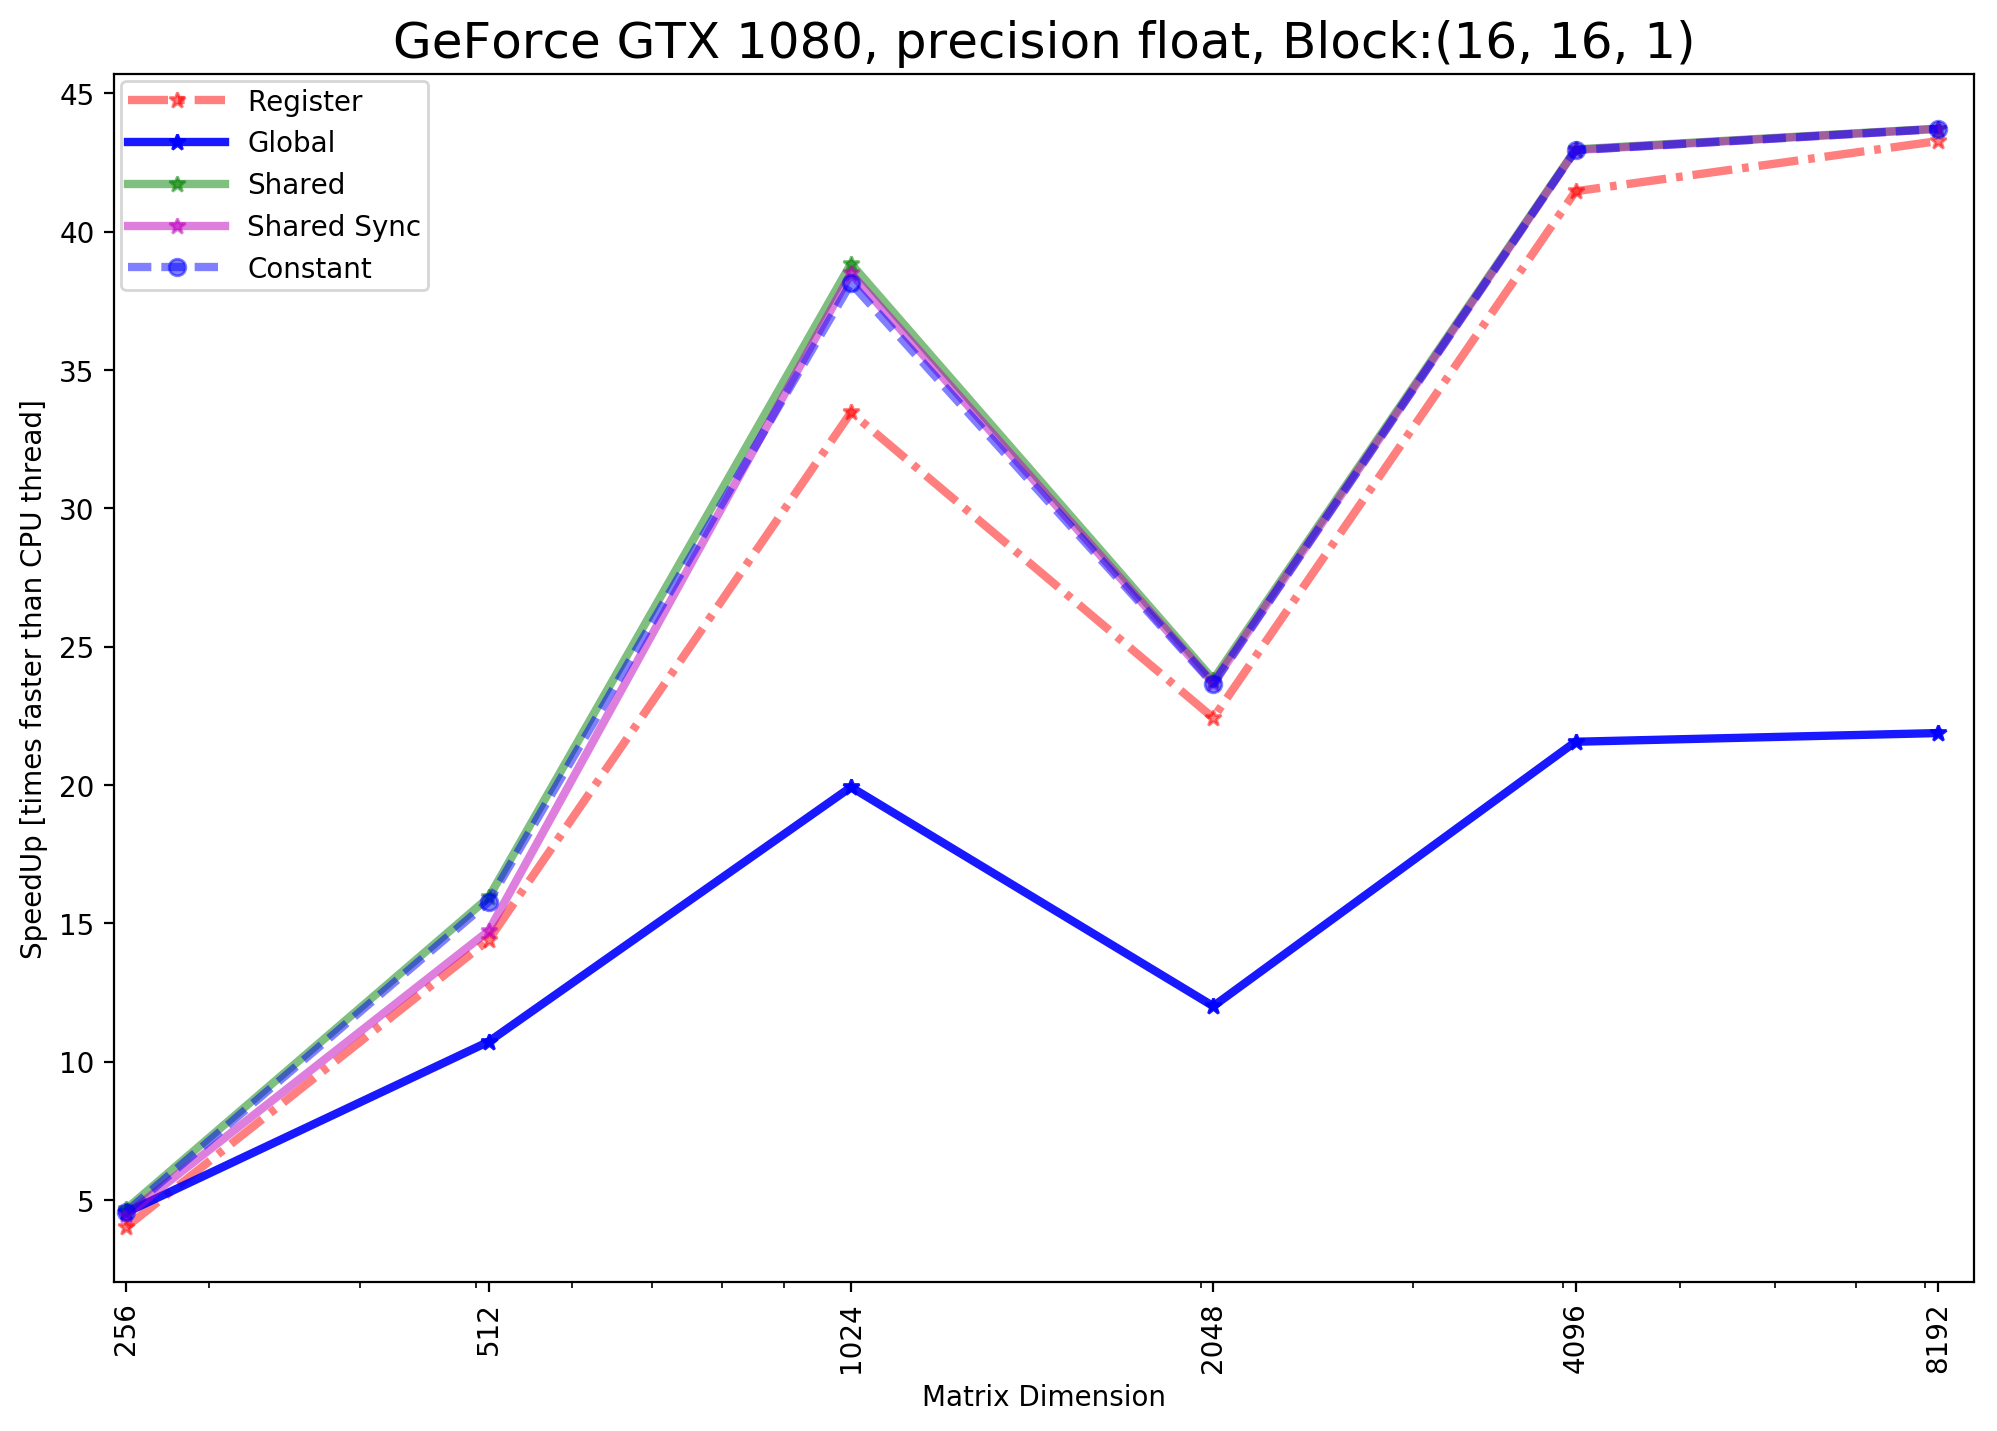
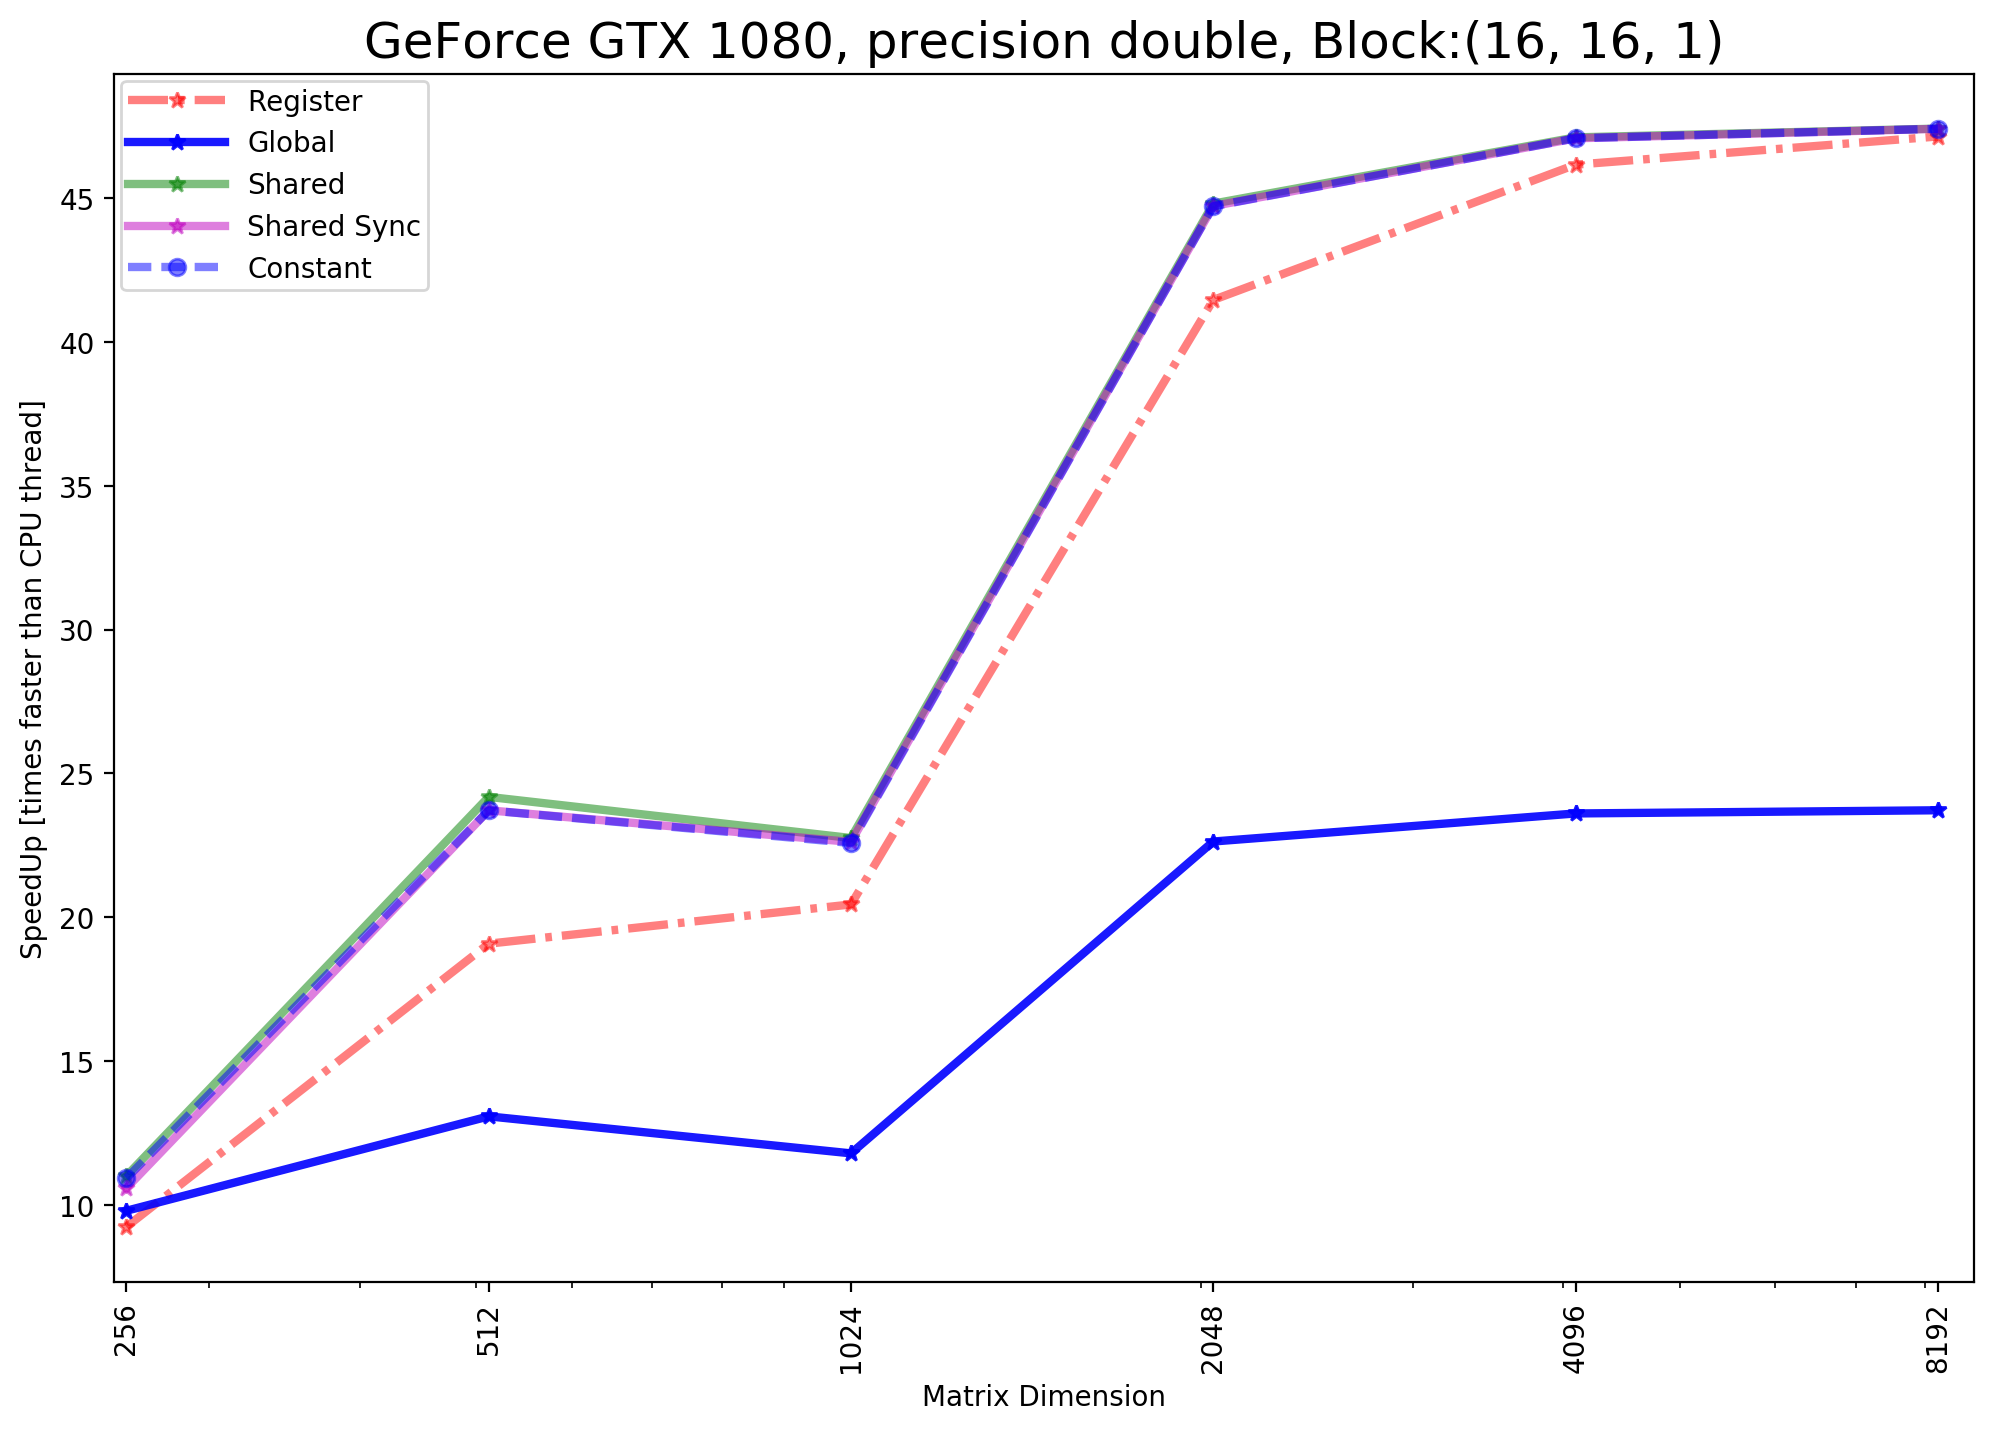

In [18]:
%%HTML
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB80AAAWXCAYAAADNquXcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAewgAAHsIBbtB1PgAAIABJREFUeJzs3Xe8HGX1x/HPSQIESCgCoRNAlCJIB1H4GRARBfkhCqgooKCAohQFG1hQFCkKCqigNBVFkCI/EBWUqnQChKY0EamhJAESQpLz++PMJXtnn92dna333u/79dpXcmd35nl2d3Z2ds7znGPujoiIiIiIiIiIiIiIiIiIyEg0qtcdEBERERERERERERERERER6RUFzUVEREREREREREREREREZMRS0FxEREREREREREREREREREYsBc1FRERERERERERERERERGTEUtBcRERERERERERERERERERGLAXNRURERERERERERERERERkxFLQXERERERERERERERERERERiwFzUVEREREREREREREREREZMRS0FxEREREREREREREREREREYsBc1FRERERERERERERERERGTEUtBcRERERERERERERERERERGLAXNRURERERERERERERERERkxFLQXERERERERERERERERERERiwFzUVEREREREREREREREREZMRS0FxEREREREREREREREREREYsBc1FRERERERERERERERERGTEUtBcRERERERERERERERERERGLAXNRURERERERERERERERERkxFLQXERERERERERERERERERERiwFzUVERERERESGEDObbGZecbu4132qZGYX5/o3udd9GmnMbGsz+7GZ3WxmT5rZrNx74mY2KbfOi7n7T+xR92WE0j5Ym5ktkfgMH9zrfrXCzE7JPZ+P9LpPIlLNzE7PfVY/1Os+iYh0yphed0BERIYvM1sBWAtYBVgSWASYA0zLbs8CU9z9qZ51UmQYMrMxwNrAasCKwDhgIeBl4rP3IvAY8fmb1at+ytBgZhOBjYCJxL40C3gKmALc6e7ewbaXADYmvkcWBxYFXiL24UeA2939pQ62vxCwKfFdthQwGpgOPAjc4u7PdaptEZEyzGx14Fxg8173RUSkFjPbENi/YtGtwG971J22M7PVgHWJ8+fx2eKXgP8S55H3uftrPeresGZmiwEbAmsAbyB+B78CPAc8BNzr7s/3rodD0jeAPYCFs79PMLPL3f2VHvZJRKQjFDQXEZG2MbMFgB2BnYFtgRUKrvc0cDtwOXChuz/RsU52gJmdBezV5s1+wN37ataY9DczWwnYHXg/sBnzf9DWM8fMHgBuBC4ErnT32Q3auZUIYvbCMu4+NevHCcChufv/CmzbShDXzEYB1wLvyN31XXf/WtntlujH4sTrvEl22xhYPfHQ11+TNre/APAp4ADigl8tz2THwBPc/Zk2tf0GYE/gE8B6gNV5+Dwzuw04A/i1u89oUx/WBQ4HdiEC9bXavgb4obtf2o52RURaYWarAjcTg3xECskGqL3Q5GpOBACnA08CdxJBzwvbdT4gw5eZGXAqgzOgHlbmHD47d1+T+efLmxAB00VyDz3J3Ts6Mz8LlO8HfJgIltczy8xuB/4MXODu93Syb51iZssw//fKwC1/HWiauy/R4X4sBHwM2BvYghjoWu/x/wKuAS4DLunkIOBOyZ7z+gze99ehOt7T8rUld38iy/zxlWzRKtn/j2xluyIi/UhBcxERaVl2sv554GAKBspzlgXem91+ZGY3AD8ELhqKP15EusnM3gwcBXyQ5s/txgBvyW77ANPM7HzgGHd/qK0dbb+vAe8jZgAP2Ab4DHBKC9v9ItUB87uAb7WwzYbM7E3EgIeBi01rUD9Y3Mm+bAD8hsGvbS0TiODyfmZ2oLv/qsW29wZOIGaFFDGKmAm+KfB1M/ucu/++hfZHA0cT+0Hdi21Z21sDW5vZFcCe7v5s2bZFRNrgbNIB8xeJwGZ+YFzHMnUMd1nJgfUrFl3i7jv3qj89YMTs2fFEVqNNiHPJH5vZ/wGHu/u/etg/6W+7Am+r+Ptad7+66MpZGveBc+YNmT+TuyfMbBzwXWLm/AIFVxsLvD27rQcMiXTXZrYRsD3zA7Wr9LZHYGa7AccDKzex2puy277E/tP334dmtiTx2RnY99el+P7WDicQ1/0GBhR/wcxOdfcnu9gHEZGOU9BcRERaYmZbERfoVmvXJoEts9udZnaYu/+lTdsWGTayFOzfJAKW7fqxvDhx4WBvM/slccGz7bOY28HdZ2UB1hsYHNz8vpldUSbob2ZvIQYgVHqNCIbWnYHfBrsD3+5wGw2Z2buAP1A9O6eRxYFfmtlq7l7qeZjZycBny6ybWR64wMy+5e7fLNH+gsDviYwpzdoeuMnMJrn7YyXWFxFpiZltCvxPbvGdwKfd/eYedElGpjFE1rH3mdmh7t7KQEYZhrIBivnz7e82uZlz29SdlpnZ2sClwBt73Zcu+Tztz7JXSpYZ6zRidvlIsD7ws1417u7PmdnpxGQZiMx2RxKD1kVEhg0FzUVEpDQzOwQ4jtqz8WYC/wBuAaYSNaSmE8GYpYlUw5sQtXIXTKy/PpHebCgGzR+itdHK09rVERl+svTVf6B6RnSlx4GriZp5z2W3uURN6pWINIZbkB7wMoZIjX0ucGXuvgdo/hxyXaqPE1Oy/jRjTuUf7n6TmR3L/DRxECPfzzKzd7r7vKIbzi66nEPUvKt0lLvf2WQ/h6QsJfklpAPmfybS3z9GzAJ/C1HXbrHc444ysyfd/edNtv1NagfMrwP+RtQwfylrc03g3cTsorxvmNkz7n5qM30gLrqlAubPAr8i9v2XgFWBHYjPT6XVgD+Z2aadrLMuIlJDfpbzHGAnDeSRkmYR33u1LEB8Hy9P+rfggsDJZjbG3U/qQP9k6NqTOI8bcIe7/6lXnWlFVpf9KmDJxN3/JcrP/RN4hvhMLU6cR76VmCTQ0ZTlw1k22PVSYLvE3bOI3w5/J17754nfwMsQs/o3pVhGLal2AnAg868H7Gtmx7r7o73rkohIeyloLiIipWQBjm/UuPs64HvAX9391QLbGkcEIPYhaqH3JCVxm+3bTIo5kaLMbCmi5vY6ibtnEqPPTy2aEjNL774b8GkKpLRz9z2K9/b1NqZSnS526zbNYv8mkda8su72lsQI+B80sZ0jiAE8lW4hjmW9NAe4l6gTuj3lSmA0lA0a+C3V9bv/Q9TBuy2xzpeIVPgfz931YzO7pol9cC3gq4m77gL2cvfJNVb9UjYz/hdU1408xswucff/FuzDR0jPmvkB8DV3n5VbfnTW9nkM3rfXAk4ivs9EOsbdN+h1H+oZYWmq+8Vmub9vVMBcWvBAkeOMmY0lAlB7Z7dRuYcca2Z/dvf72t5DGXKyWuaH5xY3O8ixnmeA24ig6QfauN0qZjYRuILqgPkU4NBG2fKyGfdvJ84/h8P1+VeJc/dbicHXYzvc3tlUB8xfJrIWnOjur9RbOas//yHgU53pXtc9TLz2q1J9PtA27v54VoJj4DxvAeAQ4KBOtSki0m35k1kREZGGzGxf0gHzp4Dt3P1/3P2PRQLmAO7+kruf5+7bEaOuL2ljd0WGjWxE/R9IB8x/D6zu7oc0U0PS3f/p7t8hZsl+gphJPGRkadP3JNKoVzo6C8Y2ZGYbUx20nUUEbJudDd+KeUSA/Bwi9eHbgcXcfX1334eoR9spBxKzxys9BbwtFTAHcPcZ7r4ncHrurrHAD5to+3NUlxi4F3hnnYD5QB+uArai+rUZT5QaaMjMFiE9wOIod/9CImBe2faWwIzcXZ/I0iSLiHRTvq5svVnCIm3h7rPc/brsPGUS1d+JC1J7oLWMPO9j8Azf6cBvSm7reSIj3feADwIT3X1Zd38fcS7dMVnA+zfAhNxdvwA2KFJezt3nZp+dfYnfYEPJa8AdxG+A/Yja5uPdfTN3/wwRQO8YM/sM8OHc4keA9dz9u40C5gDu/oi7HwesOQQzRD0GXEj8ft0OeIO7v9HddycyPXZa/rffJ81s8S60KyLSFQqai4hIU7Kavz9O3DUF2LzV+uPuPiWbnbQjkdJMROY7mgik5n0f2NXdnyq74ezCzVnA2kTA08tuq9vc/Q7itak0Fjg7u6hVk5ktRFxYy8/wOKLLs6JOJwLkb3H3vdz9x+7+D3ef2emGs9fgsMRd+7n7EwU2cTBRkqLSDmaWn7lfS2om0Ofd/cUiK7v7fxicon/A/xZsf19gudyyW6iut5lq+36qXzsj6vuJiHRT/oL1yz3phYxY7n4d8IXEXTtk5xoiB+f+Ps/dyxyr3ujuS7n7du7+VXe/sMuZNT5LdZmec4BPlRlw6+5D5ncX8DUiQL6Ru3/a3U9z99vdPT+AuSPMbAXit2+lJ4jBto80u70h9trfBkxw94nu/kF3/567/8XdX+hyP65g8LW6cSjLlogMIwqai4hIs35GdaqtZ4Bt2/lD1d0vAzZgaNYzF2k7M1sfODRx12nu/uV2/eB391fc/VBiJki3f4C34mjg9tyyzYAvFVgvP3P/epqbKd0yd3+65EXDdtiZqEla6R/u/ociK2ezOb6duOuARuua2UA91EpPE/XTm3EB1bNa1kw9MGH/xLIjmrjoeRqRErHSDmbWsNyBiEgb5c/Ph1IgQIaPs6mebT4OeFMP+iJ9xMxWAd6VW3x+mW25e/68q2vMbDxRHqrS48CBQywAW4q7/7doRsEOOYo4plQ6MBtEO6xlWb6e7YN+zCNmulfauwddERHpiOFQM0VERLrEzHYC3pG465Pu/nS728vqHf+sHdvKfqS/FVgmu80FphKjkv8xBFNyJWV14t4KrEGki1sSmEYMbHgYuCP7kdPpfixJ1Dd8IzHzaRSRQu/yZgdXmNmaRBq/pYnawaOIi3H/Be4H/tmu51TR7wnZbUHgWeL1u7kT+3kTvkf1gMcHiBpibefuV3Riu53i7nPMbC9iBP6CFXd9w8wudfe78+uY2ZZUv34vA3t343PSR/LpDQF+2uQ2fgecCCxRsexDZnaAu8+ps14+rSVEHdWmLjq6+8tm9h/i2DdgETMbV+/4ng1GWTu3+CGaGLDl7m5mpxOf0QGjgN2B44tup59lAwA2IeokLgI8R3x/3tSN42JWd3IDIv30OGAOMbji3KxEQ9HtjCUG06xAnAuMJ76bngXuaqa0RbPMbFzW9rLE99liwCvE4KR/AfcUza7Q5n4tRAwcWgd4A/GaeNa3F4F/Aw/1w8XobHbZRsRxYxkiPewzRHmGm7pxLpdlL9kUWJd4H+cS+89DRA3xrsy0G0rMbB3iPG4ZYh+bQbxm/wZuaXcZFDMbRRyr1gZWIj5rCxCftReAfwJ3drn8yojh7rPN7C6qfzMuR2Qm67pu74O5tvvy2N8jHyey8Qx4Dvhbj/rSik9TXcf8a+6eHywibWZmyxP7UaW/uftFvejPCHcBUWJrwHpmtmGWAU5EZEhT0FxERJqRT6cGEQS9rOs9KcDMViQCYjswuHZa3mtmdiNwCvC7oThCPAssf4mYHbxsnYdONbM/Ace6+10l2vkVsEfFoofcfY2K+3cgXvNJQCot9seBXxVoZ2PiR9i2wIoNHv6CmV0FnAdc0uwFazNbFPgMUQtvU+pk4jGzu4kZNKd2I212RbtvBrZP3HVYkZptI4W7TzGzbzA4eLkgkaZ988p9I3vfz6b6/T7c3fOpxoctMxtD9ayfuUBTF5/cfaaZXcbg48MSROrK6+qsmgp4Fg6C5qRmvSTrkVdIfa4uLPE9cAGD9zuA99LnQXMzu4A49g24x93Xrbh/NyL9/CY1NjHXzK4Fjnf3y0u0P5UYDDXgFHc/MLtvISILwP7U/g7/P2IAXL02RgEfBT4GvJPq2biVj32MeC+PbcdggOw4sz+wCxE0qff7e56Z3Q5cDpzp7o822PZkYP2KRZdk5W2K9u29RGmCHYCGaZPN7GmiTuYlWVt1M5GY2cUMLpFwp7tvULR/FdsZDxwE7EoMCqxltpldT9ST/U2zn2Ez25nq496G7j45u38p4rOwL4P32UozzOzXwLdaKZdShJltQNSTrecgMzuozv1LdipYZ2arAocD7ycC17W8aGZ/AX7g7je20N5qxOdsG2BLIjBZzwwz+1vW7jUF21iC+hl4/tfMiux3HXvd+8j0xLKuZrrs9j6Ya7tjx/429G0R4FyqS9g8CLyvk4PHqB6k+acGAyv7VT4N9QxKzpiXpu3J4MHRAGf0oiPC9cTgysoB0x+l8bmJiEjfU3p2EREpxMwmAlsn7jq1231pxMwWNrPjiB//X6B+wBxi9slWwG+ByWa2boPH9w0zW9TMfgrcA3yC+gFziBkOewB3mNnZZpavf1m2H+PN7CIigPEu0gHzIttZw8wuBW4F9qJxwBxipP+HiIsVNzTZ3gHEDPxjgc1pfG60HhEEe8jMitZLboe9GTwzA2J2TF8OWOmx44Cbcss2BI7ILTseWD237CrgJx3qV7/agJhZWumukrNlUsHxrRqs8xTVge2m05pnWTbyx4vHClyMTfXv+mbbd/cHiedSaYtsVuqQY2aLZYMgzqN2wBziWL81cJmZndfG75S3AHcR2QsafYfX2857su38EngPdQLmmVWIMhgPm1mj0g712jUzOwR4lDjWvJ3GA9ZHEa/114nvmG3Ltt+gbxPM7AoiQLMLBQLmmWWJUg5nUj1ApCPM7JPEudy3qR8wh7iIvg3wa+BWM9u0jf3YHriPGJxYK2AOcSzdH/inmW3TrvaHEjNb0MyOJzLhHED9YCXExfZdgX+Y2QVm1ug8Nt/ewmZ2E3EudzwxeLRRwBzivdoJuNrM/mJmyzTTrjS0dGJZV1IKd3sfzLXdt8f+rH/LAldTHTD/O7BFvYC5mU02M8/dmhmotQqRoaPS1UXX7xfZdYJ8hqJLujmYeoTbNff3LJoc6CvtkWVlyw8626EXfRERaTcFzUVEpKj3J5Y9Dvyx2x2px8yWI36Af5HGF8dT3gr83cze185+dYKZTSBS2u1H80HqUcRI7evNrNHFpEb9GJ/1o/CFkxrb2Q64Bdixhc0UuVA6cEHtl8Sgj1R66EaWBy40s8NLrFvGTollvxhhKcQLyVJs7kV1IParZrYRvL6v5etYTydKTQy5TBMt2jix7B8lt/X3gtt/XZZaOx+kXjObNdiMtzN4pgPEIIhGOvn8FyZSXg8p2Sy0K4ngUzN2A/7cauA8m0F7A/DmFrfzRSIw/JYSqy8CHGNm52Yz3ptpdzxxAfcHpANHRYyiul5ny7JzpOuJAQR9Kws8HUfMGi/zHb0REQxNnbs225ePEgMCmwmqjgcuN7NUSaNhy8wWI34XfIHqmYBFfJA4B2+m9vVCxEzeVmwL3NZku1JDdgxcP7f4NeDeLrTdi31woO2+PfYDmNnawI1EVq1KFwDvysqiddJ7E8uu7nCbnfDuxLK2ZCiQ+rKMLxvlFk9x95d70R8BqssrrJ1NthERGdKUnl1ERIqalFh2bT8F7bLR8zcCqRP1KcRI2HuINFIQF2K3IAIDlTMtxwO/N7O392tNpizt39VUj3SHmMlxETG77lliVtQ6xIyyFXKPXRe4zqL+VNlUkT9ncODpv8QM6Luz9hcnZu/VDKqb2S5ETeRU8P8ZIoBze7a9WcTs8onEzIwtaOICk0U66supTkkNMRDkKmAykfJ3NlH7cCNiP6mcyToK+L6ZPevuZxZtv1lmtjTpoM/VnWpzqHP3B8zsq8SFywFjgHPM7F1EICbvYHd/rCsd7C+pWbwPltxWKq39mgXWO5UIWlT6LvCRIo1ms7mPzi124OQG6y1O1FitNN3dy86Gq/X87y65vV45lcEX1Z8Gfk98jz5HfHduAHyAOD5W2gy41MwmlTw/WJxI/10ZeJ8MXAE8Qnx/L0cE1HertREzO4aYFZw3HfgzcBuRGeAlYrDFmkSq/vwsuI8QaVf3K9J5M1uYuICYGowxF7gZ+CvxXfMcEZxfmhiw9zZaHChQwE+AVDDonqxfDxA13mcT50IDr816xHu7QIf7N+B4YsZ/3mzifOBvwBNEUGwiMbAz/5ovAlxkZju6+xUl+/EOItvBwLnJS8BfiIEHTxPHmVWI84N81oqFgDPNbP0OzUCcCdyZW7YegydGTCXOyWppWx1nM1uA+Gxtnrj7BeJzfTtxTjewX+1C9Tn76sANZraBuz9RoisziQGY9xL1ol8kPvcLEOeOaxFlGvKZC1YGLrAo5VKrrMdcBr/mazJ4gO504jjVyHCvpZ4KWF/u7qkSKm3Ty32w34/9ZrY1cCHVgwtPIEo9dWPA6Dtzf0/rcCr4TkkNhpo88B+LkjA7EFnQNiOOLQsSx+NnifOPK4HL3H1ax3s7vGxBdea1yZV/WJSs25PIgrQmMaB+BvHaP0y89pe7+30d7+3IcEti2SSiBJqIyNDl7rrppptuuunW8EZcBPLc7aBe96uif6OIYGe+jzcAmzdYdwniosG83LoPA+MLtH1Wot1JHX6+P0+0+RqRwnShGuuMAb5MBJ3z6/6uYLu/yq03p+L/LwMHAmPqrD82sWxt4kJjvk9PELVDRzfo01giIH8FcF+B5/D9RFuPEAGgmm0RF1wPyJ5n5bozgXU7+F6/J9HfOcAindzH2vwcpiaew9IdbnMUcG2i3ScTyy7t9WtU8Dnd2u7XkRhgk9/mLm18r18uuN5liX6cACzQYL1xRG3O/LonFWhz/cR6d7Xw3A9MbO/wXu83Dfp8QeJ4Vnmc+Vat94C46P/DxHN24Asl95fK75R/AtvWWXcBYFRi+QcS/ZlO1MVetEF/tgf+k1h/j4LP55c1Xo9fAasVWH9t4nt8KrBzg8dOzrVxcYPHr5vo1+P1XuPc+osRaVH/DJxa4PEX59qaXLCd91J9PubAn4BV66y3DXHell/vKWBCgXZ3Tqxb+Xn4CXWOt0TgfEZiG/u3+3Nbpw8v5to+sVvbAI5JPPd5xDEi+bkjgh+fJQYj5Ne9ErAC7S6Rfb5PIwZDJs+BE+ttRPoc4TtNvFZNfQb7+Za9jvnXotBnNredTxNB4srtzAU2G677YLadrhz7a7xPBzfY9seBV3PrzAE+2+R7m9/fvV5fE+v/K7fudR3ep1PH9KaPiYntPpDY7oTsvk2IAYapfSF/e4EoHVX3vGSo3hKf4xfbsM2vJF7Hw7P7xhPXR1LnD6njwu+BdXr9OnXotT+xlc9qk22NT7zmJ/f6NdBNN910a/Wm9OwiItKQmQ3M5Mm7rdt9qeOLxAXTSqcAW7p7vr7xIO7+ort/Adgnd9dqRJC0r5jZO6nu6zxgT3c/0mvM5HD3Oe5+DDE7L1/nd9eSNborZ19t5+4ne50awp6bvZPVIT6X6prKk4GN3f3nHum2a3L3We5+sbtvTzr1X2V77wQOyy2+Fniru19Ury13f83df0LMlKhMAzcWOKpeuy1KzT65391f6WCbQ57HLNdPMPi9guqZxc8TF3lHqvzrARE0LCu/7iJZytJGPkrMxKp0KHCXmR1sZutndbZHm9mSZra5mR1B1BnOz0g/n5jp1kinnztEHeihZGDWpAOfcPdvuPtrqQe6+yvufgjVx1SAb5tZvsZ8EQPfKXcB73D3K2s9MDsmD5rNnpUtOTP30MeAjdz9JG+QwtNjRvJGVGdbODrLUlKTmX0Y+Fhu8Vzg0+7+MXd/pN76Wfv3ufuRxOzlGxo9vkn573gHdqz3Guf6Nt3dz3f37YhzrrbLzjdPp3om2XnA+9z90Tr9+ysxAzCf8WFZYgBOGQOfh8+5+wFeJ32xu18O7J64a9+SbQ8ZZrYe6ePA59z9kFqfOw+nELMy87Px3wV8skDzM4AV3P3T7n5VrXPgRNu3E78bLsjdtX82a1gaMLMx2ffxxmb22ay2/M+oLgP5FXfPf7+3uy892wf7+dhvZkcC5zB45v/LwAey590VWWafNXKLp3Sr/XbJfremygdNM7ODiPI+RUvCLEEMlPh7Vu9dGls9sWyamb2FyOq0D9XnDylGZJm4Lfv8SknuPgN4NLc4XwJCRGTIUdBcRESKWJH0D5Bnut2RlKz+av5CyWXufqC7e9HteKTY/nlu8SHZRdxm/dzMJpe45dtPOSSx7Hh3/02Rjrn7H4BvJu4qEmSq5TB3L3OR5/1Emt9KTxEB+Ceb3Vi9C+qZrzN4X/43ETSY0UQbtxIzFivtbGapNNftkKo53xefvX7n7g8BjerOH1hmXxtG8um1IQbBlJVad6lGK3mkqHwnMTuiMki7FjFLbDIwjRjw8zxRiuPbDP58vEB8NnevN3inQl889z51irv/ssgD3f14qgNPCwOfKtn2LOI9LJMm/yAGp3afDezg7oVLDmTt7kIMRhswkRjYkZRdSD8icddX3P30om1X9OGVks+/nvzF5lvdfXLykQ10cNDWbgwugwIxMGbPRgPoALJj+c5UDwzcveQgDoAz3L1uqYeK9i8nZuJX2jirwzqcHUT1taUzigbl3P0a0ue2qRT9+XXnunup43b2PbEPkS57wFJEtgqB9c3Ma92I7+rniSw4J1NdW/4ZIkvHsV3oa0/2wX499pvZAmZ2BtWDep8msqFd2mobTUoNAP53l/vQDktRXaZkNvHddSLVJVCnETPTHyXObVLeCtysOtCFLJ9YNh74I9UTPGYTgybvJ34fpIwFfmNm+7ethyNT/rPc6VJDIiIdp6C5iIgUsWSN5f1Sh+uTRF24AfOAz5Xc1lHE7KsByxH1s5r1RiL1b7O3/Cj8QbKR6O/PLX6SSKHbjOOINKaVtjKzfI3HIh4gZpaUkao5e0AHggWY2SZUZyP4UjMB8wpnEj/EX9881bP42iX1+euXz95Q8BNqz9q5oOhgk2Fs0cSyVurvptZdpMiKWdaIQ4iay0cRF3eLeBz4DDDR3X/UxGCpvnnufWYacGST6xzK4MEOAJ/K6s0363R3v7/ZlcxsHLEfVDrV3ZuezebudxOlCyrVC6TtSPXsshuJ2tz9Ip/x4bnko3rrwMSyg9x9dtENZO93Psi9AAXr0ue8Cny1yXV+lViWqnM8LJjZEsBMaf4JAAAgAElEQVQeucUzSM/6red0ot50pXXMLH/e1lbuPp2odV1py062OQLcCnwYWMXdz+10Yz3eB/vu2J/N6v4jkW2p0n3A27LBv01z9w3c3XK3iwuuvmpi2X/L9KPHUr/JRgO/qPh7HlEuYiN3X8Ld13L31YgBfdsD1yS2sSxwvpkt1O4ODzOp1/8oom78gNuJ87Ul3X2iu6/t7m8A1iE+l6nziZPMbPO293bkeDz39xLZcUhEZMhS0FxERIqolabwxWY3ZGY71pu1UON2VoPNfij391+LpMJLcff/EOm9Kk0qs60OeRfV399nNzvrK7sAnZrV/u4SfTqzmRn9A8xsaaoHJPyT6ouX7ZLfT54HLiyzoSwl8BW5xZPKbKuA1Oev6c8egJn9X4nP39ta7H+vLU9cKEk5v5sd6VP5GTNQezZMEanAceFsHdmMzL2JWb1FU5uvBHwD+IaZrVC0LfrsufeR8929qWNM9t2ZPyauQMygatYvGj8kaVsi3WmlItlbarks9/f/ZLMKU3ZKLDuuzHdjB+WD5Bv3Uxrq7AJrPqXnv9z9LyU2d2piWZnzm0vdvejgnQGpNNRrlmh7qNiK+WnsB5zn7s83s5HsvOqnibvKvG/N+lfu76F+3tNrmxADV75lZqkyKO3Wy32wr4792eDq64nfi5WuBt5eICNXp6SyZj3V9V60LhXUHs3888mBcmX7ufsdlQ9y99nu/id3n0Q6O8GmpLMdyHyp17/yPOYUYFOPsm2Dro1kJRAOI47v+cH5CwJn1jnHk/pSGdtWTiwTERkyFDQXEZEi+vYHRDYiOz8yuNVacPmA+4Ytbq+d3pFYlk+LW9TvCm6/kb+VbP+dVO9bv+rghaZ35v6+xWvU6i2oW/tJ337+hojTqZ0t4wSNhE9q5TOYWrfQPmxmexH1iL9JddaN14iZDPcQtcPzM0WWJUpM/NPMyqYFhx499z5TdOZYXmoQUrPBp+fd/c6S7eeP8S+6+z0ltwXVx/g3UJ3+c8Ck3N+p2au9dlPu72WAc8xssV50JmELqq9P/L7Mhtz9X0RJh0obmVk+sNZIakZgI/ma6jC4ZMBw087z0vOpPo42fV5qZsua2QfN7Jtm9lszu8LMbjCzO1KlkajOTqX6wmEWcGeD24PA1MS6SxPZpO41s9073M9e7oOTcn/37NhvZhsRs9zXzd31a+A9zQ6Ga7PU90yyznyfa3RO9zF3v6rRRtz9aKozogAcXOJ7aiSp9/pflJXmm1fnMWSDGd4P5Eu+rI1Kc5SVmryRz24kIjKk5OutiIiIpNRKV7s4va+tvDHVsws+aWY7t7DN/MWypZOPqm9rd7+6hT7UslHu79lUz4wvxN0fMrPnGVzXN7/9RuYRF83KSKW9b3XAQ1J2ASKfHnXT7GJpWfkapZ2qWZr6/A3nC/BtY2b7Au+r85CViHrZn+xOj/pSauBIK7NPU+s2TK1sZkdTnQbZiQvfPwX+7u6zKh4/lgjI7gfszvwLaYsCp5nZKu7eKMV4Xzz3PnRbyfXyaW2h+bTUdzR+SE35wMbYFo/xqfdzaaI26euyrCn5QR43FanB3WUXE8e7ytn4HwK2MbNziAD1P3rY79T5R6k0wplbgA0q/l6QCCY1s838DOSG3H2Omb3C4NIMw/k7u23vm7u/aGYPEiU66m0/ycx2JALg7yJmf5Y1nN+vZjzg7hs0fhiY2QRi4NJ+DJ7lvCRRM3hJd0/N4m6HnuyD/XTsN7MdgPOoLjtztLunZjV3W6pUTSvlcHql3mDri929mQEThxO10CdULFsW2Bn4bYm+jQS1Xv9ZwAFFN+LuN5nZT6guCfNpSmahG+FSn+VUCSwRkSFDQXMRESnihRrLl6D5oPk06gdZxxH1wItKpXtbmfamhOpUMLSMfAD/oWZqfSbcx+BAQ7MDBKa5+6sl206lXi41AKCACVSnYn4DgwcMtGqMmS3u7u2uN576/OVTEBf1MPU/fxNb2HZfMbOJwA9yi+cRqRMrZ7x8wszOd/c/dq1z/SU1O6DdgeO6s4nMbB+qA+bTgQ/Xel+yAPrVwNVm9gsic0ZlRoEjzGyKu59Xp+meP/c+NN3dy6ZMTdUhn5BYVk8rA/Hy5wNjgfVb2F5K6nygm99lpWXBoEOBM3J3vQE4OLvNMLO/EynGbwSuz2o+d0Pq/OO+FrZ3b8E26mkqvXOF/IX9VCmI4SL/mj7r7vlSAM24l8EBy0XNbGzloKm8rKzH2cAOLbRbaYyZLeruQ+343TPu/gwxS/t8M9ubKI0xMHDBgJPN7A53z2e8aIde7YP9cuzfDdiMwQNF5gD7uXv+eN8rqUEs/TawrIh6x4QfN7Mhd59pZmcAX87dNQkFzWup9fqfX6KUyslUB83fYWZj3H1O810b0VKvl+JNIjKkKT27iIgU8TjptLPLNLshd7/O3TeodQP2bXKT3Qho903NT6rTTLeaai8fkF3UzJqpwdvKxfRUwLrWAI1WdWvgQyf2lf8kljX92QNw9883+Pz9qbWu9oesJt0ZVKeG+wHVF0gATh/BadpTF5bHtbC91Lo1L16b2RuAE3OLHfhg0YEM7n4lkVIxn5LxZDNLzW6q16+uPfc+VXrQTzaAKx9UaHYQTivfKb06H+jmd1lL3P1MYiZorcFu44H3AEcSNd2fN7MbzeyQLtQmTpXRaOUcJ/UeNDtQrpUSLiNFp89Loc77ls32/SvtC5gPGM4DHTrK3c8ijiGVRgM/6VCTvdoH++XYvwXVQel9+yhgDumZqEMxDXmtc7pZwHUltvfnxLItS2xnpKj1+qdex7rc/QHgsdzicQzOUCPFpM6NUwOTRUSGDAXNRUSkoexCeP5HBTSfdrUTatUqHnayQGA+KNPqLJjU+s3UoGplJHa+vt2rHRzZPZT3k1R62LUaBANHus8C2+SW3Qcc6e6/BP6Qu29FqgO3I0VqZkYqg0dR+SwfM919Rp3H70f1ce23WSC8MHe/Bjgnt3hp4GN1Vuv0c6/VRj9r93dKszUNS30HZMfDZgZ8tVOqVutLXe9FQe5+GlG78wwaX9QcDWxODDh61MxONrNOZSNJ7Sut7I+tnt9IMfnXtNvnpT8F3ppYfg9wHFGCYBNgeeKzuqC7W+UNOKTFPku1H1Jd63xDM+tEQLBX+2C/HPtT35tfN7NVu9yPelKvaT8NSi/E3V8hPbhviruXGWSVKkmzQontjBRP1lhetrSPXv/2GA6ZtkREBlHQXEREikrVON28672olhq5fkD+gliLt1W7/aRS3N2pvhjTar2o1Pr1AlztlL/osJCZdSqVV2o/ObvN+4m1kNa4ntRnbwz9MWil75jZGsD3c4vnAntVpNbcj+q0u3ubWb3658PVI4llE8tsKAtc5tOkprZfKTU78Owy7ddY7z11Ht+2555ZpWAb/azd3ynd+j55lepMAw904Bh/caLt1AX0VjIWdJy7P+Lu+xDphXcjAo/3UP0aVlqIGJA02czW6kC3UvtKK/tjL89vRpL8a9q181IzewfwwdziF4EPuPu67n64u//e3W9z96fcfUaNwNaQC971u+x866rEXfW+k8vq1T7YL8f+o4F/5JatDlxnZmv2oD8pqdIr7SyR1U0PJ5aVyirk7i9SnaZ+CTNLpbOX9GsP5bM6pdbrp7J8Q0Xqs9xKuSURkZ5T0FxERIq6JrFsKzPr9XdJfhYDDN0f4UXk0/61OuMrv/7L3lqN9Gakfqh2akb4kN1P3P1Z0nVd39ntvvS77Hh0JpCfhf99d79l4I9scMPnE5s4vYOzKPvVA4lla5Tc1uqJZak615VSMwRvLNl+ar3U9gFw92lUzwRfPEv3W8YbE8saPf9+U7pMQVbaI59utdU0uYW4+9xEW906xnfzu6yt3P0ldz/f3Q9w93WJfr+XCMLcTro0z0Tgj2bWamAqL5XWuJXjcWrdsjXKpbZOn5dC7fftI7m/HfhQjcEt9QyJ88EhKJUpaf0OtNOrfbBfjv0vAtsRZQoqrQRca2adeM2b9e/EslYy+/RS6jdZrZInReTXNXqXOaffpV57KP/650sKwdAsG9Br+c/ya8ATveiIiEi79DrQISIiQ0c+nTFEKtrtu92RnFTq21ZmCva7Z3N/v9HMWqm7uE7u71RwuVNSs7JrBrhalBrtPJT2k9Tnb58+GLTSbw6luhbg3cC38g90918D+QvrKzDy0rSnMhlsUXJbb08su73Wg7NjVz7l6WtZMLtp2cy2fDaORsGQTj7/WdS+wNevFjOzZUuum5rR1s2ZJvnzgaXMrBuz/rr5XdZR7j7d3a9w9yPcfWNiIMgPqa7tvSrpgUetyJ/fQKSRLyt/fgPdPccZKfLv2zJm1spMvfz79nJFlpi8d+f+/ru7p2Y3N5Ia8CWtS83ELjsorZ5e7YN9c+x395eIzD3/l7trAvA3M+t1drjUDOGhGjS/JbGs1IDD7Dw4P9B3prunMqQJ3FpjedkBn6kBMmVnrY9kK+b+/k82mFVEZMjShVYRESnE3R8Frk7c9Znu9qTKrVSnE/2fXnSkS/IBqAUpeYHGzFanOqCUCiB1Sj6VIMA7OtFQFoTLz/hcdwjNKj4rsWxVYCSmE08ys7WBb+cWv0akZa+VPWF/qi+O7GVmqZThw9VkqgPN65tZmdq/qVql19Z5/Byqa3GOKVumwcyM6hkijWo2X5dY1nTN1ex4unxu8d/dvVSN7h4rW/ohtV43v1Nuyv09ig59p1Ry9+eBf+YWbz4c0qtmadwPBT6QuDufFrtVqQE2m7SwvU1zf88mBlFJe7XtfTOzxYE35RbXO4asnPs7dTwvouxAKakvFcjqRCClJ/tgvx37s8D+LsDvcnctCVxpZpO63qn5HqV6EEW/pI5v1tWJZauV3NaqiWWpAWTC65+5uxJ36fXvkWwA/5tzi+/sRV9ERNpJQXMREWnGSYllO/SyDnD24yl/MWMtM0vNMBoO/p5Y9qGS29q14PY75RqqU7/ukQW+OuEvub9HkQ4E9B13vx/4U+Ku47I60iNaFmQ9m+qA6dHufket9dz9aeBzibtOG0IDKlqS1XfNz8wbDezczHbMbCzV9cmnkR4cM9C2Uz1owUhfxCpiFSAfcG908euKxLJdShyHUsfh1LaHgqbe+wq7JJaVTbVfRv4YD+k+dcLVub/HU/517DvufhnVz3G9NjdzI9WDIEsF5s1sDWDD3OLb3b2VFLqS1s7z0g8R3wGNtk927pOvRd50+n0z24rqAU9F5QdFDfmBMm22VmJZanZ2q3qyD2auzv3d02N/dk73EaJUUaVxwOVm9t7u9+r187387/V2f4d0y2SqU0+vYmb52bZFpDI01fzdIgBclliWeh3rMrOFgI1yi+ehgG+z3gjky/WksjGIiAwpCpqLiEhhWY3AVADkzBbSubbDJYllX+56L7rjSqovKu9pZvkLh3Vl6eD2Tdz157Ida1Y24CE/C/XNdO5iU2o/OXwIzQb8MtWDDNYCftCDvvSbL1M9q/B2oi5vXe7+G+DC3OIVSA8SGq5+m1i2X5Pb2JXqzBUXFJhpnap5WnYgVmq9/CywQdx9MtVZKNYA3lW00SzA/un8poHzim6jz+yWzbYrzMxWorpcyxOkZwR1yp+prk+5l5mt0IW2L0os+2IHB4H1Qv5zsmCz5x71ZBlh8tkC3mRmhT+LFQ5ILOva+c0Icx2QTyW8m5k1Vds5+6zsn7ir1vs2i+rz4TKpvw8tsc6AGbm/u1EOYkjIBjVsk7irEyVLerUPQh8e+919HrAP8KPcXQsDF5tZu7OEFJUfRLeamS3Wk560IBsA8OvEXR8vsbk9E8vKlJgYSX6VWPaxEtvZjerB1pOz6xNS3PqJZflzORGRIUdBcxERadZ+QH6mzgTgL2a2Sg/6A3Ay8GJu2cfMbEjMIm6Gu/+H6vrWKwBHNrmpLxCBoUrXuHu3U5d+P7HsVDNbpt0NZXUu84M+1gK+2+62OiEL7v0wcdd+Zva9YRacKczM1ge+nls8m0jLXjQ19gFU17rd08x2bLV/Q8RFVM/+ekfRNPXZxfHUMeinBVZPZVA4NJu5Xlj2+MMKbj8v1c/vNDGgZh9ipkWly9z9sYLr95vFgaOaXOcEYIHcstO7WdPQ3adS/V4uBJzT6cFR7n4F1bOT3gZ8sZPtdll+Nu5LHai7ekpi2UnZQL9CskxD+Qwir1HseCRNcvcXqQ4gLUb6/K6efahOqT3F3f9Wo915wNO5xds102AWPGxloOYLub9VG32+LxJpwfPyv2Fa1qt9MGu7L4/9Hg6i+jfOgsB5ZpYK1nZafvCB0YUSKh3yU6ozTRxkZvnBozVl6fLzA0teIz3IWzLufi/w19zitczso0W3kf1m+Erirgta6dsItVXu75eB63vRERGRdlLQXEREmpIFVQ9O3LUecJOZbdtiE02nms5mJx2XW2zEhfL/LdsRM3uvmf2k7PodlJpZfLiZFUpFmAXCUgGRE1rqVQnu/keqU3gtB/zJzJpOl2lmqzZ4SCqwd7iZfbVs0NnMNjCzc7uUJv2rpEdvfxk4vw0ZH4ZUqnczW5BIy54PqHzT3acU3Y67PwMcmLjrtGZnKg1FWcri4xN3nVbwc/gDqmuA/tHdby2w7gVUzxacCJxdNNCZPe5sqmsavgz8X4FN/Jzq4MvmwBEF2n4z1cdOB75ToN2BbYwzM0/cysyabJcDi16ANLODiRk7lWYCp7e9V40dA7yUW/Yu4Ndlj9FmtqKZHW9mjeoep75Xv2tmqawujdpcpN2Dx7LBVRuUXHdNqjMJdCKLwO+Ax3PL3gKckdXNrCv7DryY6u+E37j7k+3poiScRPVx/FNmls/AkWRmW5LO7tIok06+hvkGTRy3tgLOKPLYOvIDTVcxs7e0skEzm5z4LhhSpR7MbB/gG4m7bit4XlBGr/ZB6ONjv7t/jerg4GjgLDNLZeSo17dW980bqK5rvnUzfegX7v4wcFZu8XLEuWvDQV5mtjJx3pp3dtEBl2b2YuL9KPUdPwSlji8nFzn+Zr/3TwbWzt31fLa8ITM7MfHan1hk3WEo/xm+yt1n96QnIiJtpKC5iIg0zd1/Sjrt8XLEjPNrzWx7i1pRDVnYxMx+RjrNXRHHEqnLK40DLjKz08ys0OwPM3tTFkCdAlxO9ejZnnP366gORowGzjWzr2eBxCpmNtrMDgN+T/UF5fPd/dL297aQjxK1jyttCNxqZp9sFDgzs4XMbCcz+yPwx3qPzWabH5O462giUN8oKDLQ5jJmtp+Z/Y2oPfcRunBelQU33091mlyI2q+PmNkPzCwfwKzJzMab2e5mdnO27aHk61SnhbuZOB40xd3Po3qGwfKMnDTtP6I6beoKwD/MLF/zD3g92Hs21ancXyU9uKqKu99P+sLhbsBVZpa/qJXvwzrEjJN80BbgBHdvVNMcd3+Z9Kywb5rZcbW+y8xsa+IicD696NnuPlRTEw6kNx9FXPz9eq0LwNnF/RNIBxWOdPf/dqqTtbj700SK1Hwpi92J75QPFQy+LpI99nfAw0R2lnzNxnzbF1IdhBsDnG5m51jjQV2Y2ZvN7CjgMdo/A+8jwB3ZOdpnrGDaeov06H8hZu1XSqVIbUlWj3dfqt+/jwGXZoGGJItZezdQPYDnadJZKKRNskFqqVm9PzGzY2sNWMnO//cnzt3yj7mK6qBU3u8Sy35hZnvVWsHMFsjOha9g/rE7H8grKlXr+lwze3sWmBkxzGyCme1mZlcRA9Hyx9l5wGc61X4P98G+P/a7+zHEwNDK46oRmb26NiM+O77n61G3Oti+l74M5M8xdwT+aGb5QZyvM7NtiJm4+Qx9z9N8lp8Ryd2vp/oztyRwjdXJNGhmyxHfG/sk7j7S3fMlN6QOi4GK6+YWK1OCiAwLFuVYREREmpdddDqG2sHCmcQFpVuJH5XPEfX/FiYC2isT6bHfRgRnavm2u+fTL6f6s2TW3lqJu+dm/bgWeIT4YToKWAJYBngrsDGwam69e9w9/2Mg3+5ZQP4C3dbufnWjPpeVXfy5lepR0gDPEDWa7yJe8yWBdYig6oqJxz8KbOTu+TSTqXZ/BexRseghd8+neW+aRUaA3xPB/7xniJR+txMptGcR79tEYCPi4tLAhc8H3D31/le2NYoIjtb6UX0/cDVwL7GfvJa1N/A6bky87vn9fry752c4doTFDNRLic9OLY8DfwMeJPaD54lUguOI57MG8Xy2oDoYMuAlYBN3f6DF/k4FlsotXiZLp1x2m5sS6fYr95lZwIZZILbMNpcB7iGOCZV26sagEjP7NTGrspY3E8fPSlOI41stH81SGRZp/63Ea5q6uPwnIjj9H+Kz8BbiWJCqfb2/u/+sSJtZuxOIY3c+xTnERd5rgWuIY9UMYDxxrJ5EDGxKBSduASa5+ytN9CN/fBvwDBEgfICYvT6RqJ+eurD9T2BTdy8chDGzcVTXxoUWPyMF276A+G4YcA9wG4PrbD5FHJ+nEMeRpYmBTR+g+nMNMftzUpY+uVH7+WPDKe6eyvrQFDP7MvC9Gnc/QRwbbyeOjS8T3yEDx8WNicE4+ePiu909Pzgv3+5YYn/dNHH3XKKm61+J4/PzxGdtKSJbz+bEMXnAB9z94jptTWbwoKFL3L3mrD8ze5TYdwc4MVBmMvHeTiVK3RjwBmBNIqCROgeaDGyWBUFqtXcxUJnt5053LzQLLhuMkao1/SpxPnA18CSRangiEaio9ZrvmKVQbtTmzlQP3NwwK43SFDN7kcHHxpPcvdBAola0o92y28gG11xH7Md5zxMZAG4nfg8sTuxfH6T6vJvsMRu4+xMN2jRi4GKqpuoU4uL9A8R+MyF73E7Z/wc8CpwJfCu3/pJZ2u967Y8mflOkBnO8DPyX6lrbAFvVCs4kPtfQ4FjQDma2BNXp5mcRr189ixDnBPUyoziwr7sXmtk/lPbBira7cuyv8T4d4u4NZ7lmg0l+QfVvraPcPTVzN79+y/ummb2P6sD56u7+SNFtVGxra9JlqwYsTvV7O5X4XNbyN3c/pIk+vIsYgDMmd9erxHnz1cz/rloVeC/p325zgfe6+1+aaDv/OYGS31llmNl1xPl4Lesx+LfyPKqzc+TVPDYm2l+U+FylzlHuJH4nP0QcgycAWwI7kB4A+Ut3L1yywGJW+UG5xV35ns/aP4z075UBK1J9TH6U6kkKlY5z93yZi0b9OAA4tWLRTGBZDT4QkWHB3XXTTTfddNOt9I0IWjxKXBBp920ysG2T/VmSSMfbrj5MKdDmWYn1JnXhtZ9ABIZaen7ASk20+avc+g+28flsR1ywb+X53F+wrdFESv927q/juvzZW4AICr3Wgc/eHOBnxA/fdvR1aqKNpVvY3lhiUEN+m19oQ193TWz3CeICeqff01s78F5uUuJz+EoL7X2r5HNfDfh3m57znWX2LyJIelkL7T4KrFqi3XE1tlf6M9JE2xfk2pxCXFAs+91yM7B4E+3njw0nt/G57dXivpy/FTofyd7PS9rQ3s4N2pmce/zFDR7/aJtehweJIEej1+Hi3HqTm3jvjCh70Eo/XwH+t4k2d05sY4OS+17+XObETn+W29VuK9sgAjh/bfF9exh4cxNtrkkEEcu09SwxCPLgxH1LtLDfNLrV3DbVn+uGx4I27TtLtPi+1bpNBXYbzvtgRdsdP/bXeJ8ObqKPHwJmJ7ZxQoF1W943id9fT+W28cWS+2yZz16jW93v0Rr92LXGa1r09grw4RLtpn4zl/rOKvn6t/qbPXUrdNyt6MPypH8PNnP7NTC2yXZPTGynK9/zddpv9Vb4OFLRjytz2zi3W6+Bbrrpplunb0rPLiIiLfGYTb0WUS/tqTZsch6RBvQjxOznurO6Ev15gUgxfTDVNWqb9W9i9klf8qjDPAk4jfozTZOrEwHwLd09Xz+0J9z9z8Rsiz+1sJlC77m7z3X3w4gZR/e00B7ERYOfMT+tcVe4+2vu/hUiS8IFNL8PpDwHnAK81d3380h13I++Q3WWhRuoP+OkEHc/n+qUr8sT6cuHvexzuCUxY7oZ04G9vcBspRrtPkLsy6lU7UXNI1KFb+4lZmh7lD/4X6K+e7Ofp78QM28fbbZdqjMbQMxGqzcjpGM80tVvS/PH4vOB7dy9J/3Oc/eziRldTZ1HJMwmsrcU+kx4ZBz5APAlqmcENtNm2XVracc52u+ALTzquXaMhy8QqdobllhImEwMXlSa0C7KPvvbE8fhMjVNLyL2r8LfPx6ZcLYlztmbcSfwNnfPlyVpiscs248Qs4fbIf99MI/q0ilDwQtEfeC13D2VRr8jerEPVrTdr8f+17n7BUSwOZ8B4VAz+1mR8iUttj+X6hJj9WbM9r3sd8P/EAPKmjWF+C3+22ZWyjLO5WdMz6D54+CQ5u5PEud555ZYfQYx2HoPd2/2N3zqvH1KiT4MWVmJn0m5xT/tQVdERDpCQXMREWmZu8/yqJe2CjGC/Vyauzj7JDE7/DBgFXffzt1/6wVSu9boj7v7SUQatM8QaViL/BiaR6TtO5b4EbCau59Qpg/d4u4vu/t+RGqyM2kcNH6OGFG9kbt/3Buknuw2d3/A3bcngna/JWaoNPI08Esi5d2kJtu7lEgf9wFidkjRC1UPEoHyXYDl3H1/d5/TTNvt4u73ufuuxEzdw4k6ea8WXH0ukSrvDOI1WN7dD/SC6bx7wczeAeRTJ75CBGxLHTMSPkuk5K70MTPbqU3b72vufjvxuTiQmMFRz7NEkPnNWZCylXanufvexICIE4nAcREPAUcTx+wvlLj4VdmHOdmAmg2JgUX10rvPI1Jv7px9b+X3maK2Tiw72uukvu607L3YnriYfUedhw68Bju6+259+J1yl7u/G9iMyArzn4KrPkN8B+1DHBc/6O6PNdHuPHc/ljguH0mcW3iD1eYQx+8vASu7+zVF2yvYp7cRA606DdMAACAASURBVFO+QtTvLfp99xwR5Njc3Xd39zJB7FLc/RdE2YYjaZzW9TXifG8P4hzn5g53TxLcfXY24GFN4gJ6o+P4NGLg39vdfZcyg/Xc/TZgA+DbxP5az53AfkQWloeabatG+78lUrR/jDjO3Eacmw5kuijEzN5Mdbmq33iLJXI6bDbxmj9MDFA6lvnnk58rM4CtVb3YByva7rtjf6KPlxMlZvIlpT4NnGNm+VTj7XYKgwc0bJCVXBqy3P1GomzRAcSgrXpeI1L5f5gYpHx7iSa3pDol/I+8QKm14cbdp7v7HsDbic9xo98ADwHfJX4z/KBks/nz9kdobdDvUPRJBpd6uM3dr+1VZ0RE2k01zUVEpGPMbCViFvrKRH3MhYkfii9mt+eBe929Xm2xdvVlIWATosbTUkQa9znEKOOpxAyyB1oJtvSDrL7jBkRd1mWINH7TicDWw8QPmnYFFjuu4vm8kajN9QbifZtOBD/uAx7xNp3QZDMs3gqsTuwnA7V2ZxD77INECvi+mElZS1bXcR3iot2KRMrIBYkLZC8Qz+VJ4C53T9XbFHmdma1K1HmeSMxseZUYGHU3Uae4Y8cUM1se2AhYlki7uiixH08j0ubf6u6NgiSttL8QEXBdmzgejCKOPw8BN7Wj7UQt9UeJQQgdD5qnapq7e1V9SDNbhajVOpH4Ln+eeP1vcvd2zGDuGjN7I3Fxe+AYvxBxjJ9OvPb3d+I5mdnSxGs4gfg+G0vsy88R5yD3ZjMVuyL7fp1IfL9OJM4XFiGCGdOZ/xl/uF3fsa0ysxWJ48EE4hznNeL85kngH918/aQ4M1uXCGAuQ5zHvUQMTPk3cEs7Bx1m53EbEudylZ/vR4HbvU+yK6WY2f7ATyoWzQXWdvd/9ahLw0Y398FE23117O8HZnYG8ImKRb9w93171Z92y2bhbkIM4B9PnDc/S9RTv7HV99vMjiEGWQyYRgSBR1zQPM/MFiY+b2sy/7z9OeL1v83dW5qNb2ZrUZ3945Pu3rfZCdst+559iNi/B+zh7mVm/IuI9CUFzUVERERERHrEzP7L4NmF+2YzbLvRdqGguYiIdJaZnQfsVrHoLHf/RK3HiwxV2eC1+5k/W3omsGoLGXtGFDO7iRjQOeCb7v6tXvVnJDGzA4BTKxY9SAxu6knGuV4ws12A31csuh9YNyu/ICIyLCg9u4iIiIiISA+Y2ZoMDpg/xMhL8SgiMqJlmR8mVSx6DTiqN70R6aysNMIZFYsWBg7uUXeGFDNbjMj+NOB54Ic96s5ItE3u72+NpIB55iu5v7+ugLmIDDcKmouIiIiIiPRGvi7iUSPw4puIyEj3FiJ994Cz3P2RXnVGpAuOImaYD/iMmS3Rq84MIf/D4FrSJ7j79F51ZiRJDG66HxhRKcnNbFui9MCA24la8iIiw4qC5iIiIiIiIr1ROWPlAeDXveqIiIj0TOV3wWzgO73qiEg3uPt/ge9WLFoc+HKPujOUVB4rpgI/6lVHRqD1gKUr/v6mu8/rVWd65OiK/zvwOVfdXxEZhhQ0FxERERER6bLEjJVvKb2hiMiIVJl15Ofu/ljPeiLSPccRNaEHHGRmK/WqM0NE5bHiWHd/qWc9GXkqX/spwO961ZFeMLNdgc0qFp3j7n/vVX9ERDrJNCBIRERERERk5DGzC4APViy6x93X7VV/REREZOQws82B91Ys+qu7X9ur/ohImpntCaxesegn7v50r/ojItJJY3rdAREREREREREREREZOdz9JuCmXvdDROpz93N63QcRkW5RenYRERERERERERERERERERmxFDQXEREREREREREREREREZERSzXNRURERERERERERERERERkxNJMcxERERERERERERERERERGbEUNBcRERERERERERERERERkRFLQXMRERERERERERERERERERmxxvS6A9IaM1sIWC/781lgbg+7IyIiIiIiIiIiIiIiIiLSTqOBZbL/3+3ur7a7AQXNh771gFt63QkRERERERERERERERERkQ7bFLi13RtVenYRERERERERERERERERERmxNNN86Ht24D8333wzyy+/fC/7IiIiIiIiIiIiIiIiIiLSNk8++SSbbbbZwJ/P1ntsWQqaD32v1zBffvnlWWmllXrZFxERERERERERERERERGRTpnb+CHNU3p2EREREREREREREREREREZsRQ0FxERERERERERERERERGREUtBcxERERERERERERERERERGbFU03wEmT17Ni+99BIvv/wys2fPZt68eb3ukohITaNHj2bs2LEstthiLLroophZr7skIiIiIiIiIiIiIiLDkILmI4C7M3XqVKZOndrrroiIFDZnzhxeffVVpk2bxsILL8wqq6zCqFFKkCIiIiIiIiIiIiIiIu2loPkI8OSTTzJt2rRBy8yM0aNH96hHIiKNzZ07F3cHYObMmTz22GNMnDhRM85FRERERERERERERKStFDQf5mbNmjUoYL7UUkux2GKLsdBCCynwJCJ9bd68ebz00ks89dRTzJ07l5kzZ/Lyyy8zbty4XndNRERERERERERERESGEeW5TTCz75uZV9wm1Xjc3rnH1bvt3d1nEV588cXX/z9hwgQmTJjA2LFjFTAXkb43atQoFltsMZZbbrnXl82YMaOHPRIRERERERERERERkeFIQfMcM9sAOLTX/WiXV1555fX/L7HEEj3siYhIOePGjXt9oM/MmTN73BsRERERERERERERERlulJ69gpmNAk4jXpdngAlNrP4e4Ik69z/eQtdKmzt3LgBjxoxRDXMRGZJGjRrF6NGjmTNnzuvHNBERERERERERERERkXZR0HywzwObAvcDFwFfaWLdf7r7o53olIiIiIiIiIiIiIiIiIiIdIbSs2fMbBXg29mf+wOze9gdERERERERERERERERERHpAgXN5zsFGAec7e7X9LozIlLfEUccgZkxZowSZoiIiIiIiIiIiIiIiEh5CpoDZrYbsCPwPPDFHndHpO2uvvpqzCx5W2SRRVh55ZXZcccdOeOMM3j11Vd73V0RERERERERERERERGRrhnxQXMzWwI4KfvzS+4+teSmzjSzJ8xstplNNbMbzew7ZrZii/1bqd4NWK6V7Q958+bNv0kpM2fO5PHHH+eyyy5jn332YeONN+bRRx/tdbd65sorr3x9QMH111/f6+6IiIiIiIiIiIiIiIhIh434oDlwLBF4vgH4RQvbmQQsDywALAVsDnwNeNDM9mthu/9pcLulhW0Pba++CsccA1/7WvyrGdKFHHDAAdx9992v36666ipOOukkVlppJQDuuecedtppJ+bOndvjntb3ne98B3dnzpw5ve6KiIiIiIiIiIiIiIiIDGEjOmhuZlsB+wJzgP3d3Uts5mHgeOCDwGbZ7cPA+YADY4Gfmtmn29JpmW/KlAiU33NP/DtlSq97NCRMmDCBdddd9/XbNttsw+c//3nuvfdeVl11VQDuvvtuLrroot52VERERERERERERERERKQLRmzQ3MwWBE4DDPihu5eJuF4ErOHuh7n7he5+S3Y7z913A3YCXsse+0MzK5NKfeUGt01LbHN4uPVWeO45mD4dnn8ebrut1z0a0saPH88RRxzx+t9XXnllD3sjIiIiIiIiIiIiIiIi0h1jet2BHvoqsBbw2P+zd99xUtbn/v9fd5m6fYGly4JiXRQVNLbYYkysQVHs0Z8ltpjEaHKMiUraiSYnibH8MDlH8RCVkEQR9RhjL4iKiAoICCgIstTtu9Pue+7vHzfb2NndYdkGvJ8+9rEzc7fPPbKLD99zXRcwtSsn8DyvupPtzxqG8XPgF0AUuBL41Q5eY11H2w3D2JHTtbVp084d39NKSjK/vn49lJf7XwCffQbhMHz8MQxp8dmEUAgKCjq/Tjzuh+99ob177APjxo1rerx27doO9/3000958MEHeemll1i7di3JZJKhQ4dy/PHHc9NNN3HooYd2eHwqleKBBx7gscceY/ny5ZimydixY7nkkku4/vrrWbNmDWPHjgVgxowZXHLJJa2O/+lPf8qvfvUrLMtqt0X7Sy+9xH//93/zzjvvsHHjRgzDoKSkhCFDhnDcccdx2mmnceKJJwKwcuXKpus1Ou6449qcM9NaAF5++WWmT5/OW2+9xcaNG7Ftm9LSUr7xjW9w8803M2RI5s/MbH8fVVVV3HvvvTz11FOsXr2a6urqdq8pIiIiIiIiIiIiIiIiO2+PDM0Nw9gfuG3b0+96nlffg5f7M/Bz/Ir249nB0LzHPfhgX6+gY3fdBc89B8uXt349mfSD7ooKyM/3w/Lqali4ECyreb/Bg2HKFDj99I6vs2oV/P3v3b78rNx1V99cN4NgMNj0OBAItLvf3XffzU9/+tM2YfXnn3/O559/zqOPPspdd93FHXfckfH4qqoqTj31VN57771Wr7///vu8//77zJw5kwceeGAn7gRuuukm7rvvvjavr1mzhjVr1vDuu+8yY8YMNmzYsFPXicVifPvb3+bvGf78NM6NnzZtGjNnzuS0007r8FzLly/n1FNPZc2aNTu1JhEREREREREREREREcneHhmaAz8AgvjzyKOGYVyQYZ+yFo9PatFa/ZkdCdk9z9tkGMZWYCAwvKsL3mOlUvDee5ApRKytBdOEgw6CRYv8Vu2hUOt9Egn/+K9/HToIgcW3dOnSpseN882395//+Z/85Cc/AWD8+PF85zvfYezYsRQWFrJs2TLuu+8+3n33Xe68804GDhzI9ddf3+YcU6ZMaQrMjzvuOG688Ub23ntvNm3axIwZM3jiiScyHpet2bNnNwXm48eP59prr2X//fenoKCAqqoqFi9ezIsvvsjChQubjtlrr71YtGgR77zzDldffTUA//u//9umYn7kyJFNjz3P45xzzuFf//oXAGeffTbnnXceo0ePxjRN3nnnHX7/+9+zdu1azjnnHObNm9duBb7neZx77rmUl5fzve99jzPPPJOCggJWrFjBmDFjuvxeiIiIiIiIiIiIiIiISMf21NC8MVkdAzyRxf4/a/F4NLCjleneDu4vjTZt8oPx3FxYuhRc168kt20/BD/4YD8oHzzYrzqvrYV0GjwPDMNv1W6a/nmG6zMLHXFdl9/+9rdNzydPntxmn0WLFjVVj//85z/npz/9aasRAYcffjgXXHABl156KU888QS33XYbF198MQUtWuT/85//5N///jcA559/Pk888QSmaTZt/+Y3v8khhxzCf/zHf3T5XmbNmgXAmDFjmDt3LtFotNX2E044gRtvvJGKioqm14LBIGVlZa0qz0ePHk1ZWRntmTZtGv/6178IhUI888wznHLKKa22f+UrX+Gyyy7jmGOOYdmyZXz/+9/n9ddfz3iudDrNsmXLeOGFFzj55JObXp8wYUL2Ny4iIiIiIiIiIiIiIiI7zOx8F9kZhmEMwq8yB1jfl2vZJQ0fDhdeCCNGwOGHQzTqh+H77gsTJjTPKw+HYdgwGDDA3x4I+M+Li+GiixSYd2Dz5s288sorHH/88U2V15MnT+bYY49ts+/vfvc7HMfhyCOP5Gc/+1mrwLyRZVncd999BAIBampqePLJJ1ttnzZtGgA5OTk8+OCDrQLzRj/60Y84+OCDu3xPjcH34Ycf3iYwb6m4uLjL10in09xzzz0AfP/7328TmLe8RuN+b7zxBp9//nm757zyyitbBeYiIiIiIiIiIiIiIiLS8/bI0NzzvMs9zzM6+gKmtjjkxBbbVu/g5a7Bn2cOkLnEVDq2775w9dUwahQcdpgflC9aBJs3t96vvt6vKA+FYOhQf7+TT4axY/tm3f3U1KlTMQyj6aukpISTTz65qSL75ptv5vHHH29znOd5PPvss0DmKvSWBgwYwEEHHQTAvHnzml5PJpO8+eabAJx22mkMGDAg4/GGYXDppZd26f4Ahg4dCsBrr73WYUi9MxYtWsTq1auBzt+Pr371q02PW74f27v44ou7ZW0iIiIiIiIiIiIiIiKSvT0yNO8OhmGUGoaReThx8z5nAHdsexoDHunxhe2uBgyAq66CceOgrMx/vnFj633q6/1K9JIS/+uwwyAvr2/Wu4saP348N910E4EM898/++yzpnbmt956a6vgPdPXhx9+CNCq3fmKFStIJBKAXwXekZ1pS37ZZZcBfhX9QQcdxIUXXsj06dNZtWpVl8+5vffff7/p8cSJEzt8LwoLC5v2bfl+bG9nqutFRERERERERERERESkaxSad10p8IFhGG8bhnGbYRinGYYxYdvX+YZhzALmAMFt+9/ied6Xfbba3UEoBOPH++3XYzF/tvm6dfDpp1BT47+eSvnfhw71555LG9dddx2LFi1i0aJFLFy4kGeeeYZvf/vbmKbJ22+/zQknnMDm7av4gU2bNnXpeg0NDU2PKysrmx4PGjSow+M6296RU089lXvvvZdIJEIsFmPmzJlcccUV7LPPPowcOZLrrruOjz/+uMvnh+55P1raPlwXERERERERERERERGR3qFUcecdte2rPQ3ADzzP+3MvrWf39sknfkV5QwM4jl9tPmAAVFT4IbrrQjLpt2lvp/X3nq6kpISysrKm5+PHj+eMM87gxBNP5PLLL2f16tVcddVVPP30062Oc1236fHPf/5zJk2alNX1cnNzu2fhO+imm25iypQpPP7447z44ou8/fbbVFdXs27dOqZNm8ZDDz3EHXfcwV133dWl87d8P55//nlGjBiR1XGDBw/O+Hqm2e4iIiIiIiIiIiIiIiLS8xSad90C4BL8wHwCMBQYiP+eVgJLgJeB//Y8r2slqb3h+uv7egXZcxxYtqx5lrnr+q3aBw6EwkK/4tx1YeRI2GcfuOYayMnJ7tx7771rvRc94Nvf/jbPPPMM//znP5kzZw6vvPIKJ510UtP2lvPHA4FAq+A9W0VFRU2PM1Wzt9TZ9mwMHjyYH/zgB/zgBz8gnU6zcOFCnnzySR544AGqq6uZOnUqEydO5PTTT9/hc7d8PwoLC7v0foiIiIiIiIiIiIiIiEjfU2jeDs/z7gLu6mB7LfDYtq9dV0lJX68ge6tWQSLhV5FHo35gXlwMxxwDc+f6leWLF0NtLQQCUFcHw4Zld+5w2P/aw/36179m9uzZuK7LT37yE955552mbfvssw+5ubnU1dUxd+7cLp1/7NixBINBkskkCxYs6HDfljPDu4Npmhx++OEcfvjhnH322Rx55JEAzJo1q1VobhhGVuc79NBDmx7PnTuXr3zlK926XhEREREREREREREREekd6gcsu47G1uyRCBx2GJSW+tXkxx0HV18No0b5r0ci/n5LlvT1inc5++67L+effz4A7777Li+++GLTtkAgwDe/+U3Ab0f+6aef7vD5g8Egxx57LAD/93//x9atWzPu53kef/3rX3f4/Nk64ogjyMvLA2DLli2ttoVbfHgikUi0e46JEycydOhQAKZNm9bhviIiIiIiIiIiIiIiItJ/KTSXXUdZGRQU+N/HjYMrr/QrzcGvMr/qKv/1lvvJDvvJT37SVG39y1/+stW22267DcuycF2Xc889l/Xr17d7Htd1mTFjBuXl5a1e/853vgNAfX09119/PZ7ntTn2nnvu4aOPPuryPcycOZNYLNbu9nfeeYfa2loARo8e3WpbYxAOsGrVqnbPYVkWt912GwArV67k8ssvJ5lMtrt/dXU1DzzwQFbrFxERERERERERERERkd6j9uyy6xg7Fm6+GZYvh/HjYfs22qEQnH8+fPgh7Lef38JddlhZWRlnnXUWTz/9NG+88QZvvfVWU3X4oYceym9+8xtuvfVWFi9ezEEHHcQ111zDSSedxODBg4nFYqxevZq3336bf/zjH2zYsIGlS5e2CqLPP/98/vznP/Pyyy8za9YsysvL+e53v8vee+/Npk2bmDFjBo8//jhHHHEE7733HpB9y/RGt9xyC9dffz1nn302X/3qVxk7diw5OTls2bKFN998k/vvvx/wg++rrrqq1bGjR49m6NChlJeXc8899zB06FD23XdfLMsCYMiQIeTm5gJw44038uKLL/LMM88wc+ZM3n//fb7zne9wxBFHkJ+fT01NDcuWLePVV19lzpw55OXlccMNN3TtX4yIiIiIiIiIiIiIiIj0CIXmsmuJRqHFLOk2DKPj7ZKV22+/naeffhqAX/ziF7zwwgtN22655RZyc3O5+eabqaqq4p577uGee+7JeJ5gMEgoFGrz+t///ndOOeUUFixYwJtvvsmbb77ZavuECRO47777muaOh7swb76yspLp06czffr0jNvD4TB//vOfGT9+fKvXDcPgtttu46abbmLVqlWcddZZrbbPmDGDSy65pGnff/zjH3z3u9/lL3/5CytXruTWW29td03Dhw/f4fsQERERERERERERERGRnqX27CLSxsSJEznllFMA+Pe//838+fNbbb/22mv57LPPuPPOOzn66KMZOHAgtm2Tk5PDvvvuy+TJk3nooYdYv359m/bnAEVFRcybN4//+q//4rDDDiM3N5e8vDwOPfRQ7r77bt566y1Ms/nXU0FBwQ6t/4033uCPf/wj55xzDuPGjWPQoEHYtk1+fj6HHXYYt956K0uXLuXSSy/NePx3v/tdZs2axSmnnNJ0bHuCwSAPPfQQCxcu5IYbbqCsrIyCggIsy6KwsJDx48dz1VVX8c9//pNFixbt0H2IiIiIiIiIiIiIiIhIzzMyzROWXYdhGCOAtQBr165lxIgRrbavWLECx3GwbZuxY8f2xRJFumT69OlcccUVAKxevZpRo0b18YqkL+l3mYiIiIiIiIiIiIjInmndunWMHDmy8elIz/PWdfc1VGkuIv3SE088AcDQoUMVmIuIiIiIiIiIiIiIiEiPUWguIr3uyy+/JB6Pt7t92rRp/Pvf/wbgsssu661liYiIiIiIiIiIiIiIyB6o/UG9IiI95Pnnn+f222/nwgsv5Pjjj2evvfYinU6zcuVKZs6cyZw5cwC/yvxHP/pRH69WREREREREREREREREdmcKzUWkT2zatIl7772Xe++9N+P24cOH89xzz1FcXNzLKxMREREREREREREREZE9iUJzEel1Z599NqlUihdeeIGlS5eyefNmamtrKSws5MADD+TMM8/k2muvJTc3t6+XKiIiIiIiIiIiIiIiIrs5heYi0usGDRrEddddx3XXXdfXSxEREREREREREREREZE9nNnXCxAREREREREREREREREREekrqjQXEREREREREREREREREREAEgmoqYFkEoJByM+HUKivV9WzFJqLiIiIiIiIiIiIiIiIiOzBPA9Wr4b582HZMnCcdNM22zbZf3+YOBFKS8Ew+myZPUahuYiIiIiIiIiIiIiIiIjIHqq8HJ56CjZtgvp6WPuFw/J31uOmDKyAx35fGUZtrc0nn0BJCUyaBEOH9vWqu5dCcxERERERERERERERERGRPdCqVfC3v8GWLfDZZ1BVBbGaegKGQzCexguafL6ing0bCygshDFj4JFHYMoU2Hvvvl599zH7egEiIiIiIiIiIiIiIiIiItK7ysv9wLy8HD78EBwHDjwQRkTXMiRYxVCzjiHBKkZE13Lggf72Dz9sfdzuQqG5iIiIiIiIiIiIiIiIiMgewPM8Um6KmngtM/5Wx+r1tbz/YQNWpJqhpeVUVHxK7cY4TiWQAq/CI7augY1rFnHYYVBcDEuW+JXpTz3lz0LfHag9u4iIiIiIiIiIiIiIiIhIP5f20iTdJHEnTsJJkHATxFIxEvEE8YY4DbUJ3ESSREOCZCxJqiFFKpbCiTs4MQcn7uDGXRpqgsz/aD+WLh5GRW0+ac+kwIqx9jUDz8vD8PIpdpMMC9QQSAZIpVOkFqZYvOVj0h5Ubi7m9dUemw5KcNpp+1Ba2tfvzM5TaC4iIiIiIiIiIiIiIiIi0oOctEPCSfiBt+t/j6fiJOIJYvVxGmqS1Fc71FU7NNS6NNSmidd6xOo8Eg0Qr4dkzMCNB3ATNk7Cxk3aOEkb17FIuTY5oTQn778q4/VNTIIE/bXEQ6xcOZz6miixVJh8M47n2RiAAeBBGgMn5BCIBbCSFkbawNnkAFCQrGF9fSFbPovx9twUpaWB3nkTe5BCcxERERERERERERERERGRDDzPa67udhNNwXfciZNoSBCri9NQmyLZkCSdipOKp/wK73iqqbrbiTmQBDNpsqF8AF+sL8FJWDhJG8e1cdwQaS+y02t13Gwnc3vUxULEvQCmkSaUTmN6Jh7ettQckgEPTEiFU9gJGytlka5LY3gG+STYFEhTHYvy/jv1nDu5kFBop5ffpxSai4iIiIiIiIiIiIiIiMhux027TVXdje3M406ceDJOItYceNdXudTVpmioThOvSxOrhUSDR6wekvUGTsImHbdxEgHcpO1XeqdsUo6Fk87B8wz2HrSZccMrW12/sbq7scIbwN0aoWJLQY/cb8q1strPSZtgmTi2iY2DZ6TxXNOvMLfSYELa3JaeW+BEHQzHf5620jAQ8uIpIsNLyB+QR00NDBrUI7fUaxSai4iIiIiIiIiIiIiIiEi/4XkeqXSqVTvzpgrvVJx4Q5xEXZK6miQN1S64MbxUklTMn+Htxl2cmIOX9DCTJkbSwEyZLFmxF5XVeTjJACnXwknn43lGt6w528A6YLndcr1MnLRF2gOzk1vyPBMDD88yMGzwXI+0kcZwDUzHJG2ncY3mkxgpAztpk4gmMAYa2Lk2w8cOIen41fHJZI/dUq9RaC4iXWJs+2V55513ctddd3X7+e+66y6mTp0K+H859qUTTjiB119/neOPP57XXnutT9ciIiIiIiIiIiIiItKfpb10xrA74SaIJ+LE6+MkGpI0VDvUVqeI1aZpqEkTq0sTq/VINhjE68GNxeanbQAAIABJREFU2zhxm3QisG1+t+VXeqdsUm6YlBulsZf4V8asYkh+AgBr2z8tq7sbxWsj1NTl9Mh9p7JsjR6w0j1y/UaOaxG0Ow7mbcvFND3/3TMMyAEv5uHhYWJipA3SVnNobrqmX2FeDJEhEfaesDcrVwVwt8U3wbZv9S5HobnIHshxHJ5++mleeOEF5s2bx8aNG6msrCQajTJo0CDGjRvH0UcfzeTJkxk9enRfL1dERERERERERERERHqY53k4aSdjO/OE4wfeifoE8foE9dUOdTUpYjVpoqE6UjF/frebcHFjLmbKxEyaTd9JWLy5aH9SKRsnnUPKzaNpeHY36A9V3v1hDeBXmwfp+BqRQArLTGNbLknHBgwIeBiOgeEZeIZH2rEwEyae6SfjRtqANAzYawCWHaCiAkpKwDQhP79Hb6lXKDQX2cPMmTOHH/7wh6xcubLNtpqaGmpqali1ahWzZ8/mRz/6Eaeffjq/+c1vKCsr64PVioiIiIiIiIiIiIhIZzzPa1PV3dTO3ImTiCdI1CeI1SdoqHGor3aJ1aapr3VJ1EKs3iNZb5CKWbhxGzcewE34s7vdpD/L23EsUuk8HLeAloH3WYd8iGX41d0dqYuFSXvZVWPvKCfrwLrnqryddHZrsM2eDc2zCe8DVpqiaD0NyQDxVJCkaxNIJTE8PzQHMNImRtrCdoym4BwHKr+sxAsOIpWCYcPggAMgFOrJO+odCs1ll+Y4zY9t/Wnu1C9/+UvuuOOOpnbnJ5xwAmeccQYHH3wwAwYMoKGhgfLyct544w2effZZVq9ezXPPPceIESOYNm1aH69eRERERERERERERGT346SdNlXdjY8b53cnY0ni9UnqqlI01LrEajzcRJJIsM6v8I63re5unOO9dWs+C9eMIpWOZB0u74iUaxHqpB04+BXWCadnQvP+UOXtZN2evWfWYGBgGiYBI5f8UADbtLECFlbYIhAJYIdt7IhNMBIkEA1wRkEOry+MUr41AATJrf8CI+Zix8AwXYxQHU6ogZRrYSRz/TA9BXUbG6gy0hQWmuTkwMSJPXI7vU4xo+yy6urg0EOhthby8mDhQsjN7etV9V8PP/wwP/vZzwAYPHgwM2fO5IQTTsi473nnnccf//hHZs6cyU9+8pNeXKWIiIiIiIiIiIiIyK7B8zySbrL9duZOnERDgkRDgnhdkvoah4Zqf3Z3Q22aRC3E6yHVYPqV3XEbN9FY4R3ATVikkjauGyXl5rWpZB6YW8ux+6wiRMdlviYGsVTPDZ12sgzNbStNwul0t66toR9UeWcb3NsZQnPTMNt8GaaBGTAJBA3CEQhHDKJRk0jUIJpjkZNrk5trk5Nvk5cfIJJnEs0zGTVmf/KKTYyQgWm3H+Qfcgnk/P+wciXMfaOO+jqbIdRgRoD8FJZTT6FRSZVVhBtN4tUESDfAhnQhlhnjmK/mUFICo0Z19R3rXxSayy5r9myor4eqKn9ewtNPw8UX9/Wq+qe1a9dyww03AJCfn89bb73FPvvs0+ExlmVx8cUXc/rpp/Pmm2/2xjJFRERERERERERERHqFm3bbbWeecBPEk9sC71iCeG2yqZ15Q40fegfNBoJmQ3NFd4sK76ZKb8dg6fphfLa5JOtQd0dke86enqHdH6q8+2oNjdXdpmFiGQGKwkV+hXfIwo7YfnV31CYY9qu7A5EAgXAIe2whOfkWeXkBcnJtwvkGkVyTSL7hh9/5JuGoQTgMVvf/0fHXbsCkSfDII1AS3cyKWIgvkgMZUFJPkVXL3nkxcipqGVAc5rMGm8qCfLZuyiHp2YyNbmLgwNFMmuSfZ3eg0Fx2WTNmQCIBqZT/fcYMhebt+f3vf088HgfgV7/6VaeBeUuFhYWceeaZXbpuOp3m8ccf5/HHH+eDDz6goqKCgoICysrKOO+887jqqqsIBrP7dFtVVRV/+MMf+Mc//sGaNWsIBoMccsghXHPNNVx44YXtHpdMJnnhhRd44YUXePfdd1m5ciV1dXXk5+ezzz778M1vfpMbb7yRgQMHdukeRURERERERERERKT3eJ5HKp1qt515wkmQSCaIN8S3VXinqKt2iNWkidV6xOs84nWQbDBIxwO4Mb+y24nbpBP+7G43aeMkgzjpCCnXwk23rdY9cOh69h28Kas190RgDjtQ2dzDM7T7R5V3dq3RW1Z5t6rqbgy/TRPTMjEDJsEQhMMGkahBJGoSjZrk5NpEcyxy821y8wLk5FuEcwwi+QbhPIMxY/fHCvtV4h3Zb9JO3W63GToUpkyBTetySFZsZlN1LpuTxZimzRe1G7FTQZxNEaqDQ9icziOQF2dUQSV7lw1iyhT/+N2FQvM9SCIBq1f39Sq6x/Llfjv2+nr/eX09fPABzJkD++3Xt2vbWaWlEOq4k8oO8TyPGTNmAJCXl8cVV1zRfSfvQEVFBWeddRZz585t9fqWLVt47bXXeO2117j//vt5/vnnGdVJ747PP/+cU045hVWrVjW9Vl9f33Se2bNn89hjj2FnGGx/zTXX8Oijj2Zc33vvvcd7773H/fffz9NPP80xxxzTxbsVERERERERERERkc6kvXRTwN1uhXfcD7uTsSSx2iQNNemmGd6NgffAvBqCnpe5ujtlYG6bm/3Ksv2oiUd65F76Q3V1X8/QbtTb70XL6m7D8B9HrCKG5CXbzu+OBgmEAwSjQULREDWxCAeuj5CTZxPNMwnn+oF3JNckWmASzjOIRAxCIb/L8W7vuefYe/lyflySwxN7j2bZxiD5gTDlW0PU1Ri4ViFWPMmQgloOLd5CTSrO/oOTXFjyFkOfrvdDudNP7+u76BYKzfcgq1fDiSf29Sp2XE2NH/i35Hn+VzrtP08kYOtWOOectm0gQiHIz++dtXaHV1/t3uB/8eLFbN26FYDjjjuOnJyc7jt5O1zX5YwzzmDevHkAHH/88dx4442MHj2a9evX8/DDDzN79myWLl3KySefzIcffkhuBwPpp0yZwueff861117L5MmTKSgo4OOPP+buu+/m008/ZdasWQwbNow//OEPbY51HIcxY8YwadIkjjjiCPbaay9s22bNmjW89NJLPPzww2zdupVJkyaxePFiSkpKeux9EREREREREREREdkVeZ6H67mtZ3VvH3an4iTifjvzZEOSWG2K+mqXeK1HQ22aeL1Hst4kHQvgxOzm+d2N35M2TsLGdXJJuQWkXIu0lzm1PGHf5eRFY52u2zS97n4rmvSP6uquz9Du3nVkG96nW1d1bz+/2zYxbdOf3x02ieYYhCMmObmWX92d61d3R/NMv5V5nl/dHck1KRhoMnCIgZFFr/CDd/aGdyXpNFRXQ0UFVFb63xu/wmFYswbWrGEo8IPCeawJDOS9LaNZxgDSeQkYPhy+/BLTC3GAtZWJgz9nVM4WjNXbzl9dDV//OgQCfXiT3UOhufRrngfxeHM4vv028EPyxgA90+/CeBzy8nafmQo76uOPP256fNhhh/XKNadNm9YUmF922WVMnz696S+qww8/nDPPPJPbb7+dX//616xatYpf/OIX3H333e2eb/78+Tz++OOt2rBPmDCB8847j+OOO46PPvqIP/3pT1x55ZWUlZW1Onbq1KmMGTOmzV+UEyZM4Nxzz+X666/n6KOPZvPmzdx333384he/6K63QURERERERERERKTPeZ7XFHC3287cSRCPxUnEEiTqk8TqUsSq/Xbmsdo08TpwGiwMx2R4cVW7c7yNtP//YRuSQf79yYE9dk/9ocq7P6wh7Zm4aQOrkw8HmIYf3u9Mm3gDo6mqe/uvwugQRg3Nb67ujvjzu4PhIMGcIKFIiFA0xLhNYbY2WERyjbYV3jl+hXcwuIdUeHcnx2kOxLcPxquqModsjccFApCbC0uXYrgupdZaSkOLSIyKULNXGcmcLQTrK8n/YjGhdAwqHdji+oPWDzjA/5e1aZMfru/iFJpLv+Y4zeG4l+F3vmE0h+GN1efbb/e85p/7PdGWLVuaHg8aNKjd/dLpNJ988km72/fbbz8CWb6JDzzwQNP17r///oyf7Jo6dSpPPvkky5Yt4y9/+Qs///nPCbXTl/6MM87IOLc8Ly+PP//5zxx55JGk02mmTZvG/fff32qfvffeu8O1jhs3jquuuoo//vGPzJ49W6G5iIiIiIiIiIhID0skoKo6TTIJwSAUFpjdOrJyd+Km3YxV3a0ep/zAOxlLkqxPEqtL0lANDbUu8VpI1IETs5vmd6cTNk7c/55K2LhJGzcRxnFzSLkWjmu2W+EdtB32K1vc6bo1Q7vFGnqhNbplOh3uYxkWYdsk4QRaV3cbhj+/2zaxAibhMIQj/uzuSNQkN9cimmOTm28TzW0Ouxvbmje2My8asA/hcOdrHdhN97xHSiSag/CWwXhlpd+yOVOI1hnbhnPPhWefhWgUFi+GZBL23ZfQgAH4iVIt5NswdLzf8nnpUn/fsjIoLvaP3w0Cc1BoLv1cIACFhX53h5bt2FuG5S2ftwzOTdN/raBgzw3MAWpra5sed9SavaamhnHjxrW7/fPPP6e0tLTT661fv56lS5cCcP7555OXl5dxP9u2ueKKK/jxj39MZWUlH3zwAUcddVTGfTuaw37EEUdw0EEHsWTJEl566aVO11dZWUlFRQXxeBxv2x+WwsJCAD755BNSqVTWHw4QERERERERERGR7HieP0J0/nxY/InD3NXzSLgJQlaIY0qPouxAm4kTobR09+ga6nkeqXQqc1V3i8fxlF/dnaxPEm9IEK91idWmaahJk6iDZIPfztyN2eRYKUry6tpWd6cMDK/5Tfti6wA+XDuyR+4r5Vp4Xuf/jnojKM5Gz84T7501tGlj3rK1uW0yfPAYBgzEn9u9rcI7FA0RjPgzvEPREGbYZMwqG882iOT5bc0j+SbRfJNw1CAc9j/Asjv87O2yPA8aGjJXi1dWQn19z1x3wAC4+mqYOdP/Q7B0KSxaBAcdBC0LMTdvhiVL/P0POACGDoULLvCf7yYUmku/Fwr5H1aprvYrxtPp1q3ZG20fmNu2H5jbe/if8pahdX1P/VJtYfHi5k8ZHnnkkR3u23L74sWL2w3NJ06c2OF5jjjiCJYsWcKnn35KMpkkGAy22r5o0SL+8Ic/8Pzzz7Nhw4Z2z5NOp6msrNRccxERERERERERkW5UXg5PPeV38K2vh0WfVrP1w72Ix1OEwwHeG19NrH4An3wCJSUwaZKfx/SVtJduPau7veA7GSfRkPArvBuSpBpS1Fd71FdBrNbDjdmk40F/Znds2+zueAA3sW12d9LGTRaSck2/wjtt4Xntp5YjiiopHbWm0/X3ZHW15xm4noFt9Hw78I7syAztntJZcG8ZFpZpkR8KEbJCbVub240V3gaRiEk4YhCNmkRzLHJyLHJybXLyLH92d65BKAc/5N5W4R3JM4lEDXJzR2fVzvyY8d1049J1nudXhWeqFq+o8KvJe1tFhR+QX3UVzJ7tt11fvBg2bmwdmm/YAAMH+vseeCB861vsbi1C9vA4UXYVtg1FRf7vkkSiOTjfPjQHPzAPhSA/X3MvAAa0+JTP5s2b292vsLCwqfK60eWXX86jjz66Q9erqKhoetxZ+DxkyJCMx22vs/MMHjwY8D+9WVlZ2fQc4H/+53+49tprcZyO29M0isViWe0nIiIiIiIiIiIinVu1Cv72N9iyBT77zB+vu2VLnBBJ8pPghpOs+yxOvNrvOjpmDDzyCEyZAp1MXmzD8zyctNN5O3MnQTzhV3inGlLEGxLEal1iNR7xGo9EvbGtujvgtzSPBxiSV0NBMOHP8W6s8nZa/w9oG5vlq0tZX1XYje9gs+yD4p6v8rY7aQfeuI6eC817tsq73cpuw8QwDSzbIj+3gAMPsPzq7kigqcI7FAkRyglhhS3MsEnKMDlojUUkxyRSsK29eb4fkofDfqdcVXjvxl57Ddav94Pxykq/OrQ/qaz0v4dCMH68X2kei0FeHqxb51e/R6N+UFdb6/9hPfTQ3S4wB4XmsgsxTYhEWn/QprG6fPu/UCIRBeaNDjnkkKbHCxcu7NVrZ5pl3pvnWbZsWVNgXlJSwq233spJJ51EaWkpeXl5TW3YH374Ya688kqANh8cEBERERERERERka4pL/cD8/Jyv6tvNAqj9qknJ16OG3MIW2Hidhwrp5oB+xSwpTzC+x+kGbt/ioceTXLWlK0UDGxoW+Edj5NsSDZXeMdSJGNJKjcFcBsCpGMBnAa7KfB24zZuYtv3pI2TiOKk8nHSFinX2hZGd/z/IAv3+oKS4vYLfxr17AztLOd493Bo7rgWBDoP/mwrDakeXEMGpmFimzaWYWGbNkXhKNFAtPUMb9vEDJjYgW2zuyMG0RyLaNQiJ9ev8I7k+OF2qxneedvC7jyDSMQgFIJgcHRW6z26rDvvXvpcMulXZFtZ/EyuWgVr1/b8mrqqZUHjJ5/47UAaGvxwf+NGv/36+vV+6/Zk0t++ZAnsu2/frbmHKDSXXUo83vp5Y765fc4Zj++WH3LpkrKyMgYMGMDWrVt58803aWhoIBqN9tj1iouLmx5v3Lixw31btkpvedz2Nm7cyMiR7c/gabyOYRgUFRU1vT59+nQcx8GyLF5//XX233//jMd3VOUuIiIiIiIiIiIiO87z4BfTFrPk0wTrPx1EJD/O4EFb+aIqSaAmgFVr4TkeXpVFfcphrTMXxzSp2TyUZctzKMzfwuvPJjhybAX7D9tAwGmu8DbSzQG3ve2fCBHeXDQu6znTO2pPmqHdmZ56LzJVdbcKu02zKfAeMTKPCROHEQhvm98d9ed32xEbM2xihkyMkEFlzOTUKotIfvMs73DYr/C2bVV4Sydqa2HNmrbzxWtr4dJLs2uHUVS0a4TmjgPLlvmzywFcF8rK/JbsW7b4Fejgb1+2zN9/N5uPvHvdjXSotBRefbWvV9F1ySScdZb/8xiL+X+Z5eY2f7ilrs7/D7FIxB+zMGeOv21XU1raveczDINLLrmEe++9l5qaGh599FGuu+667r1IC2VlzR+Ze/fdd7n00kvb3fe9997LeNz25s+f32FoPn/+fADGjh3bap75kiVLAL/avr3AHOD9999vd5uIiIiIiIiIiIjsuBWrUnz+Vj1bVhRje0kGOZtJbU2R2JRHVV0RTiIH1zAgDW69i7fFr4yKeJByo1RvLSQdrmdprIgD7BoCWVQ2B0y3B0Pz/j9Du2kNZs+tAdqG96ZhNlV226aNZfqPB0ZzSaVy/eDb8sNu0zYJhkwiYX8ed06O5c/wbqzuzvGruyO52wLuPINI3rbAO7d14J2NKDC8+98C2VOsXQv/+EfmbY1tzTvTQcFgrzMMfw5GUZG/ruJiaBx3u2qV3+p50ya/LUhZmb/9mGNg7lz/tcWL/e2lpf68jd2s2lyh+R4kFIL99uvrVXTdiy/6P6+plP8XYuPP9fXXw4MP+r+fqqr87YkEbNgAp5zS16vuH26++WYeeugh4vE4t912G9/4xjcYPTq7tjE7atiwYRxwwAEsXbqUWbNm8Zvf/Ibc3Nw2+7muy/Tp0wEoKirisMMOa/ecjz76KOecc07GbfPnz2fx4sUAfO1rX2u1rXGOeX19fbvnLi8vZ86cOR3ek4iIiIiIiIiIiOyYl1+vgQ1R3No8BoQ2Ym01aKgeQmWiEMMzMDFJWy6WZ2G6Jl66uZ1o1HOoTYchGaCiPkzKtYhkE5pbLrEeagfeLyrNs5wPviNryFTZbRjbvbZd4D1ufD77jYFgxK/uDkQDGCGjqcK78XtZhUkK06/yzjEJh/2cYjcrTpX+LJ2G6urmCvHGavG8PDj99M6P7yjwzraDbW+H5rbth2ctg/HiYv95YWH7LeUbW7NHInDAATBsGFxwgX/sgQfCzJl+perSpbtti3b9apJdxjPP+N0eLAsKCmD//eGRR/wPtJx5JlxxBSxf7v/+cxx49lmF5o322msv/vSnP3HNNddQXV3Nsccey9/+9jeOPfbYdo/xPI+qqqouXe+GG27gxhtvZPPmzdx00008/PDDbfaZOnUqn3zyCQBXX301oQ766c+ZM4dZs2Zx/vnnt3q9rq6O73znOwCYptn0uNHYsWP517/+xYoVK3j77bc5+uijW21vaGjgoosuIhaLdek+RUREREREREREpK1EAsqXFoAHwUCSoZ5NVWUx1YliLMMAA1zT9b9bLlbaAs//f5IGBhE86g2PJCEaYh7xZID8cKLT69o9WOWdbQV7z840N/E8v1jUwGhV1d1yjrdl2BSG8zGw/Hbm21qah0ImkYhJNMckZ9v87nB0WwV3jkE4B7+qO7d5fnckzySS48/vDoezG+HcqHRYj70VIs0cpzkQbxmMV1T4lZbpDL8Xsg2yW4yDbSPb0Lyjc3RVKNQchLcMxYuLIT+/a3MHysr8ILyszA/Jv/Wt5jnIAwbAVVfB7Nn+L4FAwN9vN6PQXHYZ3/oWvPKK/yGZ006DP/7Rb88OMHq0H5J/73vw/PP+74Wzz+7b9fY3V199NV9++SVTp05l/fr1HHfccZx00kmceeaZjBs3juLiYlzXZcOGDXzwwQfMmjWrqb25ZVmt2p535tprr+Wxxx5j3rx5PPLII6xZs4brr7+e0aNHU15ezsMPP8yTTz4JwN57783PfvazDs83YcIELrroIl5//XUmT55Mfn4+H3/8MXfffTfLly8H/KD+4IMPbnXcpZdeyn333Uc6neb000/n1ltv5dhjjyUcDrNgwQL+8Ic/sGLFCo455hjmzp27I2+niIiIiIiIiIiItKOmBsxcG3NoAcPNehriG9hUOQwMcEwHTH+sJAAmOIYDafzwHPDsNCEvTco28CyoTYQooa7T6/ZslXe27dk7X8P21d1tKrsbX7cNLNtqCryjUZOvfn0gublBAtGAX9G9XXW3GfZnee+z0SScaxKOGE0V3jsSeIv0K4lE5lC8stL/heN5nZ+jpcYw3ezk5zoUgpwcv7J6ez1daZ6Tk7lavLjYb5XelWC8I2PHws03+9Wp48e3PX8oBOefDx9+6Le1jka79/r9gEJz2WWcdBK88Ybfpv3889v+vObmwl/+An//u19h3p/GRPQXd911F4cccgi33HILn332Ga+88gqvvPJKu/sbhsGpp57Kb3/7W4YNy/5jgZZl8eyzz3LWWWcxd+7cdq9zwAEH8Pzzz2ds397SrFmzOPnkk3nwwQd58MEH22w/99xz+f3vf9/m9YkTJzJ16lTuvPNOqqqquP3229vs88Mf/pCysjKF5iIiIiIiIiIiIt0kmdz2IGxjlxpsem8AKRsMB2zXxsWFFgGukTawXAvP9EjbaUzLxDNd0p6/UzIVyOq6PVvlbW27Ruuq7u2rvUNGDis3FmMGzKbAOxz2K7xzciyiUYtorkkoSvMM7zz/ezTfJJy77XueQSTiV3h3JfAeU9gDb4JIT/E8aGhoPxjvYARrlzS2bc+mCry4OPP1Kytpav3QkWjU/yFOZOiWUVCQuVq8uLi5yrs3RaNw6KHtbzeMjrfv4hSayy6luBimTGl/u2l2vF1g0qRJnHnmmTz11FO88MILzJs3j02bNlFVVUU0GmXAgAGMGzeOo446iilTpnR59nlxcTFvvPEGjz32GI8//jgLFy6koqKC/Px8xo0bx+TJk7n66quzqmAfPXo0CxYs4He/+x1PPfUUa9asIRAIcMghh3DNNddw8cUXt3vsHXfcwYQJE7j33nuZP38+9fX1lJSUcMQRR3DttddyyimnNM1WFxERERERERERkZ3X+L/8DNPls5XVuEYQIwBpL43hGRieQdpL4+G3Yzc9k7SZxrM8jICBG3bxEjbGtuLRNNlVVHZU5d1Y3d1uVXdj9bdptgq8IxGDaMRi1HCDM048ECtstaro3r7SO2WYnFBnEA43V3h3VswqskfwPL8qPFMoXlGROVTuSRUV2Yfma9e2fT2Vgro6fz56RwwDDjmk+VyNwXhRkd9aWfoNw9vRlgXSrxiGMQJYC7B27VpGjBjRavuKFStwHAfbthk7dmxfLFFEZKfpd5mIiIiIiIiIyK4jkYC774Z/v/olKxbkUhiJ4aYcrJiF5Vh4hodneBie0fTd8Axc28WNuFgBm8qGKEHbIS+UYNL4jxk3vCJjZbdlWE3PP1g3gMWbCloE3iY5UZNI1CKaYxKO+nO7w1GDaJ5BOMcknIs/tzvPIJK/bb73tsA7GFTgLdJlCxbA5s3NwXhlpT9/vL84/XSYOLHz/V5/HV59NfO2K66AUaO6d12S0bp16xg5cmTj05Ge563r7mvoIwwiIiIiIiIiIiIiItJtQiHIHfwl1asd3LRFwrEIpFzwwPD8qnEzbeKZHmaLWeGNFd92KJ+QG2BkicuY4RG+dsZXOLQsnXF+d8uq70MTJo5DU0vz7h75KyI74J13/NC8v8p2JnlREYTDrWeLN1aKDx3as2uUXqXQXEREREREREREREREuk1DqoFV739EKnYYAculIWlT6DgYaT/FNjBI22kMyyA3lGCg1YDnpkhFYwQG2jQMymWfnADjxwe4/HIoLY1kdd0cJR4i3SOZhC1bMrdRv+ACGD6883MUF/fv0LyyMrv9xo2Dgw/u2bVIv6C/QkREREREREREREREpFt4nsffn3uRDQuGE7JTRIMmVXUhat0whekUGJC205iWSaTA5pAxJlXVNbDVIJ6yWVeRj+PFOOzkXEpK1PlYpE8sWQJPP515W0VF9qF5f2IYUFDQXCm+3bjjDo+TPYJCcxERERERERERERER6RYfr13Ea/cX4KZthhZU80VFMQW2QW0qTJVnEbGThC0TI9fg8K/lUTLYIPyxzUqnio0bColjckiJwcCBMGmS8iqRLkunoaamdbV4bi4cfXTnx3YUeO9IW/PeZln+dVu2UG98XFjobxdph0JzERERERERERFJGKDmAAAgAElEQVQRERHZabWJWp743Uoqt4wBIBxwGF5YxXqnCNtNUucGqPUi1BkuexWHqHNsqtZARaqAeqJEi2s5eJBJ6bgcpkzRuGCRTjkOVFW1baFeUeG/7rqt9x86NLvQvKPAO9u25j1VaR4Mtp0t3vg4Lw9Ms2euK7s9heYiIiIiIiIiIiIiIrJTPM/j2ZefJfHJwFav54SSjCzZSnlVAVY8SMoEK5DD4NFBqqv9ws+SIQbDDgtg1+Qy/IAA504xFZiLNEokWofhLR/X1IDnZX+uigp//85aOOTlQSAAqVTmc2RjZ0LzaDRzKF5c7G9TCwrpAQrNRURERERERERERERkpyxYvYD65+o5ZESCwXm1LFw7koQTAPyK89KBW4mlgtQnCxl/fJhBI5tDL9OEAw4wmDgxxKhRysNkD+N5EItlDsUrKqC+vvuulUj414pGO97PMPywetOmttuyDc0LCvwf7nQ68/b8/MzBeFERhMPZXUOkGyk0FxERERERERERERGRLquMVTJ/5nwi9REAhhTUcFLOMj5eN4Ivq/w2z4YBuSGHCy8Kc9GtNjU1kEz6nZbz8yEU6ss7EOlhnge1te0H44lE762loqLz0Bz8ADtTaF5X1/zD2xHLgtJSPzjPNF88EOjS8kV6ikJzERERERERERERERHpkrSX5tkXniWyPNLq9ZDtMrF0DcMqq/noyxEkHZvSUUVccHMRoRAMGtRHCxbpaatWtQ7EG0Nyx+nrlfkqKmDEiM7362yu+eDBnZ/jssuyX5dIH1NoLiIiIiIiIiIiIiIiXTJvxTySLySxsDJuH15UxYDcOj6vOIj/72dDiETVe112c08/7c8a7692dCZ5ONy2Ujw3t+fWJ9JHFJqLiIiIiIiIiIiIiMgO21S/iY//9jGRWKTD/fLDJrf8dASDDlc7ZtkFxOOZ26iffXZzkNyR4uL+HZpXVma338EHw0EHQSTiz1cQ2c0pNBcRERERERERERERkR3ipl2ee/Y5Iqs6DswBDjrsIAYePbAXViWyk+bPh+eey7xty5bsQvOiIli9uluXtdMMAwoK/PWXlGR3TCjUs2sS6WcUmouIiIiIiIiIiIiIyA55c+mbpF9Jt9uWvdHQAUM58OIDMVSpKr0pnfarvRurxKNROPDAzo/Lz29/2462Ne9tltXcQr1lK/WiIigsBFuRoEhH9BMiIiIiIiIiIiIiIiJZ+7LmS9757zUMjlvQQRYetsNMvGAigUK1ZZce4DhQVZW5lXpVFbhu876lpdmF5h0F3tm2Ne/J0DwYbBuKNz7PzwfT7Llri+zmFJqLiIiIiIiIiIiIiEhWnLTDY4+8wTuvHsyQ/BrGj1xLOOBk3HfcEeMomlDUyyuU3UoymTkUr6jwK8k9L7vzZFslXlTktzLPdN7eqjSPRtsPxnNyNF9cpIcoNBcRERERERERERERkaz8e8GrfPS3UsBgQ00BryzP4ZDh6xheVNVqvxElI9jvwv3Ull065nkQi7UfjNfXd891amoglYJAJ10PbNuv2K6ubrttR4L3zuTnZ26jXlwM4XB21xGRbqXQXEREREREREREREREOrW6cjX/97sE9Q2Dml5LOjbz15SyvrqSg0esI2S7RANRJl48ETtPEYTgB+O1tZlD8cpKiMd7Zx1VVTBoUOf7FRVlDs2rqvxZ6Z21QA+HITfXb6WeqVq8qKjz8F5Eep3+xhIRERERERERERERkQ4lnASP/2Ue65YfkHH7l1VFbKnL5dCR65j0rQPJPzi/l1cofcrzmgPxTMG4k7mFf6+qqMguNC8uhtWr277uun7FemFh5+e4+WbNFxfZxSg0FxERERERERERERGRDj037yUWPTm6w30SToBPt46n5Ot7qS37nuihhyCR6OtVtK8rM8nD4dat0y0ru3MoMBfZ5Sg0F5GslJaWsmbNGr797W8zffr0vl5Ov3T55Zfz6KOPMmrUKFZn+iSiiIiIiIiIiIjILujTzZ/y0h9NYvGOZy0HrSBTrh5M0dAsg0Xpf+LxtvPFv/Y1yMnp+DjD8IPlDRt6Z51dUVmZ3X7jxkFpqR+SRyL+vYnIbk+hucgepL6+nhkzZjBnzhw++ugjtm7diud55OfnU1payrhx4zjqqKP4xje+wciRI/t6uSIiIiIiIiIiItLHYqkYM6ctYP2qzG3ZGxkYjD98IKdcHO2llUm3WrAAXn4ZGhrabhs/vvPQHPyQuT+G5oYBBQX+jPFsFBT4XyKyR1FoLrKHmDdvHhdccAFffPFFm21btmxhy5YtvP/++zzyyCMMHjyYDf3xP25ERERERERERESkV81+4wWWPLN3p/sNKCrgyjsGqCt1f5BO+7O3KyogEIBsCqQCgcyBOfjnGTWq83O0bGve2yzLr3RvbKPe+FVU5M8gtxWHiUjH9FtCdmlpL9302DT0X2Pt+fTTTzn11FOpra0F4KyzzmLy5Mnsu+++BINBtmzZwkcffcSLL77Iq6++2serFRERERERERERkf5g8YbFvP6nKIlkxxW6ISvEJdcPYfAItWXvNY4DVVWt26g3flVVgev6++23H1x4Yefn6yjwzrateU+H5sFg6/niLYPx/HzNEReRnaLQXHZZCSfBf837L2oTteSF8vjhUT8kZIf6eln90u23394UmD/yyCNcfvnlbfY55ZRTuOWWW9i8eTOzZs3q5RWKiIiIiIiIiIhIf1KXrGPWA4vYsKbztuwTjxrE8ZM7nncuXZBMtp0v3vi4uho8r/NzdEfgXVGR3TmKirLbryPRaNtgvPFxTo7mi4tIj1FoLrusxZsWk3ASLNm8hEOHHMriTYs5fNjhfb2sfsd1XZ577jkAJkyYkDEwb2nQoEHccMMNvbAyERERERERERER6Y88z+OfL/2LZf/ap9N9Bw8s4oqfFSvL7ArPg1gsc7V4ZSXU1e38NSoq/Ot09i8oEoFQCBKJzOfIRraV5vn5mavFi4shrA9fiEjfUGguu6z317/P1thWahI1VMQqWFC+QKF5Bps3byYWiwGwzz6d/0dutpYvX87vfvc7XnzxRcrLyyksLOToo4/mxz/+MV/5ylfaPa68vJynnnqKV155hY8++oj169fjOA4DBw5kwoQJXHTRRZx33nmY7bTSee211zjxxBMBePXVV/nqV7/K9OnTmTFjBp988gmbN2/msssuY/r06a2Oc12Xv/71r/z973/ngw8+YOvWreTm5nLAAQdwzjnncN111xGJRDq856VLl3L33Xfz8ssvs3nzZgYNGsRxxx3HD37wAyZOnLhjb6CIiIiIiIiIiEg/9cHahbx1fyHJVKDD/SKBCJd+r4QBg9UWu12ex/9j787DoyrP/4+/z2SSyZ6QjSQkEtAAYhABBaksdUFFBMEVASn4RWyl2i9itb+61NZqbb3EtgpqFZS6ROArq6CyiWAEJQhhEcMOgYSsELKQZWbO74+BQEwyE5hACHxe15WLmXPu8zzPJBHGuc99P5SUNJwYr6g4u/Pb7a75Q0PdxxmGK2mdk1P3XGOT5qGhrr3DnU7XPuL1VYu3auXaP11E5DyjpPlFxO60U3Sskf+4necOlR5iZ9FO9hzZQ5Wjit1HduNv9WdT7iZig2Obe3leiQiIwGppuv80/fxO7je0bdu2Jhlz7ty5jBo1ivLy8ppjeXl5zJs3j4ULF/LRRx9x33331bnO4XCQkJCA0+mscy47O5sFCxawYMECpk2bxpw5cwgODna7joqKCm655RaWLVvmNm7//v0MGTKEjIyMWseLiopIS0sjLS2NN998k0WLFtGhQ4d6x5g1axajR4+m8pQ7LQ8cOEBqaiqzZ8/mrbfecrsGERERERERERGRluBIxRE+fSOT/Gz3bdkthoXe/aL5xe2qDMbprH9/8ROP7fbmXd/hw56T5tBw0ryiwlUR76HoCMOARx+F4GDw0f72ItKyKGl+ESk6VsTUdVObexmnbXvhdgrLC2sdc5gOKuwVHDh6AJuPjeySbIoritlwaAM+Ru1/jCMDI+kQWX8i9Hz0yDWPEBMU02TjRURE0LZtW/bt20dGRgZ///vf+f3vf99gJbcnmzdvZubMmcTFxTFp0iSuvvpqTNPkyy+/5OWXX6aiooLx48dzww03EB0dXeta8/geOzfccAMDBw6kS5cuREdHU1JSwu7du3nnnXdYs2YNS5cuZcKECcyYMcPtWp566ik2bdrEkCFDGDNmDG3btiU3N5ejR4/WxBQWFtKnTx+ysrKw2Ww89NBD9O/fn6SkJEpLS1myZAn/+te/2LlzJwMHDuSHH34gLCys1jzr1q1j5MiR2O12bDYbEydO5LbbbsNms/Hdd9/x0ksv8Zvf/IbOnTuf0fdURERERERERETkfGCaJrM//4Lty5M9xsbFtGL0H8PVlt3phJdeav7EuDtFRdC2ree4n7dX9/c/WSFeXe05aQ7ws89WRURaCiXN5bzmcDo4ePQgxZXFdc5V2isxDIPooGgOlhyksLwQm9VWJ67CXsGlrS7Fx3Lx3tn26KOP8sQTTwDwhz/8gbfeeoshQ4bwi1/8gp49e9KuXbtGj/XDDz/Qo0cPVqxYQegpdydee+21XHbZZYwaNYqjR4/y4YcfMnHixFrX+vj4kJmZWW+b+P79+zN27Fj+9Kc/8Ze//IUPPviAZ555huTkht+gb9q0iWeeeYYXXnihwZjHHnuMrKws2rZty1dffVXntf7yl7/knnvuoW/fvuzevZt//OMfvPjii7ViHnnkEex2O76+vixZsoR+/frVnOvZsyd33nkn1157bZ1KdhERERERERERkZZk7Z7v+O6tGOwO96mDQN9AfjUphvDIC6wte0VF7UrxXr3glE6e9bJYICTEdd35qrHt1Tt3hpiYk4nygADPe6GLiFwgLrB/0eRCU1ZdhmEY+Pn4UVxZzJGKIxRXFlNSVYLDdNA6qDVWi5XWQa1xmA5Kqkpqxfn5+GEYBmXVZc39UprVxIkTefDBB2ue7927l3//+98MHz6c9u3bExsby/Dhw1m4cGFNNbg706dPr5UwP2HEiBHEx8cDsHr16jrnDcPwuK/6c889R1RUFKZpsmDBArexHTp04Pnnn2/w/N69e5k5cyYAb7zxRoM3B3Tr1o0JEyYA1NkLfd26daSnpwPw8MMP10qYn9CmTRteffVVt2sVERERERERERE5nxWUFzDvX/soyI1wG+dj+NBvQAzXDKhbwHRanM6TX81p0yZ49134xz/g5Zfh7bdh9mxYvrzxyeafV2ifTwyj8fumx8VBly6QkACBgUqYi8hFRZXmcl4LtYXSJaYL2wq24WvxJa8sD4fpIDIgkkDfwJo4f6s/8SHxlFeXU1BegNViJSYohgDfAC6PupxQWyP2a7mAWSwWpk2bxvDhw5k8eTLLli3Dfkq7oNzcXGbOnMnMmTO5+uqr+eSTT7j00kvrHatLly5ceeWV9Z4zDINu3bqRnZ3N7t27Pa7L6XRy6NAhSkpKqK6urjmekJBAQUGBx8rt++67Dx83e+MsWrQIh8NBYGAgAwcOdDtWv379+Mc//kF2djb79+/nkksuAai1X/rYsWMbvH7YsGGEh4dz5MgRt/OIiIiIiIiIiIicb5ymk5nzv2TX6k4eYxPiIxj5VJh3+dTKSnj1VSgpcVVpT5oENi+T8Cc4na5xTRPCwxu3lgMH6j93+DDExnoeIyICdu06vXU2JR8f12uNiHB9nagUj4hwHbcqFSQi4on+ppTzXmRgJN3jurMlbws+Fh/yy/PJK8sjOiiaIN+gmriyqjLyy/MJ8A0gOjCaYL9gUmJSaiXXL3YDBgxgwIABHD16lLS0tJoq6lWrVlFc7GqBn56eTt++fVm/fj1xcXF1xujUyf0b54jjd1WWlJTUe940TT766COmTZvGd999x7Fjxxocq6CgwO1cDSXvTzhRIV5eXo71NN4YHjp0qCZpvnnzZgD8/Pzo2rVrg9f4+vrSrVs3vvrqq0bPIyIiIiIiIiIicj5YtX0166clYHe63+Iy2BbM2CejCQnzsgJ5yxZXsnrrVujWzfW8R4/GX+9wwJEjJ9uoFxWdbKt++LDrfNeuMGyY57HcVYk3ttK8VavGxXnD1/dkIvznifHQUFebeBEROWNKmkuLEOgbSPe47vxU8BMGBnnleZRVldVOmleXEegbSHRgNNFB0XSK6oTVol/x+oSGhjJw4MCa6uvKyko+/vhjJk2axOHDh8nJyeHZZ5/l3XffrXNtYKD7mxAsx9+cORyOOucqKiq48847+fzzzxu1TncJdYBWHt6M5uXlNWqenysvL695XHT8jXFERITbqnaA1q1bn9F8IiIiIiIiIiIizeVQ6SEW/zuPooJkt3FWi5Ubbovmqv4e9vhujPR0KCyEo0ddien16+smzauqau8vfmpivLjYVUnuTlMkvM91e/aAgIYT40FBapcuInIWKaMoLYbVYiU2OJaC8gLsDjs2q42jlUepdlTj6+OLYRhU2aswDIO44DglzE+DzWZj7NixxMfHc+uttwIwZ84c/vOf/9QkwZvCiy++WJMw79+/PxMmTKB79+7ExsYSEBBQM1e/fv1YvXq1x/3VPSWxTyTuo6KiTqsCvL69zw29IRURERERERERkQuM3WnnsyWf0f6IPyVhxeQUhzUY2zYxguFPNME2mNnZkJPj+tPhcLU1t9vh009dbcZPJMhLS72bp7EJ7/BwV5V2fXurHz7cuDFOJ2keElJ/YrxVK1fSXEREmoWyitKi5JfnU+WootpZjdPupLSqlABrACVVJfhYfHA4HVQ5qsgrzyMyMLK5l9vi3HLLLSQmJpKVlcXhw4cpLCwkOjq6ScY2TbOmcr1v376sWLGiwYR8UWPf0HoQGen6HSgpKeHyyy/3mGSvz4lq9sLCQhwOh9sxcnNzz2yhIiIiIiIiIiIizWDlTythGfj72umZtIesw63YfDCBakftz8BC/EMY+8coAoNOs7Bk0SLIzKx9LDsbduyAzZtdLcezslwV5zt2uJLmp4qMhA4dTv+FAZSVuVrAe9or3WJxJc7r+0zyTKrVLRYIC2s4Me7r2/jXICIi54yS5heRiIAIHrnmkeZexhmzO+1MWTcFjhcf+1h86BDRgYiACIqOFbG9aDsOp4PE0EQui7iM8T3Gt8hq84iAJmrlc4bi4+PJysoCmra6uqioiEOHDgFwzz33NJgwLy0tJfPnb6TPULdu3fj444+prKwkPT2dXr16nfYYXbp04ZNPPqGqqoqMjAy6d+9eb5zdbmfjxo3eLllEREREREREROScyCrOIvP/Mgkqd22BaRhwScRhooJL2ZiVSF6Jq6rcarFyy9AYUnqdZlv26mr4/nvYt+/ksdxcV5V5ZaWrvXp0NBw86GrVXl9yu6ICLr20bjK9sQ4fhthYz3EREfUnyIuLXdXwnub39YVf/cqVLA8LO/P1iohIs2l5GUU5Y1aLlZigmOZexhnLLMjE1+JLSVUJ4f7hpMSkEBEQwXWJ15GWlUZkYCRb8rZQUlWCr8WX0qpSOkSe4V2IF6ny8nJ+/PFHwLXv+YlK7aZgt9trHpeVlTUY9+6779aK9cbgwYN58sknMU2Tf/7zn6Smpp72GDfddBNPP/00ADNmzGgwaT537lwON7Zdk4iIiIiIiIiISDOqclSx+PPFBO0OqnMu0K+a3u13s7cwkq3Z8VzaPpa7/zf49CfJy3NVXQcHw7ZtUFIC+fmuYz4+0Lo1WK2uP4uKXOedTlcy3TBcCXXDcFWMh55hW/iiosYlzevb19xmcyXTjx1zvQZP6tnyUUREWo6m26xY5Cz7Mf9HyqrKCLAG0D2uO0nhSYzvMZ6+bfvyUPeHaBvWlu5x3QmwBlBWVcbWvK3NveTzQmlpKb169eKzzz7DWd++PMc5nU4effRRSkpKABgyZEiTVppHR0cTHh4OQGpqKpWVlXVi1q1bx7PPPttkc3bs2JF77rkHgE8++YTJkye7jd+zZ0+dxHrPnj1rEuVvvvkm33zzTZ3rcnJyeOKJJ5po1SIiIiIiIiIiImfXsi3LsK5suKbOMKBdVCEP/KKMXz8fib//GXxO2KYN3H8/JCTAlVe6WrAbhqvlenw8+Pu74vz9Xc8jI13nfX1dz0NDoUuXM0+YQ+Pbq3fsCL/8Jdx5J4wbB7//PfzhD/Dww41LmIuISIunSnNpMVJiUtiav5WUmBQ6R3dmaKeh2Kyulj2RgZGM6z6OeT/Nw8fwwdfHl5SYlGZe8fnj+++/Z/DgwbRp04ahQ4fSu3dv2rZtS0hICEeOHGHDhg1Mnz6dzZs3AxAWFsYLL7zQpGuwWCyMHDmSKVOmsGnTJvr06cPjjz9OcnIyxcXFLF68mKlTpxIcHEx8fDzbt29vknnffPNN0tPT2b17N5MmTWL+/PmMHj2aK664ApvNRmFhIRkZGXzxxResWLGCYcOGcf/999caY+rUqfTp04fq6moGDBjAxIkTue2227DZbHz33Xe89NJLFBQU0LVrVzIyMppk3SIiIiIiIiIiImfDrqJd7Pl0D0EVdavMTxXsF0z/X11JeIoXe3B36OBKQj/1FMTEuCrN8/JcVeRBp8xfVuY6FxDgOhccDCkpEBh45nND45Pml13m+hIRkYuWkubSYiRHJvN478fJLMjkqtir6lRB26w27r3iXjYe2kjHqI4E+nr5huoCYbVaiY2N5dChQxw8eJApU6YwZcqUBuOTk5NJTU0lKSmpydfy4osvkpaWxsaNG0lPT2fEiBG1zkdERPDpp5/y3HPPNVnSPCIigrS0NO69915Wr17NqlWrWLVqVYPxofXcudqrVy/++9//MmbMGCoqKvjb3/7G3/72t5rzVquVqVOnkpaWpqS5iIiIiIiIiIictyrsFSxZtISg/e4T5gYGV/a8krCrw7yfNCcH4uJc+4MbhitpXlZWN2keGOhKmEdHQ6dOrtbtjeHjA+HhrlbqrVq5/jzxdbzzpYiIiCdKmkuLEugbSLe4bg2eNwzD7fmLkb+/PwcPHmTt2rUsW7aMtWvXkpmZSW5uLhUVFQQFBREfH0/Xrl254447uOuuu/Dz8zsrawkLCyMtLY3Jkycza9YsduzYgdVqJTExkUGDBvG73/2OhISEJp83NjaWVatWsWjRIlJTU1mzZg2HDh2iurqa8PBwkpOT6d27N0OGDKFfv371jnH//ffTtWtXXn75ZZYvX05BQQHR0dFcd911PP744/Tq1Yu0tLQmX7uIiIiIiIiIiEhT+XzD59hW2zzGtYttR/t723u/fePRo7BokSsBHhsLBQVgt7v2Cz96FKqrXe3YDQOqqlx/xsXVTZj7+p5MhP88MR4a6tonXURExAuGaZrNvQbxgmEYCUAWQFZWVp2E444dO7Db7VitVpKTk5tjiSIiXtPfZSIiIiIiIiIi3tmWv41pk34issQkLuxog3GhtlBueuQmQrt6sZc4gGnChx/Crl3HF7ANsrIgO9tVHe5wuNqxHzvmem6akJzs2v984MDaSfLgYFdCXURELkoHDhwgMTHxxNNE0zQPNPUcqjQXEREREREREREREbmAlVWV8en737Nz05XsxOCSiCK6tDmIr4+jVpzFsHBVn6sIuTLE+0nXrTuZMHc6XVXm5eUnn8fEuFqy+/m5Ks5N01VlHhEB/fo1vj27iIhIE1DPEhERERERERERERGRC5Rpmsxfs5htczoArmrt/UURrPipI3lHayfHL42/lLZ3tvW+LXthISxdevJ5UZGrsryszNVqPT7e1Vb98svhuuvgmmtcCfS8PKishN27vZtfRETkNClpLiIiIiIiIiIiIiJygdqUu4lv3wik7FhArePHqv34dvelZBxIwO6w0Mq/FV1HdsUnyMe7CZ1OmDvXVT1+Qn6+a89yq9VVTR4eDj16wKOPwm9/C23bQvfurnbtZWWwdat3axARETlN6m8iIiIiIiIiIiIiInIBOlp5lLnTNnJgR9cGY/YURFFQEsZvfxVHcOdg7yf95hs48LOtZmNiXInzmBiIjoZOnVxJ886dXefHjYN581x7m/v6QkqK9+sQERE5DUqai4iIiIiIiIiIiIhcYEzTZM7Xi8hc2MljbGBgLIm3xXk/aU4OrFxZ93hkJPTu7drXPDYWwsJg4MCT5202uPde2LgROnZ0tWoXERE5h5Q0FxERERERERERERG5wKw7sI51b7XiWIXNbVygbyB3PxRFfJKXbdntdldbdqez/vO+vq7W7ABDh4K/f+3zhgHdunm3BhERkTOkPc1FRERERERERERERC4gRceKWPifnzi4O9ZtnMWw0O2aaG4cHuA2rlEOHICiIs9xvXpB+/bezyciItKElDQXEREREREREREREblAOE0nn65YzPYvPbdlj42MZMwzYViaIlOQlATjx5+sJq9PZCTcdFMTTCYiItK0lDQXEREREREREREREblAfLv3W9a/FUNllZ/buCDfIO6bEEl0fBOmCWJiYNw46NfP1W79VBYL3Hmnq027iIjIeUZJcxERERERERERERGRC0BuaS6L397DoawYt3E+hg89+8TQb6i/27gz4uMDN9wA//M/rsryE/r2hTZtmn4+ERGRJqCkuYiIiIiIiIiIiIhIC+dwOvh0yRfsXO65LXt8TCSj/l9InWLwJpWQAA8/DD17Qny8q/pcRETkPGVt7gWIiIiIiIiIiIiIiIh3vt6xio3vJFBV7b79eYgthPt/F0lkzDmoqfPzg9tuA7vdVYEuIiJynlKluYiIiIiIiIiIiIhIC3bw6EGWvJ1DXk6k2zirxUrvX0bRe6DtHK3sxMSq3xMRkfObkuYiIiIiIiIiIiIiIi1UtaOa2Yu+ZOfXHTzGJsRFMeKps9yWXUREpAVS0lxEREREREREREREpIVa9tNyNk9vh93hvpo71D+UUZMiCI/wMi1QVuZqty4iInIBUdJcRLtOsIgAACAASURBVERERERERERERKQF2ntkL1+9eYTC/FZu43wtvvS7OZoe1/t5N6Fpwqefwn/+Azk53o0lIiJyHlHSXERERERERERERESkham0V/J/85ex+9tkj7FtE6MY/vtg79uyr1sHu3dDXh688w6sWgVOp5eDioiIND8lzUVEREREREREREREWpgvtn7J1hnJ2J0+buPCA8N54PetCA7xMmNeUABLl5587nTCihUwfToUFno3toiISDNT0lxEREREREREREREpAXZXridH1PzKTkS7DbOz8ePGwZF07WPl23ZnU6YOxeqq+ueO3AA3noLvv/e1b5dRESkBVLSXEQaJSkpCcMwGDNmTHMv5bw1ZswYDMMgKSmpuZciIiIiIiIiIiIXqPLqcpYsWULcIR+u75hJVHBpvXEGBu3bRXP3/wZ6P+nq1XDwYMPnq6th8WJYs8b7uURERJqBtbkXICLnRllZGR988AELFiwgIyODwsJCTNMkNDSUpKQkunTpQu/evbn11ltJTExs7uVe1EzTZOHChaSmppKenk5OTg4VFRUEBweTkJDA5ZdfTs+ePbn55pvp2rVrcy9XRERERERERETOocWbFhPwdQAAQbYqrrt0J7sLotmaHYfTPFkn1yqoFaOfCicwyNuNzAEfH7BY3O9fHhYG3bt7P5eIiEgzUNJc5CKwZs0ahg8fzv79++ucKygooKCggPT0dN577z1at27NoUOHmmGVApCbm8vdd9/NN998U+dccXExxcXFbN26lf/7v//jySefZNu2bXTq1KkZVioiIiIiIiIiIufa5tzN5C7IJagiqOaYYcCl0fnEhBzlh/2XcLg8CH+rPwOGRdL5Gt+mmbhPH7j0UpgzB/Lz64+54w7w92+a+URERM4xJc2lRTOdJ/fIMSxNcMfkBWj79u3ccsstlJSUADBkyBDuvvtuOnTogJ+fHwUFBWRkZLB06VK++uqrZl7txa2qqooBAwawefNmALp168bYsWO56qqrCAkJ4ejRo2zbto1Vq1axaNEiiouLm3nFIiIiIiIiIiJyrpRUlvDVl18Rui+03vMh/pX0Td7B7vxYfFpdzbDfNkFb9lPFxcHDD8Py5bB2be39y6+9Ftq3b9r5REREziElzaXFclY6yXo1C3uJHWuIlcRJiVhsFs8XXmSefvrpmoT5e++9V++e5AMGDOCJJ54gPz+fWbNmneMVygnvvPNOTcJ87NixvPvuu1gstX+n+/Xrx8MPP0xlZSWpqamEh4c3x1JFREREREREROQcMk2ThT8sJCgtyG2cxYBBV4XR/YlwbP5nocjIaoVbboGOHWHePDhyBKKi4MYbm34uERGRc0gZRmmxyraU4ax0Ur61HGelk7ItZc29pPOOw+Fg0aJFAFx99dX1JsxPFR0dzYQJE87ByqQ+8+fPB8BqtTJ58uQ6CfNT2Ww2xowZQ2xs7LlanoiIiIiIiIiINJMfcn7gyKIj+FT6uI2LDIgk5Z4UbBFnuV4uKQl+8xvXHubDhoFvE7WBFxERaSZKmkuLVZJeQnVhNfajdqqLqilZX9LcSzrv5Ofnc+zYMQAuu+yyJh07MzOThx56iKSkJGw2G61bt2bYsGGsXbvW7XU5OTlMnTqVu+++m+TkZIKCgrDZbLRp04Y77riDmTNn4nQ6G7x+5cqVGIaBYRisXLkSp9PJ9OnTuf7662ndujUWi6XemwMcDgczZszg9ttvJz4+HpvNRmRkJH369GHy5Mk13yd3tm3bxpgxY0hMTMTf35/ExERGjBjBunXrPF7bGCf2nI+KijqjCvKCggJsNhuGYfDrX//aY/zChQtrvpendhj4+fcYYNasWdx4441ER0cTEBBAx44defLJJykqKmrU2hYvXsyoUaNo3749QUFB+Pv7065dO+666y7ef/99ysvLT/v1ioiIiIiIiIhcDA4fO8w3n39D4AH37datFitX9r6S4KuCz83CbDYYMgTatDk384mIiJxFas9+EXHandiL7M29jCZRdaiK8p3lVOypwFnlpGJ3BRZ/C6WbSvGL9Wvu5XnFGmHFYm2a+1n8/E5+L7Zt29YkYwLMnTuXUaNG1Up05uXlMW/ePBYuXMhHH33EfffdV+c6h8NBQkJCvUnx7OxsFixYwIIFC5g2bRpz5swhONj9G/yKigpuueUWli1b5jZu//79DBkyhIyMjFrHi4qKSEtLIy0tjTfffJNFixbRoUOHeseYNWsWo0ePprKysubYgQMHSE1NZfbs2bz11ltu19AYJ35eubm5FBUVERERcVrXR0VFcccddzB79mxmzpzJP//5T/z9/RuMf++99wCIiIjgjjvuqDfG6XTywAMP8OGHH9Y6vn37dl555RXmzp3L6tWrG6x4Lyws5L777mP58uV1zu3du5e9e/cyZ84cAI+dEERERERERERELjamaTJv7WcEpIV5jO2Y0JE2d7bBMM5CW3YREZELnJLm9TAM4+/Ak6ccut40zZUerhkIjAeuAaKBfGAd8B/TND8/S0s9LfYiOwenHmzuZZy28u3l2AtrJ/tNh4mzwknlgUosNgtV2VXYi+2UbijF8Kn9ptAaaSWwg/u7MM8nbR5pg19M0yT+IyIiaNu2Lfv27SMjI4O///3v/P73v3fb9tuTzZs3M3PmTOLi4pg0aRJXX301pmny5Zdf8vLLL1NRUcH48eO54YYbiI6OrnWtaZoA3HDDDQwcOJAuXboQHR1NSUkJu3fv5p133mHNmjUsXbqUCRMmMGPGDLdreeqpp9i0aRNDhgxhzJgxtG3bltzcXI4ePVoTU1hYSJ8+fcjKysJms/HQQw/Rv39/kpKSKC0tZcmSJfzrX/9i586dDBw4kB9++IGwsNr/E7Ju3TpGjhyJ3W7HZrMxceJEbrvtNmw2G9999x0vvfQSv/nNb+jcufMZf18BunfvzubNmzFNk4ceeogZM2Z4vHHg58aNG8fs2bM5cuQIc+fO5f777683Lj8/n88++wyAkSNHYrPZ6o179tln+fbbbxk6dCijR4+u+R5PmTKFRYsWsXPnTiZOnEhqamqda8vLy7n++utr9mnv0aMH48ePJyUlBZvNRlZWFqtWrWLmzJmn9RpFRERERERERC4Wa7LWsOGtcAr2xND9kv1EBde/RWVMUAyd7+uMNVgf+YuIiJwJ40QSS1wMw7gKV7L71HcXDSbNDcOwAP8B/sfNsO8CD5um2XDP6TNkGEYCkAWQlZVFQkJCrfM7duzAbrdjtVppG9a2xSXNTYdJ8api7MV1K+SdlU6cFU5sbWxUHqzE4m/BYqubDLaGWQnrF1YnmX6+asqkOcCrr77KE088UfM8KSmJIUOG8Itf/IKePXvSrl27Ro2TlJTEvn37AFfyc8WKFYSGhtaK+eijjxg1ahQAkydPZuLEibXOm6bJrl273LaK/9Of/sRf/vIXDMMgMzOT5OTkWudXrlzJ9ddfX/P8mWee4YUXXmhwvJEjR/Lxxx/Ttm1bvvrqq3pf74YNG+jbty9lZWX88Y9/5MUXX6x1/pprriE9PR1fX1+WLVtGv379ap0/ePAg1157LQcOHACgbdu27N27t8E1NeT777+nd+/eNZX44eHhDB48mL59+9KrVy+uuOIKfHzc71vldDpp3749+/btY8CAASxZsqTeuNdee43HH3+85vVfddVVNed+/j3+61//ytNPP13retM0ufXWW1myZAlWq5Xs7Ow6N0k8/vjjvPbaawBMmDCB119/vd47nauqqjh8+DCtW7du8HWd+nfZz38nREREREREREQuRPll+bzx7wVkzOwOGIDJpdH5XB6Xg9Vy8nN9Px8/+g3oR8LwhAbHahTThC1boHNn8PAZlIiIyLl04MABEhMTTzxNNE3zQFPPoT3NT3FKAtwK5DXyshc5mTDfANwP9Dz+54bjx8cBf226lV48HGUOMMDwM7AX27EfsWMvtuMocWA6TPxa+2FYDfxa+2E6TBwljlpxhp8BxvFxLlITJ07kwQcfrHm+d+9e/v3vfzN8+HDat29PbGwsw4cPZ+HChTT2Jprp06fXSZgDjBgxgvj4eABWr15d57xhGB73Vn/uueeIiorCNE0WLFjgNrZDhw48//zzDZ7fu3dvTRXzG2+80eANAt26dWPChAkAvP/++7XOrVu3jvT0dAAefvjhOglzgDZt2vDqq6+6XWtj9OzZk7fffhtfX18Ajhw5wgcffMD48ePp2rUrYWFh3HzzzbzzzjuUldV/V7HFYqn5eS9fvpysrKx64060Zu/WrVuthPnP9ejRgz/+8Y91jhuGUZN0t9vtrFmzptb5I0eO8Pbbb9eM8a9//avB1mB+fn5uE+YiIiIiIiIiIhcbh9PBp6sXsmPBFbgS5gAGu/JjWJnZkcNlJztrdrqkE3FD4ryfdNMm+PRTmDYN8vO9H09ERKQFUdK8tsdwtVf/CZjmKdgwjA7AiRLedOA60zQ/MU1znWmanwB9jh8H+L1hGO6zhVKHNdRKUJcgrKFW/OL9MHxdSXBrpBVbvA2Lv+tX2OJvwRZvwxppdSXZfQ384v1qXX+xslgsTJs2jSVLlnDrrbditdb+XuTm5jJz5kyGDBlCz5492bVrl9vxunTpwpVXXlnvOcMw6NatGwC7d+/2uDan00l2djaZmZls2bKFLVu2sG3btpqOCT/fg/zn7rvvPreV14sWLcLhcBAYGMjAgQPdjnUiGZ6dnc3+/ftrjp+6X/rYsWMbvH7YsGGEh4e7naMxxo0bx+bNmxk7diwhISG1zpWVlbF06VLGjx9PcnIyX3zxRb1jPPjgg1gsFpxOZ70t7tevX1/TMv3UGyrqM2LEiAaT3T169Kh5/POf94oVK2r2vH/sscc8VsiLiIiIiIiIiMhJq/euZss7sZQf869zrrTSn693JPNjTiwxgXF0ur8TPoFefvZSXAyLF7seZ2fD22/D2rWu6nMREZGLgJLmxxmGcQlwosfzr4GqRlz2v5xs4/6oaZrHTj1pmmY58Ojxp1agdq9qaRTfSF+CuwfjG+aLX5wfFpuF6rzqOtXjjjIH1XnVWGwW/OL88A07fl2kbzOt/PwyYMAAPv/8cwoLC1m8eDF//vOfGTx4cK39u9PT0+nbty85OTkNjtOpUye380RERABQUlJS73nTNPnwww+5/vrrCQ4Opk2bNnTq1IkuXbrUfG3cuBGAgoICt3M1lLw/4USFeHl5OVarFcMwGvy6/fbba647dOhQzeMTyWU/Pz+6du3a4Fy+vr41Nwx4q2PHjkyfPp3CwkK+/fZbJk+ezMiRI2ttv5CTk8Ptt99eK6l/QkJCArfccgtQt3IeTlaZ22w2Ro4c6XYt7n7eJ37WUPfnvWHDhprHffv2dTuHiIiIiIiIiIiclFOSw7L/7ubArng3UQa78xM4FHINgR0C3cQ1gmnC/PlQWXnymN0OX3wBM2bAkSPejS8iItICKGl+0hQgGJhhmubXnoINV+nlHcef/mSa5tr64o4fzzz+9A6joZJNccsn0Ifg7sH4xfjhG+OLJcBSb9LcEmjBN8YXvxg/grsHe3+H5QUoNDSUgQMH8txzz7FgwQJyc3OZPn06rVq1AlzJ2GeffbbB6wMD3b8Jt1hcf604HHVb4ldUVDBo0CAeeOABVq5cybFjx+rEnMrT+RNrbkheXmN3WajtRIU0QFFREeBKEHuqlm7qFuO+vr707t2biRMn8uGHH5KVlcXy5cu54oorANf3+JFHHqm3rf64ceMA2LVrF6tWrao5XllZyccffwzA0KFDPX4P3f28T/ysT6zlVKfe8BAX1wTtwURERERERERELgJ2p51PV37Grs+v8BjbOiKS237rfedDvv8eGuoauXcvvPkmbNyoqnMREbmgKWkOGIZxL3A7UMTJduuetANO3OrnKcl+4nwbIOl01ycuhtXAL9YPwzAw7SaGxcB+1E51YTX2o3bX8WoTwzDwi3PtdS6e2Ww2xo4dS2pqas2xOXPm4HQ6m3yuF198kc8//xyA/v37M2vWLHbu3ElpaSkOhwPTNDFNs6Yy2dMe656S2CcSuVFRUWzevLnRX9dcc02dsc6X+11uuOEGli5dWlPlvWPHjprK/FMNHjy4Jol/orIcYN68eRw+fBjw3JpdRERERERERETOra92fsWP7yZyrNLmNi7UFspd4yOITfTyI/6CAli61H1MZaUrpqLCu7lERETOYxfvRs/HGYYRDvzr+NOnTNN03w/6pM6nPP7JQ+yp5y8H9jRyDvmZ6vxqnFVOzGoTp9OJWWq6qs5LHBg+BqbDxFnlpDqvWm3ZT9Mtt9xCYmIiWVlZHD58mMLCQqKjo5tsfNM0effddwFXu+4VK1bUqlQ+1Ynqbm9FRkYCrtbhl19++Rntq32iEruwsBCHw+F2jNzc3DNb6GmKi4tj0KBBfPDBBwDs3LmzTmt4X19fRo8ezSuvvMLs2bN5/fXXCQ4OrkmgX3LJJdx0001nbY1RUVE1j3NycmjXrt1Zm0tERERERERE5EKwv3g/X71/kOx9V7mN87X40q1nJL+8231i3SOHA+bOdbVi92TwYAgI8G4+ERGR89hFnzQH/gHEAmnAtNO4LuGUxwc8xGad8jjxNObAMIwEDyGxjR3LGmGlzSNtTmf684ppNzk45WDNc8PHILBDINYIK/YiO+XbyzEdJv6J/gRcFkD8+PgWWW1ujWi+/yzj4+PJynL9ujZ1ZXVRUVHNXuH33HNPgwnz0tJSMjMz6z13urp168bHH39MZWUl6enp9OrV67TH6NKlC5988glVVVVkZGTQvXv3euPsdnu9Fd9nS3z8yT2tGvpZjRs3jldeeYWysjJmz57NgAEDWHr8zuFf/epXDf4MmsKp36dVq1YpaS4iIiIiIiIi4kaVo4pPly5m19IeHmPjYqIY9ccQvP5o55tv4OBBz3FXXQWdOnk5mYiIyPntok6aG4bRFxgH2IFfm556QdcWcsrjUg+xZac8Dj6NOaB2wt0rFqsFvxi/phrunCvPLMfwNXCUOLCGWwlKCcI3wpew68IoTivGGmmlbEuZq+rc18BR6iCwg/v9t+Wk8vJyfvzxR8C17/mJKu2mYj/ljtWysrIG4959991asd4YPHgwTz75JKZp8s9//rNWC/rGuummm3j66acBmDFjRoNJ87lz59a0PT9Tpmk2+maF9PT0msft27evN6ZDhw707duX1atX895775GdnY3T6cQwDMaOHevVWj25/vrrCQoKoqysjNdff51Ro0adUaW/iIiIiIiIiMjFYEnmEjLfu5TKavfdM8P8w7j7kXCi47zMmGdnw9eedh0FwsLg1lu9m0tERKQFuGj3NDcMww/4D2AAr5mmueU0h/A/5XGVh9jKUx6rh80ZKvuxDEeZA0uAhZDuIQQkuarJw/uGE/9QPAFtAwjpHuJq117moGxrw4nZi0VpaSm9evXis88+c7tHudPp5NFHH6WkpASAIUOGNHmleXR0NOHh4QCkpqZSWVlZJ2bdunU8++yzTTZnx44dueeeewD45JNPmDx5stv4PXv21Ems9+zZsyZR/uabb/LNN9/UuS4nJ4cnnnjC6/XeeeedTJ061e1NBQDvv/8+y5cvB1xt1n/emv1U48aNA2D16tW8/vrrAPzyl78865Xf4eHhPPzwwwCsX7+e//3f/21wj/rq6mry8vLO6npERERERERERM5XO4t2kvbeYQ4ddL9Vop+PH9f0iaLvYC/bsldXu9qyu/m8sMbQoeDv7zlORESkhbuYK83/CHQC9gN/PoPrK0557Kl8+9R3McdOcx5P7dxjgXWnOWaLFJQSRNnWMoJSggjqHETU0CgsNtd9H76RvsSNi6NgXgGGj4HhaxCUEtTMKz4/fP/99wwePJg2bdowdOhQevfuTdu2bQkJCeHIkSNs2LCB6dOns3nzZgDCwsJ44YUXmnwdFouFkSNHMmXKFDZt2kSfPn14/PHHSU5Opri4mMWLFzN16lSCg4OJj49n+/btTTLvm2++SXp6Ort372bSpEnMnz+f0aNHc8UVV2Cz2SgsLCQjI4MvvviCFStWMGzYMO6///5aY0ydOpU+ffpQXV3NgAEDmDhxIrfddhs2m43vvvuOl156iYKCArp27UpGRsYZrzUrK4sJEybw1FNPMXjwYPr160fHjh1p1aoVFRUV/PTTT8yePZvFixcDrrbsr732mtsbHO655x4ee+wxiouLa/Zcf/DBB894jafjhRdeYOnSpWzevJk33niDNWvW8PDDD9OlSxf8/Pw4cOAAq1evJjU1lb/+9a+MGTPmnKxLREREREREROR8caz6GHO/WMKur65xG2dgkBAbxYg/BOF1rcuKFZCf7znu2mtBW+6JiMhF4qJMmhuG0Qn4f8efPmqa5pmUJJec8thTy/VTs7eeWrnXYpqm2/3Sm7oa+HwWmBxI4uOJlGeWE3xVcJ3XbrFZiL43moCNAQR2DMQnUK2grVYrsbGxHDp0iIMHDzJlyhSmTJnSYHxycjKpqakkJSWdlfW8+OKLpKWlsXHjRtLT0xkxYkSt8xEREXz66ac899xzTZY0j4iIIC0tjXvvvZfVq1ezatUqVq1a1WB8aGhonWO9evXiv//9L2PGjKGiooK//e1v/O1vf6s5b7VamTp1KmlpaV4lzRMSEli/fj2lpaWkpqa6bScfFhbG66+/zp133ul2zICAAEaMGMGbb75Zc91dd911xms8HYGBgaxYsYK77rqLVatWsX79esaPH39O5hYRERERERERaQkWb/2c7TM6UmV335Y9PCCcex8LJyLKy+axe/bAmjWe46Ki4MYbvZtLRESkBbkok+bARFzV4buBQMMwhtcTk3LK4xsMw4g9/njh8ST7qcnsBA/znVot3mR7lF+MfAJ9COkW0uB5wzDcnr/Y+Pv7c/DgQdauXcuyZctYu3YtmZmZ5ObmUlFRQVBQEPHx8XTt2pU77riDu+66Cz+/s7fvfVhYGGlpaUyePJlZs2axY8cOrFYriYmJDBo0iN/97nckJHj6z+n0xcbGsmrVKhYtWkRqaipr1qzh0KFDVFdXEx4eTnJyMr1792bIkCH069ev3jHuv/9+unbtyssvv8zy5cspKCggOjqa6667jscff5xevXqRlpbm1TrnzZtHZmYmX375JWlpaWzdupUDBw5QWlqKv78/kZGRpKSkcPPNNzNy5EiioqIaNe4DDzxQkzQfPnw4AQHnbpeIqKgovv76a+bOncvHH3/M2rVryc/PxzAM4uPj6dGjB0OHDj1niXwRERERERERkfPFj/k/8v17x8jPbe82zuZj49obIul1s5ef21VWwrx5nuMsFrjzTvB1n8gXERG5kBgN7TF7ITMM433gV2d4eTvTNPcahtEe2HX82Numaf7azXxvAyfKK9ubprnnDOeub+wEjifis7Ky6iQcd+zYgd1ux2q1kpyc3FTTikgL8s4779RUeH/33Xf07NmzmVd0+vR3mYiIiIiIiIhcSEqrSpny8Qekv96TakfDHTMNDC67pA3P/jeS0HAvu47Onw8bNniOu/566N/fu7lERESa0IEDB0hMrKlRTvTUqftMeNnL5aK2B8g+/tjTO4gTpasHgb1na0EiIvWZPn06ACkpKS0yYS4iIiIiIiIiciExTZOFmz5jx4eXu02YA0QERjB8Ypj3CfOffmpcwrxNG+jTx7u5REREWqCLMmlumuYY0zQNd1/An0+55PpTzu09PoYJzD9+vpNhGNfWN9fx452OP51vXoyl/SLSbFatWsXatWsB+PWvG2yIISIiIiIiIiIi50hGbgY/TIOCgnC3cQHWAK67JYLuv/SyTXpZGSxc6DnOaoVhw8DHfSJfRETkQnRRJs2b0D8Bx/HHrxuGUWuj4OPPXz/+1H48XkTkrNq3bx/bt29n7ty5jB49GnDt6/7ggw8288pERERERERERC5uxRXFLFrwLXu+c7/9nMWw0PaSKO59PBDDmyJz03QlzMvKPMcOGABRUV5MJiIi0nJZm3sBLZlpmtsNw3gF+ANwNZBmGMbfce11finwFNDtePgrpmnuaJ6VisjFpH///uzbt6/Wsddff52AgIAGrhARERERERERkbPNNE3mb1jArtQU7E4PbdmDIhjx+1CCQ7xsy56R4WrN7km7dqBt/URE5CKmpLn3ngZigAdxJcg/qSdmGvDMuVyUiEhISAgpKSk8/fTTDBo0qLmXIyIiIiIiIiJyUVuXvY7iL44S61/KESMYp1l/I9hA30D6396KK3t72Zb9yBH4/HPPcTYbDB2KdyXtIiIiLZuS5l4yTdMJ/I9hGJ8C44FrgCigAFgHvG2aZiPemYiINI29e/c29xJEREREREREROQUheWFpC1No9W+VoS0zqN16FF+2N+W4mO1OwNaDAvt20dx12OB3k1omjB/PlRWeo697TYIC/NuPhERkRZOSfMGmKb5PPD8acQvBhafrfWIiIiIiIiIiIiISMvjNJ3M+2EeoWtCa46FBVTQP3k7mbmt2Z7XGtN0VXlHhUQx8qlQAgO9rPr+7jvYs8dz3OWXw5VXejeXiIjIBaD+/i8iIiIiIiIiIiIiIuK1b/Z9Q+UXlfhU1t7H3GIxuTzuEP2StxPiX0GwXzA33hnO5d29rHXLz4dlyzzHBQXB7berLbuIiAiqNBcREREREREREREROStyS3NJX5ZOxIGIBmNaBR7jlsv3Yotvz+BfBzQY1ygOB8ydC3a759ghQ1yJcxEREVHSXERERERERERERESkqTmcDuanzyf8u3CPsSltO5EyKQKrv5dV36tXQ3a257hu3aBjR+/mEhERuYCoPbuIiIiIiIiIiIiISBNbuWclji8dWKrdfwzfJqQNl919GdYQL2vcsrNh1SrPceHhcOut3s0lIiJygVHSXERERERERERERESkCR04eoCMpRkE5Lhvtx5gDSClH103VwAAIABJREFUTwrBKcHeTVhdDXPmgNPpPs4wYOhQsNm8m09EROQCo6S5iIiIiIiIiIiIiEgTqXZUMzdtIQWLOuBwum+33rltZ2IGx3g/6fLlUFDgOe7aayEpyfv5RERELjBKmouIiIiIiIiIiIiINJFlO5exY3oiP2Yl8PX2DhQfq7/a/JKwS7j03kvxCfTxbsI9e2DtWs9x0dFw443ezSUiInKBUtJcRERERERERERERKQJ7D68m29nHmD/jjYAHK0I4OvtyWQeao3TPBkX5BvEFf2vILBjoHcTVlTAvHme4ywWGDYMrF7umy4iInKBUtJcRERERERERERERMRLFfYK5q/6nF2LuwAn27I7TQvbDsWxekcyRytsGBhc0f4Kom6L8n7SL76A4mLPcf37Q3y89/OJiIhcoJQ0FxERERERERERERHx0heZX7Dr/XaUV/jXe/5weRArMztSWn4lbe9uh4+/l23Zt22DjRs9x7VpA337ejeXiIjIBU5JcxERERERERERERERL2QWZJKeWsSBPe6ruX0tARyLvgz/9vXvc95oZWXw2Wee46xWV1t2i1IBIiIi7uhfShERERERkdPkNJ01XyIiIiJycSuvLmfBV0vYteQKt3EGBrFR0Yz6f0H4eFNkbpqwcKErce7JgAEQ1QRt4EVERC5w1uZegIiIiIiISEtSaa/k1TWvUlJZQogthEm9J2Gz2pp7WSIiIiLSDEzT5LMfP2PPfztwrMr9e8JWAa24Y3wIsQle1rKVlUFurue49u2hZ0/v5hIREblIqNJcWqzKSsjPh4MHXX9WVjb3ilqOqqoqUlNTGT16NJ06dSIyMhJfX1+ioqLo0aMHv/nNb1i2bBlOpyqnRERERH5uS94WKu2VbM3fSqW9ki15W5p7SSIiIiLSTLbkbSEj9RjZWa3dxvlb/el6bQS/HNYEN1sGB8Ovfw09eriZ0B/uuAMMw/v5RERELgKqNJcWxTRh715Ytw5++glOzelaLNCpE1xzDSQl6f1gQ+bMmcOkSZPYu3dvnXOFhYUUFhbyww8/8NZbb9GhQwcmT57MoEGDzv1CzyLj+C/Hn/70J55//vnmXUwjPf/88/z5z38GXHcwi4iISPNJz06n8FghRyuPUnSsiPU56+kR7+YDSxERERG5IB2tPMqi5V+xc3lvt3EGBvGtoxnxh8Cm21rcZoPBg10fiM6fD6Wltc/fdhuEhTXRZCIiIhc+Jc2lxcjJgblzIS/P1YEoO9v1XtBuB6vVdYNlSQn8+CPExMCwYRAX19yrPr+88MILPPfcczXPBwwYwJAhQ+jcuTPh4eEUFRWRmZnJwoULWbp0Kdu3b+fpp5++4JLmIiIiImcquySbfcX72Ja/jbKqMvYe2UtkYCTZJdnEh8Q39/JERERE5BwxTZMFWxaw98POVFb7uo2NDIrkzt+EEN36LDR+TU6GRx6BRYtg61bXsc6doUuXpp9LRETkAqakubQIu3bBzJlQUAC7d8ORI+DnB61auRLmdvvJVu3h4a7tet57D+67Dy69tLlXf3547733ahLmMTExzJo1i/79+9eJu+mmm5gwYQJbtmxh4sSJ5Ofnn+ulioiIiJwXFm1fRGZhZs1z0zTZVrCNzIJMso5mYfOxUVBeQKgtlBkbZ9TZ17xjZEcGddDNhyIiIiIXovU569n6ERzKjnIbF2ANoFufcK4b5Hf2FhMYCHff7ao6//prGDRIbThFREROk5Lmct7LyXElzHNyXDdLBga6bpaMiqJWOyOn05VU378fNm6EK65wXTd2rCrODx48yG9/+1sAgoKC+Prrr+nUqZPba1JSUvjyyy/5+OOPz8USRURERM4r1Y5qvj/4PfuK99Ucyy3NJac0h0p7JYZhEB0UzcGSg/yQ8wM5pTkkhibWbAMDUFxRzM2X3oyvj/vKIxERERFpWYqOFbFk6bfsWvULt3EWw0JCfDQjngw6+zlsw3BVl19xBU3XA15EROTioX89L3J5eWfvq6KicWsoLm54jNxc+O9/XYnwDRsgKAg6dnT9eeyYq037ia9jx2qf37DBVXk+d65rL3R3KirO7veiub322muUl5cD8Je//MVjwvwEi8XCqFGj6j33zTff8MADD5CUlIS/vz/h4eF069aNZ555xm11+sqVKzEMA8MwWLlyJQCzZs3ixhtvJDo6moCAADp27MiTTz5JUVGR2/Vt376dRx99lJSUFEJCQvDz8yM+Pp6rrrqKBx98kJkzZ1JZWVkTn5SUVOuD7D//+c81aznxNWbMmFpz5OTkMHXqVO6++26Sk5MJCgrCZrPRpk0b7rjjDmbOnInT6Txrr/f999/HMIya/cyBOms2DKPePepFRETkzOWV5WExLAT7BZNVnMWOwh1kFmZSUlWCw3TQOqg1VouV1kGtcZgO9hXvY0veFvYe2UtWcRbBfsFYDAt5ZefBm0ERERERaTJO08ncjHns+SiFKrv7mrTIoEjufjSEVpHnsOpbCXMREZEzokrzi9zUqWdv7Hvucd3Y6MmXX7r2Ia/P4cOQkQGHDrkqyX18YP16z2OapitZ/f33EB0N+/ZBUlLD8bt2wezZnsc9U88/f/bG9sQ0TWbMmAG4qswfeughr8ZzOp089thjTJkypdbxyspKNm7cyMaNG3njjTeYPXs2AwYM8DjWAw88wIcffljr+Pbt23nllVeYO3cuq1evJjY2ts61s2fPZtSoUVRVVdU6npOTQ05ODhkZGbz33nts3ryZlJSUM3qtDoeDhISEepPi2dnZLFiwgAULFjBt2jTmzJlDcHCw2/G8eb0iIiJybrUJbcP9Xe5nzrY5BPoGsmTXEgAiAyIJ9A2sifO3+hMfEk95dTkF5QUE+gbSM7EnEQER3HX5XbQJbdNcL0FEREREzoK1B9ay48MA8vMi3MYF+QZxzQ3h9LxJXYdERERaAt12Jue17GyoqnJVgoeFNX4rHsNwxZ+oQl+37uyu83y2detWCgoKAOjbty8hISFejfeHP/yhJmHerl073nrrLb7//nu++uorJk6ciK+vL8XFxdx+++1kZGS4HevZZ5/lww8/ZOjQocyZM4f169ezePFiBg1y7f25c+dOJk6cWOe63Nxcxo4dS1VVFTExMfzlL39hyZIl/PDDD6SlpTFjxgwefPBBIiJq/8/LkiVL/j97dx4c1X3m+/99zum9W71IagkBArEaI7DxmngnTkzwHjtxvGX5OZlk4kzuzGSZmarJxFN176RqalKZVGWbmypn7kzGNrFDDMY2BmyDwQab3ZbYBBKbQGhBQmtr6e33x7El5G5JmJZAwOdVRaE+36fP+R7ZZXd/n/M8XyorK/tfP/nkk1RWVg7689Of/rR/PP1hi4Lbb7+dn/3sZ6xatYrt27fz1ltv8Z//+Z/ccMMNALz++uv81V/91Yi/u7O53y984QtUVlby5JNP9h/7+JwrKyuZNEkL8iIiIqNtdsFsvnX1t/A7/QTdQdwON41djXTFuzBSRv+frr4uGrsacTvc/dXp37r6W8wqmHW+b0FERERERlFjVyNvrNpKzbuzh42zDIvS0kIe+aEvt7bs8Ti0tuZwAhERETlTqjSXcSuRsPco7+iwK8x9vpHfczqfD3p77cT73r32z2732Mx1PDs9cX3NNdfkdK7Kykp+/vOfA/ae52+//TbhcLh/fOHChSxatIi7776bvr4+vv3tb7N58+Yhz7dp0yb+5V/+hR//+MeDji9evJjFixezZs0ali5dyi9/+Uui0Wj/+KuvvkpXVxcAb775ZkYl+Y033sjXvvY1fv3rXw86Pnv24C80RUVFw1ahW5ZFVVUVM2fOzBi77bbbeOKJJ/jnf/5n/vf//t/8z//8D//0T//ErFlDL46fzf2Gw2HC4TBFRUX98WdbOS8iIiKfXMQbIeKJUOQvwsCgMdZIb1cvi99ZjKvbRZ+3j5dufgmf00fUFyXqj2IaJqn00Nu3iIiIiMiFJ5lKsmzHco788UriSWvY2MJAIV/+foBgKMe27G+8Ye9BuXgxXHXVmVcUiYiIyCemSnMZt3p77TbrfX3g9X7yz4SGAYEAdHbard3b28dmnuNdc3Nz/8+nJ17Pxn/8x3/0typ/+umnByXMP7J48WK+8Y1vALBlyxa2DlPmf8011/CP//iPGccNw+AHP/gBAIlEgnfffXfQeH19PQCRSGTYBLLX68Xr9Y5wV0MzDCNrwvx0Tz31FIWFhaTTaVasWDFs7Nner4iIiJw/O0/spKWnhQmBCRiGQSKZYFL9JBLdCUK1IRLdCSbWTySejGMYBiWBEhKpBM9WPktnX+f5nr6IiIiIjJK3j75Nzf+EaW7OXA87XZ4rjxsWh7jq5hzbsh88CJs324ujK1bAkiX2QqeIiIiMCSXNZdxKJu2/U6mzf4jSNAfO87Gtry8ZHR0d/T/7/f6czvXGG28AUF5ezqc+9akh407fN/2j92Tz2GOPYQzxD/f0qviDBw8OGispKQHg1KlTvPTSSyNPfJSkUinq6uqoqqpi165d7Nq1i7179zJ58mSAEdvRn+39ioiIyPnRk+hh7aG1ADTFmuhL9hFPxSk5VILVbuHp9mC2m5QcLiGeitOX7KMx1ghAa08rz1U+R1/yEv0QKiIiInIRqeuoY8PKSg5umzFsnMN0MLWsgC/9jTe3ovCeHli+fPCx/fvht7+FPXtyOLGIiIgMRe3ZZdyyPuxyZJp2xfnZSKUGzuNyjc68LjSn72H+UUvzs9Hb28uBAwcAhk2YA1x11VU4nU7i8Ti7du0aMm7OnDlDjp2+H/npiX+A++67j3A4TGtrKw888AALFy7k3nvv5dZbb2XBggVY1vAtsj6JdDrNs88+y+9//3s2b95Md3f3kLEf7R0/lLO9XxERETk/NhzZQFe8i1Q6xcnYSWLxGOG2MMG2IMVdxbgsFxO6JtDV2kW4LUzME+Nk7CSpdArTMKnrqOPPe/7Mw/MexjT0vLKIiIjIhSiejPPS9pdoemkOidTIbdkf/pGfQCDHNuqvvZa9bWYsBi+8AFdcAXfdBR5PbtcRERGRfkqay7jldtsV5i6X/Xkwnf5kFefptN2xaNo0O/EeDI7dXMezgoKC/p8bGhrO+jynTp3q/3mkNu9Op5OCggLq6+tpaWkZMs43zEb1pjmwsJz8qF3AhwoKClixYgWPPvoox48fZ926daxbtw6AYDDIZz/7Wb7xjW9wzz33DDvPkfT09PDggw/y2muvnVH8cAl1OPv7FRERkXOvpbuF/X/az+Sjk+mKd3F95/W09bThiDuYGJtIUWMRhs/AecpJS3ELt2y7haQjScgTojBQiM/pI1Yao+qGKlZVr+LOmXcO2XFGRERERMavtQfXkl6bZkFxHZ50igONRUDm57qgO8gt94WYf32Obdn37IERuhlSUQHxODz8cG7XEhERkX4qd5Bxy+GAwkLIy7NbrMdin+z9sRgkEjBxIlx+uZ2EvxRdeeWV/T/v2LFjVM45HhZ8b7nlFqqrq3nmmWd47LHH+lukt7e3s2zZMu69914WL15M7JP+i3Oan/70p/0J89tuu40XXniB6upqOjs7SSaTpNNp0uk0t9xyC2BXpYuIiMjFYc2+NQT2BvAf9OM+4KbwSCFTjk/hmqprmF49nbxEHi63i0h3hNlVs5l5cialdaUUHinEdcCF/6Cf4L4gRsJgy/EtvHfsvfN9SyIiIiLyCR1uPUzl+kp8R31YZpryiSe4ZWY1fnfvoDin6aRsRgEPfHcUKr89npGrf5xO+Oxnc7+WiIiI9FOl+SXuu98du3OfaWX35z8PCxdmHztyxO44tGuXnTifP9+uGh9JMmm/p6gI/H647rrh42fMGNvfxflUXl5OYWEhJ0+e5O2336a9vZ3gWZTdRyKR/p9HqlhPJBI0NzcDg9uOjzaPx8Pjjz/O448/DsChQ4d49dVX+dWvfsX+/ftZvXo1P/7xj/nFL37xic+dTqd5+umnATtBv3bt2kHV4KcbrppeRERELjwHTx3kYPVBSswSkt4k+fX5eHo8eDu9eOIeHE4H8XCcgrwCYkaMYEsQV62L9kA7BgY+j4++aX2kzTTOU076on2sqVlDyBNibnTu+b49ERERETkDvYleVmxfQf6WwWtbBYEuPjO7ij0nSjh4MgpANBTlsb/34/ONQqHJ9Onw5JN2i/aKiuwxd9xhVxuJiIjIqFHS/BI3QpftcyIUGnosGoWtW+0k+Pvv20n0uXOHT5ynUnYXo0QC5s2z73Hq1OHn4PFcvFsAGYbB17/+dX7+85/T1dXF008/zQ9+8INPfB63282sWbM4cOAAmzdvHjZ2586dxONxAObNm3dW8z4b06ZN43vf+x5f+9rXKC8v59ixY7zwwgtnlTRvaWmhvr4egIceemjIhHlnZydVVVU5zftMjIfqfhERkUtBKp1idfVq+qJ9NN7eSPTtKCl3iuC+IM5TTlKRFHFPHLflJuAM4Iv4aHA24OhyEOmOkChOEJseIxFM0HRrE33RPgDSpHlx74vkufIoDZWe57sUERERkZGsqV6D800nZl/mmpDDSnHF5OOUhNo43LSA2x7MY86CUVxq93rhwQfhssvglVfg9C0BZ8wYuUJIREREPjG1Z5dxzTDggQfsByfLy6GlBXbsgMZGOzl+ulTKPr5jhx1XXm6/74EHPtle6Bej73//+/37aT/11FPs27fvjN6XSqV49tln+19/7nOfA2D37t1s2bJlyPd9VKF9+nvOpWAwyHUffnk4efJkxrjnwyckent7M8Y+kkgk+n/u6uoaMu7pp58eFDtWPKc91THcvEVERCQ3O07soKHL7qrTXdpN3d119BT3kPakMT0mrlYXyZgDHFEa+5y0xV3kpQrxtHlw4iTlT9FT3EPd3XV0T+4edO5EKsGSXUto6VaXGhEREZHx7EDzAfav34+3zjts3PQCg7//VoD7vz1G1Tjl5XZ7zFmz7NceD9x/vxY7RURExoCS5jLulZTAww/bfy9YYO91vmcPvPce7N0LBw7Yf7/7rn3c4bDjTn/fpW7SpEn8+te/BuwE8G233cb69euHfc+ePXtYvHgxP/vZz/qPPfnkk/0V19/+9rdpb2/PeN+aNWv4/e9/D8D111/fn7weTatXr+bEiRNDjre1tfUn9adNm5YxXvLhvxQ1NTVDniMajRIOhwFYsmRJ1kT11q1b+clPfvKJ5n62Sk77F3m4eYuIiMjZ60n0sPbQ2kHHEqEEbeVtJFxJjvmcrE8Us+Lk5SxvmMSLJwp4vq6Q/zk2kS1GGcd9LtJJiE2NkQhlf6guFo/xTMUzxOKxc3BHIiIiIvJJdce7eXXrq0S2RoaNMw2TuVPnMvnBKG73GCax8/Lgscfg3nvhnnvOfE9MERER+UTUnl0uCDNmwBNPwLJl9ufCri6oq4POTrt1u2XZbdgnTrT3MC8qsivMlTAf8MQTT3Ds2DGeeuopGhsbWbhwIYsWLeL+++/n8ssvJxwO09LSwv79+3n11VdZtWoVyWSSK6+8sv8c8+fP54c//CE/+9nP+OCDD7j66qv5h3/4B6666iq6urp4+eWX+eUvf0kymcTlcvG73/1uTO5lyZIl3Hvvvdxxxx0sWrSIefPmkZ+fT0dHB7t27eLXv/41x48fB+A73/lOxvtvvPFGDh06xIoVK/jd737HTTfd1F/JHQwGKSoqwjRNHn/8cX7zm99QUVHBzTffzA9+8ANmzZpFW1sbK1eu5Le//S2BQICJEyeyf//+MbnX0+f8ke9///v8+Mc/pqSkpL9te1lZGQ6H/pMuIiKSiw1HNmQms5PAeyW81lZGz6kgiR4XHVYe3accJFMGlpnGR5KuhMlhaw5J1wkWvJfGH4zTNTN7t5qW7haWVC7ha1d+DaflHPsbExEREZEztnL/SjzrPJiJ4evNpoWnMeWLU7D81thPyjDgmmvG/joiIiKXMGVY5IJRUgJPPmnva75lC+zbN7hFu2nC5ZfbW/pMnaouRdn85Cc/oby8nB/+8IccPnyYNWvWsGbNmiHjy8vL+bd/+7dBx/71X/+Vrq4ufvvb31JTU8O3v/3tjPeFQiFeeOEFFixYMOr38JF4PM7KlStZuXLlkDHf+c53+Ou//uuM4z/60Y9YunQpvb29GUn1r3/96/zXf/0XAD/96U/ZuHEj77//Ptu2beOxxx4bFJufn8+f//xnnnrqqTFPms+cOZMvf/nLvPDCC1n/uR06dIiysrIxnYOIiMjFrDnWzOZjmzOO971Tyq73L6enJUBTV5DeuBd3EgJmAq8FiQScSjloSDsJGWmKnSbvVFtcl7TwPFhNz6SerNerba9l+b7lfGnul/ofghMRERGR82t3424OrT1CYUP+sHEhd4g5t8zBP8d/jmYmIiIiY01Jc7mgGAaUldl/enuhvR36+sDlsivQ3e7zPcPx78EHH+See+5h6dKlvPbaa2zdupXGxkY6OjoIBoOUlZXx6U9/mi996UssXLgwYxHXNE1+85vf8Mgjj/C73/2Ot99+m4aGBtxuN9OnT+euu+7ib//2b4lGo2N2D7/4xS+44447WLt2LRUVFZw4cYKmpiYsy6K0tJQbbriBv/iLv+Dmm2/O+v4FCxbw7rvv8rOf/YyNGzfS0NCQtf16KBRi48aN/Pu//zsvvPACBw4cwOFwUFpayt13383f/M3fMHny5DG7z4975plnuPbaa1m6dClVVVV0dHSQOv3JERERETlrrx98nWQ6OehY14kgNa9eSXvMS0NrBG8qzXRnNyErgTNgYTgN0vE08c5u2lJOGhNuDp0KMimQZushuHFlnNQXD9GX35f1mrubdhM6GGLRjEXn4hZFREREZBidfZ2s3PQ6u/74aSaHTjEj2oSZ5dlGy7Aon15O/p3DJ9ZFRETkwmKk0+nzPQfJgWEYk4FagNra2owE3oEDB0gkEjgcDmbNmnU+pigikjP9t0xERMbSwVMH+cMHfxh0LJ2GPb+6jfZ9RdQ2FRCOJ5lFAqdpYfpNTKeJFbRItidJxVOkulKk0nDE4afL7aakoIE8bz23XLWbhrvrSQSy73EOcPesu7lu0nVjfZsiIiIiMoR0Os2SiiVs/j8hjlRPAiDf38nVU44ScA9+AHJ2wWwWPLkA30xfbhetqLArg7RHuYiIyIiOHTtGaWnpRy9L0+n0sdG+xvAbs4iIiIiIiFzEUukUq6pXZRzvrCmk71CYps48vKkUU10xnA4LK8/C8li4Slw4wg5cJS4sj33ctGCauxt3KkFnTxF9iQhtTWGKXi/C7B36q9fKAyupOlk1lrcpIiIiIsN4v/599r4Y40j1xP5jLV0B1lXN4WBTIR/VneV785m9cHbuCfNjx2D5cvjtb6GyElTYJiIict4paS4iIiIiIpesHSd20NjVmHH81JqZ9MUdxPpcREId+L1eLL+F5bcT5obTwHSaGE7DTpx/OGY5DSblp2jvNQk4izl+aiKuNhdFa4swktn3Lk+TZumepdR11I317YqIiIjIx7T2tLL6nXXUrJoPDP68lkyZVByfzKaDM+hLeJk7cy75i3Jsyx6Pw7JlkEpBTw/8+c+wdCnEYrmdV0RERHKipLmIiIiIiFySehI9rD20NuO4We/l1IFiWmM+HGaSogIL3xQfzkInzqiz/1uUd5YX73QvmOCMOnEWOnFPdlNQkMZppWnqdJJIzMLAg6fBQ+HbhTBEEVE8Fee5yudo7WkdwzsWERERkdOl02mW71rO8WcvJ9brHjKuqSOP94/eiHnLJEx3jkvqb7wBzc2Dj+3ebVed79+f27lFRETkrClpLiIiIiIil6QNRzYQi3+soicNnk1FpNMGPXEnfncf+d4whmVg5Vn9xUeOoANn1Im71I17khsMsPIsDMvANCDsTdHVZ2AaDqaG5mMaJv7DfiJbI0POp7Ovk2crnqU73j2Gdy0iIiIiH9l8fDPVf05Te7hk2Dif08esq/KZeo03twvW1MDmzdnHOjvhuefg5Zehry97jIiIiIwZJc1FREREROSS0xxrZvOxzAVL7zEvzhN+AFJpgzy3D8u0MuNmeDEMA8Mw8M704ip0DRq3jDSptJ1hd1t5zI3OBSC0J0Rwd3DIeTXFmnh+9/MkUomzvjcRERERGdnJ2Ene3LCR6jfLh42zDIuSoiiP/YMXK/Nj4Znr7oaXXho57v33oaUlhwuJiIjI2VDSXERERERELjlrataQTCcHH0xBZFsEy7KPO0wDt+njcLOT1u6Br06uQheOkKP/tWEY+C734QgOHIunDEzD7sXutNIU+AqYlT8LsK/hO+Qbcm6HWw+zomoF6fQQvdxFREREJCepdIpllcuoe24+PX2uYWMLfAXc8y0fxRNzXEp/7TVobx85buFCmDAht2uJiIjIJ6akuYiIiIiIXFIOnjpIVXNVxvHAgQCuNhdeZxzDSFPo91Df4eREu8W+BhdVDS56Eyae6Z6M9xqWgX++H9NrceyUg6oGF15nGtOAgDsFwMTgREqDpRhpg+g7Udz1Q++bWdFQwbrD60bvpkVERESk3ztH3+HQUhfHjxUNGxdwBZh/Q4jb7hv6c9sZ2bMHKipGjps8GW66KbdriYiIyFlR0vwiZ33YMyiRSJBMJkeIFhEZf1KpVP9/v6yc+qCJiIjYVUWrqldlHDfiBpH37f3GnVaKGQVxSsMOTnZZdMftNuunuk12tfs4Um+R7aO14TA54Q9woNlFT8KgvcdkWkEf7oECdKZHphP1RTGSBsVri3G2Ooec64YjG9h5YmduNywiIiIig9R31rPhrW3UvDV32DiH6aCkuIBH/96LmcsqemcnvPLKyHFOJzzwALldTERERM6W/g98kfP5Bto+tra2nseZiIicnc7Ozv72tF6v9zzPRkRELnQ7Tuygsasx43hodwire+DhrNtn5dHabWGZaTp7TdJpuw27FXJw9CguCE61AAAgAElEQVRs2QINDfBRB/VUyi4gqms06XY58TihJ2HQ0mWROr3LugFzonMIuoOYfSbFrxdjxYZ+KOzl/S9T01IzWrcvIiIicklLpBIs+2AZx5ZcQW986IcXAQr8Bdz/XT+FRTksoafTsGIFxGIjxy5aBAUFZ38tERERyYmS5he5cDjc/3NjYyONjY309PRof0QRGfdSqRTt7e3U19f3H8vLyzuPMxIRkQtdT6KHtYfWZhy3ui2Cu4L9rycEJjAp5KW12yTkSZFIGrTELKygA8Oyq857e2HvXqithUTC7rbZ2AgnT0IibVI4ycTnStMSs1h3wMvpH79Nw2Re0Ty8Di+OLgfFbxRj9BlZ55xKp3hh9ws0dDaM7i9DRERE5BL01uG3qP1TkPr6wmHjgu4gV90S5KbFw+93PqKdO2H//pHjZsyAa6/N7VoiIiKSE8fIIXIh83g8hEIh2traAGhubqa5udmuklGbYxEZx5LJ5KAHfLxeL36//zzOSERELnTrD68nFs+s8gnvDGMm7OeJLcNiWngaaw94KcuPE+szyfcnael20BizCLvA5wPDAIcD8vPttdDGRmhrg3gcolEI5FnMnW9h1EJlnRu/K82ny3r6r+m0nMwvnm+3X2+BoreKaPhsA2T5iN6b7OXZymf5i6v/gqA7mBkgIiIiIiOqbatl07oKqt+5ddg4p+mkZGI+j/ydDyP7c41n5tQpWJW5LVAGjwfuv5/cLiYiIiK5UtL8ElBSUoLL5aKpqan/WDqdJpFInMdZiYicOa/Xy5QpUzD0BVJERM5Sc6yZzcc3Zxx3tjoJHAj0vy4NldLU5WVfgwu/O82soj4ONLpwF0B7n0FTE1gWeL0waRJs2mS3aU8m7fXOCRPspHp5OeTnu+m2UvQc7uG9wx58rhRXTOzrv5bX6WVe0Tw+aPgAb52Xwk2FnLz5JGT53117bzvPVT7HEwuewO1wj8nvSERERORi1ZfsY9nO5dT+cQF9ieGXxAsDhXzxf/kJR3JYg0ilYPly6OsbOfbuuyGoByNFRETONyXNLwGGYVBYWEgwGKSzs5Ouri76+vpIpVLne2oiIkOyLAuv10teXh5+v18JcxERycmamjWk0pmffyPbIhhp+/8xHoeHSXmlvLDT1z8e9qaYNyPBMZcHX8xe9+zoGKg0j0TsYy6X/cfvhzlz4KMdRTxTPaR70vTW97Juvw+fM83MaLz//EFPkDmFc9jTtIdATYCEP0Hr1a1Z76G+s54/7fkTj857FMtU1ygRERGRM/V6zevUvRClqSl/2LiQO8Q1n83jus8Mv9/5iN57D44cGTmuvBzmzcvtWiIiIjIqlDS/hLhcLvLz88nPH/7DoYiIiIjIxeTgqYNUNVdlHPfUe/AdG0iQT49MZ2+Dh8bOwQnp6FwPJRGDtjY4ftzet/yKK+yEOdj7mx87BgUFEAoN7qxpGAbe2V5SfSniLXFW7fXzgLOTSeGBrk9Rf5QZiRnUnKohXBEm6U/ScVlH1nupbqnm1QOvcu/se/VAmYiIiMgZqGmpYdubB6jZfMuwcS7LxaTSfL78fW9undIbG+HNN0eOCwTsKnN9phMRERkXlDQXEREREZGLViqdYlV1lr0k0xDZGul/GXKHyHMW8eIh76AwZ74TZ75daRQO239mzYJFiwYqzINBe8vK//f/7AT6xxmmgb/cT+fOThKdCVbs8vOlBR1EAwOV75ODk+lJ9HC84zj57+WT8CXoLu3Oek87Tuwg4olwy9ThF35FRERELnU9iR5W7HyZ2j9dRTw5fKeewrxCHvq+j2AwhyR2Mgkvvmj/PZL777f39REREZFxwTzfExARERERERkrO07soLGrMeO4/5Afd/PA3uAz8mfw3hEP3fGBRVIDA+/0wUl0h8MuCIpG7T3No1Fwu+29zB991N7vPBvDMvBf4cf0mPQmDF6qCNDec9rXMcOeQ4G3ACNtEF0fxdXkGvK+3jz0JpUNlWf4WxARERG5NL22/zVOLJnIyZbQsHERT4RPLQ6w4MYc27KvXw/19SPHXXON/SSmiIiIjBtKmouIiIiIyEWpJ9HD2kNrM44bSYPI9oEq8wmBCfTEQ1TUuQfFuSa4sAKDs+A33WRXm2dTVgZf/OLQHTZNl0ngigCmw6Szz2R5hX9wkt4wuDx6OXmuPMyESfGbxTjah24Otnzfcg63Hh5yXERERORStrdpLxVvHOPgjhnDxrktN5PLInzpf+XYlv3YMXj77ZHjIhH4/OdzuJCIiIiMBSXNRURERETkorT+8Hpi8VjG8bw9eTi67GS0ZViUhaaxodpHKj0QY5gGnmmeQe8LheDmm4e/5ty5cNddQ49bPgv/fD+GadASs1hR6afvtO6dlmkxr3geHocHq8ei+PVizO7sX9uS6SR/3PVHmrqahp+UiIiIyCWmq6+Lle+vJLA5issxdKt0A4NoMMrDP/Lh9+eQMe/rg2XLIJ0ePs4w4IEH7D1+REREZFxR0lxERERERC46zbFmNh/fnHHc7DEJVw6UipeGSjna6qe2dXBFt7vUjeke/HVp0SJwnkHHzuuug1tvHXrcEXLgu9yHgcGJdgcrd/tJDmxvjstyMb9oPg7TgbPDSfHaYoxE9kXcnkQPz1Y+S2df58gTExEREbkEpNNpXql6Be9bXgqcPXzmsn1MzW/OGhvxRrjxPj/zrh26u88ZeeMNaM5+jUFuvBGmTMntWiIiIjImlDQXEREREZGLzpqaNaTSqYzj4YowZp/9Ncjj8DDBX8qG6sH7lptOE0/p4CrzsjK7ivxMfeYzcPXVQ4+7oi68M+3rHm5x8uZ+36DCJJ/LR3lROQYG7iY30fVRyLwdAFp7Wnmu8jn6kn1nPkERERGRi1RFQwW179biO+4DwGmluGpKLZ+eXoPHGe+P8zg8TJ0R4YHveIY61ZmpqYEtW0aOKyqyPySKiIjIuKSkuYiIiIiIXFRqWmqoaq7KOO5od5C3L6//9fTIdHYe99HRO/hrkafMg+E4fa9xuPPOofcqz8Yw4J574LLLho5xT3b3J+f31LvYeGjwgm3YE2ZO4RwAfLU+8jfnwxAdP+s66vjznj9nfVBARERE5FLR1tPGmp1ryN+SnzE2IdjB7ZftY3LkFKZhEg1FefjvvHi9ObRl7+6Gl14aOc6y4MEHwZFjRbuIiIiMGSXNRURERETkopFKp1hdszrrWGRHBCNlL4qG3CHcZjHbjg5OVFs+C1fJ4D0mr7sOios/+VxME770peE7cHqme3AV2dfbdtTDzmPuQeNFgSKmhacBEKwKEqoMDXmuquYqVlWvIj3SXpoiIiIiF6F0Os2KfSvIW5+Hmci+7O1yJLl26hEeWpDm84/5mHNljkns116D9vaR4xYuhAkTcruWiIiIjCklzUVERERE5KKxvW47jV2NGcfdTW78h/39r2fkz+Dtg14SHyvM9kz3YJgD1UY+X25dNJ1OePRRuxtnNoZh4JvjwxG2F2zXV3vZ1zB44/QpoSmUBEoAO/Hvr/ZnnOcjW45v4b1j7539hEVEREQuUNvqttG4qRFP/fDt1gt9hXz27hLu+aZ32LgR7d4NFRUjx5WWwk035XYtERERGXNKmouIiIiIyEWhJ9HDusPrMgfSENka6X85ITCB1liEA02Dk9OOkANnweBjt98O3hzXU71e+MpXIDREkbhhGvjn+bH8FgCt3dbHAmBWwSzyvXab0cKNhXjqhl4MXlOzhj1Ne3KbtIiIiMgFpKW7hbXb15K/PbMt++mcppPLp15Owd0FuV2wowNeeWXkOKcTvvAFuwWRiIiIjGv6v7WIiIiIiFwU1h9eTyweyzjuq/XhabSTzJZhMTU0jbeqMzPh3hlejNM2Lp8wAa6+enTmFgzaifOhEvCmwyTvCj93XNnHp8t6MsYNw2BudC4BVwAjbVC0rghXiyvLmSBNmhf3vkhtW+3oTF5ERERkHEulUyzbvYzw22GM5PD7k88unE3JgyVYXmvYuGGl07Bihb2f+UgWLYKCHBP0IiIick4oaS4iIiIiIhe85lgzm49vzhxIQmTbQJX5lNAUUmk3Pufgfb9dRS4cwcF7Wt511+gWBUWj8NhjdsHRx1kWPPxVi0X/GMF0Z7+oZVrMK5qH23Jjxk2K3ijC6sy+4JtIJViyawkt3S2jdwMiIiIi49Cm2k0cX50geTwwbFyxv5hpN0/DN8uX2wV37IADB0aOmzkTrr02t2uJiIjIOaOkuYiIiIiIXPDW1KwhlU5lHM87kIez3c5SexweJgcn43OlefDKTu4p7yLoSWEYBp5pg9udz58PU6aM/jxLS+GhhwYn491u+OpXYe5ccBW7KHqkCMPKXiXldriZXzwfy7BwxBwUv16M2Zv9a10sHuOZimeyVt+LiIiIXAwaOhtYv3kT+1++krVVczjSnE86nRnnttzMmT6H/M8P3759RKdOwerVI8d5vXDffWAMX/kuIiIi44eS5iIiIiIickGraamhqrkq47jRZxB+P9z/enpkOuaH2WrDgJnROF+9rp3P3mXizhuo2Ha54I47xm6+s2fDvffaPwcC8MQTUFY2MO6d5qXw/sIh3+93+SkvKsfAwNXmomht0ZCtSFu6W1hSuYR4Mj6KdyAiIiJy/iVTSZbtXkbjknl09nhIJC121k7hvUPT6I4P7iB0WeFlTHhwwpAdfc5IKgXLlkFf38ixd99t788jIiIiFwwlzUVERERE5IKVSqdYXZO92idUGcLqsZPhIXeIqC+aEeP2m9z1PT/f+x6Ul9vHbrll7Nc4r7oK7rkHvvlNe+/0jwtcESDyuUjmwIci3gizC2YD4GnwUPhOIWSpqgKoba9l+b7lpLOVXYmIiIhcoNYfWU/dK06OHCwZdLyhPcTafXOoPRUmnYaJeROZunAq3mne3C747rtw9OjIcfPm2X9ERETkguIYOURERERERGR82l63ncauxozjVpdFaE+o//WM/BmQpRg7fGsYy2sR9tpt06+/HiZNGssZDxhpi8vQTSGSbUnat7ZnHZ+QN4GeRA9H2o7gP+Qn4Utw6rpTWWN3N+0mdDDEohmLcp22iIiIyHl3vP04m97bRvWa28j2IS+edLD9SBnNHTE+vXjysA8jnpGGBli7duS4vDy4667criUiIiLnhSrNRURERETkgtQd72bd4XVZxyI7I/0tyycEJpDnzsuIcYQd5F0/+PjUqeAYJ48WG4ZB/p35+Ob4+o81dFiD9uksC5dR7C8GILQ7RHDP0CXym2o3sfX41jGbr4iIiMi5EE/GWbZrGfVLriDW6x42tqdvOidmFmM6c1gGTybttuzJ5Mix990HPt/IcSIiIjLuKGkuIiIiIiIXpA1HNhCLxzKOu1pc+Gv8AFiGxbTwtKzvj3w2gukY31+JDNMg+sUo7sludtS6WbI9j221py0OG/YenWGPvXd7ZGsE3+GhF2pXHlhJ1cnM/d9FRERELhRvHnqThhUBjh3NssfNaULuEJddl8dt9w+fWB/RW29Bff3IcddeC7Nm5XYtEREROW/G9wqRiIiIiIhIFs2xZjYf35x1LLItgpG2q8ynhKbgcrgyYtwT3fjn+cd0jqPFcJhUFBezsS4AwMaDXnafGLgnwzAoj5bjc/ow0gbRt6O4G7IvDqdJs3TPUuo66s7J3EVERERG06FTh9iyqYIDa+cOG+c0nRQV5fPY33uxrBwumE7DyZMjx0UisEjb4IiIiFzIlDQXEREREZELzuqa1aTSqYzjnuMevHVe+2eHh4nByVnfH1kUwTCybHI+ziSTsHw5vLfdwn+Fv7+16Jv7fRxsHugj77AczC+ej8tyYSQNitYW4WxzZj1nPBXnucrnaO1pPSf3ICIiIjIaehO9rNi1gvo/LqCnL/OhyNNFA1Hu/paX4pIcl78NA778Zbj/fnAPUbFuGPDAA+Aafk4iIiIyvilpLiIiIiIiF5Salhr2N+/PHEhB/rb8/pfTI9N5bU8eb1T5iPUNJMh9l/nwlnnPxVRz0tcHf/wjfPCB/dryWvjn+zFMg1QaXtvtp65toHTK4/Awr2gepmFi9VoUv16MFcteWtXZ18mzFc/SHe8+F7ciIiIikrNV1atoXBahrq5o2LiwJ8zcGwLces8oJbENA666Cp58EsrKMsdvugmmTBmda4mIiMh5o6S5iIiIiIhcMFLpFKtrVmcdCxwM4DplL46G3CE6u0uoOelk1wkX/70lyM5jblIYRD4XOZdTPiuxGPzhD3DgwODjjqADf7kfwzCIpwxWVAZo7hr4WpfnzmNu1G5X6uh0UPRGEUZf9or6plgTz+9+nkQqMWb3ISIiIjIaqk5W8cGmA1RvuHzYOJflorg4wqM/8mKO9sp3OAxf/zp8/vPg+LDjT3ExLFw4yhcSERGR80FJcxERERERuWBsr9tOY1djxnEjYRDeEe5/XRaewYYaX//r3oTB+movSxsKOdYx/ltnNjZC3RDbjjsLnHhn2ZXyPQmD5RUBOnoHEuMFvgJm5c8CwN3ipmh9ESSzn+tw62FWVK0gnU6P6vxFRERERkssHuOVyleoe/4qehPZt58BMDCIBqLc/1c+CqJjtA2PYcANN8Bf/iVMnmy3ZXc4Rn6fiIiIjHtKmouIiIiIyAWhO97NusPrso4F9wRxxOwFywmBCdScLORU9+CvO4Zl0BXx8Yc/wPPPQ+s43tK7rMxegx2Ke6Ibz1QPAB29JssrAvTEBxaHJwYnUhosBcB73Evhu4UwRF68oqGCtw6/NUozFxERERldr+5/leYXS6hvKBg2LuwNM/9WPzfcMXRifdREo/DNb8KECWN/LRERETknlDQXEREREZELwoYjG4jFYxnHzW6TUGUIAMuwiHqn895hT0acp9SD6bK/Au3dCxs2jO18czV/vt39cyieMg+uCXbVfHOXxYpdfuKnVZRPj0wn6osCEKgOEH4/nO00AKw/sp6dJ3aOyrxFRERERsuuxl3s23iMA5tmDxvncXiYMDHCIz/wYoxRkXmGc3YhEREROReUNBcRERERkXHvZOwkm49vzjoW/iCMGbe/2kwJTWFbbYh4cvAipukycZe6+1+73XD77WM339Fyww1w003ZxwzDwDfbhzNiV1PVtTlYtddP6qOKcgPmROcQdAcB+/cUqAoMea2X979MTUvNaE5fRERE5Kx19Haw8oPXqH1+AfHk0C3QDQwKA4U8+NdewhElskVEROTsKGkuIiIiIiLj3pqaNaTSqYzjzjYneVV5gF1hZBlT2VOfuWe5Z5oHwxpYRL3tNggMnT8eVz73ObjyyuxjhmngL/fjCNgLyTUnnazb7+WjLcpNw2Re0Ty8DnsP9IL3CvDWerOeK5VO8cLuF2jobBj1exARERH5JNLpNCv2reDU0ik0NkeGjc335nPVZ31ce2sObdnTaaitPfv3i4iIyAVPSXMRERERERnXalpq2N+8P+tYZHsEI20nw6eFp7OhOjMTbvmt/jbmAIWF8KlPjc1cx4JhwH33waxZQ4w7DPzz/Zge++td5Qn3oPb0TsvJ/OL5OE0nRtoguj6KqynzwQKA3mQvz1Y+S3tv+6jfh4iIiMiZ2nFiBzXvnOTAtpnDxnkdXiaUhnjob3Jsy75jB/z+9/DSS9Dbm8OJRERE5EKlpLmIiIiIiIxbqXSKVdWrso656934jvoACLlDNLVPoqHDyojzTvdinLaKungxWJlh45plwUMPwaRJ2cdNt0lgfgDTYX/F23zEQ0XdQGLc6/Qyr2gepmFiJkyK3yzG0Z69zWl7bzvPVT5Hb0ILxiIiInLuneo+xZqK1zmydAGJ5NAf2kzDpDBYyEPf9xEM5pAxb2mB1avtn3fuhP/4Dzh8+OzPJyIiIhckJc1FRERERGTc2l63naZYU+ZAGvK35/e/LA3OYuOhzLbjzrATR/5Acviyy2Dm8AVL45bLBY8/DgUF2cctv4V/vh/DtBeN1+33Ud000KY06Akyp3COHdtjUfxGMWZP9q+E9Z31/GnPn0imkqN7EyIiIiLDSKfTLN+7nNYXZtJ8KjRsbIG3gOvu9LHghqH3Ox9RKgXLl0Nf38Cx1lb47/+GNWsgkTj7c4uIiMgFRUlzEREREREZl7rj3aw7vC7rmO+wD3eTG4AJgQnsPlFILD64wsjAwDPD019lblnw+c+P7ZzHms8HX/0q5OVlH3eEHPgu92FgkAZW7fVzrHVgITnqjzIjMgMAZ7uT4jeLMRLZK7OqW6p59cCrpD/aIF1ERERkjL137D1ObGqn+v3pw8b5nX4mTgvyxe96ho0b0aZNcPRo5vF02h773e/gxIncriEiIiIXBCXNRURERERkXFp/ZD2xeCzjuJE0iGyPAGAZFiHnTN4/7s6IcxY7ceQNJIxvvBHy8zPCLjjhMHzlK+AZYo3YFXXhmWkPJlKwotJPU+fAV7/JwclMyrP7vLub3EQ3RCGV/Vw7TuzgnaPvjOr8RURERLJp6mrirYq3mPBBHtdMOYLbEc8aZxkWBcECvvxDL35/Dm3ZGxpgXfYHNAcm1QTPPw9Jdd8RERG52ClpLiIiIiIi487J2Em2HN+SdSyvKg9np912vDQ4hU2HQ6Q+VgxtmAbeaQPt2oNBuOWWMZvuOVdcDI88Ao4hupF6JnvwlNqJ876kwUsVAdo/asVuwIz8GRR47T7vvqM+8jfnwxAF5W8eepPKhsrRvgURERGRfslUkmV7lxF+O4wZN5kYbuP2y6ooCbVmxBb4Crjxfh/lV+fQlh3A64WyspHj7rnHblkkIiIiFzUlzUVEREREZNxZU7OGVDqz/NnsMwl9YO9v6XF46EtM4+ipzAVT92Q3pmfg684dd9h7gl9MysrgwQfBGKLAyjPdg6vIvunOPpNlHwTo/bAVu2EYXB69nDyX3ec9WBUktGvofUOX71vO4dbDozl9ERERkX7vHH2Hjq0deOsHHnp0OxNcX3aYa6YexmnZld4BV4DJM/P4wrdzbMsO9lOVX/kK3HUXOJ3ZY667DmbOzP1aIiIiMu4paS4iIiIiIuNKdUs1+5v3Zx0LVYSweu1Knymh6bxT48+IMZ0m7ikD7dqnTIF588Zmrufb3Llw993ZxwzDwDfHhyNsP1QwrSCOyxooJ7dMi3nF8/A47EXnyPYI/iy/T4BkOskfd/2Rpq6m0b0BERERueTVddSxsWJj//Y7pzMMKI20cvucvUwOd1MQKuCRv/MNuU3NJ2YYcP318J3vwOTJg8fy8+0nL0VEROSSoKS5iIiIiIiMG6l0itXVq7OOOTodBPcGAQi5Q9Q2l9LWk/mVxjPVg+mwjxuGXTw0VDX2xeDaa+G227KPGaaBv9zPZ65OcMuM7ozfg8tyMb9oPg7TTqwXbizEU5d9Fbon0cOzlc/S2dc5mtMXERGRS1gilWDZ7mXkv52PmRh6qdrrTPDNT3n57j96mD1vDFqlFxTAN74Bt98Opml/eHzggYuvVZGIiIgMSUlzEREREREZN7bVbaMplr2aObwjjJG0s77FvtlsPerOiLG8Fq6JA4ub11wDEyaMzVzHk4UL7Xv9ONOEL37Z5J5/juAMZt/30+fyUV5UjoGBkTIoWleEsyV7i9LWnlaeq3yOvmTfKM5eRERELlVrD62ld2svnqbhS8cnBydTeuNkLvuMd9i4nJgm3HorfOtbcOedUFo6dtcSERGRcUdJcxERERERGRe6492sO7Qu65jrpIvAwQAAEwIT2Hm8kHgqs3zcM92DYdrHvV67WOhSYBh2m/Y5cwaOOZ3w6KNw5ZXgCDkoerwI0539K2DYE2ZOof1mM25S/EYxVmf2Kq66jjr+vOfPWfecFxERETlTR1qPsK1iG5GdmW3ZT+dz+phVNovI54ePGzUlJXbLdhEREbmkKGkuIiIiIiLjwvoj6+lOdGcOpCF/Wz4AlmHhMmaxvzGzVaYj6MBZOFAh/ZnPgM83ZtMdd0wTvvhFmDrVvu+vfx1mzRoYd09wU/RwUf9DBR9XFChiWngaAI6Yg+I3ijH7sn9lrGquYlX1KtLpdNZxERERkeH0JftYvns5BW8XYGR5EPIjBgZzCudQ9IUiLM8YtGUXERER+ZCS5iIiIiIict6djJ1ky/EtWce8x7x46u2WnZNDU9h4MJQ9boYX48NNu4uL7b2+LzVOJzzyCHzzmzB5cua4d7qXwvsLh3z/lNAUSgIlALhaXRStLepvif9xW45v4b1j743KvEVEROTSsqZmDade91OxYza98exbyABMDU9l0i2T8E4fw7bsIiIiIihpLiIiIiIi48CamjXZ232nILLNbsXpcXiYHJzMFZN68TgGVzi7Cl04QgMLrnfeaVdeX4q8XigoGHo8cGWAyGeHaG9qwKyCWeR77cp+T72HwncKYYiC8jU1a9jTtCfHGYuIiMilpLqlmp07dlG9ah7HWyOsrbqME22ZD0XmufKYPm06kc/l2JZ93z44eDC3c4iIiMhF7xJdRhIRERERkfGiuqWa/c37s44FDgRwtdmt2KdHpuMwTa6Y2Mf/96l2rpzUiwEYhoFnuqf/PeXlUFZ2DiZ+AQvdHCLv2rz+1zUnnTR02C1PDcNgbnQuAZe9h7z/kJ/I9uyL1WnSvLj3RWrbasd+0iIiInLB645389Kulzj5/BV09tif33oTTjYfmsb2I1OIJ+3PI6ZhMic6h6IHijBdOSxht7fDSy/BH/4AK1dCPD4atyEiIiIXISXNRURERETkvEmlU6yuXp11zIgbRN63k7Uhd4ioL9o/5nGm+cysbh67tp2ZVzmwfPYCq9MJixaN/bwvdIZhUHBXAb7LfFTWuXhll5+XKgKcitlfES3TYl7RPNyWG4DQrhB5e/KyniuRSrBk1xJaulvO2fxFRETkwvRa9Wu0rYpw5FBJxljtqXzW7ruMhvY8ysJllCwswTPFk+UsZyidhhUroLvbfr1lC/zf/wvHjp39OUVERO143QgAACAASURBVOSipaS5iIiIiIicN9vqttEUa8o6Ftodwuq2k+Ez82dClq21iwvgO//Hy0MPQSgEN99s/y1nwDDYUxRlfX2QNBCLGyyvCNDVZ/+i3Q4384vnYxn2P4P8rfn4jviynioWj/FMxTPE4rFzNXsRERG5wOxp2sPunQeofrOcrB/sgO64ix1H5nK4Zy7hz4Rzu+D27VBdPfhYczP8/vewdi0kk7mdX0RERC4qSpqLiIiIiMh50R3vZt2hdVnHrJhFcFcQgAmBCQTcgaxxoVtCOPwW5eXwve/BTTeN2XQvKqmU3aF0/dsm/nl+LK+dGG/rMVleEaA3Ycf5XX7Ki8oxMDDSBtENUdwN7qznbOluYUnlEuJJtT0VERGRwTr7Onl196s0PreAWG/2zxIABgaF/kIm3hHEdOSwdN3SAquzdzMinYYNG+Dpp6Gx8eyvISIiIhcVJc1FREREROS8WH9kPd2J7qxj4ffDmAkTy7CYFpmWNcYRchD8VLD/tdMJDseYTPWikkjA0qWwdav92nSZ+K/wYzrtr4dNnRav7AqQSNnjEW+E2QWzATCSBkVri3C2ObOeu7a9luX7lpNOp8f8PkREROTCkE6nebnqZdpfKaL2WPGwsRFvhFnX+7j9C66zv2AqBcuWjbx/+YkT0JS945GIiIhcepQ0FxERERGRc+5k7CRbjm/JOuY85SRwwK4snxKegsvKvmgauT3Sn+iVM9PXB888A3v2DD5ueS388/0Ypt0qtbbVwZq9Pj7KfU/Im8DU0FQ7ttei+PXi/tb5H7e7aTevH3x9zO5BRERELiwfNHxA9fZjVK+/fNg4r8NLYTTM43/nw8zlI97GjVBbO3Lc/PlQXp7DhURERORiohUmERERERE551ZXryaVTmUdi2yPYKQNPA4Pk4OTs8a4JrjwX+EfyylelJxOyMvLPuYIOvCX+zE+3GN0f5OLt6q9/YnzsnAZxX67OszR6aDo9SKMvuz7kW6q3cTW41tHff4iIiJyYWnraWPVrlWceH4B3fGhq8dNw6TAX8A9f+klWpz988UZqa+Ht94aOS4vD+666+yvIyIiIhcdJc1FREREROScqm6p5kDLgaxjnhMefMd8AEzwzySRyv6VJX9RPoaRw4LqJcow4AtfgOnTs487C5x4Z3v7X39w3M3Wox/uO2rAZYWXEfaEAXC3uClaXwTJ7OdaeWAlVSerRnP6IiIicgFJp9Ms37eczpcnU3ciOmxsvjefy2/ycfOd2beAOSOJBLz4IiSH+HByui98AbzekeNERETkkqGkuYiIiIiInDOpdIrV1auzD6YhsjUCQMgdouLYFP6wJci+Bienb5HtnenFO12LnGfLsuDhh6GkJPu4e6Ibz1RP/+tNh7zsPmFXhhmGQXm0HJ/TfrDBe9xLwbsFkGUL8zRplu5ZSl1H3ajfg4iIiIx/W45v4ei2kxzYeNmwcT6nj8LiII/8wJtbW/Z166CxceS4666DGTNyuJCIiIhcjJQ0FxERERGRc2Zb3TaaYk1Zx/wH/bhb7KpmtzGXmmYnnb0mq/b6+dP7AZo6LQzDIP+O/HM55YuS2w2PPw75Q/wqPWUeXMUDLVTf3O/jYLMDAIflYH7x/P695vOq8wh/EM56nngqznOVz9Ha0zq6NyAiIiLjWnOsmTd3r+X481fRmxi6etwyLAoDhdz/XR8FhTl0ETp6FDZtGjkuPx/uuOPsryMiIiIXLSXNRURERETknOiOd7Pu0LqsY0bSILLDrjIv8pWw9WjBoPG6NgfPbctjUzxCIm/o/TDlzAUC8JWvgD/L1vCGYeC7zIczYi9yp9Lw2m4/dW0WAB6Hh3lF8zAN+ytl+P0wgf2BrNfp7Ovk2Ypn6Un0jM2NiIiIyLiSSqdYtm8ZXS+VUd80/MOOBb4C5t3m5dOfc5z9BXt7YdkyBrUmysYw4IEHwKXPkiIiIpJJSXMRERERETkn1h9ZT3eiO+tY3p48HF0OLMOivXsOLTErM8g02JfM41e/gq1bx3iyl4j8fDtxnm3t2DAN/OV+rID9zyKeMlhRGaC5y/4amefOY250bn98wbsFeI9lb5vfFGvi+V3Pk0ydwR6jIiIickHbeHQjJ97rZP/mWcPGBVwBCifm8eW/9WDkUGTOmjVw6tTIcTffDKWlOVxIRERELmZKmouIiIiIyJg7GTvJluNbso6ZPSbhSru9d6GvjO1H87LGuUvdmG6T7m44dmzMpnrJKSmBRx6x9zr/OMNhEJgfwHTbXx17EgbLKgJ09Nor2/8/e/ceHeV93/v+/Zv7TaMZaTTiLkDcQRjs+EbsmPiKEzvGbu04cZI2bdruJF1pkvac3b32Ont395yu1XPW6T6X1dOu3azu7qaxk9ixAWM7lsFG+BaHOwgM6AICgQQSEgJ0H808549HRoi5CCSNQOjzWmvWaJ7f93me3wOapZnf9/l9f8WBYhYW2QPixjKUVJXgOZd59tbxjuO8fvR1rJFmgYmIiMikdabzDNsPvU/jq7eRSGafPe40TopCRTz9Ax+RyBgy5rW1sHv3yHHTpsHataM/j4iIiNzylDQXEREREZG8q6yrJGWlMrZFDkRw9DvwuXycaFtAfzJ94NThduCb7QPsWdEPP5zX7k458+fb1UozcXgdhFaGMC77/6Wzz8GG/SF6E/brGeEZzA7bs7YcAw5Kt5biupR5kHz/2f1UNVSNe/9FRETkxhtIDbDh0w10bVhIS1s0Z2wsEGPVI34+d1/29c5H1N0NmzaNHOd0wjPPZL5DUERERGSQkuYiIiIiIpJXde111LbXZmxzXXRRcMSeWR5yLebwGV/GON883+Wk7QMPQEHmyegyBitWwLp1mducQSehFSHMYO3U9m4nrx8Mkhistj4/Op+SQIkd2+ukdEspjt7MXze3n9jO3ua9495/ERERubG2N2zn3CcJaveU54wr8BRQMifEs386hrLslgVvvgmdnSPHPvQQxOOjPJGIiIhMFUqai4iIiIhI3iRTSSrrKrO2R/dEMSlDoTfCwdOzMsY4A0480+2S38XFcPfdeemqAPfcYy/3mYkr4iKwNIDBHt1uuuDi158GSVmAgSUlSwh7wwC4L7qJvxvHDGQeCd9cs5n69vp8XIKIiIjcAI0XGvn40G848doqBpLZZ3S7HC6KCop49kd+CgrGUJb94EE4dGjkuLIy+wOOiIiIyAiUNBcRERERkbzZ3byb1u7WjG3eVi/BhiAAA4nlNGcp6e2f7788w3ndOnBlXx5TxsFDD8GqVZnbPHEPvgVD1QCOtbl5ryaAZYHDOFgRX4Hf5QfA1+qj5P0SyFCVP2WlePnQy5ztPJuPSxAREZEJ1J/sZ+PhjXS+uoRzHeGcsbFAjDu/7OO2u8bwge7iRXuW+Ug8Hli/HhwaAhcREZGR6RODiIiIiIjkRU+ih23Ht2VutCC6017rstg/g72nijKGuQpduIrtQdVFi2Dhwrx0Va5gDDz5ZPZ/a98sH75ZQ4nzg80ejrTY65G6nW4qSitwO+zXgZMBinYUgZV+nL5kHy9Wv8jFvovjfg0iIiIycbYe20r/vn46G4pzxhV6C5k2L8jTf5J5OZ5rYln2Oua9vSPHrlsH0dxrq4uIiIh8RklzERERERHJi6qGKnoGejK2BU4G8LX4cBonrReX0tWf+auJv9yeZe50wmOP5bO3ciWnE559FmZlrpiPr9yHp8QumV8xvY/F8cTlNr/bz4r4ChzG/j8NHwkTPph51tnFvou8VP0SfQN943sBIiIiMiGOnT/GnsN7iO6K8rmyE6yafRKXM5kW53F6iIajPPfjAMHgGMqy79oF9dewxMuiRbB69ejPIyIiIlOOkuYiIiIiIjLuWrta2dm0M3NjEqK77Vk/Ye98DjaFMoZ54h5cYXuW+b332uuZy8TxeODrX4dYLL3NGENgaYD770rx4KIeHFeNfYd9YZbEllx+XbS7iOCxYMbznOk8wyufvkIylT7ALiIiIjev3oFeNn26idiHMRwDDoyBucXtPLj4KLHQpWGxsUCMe57ysWx19vXOR9TWBu+8M3JcIABf+YpdPkdERETkGilpLiIiIiIi4+6d+ndIWRkWswYKagpwX3TjdfqoO7uAZIbS3cYYfPPs0p0FBXD//fnsrWQTCMA3v2n/H1zJGHjiScPT/yWCN+7JuG9JsITyaPnl17EPY/iaM5djrWuv483aN7GsDL8MIiIiclN6u+5trL0Wvpbhf98Dnn4+X17PypmncDpSRHwRpi8MsP47YyjLnkrBhg2QSIwc+8QTEMp8U6aIiIhINkqai4iIiIjIuKptq6W2vTZjm+k3RPZHAHCzjJPnMydcvTO9OP32TKSHHwavNz99lZEVFsI3vgG+wXHuz0q333knOP1O4i/EcRW4Mu47KzyLmQUzATApQ/y9OO52d8bYPc17+PDkh3m5BhERERlfR84d4dCRQ0T3Zl4z3BiYX3KOr1Q0sbysgK/+hf/yZ4lR+egjOHVq5LiVK2HZsjGcSERERKYqJc1FRERERGTcJFNJ3qnPXjazsLoQZ6+TAk+U6tMzM8YYl8FbZmfJZ8+2xz7lxiotha99zZ609c1vDh+LdkfcxF+I4/Bm+HppoLyonGK/XVvfkXBQurUUZ1fm0qzvHn+X6rPV+bgEERERGSdd/V1sPryZ2AcxTDJ7CXSHcXDnrPl8/28CLFo2hrLszc2wbdvIceEwPP746M8jIiIiU5qS5iIiIiIiMm52Ne2itbs1Y5uz00nhp4UAdPasoKM389cRX5kPh9teF/Pxx7Uc5c2irAz+7M9g7tz0Nu80L/Hn4pirFzfHLrW/tGQpBR67xrur20XpllIc/Zn//zce2UhDR8M49lxERETGi2VZvFn7Jq49LrxtuUsBzY/OJ35vnMAC/+hPODBgl2VPZV72Z5inngL/GM4lIiIiU5qS5iIiIiIiMi56Ej1UNVRlbY/ui2KShrBnFtVNmUt5OnwOvDPtAdjVq2HGjHz0VEbLnbmyOgD+cj+xp2IZ25wOJytKV+Bz2XVZPR0eSt4ryTg7LWkl+cXBX9DalfnmCxEREblxqluqqTtaR2RfJGdc1BelbE4ZRY8Wje2E27ZBS8vIcXfdBeXlYzuXiIiITGlKmouIiIiIyLioaqiiZ6AnY5un3UOwPojTODl9fimJLKU8/fP9GIfB54OHHspnbyUfQreFiD44dEPEiXYXbx4KkkyBx+mhIl6By2Gvf+4/46f4w2Kw0o/TO9DLi9Uv0tnfOVFdFxERkRFc7LvIW4ffwr9lJsbKXgrIaZwsLllMydMlODxjGH4+cQI+/njkuOJieOSR0Z9HREREBCXNRURERERkHLR2tbKzaWfW9uiuKMYy+ByLqGsNZIxxFbhwl9hTmdeuhWAwHz2VfCu8v5CCzxVw+KybTdUhalvdbDkawLIg4AmwPL4cgz3QHjoeIronc9WBjt4OXqp+if5k/0R2X0RERDKwLIvXj75O77sx3v9kJfsaZ5FIZh5aXlC8gPh9cXxlvtGfsK8PNm4EK8PddVcyBp5+Onc5HBEREZFrMCWT5saYsDHmeWPM3xljthtj6owxF4wx/caYFmNMlTHmfzbGFOc4xlpjjHWNj7+awMsTEREREZlw79S/Q8rKvNak/7Qff5Mfn8tHfeu8rMfwl/sxxlBSAnfema+eSr4ZY6iJFvNeS4TU4Dj3kbMePjxmrzEa8UVYHFt8Ob6wupCCwwUZj9V0qYlXP3016++WiIiITIzdzbtpOHSa2i0rsCxDQ1uMbUeXcK4zNCwuFogxu2w2kQdzl28f0TvvwPnzI8fdfz/MmjW2c4mIiIgwRZPmwF3Az4EfA18AyoEw4AZKgAeA/x04Yox57EZ1UkRERERkMqhtq6W2vTZzY8qeZQ5QHi3n8WU9LCxJpIW5i924InbZ7scfB6czb92VPLIs2LIF3tliCC4L4ipwXW7b3ehld6O9Xn1pqJS5kbmX24p2FBE4kbkCwdG2o7xd9zbWSDPNREREJC/ae9rZcnQLrb9YSVfv0Ozx7n4PH9Yt4MCpmQykDG6Hm0Uliyh5pgSHewzDzjU1sHv3yHHTp8MDD4z+PCIiIiJXcI0ccstqBLYBuwd/bsa+iWAW8LvAM0AMeN0Yc5dlWftzHOsPgOy1KKFlXHosIiIiInKTSaaSVNZXZm0P1YfwnPcQ8UWIBWJgUnx5eReN511U1flp63JijMFfbs9CXroU5s+fqN7LeEom4fXXYf/gNyfjNAQrgnTu7STZkwTgg3o/AU+KpaUJygrL6Bvoo7mzGWMZSt4v4cxjZ+iL96Ude8fpHUR9Ue6dfe9EXpKIiMiUl7JSbDyykd7KaZw4MT1jzLFzJbRcKuD5VX5KHijBO9M7+hN2d9sfKEbictll2XWnpYiIiIyTqZo032ZZ1pwc7S8bY9YDGwAP8J+xk+jZHLcs6+B4dlBEREREZDLY1bSLc93nMraZAUNkr12as7yonMFlrAGYHR3ghc9dorrJw+7+CM6AE5cLHlOdp0nrzTeHEuafcXgcBFcG6dzTSSphl1jfciSI393J3KIBFhYvpC/ZR3tPOyZpiL8b58yXzpAoTK9G8E79OxT6CllWsmwiLkdERESA3zT+hqbqNmrfyz2j20oV835zKWs/l3nJlWtiWfDGG9DZOXLsgw9CPD76c4mIiIhcZUqWZ7csK3kNMRuBo4Mv789vj0REREREJp+eRA9VDVVZ28OHwri6XUwPTSfkCaW1OwysnjfAX/wfXu64A+67DyJjXP5Sbpw1ayCQocK60+8kWBHEOOy7JlIWvHkoyJmLdpWBZSXLCLqDdmyfk/iWOM6e9FljFhavHX6NxguNeb0OERERsbV0tbDt6DbO/vI2uvs9WeOcxklxsJh1f+gnFDZZ40ZUXQ2ffjpyXFkZ3HPP6M8jIiIiksGUTJpfh0uDz76cUSIiIiIiU1BVQxU9Az0Z2xw9DgoPFuI0TuZG52Y9RuHnCyksdfHkk1qScrKLxeDrXwe3O73NFXYRXBbEDJYbSCQNm6pDnO924HQ4qSitwOu0S7m6O93Et8YxifRB94HUAD8/+HPae9rzei0iIiJTXTKVZMPhDfS/PYfG07lndBcHiim/y8faJzN8CLgePT0jl1v3eGD9enBoWFtERETGlz5dZGGMWQysGnx55Eb2RURERETkZtPa1crOpp1Z2yP7IjgSDsoiZXicmWcmuQpchO8NX35txjAxSW4Os2bBc89lHsd2x9z4F/kvv+5JGDYcCNHZZ/C6vFSUVuA09kC5t81LSVUJpNKP053o5mcHfkZ3ojtflyEiIjLlvX/ifVoPdFLz/tKccQWeAiIlIb7+F/6x57Hvvhv+6I+gtDR7zLp1EI2O8UQiIiIi6ZQ0v4IxJmCMWWiM+TGwnaE13//vEXb9G2PMCWNMnzHmvDFmrzHm/zLGLBqHPs3K9QCmjfUcIiIiIiLXq7K+kpSVIaMJuC+4KagpwOfyMTM8M+sxIl+M4PDoK8mtZuFCeOqpzG3eGV58c4YKeV3sdbCpOkTfgCHoCbI8vvzybPTA6QDFvykGK/047T3t/Lz65ySS6Wufi4iIyNicvniaj2o/ounllfQmss8edzlcRINRnvx3fkri43T347RpduL8vvvS76hctAhWrx6f84iIiIhcZcqPUBljft8YYxljLKALqAH+Dvjslsa/BV4a4TBrgDmAB4hgz1D/IXDYGPNXxoxpzkzjCI/s03tERERERPKgtq2Wuva6rO3R3VGMZSiPluMwmb9yeOIeQqvS1zmXW8Ntt8Ejj2Ru883z4Skdqj7Q2ulk88EgAymI+qMsKh6697igtoDC/YUZj9N4sZGNRzZiWRmy6iIiIjIqiWSCDUc20Lt5Hk1nSnLGxgIxFn/ex32PjbEs+9VcLnj4Yfj2t4dmlQcC8JWvqDSRiIiI5M2UT5rnsA+4y7Ks/2BlH4VpBv4/4GvA3cAdwNPAPwMJ7H/f/wz8Tf67KyIiIiKSf8lUksr6yqzt3jNeAicDuE0J3X3ZiyJFH4liHBr0vJWtWQP33pu+3RhDYHEAd3RogP1Uh4vKw0FSFkwrmEZZYdnltui+KKHazDdYHGo9xJZjW8a97yIiIlPVe8ffo2Nvgtrf5C6gGfaGiU4L8LUf+/OXx54zB777Xfjc5+CJJyCkGy5FREQkf1wjh9zyNgK7Bn/2A+XAc9jJ758bY35oWdYbGfbbCZRZlnV1PcA9wEZjzD8B7wCFwF8aY35pWdb+UfRv9gjt09BscxERERGZILuadnGu+1zmRguKdhUB0NxRwY7jIRaWJLi/vIewb6iUu3++H/8Cf+ZjyC3DGHj0UejshOrqq9ochuDyIJf2XSLZmQSgttVNoM7P2gU9zI3MpXegl7NdZwEo/riYZCBJz8yetPN83PgxUV+UO2femfdrEhERuZU1dDTw25odNL3yefoGss8edzvcRINRnvpegKKiPN8E6fHYCXMRERGRPJvyM80ty+qwLOvg4GOnZVm/sCzrGeBbwHxgkzHm9zPs15UhYX5l+w7gTwdfmit+vt7+ncr1AM6M5rgiIiIiIterO9FNVUNV1vZgQxDvOS8mNZ/G8wWAnQj96Y4wnzT4SCTtWcbRR6OMbQUjmSyMgfXrobw8Q5vLEKoI4fAOfS3df9rLzpM+MLA4tpiIL2LHWoaSbSV42jzpBwLeqn2LmraavFyDiIjIVNA30MfGwxvp27SQM+eKcsbGAjGWr/Vx9xc1H0tERERuHVM+aZ6NZVn/BryC/W/098aY3J8WM/sFcHHw5wfGq28iIiIiIjfC9obt9Aykz/QFMElDZHcEg5NjrYuHtQ2k4JMGHz/dEeZUNIyn1DsR3ZWbhNMJzz0HM2aktzm8DkIrQxjX0E0UHx/3cbDZgzGG5SXLCbgDduyAg9KtpbgupQ/QW1i8cugVmi415e06REREbmWV9ZVc2gM1uxbkjIv4IhTNDPDVP/NpeXERERG5pShpntumwecgsO56d7YsawD4bLrDzPHqlIiIiIjIRGvtamVnU/ZVgQqOFODudNPTu4KOnsyzgTsTTt5pivDTn8LAQL56KjcjrxdeeAGKMtyK7Aw6Ca4IDqs+8O7RAMfOuXE5XVSUVuBx2r9Tzh4npVtLcfSmf5VNpBK8VP0SHb0debsOERGRW1FNWw37avfT+OoqEsnss8c9Tg+RYIRnfuCnsHAMGfPaWkgmR7+/iIiISB4oaZ5b6xU/l43yGNZ4dERERERE5EaqrK8kZaUytjn6HBQeKAQrSH3rnKzH8M7y4vA5CIXApWqeU04wCN/8JoRC6W3uiJvA0sDl1xbw1qdBTl9w4nP5WBFfgcPYX1/dF9zE341jBtIH6zv7O3nxwIv0DvTm6zJERERuKd2Jbl4/8jo9G5bQ0h7JGmcwxAIxVj3q4/Y1Y/gg19AAL70EP/kJnD07+uOIiIiIjDMlzXO7cnZ45/XubIxxAYsGX6pOoIiIiIhMSrVttdS112VtLzxQiLPPSful2+hPZv6K4XA78M7x4nbDI4/kq6dys4tG7Rnn3gwV+j1xD/5y/+XXAyl7jXOAAm8By0qWXW7ztfqIvR+DDPdxtHa38suDvySZ0gw2ERGRkbxV+xY9O7zU7pufMy7iixCbE+B3vucdfVn2vj7YuBEsC86cgX/6J/joI0hlvjFTREREZCIpaZ7bs1f8XD2K/b8KFA7+vH3s3RERERERmVjJVJLK+sqs7a5OF+HDYVLJUk62l2SN85X5cLgcfOELEA7no6cyWUyfDs8/b691fjXfbB/eWXaifElpP48t6b7cVhwoZmHRwsuvgyeDFO0syljb63jHcV4/+jqWpcJfIiIi2RxqOcThuiM0bLyNgWSGP8yDfC4fkYIIv/tDPwUFYyjLXlkJHVcso5JMwpYt8D/+B5w/P/rjioiIiIyDKZk0N8b8vjHGN0LMj4AvDb48DnxwRVvUGLN2hP3vAv5+8KUF/OOoOywiIiIicoPsatrFue5zWdsjuyOQNDS2V2Rdl8jpd+KZ4SEahXvvzU8/ZXKZNw+eeYaMM9X85X7WrDE8tqQb51XfWGeEZzA7PPvy6/DhMOFDme/C2H92P1UNVePYaxERkVvHpb5LvHH0Dbp+tYy2C9nvaDQYiv3F3PFlLyvvzJ5YH9HRo7BnT+a2kyfhH/8Rdu+2Z6GLiIiI3ABTdSXBvwL+zhjzKvAhUI9dfr0AqABeAD4/GNsP/LFlWVfW9isEthljDgAbgd1AM5AE5gBPAN8EPIPx/6dlWbvzeUEiIiIiIuOtO9GdM+noOechdDxET99C2ruCWeN8830Yh2HdOq1lLkOWL4fOTvj1r4dvf+wxwz13hTn70x56T6avTT4/Op/egV5au1sBKNpVRDKYpGteV1rs9hPbifgirJ6+Oi/XICIiMhlZlsXmms24q93M6u+jJdiV9bNckb+Ikvl+nvnjnPOPcuvuhs2bc8f099sfCubPt9dzEREREZlgU3nIqgj4o8FHNqeAP7Asa2uW9pWDj2ySwP8K/PWoeigiIiIicgNVNVTRM9CTudGyk5VWys2JtkVZj+EKu3DH3CxYAIuyh8kUdffdduL8gw/A4YCnnoLbbgNwEP9anOZ/biZxLjF8JwNLSpbQd6aPi30XAYh9ECPpT9I7LT3JvrlmM2FvmPKi8vxfkIiIyCSw98xejh87zozdMzC+Pu5bUEt9awmHm6eTsobKvPhdfsIFYb76534CgTGc0OuFO+6w/+DnWr/8oYeUMBcREZEbZkqWZwceA/4ceA04AJwFBoBL2LPOXwW+DSy2LGtLhv2bsNc7/6/YM9WPD+6bAM4BHwF/AyywLOu/WFpIT0REREQmmdauVnY17cra7m/04zvjo6Orgp5E9ntx/eV+nE57lnmmUtwiDz4Id90FX/vaZwlzm9PvpPQbpThDp1QYSwAAIABJREFU6aVgHcbBivgK/C4/ACZliL8Xx33enRabslK8fOhlznaezds1iIiITBYdvR28XfM2sQ9imKT94cxhYGG8lbWLaogEuge3OSgOFHPvMz6WrhxDWXYApxO++EX4wz+E4uLMMXPnwj33jO08IiIiImNglM+d3Iwxs4BGgMbGRmbNmnWDeyQiIiIit4KfHfgZde11mRtTMHPTTBztMQ6eeoCUlTkb7inxEFweZM0aePTRPHZWbml9zX2c+ZczpPrTZ6b1JHrY27yXRMqejT4QGKD5y80kg8m02LA3zHdu/w5hb/Z1W0VERG5llmXxr/v/lfPvnye6J/OM7lTKUNMSp/1SBXOWRviLvw/hG0Nl9jSJBGzdCr/97dA2rxe++12IRMbxRCIiInIrOXXqFLNnz/7s5WzLsk6N9zmm6kxzERERERHJoratNnvCHCioLcB9wU1zx8qsCXNjDL75PkIheOCBfPVUpgLvdC/xr8YxjuG/a30DBr/bz4r4ChzG/mrr6nZRurUUR3/6V92LfRd5qfol+gb6JqTfIiIiN5vfnv4tTceaiOzLnpx2OCy+UG7xx48avvHvA+ObMAdwu+Hxx+Fb34Lw4I1s69YpYS4iIiI3nJLmIiIiIiJyWTKVpLK+Mmu76TdE9kXo7ptJ68WirHGeGR6cficPP2xPHhIZC3+5n+KvDJVzPd3h4l8+CVPT4ibsC7MktuRym+e8h5L3SiB9sjlnOs/wyqevkExlaBQREbmFnes+x9barXZZ9lT2NXM8Tg8Lihaw/PeKmLswj0PH8+fD975nJ8xXrcrfeURERESukZLmIiIiIiJy2c6mnZzrPpe1vfBQIabLRWPbcsgy3mqcBt9cHzNnDl+jWmQsClYVEH0wSv05NxsOhOgdMFQeDtJ43kVJsITyaPnlWP8ZP7GPYpBhNbK69jrerH0TLVUmIiJTRcpKseHwBkJ7Q3jOe3LGLipeRPHni/HP9ee/Yz6fvY65yZ7EFxEREZkoSpqLiIiIiAgA3YluqhqqsrY7u52ED4W50LWE7v7sA6m+Mh8Ot4MvfUljoDK+6gKFbGmPMjC4vHnSgs0Hg7RccjIrPIuZBTMvx4aOhbKu17qneQ8fnvxwIrosIiJyw3148kPOHTtHYXVhzrjpoelMmz2N6EOZ/36KiIiI3MqUNBcREREREQCqGqroHejN2h7ZGyHZ6+fU+flZYxxeB96ZXlavhpkzs4aJXBfLgu3b4Y03DL6FAdzF7stt/UnDpuogF3odlBeVU+wfKuNeWF1IwZGCjMd89/i7VJ+tznvfRUREbqTmS81sr9vOxV8tpb0zmDXO5/JRXlxO7OkYDreGjEVERGTq0ScgERERERGhpauFXU27sra7z7sJ1YVoubCSgZQra5x/nh9fwPDQQ/nopUxFqRS8+SZs22a/NsYQXBbEVTD0e9jV72DDgRA9CQdLS5ZS4BlKlBf9tojAyUDGY288spGGjoZ8dl9EROSGGUgNsOHIBlLvzuDw0TI+qF3IoabpJDOsab44tpjiLxTjm+Ub/QmbmuD99+0/3iIiIiKTjJLmIiIiIiJTnGVZVNZVkrKyD3BGd0Xp6S3m7MXpWWNcIRfuUjdr10IolIeOypR0/Djsuup+DuM0BCuCOH3Oy9s6ehxsqg4xkHKyonQFPpc96G8sQ8n2Erwt3rRjJ60kvzj4C1q7WvN6DSIiIjfCtuPbOH+0k5r3lgMGMNS2lLK9ZhEd3UNL7cwKzyJeFqfwgdzl23NKJGDDBnjvPfjnf4Zz58bcfxEREZGJpKS5iIiIiMgUV9deR/35+qztvmYfgdMB+hNLMDkWKfeV+ygpMdx1Vz56KVNVeTk8+GD6dofHQXBlcFgJ2bOXnLx1KITTeKiIV+By2LPRTdIQfzeO60J6lYTegV5erH6Rzv7OvF2DiIjIRDt54SS/qf8NLb+soKt3+Ozxi71+ttcu4siZaficQeYVzbPLsrvGMFT83nvQOngT2unT8N/+G+zYYa+xIiIiIjIJKGkuIiIiIjKFJVNJKusrswdYEN0ZJeKL8JVlbh5f1kXImz4j3V3kxh118/jj4HRmOI7IGNx/PxlvxnAGnAQrghjH0M0cJ867eOdIAL87wPL4cgx2m7PPSemWUpw96b+gHb0dvFT9Ev3J/rxdg4iIyETpT/az8chGUlvKONGYuUqQZRmOnJnGodP3Yt0ewzstvSLLNWtogE8+Gb4tkYC33oJ/+ze4cGH0xxYRERGZIEqai4iIiIhMYTubdnKuO3v5zOCxIN52LwuKFmAcsDie4Ft3XeSusl4+m4xkMPjL/SxZYs8KFhlvxsC6dbBsWXqbK+wiuCx4OTkOcLTFwwf1fgq9ERbHFl/e7u50E98axyTSKyY0XWri1U9fzblMgYiIyGSwpX4Llw73U7N9ac64Qm8hvd4woTvDoz9ZXx9s3Jh9RvmxY/CP/wgHDoz+HCIiIiITQElzEREREZEpqjvRTVVDVdZ2M2CI7okyPTSdoCd4ebvHCWvm9fLNOy9SHkvgme7BW+jksccmoNMyZTkc8MwzMHdueps75sa/0D9s255TXnY3eikNlTI3MrSTt81LSVUJZMiNH207ytt1b2OplKyIiExS9e317G7YzZmXV9Ld78ka53F6iAQiPP4dP9OmZ19+Z0Rvvw0dHbljenuhvX305xARERGZAEqai4iIiIhMUVUNVfQO9GZtDx8O4+32Mi86L2N7oT/FU6t7+MO/9PDYYxCN5qunIjaXC55/HqZNS2/zzvTimzN8zdYPj/k5fMZDWWEZ00ND5WkDpwMUf1IMGXLjO07v4JNTn6Q3iIiI3OR6Ej1sOrqJ5FvzaGyK54yNBWIsuMfL2i+7R3/CI0dg796R42bMsNdaEREREbmJKWkuIiIiIjIFtXS1sKtpV9Z2R6+DwgOFlEXKcDuzD6aG14RZfJuLO+/MRy9F0vl88MILEIlkaJvnw1M6fFbdlqMBjre7WFi8kCJ/0eXtBTUFFB4ozHiOd+rf4dPWT8e13yIiIvn2dt3b9ByCox8tyRkX9UUpKPHz/I/8OEY7OtzVBZs3jxzncsHTT4PTOcoTiYiIiEwMJc1FRERERKYYy7KorKvMuXZzZH+EoBVkZnhm1hhnyEnh5zMnHUXyqaAAvvlNCASGbzfGEFgcwB0dutEjZcFbh4KcueRiWckygu6hpQaie6OE6kJpx7eweO3wazReaMzbNYiIiIynw62HqW6o5vTLK+lNZL/h0ev0Uhgo5Mk/8VMSH2VZdsuCN96wE+cjefhhKCkZ3XlEREREJpCS5iIiIiIiU0xtey315+uztrsuuig4UsD8ovk4TPavDJG1ERwefaWQG6O42J5x7rlquVbjMASWB3AGh2a0JVKG16tDXOh1U1FagdfpHTrOR8X4Tw9fDx1gIDXAzw/+nPYercEqIiI3t67+Lt44+gaJzQtoaolljTMYYoEYi+/38vlHXaM/4YEDcPjwyHFz58Ldd4/+PCIiIiITSCNcIiIiIiJTSDKVpLKuMmdMdHeUqDdKzJ990NVT4qHg9oLx7p7IdZk5E557jrTSsg6Xg9DKEA7vUENPwrDxQIhE0kdFaQVOYyfVjWUo2VaCp+2q7DvQnejmZwd+RneiO6/XISIiMlqWZbG5ZjP91W5qdizMGRv1RwlP8/HVP/NhRjnJnAsX4K23Ro7zemH9ekZ/IhEREZGJpaS5iIiIiMgUsrNpJ209bVnbvS1eTG2E5vOr6BnIPsgZfTiKcWgQVG68BQvsMfmrObx24ty4hn5PL/Y62HgghMsRYnl8OQa7zTHgoHRrKa7O9Fl37T3t/Lz65wykBvJ2DSIiIqN14OwBak7UcvLVlfQNZC/L7nP5CAfCrP9TP0VFYyjLvnEj9PWNHPv44xCJjO48IiIiIjeAkuYiIiIiIlNEd6Kbqoaq7AEWRHdGaT6/giNnC/nX34bZf9pDyhoe5pvrw78ovZy1yI2yciU8+mj6dmfQSXBFEHPFLLdzXU5erw5S4I2yqHjRUGyPk9ItpTj60r8mN15sZMPhDViWldYmIiJyo1zovcBbNW/Rt3EhZ88VZY1zGAexQIwVD/m46wtjKMu+YwccPz5y3JIlcNttoz+PiIiIyA2gpLmIiIiIyBRR1VBF70Bv1vbAyQA9DXE6umYB0Dtg2FYb4KVdBZzqGBpgLXq0aFgSUuRmsGaN/biaO+ImsDSQtj2ZMkwrmEZZYdlQ7AU38XfjmGT67/eh1kNsPbZ1XPssIiIyWpZlsenoJpL7AtTsyV2WvchfRGSml2e/7x19tfRz52DLlpHjgkF48kmVZRcREZFJZwy3FqYzxvyn8TxeNpZl/fVEnEdERERE5FbR0tXCrqZd2QOSULgrytG2ChxXLRB9rsvJr/aFWBTvZ90TTrwzvHnurcjoPPIIdHbCgQPDt3viHlJ9KXrqeyiPJVi3tAu3vaQ5cyNz6R3o5WzXWQB8LT5i78doXdsKV433f9T4ERFfhDtn3jkBVyMiIpLdzqadnDh5ksbX7iORdGaNC7gDhAIhnv6Bn8LCUSayk0l47TUYuIalSp580k6ci4iIiEwy45o0B/4KmIh6dUqai4iIiIhcI8uyqKyrJGWlssYU1BTQdnIuyWQsLVH4mdpWL201BfzwIoTDeersZJG64t/SoQJeNwtj4KmnoKsL6uuHt3lneVk5u5+7rQ4cV/6OG1gcW0xfso+O3g4AgieCJHcmab+zPe398FbtWxT6CoeVdhcREZlIbd1tbKnbQveri2npyL5uuMM4KPYXs2qdj9vvGcMw8IcfQlPTyHGrVtml2UVEREQmoXyN7pg8PkRERERE5DrUttdSf74+a7uj34F/VzFNHUtyfuL2zvKy9DanEuZ9ffC3fwv/8T/az319N7pHcgWnE776VZgxY/j2L37R8Pz/UkDBsvTZb8YYlpcsJ+AeKuMe/jRM+NP0X3YLi1cOvULTpWtIHoiIiIyzlJVi45GNWDsLqT0wP2dscaCYaJmX3/13vtFXS29qgu3bR44rLIR160Z5EhEREZEbL19J8xWWZTnG8wGszFNfRURERERuWclUksq6ypwx4eowzU1LcBLKGuNwOQiVe3nkkfHu4SR08KCdKD90yH4+ePBG90iu4vHACy9AcbE9+/yJJ2DtWnA4DbFnYvjm+NL2cTldVJRW4HF6Lm8r2llE8Hh6kj2RSvBS9UuXZ6aLiIhMlI8bP6bpZDPHN69kIJW9LHvQHSQUDPHsj/yEsn/Eyy2RsMuyp7JXK7ps/Xrwpf99FREREZksJlMdwYko+y4iIiIickvZ2bSTtp62rO3OTifsLqW9c17uWeZlXr7wRQeR7BVAp45du6CtDS5ehPZ22L37RvdIMggG4RvfgOefh899bmi7w+0g/nwcd8ydto/P5WNFfAUOM/RVOfZBDN+Z9CRAZ38nLx54kd6B3rz0X0RE5GpnO8+yrX4b7rfLaL9YkDXOaZwUBYq480kfFbdnT6yP6N134dy5kePuuQfmzRv9eURERERuApMpaS4iIiIiItehO9FNVUNVzpjIniinWipwXTG79mpOn5PSZR7WrBnnDk5GTU3Q3Gw/Pnv92UNuOtEoLF6cvt0ZcFL6jVKcofREQoG3gGUlyy6/NilD/L047vPpSfbW7lZ+efCXJFPJce23iIjI1ZKpJBuObCB0MMS03iQPLKwh7OvJGBsLxIjN9/H0d7yjP+Hx4/DJJyPHxWLw0EOjP4+IiIjITcI1zsf74uDz8XE+7mfH/OKIUSIiIiIiAsC249tyzoL1tHvo3DuHvv7pOHLcTuub72Pdlxy403OGt7Y334SjR4dv6+62B5EPH4ZAwJ5tvmAB/PSndk3wKy1eDF/+8sT1V66LO+Km9IVSzvzLGVL9Q2Vnz3c7cDtiLCxaSG17LQCOfgelW0tp/lIzyeDwBPnxjuO8fvR11i9Zjxn1grEiIiK5bT+xnbaTbczYOwOASKCHBxbVcPTsNGrOxvmsZFCBp4BAKMBX/9yP3z/Kk/X2wsaNI8c5HPDMM0y9D4kiIiJyKxrXpLllWdvH83hXHbsbyNvxRURERERuJS1dLexq2pU9wIKCT4o52r4cZ46MuavAxeK73SxZkodO3swSCdixA06cGL7t2DHo6LAHk4uK4PRpePttWLKEtJHpCxfg0Uc1kHwT8073UvJcCS0vtWClLM5cdLKpOoTfneLZ1TOZHe6l8WIjAK4ul504f7wZyzN89bD9Z/cT8UX44jzd5y0iIuPv1MVTfHDsA6Z9OA2TGrpBy+mwWDa9mWnhC+w5OYfeRIioP8qa3/WxZMUYCoy+/bb9OWYkX/gCzJgx+vOIiIiI3ERUnl1ERERE5BZjWRaVdZVYWFlj/E1+Wg8uwklRzmMFF/p4/HHDlJtA29Jiz54KhaCx0Z5dvmePvT2ZhNJScLns554eu+3oUWhosONDIXv/lpYbfSUygsCCAMVPFtPQ7uLV/SF6Eob2bievVweZFZ5PSaDkcqznvIf4tjhkqMa+/cR29jbvncCei4jIVJBIJthweAOFBwrxtmcut14U7Gbt4qM8uCBA6RIvX/nWGMqyHzkC+/aNHDdjBtx//+jPIyIiInKTUdJcREREROQWU9teS/35+uwBKfB8UErrpUWfVfLMyB1zs+ZRN/H4+PfxpjdzJnztazBrFtxxB/T3Q18fFBfbg8Q+nx3n89mvo1E4e9aOu/12e7+vf90+jtz0jjsL2NIZI5EcekM0X3Tx68NBFhYvIewNX97ub/YT+zhGpntSNtdspr49x3tPRETkOm09tpVLjZcoPFCYM25+dDZfud/Dn/9XP97R5sy7umDz5pHjXC54+mlwOkd5IhEREZGbj5LmIiIiIiK3kGQqSWVdZc6YUH2IprrleByBrDHGGIqW+1i7dpw7OJksWgR/9Ed2GXav1360tNgDylfq6rK3e732DPNZs+z9Fi68Mf2W6/Lxx/Daa+Ce7cM7fXiW4Xibm6raEMtLVuB3DZXfD9WHiOyJpB0rZaV4+dDLnO08m/d+i4jIre/4+ePsOLmD2AcxjJX9TsegO8jc6Fxi62P4gqMc7rUsO2F+9eecTB5+GEpKRo4TERERmUTGdU1zY8x/Gs/jfcayrL/Ox3FFRERERG41O5t20tbTlrXdJAyJqjl09ZXhzjE5yDPdw7qnXJcnVE9ZkYidCI/F7MHkz5LmweBQTFcXBAIwfTo8+yx861uMfoqXTBTLgi1b7KQ52DeK+Bf5SfWlSLQnLscdOuMh4Cng9tkV7G3eSyJlt0WqIyRDSS4tvjTsuH3JPl6sfpHv3P6dYTPURURErkfvQC8bj2wksieC54Ina5zBsKRkCZH7Ivhmj+GD2/79dmn2kcybB3ffPfrziIiIiNykxjVpDvwVGYvUjZmS5iIiIiIiI+hOdFPVUJUzJnSwkOOnKnA73VljjNMw7x4vq1aNcwcno/ffh3PnYNo0+3lgwE6IX7wIiQS43WCMXZZ9+XJ44AElzCeJZNJefv5KxhiCy4N07utk4NLA5e07T/oIeiKsiK9g/9n9pKwUAEWfFDHgH6BnTs+w41zsu8hL1S/x7VXfxuvS74OIiFy/yrpKuo73Mf3gtJzL6ZRFyiiaVURkbXoFlGvW0QG//vXIcV4vrF9vf/YRERERucXkozy7GeExmhgRERERERnBtuPb6B3ozdru7HFyoWoRxsq9SLlvjo8nnnbimOqLOZ06BR98YP/c2monxhMJ6OmB9nY7gd7eDr299mx0rxcOHbqxfZZr5nLZy85fXV3WOA3BiiBO3/BSDNvr/DRfLGZJbMlQrGUoeb8Eb2t6YvxM5xle+fQVkqlkXvovIiK3rqPnjrKvcR9tv1zJ+zWLuNiTeQZ52BumLFpG7OkYDtcYyrJv2gR9fSPHfulLUJh7bXURERGRyWpch8Esy3JkewDzgZ3YSfBfA88CZYBv8FEG/O5gmxmMnT+4r4iIiIiI5NDS1cKupl05Y3w7ijlzbimOHNlwh8fBnV/yMHv2ePdwkkkkYMMGSKXsx7lz0N1tt6VSEI9Daan97HbbA8itrXZZ04GB3MeWm4bfD9/4BoSvqqLu8DgIrgzicA+9VyzgncNBevqnMz86fyh2wEF8axzXhfRCbnXtdbxZ+yaWlY+CbCIicivqTnSzuWYzbJ3N8RPTudAToKpmETVn46Su+HPiMA4WxxYTXRvFO30MVU1++1s4fnzkuKVLYeXK0Z9HRERE5CY3IQlpY0whsAW4HfiWZVlftizrVcuyGi3L6h98NFqW9ZplWV8GvgncAWwZ3FdERERERLKwLIvKukqsHCsluS+4OfvxCvyu3KU7w4t8PLpO962ydSu0Da4N395u1/Lu6rIT5DNm2FnWefPs5yeftNc0b2mxZ2kdO3Zj+y7XpbDQTpz7/cO3OwNOgiuCGMdQ8bOkBZsPBvGaucwsmDkU2+ekdGspjp70986e5j18ePLDfHVfRERuIZZl8WbNm/TWpqipWs5nBThTloNPm2fwYd1COnvtBPn86HyiZVEK7xvD0Glrq/2ZZyTBIDzxhMqyi4iIyC1tokbDfgSUAz+xLOtnIwVblvUi8JPBff48z30TEREREZnUattrqT9fnzPGvDeLS53lORc/cgadPPych4KCce7gZHPsmD3r6jOflWZ3uWD6dIhE4I47oKwM/vt/h7lz4fbb7axrV1fuEu0XL9rHkptKPG6XanddNVncVegisCyAueKNk0gaNlaHKPYvpNhffHm7+5Kb0ndLMYn0N9m7x9+l+mx13vovIiK3hoMtBzl8+jCtL6+kqy999nh7V5BtNYtpuTCPmZFZxNbHMM5RJrKTSbuqzrVUyHnySTtxLiIiInILm6ik+e9gV7N75Tr2eXnw+Znx746IiIiIyK0hmUpSWVeZM8Z7xkv4zGwKff6ccTNu93Hvmik+g6i3FzZuHL4tHgefz36Ox2H1anvg+E/+BObMge98ByoqYMUKe9ryihXZj/1v/wb/8i928lxuKrNnw7PPpk+i88Q8+BcOf+90JwybqguYU7iMAs/QXSbec15KtpdAKv34G49spKGjIQ89FxGRW8Glvku8VfsWqcoyTpyeljUulXJyom0ZuwIleOKe0Z/wgw+gqWnkuNWrYcmS0Z9HREREZJKYqKT53MHnC9exz2exZePbFRERERGRW8eO0zto62nLHmBB0a4i1pbH+b27L1IxvS/jZHN31M1XvulJm2k75fz61+kJ7eJiuPdee8B4+XJ7OvLatfascwCvF557Dtavhx//GBYuTD9uKgW/+pU9a725GX7yE/tZbiqLF9uT6a7mnenFN8c3bFtHj4M3DhayqLgCn2uoLXAqQPEnxVy9WkLSSvKLg7+gtas1H10XEZFJzLIsNh3dxMBRJ0ffX5oztshfRLDIxxe+ERj9CU+fhvffHzkuEoF160Z/HhEREZFJZKKS5onB54rr2Oez2ETOKBERERGRKao70c32E9tzxgQbgszrm0fQEyTgsXhocQ9fu+MS08NDpTgNhhUPe1m0KN89vskdPgz792duc7vtJLkxMGsW3Hff8HZj7JlYgSwD2JWVUFc39PrSJbu0++HD49N3GTe33w4PPpi+3TfPh6d0+Iy+lk4n7xyJsixWgcsxdMdJQU0BhQfS15jtHejlxeoX6ezvHPd+i4jI5LWneQ/Hmo5x5le30ZPIPnvc7/JT4C/gS3/sp3TaGKoDpVJc03o869fbNweKiIiITAETlTTfj7164r83xox4G+RgzL/Hvjf/QJ77JiIiIiIyKW07vo3egd6s7SZpKNlbwtzI3GHb4wVJnlvdyWNLuwh5UvhmuHnyeXeee3uT6+qCN94YOc7ttgeQHdfxVWrHjuFrpH8mkYBf/hI++ujajyUT4v774a67hm8zxhBYHMAdGf5eOXnexQfHYiwrWT5s7fPo3iihulDasTt6O3ip+iX6k1rbXkRE4HzPeSrrK0m+OZ/G5pKscQ7joDhQTPm9Xr6wboylgWbPhu9+F1atyh5z770wd+7YziMiIiIyiUxU0vwng8+LgSpjTNZPZMaY24BtwGeL5fxTnvsmIiIiIjLptHS1sKtpV86YgiMFlDvLcTvTE+LGwNLSBL+35hK//z95KS7OV08nAcuCzZvtxPlIHnkEYrFrP3Z9Pbz99sjnl5uKMXY12uXLr9ruMARWBHAGncO217R4OHB6OouKFw/bXvxRMb7Tw8u6AzRdauLVT18lZWVY/FxERKaMlJVi45GN8Kmfo58szhlb7C8mFPfytR/5ruvevax8PvtGwOefh2BweFtJSeayKyIiIiK3sAlJmluW9RLwK+zZ5ncAu40x+4wxPzHG/I0x5n8b/HkfsAf43OCurw3uKyIiIiIigyzL4u26t7GuXjT5Co4+B9M/nc7M8Mycxyq5v5Alq6f4Qub798ORIyPHzZ8Pd9557cdtbYWXX7ZLoGazahV8/vPXfkyZMA4HPP00zJt31XaXg9DKEA7v8K/Te095aTw/Z1hlB2MZ4lVxPO3ppXaPth2138e6aUJEZMr65NQnnGo+xalXK+hNZK/6E3QHCfqDPPldP7HYGMqyZ7JkCXzve/YzDP0BdE/xKkQiIiIy5UzUTHOArwH/L3bJdQOsBP4A+EvgPwz+XDHYBvD3g/uIiIiIiMgVatpqOHb+WM6YwgOFLAwuxJjsA6vOgJPw58Pj3b3JpaMDfv3rkeN8PnjqKXsK8rXyeqGoKHt7WRk8+eT1HVMmlMsFX/0qTJs2fLvDayfOjWv4/91Hx/z09S1gemj6UGzCQXxrHFdn+s0pO07v4JNTn+Sl7yIicnNr7WrlvWPv0b9pAU0t2avYOI2TIn8RS77gZc2DebrRMRi0/+A9/TQ8/DDMmJGf84iIiIjcxCYsaW5ZVtKyrB8Cq4B/AGoGm8wVjzrgH4E75vOMAAAgAElEQVTVlmX9wLKsgYnqn4iIiIjIZJBMJXmn/p2cMa5LLsoayij25665Hlkbwelz5oy5pVkWbNwIfX0jxz7+OBQWXt/xw2H49reHZm5dqajIHpx2TuF//0nC54MXXoBodPh2Z9BJcHlw2I0ppQVJZkUHWFi8kCL/0A0Trm4X8S1xHH3pX8HfqX+HT1s/zVv/RUTk5pNMJdlwZAOO6gKO7l6YM7Y4UEzBdA9f/YEvv/fZGQO33QZr1uTxJCIiIiI3r4mcaQ6AZVkHLcv6U8uylgB+YPrgw29Z1mLLsr5vWdaBie6XiIiIiMhksOP0Dtp62nLGRHZHWVC4YKiGUwbuYjcFdxSMc+8mmd/+FhoaRo5buhRWrhzdOTweOzl+ZQl2nw++/nUIBEZ3TJlwBQXwjW+kL/nqjroJLLH/H+cWJfidVZcIeCyMMSwrWUbQPbSD54KH+HtxTHL4G9PC4rXDr9F4oTHv1yEiIjeHD05+wNmmFk6+tpL+geyzx0OeEEF/kKe+7ycaVWUaERERkXya8KT5lSzL6rcs6+zg4xqmd4iIiIiITF1d/V1sP7E9Z0zqZIijVQ/SdCFCrqWSow9HMc4pPPja2gpbt44cFwzCE0+MrYS6MfDII3Z5d7cbnnsOYtnLsMrNqbjYnnHuuWp5ck+ph8896uHJFV14rigc4HQ4qSitwOv0Xt7mO+sj9kHMXrTsCgOpAX5+8Oe097Tn8QpERORm0HSpifcb3qd3w0LOtEezxrkcLor8RSx/yMtd9+epLLuIiIiIXHZDk+YiIiIiInLtqhqq6B3ozR5gwblNqyAV581DQV7bH+JcV/pHft8c3+XZsVNSMgkbNsDANawG9ZWvpE8vHq3Vq+GHP4T5869vvwMHrq2EvOTdjBl24QDHFW+rNWvghb8MEL0nnBbvdXmpKK3AaYay6cGGINGd6UmS7kQ3Lx54ke5Ed176LiIiN95AaoANhzfg3BOlZv+CnLGxQIzwLA/PfX8MZdnr6uDChVHuLCIiIjK1KGkuIiIiIjIJtHS1sKtpV86Yvn1xek4vxDGY0WvscPHSrjBVtX56E0OjrdFHosPWYZ5yPvgAmppGjlu9GhYvHt9zX28C/sABeO01+Od/ho6O8e2LjEp5OaxfbxcQePRR++FwGIrWFRFcmv7/G/QEWR5fjrlivYTCTwsJH0pPsrf1tPGLg79gIHUNN3SIiMik897x92hvPk/D6ytJJJ1Z48LeMP6An9/5gZ9w+p+La9PRAa+8Av/wD7BvHzlLEImIiIjIxCfNjTFfNMb8P8aYKmPMQWNMvTHmWI5H/UT3UURERETkZmJZFm/XvY11dU3nK2MGDC1vfY6wd/jIasqCfae9/OuOMNVNHvxLg/hm+/Ld5ZtXUxO8//7IcZEIrFuX//7kcvIkbNpk/9zSAj/5CTRq3eubwcqV8P3v27PMP2MchtgzsYzvr6g/yqLiRcO37YoSOJ5e8eHkhZNsOLwBS8kNEZFbyomOE/zmxG/+f/buOzjqM9/z/fvp3K1WbklkRDSYYGNwTjgM9jjnGXs8wTOecOaEOefc2lB7b93dult7Q+3d2nu36s7sHs/4HM8ZGIdjg8EBMAZjGweMMQYMIggkshAKKIfufu4fP4FopO4WsrolpM+rqkvS8/v++vcVgqb1+z7P96H9jTnUNuYnjfO6vBQEClj03QBXX5e8sJ6StbBqldOpprPT+fyVV6C1dZDZi4iIiIx+WSuaG2NKjTEbgQ3AXwG3AVcC04DyCx5TL/q6PFs5ioiIiIiMRPvr9nOo4VDKmKaN03G3TYIkC8jbuw0bD+TQOjf53pmjXne305Y9Hk8f+8gj4Penj8uUhgZ4+WWnlfw5ra3w0kuwa9fw5SXn9bctvcvrovTpUrzF3j7HxuWOY2r+1PNfG2so+agE/6m+f8++qf2GDYc2DGm+IiIyfDqjnayqWIVnW4T9u6aljI2EIhSU+3j8F/7Bt2X/7DOoqkocq6hwVp1XVAzySUVERERGt6wUzY0xXuBd4Hac23hfA2/3HLbAP/d8fbLnuAW+BF4C/piNHEVERERERqJYPMb6yvUpY6LNXuo+WkTQE0wZN/8GNzMW9i3mjRkbN0Jtbfq4G2+E8vKMp5NURwesWAFt/extHY3C66/Dpk1qszpCuUNuyp4tw52TuDqwqcPF6bNzKA2VnR8zcUPZxjK8jX3/XW45uoUvjn+R8XxFRCTz1leup/lEC4fWLCQaT756vCBQQCAnwFN/F7zkHV3Oq62F99/v/1hrqzMpb9Uq5/2GiIiIiJyXrZXmPwEW9Xz+nLX2GuDfnjtorf2xtfZBa+1E4DGc4vmVwFvW2ueylKOIiIiIyIiz9fhW6trrUsbUrplHmNKkq8wBvD7Do3/dtxX0mHH4MHz6afq4khK4887M55NMPA7/8i/pi/ubNzvF8+7u7OQll8Rb6KXsB2W4fM6v3LUtLl7dHuaTqgCNrVdRECg4H+vqclH2Xhnutr5FlHcOvMP+uv1Zy1tERIbegboDfHnsS4o/KqEgkLxQ7XP7yPfnc93DAeZf/S3asq9c6UyyS2XHDm35IiIiInKRbBXNH+/5uNZa+1KqQGvtKpwV6V3APxljZmU6ORERERGRkai1q5XN1ZtTxrSfyKV913y87tQryG9/0EPxhEHegL3cndvLMx2XCx59FLzDuBp/82Y4eHBgsbt3O+3aW1oym5MMin+Cn5InSzje5OFfduTS0uX8+v15dZB49zWEvL2TWDytHso2lGG6Eme+WCyvffMaJ5pPZDV3EREZGu3d7azet5r8XfkEG3wsmHicW2YeJOTrTIgzGCKhCMUzfTzy3LfYHsYYuOMOCIdTxy1aBLN0y1VERETkQtkqml+F03L9T/0dNCZxhx5rbSXw/wI5wG8ynp2IiIiIyAi0qWoTHdHkK5KshZqV15DvTb1PeUEBLHt+DK8yX7sWzp5NH3fbbTBhQubzSeXaa2HSpIHHHzsGL7wANTWZy0kG7UgsxLqOUjqjicXwDytzCbkX43P7zo/56n2UflAKscTn6I53s2LXCho7GrORsoiIDKF3DrxD58lOCr7u7TASCbdwxxX7KC8+c36sIFBAIBzge38fJJh6t530Zs2CX/8a5s3r/3hBAdx777e8iIiIiMjok62ieVHPx8MXjHVd8Hl/d/DObb7znYxkJCIiIiIygtW01PDliS9TxjTuGo85Nh2XK/Xb+gd+5McfzNZb/xFm3z746qv0cRMmwK23Zj6fdMJh+PGPYf78gZ9z9iz84Q+wX228R5Jt2+CVV8Bd6idQHkg4ZoFN+4so8i/CZXr/bQZPBIl8EnECLtDS1cLynctTTqIREZGRZU/tHnaf3E3kowjGJk6e8rrjXD35GDdOr6Qw6CYvkMdNTwS4Yt4QvV8LheCJJ+DxxyFwwf9BxsAjj4D/W6xmFxERERmlsnXnrOuijwBNF3w+sZ9zOlIcExEREREZtay1rKtch724cnaBWNTFmXcWk+fLS/lc5VNh8SPfdsnSZaq1FVavTh/n8Tht2d0jpH291+vc5F66dODndHXBn//s7Ntuk/+9kezYsgXeeqv3RxGYGsA/LrFAEY3Dxv1llIUWJoyHK8MUfFXAxWrbanll9yvE4rE+x0REZGRp6Wrhrf1vUbCjAF+jL2nchPw2fnObl1uXeXjw2eRxg2IMLFjgrDqfMcMZu+EGKC8f2uuIiIiIjBLZKpof6flYdm7AWlsDNPd8eX0/55xbWqE7PiIiIiIypuyv28+hhkMpY2o+mElO8wQwyWMM8OhfBnC5UgSNZu3tzkqrdO6+G0pKMp/PpTDGKZo//rhT1B8Ia2HdOqdaG1NhdThNnJg4B8MYQ3B2EG+RNyGuM2r48MBkxoXmJIwX7Cwgd19un+c93HiY1ftWYzUxQkRkxLLWsmbfGmLHY+TtTj25cUbRDEqm5PLYv87J3OLvvDx49llnguBdd2XoIiIiIiKXv2wVzbf3fFx00fiHOPfyfmOMOf/W0BhTAPwbnIL5nqxkKCIiIiIyAsTiMdZVrksZ09EcoOXjqwh6Uq8gv/ZaKL9ujK4yB4hE4Je/hJtucorQ/Skvh+v7m8M7QixY4LRrz8kZ+Dlffgl/+pMzaUCGRXm5M9/hwr92xmXImZeDJ5w4CaKly8XnVTMpCU5NGC/6rIjg0b7/fr+u+ZoPqj7IQNYiIjIUdpzawf5T+/tty36homAR4/PGE3k0gsuT4Vu0xsBVVw18Ip6IiIjIGJStovn7OMXx+y8a/+89HxcBO40x/9kY81tgFzC759gfs5OiiIiIiMjw23p8K/Xt9Sljjr81j4JYScpV5kGv5YG/uoRC62jl8cCyZfCTn0DBRS2v/X5nX89kBfWRYvJk+PnPobR04OccPgy//z3U1WUuL0npyivhvvsSx4zbkLMwB1cg8Vfx+jY3u47Np8Df+zM21lCyuQRfbd92vZurN/PVya8ykreIiAxeY0cjaw+upXB7Id5mb9I4j8vDFcVXUHBbAf4J2l9cREREZCTIVtF8FU6L9knGmBnnBq21bwMv4tzumwX8PfBLevcxXw/8Lks5ioiIiIgMq9auVjZXb04Z03i0ELtnLl538huxAHff6yJ/6hDvjXk5mzoV/uIv4Jprese++92+hfSRqqAAfvYzmDVr4OfU1TmF86qqjKUlqV17Ldx+e+KYy+civDDcZ1XhyWYPh04vJsfb28rXFXVR9n4Znqa+KwPX7F9DZX1lRvIWEZFLZ63lzYo3iVe7aPi4nFQ7acwqmkXu5FwKbrtM3oeIiIiIjAFZKZpbaxutteXW2qnW2sqLjj0P/Bz4HGgFOnFWmv8r4EFrbTwbOYqIiIiIDLdNVZvoiHYkPW7jhpNvX02hKUz5PKX5cW57PjzU6V3+/H546CF45hlYvNhpU3o58fvh6afhhhsGfk57O/zzP8NXWpU8XJYudf66XcgdcpOzIAfjSuxyUN3go/bs9QTcvW3Z3R1uyt4rw9We+Ot73MZ59ZtXqWmpyVTqIiJyCbYe30rV6SrqXl3IV0ensKVyJm1dfScwloRKKMsrI/JIBOMeZLeblhZ44w1obv6WWYuIiIjIOdlaaZ6StfYP1tobrbV51tqQtfYqa+1/sdZGhzs3EREREZFsqGmp4csTX6aMOblzIqGj5bhcqd/GP/i0B1++9qxMavZsePDBkd+WvT8uF9x7LzzwgPP5QMRi8Oab8N57pFz2JhlhDNx/P8yZkzjuyfcQmhvCXLTPwr7TIVrbb8Dr6u0m4W32UraxDBNNjO2MdbJ813KaOpsylr+IiKR3pu0M7x16D96bwqEj45yxljAbK66gqq74/H+/PrePWcWzKLizAF/ZIDsCWQtr1sDOnfDb38I33wzRdyEiIiIyto2IormIiIiIyFhmrWVd5TosyQua3R1e6jdcTZ4nL2kMwNwpUeY/ljvUKcpIs2QJPPssBAIDP2fLFnjlFejqylxe0i+XCx5/HKZMSRz3lfgIzgr2id95Io9493W4TO+v7P5aPyWbS+CiXmxNnU2s2LWCzmhnJlIXEZE04jbOqopVmEo/+z+8Ei6YDBWNu9lxdDKfHppOe5eX2cWzCU8Nk39T/uAvuGMH7NvnfN7eDq+9Bq+/7nwuIiIiIoOmormIiIiIyDDbX7efQw2HUsYc+XgGRY0TIMXiaK/L8uDPArh8eps/JkyfDs8/D0VFAz+nogJefBGatDI527xep7t+aWniuH+in8DkvpMfth2N4LGLEsZCR0MUf17MxfNrTrWc4rU9rxGLx4Y6bRERSWPLkS2cOH2C068tpLXT32/M6eY8vji8hDPtE4g8UtJne44Ba2iAd9/tO75rF/zud1BZ2feYiIiIiAxI1u+mGWNmGWP+ozFmgzFmtzGm0hgz86KY+caY+4wxt2c7PxERERGRbIrFY6yrXJcyprkuTNfnCwi6+65IvdBNV8WYcOsY3Mu8pgZOnx7uLIZHJOIUzqdOHfg5p07BCy/AiROZy0v6FQw6DQLyL1pgGJgewFfat03vtupJ+M2VCWO5+3LJ39V3heLB+oO8feBtrFrwi4hkzamWU3xQ9QHxd8upPlGWNM5t3IR9JVTkFOIp8iaNS8laWLUqeceYpib453+Gt9+GeLz/GBERERFJKmtFc2OMyxjzfwN7gH8H3AlcCZQDF98dmAK8BbxnjJmYrRxFRERERLLt8+OfU99enzIm3ORmSU5eylXm+YE4d/88Z/Arly5X0ajTkvQf/gE++WRs3iQOheCHP4Srrx74Oc3N8I//CHv2ZC4v6VdenlM4D14wB8YYQ2hOCE+BJyE2ZuHL6pkEzPSE8cLtheQczOnz3NtPbufjIx9nJG8REUkUjUdZuXclrn0h9n0yJ2VsJBQhUOzl6b8L4Brs3djPPoPq6vRxra1gxtj7QREREZEhkM2V5v8D+DvADZwA/iVZoLX2HeBwT+wTWclORERERCTLWrta2Vy1OXWQhZtOXMkTV0d5ZGELRaH+2y9/5/YYuXNTr0QflTZudFaZR6Owfj289JLTunSs8Xjg4Yfh7rsHfk53N7z6Knz0kbN6TbKmpASeecZp2X6OcRly5ufgznEnxHbHDTuOzcNnxiWMR7ZECJzo29b9/cPvs6tmV0byFhGRXh9UfcCZM2c4+fpC2rv7dgs5J9eXSzAQ5P5fBCkrG2Qx+/RpeP/99HHhMDzwgIrmIiIiIoOQlaK5MeYu4Gc9X/7vQLm19qk0p72Gs5bmzkzmJiIiIiIyXDZVbaIz1pkypvBYIdM6pgFQXhTlB0uauW1GOz53b5FzamGUa3+UjxlrN0irq+HTT/uO/e53sH372CsEGwO33ALf+15iNTad99932r1Go5nLTfqYPBmefJKEFYcuj4vwgjAuf+Kv6u3dLo7VLyLXl3t+zFhD6aZSfPV9CzWrKlZR1ViVqdRFRMa8o2ePsqV6C9E10zlWU5I0zuPyUBgsZNbNAW5d5kkal1IsBitXDuz/6YcecjrQiIiIiMgly9ZK81/0fHzHWvu/WGv7Xx6TaGvPx3kZyklEREREZNjUtNTw5YkvUwfFYPHhxXjdvQVQtwuumdzJj69vYt64LtwGvvugITDRn+GMR5jOTucGcn+F8a4uWL0a/vxnaGnJfm7Dbe5c+OlPITc3few5X38Nf/yj09JVsmb2bHjwwcQxV8ApnBt37ySYSE6M717Zzvyy+QQ8vavLXd0uSjeU4m5JXJ0eszFe3v0yta21Gc1fRGQs6op1sbJiJZ49eVRsnZ0yNhKKkFPm43t/4x98W/YPP4STJ9PHXXON8x+LiIiIiAxKtormNwIW+MMlnHOs5+O4lFEiIiIiIpcZay3rKtdhSb0SelLVJCbEJvR7LMdn+c6cNp67qYmZj+VnIs2Rbf16aGxMHbN/v7PifCwaPx5+/nPn40AdOQK//z3UqtCaTYsWwV13JY65w25y5udgjGFifpQnF7UQ9lt8bh8LShfgcfWuVvS0eSh7rwxXZ+Kv9x3RDpbvWk5L1xicOCIikkEbDm3gbO1Zjq9aSGc0eWeXfH8+wUCQB34VIBIZZDegY8ecbVTSKSiAe+4Z3DVEREREBMhe0by052PVJZzT3fNxkL2LRERERERGpn11+zjUcChljKvLxaIji9K2XJ94ey7egktoxT1aXH01FBWljhk/Hm6+OTv5jER5efDcc87K84FqaHAK5wcPZi4v6eOWW+D66xPHvIVeFt0X4NGrWvB7eifYhHwh5pXOw9D72uA766N0Yykmlvh60djRyIpdK+iKdWU0fxGRseJQwyG2HttK9+pZnKgtThrnc/soCBQwZ6mfm+4Y5K3N7m6nq048njrOGHj0UfCPsa5DIiIiIkMsW0Xzcz3+km/y09ekno/1Q5yLiIiIiMiwicajrK9cnzZuzuE5FJG6KOwOusm/dQyuMgdnQ+hf/Qquvbb/4x6PcwPZ7e7/+Fjh88FTT8Gttw78nM5OWLECvvgic3lJAmPg3nth3gWbky1ZAj/8nwKULCvsE18QKOCKyBUJY4GaAJGPIlzcwOJE8wle3/M6cZum6CIiIil1RDtYVbEK384iKrbPTBkbCUUIT/Dy1F/6STP/MbkNG6CuLn3cjTfC1KmDvIiIiIiInJOtovm5ZTRXXsI53+35+M0Q5yIiIiIiMmy2Ht9KfXvqeaHeVi/zjs+DNDdZ82/Pxx0cw0Vhnw/uvx+efbbv/t133QWlpf2fN9YY4/x5PPLIwCcRxOOwdStEo5nNTc47t1Bw+nS44w7nr7bLBfk355N3XV6f+LJwGeUF5QljOVU5FG7rW2TfV7ePtQfXYm3qLSFERCS5tQfX0nq6jepVC+iKJl89XhAowB/w88hfBSksHGTFvLISPv88fVxpKdx55+CuISIiIiIJslU0X49zy+8vjTFpr2mMuRL4Cc4c+Xcym5qIiIiISHa0drWyuWpzypiudh9LqpYQcoVSxnkLveRd27eQNibNnAm//jUsWOB8XV4ON9wwrCmNSFdfDT/6EYRS/90CnJhnnnFW7EvWeDzOHJDbb+f8ykRjDEX3FhGa0/fnNjV/KuPDifvW53+TT96evq8NW49v5bNjn2UkbxGR0a7iTAU7Tuygc9UV1DT0nZx0jt/tJ9+fz4JlfpbcNMiJje3t8Oab6eNcLme2lf6vFhERERkS2Sqa/zecFu0zgP9ujEn6bs4Y8x2cInsApzX7C1nJUEREREQkwzZVbaIz1pn0eGebjx0rbmX/poU0daRemVR4dyHGPdh+n6NQMAiPPw5PPgkPP8zge6GOclOnwvPPQySSPMbthu9/HwqTFwUkc1z9/JZuXIaSx0vwT7pov1oDs4pnURhI3Mqh8ItCQlV9i+zrK9ezp3bPUKYrIjLqtXa1smbfGnzbI+zbOT1pnMEQCUXIm+LlyV8FBv9W5N13oakpfdzSpTB+fNowERERERmYrBTNrbU1wK96vvwZUGmM+e0FIb8xxvyDMeYbYC0wAYgDP7HWtmQjRxERERGRTKppqeHLE1+mjDn85XTG1U7l4JkA/7w1j63VAaL9bEPsn+QndOUAVguPRfPmqdibTlGRUzifMaP/4w8/DFOmZDcnScvldVH2TBneYm/CeGuXiz3Hr6e9s3cihLGGko9K8NckFtktljf2vsHRs0ezkrOIyOXOWstb+9+i83QXh9cspDuWfPV4YbAQX8jH438T7LNrzIDt2QM7d6aPmzQJbrllkBcRERERkf5ka6U51trlwNNAEzAZ+CVO+3WA53GK6XNx2ri3AE9aa9/OVn4iIiIiIplirXX2Eyb5fsJNtXm07ppFbrtzl7U7bvjksFM8rzzj5cKtiIuWFWG0klq+jUDAab9+7bWJ47fdBgsXDk9OkpY75Kbs2TLcOU7RpqHNxatf5XKq2cfBmuvo7Opty25ihtKNpXgbE4vs0XiUP+/+M/Xt9VnNXUTkcrTr9C72nt5L2+tzqD2bfFucgCdAri+Xa+4PcNWSQbZlb2mBt95KH+f1Om3Z+2tNIiIiIiKDltV3V9baV4GZwL8HvgRiOEXyc49vgP8DmGmtXZnN3EREREREMmVf3T4ONx5OetxaOPDZTCY0THDeFV/gbIeLNbtzWLUzTH2bi9CcEIEpgQxnLGOC2w333Qff/a7Tzn7ePLjjjuHOStLwFnop+0EZp9u9vPpVLk0dzq/10biXytM30tXd+/rg7nRTtqEMd1tiAaetu43lO5fT1t2W1dxFRC4nTZ1NvHPgHbyfl7J/T3nSOJdxEQlFKJzh47Gf+QfXlt1aWL0a2gbwurxsGRQXD+IiIiIiIpJK1qckWmvrrLX/0Vp7Hc6+5aXAeMBvrV1grf2frbWns52XiIiIiEgmRONR1leuTxlz6uA4/NXTCXQlL4ZXN3ho7nRTePcYaj0ej8M770C9VsRmjDFw/fXw4x/DI49c2l7wjY3Q3Z253CSpo21+1naX0hFN/JW+MxrgUO1NdEc958c8LR5KN5RiuhJ/tnXtdby8+2Wi8WhWchYRuZxYa3mz4k3ip+OcWD+HaDz56vGiYBG+kI+n/jZITs4gL/jVV7B/f/q4GTNgyZJBXkREREREUslK0dwYc1vPY9aF49bauLX2jLW2xlqruy0iIiIiMupsPb41ZRvkaJeHqi9mUtZQ1meV+YWmF3ezYFkQX8SXgSxHqE8+ga1b4Xe/g23bSOhRL0OrvNxp9zpQbW3w0kvwT/8Ezc2Zykr6sXMnrFgBNs9HcHawz/H2rlyqam8gGu99QfHX+yn9oNTp9XaBI2ePsHLvSqz+bYmIJNh2YhuHzhwi8lGEqycdZ0pR/+/lQt4QOb4crn3Ez5ULB3mbtaEB1q5NHxcIwMMPX9oENxEREREZsGytNP8A2ATcnKXriYiIiIgMu9auVjZXbU4ZU7VjKiVnyvHEPElj3AaWXtlJwdKCoU5x5Dp1CjZtcj7v7nb2+Fy+HJqahjcvgWgUXnnFucl//Di88ILz85KMq66GN95wmjAA+Mf7CUzt26GipbOY6tolxC+ohQdPBIl8GoGL6uPf1H7DhkMbMpi1iMjlpb69nvWV68nfkY+vwYfXHeOaKUe4ftph/J7eNT8u46I4WExktp9Hfuwf3MXicVi1Crq60sfefz/kJd9XXURERES+nWwVzVt6Pu7K0vVERERERIbdpqpNdMY6kx5vbQxxevc0ihqKUj7PNZM7mPqdXNw5yVuDjirRKKxcCbGLlsUePAi//S3s2qVV58PFWmcCQ3V171hTE7z4IuzbN3x5jRFTpsBVVyWOBcoD+Mf1LdY0tU3gyJkFCf9UwgfDFOzoO/lmy9EtfHH8i6FOV0TkshO3cVZVrMJV4yJ/d37CsfH5Z7lzTgUTCxoAKA4W4w17+d7fBQj2bfwxMJ99lvh/ajLz5sH8+YO8iIiIiIgMRLaK5kd6Ph6MJiIAACAASURBVIaydD0RERERkWFV01LDlye+THrcWji4dSaTmqZgbPI2m2F/nBvnR8m7cQytLPrgA6ip6f9YRwe8/jr8y784n0t2bdkCO3b0He/qgpdfhk8/zX5OY4gx8NBDMGvWhWOG4Owg3qKL2usbaGiZzrH6mQnDBV8XEN4X7vPc7xx4h/11A9hPV0RkFPv06KccrTtK5KNIv+/P/J4Y15ZXc8+cZopzgtzyVJDZcwd5e/X0aXj//fRx4bCzylxt2UVEREQyKltF87d7Pt6dpeuJiIiIiAwbay1rD67FXtwH+QJ1RyN0HZlMbmNuyue6ZXo7pd8pwOXN1lv3YXbkiFOYTefUKXCNkT+TkWLvXtiQoo23teBJvs2ADA23G558EiZO7B0zLkPOlTl4whf9+Rs4fXYuJxonJgwXf1ZM8GjiskiL5bVvXuNE84lMpS4iMqKdbj3NxsMbKdxeiLfJmzTO7/Zz9+xx/Po3hvufTh6XUizWf1ed/jz0EIS0DklEREQk07J1l+m/AvXA3xpj1EtIREREREa1fXX7ONx4OOnxeMzFwa0zmHx2csrnmZAfZcECQ/iqvqtCR6WuLmdfz3St142BRx8Fny87eQmcOOFspp3K9dfDtddmJ58xzueDH/wAIpHeMeMx5CzIwRVI/DXf5XJxov5qTjf1BhtrKNlcgq828d9Qd7ybFbtW0NjRmNH8RURGmlg8xsq9K/Ge9JK3J3V3nysiVxAaH2LydwvwD3IrczZvhpMn08ctXgyzZw/yIiIiIiJyKbJSNLfWngIeAJqBLcaYf2eMKc/GtUVEREREsikaj7K+cn3KmKO7J5PTMAl/U/I7rQa4Y1Y7xfcUYVxjpB3n+vVQX58+7pZbYNKkzOcjvXJyoKgo+fFZs+Cee7KXjxAKwbPPQu4FzSpcfhfhhWFcnsRf9d0uD9VnllDX0hvsirooe78MT1Pi6vSWrhaW71xOR1TbH4jI2PFh9Yecqj9F5ONIyrgJuRMoChcReTSCcQ/y/dmxY/DRR+njCgth2bLBXUNERERELllWiubGmEPAnwEfkAv8R6DSGHPWGFNtjDmU4lGZjRxFRERERIbC1uNbqW9PXvjtbPVzZNdUxtePdyrjScyf0MmUq3wEZwSTB40mBw/Ctm3p48aNg6VLM56OXCQ/H3760/5Xu5WWwhNPqF3+MCgocArngUDvmDvkJmdBTp/JNh6Xn0Onr+dse+9rirvDTdmGMlztiT+72rZaXtn9CrH4ANoGi4hc5o43HeejIx9R+EURnpbk24wEPUGmF06nYGkB/nGDXGLe1eW0ZR9oV51BL2UXERERkUuVrbsa5T2Pc9M1Tc8jF5h8wfFkDxERERGREa+1q5XNVZtTxlRum864tsm4291JYwIey83TOilalmJl72jS3g5vvpk+zu12biC7k//ZSQb5/fD978ONN/aO5eTA00/rpv4wKitzfiwXbifvyfcQmhvCcHHhPIf9J6+jrau3Lbu3yUvZxjJMNDH2cONhVu9bjU1X2BERuYx1x7pZWbEST3WAHe9cw5H6wqT17CsiVxCaHCL/5vzBX3DDBqirSx93000wZcrgryMiIiIilyz59Mmh9VKWriMiIiIiMmw2Ht5IZ6wz6fHGU/nUH57IvDOpW3/eOK2dyLUhfGVjZM/ud96B5ub0cXfe6VQIZfi4XE4b9kgE1q1zqrWFhcOd1ZhXXg6PPw6vvtq7eNFX4sPOtLQdbEuI9bgK2HN8MQsmfYHfGwXAX+un5MMSTi89nTC1/uuarykIFHDHtDuy9J2IiGTX+4ffp76hnobXrqW+NYf61hxOni3gqklHCfS8RgJMzptMQbjAacs+2G1zKith69b0caWlcIded0VERESyLStFc2vtc9m4joiIiIjIcDnVcortJ7cnPW7jhoNbZzG1Yyp0JX+eSE6Mq6ZEKbxzjBSHd++GXbvSx02ZkrjCWYbX4sUwd66zsfal2L4d5s8H3xiZEJJFc+fC/ffDW2/1jvkn+Yl3xuk4mrg/uZtSdh9fyFWTd+BxxwEIHQlR9HkR9TfUJ2wdsbl6MwWBAhaNX5SNb0NEJGuqGqv47NhnuNaVc/jouPPjJ8/mU9eaw1WTjjKx4Cw53hzKC8spvLsQX2SQ/39dSledxx5LbB8iIiIiIlmhTedERERERL4lay3rDq7DkryN8ckD44k3lJJbm5vyuW6f2U7BTXl48sbAzdLmZnj77fRxPp/Tll17Zo8sl1ow37oVVq+GF1+Es2czk9MYt2QJLF2aOBaYHsBXelGRx4Cxk9h1fC7xeG+FPG9fHvm7+7YdXrN/DZX1lRnIWERkeHRGO1lVsQpfZZh9W+bCRdtZdEU9fFE1jW3VUynPn0toWoi86/MGf8F334WmpvRxS5fCuHFpw0RERERk6Omuk4iIiIjIt7Svbh+HGw8nPd7d6eHQ9mlMbZmKjSUvrM8u6aJ8kiX/lm+xV+blwlqngNrenj72nnvUAvxyd/AgrF3rfH7qFLzwAhw/Prw5jVK33+40AjjHGENoTghPQeJEHGMM8eh0vjkxI2H/3sIvC8mpzEmIjds4r37zKjUtNZlMXUQka9ZVrqOpoYma1xfQ2ulPGtfSPo1V30yEWyIYM8i27N98Azt3po+bPBluvnlw1xARERGRb01FcxERERGRbyEaj7K+cn3KmKqvppHXXYb/TPKbsl6X5ZYZHRTcXoDLPwbepm/fDgcOpI+bNQuuuSbz+Ujm1NbCa69BPN471tIC//iPTiFBhpQxTpv2OXMuGHMZcubn4M5xJ8S6XC5cdhbRWDBhPLIlQuBEIGGsM9bJ8l3LaeocwEpJEZERbH/dfraf2I59ZxrVJ5Jvh+Nz+8j351N2TZDSad7BXWygXXW8XnjkEXXVERERERlGWe/5aIwpBm4EpgO5gDv1GWCt/d8ynZeIiIiIyGB8fuxz6tvrkx5vOxvixL6JLDg7CWuTrzJfMqWT4oluchenbt8+KjQ0wLp16eOCQXjoIacKKJen1lZYsQI6O/sei0adYnpdHdx6q37OQ8jlgscfhz/9Caqre8Y8LsILwjRvbybe5UxgKAzGeWRhB8bM4euar4lbZ9zEDaWbSjn53ZN0F3Wff96mziZW7FrBc1c/h9+TfBKQiMhI1dbdxup9q/Hty2PXZ1ckjTMYIqEI/hIP3/sbP+60dy+TPZGBiRPTTxRctgyKiwd5EREREREZClkrmhtjSoH/CjwxiOuqaC4iIiIiI05LVwsfVn+YMiaY18aTt3s4vsLSQv9FwbxAnGsmd1B4dynGPcoLh/E4rFwJXV3pYx94AHLHwCSC0SoahVdecSZJpLJxI5w540yQ8GR9Xveo5fXC0087W8ifPu2MuQIuchbm0PJVC2WhKA8taCHks0AecyJz2FO75/z5rm4XZRvKOHnfSWLh2PnxUy2neG3Pazw9/2ncrsFWkUREhsc7B96hvaGd02/cSHu3L2lcQbAAn9/H/b8IUlb2Ld6bhcPwzDNOh5116/p//zNzJixZMvhriIiIiMiQyErPH2NMIfAx8H3AC5hLfIiIiIiIjDibDm+iM9bPCtoLhDxB7o9O5ofXNbFkSgf91cRvm9FO7rQAoTmhDGU6gnz6KRw5kj5u/nyYNy/z+UjmvP/+wH7W4Oz1+tJLzsp0GTKBADz7LOTn9455wh4W3h/i8UXnCuaOkpwSphdOTzjf0+ahbEMZrq7EWwcH6w/y9oG3U3bPEBEZaXaf3s3umt3E1szg6OlI0riAJ0CeL49ZtwS49e4hmMxlDCxeDL/6FUyZknhMXXVERERERoxsbZTzb4GZOAXw9cC9QAngtta60j2ylKOIiIiIyICdajnF9pPb08bdFr+N+LE4fg/cMr2DZ69tYlpxb7vjKYVRZkS6KVxWiBntN0xrapxVxenk5jqbMsvl7aabYMKEgccfPQovvNC7LFqGRF4e/PCHTl0GYOFC+PFvfEx4om/BaHLeZCbmTkwY8zX6KN1Yioklvj5tP7mdj498nLG8RUSGUnNnM2/vfxvf7gL2bpuVNM5gKA4VExrv5ft/7R/aLcaLiuAnP4G77+Z8v/f773deqEVERERk2GWrIP0wYIG3rLX3WmvXW2vrrKali4iIiMhlyFrL2oNrsaR+OxvxR5i0c1LCWGEozsMLWnloQQtFoRi3zWwjPD+HwKRAJlMefrGY05Y9Fksf+/DDvRU+uXzl5sJzz8GVVw78nMZG+MMf4ODBzOU1BkUi8IMfOFvHP/qoU6sJLwxTeHdhYqCBGUUzKA4m7qsbOBUg8nGEi1/y3j/8PrtqdmU4exGRb8day+p9q+lu6ObYqoV0Rr1JY4uCRfj8Ph76iyDFxRmYzOhywS23wC9+Abfd5nTWEREREZERIVtF83O9h/6/LF1PRERERCRj9tXto6qxKm3cHS13EK2L9ntsenGUH17bTEme7Vu4Go02b4ZTp9LHLVni7O0po4PXC08+6RQGBqqzE5Yvh88/z1xeY9CkSXDXXYkdgPNvzifv2sQVjsYY5pbMJdeXmzCecziHwi/7vlatqlg1oNdDEZHh8tWprzhQd4CuVbM4UVeUNC7oCRL2hZl7Z4AbbnNnNqmyMrjzzsxeQ0REREQuSbaK5i09H2uydD0RERERkYyIxqOsr1yfNm5meCa5O3JTxhgDudfm4i1MvuJpVDh2DD76KH1cYSEsW5b5fCS7jHEKA+eWOA+EtfDuu/D22xCPZza/McwYQ9F3iwhdEUoYd7vczC+bj8eE6I713jbI351P7p7E17WYjfHy7pepba3NSs4iIpeiob2BtQfX4v+qmIqvZySNcxkXxaFicid7eeov/NpiXERERGQMylbR/Fy/tqlZup6IiIiISEZ8fuxz6tvrU8a4jIuba24m1pq6Fbkr4KLgtoKhTG/k6epy2rKn25nJGKeo6vNlJy/Jvquugh//GEKh9LHnfPGFs+q8oyNzeY1xxmUoeaIE/yR/wngs7qey5ha+qJpJLN5bPSr6oohQdeLPsCPawfJdy2npakFEZKSw1vLmvjeJ11mqVi+gK+pJGlsULMIb8PLIXwYpGOVvzURERESkf9kqmv8PwAA/zNL1RERERESGXEtXCx9Wf5g27tq8a3HtSP9Wu+DWAtyhDLf/HG4bNkBdXfq4m2+GKVPSx8nlbcoU+PnPoaRk4OdUVjr7nDc0ZC6vMc7ldVH2dBneIqfrRVOHi9e+ClPfFsTYaWw/MpV4z7wXYw0lH5bgr0kssjd2NPLnXX+mK9aV7fRFRPr12bHPqKqvonPlbGoak1fCc7w55PhyWHhvgMU3DPJ92bFjcODAIDMVERERkZEgK0Vza+2rwHLgUWPMv83GNUVEREREhtqmw5vojHUmPd54qgBPLJeFhxYS707dUtpT4CH3+tTt2y97lZWwdWv6uLIyWLo04+nICFFYCD/72aXtXV9bCy+8ANXVmctrjHPnuCl7toz6uJdXt4epb3MKRwFPgM6umew6PvF8wwgTM5RuLMV7NnFriePNx3l9z+vErVrqi8jwqm2t5f3D7+PfVkLF7ulJ49zGTVGwiPxyH0/8fJBt2bu64I03nM4ob73lfC0iIiIil53kfYkGwRhzW4rDLwLTgP9kjHkMWAFUAG3pntdam345j4iIiIhIBp1qOcX2k9uTHu9q97J743zmBGexvcNw5ThwpbjxWnhnIS5Ptho/DYP2dnjzzfRxbrfTlt0zpL+ayEgXCMAzz8DatQObWAHQ1gZ//CM89JDT6l2G3IlmL+92j6M12gL0bqmQ48uhoWUW+2uiXDGuBgB3p5uy98o4ef9JYsHerSj21e1j3cF13DvzXow2BRaRYRC3cVZVrIJaw6G3FtAdS756vDhUjCfk4fG/DpI72LmM770H9T1b92zb5kwafPRRddARERERucwM9Z2pD7jwN+vkFvc8BsIy9HmKiIiIiAyYtZa1B9diU7zVPbx9Oj6bh/9IERsaouw87uP2WW1MzO+7r7l/vJ+cBTmZTHn4vfsuNDWlj1u6FMaNy3g6MgK5XHDffRCJOMXz+ABWJ8disHIlnDkDd97J4JYESn/27oXXX4eo30POvBxad7UmvObl+/M5Wj8Lv7eb8mKnOORp8VD6Ximn7j2F9fXGfn78cwoCBdw4+casfx8iIh9Vf8TxxuN0vb6Q2qa8pHFhX5igN8jiB4IsvGaQExkPHoQvvkgca2iAf/xHZ+uZpUs1MVBERETkMpGJpS0mAw8RERERkWFTcaaCqsaqpMebz+Ry8uA4pplpRBuiAJxucfPaV7ms3RuipTPxLW3hssLRvQJzzx7YuTN93OTJzg1lGduuu85Zde73p48956OP4NVXobs7c3mNIbEYbNgAUeflC2+xl+DsYGKQgeJgMftPzebk2d4ilL/eT+nmUrhoftD6yvXsqd2T4cxFRBKdbD7J5urN+D4tY3/F1KRxHpeHomARhTN8PPqcb3BzsFJ11bEWPv7Y2VqkpmYQTy4iIiIi2TbUUx3vGOLnExEREREZVtF4lPWV65MetxYOfD6TIn8x/mN+YhdVjipqfFSe8XL7zHbmj+8iNDtEcFowybONAi0tzn6e6Xi98MgjzmpjkZkz4fnnYcUKZ4XeQOzd66zke/ppBt9TV8DZJeEHP4A//AFaW50x/wQ/8c44HdUdvYEGIqFSvj4axefZQ3GOs9ta8HiQ4k+Lqbu57vy0d4vljb1vkOvLZXL+5Cx/RyIyFkXjUVZWrMRz2oN7RwRjkncIOteW/am/DZIz2OY/770Hzc2pY2pq4MABKCsb5EVEREREJFuGtGhurd08lM8nIiIiIjLcPj/2OQ0dyYt4NZVlNNcWcLVnKrGWvq3YAbpjhpAvjjGGwu8UZirV4WctrFnj7D2dzrJlUFyc+Zzk8lFS4hTOX3kFjhwZ2DknTjir+J5+GsaPz2x+o1xRETz7rDMPoavLGQuUB4h3xuk61XU+zhhDJDSObVVRbpyxl7xAJwC5B3OJhWM0Xt14PjYaj/Ln3X/m+WuepyhYlNXvR0TGnk2HN1F7tpYJH0/AG27lrjkVfHV0MjVN+Qlxef48gp4g1z8W4MoF32Ly3m23ORO9Dh9OHjN5Mtx00+CvISIiIiJZo2UdIiIiIiJJtHS18GH1h0mPR7vcHPpyBhNyJsDR5M9TXtTN9OIo4WvC+Ep8Gch0hNixA/btSx83cyYsWZL5fOTyk5MDP/oRXHXVwM9paoIXX4SKiszlNUaMHw/f/76z8hycAnlodghvoTchzu1yUxiYwGeHZtHW1XusYEcB4f3hhNi27jaW71xOW/cAJtOIiAzSkbNH+OToJxRsL8B71nldCnij3DDtMNdMOYLH7Uxs9Lq8FAQKiMzx8dCz3/I9WUGB83/Wvff2v2+5zwePPqquOiIiIiKXiay8azPGvGiM+YMxZsBT/40xJefOy2RuIiIiIiLJbDq8ic5YZ9Lj1TunEu8MMb5lPPHOeL8xbgO3z2zH5XNRcEdBplIdfg0N8O676eMCAXjoIQa3eaiMCR6P07r/rrsGfk53t7NCfcsWp+OBDNr06U6N5xzjMuTMy8EddifEed1ecr0T+fTQDLqivceKPy0meCxxC4q69jpe3v0y0Xg0o7mLyNjUFeti5d6V+E75yNubl3DMGJhSVM+dV1RQmttMJBTBE/bw1N8GCA7FbjnGwA03wC9/CRMmJB5btsxp4yEiIiIil4VsTXX8Sc/jUnpR5l1wnoiIiIhIVp1qOcX2k9uTHm87G+TYnkmU55QTPZa8EHT1pA4KQ3HybsrDEx7S3ZFGDmth1arens6p3H8/5OWlj5OxzRi49VZ46inwetPHg/P38L33YPVqiPW/VYIMzPz5zsLJc4zHEF4QxuVPvIUQ8AbwmYl8dnga0bgzEcZYQ8kHJfjOJK7gPHL2CCv3rsRqUoOIDLH1letpbG4k8nEEY/uflBfydfP9RVHunRfjzmcDzJ4zxLdES0rgZz+DpUudleUzZ8LixUN7DRERERHJKPUHEhERERG5iLWWtQfXYkle3Dm4dSZBd5jCukJsrP+4HF+c66Z24A67yb8pv9+YUSEahfwBfH/z5jnVOJGBuvJKeO45yM0d+DlffQV//CO0qR34t3HDDXDLLb1fu/wuwgvDuDyJtxHC/jCx6ES2VZUT73kpdEVdlG0ow9OcOFHom9pv2HBoQ6ZTF5Ex5GD9Qbad2EbRtiK8LcknWYV9YcoLp3L7MyEeeDpDW+W43U7R/Gc/g4cfVlcdERERkcvMSC6aB3o+Ju+HKSIiIiKSARVnKqhqrEp6vO5oMfXHi5kemE73ye6kcbdM78DvgcI7CnH5RvJb72/J64XHHnNWBYdC/ceEw84qc91Alks1YQL8/OcwbtzAz6muht//Hs6cyVxeY8Bdd8HVV/d+7c5xk7MgB+NK/HdcECiguX0CXx+dfL47vrvDTdl7Zbg6El/7thzdwhfHv8h06iIyBrR3t7N632qCx4Pk7ks+ucpgmBOZQ2BigPxbsjCJceLES5vsJSIiIiIjwki+c3dzz8eaYc1CRERERMaUaDzK+sr1SY/HYy4Obp1JUbCI4Mlg0lbD4/OizCnrwlfiI7wonKl0R5Yrr4Rf/xpmz+577KGHkhfURdLJy4Of/hTmzBn4OfX1TuH80KHM5TXKGQMPPgizZvWOefI9hOaGMFxQODdQHCqmpmkie0/1Tm7wNnkpfb8UE00ssr9z4B321+3PdPoiMsq9e/BdWppbKN5SnDJuWuE0wqEwkUcjGLcm74mIiIhI/zKyqaIx5n9NcujXxpjTaU73AzOAhwALbBnK3EREREREUvn82Oc0dDQkPX5szyQ6mkPMDZfTdab/PbwNcPvMdoyBwu8U9lmVOaqFw/D007BjB7z7rrPP+TXX9F9IF7kUPh9873uwYQNsGeCviR0d8Kc/wX33wZIlmc1vlHK74cknnY73x445Y74SH/GZcdoPtp+PM8ZQEirhcG2MgLeb6ZE6AAK1AUo+LOH00tPnp+1bLK998xrPLXqOCbkTsv0ticgosLd2LztrdhLYOIl4kx88sX7j8v35TMqbROGdhfhKMtSWXURERERGhYwUzYH/AH02gDTAX1zCcxigA/jPQ5STiIiIiEhKLV0tfFj9YdLjnW0+qr+eyoTcCZjq5IXweeO7GJcXIzgtSHBWMBOpjmzGwKJFUF4OmzbBPfcMd0YyWhgD3/kORCKwZg3E4+nPicdh+3bn76TbnfkcRyGfD555Bl58sbfjfWBSANth6TjWcT7O5XJRGi7lmxMx/J4oEwvOAhA6EqJoaxH119dzboF6d7ybFbtW8Pw1z1MQKMj2tyQil7GWrhbW7F+D/1CY3Zvm0x1zs2jyUcblNyXEuY2bKyJXEJwaJO+GvMFdLBqF116DG26AadOGIHsRERERGaky2Z7dXPCwPQ8zgEcnUAUsB2601n495IkZk2eM+b4x5r8YYzYbYw4aY84aY7qMMaeNMR8YY/61MSZ1f6fe57vJGPMnY0y1MabDGHPKGLPOGPP0UOcuIiIiIpmz8fBGOmOdSY8f2jYDE/czsXsi0aZovzE+t+Wmac7qy8LvFGLG8h7ehYXOXud+/3BnIqPNokXwox9BcACTUvLynO4HKph/K6EQ/PCHidv0BmYE+qzc9Lg8lIbK2H6knDMtvVtT5FXkkbc7sWjV0tXC8p3L6Yh2ICIyENZa3tr/Fh1NHZx+fT4tnQE6o14+Ozyd7Ucm0x3rfa2fXjSdnFAOkUcig+/688EHsG8fvPQSrFsH3d1D842IiIiIyIiTkaK5tdZ14YPzc8mZf/Gxfh4ha+0Ma+0PM1Ew73Ed8Gfg74HbcNrB5wFeoAS4Hfi/gApjTMplMcaY/wB8BPwAmILTXr4MWAasMMa8ZYwJZObbEBEREZGhcqrlFF+d/Crp8bM1+dQcKqM8r5xodf8Fc4Abp3UQ8lnCC8P4J6hYLJIx5eXw/PNQnGKus9frFMwvrPTKoOXnw7PPQqDnN1xjDKG5ITz5iU3sfB4fE3NLcJnETgBFXxaRcygnYay2rZZXdr9CLN5/a2URkQt9XfM1FbUVmLXlHD5elnDsSH0xGyuu4HRzmKJgERPCEyhcVoi3yDu4ix05krgdyKefwj/8A5w48S2+AxEREREZqTK50vxCR3oe/W/6ODyOAn8EfgM8BtwI3Ax8D3gNiAERYLUx5qr+nsAY80vg3+P8OVYCP8MpyD8CbOoJux94MWPfhYiIiIh8a9Za1h5ci+2zw1DP8bjhwOczCXlDFDcXE2vvv7hTFIqxcEInxmMouFPthkUyrrjYKZz31zLXGHj8cRg/Pvt5jWJlZc48BE9Pndy4DDnzc3CHeld35gXi/Pj6GNdN7rtfeeTjCIGTifPKDzceZvW+1Vjb/2uwiAjA2Y6zvHvgXfwHctn76RX0rtHp1d7t47NDsznZsAh3eZDcJYOcNNXVBatWwcWvS7W18Pvfw+bNENNkHxEREZHRJCtFc2ttubV2mrX2YDauNwCbrLVTrLU/ttb+N2vtSmvtZ9baT6y1r1prnwKe6In14RTGExhjinBWo4MzIeAGa+2L1tovrLVvAt8B1vQcf9oYszSz35KIiIiIDFbFmQqqGquSHj95YBwt9bnMyJtB15Hk80Bvn9mO2wV51+fhLRjkqqaRrKMDvvmm7w1kkeEUDDrLnxcvThy/+26YM2d4chrlpk6FJ55w5iUAuLwuwgvDuHwuIjkxnlrUTFEozsS8iUzOm5xwrokbSjeW4q1PfI38uuZrPqj6IEvfgYhcbqy1vLnvTaLNUU6tXEBbV/JuPkXBIvbW5nJkcmTw2+SsXw/19f0fi8dh0yZ48UVobh7c84uIiIjIiJOtleYjirU27VRQa+0qYF/Pl7f2E/I8kN/z+b+x1p7p5xq/xlmxDvCvBpetiIiIiGRSNB5lbjuAVQAAIABJREFUfeX6pMe7Oz0c3j6domARodoQ8e54v3EzI91MLYriDrrJvzW/35jL3tq18NprzqOtbbizEenldsMDD8A99ziV3EWL4KabhjurUW3OHOeP/BxXwMXc+0I8dX0rYX/vxJrphdMpCZUknOvqdlG2oQx3a+I+85urN6fcJkNExq4vTnzBofpDxN+eRvXJ0qRxIW+IHG8O028KcOMdnqRxKR04ANu2pY+LRp2JWyIiIiIyKozJovklODddtL89yR/p+dgEvNHfydbaY8CGni/vMsZoIz0RERGREeazY5/R0NGQ9HjVjnKinT6mh6bTeayz3xiPC26d0Q5A/u35uAPufuMuaxUVsGOH8/mePfDb38L+/cObk8iFjIEbb4Sf/MSp5l7K6sK6Oqf4IZdk8WJYutT5fO5c+OlfeZnyg1KM64I/ewNzInPI8+clnOtp81D2XhmursTbEmv2r6GyvjLDmYvI5aSurY73Kt/Dvzefiq2zk8a5jIviYDHBMi/f+ys/7sG8HWtvh9Wr08e53fDYY717VYiIiIjIZU9F8ySMMVcAV/d8WXHRMR/O3uUAn1prU+3Vvrnnox9YMqRJioiIiMi30tLVwkfVHyU9Hu1yU3OojAm5EzDHDDbef1vyxZM7yA/G8RZ5ybs2r9+Yy1prK6xZkzjW0gIrVjg3ljv7n0wgMiymTuWSKiVNTfBP/+Q8WloyldWodfvtTqv2J590akfBGUEiD0cSYlwuF/NL5xP0JK7I9DX6KN1Yion1FtnjNs6r37xKTUtNVvIXkZEtbuOsrFiJbbIcX7mA9m5f0tjiUDEev4f7fhGgrGyQbdnffntgLdfvvBPKygZ3DREREREZkVQ0v4AxJmSMmWWM+XucYve56aL/z0Whs4Fzd2EqSO3C43MHkdOkVA9g3KU+p4iIiIg4Nh7eSGcsecHX44tx2+O7uP+qCXTV9D9PMtcfZ8mUDgAK7yrEuAd5k3akstYpmLe29n98+3b43e+gujq7eYkMhe5uePllp0By7Bi88ALUqFh7KYyB+fPBdcHdhfBVYQrvKkyI87q9LChbgNeVuJd54FSA4o+L4YI5SZ2xTpbvWk5TZ1MmUxeRy8AnRz/h2NljRN+cwbHaSNK4sC9MyBti9m0BbrlzkKu/d+92HulMmeJ0NhERERGRUWXMF82NMT8xxlhjjAVagf3AfwHOTRf9P4EVF5026YLPj6W5xNELPp88iBSPpnl8MYjnFBERERnzTjafHNDeufdceTN3epv5/jXNjMuN9Tl+64x2vG7wT/ITujKUiVSH165dTmv2VBob4cMPnQK7yOXCWli5Ek6c6B07exb+8AdtPTAE8m/JJ3dJ4g5lQW+Q+aXzsdbNybO9XTnCh8MUfplYZG/qbGLFrhV0RtXJQmSsqmmpYdPhTfh3FrL3q5lJ49zGTWGwkNB4L9/7S3/CJJ4Ba/7/2bvv4Liua8/33306dyN1NxJzAJNEUskWlaMlSrJliZJtSZacLV/Z9900NVVv6k1N1cy8V/NqquZN+GPG43vlcGVbwda1KFKRUYGUSIpikJhEEiBAMABgBIjYje7e748DEYAQGoTQIMLvU4XqsNfpsxolNZpn7b12s7vKPBu/H1asYHgnEREREZGxTN/wBrYbWGat/b+s7XP1r+e//LP17+u5JCdvRDITERERkS/FWsuaqjVYBi/yloRLWNy6mPbqdsoL0jx+XTPLF7UR8WcAmF6UYn5JJwCx5THMpeyhPF5UVLibFQ8mGISHHrq0PaRFLreNG2H//r7PJ5Pw4ouwbdvo5zSBGGOIfz1OeGHvyUQBbyHVp25hW/Vcas91F8oL9xaSf6B3kb2+pZ6X979MOtN3wpKITGzpTJqVn63ENBqOrV5KIuUbMLY4XIw34OWhX4SIxYZxMmth1Sp3P/Ns7ruP4Z1ERERERMY6Fc3hVWBp188y4LvAStz9zF80xjzYzzHBHvcH288coOe0+NCAUQObkeXn+mG8poiIiMik9tmZz6hprMkat3zucpo2NF18bAxcWZ7kB8su8JUZCe6Y14YxELkiQnBmcJBXGsciEXjsMXj0Ubc43p8HHoDCwtHNS+TL+OQT2LRp4HFrITScf75JT8YxlHyrhMC0AAAtCcO/7M6jqT1KNBhl17GZNFzoLpTHPooRPtq7yF55rpI3Dr9B37nsIjKRvVvzLvUX6kmsnM/JswMXqfP9+QR9Qa68J8iNt3kGjBvUjh1QWZk9bv58uO664Z1DRERERMa8SV80t9Y2Wmv3dv1st9a+ZK19FPgBMBdYZYz50RcO6+hx35/lFIEe94cwZbVPfscH+wHqL/U1RURERCazVCbF2qq1WePmx+ZTXltO8lTfOZIBr9uWvSQvg3EM0Xui/bzCBGIMXHUV/OIXMHdu77ErrnDHRMaL2lpYvXrwmNtv13/XI8TxO5Q9WUZLIMCfd+VzusUtahUECsjzFfBRzRzOt7qFcmMNJe+XEDgV6PUaO+t2srl286jnLiKXx/ELx9lcu5nAzjif7akYMM7reImGouTP8PPYM4HhNbw5dw7WrMkeFwqpq46IiIjIBDfpi+YDsdb+AXgZ93f0P40xPae1Nve4n63leqTH/Wyt3EVEREQkx7Ye38r5jvODxjjG4d6Z99L4TmPW18v/aj6++MAtQyeUwkL4/vfh618Hn89dhf7gg7qALONLQQHE4wOPL14Md901evlMAvWNHl5PlNGS9nY/aSAWiuF3ImypnktLh1soN2lD6YZSfE29P1c3VG9gT8Oe0UxbRC6DznQnKw+sxHPOS83rS+ns+bnxBcXhYjxBD4/8TWh4DW8yGVi5Ejo7s8c++CDk52ePExEREZFxS0Xzwa3quo0A9/d4/niP+9OzvMaMHvePjURSIiIiIjI8LckWNh0dpCVzl+unXo//Ez+p5tSgcU7AoeiOopFKb3wwBpYtg5//HL7zHbdwLjKeFBXBT3/qttn9omnTYMUKTQQZQZWV8NxzkMBDZGkE4/T43RooiZSADfPhkQraO93imCfhoXRdKZ723q2WX/3sVY42Hh3N9EVklK0/sp6zLWfpeGUhDY0Df8cqDBQS8Aa4+oEQ1y0b5uXNDz+EY0O4VLd0qTuhSkREREQmtBEvmhtjZl7izwxjTMwYMxYL+Kd73J/V4/4hIN11f1GW1+g5fmAkkhIRERGR4dlYvZFEOjFoTMgb4rbi22j6oGnQOIDCWwvxRIa5f+Z4F4/D7NmXOwuR4QkE4LvfhRtu6H6uoACeeMLtoiAjprUVkl27XHgLvESujGDoLpwbYyiNlJJMhdlSVUFn2v1M9bX4KF1fiunsjk3bNC/tfYkzbWdG9T2IyOg4cv4I205sI/BRKZ8dmDNgnM/xURgspGiOn2/91D+8eU719fDOO9nj8vPdDjsiIiIiMuHlolBdA1Rfwk8NbnE6aYz51Bjz34wx83KQ13BM63H/Ymt1a20S+Kjr4U3GmMH2Nb+j6zYBfDyy6YmIiIjIUNU117GrbteA4w1VZZypLebO2XfR8UEHmWRm0NfzFngpuLFgpNMUkdHiOPDAA/CNb0AwCE8+qda7OXD11XDvvd2PfcU+QgtCvWI8jofSSCktiQjbqueQzrgVsMDZACXvlnRPWQfaU+388dM/0pLU7mciE0lHqoNVn63Cd9rPkbeWkEoPPCmxOFKMN+zlW38XGt7HdirltmVPp7PHrljh7mcuIiIiIhNerlZ3m2H8OMBi4O+B/caYf5uj3C7Fd3rc/+Lmaa923RYAj/Z3sDFmOnBP18MN1trm/uJEREREJLestaypWoPF9jve2eHj8Lb5HNm0jH2rruHoprasr1l0dxGObyw2SxKRS3L99fD3fw/l5UM/xlrYvr17CbUM6uab4aabuh8HpgYIzgr2ivF5fJRESjjTkseO2llkuj6uwyfCxLfG6fnx3djRyIt7XiSZ1u9fZKJYU7mGC20XaP3LIk5fGHhSYlGwiIAnwFceCrL0mmF+D3v3XWhoyB53/fVQUTG8c4iIiIjIuOPNwWs+d4nxBnfP8HJgKW4R2gv8P8YYrLX/7wjnhzHmR8BL1tqOQWL+FfB5/6Vq4IubX/4a+LdAIfCfjTHrrLVnexzvAX4JfD419r+MTPYiIiIicqkOnDlATWPNgOPVu+aQSnq5smwe+zcm2XMun2umJbhhdgcBb99Cu7/cT95VeTnM+DJ47z0oLYUrrrjcmYiMvktdRfjBB7B+Pezc6bZ5L1DXicEYA8uXQ0sL7Omajh6cHSTTkSHZ0F34DnqDFIeLOdkIe7zTuWracYyB/MP5pCIpmq7p3jbjRPMJ/rL/Lzy+5HGcMbnbm4gM1cEzB9lVv4vQljL2HJo1YFzAE6AwUEh0vp9HfjjMtuy1te5neDaxWO82GSIiIiIy4Y140dxa++PhHmuM8QIPAf8Vdw/x/2CMecFaWzNC6X3uPwD/1RjzF2AzUIXbfj0ft3D/FHBLV2wS+Ctrba+eTdbac8aYfwP8qivXbcaY/4S7In0q8A/AXV3hL1pr3x3h9yAiIiIiQ5DKpFhXtW7A8eazeZw8NIVYKEZ+Ip+Ws27L353HA3zW4OeWue1cWZ7sdWE2dm8M4wznSu0YVV3dva/n1Ve7LauDwcGPEZmsDhxwC+YAdXXw7LNu4Xzq1Mub1xhnjNvluK0NqqrcvczDC8PYpKXzfOfFuIg/QiqTovoMBL2dLCx3V4NGd0dJR9K0zO9uy37w7EHWVK7h/nn3Y4ZVPRORy62ts43XDr1GoCFASWWQxVNPsu/kVFKZ3u3ZDYbicDGePA/f+fsg4fAwTpZMum3Zbf+dh7pPZuCRR8A/2G6MIiIiIjLRjKnp2NbalLX2FeA24BzuKu1ncnS6GPAz3JXxm4HduKvJf0l3wfw48KC1dv0A+f4j8H/jNoqrAH4LbAdW0V0wfxP4SW7egoiIiIhks/X4Vs53nO93zFqo3DYfYx0qohV0VPVuRNTWaVh3MMxb+7uvzIbmhQhVTKC9LRMJWLWq+/Enn8AvfwlHjly+nETGqpMn4ZVXej/X3Ay/+51bTJdBeTzw2GPd8wuMY4gsjuDJ610cKwwUkufP40D9FGrOxi8+H/8wTuhE78/fbSe2sfX41pznLiIjz1rL64dep7W1leLNxTgY5hSf5a6FB4lHWnrFRkNRfF4fNz4a4solw7ycuXYtnO//O2Evt94KM2YM7xwiIiIiMm6NqaL556y1x4H/jdu6/e4cnOI+4F8DrwCfAg1ACmjGXXX+F+DHwEJr7cDLktxc/z1wK/ACcAx3ZfopYB3wpLX2G4O1gRcRERGR3GlJtvD+0fcHHD9VXUrTqUKmFUzDd95HqjnVb9zCMncVpDGG2L2xnOR62bz9NjQ29n7uwgX4/e/hrbegs7P/40QmmwsX4MUX+/9/orMT/vQn2Lw5+wrGSS4QgKeecjsfAxivIW9pHk6gx+UJA/FQnJA3xO5j06lrKnSftoaSd0rwn+m9+nNt1Vr2n94/Wm9BREbI3lN72X96P9EdUXzNvovPRwJJbp1XyZKpJ3BMhqA3SL4/n+Ir/Dz0lG+QVxzE4cPw8cfZ48rL4c47h3cOERERERnXxmTRvMu7XbdzR/qFrbUHrbX/zVr7LWvt1dbacmutz1pbYK2dZ639trX2n621bUN8vQ+ttU9Za2daawPW2jJr7XJr7YsjnbuIiIiIDN3G6o0k08l+x9KdHqo+rsDreJmVP4v26vZ+42ZFU8yNu0WyvGvy8JdNoFadBw/Crl0Dj2/bBr/6lduCWmQySybdgnlz8+Bx69e7nRtS/U/AEVckAt//PuTluY+dgEPeVXkYb48W6wZKIiX4HD/ba2ZxtiXixqYcyjaU4W3u3m3OYnnlwCscazo2mm9DRL6EC4kLvHH4DYIngxR8VtBn3BiYV3qaexZVcmVZId58L0/8Q2h4u8e0tcHq1dnjPB63LbvHkz1WRERERCacsVw0P9N12/ebs4iIiIhIFnXNdeyqG7ggfPTTmSTbAswpmkO6Pk2mI9MnxjFw+7w2jAHH51B0V1EuUx5dra1Du4Dc1AReb/Y4kYls7dqhTx7ZvRv+8Ae3SCMDikbdFeeBgPvYE/GQtySv197kxhjK8sow+NhaPZcL7W61zNPuoWx9GU5H9yWNVCbFi3tf5Fz7uVF9HyJy6ay1rD64mmRbkuIPigeNvXbaDL63LMFP/l2AeQvMoLEDevPN7JOeAO6+G8rKhncOERERERn3xnLRvGvOObrSICIiIiKXxFrL25VvY+m/TXL7hRDH9s0g7AtTHiqn42j/u+lcMy1BPOIW0wtuKsBbMEGKx9bC66+7hfNs7rkHSkpyn5PIWHb77TBlytDjjx6FZ5+F06dzl9MEMGUKPPFE96JOb5GX8BXhXjEex0NpXimptJctR+bSlnRbM/uafJRuKMWkuotobZ1tPP/p87R16jKCyFi2o24HlecqiX4Uxds68HereChOeaSc+D1RFt84zE4/e/bA3r3Z42bNgptuGt45RERERGRCGMtF86903Z68rFmIiIiIyLhz4MwBjjYdHXC8cnsFNuMwLzaP5NEkNtW3uB72WW6Y7RbTPREPhbcU5izfUbdnDxw4kD1u9my44YacpyMy5hUUwI9/DIsWDf2Y8+fhN7+Bqqrc5TUBzJkDjz7qtmIG8Jf6CVWEesX4PX5KIiW0d/rZcqSCZMqtsgdPByl+vxh6NAo5236Wl/a+RCqjFvkiY9G59nOsrVpLqDZEfmX+gHE+x8eC4gUEZwYpuGmYTSgvXIA33sge5/fDihXgjOXLpCIiIiKSa2Py26Axxgf8HLDAB5c5HREREREZR1KZFGur1g44fu5EjLPHiomH4hRSSOJEot+4W+a2E/C6xfSiO4twAmPyq/Ola2py25RmEwi4F5DNMFuhikw0fj88/jjceuvQj+nogOefh+3bc5fXBLB4Mdx/f/fj4IwggemBXjEhX4h4KE5zR5CPamZju+Y6RWojxLbH6NlYpLaplpUHVmJt/91GROTyyNgMr372KqnWFMVbBm/LPj8+n2AwSPGKYowzjO8i1sKqVe7ncDb33+/uGSEiIiIik9qYu/JnjCkG/gX4fAr/Hy5jOiIiIiIyzmw9vpXGjsZ+xzJpQ+VH8zAYKmIVdFR39FtUKc9Pc2V5EgBf3Ef+dQOvhBpXLuUC8gMPQNEE2sNdZCQY425ZsGJFd0/xbDIZd6XjW2+596VfN9wAt93W/ThUEcJf0rsdc14gj5JwPovKG3rN5yk4UEDBvt4rUfed3sf6I+tzmbKIXKKtx7dS21SLZ91M9h6eSSrd/2XJ0kgpJZESovdG8cV9wzvZxx8PrdPHggVw7bXDO4eIiIiITCgjvimjMeYHl3oIEALKcVuyfw0I4M4TX2Wt3TSyGYqIiIjIRNWSbOH9o+8POH7iwHTamsJML5iGv91P86nmfuPumN92sSATvTeK8UyQ1dbbt8ORI9njFi6Eq6/OfT4i49U117irEl96Cdrbh3bMtm1w7hx8+9tuJwfp4+67oaUFdu0CYwzhK8JkkhlSTW6r9Yg/w1Nf8XG2I0JDa0uvY2Mfx0hH0rTOab343AfHPqAoWMT1064f1fchIn2daj3FxuqNBA/ns3fzIloSQU41F3DdjFried3/3/o9fubH5hOaEyL/+mFOWjx7FtYO3HXoonAYHnpIXXVEREREBMhB0Rz4Z3o1Rrtkn39TfRe41AK8iIiIiExiG45sIJlO9juWbPdT88ksvI6XWYWzaP+0/0LXleVJphSkAQjODBJeGM5ZvqPq7FlYty57XDgM3/ymLiCLZDNrFvzsZ/DCC3DmzNCOOXzY3ef8ySfVyaEfxrgfP62tcOgQGMcQWRKhZVcLBbaTR65uoSCYIZ63gEQ60aerSPGmYtKhNB3l3d003jz8JoXBQhbEF4z22xGRLulM2t0yodXSsHIxLYkgAK2JAJsq5zGv5DRXTKnD41gWFi/EH/YTfziOGc53kUwGXn0VOjuzxz74IOTlXfo5RERERGRCylV7dvMlfvYCzwD3WGtb+ryyiIiIiEg/6prr2F2/e8DxIzvmku70MqdoDva8vbhysSe/x3LL3O5ienR5dHgXbMeaTAZWrhzaBeRvflMXkEWGKhaDn/4U5s4d+jGnTsGzz8KxY7nLaxxzHPjOd2DGjK7HPocF94V54rY2CoJue3vHOCwuWUzY13tSk8kYSjeW4jvf3c7ZYnl538ucbD45au9BRHrbVLuJuuY6eHMW1SfLvjBqqDxdyruHFhIwc4iFYsTuj+ErGmZb9g8+GNrn61VXwZVXDu8cIiIiIjIh5WKl+Y8vMd4C7cA54FNr7emRT0lEREREJjJrLW9Xvo0doOHRhdMF1FeWE/aFmZI3hZbt/c/NvGF2BxG/+xqRJRGC04M5y3lUbd4Mx49nj7v6arjiitznIzKRhELw1FPunuUffzy0Y1pb4bnn4OGHYenS3OY3Dvl88N3vwu9+B4WF8NhjXuy5Uup/W08m6RbOvR4vS8uWsqtuV68OI07SoWxdGXXfqCMdcbuGdGY6eWHPCzx93dMUBbXCX2Q0nWw+yftH3yd4sIBPty2ku8Fkb+3JPLZWzyc43bDimmFO3quvh3ffzR5XUAAPPDC8c4iIiIjIhDXiRXNr7XMj/ZoiIiIiIoM5cOYAR5uO9jtmLRzeNg+AebF5dNZ1km5P94mLhdNcMy0BgPEYol+L5i7h0VRXN7QLyIWFuoAsMlweD3zjG1BcDGvWuB882aRS8Je/uK3d77xTWyJ8QTgMP/yhOyfB4wHKA5Q+XkrD8w3YjPv7DXqDLCldwu763WRs5uKx3jYvZevLqH+gnozffb4l2cLznz7PT6/7KUHvBJkQJTLGdaY7WXlgJabZULdyKW3JwICxxeFiHK+Xolsiw+vyk0rBK69Auu93vD4eftj9cBERERER6SFX7dlFREREREZFKpNibdXaAcfrK8tpPlNAPBQn6ovSUdPRb9zt89rxdH07LlhWgC86zLagY0kq5bZlz2Syxz78MARVSBIZNmPgxhvdJdJ+/9CPe+89t3g+lO0TJpm8vK6CeZdQRYj4Q/FeMfmBfK4s6dti2X/eT8nGEuhRPzvddpo/7f0T6cwQimoi8qVtrN7I6dbT2NfncrShZMC4gkABAW+AubcGuGP5MNf3OA4sWeLeDmbZMqioGN45RERERGRCy3nR3BhTbIy5zhhzvTFmWq7PJyIiIiKTy5ZjW2jsaOx3LJX0cmTHXAyGilgFHcc6yHT2LSDPjXcyO+buce4EHQpvL8xpzqPmnXfc/ZOzueGGS9uTWUQGtmCBu8950SW0Ad+7F/75n6Gl/60jpFv+NflE7+7dCSQejjMvNo9MxrDnxDRaE+6khVB9iOIPium5c0d1YzWrD67GDqUbgIgMW01jDVuPbyW4t4gDO+YPGOdzfBQFiwiV+3j8rwNZa94Dchy4/Xb42c+gZIACfTwO9947zBOIiIiIyESXs6K5MeYBY8x2oAHYDmwFao0xh40xT+fqvCIiIiIyeTQnmtlUu2nA8Zrds+js8DOtYBrBTJDEsUSfGI9xV5l/ruj2IjwhT5+4cefoUfjww+xx8Tjcc0/u8xGZTMrK4OmnYfr0oR9z4gQ8+yw0NOQurwmi8LZC8r+S3+u5ksg0Dtd/larTJXx4pIJEp7taNe9IHtGdvYvsnzR8wrs1745WuiKTTiKV4NXPXsVzwcPxVUto7xy4+0ZxuBiP38M3/ipEaekIbFMxZQo88wzcdFPvbS+MgUceAd8E6CQkIiIiIjmRk6K5MeYXwGvAdYD5wk8F8I/GmF/m4twiIiIiMnlsrN5IMp3sd8xa6GgJ4XN8zCqcRUd1x8V9cHu6bkYHRSF39bm3yEv+svw+MeNOIgGvvpp9X2XHgUcf1QVkkVzIy4Mf/QiWLh36MU1N8JvfwMGDOUtrIjDGEP9GnPCCMADtnYZXdufTlphK2BemNRFgS/VcOtPuJY/CPYXkf9b7s/29o++xq27XqOcuMhmsrVpLY1sjqVXzOH6meMC4omARfq+fBXcFueXOEZyw6PXCfffBD3/Y3fXjttsubSKTiIiIiEw6I140N8ZUAP+d7iL5UeAvwEvAvs/DgGeMMV8f6fOLiIiIyORQ11zH7vrdA44bA0vu3sszP84nHjQk6/sW1/P8Ga6f1b3HefRrURxvzncwyr21a+H8+exxt90G07SDkkjOeL3uxJS77hr6MckkvPQSbNmSfeLLJGYcQ8m3S+iIBvnzznzqmz1g3FWrAU+AxrYw22tmk8m4K01j22KEa8O9XuO1Q69Rda7qcqQvMmEdPnuYHXU7CO6OceCTgfcO93v8FAYKiUzz8/jPv0Rb9sHMng2/+AXceSfccUcOTiAiIiIiE0kuvpI+A3zed+nvgLnW2u9Ya5+01i4Fvgm09RgXEREREbkk1lrernwby+AFpZJwCY/euoTHpp/h5rlt+Dy942+taMfftbApMDVAZEkkVymPnsOHYceO7HFTprh7f4pIbhnjFmu+/W23iD4U1sKaNfD665BO5za/cez0eYfX28q4YLu7ZRhjKI2U4nW8nGouYOexmVgLxhpK3ishcCpwMTZjM/x5359paFFLfJGR0N7ZzuqDq/Gd91H72lISqf472RgMxeFinKDDQ78IEovlMKlAwC2aeybA1jsiIiIiklO5KJrfCVjgOWvt/7S299R4a+0bwL/HXW1+izFmBDYsEhEREZHJ5MCZAxxtOpo17v5595M4kqCzup3rZyb44bILLCpzV5xPLUyxsLTzYmx0eZRx/9W0rQ1Wrcoe5/W6+3rqArLI6FmyxG3XHrmEyTk7dsAf/wjt7TlLa7yqr4ff/hZaEw6RqyI4vu7LG47jUBYpwzEOx89H2Xtyqls4TxtKN5TibeqevJBIJ3h+z/O2Vl7NAAAgAElEQVRcSFy4HG9DZEJ58/CbNLc3k3h1PifPRweMKwoW4fP4WHxviBtu0XcRERERERkbclE0/7z30suDxPy56zYMTMlBDiIiIiIyQaUyKdZWrc0atyC+gLlFczm37tzF5/IClvuvaOOxa5u5a34bn9fIwwvChGaHcpXy6LAW3ngDWlqyx959N5SW5j4nEelt+nT42c+grGzox1RXw69/DWfP5i6vcai42G2YAeAJe4gsjWCc7olPXo+X0kgpBkPV6VIqT7ufeZ6Eh7J1ZXjauwt1FxIXeGHPCyRSiVF9DyITyb5T+9hzag+B7cUc2Dt3wLiAJ0BBoICCWX6+8zM/432+ooiIiIhMHLkomhd23R4fJKbnWH4OchARERGRCWrLsS00djQOGuMYh+UVy2n5tKXfvcynFqYpycsAbivf6L0Dr4YaN/buhX37ssfNmgU33pj7fESkf0VF8JOfwIIFQz/m7Fm3cF5Tk7O0xhuvF554AsrLux4XeIlcGcHQXYELeAMUh4sB2HdyKrXn3M96X4uP0vWlmM7u2PqWel7e/zLpjNrhi1yqlmQLbxx+A98ZPzVvLaUz3f9WFJ+3ZfeEPDzyNyEKC/sNG9yFC/D++9q6QkRERERGXC6K5p+/5oDfXr/Qsl19mERERERkSJoTzWyq3ZQ1btm0ZcR8MRo3Dl5cB8j7Sh7+Ev9IpHf5XLgAb76ZPc7vhxUrwMnFPwNEZMgCAbfie9NNQz+mvR1+/3vYuTN3eY0zwSA89ZQ7DwHAV+wjtKB315CwP0w06BbLdx2bSf0Fd95+4GyAkndLINMdW3mukjcPv8kXdpkTkUFYa1l9cDXtHe20v7KQhqaBK+GxUAyfx8fVXw9y7VeH8V3EWncbmo0b3YlEp09/icxFRERERHrT1TIRERERGTc2Vm8kme67crynsC/MHbPu4MLWC6QupAaNdfwORXcWjWSKo89aWL16aHse338/RCfAqnqRicBx4L774MEHhz6RJZOBTz5xbwWA/Hz4/vchHHYfB6YGCM4M9oopCBSQ78/HWsP2mjmca3WDwyfCxLfGoUeNfEfdDjbXbh6t9EXGvd31uzl09hCBLaV8dnD2gHEhb4g8fx6FFX6+9ZNhtmX/+GOoqnLv19XBP/4jbNnifhcSEREREfmSclk0H+o3Vn2zFREREZGsTjafZHf97qxxd82+C3/ST9PmpqyxhbcU4s3rv4XouLFjB1RWZo9bsACuvTb3+YjIpfnqV+F733OXTWcTi8Hjj6tbxBfE4+6Kc39X05DgnCD+sh4dRIy7wjXkDZHOOGytnktzRwCA/EP5FH7Se2XshuoN7GnYM1rpi4xbjR2NvF35Nv6GAJVrFpNK999M0jEO8XAcT8TDt/42SF7eME529iysXdv7uVQK1qyB556DxuzdhUREREREBpPLf2nvNcakB/qhu1g+aJwxZvDlQSIiIiIy4VlrWVO5BjvAfMuTB6dwYNMiCpjGV6Z+hcb3GskkBl+J6c33UnBTQS7SHT3nzrkXi7MJh+Ghhxjesi4Rybm5c+Hpp92i+ECCQXjyye4l1dLLtGnw2GPufAJjDOGFYXxRX3eAgZJICX6Pn2TKy5YjFbR3upOmoruj5FX2ruK9+tmrHG08OppvQWRcsdby6mevkkwkaX1lEWeaB/5OFQvF8Hq8fPXhEFddM4xLkZkMrFwJnZ39j9fUwP/+37A7++RKEREREZGB5LJobkbwR0REREQmsf2n93O0qf/iRWfCS/XOuTRUlXNi/aNseivD+W3NWV+z6K4iHP84Xq2Z7QJyTw8+yPCWdYnIqCkudgvns2b1HXMctyJcXDz6eY0j8+bBihXufeMYwovDeCLdK1+NMZRGSvE6XtqSfrZUVdDZtTI2/kGc0Inu/dDTNs1Le1/iTNuZUX0PIuPFthPbqGmsoejjKA0nBv5sCvvCRHwRYgv9rPi+b8C4Qe3cCcePDx6TSEB19fBeX0REREQEyEUvyvdRy3URERERGSGpTIp1R9YNOF6zaw6dCR/xUJx8b5zXf9tKpDWf2+e1MSfef9Mif6mfvGvGeRH5ww/h2LHscVddBVdemft8ROTLC4fhBz+A11+HXbu6n//6193V6JLVVVdBS4vbxdnxOuRdlUfzzuaL3Uc8jofSSCn1LfVc6Aix9cgcbq6owuNAyTsl1D9QTzKeBKA91c4fP/0jT1/3NHn+cf43Q2QEnWk7w/oj6wnWBSn8rICbK6qoPFXKZ/XlZGz3hESP8RAPxfHke3js70LDb5RxzTXQ1ASbNw+8f3lBATzwwDBPICIiIiKSg6K5tfbOkX5NEREREZm8thzbQmNH//tUtpyLcOLgVAyGilgFqaYUyTNJkjis2pPHnHgnt1e0Ew33btUevTeKccZxQ6OGBnjnnexxuoAsMv54PO52CsXFsH493HCDu++5DNnNN7uF8w8/BCfQVTjf1YxNucU2n8dHSaSEhpYGzrbm8fHRWVw/uwYn5VC2voy6b9SRynMnXTV2NPLinhf54TU/xO/xD3ZakUkhYzOsPLCSdEea8g/KAXAMLCg7RVlBMztrZ9LU7nZtiIfjeDwebvp2iEVXfonvXV4vfO1rsGCB22Xn3Lm+MStWuNtYiIiIiIgM0zjuRykiIiIiE11zoplNtZv6HbMWKj+aD9YwrWAaIW+I9qr2XjHVZ32s3pPXa1FSaE6I0LwQ41YqBa+8Aul09tiHH4bQOH6vIpOVMXDLLfDjH8Py5Zd27OnT7ufEJHfvve6qcwBPxENkSQRjuot2QW+Q4rDbUrquqYhPj0/HWvC0eyhbV4aT6L5ccqL5BH/Z/xcytvcELJHJaHPtZk40nyC2PYa3pfdanMJQO3fMP8SCsnryAxFCvhAliwN884lhtmX/ohkz4Oc/h+uv7/38DTeoG4eIiIiIfGkqmouIiIjImLWxeiPJdLLfsdM1JTTWF+FzfMwqnEXn6U5SF/oWim6Z206POgnR5dFehZNx59133ZXm2Vx/PVRU5DwdEcmhmTPd/cyH6vx5+N3v4Pe/h9bW3OU1Dhjjzhv6/GPQV+QjfEXv3tARf4SiYBEANWeLOdhQ5sY2+SjdUIpJd/+tOHj2IGsq12AHag0tMgnUt9TzXs17hI6HyD+c32+M41ium9HIMzd5KZtmePzvgyO7ANzvh298A773PcjPh3gc7rlnBE8gIiIiIpOViuYiIiIiMiadbD7J7vrd/Y6lUw5VH7uVkNlFs/EaLx3VHX3iZhSlqCjuvPg476o8AlMCuUl4tBQVgS/Liq1YzF1mKSKTR0cHvPACtLVBbS38+tfuqvNJzOOBxx+HadPcx/5SP6GK3t03CgOFF/crP9hQTkvCbcEePBWk+P1i6FEj33ZiG1uPbx2V3EXGmlQmxSsHXsF2WOIfxgeNXRhfyIwSh3/9PyLMm5+jiYrz5sFf/zU88UT270UiIiIiIkOQk6K5MeaHxphzXT/fu8Rjv9d13FljzGO5yE9ERERExjZrLW9Xvo2l/xV9tXtmkmgNEvFFmJo/lcTJBOn23u3KHQN3zG+7uMrceA1FdxflOvXc++pX3dak06f3P24MPPKIuxJLRCaHTAZefrl3kfz8ebdwXll5+fIaA/x+ePJJdzEqQGB6gMC0HpOnDMRDcfL8AW6Yc4S8QHd3k8jRCLHtsV6F87VVa9l/ev8oZS8ydrxb8y6nWk8R2xrD2+YdMG56wXSKQkVE74kSKMlxMTsUgpKS3J5DRERERCaNES+aG2O8wH8CCoE11to/XsrxXfFrgCjwn40xWg0vIiIiMsnsP72f2qbafsfam4Mc2zsTgIpYBTZtSdQk+sRdNTVBcaR7/9mCGwrwFU2QlUjxOPzkJ/C1r7lLKXu69VZ3z08RmTzefhuqqvo+n0jA88/Dxx+Pfk5jSCTidnLOywNjDKF5Ifwl3ROLQn7LMzcHqYj33bO8YH8BBfsLLj62WF458ArHmo6NSu4iY8GxpmN8UPsB4ZowedV5A8aFvCHmFM0hODtI/rL+27eLiIiIiIxVuShIfwOYCiSBfzPM1/g/gQQwC/j6COUlIiIiIuNAZ7qTdUfWDThetb2CTNohHooTC8VIHE2QSfUudIR8lhtnd7dr94Q9FN5WmLOcLwvHgdtug5/9DEpL3efKy+HOOy9rWiIyyj76yP0ZTN7ARa7JIhp1C+eBgFs4Dy8K4y30UhDM8J1rm5leBEvLlhLw9N3CI7Y9RqQ6cvFxKpPixb0vcq793Gi+BZHLIplOsvKzlTjtDpH3ygeNXVSyCG/QS/GKYowZRlt223+HIRERERGR0ZCLovlDXbdvWGv7Xx6UhbX2GPBa18OHRyQrERERERkXth7fSmNHY79j509GOVNbgsFQEasg3ZEmcaLvKvOb57QT9HVfeC26owhP0NMnbkIoL4e/+it3hfkjj/RdeS4iE1dlJbz11uAx99wDixaNTj5jXHm5u/2xxwPGY5h7d4Sn7ukgFnYnXgW8AZaULcFj+n6OFm8qJlgfvPi4rbON5z99nrbOtlHLX+RyWFe1jnNt53DWzGTD7iXsrysnk+lbEJ9VOIuCQAGx+2PD6+xjLbzyCmze7G45ISIiIiIyynJRNL8ed8evN7/k67wFGGDZl85IRERERMaF5kQzm2o39TuWSRsOb5sHwLSCaYR9YTqqO7CZ3quSSvPSLJ7SvSetL+Yj/6sTvEWo1+sWxsrKLncmIjKaYjEoLh54/Npr4eabRy+fcWDOHPjWt9zbnz7jUPF0KZ687iJ5nj+PK0uvxNC7KGgyhtKNpfjOdxcDz7af5aW9L5HKpEYtf5HRVHWuiu0ntxM8mM+BLQvJWIdDDeW8d3gBTe2hi3F5/jxmFc0iPD9M3rXD7GyxZ4/7s349/O53cE6dHERERERkdOWiaD6t67afDdUuyZGu2+lf8nVEREREZJzYUL2BZDrZ79jJg9Noa4rgc3zMLppNqjlFsqFv7B3z23B61Dqi90QxnmG0CBURGetiMfjpT6Giou/Y7Nnw4IMwnBbJE9yVV8IPfgDBIPiKfJQ9VYbj7748EgvFmB+f3+c4J+lQtr4MT2t3kb22qZaVB1Zi1VZaJpiOVAerDq7C0+qhYdUSWhLdnRaa2kO8d2g+hxpKsdawqHgRnpCH+Dfjw2vL3tQEb/ZYe3PsGPzqV/Dxx2rZLiIiIiKjJhdF88+X8TR9ydf5/HhtviYiIiIyCZxsPsnu+t39jiXbfdTsng3A7KLZeIyHjqqOPnGLypJMK0xffBycESR8RTgn+YqIjAnBIDz1FCzr0aQtFoPHHtN2DYPoWdcLTAlQ8lgJpseMqyn5U5hVOOviY2shY8Hb6qVsfRkm2R277/Q+1h9ZPyp5i4yWtw6/xYWOC5g35lBdV9pnPGMd9tdNZf+JG0mk8ol/PY63wHvpJ7IWVq2Cji98r0sm4fXX4fnnobl5mO9CRERERGToclE0P991G/+SrxPruu1/Q0sRERERmTCstbxd+faA49U755JKeon4IkzNn0rqXIrOxs5eMT6P5da57b2eiy6PDm/F0+VmLWzf7l4wFhHJxnHg6193f8JhePJJ91aGLDwvTPyh3pcxZhfNpixSRsbCpyems/vYTKwF/3k/pe+UQvccLT449gHbT2wf5axFcuOzM5/xScMnhPYVsf/j+UD/36UCngDJzlJeORbHMz8yvJNt3w5Hjgw8XlkJv/wlHD06vNcXERERERmiXBTNG7pur/mSr/P58Q2DRomIiIjIuLf/9H5qm2r7HWs+k09dZTkAFTG3BXF7VXufuGWzOsgLdLfwjFwRITgj2CduXNi5E954A/7xH+H48cudjYiMF8uWwd/93eD7nH+RtbBlC3R2Zo+d4PKvySd6V7T7CQNzYwvYf2Ix1WeKqT0XY3/dFABCdSGKPyiGHp2j3zz8JofOHhrlrEVGVmuyldcOvoa32cvJ1YtpSwb6jTMYisPFOH6He34UIhQaxiTFM2dg3brscY4D8S+7NkdEREREZHC5KJp/iDsF9dEv+Trfxv3n54dfOiMRERERGbM6052sO9L/BVNr4fC2eWAN8VCcWChGsi5Jui3dK64olOHa6YmLj41jiN4T/eLLjQ/nz8OaNe79s2fhN7+BjRshnR78OBERcNu1X4qNG93PnN/9Ti2QgcLbC8m/zt11LpEyrN5TQCI5F5/jA+DwqTKqTpcAkHckj6KdRRePtVhe3vcyJ5tPjn7iIiPAWsvrh16nNdlK5rW5HD1VMmBsNBTF6/FScVuQO+4dxlYQmQysXDm0CTsPPgh52r1RRERERHIrF0XzN7pubzTGPDKcFzDGPArc2PXw9RHJSkRERETGpK3Ht9LY0f+OPA1VZVw4XYjBUBGrwKYtHTV99zK/fV4b3h7fbPO/mo8v7stVyrnz+QXknm3ZrYX334dnn4UGNWESkRG0ezds2uTeP3nS/Zypr7+8OV1mxhjiD8bJTI/w8q48jjd6cRyH0rxSPMYtDO45MY3j591iedGeIvIP5l88vjPTyQt7Xhjw75rIWPZpw6ccOHOA0CdRDuyaN2Bc0Bsk359PeKqfJ/46gDOcq4ubN8OJE9njrrkGrrhiGCcQEREREbk0uSiavw7sxV1t/pwx5tZLOdgYcxvwHO4q873WWhXNRURERCao5kQzm2o39TuWSno4ssNtxz6tYBphX5iOYx1kkplecbNjncyJpS4+dgIORXcUMS5t2QK1/bepp74e/umf4IMP3OK6iMiXcfQovPZa7+cuXIDf/hY+++zy5DRGnD1nWN1YTKPT3Zba63gpjZRiuvZ23lk7k1PN7srX2NYYodrQxdiWZAvPf/o8Ham+k7xExqqmjibeqnwLX6OPY68tob3T32+cYxy3LXvA4Rt/Fbyk3SAuOnkS3n03e1xhIdx//zBOICIiIiJy6Ua8aG6ttcDfAp1ABHjHGPPfjTFzBjvOGDPXGPM/gI1dx3UCfzPS+YmIiIjI2LGhegPJdLLfsdo9s0i2+/E5PmYXzSaTzJA4lugV4zFw+7x2TI9tNAtvLcQTGUab0Mvt7Fm3TfJg0mnYuhUSicHjREQGc+4c/OlP/W/7kEy6Yx9+6Ha6mGQyGXjxRWhqcYgsjeAJdv898Xv9lETcdtUZ6/BR9Rwa20IYayh5v4TA6e4i++m20/xp759IZ7S1hox91lpWH1xNR7KD1Kp5HD878P7hsVAMj+Nh4d1BbrljGN+3OjvdrjpDmQC4YsWlbzkhIiIiIjJMuVhpjrX2PeDnuKvFHeDvgMPGmH3GmN8bY/4/Y8x/7Lr9gzFmH3AIt9juATLAM9ba/pcdiYiIiMi4d7L5JLvrdw84Hi5sxRdMMic6B6/jpaO6A5vuXcC5ZnoHsXD3RVdvgZeCGwtylnNORaPwta+BJ8sF6IceglBo8BgRkYF0dLhV4ba2gWOshbVr3ZXo/RXWJzDHcet0Ph84fofIVREcX/elk5AvRCwUAyCV8bDlyFxaEn6clEPp+lK8Td6LsdWN1aw+uBo7CScfyPjy8cmPqTpfRWhHnP175g4YF/aFifgi5M3w8/gzgV6TFods40Y4fTp73I03wpxB19+IiIiIiIyonBTNAay1vwPuAxpwW7U7wCLgKeBfAf+u6/bJruedrrh6YLm19rlc5SYiIiIil5e1lrcr3x40pnxeAw9+r5pH7i3HtqdI1vVekR7xZ1g2q3fr2+jXor2KG+OK48DNN8Mzz8CUKf3HfOUrMH/+6OYlIhPLm28OrWAFsHMn/OEP0N6e25zGmBkz4Nvfdj+WPWEPkSURjNNdHcwP5FMQcCdoJVI+PqyqoKPTiyfhoWx9GU5799+hTxo+4d2ad0f7LYgM2bn2c6ytWovvrJ+aN5eQSPn6jXOMQzwUxwk5PPyLENHoME5WU+N2zMmmuNidSCgiIiIiMopyekXRWrsBqMBdab4Td+W56efHdo3/LVBhrc3Sl1JERERExrP9p/dT2zTA3t09fHPxvTxwv8Njc84xM9rZa+zWuR0Euhf04S/3E7kqMtKpjr7SUnj6abj9drdi87loFO677/LlJSITw9e+BuXlQ4+vqYFf/9rdQmISWbgQHnzQve8t9BK+MnxxP3OAaDBK2BcGoC0ZYMuRuXSmHXzNPso2lGE6u2PfO/oeu+p2jWr+IkORsRlWHlhJqjNF8tX51J0fuBIeD8VxHIcly0Ncf9MwLicmEvDqq9m3fXAceOQRt92DiIiIiMgoyvkyHGttu7X2f1prvwpEgVuBh4Hvdd3eCkSttV+11v4va+3kmsIuIiIiMsl0pjtZW7U2a9zC+ELmRufSXt1OuL6VFVe18NCSVgqDGaYUpFhU1nvleWx5DDOsPqFjkMcDd98NP/kJxONgjHsB2e+/3JmJyHhXWOh+tixcOPRjzp6FZ5+F6urc5TUGXXdd92JXf7Gf0PweW2MYKA4XE/C4+5g3tYf5qGYO6YwhcCZAyXsl7sZzXV479BpV56pGMXuR7LYc28KxC8cIbC1m//6BW6FHfBHC/jCFc/18+6f+4bVlf/ttaGzMHnf77TBt2jBOICIiIiLy5Yxq70prbbO19kNr7WvW2he6bj+01jaPZh4iIiIicvlsOb6FpkTToDEe42F5xXKstZxfex5w68Zzizv5/rILPHBla68LtqF5IUJzJ+A+39Onw89/Dk88ATNnXu5sRGSi8Pvh8cfdLSGGqqPDbdW+Y0fu8hqDbr0Vli1z7wemBQjODF4cM8ZQGinF67htT04357OzdibWQvh4mPjWuNtXD3dF75/3/ZmGlobRfgsi/WpoaWBj9Ub8pwJUr11CZ9rbb5zHeIiFY3jCHlb8IkRh4TBOdvAg7BpCt4WpU+G224ZxAhERERGRL2+cbvgoIiIiIuNRc6KZzbWbs8Ytm7aMeDhO655WEnWJXmNeBwqC3a09jTHE7o2NeK5jhs93aStCRUSGwnFg+XJ46KHeW0EMJpOB116DNWvc+5OAMXD//bB4sfs4OCeIv6y764fjOJRFynCM+zs80Rhl78lpWAv5h/Ip/LS7wphIJ3h+z/NcSFwY1fcg8kXpTJqVn60k05mhfeVCGpoGroQXh4vxGA9Xfz3ItV8dxmXE1lZYvTp7nNfrdtXxeC79HCIiIiIiI0BFcxEREREZNRuqN5BMJweNCfvC3DH7DjKpDOc3nM/6mnnX5PUqYIiIyCW47jr4/vchdAndOrZsgZdecvcongQ+32J5zhx3olZ4YRhfUfd+y16Pl9JI6cU9z6tOl3D4VCkA0V1R8irzLsZeSFzghT0vkEhNjt+djE3vHX2P+pZ6Ah+UceDQrAHj8v35BH1Bogv8fOtHw2jLbi28/rpbOM/mnnugpOQSTyAiIiIiMnJUNBcRERGRUXGy+SS763dnjbt7zt0EvUGatzWTakoNGuv4HIruKhqpFEVEJqc5c+DppyEeH/oxhw7Bb38LTYNvtzFReL1uR/vycjCOIbwkjCfSvSI24A1QHC6++Hh/3VRqz7ldUOIfxAme6G7rXt9Sz8v7XyadSY/eGxDpcuLCCTbXbiZQF6Ry3WJS6f5XdnsdL9FQFE/Ew6P/R5C8vH7DBvfpp3DgQPa42bPhhhuGcQIRERERkZGjormIiIiI5Jy1lrcr3+5/LGNIJd0LtqWRUq6bch3ptjSNmxqzvm7BTQV4C/rfg3PMOnAA1q6F1OATAkRERlU87hbO58wZ+jENDfDss3D8eO7yGkOCQXjqKYhGwfE65F2VhxPovqwS9oeJBqMXH+86NoP6pgKMNZS+U4r/XHdXlMpzlbx5+E2stYiMls50Jys/W4lNWFpeuYIzLfkDxhaHi3Ech+sfCbH06mFcPmxqgjffzB4XCMCKFVz6MnYRERERkZGlormIiIiI5Ny+0/uobartd6y+spyPVt5AfWU591Xcj2McGt9vJNMx+H65noiHwlsG3oNzTGppcfcD/vBD+Kd/grq6y52RiEi3UAi+9z23ZftQtbTAP/8z7N2bs7TGkvx891cUiYATcAvnxttd7CsIFJDvdwuR1hq2H53NudYwTsqhbF0Z3pbuiV476nawuXbzaL8FmcQ2VG/gTNsZYh/HKCZBXqCj37iCQAEBb4D4FQEeftLXb8ygrIVXXx3aFg4PPABF6hokIiIiIpefiuYiIiIiklOd6U7WVa3rdyyV9HJkx1yS7X5O77iFjX+ZS83eTpq3N2d93aI7i3qt8BvzrHUL5m1t7uNTp9wVmu+/D5nBJwiIiIwajwe++U1YvnzoKz9TKfiXf4H33nM/6ya4eNxdce73uxO4IksimM9/VwZioRghr7tHfDrjsOXIXC50BPC0eyhdV4qT6P7btaF6A3sa9lyOtyGTTPX5arYe30roRIj8Q/lEI23cufAg80pOAd3/3/ocH0XBIrz5Xr7zt0HC4WGc7KOPoLo6e9yiRXD11cM4gYiIiIjIyBtHVxlFREREZDzacnwLTYn+97yt2T2bzoQPg6EiVsGJE/C//mOSNftCtCYHLtb4in3kXzdwS9ExafduOHiw93OZDGzc6O4LfPbs5clLROSLjIGbb4YnnnArw0P1zjvwyiuTYvuJqVPdPc4dB3xFPsKLelQWDZRESvB73N9dZ9pDY5s77m/yU7qxFJPu/hv36mevcrTx6KjmL5NLIpVg1cFVOAmH+Afxi897HcuSaSe5dV4lYb+7Krw4XIzjcbjpsSCLrhhGy/QzZ2Bd/5Mle4lE3Ak6assuIiIiImOEiuYiIiIikjPNieYBW8+2no9w4sA0AKYXTCfsC5O6kCJ5Osn+ej/PbStgx7EA6X4WYUfviWI84+gi6/nz8NZbA48fPw6/+hXs3Dl6OYmIZLNwIfzkJ1BQMPRj9uyB555z27ZPcBUV7lbMAP4yP6G5oYtjxhhKI6X4PQ7LZtcwM3b+4liwIUjxpuKLi3vTNs1Le1/iTNuZ0UxfJqbc4oIAACAASURBVJE1VWto7Ggkti2Gt83bZ7w4r5W7Fx7khlkOfq+f0qUBHvzOMNqyp9NDnzjzzW+6hXMRERERkTFCRXMRERERyZkN1RtIppN9nrcWKj+ah7UGn+NjVtEsrLW0V7VfjEmmDbuOB0h/odNvcFaQ8MLh9Aq9TKyFVasg2ff30EtnJ3j7XsgWEbmsysvhZz+DadOGfsyxY/DrX7vbUExwV10F993n3g/MCBCYFrg4FvI5PH1DkJmx1j7HRWoiRLdHLz5uT7Xzx0//SEty4k82kNF16OwhdtbtJHw0TN6RvAHjoqEIj1+Tx3cf6OS7/xAkGBzGyTZvhpMns8ddc43bml1EREREZAxR0VxEREREcuJk80l21+/ud+xMbTHn69xiwZzoHLyOl86znaSaeq9Muq2iHb+n97Gx5bHuvWPHg61boaYme9yVV8LSpTlPR0TkkuXnw49+BIsXD/2Yxkb4zW/g8OGcpTVW3HST283eGENoXgh/sZ88f4bvXNvM/FIfi0sWY+j7d6twfyEF+7pX8Td2NPLinhf7nWwmMhxtnW2sPrgap90hviU+YJxjHBaVLMIT8PCVv4oyZ84wvmedPAnvvZc9rrAQ7r//0l9fRERERCTHVDQXERERkRFnreXtyrf7HUunHKq2zwMg4oswJW8KNmPpqOroFTetMMWCks5ez0WWRHqt4hvzTp+GDRuyx+XlwYMPal9PERm7fD749rfhjjuGfkwiAS+8ANu2uV03JrB773VXnRtjmHFriO9/s5OSPHd/kaJQEQuLF/Z7XPTjKOHq7u4pJ5pP8Jf9fyFj+9mbROQSvXHoDVoSLcS3xPF0eAaMmxOdQ9gXJro8ii86jLbsnZ2wciVkhvDf7YoVDG8Zu4iIiIhIbo1q/0djTBz4HnAbMBfIBwb+1u6y1tqKXOcmIiIiIiNn3+l91DbV9jt2bO8MOlrci6XzYvMwxpA4mSDdnr4YY4A757f3qiEbjyH6tSjjxqXs6/nQQxAeRy3nRWRyMgbuugvicXfbiXQ6+zHWwltvuZOIHngAPNkuAYxPxsDDD7tzoG691SFACXW/qaPzrDv5qyyvjI5UBzWNNb2Ps4aS/5+9+46O6kzzff99d+UgqUqlQAaJaIJzbhundmhnt+3utjtNt9sz3T2zbjhnzrn3rHv/OOH+Mfesc+7csFbPmdO5e5zGawzO2IC7bQMGY4yJBiwkUEBCgFBCqlKFff/YQkKuEiXJUinw+6xVq1R7P3vvp1hAld53v8/zYTktgRYSsxIAHD5zmHdq3uG+JfdNr8oqMqXsb93PgVMHCNWFCNUP3zs84o8wr2gegcUBiq4pGtvFNm92/o3nc+ONUFU1tmuIiIiIiEywgk2aG2OeBP47cL722Eh/85vZt6OLiIiIzDDJdJKNRzfm3Bfv9lO/byEAZcEyooEodsomfmzoKvM1cxKUh4dOxhRfXzy21U+T5YMPoLk5f9zVV8OyZROfj4jIeLn8cohG4cUX4Vx2v+6cPvkEzp6FJ5+csatMXS64556BV1R+r5LmXzeT7nY+zxaWLCSRStDcPfSzwWQMle9V0nx/M8mIM8m+o2kHEX+Em+bfVMB3IDNFV6KLN4+8iavHRdfry/D7eijyJ7LiXMbF8rLlWAGLskfKxnaTRl2d04omn7IyuOuu0Z9fRERERKRACjJpboy5AXgepxy8AU4Au4E2QDXHRERERGaQjxo/oiPRkXPf0U+qyaQtDIbqaDUA8fo4meTgV0K/2+amqqGT6JbfomRtycQlPd6amuDDD/PHRSJw770Tn4+IyHibPx+efdYpv97aOrJjjh6FX/0Knn4aSksnNr8pwBP1UPl0JS2/ayHTlwEDS2NLiafinI2fHYjrTngJ00flxkqaH2gmHXQm2d89+i4l/hJWlq+crLcg05Bt27x2+DV6k7143q5ib90CLGOzcnYzi8tPDanis7h0MX63n9g3YriLxzBEGI/D+vX54ywLvvlNp82DiIiIiMgUVaiV5v8LThn2XuBZ27afL9B1RURERKSAuhJdfHg892Tx2eYIp45VADCveB5BT5BMIkOicejKp5uqegl4hhYbiqyN4ApMk5K+I+3raYzT19M3jXq0i4hcKBKBZ56Bl1+GmpqRHXP6tDNx/u1vw8KFE5vfFOCb46P8yXJaX2jFztgYY1hVsYrdzbvp7jvHgRNzqD1dxs2Lj1LGOSo3VdJ8XzO218bG5pXPX6HIW8T8kvmT/VZkmvi0+VO+aPuCwKFi9n28HDBkbMP+E3Np7ijh6gX1hHx9xAIxZodnE1wRJHT58OXbL2rDBujIfaPkEGvXwpw5Y7uGiIiIiEiBWAW6zs04Zdb/ThPmIiIiIjPXptpNJDPJrO12xlCzYykAHsvDwogzUdJb14udGZwgLw+nWTOnb8ix7oibouvH2GNzMmze7EwK5XPTTbBo0YSnIyIyoXw+Z+X4DTeM/JieHvjDH+CzzyYurykkuDRI7KHYwGuX5WJl+Rr2Ni6m5lQFGdtiR101Hb1+vG1eKv5cAf0dSlKZFC/sf4G23rZJyl6mk7O9Z3nn6Du4u920vLqK7sTQVghnzoX50+Hl1LdVsLR0Ga6Qi9iDsbGVZT90aGT/hufMgVtvHf35RUREREQKrFCT5pH+53cKdD0RERERKbCmzib2nNyTc9+Jw3M41+6sYqqKVuG23KS6UyRbhk6w376kF+tL47bRu6JY7kJ9bf2KRtrXs7wc7rxz4vMRESkEy4JvfAMeeMD5eSTSaThwAGw7f+wMUHRVEZHbnaGRvjS8e6iUeN8yDM6HXjLt4qPaxfT0eQmcCFC2rcxZegD0JHt4bu9z9CR7Jit9mQZs22b9ofX0pfowb1ZR11KZMy6VcdFw+greOliK+7YY7vAYilCeOwevv54/zu12yrK7pkm1IBERERG5pBVq9LG5//nS+G1YRERE5BJj2zYbajbk3JeMe6j7bBEAIU+I2eHZAMSPxrEv+Hq4rKKPuZHUkGN9c3yEVo+xZGihjaav52OPOQPJIiIzyXXXwXe/O7K2ExUV8MQTMJYVrtNU5LYI1soiXvmsiGNtHrwuL+Wh8oH98aSHbUerSaRchI+GieyODOw703uGF/e/SCqTynVqEbY3bud4x3ECeyMc2LV02LiQJ0TQG6TVF8S1aIzfsd54w5k4z+fuu6GsbGzXEBEREREpsEJNmm/qf76mQNcTERERkQI6cOoADZ0NOffV7a4ilfAAsKR0CcYYkm1JkmcHV5l7LJtbqnuzjo3eEx1bydDJMNK+nrfdpr6eIjJzLV4MP/kJRKPDx4RCTkn3kUyuzyDt7YZXm2Oc8QyWzA54AsQCg6XbuxN+ttdWk0pbRPZGKDo82J6kvqOedZ+vw75EVufLyJ06d4rNdZvxdHg48cZqevq8OeNcxkVpoBTLa3HfT/xU5l6Mnt+110Jx8cVjqqrg+uvHeAERERERkcIr1KT5fwHiwN8aY8IFuqaIiIiIFEAynWTj0Y0593WdCXPiiLOyvCxYRjQQxbZteo8OnSC/bmGCYv/QSYDg8iCBRYGJSXq8jbSv59y56uspIjNfebkzcb5gQfY+txu+8x2IRLL3zXAHD0LbWUNoVQh30WC1kbAvTImvZOD12Z4QO48vIpMxlG4vJdAw+Fl44NQBNtVuQuS8dCbNukPrSKVSZF6v5vip4Vd2x4IxLMtiyVo/a+/8CiXTFy+Gn/0MLr88936fDx599JKqJCEiIiIi019BJs1t2z4MfBeYA2w2xqwqxHVFREREZOJ91PgRHYnsFda2DTU7loJtMBiqo9UA9J3sI30uPRBX4s9w9fz4kGONZYh+/SKrFKeS0fT1fOyxkff7FRGZzkIh+MEP4Iorhm5/5BGYP39ycppkN98M11wDxmUIrQnh8g9OWkb8EUKewVLZJzuL2d0wHzKG8vfL8Z4aXDm8tWErO5t2FjR3mbq21G/hRNcJArtLObhn8bBxYW+YgCdAcJ6Xb//U99W/jgQCTr/yb30LgsGh++6/H0pKch8nIiIiIjJFFaSRojHmN/0/HgSuA/YaY/YBh4CePIfbtm0/M5H5iYiIiMjYdCY6+fD4hzn3tdZV0NHqDJjOK55H0BPETtvE64ZOkK9d0ov7SwO34avDeMtzlxadUmzbmTBXX08RkWxut7PatKwMNm922lOsWTPZWU0aY+CBB5yPjEOHLEKXh+j+tJtMKgPGWQWcPpcmnnI+JxvOluL3JFk1p5nKzZU0399Mqtjpaf7WF29R4i9hWWzZZL4lmWQnuk7w/vH38bR5aHhrFb3J3N+d3JbbKcvus3joLwPj+3Vk5UrnRpjXX4cjR+Cyy4ZfgS4iIiIiMoUVZNIc+AvgfL1NGzDAmv7HxZj+eE2ai4iIiExBm2s3k8wks7anky5qP3FWO3ksDwsjCwFINCbIJDIDcQujKapjQ4+3vBaR26dJ2d49e5zS7Pmor6eIXKqMcdpSLFoE8+aN7tiWFqfUu+srlJGeYiwLHn8c/vhHqK93EVoTontPN3bGxhhDebCclu6Wgc/WL1or8XtSLC4/ReVGZ+I8E8hgY/PygZf50VU/Yk7RnEl+VzIZUpkU6z5fRyaVwX51BY1nYsPGxoIxjDGsuCvATbdOQMWboiJ46imnVc2yZSrLLiIiIiLTUqFqQ9Z/6XE8x7Zcj/NxIiIiIjLFNHU2sefknpz76vctINHjA6AqWoXbcpPpyxCvH1xlbhlYu6Qna1y15GsluMOFurfzK+jogLffzh+nvp4iIs5K1NH8P3jqFPz2t/CHP0BPvgJ104vH48wvVlSAu8RN8LIgBufPxrIsKsIVuMzgjQL7mubScDaCp8tD5eZKTMqJTWaSPL/vedrj7ZPyPmRyvVf3Hqd6ThHYWcbBA1XDxhX7ivG7/RQt8vGtZ70T93XEGLjqKqc1g4iIiIjINFSonuaLbNuuGuujEDmKiIiIyMjZts2Gmg3D7p+zoonK6pOEPCFmh2cDED8Wx07bAzFXzk0QC2WGHOcuclN8U/HEJD2ebBvWr4dEIn+s+nqKiIzOuXPw/PPO/7HHj8OvfgWnT092VuMqEIDvfc/5ePCWewksDQzsc1tuKkIVAxPpALvrF9DaWYTvtI/y98uh/+Ozu6+b5/Y+N1DSXS4Nx9uP81HDR3havRzbsIpEypMzzmN5iPgjuAIuHv6pn2i0wImKiIiIiEwjhVppLiIiIiIzyIFTB2jobBh2vy/Yx2VrP+ff/Q+VzJljSPek6WvuG9gf9NjcsCh7gD9yRwTLOw2+on78MdTV5Y9TX08RkdFJpeCll+Ds2cFtbW3OxHlt7eTlNQGKi52J80AAfHN9+Of7B/Z53V7KQ+UDrzO2xcfHFnG2J0CwIUhsR2ygCd6pnlO8tP8l0pl0od+CTIK+dB/rD62HFPS9upTm9uFnwsuCZVjGYvW9fq67YRp8vxIRERERmUT6xiwiIiIio5JMJ9l4dGPeuBVlK7hlzQKefRbWRtvxuwdXlX+tuhef2x4S763wEr4yPO75jrvTp2Fj/vdPKAQPPqiy7CIiI2Xb8PrrUJ+jS1s8Dv/0T7B7d+HzmkDl5fD0007Jdn+1H2+Fd2BfwBOgNFA68DqVcbG9tpruuI+iw0WU7BusYlLXXsdrh1/Dtod+tsrM8+7RdzkbP4v/o3IOHhq+OGOJrwSv20vxEi9P/HgMZdmTSeffY2fnV0tYRERERGSa0KS5iIiIiIzKtoZtdCQ6LhrjMi7uWXwPAH0NcZYkOvnh9Z1cNS/B7OIUK2f1ZR0TvTuKsab4BHMmA+vWOSsh83noIfX1FBEZjS1bYM+ei8fMwHYX8+fDk0+Cy2UIrgjiiQyW2i7yFVHsG2xbkkh52FZbTTzpJvpplFDN4OfMnpN7+POxPxcydSmwmrYaPjnxCd5mH0c3riKZdueM87q8Tln2kIvHfuaneCydbzZvhl274Be/gL17nZtaRERERERmsEmbNDfGuIwxZcaY+caYBRd7TFaOIiIiIjJUZ6KTLfVb8sbdMO8GSgOl2LZN28Y2APwem9uW9PLkVd1Zq50C1QECSwI5zjTFfPghNDXlj7vySlixYuLzERGZKT7/3Jmku5j774fq6sLkU2DLljn3WhnLEFwdxBVyDeyL+qMEPcGB1z19Pj6qXUwybVG2tQx/02BZ9/ePv8/u5pm1Gl8cvcleXj30KiZp6Fm/nNbO3DeQGAxlwTKMZbjqwQBXXj2Gob+6Oti+3fk5HodXXoGXX4aenq/wDkREREREpraCTpr3T5L/B2PMHiAOnASOAXUXecyspmUiIiIi09jm2s0kM8mLxoQ8IdYuXAtAz8EeEo2JIfu/vJjcGOOsMp/qZcxPnID3388fV1IC99038fmIiMwklZVQVjb8/htvhGuvLVw+k+Cqq+Cuu8ByW4TXhLF8/UM2xulN7XP5BmI7egPsqKsik7ao+HMF3rbBsu6vH3md2rMaSplp3q55m66+LnwfVnKoZuGwcRF/BI/LQ3S5j8e+7xl9WfZ4HNavz95+8KCz6vzIkVGeUERERERkeijYpLkx5mZgP/C/A2sAF2BG+BARERGRSdbU2cSek3nK5gJ3Vt2J3+0nk8pwdtPZvPGhy0P4Zvvyxk2qZNIpy57J5I999FHw+/PHiYjIoNJSeOaZ3CvJly2De+4pfE6T4JZb4IYbwPI7E+fG5QyJGGOoCFXgtgbLcZ/uLuLT+gWYPouKTRW4up3V6Rk7w0v7X+Jk98lJeQ8y/g6eOsjek3vxNfqpeW8VqbQrZ5zP5aPYV4y7yM0Tf+0nHB7DxTZsgI5h2vB0d8Pzzzu9zpMXv4lSRERERGS6KcikuTEmBrwKVADngP8b+Pf9u23gGeDfAC8Bvf3btgA/An5ciBxFREREZHi2bbOhZkPeuMpQJVfNvgqArk+6SJ69+ICqcRuid0bHJccJ9d57cOpU/rgbb4SqqonPR0RkJgoE4LvfhWuuGdxWUQGPPw7WpHWXKyhjnGIlq1eDK+witDo0UInFsiwqQ5VYZvDPIhLswRhw97ip3FiJlXD2JdIJntv3HJ2Jzkl5HzJ+uvu6eePIG1h9FmbDIk53F+WMGyjL7jJc96ifVWvGsAaluRk++yx/XEsLuHJP3IuIiIiITFeF+q3zb4AYkABusm37XwH/cn6nbdu/tW37v9q2/RSwBPgA+Bqw0rbt3xcoRxEREREZxv7W/TR0NmRtt21ob4kMvL5vyX1YxiIdT9Px/jCrlC5QfGMx7hJ33rhJdezYYF/Piykrc+rqiojI2Llc8OCDzsxxURE8/TT4png1knFmjFO0pLoaPFEPwRWD/czdLjcVoQosA1cvOM7SisEburwdXireq8CkncnSzkQnz+97nkQqkXUNmR5s2+b1w6/Tk+yh9ONSZrnj3Ly4hoCnLys2GojidrkpW+nj4ac8Y7vg7Nnw1FMQCg0f43bDY49dMjeyiIiIiMilo1DfcL+Bs3r8N7ZtH7hYoG3bzcD9wFHgb40xdxYgPxEREREZRjKdZFPtppz7Wmpm8dmGK9m3aQ1z3ZdTFXVWWXd82EG6N33R87qCLkpuKRn3fMdVIuH09bTti8dZljOA7BnjILWIiAwyxqnc8Td/A5FI/vjzMhnYunVGlI12u+Hb33bmML2VXgLVgYF9YZ+X715jWFCa3QLFf9JP2YdlzggM0NLdwssHXyadufhnskxNe07u4fCZwwTrg4RrnFrrFUXd3LniMAtKzwzEBdwBirxFuEvcPPk3foLB4c44AsuXw89/Dpddlnv/3Xc7NwqKiIiIiMwwhZo0X9L/fOFo68DIozFmSE0n27Z7gb/H6Wf+0wnPTkRERESGta1hGx2J7FXjqT43tbuc3rNtjWXUvXsfmzZB98kkndvzl4ON3BbB5Z/ipT3feQfa2/PHrV0Lc+dOfD4iIpeS0a4w37ABNm6E3//e6b08zfl8TrX6aBR883345voIeGwev6Kbq+cVUx3N0f8dCB0LEf1ksPVJTVsNb33xFna+G8BkSumId/D2F29jxS1i22JD9nlcaa5e0MCNVbUEPGliwRjGZbj5yQDLV4yhLPuXhULwrW85NwRe+O+wuhquv/6rn19EREREZAoq1KR5cf/z8Qu2xS/4OVdDpk/6n2+YkIxEREREJK/ORCdb6rfk3Hfss4Uk414A5hXPw2sF2bIF/uu/TXDwhPuii7M9pR6Krs3dk3PKOHwYPv00f9ycOXDrrROfj4iIDO/jj50HQGMj/PKXcPLk5OY0DsJh+P73IRw2zL42wA+/lWJWsbNqfH7xfOYUzcl5XMmBEooPFg+83tW8a9jPc5l6bNtm/aH1JFIJYh/FcMVz32Q4q6STv7o5zcpZaSqv8PPgk+PY8sYYuOIKZ9V5dTX4/fDII852EREREZEZqFANJLuBki9dr+2CnxcBn33pGH//c8XEpSUiIiIiF7O5djPJTHaZ23PtQZo+nweAx/KwMLIQgFRXiq7jSd4hxN6mFN9Y2UOxP5N1fPTrUYxrig+6hsNO+dHTp4ePOd/X0zXFV8yLiMxkNTXw9ttDt3V0wK9/DU88AcuWTU5e46S01Jk4D4UMIX8ZJ/+QJt4QBwNLSpeQSCU403sm67joziipYIqeRT0AbK7bTMQfYU3lmkK/BRmlj5s+pq69jtCxEKHjw/cXLw+WszBSzoprbIoe9426OMOIlJQ4fwHPnHF+FhERERGZoQq10rym/3nB+Q22bbcDLf0v78hxzC39z+cmMC8RERERGUZTZxN7Tu7J2m7bUPPxEmzbmfSuilbhttzYtk3v0d6BuK64hd+TPWHun+8neNlXabZZIHPnwl/9ldNXdzhf/zqUlxcuJxERGaq1FV5+mZzlTfr64IUXYPv23PunkVmzoKgILI9FxVMVeGIeAIwxXFZ+GUXe7OotxjaUf1iOr2VwJnX9ofUcbz+eFStTx5meM2yq3YSrx0Xp9tJh4zyWh6WxpVh+i7JHygiFJvBmRGPUx1xEREREZrxCTZrv6H++7kvbN+D0Lf+3xpil5zcaY24E/g1O3/OdBclQRERERAbYts2Gmg05951piHH2hDOIG/KEmB2eDUCqLUWqPTUQd8viXrw5FmBH74lipktpT48H7rsPfvjD7NVVixbBDeokJCIyac6dg+efh0Ri+Bjbdnqdv/kmpNOFy20CuYIuKr9XiSvkfMi6LBerK1fjd/uHxDWejZBMuKn4UwWedmeSPW2neXH/i5zuuUgVFZk0GTvDukPrSKaTxLbFcCWGr2SzvGw5HpeH0m+U4i4pVCFJEREREZGZq1CT5u/gTI5/80vb/y8ghVOC/YAxZqcx5iDwIRDpj/l/CpSjiIiIiPTb37qfhs6GrO2ZtEXNx0sGXi8pXYIxJmuV+ZySFMsrssu6h1aG8M/3Z22f8qqq4Gc/gyuvdF77fPDoo+rrKSIymd54A9rbRxb7ySfw3HPQ25s/dhrwRD1UfrcSy+sM63hdXtZUrOmv/AKHWir55PgittdVYfe6qdxUiavHmYDtTfXyT3v/ie6+7kl8B5LL1vqtNHY2EjxSRKBh+Ko8s8KziAVjBJcHCV8RHv2FMplpX31BRERERGS8FXLS/A/AdmNM1fmNtm3vB34GpHH6nV8DrADO30r7723bzr3ESUREREQmRDKdZFPtppz7Gg7MI94dAKAsWEY0EAWgr7mPdI+zgs8Aty/pzZpPNpYheld0wvKecH6/M1H+ne/AQw9BJJL/GBERmTj33gsVFSOPr611+py3tU1cTgXkm+Oj/MlyjOV84Aa9QS4rW8XexvkcanGqwLSdC7Pr+CKsLjcVmyowfU5se7ydF/a9QF+6b7LSly9p6W7hz8f+jLvbTeurq/iotpqePk9WnM/lY3HpYlwBF7GHYmOr3vPBB/DSS061BhERERERAQo0aW7bdtK27b+wbfv7tm3XfWnfr4E1wP8JvIFTsv3/A663bfs/FSI/ERERERm0rWEbHYmOrO2Jcz6O710IgMGwOLoYADttEz8WH4hbPSdBRVF2Cdyi64oGerBOaytWwOrVk52FiIhEIvDMM7B0af7Y806fhl/+Eo4dm7C0Cim4NEjswRgAqQxsq51LV+/yITHNHSXsbZyH94yPij9XOMsWgKauJv7l4L+QsTOFTlu+JJVJse7zdaQzacxbC6g5UUlrVzHvHV5BfVvpkEXhy8uW47bcxB6M4Q6PoSx7U5MzaX7oEPziF86ziIiIiIgUbKX5Rdm2fdi27X9n2/bDtm3fb9v2/2jb9ieTnZeIiIjIpaYz0cmW+i059x39pJpMyikINK94HgGPs+I83hAn0+cMuPvcNjdXxbOOtXwWkdu0MltERMaZzwdPPQU33jjyY3p74Y9/hN27Jy6vAiq6ugj/TRHW7QlTc9pDyBsi4h/6mXvsTBmHWmYROBGg7KMy6J+EPXzmMO/UvIOtUt2T6v1j73Py3EmCB0r4fNcynLo9kEq7+LR+ATvqqogn3cwtmks0ECW0OkRoVWj0F0omYd06pzw7OCvNX3wR1q+HePb3NxERERGRS8mUmDQXERERkalhc+1mkpnsXuTtLSW01lUC4LE8LIw4K84ziQyJ+sRA3M1VvQQ82QPvJbeW4Aq6sraLiIh8ZZYF990HDz7o/DwS6TS8+ips3Djtezt3dcG6oxFOBwYnUUt8JYS9Q3tdHz45i9rTMcI1YSKfDU6q72jawfbG7QXLV4Zq6GhgS/0W3B1uml9fRXfCnxXT0lnCB0fWkEquwBV2Ebs/NraLbdrkVFv4ss8+g3/4B6iry94nIiIiInKJ0KS5iIiIiADQ2NnInpN7srbbGUPNx4Olb6uiVbgtpxxo/FgcO+NMNsRCadbMye6N6i5xU3xD8QRlPQ727Mk9gCwiItPLtdfC974H/uxJx2Ft3er0du6bvr29XS7IZAyBZQE8pf1tgVJdwQAAIABJREFUUAzEAjH87qF/Fnsb59HUXkJkT4Tw4cFJ9XePvsvBUwcLmbYAfek+1h9a73yXeqOKupMVw8YW+yrZcCjM/vKKsd2IWFsLO3YMv7+jA37/e9i2bfTnFhERERGZASZl0twYU2SMudwY8zVjzNp8j8nIUURERORSYts2G2o25NzX/MVsutucgfWwN8zs8GwA0ufS9DUPTjLcvqQXy2QfH70ziuWZovdqNjc7Kw3/8R+dgeRpvtpQROSSV10NP/kJlJaO/JhDh+C3v4XOzonLawIFg869AsUlhtCq0GCfawMVoQo8lueCaMOu4ws53R0mtj1GoMFptWJj88rnr9DQ0VD4N3AJ21S7iTO9Zwh+FuXgnqXDxpX4SvC5fQTneLnmvlHcFHJePO6UYM/HsqCqavTnFxERERGZAQo6emmMedYYsxs4C+wGPgD+lOfxXiFzFBEREbkU7W/dT2NnY9b2ZMJN7aeDg6eLo4sxxpkZ763txe5virq0PMn8aCrreN9sH6HLx9BzsxBSqcG+nskkvP220+O2o2OyMxMRka+irMyZOF+4cOTHNDfDL38JJ05MXF4TKBJxJs4DIUPo8hCW3xnuMcZQGa7EZQZXJmdsi+11VXT2BCl/vxzvKS8AqUyKF/a/QFtv26S8h0tN7dlaPm76GM9ZD01vraKnz5szzmN5KPGXYPks7nvGT2XlGC729tsjuynk9tth9uwxXEBEREREZPoryKS5McZljFkP/Dfg8v7rmlE8RERERGSCJNNJNtZuzLnv2O4qUglnhVpZsIxoIOocczZJ8ozT+9xtwa2Le3MeH707OjDJPuX86U/Q2jp0W20t/OIXTsl2rToXEZm+gkH4wQ/gyitHfkxXl7Pi/OD0LFNeWQlPPQXeoEX48jCW2xnycVkuKsIVmAuGV1JpF9uOVhPv8VO5uRJ3p7M6vSfZw3N7n6Mn2TMp7+FSEU/FefXQq5CG9GvVHD9dNmxseagcYwxLbw9w6x1jKMv++efO95p85s6FW24Z/flFRERERGaIQq00/ynwMM4EeCvwd8CTwF3AHXkedxYoRxEREZFL0raGbXQmslcfdbeFaDo8BwCDYXF0MeCUco8fjQ/EXbsgTrE/k3V8cGmQQHVggrL+iurrh+/ZmUg4K9D/+Z/h3LnC5iUiIuPH5YJHHoG774aR3sCVTDr//3/44bS8eWrhQnj8cXCHXITWhDD9fVO8Li/lofIhsYmUh21Hq0l1+ajcWInV6wwRnek9w4v7XySVya4gI+NjQ80GOhIdBHfFOLh/ybBxEX8Ej8tDeIGPb/+lF2u0o3jd3fD66/njPB547DFGfwERERERkZnDXaDr/KD/+SBwq23bZwt0XRERERG5iM5EJ1vqt2Rtt22o+Xgp2M5g+7zieQQ8zgR4sjVJqtsZSC/2Z7hmfjzreGMM0bujE5j5V5DJOH09802GHDoEX/sahKZoeXkREcnPGOf/8tJSeOUVZ1J8JDZvhtOn4aGHwF2ooZPxcdll8MAD8MYbboKXBek50IONTcATIBaIcab3zEBsd8LP9roqvmYdpfK9SlrubcF229R31LPu83U8sfKJqVsxZpo6fPown7V8hve0l/oNq4gnPTnjfC4fJb4SXAEXDzzrJxYb5YVs25kw7xlB1YC773baGoiIiIiIXMIKdQvpZYAN/CdNmIuIiIhMHZtqN5HMZE8gnDpWTntLBHB6aS6MOH1h7YxNb+1gKfZbF/fiyVEpNHxVGG9F7t6ck86ynJWH0TyT+rfeCvPmFSYnERGZWJddBj/+MRQVjfyYPXvgD38Y2aTjFHPttU57am+5l8CSwaovYV+YEl/JkNizPSE+PrYIz0k/5R+UQ3/xmAOnDrCpdlMBs575zvWd47XDr2HShuRrS2hsK80ZZzCUBcswxnDZ1wPcdMsYhu8++wwOH84fV10N1103+vOLiIiIiMwwha67NIJv6yIiIiJSCI2djew9uTdrezplcfSTxQOvq6JVuC1nlV2iMUEm4Yymz4+kWFKWPeFueSwid0QmKOtxsnAh/PSncM01uffPmgW33VbYnEREZGLNng3PPus8j1R9Pfzyl3Dq1MTlNUFuu835mPPN8+Gf7x/YHvFHCHmGVlFp7Spmd8N8AseDlO4odZY9AFsbtrKzaWch056xbNvmzS/e5FzyHIEdZRw8WDVsbDQQxe1yE6728sSPPSPuLjCgvR02bMgf5/c7NxKqmoCIiIiISMEmzb/of859C62IiIiIFJRt22yoyT2Y2lpXQeKcM7ge9oaZHXYmFzLJDPF6pxS7ZeC2pT05x1iLby7GXTQNStn6fE7Z3e9+F8Lhwe0uF3zzm86ziIjMLMXF8KMfOSvPR+rsWfjVr+Do0YnLawIY45Rpv+wy8Ff7ByvAGIgFY/jd/iHxDWdLOdg8m+LDxZTsH1yN/tYXb3HkzJFCpj4j7Wvdx8FTB/Ge9FH37ioSqdxl2f1uP0XeIlxBF4/8lT9vYZwstg3r1kEikT/2/vuhpCR/nIiIiIjIJaBQk+YvAgZ4sEDXExEREZGL2N+6n8bOxpz7Zi1pYfWd+/GH4yyOLh7oZRo/HsdOOUvPLp+ToCyUyTrWFXJRcvM0G3xduhR+/nNYtcp5fdddUFExuTmJiMjE8XrhW99y2nCMVCIBzz0HO6fXqmvLgscfh0WLDMEVQdwR56Y2YwzlwXI81tCJ2y9aK6lpLSe6K0roqLMa3cbm5QMvc6LrRMHznyk6E5289cVbmKQhsX4pze25K/IMlGW3DGu+EeDa68cwbLd9Oxw/nj9u5UpYs2b05xcRERERmaEKNWn+/wJ7gJ8ZY0bxW6mIiIiIjLdkOsnG2o3D7jcGyhac5vvPdPL4A1E8Hkj3pulr6gMg4LG5cVE857GROyJYvkJ3ABoHwSA8+SR873tw442TnY2IiEw0Y5ybpB59dOSVRTIZePNNePtt5+dpwu2Gp56CylmG0OoQrpDzfi3LoiJcgcsMff/7T8yloS1K2dYy/Cec1ejJTJLn9z1Pe7y94PlPd7Zt89rh14in4gS2VXDwyPBl2UuDpbgsFyVLvDz+wzGUZW9thc2b88eFw/DggyrLLiIiIiJygYKMaNq2nQDuBXYBG40x/9kYc6Uxxp/nUBEREREZZ1sbttKZ6LxojMu4+MaKr7N2LfzN38CiVDe27awyv7mqF7/HzjrGU+ah6OqiCcm5YJYscZbliYjIpeHKK+EHP3BunhqpHTvg+echnvsGsqnI73fuC4vGLMJrwlhe57PObbmpCFVgGDp5+mnDArrOBaj4UwWeNmc1endfN8/tfY54avq876lgV/Muatpq8DX5Obp5Fcl07ps0Au4AYU8Yd9jNN38eoLh4lBdKp52y7KlU/tiHHx7d33kRERERkUvAuI4IGmPSwz2AZuAmwAv8a5wJ9HMXO6b/MYJv+yIiIiIyEp2JTrbWb80bd+O8GykNlALg64pzZ1EbT1zZzWWVfaya3ZfzmNK7SzGWViyJiMg0s3Ah/OQnUFY28mNqauA3v3H6nU8TxcXw/e9DuNQifHkY43I+s71uL+Wh8iGxyytPUuSPYyUtKjdV4up2JnpP9Zzipf0vkc6kC57/dNTW28a7R9/F6rPoeXU5Jztzz4RbxiIWjGEsw1UPBbj8yjF8n/rgA2huzh939dWwbNnozy8iIiIiMsON9zIaM4LHSOO+fIyIiIiIfEWbajeRzCQvGhPyhFi7cC3glBQ9+64zITAvkuLey3rINS/uX+QnsCww7vmKiIgURGmpM3G+ePHIj2lthV/9ChoaJi6vcVZWBk8/Df6oi9DqEKa/PHfAE+i/Wc7minkNrJjVMlC5293jpnJTJVafM4RU117Ha4dfG6hAI7ll7AzrD62nL92H7/1KPq9ZMGxsLBDDZbmIrvDx6Hfdo6+a3tgIH36YPy4SgXvvHeXJRUREREQuDe5xPt9/GOfziYiIiMg4aexsZO/JvXnj7qq+C5/bB0DPoR7i9fnLsJbeUzow8D5ltLXBW2/BAw9ANDrZ2YiIyFTn9zszyhs2wM6dIzvm3Dn43e/gkUfg8ssnNL3xMm8ePPkkvPiiB3tFkHOfnwMgGijilsVNWO4zWcd4271UvFfBybtPYrts9pzcQ8Qf4Y6qOwqd/rSxvXE79R31+OsDfPH+SlKZ3GXZQ54QQW8Qd7GbJ/7aTzg8ygslk05Z9kzm4nHGwGOPgc83yguIiIiIiFwaxnXS3LZtTZqLiIiITEG2bbOhZkPeuFnhWVw560rnmLTN2U35y86G14TxzZliA7CZjDOA3NAA//APcN99cNVVjH7ploiIXFJcLrj/fmdJ9oYNMJLV1Ok0HD4Ma9ZMm8+ZZcucttbr13vJJDJk6nt4ePU55pbM4uCpNk71nMo6xt/ip2xLGafWngID7x9/n4g/wlWzr5qEdzC1tZ5rZXPtZqy4RXRLOX5P7s6DLuOiNOC0t7n+mwFWrR7D35+NG+FM9o0OWW66yWlFICIiIiIiOY13eXYRERERmYL2t+6nsbMxb9x9S+7DMs5XxK5dXSTPXLyUu3EZIndFxiXHcbVt22C53L4+eO01eOEF6O6e3LxERGTqMwZuuMFZdT6SVblz58Kjj06bCfPzrrwSvv51KFvp40d/AXMjKTCwomwFxb7cvbdDdSGinwxWb3n9yOvUnq0tUMbTQzqTZt3n60jbaWI7Yvj6LK5deJzrFtXhdQ+dPI8FY1iWRdlqPw9/ewzrWo4ehY8/zh9XUQF33jn684uIiIiIXEIKMmlujPlB/yP3b125jwmfP24icxMRERGZ6frSfWys3Zi13bbh+J6F9PV6Abis7DIWRRYBkI6naf9ze95zF99QjCfiGdd8v7KTJ+FPf8refuQI/OIXcPBg4XMSEZHpZ+lSeOYZpw/0cIqL4TvfAc8U+ywcoa99Df76rw0rno4SXBEEwLIsVlesJuAO5Dym5EAJRQeLAKdv90v7X+Jk98mC5TzVfXD8A5q7mwnWBQnVhQa2z410cOfyQ8wu6QCgyFtEwBPAE/Hw5F/7COT+4x5eby+8+mr+OJfLKcvuHu8OjSIiIiIiM0uhVpr/DvgtMG8Ux1T2H/ebCchHRERE5JKxrWEbnYnOrO2ttZXU7a5ixyvX03RwAXctumdgX+fWTtI96Yue1xVwUXJrybjn+5WkUvDKK06p3Fx6euCf/9mJydf7U0REpKICnn0W5s/P3uf1OqvRi4oKn9c4MQYCATCWofzxcnzznJX1HpeHNZVr8Fi5bwYo3VlK8LgzyZ5IJ3hu33M5v2tcapo6m/iw/kNcvS5i22NZ+/2eFNcvquOmqhZmFZVgXIabv+Vn+fIxVCl4+23oHMGf+e23w+zZoz+/iIiIiMglZjqUZ59e9c1EREREppCOeAdb67dmbU/1uTi6qxqAdNJN4vDtvPi7KEePQqojRcdHHXnPXbK2BFfANe45fyXvv++sNM/H5wNrOnwVFhGRSRcKwQ9/6PQsP88YePxxmDVr8vIaZ5bHovLpSjwxZ6I84AmwumL1QNuW8xraonzRUkn5B+X4TjqT7J2JTp7f9zyJVKLgeU8VyXSSdYfWkclkiG2L4Urk/o5kDNy7fBbfv76bG+738cDjY1gBfvAg7N2bP27ePKecgIiIiIiI5DWVRwrP/3aRumiUiIiIiAxrc91mkpnsvuT1+xbS19O/mszysKBkAadPwx//CL/5jz20d138vkVP1EPRdVNsZV1DA2zZkj+utBTuvnvi8xERkZnD7YZvfhPuuMN5fffdsHz55OY0AVxBF5XfrcQVcoZkiv3FrChbMbC/prWcXfULOdg8h+OtMSreq8DT4Uyyt3S38PLBl0lnLl6pZqZ6r+49TvecJnw0TLAhOGzc/OL5lPhLqFwd4Dv/yo/PN8oLdXfDG2/kj/N4nLLsuklQRERERGREpvI35/O/fbZNahYiIiIi01RjZyN7T2avQurpCNBwYLBrTnW0GrflrHJKdac4uCvDH3cWc6xt+JVPkbsiWO4p9FWyrw/WrXMatV+MMc4AstdbmLxERGTmMAZuu80p137TTaM7tqlp+NYhU4yn1EPl05VYHudzvjxUTlWkmv1Nc9h/Yu5A3GcN82ltjVK5sRJXrzPJXtNWw1tfvIWd7/N4hjnWfoztjdtxdbso3VE6bFzIE2JRdBGugIvYwzGMGWVxRduG115z2s3kc889EMsuES8iIiIiIrmNoQZUfsaYtcPsus4YU5bncB+wGPhbwAY+G8/cRERERC4Ftm2zoWZDzn1Hdy7BzjgD4WFvmFnhwdKy8aNxbGx87gyzi3MX/PHN9RFaFRr/pL+KjRuhbQT3Wt5yS+6+tCIiIiM1d27+mAudOAG/+51z3Le/7TQRn+J8c32UP1lO6wutpNI2B08s52RHN9B1QZRh57FFfM2VpmJjmpb7WrC9NruadxHxR7h14a2TlX5BJVIJ1h9aj23blG0tw0rmvqnQYFhRtgLLWJTeX4q7aAxDcrt3w5Ej+eMWL4Zrrx39+UVERERELmETMmkO/BlnwvtCBvjNKM5h+s/xj+OUk4iIiMglY1/rPho7G7O2n2mIcaZxcNXRktIlA6uckm1JkmedUu63VMfxDfNNsfSe0tGvjJpINTWwc2f+uFmz4PbbJzwdERGRAZ2d8MILkEzCsWPwq1/B009PixXAwWVBiu6N8Yf/3MuxNg+lgVJSmRS9qd6BmIxtsb2uiltdaSrez3DyzpPgctrDRPwR1lSuucgVZoZ3j75Le7yd4MFi2g9VEijpzBm3MLKQsC9MaGWI0Oox3Hx49ixsyH1D5BB+PzzyiFMZQURERERERmwia2qaCx65tuV7NAJ/bdv2+gnMUURERGTG6Uv3sal2U9b2TNqiZufigddlwTIi/gjgrEzvPeoMgs8uTrGisi/nuYMrgvgX+icg6zHq7YVXX80f53I5ZdldronPSUREBJzWIS+8AF0XrM4+c8aZOK+rm7y8Rsi24dWDRbQUFTkbjFOq3esa2uIkmXbzUW01dl0xsY9iA0so1h9az/H24wXOurC+OPMFu5p34e50c/KNleyoq2bnsYUkUkO/bxR5i1hQsgBXyEXsgTGUZc9kYP165+9UPg88AMXFozu/iIiIiIhM2ErzOy742QDv4fza9Axwsd8MbSAONNu23TBBuTlJGXMtcD9wC7ASKAeSwAlgK/Br27a35DnHXwC/HeElf2Tb9u/Gmq+IiIjISG1r2EZnInuVU+PBufR2BgGnROji6OAEel9LH+lzaQxw25LenIuTjGWIfj06UWmPzVtvDZ2MGM4dd0Bl5cTnIyIiAs6M8yuvQHNz9r7eXvjjH53VwFdcUfjcRsgYuP56qK/3k0lk6GvpwxhDRaiClu4WUpnBNi69SS8f1S7mVitDJJym/cp20naaF/e/yDNXP0NZMF+nvumnN9nLa4dfgwxYby3kaLPzPaOpPcrp7jBXzm9gdkknlrFYUbYCYwyxh2K4QmO4gW/7djg+ghsQVq2C1atHf34REREREZmYSXPbtt+/8PUFd9B+bNv2wYm45mgYYz4AcjXX8gJL+x9/YYz5A/CsbdsjuJVXREREZPJ1xDvYWr81a3uix8vxPYsGXs8vmU/A4/RUtdM28bo4AKtm9zGrOJ3z3EXXFOEt8+bcNykOHIB9+/LHzZ8PN9888fmIiIict3kzHDo0/H7LgtLSwuUzRqtXw7lzhrcyQeyETfJsEpflGpg4z9iZgdiuuJ/tddXcbGVIBVN0L+umN9XLP+39J35y9U8Ie8OT+E7G35tfvElXXxfBvRH27F7GhYUWEykPO+qqWVDaxsOrvAS9QcJXhAmtGENZ9tZW5+9TPuGws8pcZdlFRERERMZkolaaf1lV/3NTga6Xz5z+5xPAy8CHQD3gAm4C/jUwF/gB4AGeHsE57+0/33Cym4qKiIiIjLPNdZtJZpJZ22t3VZPuLxXqdXlZULJgYF+iMUGmL4PXZXNzVW/WsQCW16LktpKJSXosurrgjTfyx3m9Tll2ayK7EomIiFxgzx7YctHCdc4q8/nzC5PPV3TDDdDdbfggE6Lrsy7S3Wk8Lg/lwXJOnjs5JLbtXIhPji3iOitDOpimd14v7fF2Xtj3Aj+88odZpd2nqwOtB9jfuh9Pu4fmt1ZyLuHLGdfaOYc/HS7Hd22Cm78xhpsk0mmnYkE69w2NQzz8MASDo7+GiIiIiIgAE9vTfIBt28f7H6n80QVxCPg2sMC27f/Jtu1/sW17p23b223b/nvgSuBIf+xTxpi1IzjnEdu291/k0T5Rb0ZEREQEoLGzkb0n92Zt72gt5uTRWQOvqyJVuC3n3slMX4Z4vbPK/KaqOEGvnfPcJbeU4A4X6n7LPGwbXnvNKW+bzz33TIuVfCIiMoPMnXvxz57bboM1awqXzzi48064+jpDeE0Yy+8MJfk9/pxl11s6S9hbv4CyP5XjPe1Mkjd1NfEvB/9lyMr06aor0cUbR96ANPBGFXWtFTnjDIZYIEZ3n8VnwTIs3xjKsn/4IbS05I+75hpYtmz05xcRERERkQGX5JIb27YftG37n23bznmrrm3bp3FWm5/3RGEyExERERkb27bZULMhx3ao2bF04HXYG2ZWeHACPX4sjp22KQ2muXxOIue53UVuim8qHv+kx2r3bvjii/xxS5Y4g8giIiKFVFYGP/kJLFqUvW/1arj99kJn9JUZAw89BCvWWM7EudsZTgp5Q0T8kaz4420xDjfOoXJTJe4u56a7w2cO807NO9h27hv0pgPbtnn9yOv0pnoJ7S5l/54lw8aWBkpxu9wE53n59l96x1Y1/eqrYfHii8dEo3DvvWM4uYiIiIiIXOiSnDQfoT9d8HOe31BEREREJte+1n00dmZ3g2n5YjZdZ4oGXi8pXYLpH7VN96Tpa+4D4LYlvbiG+WYYuTOC5ZkiXxvPnoUN2TcHZAkEnDKl6uspIiKTIRiE738frrpqcNvcuU5Z9mn62WRZ8OSTsHC5i9CaEMZy3keJryRnv/IjJ2dxvKGSyo2VWHHne8SOph1sb9xe0LzH0+6W3Rw5cwTvGS8Nb6+kN5m73HzAHSDsDePyu/jGMwEqci9Gz6+4GL73PadXuceTvd8Ypw2Nd2aUvRcRERERmUxTZPRzSrqwIdUImkeJiIiITI6+dB+bajdlbU/1uan9tGrgdXmwfMhqsN7aXmzbZnFZkoWlubvoeCu9hK/IHgifFJkMrF8PfX35Yx94wBloFhERmSwul3MD1z33QCQCTz2Ve+JzGvF44OmnYdZiN8HLghgMGIgFYvjd/qz4vU1zaT1eTsXmCkzKmWR/9+i7HDx1sNCpf2Xt8XY21GzApA3p16qpP5Ndmh7AMhaxYAxjDEvvCHDLbV9x6M0YuO46+OlPYd68oftuvhkWLPhq5xcREREREUCT5hdz2wU/fz6C+N8aY04YY/qMMaeNMduNMf+HMWbuRCUoIiIiArCtYRudic6s7cc+W0Qy7qw8Mhiqo9UD+1LtKZKnk7gtWLt4+N7g0bujAyvJJt327XD8eP641audh4iIyGQzxpnY/PnPITyKm9BSKaefdSr3TW2T6fwi+rLFXvxL+ifKDVSEKvBYX74pwLCrfgFdtWWUf1AOGbCxeeXzV2joaCh47mNl2zbrD62nL91HcGeMAweHL0hYGijFZbkILfLyrZ94sMZr5C0Wgx//GO66y1n2X1EBd9wxTicXERERERFNmudgjLGA//WCTf88gsNuB2YDHiAG3AD8b0CNMeavvkIu8y72AGblPYmIiIjMWB3xDrbWb83afq49SNPng/fuzS+ZT8ATAJyB396jzkT51fPjlAQyOc8dqA4QWByYgKzHoLUVNm/OHxcOw/33T3w+IiIiozGa8tm2Da+/7nzu/f73cO7cxOU1RiUlTtXwyBI//nnOxLkxhspwJS7jGhKbsS12HKsieThG6celYEMqk+KF/S/Q1ts2GemP2o6mHRxrP4av1cexd1YST+auGBD0BAl5Q7iCLh581k8sNs6JWBbceis8+yw8/ji43eN8ARERERGRS5cmzXP7n4Hr+39+xbbtXReJrQX+C/B4/zHXA98BXgZswA/8N2PMX44xl4Y8j51jPK+IiIjMAJtqN5HMJIdss22o2bEU23ZWiHtdXhaUDJbuTJ5KkupKEfZluHZBPOd5jTFE74kO9D+fVOk0vPKK85zPI484S+BERESmqy1bYM8e5+eGBvjlL52bx6aYigqn4nx4uR9vuXNTgMtyURGucMq2XyCVdrHtaDWuPWUU73fap/Qke3hu73P0JHsKnvtonO45zabaTZiUoe+1JTSdLc0Z5zIuYgGnLPvKewLcePMEDrnNng2VlRN3fhERERGRS5Amzb/EGHMb8Hf9L1uBn10kfB2wxLbtf2Pb9iu2be/sf7xk2/a3gIeB86PYf2+M0apwERERGTcNHQ3sa92Xtf10fRlnm6MDr6siVbgtZyWSnbGJ1zoT5bcu7sXryjocgNDlIXyzfOOf9Fi8/z60tOSPu+YaWLp04vMRERGZKAcPZldWaW+HX/8aamomJ6eLWLgQnnzSEFoZwF3ifNfwuryUh8qzYhMpD9tqFxPaXkGoNgTAmd4zvLj/RVKZqVeGHiBjZ1j3+TpSmRTBj8o5cKhq2NhYMIZlWRRV+3jiLzxMhfsORURERERk5AoyaW6MWdD/yH077hRhjFmFMxHuBuLAk7ZtD3s7t23bHbZt2xfZ/wbwH/tfBoFnxpDW/DyP68ZwThEREZnmbNtmQ82GrO3plMXRnUsGXoe9YWaFB+/bSzQlSMfTzC1Jsaw8mXU8gHEbondGc+4ruMZGp6drPtEo3HvvxOcjIiIyUU6cgHXrcu9LJOC55+Djjwub0wisWAEPPWwRWu2UJQcIeALEAtm1yc8lfNSdiVG2pQx/s1OGY7JXAAAgAElEQVTWvb6jnnWfr+MiwyuTZkv9Fpq6mvCd8FO7aRV9qdzl0MPeMAFPAFfYxaM/9ROJFDhRERERERH5ygq10vwYUIdTtnxKMsZUAe8CUSANfMe27Q/G4dT/HadMO8Btoz3Ytu3Giz2AESy7EhERkZlmX+s+mrqasrb3dARJJweXjy8pXTJQYj2TzJA4nsAAty/tHXYFVMlNJQOrxSZVMulMHuQbRDcGHntsdP1iRUREppLOTnjhBeezbzi2DW+9BW++CZlM4XIbgWuugbvusQhfHsbyOkNNYV+YEl/JkLgl5a0srzyJyRgq3qvA0+b0Bj9w6gCbajcVPO+Lae5q5s/H/ozpMyReW0ZzR0nOOLflpjRQijGGK+4PcvW1o1xifr6HfW3tOGQtIiIiIiJjVahJ897+5ynZf9sYMwfYBMzBmeD+sW3br47HuftXqp/pfzl3PM4pIiIil7a+dN+wA8tFsW6u/+YO5l7WSEW4jIh/cKlToj5BJpVhzZwE5eHc/cFdQRfFXyuekLxHbeNGOHMmf9zNN8OCBfnjREREpqpXX4WurpHF7tzprDqPxyc2p1FauxZuuNUidHkI43ImjiP+CCGPU4p91ZwmVs89MXDTnpW0qNxUieucc7Pf1oat7GyaGsNGqUyKdYfWkbEzBLZUcuCLhcPGnu9jXrLMxze/7x59WfZPP4Vdu+APf4C33774jRMiIiLy/7N359Fxleee779vzVKppCqNHmVbkgdsDJjJmBmMgTAaQoBDCEmAnJOkOyv3DN19hr6n1+2+fTr39rr35vRZGU7IDEngZMCYyWCbIfEQBwyewZNsy/OkeazpvX9syXJZUpVkV5Vk+/dZS6u033rfvR+TFdjez36eV0QkZ/KVNO8rgxpi18zRY4wpB5YDNb1D37DW/jzLlxl7PcZERETkvLW6YTWtPa1Dfu/1x5l13R7+z/8wiWm9W28muhP0HOgh4LEsmDb0Q/bwrWHcgTFwy1ZfP7wWtJWVcNttuY9HREQkl+67DyoG7gM+pN27nX3Om5pyF9MIGQOf+Qxcdq2H4KVBp9ONgYpgGbdOb2R65fEBazydHqqWV+GKOo+n3tj5BjtO7sh36AO8u+ddjnUcI7C/gF3vziaWGPzeqNhfTMAbwFPs4eGvBQiFRnihpiZ4663+43Xr4Pvfh4MDuwmJiIiIiEhu5Stp/nbv5415ut6wGGNKgLeA2b1Df2ut/U6Wr1EBlPceHsrmuUVEROTi09Ldwur9qzPOWzB5ATOmhHnqKXj0UfAd6cJay4JpXRR4B3+fz1vmJXTVSJ/25kB3NyxZknme2w0PPwyeMdBKXkRE5FxEIvDMM1BXN/w1x4/Dc89BQ0Pu4hohl8v5T/P0eV4KZxbidVsevKyDe2dNptBbOOgaX7OPyncqMQmDxfKbbb/hUNvoPT5paGlgzf41uHpcdCydwbG2wTvweF1ewoEwxmW48v4CLrt8hCXmyaSzDU00mjp+8qTzQsS770Ji8M5AIiIiIiKSfflKmv8zTov2vzHGjIkW5caYQuB14Mreof9urf2/cnCpPwf6/ub0fg7OLyIiIheRFfUriCfjaecU+Yq4qfomwKn6qg338Njk49w2vZO5E6JDrovcETnVTnVUvfmms7drJrfeCuPG5TwcERGRvAgE4Ikn4Nprh7+msxN+9jPYuDF3cY2QxwOPPw6zrvfx9L9zM7U0jsftYW7VXHxu36BrAkcClK0qA+tsQ/PLzb+kubs5z5E7117y6RIslsB74/lk99Dbv5QXlmOMoWy2n8VPnEVb9rVrh37hIZmE99+HH/5wTHUTEBERERG5kOUlaW6t3Qk8ARQCfzTGPGGMGfxvSnnQe+2XgRt6h/7ZWvufR3iOqcaYeRnm3Af8Y+9hF/CTkcYqIiIi0md/y342H9uccd7CaQvxe/wAWGtpfLsRrxsunxjFNcQD3UB1gMJZg1eA5dW2bcN78D9pEtxwQ+Z5IiIi5xOXC+65x/kZbhY2kXAqlleuBDs2docLBOCpp+CSh4oJXe10sQl4AlxaeSkuM/ijqKI9RUTWRwBoj7bzi02/oDue333bl+9eTmNXI4V7C9mzZgbx5OBt2Uv8Jfg8PjxhD5/9eoBgcIQXikZhdebOQbS3g98/wpOLiIiIiMjZyEsvS2PMO72/HgemAc8DPzLG7ASagHT9pqy1dmGWQ/oVcGfv7+/0xnJpmvlRa+2Zm2pNBd41xqwFXgU2Asd6v6sBHun96ftb7t9Ya7UplYiIiJwVay3Ldi3LOG980XguH3f5qeOuHV107838wDmyKOLsPTqa2tvhtdcyz/N64aGHnMSCiIjIhejaa6G0FH79a+jpGd6aP/zBae390EPOfyvHAGMMZfeUkWhL0Lm9k5A/xOyK2Ww5tmXQ+UWbwsSDcdouaeN453Fe2vIST172JG7X4MnrbNrduJsPDn2Aq8tF2doyQhMPkEiaAe3ZfW6f05bdbZj/cAGzZ5/F/ZPPB1/5ivOyQ7r2+g88AIVj4KVGEREREZGLQL42gLwVOP11ZwP4gXSJats7LxevST982u+3A5syzN+HkyQfzILen6F0An9prf3BsKMTEREROcPmY5s52Jb5/bu76+4+VcFlk5bG5Y0Z1wRnBwlMDpxzjOfEWnj1VafNbCaLFkFZWe5jEhERGU11dc4+57/8JTQPs1X5tm3O3D/7MwiFchvfMBmXoeKRCo787Ag9B3ooKyyjrrSOXY27UuYdai5h88GJXB/bRWFhgs4pnexp3sPS7UtZPGtxTl/u645388r2V8BC+dpy3D1uCnwxFtTUs6+xjC0HJ5yqOi8vLAcDlZcFuP9z5/BYLRKBL33JadP+zjsD9y+/+mqYPv3szy8iIiIiIiOSr6T578lN8ns0rQeexEmYXw2MB8px/pk2AVuBlcAPrbXHhjqJiIiISCbRRJQV9SsyzptdMZsp4Smnjts+aiN2IpZ2jXEbIndEzjnGc7ZhA2zfnnlebS1cc03u4xERERkLKiudiuSXXkpfkXy6Q4fgueecxPn48bmNb5hcXhdVf1bF4R8dJtYYY2LxRLrj3RxoPQDAnhNlbDwwCTCs3V3HjSsTJO47QE9lDxuPbiQcCHPbtNtyFt+bO9+ktaeVYH2Qwob+ym5jYGrZSSpDbXzUUE0iPhmv24u31MsjX/NTUHCOF3a5nO1m6uqcqvMjR5zxSATuvDP9WhERERERyaq8JM2ttbfm4zrDZa0959eTrbVtwC96f0RERERyZnXDalp7WlPGrIVPfj+bskknqaw5itftYVHNolPfJ3uSNL+XuSotdHUIb+kot3BtboZlmVvPEwjAgw8Of49XERGRC0Ew6GwQvnQpbMrUKK9Xayv8+Mfw2c/CrFm5jW+Y3EE3VU86ifNER4LaSC3dsR5W7XHz6ZFxp+Z1Rn2s21nHgrcSnHzgILGSGO/ve59wIMy88fOyHtcnxz9h49GNuDvclK0bvJNNoS/KZ2YfwySmsWa/4cbHCpgxI4v3I1VVzssR770Ha9Y4LfZ9vuydX0REREREMtJGkCIiIiJjWEt3C6v3rx4wfmxPJcf2VPLJHy7h4zfmMcN3C5GC/orxljUtJNoTA9adzuV3Eb4lnPWYR8zvH1770XvugeLizPNEREQuNB6Pk0i9/fbhr4nFnAr11audt+3GAG+pl6onqnB5XSSBw01Xsuf4lAHzWroK+HB7HeVvjcPd5bRFf3XHq9Q31Wc1no5oB6/teM1py76mHFd08MdkLuPikopZzJsc5Rv/2cNnFudgj3W3GxYuhG9+E6qrs39+ERERERFJS0lzERERkTFsRf0K4sl4ylgi5qb+w9pTx92NFWx+cwGvvgodHRBvi9O6pvXMUw0QvjmMuzAHD31HqqAAHnnE+Rmqz+ns2TB3bn7jEhERGUuMgZtvhkcfdZLow2EtLF/uVKmfuWf2KPFP9BN5qII3twXZciRAZbASj2vgn+dEexEbt9VSvrwSEzMkbZKXtrzE0fajWYnDWsurO16lI9ZB0Y4iCg4O3Wu9NlJLgbeA4CVBqm8K4vdnJYTB6QVBEREREZFRMWpJc2PMJGPM1caYm40x57oLlIiIiMgFZ3/LfjYf2zxgfN+mano6+5/WTgtPw208rF8P//IvsPL77cR6kmnP7SnxEJofynrM5+TSS+HrXx9YdV5UBPfeq7bsIiIi4LxI9uUvO/99HK6PP4bnn4fOztzFNQIbTxZyMFICgMvloipYhcsMfER1qDnMjk21lL9bAQnoSfTwi82/GLBtzdnYdHQTn574FE+bh9IPSoecFwlEmBCagLvQTdl9ZRjdj4iIiIiIXJDymjQ3xoSMMf/NGLMf2AesA94Fpp0x73FjzL8ZY57LZ3wiIiIiY4W1lmW7Bu7z3dVawP6tk08dF/mKGFfUvw9ox8kEb74O6/enL4GKLIzg8ozBpkOhEDzxBNx/f/9envff7+znKiIiIo6JE509sMeNyzy3z9698MMfwokTOQtruK6/Hmbf5CcwJQCAx+2hMliJYWBCes+Jcg58NI2yP5aBhdaeVn65+Zf0xHvO+vot3S28sfMNpy37qnJc8cHviTwuDzPLZ4KBsvvLcAfPokNPPJ55joiIiIiIjLq8PSk1xkwHPgL+HpgImN6fwfwReBh42hhzY34iFBERERk7Nh3dxMG2gwPGd39Yi03238LVldalVDx17e6iwJvk8onRIc/tH+8nOHcMJ6GNgauugq9+Fe68E2bOHO2IRERExp6SEnj66ZH9d7Kx0Umc12d3b/CRcrudLvM11wfwVTkvyfk9fsoLywed/8mR8Zz841TCG8MAHGk/wq+3/ZpEcuQt5621vLL9FXoSPQS3lPDRmtkcbR28+05daR1+j5+iy4oIXnIW905btsB3vgMNDSNfKyIiIiIieZWXpLkxJgC8DtQCncD/Ddw31Hxr7V6cCnSAB3Idn4iIiMhYEk1EWVG/YsB448FSTjT0P0yuKKwgHAifOo41xYg1xrihpgu/xw55/sidkfOjtWhpqVOKJiIiIoPz+eCxx+CGG4a/prsbXngBPvwwd3ENg98PTz5pmLSgEG/EC0Chr5BIIDLo/A37J9H1/hSKdjpt6Xc17uKNnW9g7dD3PIP54NAH1DfV423xcvT12RxrK2ZtfS0b9k8iluh/TFZeWE5VsApPyEPpZ4Zu3z6ktjZ4/XVoaoKf/MTZW15V5yIiIiIiY1a+Ks2/BtQBHcBN1tq/tda+kWHNmziV6AtyHZyIiIjIWLK6YTVt0baUsWTCsOtPdaeOXcZFTaTm1LG1lu7d3VSFEsweN3SVeeH0QgqmFWQ/aBERERkdLhcsWgQPPOD8PhzJJLz2Gixb5vw+SoJBeOqLhqr5hbiLnNbnxf5iQr7BKr8NH+ydAm9XU3DQuZdZf3g9qxpWDft6JztPsnz3ckiC6/Wp7DpSeeq7vSfLeXf7TE60F+F1eZlRNsNpy/5AGe6CEbZltxaWLoWurv7j1avhBz+AI0dGdi4REREREcmLfCXNHwYs8M/W2g3DXLOx93N6bkISERERGXtaultYvX/1gPGDn06ks6Xw1PGk4kkUePuT37GjMeLtcW6d3slQReTGGCKLBq/eEhERkfPclVfCU09BwQhejvvjH+HFF6Hn7PcHP1eRCDz5RRdlVwdx+V1goLSglALPwD9H0rpYV1+L/43J+E44bd1X7lnJ5qObM14naZMs+XQJsWSM4IYIWzbWceaugZ1RP6t21XKy7WrAS+iqEIXTCwc9X1offQQ7dw4cP3YMnnsO/vCHUX1ZQUREREREBspX0vyS3s+3R7DmZO9nOO0sERERkQvIivoVxJOprTujXT72bph66tjn9lFdUn3q2CYsXXu6mD0uyvjioff2LJpXhK/Sl/WYh23vXti6dfSuLyIicqGbOhWefRbKyoa/ZscO+PGPobk5Z2FlMn48PPFFNyXzghiPAQMVwQp87oH3LbGEm3U76gi9MQlPmweAJZ8uYV/zvrTXWLN/Dftb9+Nr9HHozdl09PgHnRf0FrH7eCUvbQvjuvYs2rI3NsJbbw39fSIBK1c6LyuIiIiIiMiYka+keVHvZ/sI1vT97SWW5VhERERExqT9LfvZfGxgpVT9+mkkYp5Tx9PC0/C4+o97DvbgiSe4flrXkOd2eV2EbxvFdxG7u+Hll+HXv4bf/Ka/XamIiIhkV1mZkzifNm34a44edSqgDxzIXVwZTJsGn/uCh9DcIMYYjDFUBitT7nn6dMV8/GnbDMJvTsDV7SJhE7y45UVOdJ4Y9NxH24/y7p53IQH2tWnsOV4x6Dy3cVNa6CTKw1cFKSkf4WOzZBKWLIHo0FvlnHLZZSM7t4iIiIiI5FS+kuZ9VeNTR7BmTu+nNnsSERGRC561lmW7lg0Ybz0e4siu8aeOi3xFjCsad+o4GUvSva+b+VO7KfLbIc9ffH0xntDAh85589Zb0NLi/L5lC3z3u7Br1+jFIyIiciErKIAnn4Srrhr+mo4O+OlPnf9Oj5I5c+C+x70UXuK0RHe73FQGK3GZgY+v2roDrN8wk7K3x2Hihq54Fy9seoH2aGq9RiKZ4OVPXyZhEwQ/LGPL5tohr19eWI7LuCis9vPYsz7cI9zKnDVroKEh87xLL3V+RERERERkzMhX0vyj3s+bR7DmKZx90NdmPxwRERGRsWXT0U0cbDuYMmYt7Fw3PWWsrrQOc9qm5d17uwn7Elwxcei9SN1FbkpuKMluwCPx6afw8cepY21t8MIL8Nprw6vGEhERkZFxu+G+++Cuu8CYzPMB4nHYvTu3cWUwfz4s/KyPglpnT3Ov20tF4eCV4U2dQTZ9OJPS98shCc3dzfxq86+IJvrvLd7f9z5H2o/gP+5n/9uz6YoNvlVNyBci4A3gLnBzzzMBKitHGPjRo/Duu5nnhUJw770jPLmIiIiIiORavpLmvwEM8OfGmOpMk40x/xv9CfZf5TIwERERkdEWTURZUb9iwPjR3eNoO1F86riisIJwoL/FeqIrQfRQlFumd+JOc1cXvjWMy5ev274zdHTAq68O/f2HH8L3vje8qiwREREZGWNgwQJ4/HHwDZ4sTjF1qpNoH2W33w4LHggQmBQAIOANUF5YPujco60l7Fw9i8ifSsHCwbaD/Hbbb4kn4zS0NPD+3vcxcUPi1VoaTg6+17vH5SFSEMFgmLGwgBtuGuF9UzwOv/uds195Jg8+6HQCEBERERGRMSVfT0+fBzYBAeA9Y8xnjEl5zdkaxzXGmF8A/w9OlfkfrLVv5ilGERERkVGxumE1bdG2lLF41EP9+ppTxy7jorY0tZ1od30300qjTC2ND3luX4WP0JWh7AY8EitWOInzdJqa4PDh/MQjIiJyMZo5E55+GkrSdJ4pLYVHH2XkPcmzzxi4/364/J4Avgon2R/0BVNeHjxdQ2MZB9+dSfFW52XDrce38vQrT/PMK8+wqmEV/rURNm8beo/38sJyjDEU1fj53Je9uEb6tOy995xK80yuvhrq6kZ4chERERERyYe8JM2ttUngAeAAzr7mrwGtOIlxgPeADuCPwOM4Ven1wKP5iE9ERERktLR0t7B6/+oB4/s2TiHa1V8RNql4EgFP4NRxvCVO4kSUm+u60p4/siiCcQ2zJWsuLFzoPKhPZ9o0uPba/MQjIiJysRo3Dr7yFZg4ceB3gQA88QQUFuY/riG4XPC5zxlmLCrAU+IBoMRfQpGvaND5bd1+wh+UEqwPcqzjGPua99HQ0kDRsSJ2vF1LT9w76LoSfwl+jx930M29z/gpG7wYfWgNDbB64L3cAKWlcOedIzy5iIiIiIjkS976dFprG4ArcNqtJ4EgTnLcABU4Veh9T3T/DbjWWnssX/GJiIiIjIbl9cuJJ1MrxTtbCjmwbdKpY5/bR3VJ/w431lq6dncxb3I34YLkkOcOTA1QMH2U238WFTktYR98EPz+gd/7/bB48fD3WhUREZGzV1QEX/oSzJnTP+ZyORXm5YO3Px9NXi88+QUXU28N4i50g4GygrKUFwkBppad4Jqpe3EZKF9VTuv2HtpOBogeqcD/5kL2HBu8wt7r8lISKMEYw+y7Crju+hE+JotGYckSsDb9PGOc+53htMgXEREREZFR4cnnxay1jcDnjTF/D9wLXA1UAm7gJPAx8Kq1dkc+4xIREREZDftb9rPl2JaUMWth57o6rO1PIk8LT8Pj6r9ti52IEeiOcu2U7rTnL72zFDMWktHGwLx5TkX5kiWwd2//d/fck75VrIiIiGSX1wuPPOIkyd9/H+69F2pqMq8bJQUF8NTTLn7QGeTQ++0ko0kqg5UcbjtMLBlj1rgjzKw6AsDxtiJ2HCvh8B+foqAnSUlbEZvbJ9NVEKM0mKQs2EOhL3rqXb3yoNOWPVTn55GnvCN/h+/tt6GxMfO8G26A6urM80REREREZNTkNWnex1q7D/juaFxbREREZCyw1rJs17IB4yf3l9F0qPTUcZGviHFF4/rXJS3d9d3cUduFL82Wo0Vzi/BPGKSyezSFw/DFL8K6dc5e59Onw2WXjXZUIiIiFx9j4LbbYNYsGD9+ZGv374cJE/K693lJCXzxK25+0BnkxB/bIQHjiirxF6wkWLCTT44V8cmhmbT3BIkmvHS2hIl3BGjrCdNlDMbEOG57aOx043N7KQ+dIFzgpr2nncqqShb/RYDw4NulD23nTvjww8zzxo1z/lmLiIiIiMiYlpekuTGm73Xag9baxDDXuIBJcKq1u4iIiMgFY9PRTRxsO5gylky42PWnupSxutK6lGrx6KEold4eZlXGhjy3cRvCC0f65DdPjIHrroPaWmff1LFQCS8iInKxGmnCfN8++PnPYcoU+NznnDLwPKmshKf+wsOPuoK0b2znzku62NvWwscHA3xy+BI6o0GaO0rpiRdQ2OPGk3CTtG7cJkE05qMr6cXtjhHwdhFtrsRtWvB6Wrnt7klcedUI70e6umDp0szz3G546KG8vmAgIiIiIiJnJ197mu8F6oGZI1gz7bR1IiIiIheMaCLKivoVA8YTcRfFFW2njisKKwgH+pPfyXiSnn1d3Da9K22uuXh+Md6wN6sxZ11FBQSDox2FiIiIDFdjI7z0EiQSUF8PP/rR8FqTZ1F1NXz+q16e/msv48PNdEXDNJxYQEtnIUeaq4gnodx/lCmeRkzSQ7ErRtjEibg6KfC0Yy20dxcRi/s51lpJR1UPNyw+OfJ3+F5/HdraMs+7/XaoqjqrP6uIiIiIiORXPtuzn20ZkcqPRERE5IKyumE1bdGBD1q9/jizb9nGhJmHqP/TDGoLa1O+72noYXZ5N5WhoRv3uAvclNykPcJFREQki7q74Ze/hM7O/rETJ+C55+Dxx53K8zyZMQOYUURTsJqD3wzhOZ4g2l5EmWlnnOnAG/VxKFZK0rrBWIw1uI2L4gQkbYyOhIdYZxib7GGafxozJowwqb1li/OTSXU1LFhwVn9GERERERHJv3xVmp+NvmR5clSjEBEREcmi5u5mVu9fnXZOeFwz3/i6n88+GDjV9TTZnYQj3SyY1p12bcnNJbgL1AJUREREsiSRgF//2kmSn6mry2nXPpwkcpadHBeiIx6kubOUImuoc0UpiPpp6wzRFXNuoBJu50VDV8KFK+7Cm/RQapJ4LXjcAQqbfezZNYLHTm1tTpV5Jj4fLF4MrrH82E1ERERERE43lu/e+zbWGka/KxEREZHzw4r6FcST8bRzinxF3Dz1Rq65Br7xDbjmGuje28V11V0U+uyQ67wRL6FrQtkOObN4HH72M9i+Pf/XFhERkdyxFt58E3bvHnqO2w3l5fmLqde6d5PEi310un1MclkKkwF8CT+JhI9yVwflgRbG+Vso9reDBZd14bEePNZNqc9SGDB0xV388Z2hO/iksBZeecV5USCTu+6C0tJz+wOKiIiIiEhe5bM9O8DQT3l7GWO8QC3wD71DevoqIiIiF4SGlga2HMtciXVHzR34PX4ACgvhjqt6qHrvJJHC9A91wwvDuDyj8E7kO+/Anj3Oz7x5cPfd4PfnPw4RERHJrg8+gA8/HPp7Y+Czn4Vx4/IXE9DTA7uPeWkpK6KgLEZ5EmJNbjzWTZmvmYQrgTGGlniAxoQf64njtm5IgsvjYs70BPs7PLSUBdl11ENPzzBuXdavh127Mgc3fTpceWVW/pwiIiIiIpI/OUmaG2MGe6JrgC3GjGiLcgv8JitBiYiIiIwiay3Ldi3LOG980Xgur7o8ZV3T202UBdMnzP0T/QTnBM85zhHbtw/Wru0//vhjJ3m+eDFMnZr/eERERCR7pk2DSASamgb/ftEimDkzvzEBra2QTEK3y8O4Sw3BrgJObOsg2ZrEH/UT9UU5nvRzPFaCxeK2blwJF9ZtCVV1Mm5CkJjPR7d1k0w656uoSHPBxkZ4663MgRUUwAMPOC8TiIiIiIjIeSVXpUjmjJ+hxjP9/Br4do5iFBEREcmbTUc3cajtUMZ5d9fdzekvGXbt7qKrPnMb0NI7Sxnhy4nnrqcHXn7ZaVd6uuZmp137W285rdtFRETk/FRRAV/5CkyZMvC7K6+EBQvyHxMQjTqf8Tj4gm6Kri6ipbqFaCBK0pXkZE+YxkQpXrcXj8uDSRqssSSDXRRNOkxwXhBf0E0ikXq+QSWTzv1OLJY5sPvug9AobJUjIiIiIiLnLFft2f+PM47/C07V+PeBY2nWWaAbOAyssdam2TRLRERE5PwQTURZUb8i47w5FXOYEu5/KG2TTpV5JoWzCglMCZxTjGflrbecBPlgrHUq0HftgiefhJKS/MYmIiIi2VFYCF/4Arz2GmzY4IxNnQr33jtqFdU+n/Pp8TiJ86ZYE52VnXDURWfLZFptAW4MbtwkSDgJc5OkOHyEaHkPzbFm4vEy3O7U8w1qzRrYvz9zUHPnwu8ICQ0AACAASURBVJw55/xnExERERGR0ZGTpLm1NiVpboz5L72/fsdauy0X1xQREREZq1Y1rKIt2pYyloi7cHuSp449Lg+LahelzGnf2E70WLrSJzAuQ+SOSPaCHa4dO+CjjzLP83igqCj38YiIiEjueDzw4INQXu5sxfLYY5zKOI+C4mJwuZxbjOPHIVl6HFejizgeOt1+XAkX7qQb4zaYpCHujlPl78LrjkGjiyNtx2huLKOy0jlPcfEQFzpyBN59N3NAoRDcc09W/4wiIiIiIpJfuao0P9OXez8P5Ol6IiIiImNCc3cza/avSRmzFjavuAyPL07tNbsoCHWzYNICwoHwqTnJaJLmd4ao4j5N6KoQvvJ05VE50NkJS5dmnufxwMMPj+pDdREREckSY+DGG2H+fPB6h78uGnWqtW+80bk3yAK/H2bNgrY2OHgQvF3jKWzvwW3dVBW3czwRod3jIekyBFxJyuIxiojTmQiRaE/g7RpPLAYTJsAllzjnGyAed9qy9/VwT+fBB539zEVERERE5LyVl6S5tfZn+biOiIiIyFizon4F8WTqvt7H91bQfMRJkDceLGXGFceZP/+mlDmta1uJt6XfD9zldxG+NZx2TtZZ67RnbW/PPHfhQmcvVBEREblwjCRhbi387nfw6adQXw+PP+60e8+Ca66BbdsgHIamvSFqCifT2diOP+inosriCsRwTQiQPBwl2eUiejSIJ+GhoKCIPftChMMQDDrnGdR778HRo8MLpK4uK38mEREREREZPa7RDqCPMabKGPOMMeY/GWMeNcZk529RIiIiIqOkoaWBLce2pIwl4i52f1h76jiZcMG+W/jB93xs2eI8W463x2lZ3ZLx/CU3lOAO5rmKe8sW5wl1JlOnwnXX5TwcERERGcNWrnQS5gANDfDcc04/9SyYOhUqK6GmBtpPJth91I/fX4B/gh9P2EPo6hDFtQFCV4bwlHjwT3C+rz/mp/1EgpoaZ/2UKYOcvKEBVq/OHERpKSxalHmeiIiIiIiMeXlJmhtjLjHG/Jsx5iVjzIByKGPMA8Bu4AfAPwG/Aj4xxlyRj/hEREREss1ay7JdywaMN2yupqcjcOo45AtRFayitRV+8xv46U9h+8stJKPJAWtP5yn2ULxgqA04c6S1FV5/PfM8nw8WL3bauIqIiMjFacMGWLUqdaypCX70I9i9+5xPbww89JCzzfqlVxha4252JIK0+P0ELw/hLnBeLHQXugleEaLF72dHIkhr3M2lVxjKy531A25XolGnLbu1wwvAl+dtckREREREJCfytaf5YuARYLW1NmVzTmNMJfACcGZl+WTgVWPMJdbaYfT/FBERERk7Nh7dyKG2QyljXW0B9m+pThmrK63DnPa0tv6TBOZwnFtqSSt8WxiXN49Ng6yFV16B7u7Mcz/zGadXqoiIiFyc9u2DV18d/LvubvjFL5z7hSF7ow/P+PHw2GPw0kteAhE3Ozcl2BP1cOhDQyTibKEej0NjoyEaLSA0Mc7ll7mpGOfiscec9QO8/baT3M/kxhth8uRzil9ERERERMaOfCXNFwIWeG2Q774OFAFx4D8CK4G7gG8BE4CvAP9ffsIUEREROXfRRJSV9SsHjO/+oNZpx96rorCCkkBJ6qQDncyf1pX2/L4qH0WXF2Ul1mH78MPhVYXNnAlXqFmQiIjIRauxEV58ERKJoeckk073mhMn4K67wHX2LwLW1sKXvwwvv+yipNRFRwccOgTt7U4IbrfThn3CBEMw6KWy0ikQHzRhvnOnc8+TybhxcOutZx2ziIiIiIiMPflKmveVVH08yHefxUmo/9xa++3esc3GmOk4CfMHUNJcREREziOrGlbRFm1LGWs6FOFEQ8WpY5dxUVuaWk4eb45zbVErAW/6dqCRRRGMK4+tz0+edKquMikshPvvV1t2ERGRi5W1sGQJdKV/AfCUdeucJPsjj4Dff9aXHT8evvY1p8D9T39ytlFPnrbTjcsFl1ziFLZPmTLErUpnJyxdmvlibreTdXe7zzpeEREREREZe/KVNK/s/Tx2+qAxphyYg5M0/+UZa5biJM1n5zw6ERERkSxp7m5mzf41KWPJhGHnurqUscnFkwl4+vc2t9YSOtHOnNpo2vMX1BZQWHfmrjY5lEw6D79jscxz77sPivJcAS8iIiJjhzGweDH88pdOFflw7Nzp7HP+Z38Gkcg5XXrqVOenpwdaW53tyX0+KC7OkJO31ql8b2tLM6nX7bdDVdVZxykiIiIiImNTvjbCLOj9DJwxfmPvZxRYdcZ3h3s/tSGmiIiInDdW1K8gnoynjB3aPpHOluCpY5/bR3VJ6t7mseMxbqhoJV0BuTGGyKKzf5h8Vlavhv37M8+77DKYrXcdRURELnqlpfDss1BTM/w1x47BD384vHuOYfD7oaICJk50PjMWse/YAVu3Zj5xdTUsWJCVGEVEREREZGzJV9K8sfez+ozxhb2fH1przyyr6quCb89ZVCIiIiJZ1NDSwJZjW1LGol1e9m6YmjJWE6nB7epv6WmTlqndrUwsSbP3JxC8PIh/3Nm3Lh2xI0fgvfcyzysuhnvuyXk4IiIicp4IBODzn4errx7+mo4O+OlPYdOmnIU1pLo6uOWW9Hur+3xOW/Zz2H9dRERERETGrnzd6W/s/Xyib8AYUwB8Dqc1+zuDrJnS+3k0t6GJiIiInDtrLct2LRswvuejGuLR/h1xQr4QVcHUlp72WA/XVaV/T9DldRG5PY9V5vE4/O53kEifyAfgwQedh+MiIiIifdxuuPde+MxnhthEfBCJhHP/8e67Tsv0fHG74bbb4JlnoKxs8Dl33XVO7eNFRERERGRsy1fS/EXAAPcbY140xvx74G2cvc4t8KtB1szv/dyXnxBFREREzt7Goxs51HYoZaztRIjDu8aljNWV1mFOe3CcjCW53LQQ8qd/MFx8XTGeYk/aOVn17rtOq9RMrr0WamtzH4+IiIicf4yB+fPhiSeG0SP9NO+/D7/5DcRiuYttMBMnwle/6sR8uunT4cor8xuLiIiIiIjkVb6S5j/H2bPc4FSX/zNwfe93P7HWfjrImodxEupr8hKhiIiIyFmKJqKsrF+ZMmYt7FxXB7Y/QV4ZrKQkUJIyr6Cpi8sqOtOe3x10U3JjSdo5WdXQAGuGcQtWVgZ33JH7eEREROT8Nn06PP00hMPDX7N1q9OuvT3Pu/Z5vU51/FNPOVvQFBTAAw8Mv1peRERERETOS3lJmltrk8BngP8XOADEgf3AfwO+duZ8Y8x9wNTewzfyEaOIiIjI2VrVsIq2aFvK2LH6KlqP9ye6XcZFTaQmZU6iK8F8bxOeDHdk4VvCuPx5etcxGoWXX87cEtUYZ19Pny8/cYmIiMj5raoKnn0WJk0a/pqDB+G55+DIkdzFNZSaGvj6150q+VAo/9cXEREREZG8ylelOdbaDmvt31hrp1hr/dbaqdba/2KtjQ8yfTUwDaix1q7PV4wiIiIiI9Xc3cya/alV2fGom93rUxPkk4snE/Ck7vs9vrudqeH0bUe9ZV5CV+XxQe3bb0NTU+Z5N900sofeIiIiIkVF8KUvwdy5w1/T0gI//jFs356zsIYUCMDkyfm/roiIiIiI5F3ekuYjYa1tstbus9ZqP3MREREZ05bvXk48mfoOYMPmKUQ7+/ft9Ll9VJdUp8yxHXHm+5szdvqM3BHBuPPUDnTnTvjww8zzxo2DW27JfTwiIiJy4fF44OGH4bbbhr8mGoUXX4S1azN3wxERERERETkLYzJpLiIiInI+aGhpYOvxrSljnS0F7N+aWoFdE6nB7XKfOrbWcoltobQwmfb8geoAhbMKsxdwOl1dsHRp5nlut/Og2+3OPFdERERkMMY4L+A98oiTRB8Oa+Gtt+C11yCRyG18IiIiIiJy0VHSXEREROQsWGtZtmvZgPHdH9Rhk/23WCFfiKpgVcocf1eMKwKtGa8RuTOCyVSKni2vvw5tbZnn3X47VFbmPh4RERG58F16qdOuvaho+GvWr4cXXnBe+BuplSvh97+HZPoXF0VERERE5OIzzNd5s8cYcxuwGLgcKAcKgHRPg621tjYfsYmIiIgM18ajGznUdihl7OT+Mk4eKEsZqyutS0l8W2u52tWEP8NdWHBOkMCkQPpJ2bJli/OTSXU1LFiQ+3hERETk4jFpEjz7LPzqV3D06PDW7NkDP/whPPEElJVlng+wbx+sWuVUrG/fDg89BOXlZx+3iIiIiIhcUPKWNDfGVAIvAn0bYA6VKLdnfKfNqkRERGRMiSairKhfkTKWTBh2fZD6nl9lsJKSQEnKWHmimzp/Z9rzG7chsjCSnWAzaWtzqswz8fmch8suNSoSERGRLAuH4emn4be/hR07hrfm5Ekncf7YYzB1avq5PT2wZEn/fugHD8K//issWgTXXOO0ixcRERERkYtaXp56GmO8wJs4CXMDbAT6ns5a4Pne48O931tgPfAz4Of5iFFERERkuFY1rKI92p4yZlyWafP24A92A+AyLmoiNakLE0nm05jxuWzomhDeUm82Qx6ctfDKK8Nrb3rXXRDJUyJfRERELj5+Pzz++Mi62nR1wc9/Dh99lH7e229DU1PqWCwGb7wBzz8PLS0jj1dERERERC4o+SoV+hIwr/f3L1trrwT+tu9La+0XrbX3W2snAg/jJM9nA69Za7+cpxhFREREMmrubmbN/jUDxo2BymnHufahPzHl8r1MLZ1EwJPaXn26v5MKTzTt+V0BF+Gbw1mNeUjr18OuXZnnTZ8OV16Z+3hERETk4uZyOS/q3X//8LvbJJOwdKmTGB9sr/IdO5x7nqHU18P3vjf8CncREREREbkg5Stp/tnez2XW2p+lm2itXYJTkR4FfmqMmZ7r4ERERESGa/nu5cST8SG/d3uSXDb/JN/6+0nMnt0/7iXBvGhjxvOHbwrjLnRnI9T0Ghudh8uZFBTAAw+obamIiIjkz1VXwZNPQiCQeW6fNWvgpZcg2vuCYjLp/KwZ+LLjAPG40yJeREREREQuWvlKml+O03L9hcG+NCb1Kay1djfwz0AQ+GbOoxMREREZhoaWBrYe35px3h01d1BZ5uPRR+Gpp6CiAq4sbKPAlUi7zhP2EJofyla4Q0smnX09o+mr3gG47z4I5SEmERERkdPV1MCzz0Jp6fDXbN8OP/4xHDsG3/oW/MM/wIEDcPXV6V8AvP12qKw895hFREREROS8la+ked/fcPacNnb6U9rCQdas7P1clJOIREREREbAWsuyXcsyzpsQmsBlVZedOq6pgacfjjKjoznj2sjtEVyePNyerV0LDQ2Z582dC3Pm5D4eERERkcGUlzuJ86lTh7/myBH4p3+C48dh61Zn7/Lx4+FLXxq8mnzKFLjuumxFLCIiIiIi56l8Jc2jZ3wCtJ72+8RB1nSn+U5EREQkrzYe3cihtkMZ591ddzdnNNGh9Z0mXMamXecf7yc4N3hOMQ7L0aPwzjuZ54VCcM89uY9HREREJJ3CQvjCF2DevOGv2bXLact++LCzJc369U5y/Gtfgyuv7J/n88HixcPfP11ERERERC5Y+fpbQV8pU1XfgLX2KNDWezh/kDWX9k3NYVwiIiIiGfXEe1hRvyLjvEsrL6W6pDplrKu+i86dnRnXRu6MDEi2Z10iAS+/7Hxm8uCDzn7mIiIiIqPN7YYHHoBFi9K3WQdoa4P2dmhthZ4eOHSo/8fvd87zxBNQVAR33w2RSH7+DCIiIiIiMqZ58nSdj4BZwDzgzdPGfw/cC3zTGPNv1toeAGNMGPhPOAnzbXmKUURERGRQqxpW0R5tTzvH4/JwR80dKWPWWhrfbsx4/sIZhRRMy0OC2uVyqrSWL4d4fOh5V18NdXW5j0dERERkuIyBG26AsjL47W+dtus7dsDJk6nzEgnnPscYp617Y6OTPP/5z53K8tPnHTqUWnkuIiIiIiIXrXwlzVcCn8dJkP/TaePf7x2bB2wyxiwFgsD9OG3ZLfDzPMUoIiIiMkBzdzNrD6xNGetuD+D2JPAGYqfGrp98PeFA6j6ZHZs6iB6Jko4xhsiiPFU4GQPz50NtrVNxfvDgwDmlpXDnnfmJR0RERGSkZs2Cp5+GF15w7mVaWgbOMQaqqmDOHPjTn5zkeig0cF5nJ9x1F3i9uY9bRERERETGtHy1Z1+C06J9kjGmtm/QWvs68GPAANOBvwL+gv59zN8GvpenGEVEREQGWL57OfFkf1W2tbB99UzW/W4+Bz+ZiE0aQr4QN1bfmLIuGUvS9E5TxvMXXVmEr8KXcV5WlZfDM8/Abbel7uFpjLOvpy/P8YiIiIiMxPjxTpv14mLnvqWlBZqbnc/OTqishCuucNqxX3aZU2l++DDs3w979zqfRUXOfdCxY6P9pxERERERkTEgL0lza22ztXaqtXaKtXb3Gd89C3wFWAd0AD3AZuA/APdba5P5iFFERETkTPua97H1+NaUsRMN5TQdjhCPeti5bjofLr2aSzz34HOnJppb17USb0nTAh1w+VyEbw2nnZMzLhfccgs8+yxUVDhjN9wA1dXp14mIiIiMBTNnwre+5WwpM2GCUy3ucjn3MwsWQEmJM6+kxNl6ZsYM5wXBwkK46iqYNMnZ23zixPTXERERERGRi0K+2rOnZa39EfCj0Y5DREREpI+1lmW7lqWMJeIudn+Qute3q3Mc616fRcc+WLQIwmFIdCRo+cMgrULPUHx9MZ7QKN+OTZgAf/7nTuvS+fNHNxYRERGRkZgzB/7X/4L/+l9hwwansnzPHicx3vdSIMDx47B1q7Mf+iWXOJXqjz/uHIuIiIiIiJDlpLkxpglIAtdba7efNn5z768fWGu7snlNERERkVzYcGQDh9sPp4wd2DqZ7vZAylhdaR3GGLZuhe3b4eabYU5HM8me9M1y3EVuSq4vyXrcZ8XrdaqyRERERM435eXwP/8n/PSncOgQbNkCR4+mJs2PHHHmzZkDs2c729H4/aMWsoiIiIiIjD3Zbs9eAoQB9xnj7wHvANOyfD0RERGRrOuJ97Byz8qUse52P/s2p7YurwxWUhLoT3zH49B0ME7bB20ZrxG5LYLLl5edckREREQubH4/3Hqr0369qwvcbjhwAHbscD49Hmevc2Ng3jwlzEVEREREZIBs9wNNAmaI85osX0tEREQkJ1Y1rKI92p4yVr++lmS8/71Al3FRE6lJmVNQAJfHG7FJm/b8vgofRfOKshewiIiIyMVu2zbo6HCS4/G4U21eVuZUn/t8EI0632/d6uxvLiIiIiIicppslzc19X7WpJ0lIiIiMkY1dTWx9sDalLHmI2GO7alMGZtcPJmAJ7VV+w1zerC7OzJeI7IognHl8H3C9nZYsQJisdxdQ0RERGSsiMfh00+dvcsBEgm49FKYO9f5TCSc8ePHnXnx+OjFKiIiIiIiY1K2K83XA4uA/26M6QF2AKc/rR1vjGkfdGUa1tqGLMUnIiIiktaK+hXEk/0PUm3SsHNdXcocn9tHdUlqq/aqKsu0w41EM5y/YFoBBdMLshXuQNbC0qVOO9JPP4WHH4YJE3J3PREREZHRtns39PTAsWNQWOgkyktL4YYbYPVqZ2zLFuf7qVOhvl7V5iIiIiIikiLbSfN/Ae4EZgGvnfGdAd4+i3Nash+niIiIyAD7mvex9fjWlLFDO8bT0ZTaSr0mUoPb5U4Zu3V6F9FV3RmvEVkUwZgcVpl//LGTMAc4cQJ++EO4+Wa46SZnf08RERGRC01fa/aCArjkEueFwccfdxLns2fDiy86Ldo/+UQt2kVEREREhun0Bk2eiyBTm9X27Nba14F/D7TiJMn7fvqYs/wRERERySlrLct2LUsZi3V72fPxtJSxkC9EVbAqZWzObEtoW2PGaxRdVoR/gv/cgx1KUxMsS/0zkEzCe+/Bj37U37JURERE5EJy6aVQUtLfkv2ZZ5yEOTj7mj/7bH+r9r55IiIiIiIypPZ2533USZOcz/YR9xE//2T9vQBr7XeNMT8BrgYmAn7gJzgV4/87cDDb1xQRERE5VxuObOBw++GUsT0fTyXe400ZqyutS6kU93rhurI2YtvS7x9uPIbw7eHsBXymZBKWLIHoEA3iDx2Cf/1XWLgQrrsOclntLiIiIpJP06fDX/0VbN8OV1wx8D7H74dHH4UNG2DmTKddu4iIiIiIDGnJEqdJU3MzuFzwyivw+c+PdlS5lZNiemttF/CHvuPeJDrAEmvttlxcU0RERORs9cR7WLlnZcpYe2MRh3ak7gVeGaykJFCSMnb9/AR2fXPGaxTPL8Yb9macd9Y2b4Z9+9LPicfhwIHcxSAiIiIyWgoLYd68ob83Jv33IiIiIiJyyvPPQ08PxGLO5/PPX/hJ86y2Z0/j970/HXm6noiIiMiwrWpYRXu0v8eQtbBzXR3Y/ioll3FRE6lJWReJwJxEC4nORNrzuwvclNxUknbOOZs7F+64I/2+5UVFcO+9qjIXERERERERERGRFNY6SfJ162DTJujsdMY7O+Gjj2Dp0tGNL9fysm27tfbWfFxHREREZKSauppYe2BtytjxvZW0HE1tpT65eDIBTyBlbOH1cTrfas14jZJbSnAH0iSzs8HlghtvhLo6ePllOHp04JwHH1Q7UhERERERERERkTyLx52EdCzm7K545ueZY6f/3lfxnYu1Bw44+5Unk07SHJxPa50xgO5uZ+6jj8Ls2al/rrvugv/xP/L7zzJX8pI0FxERERmrltcvJ56MnzpOxNzs/qA2ZY7P7aO6pDplrLYWKvc30RG3ac/vjXgpvqY4ewFnMm4cfOUr8N57sHp1/93uVVc5+32KiIiIiIiIiIhcIJLJgQnjvkTxSJPIuVzbl4AeS6x19iwfLLa+R4rG9CfQYzHYvTt13ksvwT/+IxQU5D7eXFPSXERERC5a+5r3se34tpSxhs3V9HT6U8ZqIjW4Xf2V4i4X3Davh87fZt55JnJHBOPOczt0j8dp1T5jBixZ4tzZ3nlnfmMQEREREREREZHzlrVOdXS6RPBgVc7DTSJna20i/a6JkkY8nlpdfiZj+nd57Eucd3Q4vxsDJSXO/06ffgrz5uUv7lxR0lxEREQuSkmbZNmuZSljXa0FNGyZnDIW8oWoClaljF17rcXzUROxwe4mT+Of5Kdw9ii2Q6+uhq9+FVpawO/PPF9ERERERERERHKqLxk90iRyuu+Hm4AeSXvvWGy0/0lJrnm9EA47jw5Pb8d+erL89OO+R6Eej7MuEoHvfOfCSJiDkuYiIiJykdp4ZCOH2w+njO3+sBabdKWM1ZXWYU67SwwG4dpJXbT8sSvjNUrvLE1ZOyp8PqioGN0YRERERERERM4Q798pDY8yFZIlicTQCeHhJpnPZe1wKqRjscGrekVGg98PpaVO4jweT93b/PTHmn37nPt8ToX5zJnwk5/AtGmjE3cu6D9FIiIictHpifewcs/KlLHGg6WcaChPGasMVlISKEkZW3i7pev3TRmvEbwkSKA6cO7BioiIiIiIiFxg2tudysS2NgiF4OOPoahotKOSdAbbN3q4Fct942eTgB7p2rG4b7TIWOfxOFXjra3OSx99ifMzk+bgVJjfcw98+9sX3r+3lTQXERGRi86qhlW0R9tTxvZumJJy7DIuaiI1KWMTJkAd7Zw8Fk17fuMyRO6IZCfYM515xyoiIiIiIiJynlmyxNkXt7kZXC545RX4/OdHO6rR0deqO1sJ6FytPb0zgIhceFwuKChwkuZ9+qrLz0yeP/bYhZcwByXNRURE5CLT1NXE2gNrB4zPXbiFPR9P5dCOCWANk4snE/CkVorftTBJy5LmjNcIXR3CW+bNWswpli517kpvvRXc7txcQ0RERERERCSHnn++v4V1T49znO2kubWprbqHSiKf7X7P2Vjb9ykiMhZ0d6ce91WXn76dQDwOr70GixblL658UdJcRERELirL65cTTw58PdobiDFjwU4mzDzMgfVzqXZXp3x/+eVQcqCVprb0r1a7/C7Ct4SzGvMpn3zi9KwD2LkTHnoIqqpycy0RERERERGRHNiwAT76yGnNbq3zuXYt/OVfQlnZ8PaKHm6CWvtGi8j5zhhnH3GfD7zegb97vanjZ44NtebMecbA3/yN0wGkq8s5LipyvovFnG01rHX+PbxsmfPvWZ9vtP/pZJeS5iIiInLR2Ne8j23Ht6WdU1Tazt99YzzuE27eftvZy8fng1uvi9Pyk5aM1yi5sQR3MAcV4O3t8Oqr/cdHjsAPfgC33w4LFjg9lERERERERETGkL/7O3jrrf7jri5oaHCqGfv2no7FnIrwf/mXgbuR+f1QXJy/eEXk4nK2CejhJK+HWjPStflqNLl8ef92EV6vs3d5JAJf/zp897vQ1OQk1Ht6nJed3n//wqs2HzNJc2OMH7gRKAf2WGv/NMohiYiIyAUkaZMs27Us47yJoYlcVjUXMw5mzIBVq6CwEBLrm0lGk2nXeoo9FF+Xg7/NW+skzDs7U8cTCeeOdvt2WLwYSkuzf20RERERERGRs9DVBS++CI2NznE02r9Xbl8FuDHO78nkwIQ5OMn1UGjw70Rk7OpLAg+32vlsEtTnstbrBY9H/2453auvOglztxtKSmDWLPjJT2DqVLj/fvjyl51HkC0tF26L9rwkzY0xU4B/13v4T9ba5jO+vw74DTD+tLGPgc9aa/flI0YRERG5sG08spHD7Yczzru77m5M7x2zz+cUckePRzn0dnvGteHbw7i8Oaj43rjRuSsdSkMDfP/78MgjTqZfREREREREZJR9+qmTKHe7nerEM1ulG9OfsLJ28O9Pr3oUEef/T5kqlb1ep0vD2VRIn8vavh8lo89PixfDO+84//vdcw98+9tOe3aAadOcJPk3vwlvvunU7Tz44OjGmwv5qjR/GPgb38GTjwAAIABJREFUYIO19j+e/oUxphhYAlQAp//f6ErgdWPMPGttLE9xioiIyAWoJ97Dyj0rM86bWzmXySWTB4w3rWjCJtNvhOar8lF0WdFZxzik5mbnbjQTl0v7m4uIiIiIiMiYMW8e/PVfw9//fX8CHFKT5acfn544d7mcsZISJcwlP87cN3q4SeTTv8/1Wo8nf6265eJz++3w+987TS0ffXTgiw9FRfDcc/DrXzsV5hdiw8t8Jc0Xwf/P3n2Hx1GdfR//nl1JK1ldxr1gywJMiYHQsQHjhjH9paYRCBD6QwklCZACJCQkT4AklAR4QkhCCQkd494pxrhQjY27jRu2mtWl3fP+cVStMhp5dy3Jv8917bU7M+fM3KbIq7nn3DcWeK2FYz8Eetce/yMwEzgNuA44GPg+8FR8whQREZHuaP6G+ZRUtb1SPDGQyLjccc32l68rp2xFWQszmsqZkIMJRPkxWmvh1Vcb6te1ZdIkdzdBREREREREZC+rroYHH4RHH3U9yevK+UYiTZPndXZPmCckuF9xEzpNg1nZE+0ts+2VRN6TuV7Ja/23JuIS4Rdf3PrxQKDt411dvH4M5Na+f9jCsYtwCfOXrbU31+57wxjTC7gQOB8lzUVERKSDCsoLeG/je57jThx0IpnJTZPO1loKphV4zk0ZlkLKsJQOx9iqhQth3TrvcYccAt/4RvSvLyIiIiIiIuLThg1w3XWwZInbTkiA7GwoLnbPhNclzndPmoNLyIRCLtEeiEH3s+4mIaHtJHLjktnRTEC3d676RotIVxKvpHmv2vcmjUSNMZm4MuwAz+w25wVc0vzwmEYmIiIi3dr0NdMJ23D9dllRD0ry0+g1ZHv9L20ZoQxGDh7ZbG7pp6VUbm57lbcxhpwJMahH9PXXMGOG97i0NDjjDP0GKiIiIiIiInvda6/BHXfArl1N9wcCkJLStJBa3ery3X+dTUnZ+wnzxn2jd09At7fP857Mbc+5ExL2/j8nEZHuJF5J8/Ta9927LZwIBIAaYM5uxzbWvnfDqvgiIiISD+sK1/H515/Xb1sLqz7II/+rHDK/6M8Bx60iLaeEcbnjSAomNZkbqYlQMNN7lXnaEWkk9UnyHOdLOAyvvOJq13k56yxITY3u9UVERERERER8KCuDu++GF15ofUxFRdPtutXlde/gktUZGa4fekdXSO/J6uq6z+obLSKy74lX0rwQ6An0323/6Nr3Zdba0lbmVrSyX0RERKRVERth6qqpTfbt3NiT/K/c83hF27L48I2j+MYRlQw7pnlp810f7KKmsO2kdSAxQNapWdELus78+bB5s/e4I4+Egw6K/vVFRERERERE2unzz+Gaa2DVqtbHWOtWme+eIM/OduXai4rcsZQUl7h+4QX3LiIiEi/xKt7xWe37eXU7jDFBGvqZz2lhzoDa920xjUxERES6pWVbl7GlpKEzTCQcYNUHeU0HWUPi1hP5858Nixa5X9QBwuVhCucVel4j44QMEjKi/Azi5s0wb573uKwsmDgxutcWERERERERaSdr4W9/g0mT2k6YA1RVNZRjB0hOhtxcuOce6NULevZ05cYrKlxp97lzYx+/iIhIY/FKmr8CGOB7xpjfGmPOBJ4D9q89/u8W5hxd+76xhWMiIiIiraqsqWTW2llN9m38bCAVJSlN9vVO7U1GKIPycnjrLXjySVcRvWheEZGKSJvXCKYGyRyZGd3Aq6vh5ZcbsvetMQbOPRdCoeheX0RERERERKQdCgrg8svhrrtcQtxLXWl2YyAzE44/HqZNg//5H3j7bTj4YMjJcavPa2rgzTdjG7+IiMju4pU0/wuwHJc4vw14Dbig9tgb1toPW5hzHm4V+vtxiVBERES6jfkb5lNSVVK/XVkaYv3H+zcZEzABcrNzm+zr3x/srmqKPyj2vEbW6CwCoSh/lZo5E3bs8B53/PEwZEh0ry0iIiIiIiLSDu+9B2PHuqR3eyUnu9d++8EFF8AbbzT8Wjt0qEuST5rkiqr17g3nnBOT0EVERFoVl57m1tpKY8xY4M/AWUAiUAW8CNyw+3hjzMnAIbik+dTdj4uIiIi0pqC8gPc2vtdk3+oPc4nUBJvsG5w5mOSE5Prt5GQYMwYK3i7Ahi1tSeyZSPo306MXNMDatfB+O54V7NXL3Z0QERERERERiaOaGnj4YffyKpC2uyuugJtuggUL4KKL3IrzxtLSXPW3l16C8ePdqnMREZF4ikvSHMBauxW4wBgTAnKAndba1gq3bAROrf28IB7xiYiISPcwfc10wjZcv120LZPta/s0GRMKhhiUMajJvlNPhYTCSko/LfW8Rvb4bEzQeI5rt8pKePVV73GBAJx3nmv0JiIiIiIiIhInmzfD9dfDwoX+5mVkwO9+B2ed5bYvvrj1sYFA28dFRERiKe53XK21lcAWjzFrgbXxiUhERES6i3WF6/j868/rt23E8OXCA5qNy83OJRhoWHneuzccfbRl+7P5ntdIHpxMj4N6RCfgOlOmQFGR97hTTnE15EVERERERETi5O234dZb2/dra2NHHQWPPQaDBnmPFRER2du0TElERES6hYiNMGXVlCb7tnzZj5L8tCb7MkIZ9E7t3WTf6adDxZdlVKyv8LxO9oRszO515PbEihWwdKn3uAEDYNSo6F1XREREREREpA0VFXDvvfDMM/7mGQM33gg/+hEkJsYkNBERkaiLe9LcGJMJXACcAPQFegCXW2vXNxrTH8gCKqy1a+Ido4iIiHQ9y7YuY2vJ1vrt6soE1i4Z2mxcXk5ek6T3IYfAkMGWrx4v8LxG6qGpJA9M9hzXbqWl8Prr3uMSElxZ9mDQe6yIiIiIiIjIHlq5Eq69FpYv9zevTx/405/0zLeIiHQ9cU2aG2NuAH4F1C35MoAFUncbOhr4J1BhjBlorfWulSoiIiL7rMqaSmatndVk37qlQ6mubPpIe5/UPmSEMuq3ExJgwgTYtWQX1Tuq27yGCRqyx2VHL2hr4c03XeLcy7hxsN9+0bu2iIiIiIiISAusheeeg3vucSvN/Rg7Fh5+GHr2jE1sIiIisRSI14WMMb8EHgHSgSpgcRvDXwC2AiHg/NhHJyIiIl3Z/A3zKakqqd8uyU/lqxVNe38HTICh2U1Xno8aBRkpEQrnFHpeI/2YdBKzo1hX7uOP2/fI/tChcNxx0buuiIiIiIiISAuKi+Gaa+D22/0lzBMT4Ze/hGefVcJcRES6rrgkzY0xRwF3127+E+hrrT22tfHW2gjwEm4l+vjYRygiIiJdVUF5Ae9tfK9+21pY9cEBYJv2HR+cOZjkhIbS6pmZMHIkFL1TRLg03OY1AskBsk7Oil7QRUUwebL3uFAIzj3XNYQTERERERERiZHFi12Rszfe8Ddv6FBXRO2qq/Srq4iIdG3xWml+Ay4B/p619lJrbVE75tTd/f5G7MISERGRrm76mumEbUPS++t1vSjc2jTBHQqGGJQxqMm+004DU15D8XvFntfIOjmLYI8o9RO3Fl57DSorvceefrrL7ouIiIiIiIjEQCTiepCfey5s2uRv7kUXwdSp8A3dwRcRkW4gXj3NT8b1Lv+zjznrat8HRD0aERER6RbWFa7j868/r98O1wRY/eGwZuNys3MJBhqS3kOHwsEHw87XC4lUR9q8RkJWAunHpkcv6EWLYM0a73HDh8Phh0fvuiIiIiIiIiKNbNsGN94ICxb4m5eaCr/5DZyvxqoiItKNxCtp3q/2fYWPOXVdU0JRjkVERES6gYiNMGXVlCb7NnwymMrS5Cb7MkIZ9E7tXb8dCMDEiVC9vYqSZSV4yR6bTSAhSsV5duyA6dO9x6WmwllnqbadiIiIiIiIxMTMmXDTTZCf72/eiBHwxBMwZEhMwhIREdlr4lWevar23U8z0D6174VRjkVERES6gWVbl7G1ZGv9dvmuZDZ+OrjZuLycPEyj5PMxx0CfPpA/PR9rbZvXCPUPkXpYanQCjkTglVegutp77JlnusS5iIiIiIiISBRVVcEvfgHf+57/hPk117ie50qYi4hIdxSvleYbgEOBA4DZ7Zwzpvbdz+p0ERER2QdU1lQyc83MJvtWLxpGJNz0ecA+qX3ICGXUb/foAaNHQ/nqcspXlXteJ3tCdpOE+x5ZsAC++sp73BFHuNrxIiIiIiIiIlG0dq1LfH/yib95PXvCI4/AmDHeY0VERLqqeK00nwkY4Jr2DDbGDAB+iOuDPi2GcYmIiEgXNH/DfEqrS+u3CzZns2NDryZjAibA0OyhTfaNHQvJIUv+dO/H6Xsc2IOUISnRCXjLFpgzx3tcZqarHS8iIiIiIiISRf/5D0yY4D9hftJJMGOGEuYiItL9xStp/megGjjcGHNPWwONMQcBU4BMoAz4S+zDExERka4ivzyf9za+13Tf5uxm4wZnDiY5oaG/eb9+cOSRUPJxCVVbq5qNb8wYQ/b45ufskJoaV5Y9EvEee+65kJzsPU5ERERERESkHUpK4MYb4X/+B0pLvcfXSUiAu+6C5593Lc5ERES6u7iUZ7fWrjbG3AU8CPzCGHMG8HKjIRcaY6qBkcAEXDLfAjdba7+OR4wiIiLSNUxfPZ2wDTfZN+zoNeT0L+DLhXmUFaUSCoYYlDGoyZjTTwfCEQpnFXpeI+2baST1SopOwLNmwfbt3uOOOw6GDvUeJyIiIiIiItIOH3/syrGvW+dv3qBB8NhjcNRRMQlLRESkU4pXT3Ostb83rino/cCxwDG4xDjAzxoNNUAYuM1a+3S84hMREZHOb13hOpbvWN7isez+BRx99odsXtGf1M1nEgwE64+NGAGDB0Ph/GJqimvavEYgKUDWqVnRCXj9enjvPe9x++0H48ZF55oiIiIiIiKyT4tE4Mkn4de/hupqf3PPPhsefBAyMmITm4iISGcVt6Q5gLX2d8aYN4HbgDOBXrsNKQImAw9Yaz+NZ2wiIiLSuUVshCmrprQ5JhC0HH+84ZID+zJ7NixZAomJLh8dLg1TtKDI8zoZJ2aQkBaFr0iVla4su7VtjwsE4LzzXKAiIiIiIiIie2DHDrj5Zlf0zI/kZPjVr+CSS8CY2MQmIiLSmcU1aQ5grV0OXAFgjBkM9AaCwE5gjbW2HQ0/RUREZF+zbOsytpZs9Rw3MW8iaWmGs85ypeR27nRPyO+cXEiksu2vGcG0IJknZkYn4GnToNC7FDwnnQQDBkTnmiIiIiIiIrLPWrAAbrihfR3CGjv4YHjiCTjggNjEJSIi0hXEPWnemLV2A7Bhb8YgIiIinV9lTSUz18z0HDeizwgGZgys3+7f372qd1az68NdnvOzx2QTSArsUaz1jjgC1q6F/PzWx/TrByefHJ3riYiIiIiIyD6puhp+/3v485+9i53t7vLL4Wc/g1AoNrGJiIh0FXs1aS4iIiLSHvPWz6O0urTNMYmBRMblttwXvGBGATbS9p2DpN5JpB2R1uEYmxk0CK65BqZPh0WLmh9PSHBl2YPB5sdERERERERE2mHDBrj+eli82N+8zEx46CGYODE2cYmIiHQ1UVpKJSIiIhIb+eX5vL/pfc9xIwePJCOU0Wx/xYYKSpe3nXAHyB6fjQlEuXFbUhKccQZ897uQnt702Nix0Lt3dK8nIiIiIiIi+4zXX4fx4/0nzI8/HmbOVMJcRESksbiuNDfG7Ad8BzgJyAXScf3M22KttcNiHZuIiIh0TtNXTydsw22OyQhlMHLQyGb7rbUUTC/wvEbK0BRS8lI6HKOnvDy47jqYPBk++QSGDHF3KURERERERER8Ki+He+6B557zNy8QgFtugZtvVtEzERGR3cUtaW6M+RbwOC5RDtDepVw+u7CIiIhId7GucB3Ldyyv3y4rSmHdsqHkHrWG5LSK+v3jc8eTGExsNr9seRkVGyua7d9d9oRsjInyKvPdpaTA+efD8OGu0XqsryciIiIiIiLdzvLlrhPYl1/6m9evHzz6qJ7fFhERaU1ckubGmDHAP2lIlK8HPgYKgUg8YhAREZGuJWIjTFk1pcm+1Yvy2LmpJzs29mTwYRsYdNhG9s/pz2G9D2s234YtBTO8V5mnjUgj1C8Utbg9HXpo/K4lIiIiIiIi3YK18Mwz8MtfQlWVv7mnnQZ/+ANkZ8ckNBERkW4hXivNf4xLmBcC37HWvh2n64qIiEgXtWzrMraWbK3f3rmxJzs39QQgUhNk3bKhbF3Vj1MvPYKWCtgULyqmOr+6zWuYBEPWmKyoxi0iIiIiIiISTYWFcOutMGWK99jGkpLgF7+A739fxc5ERES8BOJ0nWNwZdZ/3lkS5saYo40xPzPGTDPGbDLGVBpjSowxK40xfzPGjPJ5vtONMa80Otem2u3TY/VnEBER6a4qayqZuWZm/XYkHGDVomHNxmXa/Zk3uS/PPgvbtzfsD1eEKZpb5HmdjOMySMxqXtZdREREREREpDNYuBDGjvWfMD/gAHj7bbjsMiXMRURE2iNeSfO667wTp+u1yRgzD1gE/BIYDwwAkoBU4ADgMmC+Mebvxpgkj3MFjDFPAZOBcxuda0Dt9mRjzJPGmHj9sxYREeny5q2fR2l1af32ps8HUF7co8mYgAmQm50LwNq18Je/QHGxO1Y0v4hwebjNawR7BMk8KXPPAo1EYPJkyM/fs/OIiIiIiIiINBIOw//+L5x/PmzZ4m/ut7/tEuYHHxyb2ERERLqjeJVnXw0cjktKdwb9a983Ay8B84ENQBA4AfgRLul9KZAIfLuNc/0KuKL281LgQdyfdxhwB3AkcCXwNfDTaP4hREREuqP88nze3/R+/XZlWRLrPxrSbNzgzMGEEhp6kY8YARkZUF1YTfHCYs/rZJ6cSTA5uGfBvvMOfPABLF0KEybA0UfrEX6RfURNTcPnhHj9ViUiIiIi+4QtW+D66+H9973HNpaeDr/7HZx9dmziEhER6c7itfr5BVyz0dPidD0vXwAXA4OttTdba/9rrV1krX3fWvsQcASwsnbst4wxJ7d0EmPMgcBttZsfAiOttS/UnusFYFTtfoDbjTF5MfsTiYiIdBPTV08nbBtWia9ZnEu4pmlyOxQMMShjUMN2yJWrAyicVYitsW1eIzEnkYxjMvYs0K1bYc4c97m6Gt56C/71r4bl7iLSbZWUuFU7Awe695KSvR2RiIiIiHQXU6e632/9JsyPOgqmT1fCXEREpKPilTR/DPgcuNkYc3Scrtkqa+2Z1tp/W2tbrNtqrd2BW21e54JWTnUzDav1b7TWlu92njLgxtrNBOCWjkctIiLS/a0tWMvyHcvrt4u2Z7Btdd9m43KzcwkGGhLpo0dDWhpUbqmk5GPv7FX22GxMcA9WhNfUwMsvu3p5ja1aBY89Bp98ArbtxL2IdF2vvgqlpVBY6N5fe21vRyQiIiIiXV1lJdx1F1x+ufue2V7GwI03ul9RBw+OXXwiIiLdXVyS5tbaEmASboX3PGPMr4wxI4wxyfG4fgfNbvR52O4HjTEGOKd28wtrbYvP/tXuX1G7eU7tPBEREdlNxEaYunpq/ba1sGrhAc3GZYQy6J3au367Vy849liw1lIwrcDzOqGBIXoc0sNzXJtmz4bt21s+VlEB//0v/Oc/7rOIdDv/+Ie7qVld7d7/8Y+9HZGIiIiIdGVffgmTJsHf/uZvXu/e8MIL8JOfQGJibGITERHZV8RrpTnW2g3A94FdwI9x/b9LjTFhj1dNmyeOnVCjzy2tSB9KQ2/0uR7nqjs+ABiyZ2GJiIh0T0u3LGVrydb67a1f9mPXzvRm4/Jy8mj8DNrEiRAMQvmqcsrXljcbv7uc03LYo2fYCgvhvfe8x23dCoG4fdUSkTj5+GNXTKK89sdNebnb9/HHezcuEREREel6rIXnn3e/1y5f7j2+sTFjYMYMOOmk2MQmIiKyr0nwHhIdxpibgN/jEvVdYbX1KY0+t/SV5ZBGn7/wOFfj4wcDa9sbhDFmoMeQ5jVrRUREupiKmgpmrZ1Vv11TlcCaJUObjeuT2oeMUEMv8uHDYdgwsBFLwXTvVeapB6eSPGgPC91kZcH3vufqMxcVtTzGGDjvPEhK2rNriche9ZOfuJ6SjeXnQ0FBQyGJigr3uugi6LFbEYvTToMHHohPrCIiIiLStRQXwx13wOuv+5uXmAg//SlcdZWe0xYREYmmuCTNjTGTgIdqNyPAfOAjoLB2u1MxxgRwq+Hr/LuFYY2T2Zs8Trmx0edBPsPZ6D1ERESka5u/fj6l1aX12+uWDaG6omnCOWAC5Gbn1m8nJLiEFEDJshKqtle1eQ0TMGSPy45OwEOHwrXXwpQpsGxZ8+OjRsFAr+feRKQzKy93pS7z8922tVBV5V7Wun3GuM8FBVBSAqFQ0xuXL74IP/sZpKTEP34RERER6byWLIHrroMNG/zNGzIEHn8cDj88JmGJiIjs0+K10vz22vevgEnW2k/idN2OugU4tvbzy9baxS2MaVwvtsTjfKWNPqftSWAiIiLdTX55Pu9ver9+u7SwB18tH9Bs3ODMwYQSGrqnnHgiZGdDpCpC4exCz+ukH51OYs8oNnlLToZzz3XL3d94A0pr/7rv2xdGj47edURkr/jiC5cgT0hwRSXCuzVsMsa9wCXOq6vdyxiXOM/MdP3Ov/gCjjwy/vGLiIiISOcTicBjj8GDD0KNz6ak55/vqhil6e6yiIhITMQraT4CsMDPOnvC3BhzCvCb2s3twLWtDG1c27XtpW1Q2eiz33UmXivT+wKLfJ5TRESk05i+ejph67JR1sKqhQdgbdNOLqFgiEEZDX8lZmS4xdwAxe8VU7Or7bsNgVCArFOyoht4neHDYdAgePNNWLnSlWUPBmNzLRGJmyOPhGeegUsvbVhZDk2T5Y23rW14BQKQng5PP62EuYiIiIg427fDjTfC/Pn+5vXoAb/5DVxwQWziEhERESdeSfO6O8ct1C/tPIwxhwKv4P65VAAXWmu3tzK8otFnr4aloUafy/3EZK1ts/S7MV2hPbyIiEjL1hasZfmO5fXbOzbsR8GW5iXUc7NzCQYaEtETJrh24TUlNRS900pf8UYyR2USTI1hIjs11TU03rEDevWK3XVEJG62bYO//c2tME9IcCuBIpGmpdnr1CXLwSXMjYGyMtefcsQI/VgQERER2dfNng3/8z+wc6e/ed/4BjzxhOsQJiIiIrEV8B4SFV/WvkepkWj0GWOGAtNwMYaBS6y189qYsqvRZ6+iOKmNPnuVchcREdknRGyEKaum1G+HawKsXpTXbFxGKIPeqb3rt/ffHw491H0unF1IpCrS5nUSMhLIOD4jOkG3xRhlxkS6ibffhjFjYM4clzDPzm7ar7zxyvPG24GAG5ed7ea99BKcdFJD8l1ERERE9i3V1XDvvfCd7/hPmP/wh64TmBLmIiIi8RGvpPnzgAHOjdP1fDHG9AdmAP1xZeR/YK19zWNa4xXgAz3GNi6xvtF/hCIiIt3P0i1L2Va6rX5746eDqChJbjYuLyevvrKKMXD66e696usqSpZ4P4uWNSaLQGK8vvKISFdWUgK33gpXXAEFBQ37AwFI2a3JkrVNV57XSUlpSK4DFBfDXXfBpEmwZEnsYhcRERGRzmXdOjj7bLdS3I+cHPjHP+AXv3AV1kRERCQ+4nUH+U/AB8DVxpiz4nTNdjHG7AdMB3Jrd91orX22HVM/b/R5uMfYxseXtzpKRERkH1FRU8GstbMatktCbPh0cLNxfVL7kBFqWCV+9NHQt6/7XDC9ALt7tmo3SX2TSBvhVRCmFY3rLYtIt7d4MYwfDy+80PLxioqm23U/Hnb/MbH7uDqffAJnngm33dY0IS8iIiIi3c/LL7vvlh995G/eqFEwcyaMHRubuERERKR18Uqa9wOuApYArxhj/mWMOdsYM9wYM9jrFaugjDGZwFTgkNpdP7bWPtrO6WuBzbWfT/EYe3Lt+1fAOj8xioiIdEfz18+ntLq0fnv1h8OI1DTtOR4wAXKzc+u3U1Lg1FPd5/J15ZStLPO8Ts74HEzAeI5r0ZIl8OyzUOTdM11Euq7qavj97+Gcc2D9+pbHWAuVlU0T5MY09C9va9zunnsORo6Ef/3LrVQXERERke6jtBRuugluuMF9bq9gEH7yE3j+eejTJ3bxiYiISOvilTRfBywDjq295iXAK8BnuORzW681sQjIGNMDeAv4Zu2uX1lrf9ve+dYtbasr4T7cGHN8K9c5noaV5q9ZryVxIiIi3Vx+eT7vb3q/frtwaxZfr+vdbNzgzMGEEkL122PGQI8eYK2lYJr3Ms2UvBRShqV4jms5yHyYOhXWroXHHoNly7TqXKQbWrPGJcv/8Ie2E9hVVU2LTwQC0LMnXH11817n1rrxbSkshNtvd+U6P/kkOn8WEREREdm7PvkEJkyAl17yN2/gQHj1VbjxRpc8FxERkb0jng0+Te2r8ef2vqIbiDFJuKT9yNpdj1hr7+7AqR4GwrWf/2SMaXJnvnb7T7WbNbXjRURE9mnTVk8jbMP12+GaAEk9KpuMCQVDDMoYVL/dpw8cdZT7XPppKZWbm47fnTGGnPE5HQswEnF3LOqyXpWVbvvFF/0tFRCRTsta+Oc/XcnMZcu8xzcuuZ6QAIcfDosWuWdqli6FoUOb3uBsrUT77pYsgYkT4ac/VVELERERka7KWnjySdeKZ+1af3PPOgtmzGj4fVdERET2noQ4XefyOF2nvZ4HJtR+ngU8bYw5rI3xVdbalbvvtNauNMb8DvgxcDTwjjHmt8BqYBhwJ3Bk7fDfWWu/jNYfQEREpCtaW7CWL3Z80WRfz4H5HHfeB6z/eDAbPxuEjbiy7MFAQwbq9NPdSs5ITYSCmd6rzNOOSCOpT1LHgnzvPdiwofn+L76AjRvdXY3hw5sfF5EuYccO+NGPYPr09s9JTnbP0SQnw/nnu2R5Wpo7Nny4S7xfcQW88YZe+JZFAAAgAElEQVQr956c3P5zWwvPPOPm3nMPXHhh05LvIiIiItJ57dwJt9ziEt9+JCfDfffBt7+t734iIiKdhdkXq4UbY/z+oddba4e0cq4A8CTwgzbmPw380Fob9a6FxpiBwEaAjRs3MnDgwGhfQkREJCoiNsJfPvwL20q3tTqmvDiFgk+PpV/laEztnYPDDoMLLnDHi94tIn9afpvXCSQGGHDjABIyOvBs4LZt8Ne/Qjjc9riRI90SVRHpUmbMgFtvdYlzP9LTXY/J5GS4+OKWb2xGIq4UZ0ICPPige8amI449Fh54AA4+uGPzRURERCQ+FixwJdW3tf4rbouGD4cnnoADD4xNXCIiIt3Rpk2bGDSovjLpIGvtpmhfI57l2bsla23EWnsFcAaux/lmoKr2/TVgkrX2ylgkzEVERLqSpVuWtpkwB0jJKOfnNxzI975n2G8/SExsyE2Hy8MUziv0vE7GCRkdS5iHw/DKK94Jc3C1mEWkyygvd0nvSy/1nzA//niYORMuuwwuuaT1lUCBgEuon38+zJkDN9/sfob59cEHrhfmL34Bu3b5ny8iIiIisVVTA7/5jfvu5zdhftllMHmyEuYiIiKdUbzKs3cq1tqoF72x1k4GJkf7vCIiIt1BRU0Fs9bO8hx3eJ/DGZAxADLg2mthyxbIzHTHiuYVEalo+xm0YGqQzJGZHQtyzhzYutV73NFHQ15ex64hInH30Udwww2werW/eYmJcMcdcM01TfuVt0dKipt74YWuX/ncuf7mh8Ou6MVrr8HPfw7nnKOynSIiIiKdwcaNcN11sHixv3mZmfCHP7jWYyIiItI5aaW5iIiIxNy89fMorS5tc0xiIJGxuWPrt4NBqOs6Ul1QTfEHxZ7XyRqdRSDUga83Gze62npesrPdElAR6fTCYXjkETjrLP8J87w8ePNNuP56/wnzxoYOheeegyefhH79/M/fts3dlL34Yvjyy47HISIiIiJ77s03XSU0vwnzY491bYKUMBcREencorrS3Bjzs7rP1tp7W9rfEY3PJSIiIl1Lfnk+Czct9Bw3avAoMkIZLR4rmFGADds25yful0j6N9P9B1hVBa++Crbt82MMnHceJCX5v4aIxNWGDa6/5KJF/udefjncfbdbLR4NxsAZZ8Do0fDQQ24FeU2Nv3MsWADjxsEPfwi33AI9ekQnNhERERHxVl7uqv/885/+5gUCrmXPzTdDwj5Z71VERKRrMdbrBrGfkxkTASyAtTbY0v6OaHwuacoYMxDYCLBx40YG1i3JExER6SRe+PQFvtjxRZtjMkOZ3HDsDSQGmzcArthUwZantnhep/clvUkdnuo/wMmTXRNhL6NGuayViHRa1sJLL7mkd0mJv7m9e7uSmWPGxCa2OitXupLt777bsfn9+8MvfwmTJqlku4iIiEisffGFa9ezcqW/eX37wqOPwgknxCYuERGRfc2mTZsYNGhQ3eYga+2maF8jFuXZTe2rtf0deYmIiEgXtLZgbZOEeSTc8l/r44eNbzFhbq2lYFqB53WS90+mx0EdWHq5enX7EuZ9+rhloiLSaRUUwNVXu5U8fhPmEyfCrFmxT5gDHHigS+w/9pj70eLX5s1w1VXwne/A2rXRj09ERERE3MOYzz7rSqr7TZiPHw8zZyphLiIi0tVENWlurQ3UvVrb35FXNGMUERGR+IjYCFNWTanfLt+VzML/Hs/mFf2xkYbk+aCMQRza69AWz1G2ooyKDRWe18qZkIPxu+SyvBxee817XDDoyrKrnp5IpzVvnkt4v/mmv3k9erjV5U8/DTk5sYmtJcbAuee6uK+6qmN90+fMcc/y/O53UOH9Y1JERERE2qmw0H1H+/GPobKy/fMSE+H+++GZZyA7O2bhiYiISIwoIS0iIiIxsXTLUraVbqvfXr0oj8qyECvfO5DFbx5F4dZMACbmTWwx4W3DloLp3qvMUw9LJTQg5D/At9+G4mLvcaee6mrriUinU1np+ktecgls2+Y9vrGjjoIZM9zcvVXmPD3dlVqfNg2OOcb//Opq1yf9lFNg+vToxyciIiKyr/ngA9eVa/Jkf/OGDXO/Yv7gB2qhIyIi0lUpaS4iIiJRV1FTway1s+q387/KZseG/eq3S/LTWDblSMo+Op10BrR4jl1LdlG9s7rN65igIXtsBx7h//xz+Phj73GDBsGJJ/o/v4jE3Oefu7LqTz7pb14wCLfdBq+8AkOGxCQ03w4+2MXz8MPQs6f/+Rs3wve/714bNkQ/PhEREZHuLhx2DyP+v//n2uH4ccklMHUqHHJIbGITERGR+IhL0twYM8sYM9MYs7+POf3r5sUyNhEREYm+eevnUVpdCrg+5qs+OKDZmIAJEPz6CP70J5g/H2pqGo5FKiMUzin0vE7GsRkkZjfvhd6mkpL21XBOTHT1kwN6xlCkM4lE4PHHXX/JFSv8zR0yxHVluPXWztdxIRCAiy6CBQvgsss6tkJp+nS36vzhh6GqKuohioiIiHRLW7fCxRe7tjeRSPvnpaW576V/+INr+yMiIiJdW7zuAo+ufaX6mJPSaJ6IiIh0Efnl+SzctLB++6svBlBW1PwOwv6Z+xNKCFFdDTNnNi2tXPROEeHScJvXCSQHyDw5019w1sLrr0NZmffYCRM6tuRTRGJm82Z3Q/O++1xpcj++8x2XVP7mN2MTW7RkZsKvf+3Kex55pP/5lZXw4IOu3/mcOdGOTkRERKR7mTYNxoyBd9/1N+/II913y3POiU1cIiIiEn9aOiUiIiJRNW31NMLWJbyrypNYt2xIszGhYIiBGQPrtw8/HAbUVmmvKa6h+D3vXuNZJ2cRTAn6C27pUli50ntcXh4cfbS/c4tITL32mruh+c47/ubl5MAzz7iVQ6l+HuHdy0aMgDfecHFnZfmfv24dfPvbcNVV/kuMioiIiHR3lZVw992uwk+hd5GzJq6/Hl59FfZvd01VERER6Qo6c9K87pZWxV6NQkRERNptTcEavtjxRcP24qGEq5vXQB6WM4xgwCW8k5Jg3LiGY4WzC4lUt10TLyErgfRj0/0FV1AAU6Z4j0tOhrPP7lhtZBGJuuJiuOEGuPZa99mPsWNh1ixXOKIrCgTcCvkFC1wCvCPeegtOPhkee8z/6nwRERGR7mj1ajjzTPi///M3r1cveOEFuOsu181LREREupfOnDQ/vfZ9016NQkRERNolYiNMXTW1frv463S2rurXbFxGKINePXrVb59yCqTX5r+rtlVRsqzE81rZY7MJJPj4GmOtWwrQnia/Z5wBGRntP7eIxMy777rV5S+/7G9ecjI88AA8+yz07h2b2OIpJwd+/3u38vyww/zPLyuD++93Dyj5XakvIiIi0l1YCy++6B6o/Owzf3NHj4YZM9zDiCIiItI9NV/6FQXGmNae07vfGONV8CYEDAOOASwwN5qxiYiISGws2bKEbaWuMbm1sOqDA1ocl5eTh6ldxd2zJxx/fMOx/On5WGvbvE6of4jUw3zWWH7/fVi/3nvcoYd2LCMlIlFVVeX6cj/+uPt54seIEfDnP7suC93NUUe5XufPPgu//a3/lfdffgkXXgjnngs//zn06RObOEVEREQ6m+Ji+PGP3bPUfiQkwE9+Aldf7aoAiYiISPcVk6Q5cBku4d2YAc5p5/y6eqj5wANRiklERERipKKmgllrZ9Vvb1vdl+Kvm6/W7pPah4xQw/6JEyFY25a8fHU55avKPa+VPSG7PuneLtu3w8yZ3uPS0twqc5VlF9mrVq50fSL9rv4JBODGG+HWW7t3ucxgEC6/3JUUvf9+eOkl/+d49VW3Uur22925EmL1W6GIiIhIJ7B0qWv1s2GDv3lDhrgWN0ccEZOwREREpJOJ1fNxG3Z7gUuib2nhWOPXemAFMBv4FTDCWrs2RjGKiIhIlMxbP4+y6jIAaqqCrFmc22xMwATIzW7Yf+CBcEDtYnQbseRPy/e8To+DepAyJKX9gYXD8MorUFPjPfbss6FHj/afW0SiKhJxfSVPO81/wnzQIFfC/c47u3fCvLFeveCRR9yPuOHD/c8vKXGrzU87DRYtin58IiIiIntbJOKS3uec4z9hft55MHWqEuYiIiL7kpisKbDWDmm8bYyJ1H6cYK39PBbXFBERkb1jZ9lOFm5aWL+9/qMhVJUnNRu3f+b+hBJCgFspOXFiw7GSj0uo2tZ2v3ETMGSPy/YX3Lx5sGWL97ijjnJZfBHZK7Ztg1tugTlz/M+96CK47z5IT496WF3Ccce5G7p/+xv87ndQWupv/vLl7kbyRRfB3XfDfvvFJk4RERGReNq+HW66Ceb6bPzZowf8+teupY2KkImIiOxb4tWJZV7ty+ctHBEREenspq+ZTtiGASgr6sGmzwc2GxMKhhiY0bD/hBMgJ8d9jlRHKJxV6HmdtG+mkdSreTK+VV99BfPne4/LzoYJE9p/XhGJqsmTYcwY/wnzzEz4y1/g4Yf33YR5ncRE+OEPYcEClwDviH//G0aNgmeecUU6RERERLqquXNh3Dj/CfPDDnMPI150kRLmIiIi+6K4JM2ttaOttadaa9fH43oiIiISH2sK1vDFji8AsBZWfZCHtc3vLgzLGUYw4JqXp6fDySc3HCt+v5ia4rbLpweSAmSNzmp/YNXVrmZxJNL2OGPg3HMhFGr/uUUkKkpK3OryK6+EggJ/c086CWbPhrPOik1sXVWfPvD44y4Bnpfnf35xMfz0p3DGGa73p4iIiEhXUl0N998P3/oW7Njhb+6VV8Kbb8KwYbGJTURERDq/eK00FxERkW4mYiNMWTWlfnvnxp7kf5XTbFxmKJNePXrVb48fD0m1C8bDpWGKFhR5XitzZCYJaT66ysyY0b67JCecAPvv3/7zikhUfPih+1nw4ov+5iUlwS9/Cc8/D337xia27mDUKJg50yXAU1L8z//4YzjzTLjjDv8PNIiIiIjsDevWuYo7jz3mb152Nvz973DvvQ2/p4qIiMi+SUlzERER6ZAlW5awvXQ7AJFwgFUftLysMS8nD1Nb227QIPjGNxqOFc4tJFLZ9mrwhPQEMk7IaH9ga9bAwoXe43r3djWhRSRuqqtd3+1zz4X1PmtQHXwwTJkCV10FAf0W4ykxEW64AebNg0mT/M+3Fv75T5eAf+4578IdIiIiInvLK6+4jlvLlvmbd+KJ7kHD8eNjE5eIiIh0LVG93WSMmWWMmWmMifqSLWPMkLrzR/vcIiIi4k9FTQWz1s6q39742UAqSpovZ+yb1pf0kGs2bAycfnpDb7jqndXs+nCX57WyTs0ikNTOrywVFfDqq97jAgE47zxI8LF6XUT2yJo1bvXPQw/5T8Beey28/TYMHx6b2LqzAQPgqafgX/+CIUP8zy8ogNtuc//uPv006uGJiIiIdFhpqWv3c/31rvVPewWDcOedruqRqheJiIhInWiv0Rhd+0qN8nmpPWfd+UVERGQvmrd+HmXVZQBUlobY8HHz5+WCJsjQrKH129/8JvTv33C8YEYBNmLbvE5S7yTSjkhrf2Bvv+2a8noZPRr69Wv/eUWkw+pWLI8f73/1T79+rj/3PfeoXOaeOvVU1wf+ttsgFPI/f/FimDgR7rqrfT9mRURERGLps8/cdxO/7X4GDHAr02+6ySXPRUREROqosKGIiIj4srNsJws3NZQ/X7M4l3BN87sNgzMHE0pwmZnk5KaV0Cs2VFC6vNTzWtnjszEB077Ali+Hjz7yHjdwoKs3LCIxt2MHXHaZ641dXu5v7tlnw6xZ+t81mkIhuPVWmDMHxo3zPz8Sgb/9zf07eekl90CEiIiISDxZC08/7drPrF7tb+4ZZ8CMGXD00bGJTURERLq2WNUkvc4Ysz3K5+wd5fOJiIhIB0xbPY2wDQNQtC2TbWv6NBsTCoYYmDGwfvvUUyG1tg6NtZb8afme10nJTSElr3nJ9xaVlsKbb3qPS0x0zZTVEFkk5qZPhx/9yCXO/UhPhwcecB0UTDufmRF/9t8fnn0Wpk2Du++GTZv8zd+xw63Oeu45+PWvXb95ERERkVjLz3fl2KdP9zcvFIJ774XvflffL0VERKR1sUqaXxuj84qIiMhetKZgDSt2rqjfTskoo98BW9iyqi/YhrsPw3KGEQy41ee9ezd9kr/s8zIqN1W2eR1jjFtl3p47GtbCG2+4xLmX8eNhv/28x4lIh5WVuZuSzz7rf+7xx8Mf/+gKQkjsTZgAJ53k/pk/9hhUV/ubv3ChO8eVV7oHJNJ8dNMQERER8ePdd13v8m3b/M076CB4/HEYPjw2cYmIiEj3EYtlViaGLxEREdlLIjbClFVTmuxLSqnmoJErOOqMJWT0ck1uM0OZ9OrRq37MxIkNveJs2FIwo8DzWqkjUgn1a2fT3Y8/hi++8B6XmwvHHNO+c4pIh3z0kUui+k2YJya6Fc8vvaSEebylpMCdd7p+5yef7H9+OAx/+YtLvr/2mkq2i4iISHTV1MCDD8KFF/pPmH/vezB5shLmIiIi0j5RTZpbawNxeDVvmioiIiIxt2TLEraXttx9JX2/XRw5aQnDRy3n8MG59SvEDznE5arrFC8qprqg7aWMJsGQPSa7/YHl5XnXBk5OhnPOUS0+kRipqYFHHoGzzoI1a/zNPeAAeOstuO66hgdsJP5yc+H55+Gvf4W+ff3P37YNrr0WLr4YVq2KfnwiIiKy79m0Cc4/Hx5+2N+DeRkZ8OST8NvfugcERURERNpDDT1FRETEU0VNBbPWzmpzjDEwcVQ/7rotk5EjXd+4CRMajocrwhTNLfK8VsbxGSRk+uggk5oKF10E/+//ueR4S04/HTIz239OEWm39evd/36//a1Lnvvxgx/A1Klw2GGxiU38MQbOPBPmz3cPMSR0oJnXggUwdqzrdV5WFv0YRUREZN8weTKMGweLFvmbd8wxMGMGnHFGbOISERGR7ktJcxEREfE0b/08yqrbzn4kBZMYO3QsoZBrHX7rrZCV1XC8aH4R4fJwm+cI9giSOaoDyW1jYMQIt8yx8dJ2cKvQR4zwf04RaZO18OKL7mbmhx/6m9u7N/zrX3D//a0/6yJ7T2qqK5c/fTqceKL/+dXV8Oc/wymnwNtvq2S7iIiItF9FBfz4x3DllVBc3P55xsDNN8N//6t2PyIiItIxSpqLiIhIm3aW7WThpoWe40YNHkV6KL1+O9SoJXl1YTXFC73veGSdkkUweQ/qM2dmusZ1kya5JsmpqW7ZpMqyi0RVQQH88Idwyy1QWupv7umnw6xZcOqpsYlNouegg1yf+UcfdQ86+PXVV3DFFe7H8rp1UQ9PREREupkVK9x3xWef9TevTx/497/hjjs6VilHREREBJQ0FxEREQ/TVk8jbNteIZ6VnMUJA09o9XjhrEJsTdtLDRNzEkk/Or3NMe1iDBx7LFxzDVx4oUuci0jUzJ0LY8a4PuR+pKbCQw/BU09BTk5sYpPoMwbOOw/mzXMrvgId+A1y1iwYPRp+/3u3ekxERESkMWvhH/+AiRNd4tyP8eNh5kwYOTI2sYmIiMi+Q0lzERERadWagjWs2Ol912J87ngSg4ktHqvcXEnJxyWe58gel40JRnFFeM+eMGRI9M4nso+rqIB77oFvfQu2bfM396ijXKnviy9W4YeuKiMD7r0Xpk2Do4/2P7+qCv7wB5c8nzEj6uGJiIhIF1VU5CoY3XknVFa2f15iItx3HzzzjB7IFBERkehQ0lxERERaFLERpqyaUr9dVtSjxb60gzMHc0ivQ1o8h7WWgukFntdKHpRMj4N7dDhWEYmtzz5zK3+eftrfvGAQbr8dXnlFz7B0F4ccAq++6qoG9Ozpf/6GDXDppXD55bBxY/TjExERka7jww9h3Dj/FYxyc92cK67QA5kiIiISPUqai4iISIuWbFnC9tLtAFSUJPPh60fz8bTDKS1oKHduMEzMm4hp5U5F+ZfllK8t97xW9oTsVs8hIntPJAKPPQaTJsHKlf7mDhkCr7/u+p6rt2T3Egi4qgELFsD3v9+xm9VTp8Ipp8Ajj7hV6CIiIrLvCIfdd4DzzoOvvvI39+KL3feIww6LTWwiIiKy71LSXERERJqpqKlg1tpZ9durFw0jEg5QsCWbD18/mlUf5FFTlcDhfQ+nf3r/Fs9hI+1bZZ56SCrJg5K9g5o7F5Yvb/efQUT2zFdfwUUXwf33Q3W1v7nf/a4rx37kkbGJTTqHzEx44AGYPBmOOML//IoK+O1vYcwY1zNdREREur9t2+CSS9x3gHC4/fPS0uDRR121m9RU7/EiIiIifilpLiIiIs3MXTeXsuoyAAo2Z/P1+l71x6w1bPp8IB++ciI9C8cTibR8jpKlJVR93fbyQRMwZI/N9g5o7VqYPRtefNHVea6oaPefRUT8e/VVGDsW3n3X37yePV1fyQcf1M3Mfcnhh8Obb7p/75mZ/uevWeNunl99NWzZEv34REREpHOYPt09LPfOO/7mHX44TJvmVqaLiIiIxIqS5iIiItLEzrKdLPxqIQCRsGHVB3ktjusXGsbMKak89RRs3tz0WKQqQsFs71Xm6cekk9gzse1BlZXw2msN2x995OpFr1njeX4R8ae4GK6/Hq67zn32Y9w4mDULJkyITWzSuQUCrsLAO+/At77VsXO88QacdJL7Ee+3uoGIiIh0XlVV8LOfubYuBd6/JjZx3XWu5c+QITEJTURERKSekuYiIiLSxLTV04hYt3x884r+lBY2Xy6anJDMwIyBbsxmqKlperzo3SLCJW3X2guEAmSdkuUd0JQpUFjYdF9xMTz7LLz9tjIrIlHy7rtu5c8rr/ibl5wMv/kN/P3v0KuX93jp3nJy4H//1yXADz3U//yyMtcSYPx4/5UOREREpPNZswbOPBOeesrfvP32g+eeg7vvhkSP56xFREREomGvJc2NM8wYc0zta5gxxuyteERERARW569mxc4VAFSVJ7Ju2dAWx+Vm5xIMBAH4xjdg8OCGYzW7aih+x3uJauZJmQR7BNsetGIFLF3a+vGFC+GJJ1TPV2QPVFW5JOWFFzavGuFlxAhXZvPSS0Hf5KWxo45yzzz96leQkeF//sqVcMEFcMMNrvepiIiIdC3Wwr//7aoQffqpv7knnwwzZsDo0TEJTURERKRFcU+aG2MmGmNeB4qAlcD7ta+VQLEx5g1jzOnxjktERGRfF7ERpq6eWr+9dulQaqoSmo3LDGXSq4dbTpqU5FYDNlY4p5BIdSuNzmslZCaQcZxHFsVad6fES1ERJDSPU0S8rVgBkya5ctjWtn9eIAA33eRWEw8bFrv4pGsLBuHyy2H+fJcA74iXX3Y3zp96qnlVExEREemcdu2CG2+Em292VWTaKyHBrSx/7jno3Tt28YmIiIi0JG5Jc2NMD2PMf4G3gDOANMDs9koFJgFvGmNeMcY0rwcrIiIiMbF482K2l24HYNeOdLZ82a/FcXk5edQVhznppKYrCKu2V1GypMTzWtljsgkkenwNMcYtXz3ggLbHjRunmtAiPkUi8PTTcNpp8Pnn/uYOGuQSmXfeqVKZ0j69esEf/+j+uznoIP/zd+1yfVAnToQPP4x+fCIiIhI9y5a575gvv+xv3uDB8Oqrrod5QA1FRUREZC+Iy1cQY0wAmAyci0uO1+CS5z8Hrql9/Rx4E6iuHXM2MFkl20VERGKvoqaC2etmA2616ZcL88A2/yu4b1pf0kPpgOtbe8IJTY8XzCjAeixXTeqbROqIdj4Xl54O3/42nHWWW9a+uyFD4Ljj2ncuEQFcqevvfAfuuceVZvfjootcAYhjj41NbNK9HX88TJsGP/85pHbg8ejPP4ezz4ZbboEdO6Ifn4iIiHRcJAKPP+7+rl63zt/cc8913xG++c2YhCYiIiLSLvF6bu9q4OTaz1OBXGvtWdba+6y1f6193WetPRsYBkzBJc5H4RLqIiIiEkNz182lrNrVzdu+pg/FX2c2GxM0QYZmNfQ4P+20plXRy9eWU7bSu/ZezoQcfD0TZ4xrjnvNNU2bp4dC7u6Knq8TabfJk+HUU2HuXH/zMjPhr3+Fhx92z7KIdFRiIlx9tSvZfvbZHTvHiy/CqFHw979DOBzd+ERERMS/r7+G734X7rvPXzuVlBR46CF49NGmFcxERERE9oZ4Jc2/X/u+CDjDWvtVawNrj50FfIBLnH+/tbEiIiKy53aW7WThVwsBqKkKsnpxbovjBmcOJpQQAiAvDw48sOGYtZaCaQWe1+pxQA9SclM6FmhODlx2mWuiHgy6Or1ZWR07l8g+Ztcutzr3yiuhsNDf3JNOgtmz4cwzYxOb7Jv69oUnnnAJ8GHD/M8vLoaf/MT9d7lsWfTjExERkfaZN891zJozx9+8Qw6BqVPh4ov1HLSIiIh0DvFKmh8MWOAha23Ea7C1Ngz8odFcERERiZFpq6cRqf3recMn+1NVFmo2JjkhmYEZAwHXX27ixKY3Nko/KaVyS2Wb1zHGkD0+e8+CDQRg5Ei44QY44og9O5fIPmLRIvesyYsv+puXlAT33gvPP+8SnCKxcNJJMGsW/PSnbrWZXx99BGecAXfeCQXez26JiIhIlFRXw/33wyWXuJXmfvzgB/DWW+5hbBEREZHOIl5J87rmpit9zPlyt7kiIiISZavzV7Ni5woAyopS2PjZwBbH5WbnEgwEAdeTdr/9Go5FaiIUzPTOVKQdmUZS7xb6kndEdraWI4h4qK6GBx+E886DDRv8zT34YJgyxa1MD8TrNwbZZyUmumeh5s2D00/3P99a+Mc/XMn25593PVVFREQkdtavd52yHnvM37zsbNde5f77XbctERERkc4kXrfAVte+9/Yxp27s6jZHiYiISIdEbISpq6fWb69elIeNNP9qkBnKpFePXgCkpcEppzQ9vmvhLmqK2m5cF0gMkHWqSqmLxMuaNXDOOa4HuZ8Eoqhk5m4AACAASURBVDFw7bXw9tswfHjs4hNpyYAB8PTT8M9/wpAh/ucXFMCPfuT+2//ss6iHJyIiIsBrr8GECbB0qb95J5wAM2e6CkgiIiIinVG8kubP4/qTX+pjzqW4VeY+C0mKiIhIeyzevJjtpdsB2Lkph52berY4Li8nD1O7qnvcuKYrAsJlYQrnezdIzjgxg4T0hNYHhMPtD1xEWlW34nb8eP99nvv1g3//G+65x5VmF9lbxoyB2bPhtts69t/i4sVw2mlw992u97mIiIjsubIyuPVW94Dlrl3tnxcIwO23u++ZavkjIiIinVm8kuZ/BJYAlxhj7vAabIy5HfgWsBR4OMaxiYiI7HPKq8uZvW42AJGwYdUHLTeT65vWl/RQOgADB8Lhhzc9XjivkEhF28tYg6lBMk/MbH3Ali3wxz/Cl1+2PkZEPO3YAZdd5no7l5f7m3vOOa6v9MiRMQlNxLdQyN2YnzvXPbDlVyQC//d/rmf6f/7jHigRERGRjvnsM/dA2gsv+JvXvz+8/DLccgsEg7GJTURERCRa4pU07wtcCXwIPGCMWWqMudkYM9IYc4AxJq/2883GmMXAb/j/7N13fFRl9sfxzzOTSUJ6CL1IlSZ27IqIFLuia1nXXtbuquuqu/a2q7+166q7VtQVXTsqShdRUQS7ghTpLUB6n/L8/niCUpJMbpgJKd/36zWvITPPuffElzDJPfc5B74Ezgc6GWN2qunRSLmLiIi0OB8v+5iyYBkAK3/qRnlRyjZr/MZPr6xev3595JFbjhEP5gUp/jL6FoOsw7LwJdXyI0coBG+9BYWF8N//wnvvQVWVt29GRJg82e3OnTzZW1xGBvzrX/DEE5BZx70tIjtKjx5u9ulzz7mbt7xavx6uvBJOOgnmz499fiIiIi2Zte4z+KijYLHHAZpHHglTpsC++8YnNxEREZFYq6NPakwtxbVa32Q34P4oMUNwu9NrY2m8/EVERFqMjWUb+WLVFwBUliWy7NueNa7bKXMnkhJcL/Y993SzZjeXPzUfG657616gXYD0vdJrXzBtGuTm/vb1nDnuasyYMbCT7o8TiaasDG6/3bVk9+qAA+DhhxtWiBRpTMa43W1Dh7r/Z594AoJBb8f4/HM3tuDCC90O9rS0+OQqIiLSUuTnux3ikyZ5i0tMdD+fnnXWljddi4iIiDR1jbXTHNxM81g/RERExKOJiycSsa6l+i9zexMObdsnLzkhme6Z3QHXIvfww7d8v2JlBaU/lkY9V9uRbTG+Wj6yly2DWbO2fT0/321nmDzZ7UQXkRp9840rAnotmAcCbtbz//6ngrk0L23awA03uHnnQ4d6jw+H4cknXcv28ePVsl1ERKQ2s2a53wG9Fsz79YMPPoCzz1bBXERERJqfxtqpfW4jnUdERETqsDhvMQs2LgCgtCCFdYs71biud3ZvfMbdWzds2JY78qy15E/Kj3qu5B7JtOnXpuY3Kyvh7bdrr1hYC59+6nadX3ihBuCJbCYUgsceg/vvd0VAL/r1c7GDB8cnN5HG0Ls3jBvnJnrceiusXestft06uPhiNxXk73+HPn3ik6eIiEhzEwrBQw+5RyTiLfaMM9wO8za1/AooIiIi0tQ1StHcWju2Mc4jIiIitYvYCBMXT/z169SsMnYd8R2LZvfdYqZ5ZlIm7VPaA9C+/bYz6Mrml1GxvCLq+dqOaoupbXvBpEluR3k0/fqpYC6ymWXL4Ior3CQDr84/H268EZKTY5+XSGMzBo49Fg47DB58EJ56yntzkpkzYfhwV0D/058gJSV6jIiISEu1ejVcdhl88YW3uIwM+Oc/3eeyiIiISHPWmO3ZRUREZAeau3ouuaW5W7yW0y2PfY7/kj5DFuMPuGpD37Z9fy12H3HEljVrG7bkT4le7E4dnEpS16Sa31ywAObOjZ5w585w6KHR14m0AtbCq6/CiBHeC+YdOsDLL8Odd6pgLi1PWhrcfLOb6HHAAd7jg0F49FH3cfPhh2rZLiIirdMHH7h27F4L5nvv7T6DVTAXERGRlkBFcxERkVagPFjO9KXTa3zP57d0H7yC/U6czQFD2pCelA7AgAHbtqwtnltMcGOwznMZvyH78Oya3ywrc4Nko0lIgDFjtMtcBNeU4cIL4eqrobTUW+xRR8G0aW7MgkhL1r8/vP66Gz/Qvr33+FWr4Lzz4MwzYenSmKcnIiLSJFVUwF//6joSFRbWP84YuPJKePNN6N49fvmJiIiINCYVzUVERFqBj5d9TFmwrM41aWnwtwsHccEF0KMHjB695fuRyggFMwqinitjvwwC2YFt37AW3n8fSkqiJzx8uNseK9LKzZjh/jpMmOAtLjX1t5bVbdvGJzeRpsYYOPFE13b9/PPB14DfdjfdZHL//a6QICIi0lItWABHHw1jPQ7V7NjRdUC64QYI1PBrn4iIiEhzFfOZ5saYaR5DLFAK5AHfAVOttd/GOi8REZHWakPZBr5YFb3P3iE7HUJ6Ujrp3eDcc7d9v/CTQsKl4TqP4W/jJ/OQzJrf/OEH+PHH6An36AH77x99nUgLVlEBd98NzzzjPXbvvV276Z49Y56WSLOQkeHGEZx2mrugX5+JIJurqnJF89dfh7vucu1qRUREWgpr3eiem2/2foPY4YfDQw9BTk58chMRERHZkWJeNAeG4QrhDWaMmQn80Vq7ICYZiYiItGKTFk8iYiN1rslKzuKA7rUPgw0VhSicFb1fX+bQTPxtamipXlTkdplHk5gIJ5zQsO2BIi3Ejz/CZZe53T9e+P1wzTVwxRVuwoFIa7fLLvDOO/Daa66InpfnLX7ZMteuffRoF9+tW3zyFBERaSxFRfCXv8C773qLCwTgppvgggtcZxcRERGRliheV6TNdj4OAeYYY4bEKT8REZFWYXHeYhZsjF55G9VnFAm+2qts+dPysaG674kLZAdI3yd92zesdVWL+mxjOOIIyK5lHrpICxcOw+OPuznkXgvmvXrB+PFu7rkK5iK/8fng1FPhk0/grLMadqF/4kQYOhQeecTtQhcREWmO5s6FESO8F8x79YL33oMLL1TBXERERFq2mBfNrbU+rw8gHdgZOBV4F1c4TwPeMMYkxjpHERGR1iBiI0xcPDHquh6ZPRjYbmCt71euraT029Kox8k6PAtfQg0/WsyZA4sXR42nXz/Yc8/o60RaoFWr4JRTXCvoYNBb7JlnwuTJ+usjUpesLLjnHtf0ZPfdvcdXVLj44cPdzHQREZHmIhx2N36dcAKsXOkt9uST3c1ju+4an9xEREREmpIm0fvUWltqrV1srX3NWns8cDauxXu36j+LiIiIR3NXzyW3NBeADcvbUVmatM0ag+GIvkdg6tgykD85H2vr3mWe1DWJ1F1St30jLw8mTYqebEoKHHecti5Iq/TWW24+5KxZ3uJycmDsWLj3XvdXSESi22MPt1vu3nshM9N7/C+/uJ3rF10Ea9bEPj8REZFYWrcOfv97d+NXOFz/uNRUePRRePhhSEuLX34iIiIiTUmTKJpvzVr7IvAGbsf5sTs4HRERkWanPFjO9KXTAagoSeKnjwfyxVv7suy7nYiEf/v436PTHnRO71zrccoWlVG+uDzq+dqOartt4T0ScdXA+mybPeYYXY2RVqeoCC691M0vLyryFjtiBEybBiNHxic3kZbM73cdGj75BE47rWHHePddOOQQeOIJ790hREREGsPUqe7GzE8+8Ra3226ui9FJJ8UnLxEREZGmqkkWzau9Vv28xw7NQkREpBmasWwGZcEyABbP6UMk5CcS8rPkq97MfmsfNizPIeBL5PDeh9d6DBux5E/Oj3qulP4pJPdI3vaNzz6DFSuiJ7vbbjBoUPR1Ii3Ip5+6Ns9vv+0tLjnZ7RQaOxbat49PbiKtRU4OPPAAjB/fsI+hsjK4804YNcp7pwgREZF4qaqC225zN4jl5XmLvfhid2NYz57xyExERESkaWvKRfNfqp9zdmgWIiIizcyGsg3MXjUbgIK1Waxf2mGL9ytK2vDDtF2p+OokKopq391d8m0JVeuq6jyX8RmyR2Zv+8batTB9evRkMzLgyCOjrxNpIaqq3NzyU06B1au9xe6+u9v1c9ZZmmQgEktDhsCHH7oCeHq69/iff3a78S6/HHJzY5+fiIhIfS1ZAsceC//5j7e4nBx46SW45RYIBOKTm4iIiEhT15SL5roUKCIi0gCTFk8iYiPYiGHhF31rXJOckIzJ35nHH4cvvtj2/UgwQsG0gqjnStsrjcR2iVu+GAq5tuz1GZp3/PHQpk30dSItwM8/w1FHweOPg7X1j/P54Kqr3G7YPn3il59Ia5aQAOefDzNnNrwd7ZtvupbtzzzjPgpFREQa0+uvu+4n33/vLe6QQ2DKFNcFSURERKQ1a8pF817Vzxt3aBYiIiLNyKK8RSzYuACA1Qs6U5pf807yPtl98BkfkQh07Ljt+0WziggV133F35foI2tY1rZvfPQRrFsXPdl99lEFUFqFSASefhpGj4affvIWu9NO7h6U667Trh+RxtChAzz6KLzxBvTv7z2+uBhuvtk1UZkzJ/b5iYiIbK2kBK64Aq68EkpL6x+XkAA33gjjxtX8O6GIiIhIa9OUi+a/q37+eodmISIi0kxEbISJiyYCEKwIsOTrXjWuy0zKpF1KOwAGD952Xl24NEzhp4VRz5d5cCYJaQlbvrh8uRvWHE3btjByZPR1Is3cunVw+umu1WVV3dMOtnHqqa4d+z77xCc3EandAQfApEmuAJ6S4j3+xx/huOPg6qtho24DFxGROPnuO7e7/I03vMV17+5uzLzsMtfVSERERESaaNHcGHMqrmhugfd3cDoiIiLNwpzVc1hfth6AJV/3JFRZ87bUvm37YowhEKi5bl3wUQGRykid50pITyDjgIwtX6yqgrffjt532hgYMwYSE+teJ9LMvf8+HHYYfPyxt7isLDeH8sEHGzZfWURiIxCASy5xLduPO65hx3j1VTj4YHjhhfpNLREREamPSAT+/W83v3zpUm+xxx3nbszce++4pCYiIiLSbDWJorkxJtkY09MYc5Ix5g3gZdxM81XA2B2bnYiISNNXHixn+pLpAJTkpbF6QZca13VK60R6kqvCHXIIZGZu+X7VhiqK5xZHPV/W8Cx8ga1+jJg0CfLyoid78MFua4NIC1Vc7HaXXnghFBR4ix06FKZPh2OOiU9uIuJd587w5JOuAN67t/f4wkK44Qb39/qbb2Kfn4iItC4bNsBZZ8Htt0MwWP+45GS4/3544gnIyIi+XkRERKS1SYi+xBtjTCzunzdAOXCytbYyBscTERFp0WYsm0F5qBxrYeEXfcGabdb4jZ/e2e5qf3Y2HHjgtsfJn5KPjdS9UzyxYyJpu281K33RovoNb+3UCYYNi75OpJn68ks3U3L5cm9xiYmuDfS556pFpkhTdcghMG2aK6A/9BBUVHiL//ZbOPpoOOMM+OtfXVcJERERLz75BC6/HHJzvcUNHOg+v3beOT55iYiIiLQE8bgkZ2LwmAXsa639Ig75iYiItCgbyjYwe9VsANYv7UDhupqvwvfI6kGi37VEHz0aEra6da5iWQVl88uini97ZDbGt1lRvrwc3nkneqJ+v2vL7vdHXyvSzASDcO+97n9xrwXzQYNg4kQ4/3wVzEWausREuPJKN3bhiCO8x1sLL77omq688oprrysiIhJNMAj/+Aeceqr3gvm558KECSqYi4iIiEQT853mwMe4WeT1ZXG7yvOA74Cp1tqv4pCXiIhIizRp8SQiNkI46Gfxl31qXJOckEy3jG4A9OkD/ftv+b61lrzJ0Vurt+ndhjZ92mz54oQJrh91NMOHQ8eO0deJNDOLF7sdP99+6y3OGDcv+brrXCFORJqPbt3g2Wdh6lS46SZYtsxbfF4eXHMNvPyyK4Lsskt88hQRkeZv+XK47DKYO9dbXGYmPPhgw27yEhEREWmNYl40t9YOi/UxRUREpGaL8haxYOMCAJZ/vxOVZUk1ruuT3Qef8eHzuYsmZqvu7WU/lVG5su6JKMYYskdlYzYP/uEH+P776InutBMccED0dSLNyKYdo7fd5r1Nc5cu8MgjNY9JEJHm4/DD4aCD4F//gkcfhaoqb/Fz5rjuL+eeC3/5i2bMiojIlsaPd58P9blHeXP77w+PPeZ+5hQRERGR+lEDSBERkWYqYiNMXDQRgPKiNiz/oXuN6zKTMmmX0g6AffeF9u23Ok4oQv6U/KjnS90tlaROmxXli4vh/fejJ5qYCCecoL7T0qKsXw9nnw033OC9YH7CCW4usgrmIi1DcjL8+c/w0UeuiO5VJALPPONmpr/xhrshR0REWrfycrj2Wrj4Ym8Fc5/PfSa99poK5iIiIiJe6eq1iIhIMzVn9RzWl60HYPGcPthIzR/rfdv2xRhDaioMG7bt+8VfFhPMD9Z5LpNgyB6e/dsL1rptD+Xl0RMdNQrato2+TqSZmDzZTRuYMsVbXEaG2436+OPaTSrSEvXsCS+84Nq2d+3qPX79erjiCvjd7+Dnn2OenoiINBPz5rnuYC+/7C2uc2d4/XVXNPf745ObiIiISEumormIiEgzVB4sZ/qS6QDkrWrLhuXtalzXOa0z6UnpgNv9lpy85fvh8jCFHxdGPV/G/hkkZG421eWrr2DhwuiJ9u0Le+8dfZ1IM1BWBtdf73aYb9zoLfaAA9zs4zFj4pObiDQNxrhCx4wZrgAeCHg/xqxZMHIk3HknlJTEPkcREWmarIXnnoMjj6zfr1qbGz3a3dC5//7xyU1ERESkNYjpTHNjzFmxPN4m1toX4nFcERGR5mrGshmUh8qJhA2LZvetcY3f+OmV3Qtwrfn23HPbNYUzCwmXh+s8lz/FT+bBmb+9kJ8PEydGT7JNGzj++G0HqIs0Q19/DZdfDkuWeIsLBFyh/aKLtONHpDVJSYG//hVOPhn+9jf45BNv8aEQPPEEvPUW3HYbHHusPk5FRFqyggK45hr48ENvcYmJ7nPi7LP1OSEiIiKyvWJaNAeeB2I9gc0CKpqLiIhU21C2gdmrZgOwan5XygpTalzXI6sHif5EwO1W2PoiSrAgSNEXRVHPl3VoFv7k6mpfJOKu4FdVRU/06KMhPT36OpEmLBSCRx+FBx6AcN33l2yjXz/Xjn2XXeKTm4g0fX37wquvwrvvwq23wrp13uLXrnXzbF9+Ge6+G/r0iU+eIiKy43zxBVx6KaxZ4y1u553hySdh4MD45CUiIiLS2sSjPbuJw0NERESqTVw0kYiNUFWeyNJveta4JjkhmW4Z3QDYfXfo3n3bNQVTC7Dhuu91C+QESB+yWeF71ixYvjx6koMHu4dIM7Z0qWun/s9/ei+YX3CB2ymkgrmIGAPHHQczZ7oCeEO6Tnz8MQwfDvfcA+Xlsc9RREQaXzgM998PJ53kvWB++unwwQcqmIuIiIjEUqyL5r3qeOwFfFm97gfgL8ChwIDqx6HAtcD31Wu+rI7pHeMcRUREmq1FeYtYmOcG3P0ytxfhYM1NY/pk98FnfCQmwogR275fubqSku+jD0rNHpGN8Vffv7ZxI0ybFj3J9HS3y1ykmbIWXnnFzRSeO9dbbMeOMG4c3HEHJCfHJz8RaZ7S0uCWW2Dy5IbNnA0G4ZFHYOhQd1OOjXWPNxERaTSrV7sRHvff75p51Vd6uttdft99bhSIiIiIiMROTIvm1tplNT2ANcDTwBDgFmB3a+391tqZ1toF1Y+Z1toHgD2Am4F9gKeqY0VERFq9iI0wcZGbJR6q8pO3um2N67KSs2iX0g6AQw/dtkO6tZa8SXlRz5e8UzIpAza7EpOdDYcfHn2L3HHHuXnmIs1QXh5ceKGbKVla6i32qKPcfSWHHhqf3ESkZRgwAN54w41+aN/ee/yqVXDeeXDWWbBsWezzExGR+Jo40d3Y/Pnn3uL22svdeHXccfHJS0RERKS1i0d79ppcgds1/pq19i5ra78n3jp3A/+rjvlTI+UoIiLSpM1ZPYf1ZesBSEgMs+8Js+k+eDnGt+XWhD7ZfTDGkJNT80628oXlVCytiHq+7JHZmM0Hoft8cOCBcNFF0LlzzUFDhrjheiLN0EcfuftCJkzwFpeaCg8+CE895e4tERGJxhjXjnfmTFcA9zXgN/OpU91NOvffD5WVsc9RRERiq7ISbrwRzj0XCgrqH2cMXH45vPUW7LRT/PITERERae0aq2h+OmCB5z3EPIebZ35aPBISERFpTsqD5UxfMn2L1xISw/QZ8gv7HD+Htl3dzvHOaZ1JT3Jby484YttN4TZiyZ+cH/V8qYNSSe5eS2/pDh3cwOahQ7e8yp+dDaNG1f+bEmkiKirgppvcbMh167zFDhkCU6bAqae6C5oiIl5kZMBdd7l263vv7T2+qsoVzYcNc0V0ERFpmhYudF2JnnvOW1yHDm5s0N/+BoFAfHITEREREaexiuZ9qp+9XIbM3SpWRESk1ZqxbAblofIa30vJLGPXEd+x96if2at3TwD69at5w3fJ1yVUra+q81zGb8geEWW7rN8Pw4fD+edDTo6rFo4ZA4mJ9fl2RJqMH36A0aPh2We9xSUkwHXXwZtvQo8e8clNRFqPwYPhnXfggQegbc3TV+q0bBmceabbtb5yZezzExGRhrEWxo1zNzTPm+ctdvhwd3PmIYfEJzcRERER2VJjFc037bvx0q9101rt2RERkVZtQ9kGZq+aXecaY2DMwbtw9ZVJjBjhioBbi1RFyJ8efZd5+pB0Am3ruY2ha1e4+GI47TT1CpRmJRyGxx+Ho492O3+86N0bxo+Hq65yxXMRkVjw+dzH6SefuAJ4Q7pXfPihawTz6KMQDMY+RxERqb+iIrjkEvjzn6G85vufaxQIwK23wgsvQLt28ctPRERERLbUWEXzTfdSXmWMiXrO6jVXbxUrIiLSKk1cNJGIjdS5Jjs5m/277U9CAhx8sNv8vbXCzwoJl4TrPI4vyUfWoVneEgwEoH9/bzEiO9DKlXDKKa4lstei0llnwaRJsMce8clNRCQrC+69F95/H3bbzXt8RQX84x9uh+LMmbHPT0REovvqKze5avx4b3E9e7qYiy7achKWiIiIiMRfY/349QJux/h+wNvGmE61LTTGdATerF5rq2NFRERapUV5i1iYF30b7Kg+o0jw1b7lNVQcoujToqjHyTwkE3+KP+o6kebqzTfh8MNh1ixvcTk5MHYs3HMPpKTEJzcRkc3tsYcrnN9zD2Rmeo9fvBhOPdU1hFm7Nvb5iYjItiIReOwxOOEEWL7cW+xJJ7mbM3ffPT65iYiIiEjdGquh5JPAacDBwNHAL8aYScCXuNnlFugI7AOMApKq4z6tjhUREWl1wpEwExdNjLquZ1ZPBrQbUOeagukFRIJ171ZPyEwgY78MTzmKNBeFhfDXv8Lbb3uPHTkS7rsP2rePfV4iInXx+12Hi6OPdt0xXn3V+zHGj4epU1174PPPdw1iREQk9nJz4YorvHf5SElxHUJOPjk+eYmIiIhI/TTKTnNrbQQ4EhiP23GeDBwL3IEriv+7+s/HVr9ngHeBo6pjRUREWp25a+ayvmx9nWsMhtF9RmPqGHxalVtFydclUc+XPTwbX8AH8+a5LQ6hkOecRZqiTz91bYq9FsyTk12L5OefV8FcRHasnBx48EF45x0YONB7fGkp3HGHaxX8+eexz09EpLWbPt11M/JaMB882P3qpYK5iIiIyI7XaNNxrLWl1toTcIXxCUA5rji++aMC+AA4zlp7vLU2+hV+ERGRFqi0qpSpv0zFWsuq+V1Ys6Az1m67bs/Oe9I5vXOdx8qfnI+tKXgzSZ2TSN0tFUpK4N134bPP4D//gTVrtufbENmhqqrgzjvd/HKv/yvvvjtMngxnngl13JMiItKo9tkHJk50/7alp3uP//lnOPFEtxMyNzf2+YmItDbBoLsp6Q9/gI0bvcX+8Y/w3nvQu3d8chMRERERb0y0i+hxO7ExPqAP0Lb6pXxgsbU2vEMSaqaMMd2AFQArVqygW7duOzgjERHZXpWhSi567yIW5S3CX5WN78srseEA6TnF9N1vIZkd3GzyJH8SV+x3BWmJabUeq3xJOWvHRh9k2unsTrTpmQyvvOKuqG/i88GwYXDwwe7PIs3E/Plw2WWucYIXPh/86U9w1VVqYSwiTdu6da54/uabDYtPT4frr3ft3xMaa3CbiEgLsnQpXHwxfPedt7i2beHhh93OdBERERGpn5UrV9K9e/dNX3a31q6M9Tl22NVva23EWrvQWvtF9WOBCuYiIiIwc9lMlhYsZX3pejb8sDtFZRUAFG9M5+sJezFv5gAqyxI5pMchdRbMrbXkT8qPer6UnVNo06sNfPPNlgVzgEgEpk2DZ5/1vnVCZAeIROCpp+CII7wXzHfaybVw/8tfVDAXkaavY0d47DF4/XXo1897fHEx3HQTHHkkzJ0b+/xERFqyN96AkSO9F8wPPhimTlXBXERERKQp0pYxERGRJublH16mLFhG6YYcCpb1oLiqeIv31y3uxPfjhxFetn+dY8dLvy+lck1lnecyxpA9Mhvy8+GDD2pfuHIlPPkkfPWVl29FpFGtXQu//z3ceqtrze7FqafClCkwZEh8chMRiZcDD3TjJG6+GVJSvMf/+CMceyxccw3k5cU+PxGRlqS01HUluuIK9+f68vvhhhtg3Dh305OIiIiIND2NXjQ3xmQaY843xjxtjHnPGDPNGNNjqzVdjDGDjDGa6iMiIq3Kp8s/ZVHuCvLWByj96jjKywyVVSEqQ1sWv3uk78z0qQm8/nrNx4mEIuRPjb7LPG3PNBI7JMKsWdGrjMGg+rdKk/Xee3DYYTBzpre4rCy3M/3BByGt9sYNIiJNWiAAl1zi/g089tiGHeOVV+Cgg+DFFyGsHnAiItv4/nsYNQpe271jaQAAIABJREFUe81bXLdurpvRlVe64rmIiIiINE2NeuXbGHM5cDew6ZKkASyQutXSYcBLQIUxppu1Vve7i4hIi/P+gvf5eaNrh24tbFydzqSZ+eQuO5W8dSmE1/fBYgknJFKeUUxyVh4JKSWkJLZhYd5C8ivyOWvfmvuxFn9RTKiwjm3ogC/gI+uwLPfFEUdAairMmOH6W9dk0CDYddcGf78i8VBc7HZX/u9/3mMPPRQeeki7fUSk5ejcGf79bzj9dPjb32DJEm/xhYVuzvm4cfCPf8Duu8cnTxGR5sRaePppuOsudx+xF8ceC//8J2RkxCc3EREREYmdRiuaG2NuB27CFcorge+B2hpgvgLcB3QETgKeaowcRUREGkswHGT2qtksK1xGWV4my7/Ym43r/RQWB6jY2J7K1f1IsMmEbRUVCSFCVT7KClLxJZbTqWcBub5cMrqupHuPXsCWw5fDZWEKZhZEzSHjwAwS0qt/FPD5XAVx553hrbdg/fotF6elwTHHgDEx+i8gsv1mz3atMVes8BaXmAi33ALnnOP+1xcRaWkOPRSmT3eTVR56CCoqvMV/8w0cdRScdZZrJ5yZGZ88RUSauo0b4eqr3RgfL5KT4c473U1M+hVKREREpHlolMuExpi9cQVzcDvIO1lr961tvbU2AryGK7CPjH+GIiIijSu3NBef8RHe2JO5E3Zj8WLDqoXtKVoygMrcniT4fPgCVSQkQKQqmcqCdlQWZBMsTWf9L12hMp2++/5CbmnuNscu+LiASEUtu8Wr+dP8ZB5UwxXwLl3goovggAO2vLpz3HENG5QqEgfBINxzD5x4oveC+aBBMHEinHeeCuYi0rIlJrpWwDNmwOjR3uOthbFjXcv2V1+tvRGNiEhL9cknMGKE94L5gAHw4Yfwhz+oYC4iIiLSnDTWpcLLcQXwWdbas6y1hfWImVX9rD6wIiLS4nTN6Mrh7c9g3RfDsMWdKFneFyJ+0jqsJzm1iqSMYgJpxSRlFJOSk09ieiFYAyUdSQ63IxDM4dhep9A1o+sWxw3mBSn+sjjq+bOGZeFLrOXHgIQEd3X97LPdwOe99oJ+NbeBF2lsixa5NpePPOKtgGMMXHopTJgA/fvHLz8Rkaame3d47jl44QXYaSfv8Xl5bpflmDHw00+xz09EpKnZdIPmqafCunXeYs85x/28qV+fRERERJqfxiqaD8XNLn/MQ8zS6ueudS0SERFpjqyFudN2IlSSReHKrqRmVNKm+3zKihOJ2C0rgREbJhIoJqVtEakpfkJlGezVoz/fzuiNtVseN39KPja81YtbSWyfSPpe6dGT7NkTLrmkYdvTRGJs047HUaPgu++8xXbpAq+9Bjfd5HZeioi0RiNGwEcfwZ//3LB/C7/80v0bfMstUFQU8/RERJqEFStcN6NHHmGb37XqkpEBzzwDf/+7a80uIiIiIs1PYxXNO1c//+whZtPUtaQY5yIiIrLDfTu/kInffc3q5cm0zUimfY/1JFV1gYpswja8xdqwDeM3frKSM2nfHgb0ymDdqjbk5sKyZb+tq1hRQelPpVHPnT0iG+OrZ5/ApCT3ENmB1q93jQ/++lfvc3nHjIFp0+DAA+OTm4hIc5Kc7IrmH30Ew4d7j49E4OmnYehQePNNbwUlEZGm7r33YORImDvXW9y++8LUqXDkkfHJS0REREQaR2MVzauqn7M8xHSsfi6IcS4iIiI71Mqildz32gwKioNUlCST1aEYf0VHytb0wFqLwRCKhAiGg4QiIQASfAkYY+jaIYXBu/goKIDSUrfrC8BaS/6k/KjnTu6ZTJt+beL57YnE1KRJrrDjdZZkRgY8/jj861/uzyIi8puePeHFF92uyC5dvMfn5sLll8PJJ8OCBTFPT0SkUZWXw3XXwR//6K2Ths8H11wDr78OXdUnU0RERKTZa6yi+fLq5509xGy6793L7nQREZEm7af1P/H07BdZtSSd4g3p+BLCVFUksG5pDpEIWCxhGyYUCWGxhCIh/MaPMYawDZPacQ3t20MgAKtXw7x5UFkJZfPLqFgRfQtu28PSMaaeu8xFdqCyMnfx8pxzYONGb7EHHuh2+5xwQlxSExFpEYxxuyI//hiuuML9bOHVZ5+5tu933eVu5hMRaW7mzXP/Fr70kre4Tp3c+J9rr4WEhPjkJiIiIiKNq7GK5lMBA1xcn8XGmK7AH3Fz0CfFMS8REZFGYa3l0+Wf8tqPr1Fa4sdaQ1VZIqHKBArWZhEMB7eYZR7wBUj0J5KRlIHf53evZeZSwlowEdq2hZIS1ya1MN+SPyX6LvO0/okkvf0MTJ8O4XDU9SI7ytdfu9aYXi9eBgJw883wv/9pt4+ISH2lpLjxF1OnwsEHe48PhVxnj6FDXWtjtWwXkebAWhg7Fo46ynvHjJEjXRekAw6IT24iIiIismM0VtH8MSAI7G6MubmuhcaY/sCHQCZQBvw7/umJiIjETzgS5r0F7zH5l8luJ3nQTzjko2BdFpWlyb+2YA9HwhgMif5EAv4AXdK7kJaYRnpiOgkJFpO9jLANk1+eT0LCb3XvvDklBDcG68zB+A1ZkTmQnw8zZriBpOvXx/tbF/EkFIIHHoDjjoMlS7zF9u8PEybAJZe4VpkiIuJN377w6qvw5JPQsWP09Vtbs8a1Nj79dPjll9jnJyISKwUFcOGF7oahysr6xwUCrrPG889D27ZxS09EREREdpBGuaRorV0M3IjbbX6bMeZzY8x1my052RjzN2PM+8APwCDcLvOrrLW6oi8iIs1WRaiCl79/mblr5v76WrAiwNqFnQlVJbgd55EqIjaCMa5gnuRPom/bvnRI7UDntM4kJyTTvWeQxIChKlxFbmkuoRD4/RAJRSifXRg1j4wuhQQWfv3bC2vWwL//DbNmaUuYNAlLl8KYMXDffd4bIVxwAXzwAeyyS1xSExFpNYxxNy7NnAkXX+x+1vBqxgw47DC49143J1hEpCmZPduNlZgwwVtcnz7u583zznP/VoqIiIhIy9No+3CstfcB1wMhYF/gH7jCOMAtwJ3AEYAfiADXWGufaaz8REREYq2wopBnv36WxfmLf3ttXSY/zRhEsCoBfyBMsDKBgEnEZ3wEfAFSAin0y+lHSiAFgIA/wF79OtGnewodUjuQnJBMuzYdyMuDtDQIrqykTaTuXeZ+f5jMdZO3fSMUgokTXV/CgoKYfu8i9WUtvPKKa3M5d2709Zvr2BHGjYM77oDk5PjkJyLSGqWlwS23wOTJsN9+3uODQXj4YTj0UJikgWsi0gSEw/Dgg3DiibB6tbfY005zvzYNGhSf3ERERESkaWjU5pXW2n8CewDPARtwO883fxQB44A9rbUPN2ZuIiIisbS6eDVPffUUuaW5W7xeWpBKOJRASmYZSSmV2IgPgilkJGWQk5LDzjk7E/AHfl3fsycM6O9nlw67MKDdAA7odgC2LIdgEDrlROhWUUxSQh2JWMi03+KvKql9zdKl8MQTatcujS4vz+0Sv+YaKC31Fnv00TBtmivIiIhIfAwYAG++CY88Au3aeY9fuRLOOQfOPhuWLYt5eiIi9bJ2LZx6KvzznxCJ1D8uLQ0ef9yND0pJiV9+IiIiItI01HWZPS6stfOA8wGMMTsBHXC7yzcCv1hrPfz4KiIi0vTM3zCfN356g2ANO8C79F9NWWEbyouTKStIJSExRGVZEu0yU8huk4Wp7vVnjLtQ/dtMUUPn9M6Ew7B8OWRlgS+3nN061T2EL1CeS3ryD9Fvk+vatWFXw0Ua6KOP4KqrIDc36tItpKbC3XfDySerNaaISGMwBn73Oxg1yrVcHzvWW9EJ3I71jz+GK66Ayy6DpKT45CoisrVJk9zPnF4ba+25pyuY9+gRn7xEREREpOlp1J3mW7PWLrfWzrHWfmGtXaSCuYiINGfWWj5f+Tmv/vBqjQXzTfoM+YWuA1cSSK6iTVo5SSadUEk2rukKJCTA7rtvXjB3IhGYNw/KyqBHxxAZxRV0zQzVnlBFJVmVs/D5oswsT06G449XBVIaRUUF3HgjnH6694L5kCEwZQqccor+dxURaWwZGe6mpQ8+gL339h5fWQn33efmnU+fHvv8REQ2V1kJN93kul14LZhfeim8/bYK5iIiIiKtzQ4tmouIiLQUERvhg0Uf8OGiD7HUXaQ2Pssuh86j756r6N6uHd06JVFeDmvWuDHje+zhdpL/euyIKy5+9ZVrZ73LLpCSV86oAaW1Fw4tJK37kdSselwhOvJIyMys/zcr0kA//ACjR8Nzz3mLS0iA6693LYJ18VJEZMfadVd45x24/37IzvYev3Qp/OEPbjzHqlUxT09EhMWL3SifZ5/1Fte+PYwb54rtgUD09SIiIiLSsjR60dwYk2mMOd8Y87Qx5j1jzDRjTI+t1nQxxgwyxvRu7PxERES8qgxVMu77ccxeNbveMTnp6Tx+664MO7gN6enQqZNrO20MfPed21G+cKF7njULfvrJFQ732APaJVYxunMBHdLDtZ9g1SraZi6Ivht34EDYbbd65y3SEOEw/Otf7uLlwoXeYnv3hvHj4U9/cn8HRERkx/P54Pe/h08+gTPOaFj3jwkTYOhQeOwxCNbeoEdEpN6shVdfdeMkfvrJW+ywYa6j0aGHxiU1EREREWkGjLVRWrbG8mTGXA7cDaRtegmwwK7W2p82W3c68BJQAXSz1uY1WpLNjDGmG7ACYMWKFXTr1m0HZyQi0roUVRbx8vcvs7Zkbb1jumV047TBp5GWmMbatfDQQ24HeadOUF4Oq1dDSYkrNPr9kJYGXbq4onr79pYDitaSXVlR+wnKykhZOpOOg6LklJrqeg+mptY7dxGvVq6EK6+Ezz/3HnvWWXDLLZCSEvu8REQkdr7+Gv76V3fjX0P07Qt//zscfHBs8xKR1qOoCG64wbVV9yIhwf37ddFF7oYgEREREWmaVq5cSffu3Td92d1auzLW52i0orkx5nbgJlyhvBL4HhhCzUVzH7AS6AhcbK19qlGSbIZUNBcR2XHWFK/h5e9fpriq+NfXijekk96uuNaYQe0HMWbAGAL+3/r9bdzo2psuXw6zZ8P8+a4l+yY+n9sQvs8+0DavmI3jN9SeVMRivvmKLgN+JjElyrat006DAQOifp8iDWEtvPWWuwhZXPtfiRq1a+fa/o4cGZ/cREQk9sJheOkl+Mc/XPGqIY4/Hm691d1IKCJSX19/DZdc4n6f8qJHD3jiCdfNS0RERESathZTNDfG7A1s6ln7X+AKa22hMSZCDUXz6piHgSuA1621p8Q9yWZKRXMRkR1jwcYFvP7T61SFqwBXIFz2bQ+WftOLnfdbSNeB2w7pPKj7QYzoPQITpYdpZaW72FxVBYmJkJEBSUkQqYqw6tFVhIpDtQcvXUZG1Xfk9IvSpGXPPd2VaZE4KCx0M8jHj/ceO3KkK5i3axf7vEREJP42bIC773YtkhsiNRWuvRbOO08zhUWkbpEIPPkk3HMPhOr4FakmY8a4uPT0+OQmIiIiIrHVGEXzxmo8dDluh/ksa+1Z1trCesTMqn7eNX5piYiIeDd71WzGfT/u14J5JOxj/icDWPpNLwAWzu7LxhU5v673GR/H9juWkX1GRi2YgyuQt28PXbu656Qk93rR50V1F8yLi/GtXEJWz4K6T5CZCUccETUPkYb45BMYPtx7wbxNG/i//4Pnn1fBXESkOWvXDh580LVIHjjQe3xpKdx+O4weDV98Efv8RKRlyM2FP/wB7rrLW8E8JcWNx3rsMRXMRURERGRLjVU0H4rbUf6Yh5il1c9dY54NYIzpYIw5xhhzhzHmA2PMBmOMrX48X89jnLNZTLTHOfH4PkREpPFEbIQPF33IhIUTsLhOLcGKAN9O2o11izfrI2oNP80YREleGkn+JP6w6x/Yu8ve23XuUEmIwk/quOcsHIF588nsXoA/MVL7OoATTvitEi8SI1VVcMcdcMopsGaNt9g99oDJk+GMM6Ae95WIiEgzsO++MHGi+2xIS/MeP3++2wn6pz/B+vWxz09Emq+PPoIRI2DGDG9xgwe7f5dOOUU/c4qIiIjIthqraN65+vlnDzEV1c/xuqq/DngXuBk4Asipe7mIiLRmVeEqXv3hVT5f+fmvr5UVtuGrCXtSuC5rm/XhkJ+FH+3DKX0voE/bPtt9/sIZhUSq6iiGL1lCQriIjG5Rhojuvz/06rXd+Yhsbt48OPJI1x7TC58Prr4a3nkHeveOT24iIrLjJCTABRfAzJmuAN4Qr70GhxwCzz3n5qaLSOsVDLqd5aef7kZBeHHBBfDee9Bn+381ExEREZEWqrGK5lXVz9tWFWrXsfo5So/ZmFgOTNrOY4zGtZKv7fH2dh5fRER2kOLKYp7/5nl+3vjbvV8FazP5asJelBel1BiTnpjOoIz9mTK+PVVVNS6pt6oNVRTPLa59QUEBrFxJVs8CfH5b+7p27eDww7cvGZHNRCLw1FOuYD5vnrfYHj1c696//EUza0VEWrqOHeFf/3IF8J139h5fVAQ33ug+b+bOjX1+ItL0LV0Kxx8Pjz/uLS47G8aOdV0vEhPjkpqIiIiItBCNVTRfXv3s5dfj4dXPXnane3EHcCzQyVrbA7hoO4+3wFr7Qx2Pxij+i4hIjK0rWcfTXz3N6uLVv722uCPfTtqdUGXNlb52Ke3Yo9MeJCUksWYNvPEG2Dpq2dHkT8nHRmo5QCgM838mMbWKtE4ltR/E54MTT1R1UmJm7Vr4/e/h1lvxfGPIaae5duxDhsQnNxERaZoOOgimTIGbbnJzhb364Qc49li49lrIy4t9fiLSNL31FowaBd984y3uwANh6lQYOTI+eYmIiIhIy9JYRfOpgAEurs9iY0xX4I+4OejbuwO8RtbaW62171lr18Xj+CIi0vwtylvEs18/S2GlmyVuLSz9pifzZg7ERmr+CO2W0Y1d2u+C3+cHwO93s/MaOjOvYlkFZfPL6khyEVRUkN0nv+5zDB0KXbo0LAmRrbz7Lhx2mGu360VWFjz9NDzwQMPm24qISPMXCMCll8LHH8MxxzTsGC+/DAcfDC+95LqeiEjLVFrqRvlcdhmU1HF/8Nb8frj+enj1VejUKX75iYiIiEjL0lhF88eAILC7MebmuhYaY/oDHwKZQBnw7/inJyIisqU5q+fw8vcvUxmuBCAS9jF/5kCWftOz1pid2+5M37Z9MdXV65QUOPts2HXXhuVgrSVvUh3bqDZshLVraZNdTkrb8trXdenihoGKbKfiYvjTn+Cii6Cw0FvssGEwfTocdVRcUhMRkWamSxf4z39cAbxXL+/xBQVw3XVu5/l338U+PxHZsX78EUaPdoVvL7p2hTffdD+z+v3xyU1EREREWqZGKZpbaxcDN+J2m99mjPncGHPdZktONsb8zRjzPvADMAi3y/wqa+36xshRREQEXKF68uLJvLfgPSLWbV0KVgT4dtJurPulY40xfuNn1w670jWj66+v5eTABRfATjs1PJfSH0upXFVZ85tVQfj5ZwyW7D75tR8kIQHGjNEVI9lus2fDiBFuHq0XSUlw113w3/+6mbYiIiKb23RT1fXXu88Mr77+2s06/9vfvN/QJSJNj7XwzDPuRstffvEWe/TRbgTEPvvEJzcRERERadkSGutE1tr7jNt6dxewL7APrjAOcMtmSw0QBq611j7TWPnFwHPVu+TbAUXAImAK8IS1dlVDD2qM6RZliRpNiYjESDAc5K35b/HT+p9+fa2ssA3fT9mN8uI2NcYk+ZPYteOupCX+1mu6Z0849VRoU3NIvURCEQqmFtT8pgUWLIBgkNROpSSl1TFQesQIaN++4YlIqxcMwv33w2OPeW+Bu8suLq5///jkJiIiLUNiotsVeuKJcPPNMMnjkDZr4fnn3fiQm26Ck08GX2P11RORmMnLc+3YJ0/2FpeUBHfcAWec0fCxWCIiIiIijfprpLX2n8AewHPABlyBfPNHETAO2NNa+3Bj5hYDw4DOQADIAfbD7a5fZIy5aDuOuyLK48vtOLaIiFQrqSrh+W+e36JgXrA2k68m7FVrwTwtMY29Ou+1RcF8jz3gzDO3r2AOUPRFEVV5VVhrt30zdx1s2IDxWbJ71bHLvGdP2G+/7UtEWrVFi1zb20ce8VYwN8bNnnz/fRXMRUSk/rp3d8XvsWMb1q1n40ZXcBszBubNi3l6IhJHn30Ghx/uvWDevz988IH7HUwFcxERERHZHo2203wTa+084HwAY8xOQAfAD2wEfrHWetzDtMP9ArwJzMIVsQF6AycBvwOSgSeNMdZa+58dk6KIiNRlfel6/vv9fymo+G1n99pFHfn5s/7YSM33l+W0yWFg+4Ek+H77KB0+3I0O396LNcGCIMvuXEa4JIwvyUfGARmYhOqDVlTCwkUAZHYrJCEpXPNBkpLghBN05UgaxFp44QW4/XaoqPAW27WrK7IfcEB8chMRkZZv5Ej3M9Vjj8Gjj7quJ158+SWMGgXnnQfXXgvp6fHJU0S2XygEDzwADz/sfgb14swz4bbbtv+GZRERERERAFPjDrZWyBjTE1hS/eVYa+059YjJBIpsLf8RjTHH4ArqAaAM6GOtXesxr/q0Z/8SYMWKFXTrFm25iIhs7pf8X/jfj/+jIuQqg9bC0m96suzbnrXGdE3vSt+2fTHVBemEBFefHjw4Njmt/NdKcv+XS9XaKhI7JZLSP4WkLkmuLft330F+Pv5AmK77rcKfUMu9ZscfD3vuGZuEpFXJzYU//xmmTvUee+KJ8Pe/Q0ZG7PMSEZHWaelSuPFGN/e8ITp0gFtv1b2EIk3RypWuO9GXHnsoZmS48UFHHx2fvERERESk6Vm5ciXdu3ff9GV3a+3KWJ9DU762g7W2sLaCefX77wF3VH+ZQvUOe4/nWFnXA/BUhBcRkd98veZrXvrupV8L5pGwj3kfD6yzYN63bV92ztn514J5SgqcfXbsCubB/CD5E/OJlEewlZZIeYSqNdUzy1evgnzXjj2rZ0HtBfP+/V2feBGPJk50HRO8FswzMuDxx92OQBXMRUQklnr2hJdegqefhi5dvMfn5rqi3CmnwIIFMU9PRBro/fdhxAjvBfMhQ2DKFBXMRURERCT2dkjR3BizlzHmOmPMi8aY96sfLxpjrjfG7L0jcoqj/+D2BgIcuiMTERERx1rL1F+m8s7P7xCpngpiI4ZvJ+1G7pKONcb4jI/BHQbTLeO3jh7t2sEFF7j5m7Gy/vX1hIpChItd2/VwcZhwcZhQbgks/gWAQJsg6Z2Laz5ASoobQq2tVOJBaSn85S9w7rmQl+ct9qCDYNo0t4NPREQkHoyBo46Cjz92BfCEBgya+/RTV6C76y73uSciO0ZFBVx/PVx4IRQV1T/OGLjqKnjzTVCTRRERERGJh0adaW6M2Qt4HNinjmV/N8bMAS6z1s5pnMzix1qba4zZCLQDuu7ofEREWrtQJMTb89/mh9wftnjd+Cw53TZSuC5rm5hEfyK7dtiV9KTfBmL26uV2LG3P/LyN72+k7Oey33IrDFH4aSE25HaY+5J8bsd5KELp9BWYqjQA0jqVsPKLbqTklJHTb6sK57HHQlpaw5OSVuerr+Dyy137Wy8CAbjhBrjoIvCpd5GIiDSClBTXqv2UU9zzJ594iw+FXGeUt96CO+5whXjdZyjSeH7+GS6+2D170bGj62h00EHxyUtEREREBBpxp7kx5nfAZ7iCual+BIF11Y/gZq/vA3xqjDm5sfKLMw2OFxFpAkqrShn7zdhtCuabdB+8gs79Vm/xWmoglb0677VFwXzPPeGMM7avYB4JRiiaXUTJdyWUfFdC4eeFbPxgI8ENQYIbg2Ag0D4ABoIrignmR6gqTSRc5aeqJJGSdakUrcogEt7sSu/uu8PAgQ1PSlqVUAgeeACOP957wbx/f/jgA7jkEhXMRUSk8e28M7z6KjzxhCumebVmjdvlevrpsGRJ7PMTkS1ZCy++CEcc4b1gPnKkGx2kgrmIiIiIxFujXOY0xvQHXgQSgTDwBK4wnmqt7WKt7QKkAkOq3wsBAeAFY8yAxsgxXowx7XG7zAFW17VWRETiZ0PZBp7+6mlWFK2odY0xsPN+C8nu4nZvt23Tlj0770lyQvKvaw4/HI47Dvz+7csnmBvE+Az+ND+lP5VS/GUxwfVBwsVhbNiS2DERk2BIzAZbUka4yk+o0o+1UFmUhD8xjDGWYGnAHTAjA448cvuSklZj6VIYMwbuuw/CYW+xF14IH34IgwbFJTUREZF6Mcbd+PXxx/DHPzbsZ7MZM2DYMPi//4Py8pinKCJAYaH7O3r99VBZWf+4QADuvBOefx7ato1beiIiIiIiv2qsvUHXA0lABTDKWnuZtXautfbXy7TW2rC19itr7WXAyOq1icB1jZRjvPwRt3seYMaOTEREpLVaWrCUZ756hvyK/KhrfX7LLsN+YmCPHHbtsCsJPjfJJCEBfvc7OOSQ2LTxTOqaRLuT2xEuCWMCBpNgwEBCTgJJXZLwJfvAWnzFeSSlV5HQJog/ECahTYi0LsUkZVTRYddckjKq3AFPOAGSk+s+qbR61sK4cW6m69y53mI7doRXXoHbb4ekpPjkJyIi4lV6Otx2G0yaBPvu6z0+GISHHnLF88mTY52dSOs2Z477ufP9973F9e7tYs4/XyMURERERKTxNFbRfASuRflD1tqPoi221s4AHsIVm0fEN7WGMcb0NMbsGWXNMcAt1V+WA8/FPTEREdnCt2u/5cVvX6Q8VL/tQwbDUQOH8/erBpOW5q7QpKbC2WfD4MGxyytUFKLosyICHQIEMgMkdk7El+QjmBskXBp21c38AqiqIlzlI1gaIDmrgvTOxbTJrKDLXqtJyan+nvbd111ZEqlDXp678PjnP0NZmbfYY46BadNg6ND45CYiIrK9Bg5jXQx9AAAgAElEQVR0s8offhjatYu+fmsrVrif984+G5Yvj31+Iq1JOOz+Lo4ZA6tWeYs99VSYODG2v3uJiIiIiNRHQiOdp3318wQPMe8DN2wWG1PGmIOBvpu9tPmv1X2NMedsvt5a+/xWh+gJTDfGzALeBb4Fcqvf6w38rvqx6Z7Ya621Hn9VEBGRhrLW8tHSj5ixrP5NPgK+ACcOPJGB7d1c8NNPh/feg1NOgezs2OVWvqSc9a+vJ1waxp/iJ22vNMrml7n55blBwsUh/GtXQVERGEM4oR1JGZWkdy4htX0p7QZswJdg3cFyctygP5E6TJ8OV18NubnR124uLQ3uvtt1WdAuHxERaeqMgZNPhtGj4d57YexYiES8HWPyZNfy/cor4dJL1V1FxKu1a+GKK+DTT73FpaW5v7djxsQnLxERERGRaIy1Nv4nMWY50BXYz1o7p54xQ4DZwCprbfc45PQ8cHZ911trt7hUbIwZBkyvR2gZcLW19j9e8qsvY0w3YAXAihUr6NatWzxOIyLSrIQiIcb/PJ7v1n3362tlhSnkrWpLt0Era4xJ/X/27jtOqvLs//jnzOxsZ3thKdKlLgpYY4m9t0cEFR9jNMauMZbHRI0xxpqoMbYkalCTiIJigViQKuBPUQFh6R122WV7r1PO748bFpFdmLPMwJbv+/XiteyZueZcJMjOnO+5r9sTx4TsCfRM6LnHcdsOXVho2zZVX1VRPqscO7Dnz19viZfaFbU0bm/E5W/EKinAbvBheVxYsZF4Ei0SelWTmV24e4W5ZZmlw/q3X1pRXw+PPgqvt2HWzdFHwwsvwGGHhb4vERGRgyEnB377W1iypG31ffvC44+b0e0isn8zZ8Kdd0L5/nfF2sMRR8Df/mb+mxMRERERaUleXh69ezfHxb1t2275Qv8BOFjj2XfdX3q0g5pdu5EtDHEvobIY+F/gJWARsA0TkDcBhcAc4AGgX7gCcxER2Vudt45/L/v3HoF5eUESSz4ezYZvBrJjQ/e9atJj0/nlmF/uFZhD6ALzQGOA4veKKfu8bK/AHMBb7CXQFMD22gSqG/EF4rBxEfC7ibBrCfjc+Jtc1BbF7S466SQF5tKqnBw45xzngXlEBPzmN/D++wrMRUSkY8vOhmnT4Omn2zY1aMsWM3no+ushPz/k7Yl0Gk1N8NBDZnsDp4H5LbeY/04VmIuIiIjIoXawVpofjQnOC4HRtm0X7+f5GZhQOgM4ybbtb8LeZAelleYiIruV1Zfx1vK3KK0vbT62Y0N31n45mF0DQyzLZuRZy0jOqgCgf3J/xg8fT3REdNj6aipponhyMU3FTS0+bgdsqr6swlvqxVfSALU1eKgkLrIAt9VAXWMmdlwC0Wk+YlPr6H1CLq6e3c0VXLc7bH1Lx+T3m5U6f/4zeL3Oavv3h5deMqt9REREOpPycrNqfNIkM0nIqZgYuOsuuOEG8HhC359IR7VpE9x0E6xY4awuLQ2ef16THEREREQkOJ1mpblt298CN2JC8EWWZV1iWdZe57Ysy2VZ1sXAV5i9zG9WYC4iIsHYVrmN15a81hyY2zZsWtyPNQuH8MMdNmzbYuXcEdRVxjI6azRXZV8V1sC8dnUtBa8WtByYr1sPX32Nb8532Fty8eeVYtXXEBVfT1L8JrIGriMqtpb4wxpwNVbizashsGU7DXPXQGEhfPZZ2PqWjik31+w//vjjzgPza66Bzz9XYC4iIp1TcrK5oWz6dLMC3an6enjsMTjjDFjYXufhiRxEtg2TJ8NZZzkPzE8+GWbNUmAuIiIiIu1LxME4iWVZE3f+dhVwBDAVKLcsaylQBNhAJnAkkLLzucuAEy3LOrGVl7Vt2/5F+LoWEZGOIqcwhw/XfIjf9gPg97lY++UQijZntPh8X1MEDUvGctrp/XG7QjR//UfsgE357HIqv6xs+Qn+AGzfDpWVeCsTCdSA5fUTHV9DcuIWslK+wnPCSOK+/J6iqghcmYnUFUbhr26itjaD2E2bzJLis87ScifBts049fvvh+pqZ7VpafDssyYEEBER6exGj4ZPPoF//xuefBKqqpzVr18P48fDxRfDww9DZmZY2hRp16qrzXY+H3zgrG7XNkA33QSug7VhpIiIiIhIkA7WePYAJhhvPrTz649P3trxvV4SE5p3+Zm0Gs8uIl2Zbdss2LaAOZvnNB9rqvewYs4IqooTW6xxWS6GpA0hIy6D3r3N6tqIEN9C5q/1U/xeMfWb61t/UlU1LFkCdXV482uorUnDE9lAWuZ6MnptwjWkPyQmQmUlgTWbKMnvR21VMpa3gYzeG4gdkwnp6WZEe8+992KXrqOyEu67z+wF6dSZZ8Izz5jgXEREpKspKYFHH4UpU9pWHx8P99wD110X+veTIu3V99+bfci3bHFWd9hh8PLL5sYVERERERGnDsZ49oMVmm9h/0G4Y7Zt9wv1a3Y0Cs1FpKvyB/xMXzed73d833ystiKWnFnZNNTEtFjjcXkYkTGCxOjdgfoZZ8CJrc00aYPG7Y0UTS7CV+Xb/5NLS2H1GqyGOhKbvsNNLd2OScFKS93rqXZJKTXflhGbVI37iCGQkgJjx8KgQaFrXjqchQvhjjtgxw5ndTEx8MgjMGECWOEZtiAiItJhfPMN/Pa3sHp12+qHDoUnnoBjjgltXyLtSSAA//iH+bvuC+Kjzg9dfDE89RQkJISnNxERERHp/DpNaC7ho9BcRLqiem89U1ZOYXPF5uZj5QVJrJw7Al9Ty8t8Yj2xZGdkE+PZHaiPHg3nnw/uEMwtsW2bmiU1lH5Siu0P4mer3w9r1+HOSiIjbQXRjdvMldrSUhg+3Kwi36W4GFauhNRUc1U2KwuuuMJ8L11SU5MZKfv3vzuvHTUKXnwR+nX5Ww9FRER28/lg4kR4+mmoqWnba4wbBw8+uOfbOJHOoLgYfvUrmDfPWV1MDDz2GFx+uW7UFBEREZEDczBCc+0gJCIiHUp5fTn/XPrPPQLzgvXdWf75Ea0G5knRSYzqPmqPwPyMM+DCC0MTmAd8AUqnlVIyvSS4wLyuHpYsJbphGz1SvyT6hoshOxtGjDBBeGHhns/fscPMzx4xwjzv+usVmHdhq1fDuec6D8xdLrjrLvjwQwXmIiIiPxYRATfcAAsWwCWXtO013n0XTjoJXn/d3B8p0hnMn28+OzkNzIcNgxkzzL2+CsxFREREpCNQaC4iIh1GXlUery15jZK6EgBsGzYt7sfaL4dg2y1ficmMy2Rk5kg8bg9gLoiOH29Gsofi4o23wsuOiTuoXlodXEFpKSxZQkJSAd2P3EFEoNakmMOHm4bq602Sn5cH69aZrxERUFdnHh81CqKiDrxx6XACAXjlFTjnHOfjY/v0gY8+Mvuuejzh6U9ERKQzyMw0+y5PmQIDBzqvr6qCBx6A886DJUtC35/IweL1wqOPmtC7uNhZ7XXXwccft+2/IRERERGRQ6XlJXmHgGVZqYBt23bZoe5FRETan5VFK/lgzQf4AmYDPb/PxZqFQyjektFqTd+kvvRJ7IO1Mx2Pi4Mrr4RQ7WRRv7Ge4veK8dcHsZTIBrZuxbVtE6mDS4nPrN39WEEB/PvfZklSXZ2ZD1pYaFaT5+dDZKSZx11ba8a0H354aP4A0mEUFJiRmAsXOq+98kr4wx8gPj70fYmIiHRWJ54Is2ebG9aefdbc1+hETg5ccAFMmGBC9OTk8PQpEg5bt8Itt8DSpc7qkpLguefgrLPC05eIiIiISDgd0pXmlmVlWpb1imVZJUARUGxZVrllWW9YlnXYoexNRETaB9u2WbhtIe+uerc5MG+q97BsxpGtBuYWFkPThtI3qW9zYJ6eDr/8ZWgCc9u2qZhfQeF/CoMLzAEaG/GUbiZrdMGegTmYJcTffbd7+bDfv3sU+4gRu+d7FhfDmjUmVJcuY9o0OO0054F5cjL885/wzDMKzEVERNrC44FbbzUj288/v22vMWkSnHACvPWWecsn0t599JEJvZ0G5scfb240UWAuIiIiIh1VyENzy7J6WZaVv/PXzft4Xn9gMfALIAWwdv5KBK4GllqWdWSo+xMRkY7DH/Azfd10Zm2a1XystiKWJR+Poao4ocWaCFcER3Q/gsz4zOZj/fvDL35hVj4ccE8NfoomF1E+pxzbDmL/8p1iRyaT9dhPiIz37v1gWZkJxtetMyPYx4wx6f7pp5uvY8ZAbCwUFUFjI2zadOB/EGn3qqrgjjvgppugstJZ7SmnwJw5Zu9zEREROTA9esCrr5oAvG9f5/UVFXDvvXDRRWYFukh7VFcHd90FN98M1UHuPAXgcpm/31OmQFZW+PoTEREREQm3cIxnPwfoDjQBU/bxvHeAHj/4PhfIB4YB3YBk4G3LsrJt29aSOhGRLqbB18CUlVPYVL47IC7PT2blvOH4mlr+8RUTEUN2ZjaxntjmY2PGmD0l3e4D76mpqImiyUV4S1sIvlthWRZJpySReHIilpUJZafAvHl7Pqm42Ixfj4iA6GizAfWVV0JKCgwbBu+8Y0a0r16tEe1dxKJFcPvtZkt7J6Ki4KGH4Oc/N/dfiIiISOiccgrMnWv2PH/+eXMvoxNLlsA558A118B990FiYljaFHFs5Upzo+bGjc7qevQw/z0cc0x4+hIREREROZjCMZ79+J1f59q2XdrSEyzLugA4CrPDaxlwjm3bfWzbPh4TuL++86mHA2PD0KOIiLRjFQ0VTFw6cY/AvGBdFstnjmw1ME+MSmR01ug9AvMzzzR7SYYiMK9ZUUPBqwWOAnN3jJuMCRkk/TSpeUw8P/3p3oF3RoYJywcOhPHj4frrTWAOZl/z66/fPao9MdF8lU7J64UnnoBLL3UemA8fDjNmwLXXKjAXEREJl6go+PWv4YsvzHtNp2wb3njD7Jk+ZYr5XuRQsW14/XVzk7HTwPzcc2HWLAXmIiIiItJ5WE5Gywb1gpb1DTAGuNe27Wdbec7bwOWY0Pw627bf/NHjFvA9MAKYbNv2hJA22YlYltULs0qf3NxceoVis14RkUNoe9V23l7xNjVNNc3Hasri+W7aUa3WZMRlMCRtCC7L3AsWEWFCx2HDDrwf229TNrOMqq+rHNVFdo8k4/IMPMmevR9saIBXXjFj2XcZMcKsMD/qqJYTT9uG77+HwYPNqHbpdDZsMPumOh3ballwyy3wf/9n9l4VERGRg2fmTHjwQcjNbVv9MceYG+aGDg1tXyL7U15ubgD5/HNndZGR8Ic/wM9+phs1RUREROTgycvLo3fv3ru+7W3btsMlR/sXjpXmfXd+XbaP55yy82slMOnHD9omyZ+I2eP8iBD2JiIi7djq4tW88f0bewTmAPEpNfQ5YkuLNX0S+zA0bWhzYB4fb1bahiIw99X42PGvHY4D8/gj48n6RVbLgTmYVeVXXGGuOLndZoPLyy6Do49u/cqTZcGoUQrMO6FdK87OOst5YN6zJ0ydCg88oMBcRETkUDjzTLPzzp13tu1n8TffmPcADz/sbB9pkQPx1Vdw+unOA/PDD4dPPzVbDCgwFxEREZHOJhyhecLOryUtPWhZVl8gE7PKfL5t263NuV2682uPVh4XEZFOwrZtvsr9iikrp+ANtPxjoe+RW8joV9j8vYXFkLQh9Evu1zz6PCPDTDLv2fPAe2rY1kDBPwpo2NoQXEFRMZbtJ/X8VNIuTsPl2c+P2IwMGDsWrrsORo8+8IalQyoqgquvhvvvNwMInBg7FmbPhuOOC09vIiIiEpyYGDPxZd48s++5U36/GUJ08snw4Yca2S7h4/PB00/DuHGwY4ez2v/9XxOYayqCiIiIiHRW4QjNd328i2zl8R/udvTdPl6nYufXuAPuSERE2q2AHeCT9Z8wY+MMbFq/QmhZMOTEtSRmVBLhimBk5ki6x3dvfnzAAJM/JyUdWD+2bVO1qIodb+zAV+0L5g8A6zcQsXE53dO+I+Gobrv3L9+fwYNDk/BLhzRjBpx2GsyZ46wuIQH+9jd44QXzexEREWkf+vWDt96CV1+FrCzn9YWFZsuVyy+H9etD3590bfn5ZrjVs89CIBB8XUIC/OMf8Kc/mRtEREREREQ6q3CE5qU7vx7eyuM/+cHvv93H63Tb+dXhuisREekoGn2NTMqZxLf5+/pxsJvLHeDE8/I4bdiRJMckNx8fMwYmTDBTzw9EwBug5IMSSj8txQ4EscSnsQmWLSO6diNZYwqILl0DX3xxYE1Ip1dbC/fcY7YR+OG29sE44QQTsl98cXh6ExERkQNjWXD++TB/vgnAIyKcv8bChXDGGfDYY1BXF/oepev59FMzjv2bb5zVjRkDM2fChReGpy8RERERkfYkHKH5rr3Mx/74Acssvbto57c+4Mt9vE6fnV8L9/EcERHpoCobKpm4dCIbyjYEXdMroRe3/OTn3HhtPDEx5qLkWWfBBReYrcEPhLfMS8FrBdQsr9n/kwEqq2DxYhITttH9iB1ERPrN8XnzYO3aA2tGOq3Fi83ep5MmOavzeOChh2DyZOihjWtERETavbg4ePBBs5XKCSc4r/d64aWXzMj2jz/WyHZpm4YG+O1v4Re/gMrK4OssC+64A95/H3r3Dl9/IiIiIiLtSThC82mABVxsWdbVP3rsHqAvZoT7LNu295VMHL/zq5IHEZFOpqC6gNeWvEZhrbkvyrb3fyFwePpwrjniGuIi40hNNWMrx4+Hn/zEXNQ5EHXr6sh/JZ+mwqb9P9kGtufjyllKxsA8UgaU733+99+H0tKWqqWL8vngmWfgkktgyxZntYMHm9VBN90ErnC8cxMREZGwGTQIpkyBl1+GzEzn9fn58MtfwlVXwebNoe9POq9168zUgzffdFaXmWlu1PzNb8yNmyIiIiIiXUU4Lr3+G8jd+fs3LMtaZFnWW5ZlLQGe/MHznm3tBXauSL8EE018HYYeRUTkEFlbspbXv3+d6qZqAPw+F6vmDWdbzmGt1px02ElcNuwyPO7dV2369oWhQw+sFztgUz63nMJJhQQagtjYzx+AtWvxbF9F1qjtxGW0Mi+zsRHeeQeaggjhpdPbssWE5c88A36/s9obboDPPoNhw8LSmoiIiBwElmXeC8yfbwLwtkxImjcPTjkF/vxns3pYpDW2DW+9BeecA6tXO6s9/XSYNQtOPDE8vYmIiIiItGeWHYYZX5ZlHQ98htmX/Icn2LUW75+2bf9yH/XnA9N31p5g27aC81ZYltWLnTcp5Obm0qtXr0PckYhI6xblLeKzDZ9h7/zR0FQfSc7sEVSXJAAw7KeryOhX1Px8l+XigsMvYHTW6JD34q/3Uzy1mPoN9cEVNDTAylXERe0gbUgJroggfn4OHw7jxh1Yo9Jh2Ta8/bYZq+50P9LMTHj+eTjppPD0JiIiIofO6tVmZLbT/aV36d0bHn3UbPki8kNVVXDvvTB9urM6j8dsJ3D99Qc+xUtEREREJBzy8vLovXvvoN62beeF+hxhGfJp2/ZXwFHAVKABE5ZbwFbMiPYb9vMSv9v5dYcCcxGRji9gB/h0/ad8uuHT5sC8tjyOJR+Pbg7MAdYsHEJlkfk+yh3FVdlXhSUwbyxopOCVguAD8/IKrMWLSU7fRvrw4uAC86goyM4+sEalwyotheuug3vucR6YX3ABzJ2rwFxERKSzGjoUPvgAnnsOUlOd1+fmwjXXmF/btoW+P+mYFi+GM85wHpj36wf//a+ZgqDAXERERES6srCsNN/jBJblAtKBJtu2y4Osidv5W59t241ha64T0EpzEWnvmvxNTF01lbWla5uPlW1PZuW84fi9EXs93xPdxKmXbuT6E8aSEZcR8n5qltVQMr0E2xfEzz8byMvFvW0D6cOKiEkOchZmWhpccYX5Kl3OnDnw619DcbGzuvh4eOwxuOwyXbAUERHpKior4amnzL7Tbbk8ExUFv/oV3HILREaGvj9p//x+eOklM7rf6VZA48aZ95/x8eHpTUREREQkVA7GSvOwh+YSXgrNRaQ9q26sZlLOJApqCpqP5a/NYv3Xh2PbLaeC3SK7ccqwEdx6UxTR0aHrxfbblH1WRtW3VcEV+P2wZi1RDXlkDC8iIjrIK1BDh5pNK6Oi2t6sdEj19WZU6uuvO689+mh44QU47LDQ9yUiIiLt3/LlZmT70qVtq+/bFx5/3Ox7Ll1HYSHcfjssXOisLi4OnnwSxo4NT18iIiIiIqHWYcezi4iI7KjZwatLXm0OzG0bNn7Xn3VfDW41ME+LTePI7kdSXRHFlCnOV0q0xlflo+D1guAD8/p6WLKUbhGb6D5qR3CBuWXB6afD+PEKzLugnBw4+2zngXlEhLlA/v77CsxFRES6spEjzVjtP/8ZkpKc12/ZAhMmmBHb+fkhb0/aodmzzccPp4H5yJEwc6YCcxERERGRH1NoLiIiIbe+dD0Tl06kqtGE1H6fi5Vzh5O7ovVUsHdCb4anD8ftcgNQVGTGVR6o+i315P8jn8a8IHf7KC3FWrqYtF5bSRtcissVxESWmBi46iqzCbXmancpfr9ZIX7++bBhg7PaAQPM/pG33w5ud3j6ExERkY7D5TJvKRcuNAF4W3z8MZx8Mrz8Mni9oe1P2oemJnj4Ybj6aigrc1Z7003m5oy+fcPRmYiIiIhIx6bx7B2cxrOLSHvz7fZv+XTDpwTsAABN9ZHkzB5BdUlCi8+3sBiUOoge3Xo0H8vMNBcKExPb3odt21R9VUX5rHLsQJD7l2/dSkTBBjJGFBHVrSm4E3XvDpdfDsnJbW9WOqTcXBN4f/ON89qf/xx+9ztzv4WIiIhISxYvNhNpVqxoW/2gQWZk+wknhLYvOXQ2bzbBd06Os7rUVPjrX+G008LTl4iIiIhIuGlPc9kvheYi0l4E7AAzN87kq7yvmo/VlsexfFY2jbUtb07uttwMzxhOSkxK87GBA2HcuAObcB5oDFAyrYTalbXBFfh8sHoNMYE80ocV4/YEgqsbORIuvBA8nrY3Kx2ObcPUqXD//VBT46w2LQ3+8hczSlNERERkf/x++Ne/4KmnoCrInYZ+7JJL4Pe/NzemSsf13nvmJoraID/i7HLSSfD88/r/X0REREQ6NoXmsl8KzUWkPfD6vby/+n1Wl6xuPla2PZmV84bj90a0WBPljiI7M5v4yPjmY0cfDeeea0ZTtlVTSRPFk4tpKg5ypXhtLaxYSVJ6AUn9KoKbru5ymQ2sjzlG49i7mIoK+M1vYNo057VnnQVPP22CcxEREREniovh0Ufh3XfbVh8fD/feC9deCxEtvz2XdqqmxoTlU6c6q3O74b774JZbDuzzlYiIiIhIe6DQXPZLobmIHGo1TTW8nfM226u3Nx/LX9uD9V8PwrZbDpTjI+PJzsgmKsIsJ7csk0Efe+yBZdC1q2sp+bCEQGOQK8WLinFtXE3aoELi0uqCq4mLg/HjoU+ftjcqHdLChXDHHbBjh7O6mBh45BGz5YDusRAREZEDsWiRCVDXrGlb/dCh8OST5mZVaf+WLzfj2LdscVbXu7fZ137MmLC0JSIiIiJy0Ck0l/1SaC4ih1JRbRFvLX+LysZKwIyt3vTdAHJX9m61JjUmlWHpw3C73ICZbH7ZZTB4cNv7sAM25XPKqVxYGWSBDZs2E1m2kYzhRXhifcHV9eplAvOElvdnl86psdFcXP7HP5zXjhoFL74I/fqFvi8RERHpmrxeeP11+POfnY/q3mX8eHjwQU3Aaa8CAXj1VbMnvdfrrPaii+BPf9JHFhERERHpXBSay34pNBeRQ2Vj2UamrJxCo78RAL/Pxer5QynZlt5qTc9uPRmYMhBr53Lbbt3gyiuhR4+29+Gv9VM8tZj6TfXBFXi9sGo1cZ480gaX4HIH+XNwzBgzO17zLLuU1avhttvMVydcLvj1r83KdG15LyIiIuFQWAgPPwwffdS2+oQEs+3M1VebUd7SPpSUwJ13wpw5zuqio+Gxx+CKKzTdSEREREQ6H4Xmsl8KzUXkUFhSsIT/rvsvAduMQW+qjyRnVjbVpd1arRmYMpBeCbv/jcrMNOOqExPb3kfj9kaKphThqwxypXh1DdaqFST3LCChZ1VwF5PcbjjvPM027GIOZHVP377wwgv6KyMiIiIHx8KFcP/9sGFD2+pHjoQnnjATcuTQWrAAbr8dioqc1Q0dCn//OwwaFJ6+REREREQONYXmsl8KzUXkYLJtm9mbZ7Nw28LmY7XlcSyflU1jbXSLNW7LzbD0YaTGpjYfGzTIjGSPimp7L9WLqyn9pBTbH+TPsR2FuLesJmPIDqKTGoOrSUgwsyv1b2uXUlAAv/qVuQDt1JVXwh/+APHxoe9LREREpDVeL7zyCjz7LNQHOYDphywLrrrK7JeenBz6/mTfvF4zbv+ll8xOUk5cey089NCBfbYSEREREWnvDkZo7gr1C4qISOfk9Xt5b9V7ewTmAJVFCa0G5pHuSI7sfuQegfkxx5hgsa0XdQK+ACXTSiiZXhJcYB6wYf0GovO/p8eovOAD8z594IYbFJh3MdOmwamnOg/Mk5Phn/+EZ55RYC4iIiIHn8cDt94K8+ebIUlO2Tb85z9w4okwaZKZuiMHx7ZtcOml8OKLzgLzxESYONGMZFdgLiIiIiJy4BSai4jIftU21fLmsjdZWbxyr8d6DC6g17DcvY7HeeIYkzWGblFmZLtlwTnnmG3BXW386eOt8LJj4g6ql1QHV9DUBMuWkcBquh+5g4gof3B1xx0HP/uZ0s8upKrK7D9+003m906ceqrZc/Lcc8PTm4iIiEiwevaE116Dt94yW8Y4VV4O99wDF18MK1aEvD35kWnT4MwzYfFiZ3XHHguzZ5vPVyIiIiIiEhoKzUVEZJ+Ka4t5bclr5FW1Pu1kwFGbSDuspPn7lJgURmWNIirCLHnweOCKK0wWHdQ+4i2o31hPwSsFNOYHuVK8sgrX0u9I76a0saIAACAASURBVLGB1EFlWMH8xPN4YOxYc/XJ7W5bo9LhLFoEZ5wB773nrC4qyqzs+c9/IDMzPL2JiIiItMWpp8LcuXDvvW1bhbx4sXlL/MADzm8olP2rqzM3J9x0E1QHeT8wmJuP774b3n0XevQIX38iIiIiIl2R9jTv4LSnuYiE0+byzUxeOZkGX8N+n+v3uvn+syPp1jSYQSmDsHam4926wYQJkJXVth5s26ZyYSUVcyoI6meWDeTn49m+hvRhhUTFNwV3ouRkuPxy6N69bY1Kh3Mge0eOGGHqBg0KT28iIiIiobJ1q9nzeubMttWnpcHvfgeXXdb2G2Blt9Wr4cYbYcMGZ3VZWeb953HHhacvEREREZH2THuai4jIIfP9ju/59/J/BxWYA0R4Avzq+gyO6rc7MO/eHX75y7YH5v4GP0WTiyifXR5cYB4IwNq1xJYtI2vU9uAD84EDzf7lCsy7jPXr4fzzne8daVlw223w8ccKzEVERKRj6NMH3nwT3ngD2nKffUkJ/OpXZt/t1atD3l6XYdvw+utmSx+ngfnZZ8OsWQrMRURERETCSSvNOzitNBeRULNtm7lb5jJ/6/ygazwuD5cOvZSh6UMpLISJE83FubFj2zYOEqCpqImiyUV4S71B11jl5SRVfkFin8rgV8GcfDKcckrbN1qXDsW2zQXjRx6BxiAn/e/Ssye88IIuVoqIiEjHVV9v3s+89JKZuuOU2w3XX29GhMfHh76/zqqiAu66Cz77zFldZCT8/vfw859rlb+IiIiIdG0HY6W5QvMOTqG5iISSL+DjozUfkVOU03ystiKWuKS6VmviI+O5csSV9Ezo2XysqMiMcWxrDl2zoobSj0oJeANB17iiXaSPTSd221ewYMH+C6Ki4JJLYOjQtjUpHU5RkblYOWeO89qxY83+5QkJoe9LRERE5GDbtMnsV/7FF22rz8yEhx+Giy5SmLs/ixbBLbdAQYGzuoED4e9/h2HDwtOXiIiIiEhHovHsIiJy0NR56/jXsn/tEZhvX9ODbz86mrxVPVusyYjL4PrR1+8RmANkZLQtMLf9NmUzyih+r9hRYB7ZPZIeN/YgdlAsnHqqucK0L2lpZm68AvMu47PP4LTTnAfmCQnmYuULLygwFxERkc6jf3+YNAleeaVtOxQVFsLNN8PllzsfNd5V+P3wzDPm5kungfmECeb9qwJzEREREZGDRyvNOzitNBeRUCitK+WtnLcoqy8DwA5YbPxuAHmrdv6bYtlkn7aC1N6lzTUDkgcwbvg4oiOiQ9KDr8ZH8bvFNGwNbg/1XeKPiCf1glRcnh+k9PX15gpgefneBUOGwP/8T9vnxkuHUlsLDz0Eb7/tvPbEE+Gvf4WsrND3JSIiItJe1NbCX/5i3j77fM7rPR648Ua4806IjQ19fx1Rfj7cdht8/bWzum7d4M9/Niv4RURERERkN600FxGRsNtasZXXlrzWHJj7vW5WzB2+OzAHsC1WfTGM6lKzceHorNFMyJ4QssC8IbeBgn8UOArMLbdF6vmppF2StmdgDhATY5a9eDw/KLDg9NPNcQXmXcLixXDmmc4Dc4/H7B35zjsKzEVERKTzi4uDBx+EWbPgJz9xXu/1wosvwk9/Cp9+Cl19bcaMGXDGGc4D89GjYeZMBeYiIiIiIoeKVpp3cFppLiIHYnnhcj5a8xF+2w9AY10kObOyqSnr1uLzI2MbuefWRM4cdixWCDYvtG2b6m+rKfusDDsQ/M+jiG4RpI9PJ7r3fkL75cvh/fdNiD527P7Htkun4POZFeLPPWfGYjoxZAi89JIm94uIiEjXZNvw4Yfwhz9AUVHbXuO00+DRR6Fv35C21u41NsIjj8Drrzursyy49Va499497/kVEREREZHdDsZK84hQv6CIiLR/tm0zf+t85m6Z23yspiyenFnZNNa1vArbZbkYFDeaTQvS8Q6CyMgD6yHgDVA6vZSa5TVBNg0UFxF99GGkj0snIj6IH2EjR5p5k0OGQHLyAfUrHcPmzXD77bBkifPaG26A3/5WgwhERESk67Iss5PR6aeb/bgnTnR+E+KcOXDKKWY8+W23QXRohlO1a+vXw003werVzuoyMuCFF+Ckk8LTl4iIiIiIBE/j2UVEuhhfwMeHaz7cIzAvzUth6SejWg3MPS4PR3Y/kvS4dHbsgPfeO7Cxi94yLwWvFQQfmPt8sGIFiVVf073/+uAC812OP16BeRdg2zBpkhnH7jQw794dJk+Ghx9WYC4iIiICkJBgVpvPmAFHH+28vqkJnn3WhOezZoW8vXbDts1WQOec4zwwP+0087+NAnMRERERkfZBobmISBdS763nP8v/w7LCZc3Htq/uSc7sbPw+d4s1sZ5YRmeNJiEqATCrTwYONF/bom5dHfmv5NNU2BRcQW0drmWLychcTcrAcqx5c2HDhradXDql0lK47jq45x6oq3NWe+GFZjWULlaKiIiI7G3YMPjgA/jLXyA11Xn9tm3ws5/BtddCbm7o+zuUqqrg5pvh7ruhvj74Oo8Hfv97+Ne/IC0tfP2JiIiIiIgzCs1FRLqIsvoy/rn0n2yp2AKAHbDY8M1A1i8aBHbLCXhSdBKjuo8ixhMDmJHsV14Jxxzj/Py2bVM+r5zCSYUEGgLBFRUX41mziKwhG4nLqNv1QjB1KpSXO29COp3Zs80qnRkznNXFx8Pzz8Pf/w5JSeHpTURERKQzcLng8sth4UK45pq23Tw7Ywb89Kfw17+aVegd3ZIlcNZZMG2as7q+fU3NjTea/11FRERERKT90Ft0EZEuILcyl9eWvEZJXQkAfq+bFXOHk7eqV6s13eO7MzJzJB63BzAjGq+7Dg4/3Pn5/fV+iiYVUTGvIviioiLiCr+lxxG5RMZ593ysvh7eeadzXHGTNqmvh/vvh6uvhuJiZ7XHHGPC9ssua/vEBBEREZGuJjERnngCPv0URo1yXt/QAE89ZW54nD8/9P0dDIEAvPgiXHKJWUXvxNix8PnncMQR4elNREREREQOjEJzEZFObkXRCt5c9iZ1XrNSu7E2iqWfHklpbuuzAPsl9WNw6mBclvkxkZUF119v9n52qnFHIwWvFFC3Pvi52ZZlkTxuAOmnuXBFtLJ5emEhTJ9+YJurS4e0fLlZ2fPGG87qIiJM0D51KvTuHZbWRERERDq9kSPN2/A//ckE6U5t2gRXXGFWWxcUhL6/cCksNFO3Hn8cfL7g62JjzQr7F14w045ERERERKR9UmguItJJ2bbNgq0LeG/Ve/gC5qpOTVk8Sz4eTU1ZtxZrLCyGpg2lT1IfrJ1LcAcPNnsQJiQ476FmWQ0FrxXgLffu/8k7uWPdZF6dSdKpaVhXXA7R0a0/OScHFi1y3ph0SH6/udh4wQWwcaOz2gED4L//hdtuA7c7PP2JiIiIdBUuF/zv/8KXX5oguS2mT4eTToKXXwZv8B8XDom5c+GMM2DBAmd1I0aY1eXjxoWnLxERERERCR2F5iIinZA/4Gfa2mnM3jy7+VhpbipLPxlFY11UizUel4cjux9JZnxm87HjjjP7F0ZGOju/7bcp/biU4g+KsX3BrwSP6hFFjxt7ENPf7KFOSoqZY9jaDO2EBOjV+oh56Txyc81fhSeecLayB8xNH59/blZFiYiIiEjopKTAM8+YAHzECOf1dXXw6KNw5pnw//5f6Ps7UF4vPPIIXHUVlJY6q73hBnPTZv/+4elNRERERERCy7I11rZDsyyrF5ALkJubSy+FRyJdXoOvgSkrp7CpfFPzsbxVPdnw7UCwWw6fYyJiGJk5khiPCastC847D44+2vn5fVU+iqYU0ZjX6Kiu25hupJybgiuihfu55s+HOXP2PNanj1myoRmHnZptm3Hq998PNTXOatPT4dln4fTTw9ObiIiIiOzm98O//mX2La+qattrXHop/O53kJm5/+eG25YtcNNNZmsgJ1JSzDh2vQcVEREREQmdvLw8eu/ec7O3bdt5oT6HVpqLiHQi5fXl/HPJP5sDcztgsX7RQDZ8M6jVwDwxKpHRWaObA/PISJgwoW2Bef2WevL/ke8oMLciLNIuSiPtwrSWA3MwcxuHDNn9/XHHwc9+psC8k6uoMBcq77jDeWB+9tnmPgtdrBQRERE5ONxuM+FnwQK47LK2vcb778PJJ8NrrzmfLhRKU6ea1e9OA/MTT4TZs/UeVERERESkI9JK8w5OK81FZJe8qjzeznmbWm8tYFborpgzgtLctFZrMuMyGZw2GJdlwuqEBBOYd+/u7Ny2bVP1dRXlM8uxA0H+XPH5iEiNJuPyDKJ6tDwyfg8NDfDmm3D88Zqz3QUsWGDC8sJCZ3WxsWaE5pVXtj7VX0RERETC7+uvzbSgNWvaVj9sGDz5JBx1VGj72pfaWtPzu+86q3O74d574dZbze9FRERERCS0DsZKc4XmHZxCcxEBWFW8ivdXv48vsOdyjNwVvdn43YAWa/om9aVPYh+sncliVpYJzLt1c3buQFOAko9KqF1ZG1yBDRTkE1OxmvSnzsfdL8vByQLg0pCUzqyx0exb/sorzmtHj4YXX4S+fUPeloiIiIi0gdcLEyfC00+bQLotLr8cHngA0lq/FzgkcnLMlKPNm53V9eoFL798cMN9EREREZGuRuPZRURkn2zb5sttX/Luynf3CswBeg3Ppcfg/D2OWVgMSRtC36S+zYH5kCFmlKLTwLyppImCVwuCD8wDAVi7lqSGb8kcmod72hSorw/+hArMO7XVq+Hcc50H5m433H03fPihAnMRERGR9sTjgRtvNFOELrqoba8xebIZe/7mm2bf9FCzbXj1VbjgAueB+QUXwKxZCsxFRERERDoDrTTv4LTSXKTr8gf8fLL+ExYXLN7n8wJ+i5zZ2ZTnpxDhimBExgiSopOaHz/+eLNfn9M8unZ1LSUflhBoDARX0NCIa90K0npsIi6tbvfxQYPMLG0F4l1WIGAuVD7+uFmN5ETfvvDCCzBmTFhaExEREZEQWrgQfvtb2LixbfVHHGGmEh15ZGj6KS2FO+80+5A7ER0Nf/yjmdSlLYFERERERMJPK81FRKRFjb5GJuVM2m9gDuBy2ww/ZRXp6Tajs0Y3B+YuF5x/Ppx9trO82g7YlM0qo2hyUfCBeXkFkWsX0WPgmj0Dc4D162HevOAbkE6loACuuAL+8AfngfmECTBzpgJzERERkY7ixBNhzhyzb3hMjPP6ZcvMZ5j77oPy8gPrZeFCOOMM54H5kCHw2Wdw1VUKzEVEREREOhOF5iIiHUxlQyUTl05kY3nwyzP6pWXx3L3HkJEcC0BUlAkcjz7a2bn9tX4K/1NI5cLK4ApsIDePuB1fkTViC57YvUfIAzB/PqxZ46wZ6fCmTYNTTzUXLJ1ITt69N2ZcXHh6ExEREZHw8HjgttvMR4Bzz3Veb9vw73+bAP7tt83UIie8XnjySbNXemGhs9prroFPPoHDD3dWJyIiIiIi7Z/Gs3dwGs8u0rXkV+czKWcSNU01QdeMyBjBJUMuIcIVwfbt8MEHMG4cZGY6O3fj9kaKphThq2wl+P4xvx9r3VqS49eS0Ktq/6swoqLgl7+EtDRnjUmHU1UFDzwAU6c6rz31VHj2Wed/f0VERESkfZozBx58ELZsaVv9mDEmBB8+fM/jvh98bImIMF9zc+GWW2Dx/gd27SEhwbwHPe+8tvUoIiIiIiIHRuPZRUSk2ZqSNby+9PXmwLyxNorta3rss+akw05i7NCxRLjMVaKePc1FIqeBY/WSagomFgQfmNfX4165mMysHBJ7BxGYAzQ1wbZtzhqTDufrr+H0050H5lFRZs/z//xHgbmIiIhIZ3LaaTB3LtxzD0RGOq9fvNhsOfXgg+bmTICaGhg6FHr1Ml9ramD6dDjzTOeB+THHmBHuCsxFRERERDq3iEPdgIiI7Jtt2yzavogZG2ZgY6aDVJfGkzM7m6a6KFzuAFmDduxR47JcXHj4hYzKGrXX6znZvzzgC1D2SRnVS6qDLyotIzr/e9IH5xMR5Q+uJiYGxo6FgQODP490KF4v/OlP8PLLZqSmE9nZ8OKLMGhQeHoTERERkUMrKgruust8JPjd72DWLGf1gYDZvmf6dFNfXw+1tVBRYfYdv+IKWLLE2Wu6XHDnneZXhK6eiYiIiIh0ehrP3sFpPLtI5xawA3y24TO+2f5N87GSbamsmj+MgM8NgGXZjDxrGclZFQBER0Qzfvh4+if3P6Bzeyu8FE8ppjG/MbgCG9i6lQRvDikDSrGCDee7dzcbCiYnt7VVaefWr4dbb4UVK5zVWZbZ7/Kee8zelyIiIiLS+dk2fP65Cb/z2jhw0e+Hxkaorjbht9sNKSnB13fvDi+9BMcf37bzi4iIiIhIaB2M8ey6V1ZEpJ1q9DXy3qr3WF+2HjAXj7av7sWGbweAvXveuW1brJw7glHnLaFn90iuyr6K9Lj0Azp3/cZ6iqcW468LcqW4z4dr/RpSk9cQ37c2+BNlZ8NFFykR7aRsG954Ax55xFy0dKJXL3jhBTj22LC0JiIiIiLtlGWZcesnnwx//Sv87W9malGwvF4oKzPvRW3brEIPBMzxYD52nHkm/OUvzkJ2ERERERHp+LTSvIPTSnORzqmqsYpJOZPYUWPGrtsBi/WLBpK/tmerNd3TIvnrAyPJTI5v83lt26ZyYSUVcyoI+udDbR2eTctI77eFqPim4GpcLjjrLJOIBrXhuXQ0hYVmxObcuc5rL7sMHn0UEhJC35eIiIiIdCybNsH998P8+Xs/VlW1982ZPwzLd3G5zMeOH3/0iIra/Z7T44Hf/x6uvVYfUURERERE2hutNBcR6YJ21OxgUs4kqhqrAPA1uVn1xTDKtqe2WpMem86g2CFMn+rmmmvatnDb3+Cn5MMS6tbUBV9UXExs8fekDdmB2xPY//MB4uJg3Djo29d5k9IhfPqpGaleXu6sLjERnnrKDB8QEREREQHo3x/efhv++18Tau8w9xVj29DQsGc4vsuu+38ta3eA3lIQ3tAA3brBwIHw97/D8OHh+3OIiIiIiEj7FuyOsyIichCsK13HxKUTmwPzhpooln46ap+Bee+E3gxLH4bb5SYvDxYscH7epqImCl4tCD4wt22szZtIqv1/ZAzNDz4w79ULbrxRgXknVVMDd98Nv/iF88D8xBNhzhwF5iIiIiKyN8uCCy80q81vvhkiIsDn2x2O71pdvuvXrpofri5v6Tm2DaefDjNmKDAXEREREenqtNJcRKSd+Gb7N3y6/lNszBWc6pJu5MwZQVNdVIvPt7AYlDqIHt16NB8bOhROOsnZeWtW1FA6rZRAU5DBt9eLa/0q0jPXEptaH/yJxoyBc881V7ik01m8GG67DbZudVbn8cADD8D115uxmSIiIiIirYmPh9/9DsaPNyPb582Dyso9x7H/eAz7ru9/GJa7XOB2w4MPwkMPHfQ/hoiIiIiItENKLkREDrGAHeDzjZ/zdd7XzcdKtqWxav5QAj53izVuy83wjOGkxKQ0H/vJT+DMM4Pff8/225TPKqfyq8rgm62uIXLb92T034onxhdcjdsN551nQnPpdLxe+Otf4bnnWh6NuS9Dh8KLL5qvIiIiIiLBGjwY3nsPPvjA3IC5aZNZeR4I7LnSfJcfB+ZJSfDRR2bakYiIiIiICCg0FxE5pJr8Tby/+n3WlKwBzIWcvFW92PjdALBbTr+j3FFkZ2YTHxkPmIs+55/vLJP21fgofq+Yhi0NwRcVFhJfuZTUIUW43HZwNQkJZhlIr17Bn0c6jM2bzerypUud1954I/zmNxDV8iAFEREREZF9siy49FI44wx47DFzM+auPc5te+/QHMxnp1GjYOZMSE4+NH2LiIiIiEj7pNBcROQQqW6s5u0Vb5NfnQ+AHbBYv2gQ+Wt7tFrTLbIbIzJGEBVhksaoKJNJDxgQ/HkbchsonlKMrzrIleIBG2vzRlKil9NtUHXQK9np0wfGjTMzFKVTsW2YNMmMsqx3MKEfoHt3eP55reoRERERkdBISICnnoKBA+H226Gx0Rzftbp81+cXyzJB+RNPKDAXEREREZG9KTQXETkECmsKmZQzicpGMxrd1+Rm1RfDKdue0mpNWmwaQ9OG4naZke1JSTBhAmRkBHdO27ap/raashll2P4gV4o3NRGxcQXpPdYRndgYXA3AcceZWfHulsfLS8dVWgp33w2ff+689qKL4Mknzd9dEREREZFQyskxAXpJyZ7j2HcF55ZlVpr/97/mo4qIiIiIiMgPKTQXETnINpRt4N2V79LoNyF0Q00UObOzqS1vfUV2r4ReDEgegLVzmUTPnnDllcEv4g54A5T+t5SaZTXBN1pZRXT+UtIH5BIR6Q+uxuOBCy+EkSODP490GLNnw113QXGxs7pu3eDxx834zKAnFYiIiIiIBKmpCWbMMKvMd4XjcXHm44nfD9XVJjxvbITPPjPPj4w81F2LiIiIiEh7otBcROQgWpy/mI/Xf0zADgBQXdKNnNnZNNW3fsVmUMogeib0bP5+2DD4n/8xF4CC4S33UjS5iKYdTcEV2EBBPokNS0geXIrlCq6M5GS4/HIzf1s6lfp6eOQRePNN57XHHmvGsffuHfq+REREREQAvvjCBOMNDRARYSYbJSfDLbfAyy+bgLyiwjxeXW2er9XmIiIiIiLyQwrNRUQOAtu2mbVpFl/mftl8rHhrGqsXDCXga3mEudtyMyx9GKmxqc3HTjgBzjgj+NW6devrKJ5aTKAhEFxBIIBr83pSu+UQ3782uBowGwiOHQsxMcHXSIewfDnceits3OisLiIC/u//4OabNaVfRERERMJr+nTw+cz7zsREGDIEXn8d+vY1g7CuvRbWroXKSvM8jWgXEREREZEfU2guIhJmXr+XD9Z8wKriVc3H6ipjWTlvONgtp9+R7khGZo4kPtLMX3e54PzzYcyY4M5p2zYVX1RQ+UUlth3k/uUNjXi2Liej13oi47zB1QCcdBKceqppUjoNvx9eegmeftpcWHRi4EBTm50dnt5ERERERH7okktgzhxz4+Z558Fzz+3eyqpfPxOS/+pX8OmnkJICF198aPsVEREREZH2xwo6TJF2ybKsXkAuQG5uLr169TrEHYnID9U01fB2zttsr96+12Nbvu/Llu/77nU8PjKe7IxsoiKiAIiKMlPP+/cP7pz+ej8l75dQt74u+EYrKogtXkJav+24I4JclR4ZaebEDx0a/HmkQ9i2DW6/Hb791nnttdfCgw9q6ICIiIiIHFxlZTBzJowf3/JkrkAA3n3XrDBPSTn4/YmIiIiISNvl5eXRe/ceoL1t284L9Tm00lxEJEyKa4t5K+ctKhoqWny8zxFbqK+KoXBTZvOx1JhUhqYPJcJl/nlOSoIJEyAjI7hzNu5opHhyMd7yIFeK22BtzyPJXkziwIqgx76TlmaS/PT0IAukI7BteO89eOABqKlxVpueDn/5C5x2Wnh6ExERERHZl5QU8xGlNS7Xvh8XEREREZGuTaG5iEgYbCrfxJSVU2jwNbT6HMuCwSespaE2isrCJHp268nAlIFYO5PrXr3giit2jxXcn5plNZRML8H2BT9BxF2wmfS4b4hJbr3PvQwZYlaYR0UFXyPtXkUF3Hef2Q/SqbPPNmPcU1ND35eIiIiIiIiIiIiISLgpNBcRCbGlBUuZvm46AXv/Y85d7gAjTl1Jw7cTiPf1bQ7Mhw0zubTHs//z2X6bshllVH1T5ajPqB5RpF89HM+URdAYRIFlmb3LTzqp5XmH0mHNn2/2eCwsdFYXGwt//KO5uUN/JURERERERERERESko1JoLiISIrZtM2fzHBZsWxB0jcfl4YqjxpJ+dD9eew3q6+HEE+H004MLIX1VPorfLaYh18FKcaDb6G6knJeCK8IFl14Kb7+974KYGBg7FgYOdHQead8aG+Hxx+HVV53Xjh4NL74IffuGvC0RERERERERERERkYNKobmISAj4Aj4+XPMhK4pWAGZvaNh38B0fGc+E7An06NYDMKt1S0tNGBmM+i31FL9bjL/WH3Sfltsi9fxUuo3utvvg4MHw05/CF1+0XJSZaZpLTg76PNL+rVoFt90Ga9Y4q3O74c47zcr0CL2LEBEREREREREREZFOQJe7RUQOUG1TLe+seIfcqlwAAn6L9YsGER3XSJ8jtrZYkxGXwVXZV5EYndh8rE8f82t/bNum6usqymeWYweC3788IjGCjPEZRPVsYS/yU06B/HxYv37P49nZcOGFEBkZ9HmkfQsE4JVX4IknwOt1Vtu3r1ldHuyNHSIiIiIiIiIiIiIiHYFCcxGRA1BSV8Jby9+ivKEcAF9TBCvnDaM8PwWAmIR6MvoV7VEzIHkA44ePJyqihfB6PwJNAUqmlVC7otZRXUz/GNIvS8cd6275CZZlxrS/+iqUlYHLBWedBcceq82qO5H8fLNC/MsvnddedRU8/DDExYW8LRERERERERERERGRQ0qhuYhIG22p2MLkFZOp99UD0FATTc6sbGordqeKaxYOISqugcSMKgCO6nEU5w48F7erlfB6H7ylXoomF9FU1BR8kd9P0impJJ2ahOXaT/gdEwOXX272N7/kEm1W3cl89BHcdx9UVTmrS0mBZ56Bs88OT18iIiIiIiIiIiIiIoeaQnMRkTZYtmMZ09ZOw2+b/cSriruRMzsbb8OeY8wDfhcrZmcz+oLFXHzkyRzf63isNqzcrl1TS8kHJQQaA8EV2DauvC2kdd9A3Ak/g/0F5rtkZsLtt5uNq6VTqKqC+++H9993XnvaafDss5CREfq+RERERERERERERETaC4XmIiIO2LbNvC3z+GLrF83Hireks3rBUAJ+V4s1/qYoIlZew6gzshxPOrcDNhVzK6hYUBF8kddLZN5K0jNXEenxwgcfwBVXBD9mXYF55KxcXwAAIABJREFUp/HVV3DHHbB9u7O6qCj4/e/hmms0nV9EREREREREREREOr+WEx4REdmLL+DjgzUfNAfmtg3bcnqzct7wVgNzj8vDkd2PxNOQxZQp4PcHfz5/nZ/C/xQ6C8xraojb/iVZhy0nMtZrjq1dC/PnB/8a0uF5vfDYY3DZZc4D8+xsmDkTfv5zBeYiIiIiIiIiIiIi0jVopbmISBDqvHVMXjGZrZVbAQj4LdZ/fTgF67NarYn1xDIycyTREdEAFBRASYmZgL4/jfmNFE0uwlfpC7pHq7iIZN8iEvqU7R12zpsHPXrAoEFBv550TOvWwa23wsqVzuosy0zmv/tu8HjC05uIiIiIiIiIiIiISHuk0FxEZD/K6st4a/lblNaXAuBrimDl3OGUFyS3WpMcnczwjOFEuMw/s8nJMGECpKfv/3zVS6op/aQU22cH3aM7zk36EX5ilpW1/ATbhqlT4YYbICUl6NeVjsO24fXX4Y9/hMZGZ7W9esELL8Cxx4anNxERERERERERERGR9kyhuYjIPmyr3MY7K96hzlsHQH11NDmzsqmrjGu1pnt8dw5PPRyXZUa29+5tthSPa70EgIAvQNknZVQvqXbUY1SvKDLGZxDRrTfYO2D58paf2NAA77wD118PkZGOziHtW2Eh/PrXZqCAU+PGmaA9ISHkbYmIiIiIiIiIiIiIdAgKzUVEWpFTmMOH/5+9+4ySs7r3Pf99qjrnbnW3cgQFJLXIBttE2+SMARGc8cHYBp+ZWSfMvXPXnbDW3LvO3PviHAsMBxvHI4GEyGCiQORsBK2MhCSUO+dc9cyLRyAJdUtVKgGS+vtZqxddVfv/37taUvPiV3vv1Y+QCKOLyNvqS6hdMpv+nqED58llk5lQOoFg1/nos2fDFVcc+LjrgdYB6hbW0bstvS3CJV8roeKCCoL4rvPYL7sM6upgx47BC5qbo3PiJ05Max4dvp56Cv7hH6I/2nSUlsK//AtcfvkXsy5JkiRJkiRJko4UhuaS9DlhGPLKJ6/wwoYXPnuubkMVq189jmQiNmhNLIgxo3IG1YXVnz135pnwrW+x7/3in9P9cTf1i+tJdCVSXmOQFVB5WSVFxxft/UJ2NsydC/fcA93de79WVhZteR81KuV5dPjq6ID/+l+jwwPSdcYZ8G//BqNHH/p1SZIkSZIkSZJ0pDE0l6Q9JJIJHl/7OMt2LAOie6I/qZ3Ahr9NGbImO5bN7OrZlOaVAhCLRRu+Tzxx/3OFYUjra620LGkhDFO/vzy7PJuquVXkjsodfEB5OXz3uzB/fvQGAI45JnquoCDleXT4eu89uO022LQpvbqcHPjP/zk6oT82+Oc/JEmSJEmSJEkadgzNJWmX7v5uFq1YxIaWDQAkEwFr35jGjnVDb8ctyC6gprqG/Ox8APLyoo3ekyfvf65kb5KGRxroXNWZ1hoLphZQeXUl8fz4/gcee2y0zX3JkmjL+7nnmpIeBfr7ox3i//qvkEymV3vccXDHHdF/JUmSJEmSJEnSbobmkgQ0dzczv3Y+DV0NAPT3ZrHixVm07CgfsqYsr4xZVbPIjkcXlpeXw003QWXl/ufqq++j7v46+hv7U19gSwtlk1opu/Hsz+5LP6AzzojuLp8wIfV5dNgYGNj9fVYWfPxxtLt82bL0e916K/zzP0PuEIcTSJIkSZIkSZI0nBmaSxr2trRt4b7a++jsj3Z9d7fnUfv8HLpahz7KfGThSKZXTicWRLu3x4+PrgsvLNz/XJ0rOml4tIFkX4rbhEOI1W2hKvtNClo6obYC5sxJrTYIDMyPUB0d0fH+7e1QXBwF3v/9v+97Tf2BjBoFv/519PkJSZIkSZIkSZI0OENzScPairoVPLz6YQaSu7f1tuwo229gPqlsEhNLJ36243v2bLjyymg38FDCZEjzc820vtGa+uISSXJ2rqK6fBnZ+bvW99hjUFUFo4c+Ml5Hvkcegc5OaGmBtjb4x3+E/Pz0elx+OfzLv0Bp6RezRkmSJEmSJEmSjhaG5pKGpTAMeW3zazz/8fP7vDZ66g66WgrZvGL8Xs8HBMyonMHIopGfPXfWWdF14fs7MX2gY4D6xfX0bOxJfYHdPRQ1v8eIkeuJxcM9mg3AwoVwyy1QMHSwryPbX/4S7Tbv7Y3+biWTqYfmxcXw3/4bXH31/v9eSpIkSZIkSZKkiKG5pGEnkUzw14/+ynvb3xtyzJRT1tPdnkfDJ1UAZMWymF09m7K8MgDicbjsMjjhhP3P1bO5h/pF9Qy0D+x/4B6C5mYqBl6jeHTj4KFnSws8+GB0gXoslnJfHRnefhtefz0KzQHCEPr7o6/s7P3Xnn56dBz7uHFf/DolSZIkSZIkSTpaGJpLGlZ6Bnp4YMUDrG9ev99xQQDHnbWKZU/lMdBaTc3IGgqyo53deXnR/eWTJg1dH4Yh7e+20/R0E2EiHHrgXkWQ1fAJVblvkFd+gF3p69fDiy/Ct7+dWm8dlv7Tf4Jnnom+TyahqQnq6qKA/POam/fdOZ6bCyUlUZj+T/8Et94afaBDkiRJkiRJkiSlztBc0rDR0tPCgtoF1HXWpTQ+npXkoqubaX/jAro7cgAoL482eFdWDl2X7E/S+EQjHR90pL64gQR5DSuoqviQrJxEajWvvALTp7ut+AjV3Q333w+NjdDXFwXl4a7PV3z63yCIvk8mBz9qvacHjj8e7r4bamq+vLVLkiRJkiRJknQ0MTSXNCxsbdvKfcvvo6Mv9SC7prqGK2ZcQdPULO69F6qrox3mhYVD1/Q391O3sI6+HX2pL66zi9Kudyiv3kiQ6mnrsRicdx6MHZv6PDqsvPJKFJh3dkah+OcFwe6gPAx3B+l7vp6fD//zfxqYS5IkSZIkSZKUCUNzSUe9VfWreGjVQ/QnozOvu9vzyCvqGfy+8F3Onng250w6hyAIqK6GH/0Iqqogaz+/Nbs+6qLhoQYS3SnuFAdizQ2M4DWKqlpSrqGwEK65BiZPTr1Gh4316+HOO6Nr6bOzo/A7FtsdnO8Zlu/5eM/gPCsLRo+GP/wBvv71L/89SJIkSZIkSZJ0NDE0l3TUCsOQN7e8ybPrnyUkShvrNlSz+tUZTDn5Y8bN3LJPTSyIcfn0yzlh1Al7PT969P7naXmphdaXWgk/vx146CKyGzdSnf8GOYWDXGA9lLFj4brroLQ09RodFj78EObNg7/+dXf4nZsLFRXQ2goDA1FwvufR7J/aMzDPz4cTT4T/+A8/NyFJkiRJkiRJ0qFgaC7pqJQMkzz10VO8s+0dIAocP/lwIhvej1LGde8cQ15RN5UTGj+rycvKY+6suUwuTz2JTHQnaHi4ga61Xakvrn+AgpYPqSxfQTxrkHO5h3LSSXDxxfvf7q7DShjCa69FYfkrrww+JisLysuhrQ16e3cH558PzYMg+qzE1VfDv/0bFBV9Oe9BkiRJkiRJkqSjncmLpKNO70Avi1cu5qOmjwBIJgLWvjGdHetG7R4UBqx6eSYnXPQ+xSM6KM8r58aaG6kqrEp9nh291C+sp7859Z3iQWcnZb1vUlq5Zb/Hw+8lHo/C8pNOIvUifZWSSXjmGbjjDnj//QOPj8WiHeS9vbuf+3R3+afHt8fj0ZjrrzcwlyRJkiRJkiTpUDI0l3RUaettY/6H89nZuROA/t4sVrw4m5YdZfuMTQzEqV1Sw2XX7+AnJ11DYU5hyvN0fNhB4+ONJPtT3ykeb62jKniV/Ir2lGsoLoa5c2HcuNRr9JXp74eHH47uLP/oo/Rqe3r2frznbvNYDBKJ6Aj3J56A8847NOuVJEmSJEmSJEmG5pKOItvbt7OgdgHtfVEo3d2Wz4fP19DdVjBkTSnjiC3/Dtmnx1OaI0yEND3TRNvbbakvLBmS27KeqoK3yM4bSL1u4kS49lq3FR8BurthwQK46y7Yti39+jCMdpl/em85RH/sxcXR862t0XO9vfD009DXBzk5h2btkiRJkiRJkiQNd4bmko4KaxvXsnjlYvoSfQC07ixl+Quz6e/NHrJmQukEJpdNpr4uYPHi6NjrWGzoOQbaB6hfVE/P5p6hB31eXx/FHcuoKFtNLBYeePynTjsNzj8/OpNbh63WVvjDH+B3v4OmpoPv09e3OzD/9I7zigr4xS/gN7+JnmtpiXajt7fDSy+521ySJEmSJEmSpEPF0FzSEe+tLW/x9LqnCYlSx50fV7P61RmEycET8ICAaSOmMbp49GfPjRmz/+vCezb1UPdAHYmORMrrCjraGZF4jeKKnSnXkJUFl18Oc+akXqMv3c6dcM898Oc/Q2dn5v0qK6N70Ht7obQUZsyIwvhJk+Cyy+DHP4Y1a6KQ3iPaJUmSJEmSJEk6tAzNJR2xkmGSZ9Y9w1tb3wKinbqbPpjIxmWTh6yJB3FmVc+iIr8iehyHK64YOqMOw5C2N9tofq6ZMJn6TvGsth1Ux18mt7Q79TdUVhbdXz569IHH6iuxcWN0X/miRdH95ZkIgigQv+02qKuDX/0q2q1+8cXwr/+6+1T+yZOjkPzv/x6eeiragX7FFRm/FUmSJEmSJEmStIuhuaQjUl+ijwdXPsiaxjUAJBMx1rw+jZ3rRw1ZkxvPZc7IORTmFAKQnx8dyT5x4uDjk31JGh5roHN5GluJk0ny29dSlf8O8Zxk6nXHHAPf/S4UDH3/ur46y5fDHXdE4XUyjT/WwWRnw3XXRUevT97j8x0vvwzPPRe99vlTD4qK4Le/hQceiHaYV1RktgZJkiRJkiRJkrSbobmkI057bzsLahewvWM7AP29WSx/YTatO8uGrCnOKaZmZA058RwARoyAG2+M/juY/sZ+6hbW0VfXl/rCensp7XmX8pJ1+z3qfR9nnAHf+tb+L1TXly4M4c03o7D8xRcz71dQAD/4AdxyC4wa5LMdFRXRQQNDicX2/7okSZIkSZIkSTo4wzY0D4KgGvjarq9Td319Gp/9KQzDH6XZ7yLgll19qoB64B3gnjAMnzpEy5aGvZ0dO5lfO5+23jYAutvy+fD5Grrbht6hXVlQyXGVxxGPxYFoZ/ncuUNv6u5c3UnDww0ke1PfUhzraqUy+QqFpY2pv5mcHLjySpg5M/UafeGSSViyBH79a3jvvcz7lZfDT38a3UteNvTnOiRJkiRJkiRJ0ldk2IbmwM5D0SQIghhwD3Dz514au+vryiAIfgf8LAzDDA/1lYa3dU3rWLRiEX2JaPd3685Slr8wm/7e7CFrxpeMZ0r5FIJdW7/nzIHLL4esQX77hcmQlhdbaHmlJfVFhZDTuZWq+MvkFKWxK33EiOhs+Kqq1Gv0hRoYgEcfje4sX706836jR8PPfx6daOCp+5IkSZIkSZIkHb6Gc2i+p0+A1cD5B1H7/7I7MH8f+P+A9cAxwD8BJwI/Jdp5/p8zXqk0TL2z9R2eWvcUyV2fPdn5cTWrX51BmBz6SPOpFVMZWzL2s8fnnANnn73vfdEAia4E9Q/W072+O/VFJZIUdq2ksuBvxOJh6nXTp8NVV0FeXuo1+sL09MD998Ndd8HmzZn3O/ZY+OUv4eqro/vLJUmSJEmSJEnS4W04h+b/D9Hx6e+EYbgzCIJJwIZ0GgRBMA34h10P3wXOCsPw08TtnSAIHgNeAk4B/jEIgt+HYbjuUCxeGi7CMOS5j5/j9c2v73oMmz6YyMZlk4esiQdxZlbNZERBdONCPA5XXBHtMh9M77Ze6hbWMdA6kPK6gt4eygfepqRoQ+r3lwcBnHsunHnm4Mm9vlRtbfCnP8FvfwsNDZn3O+EEuP12uOACr6eXJEmSJEmSJOlIMmxD8zAM/89D0OZ/YffP8PY9AvNP5+gKguB24I1d4/5X4JeHYF5pWOhP9PPQqodY1bAKiALzNa/NYMe6UUPW5MZzqRlZQ1FOERAdiz13bnSP+WDa/9ZO418bCQdS3yke726hiqXkF7am/mby8uC734WpU1Ov0Reiri4Kyv/8Z2hvz7zfmWdGYfk3v+lnISRJkiRJkiRJOhIN29A8U0F0QfIVux6uDsPwzcHGhWH4ZhAEa4DpwBVBENwWhmEa5zhLw1NHXwf31d7H1vatnz0XBFBY3jFkTVFOETXVNeRm5QLRteE33QQVFfuOTQ4kaXqqifb30khNQ8jt+YTq2Ctk5aa+K52RI6PkfrCF6EuzaRPcfTfcdx/0pXH9/GCCAC6+ODqG/YQTDs36JEmSJEmSJEnSV8PQ/OBNBsbs+v6lA4x9iSg0HwtMIs1j4KXhpq6zjvkfzqe1d9+d3ONmbqG7LZ9ta8bu9fyI/BHMrJpJPBYHop3lc+dGO80/b6B1gLpFdfRu7U1rXSWnFlPeUUdsdRqB+ezZcPnlkJOT1lw6dFatgjvugMceg0Qis15ZWdGBAb/8ZXR3uSRJkiRJkiRJOvIZmh+8mXt8v/oAY/d8/TgMzaUhrW9az6IVi+hNDB5oBwFMPW0dPR35NG2Ndm6PLR7LsRXHEuw6G/v44+Gyy6KA8/O6P+6mfnE9ia7U09MgK6DyskqKji+Cvivgd/XRGd/7E4vBeefB6ad7ZvdX5J13YN48eP75zHvl58P3vgc/+xmMGXPg8ZIkSZIkSZIk6chhaH7wxu3x/ZYDjN28x/fj05kkCIJxBxgy9OXO0hHmb9v/xhNrnyAZJvc7LoiFzDx7BcueOolRwfGMK9n9z+Tcc+Gss/bNqcMwpPW1VlqWtJDODQnZ5dlUza0id1R05Ds5OXD99XDPPdDTM3hRYSFccw1MnpzyPDo0whBeeCEKy99+O/N+paVw883wk594ur4kSZIkSZIkSUcrQ/ODV7zH90Nfshzp3OP7ojTn2XzgIdKRLQxDlmxYwqufvJpyTX5ejP/r9mksfWgcHR0Qj8OVV0JNzb5jk71JGh5poHNV574v7kfB1AIqr64knh/f+4WKCrj6aliwYN+iMWOic+FLS9OaS5kZGIAnnojC8lWrMu83ciTcemu0u7ywMPN+kiRJkiRJkiTp8GVofvDy9vi+7wBj9zxnOv8LWIt0xOpP9PPI6kdYUb8i5ZrinGJurLmR0cWjGXMjLFwY3TM9YcK+Y/vq+6hbWEd/Q39a6yo7u4yyc8o+O/J9H9OmwTnnwNKlu5878US45JLBz4XXF6K3FxYtgt/8BjZtyrzf5Mlw223R3yevoZckSZIkSZIkaXgw2Tl4e57LfKBoJXeP77vTnOdAx7mPAt5Js6d0WOjs6+S+5fexpS264aC/J5v6TZWMmb59yJqRhSO5seZGSvOindxjxsCvfhXtNN+n/4pOGh5tINm3/+Pe9xTLi1F1dRUF0woOPPjss2H7dli3Di66CE4+2fvLvyTt7fCXv0Sn5B/oevlUzJ4Nt98OF188+N8lSZIkSZIkSZJ09DI0P3jte3x/oCPX9zzc90BHue8lDMP93pc+5C5Y6TBX31nPgtoFNPc0A9DVmk/t83Pobs8nCGD0tH2D82MrjuXamdeSm5W71/OfDznDZEjz8820vt6a1ppyBhqoPiuP7GkTUysIArjqKmhshLFj05pLB6ehAe69F/7wB2hry7zfN74RheVnneXnHSRJkiRJkiRJGq4MzQ/enmH2uAOM3XO3uHeUa9jb0LyBhSsW0jMQHdjQsqOU5S/OZqA3G4C1b0wjr6iH8jHNn9WcMuYULp56MbEgtt/eAx0D1C+up2djz37H7SUZUhSuY0TwBrEXs+CY6uhS61Tk5RmYfwm2bIG77oL77oOeNP5oh3LBBdEx7CefnHkvSZIkSZIkSZJ0ZDM0P3gr9/h+xgHG7vn6qi9gLdIRY9mOZTy25jGSYXRk+s71I1n92nTC5O4wPAwDViydxYkX/42ism7OP+Z8Th93+gFPVujZ0kP9onoG2gZSXk8w0E9F7F2KY2ujncb9/dEl6bfcEgXi+kqtWQN33gkPPwyJRGa94nG4+mr45S+jK+klSZIkSZIkSZLA0DwTG4BtwBjg7AOMPWvXf7cCG7/ANUmHrTAMWbpxKS9temnXY9j0wSQ2Lps06PiBvixWLjmB//t/m8Ap4/f/uZQwDGl/t52mp5sIE2HKa8pKdlIVvEherHHvF5qa4MEH4cYbPbP7K/Lee3DHHfDMM5n3ysuL/ihvvRXGHehcEEmSJEmSJEmSNOwYmh+kMAzDIAgeBX4OzAiC4PQwDN/8/LggCE5n907zR8MwTD3Rk44SA8kBHl39KLV1tQAkEzHWvDadnR8PfQR6TjyH6UUnsWxJCcf/ELKzBx+X7E/S+GQjHcs60lpT3vgcqhoeJ6u7afABH30EL70E55yTVl8dvDCEl1+GefPg9dcz71dSAj/+Mdx8M1RWZt5PkiRJkiRJkiQdnQzNM/OvwC1AHJgXBMFZYRh2f/piEAT5wLxdDwd2jZeGla7+Lu5ffj+ftH4CQH9PNstfmE1rXemQNYXZhdSMrCEvK48tW+DFF+H88/cd19/cT93COvp29KW1ppLTS6g4r4Jg65Xwxz9CMjn4wKVLYfRomD49rf5KTyIBf/1rtLO8tjbzftXV0en63/8+FBdn3k+SJEmSJEmSJB3dhm1oHgTBGcCxezy15z7EY4Mg+NGe48Mw/OPne4RhuDYIgv8B/O/AKcBrQRD8C7AeOAb4Z+DEXcP/RxiGHx2yNyAdARq7GplfO5+mXbu5u1rzqX1+Dt3t+UPWlOeVM6t6Flmx6NfTpElw5pn7juv6qIuGhxpIdKd+0XUsO8aIK0ZQNLsoemLCBLjwwiixHcrDD8Pf/z3kD71mHZy+Pli8OLqzfMOGzPtNnAi/+AVcdx3k5mbeT5IkSZIkSZIkDQ/DNjQHfgr8cIjXvrnra09/HGLs/wFUAz8hCsjvH2TMvcB/SX+J0pFrU8sm7l9+P90D0eELLTvKWP7iLAZ6hzhnHRhdNJqpI6YSC2IAnHACXHYZxOO7x4RhSOvLrbQsbSGd2w6yR2RTPbeanOqcvV849VTYuhU++GDfopwcuPxyA/NDrLMT/uM/4O67YefOzPvNnAm33w6XXAJZw/n/apIkSZIkSZIk6aAYL2QoDMMkcHMQBA8SHdV+KtGu9QbgHeDfwzB86itcovSl+3Dnhzy6+lESYbQLfMe6kax5fTphMjZkzZTyKYwvGU8QBAB8+9twxhmw6yEAie4EDQ830LW2K631FMwooPLKSuJ58X1fDAK49FKoq4Pt23c/P2IEXH89VFWlNZeG1tQEv/893HsvtLZm3u+006Kw/Nxz9/57IkmSJEmSJEmSlI4gnZ2aOvwEQTAO2AywefNmxo0b9xWvSMNZGIa8vOllXtz44q7HsHHZJDZ9MGnImlgQY0blDKoLq4Fop/CVV8Ls2XuP69vZR93COvqb+lNeTxAElH2rjNIzSj8L44fU0gL33ANdXdEd5lddBXl5Kc+loW3bFu0qnz8fursz73feeXDbbdEhAZIkSZIkSZIk6ei2ZcsWxo8f/+nD8WEYbjnUc7jTXNIhkUgmeGzNY3ywMzrmPJmIsfrV6dRtGDlkTXYsm9nVsynNKwWgoABuuAF2/96LdHzYQePjjST7kymvJ04fVVeOIP/4stQKysrgmmtg82Y46yy3Lh8C69ZF95U/9BD0p/5Zh0HFYnDFFVFYftxxh2Z9kiRJkiRJkiRJYGgu6RDo7u9m4YqFbGzZCEBfdzYrXpxNa13pkDUF2QXUVNeQnx3dF15ZCTfdBOXlu8eEiZCmZ5toe6strfXkZrdR1f8c2e9VwOwf7n0p+v5MmRJ9KSMffADz5sFTT0WnDWQiJyf6IMWtt8LEiYdmfZIkSZIkSZIkSXsyNJeUkabuJhbULqChqwGArtYCPnyuhp6O/CFryvLKmFU1i+x4NgCTJ8N110H+HiUD7QPUL6qnZ3NP6osJoTh3MxU9LxKLhfBJBzzzDFx88UG9N6UuDOG11+DXv4ZXX828X3Ex/PCH8Hd/57XykiRJkiRJkiTpi2VoLumgbW7dzH3L76OrvwuAlh1lLH9xFgO92UPWjCoaxbQR04gFMQBOPBEuvXTvzeA9m3qoe6COREci5bUEYZIRecso6qllV+vI22/DmDFwwglpvTelJpmMPpcwbx4sW5Z5v8rKKCj/4Q+hpCTzfpIkSZIkSZIkSQdiaC7poCyvW84jqx9hIDkAQE9HHh88O4cwGRuyZnLZZCaUTiDYdV/4t78NZ5yx+/rwMAxpe6uN5mebCZOpn+udldVLNUvJ7d0Bg11F/sQTUF0dhec6JPr7o7vK77wzurs8U+PHw89/DtdfD3l5mfeTJEmSJEmSJElKlaG5pLSEYcirn7zKkg1L9no+r6iHiXM2sXHZ5H1qAgJmVM5gZNFIALKy4KqrYNas3WOSfUkaHmugc3lnWuvJz2uhqvdZ4mH30IMGBmDhQvjZz6CgIK3+2ltXFyxYAHffDdu2Zd5vxgy47Ta4/PLo74UkSZIkSZIkSdKXzYhCUsoSyQRPrH2C93e8P+jrE4/fRHd7PjvXj/rsuexYNrOrZ1OaVwpAYSHccAOMG7e7rr+xn7qFdfTV9aW+mDCktGgj5R0vf7ZTfb9aW2HxYvje9yA29G54Da6lBf7wB/jd76C5OfN+J58Mv/pVdNqAfxySJEmSJEmSJOmrZGguKSU9Az0sWrGIj5s/HnJMEMD0b6ylpyOP1p1l5GflUzOyhoLsaHd3VRXceCOUl++u6VrTRf1D9SR7kymvJRYkqMx/l8LO1YMfxz6U0tLoEm5T2pTt2AH33AN/+Qt0pncIwKDOPRduvx1OO43UPuwgSZIkSZIkSZL0BTM0l3RALT0tzP9wPvVd9QccG4snmf2t5Wx84TtMyjmJ7Hg2AFOmwHXX7b6vOkyGtCxtoeXllrTWkpPbQ1VyCTndDakXxeNw0UXR9maT2pRs2BDdV/7AA9H95ZmIxeDSS6OwfM8j+SVJkiRJkiRJkg4HhuaS9mtr21YW1C6gsz+sgbA4AAAgAElEQVT1bcYnT5jJ3//jKfzx91l0dcFJJ8Ell0TZNUCiK0H9g/V0r9/PPeSDKCxupLLjWWJhGse4FxdHaf348WnNNVwtXw7z5sETT0AYZtYrOzv60f/ylzBp0iFZniRJkiRJkiRJ0iFnaC5pSCvrV/LQqocYSA6kXHPOpHM4e+LZBEHA9dfD5s3wjW/s3uDdu62XukV1DLSk3jMIoLzkI0paXk9vo/iECXDttVFwriGFIbzxBtxxByxdmnm/wkL4wQ/glltg5MjM+0mSJEmSJEmSJH2RDM0l7SMMQ97Y8gbPrX+OkJAwhA1/m0w8K8nE4zcNWhMP4lw+/XKOH3X8Z89NmBB9far9/XYan2wkHEh9C3M8O0FVzpvkt65L7/7yr30NLrhg9/Z27SOZhOefj3aWv/de5v0qKuCnP4Uf/zi6Pl6SJEmSJEmSJOlIYGguaS/JMMlfP/or7257F4DEQIzVr86gfmM1AHnF3YycUrdXTX5WPnNnz2VS2aTBew4kaXqqifb32tNaS25hN9X9z5LVmca951lZ0QXaJ5yQ1lzDSX8/PPpodGf5mjWZ9xs7Fn7+c7jhBsjPz7yfJEmSJEmSJEnSl8nQXNJnegd6eWDlA6xrWgdAX3c2y1+ooa2+5LMxa16bQV5hL6UjWwEozyvnpjk3UVlQOWjPgdYB6hbV0bu1N621lJTXUd78LDESqReVlcHcuTB6dFpzDRc9PXDffXDXXbBlS+b9pk6N7iu/6qro/nJJkiRJkiRJkqQjkaG5JABae1pZULuAnZ07AehsKaD2+Rp6OvbeOpxMxFj+wmxOuuRvTBtXyfWzr6cwp3DQnt0buql/oJ5EV+rBdxALGVG2muKmt9N7A1OmwDXXQEFBenXDQFsb/PGP8NvfQmNj5v1OPBFuvx3OPx9iscz7SZIkSZIkSZIkfZUMzSWxrX0bC2oX0NHXAUDztnJWLJ3FQN/gvyL6e7NpeOt8/su3ayjM2XdMGIa0vd5G8/PNhGHq95dn5SWoznqF3KbB700f0hlnwLe+ZYL7OXV1cM898Oc/Q0dH5v3OOisKy7/xDQjSuV9ekiRJkiRJkiTpMGZoLg1zaxrWsHjlYvqT/QBsXzuatW9MIwyHTkUnlE5gXNZkHnwg4Pvfh3h892vJ3iQNjzTQuaozrXXkl3VR1f008Y407j3PyYErr4SZM9Oa62i3aVN0BPv990NfX2a9ggAuuSQ6hv344w/N+iRJkiRJkiRJkg4nhubSMBWGIW9tfYtn1j1DSEgYwoa/TeGT2glD1gQETBsxjdHF0Z3hW7bAjh0wdmz0el99H3UL6+hv6E9jIVA2cjtldc8TkEy9bsSI6P7y6urUa45yq1bBvHnw2GOQTONHOZjsbPjud6Ow/JhjDs36JEmSJEmSJEmSDkeG5tIwlAyTPL3uad7eGt0bnhiIsfrVGdRvHDqAzoplMatqFuX55QAUFcENN+wOzDtXdNLwaAPJvtTT2lg2VJV+QEHdsvTewPTpcNVVkJeXXt1R6u23o7B8yZLMe+Xnw/e/Dz/7GYwenXk/SZIkSZIkSZKkw52huTTM9CX6WLxyMWsb10aPu3NY/sJs2upLhqzJy8qjprqGwpxCINrcfeONUFYGYTKk+flmWl9vTWsdOcUDVPMi2Q3bUi8KAjjnnOhy7WF+qXYYRiH5vHnwzjuZ9ysrg5tvhp/8BMrLM+8nSZIkSZIkSZJ0pDA0l4aRtt42FtQuYEfHDgA6WwqofX4OPR1D79guzimmZmQNOfEcIDqq+9pro03eic4EdQ/U0bOxJ611FFV1MKLlKWL9XakX5eXB1VfDtGlpzXW0GRiAJ56IwvJVqzLvN2oU3Hor3HQTFBZm3k+SJEmSJEmSJOlIY2guDRM7OnawoHYBbb1tADRvK2f5i7NI9A/9a6CyoJLjKo8jHosDcMopcNFFEI9Dz5Ye6hfVM9A2kPIaggAqRm2mePuLBISpL766Orq/fMSI1GuOMr29sHAh3HUXbNqUeb8pU+C226LPIeTkZN5PkiRJkiRJkiTpSGVoLg0DaxvXsnjlYvoSfQBsXzuatW9MIwyHPuJ8fMl4ppRPIQgCggDOOw++/nWAkLZ32ml6uokwkXrwnZUPVUXvkrd9RXqLnzULrrhi2Ca77e3w5z/DPfdAfX3m/ebMgdtvhwsvjD78IEmSJEmSJEmSNNwZmktHube3vs1THz1FSEgYwsfvTWHz8glDjg8ImDpiKmOKxwCQnR3tRj7uOEj2J2l8spGOZR1prSGvYoCq/ufJqt+ZetGeSf0wvL+8oQF+9zv44x+hrS3zfmecEe0sP/PMYfnjlCRJkiRJkiRJGpKhuXSUSoZJnlv/HG9seQOAxECM1a8cR/2mqiFr4kGcWdWzqMivAKCoCG64AcaOhf7mfuoX1dO7vTetdZSMbaOi7q8E/WnUFRTANddEZ4gPM5s3w913w4IF0ZHsmbrwwigsP+mkzHtJkiRJkiRJkiQdjQzNpaNQX6KPh1Y9xOqG1dHj7hxql8ymvaFkyJrceC41I2soyikComvEb7oJSkuha10XDQ82kOhOpLyGWHaMEefmUvT8XyCZTH3xY8bAdddBWVnqNUeBNWvgjjvgkUcgkfqPeVBZWdHpAL/8JUydemjWJ0mSJEmSJEmSdLQyNJeOMu297dy3/D62tW/77LnmbeX7DcyLc4qZXT2b3KxcAI49Fq69FnJyQlpeaqVlaQthmPr95dkV2VTPrSZnZA4E58Ezz6RWeMIJcMkl0Znww8R778G8efDss5n3ysuDG2+EW2+FceMy7ydJkiRJkiRJkjQcGJpLR5GdHTtZULuA1t7WvZ4fecxOOpoLB73LvLKgkuMqjyMeiwNwyilw8cUQ9iWou6+BrrVdaa2hYHoBlVdVEs+L+nH66bBtG9TWDl0Uj0fniJ9yyrC4cDsM4aWXorD8jTcy71dSAj/5Cdx8M4wYkXk/SZIkSZIkSZKk4cTQXDpKrGtaxwMrHqA3MfhF2FNO/pie9vy97jQfVzKOY8qPIQgCggDOPz/KuPvr+qhbWEd/U3/K8wdBQNm5ZZSeWUqwZ/AdBHDZZVBXBzt37ltYVARz58L48SnPdaRKJODJJ6Nj2Jcvz7zfyJFwyy3wve9BcXHm/SRJkiRJkiRJkoYjQ3PpKPDetvd48qMnSYZD3x0eBDDjzFX0dObS3lDC1IqpjC0ZC0SnoX/3uzBjBnR82EHj440k+1O/hzyeH6fyu5UUHFsw+ICcnCgYv+ce6OnZ/fyECdE58Ed54tvXBw88AHfeCRs3Zt5v0iT4xS+iH11ubub9JEmSJEmSJEmShjNDc+kIFoYhz3/8PK9tfi2l8fGsJCedt4b+d39ITn81EG30vvFGGD0ypPGpJtreaktrDbmjc6maW0V22QHuIa+oiJL5BQui88m/9jW44ILoaPajVEcH/Md/wL//++Cb7NM1cyb86lfRte9H8Y9NkiRJkiRJkiTpS2VoLh2h+hP9PLz6YVbWr0y5pjinmJtOuYnYidXcey+UlUWBeWFsgB1/qqfnk54DN9mz3+QkFXOriOUdIDD/1NSp8J3vQGEhnHBCWnMdSZqa4N574fe/h9bWA48/kNNPh9tvh3POGRZXvkuSJEmSJEmSJH2pDM2lI1BHXwf3L7+fLW1bAOjtyiEnv2+/geqoolHcWHMjJbklUAQ/+AFUVkK4o4dtD9SR6EikPH8QDxgxpYGij58mWHoKXHhh6ov/5jdTH3uE2boV7r4b5s/f+xT6g3XeeVFYfsopmfeSJEmSJEmSJEnS4AzNpSNMfWc982vn09LTAkDT1nJWLJ3FpBM2Mn7WlkFrplZM5ZqZ15CbtfsC7DFjQtreaqP52WbCZJjy/FmFMaqrl5P70TvRE2++CWPHQk3Nwb+pI9xHH8FvfgMPPggDA5n1isfhyiujO8uPO+7QrE+SJEmSJEmSJElDMzSXjiAfN3/MohWL6BmItjFvWzOGj96cShgGrH/3GPKLe6ic0LBXzdfGfo0Lj72QWBD77LlkX5LGxxvpqO1Ia/78UVCVeJ74hs17v/DYY1BVBaNGHdwbO0ItWwbz5sHTT0fXtGciNxduuAFuvRUmTDg065MkSZIkSZIkSdKBGZpLR4j3t7/P42sfJxkmCUP4+N1j2Lxi/O4BYcDKl4/jxAuXUVzZTkDABcdewGljTyPY49z2/sZ+6hbW0VfXl9b8pTUB5esXE3QNErT398PChXDLLZCff7Bv8YgQhvDqq1FY/uqrmfcrLoYf/Qh++tPocweSJEmSJEmSJEn6chmaS4e5MAx5YcMLvPLJKwAkBmKsevk4Gj7ZN2FNDsSpfWE2p11ay01fu5QZlTP2er1rTRf1D9WT7E2mPH8sJ0bllZUUTs+DP1XAJ0PsTm9ujs4nv/FGiMUGH3MESyajHeXz5sEHH2Ter7Iy+ozBD34AJSWZ95MkSZIkSZIkSdLBMTSXDmMDyQEeWf0Iy+uWA9DblcPyJTW0NxYPXdRbTMGanzL522WfPRUmQ1qWttDyckta82dXZlN9fTU5lTnRE9ddB//+79DePnjBunWwdCl861tpzXM46++Hhx6CO+6A9esz7zdhAvz85zB3LuTlZd5PkiRJkiRJkiRJmTE0lw5TnX2d3L/8fja3RfeHdzQVUrukht7OoZPWwuxCakbW0Nuax+LF0R3ZYU+C+gfr6V7fndb8hTMLqbyikljuHrvGi4qi4PyPf4REYvDCeDyteQ5XXV0wfz7cfTds3555v+OOg9tug8sugyx/80qSJEmSJEmSJB02jG6kw1BDVwMLahfQ1N0EQNPWClYsnUmif+h/suV55cyqnkVWLBpTXg6923tpeKCOgZaBlOcOgoDy88op+XrJXnehf2b8eLjoInjiib2fz8uDq6+GadNSnutw1NICv/893HtvdOJ8pk45BW6/Hb7zHRjsxylJkiRJkiRJkqSvlqG5dJjZ2LKRhcsX0j0Q7QzfunoM696aShgOnbiOLhrN1BFTiQUxggAuvBBm5rSz8w+NhANhynPHC+NUXVNF/uT8/Q88+WTYuhXefz96XF0dnTc+YkTKcx1uduyITp7/y1+iXeaZ+ta3orD8tNMy7yVJkiRJkiRJkqQvjqG5dBj5YMcHPLbmMRJhgjAZsP7dKWxZOX6/NceUH8O4knEEQUBODlx1RZKqj5toeG+Ie8eHkDsml+rrq8kqSeHXQhDAJZfAzp3RlvYrroCcnLTmO1x8/DHceScsXhzdX56JWCw6fv3222HmzEOzPkmSJEmSJEmSJH2xDM2lw0AYhry06SWWblwKQKI/zqpXjqPhk8oha2JBjOMqj6OqsAqA4mK47tIB4i/X0b61N635i6dBRfNjxJovgpKJqRVlZcEPfgC5uUfkueO1tTBvHjz5JISpb8YfVHY2XH89/PznMGnSIVmeJEmSJEmSJEmSviSG5tJXbCA5wGNrHuPDnR8C0NuVw/IlNbQ3Fg9Zkx3LpmZkDSW5JQCMGgVXfaOb3sfq6e1MpDx3kBUwYnYHxaseh95eeOABuOUWKClJrUFeXspzHQ7CEN54IwrLX3op836FhfDDH8Lf/R2MHJl5P0mSJEmSJEmSJH35DM2lr1BXfxcLly9kU+smADqaCql9fg69XblD1hRkF1BTXUN+dnTv+NSpIeeNaaPr4WbCNLZMZ5VmUT1+HbnL9kiPOzpg0SL40Y+ineRHiWQSnnsuCsv/9rfM+1VUREH5j34EpaWZ95MkSZIkSZIkSdJX5+hJxaQjTFN3E/M/nE9jdyMAjVsqWLl0FomB+JA1ZXllzK6eTVYs+qd76klJTu5soPOlzrTmzp+QRRWvEF++dt8Xt2yBp5+GSy9Nq+fhqL8fHnkkurN87SBvNV1jx8IvfhEdxZ6fn3k/SZIkSZIkSZIkffUMzaWvwCetn3D/8vvp6u8CYOvqMXz01lQIh74bfFTRKKaNmEYsiBEE8O3T+pm0bifdDf1pzV1WE1K2+WGClqahB737LowZAyedlFbvw0V3N9x/P9x1V/QZgExNmwa//CVceWV0f7kkSZIkSZIkSZKOHobm0pesdmctj6x+hEQY3T2+/p1j2Lxi/H5rJpdNZkLpBIIgICcHLj6hi/K/1dPfl0x53lhejKpZzRR8+GS0BftAnnwyuqh77NiU5/iqtbXBH/4Av/sdNDZm3u+kk+D22+G88yAWy7yfJEmSJEmSJEmSDj+G5tKXJAxDXvnkFV7Y8MJez+cW9g5ZEwtizKicQXVhNQBFRSEXj2sh/+0WUo/LIacqm+qRK8l+7/XUixIJeP11uPbaNGb6auzcCb/9Lfz5z9G17Jk6++woLP/61yEYevO/JEmSJEmSJEmSjgKG5tKXIJFM8Pjax1m2Y9k+r409bgtdrflsW7P3ju7sWDazq2dTmlcKQHV5kvNy68la3ZXW3EVTsxjRs4TY8g3pLfrUU+HCC9Or+ZJt3Bgdwb5wIfT1ZdYrCOCSS+C222DOnEOyPEmSJEmSJEmSJB0BDM2lL1h3fzeLVixiQ8vgoXUQwNTT1tHTkUfT1hEA5GflM2fkHPKz8wGYNKKPM7t3EmseSHneIBZQcVKC4rWLCdpaU19wVhZceimccELqNV+ylSth3jx4/HFIprPlfhDZ2XDNNdGd5VOmHJr1SZIkSZIkSZIk6chhaC59gZq7m5lfO5+Grob9jgtiITPPXsn7T51IVtdYZlfPJjueTRiGzKno5sSmOoIwTHneeFGc6pn15P3tKRhIPWintBTmzoUxY1Kv+RK99VYUlr/wwoHHHkhBAXz/+/Czn8GoUZn3kyRJkiRJkiRJ0pHJ0Fz6gmxp28J9tffR2d+Z0visnAQ33BCy/eU5dHbEIZnk60WtTG9uSWvevHE5VJW8T9bb76a34MmToy3XhYXp1X3BwhCefx7uuAPeeSfzfuXlcPPN8OMfR99LkiRJkiRJkiRpeDM0l74AK+pW8PDqhxlIpr7L+9xJ53LWxLPYPi7gz79N8M2sBsZ1pXd/ecmcbCoanyZYuTm9BX/jG/Cd70Asll7dF2hgIDp+/Y47YNWqzPuNHg233go33RTtMpckSZIkSZIkSZLA0Fw6pMIw5PXNr/Pcx88BkOiPU7+pklHH7hyyJh7EuWLGFcwZOQeAsq4urs1uINaXSHneWHaMEaf2U/Thg9DRkfqCs7Phiitg9uzUa75gvb1w//1w113wySeZ9zvmGLjtNrj66ujtSpIkSZIkSZIkSXsyNJcOkUQywV8/+ivvbX8PgN7OXGqXzKajqZhkIsaY6dv3qcnPyuf62dczsWwiYRjS+korLS+2EEvj/vLs8iyqp20j581nIJlMfcEVFXD99VBdnXrNF6itDf78Z/jtb6G+PvN+xx8Pt98OF1wA8Xjm/SRJkiRJkiRJknR0MjSXDoGegR4eWPEA65vXA9DRVETt8zX0duUC8NGb08gr6qFibPNnNRX5FdxUcxMjCkaQ6EnQ8HADXWvSO4694JhcKnPeIv7WB+kteNq0aOt1Xl56dV+A+nr43e/gj3+E9vbM+51xRhSWn3EGBEHm/SRJkiRJkiRJknR0MzSXMtTS08KC2gXUddYB0Lh5BCtfmkliYPf25jAMWLF0Fidd/D6F5Z1MKJ3A9bOvpyC7gL6dfdQtrKO/qT/lOYMgoOyULEo3P06wft8d7Pt1zjlw9tlfeaK8eXN0BPt990VHsmfqoouiY9hPPDHzXpIkSZIkSZIkSRo+DM2lDGxt28p9y++joy+6R3zLyrGse+dYCPcNpBP9WdQuqeF7P+zh+uMvJSuWRUdtB42PNZLsT/1Y9Xh+nMpTuyl4dxF0pbEzPTc32l0+fXrqNV+A1avhzjvhkUcgkfq17YPKyoLvfhd+8QuYOvXQrE+SJEmSJEmSJEnDi6G5dJBW1a/ioVUP0Z/sJ0wGrHvnGLauGrffmpHx6XS9P4lkDTS+2EjbW21pzZk7KoeqiRvIfmUJpHHvOVVV0f3lI0akNd+h9N578Otfw3PPZd4rLw9uugluvRXGjs28nyRJkiRJkiRJkoYvQ3MpTWEY8uaWN3l2/bOEhAz0xVn18kwatwwdSAcETK+czqiiUWzZkGThP7dwRnl6gXnRrDxG9L9C7K2V6S145ky48krIyUmv7hAIQ1i6FObNgzffzLxfSQncfHP0VVGReT9JkiRJkiRJkiTJ0FxKQzJM8tRHT/HOtncA6O3MpXZJDR1NRUPWZMWymFU1i/L8cgZaByj8pI0TpqUemAfxgIqvxyle/RBBQ33qiw0C+M534Bvf+NLvL08k4Mkno7B8xYrM+40cCT/7GXzve1A09I9akiRJkiRJkiRJSpuhuZSi3oFeFq9czEdNHwHQ3lhE7ZIa+rpyh6zJy8qjprqGguwCerf0Mrq1jQtmdpATT23OrJIsqk5uJ+/1R6G3N/XFFhTANdfAlCmp1xwCfX2waBH85jewcWPm/SZNgttui97KV7BRXpIkSZIkSZIkScOAobmUgrbeNuZ/OJ+dnTsBaPhkBCtfnklyYOj0uyS3hNnVs8kmm65VXczOaeeMmd3EUtz0nT8pj6rq1cRffCm9xY4eDXPnQllZenUZ6OiAv/wF7rkHdu7MvN/s2VFYfsklEE/xAwaSJEmSJEmSJEnSwTA0lw5ge/t2FtQuoL2vHYAtK8ey7p1jIRw6/a4qqGJG5QzohY4V7Zw5up3jx/alPGfpqfmUN79A8Pba9BZ7/PFw6aWQnZ1e3UFqbIR774Xf/x7a0ruifVBf/zrcfjucffaXfqK8JEmSJEmSJEmShilDc2k/1jauZfHKxfQl+giTAevePpatq8fut2ZC6QQml01moHGA/o86uGRaB5NHDKQ0XywnRuWZMQrfXwRNTakvNBaDCy+EU0/9UtLmrVvhrrtgwQLo6cm83/nnR2H5ySdn3kuSJEmSJEmSJElKh6G5NIS3trzF0+ueJiRkoC/Oypdm0rR1xJDjAwKmjpjK6KLR9GzsIXtHF9fUdFBVlExpvuzKbKq/1kXOcw9Af3/qCy0qguuugwkTUq85SGvXRveVP/QQDKT2OYAhxeNw1VXwi1/AjBmHZn2SJEmSJEmSJElSugzNpc9JhkmeWfcMb219C4Dezlxql9TQ0VQ0ZE08iDOrehZlWWV01nZS0d/DZSd1UJQbpjRn4cxCKq+oJNbbAS/nph6ajx8fBebFxamNP0jvvw/z5sHTT2feKzcXbrwRbr01Wr4kSZIkSZIkSZL0VTI0l/bQl+jjwZUPsqZxDQDtjUXULqmhryt3yJrceC5zRs4htzeX9g/amVzUywUndJITP/B8QRBQ/p1ySr5RQhAEkFsC114Lf/oTJA+wQ/3UU6Mj2eMpTHQQwhBeeQXuuANefTXzfiUl8KMfwc03Q1VV5v0kSZIkSZIkSZKkQ8HQXNqlvbedBbUL2N6xHYC+7hyWPXUiiYGhQ+ninGJqRtYQ1od0rO3gpLE9fHNKN7EUrhWPF8apuqaK/Mn5e78wcSJccAE89dTghVlZcMklcOKJqb61tCQS0Y7yefPgww8z71dVBbfcAt//fhScS5IkSZIkSZIkSYcTQ3MJ2Nmxk/m182nrbfvsuZz8PibUfMKG9ycPWlNZUMmMihn0re+jf3sv507tYs6YvpTmyx2bS/V11WSVDvFP8Gtfg61b902tS0th7lwYMyaledLR3w8PPgh33gnr12feb8KE6L7yuXOjI9klSZIkSZIkSZKkw5GhuYa9dU3rWLRiEf8/e3ceJld13+v+XTV0VfWkVk+aRySBkGSDMQIb44nBNhgwHgDb8TxiQ05yTob7nJuc3JPnufcm91znJgfbJE4c2yc2ow02BmyMCcZhnkEjCAkkNM9Dz11V6/6xW2jqllpqtRp1vZ/n0VPdtdde+7dL1Vul/e21Vk/p0MB76ltW07mnwMZXxh/w/JT6KUyvnk7Hix2k2nu5fEE70xuLgzpe3dvraPxgI6lMauBGIcBll8HmzbBxY/LcjBnw8Y9DTc2gz20w2tvhJz+Bf/zHfYcairlz4frr4cMfTgbFS5IkSZIkSZIkSW9mRlqqaE+vf5p7V9xLOfa/fngIMOcdL9HVlmfnxgYAZjfOprXUStszbdSkilx+ZhsttUdYfxwImUDTJY3UvW2Qc5Rns8kw7e99L5mK/cILIXWYoP0o7dgB//qv8P3vw86dQ+9v4cIkLH//+5PXTZIkSZIkSZIkSToZGJqrIsUYuX/V/Tz6+qNHbJtKR+a9bzEv/moh06vOomZrDe2r2mmtK3L5gjZqquIR+8g0ZGg9r5fc07fAnE9Bbe3gCh07Fq677riOLt+wAf7pn+DHP4aOjqH3d+GFSYkLFw69L0mSJEmSJEmSJOlEMzRXxekt9XLHsjtYtnXZoPdpqq/mb65bwK1/lWPXuk5mNffygbntZNNH3rdwSoGWaatJ/+o+KJfhttvgc5+D9CB2huMWmK9cmaxX/rOfJeuXD0UqBZdfnowsnzv3uJQnSZIkSZIkSZIkjQhDc1WUtp42bl50M+v2rBv0PhNqJ/CJCZ+g484OLm7dzqvpLOfN6BrUFOQN76yloe0Rwr8/v+/JNWvgN7+BD33oGM7g6L34ItxwA9x7L8QjD4o/rKoquOYauPZamDbt+NQnSZIkSZIkSZIkjSRDc1WMze2buWnRTezs2kmMsHbpZMrFNNPeunrAfeY0zeESLmHXj3ZR7ikzaQxMGlM64rFSuRQtF+aofvaOZD70gz3xBEycCG9961BOaUAxwqOPJmH5738/9P5qa+Gzn4WvfAXGjRt6f5IkSZIkSZIkSdKbhaG5KsKqHau4dfGtdJe6ieXAiidmsf6lSQDk6zoZN3PzIfucM+EcFq5eyI5HdxzVsapaq2i9upXshpf6D8z3+uUvobUVJkw4qv4Pp1xOBrHfcAM899zQ+2tqSoLyz44hUoAAACAASURBVH8e6uuH3p8kSZIkSZIkSZL0ZmNorlHv2Q3PcvfLd1OOZYo9aZY+NI/t6xrf2L784dPI13QzZtwuAAKBD0z8ANMfm87uV3cf1bFqF9TSdFkTqaoUNM2HtWvh8cf7b1wswq23wle/CtXVx3x+kKxRfuedyZrlK1YMqSsAJk9OpmC/5hooFIbenyRJkiRJkiRJkvRmZWiuUSvGyAOvPsDDax4GoKstx6IHFtC+o/bAduUUi/99Pm+79FnqG4pcOfZK6u6uo3N356CPFVKBxg80UrewjrD/YucXXQQbN8Jrr/W/486d8MwzcP75R3t6AHR2ws03w403wrrBL9M+oDlz4Lrr4IorIJsden+SJEmSJEmSJEnSm52huUal3lIvP1/+c5ZsWQLAnq11LHpgAT2dVf23787y8oNn839dMpPCz6FYKg76WOnaNK1XtZKfmu9nYxo+/nH43vdg90Gj1kOACy6A884b9LH22rULfvAD+Jd/ge3bj3r3Q5x1Flx/PVx4IaRSQ+9PkiRJkiRJkiRJOlkYmmvUae9p5+bFN7N291oAtq5pZunv51IupgfcpyZdw7S1s7n7O71c+ZY20oMMjvNT87R8ooVM3WF+lGpr4aqrkpS7VEqeKxSSMP2UUwZ7WgBs2pTk7//rf0F7+1Ht2q/3vjcJy889N8nwJUmSJEmSJEmSpEpjaK5RZUv7Fm5adBM7unYQI6xdMoWVz8yEOHAi3JhqZNrGaZTby6wPGdbvyjBl7JFHmtefU0/jxY2E9CDS5smT4ZJL4Je/hAkT4OqroaFh0Of12mvw3e8mS6D39g56t36FAJddlkzDPn/+0PqSJEmSJEmSJEmSTnaG5ho1Xt3xKrcuuZWuYhexHFjxxGzWvzTxsPtMLE2kdW0r5WKZqnTk0nntRwzMU9kUTRfXUltaAalzBl/gWWcl07XPmzfoBcOXLIEbboC774ZyefCH6k82mwx4/8Y3YMaMofUlSZIkSZIkSZIkjRaG5hoVnt/4PL986ZeUYoliT5qlD81j+7rGgXeIMLNzJnWb64hE6vNlLl/QRnPN4ZPpbGOW1venqHrwJti2LXny3HMHX+gZZxyxSYzwxBNJWP7gg4PveiDV1fDZz8JXvwrjxw+9P0mSJEmSJEmSJGk0MTTXSS3GyO9e+x0PrX4IgK62PIt+u4D2nTUD7pMupZm1Yxb5tjwA4+tKXLagjZqqeNhjVc+ppvm0LaTvugt6epInf/ObJImePn3I51IuwwMPJGH5008PuTvGjoUvfxm+8IWjmglekiRJkiRJkiRJqiiG5jppFctFfrH8FyzavAiA3VvqWPzvC+jprBpwn3xPnplbZpLtTaZHn93Sy8WntZNND3ycEAIN76lnTM8zhLseOXBjuQy3354M4x4z5tjOowh33QXf/jYsX35MXRxgwgS49lr41KeSUeaSJEmSJEmSJEmSBmZorpNSR28Htyy+hTW71gCwZXUzy/5jLuXiwOl3/Z56pm6bSpqkzdundnHejC5CGPg46UKa5ktqqX7ubli1qv9G7e1w223JkO7M4H+kurrgllvgxhvh9dcHvduAZs2Cb34TPvrRQS+ZLkmSJEmSJEmSJFU8Q3OddLZ1bOMni37C9s7txAhrl0xh5TMzIQ6QfpehZVsL49vGkwopUgHeP6eD+RN6Dnuc3IQcLeeXyN73I9i16/BFrVsH994Ll19+xPp374Yf/Qj++Z9h69YjNj+iM86A66+HD3wAUqmh9ydJkiRJkiRJkiRVEkNznVRW71zNLYtvobPYSbkUWPHEbDa8PHHA9qE3MHHjRJqLzRAgl4lcOq+dqWOLhz1O7Rm1NE1aS+qOe5L50wfj2Wdh6tQkxe7Hli1JUP6jH8GePYPr8nDOPz8Jy887j8OOlpckSZIkSZIkSZI0MENznTRe3PQiv1j+C0qxRLEnw5Lfnc6O9Y0Dtk+3pZm6eSr1oR4C1OfLXLGgjaaa8oD7hHSg8eIG6rY8QrjnqaMrcMYMmD37kKfXrEmmYL/5Zug5/OD2IwoBPvQhuO66AbN5SZIkSZIkSZIkSUfB0FxvejFGfr/69zz42oNvPLd93diBA/MI+W15puyYQnW2GoAJ9UU+PL+dmqo44HEy9RlaLqkm/+gdSdJ9NN75TrjwwgPmR1+2DL7zHfjFL6BUOrruDqktAx/7WLJm+axZQ+tLkiRJkiRJkiRJ0j6G5npTK5VL3PXSXbyw6YUDnm+dsYW27WtYs2jqQTtA/bp6JvZMJJfNATCnpYeLTusgmx74OPnpeVrP7SZ99w+grW3wBWazcMUVMH/+G089/TTccAPcf//guxlIoQB/8Afwta/BxIFnoZckSZIkSZIkSZJ0jAzN9abV2dvJrUtu5bWdr/W7fcbbVtG5u8CW1S0ApLpTjF0zlvGp8WQyyVv77KldvHNG12HX/B7zznrGjllJuO3XUB546vZDNDbC1VfDuHHECA8+mITlTzwx+C4GrGkMfOlL8MUvJoeRJEmSJEmSJEmSNDwMzfWmtL1zOzctuomtHVsHbBMCnHb+Mro7cnS80kjT+iZac62kUilSAS6Y08G8CQMvIp6qStF8aQM1rz4Ijz5/dAXOng0f/SjFbIF7fpGE5UuXHl0X/Rk3Dr7+9WR0eU3N0PuTJEmSJEmSJEmSdHiG5nrTeX3X69y8+GY6ejuO2DadKnNe0+usenw2+fx4CJDLRC6d187UscUB98s2Z2n9YJ6qB26BDRuOrsD3vIfud7yX224P3HgjvPba0e3enxkz4LrrknXLq6qG3p8kSZIkSZIkSZKkwTE015vK4s2L+fnyn1MsDxx475XqTtHy+xbmts/lgnOque35SD4TuXxBG001A0+zXjO3hua37CF1x03QceRg/g25HHsu/hj/9sQcvvfHsHnz4HcdyPz5cP31cMklkD7MmuuSJEmSJEmSJEmShoehud4UYow8vOZhHnj1AQB6u7Jkcr0DrkVeta2KcQ+OY35+Pq0NrUCZKxa00VAoU10V+90nhMDYCxqoZzHhtgcg9t+uP9sKk/mX9k/yg0/XsHv30Z7dod75ziQsf/e7Oex665IkSZIkSZIkSZKGl6G5RlypXOKeFffw7IZnAdi9pZ5FD8xn6oI1TJm39pD2ta/UMv6J8cxvms+Y/Jg3np84pjTgMdLVaVquaKDw4n2wZMmga1u7u54bX/sgNz83l67uoafbH/hAMg37WWcNuStJkiRJkiRJkiRJx4GhuUZUV7GL25bcxqodqwDY8loLy/5jLuVSipVPn0KhrovmqVsBCKVA45ONtK5sZcG4BRSyhUEdIzcpR+uFGTK/+vGg51R/eVsT33lqIXe++laK6Rxw7IF5Og1XXgnf/CaceuoxdyNJkiRJkiRJkiRpGBiaa8Ts7NrJT178CVs6thAjvL54KquembmvQQws/f1czvzg8zQUOmj9XSutu1uZN2Ee2XR2UMeoe3sdjTO3kbr1TujqOmL7ZzdM4IYnF3LfyllQKED62H9Ecjn41Kfg2mth8uRj7kaSJEmSJEmSJEnSMDI014hYt3sdNy26ifbedsqlwIrH57BhxYRD2pWLaZbdeSYfqlrL1OoW5oyfQyqkjth/yASaLmmkbvezcNvvDts2Rvj96ml8+6mFPLJmKqRTUFOAQRynP/X18IUvwJe+BM3Nx9SFJEmSJEmSJEmSpBPE0Fwn3LIty/jZsp9RLBcp9mRY8uA8dmwYe2jDCLktObLr86xqnMxF78iSGsQs6ZmGDK2XjyH3+N3w8ssDtiuVA796ZTbffnIhL24alzyZzUA+z7FMx97aCl/9KnzmM1BXd9S7S5IkSZIkSZIkSRoBhuY6YWKMPLb2Me5feT+RSOeePIt+u4COXTWHNi5B9ZpqqnZV0VzdTLlcw6+W9XL5gvbDBueFUwq0nA/pu34I27f326a3lOKnS0/nO08tZNWOvrA+kMynns1ytIH5tGnwjW/AVVclXUiSJEmSJEmSJEk6eRia64QoxzL3rriXp9c/DcDuLfUsemA+vV1Vh7RNdaWoebWGbE+WltoW8pk8AFWZSDkyYGje8O4GGlrWEW66C3p6Dtne3pPlxy++hX965u1sbKvd74AhGV1+lOuXn346XH89XHopZPxJkiRJkiRJkiRJkk5KRn0adt3Fbm5fejuvbH8FgM2vtrD84bmUS4euGZ7dmaV6TTVZsrTWtpJNZwFYOK2Ld0zvIvQTmKdyKVo+0kT12sfgZ48csn1HZ57vP/c2vv/cmezqyh+4MZ2CwtGtX37OOUlY/r730W89kiRJkiRJkiRJkk4ehuYaVru6dnHTopvY1L6JGGHNoqm8+uzMQxtGyG/Ik9+cJ5fO0VrTSiqVIh3gglM7OH38oSPHAapaq2i9rJbsg3fAqlUHbFu/p45/evosfrzoLXT2ZvvZOds3n/rgku+LLoLrroOzzx5Uc0mSJEmSJEmSJEknAUNzDZv1e9Zz86Kb2dOzh3Ip8PJjc9j4yoRD2oXeQPXqarJtWaqz1TRXNxNCIJ+JfHh+O5Mbiv32XzO/hua395L66b/Crl1vPL9y+1i+/eRC7lg+l95S+tAdA5DL961ffnipFFxxRRKWz5076FOXJEmSJEmSJEmSdJIwNNeweGnrS/x06U/pLffS251hyYPz2Llx7CHt0u1pal6rIdWbYkxuDA35BgjQUChz+YI2GqvLh+wTUoGxF4+l/px6wq9//UZg/sLGcXz7yYXc+8psYhxg9HgqJNOxp/oJ0/dTVQWf/CR8/eswbdrRn78kSZIkSZIkSZKkk4OhuY67x9c+zn2v3Eck0rknz6LfvoWOXdUHNopQta2KwroCIQaaCk3U5moBmDimyGXz2ylk4yF9p2vTtH6ilfy0ZG3yeNHFPPJQiRvuns5/rD5Cup1JQz5/2PXLa2vhc5+Dr3wFWluP7rwlSZIkSZIkSZIknXwMzXXclGOZX7/ya55c9yQAuzbXs/iBBfR2HzQNehkKawvktucIBFprWslnkxD81NYeLjqtg0w/uXZ+ap6WT7SQqctQLsN998G3v53muWcvgY4O4NCQ/Q1HWL+8uTkJyj/3OaivP4aTlyRJkiRJkiRJknRSMjTXcdFT6uGnS3/Ky9teBmDzq60sf/g0yqUD0+9UT4rqV6vJdGbIpDK01rSSTSeh+jnTujh3ehehn1y7/px6Gi9upFgO3HorfOc78MorfRtDKhlB3tl5aG4eSLZl+l+/fMoUuPZauOaapJkkSZIkSZIkSZKkymJoriHb3b2bmxbdxMa2jQCsWTSVVc/MPKRdZneG6tXVpEopqtJVtNa0kk6lSQe48NQO5o7vOWSfVDZF02VNpGbV8q8/hBtvhPXr+ykinUlGknd177fzwOuXn3YaXHcdXH45ZPwpkCRJkiRJkiRJkiqWcaGGZGPbRm5adBO7u3e/8VwqXT6wUYTcphz5jXkCgepsNc3VzYQQyGciH57fzuSG4iF9Zxuz5D/Uyj/fXcX3PwXbtx+hmGwWSiXoLfatX17g4GHrZ50Ff/iHcMEFkBp4aXNJkiRJkiRJkiRJFcLQXMdsxbYV3L70dnpKB44QnzR3LZ27C6xbPolQClSvqSa7K5kevT5Xz9j8WAjQUChzxYI2xlaXD+m7d1w1N71ayw8vjLT3DraikMyxnu5NAvT91i9/3/vg+uvhnHMOydElSZIkSZIkSZIkVTBDcx2Tp9Y9xb0r7iUesoh4EkrPWvgKPRtr6Hp0CumeZHr0xkIjdbk6ACaOKXLZ/HYK2QP337kz8OuNDfzj96rpbesBeqCQTqZfH5QA2SogGUn+4Q8nYfm8ecd8qpIkSZIkSZIkSZJGMUNzHZVyLHP/yvt5bO1jh21Xu7qaC3ft5NH0OHZTTUtNC4VsAYDTxvVw4akdZPabHn3zZnjs2TT/9loTG4pZ6N5vbfKuLqiuhjC4+dSzWbjqKvjmN2H69KM9Q0mSJEmSJEmSJEmVxNB8iEIIhw617t9DMcb3Dmctw62n1MMdy+5g+dblAzcqQeMzjdQvrQfg3bPWsnz9u+gp5QE4d3oX50zrSqZIj7B2LTz5JDy/porHCy2095Sgt/vAPssROjuT4JyB51avqYHPfha++lUYN26IJytJkiRJkiRJkiSpIhiaa1D2dO/h5sU3s37P+gHbpDvTtPyuhfymJCCvraplQesC5rf2cscLOd4zu4O543qJEVathCeegA0bYHW2lueqmyh1dUOx2H/npXIy+jyXP2RTYyN8+cvwhS/AmDHH5XQlSZIkSZIkSZIkVQhD8+PnRuC7h9nefqIKOd42tW3ipkU3sat7F+VSYOuaZlpnbDmgTW5TjpaHWsh0JG+ppkITc1vmkk6laa0r8YVzd5ENsGxpMrJ82zYoE3gh18iqbF2yEHquCkpF+lkmPdHTC6l0Mv86MHEiXHstfPKTfYPQJUmSJEmSJEmSJOkoGZofP5tjjItHuojj7ZXtr3D7ktvpLnXT251hyYPz2bmxgWLPy0w8dT1EqFtWR+NTjYSYTJ0+uX4yM8fOJITk+2IRli2Cp5+G3buTfjtDhscLLWxP7zdyPJWGfB46uwYuqLuL2bMi3/zjKq688o38XJIkSZIkSZIkSZKOiaG5BvTM+me4Z8U9lGOZzt0FXvztAjp3J0O6Vzw+m3y+izmrU9Suqn1jn1mNs5hUPwlIZlN/4Xl45plkSfK9tqTzPJFvoTvVz9svk4WqUjKq/CBnTtjA9Vdv4eK/WEgqd3zPVZIkSZIkSZIkSVJlMjTXIWKM/HbVb3nk9UcA2LVpDIv/fT693fuGdYeuNK9/71xmTV4FhS7SIc3clrk0VTfR3g7PPgMvvAA9PQf2/XLVGBZXjSX2jULvVy4H5TIUSwC8e9pqrj/3Kd755dMJ57wzmcpdkiRJkiRJkiRJko4DQ3MdoLfUy53L72TplqUAbFrVyvKHTyOWU2+0yezKULOmhlgKPLZqJhfNfY2zJs2l1FnLA4/C4sVQKh3YbzGkeDrXzLpszSCqCIRCnkunLeGbb32Yt57SBlddBdOmHcczlSRJkiRJkiRJkiRD8+PpEyGEq4DpQAnYCDwK/DDG+OCxdhpCmHyEJuOPte+DtfW0ccviW1i7ey0xwuoXpvHa8zP2NYiQ35gnv2nfOuSlci0vrT6ftiVdvLICYjy03z2pLI/lW9iTOvIC5NksfOxj8M1vpjil0AS/KcBHPw319cfjFCVJkiRJkiRJkiTpACH2l3Jq0EIIg3kBfw58Psa4a5j6B+D1119n8uQjZez929K+hZ8s+gk7u3ZSLqV46dE5bFq5L48PxUD16mqye/YLvosFOra0sHNHoCXdw8xMxyH9rsvU8HSukWJ3T5KoV1cDh06vXijAZz4DX/saTJiw34YYnY5dkiRJkiRJkiRJqlBr165lypQpe7+dEmNce7yP4UjzoesA7gIeAJYDbUAL8B7g60AT8BHgFyGEi2KMvSNV6F7lWH7j61RIsWrHKm5bchtdxS56u7IsfnAeuzY1vNEm3ZGm+rVq0j1pYoSuLujcWUfXjkYA8qHMxHTXAceIBJbkGngpXQudXVDuy/67uiCfZ29w3tAAX/oSfPGLMHZsP8UamEuSJEmSJEmSJEkaRobmQzcpxrizn+fvDyHcAPwKOJMkRL8W+J9H2f+UI2wfDzw12M66i91867Fvsad7D3W5Oi6YcQH3rbyPcizTsavAogcW0Lm7+o32VdurKLxegHKgoxN274ZS21hCTzJden2qyOxMO5n9BsR3hzRP5lvYTAY6O2H/sfK9RUj1Mn5qFV//Onz601AzmGXOJUmSJEmSJEmSJGkYGJoP0QCB+d5tm0IIHycZgZ4FrucoQ/MjTS8QjnIk9rOvL2H71jQvrN9AQ/UuVm75EVMaW9m5cQyLH5xPsbtv+vUyFNYVqNqao70d9uyBYm8g1dVMKCahenO6hxnpDlL7lbA9nePxfAudvSXo6Trk+DPH7uC6hU/y0f/zLKpOnXHIdkmSJEmSJEmSJEk6kQzNh1mMcVUI4X7gEmBWCGFijHH9ia0BXnsNnnoKfvxAifW757N6Vy3ZdBV1uWqmNrewZ1stueoeQoDQEyisqqFrc4ZtbVAqATFNqrOVUKoCYHKmi4mprgNmT381W8fzVWMpd3X37bTPgnGbuH7hk3xo1grSqQi/WJUsYD5mzIl7ISRJkiRJkiRJkiTpIIbmJ8ZSktAcYBJwwkLzDRvgzjth82bYtKONFS9neWl1DZG5ECIdVWPYE5qoqgpk8z00jdlB1cosW3alKO9d+rycJd3ZCuUMqQAz0u00p/ctzV4i8Fy+idWp6mQ69vK++djPm7qG6xc+yflTVx+4PHlHB9x6a7KYeca3oSRJkiRJkiRJkqSRYVp5YsQjNzm+7nn5Hh55YSPPP3Aq7bsKbFs3hj270mztKBKzeyAGaBtH+84JdIU0IdNDVSlFe3crDbnN5FMlQrmaUMyT6mqBmCIbIrMzbdSl9o0i7wgZHiu0sLOcgs6ON870g7Ne4bqFT/K2CRsGLrKzM5n3fezYYX41JEmSJEmSJEmSJKl/huYnxun7fT3so8x7S7088OJSfveLGXTu6GTnmkao2klvwyq6a7ZAEdj4FkiVKBbWQbGazJ4mSsVaejNt7OxuojG/iXxvDamuZgDyocyp2TbyofzGcTalCzxZaKanuxd6u8mkynz09GV88+wnmd20/fBFzpoFH/sYFArD+EpIkiRJkiRJkiRJ0uEZmg+zEMIM4KK+b1fGGNcN9zE3tW3mpYdPp9yeZ+OqsVDYQGxaQjlG4p4aJqw8n1jMUU6V2VazgzFdWdKpdrpTgc5iDQC7OieS700C7fpUkdmZdjJh34D55VUNLM3WEzu7yIcePnXmIr7+9qeZXL/7yAW++93w3vdCKjUcpy9JkiRJkiRJkiRJg2ZoPgQhhMuAX8UYiwNsHwf8DKjqe+q7J6Ku3u2T2PhMnuWrtlEO3RQblhLaI3TXkV97NuVSjkKxit50kXG7WyilipAqk0u3US430NNTR6acoTdVZnKmi+npDlJ965H3hhRP55tZH3LUl3fyxbOf5UtnPktTdeeRC8vl4Mor4bTThvcFkCRJkiRJkiRJkqRBMjQfmhuAbAjhZ8BjwGtAJ9AMvBf4Wt/XAA8D3zkRRT3yCLzyYhO9HfXQvBx2T6RcswEyu2kM7ZTLY6gqZciU0xRTRTozPRADIaapKkNXsYYSZfLpTmakOwh9gfmuVBWPF1qoqe/hL+fcxx8seIG6XM/gimpuhmuuSR4lSZIkSZIkSZIk6U3C0HzoJgLX9/0ZyM+AL8cYu4e7mO7uJDTv6YEUWYqb5kIpACUK2d00p9pIF8t0xBQhlokhkCqnKccU9FaTLtaQIlBFmRihDKSB1zM1bJvTyH8751k+UX8fuUxp8EXNnQsf+Ugy0lySJEmSJEmSJEmS3kQMzYfmc8B7gHcAM0lGldcDbcDrwKPAj2KMj52ognbvhnHj4MzpPWxe1UtdKNKzsxGKp5DL7aS5fQy1dLI6laGjnAMChd4csZSFUhVpijTSQwwBAnSRpnTaGL74nwKX7vxn0ls3Db6YEOD974d3vYs3hqtLkiRJkiRJkiRJ0puIofkQxBgfAh4a6Tr219MDsRTJFYvMGleE7T10lDvIduWo7mwlHSGEMk1VWyh1jSeW00QixEBV6GVS7GUnWdpiltqGwAf/qpVPXLiGcOcd0NU1+EIKBfjYx2DWrOE7WUmSJEmSJEmSJEkaIkPzUaaqCkrtJTIpSOVSTGoqsn1zhGKWGMrEEOnM9JAi0JLZwYbeJkqkqKaXqaGDdKxidzZHQ13g3KsKvG/y04Rb7ocYB1/E+PFw9dUwduzwnagkSZIkSZIkSZIkHQeG5qNMfT1UNWRonAPrl/dSbiyT3Qa9pUh3ukgppqFUBeUq0qFEU2Y37THL1NhFKpUmPyZCpopJZ2TJb1pO/VMPQOYoAvO3vAUuuwyy2eE7SUmSJEmSJEmSJEk6TgzNR5lcDk47DfbsybBhe4qNXUU6a9up35Ej35unK0CpWA2kgDK1mQ6aYy+ldKSY76WzuYpMbZap3YuZW7OSXKY0uAOnUnDxxXDOOa5fLkmSJEmSJEmSJOmkkRrpAnT8nX021NRAY0uKtoYm1qaKbKsqUYppssUCe//aAymyxQKlmKY9HVmZ76RtTJ7GtteoKe3h7EnrB3fAmhr47Gfh3HMNzCVJkiRJkiRJkiSdVAzNR6Hp06G1FWbOhF3batm8fQF7usdQLueAQC6Uaaopk0+XCQTK5Rxbi3Ws2zGPXa+WmTlmG6017Uwbs/PIB5s8Gb72teSgkiRJkiRJkiRJknSSMTQfhUKAK6+E5maIEdLFwM7eRnaGKrLpSGNtmUI+0lBdhkxgJ1Xs6B1LuggxBpqrO7nytGVHHjR+1lnw+c8nC6lLkiRJkiRJkiRJ0knINc1HqQkT4OqrYeUrZTIrumjvCmzN5OkuVFHf00a2VCJmYXt1NXvaAvlyiaZ0N2dMXM/V8xYzoa5t4M7TabjkkiQ0lyRJkiRJkiRJkqSTmKH5KHbKKfBfv9DFD9f28OqLJdKFwA6gfWeZYtxNDAXGhc2cVhcpFdPMaN3O5898klMadwzcaX09XHVVMi27JEmSJEmSJEmSJJ3kDM1Hufqt7Xz2LbtYlSrxcnUDq1dsptCwjvS6VZTS1XSWpzC9McXsng5mtm6jvv0wnU2bBp/4BNTWnrD6JUmSJEmSJEmSJGk4GZqPcjXza2hf0s6cc9KcOX4nddNvp+23j9BT1UZVIU3tuHr2NFxE+54mQrpMTesAqfm558JFFyVTs0uSJEmSJEmSJEnSKGFoPlrdcw+89BLVwJRMoGN7ntqqHYQXH6WweyXU5KC7G0iR7/wVhZ6JVNdsI/1yMdm/qQnmzIFsFi6/HBYs0/NlagAAIABJREFUGMmzkSRJkiRJkiRJkqRhYWg+GvX2wpNPwurVAKSBOoDtQIwQArS0wLp1sG0bIZejjq3QuV8fXV3w9rfDpz4F48ef+HOQJEmSJEmSJEmSpBPA0Hw02rwZUqlk7fFly6BUSqZVz2SgUIC3vhV27oRx42D7dtizB8rlAwP1pqZkhLmBuSRJkiRJkiRJkqRRzNB8NJo0CT75SbjjDqiuhsWLoacnmW69qSkJyF94IWk7cSJ0dMDWrUmo3toKp58Of/InMGvWyJ6HJEmSJEmSJEmSJA2z1EgXoGEyZw585SswbRq87W0wZgwsWgRbtiSj0OfNg6oqaG9PRqbncjB5Mrz//fA3fwOnnjrSZyBJkiRJkiRJkiRJw87QfDRraoIvfxkWLID585PvN21KtlVVJcF5e3syGn369GT98r/4i6SdJEmSJEmSJEmSJFUAQ/PRLpeDM85I1irv7EzWNl+7Fl5+OVnLfNKkpM1ZZ8F73pN8LUmSJEmSJEmSJEkVwtC8Eixdmowo7+iAHTvglVeguzt5DAHq65PvlywZ6UolSZIkSZIkSZIk6YTKjHQBGmbFIixfnqxlDlAqJVO1NzfD1q2wbFkSnG/ZkrQrFiHj20KSJEmSJEmSJElSZXCk+Wi3cmUyinzz5mTt8rPOgsmT4YILksezzkqe37w5abdq1UhXLEmSJEmSJEmSJEknjEOKR7u9U7MXCjB3LkycCNdcA42NcPrpcMstUFWVjDhvb0+maJ8zZ6SrliRJkiRJkiRJkqQTwtB8tJs/PwnC589PQvKPfARyuWRbUxN8+cvw859DOg3ZbNJOkiRJkiRJkiRJkipEiDGOdA0aghDCZOB1gNdff53Jkycf2qijA156Cc44I1m//GAxwvPPw6mnJlO1S5IkSZIkSZIkSdKbwNq1a5kyZcreb6fEGNce72M40rwSVFfDmWcOvD2Ew2+XJEmSJEmSJEmSpFEqNdIFSJIkSZIkSZIkSZI0UgzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsTIjXYCGLL33iw0bNoxkHZIkSZIkSZIkSZJ0XB2UgaYHajcUIcY4HP3qBAkhvB14aqTrkCRJkiRJkiRJkqRhdnaM8enj3anTs0uSJEmSJEmSJEmSKpYjzU9yIYQcsKDv2y1A6Qi7jGffyPSzgY3DVFqleKDv8YIRrUKjke+t0eVo/z69Vh9f/jwNja9f/yr1danU8z6Y12lJOvGO5t8gr9PS4fmZTsPBex+jj9eKkeNrP3S+hoc62a/TaaCl7+tFMcbu430A1zQ/yfW9KQY9BUEIYf9vN8YY1x73oipICKEI4Ouo48331uhytH+fXquPL3+ehsbXr3+V+rpU6nkfzOu0JJ14R/NvkNdp6fD8TKfh4L2P0cdrxcjxtR86X8NDjZLr9Orh7Nzp2SVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVyzXNpSGIMc4b6Ro0OvneGl38+xxZvv5D4+vXv0p9XSr1vCVJI89/g6Tjx58nDQffV6OPf6cjx9d+6HwND+VrcmSONJckSZIkSZIkSZIkVSxDc0mSJEmSJEmSJElSxTI0lyRJkiRJkiRJkiRVrBBjHOkaJEmSJEmSJEmSJEkaEY40lyRJkiRJkiRJkiRVLENzSZIkSZIkSZIkSVLFMjSXJEmSJEmSJEmSJFUsQ3NJkiRJkiRJkiRJUsUyNJckSZIkSZIkSZIkVSxDc0mSJEmSJEmSJElSxTI0lyRJkiRJkiRJkiRVLENzSZIkSZIkSZIkSVLFMjSXJEmSJEmSJEmSJFUsQ3NJkiRJkiRJkiRJUsUyNJckSZIkSZIkSZIkVSxDc0mSJEmSJEmSJElSxTI0lyRJkiRJkiRJkiRVrMxIF6CREULIAI1AMca4faTrkSRJkiRJkiRJkqSREGKMI12DTpAQQi1wLXA18Fb2zTTQBTwC3BhjvHOEypMkSZJOSiGEAtACEGNcM8LlSFJFCCGkgLlAFbAixtjWT5sFwOeB04Ai8Cpwd4zxtyewVEnSfkIIAfg4yT3qs0k+RxeBdcB/AP8YY3x25CqUJFUqQ/NRIoRwEfC3QAfw3hhj8aDtC4CfA9P3PnVQF3vfCPcAn4wxtg9ftZKkoQghpIFJYDgjSW8GIYSrgZuAGGN0Ni9JGmYhhD8D/hxo6HsqAj8B/iTGuKWvzR8B/4P+lyb8LXBVjHHXCShXkipGCOFc4M+AXuDT/dyjngz8lCQshwPvUe8fVHwX+KMYY2kYy5WkihdCeBfJLzKdApSAZcBtMcbnBrHvbOA+knshpwxroSeIN3RGj8uAM4Cf9/NhpJXkjTuO5ININ/A08DqQJvlhOIPkP5KXAjcDl5+wyiWpwoQQqoH/zKEfSG4l+Y3qriN0cRqwCCjjv+WS9GZx8C+lSpKGQQjh74Hr93673+MfAHNDCO8GLgK+xcDX5guB24GLh7FUSapEHwU+Atzfzz3qOuB+YA77rs/r2HePeibQ1Pf8N4Ac8NUTULMkVZwQQhb4AfDJgzZdBvxZCOFnwDdijFsP000VyUDdUTM62xvto8d5JG/Mu/vZ9pfA+L7t3wP+68HrmIcQZpD8Bt8HgEtDCJfHGO8a3pIlqfKEEKaQ/Cdx9t6n+h4X9v35oxDC52KMDw2mu2EoUZIqWl/YcrRO32//8zno+hxj/P1Q65IkQQjhHcAfktzfKJLcA1lJ8ouolwJnAV8BPkNyLX6Q5J7IM0AWeC/wNyTX7QtCCJfFGH95Ys9Ckka1d5Nco3/Rz7Y/B07t2/4r4E9jjEv3bxBCeA/w/5EM8PpSCOEng7w/Ikk6Ov8MfOow2z8GvCuE8IkY4yMnqKYR5/Tso0QIYSPJ+i/vijE+dtC2TUAz8MMY45cO00eaZN2Yc4C7YoxXDmPJklRx+q6zj7JvGrIe4EWS356ey75fZisDfx5j/NYA/cwjGWkeY4zpYS1akipMCKHMsf2W9N6g/OB9nbJdko6TEMK/kqxR3kayNN2z+207E/gd0E4y097DwPtijOWD+hgLPAdMIZl68uDRNZKkYxRCWEcyeOu9Mcb/OGjbamAyyfKgV8QBgokQQg3wJMkse7fGGA8X6kiSjlII4TySLDACK4D/QvLLpjmSXzL9c5LBXQCdwNUxxkMG7I7Ge9T9reukk9Pedbw69n8yhDCOJEyHZC2vAfWtEfN3JDf8Fh6urSTpmHycJDCPwG3AxBjjwhjjW0nWKP8WyYiZFPD/hBD+ZsQqlSSFo/xzuP0kScfHO0k+S39r/8AcoG/dxb8jCWsA/vrgwLyv3Q7gH0iuz2cfvF2SNCR7p1fftf+TIYRmkl9WAvirgQJzgBhjO/C3JNfp84ajSEmqcHsH164D3hljvCfG2BFj3BFjvBN4B/CnJPepC8AdIYRPj1CtJ5QjHkaPrcAEoPWg52v3+/qVQfSzsu+x6bCtJEnH4pq+x6eAT+7/n8QY4xbgT0MIPyVZX3Fy3/cNMcavn/hSJanibQK+D/QOou18kqnLIvDXw1mUJFW4SX2PDw+wff/nnzhMP3tn6Bt/mDaSpKO3g+T+9MH3lhv2+3rxIPrZ2+bge92SpKHbu9zztw5eyhmSYePAt0IITwN3AGOBH4UQ6mKM/3hiSz2xDM1Hj+Ukofl7SNbK3Ws9yTS/gWR6snVH6GfvB5Gdx7tASRJvJ/lA8j8H+q3qGOMTIYSzSaYrexvwlRBCHfCZ/kbKSJKOu/8B/DHJ5+Irga8fPLXkwUIIV5OE5sQY//uwVyhJlSvb97hngO1t+33ddZh+9m7zvpgkHV8rST5Hv4Nkqt+9Nu339RiSAWCHM6bvse2wrSRJx2Ji3+Njh2sUY3wohPBu4L6+fb4TQqiNMf6/w13gSHF69tHjTpJg/Nq+6W4AiDF2Av/e9+1nBtHP5/oelx7f8iRJwN7r87LDNYoxbiJZP+Z3JNf2a4CfhRCyh9lNknQcxBj3rt31DDAX+F0I4fshhMaRrUySBOwdCXPqANvn7Pf1zMP0s3ebAwYk6fi6i333qKv3Phlj3AM83vftxwfRz942K45veZIk9v0iaulIDWOMS4DzgVdJru9/G0IYtYMFDM1Hjx8Aa0imuvl1CGHyftv+d5I3//8RQvhUfzuHxH8jCWYicPMw1ytJlWjvSPH8kRrGGNuADwF3k3wguRy4O4RQGL7yJEkAMcbngXOA/wy0A58HXgohfGEk65Ik8SLJZ+M/DiGE/TeEEFLAH5Hc04Dk2j2QvQMGlhzvAiWpwn0f2EYyIvFnIYT9lw797yTX8P87hPCugToIIXwW+CrJ9fynw1irJFWqLX2PUwfTOMb4KklwvozkOv4XIYRvDVNtI8rQfJSIMXYAXwC6gTOBZSGE74YQPgRsAL5MEtb8WwjhuRDC34YQrgsh/KcQwj+QTJ3zV33dPUPyAUeSdHztXSJj9mAaxxi7SaYGvpXkA8mFJNPh1A9LdZKkN8TE3wPzgHtJ1mX8lxDCQyGEuSNbnSRVrL3hyVuB34cQLg0hzA0hXEoyS9MZJPcztgJ/EkL4g/13DiGkQgh/CVxGEsb86oRVLkkVIMa4DfgGyTX2YpJ71H/W9/n5N8B/Ibmn8WAI4c4QwrUhhA+HEK4IIfxxCOH3JIPD0iT3q28cmTORpFFt70zT5w92hxjjeuDdwHMk96n/CPj741/ayAoDLKmqk1QI4UKSUeJN7Pvt6gOa9D0evG3v888CH44xbhyeCiWpcoUQfkoSgv84xvi5I7Xfb78AfA/4Esn1ex0wmSTTSQ9HrZKkA4UQrgL+ARgH9AJ/B/x1jLGzb03zm/G6LEnDqm+5oueA0+n/vkY7cBbJKPP/ra/Ny337ZEjW2J3Y13YLcFqMcceJqF2SKknfaPF/AnLsu173kiyL0QBU0f+9a0iu0Wv+//buO0y2qszf/v0FDkGCKAICBoIOSRQVHAQEDKiogAjKoCAgyqgj/kyAzKiYXhMyhhlGxQDqOGYMMDggBtLoiJKUJCqgA4gElaDAAZ73j7V7TtF09+nuU9V16Lo/11XXrr33Wqueqi4Wdfaz11rAs6rqsgGHKkkjp7uJ9B20a8yPqBkkipOsRhtYsC2tHw/z6FqII83nmao6jbb24meA22lf2N7H2Jd//PHrgcOB7UyYS9LA/JDW5+6RZOXpVupGO76CdvdegPUGE54kaTJV9RVgE+BTtMTLYcBF3ehGSdIcqKqFwHNoo2PGX9e4GXhxVf2SNpPeWd3xvwH2BvZkUcL8L8A+JswlaTCq6nPAE4Dvs6ifXh5Yi7aW7mTXqO+ijS7fyoS5JA3Myd12XeAFM6lYVTcDOwPfZdFg3HnDkebzWJLVgecB29Duwn4wsDItmX4L8Dva+l1nAGdU1T2TNCVJ6oMkjwR+0+0eXlUfnEUbbwfe1u3Om7v4JOn+JMlTaDOAbEy74PcbYCPslyVpTiRZDtidNsJleeAy4IvdtMBjZR5AG0FzIO16CLTE+n/SZgoxGSNJcyDJxsALmd416m9X1U1DClWSRka3HMY6wCVVtdss6i8AvkSbVXXeXAsxaS5J0hxK8k7aD5IbquqIWbZxCN1dgFX11D6GJ0mapu4fiP9Em/53+e7wvPmHoiTNJ0nWpo1evGkm009KkiRJGh0mzSVJkiRplrqRM6+nrddIVR043IgkSZIkSZI0UybNJUmSJEmSJEmSJEkja7lhByBJkiRJkiQNQpLNgT0BquqdQw5HkkZakuWAVYGVgFuq6pYhhyRJ0v9xpPmISbIWcBCwI7Bed/ga4HTguKq6dlixSZIkSZIk9VOSvYEvAlVVyw47HkkaJT03Lu0AbAasPa7I3cAlwE+AL1fVaXMboSQpyerAbizqqx9Bzw1OwB+Bi1jUV/9qSKEOnEnzeSLJS7un36yqmycp83LgQ8ADJmnmr8Abq+oTAwhRktQnSbaj3QBVVXXQsOORpPkuyRrA3VX1pxnUeQCwFUBVnTGo2CRJUzNpLklzL8mjgH8Gnjv+1ATFexMUlwGvqqrTBxWbJKlJ8mDg7cDBwILeU+OKjk8kfxc4pKouH1x0w2HSfJ5Icg/ti7tFVV08wfmDgY+N7XZlb+y2D2HRfwQFHFxVnx540JKkWUmyP3AcXviTpIFJsi7wTuAFwAO7w9cBXwHeV1W/X0z9zYGfA/dUlctiSVIfJPnMLKptQJttr4DPjjvnTaiS1GdJtge+BazO5EnyO4ELaSMZNwBWGHf+LVX13gGHKkkjK8kmwMnAI5m8r14I/JnWV6847twdwCuq6gsDDnVOmTSfJ6ZKmncX/H5F+1IvpF38O7aqru/OPwT4e+CtwPLAbcAGVXXD3L0DSdJ0mTSXpMFKsgXtzuk1mfgO61uB11TV56doYyxpbl8tSX3Sc+1jxlW77X3q2kdLUv90MzT9gjYN+23Ah4H/ot18+kDaTUxvANYBPl5V/5BkGeAxwIuAf+jKFfDaqjpmzt+EJM1z3cx45wOPoi2T8SXu3VfvABxIm7X6H6vqA0nWA54IvBDYG1iuq7tPVX1tzt/EgJg0nycWkzR/F/BPwD3AblV18iRtPI92FyDAP1XV+wYYsiRplkyaS9LgJFkRuAB4dHfoWuBs2uiXJ9NmaYL22/vfquqQSdoxaS5JfdZz7WOi0TCzYR8tSX2U5EjgSOBPwFOq6qIJyjyE9vv6UcD+VfXvPefWBL4N/C0t6b5ZVf1uLmKXpFGR5I3AUcDtwK5V9b0JyjwaOJ12E9Rzq+q/es5tBnyT1o/fCGxcVTfNReyD5jSBo+EZtH9Ufm2yhDlAVZ2U5OvAXsDTAZPmktRHSXboU1Ob9KkdSdJ97UdLmBfwIeCIqloIkGQ52gxN76bdff3qbjTNflV195DilaRRcjewDG0UzKHAmdOosyvwUVq/vuHgQpMkAbvT+tujJ0qYA1TVDUkOA74BHAb8e8+565M8B7iIlqg5iLberiSpf/ai9dX/MlHCHKCqLk9yOG15oyNpI9HHzl2c5Om0gQIPpvXVRw086jngSPN5YjEjza+nfXH/rqq+uph2Xgh8Gfh9Va07qHglaRQtwXSSEzaHI2Mkqe+SfAd4FnBKVe0ySZkNgROAx9L69ZOBvarqjp4yjjSXpD5L8ljgk8DWtNn0jgMOq6o/TlFnb+CL2B9L0sAl+SOwGrB9Vf1oinKr0tbJLeAh4/vxJG+jJcvPraqtBhexJI2enpzhU6vqjCnKPRi4gdZXr15Vt4w7/37ajaw/qqrtBhjynFlm2AFoTqzWbX8zjbJjZR40oFgkSS3hvaQPSdJgPI72D8JPTlagqn5Dm6r9O7Q++TnAd5KsPCcRStKIqqoLgW2A19Gm7X0ZcFm3fJEkafhW6LZ3TFkK7ux5vsYE58eSOI9c4ogkSeOt2m1vmbLUvc+vPcH507rtRksc0VLC6dlHww3AQ2dY565BBCJJI+5OYAFwIW0astnakjblmSSp/8Yu2v16qkJV9dcku9GmKnsxsCNwWpJdqupPA45RkkZWtSkTP9otL/dvtOnXP5PkAOBVVXXpMOOTpBH3e1qie0vg3CnKbdnzfKJ1cMd+T6/Sp7gkSYtcD6xLWwL0vCnK9S4RevMk7QCs3qe4hs6k+fyzTpJbxx27jJY0fzjws8XUX6vb3tDvwCRJXAhsBSysqnfMtpFuJI1Jc0kajDtp/05adXEFu3XM901yM/BK4EnAD5LsPNgQJUlVdTWwe5K9aGuW7wicn+Ro4F1VdftQA5Sk0XQ2sD5wWJKvVNX469QkCW19XIDfVtVESfM1u+31E5yTJC2ZHwN7Aq9L8tWqmmwQ7aHd9rqq+sME58eS5Tf2O8BhcXr2+edU4Ipxjx27c9tMo/7juu21/Q9NkkbeOd12iyTLDzUSSdJkftttN51uhap6NXAUbar2x9Kmk1yv/6FJksarqq/RRsEcS5vV6c3AL5LsMtTAJGk0fbzbPho4I8lTk/xfDiLJlsCJwLNpSyJ9fpJ2xq5jXzmgOCVplH22224FnJhkw96TSdZI8jFgX1pf/dVJ2tmq2/5uIFEOgUnz+WVx69/uOY02dqX9R/DTAcUoSaPsJ912AfeeikyStPQ4n/bb+ZkzqVRVhwNv6+puDHy5/6FJkiZSVTdX1SuBHYBLgQ2Bk5J8FW9ikqQ5U1VnA5+m/SZ+HG2921uS/DbJn2izoI7d1PQr2o2nE3kR7Rr16YONWJJGT1WdBJzEomsflye5LMkZSS6gDao9uCv+B+A9kzS1J62vPnPAIc8Zp2efPw6cTqEkq1bVLZOc2xJ4Mu1L/qM+xiZJan7S83zrcfuSpKXD94F9gOclWaOqpj3NWFW9O8ktwD8Dqw0qQEnSxKrq7O7axhHd4wXdQ5I0d14F3M2ihMtKwMPGlbkA2GOi69RJ1gF+2D2+NLAoJWm0vZg2gvxZ3f6juge0ZDrA1cDuVXXd+MpJ1qUtoXEycMJgQ507qaphx6ClRJJH0tacAfjZRGvOSJJmr1u3az/aD4+Lq+qcxVSRJM2xJGvR/mG4DPD+qvrHWbRxIG2a4GWBqqpl+xulJGlxkmwMfII2+hzsjyVpTiXZCtifNn3vGsCtwCXAt4GvVtU9QwxPkgQk2YvJ++qPVdXNQwxvzpk0lyRJkqQeSV4OrA3cVlUfnmUbuwPPB6iqac0KJUnqvyTbACsAVJXT/EqSJEmakElzSZIkSZIkSZIkSdLIWmbYAUiSJEmSJEmSJEmSNCzLDTsASZI0sSQPBdbrdq+pqmuHGY8kSZK0NErySGBT4OHAKsBKwF9pazL+Drikqq4aXoSSNNrspyVJ9wdOzz4PJdke2AvYCLgbuAT4SlWdN426jwZOAaqqNhpooJKk+0iyLPAq4BDgUeNO/xo4Bvi3qlo417FJ0ijzQp8kLV2SbAi8HtidRTeaTuVq4JvAR6rq14OMTZJkPy1J812S7YCDaPnEg4YdTz+YNJ9HkiwAjgP2maTI14FXV9UNU7SxOfBz2pd82f5HKUmjK8n3gQJeNlFiJclqtH8g7jh2aFyRsf9pnwnsVlU3DypWSZIX+iRpaZXk3cChtBkUx/9mnkoBdwEfqKq3DiI2SZL9tCSNgiT703KS8yafaNJ8HklyPPDSKYoUcB3wwqo6e5I2TJpL0oAkuYfWF29RVRdPcP4E4Pnd7kLgu8DFXZ3NgJ2B5bv9r1XV3nMRtySNIi/0SdLSKckngJezqG++DDgduJQ288dtwB3ACsDKtBlCNgF26LbQ+upPVdXfz13kkjQa7KclaTSYNNdSq5sG4UzaD4rLgTcCP6D9+NgJOBx4Ulf8r8DeVXXSBO2YNJekAZkqaZ5kJ2BsJPr5wF5VdcW4MhvQZg3Zsiu3bVX9zxyELkkjxQt9krR0SvJs4GRaH/sz4JCZ/B5Osg3wUWCrro1dqurUQcQqSaPIflqSRodJcy21knwGOAD4X2DLqrpp3PkAbwDeSxstcxdwYFV9YVw5k+aSNCCLSZofT5st5AZg86q6fpI21qb102sAn6iqVw80aEkaMV7ok6SlV8/MTOcCT6mqv86ijRWBs2k3on6rql7Q3yglaXTZT0vS0i/JDn1qahfagN15k09cbtgBqG+2o12UO3p8whzaNxY4OslPgROABwGfTbJqVX18bkOVJE1gW1o//vHJEuYAVXVdkmOBf+zqSJL66+Buex6w40wv9FXVj7t/gI5d6HslYNJckvpja9pv5g/MJhEDUFW3J3k/8KWuPUlS/9hPS9LS74e0vlrjLDPsANQ363bbH01VqKpOp00beQ3t739MkjcNODZJ0uI9tNuePo2yP+i2Dx9QLJI0yvpyoQ94P216dy/0SVL/rNltf72E7YzVf8gStiNJujf7aUm6/0gfHvOKI83njwXd9u7FFayqi5I8BTgN2AB4fzfi/MhBBihJmtLYFDaTjjLvcUO3XWVAsUjSKPNCnyQtva6nDRrYiLaExmxt1G1vmLKUJGmm7Kclael3Jy2neCHwjSVoZ0tg975EtJQwaT5/jP0geQTT+EFSVVd0ifPvApsCb0myCvCZgUYpSZrMlcAmTC8RvlK3vXlg0UjS6PJCnyQtvc6hrZV7aJJvVdUdM22gWyv3cNqsIuf0OT5JGnX205K09LsQ2ApYWFXvmG0jSfZnniXNnZ59/ri42z7qDLTVAAAXLklEQVRluhWq6hraVO3n0aZReB3w4f6HJkka59VJ3tb7YNE6MptMo/763dZEjCT13zm038aHJllhNg14oU+SBuaT3fYJwOlJZrQERpIn0ZZDenx36Ng+xiZJsp+WpPuDsesUWyRZfqiRLGVS5Vrv80GStwLvAK4GHlEz+MMmWQ04GdiWdmEvQFXVslNWlCTNSJJ7WJQcn8wXq2rfxbTzEeAQ4DtV9dx+xSdJgiS7AP/JooT3IVU17cR3d6HvX1i0Nvpzq+q/BhGrJI2iJJ8CXsai39WX0hIslwL/C9xKm3JyedosTg+j3Zi6I4tuUA3w6ap6xdxFLkmjwX5akpZu3Qjx42j99JOr6idL2s58ySeaNJ8nkjyRdlGvgBdV1ddnWH8l4JvAzt2hefMll6SlRZc0X5zbgPWqasKp15MsC1wFrAMcWVXv7mOIkiS80CdJS7MkAd4DvJG27OBMLmwFuBs4CvinmQw4kCRNj/20JC3dkmwKXETrn19bVcfMsh2T5lp6JTmDlkS5pKp2m0X9BcCXgD2YR19ySZpPkjwP+Ffaj5qXVtWZQw5JkuYdL/RJ0tIvyaOB1wO7AetOo8o1wLeAD1fV5YOMTZJkPy1JS6vumsd+tOsXF89kdr35zqS5JEmSJE3AC32SdP+QZANgM9rMH6sCKwK3A7fQZgi5uKquGF6EkjTa7KclSfcHJs0lSZIkaTG80CdJkiRJkjR/mTSXJEmSJEmSJElzLslKwJoAVfXbIYcjSRphyw07AEmSJEmSJEmSNJJ2A/4DKMxXSNKcSrIMsCmwPHB5Vd06QZktgAOATYC7gCuAk6rqtDkMdU74PyFJkiRJkiRJkjQsGXYAkjRqkhwGHA6s3h2qJF8A3lRV13dlXgccBSwzrvohSU4DXlRVf56rmAfN6dklSZIkSZJ0v5Jke2AvYCPgbuAS4CtVdd406j4aOAWoqtpooIFK0ghJssMsqj0deCttpPlOjEugV9UZSx6ZJKlXkg8Dh4zt9pwq4GfADsDOwDeZ/MamAr5XVc8cVJxzzaS5JEmSJPVZkv2Bz9ASMs7wJUl9kmQBcBywzyRFvg68uqpumKKNzYGf0/roZfsfpSSNpiT30JIoM67abcfX9be0JPVZkicDZ9P63LuAk4Bf025GfS6wAHgdsB+wFfAD2s1NP+vO7QS8D9isa+P5VXXinL6JAfF/OJIkSZI0GE4zKUn990ngxVOc3xPYPskLq+rsOYpJknRvs/0d7O9nSRq8V3Tb24CdqurcsRNJHg/8EDgCWBs4E9i5qu7pitwBnJTkbOA84OG03+YmzSVJkiRJkqS5kGQ74KW0ES2XA2+kjXxZgTbi5XDgScBDgVOT7F1VJw0nWkkaadcBnwYWTqPsY2g3PBXwzkEGJUkCYFtan3t0b8IcoKrOS/LPwJFdmXf2JMx7y/0xyUeAo4Gt5yDmOWHSXJIkSZIkSfcHB3Xbq4Ftq+qmbv8vwDeSfBN4A/BeYCXghCQHVtUX5j5USRpJRwGvB9YC9gBeWVVnTlUhyd60pDlV9Y6BRyhJWq/bnjXJ+d7j/zNFOz/qtg9d4oiWEibNJUmSJKmT5DN9aupRfWpHkrTIdiwaFXPT+JNVVcDRSX4KnAA8CPhsklWr6uNzG6okjZ6qOjzJF4Fjaevg/jDJ8cChE/XbkqShWNBtb5nk/K09z2+fop2xc/Mm1zxv3ogkSZIk9cEBtISMJGnps263/dFUharq9CQ7AKd0dY5JskpVfXDQAUrSqKuq85P8LfD/aNOtHwDsluSwqjpuqMFJkgBuoq1XvjHwkwnO/03P8w2BX07Szobd9k/9C224lhl2AJIkSZK0FEofHpKk/hobFXP34gpW1UXAU4AraH3y+5M47a8kzYFqPgxsDpwMrAF8KsnpSTYdbnSSNPIupP0+fn2Se127SLIM8DoWDSY4YIp29u+2F/U7wGExaS5JkiRJi9zYbU8BNliCx6FzGrUkjYbru+0jplO4qq6gJc4voV0YfEuSowcUmyRpnKr6XVXtCvwd8Adan3x+kvcmWWm40UnSyPpat30ccEaS5ybZNMlzgR8CWwKfBm4A3pRk397KSZZJ8lZgV1py/TtzFvmApS33JEmSJElKcjLwbOCqqtpgCdrZHziONtBm2X7FJ0mjLMkpwDOAj1TVG2ZQbw3gVODxtAt73weejn20JM2ZJA8EjgIO6g5dBRwCrAJ8EftkSZoTSRYA5wGbcd/l6QLcBjyRNsr8zV2ZX3Z1lgOeTFsCKbSbWjepqj/OReyD5khzSZIkSVrknG77iCRrDjUSSdJ4Z9Euzr1w/FSSU6mqG4GnAv/d1X/aYMKTJE2mqv5cVQcDO9GSL+sD3wbePcSwJGnkVNVC4DnAxdx3mbmbgRdX1S+BI1n0+/tvgL2BPVmUMP8LsM98SZiDSXNJkiRJ6vWTnudbDy0KSdJETu626wIvmEnFqroZ2Bn4Lu0inyRpCKrqTOCxwDuBhcBGw41IkkZPVf2WNg37C4EPAccArwU2qqoTuzILaTPxHQ38kUWJ9VtoM4Q8saq+P/fRD47Ts0uSJElSpxtdfl23+46qescs29kOeDlAVR3Yp/AkaeQlOQNYB7ikqnabRf0FwJeAPXAqYEkaqiQbA68HVgB/N0vS0izJ2sBdwE01T5PLJs0lSZIkSZIkSZIkSSPL6dklSZIkSZIkSZIkSSPLpLkkSZIkSZIkSZIkaWSZNJckSZIkSZIkSZIkjSyT5pIkSZIkSZIkSZKkkWXSXJIkSZIkSZIkSZI0skyaS5IkSZIkSZIkSZJGlklzSZIkSZIkSZIkSdLIMmkuSZIkSZIkSZIkSRpZJs0lSZIkSZIkSZIkSSPLpLkkSZIkSQOQpLrH24cdSz8lOb57X1cOO5b5wM9TkiRJkobPpLkkSZIkaSCS7NSTOK4ktyR5wDTqrZTkz+Pq7jQHIc87Sa4c9zmOPW5NcnWSC5J8LskhSdYbdrySJEmSJA2DSXNJkiRJ0lxZBXj+NMrtDqw24FgASHJATyJ5/bl4zaXEysC6wGOB/YCPAlclOWHEPgdJkiRJkkyaS5IkSZLmxO3ddr9plB0rc/uUpZZyVZXu8fZhxwJcA2zR83gC8HTgZcCngD8DywJ7ABck2XWyhqrqgO59rT/ooEeBn6ckSZIkDZ9Jc0mSJEnSXPh2t905yUMnK5RkLeCZ3e63Bh7V6FhYVb/oeZxXVd+vquOq6hXAw4B/7squBnw5yVbDC1eSJEmSpLlj0lySJEmSNBdOBX5PG828zxTl9gGW68p+dw7iElBVt1bVG4E3d4dWoo1AlyRJkiRp3jNpLkmSJEmaC3cDX+yeTzVF+0u77X90daaU5DFJ3pLklCT/m+SOJLcmuTzJZ5NsM0m9nZIUcFzP4St61jcfe+zUU+f47tiV3f46Sd6f5KIkt0xQfqyNt4977e2T3N2d+88p3ttqScZi+kOStRf3efTBB4D/6Z4/LslzJojrXp/DBOfv9b6TPDXJN5Nck+SvSS5J8tYkK4+r95wkJ/eUuzjJEUmWX1zQSVZM8pok30vy+yR3dp/ZaUkOSrLcFHWv7OI9vtvfOMknu+N3JLkuyTcm+y6Ni+G1SX6Y5PokC5PclOSyJN9J8oaJ1otf3OfZU26LJMd23+2/dN+5i5J8aKp16JOs3/M3OaA7tnOSE7vP6o7ue/axJA+bKgZJkiRJmq9MmkuSJEmS5srnu+3jk2w+/mSSzWhrbfeWnVSXoP458C7alO7rAcsDKwOPoiXgf5TkvUsc+X1fexvgQuAwYDNglenWraqzgPd1u89J8upJih4DrN89P6iqrptdtNNXVQV8pOfQ85ekvSRvBr4H7A6sA6wIbAK8Ezg1ycppPgL8J7BLT7lNgfcA30qy7BSv8TjgUuBfgKcBawMLgDVp67Z/Cvjv6dx0kGQP4Fzg5cAjad+ntWifw1lJ9p6k3jrAz2if3Y7AQ2gzJjwI+Bvg2cDRwGsWF8Mk7R8BnA+8gvbdXon2ndsMeB1waZKXTt7Cvdp6L23mh+fRPqvlad+zVwLnJtl0NjFKkiRJ0v2ZSXNJkiRJ0pyoqvOAi7rdiUabjx37RVWdP40mlwNuA75CS/jtREu6Pxt4I3BVV+7NSQ4cV/ccYAvgLT3HntUd632cM8HrrgJ8nZbY/f+6130ScBBw7TTiBng78NPu+QeTbNJ7MsnfAft2u5+oqhOn2W4/nNbz/ClL0M4uwHuBHwMvBrai/W2+053fFjgCeD3w2u74nsATaUn2H3flnk1LFt9HkkcBp9MS3Dd3r7dH91rPot14cBewNS35vmCKeLegzXBwHS25vQ3wZNrf6nba0gLHJllzgrr/QktgA/w78IKu/tbAbrSbBC6Y4rUn1d1U8R7aNZzrgTd1cW3fxXYbsAJw/EQzA4zzCtoU/Kez6G/yDOBz3fk1gc/MJk5JkiRJuj+bdHoySZIkSZIG4HPA+4EXJzmiG9lMkgAv6SkzHecDD6uqP01w7pQk/wqcBOwMHJnkc1V1N0BV3Qb8IslWPXV+WVVXTuN11wBuBbavqt5E6EQJ9glV1cIkLwHOAx4A/EeSbarqziQPBz42FhPwhum22w9VdX2S/wUeRhvVPFtPot1csPfY5w6Q5DTgLFpS+bW0UeEfrqrX99Q9tyt3MS0h/irg4xO8xmeBB9I+x2dW1Q3jzp+a5CTaKPa/BQ4APjlJvE+gjRZ/WlXd3HP8x0l+RUuGr0a7meFDPe9nRVpiHODoqnrTBG2fSPsOPniS155Ql6A/qtu9Btimqn7XU+TsJN8GzqTNsHBskg2qauEkTW5Le/9/P/bfXud7Se6kjbDfJsnju5tcJEmSJGkkONJckiRJkjSXvgDcAzycNkJ7zE7dsXtoo30Xq6pumCRhPnb+TuDQbveRwJYzD3dSHxiXMJ+xqvolbZQ1wOOBdyVZhjY1/erAQuAlVfWXJYp0dm7stsslWW2WbfwFOLg3YQ7Q7R/b7a5KGz192PjK3fv+bLf72CQP7D2f5Cm0JDDA/hMkzMfa+S/ga93uAYuJ+WXjEuZj/oOWtIb7jr5/MC3xD3DGVI1X1U2Lef3xDqTdVAHwhnEJ87E2z6ONsIe2RMFUU+pfCxwyLmE+5oM9z5dkhgFJkiRJut8xaS5JkiRJmjNVdTXwg263d4r2seff78rMWJIVkjwiyWZJHpPkMUB6ijxuNu1O4gv9aKSqjgW+3e2+iZac3bHbf0dV/XTCioN3a8/zVWfZxnenSBL33nBwwhQjo3vLbTDu3Njo7suq6ueLiWUsmb11kslm3ft5VV040YkuyTw28nrDcadvBO7snu83Rfuz8Yxu+yfghCnKfWqCOhP5WlXdMdGJqrqMRX/38e9RkiRJkuY1k+aSJEmSpLk2Nv36nklWSrISsNe4c9OSZOUkRyS5gLa281W0ddN/3j16p5h+yJKF/X9urarf9KktaFNi/572b/S9u2NnAe/r42vMVG+ifKKR19PxyynO9c4QMN1y45P3Y1Prb5ykpnoA/9qVXUAbGT6RS6eIA2DsBoB7xdElob/c7e4F/CrJB5I8J8nqi2lzcR7Tbc+d4sYCquo64MpxdSayuPf4x2472xslJEmSJOl+yaS5JEmSJGmunUCbuns1YHfadNKr0pLeU42mvZck69MS4+8BHgssu5gqK8081AlNOiX8bFTV9cARPYcWAvuNn9Z8jo3dYHBXVd0yyzammlb+nlmUG//3XWvGETUPmOT44qbBH4tlou/Za2jrlkNbCuBQ2jrqNyY5J8mh46eXn6axBP8fplH29+PqTGRJ3qMkSZIkzVv9nDJMkiRJkqTFqqpbk3wDeAltWvaxKdS/UVW3zaCpz9Om7C7gOOBLwCW0NbLvrKrq1ggfSz5nwlZmrq/J7G4671f1HFpAW+P9+H6+zgziWQtYt9u9bBgxTNNYYvcCYN8Z1JvV9P9T6dZB3y3Jk4AX0f5+W9Ji3Kp7vCnJ86vqR7N5iX7FKkmSJEm6L5PmkiRJkqRh+Bwtaf7MccemJckmwPbd7nuq6i2TFJ1q1O3S4m3Ak7rnN9NG4H80yelVdcUQ4tm55/lZQ3j96bqx265SVb8YaiSdqvoJ8BOAJKvSkucHAC+gjYz/epKNquqv02zyJmAdYO1plH1oTx1JkiRJ0gw4PbskSZIkaRi+B1xLu5l7OeCa7th0bd7z/MuTllq07vVkhjqCN8mTgX/sdk8Fnkabnn1V4PNJ5nSa7CQBXttz6Btz+fozNLZe/YZJHjplySGoqluq6sSq2hP4aHd4HRbd7DEdYzcDPKGbkWBC3ewAjxxXR5IkSZI0TSbNJUmSJElzrluv+/PAHd3j81V1z9S17qU3gbjyFOVeuZh2bu95vsIMXn+JJVkF+HfaFN43AgdW1c+At3ZFtgPePJcxAYezaNT7uVV1yhy//kx8u9sG+H/DDGQaem8Iecikpe7rtG67Om20+mQOYtHyA6dNUU6SJEmSNAGT5pIkSZKkoaiqw6tqxe4x0+Tw5T3PD5ioQJJXAbsvpp1re55vNMMYltRHgQ275wdX1TXd86OA07vnRyZ54qADSbJKkg8C7+0O/QV4+aBfd0lU1al0U6EDhyZ50VTlk2yRZNd+x5FkwyQ7LqZY7zIEM5ly/zja3wLg6CTrTfD6j2PRbAVXA9+cQfuSJEmSJFzTXJIkSZJ0/3QebRrqxwB/n+RBtJHr1wIPA/YF9gLOpo3Ynqqd24EVgXclWQhcBYyNer96ButPT1uSPYADu93jquqEsXNVdU+SlwIXAg8EvpDk8UsYx4Ikj+ndp41eXh/YlvZZrd6d+zPwkqo6j6Xfi2mJ8wcDX06yL226/suBu2nriD8e2BXYBjgaOLHPMTwC+EGSi2nT2f+UlrwGeDiwNzCW0D8f+J/pNlxV1yc5FDiG9r3+WZL3Af9Nu6bzDOBQYBXaUgMHV9XCJX5HkiRJkjRiTJpLkiRJku53qqqS7Ad8H3gQLSk5fqTxz4EX0tZLn6ydW5J8FDgMeAJtXfFeTwV+2KewAUiyDvDJbvc33HsN8bG4fpvkH2jTt29MS/a+egledl3a5zGVu2hTnr+hqq5agteaM1X1625d+K/TbqDYtXtM5uYBhrNZ95jMpcALqqpm0mhV/VuS1YF3AWsDH5qg2B20hPnJM2lbkiRJktSYNJckSZIk3S9V1flJtgSOAHahJYZvAX4FfAU4pqpuTzJFK0BbN/xy4KXA5rTR3csOIua0YI4D1qCNhN63qm6dqGxVfSHJc4F9gFclOamPSdG/0EaU3wBcQBut/fWeKeLvN6rql9334EXAnsDWwJosWiv+MuAs4BtVde4AQjgT2Al4Fm00+8Npye0VgZton+8JwPFVdcdsXqCq3pPkJOA1wNNo3/V7gN/SbvT4cFVduUTvQpIkSZJGWGZ4g7MkSZIkSZIkSZIkSfPGMsMOQJIkSZIkSZIkSZKkYTFpLkmSJEmSJEmSJEkaWSbNJUmSJEmSJEmSJEkjy6S5JEmSJEmSJEmSJGlkmTSXJEmSJEmSJEmSJI0sk+aSJEmSJEmSJEmSpJFl0lySJEmSJEmSJEmSNLJMmkuSJEmSJEmSJEmSRpZJc0mSJEmSJEmSJEnSyDJpLkmSJEmSJEmSJEkaWSbNJUmSJEmSJEmSJEkjy6S5JEmSJEmSJEmSJGlkmTSXJEmSJEmSJEmSJI0sk+aSJEmSJEmSJEmSpJFl0lySJEmSJEmSJEmSNLJMmkuSJEmSJEmSJEmSRpZJc0mSJEmSJEmSJEnSyDJpLkmSJEmSJEmSJEkaWSbNJUmSJEmSJEmSJEkjy6S5JEmSJEmSJEmSJGlkmTSXJEmSJEmSJEmSJI0sk+aSJEmSJEmSJEmSpJFl0lySJEmSJEmSJEmSNLJMmkuSJEmSJEmSJEmSRtb/D+Uyp+ioUWpuAAAAAElFTkSuQmCC"/>

<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB80AAAWXCAYAAADNquXcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAewgAAHsIBbtB1PgAAIABJREFUeJzs3XncbWP9//HX5zgcw3Ec0zE7kgxR5iQNpPFLRYn6VqgUSiUVmkv0NaTUT5MGSQNRkQgllMxxEkJIyDEcMpzjGM45n98fn3Wz77Wuvfdaa4/3fb+fj8d+PO577b3Wde211/y5rs9l7o6IiIiIiIiIiIiIiIiIiMhENGnQFRARERERERERERERERERERkUBc1FRERERERERERERERERGTCUtBcREREREREREREREREREQmLAXNRURERERERERERERERERkwlLQXEREREREREREREREREREJiwFzUVEREREREREREREREREZMJS0FxERERERERERERERERERCYsBc1FRERERERERERERERERGTCUtBcREREREREREREREREREQmLAXNRURERERERERERERERERkwlLQXEREREREREREREREREREJiwFzUVEREREREREREREREREZMJS0FxERERERERERERERERERCYsBc1FRERERERERERERERERGTCUtBcREREREREREREREREREQmLAXNRURERERERERERERERERkwlLQXEREREREREREREREREREJiwFzUVEREREREREREREREREZMJS0FxERERERERERERERERERCYsBc1FREREREREajKzWWbmDa8zBl2nRmZ2Rq5+swZdJ2nPzI7L/W4PD7pOw2zQ++Ggy5d6zGx67ndzMztw0PUaFma2WWL97DLoenXCzH6b+z4vGXSdRKTIzH7fsJ8uMrOtB10nEZkYJg+6AiIi0h9mtjqwIbA2sDywNLAAeCR7PQBc7+73DqySIuOQmU0GNgKeA6wBTAWmAPOIfe9h4E5i/3tiUPWUscHMZgJbADOJbekJ4F7geuBv7u49LHs6sCVxHlkOWAaYS2zD/wKucfe5PSx/CrA1cS5bEVgMeBS4FbjK3R/sVdkiIiIiMraZ2ZuAnRom/dLdLx1UfbrNzDYEng+sCSwLLAQeI+41bwVudvdFg6vh+GVmKwGbAesC04HFifv9+4HbgBvd/bHB1XBMOgS4GrDs9U0z26aX97siIqCguYjIuGVmiwM7A7sArwJWLznffcA1wDnAr9z9np5VsgfM7EfAXl1e7K7urt4iUpqZrQnsAbwBeBGwVInZFpjZzcDlwK+AP7j7U23KuZoIYg7Cyu4+J6vHscBBuff/CLyqk5taM5sE/AnYLvfWl93903WXW6MeyxHreavstSXxQCTvmXXS5fIXB94H7A9s0uKj92fHwGPd/f4ulb0CsCfwbuAFxAOLZhaZ2V+BHwI/7daDITPbBDgYeDMRqG9W9sXA19z9rG6UKyIiIr1hZpsB11acbRERAHwUuAv4G3AFcIa7P9LdGsp4Y2ZLAcc1TFoAfLLmsiYDG/PsvcFWwAuBJXIf/ai7H0cPmdkLgP2AtwCrtPn4XDO7EjgXOM3d7+hl3Xolu9ceuScbWf8r5T72N3ffrMf1mAa8B3gXsDnt75NuJO6Rz3L3P/Sybr1iZssQ37Vx21+f4nff3N07ymzk7teY2SnA27NJWxPr+wedLFdEpB0FzUVExpmsJ96HgQMpGSjPWQV4ffb6hpn9Bfga8Gu16BRpzczWBw4jHlpUvc4aefiyMfBe4BEzOw040t1v62pFu+/TwP8QPYBHvBL4APDNDpb7cYoB8+uAL3awzLbM7HlEg4eRBwHr0fohSC/rshnwc0av22ZmEMHlfc3sAHf/SYdl7w0cC6xQcpZJxMOMrYHPmdmH3P2XHZS/GHAEsR0sVqLsHYAdzOxcYE93f6Bu2SIiIjJ0JhGZbpYD1gJeQjQofMLMTgU+6e6zB1g/GW4fAtZp+P9n7v7PMjOa2ZLA23j23mBTYMluV7AKM1uZeE7zv5S/T5lK3KO9knju8/He1K67zOzlRJ1H1n+7xgG9ro8Rx57DiOxXZUwiGj9vAryDYpB/KJnZGkTD5ZFGChvR3+F+Dyf2vZFt/Etm9jN3n9/HOojIBKMxzUVExhEzexnwD+Bo6gXMC4sEXgr8ErjWzF7dhWWKjDtmNtnMDidSZO9BdxomLgfsA9xkZj/MUr4NpSyt/N5ECsBGR5nZc+ss08w2Jh5ENHqaCIa27IHfBXsQweK3A89jcAHzHYG/UC5g3mg54GQz+2wHZR8PnEj5gHneasDpZvaFmuUvAZxBpOVrFzDPex1whZmtXadsERERGVOWJDKN3Wxmbx50ZWT4ZD2CD2mY5MCRFRaxKnFd/EFgGwYfMN+OuO98BwO6T+mzw4DPE6n1Bx0wn0ZkZfwm5QPmY9mrgW8Qmcc2ps+xJHe/ETizYdJqRAMYEZGeUU9zEZFxwsw+ChxD8+DCfOAy4CpgDvAgkdpuaaKV67pE69EtKKYVg2hNvS/w+65WvD9uI8bdrUvp/qSpLH31byj2iG50N3ARMZbcg9lrIdHaf01gA2BbYtzzvMlEauyfAfk0bjdT/XpuE4rHiespBrzbWdD4j7tfYWZHMzrN4TLAj8zsFVXGz8vSkf+YGPu90WHu/reK9RyTspTkZxLH6LzzidR+dxJB7Y2Jh2bTcp87zMxmu/v3K5b9BeKhYMqfgQuJMcznZmVuQDxQ2Tzx+c+b2f3u/q0qdQBOIIYYyXsA+Amx7c8legztROw/jZ4DnGdmW/dynHURERHpmkeJ64tmliAaBq5GOlC4LHCqmb2tk0w3Mi59jNENQc9w938MqjKdMLPXAb8mHbi/FfgdsR/dRwxpsByRNeuFxP1qs6GOpA0zm07cB6XSvj9G3KP9lRjH/BHiPmlVYt2/GJjZn5qOO0cRw06OOMTMvq0x4kWkVxQ0FxEZB7IAx+ebvP1n4P+AP7r7kyWWNZUIQLyXGAt9PLRc3sfdLxp0JWT8MbMViTG3n594ez7wXeBbFVL/rQ/sDryfSDvZkru/o3xtnyljDsVW8Tt0aSzuLxBpzRvH3X4pMVzEVyss5zNEA55GVxHHskFaANwIXE30Zu5GRo+CrNHAKRQfat0F7Oruf03McwjR4+Fdubf+n5ldXGEb3BD4VOKt64C9WoxNd0jWM/4HFB8IHWlmZ7r7f0rW4e1Ej7G8rwKfzjIbNDoiK/tURm/bGwJfJ85nIj3T6zEzO+Xuu7T/lIjIwF1Y5niV3a9uR1wv53uWTwZOMLM/aZgWATCzpSn2TK3amLOV/xD3BssQz096xsy2JLIA5gPmlwAHuftVbeafQgxntDfQ9tnQGDAPuJZoAL5fLwvK7s9+QzFgPoe4dz2xXTa0LJPaHsCbelLJ/loE3EJs+1sTjah7wt0vN7NZPLvuVyAy8n2tV2WKyMSm9OwiImOcme1DOmB+L/Aad3+5u/+uTMAcwN3nuvup7v4aokXsme3mEZmIsvTRvyEdMP8lsK67f7RssBLA3W9x98OJXrLvJnoSjxnZg4I9iTTqjY7IgrFtZQ+D8kHbJ4iAbdXe8J1YRATIfwx8mBg3c5q7b+ru7wV6OWbmAUTv8Ub3Ai9OBcwB3P0xd98T+F7urSWp9kDhQ8DiuWk3Aq9oETAfqcMFwMsorptliQcbbWUPNlMNLA5z948lAuaNZb+U6OXR6N1mtnWZskVERGT4Zfer57n7W4jGpgtyH1mB6FksAnFPtXzD/7cBF9Rc1r3A2cAXiYbCq7r7mlljj7M7qmUbZrYs0UA0n4XqC+7+snYBcwB3f9Ldz3X3txGB3rFkPnA5cDwR9N+EuDd7GaMznfXKEcR9TqO/Ahu6+3fLDB/m7je4++dI91QfZk5kMTgF+DiwPbCcu2/k7u8CbupDHfL3uB82s6pDeImIlKKguYjIGJa1VP1/ibeuB7Zx945Sqbv79dkN4M5EC2oRedYRRCA17yjgre5+b90Fu/tCd/8RsBER8PS6y+o3d7+WWDeNlgROandjm/V++DHFbEif6XMKxe8RD2E2dve93P3/uftl7j6/1wVn6+ATibf2dfd7SiziQOJhYKOdzCzfc7+ZXRPTPuzuD5eZ2d3vIv3gqmyPin2INIaNrqI4vn2q7JsorjsDao/tLiIiIsPL3U8Djk689ZZ+10WGj5kZ8JHc5B+6e9V7q9nAWu6+mrvv7O5fcPffuvt93alpKV8Enpub9iV3/2KdhdVYB4O0J3Fvtq27f8jdT8oC0KWH/+qEmW1OsSHO34Ed3f3BqssbY+v+N8Dy7v48d3+7ux/r7hcPYPirnzA6O8I6jI8e+yIyhBQ0FxEZ275LMTXX/cCr3L1rPVTd/WyiNexYHM9cpOvMbFPgoMRbJ7j7od26EXb3x939IOB/gP92Y5l9cgRwTW7ai4BDSsyX77l/CX1Ovebu97n7vH6W2WAXYqzORpe5+2/KzOzujwNfSry1f7t5zWxaouz7iPHTqzidYsrHsin7UqkVP1Mhy8AJwO25aTuZWdvhDkRERGRM+mZi2npZGneZ2F4KPC837bSqC8l6aN/dnSpVZ2bPoZhi/loikD7uufud7p7PKNFPxzA6hrIIeI+7PzKg+vSNuz80DN/T3R8lxoxv9O5B1EVExj+NaS4iMkaZ2RuJsdzy3tOLFs/ZeMff7cayzGxtIvX7ytlrITEW1D1EcKjfrVZ7ImvZ/kJgPWAGkRbuEaJhw+3Atf1oHW1myxPjTD0XWI644XsIOKdq4woz24AYJ3glYuzgSUQ65P8Qablu6dZ3aqj3jOy1BPAAsf6u7HPL/rz/o9j48Gbgo70ozN3P7cVye8XdF5jZXkTKuiUa3vq8mZ3l7n/Pz2NmL6W4/uYBe/erF8GQeFti2ncqLuMXwHHA9IZpu5nZ/m0eOM1ITLu5aiMQd59nZncRx74RS5vZ1FbH96wxyka5ybdRocGWu7uZfY/YR0dMIsYP/ErZ5QyzrAHAVkQPi6WBB4nz5xX9OC5mD243A9YGphJpce8DflYmNWXDcpYkGtOsTlwLLEucmx4ArqsytEVVWSDlRcAqxPlsGvA40Tjpn8ANZbMrdLleU4iGQ88n0gsvS2QaeRx4GPg3cFuW0WGgzGx1YAviuLEyMSzH/URvvCv6cS2XZS/ZmkjRuhJxPfkAcdy43N3zQ4UMlJktRVy7r0Vk1HiaSPX7t9R5sUd1WBd4AfGbrUSku72fuI67ouxwTmOZma0PbA6sCUzh2e9/6TAEBhqZ2STieLsOsa+tQFx3j2zn1/R56Jqh5O73mNl/gDVyb61KpBTuq+wecHNgXeJ3m04cw+8nfrdZvexpamYrENcJM4j9fBlgLnG9cDNw4wAbh/bbnrn/e3p90UMHUXyGf6D2/97Lhg7bMTf5JHe/ehD1meBOJ4ZFGPE6M5vh7vcPqkIiMj4paC4iMnYdmJh2TtYrfOiY2RpEQGwnIujazNNmdjnRY+AXYyx1FfBMYPkQonfwKi0+OsfMzgOOdvfrapTzE+AdDZNuc/f1Gt7fiVjn2wOptNjvItJctStnS6Jl+6soPozK+6+ZXUCMt3Zm1QfWZrYM8AEipeLWtMiKY2Z/B04CvtWPtNkN5a4PvC7x1ieyXr5CDO9gZp9ndPByCSJN+zaN20b2u59E8fc+2N3zqcbHLTObTPGhzELg11WW4+7zzexsRh8fpgPbAn9uMWsq4Fk6CJqTCrwkxyNvkNqvflXjPHA6o7c7gNcz5EFzMzud0elkb3D3TRre351IP79Vk0UsNLM/AV9x93NqlD+HaAw14pvufkD23hQiC8B+ND+H/5ZoANeqjEnA/wLvBF5BMVtO42fvJH7Lo7vRGCA7zuwHvJkImLe6F15kZtcA5wAnuvsdbZY9C9i0YdKZ2fA2Zev2emJogp2IIF67z98HXAacmZXVMhOJmZ3B6BSWf3P3yuNpZuOpfgR4K9EosJmnzOwS4AfAz6vuw2a2C8Xj3ubuPit7f0ViX9iH0dtso8fM7KfAFzsZLqUbsuvCzwNvJIJXqc/cRVz7ft3d2x0rq5a/MjEG6a4Ue1w2etzMLiT2/d/VKKdb21nL37+OrIHF+4ntt1nmkyfN7HzgcHe/sm5Z3ZA1JPwA8Goi6NnMw2Z2LnCku/+tL5UbXo9SvE/pa3ZNM9sEOJi4nlm5xUfvN7NziPNbV4Yfyo6LHyICSpvR+rsvyO63f0ME/3oacDKzlbKyts29dSXwhl6Vn11X75ab/NtelNVL2TXYO3OTb3X3Pw2iPhPQPolpP+x7LQTgbKIxqWX/TyauSVPZRkREalN6dhGRMcjMZgI7JN76Vr/r0o6ZLWVmxxCt/D9G64A5wOLAy4BTgFnZw4cxwcyWMbPvADcQqaJaBcwhHoK9A7jWzE4ys+W6VI9lzezXxEOBHUkHzMssZz0zOwu4GtiL9gFziN70uxFp7/5Ssbz9iR74RwPb0P465QVEEOw2M+vneFZ78+yN2oh/EzdxMtoxwBW5aZsDn8lN+wrRG6fRBcC3e1SvYbUZ0bO00XXu/liNZaWC4y9rM8+9FAPbldOaZz2s8seLMmkVU/W7pGr57n4r8V0abZsFTcYcM5uWNYI4leYBc4hj/Q7A2WZ2ahfPKRsD1xHZC9qdw1st57XZck4GXkuLgHlmbaJn1e1m1m5oh1blmpl9FLiDONa8hPaNxycR6/pzxDnmVXXLb1O3GVnA6xwimN82YJ5ZhRjK4USKDUR6wszeQ1zLfYnWAXOIBlKvBH4KXG1mW3exHq8D/kE0TmwWMIc4lu4H3GJmr+xW+VVk296ngb8Bb6dJwDyzFnAkcJ2Z5Ycp6aT8Q4ierQfTOmAOkbliJ+AcM7vAzNp9fkwwszWBy4n7pFZDhUwhAo6XmdnXzWzxftSvkZmtnx3v/0xsM60C5hAN4t5G3EucnDUOmqhS66plQ65uyc7TJxL7+rtoHTCH6AG+N/B3MzvBOkgjb2ZLmNnhxDnu80QGkHb3UJOJtOVHA3dnDXt6ImtsfDnFgPmZwA6tAuZm9rCZee5VpSHOSxiddQngogrzD4tXU/wepwyiIhNNdk/zltzku6j4nEO6Ixs/Pt/ZZKdB1EVExjcFzUVExqY3JKbdDVTuFdJLZrYqcWP6cdo/HE95IXCpmf1PN+vVC2Y2A7gQ2JfqQepJROq4S7IHe53UY9msHqV7uDVZzmuAq4CdO1jMtJJlLWFmJxMPM1PpodtZDfiVmR1cY9463piY9oMJlkK8lCxl4F4UA7GfMrMt4JltLT+O9aPEUBNjLtNEh7ZMTLus5rIuLbn8Z2SptfNB6g0s0nFXkXpIeUGJ+Xr5/ZciUl6PKWa2NPAHInNJFbsD53caOM8eTv8FWL/D5XycCAxvXGP2pYEjzexnWW+rKuUuS/RY/Srtg0/NTCLS0HdVdo10CdGAYGhlgddjiF7jdc7RWwAXmVnq2rVqXf6XaBDYLiDVaFkiCJwa0qjXjgcOp3xjCIjA9iVmlh+qohIzW4JotHAkxcZYZbySuAZ/cSf1GLSG/axVg6O8ScCHgV/0M3CeNe64gurHe4jGnO8E/tLpvcRYlAV988eFO939oT6UvQbRyGFvqj9jXQx4H3GMbNfYOlX2qsR936epf55anLhG6rosY8KlxBBhjb4BvLkPGbpen/v/acZmsPPViWmX970WE9NmFI8tV0zAe9RhcmHu/+0thnwSEekapWcXERmbtk9M+9MwBe2yG//LgZmJt68HLiZ6ZI+MGTqDaIH+P4x+uLcs8Esze4m7X9u7GteX9eq4iOJYvBBjDv6aaBH7ANEr6vlEj7LVc5/dBPizmW3ewViq32d04Ok/RA/ov2flL0f03msaVDezNxNjIqeC//cTAZxrsuU9QfQun0k8kNyWCg9tsrR551BMSQ3REOQCYBbRU+QpYizHLYjtpLEn6yTgKDN7wN1PLFt+VVl6wVTQ56JelTnWufvNZvYpImg1YjLwYzPbkQjE5B3o7nf2pYLDJdWLt+5YnKm09mV6En2LGIqh0ZeJHm9tZb25j8hNdiJ41Gq+5YixRxs96u4PlCk3odn378u4wV30LWKoihH3Ab8kzqMPEufOzYi0yyvk5n0RcJaZbV/z+mA5oidYY+B9FnAu8C/i/L0qEVDfvdlCzOxIoldw3qPA+cBficwAc4nGFhsQqW3zmWbeTozlu2+ZyluMH30h6cYYC4m0sH8kzjUPEsH5lYgGey+mw4YCJXybdM/fG7J63UyM8f4UcS00sm5eQPy2/QrmfYXo8Z/3FHE9cCFwD9G7fCbRsDO/zpcGfm1mO7v7uTXrsR2R7WDk2mQu8HsiIHofcZxZm7g+yGetmAKcaGab9ms4FzM7jEivnTefuC77C7HdTwXWI67LRo7RywNn0Nm1xc8o9o4DeDwr/9KG8tfNys9fx64EXGBm29YZRmgIGHE923gv8i/gV8AtwCPEMWxbopFovpf2LsR19V49r2g0Kvklxf16AbEdXE5kNXqE2J/WJu4Hd2B09qNNgd9mv1nfhi4aAp9MTKs0tE0d2bXLnyhmS4LYv35NnK/nEPvTJsQ9YD5AviVwsZlt5e5zS5Y9g+b32k8Sx5iLgdnE+Xoqcc2wObHNr12mnLrMbA9i6KXGRkOLgI+5+3G9LLvBK3L//2OMDqWVavT1zHAVWSOp3YjhMbYknjFMIra7+4nt5PfAuRPsuNANLdc9gJltRQw99HLifL4Msc/NIa7lfg/81t3/3duqThhX5f5fishSePEA6iIi45W766WXXnrpNcZexAMfz70+Muh6NdRvEhHszNfxL8A2beadDhxL3FQ3zns7sGyJsn+UKHf7Hn/f7yfKfJpIYTqlyTyTgUOJoHN+3l+ULPcnufkWNPw9DzgAmNxi/iUT0zYiAhn5Ot1DjOe1WJs6LUk8ZDyXeDDR7jsclSjrX0QAqGlZxEPF/bPv2TjvfGCTHv7Wr03UdwGwdC+3sS5/hzmJ77BSj8ucRDxUzJc7OzHtrEGvo5Lf6epur0fi4Wp+mW/u4m89r+R8ZyfqcSyweJv5phKBmvy8Xy9R5qaJ+a7r4LsfkFjewYPebtrU+fTE8azxOPPFZr8BEUT5WuI7O/GAus720nhOuQV4VYt5FwcmJabvmqjPo8S4wsu0qc/riBSY+fnfUfL7nNxkffwEeE6J+TcizuNzgF3afHZWrowz2nx+k0S97m61jnPzTyPGcDwf+FaJz5+RK2tWyXJeT/F6zIHzgHVazPdK4rotP9+9wIwS5e6SmLdxf/g2LY63ROD8scQy9uv2ftuk/C1z+8/I63RglRbzvYtoKDHy+cdz8z9csvz9mmz7P22z3nYnAiz5+W4AlurVdlby99+sxHz5/bBxm5lLXDdak3lXIobASK23N5asd6XjQMN8zwH+m5t3IdHYbLU2825E9HLO1/l7/djWO9xPNkvUu9Q6a1jGYsAXEsuZC8wsuYzpifkPLDnvzxPzPkn0/G52vl4iq/PTiXlPLFnuZKLBUn7+BcDXKXec3Sr77NxW+1eT36ndOfFQiueOx4FdK/6+D9c5FjSso/wx9OQeb9MH1t2WWixzUuJ7zGt4/zXAnYlyU697gA/S4vnAWH012Y9rnYNyy/1uYrm7Z++tQjQuLbPunyYaiq816HXVo/WfP/+X3ldrlLVxoqyPD3od6KWXXuPrNfAK6KWXXnrpVe2V3WinHmC+dNB1a6jjwYn6HU+TB1VNlvHuxDLaBjzoc9CcaMGeL28h8PaS87+R9EOTN5WYNx80H3k9BmxX47sYcG1iedfS5qFdk+WtU2Ld5bfliynROKJhGVsRD3sal/GrHv7eH0qsn+t7VV6PvkPfg+ZZuc9N/Fb514N1trUBrcdeBM0vSyxz6w6Wl9qfyzQ+Wo5IEZuf9x/EA8FNiaDdYkSPyG2IcepTAc5fUOLhHOkGKWd38N3flFjesYPebtrUOR80H3ktAt5VchkfT8z/OLBGiXlTxwYnxmhducb3mUHxgfe/gfUqLGNl4J+5ZdzRbpsixvjNf48FwPtqfI+l231/qgfNP534jWs9XKREoy1qBDOJ6827E+vxFNo0oMvmX43IlJGfv23QgnTQdOR1QMn18j+Jea+us45r/CZ/TZR9Qsl5N0/sNyOvtkHzbJ/JNyh04JiS5T+fyCSUn/9LvdjOKvz+dYLmI6/5lLwXIBpk5Of/D00awbYpv2zQ/NLcfE8Ab6iwvhajeP5YCGzYj+297osaQXOigdZKRE/pTwA3JpZR+j4sW2atoHmTY8zTtAkoN8z/tqyu+WXsWGLeQxPzzQV2rvE7rABMq/g7Jb8jEahOBRnvp03D+SbL6yRonmqMeUiPt+leBM3XSCxzdvbeMYn3yrwuAJbv5bro96vJftyNoPnvE8t9LfEcI3WubPd6ENhh0OurB+u/n0HzyUTjpMayTh30OtBLL73G10tjmouIjD1rMDoN34j7+12RlGz81U/kJp/t7ge4u5ddjkeK7e/nJn80Sz9W1ffNbFaNV778lI8mpn3F3X9epmLu/huit0Hex8rM38Qn3L3OeG1vIB6MNLoXeI27z666MHe/o81HPsfobfnfxMOexyqUcTXRY7HRLmaWSnPdDalxIodi3xt27n4b0aCmlQPqbGvjSD69NsRD0LpS867YbiZ3f4R4GHQc8QB4xIZEb+ZZRIrYBUSvyMuJHrmN+8d/iX1zD3dfUKKuQ/Hdh9Q33f3kMh90968QwZNGSxFjptbxBPEb1kmT/xFGp3Z/CtjJ3UsPOZCV+2YiqDxiJpEGM8nMjGjEkfdJd/9e2bIb6vB4ze/fSj6V79XuPiv5yTa8d6lmd2f0MCgQDWf2dPeF7WbOjuW7EMeJRntkYwDX8UN3bznUQ0P55xA98RttaWY9PQ6Y2cuIYWQazSJ6ObflMRTR+zuowr5EQ49GF7h7/tq8Wfk3EmNj5+2fDXkwFh3q7heV/OwHiSGIGq1OZHboOjN7NREAbvQhdz+r7DKy/fFdRG/TEZNof801jN5kZt7sRZxHHiAaGhxNcUiB24HXl70P61Bq2IrD3P2MMjMqWvxTAAAgAElEQVS7+ynEd8hreQ+Y3WunPvNud/9tmbJz9XjI3R+tOl+iXssCZ1E8ft0CvNjdr+i0jIpSQ6yMxfTYqyWmPWZmnyUaSuY9BNxENGR9OvE+RDaYS7PhBaS11PqfSfQwXyk3/QkiY94tRFallBWA881s567VcILJ7ivvyU3u9ZBKIjLBKGguIjL2LN9k+iN9rUVz72H0DcQionduHYcRLUdHjIw7WNVzidbmVV/rtVqoma1NBJobzSZS6FZxDPGQp9HLzOyFFZcDMW7Wd2vMB+kxZ/fvQbBgZOyvV+bLrxIwb3Aiox8UGtHLtBdS+9+w7HtjwbeJYRpSTu/TQ85hlh9PFaKHXF2pefPBlCR3f8LdP0qMuXwYMWZwGXcT4/jOdPdvVGgsNTTffcg8Any24jwHUXxQ+r5svPmqvufuN1WdycymUhzP+Vvufn3VZbn73ymOTbtri1l2JlI3NrqcGJt7WCyb+//BgdSitQMS0z7i7k+VXUD2e+eD3ItTclz6nCeBT1Wc5yeJaakx7rtpv8S0j5RpaDDC3X9BpNyuxMwmUQzOLyICwaW5+3lEr7FGKwJvr1qnIXALxW2wKXdfRLExJqR/127IX3tfW7Nxz3zifqLRm7JGRBPBBcSxf313zzeW6bqsce6Oucn/IoadquJLFIM/rzOz57aY570Ug3WnuvtpFcvumqwh1J+JYVUaXQJs6+75+9xS3H26u1vuVbaB2TqJaf+pU48BS917rkVcm494ktj2NnT3Fd19I3dfO5v3LUTGoLwNgZMm0DGirtT6P47RjUL/SKTJn+bu67r7BkTP962IlOyLcvNPBk42s3wDSinv7tz/6wyiEiIyfiloLiIy9jTr5fFw1QWZ2c6tWvM3ef2ozWJ3y/3/R3f/V9W6Abj7XcDfc5O3r7OsHtmR4rn0pKq9vrIH0Kle7a+uUacTq/ToH2FmI6kOG91CtKLuhfx28hDwqzoLyh5wnpubvH2dZZWQ2v8q73sAZvbbGvvfizus/6CtRqR+TRnYw74hsnhi2hMdLC8VOC6drSPrkbk30at3lZKzrQl8Hvi8ma1etiyG7LsPkdPcvdIxJjt35o+JqwN1GmL9oMY8AK8iHhg2KpO9pZmzc/+/vMWD3jcmph1T59zYQ/kg+ZbD1Is36322dW7yP9399zUW963EtDrXN2e5e9nGOyOuTEzboEbZVeSDRje7+59qLKdOA8iNiX290R/d/eYay+rW7zZoP6zSYAHA3S8h0n432tbMpnWvWmBmK1BsQFr3mAvF4+QK1Dvuj0U7At8BDu5T79nUvvCDKo2K4JlMIT/KTTbiHNpM6hyX6rHeF1kj78uJBueNTgVe5e4P9b9WQDo72L19r0XnpiSmLdnw973Ai9z90Pyx3t3nufuviOwnqXPKm4A9ulbT8Sm1/huv1w519x3d/ffu/kyDVQ9/dfd9iKEc8s+HppM+z0o5+cx007MGuyIiXaGguYjI2DO0rYHNbAoxtm2jOmnCG+UD7pt3uLxu2i4xLZ8Wt6xflFx+OxfWLP8VFLetn/QwyPCK3P9XNd5o1tCv7WRo978x4ns0z5ZxrNIEJnWyD6bmLbUNm9lewG3E8BH5rBtPEy38byDSP+YfEq9CpA69xczqpgWHAX33IVMqzWtCqhFS1UY3D7l7qndSGflj/MPufkPNZUHxGL8CkR4zZfvc/4/SuwZgdeXT1K4M/LjbQbkObEvxWcEv6yzI3f9JpCdvtIWZLZn6fAsX1yj+tsS0np1nzGx9ikNN5LMklHUmxd5p7XTzuvQCio076lyXDlrdY2j+d5tE8R6nUy+jeF7q5L7p3xS3mWG6byrjUaJXbLPXdUR2rlRjsjWBLwPXm1m+MUK3DeQeMBum7CW5yTe6e35Igb4ws9cQvcnzAeqjiXHln+x/rZ6ROp/O63stOtfq2nUBMbTZda0W4O6L3H0/In1+3qGdVG4CaLX+v+bubbNLZNlb9ky89Vozyw/nIuWkOqnksziJiNQ2edAVEBGRypqlq12OwY+tvCWjWz4DvMfMdulgmWvn/s+noytjhwpjGVaRv8l5imLP+FLc/TYze4jRD1ur3kQtIp1+rYxU2vtOGzwkZQ/K8+lRtzazWuO5ZvJjlPZqzNLU/qdAbwlmNtLSvpk1ifGy39OfGg2lVMORTnqfpuZt2wvKzI6gmAbZiQfC3wEudfcnGj6/JBGQ3ZfosTLygGkZ4AQzW9vd26UYH4rvPoT+WnO+1AP0qmmpr61ZNhQf+C/Z4TE+9XuuBNzROCHLmpJv5HFF1Z6mfXAGcbxr7I2/G/BKM/sxEaC+bID1Tl1/XN3B8q4CNmv4fwlgk4rL/GfVQt19gZk9zuihGXp5zk7tY7X2YXefa2Y3UxyzuZWu/W7uvsjMrmF0j9q1zGwld59TZ5kD8BiRNamOZsfQOtkWmkkFRk82s27u93XumwbpQncvdd9oZmsSPbI/wOjMGGsCvzOz3aqMDV9Rfl97lPrb2vXE/UXjea7ZPeALKQ4105P7tXay6/pvM/q58kLgAHf/ziDqlJMakqeTYX8GpVWj8uPdvco5Zj/gtYzOvLSpmb3Y3S+vVbvxr9n6n02FIWPc/Zdm9ltiGIlG76d3w3+MZ6l9OTXUl4hILQqai4iMPf9tMn061YPmj9A6yDqVGA+8rFQatLWyV7f0KhhaR/5B1G1V0/Ll/IPRD9CqPuh6pIMW/anUy7UaAJQwg2Iq5hUo9s7qxGQzW87duz3eeGr/y6cgLut2Wu9/MztY9lAxs5nAV3OTFwFzGd0T5N1mdpq7/65vlRsuqVbz3Q4ct+xlY2bvpfgQ6FHgbc1+lyyAfhFwkZn9gOg11ZhR4DNmdr27n9qi6IF/9yH0qLvXTSWaGod8RsVldNIQL389sCTF1K2dSl0P9PNcVpu7P2xmBwE/zL21AnBg9nrMzC4lUoxfDlzi7o/2qYqp649/dLC8fKrrZmW0UjfFb/6Bd2ooiG5J7WN1UqOPuIlqQfNe/G75NNQrAWMlaP7PDjImdeMY2k7qvmmTLpcxTPdNXeXudwM/yhoafRI4vOHtJYCfmdkL6w4T1kZ+X7u57rbm7gvN7BZGnyObHR+H5Rz3MeCluWlzgT3c/ZwB1CdlscS0YWtAV0ara9fjqyzI3e8xs18Bb8u9tT1xnSFFzdb/9xsbEJd0PMWg+faVayQQWRbyFOMSka5RenYRkbHnbtJpZ1euuiB3/7O7b9bsBexTcZH9eDAzNGN+UkwzXWts6wb5gOwyWRq+sjp5mJ4KWDdroNGpfj3A68W2cldiWuV9D8DdP9xm/zuvs6oOh2zc4R9STJn2VeCAxCzfm8Bp2vOpcCEaL9WVmjdVBvDM+KrH5SY78JayDRnc/Q/ArhRTxB5vZqleP63q1bfvPqRqN/rJGnDlH+ZVbYTTyTllUNcD/TyXdcTdTySyMzRr7LYs0SPss8RYxQ+Z2eVm9lEzW7XH1UsNo9HJNU7qN6jaUK6TIVz6JbWPddJ4r+q8+d/t6WzM5Lq68bsNUrfXfbcbMk60+6aeyFJPHwGckHtrKnBst8vLrmvz16ndvgdsNpTRsJzj8gFzgDcMUcAc0j1Rqw4LMgyaXbve5u6pIUjaOT8xLfV7Smi2/lPrsZ2LKGa92iDLkiTVpM5tnVzviIiMoqC5iMgYkz0IvzPxVtW0q73Q7AZ/3MkemOSDMp32YkzNX2VsplSL27Ly47496e6dLK+VsbydpNLDbtgmGDjRfRDIjy35D+Cz7n4y8Jvce2tQDNxOFPclpqV6opWVz/Ix390fa/H5fSke107JAuGlufvFwI9zk1cC3tlitl5/92ZlDLNun1OqjvVX6xyQHQ+rNPjqptQYpnP7XouS3P0EoifxD2n/sG8xYkzlrwJ3mNnxZtarbCSpbaWT7bHT65uxoh/rrUr5g74uHbRh32bH8vXwMPo8xZ7Eb8qyHXXTMhSfpXZ7X1vCzKYkPjcs57jU9cExWePLYZH6TcZiI5LZTabXHUInNd/qNZc1EXRt/WcZAVPZX7T+qxsPGcVEZIgpaC4iMjalxq7apu+1KEq16N7f3a2Lr3X6/aVSshR8+YcUnY6jlJq/VYCrm/I9CqeYWa9SXKW2k5O6vJ1YB2mNW0nte5MZjkYrQ8fM1gOOyk1eCOzVkNJuX4ppd/c2s1bjn49XqRSitR72ZoHLfM+FdilKd0pMO6lO+U3me22Lz3ftu2fWLlnGMOv2OaVf55MnKWYauLkHx/gzEmWnesd3krGg59z9X+7+XiLt7u7Ad4AbKK7DRlOIBkmzzGzDHlQrta10sj0O8vqmn/qx3qqUP5avS7th2LfZ1PXwal0+Th7Y5ToPrey6/+rc5EnEuOfdNI/i8bnb+9pTnh5ya1jOcQdRHMN9K+DiPmRCKSs1xMwwBfVLcff/ks5kUDd7Umq+cTuMQxfcnpj2pLvXDdBq/XdHfl9+miHNLCUiY5OC5iIiY9PFiWkvM7NBH9dTYxyOuZvTCvIX5p32+MrPP887GyO9itQNXK96wIzZ7cTdHyDdQvwV/a7LsMuORycC+V74R7n7VSP/ZA85P5xYxPd62ItyWKXGvl2v5rLWTUxLjdHa6IWJaXXHOEzNl1o+AO7+CMWe4Mt1kLLwuYlp7b7/sKk9TEE2tEc+DWmn6WNLcfeFibL6dYzv57msq9x9rruf5u77u/smRL1fDxwBXEN6aJ6ZwO/MrNOATV7qwWMnx+PUvHXHKB9mqX2sk+FGqs6b/90W7zATzqB+t26NO9/tdd/tY+iYvR4eYqmMUJsmptWWNZzOp+/v9j1gs+DPsJzj7gJeTnE89U2AP5lZquFiv/07Ma2TDEaDlLr3bDa0SzupcbjHYtr6funmuget/27J78t3u3urxqYiIpUMOrgiIiL15NMZQ6SifV2/K5KTSn3b7ZR4w+SB3P/PNbNOHvQ9P/d/6mFar6R6ZTcNcHUo1fJ/LG0nqf3vvUPQaGXYHERxjLy/A1/Mf9Ddfwrke42uzsRL057KZLBtzWW9JDHtmmYfzo5d+dSzT2fB7MqyTAL5bBztggG9/P5PkH7wNcymmdkqNefdIDEtdeztlfz1wIpm1o/ecP08l/WUuz/q7ue6+2fcfUuiIcjXKI7tvQ7phkedyF/fQKSRryt/fQP9vcbpl9Q+ltoXy6qaRWDQv1t+26x7TdytXnfrZcMp1dGPY+hEu2/qh1RP7F6MF5zf1zaou62Z2WLA+rnJzfazoTnHuft9wPbAlbm3ngf8Ocs2NUipHsJjNWh+VWJa3UZBqQYedXutTwSpdb9sB/f9Wv/dsUbu/7GWTUxEhpwe7oqIjEHufgdwUeKtD/S3JgVXU0xX9/JBVKRP8gGoJaj54MLM1qUYUEoFkHrlssS07XpRUBaEy/f43GQM9Sr+UWLaOsBETCeeZGYbAV/KTX6aSMveLHvCfhQfGuxlZqmU4ePVLIqB5k3NrM44qvkGCwB/avH5BRTHqJxcd5iG7OFxvudEuzGb/5yYlvoe7cpeF1gtN/lSd681RveA1R36ITVfP88pV+T+n0SPzimN3P0hiiljt8mCEmNalsb9IGDXxNtv6XJxqQY2W3WwvK1z/z9FsYfieJDax2rtw1n2gKoB9679btkxPF/3O929VdA8H7BMjb9cRreCbdOIAF4d/TiG5o+TML7vm/ohFUjMj3PeDfl9bRrFwHdZG1PMytRsW7uO4ri9PT+3NpOdc19FMQve2kTgfOP+1+oZ1yWmddKIaZAuSkx7Ts1lrZOYlmpwJeE6ipkfjPoNnNZJTNP6r8DMZlDMsPG3QdRFRMYvBc1FRMauryem7TTIcYCzG+f8Tf6GZpbqqTIeXJqYtlvNZb215PJ75WKKqV/f0UEPnXZ+n/t/EulAwNBx95uA8xJvHdNhGtRxIQuynkQxYHqEu1/bbL6sx8qHEm+dMIYaVHTE3Z8GLshNXgzYpcpyzGxJiuOTP0K6ccxI2U6x0YKRfrhTxtpAPuDe7qHQuYlpb65xHEodh1PLHgsq/fYN3pyYVjfVfh35Yzyk69QLF+X+X5b663HouPvZFL/jC7pczOUUG0HWCsxnvQ03z02+psl4vWOau99CMX153W1vF6o/r+nmdekrKfb4bnddmk9fvlp2Pqqqm0Pe1F3/+WtSp9ijtlN/SEzbpYfX3hNBKjtDqnd2pwZyD5g1/vtLbvJGZrZFzbI75u6PEUOJ5K+zViXGOK/b+K8j7v4gxd6n3T5X9ssfKKYE3yobiqeqVCaqpvdnE1025FDqHiK1Hlsys5lEJrVG/yU9lIA0lxpyI5URQESkNgXNRUTGKHc/g3QA5MQO0rl2w5mJaYf2vRb98QeKD5X3NLOlqiwkS4u8T+Kt8+tWrKqswUO+F+r69C7QkNpODh5DvQEPpdjIYEPgqwOoy7A5lGKvwmuIcXlbcvefA7/KTV6ddCOh8eqUxLR9Ky7jrRQzV5xeoqd1aizQug2xUvPlewCP4u6zKGahWA/YsWyhWbDh/flFA6eWXcaQ2d3MKqXgNLM1KQ7Xcg/pXle9cj7FcRv3MrP8w8Je+HVi2sfHWSAqv58sUfXao5UsI0y+F+zzzKz0vthg/8S0vl3fDED+4fqGZvayGst5X415bgD+k5v2SjOr09s6lb2q3e92c+7/xajY097MNqezrAZ57656bWlm21FMTX9p3eFKmnH3/xBZuhptyBhpRDpszGwNig10oDdDs6T2hfdUHaYrO26/OzfZSTc8G5E6xx1Spdxuc/f5wJuAX+beWhH4o5lVzhrUJfnGgmN1uJbHKA4PtjQVGyNm10HvTLyVb7Aro/0kMe1dNZazZ2LahRqLu7JU0DyVuUVEpDYFzUVExrZ9KbY6ngH83szWHkB9AI6n2NPknWY27h4AuftdFG9gVwc+W3FRH6OYivJid+936tKjEtO+ZWYrd7sgd7+AYqOPDYEvd7usXsiCe19LvLWvmf3fOAvOlGZmmwKfy01+ikjLXjY19v4Ux3Lc08x27rR+Y8SvKfaK2q5smvos20HqGPSdErOnMigcVLWnYPb5T5Rcfl6qnodXCHq8lxj7udHZ7n5nyfmHzXLAYRXnOZbiWMLfy3rL9EWWwjn/W04BftzrxlHufi7FNI0vBj7ey3L7LD/8wNwsaNFN30xM+3qVoFCWaSifQeRpyh2PxqrUdzuuyvinZrYbNXpbZw/ev52bPIm4Ni/NzF5FMRgzB/h5m1lTKaX/t0K5k4Cjy36+pA2pMHxVVofjEm/1aps9PDHteDPL7+PS3pcoPuNcBPy22wW5+80UMwWsS/rap5VPUxyb9xx3T43HPeJHwH25abubWarHet9kwy/tAfw499Y04LzsuNJv+cYNK2VDSI1F/y8x7dMVe5vvSfGZw0PAH2vXamI4j2LD4tdUaQxiZiuRzqh2eicVm6DyDRFvbXPMFBGpTEFzEZExLAuqHph46wXAFV24Oa2cajrrhXFMbrIRD8rfVLciZvZ6M8s/CBwGqZ7FB2cPPNvKAmGpgMixHdWqBnf/HcXUVqsSDzoqP7wzs3XafCQV2DvYzD5VN+hsZpuZ2c/6lCb9U6RbNR8KnNaFjA9jKtV79tDmJIrBui+4+/Vll+Pu9wMHJN46wczy45eNO1nK4q8k3jqh5H74VYpjuP7O3fO92VJOp5g9YyZwUtlAZ/a5kyiOtTiPcg+uv0/xYfA2wGdKlL0+xWOnkw5KNFvGVDPzxGulssvogQPMrFTgycwOBHbPTZ4PfK/rtWrvSGBubtqOwE/rHqPNbA0z+4qZbdvmo6nz6pfNLJXVpV2ZS3e78VjWuGqzmvNuQDGTQC+yCPwCuDs3bWPgh2UCwNk58AyK54Sfu/vs7lRx+Lj7nymmut2CkoHrrPHZCR1U4bsUxzx+jZm1zfaSlb8B8NPEW99y93z2iLxZQP633adCkOooYnzkbjuqQm//r1Ps6T4bOK27VQrufibFtO+rAeeaWa0xi81sGTP7sJmVylJjZg8nznm1jk+DYGaTzOxzFHtsA5yRXVf2Quoe8AsVGjm+lXQ2tpZZq7L9MNW45MSyZefqsbyZTas6X0rWOG9vio13lgZ+a2ZvrFi3TrfN31HMDLZDlToMi+zckm+osQnwjTL3zWb2AtKZu77q7vlzRmr+6U2uj8f9EFrZdv3F3OSR51ttMyiZ2RTgZCB/LXkzJTNhmdkZiXWfeg44rmXXny/PTT5nEHURkfFNQXMRkTHO3b9DOu3xqkSP8z+Z2euyi/W2LGxlZt8lnf6tjKMp3tRNBX5tZieY2bol6/K8LIB6PXExXCe9ZU9lN7D5YMRiwM/M7HPNWn+b2WJm9gkijV3+gfJp7n5W92tbyv8SYx832hy42sze0y5wZmZTzOyNZvY74kFFU1lv8yMTbx1BBOrbBUVGylzZzPY1swuJB9Vvpw/XOFlw8w0U0+RCjP36LzP7qlVIi2pmy5rZHmZ2ZbbsseRzFNOlXUmNXmPufirFlverMXHStH+DYjrR1YHLrMm4lVmw9ySKqdyfJN24qsDdbyIC3nm7Axe0C3xY9Cr9I8WgLcCx7t5uTHOyB3epHsFfMLNjmp3LzGwHYpzP/IPfk9x9rKbsGwlQTSIaLnzOmvTyzQK7x5J+2P7ZLA1wX7n7fUT6yvwD6z2Ic8puJYOvS2ef/QVwO5GdZZk2Zf8K+GFu8mTge2b2Y2vfqAszW9/MDgPuBLZr9/mK3g5cm12jfaDMQ9esTjsSaXvz+0EqdWhH3P1pYuiY/O/3TuAsM1ur2bxmtj2xP+bPf/dRvSfmWPR+IJ/ZYX8zO9XMZjSbKWsccwEw0kCscvaALMvDQYm3PmVmPzKz/NAdjeXvRgzVk6/jjaSv1/JlLyR6wTZaAji/2bkrK3dtMzuNZ4/97YLzZY0sZyngHDN7f7PgkpmtaGY/I91ob//smq9X3g48mJv2QuCvZnaQmU1tt4AscPwKMzueGB/360DTfXQ8MLM1zezdxLVmPqAF8DjpfaErssbG+ewLiwO/NLODzWxyaj4zW9zMPks0TsnfV53o7mV6/R5H8V57GeBMMzuu1XGmoR6bm9nXiHNcqXvzMjx8gOL1/xRi3bytW2WVqMt9FFO0D6LHe7d8kOLxcV/iuUOrc8tuwMVE9qJGtxP3HNKGu/+UYo/85wCXmFnTzDBmth4xbEu+saMDH1Nq9sq2AvINNVLD/omIdMTc8/fAIiIyFmUB2CNpHiycD1xKjJ33APFw5jHiQdJU4sHKhkQK01YPb7/k7vn0y6n6LJ+Vt2Hi7YVZPf4E/ItICzaJuABemXhQtCWwTm6+G9x9kzbl/gjYKzd5B3e/qF2d67LoMXc1kAoo3U+M0Xwdsc6XJ8ZJfAvFdHwAdwBbuPt/S5T7E+AdDZNuc/d8yrXKLDIC/JLigxyI73M+MUb1HOLGfTrRG3ULIrAwErS62d1Tv39jWZOI4Giz9P03ARcRD2wfItK6TufZ9bglsd7z2/2y7p7v4dgTFj1QzyL2nWbuBi4EbiW2g4eABcS+N51Ilfd8YFuKwZARc4GtspSQndR3DjHGYKOVswftdZe5NZFuv3GbeQLYPAvE1lnmysT4rPlW+W/sR6MSM/sp0auymfWJ42ej6ykGShr9r7vfWLL8FxLrNNUj9zziwc1dxL6wMXEsSI19vZ+7f7dMmVm5M4hjdz7FOcQDnj8RD97uIM4hyxLH6u2Jhk2pgMRVwPbu/niFeuSPbyPuJwKENxO9KWcS46engpq3AFu7+6MVyp1KfK+8jvaRkmWfTpwbRtxApDtuHAPxXuL4fD1xHFmJaNi0K8X9GuDPxLpv+1AucWz4prunAkiVmNmhwP81efse4th4DXFsnEecQ0aOi1sSjXHyx8VXu3s+YJAvd0lie9068fZC4kH6H4nj80PEvrYika1nG0aPabyru5/RoqxZjG40dKa779Li83cQ2+4IJxrKzCJ+2znEUDcGrABsQDzoT10DzQJelAW5m5V3BjHe7Ii/uXup3npZY4xU4OlJ4nrgIqIn7hLZd9qZ5ut85yx9frsyd6HYcHPzbGiUSszsYUYfG7/u7j3vnZU1uEhl1HmcyLpxKbE/TyWOt7sy+pr5n8S+8f6GaY+4e6lefYnjyYi5WfmXEY0YlsnK34XiON4Q9w/bunt+yINm5TY7dy8iGlP+gWe3l9WJNPQ7Zv9DHH+/RDHg1vb3T+yHZxHnyMYUurcTx9BbsrJWIa7f3kD8Fnk/dvf8fUXZ8lseB3Lzbk8EVlLXgI8Rx7KR3+xh4ng1HViTuP7ekmIg4Qh3L5OlJb+PQM39rQqLHsP5rAyPEveGrUwljtWt9oUngV1KHm+mA/n7ro+6eypNf37e5YjzVyrofA9xD3gDcY5ZgTi/vJlo3J53M3GdX+r+Jbv/uJJiZh+I7/9nYruZTWwzU4n9clPgJbn5mv7eTX6nlufEhnk/Q+zPjRYB73f3H5SYv+Nt08w+wOjhRh4HZpTpXZ1Y1jto3fBrZYrPUe4hnr0081N3z2fpa1WHvSg2ToJnj+1/Ia6VlyGuo95AbHd584hje6nh4JrsJwDLu3t+aL6uM7NliW26mcUoXiM9QexXzTzm7qU7ZVhk/Lqa9LOyS4lz3L+Je/zViKwGr+HZ81ujUs/UGsrOX8dByeNUN2QNbFplaXgOxYbLt9C68d9H3f3CivU4Cji4YdJdwExXcEtEus3d9dJLL730GicvImhxB/HwtduvWcCrKtZneeLmrVt1uL5EmT9KzLd9H9b9DCIw1NH3A9asUOZPcvPf2sXv8xriAUsn3+emkmUtRqT07+b2OrXP+97iRFDo6R7sewuIdKurdKmucxJlrNTB8pYkGjXkl/mxLtT1rYnl3kM8oOn1b3p1D37LrWrsh493UN4Xa3735xAPfbrxnf9WZ/siAgdnd1DuHcA6Ncqd2mR5tfeRCmWfnii1Vj0AACAASURBVCvzeuKhZ91zy5XAchXKzx8bju/id9urw205/yp1PZL9nmd2obxd2pQzK/f5M9p8/o4urYdbgXVLrIczcvPNqvDbGTHsQSf1fBx4U4Uyd0ksY7Oa217+Wua4Xu/LDWV/s+b6eogIYB+Xm/5whbKXIHrBdvK7zQFeXON770I0kqha3nwigF7r9yexHxKBi7rnszOAxSt870rHgcT8W9Hd+7jDa+4jtfe3it93sy5+18bXv4kG02XrMT2xjAMrzL8G0Ti6kzr/lRrX+USjj8u6sM6a/t5NfqeW58Tc/B8hAuWN8y8CPtKPbZNorPBkbhm71dxmD+zB9lr5nJTVI79Oq7zmVNlHWuwnDkzv9bGiTfmdvEqfUxvqsRHwnw7L/QpZJ8YK5eav45wKx6kurP9U+Z2+Sh9HGupxa24ZX+7XOtBLL70m1kvp2UVExhGP3tQbAp8keq90ahGRBvTtRO/nlr26EvX5L9G6+UCKY9RW9W/gxA6X0TMe4+VtT4xD2aqnaXJ2IgD+UnfPjx86EO5+PtHT7rwOFlPqN3f3he7+CeCNRG+MTjxMBJi7ldqzFHd/2t0/SWRJOJ3q20DKg8QD9xe6+74eKQaH0eEUsyz8Bfhapwt299OIcXUbrcYESSWY7YcvJVrqV/EosLe7f75muf8ituVUqvayFhGpwrfxGj20PVLhvol4sFR1f/o90fP2jqrlUuwdCdETOT9sRV949IR6FdWPxacBr3H3gdQ7z91PInpzVrqOSHiK6LlXap/w6LG3K3AI6R5SZcusO28z3bhG+wXRS+z2LiyrKQ8fI1K1tx1iIWEW0XhxIqbPPIDobf5UhXluA17uJbOSNOPuTxFD7nyKdPaMdi4itq98auMyZZ8BvI0IVJV1NxHEuaBqeW3qMps4j+Z7yrayiBiDfndvkcGh29z9aqLH+A+ots2k/IUSx9ssW1Z+uIvHiPuusWY2cU36fK/Ye7ETHsOfvAz4MbHtVLEQ+D7wijrX+dk82xOZGUpn88mZl716wt2/DryP0evGgOPM7NO9Kreh/Ico3kukMhmNGR69i99AvWuJvxBZmKruI6nr438TPdwnDHf/B9HA6fwasz8AvNPdP+7uXnHe1Pq/vkYdxiwzexGjM6EtpDhMoohIVyhoLiIyzrj7E+5+JLA2sBvwM6rdUM0meod/Aljb3V/j7qd4zfGWsoetXyfS936ASDVZJqC5iEh3dzTxMOA57n5snTr0i7vPc/d9idRgJ9I+aPwgMZ7dFu7+Lu9DarMq3P1md38d8bDxFKJVejv3AScDryd+tyrlnUWkj9uV6BlYNkhxKxEofzOwqrvv5+4LqpTdLe7+D3d/K9FT92DgEso/NF4I/J0Yh3dXYDV3P6DTB+e9ZGbbAR/NTX6cCNh2a4y2DxJpBhu908ze2KXlDzV3v4bYLw4gevS38gARZF4/C1J2Uu4j7r430SDiOCKgUcZtwBHEMftj7l67AYu7L8ga1GxONCxq9UB4ERHk2SU7b+W3mbJSqQeP6GfgJC/7LV5HPORtFfgZWQc7u/vuQ3hOuc7dXw28iMgKc1fJWe8nzkHvJY6Lb3H3OyuUu8jdjyaOy58lri3aPaxcQBy/DwHWcveLy5ZXsk4vJhqmfJJI51n2fPcg8YBwG3ffw93rBLFr8Uil+1xiHbZL5/o0cb33DuIa58oeV28oZdfAhxPpkE+hdWDqP8BniIZyXXkQnpX/f8TvdgxxvdTK48A5wE7uvoO7/7ODsk8jGvKeTOtj9wNEoHPjOgH6knW5izjufJjW6+ApIqX7S9z9Q1nDg75y9wfdfR/iNzua2NfKBFfmEY2rPgE8z91f6uWGpnopkB97+xteYpioAXqS2G7+SWSkOZwYL3gtd/+s10i73ansPL0X0Sv7ZNrfMz1ANEx8obu/zzsYUsrdn3T3Q4ht5ihiqI92niAaGH4QWL2Tfb2M7PzxDuLc2uhwMzuyl2Vnvpr7f+cs1faY5e5nA88jrlPa/X7zycbVzo4N/6pRZOr6+PBB3XMPkrvPdvfXEsNDnUtxu867nvidnuMxNnolZrYMxWFvLvGKHVrGgffn/j+j5rYsItKWxjQXEZkgzGxN4uHVWkSasqWIh5oPZ6+HgBuz1vK9rssUooXuGsSYdMsTNxuPEQ8ZbiHGw+5rb+FuMzMjHp6sR7QOnk70AH2AGFPxr10MLPZcw/d5LjGO7grE7/YoEfz4B/CvGi2nm5U3iQgqrEtsJyNj7T5GbLO3Eingh6InZTNmtjiRZvU5xDY/lUibOpcIlDxMNFa5zt1bjfslgpmtQ/REm0n0DnuSaBj1d2Kc4p4dU7IHjFsQ6UCXy8qfS/TCvge42t0f7GH5U4jAx0bE8WAScfy5DbiiG2UnxlK/g2iE0POgeWpMc3cvjGFtZmsTD89mEufyh4j1f4W7d6MHc9+Y2XOBjXn2GD+FOMY/Sqz7m3rxnbKxYLcmhlZZiRhmYi4RlL6FuB7qW++p7Pw6kzi/ziSuF5YmgniP8uw+fnu3zrGdMrM1iOPBDOIa52ni+mY2cFk/199YkfXqfSlxLb4KcQ01m0jtfF0/fttsn3sB8butSARTHiAaRl3ukeWj22VOAbYjroNWInqZPkB8775fC5vZhkRjrDWJ67H7iUYLlw5bYyN45ni1JbGfrQgsSzREeJQ49t8E3FFnPWYBy0MaJj1CBHaGOWg+9LJ7mM2JY/rIPeDDxHZ/K3BtL/f37L5/s6zslYmGEY9l5d9EnFvH9H12VWb2R0YHfj+bNWoaF8xsXWKbW5u4Pp9HPFf5N3F92NGx3cxOAfZomHQbsOFEDJrnZeOtvwhYn2fTyM8hzi1Xdnoda2avIxpYNnql9zGjxqBl63g2ozOjbOfulw6oSiIyziloLiIiIiIiApjZf4DVGybtk/WQ6kfZpYLmIiIi3WBmVxDBnhFfcPcvDqo+Ir1iZq8gsvGMmE00EOl6Q6HxyMzuJRp7jdi706xWUo6ZHUVksBtxkbunev6PW2Z2ENCYdfIPWfYqEZGeUHp2ERERERGZ8MxsA0YHzG+js3HdRUREhpKZTSN6sI94CPjagKoj0lPZMCuN41CvBuw1oOqMKWa2MaMD5rcQwyZJf7wy9/9nB1KLATGzJYCDcpM/NYi6iMjEoaC5iIiIiIhIcbzGw5R2UkRExqmXA4s1/H+suz86qMqI9MGniNTZIw42s8mDqswYkr8+/qK7LxxITSYYM1uOSLs/4vfufsmg6jMgexJD3I34tbtfNajKiMjEoKC5iIiIiIjI6J4cNwM/HVRFREREeqzxnDcH+MagKiLSD+7+V+CHDZOeC+wzoOqMJY3HihuBUwZVkQnoFYxu3PS5QVVkEMxsSUZ/5yeAjw+oOiIygShoLiIiIiIiE5qZGbB9wyT1ohERkfGssffo0e4+d2A1EemfQ4mhCEZ83symDqoywy67Pn5Fw6QvuPuiQdVnAmo8Tp/j7pcPrCaD8SFgrYb/j3L32wdVGRGZOMzd239KREREREREesbMTgfe0jDpBnffZFD1ERERERlvzOy1wLYNk37l7tcNqj4ikmZmHwZWyP5dRDTwemKAVRKRCUJjt4iIiIiIiIiIiIjIuObu5wHnDboeItKau2vYEBEZCKVnFxERERERERERERERERGRCUtBcxERERERERERERERERERmbA0prmIiIiIiIiIiIiIiIiIiExY6mkuIiIiIiIiIiIiIiIiIiITloLmIiIiIiIiIiIiIiIiIiIyYSloLiIiIiIiIiIiIiIiIiIiE9bkQVdAOmNmU4AXZP8+ACwcYHVERERERERERERERERERLppMWDl7O+/u/uT3S5AQfOx7wXAVYOuhIiIiIiIiIiIiIiIiIhIj20NXN3thSo9u4iIiIiIiIiIiIiIiIiITFjqaT72PTDyx5VXXslqq602yLqIiIiIiIiIiIiIiIiIiHTN7NmzedGLXjTy7wOtPluXguZj3zNjmK+22mqsueaag6yLiIiIiIiIiIiIiIiIiEivLGz/keqUnl1ERERERERERERERERERCYsBc1FRERERERERERERERERGTCUtBcREREREREREREREREREQmLI1pPoE89dRTzJ07l3nz5vHUU0+xaNGiQVdJRKSpxRZbjCWXXJJp06axzDLLYGaDrpKIiIiIiIiIiIiIiIxDCppPAO7OnDlzmDNnzqCrIiJS2oIFC3jyySd55JFHWGqppVh77bWZNEkJUkREREREREREREREpLsUNJ8AZs+ezSOPPDJqmpmx2GKLDahGIiLtLVy4EHcHYP78+dx5553MnDlTPc5FRERERERERERERKSrFDQf55544olRAfMVV1yRadOmMWXKFAWeRGSoLVq0iLlz53LvvfeycOFC5s+fz7x585g6deqgqyYiIiIiIiIiIiIiIuOI8tyOcw8//PAzf8+YMYMZM2aw5JJLKmAuIkNv0qRJTJs2jVVXXfWZaY899tgAayQiIiIiIiIiIiIiIuORgubj3OOPP/7M39OnTx9gTURE6pk6deozDX3mz58/4NqIiIiIiIiIiIiIiMh4o6D5OLdw4UIAJk+erDHMRWRMmjRp0jPHr5FjmoiIiIiIiIiIiMj/Z+/O4+Oo7/uPv+bYWd2SJUu25PsEgwwGbEg4CoFSEs5yuoQjodxHSENC+iOQBJK0DaRNQjkeTtISqAs4TgIGQgnhCJe5b5/gAxsfsiRb92rPmfn9MdJKsq61LVmS/X72MY+dnZmd+e7YKK7e8/l8RUQGikJzERERERERERERERERERHZbyk0FxERERERERERERERERGR/ZZCcxEZkW677TYMw8C27aEeioiIiIiIiIiIiIiIiIxgCs1F9gMvvfQShmH0uOTk5DBhwgROP/10HnjgAeLx+FAPV0RERERERERERERERGSvUWguI5vndSyyW6LRKJs3b+bpp5/m8ssv54gjjmDDhg1DPawh8/zzz6cfKHjttdeGejgiIiIiIiIiIiIiIiIyyBSay8gVj8NPfwq33hq8qkI6I9deey3Lli1LLy+88AJ3330348ePB2DFihWceeaZuK47xCPt209+8hN83yeVSg31UERERERERERERERERGQEU2guI9fy5UFQvmJF8Lp8+VCPaEQoKyujsrIyvZx44onceOONrFy5ksmTJwOwbNkyHn/88aEdqIiIiIiIiIiIiIiIiMheoNBcRq5334UdO6CpCerq4L33hnpEI1p+fj633XZb+v3zzz8/hKMRERERERERERERERER2TvsoR6ADLGamqEeQd/KynrevnUrVFUFC8D69ZCVBR9/DGPHdhwXDkNhYf/XicWC8H0o9PYdh8Ds2bPT65s2berz2E8//ZT777+f559/nk2bNpFIJCgvL+f444/nxhtv5LDDDuvz88lkkvvuu4+HH36YTz75BNM0mTFjBhdffDHXXXcdGzduZMaMGQAsXLiQiy++uMvnb7vtNv7lX/4Fy7J6bdH+/PPP81//9V+8+eabVFdXYxgGZWVljB07luOOO45TTz2VL33pSwCsXbs2fb12xx13XLdz9jQWgBdeeIEHH3yQ1157jerqamzbZvLkyXz5y1/mpptuYmznv5d9fI+GhgbuvvtuHn/8cTZs2EBjY2Ov1xQREREREREREREREZE9p9B8f3f//UM9gr7dfjs8/TR88knX7YlEEHTX1UFBQRCWNzbCBx+AZXUcN2YMzJ8Pp53W93XWrYPf/37Ah5+R228fmuv2wHGc9HooFOr1uDvvvJPbbrutW1j92Wef8dlnn/HQQw9x++2384Mf/KDHzzc0NHDKKafw9ttvd9n+7rvv8u6777Jo0SLuu+++PfgmcOONN3LPPfd0275x40Y2btzIW2+9xcKFC9m2bdseXScajfK1r32N3/fw96d93vgFCxawaNEiTj311D7P9cknn3DKKaewcePGPRqTiIiIiIiIiIiIiIiIZE6huQxvySS8/Tb0FCI2N4NpwsEHw7JlQav2cLjrMfF48Pm/+zvoIwSWwKpVq9Lr7fOb7+zf/u3f+N73vgfAnDlzuPrqq5kxYwZFRUWsXr2ae+65h7feeosf/vCHjB49muuuu67bOebPn58OzI877jhuuOEGpk2bRk1NDQsXLuTRRx/t8XOZWrJkSTownzNnDtdccw0HHngghYWFNDQ0sHz5cp577jk++OCD9GcmTpzIsmXLePPNN7nyyisB+J//+Z9uFfMTJkxIr/u+zznnnMOf//xnAM466yzOP/98pkyZgmmavPnmm/z85z9n06ZNnHPOObzxxhu9VuD7vs+5555LVVUV3/zmNznjjDMoLCxkzZo1TJ06dbfvhYiIiIiIiIiIiIiIiPRNobkMbzU1QTCelwerVoHrBpXkth2E4IccEgTlY8YEVefNzeB54PtgGEGrdtMMzjNu3FB/m2HNdV1+9rOfpd+fd9553Y5ZtmxZunr8Rz/6EbfddhuGYaT3H3HEEfzDP/wDl1xyCY8++ii33HILF110EYWdWuT/8Y9/5C9/+QsAF1xwAY8++iimaab3f+UrX+HQQw/l//2//7fb32Xx4sUATJ06laVLl5KTk9Nl/wknnMANN9xAXV1depvjOFRWVnapPJ8yZQqVlZW9XmfBggX8+c9/JhwO89RTT3HyySd32f+FL3yBSy+9lGOOOYbVq1fzT//0T7z88ss9nsvzPFavXs2zzz7LSSedlN4+d+7czL+4iIiIiIiIiIiIiIiI7DKz/0NEhtC4cXDhhTB+PBxxBOTkBGH4zJkwd27HfOVZWVBRASUlwf5QKHhfXAxf/aoC8z7U1tby4osvcvzxx6crr8877zyOPfbYbsf++7//O6lUiqOOOorvf//7XQLzdpZlcc899xAKhWhqauKxxx7rsn/BggUA5Obmcv/993cJzNt997vf5ZBDDtnt79QefB9xxBHdAvPOiouLd/sanudx1113AfBP//RP3QLzztdoP+6VV17hs88+6/Wcl19+eZfAXERERERERERERERERAafQnMZ/mbOhCuvhEmT4PDDg6B82TKore16XCQSVJSHw1BeHhx30kkwY8bQjHuYuuOOOzAMI72UlZVx0kknpSuyb7rpJh555JFun/N9nz/96U9Az1XonZWUlHDwwQcD8MYbb6S3JxIJXn31VQBOPfVUSkpKevy8YRhccsklu/X9AMrLywF46aWX+gyp98SyZcvYsGED0P/9+Ju/+Zv0euf7sbOLLrpoQMYmIiIiIiIiIiIiIiIimVNoLiNDSQlccQXMng2VlcH76uqux0QiQSV6WVmwHH445OcPzXhHqDlz5nDjjTcS6mH+9/Xr16fbmd98881dgveelg8//BCgS7vzNWvWEI/HgaAKvC970pb80ksvBYIq+oMPPpgLL7yQBx98kHXr1u32OXf27rvvptfnzZvX570oKipKH9v5fuxsT6rrRUREREREREREREREZPcoNJeRIxyGOXOC9uvRaDC3+ebN8Omn0NQUbE8mg9fy8mDec+nm2muvZdmyZSxbtowPPviAp556iq997WuYpsnrr7/OCSecQO3OVfxATU3Nbl2vtbU1vV5fX59eLy0t7fNz/e3vyymnnMLdd99NdnY20WiURYsWcdlllzF9+nQmTJjAtddey8cff7zb54eBuR+d7Ryui4iIiIiIiIiIiIiIyN6hVFFGlpUrg4ry1lZIpYJq85ISqKsLQnTXhUQiaNPeS+vv/V1ZWRmVlZXp93PmzOH000/nS1/6El//+tfZsGEDV1xxBU888USXz7mum17/0Y9+xNlnn53R9fLy8gZm4LvoxhtvZP78+TzyyCM899xzvP766zQ2NrJ582YWLFjAr371K37wgx9w++2379b5O9+PZ555hvHjx2f0uTFjxvS4vae53UVERERERERERERERGTwKTTf31133VCPIHOpFKxe3TGXuesGrdpHj4aioqDi3HVhwgSYPh2uugpyczM797RpI+teDIKvfe1rPPXUU/zxj3/kySef5MUXX+TEE09M7+88/3goFOoSvGdq1KhR6fWeqtk7629/JsaMGcO3vvUtvvWtb+F5Hh988AGPPfYY9913H42Njdxxxx3MmzeP0047bZfP3fl+FBUV7db9EBERERERERERERERkaGn0Hx/V1Y21CPI3Lp1EI8HVeQ5OUFgXlwMxxwDS5cGleXLl0NzM4RC0NICFRWZnTsrK1j2c//6r//KkiVLcF2X733ve7z55pvpfdOnTycvL4+WlhaWLl26W+efMWMGjuOQSCR47733+jy285zhA8E0TY444giOOOIIzjrrLI466igAFi9e3CU0Nwwjo/Mddthh6fWlS5fyhS98YUDHKyIiIiIiIiIiIiIiInuH+gHLyNHemj07Gw4/HCZPDqrJjzsOrrwSJk0KtmdnB8etWDHUIx5xZs6cyQUXXADAW2+9xXPPPZfeFwqF+MpXvgIE7cg//fTTXT6/4zgce+yxAPzf//0fO3bs6PE43/f53//9310+f6aOPPJI8vPzAdi+fXuXfVmdHp6Ix+O9nmPevHmUl5cDsGDBgj6PFRERERERERERERERkeFLobmMHJWVUFgYvM6eDZdfHlSaQ1BlfsUVwfbOx8ku+973vpeutv7JT37SZd8tt9yCZVm4rsu5557L1q1bez2P67osXLiQqqqqLtuvvvpqACKRCNdddx2+73f77F133cVHH320299h0aJFRKPRXve/+eabNDc3AzBlypQu+9qDcIB169b1eg7LsrjlllsAWLt2LV//+tdJJBK9Ht/Y2Mh9992X0fhFRERERERERERERERk71F7dhk5ZsyAm26CTz6BOXNg5zba4TBccAF8+CEccEDQwl12WWVlJWeeeSZPPPEEr7zyCq+99lq6Ovywww7jpz/9KTfffDPLly/n4IMP5qqrruLEE09kzJgxRKNRNmzYwOuvv84f/vAHtm3bxqpVq7oE0RdccAG//vWveeGFF1i8eDFVVVV84xvfYNq0adTU1LBw4UIeeeQRjjzySN5++20g85bp7b7zne9w3XXXcdZZZ/E3f/M3zJgxg9zcXLZv386rr77KvffeCwTB9xVXXNHls1OmTKG8vJyqqiruuusuysvLmTlzJpZlATB27Fjy8vIAuOGGG3juued46qmnWLRoEe+++y5XX301Rx55JAUFBTQ1NbF69Wr++te/8uSTT5Kfn8/111+/e38wIiIiIiIiIiIiIiIiMigUmsvIkpMDneaS7sYw+t4vGbn11lt54oknAPjxj3/Ms88+m973ne98h7y8PG666SYaGhq46667uOuuu3o8j+M4hMPhbtt///vfc/LJJ/Pee+/x6quv8uqrr3bZP3fuXO655570vONZuzHffH19PQ8++CAPPvhgj/uzsrL49a9/zZw5c7psNwyDW265hRtvvJF169Zx5plndtm/cOFCLr744vSxf/jDH/jGN77Bb37zG9auXcvNN9/c65jGjRu3y99DREREREREREREREREBpfas4tIN/PmzePkk08G4C9/+QvvvPNOl/3XXHMN69ev54c//CFHH300o0ePxrZtcnNzmTlzJueddx6/+tWv2Lp1a7f25wCjRo3ijTfe4D/+4z84/PDDycvLIz8/n8MOO4w777yT1157DdPs+PFUWFi4S+N/5ZVX+OUvf8k555zD7NmzKS0txbZtCgoKOPzww7n55ptZtWoVl1xySY+f/8Y3vsHixYs5+eST05/tjeM4/OpXv+KDDz7g+uuvp7KyksLCQizLoqioiDlz5nDFFVfwxz/+kWXLlu3S9xAREREREREREREREZHBZ/Q0n7CMHIZhjAc2AWzatInx48d32b9mzRpSqRS2bTNjxoyhGKLIbnnwwQe57LLLANiwYQOTJk0a4hHJUNLPMhERERERERERERGR/dPmzZuZMGFC+9sJvu9vHuhrqNJcRIalRx99FIDy8nIF5iIiIiIiIiIiIiIiIjJoFJqLyF63ZcsWYrFYr/sXLFjAX/7yFwAuvfTSvTUsERERERERERERERER2Q/1PlGviMggeeaZZ7j11lu58MILOf7445k4cSKe57F27VoWLVrEk08+CQRV5t/97neHeLQiIiIiIiIiIiIiIiKyL1NoLiJDoqamhrvvvpu77767x/3jxo3j6aefpri4eC+PTERERERERERERERERPYnCs1FZK8766yzSCaTPPvss6xatYra2lqam5spKirioIMO4owzzuCaa64hLy9vqIcqIiIiIiIiIiIiIiIi+ziF5iKy15WWlnLttddy7bXXDvVQREREREREREREREREZD9nDvUAREREREREREREREREREREhooqzUVEREREREREREREREREBIB4HJqaIJEAx4GCAgiHh3pUg0uhuYiIiIiIiIiIiIiIiIjIfsz3YcMGeOcdWL0aUikvvc+2TQ48EObNg8mTwTCGbJiDRqG5iIiIiIiIiIiIiIiIiMh+qqoKHn8camogEoFNn6f45M2tuEkDK+RzwBcqaG62WbkSysrg7LOhvHyoRz2wFJqLiIiIiIiIiIiIiIiIiOyH1q2D3/0Otm+H9euhoQGiTRFCRgon5uE7Jp+tibCtupCiIpg6FX77W5g/H6ZNG+rRDxxzqAcgIiIiIiIiIiIiIiIiIiJ7V1VVEJhXVcGHH0IqBQcdBONzNjHWaaDcbGGs08D4nE0cdFCw/8MPu35uX6FKcxERERERERERERERERGREcb3fVzfxfXcXl9TXoqUl8JNuLgpl0izR6TFIxHzePwPRWzeGGbduixyclLkF7Ty2adxWjaC0+JQ4LlQB7FklJqC5Rw+t5KVK2HFCgiFgpbu1167b8xxrtBcRERERERERERERERERKQTz/f6DKNdPwikuwTUbgo36QZLqm1JNZoLHgAAIABJREFUdrxu22ITi/mkEj7JuE8q2bYkaHv1SSWDdTcZVHa7SXCTBm6KtqVj3UuZeK6B55pMG1PDpNF1GK6B4RngEay7BobfkWov21LButoyInGHjVstmmIOvu9TaMdpWGaBn4Ph55Kfchnl1GMnbJJeksT7CZbv+BjPh/raYl7e4FNzcJxTT53O5MlD9+c0UBSai4iIiIiIiIiIiIiIiMhe4ft+EEj3UyHdUyjt+i7JVIpEwiUR83BTHraZ7BJQeykveHW99PtoxGDLplxSCY9kMgiiUwlwUz5u0iCVBC/VHlIbbYG0ge9a+K6J55ptr0Z63ffatxuccOBq8uxkl3C6J39ZOYvWRHhQ7qvnNBNyQv0eZ5k+APWRbLy4RSplU2DGsNxOs3r74BuQCqcIRUNYCQvDNUjVpAAoTDSxNVLE9vVRXl+aZPLk/q873Ck0FxEREREREREREREREdkHZNKuu3Pb7r6OSaZSJOIeqZhPPJ4iGfdJxj2SieA17CRxnDheysNLel1Cas/t2FazLZftNXmk2oJoL2ngpowgeHZNvJTZsd7p1XONjm1eEE57ronnGRgEIW1BVpQTD1zf731pjGbzxidjBu++Jy0MK9XvcabhD9oYXM/s/6C2MbieQUs0TMwPYRoeYc/D9E18fGjL/VMhD0xIZiWx4zaWZ+G1eBi+QQFxakIejdEc3n0zwrnnFREenGcB9hqF5iIiIiIiIiIiIiIistfE49DQ6JFIgONAUaE54sMW2T+0B9I9VT/vTijdOZxOxjwSCS/9mop3auGd8HETBAF2W9vu4pIGbIJqai/l4ad8PNfDd30M1wAXDM9gzacTiEbD+CmrI3ROdaqUTgWvbspoC6bbQ2oL38vq834cOHYbB46t63Gf2fZ/AM1VJWyoHjtgfw6da7m9fiq70+MxvAG7fk98P/PAerDsyr1IeSZYJinbxCaFb3j4rgk+eFYQlvsG4PtgQionhZEKzu9ZHoyG/FiS7HFlFJTk09QEpaWD9tX2CoXmIiIiIiIiIiIiIiIyqHwfNmyAd96B5StTLN3wBnE3TtgKc8zkL1J5kM28eTB5MhiZ5T6yD/F9Hx9/l4LmTIPrzsemXJdEq0cyGYTS7YF0MuF3hNRtAXX7PNNuEry29t1uEmzTY0LFdgwvmDe6c0DdPpe04RnEImE+Wj2lS+V0EFQbuK6J79pBiO0FofWu+tIBq8nLjvV7XOPqsTTFsnfnj6VfmYe0wyEoHrwxAHheZuOwzMEL73flXnhtIb9vGRg2+K6PZ3gYroGZMvFsD9/wg371hoHh29gJm3huHKPEwM6zGTdjLIlU8HcrkRi0r7XXKDQXkd1itP3L9Yc//CG33377gJ//9ttv54477gCCfzANpRNOOIGXX36Z448/npdeemlIxyIiIiIiIiIiIjLSVFXB449DTQ1EIrDs00Z2fDiRWCxJVlaIt+c0Eo2UsHIllJXB2WdDeflQj3rfsfP80QMdSvd0vmTSJRnvFEwnfVKxtnA66ZOKBwF0EE4Hr17KaKuGNvGTnaqhk2Z6XumSwibGFDd0C6jTwXXbto1VpazdUp4Opdvnnc60GrgvueE4h8xy+z3Oizs0bine4+v1ev5MA1JzEAPrDINic1CD4qGv8AZwM/zzMAb1AYLM70V75b0RDApywY8GD6+YmBiugW8TPPFkEATplodRYpA9Nptpc6exdl0It+3rOM6gfKW9SqG5yH4olUrxxBNP8Oyzz/LGG29QXV1NfX09OTk5lJaWMnv2bI4++mjOO+88pkyZMtTDFRERERERERERkRFq3Tr43e9g+3ZYvx4aGmD79hhhEhQkwM1KsHl9jFgjFBXB1Knw29/C/PkwbdpQj75/O88fPdBtu/s8n9u2pII5pJNxl2izHVRRx9pC6SS4CQM/ZeKnTLxEWxCdMoOAuu3Va59fOml1mWfaa2/ZnTI5aPJm8sKJbgF15wAbD15ZdQANkdxBud95ZdXkV/QfWNMcJt7Sd2vx3ZVxUDzolc1DHxZnGhQPi0rzQQzud2Uc1jB5iME2PQx8bMslkbIBA0I+RsrA8A18PHAtTCNEkMX7GF7Qvr1kYgmWHaKuLnjQyTShoGDQvtZeo9BcZD/z5JNP8u1vf5u1a9d229fU1ERTUxPr1q1jyZIlfPe73+W0007jpz/9KZWVlUMwWhERERERERERERmpqqqCwLyqClasgJwcmDQ9Qm6sCjeaIsvKImbHsHIbGT29iB3bcvnwQzj44OBzX/u6R9mYgat+3u1qatcllUrhpYK5o13XxUu2zSPdNn90vCVMrDknqIpOWW2V0kZHMO12hNRe0ggqp1OdWnan2ueWNtoqrG18N4TnWjhmii/OXNtjQG37NnZb1OMnHN5YedCg/XkadgNZua39HzeIWbE7DILijMPRwQ7Nh8Fc3v5wCIqHQXA/XMaxK2OwTJ+8cJyUaxJLhEgmLULJJHgGhg8GBqZvYvoGRsoO/sM2DPykT/2WenynlGQSKipg1iwIhwfta+01Cs1lREulOtZt/W3u109+8hN+8IMfpNudn3DCCZx++ukccsghlJSU0NraSlVVFa+88gp/+tOf2LBhA08//TTjx49nwYIFQzx6ERERERERERERGSl8H368YDkrPo2z5dNSwnkRioq2Urs9QX5TPlaLheu5eC0e8VCEd7f+HwknRXPTRD56Lp/8cZ+xZHUjZ5z3OWZbWNxbdfOOqiLikXDXCur2IDrZUTXduYLady0812nbZuClrCCwdjtaeXuexeRRO6gsr+r3+66tKeWTreMG5V6G7SShllC/xxmDGI4CGbc2Hx4B6TBoBz6I9yEYx3AIaYfBQwzDtPLfNMwgeDbMYN0I1rNtB8dyMDAwDAMDsCwfyyJY7CDvsuzgffu6bRvYoY7XUMjAChmEQgZ22zKmNI+ZUyqwQha2bWPZFlbI6nh95y2sqioSZVtpGreFqsZsHn9nLCvdUlwMnOx6CDlYySzAw3eaSTkeXsrGSOZjYEJDnJZPWmjYYFJkQe4Wj3nzZg7qvd1bFDPKiNXSAocdBs3NkJ8PH3wAeXlDParh64EHHuD73/8+AGPGjGHRokWccMIJPR57/vnn88tf/pJFixbxve99by+OUkREREREREREREaypJukJlLD28tr+ejFWmrWl+O6zeRkbye+Lh83nkNNLBszno1vGPieQbIphff5dAwg3zdocnOIrp9ATvEGwpEsyvL7rm5evWY6OyKD88th17UyOm5w52weJpXNGYeTQ38vBrUleYb3YbAfYhgOgfVQ3YuOwNkALLKsbEzT6BJUt4fU6feYFGbnpMPpLsF0KHhv22bwGjKwbNKBdLfXsIkTsnAck1DbMnXiRIqLzXRIbdgGWGBYBoZtBK+WwakpA98E2zGww0HwbVoZ3MfaWli9Glpbuy9nnBHMbdGf1S2wZQvkQGkOTC1x+fidBnxrO0tjB+GmShhLFN9MQagRy0xRVOrQUBvHtXz8eB5ezGJbogDLTnDM6M8pa0gxqWIK0P+DPcOdQnMZsZYsgUgkmAPHNOGJJ+Cii4Z6VMPTpk2buP766wEoKCjgtddeY/r06X1+xrIsLrroIk477TReffXVvTFMERERERERERERGSF836cp3kR1pJptLduobglet9c2Ed9YxHt/mkXL8qk0t4wmhwTNRkn6s4ZvYGLiWi6WZ0HKwDB82mOjHD9Fs5eFH81hbfWofkPzwazoHQ5VrJm2wB7sStpM56829vXKZt/ADzpV92m4PMRg7eIDHZ0DaaPtS3YNqUmv5zkupTml3aqp2wNi0zYxbZOs/GzqvXxs2yBkGVhtFdOhENghk1AILNsIAuiQQSgUBNFOyGwLqNvC6bBJyAmCa8shvT558gwMu3tAvXNwfWp/f2iDwfMgFgvC7UgroZ0D7+JimDu3//PU1sILL/S8r7k5s7Hk5HR5a7RGOHv0Cn4b/VvK3C2siR3I534eJeGtjDKiTMuLkls8jhInyvqqOPVWNjtax5AwfGaE1zO6IMHZB63BqD0Mxg1Op429SaG5jFgLF0I8Dslk8LpwoULz3vz85z8nFosB8C//8i/9BuadFRUVccYZZ+zWdT3P45FHHuGRRx7h/fffp66ujsLCQiorKzn//PO54oorcBwno3M1NDTwi1/8gj/84Q9s3LgRx3E49NBDueqqq7jwwgt7/VwikeDZZ5/l2Wef5a233mLt2rW0tLRQUFDA9OnT+cpXvsINN9zA6NGjd+s7ioiIiIiIiIiI7OuSbpLa1tp0MF4dqaa6uZpItU9sXQnRzYVEtxYSqR1HtCkb1zPZXDWGSDQLzzfJAgzfwscPQjgDXNMNXtuDcz8I4g0MsvGJGD4tfh476ktJulWErN6Dv0GtpB0GgbU7DIJi2IWK9+HQnn0QK//BwPeNfh8OMIzgAYL2hx52Dpx7CqF7Cql7C67H5I1jakkxZigIqa2QFYTUlokZanu1TazSPLY1hIOQ2jGwbYOwY2KHTOyQ0VEt3VZBbbW1/radtnDbaauKDhnp9fbAOivHIL/w0O4BdQ/h9D8MzM0fWr7fEYDvvESjvW/3+/i7Mm1aZqH5ToF3F619P1jU6zkKCiifO475xhvUbPkSCTZSkyil1i3FNHL4PNqKvWMUKd+kMZxFbQxCoSiTwtuZNj7F/OO2Un7VmftEYA4Kzfcr8Ths2DDUoxgYn3wStGOPRIL3kQi8/z48+SQccMDQjm1PTZ4M4fDAnc/3fRYuXAhAfn4+l1122cCdvA91dXWceeaZLF26tMv27du389JLL/HSSy9x77338swzzzBp0qQ+z/XZZ59x8skns27duvS2SCSSPs+SJUt4+OGHsXuY2P6qq67ioYce6nF8b7/9Nm+//Tb33nsvTzzxBMccc8xuflsREREREREREZGRz/d9mhPNVLdUd6kg39G8A7vBxqlz0ktpXSmtVaV8unlCt/OkPBPfgqRtEMbDNzyMVBD8pswUmHSEaiakjBR4BOE54NseYd8jGjZxQxBNhghZ8V7HPZjtwDOt8h7MqmI/w8rmIMT1gcGppt15zube7O35q9vD5M6tuLNth5AZ6rdSOpPg2jTAtCBkG+l23pUzDyErbKUrqU3bxLItzFDw2j6HtDMhG9PuVB1tt4XQ7ZXSoY6q6fbtoXBbWN2+3hZUh8JGx2vYwLQn9xhO7+yQgbr5+xrfD4KzvgLvngJwb4B/3uxu4D1Q5ygpYdqx2fzzuy/w6OdzWd1cREE0TpU5iZZUIW48C8vwGGvXcVj2OpqyHA6canPhCXWUX30+lJR0P+cIpdB8P7JhA3zpS0M9il3X1BT83OrM94Ol/WdTPA47dsA553T/h0M4DAUFe2esA+Gvfx3Y4H/58uXs2LEDgOOOO47c3NyBO3kvXNfl9NNP54033gDg+OOP54YbbmDKlCls3bqVBx54gCVLlrBq1SpOOukkPvzwQ/L6mJB+/vz5fPbZZ1xzzTWcd955FBYW8vHHH3PnnXfy6aefsnjxYioqKvjFL37R7bOpVIqpU6dy9tlnc+SRRzJx4kRs22bjxo08//zzPPDAA+zYsYOzzz6b5cuXU1ZWNmj3RUREREREREREZLhIeSm2t27v0lq9OlJNS10CqvIoSnrpgHxCwwSMHsLjwuxoj+dub6HtmeCHXUzPxDM8jJSB7dq4uNBpqnDDM7BcC9/08WwP0zLxTRfXDK7Z37zigztnc4ZB8SBWV0NQYd1fMG8Ywb3ItBo7U+3hsWU6hK1w91bcO80hXZSVT30ot9cQuvO6QdB5IDiHEcwtbRlYFumW3UEbbwPbMhhfOpYTDp0ShNShjtB655bcDRGTWZuCsNoKdbTxbl+32gJqO9z26nQE1KG2uabbt5k2PYTT3R8W6clXzx3IPwnZLQ0N8NprPYfgAx2A746BCM2jPf8szvgcOTmUHz2Fb41aysbNFm9vrmB1IomXmw/lcTAMzJptzBq/lXlHmUz6YgXG2V8d2ArQYUChuQxr7Z0uevq51d7NwjA6AvSeHqqKxSA/v/+n8PZVH3/8cXr98MMP3yvXXLBgQTowv/TSS3nwwQfT/6g44ogjOOOMM7j11lv513/9V9atW8ePf/xj7rzzzl7P98477/DII490acM+d+5czj//fI477jg++ugj/vM//5PLL7+cysrKLp+94447mDp1ard/1MydO5dzzz2X6667jqOPPpra2lruuecefvzjHw/UbRARERERERERERkWWhItXYLxbS3bqG3ZTqo6i/iGUUF79aqxRGpmEG3OpignytSZn/Z73oKsGD1VNrdXfhuAbxi4OS5GzMDzPQzfwPCDdZ+gHbvpm3imh2/5GCEDN8vFj9vp9teW5fY5jsGevzoTxm5Uu+9Ka+6i8GjCIb/HkLp9m2EYjM4ZRdJre9/5nEZ6C6bVFkzbQfW0bbWF1XYwl7RtG8F2JwirLRssGw6dMZ5JFV63gNqw2tpyt63P3GHS2GqkW3zbYdrafLe1B3c6ttuOQSirrRW4PXC/xB8FTBmws8mQ+vxzaGzsXg2elQWnn97/55NJePfdwR/n7so0NM/O3vNz9BW82zZG+Vgm71jO5Jz3iRfm0WSNIlEwE6cgi4LRtYRb62HUkXD4aftcYA4KzWWYS6U6wvGepnwI5gTp2L/zMe2BeioVPJW2P9q+fXt6vbS0tNfjPM9j5cqVve4/4IADCGV4E++777709e69994eW8TccccdPPbYY6xevZrf/OY3/OhHPyLcyw/Z008/vcd5y/Pz8/n1r3/NUUcdhed5LFiwgHvvvbfLMdOmTetzrLNnz+aKK67gl7/8JUuWLFFoLiIiIiIiIiIiI5bruWxv3d6ltfq2lm20RFpJbSok9nlREJBvO4BI7VwSCafH8zRFs/A8o9/qadvyyAvHaYlndd1uehj42JZLImXjAykriYWFiRmE5V4QlvttgbfhG3h4pKwUFjZJ1yJkuRiGT3Yo2ec4rB7mr+5rLuhdac09KtthcpHXtQW4YWDSNbQuDof5rHp0l+pp02wLn62gYrq9WtoOGYRssELBftP2g2rntnDaDgUhdrAevD/6sLE4Wd0D6p0D7Ak1wXnbg+n2qmnLId3eeyDD6Z7kD+rZZcRJpXpufz5rFvTRgTbtmWegqqr79sLCzK7fV1A8HCSTwdJf/mJZwYMCsVj3fQMRmgPU1gYVqr5P2EhQmqoCMx+2NILjQCIRzJe8YgXMnJnZNUcQheYyrIVCUFQUPETUuR1757C88/vOwblpBtsKC/ffwBygubk5vd5Xa/ampiZmz57d6/7PPvuMyZMn93u9rVu3smrVKgAuuOAC8vN7/ieSbdtcdtll/PM//zP19fW8//77fPGLX+zx2L7mYT/yyCM5+OCDWbFiBc8//3y/46uvr6euro5YLIbf9pelqKgIgJUrV5JMJjN+OEBERERERERERGSoRBIRqiPVXSrIayO1JBsNEhtGBQH51lG01kwiUpeX8XzUELRXb4mHKcjuIZzZSWF2tFtobpk+eVlxkp5JLOkQT1mEki74pNu8W74FJuCBjw8+QRDtGhDKxTIcxhVmcdTEAo6oqOwWVHd+76byscwsbNvEttrmi7ZIh9CWTbpi2raDquf0trYKayvkp8Nqu22eaduB/AKfmdMmdqusNuy28LptvdI3OD7Z1ta7rYLasvZ++9Npk/b6JWV/4rp9z//d076d599tV1qaWWjeW9A7EBXaw0Vra2YPAeTk7FloXlQEX/hCcJ6dF8eB++4L7pdpBiH9rFkwejRs3w5tuQ+1tbB6dfAwhL1vxcz71reRfVI4DMXFQXCeSqUfcgG6Buc7B+a2HfyM2cf+m91lnUPrSCQy6Ndbvnx5ev2oo47q89jO+5cvX95raD5v3rw+z3PkkUeyYsUKPv30UxKJBI7T9QnZZcuW8Ytf/IJnnnmGbdu29Xoez/Oor6/XvOYiIiIiIiIiIjJseL7HjtYdXVqrV7dU0xRrxqvJCdqrbyokWjWFSO0hRJuz2bld+u5ojGZnHJpvaRjVbXtRdistsWzCtk8ilUW262P4QaCeY7k4eTFy80IkYjGsVgPXS5HKSmDlW7QU5lGRY1N5aBFnX5rPlCkTugTUnQNsTDhwGMzNGQKy+j1KZBjxvI6Qu68gvPPSU2C7u/a0OjrTCm3T7L1Ce7jINDQvKwtCs50D70yr7vPy4Mtf7nnfJ58E97OmJjhnZWUQzh1zDCxdGmxbvjzYP3kyrF+/z1Wb7+dxoowUtg2jRkFTU/BQUntwvnNoDsHPv3AYCgqC9f1dSUlJer22trbX44qKitKV1+2+/vWv89BDD+3S9erq6tLr/YXPY8eO7fFzO+vvPGPGjAHA933q6+vT7wH++7//m2uuuYZUKtXnOdpFo9GMjhMRERERERERERlo0WS0W2v12tZa3IRLqD6EU+fg1Dnk1uVibqng5ZWzBm0sjdFsJlDf73GF2cHv0xzLIWSGcCwnWM93cMLZxA2Lz6pjWMkkE/w68hwLYzSUlZSRNzmP5g3N1O6ohR0QSyXYnCog5UU59qg8pk6HmUfZDINMXGTkWbcOtm3rOwDvaV7cvSXT38X31VJ8Tyu0h4pldQ29Mw2z/uEfBm9MK1cGrdezs4MK84qK4HrFxXDQQbBoUVCNvmrVPtuiXaG5jBimGfy32rmTR3t1+c7/aGrvHiFw6KGHptc/+OCDvXrtnuYy35vnWb16dTowLysr4+abb+bEE09k8uTJ5Ofnp9uwP/DAA1x++eUA3R4cEBERERERERERGWie71EXrevSWn1byzaa4k3QYpPd2BGQj6kbg91kp9uatwvZCQzDx/cHJ1FujPXc0jhkhshz8shz8sh1cjlodAHbGsoZU2FQMclk3FSL8QfajD84RFPU5Le/hWV/beajjy1qkiUYRQmmVxRReGg+VrZFqDSE9XGItakGqrcVEcPk0DKD0aPh7LO7/+5XZL+QSgVVhD21Pm8PNPvz0Ufw8ceDP9bdNRDzcO9KaN5H4d4eMc2e2533tGRnd7RCH24/3CorgyC8sjIIyf/+74MKVYCSErjiCliyJAj8Q6HguH2MQnMZUXZ+EKg939w554zFOv5b3t9VVlZSUlLCjh07ePXVV2ltbSWnr/+R2UPFxcXp9erq6j6P7dwqvfPndlZdXc2ECRP63A9BuD5qVEcrqAcffJBUKoVlWbz88ssceOCBPX6+ryp3ERERERERERGRPRFLxahuqe5SQV4TqSGRTOLX5hLbUERsUxHRqoOJ1BQQi4Q5bfYyLLPv4g7L9MkPx2jqJdzeU03RbHLsXPLDQTie6+SS5+SRXZCNM9bpshxWGCLkdA+Acotg/nxIbi8gqyXC2lqPBkazKhWieIOBbUMqZVGXLCRCDjnFzRxSajJ5di7z50N5+aB8NZG9x/eDltftwbdhZPYXe8MG+N//7XlfYWFmoflwn8t7oELzPT1HZ4bRf+C98xIOD78AfHfMmAE33RS0aZ8zp/t3Cofhggvgww/hgAMyv6cjiELz/cjkyfDXvw71KHZfIgFnngm1tcEDVYYRTL/gOMG+lpbgf3+ys6G0FJ58Mtg30kyePLDnMwyDiy++mLvvvpumpiYeeughrr322oG9SCeVnZ4ueuutt7jkkkt6Pfbtt9/u8XM7e+edd/oMzd955x0AZsyY0WU+8xUrVgBBtX1vgTnAu+++2+s+ERERERERERGRTPi+H1SPR6q7VJA3xBrw4wapTYXEN44iuqWU1m3TiGzPI5Ho+ReYzbEsinL6b11cmB0dkNDcNMyOtupWCMd0cGyHQw4op3hyqEtAbuVZu9QZcto0uOpmhz/+zmbsqiSpghBbtxq0tIDrBkWLZWMNKg4PYTflMW5WiHPnmwrMZXjqHID3tPQ0N3jnqUMnToR//Mf+r7M3g+KhsjdD8wkT+g7E25esrH0jAN9dOTlw2GG97zeMvvePcArN9yPhcPDwx0j13HNBa/ZkMpjjvKgomOf8uuvg/vuhvh4aGoL98XgwVcfJJw/1qIeHm266iV/96lfEYjFuueUWvvzlLzNlypRBuVZFRQWzZs1i1apVLF68mJ/+9Kfk5eV1O851XR588EEARo0axeGHH97rOR966CHOOeecHve98847LF++HIC//du/7bKvfR7zSCTS67mrqqp48skn+/xOIiIiIiIiIiIincVT8XQ43l5BXhOpIZFK4DeFSGwYRezzIqJbZ9BanU9LQy6eZ2V8/sZodsah+ab+px3von3e8ZDVMf+4E7IoLW9rrz4taK8+4eAQuYWj+j9hBsrL4fpvmmzcGObtt2H1avC8jv2mCbNmGcybF2bSpP07s5K9KJXqO+zuaUkm9+yamYa8fVWJ76+heVZW95A7k9bsAMcdt3tjlP2KQnMZMZ56KvjfMMsKfg4eeCD89rdBZfYZZ8BllwVdIxobg+P+9CeF5u0mTpzIf/7nf3LVVVfR2NjIsccey+9+9zuOPfbYXj/j+z4NDQ27db3rr7+eG264gdraWm688UYeeOCBbsfccccdrFy5EoArr7yScB/99J988kkWL17MBRdc0GV7S0sLV199NQCmaabX282YMYM///nPrFmzhtdff52jjz66y/7W1la++tWvEo32//+AiIiIiIiIiIjI/sf3fRpiDV1aq29r2UZ9rB488Ko7t1efQKS2gNaWLGDPUt/GaGbV44XZvf9eq716vD0kbw/Ks3NNyscbVEw2GTfDYvwsm4qZPbdXH0iGEfwud/LkoOipqSnoIOo4UFCg6TZlgCSTsGVLZgF4IrH3xzccW5IPhXA4CHsyMWkSfP/7mR8vspsUmsuI8fd/Dy++GFSZn3oq/PKXQXt2gClTgpD8m9+EZ56B4mI466yhHe9wc+WVV7JlyxbuuOMOtm7dynHHHceJJ54Jj2Y0AAAgAElEQVTIGWecwezZsykuLsZ1XbZt28b777/P4sWL0+3NLcvq0va8P9dccw0PP/wwb7zxBr/97W/ZuHEj1113HVOmTKGqqooHHniAxx57DIBp06bx/e9/v8/zzZ07l69+9au8/PLLnHfeeRQUFPDxxx9z55138sknnwBBUH/IIYd0+dwll1zCPffcg+d5nHbaadx8880ce+yxZGVl8d577/GLX/yCNWvWcMwxx7B06dJduZ0iIiIiIiIiIrKPSbgJaiI1XVqrV7dUE3fjGAkDp97BqQuWsTvKefn1OURjg5P0ZhqaF7SF5rZpd1SNty2WaTGqxKB8oknFFJNxMy0mHBxi9Hh7yCu5w+Fgik2RHnle98pv14U+pvhMi0SgrcPpsBSNBt/PNPs+znGCkNh1u+8bbqF5KNR/2/Od5wa3dyGe7O9eiQwQheYyYpx4IrzyStCm/YILurfoycuD3/wGfv/7oMK8uHhoxjmc3X777Rx66KF85zvfYf369bz44ou8+OKLvR5vGAannHIKP/vZz6ioqMj4OpZl8ac//YkzzzyTpUuX9nqdWbNm8cwzz/TYvr2zxYsXc9JJJ3H//fdz//33d9t/7rnn8vOf/7zb9nnz5nHHHXfwwx/+kIaGBm699dZux3z729+msrJSobmIiIiIiIiIyH7C930a441dWqtXt1RTF63D932sVisdjhfUFeDUOYSaQ93OEzZdBqt/YWMsG9/v/jtQy7DIc/LIc/LIdXLJdXL5vKaCqBcK5gWfZFIx3exor16gsEmGmO8HQbHjZBaUPvwwrF0bfK6z7OzMQvPhXF0NwfeKxfofZ/v8283N3fcNZmhu27segIe6/3wUGYkUmsuIUlwM8+f3vt80+94vcPbZZ3PGGWfw+OOP8+yzz/LGG29QU1NDQ0MDOTk5lJSUMHv2bL74xS8yf/783Z77vLi4mFdeeYWHH36YRx55hA8++IC6ujoKCgqYPXs25513HldeeWVGFexTpkzhvffe49///d95/PHH2bhxI6FQiEMPPZSrrrqKiy66qNfP/uAHP2Du3LncfffdvPPOO0QiEcrKyjjyyCO55pprOPnkk9Nzq4uIiIiIiIiIyL4l6SaD6vG2qvH2CvJYKgYueNtyiG8cRWzTWFq3zaS1Jp8jKjZTnNt/KFWYFaWhdXACupRr4XkFjMl30gF5XiiPLDsLu8DGGeukl29e4TBqok0opInAZZD5ftBbP5PW553nCvd9uOgimDGj/2tYVvfAHIKgOZMK7VAoCH5Tqd37jntDa2tmgfZAhOb5+R3hdiYheCjU/Wkdkf2E4ff0w0dGDMMwxgObADZt2sT48eO77F+zZg2pVArbtpmRyf8giYgMQ/pZJiIiIiIiIiJ98X2f5kRzumq8vYJ8R+sOfHyImaQ+LyD2eRGxLUW0bisgsj2feLJ7heSh4zcxZfSOfq+5vnY0H28Z3+9x/TEwusw53r5+5iFRZs2iIyAfE7xauZrXVwaA7wdzevcXeO+8zfN273pnnw2HHtr/cU8+Ce+/3/O+m2+G3Nz+z/Hzn0NT066Nb2/6x3+EiRP7P+6hh+Czz4L19srznBwoLISLLx7cMYoMM5s3b2bChAntbyf4vr95oK+hSnMRERERERERERERGTFSXoraSG2Xece3tWwjmoqCD35DiOTGUcQ+L6Z162RaawqINOThepm1Ks90PvHC7F1vzt4+93jI7AjHbdPGChmUlXdtrz6psojsPLVXlwwlk7tWAd4+T/jeMhAtxaPRzELznJzhHZpnei9OPz14zcmBrCxVgIsMMoXmIiIiIiIiIiIiIjLs+L5PS6KlW2v17a3b8XwPXPC35RLfOIropqlEqwqJ1OYTiWQBux8uZRqaF/QRmhsYXarG26vITcMkK9egfLxBxWST8TNtxs+yKZ+h9urSSSrVEWzn5gYttvvz5z/De+8N/th210CE5oM5l/eeyMratXnAs7IyO29JyeCOW0S6UGguIiIiIiIiIiIiIkPK9VxqW2u7tFavbqkmkowAYMZNnHoHp86huK6YNe9PZdum0h7bq++pplg2ng9mPxl2yPLIDceJJXK6hOPt1eOGaVBUAuUTTSqmmow/wGbCQSFKKiwVjEpX1dXwxBMdQXki0bHvlFPgi1/s/xx7OyjeVSMlNA+Hdy0Az87uf551ERkRFJqLiIiIiIiIiIiIyF4TSUS6tVbf3rod13fBB7vFxqlzcOodyurKcOoc7Jauv8o2m5xBCcwBXM8kEg+TnxXvek3DJDeUS66TS56TR66TS2PzWNbvyMKyDcoq2tqrTzMZP8tm/KwQeQUK03rVeW7skRI6el7P83z3thQUwGWX9X9e04StW3veN1yrq3fVUITmjtNzyN1XCG5ZmV1DRPY5Cs1FREREREREREREZMC5nsuO6I501Xh7BXlLogUAwzXwqnKC9uqbDyRaVcg4K8L4/MZ+z70784nvitZEAZNGuelwPC+UR3YoG8MwsItsnLEOzliHwlPD2KUhyqervfouicfhP/4DmpuD1uPf/nZQ4bs3+X5mAXjnY6K7+Pcu0znDByIozs5sWoEhs6ehuW0H87Zn4qST4OSTITQ4D9aIyL5JobmIiIiIiIiIiIiI7JHWZGuXecerW6qpidQE1eMArSbupkJin5cS3TKd1m0FRHbkd6sWzyrewaRMQvOsgQvN03OOmx1zkFfkjeGQijih0lA6IHfGOjhjHKzsjkrUUQM2iv3M8uVBcL5iBRx2WPD+iCN2/3y+H5wv0wrw9gDc9wfuO/Uk05C9r8B7f6s0LymBc87pXgEeCpHxvAZ7+wEMEdknKDQXERERERERERERkYx4vseO1h1d5h2vjlTTFG8KDvCBOofExiJim6YR3VpIa00BLY25uF7/Lbgbo5lVy+ZnR9sulnl1t2VYhKxQl7nHQ2YIDLBCBmXlbe3Vp5tMn5PHpEoHw1L1+KB4913YsQOamqCuDt57ryM09/2gothx+j9PNAr33hu8dm73Plwkk8HSX8WzaQbBeU8h+3APzU0zs9bn+fmZnS87Gw45ZHDHLCLSA4XmIiIiIiIiIiIiItJNNBntMu94dSSoHk95KaCtvfrW9vbqE4hWFRKpzSfSmsWuhNmdNcey8DwD0+y7Atg2ffKz4jTHsnrc37lq3LEcQlYIywwqxLPzTMonGFRMMRk3w2LCQSHGTrXUXn1v2boVqqqCpakJ3n4bNm0KQnTHCUJiw4Bbb+2/sjgcDo4f7IrxPdHaCoWF/R+XkzP0oblh9D/n985LOJx5BbiIyDCm0FxERERERERERERkP+b5HvXR+i6t1be1bKMx3tEm3YyaOHUOOfU5NHxaxuZPK3psr77nYzFpjocpzI71e2xhdpRIPKdbOO6YDhhgGAZFow0qJhpUTLMYf4DN+INsSsZayvj2lqefhk8+6botkYBYLKgwtyyorg4qsV94IXjf7mc/g4MPhtNO6/38pglZWbs+1/jetCuh+Y4dPX8+Ez2F5r0F4L1tz8oK7qmIyH5IobmIiIiIiIiIiIjIfiKeindrrV7dUk3SSwYH+GA32Th1DkV1RTh1Dk69g93a8avklroC6rYVD9oYG6PZ3UJzA4PsUDZ5Th65Ti55Th5hv5Q3vXwwwA4ZlFUYlE82GTfNYvyBNuNnhcjNVzo+ZJLJoIp848bu+5qbg3B2yhTYvj0Ii3eeh/rDDyESgb/7u77bm/dWoT1c7GmlePvc65lU3X/965Cb2xGMKwAXEcmYQnMRERERERERERGRfYzv+9TH6ru0Vq9uqaY+Vp8+xkgZeFU5xDeMIbq5kOyIxcysBsxU30FbYfbgBpQt8TyKsvwgIA8FAXmOk4NpBOMKFYdwxjoUZoWZ6DpMOChEudqrDx+uG1SM19QEoW1eHqxa1bHdtoMQ/JBDoL4exowJqs6bm4N5ydsD4nA4+HxNDYwb1/v1eqvQHi4yDc0rK6GioucK8EwYBkyevNvDFBHZ3yk0FxERERERERERERnBEm4iXTXeuYI84SbSxxgRC3dTIbGNU4luKSRSnU+krmt79YKsKAce2NTv9fLDMUzDw/P3vIo1ZIaCluqdWqyXZY/j0LEtGLaBU+bgjO20jHEww8F1y4DpezwCGRCeB+vXB9XhmzbBjTcGQfeFF8JjjwXB7/LlQWv2mTOhpCT4XEtL0BK8oiIIl7dvD0L1sjIYPRq++tW+A3MYmLm894Rtd1R399T6vKIis/PMnj244xQRkT4pNBcREREREREREREZAXzfpzHemA7G2yvI66P1+PjBQR6Y9WHiG0YR21REdGshkZp8Wppycb2+Q+7meBYpz8A2/T6PM02f/Kw4jdHsjMduGiYhM9Rt/nGjreW07RiUlgft1afMshh3UiGhkhCGqerxYa22NgjKP/44qBRvt2YNHHhgEJBfeSUsWgSOE1ScL1sWzFVeWtrRdj0SCc6VnR1sz8uDM86AGTP6H8NAhuaW1XOld19LX63jRURkxFBoLiIiIiIiIiIiIjLMJN0kNZGadDDeHpTH3Xj6GCNp4G/LJb5hPNHNhbRWFRDZnk+kNQvY9bDZ9w2aY1mMyum//XphdrTX0Nw27W7huG3YYARzk2flG4wdb1AxxWTcTCtorz5F7dVHjGg0CL4/+gi2bOn5mA8/DEJzCKrKr7gCliwJQunly6G6untonpMTbCstDT7rOJmNp7fQ3DT7Drt3rgjPyQmu2d/c4SIisk9SaC4iIiIiIiIiIiIyRHzfpyne1K21+o7WHR3V4z5YUQunzsHZXEbVynG0biugpT6vS3v1gdAYzc44NDcwugTj7evt1eOGaVD4/9m79/io6zvf46/fb26ZzORCLpArCcgtCAZQQaxgcaVeVlFbqVZcCz3qbnXbc1BXz6m17bbHbq+0PV21td5YL4juiqulraLg4lJrQUwARS4iEMj9Qi4zmSQz8zt//MjAkCsQCCHv5+MxDybz+/6+v28Sokzev8/nm2GQM9okZ6xJ3kQn+ee6SB9lKpccaqJR2L3bDsN37LD3J+/Nzp12EO7z2R97PDBtml1p3toKSUlw4IC9l3lTkx1Ut7fbf2Zn2y3P+7sX+OTJdtB+bADu8SgAFxGRflNoLiIiIiIiIiIiInIahKNhqgPVca3Vq1qqaA0fFVJHwdXkIrE+0Q7JDz8cIQcATSEPZZ8UnLI19lQ9nuBMwO/243f78bl85PlG0NSSHitod3oOt1cvMMkd7yBvkpP8SS58foWWQ1pVlR2Ub91q7z/eX9GoXVE+a9aR1z7+2A7Sg0EIh+25U1IgFLIrvB0OOzAvKIBrrrH3Ne+P3Ny+9z0XERHpg0JzERERERERERERkQFkWRYt7S1dWqvXtdYRtaKxcUa7gVXho21vPh2Vfsb7DuFucGNEeg6a/Z42TCNK1Op9f/IT1RzykexJxufy2QG52/7TYdqhvWEYONOdjEpz87lCV6y9es4YJ079tvnsEAzaIXlJCVRUnPg8JSVHQvNwGD75xN63HOxK9SlTICMD8vPtCvRIxK4O7+iAcePQXygRETmd9H8dERERERERERERkRMUjoapDdbGgvHOoDzYcVRraQuMFgeRslRC+1NpPZhCsCqZlno/bWFXbNDEqVsxHNFur9PJNOzW6A1B30mv3Wk6cZmuuP3HvS4H07KyMQwwXSbuLHfs4Rrlwj3Sjem2A/vRJ70COWNEIrBrlx1079rVd/v1/qiosKvJR42CTz+FtjaorrZbp0+ZAmlp8LnPwYYN9mvbttnHCwthzx6YMOHk1yAiItJPCs1FRERERERERERE+qGlvSUuGK9sqaQ2WBtXPU4EzHoPHXtHESpLpbUihUB1Ei3NPiLR3qrDDZpCCaT7+t7H+XhDcwMjbs/xzj3ITePIepwek8xsg5xCk9TrRpI02o1zhBPDVHv1s1plpR2Ub9nS/z3Ej8e+fXZo3tma3euFoiLIyYGbb7aD88mT4cUX7Rbt27fb4z76SKG5iIicVgrNRaRfCgsL2bdvH1/96ld55plnBns5Z6TFixezfPlyCgoK2Lt372AvR0REREREREROUCQaoTZYG9davbKlkkBHIG6c2W4SLU+kbe8Iu3q8IplgbTItIQ+xzb6PQ2Ort1+hebK3tcdjDsMRF4y7HW5cpiu2HMMwSEgyyM4zyRlr7z+ef66L7EKHumEPF4GAHZKXlNiV4ANtxAgoLrYfI0bYr02ZYgfhU6bYIfn119ut2AHS0+H22+HVV+19zV0ue5yIiMhppH8GiQwjgUCAZ599ltdee43S0lLq6uqwLIvk5GQKCwuZOnUqs2fP5sorryQ/P3+wlysiIiIiIiIicsoFO4JdWqvXBGqIWEe1p7bAEXDgqU2kYXvWkfbqDUe3Vz95Ta3efo1L8bbGVY+7HC7cph2Um+aR6nHDYZCaYZJdYJA71kHeJCd5RU7SR5oYKiAfXsLh+Pbr0d63AThubjecey5MmwajR9PlL9j48XDPPbBjhz3m2OMeD3z5y/b6Jk6027WLiIicRgrNRYaJ9957j5tvvpn9+/d3OVZbW0ttbS2bNm3i6aefZtSoUVRWVg7CKkVERERERERETo2oFaUuWBfXWr2qpYrm9ub4gRFwN7rx1ntx17tx1btwN7hxtDmwLPhg67mEo45TssbGHkJzt8ON3+3H5/Lhd/txjfRTVpONdVQ1uzPhSHv13HEO8oqc5E104vMpHR+2LMveV7ykBLZuhdaeOxScEMOAMWPsivKiIjs4701iIkyf3vt8vR0XERE5hRSay5B29H5RR+/BJPF27tzJFVdcQXOz/SZwwYIF3HjjjUyYMAG3201tbS2lpaWsWbOGdevWDfJqRUREREREREROTmtHa5fW6jXBGsLRcNw4s83EqEiibV8qI602EpucuA65MKLdB82GYbdGrw/4T8m6m1oTSXT5SXL78LntgNzv9uNyHKlmN0wDV6aL8ywHSVnOI+3VC9ReXQ5rbrZD8pISqK4e+PnT0uxq8eJiSEkZ+PlFREQGgf4ZJUNWW7iNn7/3c5rbmknyJHHv7HvxOD2Dvawz0oMPPhgLzJ9++mkWL17cZcz8+fO57777qKmp4aWXXjrNKxQREREREREROX5RK0p9a31ca/XKlkqa2priB1pgNjmxDqYR2pdKa3kKwcpkWg75CXXYgXTauN24/S19XjNlgEJz0zBje4/H9iA3XYxNTSPdZxeKmB4Td5Y77uHKdGE6Tb520iuQs0o4bLc+LymB3bvtKvOB5PHY+4wXF0N+ftf26iIiIkOcQnMZsrZVb6Mt3MZHNR8xPWs626q3cX7O+YO9rDNOJBJh9erVAFxwwQXdBuZHy8zM5O677z4NKxMRERERERER6b9QOERVS1VcBXl1oJqOaEfcOCNi4KhNoH1fKqGyFIIVKQSrk2huSey1rXpjq5eMfobmx8tluo4E44f3IXeY8WtxJphk5hh4Lkhh5Hku3FlunKlODIWT0puKCti82a4sD4UGdm7DgLFj7arySZPA5er7HBERkSFKobkMWZvKN1HXWkdTWxP1rfV8UPGBQvNu1NTU0Hp4v6Jx48YN2Lw7duzgZz/7GWvWrKGiooLU1FQuvvhiHnjgAS666KIez6uoqGDVqlWsXbuW0tJSysvLCYfDZGRkcMEFF3DLLbewcOFCTLP7dvvvvPMO8+bNA2DdunXMnTuXZ555hmeffZaPP/6YmpoabrvtNp555pm48yKRCM899xwvv/wymzdvpq6uDr/fT1FREV/84hf5+te/jtfb/b5hnbZv386Pf/xj3n77bWpqasjMzGTOnDksXbqUCy+88Pi+gCIiIiIiIiLSLcuy7OrxQFVcBfmh0KEuY82QiVmRRGhfKqEDKQQrU2ip9dMSSgCOL2zuaT/xY/UWmh9dPe5yuHCb9p9HB9+GYZCQbJCdb5Iz1iR3goP8IhdZox3KJOX4bdsGGzcO7JwZGXZQft55kJw8sHOLiIicoRSaDyPhaJj61vrBXsaAqGypZHf9bj479BntkXb2HNpDgjOBLVVbyPJnDfbyTkqaNw2nOXA/mm63O/Z8+/btAzLnqlWruPXWWwkGg7HXqqurefXVV3n99dd5/vnnuemmm7qcF4lEyMvLIxqNdjlWXl7Oa6+9xmuvvcaTTz7JK6+8gt/fe6uzUCjEFVdcwVtvvdXruP3797NgwQJKS0vjXq+vr2fDhg1s2LCBxx57jNWrVzNhwoRu53jppZe47bbbaGtri7124MABVqxYwcsvv8xvfvObXtcgIiIiIiIiIl21hdti4XhnBXl1oJr2SHv8QAuczU7C+5Np3X+4vXpVfHv1k9Xf0DwpIYRhWDiN+Mpxt8ONw3DEZfWG0yA10yR7tEHuOQ7yJjrJn+wiLcNQd2sZGNOmwYYNJz9PQoLdfn3aNMjNVft1EREZdhSaDyP1rfU8uvHRwV7GcdtZt5O6YF3caxErQigc4kDTATwOD+XN5TSGGvmw8kP7zclR0hPTmZDefRB6JrrrwrsY6Rs5YPOlpaVRUFDAvn37KC0t5cc//jH/9E//1GMld1+2bt3KypUryc7O5t577+WCCy7AsizeeOMNfvSjHxEKhbjzzju57LLLyMzMjDvXOryX0mWXXcZVV13F1KlTyczMpLm5mT179vC73/2O9957jzVr1nD33XezfPnyXtfywAMPsGXLFhYsWMDixYspKCigqqqKpqYj+5bV1dVxySWXUFZWhsfj4Y477uDSSy+lsLCQlpYW3nzzTX71q1+xe/durrrqKjZv3kxKSkrcdTZu3MiiRYsIh8N4PB6WLl3K1Vdfjcfj4f333+eHP/whX//615k8efIJfU1FREREREREznaWZXEodCiutXplSyUNoYYuY42IgbvBjbv+qEeDG7PD5L93n0NtS9IpWWNzyEM0amCa8XtBO00nfrcfn8uHz+3D7/ZzsDab+mD8r1ZdXpPMHJOcQpOccSZ5RU5yxznx+xU+yimUmWmH3AcPHv+5hgHjxtlB+cSJ4FRcICIiw5f+LyhntEg0wsGmgzS2NXY51hZuwzAMMn2ZHGw+SF2wDo/T02VcKBzinBHndNknajj5xje+wX333QfA//7f/5vf/OY3LFiwgIsvvpiZM2cyZsyYfs+1efNmzj//fNauXUvyUe2ZLrroIsaNG8ett95KU1MTzz33HEuXLo071+FwsGPHjm7bxF966aUsWbKE7373u3z/+9/n2Wef5dvf/jbjx4/vcS1btmzh29/+Nj/4wQ96HPPNb36TsrIyCgoKWLduXZfP9fOf/zwLFy5kzpw57Nmzh5/85Cc8/PDDcWPuuusuwuEwLpeLN998k7lz58aOzZw5ky9+8YtcdNFFXSrZRURERERERIaj9kg71YHquNbqVS1VtEXauow1W02o8OE+5MLfYuKud+NqdGFY3QfNKd7WUxaaRy2TjnAqeanOWDjud/vxODzx1eMOg8IxJqmmk9yxDnInOMgrcpKVr/bqMkAaG+Gjj+Cii6A/hS/FxccXmmdmHmm/nnRqfp5ERESGGqOz8lOGJsMw8oAygLKyMvLy8uKO79q1i3A4jNPpJCUnZchVmje1NbG5YjPBjiA1wRosy8IwDEzDxGE4SPOmkeBMIBQOUd9aT8SKELWisXGZiZkkuhKZkT2DZM/Q2H9noCvNAaLRKHfccQdPPfVUt8dHjRrF5z//eRYtWsQ111wTt89Wp8LCQvbt2wdAaWkp5513XpcxlmWRl5dHeXk5N9xwA6+88spxrzUSiZCVlUVtbS0/+9nPuPfee+OOH72n+YQJE/j4449xOLq/IWLv3r2MGzeOSCTC66+/zjXXXNPjdR944AF+8pOfkJOTw8Gj3mRs3LiRmTNnAvCP//iP/PrXv+72/JdeeinWkr6goIC9e/f2+3OWvh3937LebqQQERERERGR08eyLBrbGuNaq1e1VFHfWo/FMb9ztMDR6CRclkxofyqtB1MIVifT0mi3Vz83p5zxI6v7vOb++hFs3l9w0ms3MGIt1Y9usX5FUSuTs460hnd4Hbiz3HEPV4YLw6HqcRlgHR2wfTuUlMBnn4FlwaJF0J/fgwSD8POfQyTS8xivF6ZOtcPy7Gy1XxcRkSHlwIED5Ofnd36Yb1nWgYG+hirN5YyW7Elm6sipbK/djst0UR2oJmJFSPemk+hKjI1LcCaQk5RDsCNIbbAWp+lkpG8kXpeXooyiIROYnyqmafLkk09y8803s2zZMt566y3C4XDseFVVFStXrmTlypVccMEFvPjii5xzzjndzjV16tRuA3MAwzCYPn065eXl7Nmzp891RaNRKisraW5upqOjI/Z6Xl4etbW1fVZu33TTTT0G5gCrV68mEomQmJjIVVdd1etcc+fO5Sc/+Qnl5eXs37+f0aNHA8Ttl75kyZIez7/hhhtITU3l0KFDvV5HREREREREZCjqiHTY1eOHq8Y7K8hD4VCXsUbYwFGTQPu+VEIHUgiWpxCsSaI5kEg42v37+P7uJ57ibT3utTtNZ3w4brpxms646nEAV6JJJDuREfN8sYDckeTotrhAZMAcOgTr19uV5W3HdGMoKelfaJ6YaLdX//jj+NdN0z6/uBgmTFD7dRERkV7o/5JyxktPTGdG9gy2VW/DYTqoCdZQHagm05eJz+WLjQu0B6gJ1uB1eclMzMTv9jNl5JS4cH24mz9/PvPnz6epqYkNGzawceNGNm3axPr162lstFvgb9q0iTlz5vDBBx+QnZ3dZY5Jkyb1eo20tDQAmpubuz1uWRbPP/88Tz75JO+//z6trT2/2a2tre31Wj2F9502bdoEQDAYxHkcbwoqKytjofnWrVsBcLvdFBcX93iOy+Vi+vTprFu3rt/XERERERERETnTWJZFc3tzXDBe2VJJXbCua/U44Gh1QLmP1n0phA6mEKxMoaXOT93fHewAACAASURBVEsogS6pdC/6G5onedowjShRq2vL6qOrxzsrx90Od5fQ2zANEpJNskcb5I6x26vnT3YxKs9Ue3U5/RwO+PBDu7L8WDt2QGurXSXel2nTjoTmo0bZH0+dCn7/wK5XRETkLKXQXIaEzhbrn9R+goFBdbCaQHsgPjTvCJDoSiQzMZNMXyaTMibZdw1LF8nJyVx11VWx6uu2tjZeeOEF7r33XhoaGqioqOChhx7iiSee6HJuYmLvNyGYh/dZinTTDioUCvHFL36RP/7xj/1aZ2+BOsCIESN6PV5d3Xdbt+4Eg8HY8/r6esC+GaC3qnaw29yLiIiIiIiIDBXhaJiaQE1ca/XKlkpaw928H4+Cs8kV3169KpnmJh+hjpNPmptDHsJRA6fZ+1aSpmmRlBAi0JZsh+PmkXC8u+px02WSkmmQM9ok9xwHeZMc5BW5SEs31J1azgxJSTBuHOza1fVYOGxXoF9wQd/znHMOXHIJnHsuZGWp/bqIiMhxUqIoQ4bTdJLlz6I2WEs4Esbj9NDU1kRHpAOXw4VhGLSH2zEMg2x/tgLz4+DxeFiyZAk5OTlceeWVALzyyis8/vjjsRB8IDz88MOxwPzSSy/l7rvvZsaMGWRlZeH1emPXmjt3Lu+++y5Wd3fYHqWvELszuM/IyDiuCvAxY8Z0eU2t2ERERERERGSosiyLlvaWLq3Va4O1RK1ol/FGh4H7kBt3/ZGHq8HFJ2W57Kw6VTeMGzS3ehnhC8a9ahomPpcPv9uPz23/2do6kk+qvMecbeBINBiZY5JTaJI73kFekZOcsQ78fr2nlzNccXH3oTnYLdr7E5o7HHD55QO7LhERkWFEqaIMKTXBGtoj7XREO4iGo7S0t+B1emlub8ZhOohEI7RH2qkOVpOemD7Yyx1yrrjiCvLz8ykrK6OhoYG6ujoyMzMHZG7LsmKV63PmzGHt2rU9BvKd1d0nKz3d/jvQ3NxMUVFRnyF7dzqr2evq6ohEIr3OUVVVdWILFRERERERERkgkWiEmmANVS1VcRXkgY5A18GW3V7dWesh4ZArFpA7m50YVtegOTnh+PcTPx7B9mTGZXhjAbnP7cPr9Ha5kT0rFfa1O8jON8gde1R79Vy1V5czRH09lJZCdjb0sdUhYI9JSIBQqOuxAwegthYyMgZ+nSIiIhKj0HwYSfOmcdeFdw32Mk5YOBrmkY2P0Ll9lsN0MCFtAmneNOpb69lZv5NINEJ+cj7j0sZx5/l3Dslq8zRv2qBePycnh7KyMmBgq6vr6+uprKwEYOHChT0G5i0tLezYsWNArjl9+nReeOEF2tra2LRpE7NmzTruOaZOncqLL75Ie3s7paWlzJgxo9tx4XCYkpKSk12yiIiIiIiISL8F2gOxqvHOCvLaYC0Rq+uWaUTB2XhUe/XyI+3V03wBZhbu7fN6Kd6BCc0NjNie47G9x003Wb4spoyKv4bD58Cd7caddfgxyk1eiovrXWqvLmeYtja7lXppKezbZ782Zkz/QnOnE6ZMgU2buj9eUqIqchERkVNs6CWKp4FhGD8G7j/qpXmWZb3TzbjFwNP9nHaJZVnPnPTiToLTdDLSN3Iwl3BSdtTuwGW6aG5vJjUhlSkjp5DmTeNz+Z9jQ9kG0hPT2Va9jeb2Zlymi5b2FiakTxjsZQ8pwWCQjz/+GLD3Pe+s1B4I4XA49jwQ6Obu9sOeeOKJuLEn49prr+X+++/Hsix++ctfsmLFiuOe4/LLL+fBBx8EYPny5T2G5qtWraKhoeGk1isiIiIiIiLSnUg0Ql1rXaxqvLOCvKW9pdvxRruBoyaB9rJUWstSaK1IIVCTRHPASzjatYNaY6u3m1m68nnacJhRItH+b+XmMByxPcdjQbnp6rL3uIFBg2Hgm2IeCciz3Dj9+vWlnMGiUdi71w61t2+Hjo7443v3wqFDkJra91zTpnUNzR0OmDjR3q9cRERETin9q/MYhmFMA+4Z7HVIVx/XfEygPYDX6aUos4icpBxunnIzad40JmdO5sVtL+J2uNles51Ae4CPqj9SaI5duf03f/M3PPTQQ1x99dU9VnhHo1G+8Y1v0NzcDMCCBQsGtNI8MzOT1NRUDh06xIoVK1i6dCkejyduzMaNG3nooYcG7JoTJ05k4cKFvPTSS7z44otceOGF3HNPzz/en332GX/5y1/4yle+Entt5syZzJgxg82bN/PYY4+xcOFCLrnkkrjzKioquO+++wZs3SIiIiIiIjJ8BTuCXVqrVwequ68et8ARdECFj9C+VFoPpBCsTCbQkERzyEOXZLoHgTYPHRETl6Pr/uZHMw27RXtD0Nft8Vg4brpiz7v7PYRhGnhTTUblHdVevchFVp7aq8sQUVdnB+VbtkBjY8/jLMseM3du33Pm5kJ6uj13bq4dok+ZAt7+3dQiIiIiJ0eh+VEMwzCBx7G/LtXA8ZRlXwGU93L8wEksTYApI6fwUc1HTBk5hcmZk7l+0vV4nHbomp6Yzu0zbufVT17FYThwOVxMGTllkFd85vjrX//KtddeS25uLtdffz2zZ8+moKCApKQkDh06xIcffshTTz3F1q1bAUhJSeEHP/jBgK7BNE0WLVrEI488wpYtW7jkkku45557GD9+PI2NjfzhD3/g0Ucfxe/3k5OTw86dOwfkuo899hibNm1iz5493Hvvvfznf/4nt912G+eeey4ej4e6ujpKS0v505/+xNq1a7nhhhviQnOARx99lEsuuYSOjg7mz5/P0qVLufrqq/F4PLz//vv88Ic/pLa2luLiYkpLSwdk3SIiIiIiInJ2i1pR6oJ1ca3VqwJVNLU1dX9CpIf26s0+Qh0nnzQ3tXpJ9/fcGa5TireVptbkI23VjwrKu8voTbdJSqZJToFJzjkmeZOc5E1wkp6h9uoyxIRCdvv1khI4vLVhv5SUwJw59PkX3jDgmmvA74fMzJNbq4iIiBw3hebxvglcCHwCrAL+z3Gcu9OyrL2nYlFiG58+nntm38OO2h1My5rWpQra4/Tw5XO/TEllCRMzJpLoShyklZ5ZnE4nWVlZVFZWcvDgQR555BEeeeSRHsePHz+eFStWUFhYOOBrefjhh9mwYQMlJSVs2rSJW265Je54Wloa//Ef/8F3vvOdAQvN09LS2LBhA1/+8pd59913Wb9+PevXr+9xfHJycpfXZs2axb/927+xePFiQqEQ//Iv/8K//Mu/xI47nU4effRRNmzYoNBcREREREREugiFQ11aq1cHqglHu9+ezGw3cdW7cNe77UeDm6ayNN7fPbbb9uoDobGb0NzAINGViN/tx+f24Xf78TvSeDeS0uV8AwOHzyQz2yBnjEneeCd5RU5yxzrwdV+YLnLmi0Zhzx47+P7kEziRLQXr6+2QffTovseOGXP884uIiMiAUGh+mGEYo4HO0tp/AOYN4nKkB4muRKZnT+/xuGEYvR4fjhISEjh48CB/+ctfeOutt/jLX/7Cjh07qKqqIhQK4fP5yMnJobi4mOuuu44vfelLuN3uU7KWlJQUNmzYwLJly3jppZfYtWsXTqeT/Px8/vZv/5b/+T//J3l5eQN+3aysLNavX8/q1atZsWIF7733HpWVlXR0dJCamsr48eOZPXs2CxYsYG4P7bK+8pWvUFxczI9+9CPefvttamtryczM5HOf+xz33HMPs2bNYsOGDQO+dhERERERERk6olaUhtaGWNV4ZwV5Y1sP7ZstcAQcR8Lxww9XS9fK8URHxykLzAFa2vyMSIjEwnGf20eiKxHTiG+vnpNiYjjs9upZeSY5Y03yJjrJm+QkK1ft1eUsUVMDpaX24/BWhieltLR/obmIiIgMGsOyrMFewxnBMIzXgWuA5ZZlLTYM43vAdw8fnmdZ1jvdnLMYePrwh2MGo9LcMIw8oAygrKysS+C4a9cuwuEwTqeT8ePHn+7liYgMCP23TEREREREzjRt4ba4fcc7Q/KOaEf3J0TAdchN+EDSkfbq1Ul0tLq5dMKuPq9nWbB621TCkZMPzjv3HD+6xXpOMnzlgq7hoDPZiTvLHXuYGW4CppP0dLVXl7NMayts22ZXlR88OLBzezxw333orhIREZETc+DAAfLz8zs/zLcsa8C3xValOWAYxpexA/N64L5BXo6IiIiIiIiIiJyEqBWNPT+2Uvp4WZZFQ6ghbt/xqpYqGkINPZ5jtps4qhNo359C6EAqwYpkAjVJNAW93VaLt4cduJ2RXtdhGJCS0EpdwN/vtZuGGbfneGdQfuyWdwB1reDIcOPNcceF5I7Eruv19nsFIme4aBR277YrwT/5BCK9/xweN6cTiopg2jRwnLpOESIiInLyhn1obhhGKvCrwx8+YFlW7QlO9bRhGBOBDKAJ2A28BTxmWdYJ35p4uJK8N1knOreIiIiIiIiIyNmmKdDGj9c+RmOglRSflwcu+zrJPk+/zm2PtMdVjXeG5O2R9u5PsMAZcEKFj9C+FEIHUwlWJtPS4KO5LQHL6l8pdmOrl8yklj7HpXh7Ds1dpiuuctztcOMwHNDNEmLt1fPj26vn5o/APLl7DESGhupqu6J8yxZo6ftn77iNHm0H5ZMnQ0LCwM8vIiIiA27Yh+bAT7CD5w3Akycxz+ePep5++DELuNcwjP9lWdZvT3DespNYk4iIiIiIiIjIWc+yYO9e2LgR1m6sY3tVMZUtlWT5s6hbX8dlF+Zw4YVQWGhXbFuWRWNbY1xr9cqWShpaG7DofitDI2LgbHAROZBMaL9dPR6sSqa5OZHWDvdJrf94QnPTMGNV47Eq8h6qxwFMj0lKpklOgUnOOSZ5k5zkTVB7dRmGgkHYutWuKi8vH/j5U1KguNh+pKcP/PwiIiJySg3r0NwwjDnA7UAY+AfrxDZ43wO8ArzHkYB7LPAl4EYgAfiNYRiWZVmPn/yqRURERERERESkU0UFrFplF44GAvBhaYDg9gKstjzqPQ42F7VgtDfz1vvNOJPqGX/xNtoS9xIKh3qc0wyZuBvcuOvth1GdwAcfTuqxvfrJamztvuG51+nF7/bjc/vwu/2MTUmhvimj++pxw8DhM8nMMcgpNMkb7yRvspPcQgc+34AvWWRoiETs9uslJbBz58C3X3e57Gry4mIYMwbdiSIiIjJ0DdvQ3DAMN/A49tuMX1iWte0EplkFLO8mbN8IrDQM4xrsQN0F/MIwjNcsy6o8zmvk93E86/D1RERERERERESGlU8/hZUrobYW9uyBqto26usceCJBktucBBxB9n9qUF5ZhT85zIjsJnYcyOTceVWk5Ybs9uotzlg43vlwBuJ/ZWZZ0BJKOCWBOUBzyEeyJ/lIQO6y/3SY8ddLSQDTBOvY9uoT7PbqWTkmLtcpWaLI0FJZaQflW7fad9MMtIKCI+3XPf3b/kFERETObMM2NAe+BUwC9gP/fCITWJbV2Mfx3xuG8X3gB0Ai8D+Ah4/zGgd6O95T6y0RERERERERkbPZs//9FiueS6CpzkfVnnRcCR04Ug+S1hTE43ST7Eim0dVIsq+Dg5nt1NWNoq4kidTkNmo+nMrE9FpGdIxkRs4BElzhXq9lGHZr9JrmpJNet9N0HmmrHmuz7mTqqJE4u9lP3JnqxJ3ljj3uuM7NyAK1VxfpIhCwQ/KSEjs0H2ipqXZQXlwMI0YM/PwiIiIyqIZlaG4YxiTg/xz+8BuWZZ2C2w1jHge+j13RfinHGZqLiIiIiIiIiEi89nAHK/49xN7yMA2fpeFOqsIx6jMCTQGSWnPxhrw4om48TRl0BMFfH8bTnkBjazrVB3PxeZppPZBL0aggjSPqSHA193nNlITjC80NjNh+40fvP95dAUQUaAg5yTvHEReQu0a5cCTEV5tP7vcKRIaRYBCWLRv49utut11NPm2aXV2uO1VERETOWsMyNAeWAm7s/cgTDcO4uZsxU456fplhGFmHn79+PCG7ZVnVhmHUARlA7okuWEREREREREREbB98XIe1NRPH7gx8HR2MijbRXu8jpSMFqyGbupYMWnGAZdDh6MAKWBiGRYoVpiniIRJOxoo4aGlvo7HVy6jkfoTm3tYejzkMR1ww7na4cZrObvceBzCdJp4Uk5zRBjljHeRNdFI0K5WkFAVyIickMRFGj4bPPhuY+caMsYPyoiI7OBcREZGz3nANzTs3mhkLrOjH+IeOej4GON7K9GP3PBcRERERERERkRO0b9tIMppgX7NJoa8Bs8mLJ+ymqXE0zWEvhmUQcUZwhB04o04sw8Ky7F/PJFkRmqNeHOEIza1JNLZ6+3XNFG8rBkaXynGX6cI0u+mrfpjD6yAlwyC7wCR3nIO8SU5yxzlISzPo5TQROV7Tpp1caJ6WZrdeLy62W7GLiIjIsDJcQ/PTxjCMTOwqc4DywVyLiIiIiIiIiMhQ19YGH2+O0tzmJyXRIj3cQFtHInWBZIJhOwCPOCJg2H+aERPDMjAtO6H2AkETQlEXZtBLfSCx2+t4HB58bh9+tx+f24fX4WdvdTYRq/tqcMM0cPpMMnNMcsaY5I53kF/kInu0id9/Sr4UIme/cNhuvZ6c3PfYoiJYvRra2/s/v8cD555rB+75+Wq/LiIiMowNy9DcsqzFwOLexhiG8T3gu4c/nGdZ1jsneLk7OdKM679OcA4REREREREREQGamsD0O+nITCCdNlwOB4EyJ4fCfiJmBMu0MI3DJdwmhI0wRtTAGXXa+4k7wRUN0+4ErwMaWxPxOJIY4fXZIbnLDsldDleXa2f4o1Q1OzBdXdur501yMirLwNX1NBE5HpYF5eVQUgLbtkFeHixa1Pd5brcdgH/4Ye/jDAPGjrUryouK0A+tiIiIwDANzQeCYRiFwAjLsnr8V5hhGNcA3zn8YSvw9KlfmYiIiIiIiIjI2StWRJrgxDWmncbKRmojmUQMcEacRLCDcwsLAwMzauKIOLBMC1z2fuJOhwmWkyS3k2x/AgUpKWQnR7q9nivdhTvLjTvLzRWzPDjSXOSOdZCervbqIgOquRm2bLHD8pqaI6/v3m0fS0rqe45p03oOzdPT7ePnnQcpKQOzZhERETlrKDQ/cYXAOsMw3gNeB0qB6sPHxgI3Hn50VpnfZ1nWwdO9SBERERERERGRs4nbbf/pcFgcDFWR4LNoiLjAEcG0TIyoQdSMAmBhYVomlmlhuAwcbgfeZC+hVhMjYofepgk1LQ5y0qK4R7ljAbk7y417pBvTcyQZP38wPmGR4eJPf4KPPur6umXZYfrnPtf3HKNHw4gR0NBgf5yQAFOm2GF5bq7ar4uIiEiPFJqfvNmHHz0JAksty3r8NK1HREREREREROSslZxsB92Wu4m6g1F8NZl0ODpwdbgwMLAMC0fUYT8/XG1uWPbzDkcHCZaXtrC9z3hajoN5Cz1MvjSRgmkuDFOBmsigmTat+9AcoLQULr6479DbMGD6dNi/355v4kS1XxcREZF+UWh+4j4AbsUOzC8AsoEM7K9pA/AR8DbwhGVZ1T1NIiIiIiIiIiIi/efxwPgJEf5r527aq/PoCIAnHAYLDMuIheSYQBQMw8A0wxieAAmZYUaMS8BV72X2bJg1CxYuHOzPSEQAOOcc8PuhpaXrsepqqKiAnJy+55kzRxXlIiIictwUmvfAsqzvAd/r5Xgz8Pzhh4iIiIiIiIiInCau/BLCHQGiLW7aOiwSIlGMqB2SGRj2b7wc4MKFzwiSm3iIloQWLI9JdVMSeZkp+P1w4YWD+3mInPU6OuCzz2DChL7HmiYUF8OGDd0fLynpX2iuwFxEREROgNn3EBERERERERERkTNDoD3AzsibmPuSSXB2QNRFS8SLGXXY7dVdYDksHAkOXB4Hkya6cXlceDt81DRk4AgkM3YsjBwJBQWD/dmInIUsy26P/tpr8LOfwQsvQE1N/84tLu752NatEA4PzBpFREREjqFKcxERERERERERGTLW7V1H22duvAETjzNMqqOd5o4EDuHE62jH44hgeaN4vB7GTHTgd0QJWZmUl0VwOD1MGWmSkQE33KCCVJEBdeiQvfd4aSnU18cfKy2Fyy/ve46RI+1q8vLyrseSk6GpCdLSBma9IiIiIkdRaC4iIiIiIiIiIkNCVUsVHxz8gKpVF+F2RMlNPUR5eARmBAIRN01RDwYRfBEHzqiTSLKLjxrcBFo78I3ooCAjTP4kLzfdBNnZg/3ZiJwF2tth+3a7dfpnn/U8rrQULrvMbsHel2nTjoTmiYkwdar9WlaW7nQRERGRU0ahuYj0S2FhIfv27eOrX/0qzzzzzGAv54y0ePFili9fTkFBAXv37h3s5YiIiIiIiJxVLMvijU/foGPzSCr3jgLA52knf2QdFYdScITCdJjQHvZgkEByloOODoORWZAzw4WzySK3yMuXbjIVmIucDMuCffvsoPzjj+3gvC/NzbBnD4wb1/fYKVPsAL64GMaPB4fj5NcsIiIi0geF5iLDRCAQ4Nlnn+W1116jtLSUuro6LMsiOTmZwsJCpk6dyuzZs7nyyivJz88f7OUOa5Zl8frrr7NixQo2bdpERUUFoVAIv99PXl4eRUVFzJw5ky984QsU97bXl4iIiIiIyFlkZ91OPqv5jNQt40hNDHIomAhAgitMYUYdrR1uGoKJWFEvIzIsLr7agWHYha1FRQYXXuihoECFqiInrKHBrhgvKbFbsR+vkpL+heaJiXDTTcc/v4iIiMhJUGguMgy899573Hzzzezfv7/LsdraWmpra9m0aRNPP/00o0aNorKychBWKQBVVVXceOON/Pd//3eXY42NjTQ2NvLRRx/x7//+79x///1s376dSZMmDcJKRURERERETp9INMIbn75B8rZkRhgdXDp+J2UNI/i4IodQhwvDgER3O+mJDtJ9Uf7ueyZ5E8DttrdB9ngG+zMQGaLa2uxq8pISu7r8ZHzyCYRCkJAwMGsTERERGUAKzWVIs6JW7Llh6lbx7uzcuZMrrriC5uZmABYsWMCNN97IhAkTcLvd1NbWUlpaypo1a1i3bt0gr3Z4a29vZ/78+WzduhWA6dOns2TJEqZNm0ZSUhJNTU1s376d9evXs3r1ahobGwd5xSIiIiIiIqfH+wffp7G2kdxtuYBdLT46rYGclEZ2VY9kV/VIopbJCO8Ips9xMmuea5BXLDKEWZbdHr201A7MOzoGZt5wGD76CM4/f2DmExERERlACs1lyIq2RSn7eRnh5jDOJCf59+ZjeszBXtYZ58EHH4wF5k8//TSLFy/uMmb+/Pncd9991NTU8NJLL53mFUqn3/3ud7HAfMmSJTzxxBOYZvzf6blz5/L3f//3tLW1sWLFClJTUwdjqSIiIiIiIqdNoD3Af+39L0ZsHoEZjn+P5HREKcqupCC9jsqGKQQtN9fdnThIKxUZ4urq7KC8tBROxY36OTl263URERGRM5BCcxmyAtsCRNuiBD8K4p/uJ7AtQNL5SYO9rDNKJBJh9erVAFxwwQXdBuZHy8zM5O677z4NK5Pu/Od//icATqeTZcuWdQnMj+bxePr8foqIiIiIiJwN1u1dh1Vp4f/U3+OY5ASLyy/w4pvvICNbN9SL9FsoZFd/l5RAWdnAz+/3w3nnwbRpMHLkwM8vIiIiMkD0LkKGrOZNzXTUdRBuCtNR30HzB82DvaQzTk1NDa2trQCMGzduQOfesWMHd9xxB4WFhXg8HkaNGsUNN9zAX/7yl17Pq6io4NFHH+XGG29k/Pjx+Hw+PB4Pubm5XHfddaxcuZJoNNrj+e+88w6GYWAYBu+88w7RaJSnnnqKefPmMWrUKEzT7DZMjkQiLF++nGuuuYacnBw8Hg/p6elccsklLFu2LPZ16s327dtZvHgx+fn5JCQkkJ+fzy233MLGjRv7PLc/Ovecz8jIOKEK8traWjweD4Zh8A//8A99jn/99ddjX8ujOwwc+zUGeOmll/ibv/kbMjMz8Xq9TJw4kfvvv5/6+vp+re0Pf/gDt956K2PHjsXn85GQkMCYMWP40pe+xDPPPEMwGDzuz1dERERERM5+VS1VfHDwA9L+mtbruILUAny5PnIu6TlYF5HDolH49FP4j/+An/0MXn99YANzhwPOPRcWLYJ77oEvfEGBuYiIiJzxVGk+jETDUcL14cFexoBor2wnuDtI6LMQ0fYooT0hzASTli0tuLPcg728k+JMc2I6B+Z+Frf7yNdi+/btAzInwKpVq7j11lvjgs7q6mpeffVVXn/9dZ5//nluuummLudFIhHy8vK6DcXLy8t57bXXeO2113jyySd55ZVX8Pt7/2VHKBTiiiuu4K233up13P79+1mwYAGlpaVxr9fX17NhwwY2bNjAY489xurVq5kwYUK3c7z00kvcdttttLW1xV47cOAAK1as4OWXX+Y3v/lNr2voj87vV1VVFfX19aSl9f5LoWNlZGRw3XXX8fLLL7Ny5Up++ctfkpCQ0OP4p59+GoC0tDSuu+66bsdEo1H+7u/+jueeey7u9Z07d/LTn/6UVatW8e6775KVldXt+XV1ddx00028/fbbXY7t3buXvXv38sorrwCocl5EREREROJYlsUbn75B4t5EEmp6fm+T6EokNymXtCvSMEzjNK5QZIiprbUryrdsgaamgZ8/Lw+Ki2HKFPB6B35+ERERkVNIofkwEq4Pc/DRg4O9jOMW3BkkXBcf9lsRi2goStuBNkyPSXt5O+HGMC0ftmA44t8gO9OdJE4YOvsl5d6Vi3vkwAT/aWlpFBQUsG/fPkpLS/nxj3/MP/3TP/Xa9rsvW7duZeXKlWRnZ3PvvfdywQUX2L/IeOMNfvSjHxEKhbjzzju57LLLyMzMjDvXsiwALrvsMq666iqmTp1KZmYmzc3N7Nmzh9/97ne89957rFmzhrvvvpvly5f3upYHHniALVu2sGDBAhYvXkxBQQFVVVU0HfXGr66ujksuuYSysjI8ZcrGKwAAIABJREFUHg933HEHl156KYWFhbS0tPDmm2/yq1/9it27d3PVVVexefNmUlJS4q6zceNGFi1aRDgcxuPxsHTpUq6++mo8Hg/vv/8+P/zhD/n617/O5MmTT/jrCjBjxgy2bt2KZVnccccdLF++vM8bB451++238/LLL3Po0CFWrVrFV77ylW7H1dTU8Pvf/x6ARYsW4fF4uh330EMP8ec//5nrr7+e2267LfY1fuSRR1i9ejW7d+9m6dKlrFixosu5wWCQefPmxfZpP//887nzzjuZMmUKHo+HsrIy1q9fz8qVK4/rcxQRERERkeFhZ91OPqv5jNxNub2OGztiLL4iH94xCulEumhtPdJ+/cCBgZ8/KckOyouL4ZjfA4mIiIgMJUZniCVDk2EYeUAZQFlZGXl5eXHHd+3aRTgcxul0UpBSMORCcyti0bi+kXBj1wr5aFuUaCiKJ9dD28E2zAQT09M1DHamOEmZm9IlTD9TDWRoDvDzn/+c++67L/ZxYWEhCxYs4OKLL2bmzJmMGTOmX/MUFhayb98+wA4/165dS3JyctyY559/nltvvRWAZcuWsXTp0rjjlmXx6aef9toq/rvf/S7f//73MQyDHTt2MH78+Ljj77zzDvPmzYt9/O1vf5sf/OAHPc63aNEiXnjhBQoKCli3bl23n++HH37InDlzCAQCfOtb3+Lhhx+OO37hhReyadMmXC4Xb731FnPnzo07fvDgQS666CIOHH7zWVBQwN69e3tcU0/++te/Mnv27FglfmpqKtdeey1z5sxh1qxZnHvuuTgcjl7niEajjB07ln379jF//nzefPPNbsf94he/4J577ol9/tOmTYsdO/Zr/H//7//lwQcfjDvfsiyuvPJK3nzzTZxOJ+Xl5V1ukrjnnnv4xS9+AcDdd9/Nr3/9awyj689he3s7DQ0NjBo1qsfP6+j/lh37d0JERERERM4+kWiERzY+Qsefo6SX9rx91YiEERTnFJP7j7m40lyncYUiZ7DO9uslJbBjB4QHuPOk0wlFRXZQPnYsnERxhoiIiEh/HDhwgPz8/M4P8y3LGvC7AfUvGjmjRQIRMMBwG4Qbw4QPhQk3hok0R7AiFu5RbgyngXuUGytiEWmOxI0z3AYYh+cZppYuXcrXvva12Md79+7l//2//8fNN9/M2LFjycrK4uabb+b111+nvzfRPPXUU10Cc4BbbrmFnJwcAN59990uxw3D6HNv9e985ztkZGRgWRavvfZar2MnTJjA9773vR6P7927N1bF/K//+q893iAwffp07r77bgCeeeaZuGMbN25k06ZNAPz93/99l8AcIDc3l5///Oe9rrU/Zs6cyW9/+1tcLvsXPYcOHeLZZ5/lzjvvpLi4mJSUFL7whS/wu9/9jkAg0O0cpmnGvt9vv/02ZT3sSdbZmn369Olxgfmxzj//fL71rW91ed0wjFjoHg6Hee+99+KOHzp0iN/+9rexOX71q191G5iD3Za+t8BcRERERESGn78e/Cv11U1sfnkW2w7m0BHpegOxgcE5aeeQfFGyAnORTqWlsGwZPP+8XWE+kIF5fj5cey3cdx986UswbpwCcxERETlr6F81ckZzJjvxTfXhTHbiznFjuOwQ3JnuxJPjwUyw/wqbCSaeHA/OdKcdsrsM3DnuuPOHK9M0efLJJ3nzzTe58sorcTrjvxZVVVWsXLmSBQsWMHPmTD799NNe55s6dSrnnXdet8cMw2D69OkA7Nmzp8+1RaNRysvL2bFjB9u2bWPbtm1s37491jHh2D3Ij3XTTTf1Wnm9evVqIpEIiYmJXHXVVb3O1RmGl5eXs3///tjrR++XvmTJkh7Pv+GGG0hN7bn6ob9uv/12tm7dypIlS0hKSoo7FggEWLNmDXfeeSfjx4/nT3/6U7dzfO1rX8M0TaLRaLct7j/44INYy/Sjb6jozi233NJj2H3++efHnh/7/V67dm1sz/tvfvObfVbIi4iIiIiIdAq0B/ivff9F42uTCAS97K4ZyVvbJ/FZbTrRo+71zknKIXlEMilzU3qeTGS48XigpWXg5ktJgblz4RvfgP/xP+D88yEhYeDmFxERETlDKDSXM54r3YV/hh9Xigt3thvTY9JR3dGlejwSiNBR3YHpMXFnu3GlHD4vXXebA8yfP58//vGP1NXV8Yc//IF//ud/5tprr43bv3vTpk3MmTOHioqKHueZNGlSr9dJS0sDoLm5udvjlmXx3HPPMW/ePPx+P7m5uUyaNImpU6fGHiUlJQDU1tb2eq2ewvtOnRXiwWAQp9OJYRg9Pq655prYeZWVlbHnneGy2+2muLi4x2u5XK7YDQMna+LEiTz11FPU1dXx5z//mWXLlrFo0aK47RcqKiq45ppr4kL9Tnl5eVxxxRVA18p5OFJl7vF4WLRoUa9r6e373fm9hq7f7w8//DD2fM6cOb1eQ0RERERE5Gjv7H2H1s8clG0ujL3WFnZReiCfd3ZMpLopCafppCC1gNR5qTgSdJOuSMz48ZCYeHJzuFxw3nlw223wv/4XXHYZpKcPzPpEREREzlDDt/xWhhRHogP/DD/BT4JgEAvNHb4jb4wjgQhmookr04U7003ipEQM59DYx/x0Sk5O5qqrropVXre1tfHCCy9w77330tDQQEVFBQ899BBPPPFEt+cn9vHGyzzclisS6doSPxQK8cUvfpE//vGP/Vpra2trr8dHjBjR6/Hq6up+XedYnRXSAPX19YAdEPdVLT3QLcZdLhezZ89m9uzZsdfWrl3LN7/5TT766CMikQh33XUXO3bs6FINfvvtt/PHP/6RTz/9lPXr18cq6Tu/3wDXX399n1/D3r7f5lEt2I79fh99w0N2dnYfn6mIiIiIiIitqqWKTQc3UfPqTMKRrr+2agp5+fOeczgvJ4HiSUkkzUjqZhaRYczhgKlT4f33j//cggKYNg0mT7Yr1kVERESGEYXmMmQYTgN3lpuO2g6ssIXpMQk3hbE6LAyXXS0cbY9iGAbubLcC837yeDwsWbKEnJwcrrzySgBeeeUVHn/88bhQdCA8/PDDscD80ksv5e6772bGjBlkZWXh9Xpj15s7dy7vvvtun3us9xVidwa5GRkZrFu3rt/r7G7v855alJ9ul112GWvWrGHKlCnU19eza9cuSkpKulS5X3vttYwaNYqqqiqefvrpWGj+6quv0tDQAPTdml1EREREROR0siyLNz59g/CWDMo/zepxnNN00hgYRcM4L4Z5ZrxXEzllgkHYuhVKSmDhQjiq61uPpk3rf2iemgrFxfajP3OLiIiInKUUmsuQ0lHTQbQ9itVhEY1GsVosTK9JpDmC4TCwIhbR9igd1R1qy36crrjiCvLz8ykrK6OhoYG6ujoyMzMHbH7LsmLV63PmzGHt2rU9hvKd1d0nK/1w67Dm5maKiopOaF/tzkrsuro6IpFIr3NUVVWd2EKPU3Z2Nn/7t3/Ls88+C8Du3bu7hOYul4vbbruNn/70p7z88sv8+te/xu/3x1qzjx49mssvv/yUrTEjIyP2vKKiotsbEURERERERI62s24ne2o+4+Drnwd6DsPTvGlkjXXwueu0r7KcpSIR2LXLDsp37oRo1H69tBTmzev7/KwsGDUKevo9hdttV5NPm2ZXl58hhQIiIiIig0mh+TDiTHOSe1fuYC/jhFlhi4OPHIx9bDgMEick4kxzEq4PE9wZxIpYJOQn4B3nJefOnCFZbe5MG7wfy5ycHMrKyoCBr6yur6+P7RW+cOHCHgPzlpYWduzYMSDXnD59Oi+88AJtbW1s2rSJWbNmHfccU6dO5cUXX6S9vZ3S0lJmzJjR7bhwOBzbi/10yMnJiT3v6Xt1++2389Of/pRAIMDLL7/M/PnzWbNmDQBf/epXB7yTwNGO/jqtX79eobmIiIiIiPQqEo3w5qdv0vZOAfW1KT2OS3Am4HV5uf4uLydwX7TIme/QIXj8cbvC/FglJfD5z/cdchuGHYi/8Ub862PG2BXlkyfbwbmIiIiIxCg0H0ZMp4l75ND9B3FwRxDDZRBpjuBMdeKb4sOV5iLlcyk0bmjEme4ksC1gV527DCItERIn9L7/thwRDAb5+OOPAXvf884q7YESDodjzwOBQI/jnnjiibixJ+Paa6/l/vvvx7IsfvnLX7JixYrjnuPyyy/nwQcfBGD58uU9huarVq2KtT0/UZZl9ftmhU2bNsWejx07ttsxEyZMYM6cObz77rs8/fTTlJeXE43aWxgsWbLkpNbal3nz5uHz+QgEAvz617/m1ltvPaFKfxERERERGR7+evCv1Nc0su/tC3sdl+ZNo2imi6IL1V1OzlIpKZCQ0H1o3tgIe/fa4Xdfpk6FNWvs+aZNs8Py1NQBX66IiIjI2eLUlRmKDLDAxwEigQim1yRpRhLeQruaPHVOKjl35OAt8JI0I8lu1x6IEPio52B2uGhpaWHWrFn8/ve/J9rZyqsb0WiUb3zjGzQ3NwOwYMGCAa80z8zMJPXwm7MVK1bQ1tbWZczGjRt56KGHBuyaEydOZOHChQC8+OKLLFu2rNfxn/1/9u48PMr63v//656ZzJJMkslKAgTCvgUTBPcFFHEBFZdqW21t9ajVahe15/T8amu306v9Hr+t51TF9qin9nzbckpVFCsSVFZT2QmbkA0ChASysYTsk9y/P24IiWGSAJNkJnk+ritX7pn7fd/zHuXi4r7f9/v92bevU2H90ksvbSuUv/LKK/rkk086HVdWVqbvfe97F5zvXXfdpQULFnT5UIEkvfHGG/r4448lWWPWPz+avb2HH35YkrR27Vq9+OKLkqRZs2b1eue3z+fTN77xDUnS5s2b9d3vfjfgGvXNzc0qLy/v1XwAAAAAhK7aplqt3r9ax9+boLr6wCPXo53R8nicuuNJTx9mB/Qxw7AK3IH0dMqd1ys99pj07W9LM2dSMAcAAOgGRXOEjaiMKDlirQ5z71SvUv8pVRHx1pPlEQkRSn04Vd6p3g5xkDZs2KDbbrtNI0aM0JNPPqk///nP+uSTT7Rt2zatXr1a//Ef/6GsrCz993//tyQpNjZWP//5z4Oeh81m0/333y9J2r59u66++motXLhQmzZt0scff6xnnnlG1157rdxut8aPHx+0z33llVfaOrGfeeYZzZw5U6+//rrWrVunrVu36qOPPtKvf/1rzZkzR2PHjtVbb73V6RwLFiyQw+FQc3Oz5syZox/84Af65JNPtHHjRr300kuaPn26ysrKlNnVRW0PHDx4UE888YRSUlJ033336Xe/+51Wrlyp3NxcrVu3Tm+88YbmzZvX1iVuGIZeeOGFLh9wuOeeexQba402PL3m+kMPPXRBefbUz3/+c02dOlWS9NJLL+mSSy7Rq6++qnXr1mnLli1asmSJ/vmf/1mjRo3S0qVL+yQnAAAAAKFnVfEqNRy06cCmwA/32gybfG6frrjFqZQRTLFCGDJNqbm5Z7Fd3V/47DPpLI0IZ5WczHrlAAAAPcR4doSNyHGRSns6TXV5dfJmeTsVCm0um5LuTZIn16PICZGyR3IR7XA4lJKSosOHD+vQoUN6+eWX9fLLLweMHzdunBYuXKj09PReyecXv/iFcnJylJubq02bNum+++7rsD8+Pl5vvfWWnnvuOeXn5wflM+Pj45WTk6N7771Xa9eu1Zo1a7RmzZqA8TExMZ3eu+yyy/Q///M/+vrXv66Ghgb98pe/1C9/+cu2/Q6HQwsWLFBOTo62bdt23rkOHz5cmzdv1smTJ7Vw4cIux8nHxsbqxRdf1F133dXlOT0ej+677z698sorbcfdfffd553juYiMjNSKFSt09913a82aNdq8ebMeffTRPvlsAAAAAOGhvLZcmw5tUsXbl8jfEvg2VawrVt44h255hC5zhJmaGmn7dqtDPD1dmjev+2N8PmsE+759nfc1N0u7d1sj1wEAABA0FM0RVuyRdkVPiw643zCMLvcPNm63W4cOHdK6dev00Ucfad26dcrLy9ORI0fU0NCgqKgoDR06VJmZmZo/f77uvvtuOZ29t+59bGyscnJy9Jvf/EaLFi1SQUGBHA6H0tLSNG/ePH3nO9/R8OHDg/65KSkpWrNmjd5//30tXLhQn376qQ4fPqzm5mb5fD6NGzdOV1xxhW6//XZde+21Zz3Hl7/8ZWVmZupXv/qVPv74Y1VWViopKUlXXXWVnn76aV122WXKycm5oDzfeecd5eXlKTs7Wzk5Odq1a5dKSkp08uRJud1uJSQkKCMjQzfeeKPuv/9+JSYm9ui8X/3qV9uK5l/60pfk8fTdTabExEStXr1aixcv1l/+8hetW7dOFRUVMgxDQ4cO1fTp03XHHXf0WSEfAAAAQOgwTVPLCpepZWeCSgtTA8Y5bA7FuGJ001dcivLSNYsw4PdLe/ZI27ZJhYVWl7lkFdBvukly9OCWbFbW2YvmkrRrF0VzAACAIDMCrTGL8GAYxnBJByVrtPPnC44FBQXy+/1yOBwaN25cf6QIoJ+9+uqrbR3e69ev16WXXtrPGZ07/i4DAAAABp78qnz9ZetCHfg/16q6Ii5gXHJUskaO9epf/ztGdobKIVSZpnTokNVRvnOn1NBw9rh77pGmTOn+fE1N0v/9v9ZvyRqzPmaMVSyfMEGKiAhe7gAAACGupKREaWlpp1+mmaZZEuzPoNMcAAa40+vVZ2RkhGXBHAAAAMDA09LaouzCbDWuTuuyYO52uOWJ8Oj2x90UzBGaTpywOsq3bZMqK7uPz83tWdHc6ZQmT7YK8ZmZ0kUXSWdZUg4AAADBQdEcAAawNWvWaN26dZKkxx57rJ+zAQAAAADLhkMbVFVxTAc+ntFlXLwnXhNmOJRxWe8tJQacs+Zma/x6bq60d++Z8es9UVRkjWmP7sHygnPnWh3lBssSAAAA9DaK5gAwwOzfv1+NjY3atWuXnnrqKUnWuu4PPfRQP2cGAAAAAFJdc51W71+tmqUTVFvnCRgX7YyW2+3UHU9GUjNE/zNN6eBBq1C+a5fU2Hh+52ltlXbskK68svtYJw+LAAAA9BWK5gAwwMycOVP79+/v8N6LL74ojyfwzSgAAAAA6Csr961Uw0FDBzaMDhhjM2zyuX26/GanhqYzlx396Phxa/R6bq5UXR2cc+bmSldcQQc5AABACKFoDgADVHR0tDIyMvTss89q3rx5/Z0OAAAAAKi8tlybDm1S5TvT1ewPfFsq1hWrKJ9Dcx/h4V/0g6Ymafduq7hdXHxu49d7oqbG+mGNcgAAgJBB0RwABpji4uL+TgEAAAAAOjFNU9mF2Wr5LE6H8ocFjHPYHIpxxWjOfS55Y+jERR8xTenAgTPj15uagnt+m00aN07KyrJ+O7gtCwAAEEr41xkAAAAAAAB6XUF1gYoqi1T67rUyzcDF8HhPvBJH2HXt3a4+zA6D1tGj1vj1bdus7WAbMsQqlE+dKnm9wT8/AAAAgoKiOQAAAAAAAHpVS2uLsguzFb07Rsn2Bh2ztcjf2nmtcrfDLU+ER7d/w62ICLrM0UuamqTPPjszfj3YIiOliy6yiuUpKcE/PwAAAIKOojkAAAAAAAB61cbSjTp69KiGbx+uhCHlSouv1u6yVB2ojpd0pjge74nXuGkRuugqZ/8li4HJNK0CeW6uVTBvbg7u+W02acIEKTPTGr9u7/xQCAAAAEIXRXMAAAAAAAD0mrrmOq0qXiXfVp9sTTZJkifCr4tHHNToxErtODRMVbVeRTuj5XI5dceTHhk0mSNYqqut0eu5udLx48E/f2rqmfHrkZHBPz8AAAD6BEVzAAAAAAAA9JpVxavUUtGi6PzoTvt8kfW6emyhymvidaL2cmXMjtDwMXTo4gK1tJwplB84EPzze73W+PXMTGvNcgAAAIQ9iuYAAAAAAADoFeW15dp0aJOSNibJMM/ePm4Y0pUj45Q2sklDHknq4wwxINls0urVwe0st9ut8etZWdLYsdZnAAAAYMCgaA4AAAAAAICgM01T2YXZch10yVPqCRjncXg0LGaYkm+JlyeKuewIAsOwusDXrLnwcw0bZhXKMzIkT+A/xwAAAAhvFM0BAAAAAAAQdAXVBSqqLNKwTcO6jBsTP0aRYyLlGU9BEkGUlXX+RfPoaGv8elaWlMT0AwAAgMGAojkAAAAAAACCqqW1RdmF2YrOi1bE8YiAcXHuOCVEJij+pngZBl3m6EJrq7R3r1Rba3WRdyc+Xhoxoudrmjsc0sSJVqF89GjGrwMAAAwyFM0BAAAAAAAQVBtLN6qq6qiGbR3eZdyY+DGKnhEt5xBnH2WGsFNRIeXmStu3SzU1UmSkNSrdbu/+2Kys7ovmaWlWET4jQ3K7g5MzAAAAwg5FcwAAAAAAAARNXXOdVhWvUu2ycVq9fZQyhpZqSMwJfb6RfGj0UEVHRyvuurj+SRSh7bPPpJwc6dChju/X1UkFBVZXeHcmT5aWLpX8/o7vx8RYhfLMTCkxMXg5AwAAIGxRNAcAAAAAAEDQrCpepcYyaf+nY9XUHKF1+0YrOfqEMoaWKsbTIEmyG3al+9Llm+mTPaoHHcMYfE6c6FwwP23btp4Vzd1uadIkaccOKSLC2s7MlEaNYvw6AAAAOqBoDgAAAAAAgKAory3XptJNqlqcpabmM2uZl9fEaEVetEYlVmnikMOalDxCkUmRir40uh+zRUibOlVavtxay/zz8vKstc2joro/z+WXW0XyyZMZvw4AAICAeKQSAAAAAAAAF8w0TWUXZqslL0Ylu8+2lrmhfZWJWp0/VUeOj1HM7DjZHNyaQgBRUdK4cWff19oq7dzZs/MMGyZdfDEFcwAAAHSJKxOErcZGqaLCmtRVUWG9Rs80NTVp4cKFeuCBBzRx4kQlJCQoIiJCiYmJmj59uh5//HF99NFHaj3b09wAAAAAAJxFYXWhiqqKVLY4Q61m4FtOXmeSdtVHyz0usg+zQ79raZH27JH+9ree38TJygq8Lzc3OHkBAAAAYjw7woxpSsXF0saN1nVW+5quzWYtZ3XJJVJ6umQY/ZVlaHv77bf1zDPPqLi4uNO+qqoqVVVVacuWLfrd736n8ePH6ze/+Y3mzZvX94n2IuPUH44f//jH+slPftK/yfTQT37yE/30pz+VZHVvAAAAAEAoaWltUXZRtpr/MVTlZYkB49wOtzwRHt32qFtOJxfug8Lhw1aBe8cOa6S6JI0dK02b1v2x48dLkZFSXV3nfWVl0pEj0pAhwc0XAAAAgxJFc4SNsjJp8WKpvNy6xiotlU6elPx+yeGQvF6ppkb67DMpOVm6804pNbW/sw4tP//5z/Xcc8+1vZ4zZ45uv/12TZ48WT6fT9XV1crLy9N7772nDz/8UPn5+Xr22WcHXNEcAAAAABBcG0s3qqq6Wgezr+8yLt4Tr/QMhy6e5eyjzNAvamul7dutYvmRI5335+b2rGhut1trm69f3/H9uDgpM7Nna5oDAAAAPUDRHGGhqEj661+lykpp717p2DHJ6bSukRwOq3B+elS7zyeNHi394Q/SF78ojRnT39mHhj/84Q9tBfPk5GQtWrRIM2fO7BR3ww036IknntDOnTv11FNPqaKioq9TBQAAAACEkbrmOq0qXqXaZWN1osYbMC7aGS2n06k7v+VhOtxA1NIi5edbBfGCgo7jAT9v/36pulqKj+/+vFlZVtHc6ZSmTLFejxjBiEEAAAAEFUVzhLyyMqtgXlYm7dplTeWaPFlKTLRGsp/W2moV1Q8csK7PpkyxjnvwQTrODx06pCeffFKSFBUVpdWrV2vixIldHpORkaHs7Gz95S9/6YsUAQAAAABhalXxKjUeNrU/Z1zAGEOGfG6fLr4uQukTuB01YJimdcPm9Pj1+vqeH7ttm3Tddd3HpaSc6YpwMqEAAAAAvcPWfQgGsvLy3vtpaOhZDsePBz7HkSPS//yPVQjfutWaujVhgvW7vt6a9nX6p76+4/6tW63O88WLrWu4rjQ09O5/i/72wgsvqO7U+l8/+9nPui2Yn2az2fSVr3zlrPs++eQTffWrX1V6errcbrd8Pp+mTZumH/7wh112p69atUqGYcgwDK1atUqStGjRIs2ePVtJSUnyeDyaMGGC/uVf/kXV1dVd5pefn69vfetbysjIUHS01bEwdOhQZWVl6aGHHtJf//pXNTY2tsWnp6e3rWcuST/96U/bcjn98/Wvf73DZ5SVlWnBggX6whe+oHHjxikqKkoul0vDhg3T/Pnz9de//lWtXTw9f6Hf94033pBhGG3rmUvqlLNhGGddox4AAAAAeltFbYU2lW5S9TuT1dgcETDO5/bJE+3QbY97+jA79JqaGukf/5BeeUX6r/+SNmw4t4K5ZBXNu7thI1kd5ZMmUTAHAABAr+LR3kFuwYLeO/c991jd3t3JzrbWIT+bo0eta6jDh61Ocrtd2ry5+3OaplWs3rBBSkqypn6lpweOLyqS/va37s97vn7yk947d3dM09Qf//hHSVaX+SOPPHJB52ttbdW3v/1tvfzyyx3eb2xsVG5urnJzc/XSSy/pb3/7m+bMmdPtub761a/qT3/6U4f38/Pz9fzzz2vx4sVau3atUlJSOh37t7/9TV/5ylfU1NTU4f2ysjKVlZVp27Zt+sMf/qAdO3YoIyPjvL5rS0uLhg8fftaieGlpqZYsWaIlS5bo9ddf19tvvy2vN/AYQunCvi8AAAAAhKLsomy15EXr4K60gDEOm0MxrhjN+oJTcQn0b4Qtv1/Ky7O6ygsLe1bw7sqxY93fsAEAAAD6CEVzhLTSUqmpyeoET0rq+XJVhiHFxp7pQt+4cfBeg+3atUuVlZWSpGuuuUbR0dEXdL5//dd/bSuYjxo1St///vd18cUXq7a2VkuWLNFLL72k48eP69Zbb9WGDRuUmZkZ8Fw/+tGP9I9//EN33HGHHnjgAY3JlE2PAAAgAElEQVQcOVJHjhzRyy+/rPfff1+FhYV66qmntHDhwg7HHTlyRA8++KCampqUnJysJ598UpdffrkSExNVX1+vwsJCrV69Wu+8806H45YvX66mpiZNnTpVkvT444/rm9/8ZoeYuLi4tm3z1A2A66+/XrfccoumTp2qpKQk1dTUaO/evXr11Vf16aef6sMPP9QTTzzR9nBCML/vHXfcoRkzZmjBggV65ZVXJEk7duzodO5hw4Z1+dkAAAAAEGwFVQUqrCzU4XevUqsZuBge54mTL8Wu2fe5+zA7BIVpWmP8tm2zxq/3dKxgT+XmDt4bNgAAAAgpFM0Rsvx+a43ymhqrwzwy8tyOj4yUGhutwvvu3da2y9U7uYaybdu2tW1Pnz79gs61Y8cO/frXv5ZkrXm+du1a+Xy+tv2zZs3SjTfeqHnz5qmpqUmPPvqo1q9fH/B8//jHP/Rv//ZvevbZZzu8f/PNN+vmm2/W8uXL9eabb+q3v/2tkpKS2va///77qq2tlSR9/PHHnTrJr7zySj3wwAN66aWXOrw/fvz4Dq+Tk5O77EK32+3Ky8vT2LFjO+2bOXOmHnzwQf34xz/Wz372M/2///f/9MMf/lDjxgVew+98vq/P55PP51NycnJb/Pl2zgMAAABAsLS0tlhd5uuH6sihpIBxbodbkRGRuvURt1yuHj4Jj/534oS0fbtV1D71IH5QJSZKWVnSRRcF/9wAAADAeWAmFkJWY6P1QHNTk+Tx9LzL/DTDkLxe6eRJa7T7iRO9k2eoq6qqattuX3g9H6+88krbqPLXXnutQ8H8tJtvvlkPPfSQJGnDhg3auHFjwPNNnz5dP/jBDzq9bxiGnn76aUmS3+/Xp59+2mH/4cOHJVld4V0VkD0ejzye818vzzCMsxbM23vuueeUmJgo0zS1ZMmSLmPP9/sCAAAAQKjZVLpJVUerdeCDyV3GxXviNXKyQzNmsx51yGtutrrJ//Qn6YUXpI8+Cm7B3O2WZsyQHn5YeuIJ6eqrpZiY4J0fAAAAuAB0miNktbRYv1tbz71gfprNduY8n1v6etCoqalp246Kirqgc3300UeSpClTpuiyyy4LGPfII4/otddeazvmkksuOWvcfffdJyPA/9z2XfF79+7tsC81NVWSdPToUb377ruaP39+z7/EBWhtbdXhw4dVU1Oj5ubmtveHDx+uysrKDl39Z3O+3xcAAAAAQkldc51WFa9SXfYYHT/hDRgX7YyW0+nUHU96zvu6Hr3MNKWSEqujfOdOq4MhmAxDGjvW6iqfMEFycCsSAAAAoYl/qSJk2e3Wb5vNuoY7H62tZ87jHKQPtbdfw/z0SPPz0djYqIKCAknqsmAuSdOmTVNERISam5u1c+fOgHETJ04MuC8+Pr5tu33hX5Juv/12+Xw+HTt2THfeeadmzZql2267Tddee62ysrJkP/0/PQhM09Sf//xnvf7661q/fr3q6+sDxlZ28wT++X5fAAAAAAglq4tXq/5wi/Z/Enh5KkOGfG6fsmZGaPRkbj+FnOPHrXXKt22T2k2oC5qkpDPj19vdlwAAAABCFVctCFkul/VAstMp1dVZhfNzeTLdNK3R7KNGWYX3wTrxKyEhoW37yJEj532eo0ePtm13N+Y9IiJCCQkJOnz4sKqrqwPGRXaxUL3Ndmb1iJbT4wJOSUhI0JIlS/TlL39Zhw4d0sqVK7Vy5UpJUkxMjGbPnq2HHnpIt956a5d5dqehoUF33XWXPvjggx7Fd1VQl87/+wIAAABAqKiordDG0o06tuQiNTQFfjrd5/bJ7XXo9sfPf8ksBFlTk7Rnj9VVvm/f+XcoBOLxSFOnWsXy1NTzHxsIAAAA9AOK5ghZDoeUmGhNBqupsQrn5zJdvK5O8vuloUOlSZOsIvxglJmZ2ba9ZcuWoJwz0IjxvnTNNdeosLBQb731lpYuXao1a9aopKREJ06c0OLFi7V48WLddNNNevvtt7ssVnflF7/4RVvBfObMmXriiSd08cUXKyUlRR6Pp63Qfe2112rt2rUyg33DAQAAAABCTHZRtloLvTq4c0TAGIfNoWhXtGbe7VR8ki1gHPqAaUoHDliF8l27gr92nc0mjRsnZWZK48czfh0AAABhi3/JDnLf/Gbvnbunnd033STNmnX2ffv3S4sWWctqtbRYDyzbenC93dJiHZOcbBXaAyyp3WbMmN79b9GfpkyZosTERFVWVmrt2rU6ceKEYs6j7T4uLq5tu7uOdb/fr6pT493ajx0PNrfbrfvvv1/333+/JGnfvn16//339eKLLyo/P1/Z2dl69tln9cILL5zzuU3TbFuX/ZprrtGKFSs6dIO311U3PQAAAAAMFAVVBSqsLNSRd65US2vgi/M4T5x8Qxy64X53H2aHs9q4UVq6NPjnHTLE6iifOlXyBl7XHgAAAAgXFM0HuW6mbPeJ2NjA+5KSrOu7lhbroej9+6XJk7sunLe2Sp99ZnWZZ2RY33HkyK5zcLutn4HIMAx97Wtf069//WvV1tbqtdde09NPP33O53G5XBo3bpwKCgq0fv36LmO3bt2q5uZmSVJGRsZ55X0+Ro0apSeffFIPPPCApkyZopKSEi1atOi8iubV1dU6fPiwJOmee+4JWDA/efKk8vLyLijvngiF7n4AAAAAg1dLa4uyi7LVsiFFZQcD30xwO9yKdERq7kNuud1cx/S7SZOkDz4Izij2yMgz49dTUhi/DgAAgAGFGVkIaYYh3XmnNaZ9yhSpulraskUqL7eK4+21tlrvb9lixU2ZYh13551cxz311FNtI8qfe+457dmzp0fHtba26s9//nPb6xtuuEGStGvXLm3YsCHgcac7tNsf05diYmJ0yanxApWVlZ32u089IdHY2BjwHH6/v227trY2YNxrr73WIba3uNs91dFV3gAAAADQGzaVblL1sWol7PYqOfpEwLh4T7yGT3Lo0hsDr3eOPhQdbY3XO182mzRxovSlL0nPPCPdcgvrlQMAAGBAomiOkJeaKn3xi9bvrCxreazPPpPWrZN275YKCqzfn35qve9wWHHtjxvshg0bppdeekmSVQCeOXOmVq9e3eUxn332mW6++WY9//zzbe89/vjjbR3Xjz76qE6c6HyjZPny5Xr99dclSZdeemlb8TqYsrOzVVZWFnD/8ePH24r6o0aN6rQ/9dQfiqKiooDnSEpKks/nkyQtXLjwrIXqjRs36kc/+tE55X6+Utv9Qe4qbwAAAAAItrrmOq0qXqXY7bHyGX5dMXqvLh9dJK+roUOc1+mVM8KpO5/w9GhpNVyA6mrp1IS3bmVlnfv5U1OtAvkzz1gF84kTJbv93M8DAAAAhAnGsyMsjBkjPfigtHixtVZ6ba1UWiqdPGmNbrfbrTHsQ4daa5gnJ1sd5hTMz3jwwQdVUlKi5557TuXl5Zo1a5ZuvPFGzZ8/X5MmTZLP51N1dbXy8/P1/vvva9myZWppaVFmZmbbOaZOnapnnnlGzz//vLZt26aLL75Y3//+9zVt2jTV1tbqvffe029/+1u1tLTI6XTq97//fa98l4ULF+q2227TnDlzdOONNyojI0Px8fGqqanRzp079dJLL+nQoUOSpMcee6zT8VdeeaX27dunJUuW6Pe//72uuuqqtk7umJgYJScny2az6f7779fLL7+s7du36+qrr9bTTz+tcePG6fjx41q6dKkWLFggr9eroUOHKj8/v1e+a/ucT3vqqaf07LPPKjU1tW1se3p6uhwO/koHAAAAEHyri1er+Wizkj+zxrIbhpQSU6Nkb572VSVoz+EU+VsiFOeO00XXRGjsVK5NekVjo9UtcHr9urvuki66qPvjJk601qRraOg6LirKOl9WlrVmOQAAADCIcBWDsJGaKj3+uHVduGGDtGdPxxHtNpu1VNcll1hrmDMprLMf/ehHmjJlip555hkVFxdr+fLlWr58ecD4KVOm6N///d87vPerX/1KtbW1WrBggYqKivToo492Oi42NlaLFi1S1vk8zd5Dzc3NWrp0qZYuXRow5rHHHtO3v/3tTu9/73vf05tvvqnGxsZORfWvfe1reuONNyRJv/jFL5STk6Pc3Fxt2rRJ9913X4fY+Ph4vfXWW3ruued6vWg+duxY3XvvvVq0aNFZ/7/t27dP6enpvZoDAAAAgMGnorZCG0s3KmFTgozWjhfaNpupMUmVSos7qmMns1TVbNft3/T0U6YDlGlK+/ZZhfLduzt2l+fm9qxo7nBIGRnSpk2d99nt0oQJVqF8zBi6yQEAADBoUTRHWDEMKT3d+mlslE6ckJqaJKfT6kB3ufo7w9B311136dZbb9Wbb76pDz74QBs3blR5eblqamoUExOj9PR0XX755frCF76gWbNmtXUyn2az2fTyyy/rS1/6kn7/+99r7dq1OnLkiFwul0aPHq25c+fqu9/9rpKSknrtO7zwwguaM2eOVqxYoe3bt6usrEwVFRWy2+1KS0vTFVdcoYcfflhXX331WY/PysrSp59+queff145OTk6cuTIWcevx8bGKicnR7/5zW+0aNEiFRQUyOFwKC0tTfPmzdN3vvMdDR8+vNe+5+f96U9/0owZM/Tmm28qLy9PNTU1am3/5AgAAAAABNnyouVyljkVtT8qYEys26nZYyIVc6tDiUOYyx5UTU3SwoVnH8W+b590/LgUG9v9eTIzOxbNhw61CuUZGVJkZPDyBQAAAMKUYZpmf+eAC2AYxnBJByXp4MGDnQp4BQUF8vv9cjgcGjduXH+kCAAXjL/LAAAAgL5XUFWgP2/7s1L/nipXdeCn1KckT9Gw8cOU+k+pnR68RhC8/ba0ffvZ911/vXTttd2fwzSlP/5RGjbMKqAnJwc3RwAAAKAXlZSUKC0t7fTLNNM0S4L9GTz+CwAAAAAAgA5aWluUXZQtb5G3y4K5z+1ToidR8TfHUzDvLV0tfbZtm1UQ745hSF//ujRnDgVzAAAA4CwomgMAAAAAAKCDTaWbVHWsSnFb4rqMGxM/Rt5Mr9zD3X2U2QBRUSEdONCz2PT0wCPYq6qkkqA32QAAAACDDkVzAAAAAAAAtKlvrteq4lWK2hone709YFyqN1UxUTGKm911YR2n1NdLGzdKr74qvfyytHRpz46z2aSLLgq8Pzc3OPkBAAAAg5ijvxMAAAAAAABA6FhVvEoNVX7lLb5UiZF1mpRaKk+Ev0OM3bBrVNwoxVwVI0cst5cCam2VioqswvaePVJLy5l9hw9bPykp3Z8nK0tau7bz+w6HNXodAAAAwAXhqgYAAAAAAACSpIraCm0s3ajj705RXYNbBxrcKj0Wq3HJ5RqTXC6HzVo/e6RvpDxxHsVeGWBs+GBXXm4Vyrdvl06eDByXmyvdfHP350tIkNLSpIMHrdcjRliF9MmTJTej8QEAAIALRdEcAAAAAAAAkqTlRcvVWhypA9vS297zt9q1+3CqiqsSNGVoqcYkNmhYzDDFzY6TzcnKf23q6qSdO61CeGlpz47ZsUOaM0eyBx6D3+byy6VRo6TMTKuIDgAAACBoKJoDAAAAAABAhdWFKqgqUMXiy+Vv6VzErW92atP+dDU0xmr8BI9GXxTV90mGmpYWqbDQKpTn53ccv94TtbXW8RMmdB87ZYr1AwAAACDoKJoPcHa7XX6/X36/Xy0tLbL35MllAAghra2tajl144m/wwAAAIDe0dLaouzCbLVuSdah4iEB49wOt2rqfaqbFCljMK+lffiwVSjfscMqfF+I3NyeFc0BAAAA9BqK5gNcZGSkGhsbJUnHjh1TAuO7AISZkydPyjStdRM9Hk8/ZwMAAAAMTJvLNqviWKVK3p8lKXAxPM4Tp9RxDl01z9VnuYWM2lqrSJ6baxXNgyU/3xrtHhkZvHMCAAAAOCcUzQc4n8+no0ePSpLKy8vV0tKimJgYuVyuwf1EOICQ19raqpMnT+pwu5tR0dHR/ZgRAAAAMDDVN9dr5b6ValyRrurq2IBxXqdXrgiX5n/TLdtgWcq8pcUqam/bZv1ubQ3u+Z1OafJkqbk5uOcFAAAAcE4omg9wbrdbsbGxOn78uCSpqqpKVVVVMgyDMccAQlpLS0tbh7lkdZlHRbFmIgAAABBsq/evVkNVs/avCjwi3JAhn9unyZdHaNLFEX2YXT8wzY7j1+vqgv8Zo0ZJWVnSpElW4RwAAABAv6JoPgikpqbK6XSqoqKi7T3TNOX3+/sxKwDoOY/HoxEjRjAhAwAAAAiyyrpKbTi0QSfem6y6BnfAOJ/bJ5cnQvOfGMBLJp08KW3fbnWVHzkS/PPHxVmF8sxMyecL/vkBAAAAnDeK5oOAYRhKTExUTEyMTp48qdraWjU1Nak12CPFACCI7Ha7PB6PoqOjFRUVRcEcAAAA6AXZhdky90fqwNZRAWMcNoeiXdG64tYIDRkWJnPZ29/z6GqWvN9vjV3PzZUKC4M/ft3lkqZMsYrlaWkS1zUAAABASKJoPog4nU7Fx8crPj6+v1MBAAAAAAD9rLC6UAVVBap85zI1twRewi3OHSdvvEO3PBQmXeaNjdKvfy3V1EjR0dIzz1jF69NMUyottQrlO3dK9fXB/XzDkEaPtjrKJ02SIgb4OHsAAABgAKBoDgAAAAAAMMi0mq1Wl3lukkr2pgSMczvcioyI1E0PuBQVFSZd0jt3WoXzXbukadOs19OnW0X07dutYnm7JeyCJiHB6ii/6CIpNjb45wcAAADQayiaAwAAAAAADDKbSjep4lilSv4+U1LgYnicJ05Dxjh09e2ugDEhZ9MmqapKOnFCqq62XhcUSHl5Vpd5MLndUkaG1VU+fDjj1wEAAIAwRdEcAAAAAABgEKlvrtfKfSvVvHqkqqp8AeO8Tq9cES7Nf9wte+Dp7aGltFQqK7N+Tr9OSLC2g1UwNwxpzBirq3zCBMavAwAAAAMARXMAAAAAAIBBZPX+1WqoblbxygkBYwwZ8rl9mnBJhCbPCNGi8PvvW93j7TU1SQ0NVod5TIz1u7HR6jTfsaNjbEKCNH58zz8vKenM+PXo6AvPHwAAAEDIoGgOAAAAAAAwSFTWVWrDoQ2q+fsk1dZ5AsbFumPldDt0xxOe0Jw43twsbdgg7d/feV9NjWSzSVOmWDH5+ZLXa41s9/vPxDU0WB3jXbXRezzW+PWsLGnoUMavAwAAAAMURXMAAAAAAIBBYnnRcqnEo/2bRwWMcdgcinHF6PK5TqWOsPVhduegvNwqjHu90u7dUkuLVfx2OKxx6RddJLlc1u+CAunkSSvm2DGr8J2UZP2urbU60tuz2aSxY61C+fjx1jkBAAAADGj8qx8AAAAAAGAQKKwuVH5lvqrevlTNLYFvCcW54xQVZ9fcfwrcid7vhg2Tvvxl6e23pchIaedOazT7+PFn1jCXpNhYacYMq8u8vt4qnicnWx3kkyZ1LJgnJ58Zv+719v13AgAAANBvKJoDAAAAAAAMcK1mq7ILs6XtiSrZmxowzu1wKzIiUjd+1S1vdIiPIh8/XnrkEel//1dyOq2O8x07rLHsSUln4ioqpF27rPdOF8MzMqxie2SkNHWqVSxPSWH8OgAAADBIUTQHAAAAAAAY4DaVblLliUod+vu1Ms3AheE4d5ySRzl0zXxXH2Z3ARISpIcflt55xxrPvnOndORIx6L54cNSYqJVTHc6pcZGq8v89Pj1rtY0BwAAADAoUDQHAAAAAAAYwOqb67Vy30pF74zRMPdJnXB41eiP6BTndXrlinDptm+4w2cZ7+PHrTXHs7KsTvP6eik6WiopkerqrE5yh0OqqbG6yOfPl0aNkqKi+jtzAAAAACEkXC6BAAAAAAAAcB5W71+tphNNStqZpPiEKg3zHVP+kWQVVSSp1bRJkgwZ8rl9GjvDoamXdy6ohyTTlN57zyqQG4a1XnldneT3W93mCQlSaanVXd7UJNXWSgUF1mh2AAAAAGiHojkAAAAAAMAAVVlXqQ2HNih+S7xsfqtAHmFv0ZShZRqZUKVdpUNVdtynWHesnG6H7nzCEz7Leu/ZIxUWSq2tUk6OVTA3TWvcekaGNZK9stLqQJestc337LGK6mHTSg8AAACgL9j6OwEAAAAAAAD0juVFy+WocMhb6O20z+tq0mWjijV7wkGNSYjSZTc7NSw9TNb3bm6Wli2ztqurpZYWq0BeVSXFxFhrms+eLQ0fLk2fbo1pLy+31jPfu7d/cwcAAAAQciiaAwAAAAAADEBF1UXKr8xX/Ib4LuMuGzFEX5/bpDu+6emjzIJg7VprPXPJ6iBvarK6x1NTre2WFsnlkh55RBo5Urr4YsnjsUa079rVv7kDAAAACDkUzQEAAAAAAAaYVrNVywqXKbI4Uu5yd8C4WFeskiKTlDg3Xi53mMxlr6qyxrGflpwsud3W7+Rkado0yWY7s675ww9LU6daI9tjY1nTHAAAAEAnLOAEAAAAAAAwwGwu3azKmkoN2zysy7ix8WMVOSlSnlFh1GV+4oTVNX7ypPU6IUG64gprPHtKimQY1v7Zs639Lpd0771Sbq40YYI1qh0AAAAA2qHTHAAAAAAAYACpb67XyuKVitkVI8fJwP0Sqd5URUdGK35O1+PbQ86oUdK3vmUVym2nbm1FRFij2Y1T3fKzZ3csjhuG1YFOwRwAAADAWVA0BwAAAAAAGEDW7F+j+qONitoaFzDGbtiVHpeumEtjFJEQ0YfZBYnLJd10k/TYY1J6esd9Q4daa5gDAAAAQA9RNAcAAAAAABggKusqtf7Qep18f5xW7JyiA9XxMs3OcSN8I+SJ9ih2ZmzfJxlMycnS174m3X23FB1tvTd37pkOdAAAAADoAdY0BwAAAAAAGCCWFy2Xylzav2mMmpojtOXACO2tTNTUoYeU4K2VJLkdbg2PGS7fdT7Z3fZ+zjgIDEOaOlUaP14qLJSGD+/vjAAAAACEGR67BQAAAAAAGACKqouUX5mvqncmq6n5zMj1Y3WRWls4ThuLR6q20anRcaPlHuJW9PTofsy2F7hc0pQp/Z0FAAAAgDBEpzkAAAAAAECYazVblV2ULe2O08G8YWeNOXQsTkdrhyjGEacJD/lk2Iw+zhIAAAAAQhOd5gAAAAAAAGFuc+lmVZyoUNm7GWo1A9/uiXUlaJ+8ihzr6cPsAAAAACC0UTQHAAAAAAAIY/XN9VpZvFLNnwzVkSMJAeO8Tq9cES7d+ohbEREBw0JLS0t/ZwAAAABgEKBoDgAAAAAAEMbW7F+jhuONOvDh5IAxhgz53D6lZzo07ZowqZhXV0v/+Z/Sli2SafZ3NgAAAAAGMIrmAAAAAAAAYaqqrkrrD61X7dKxOnEyKmBcrDtWEc4I3fmER0Y4LGVumtIHH0gnTkhLlkivvy6VlvZ3VgAAAAAGKIrmAAAAAAAAYWp50XLpsFPF68cGjHHYHIpxxejiGyI0cpy9D7O7APn5UkHBmdclJdKrr0p//7tUX99/eQEAAAAYkCiaAwAAAAAAhKGi6iLlVeap+p3JamwOPHI9zh0nT4xdtz3q6cPsLkBzs9Vl/nmmKW3aJL34IiPbAQAAAAQVRXMAAAAAAIAw02q2KrsoW8aeOB3YMzxgnMvuUmREpGZ90SVffDjMZZf0ySfSsWOB99fVWSPbDx/uu5wAAAAADGgUzQEAAAAAAMLM5tLNqjhRobIlU9RqBr69E++JV9wwu2bf6+7D7C5AdbWUk9N93LRpUmpq7+cDAAAAYFCgaA4AAAAAABBGGvwNWlm8Uv5/pOpwWWLAOK/TK1eES7c+4pHT2YcJXohlyyS/v+sYt1u64Ya+yQcAAADAoEDRHAAAAAAAIIysLl6t+uMNOrB8csAYQ4Z8bp9GZDg0fVbg9c5DSl6elJ/ffdzs2VJUVO/nAwAAAGDQoGgOAAAAAAAQJqrqqrT+0HrVLxur4zXegHGx7lg5nA7d+aRHRjgsZd7cLH3wQfdxqanS9Om9nw8AAACAQYWiOQAAAAAAQJhYXrRc5pEIFa8bGzDGYXMoxhWjaddFaNQEex9mdwFycqRjx7qPmztXsnE7CwAAAEBwcZUBAAAAAAAQBoqqi5RXmadj70xWQ1PgRcrj3HFyRdt1+2ORfZjdBTh6VPrkk+7jpk2T0tJ6Px8AAAAAgw5FcwAAAAAAgBDXarYquyhbRkGsDuwJXDh22V2KjIjUrHtciksIh7nsssay+/1dx7jd0g039E0+AAAAAAYdiuYAAAAAAAAhbkvZFpWfKNfhdzLU0hr4dk68J16+oXbN/qKrD7O7AHl5Un5+93HXXy9FRfV+PgAAAAAGJYrmAAAAAAAAIazB36AV+1bIXD9UZaVJAeO8Tq9cDpfmPeyR2x0GXebNzdKyZd3HpaRIM2b0fj4AAAAABi2K5gAAAAAAACFszf41aqhpUFK+R8Pjjp41xpAhn9un4VMcmnFdRB9neJ5ycqz1zLszb55k4xYWAAAAgN7DFQcAAAAAAECIqqqr0vqS9fLl+uRVi2aM3K9rxuUrLrK2Q1ysO1YOp0N3PuEJj/ry0aPSJ590H5eVJaUFXsMdAAAAAIIhHC6j+pxhGP/HMAyz3c+sHhxzi2EYiw3DKDEMo/HU78WGYdzSBykDAAAAAIABaHnRctmO2hSdF932XkJUna4dV6DpI/bLE9Ekh82hGFeMMmc6NWayvR+zPQfLlkl+f9cxbrc0Z07f5AMAAABgUHP0dwKhxjCMLElPn0O8TdJ/Sfqnz+0adurnDsMwXpP0DdM0W4OWKAAAAAAAGND2Ht2rvKo8Ddk4RIbZcY1yw5DS4o8qNfa4mpsu0cF6u25/zNNPmZ6j/HwpL6/7uOuvl6Kiej8fAAAAAIMeRfN22hXAHZLKJSX34LBf6EzBfKukf5dUJGmMpH+RNE3Sw5IqJP0gyCkDAAAAAIABqNVs1bLCZfKUeOQ5FLgYnhAZrazRbvnudiguybO65qIAACAASURBVAgYFzL8fumDD7qPS0mRZszo/XwAAAAAQIxn/7xvS7pE0h5Jr3cXbBjGeEnfO/Vyk6SrTNP8X9M0N5qm+b+Srj71viT9s2EYY3shZwAAAAAAMMBsKdui8hPlit8Y32XcmPgx8oz2yDc1so8yu0A5OdZ65t2ZO1fhsTg7AAAAgIGAq49TDMMYIennp14+JqmpB4d9V2e69b9lmmZ9+52madZJ+taplw5JTwUhVQAAAAAAMIA1+Bu0Yt8KRedFK+J4RMC4FG+KYtwxir85XoYRBl3mR49Ka9d2H5eVJY0Y0fv5AAAAAMApFM3PeFmSV9IfTdNc3V2wYV2Nzj/1co9pmuvOFnfq/dMLdc03wuIqFgAAAAAA9Jc1+9eo4WSDfNt8AWPshl2jfKPkvdgr5xBnH2Z3AZYts8azd8Xtlm64oW/yAQAAAIBTKJpLMgzjXkm3SqrWmXHr3Rklaeip7e6K7Kf3D5OUfq75AQAAAACAwaGqrkrrS9YrclOC7I32gHFpsWlyR7kVd31cH2Z3AfLzpby87uOuu07yens/HwAAAABox9F9yMBmGIZP0n+eevl90zQre3jo5Hbbe7qJbb9/kqR9PfwMGYYxvJuQlJ6eCwAAAAAAhLYP934os8quLUtmKMbVoIyhpfK6GzvEuB1upcWkyXetT/aowIX1kOH3Sx980H3ckCHSJZf0fj4AAAAA8DmDvmgu6d9lFZ5zJL1+Dse1L2aXdBN7sN122jl8xuePBQAAAAAAA9Teo3u1p3KPat69SHWNLtU1ulReE61RiZWaMOSInI4WSdLouNFyJbgUfVl0P2fcQzk51nrm3Zk3T7IxFBEAAABA3xvURXPDMK6R9LAkv6THTNM0z+Hw9lemJ7uJrW23zYwxAAAAAADQQavZquzCbNmKYrR/58h279tUVJGsg0fjNTGlTJlD/UqKTFLcjXGyOcKgwHz0qLR2bfdxmZnSiBG9nw8AAAAAnMWgLZobhuGU9F+SDEkvmKa58xxP4W633dRNbPs5ap5z/JzuOtNTJG08x3MCAAAAAIAQsqVsi47UHFHFO5fL39J55HqT36HtJWnyNyVp2NgIpU+M7Icsz0N2tjWevSsulzRnTt/kAwAAAABnMWiL5pJ+IGmipAOSfnoexze023Z2E+tqt11/Lh9immaXo98NwziX0wEAAAAAgBDT4G/Qin0rZG4cokMHhwSM8zq9qmuKkj8jMjzuBxQUSHv2dB93/fWSl8F8AAAAAPpPGMzxCj7DMCZK+v9OvfyWaZq1XcUHUNNuu7sru6h2292NcgcAAAAAAIPImv1rVH+yQQeXTZY1EK8zQ4Z8bp9SJzh05c3dPbsfAvx+6YMPuo8bMkS65JLezwcAAAAAujBYO82fktUdvldSpGEYXzpLTEa77esNw0g5tf3eqSJ7+w7w4d18XvsR6wfPNVkAAAAAADAwVddXa33JejV+mK7qo7EB42LdsXJEODT/m27ZwqEFIidHqq7uPm7uXIXHFwIAAAAwkA3WovnpcemjJS3sQfyP2m2PklQr6bN2703s5vj2+3f34PMAAAAAAMAgsLxoucwqm4rXjg8YYzfsinHFaPKVEZqYGQa3co4dk9au7T4uM1MaObL38wEAAACAbvAo7/nbJ6n01PbMbmKvPfX7kKTi3koIAAAAAACEj71H92pP5R6deG+i6hrdAePiPHGKiLRr/jc9fZjdBVi2zBrP3hWXS5ozp2/yAQAAAIBuDMqiuWmaXzdN0+jqR9JP2x1yXbt9xafOYUp699T+iYZhXH62zzr1/ulO83dPHQcAAAAAAAaxVrNV2YXZsu2N1v7t6QHjXHaXoiKidNXtLg1JDYPbOAUF0p493cddd53k9fZ+PgAAAADQA2FwtRXS/kNSy6ntFw3D6PDI96nXL5566T8VDwAAAAAABrmtZVt1pOaIKpZMVnOLPWBcvCdeUUl23fSAK2BMyPD7pQ8+6D5uyBDp0kt7Px8AAAAA6CGK5hfANM18Sc+fejlDUo5hGF80DGOGYRhflJRz6n1Jet40zYL+yBMAAAAAAISOBn+DVuxbIW1O1sHilIBxXqdXLodLN3/Nragoow8zPE9NTVJqavdxc+dKNm5JAQAAAAgdjv5OYAB4VlKypIckTZP0v2eJeV3SD/syKQAAAAAAEJrW7l+rupP1KvngUklnL4YbMuRz+zRknF1XzXX2bYLnKzJSuuceafp0aelSqbKyc8xFF0kjR/Z9bgAAAADQBR7rvUCmabaapvlPkubJWuO8VFLTqd/vSpprmubDpmm29mOaAAAAAAAgBFTXV2tdyTo1rxipyurYgHGx7lg5Ihya/7hH9sDT20PT6NHS449Lc+ZIznYFf5dLuvHG/ssLAAAAAAKg0zwA0zR/Iukn5xC/VNLS3soHAAAAAACEv+VFy2VW21S8ekLAGLthV4wrRhMvi9CkaWF668Zul666Spo6VcrOlnbtkq67TvJ6+zszAAAAAOgkTK+8AAAAAAAAwsu+o/u0p3KPav+eoZMN7oBxcZ44OTx2zf+mR0YYLGXepZgYa2T7pZdKaWn9nQ0AAAAAnBVFcwAAAAAAgF7WarZqWeEy2fd7VZybHjDOZXcpKiJKV9zmVOrwAbSqHuuYAwAAAAhhA+jqCwAAAAAAIDRtLduqIzVHVPHOFDW3BO5hiPfEKyrRrlu+FrgTHQAAAAAQXBTNAQAAAAAAelGDv0Er9q2QkZukg8UpAeOiIqLkdDh14wNueb3hPpcdAAAAAMIHRXMAAAAAAIBetHb/WtXV1unQ0skyzbMXww0ZivPEacjYCF09z9nHGZ6Hhob+zgAAAAAAgoaiOQAAAAAAQC+prq/WupJ1it3u00jvMUU6m84aF+uOlcPh0G3fcMsReHp7aPD7pVdflf76V+n48f7OBgAAAAAuWKhfhgEAAAAAAIStD4s+lHHCUOxnMfL5jisl5oSKKpKUXz5E/ha7JMlu2BXjitG4SyOUMSMMbtV8+qlUVWX9FBZK11wjXXmlQr/aDwAAAABnR6c5AAAAAABAL9h3dJ92V+5W3KY4Ga3WWHa7zdT4IeW6YeJupSdUSjIV54mTw23XnU94ZIT6UubHj0tr1px53dwsrVghLVhgFdABAAAAIAzxCDAAAAAAAECQtZqtyi7KluuwS1H7ozrtd0f4lZVWoqlDG1V9YrhGzHZqaFoY9DYsW2YVyj+vulr605+kiROlm2+WfL6+zw0AAAAAzhNFcwAAAAAAgCDbWrZVh2sOK3VDapdxlwxPU8LoZiV/3d1HmV2AoiJp9+6uY/bskUaOlK64om9yAgAAAIAgCINHmAEAAAAAAMJHg79BK/atkLfIK1e1K2DckKghinZFK+GWeEVEhPpcdkn5+d3HJCdLl17a+7kAAAAAQBBRNAcAAAAAAAiitfvXqq6uTnGb4wLG2AybRsWNkneqV+7hYdBlLkm33CJ9+ctSXODvpblzJbu973ICAAAAgCBgPDsAAAAAAECQVNdXa13JOsXuiJW9PnDxeETsCLndbsXd0EUBOhRNmCCNHi3l5EiffCL5/Wf2TZ0qpaf3W2oAAOD/Z+9Og+s67zvPf5+7Y8eFuErcSZESRa1eJGqXY4sSJcuKHafjTNp2Esuys3Q6PTWTVGoqScc1PV3T053pbncSJ51Op9OdSTntxLYshhRISY5I0dbKXZZMgiQA7pREAFywEHjmBUBZEnEBgsI994L8fqpunYtz/uecH/nunP99nkeSdLEcaS5JkiRJkjRJWve0ErsCha0tJWvy6TxzG+fSdEcTmaYpOJ4hm4V774Vf/dXhJjpAPg/331/RWJIkSZJ0sabgk5kkSZIkSVL12fv2Xl47/hpnnlzOhh2LWTbzMIumHSeViu+pW1RcRK4pR9MdTRVKOkmKxeHp2t94A06fhoaGSieSJEmSpIti01ySJEmSJOkDGopDrNuzjvSBWva9vJCBwTQ7Dl7F3jenseLKg8xq7CIEaMw3MqNuBsWPF0nlLpEJAJcurXQCSZIkSfpALpGnM0mSJEmSpMrZcngLh3sO8+a3l9N3NvvO/lN9eX64dyGb9iym60yBJS1LyF+Vp+6GugqmlSRJkiS9m01zSZIkSZKkD6DvbB8b2jYQtrXQvvvKUWuOn2zgxb0f4oV9M6i9t4UQQsIpJUmSJEml2DSXJEmSJEn6AJ5rf47Tp09z8MnrGIqjv2oJBJoLRQ7m6qhbWEg4oSRJkiRpLDbNJUmSJEmSLtJbZ95ic8dmBv9xDkeOXlGyrqnQRCaT4eEvF8hmS5ZVh7Y2+Lu/g56eSieRJEmSpERkKh1AkiRJkiRpqmrd00rshn3PXFOyJh3SNOYbWXhzlptvr/KO+eAgrFkDx4/D66/DvffCRz8K6XSlk0mSJElS2TjSXJIkSZIk6SLsO7GP146/xuk1V9N9sq5kXbGmSDqf5qd/pYaqX8p88+bhhjlAXx+sWwff+Abs31/ZXJIkSZJURjbNJUmSJEmSJmgoDrF291rSh2rY++LiknX5dJ66bB0fuj/HvMVV/hqmqwv+8R/P33/0KPzFX8C3vuWU7ZIkSZIuSVX+tCZJkiRJklR9thzewuGew7z17eX0nS095XqxpkihOc3DXyokmO4iPfUU9PeXPr59O/zpn8LZs8llkiRJkqQE2DSXJEmSJEmagL6zfWxo20BqZwv737iqZF1dto58Js/Hfq5Ac3OVz8ve1gY7d45ft3IlZDLlzyNJkiRJCbJpLkmSJEmSNAHPtT/H6TOnOfTEcobi6K9WAoFiTZGWuRnu+0wu4YQTNDgIa9aMXzd9Otx6a/nzSJIkSVLCbJpLkiRJkiRdoLfPvM3mjs0MPnclh45MK1nXVGgik87w0JcL5Kq8Z84PfgDHj49ft3o1pNPlzyNJkiRJCbNpLkmSJEmSdIFa21qJPbB/w7Ula9IhTWO+kfk3ZfnQnaXXO68K3d3w/e+PX7diBSxcWP48kiRJklQBNs0lSZIkSZIuwL4T+9h1bBdn/mEJXSfrS9YVa4qkc2l++ldqCFW+lDnr1kF//9g1uRzcf38yeSRJkiSpAmyaS5IkSZIkjWMoDrF291pShwrse2Fxybp8Ok9dto6bP55jwdVV/tqlrQ127hy/7t57obGx7HEkSZIkqVKq/OlNkiRJkiSp8rYc3sLhnsOc+PZyzgyUXqS8WFMk35Tmk48VEkx3EQYHYc2a8eumT4dbby1/HkmSJEmqIJvmkiRJkiRJY+g728fTe58m/VqR/T+eU7KuLltHPpPn3p/NU2yp8nnZf/ADOH58/LrVqyGdLn8eSZIkSaogm+aSJEmSJEljeK79OU6dPsWhJ5YzODT6q5RAoFhTpHlOhp/6bD7hhBPU3Q3f//74dStWwMKF5c8jSZIkSRVm01ySJEmSJKmEt8+8zeaOzQxtms3BQ9NL1jUVmsikMzz0pQL5Ku+Z89RT0N8/dk0uB/ffn0weSZIkSaowm+aSJEmSJEkltLa1wimYtTfPwmnHCCGeV5MOaRrzjcy9PsuH785WIOUE7N0LO3aMX3fPPdDYWP48kiRJklQFbJpLkiRJkiSNYt+Jfew6tovmV5qpIXLjnAPct+xHzGjofk9dsaZIOpfm0V8tkKrmNy2Dg7Bmzfh106bBbbeVP48kSZIkVYlqfpSTJEmSJEmqiKE4xLrd68gdz1G/p/6d/Y2FPm5f3MZti/bQUOgln85Tl63jhvuyLF6WrmDiC/DDH8KxY+PXrV4N6Sr/t0iSJEnSJMpUOoAkSZIkSVK12Xp4K4d6DjHrxVmEGM47Pquxhxn1r5MLK3mjJ8UjX66pQMoJ6O6GZ58dv+6662DRorLHkSRJkqRqYtNckiRJkiTpXfrO9rFh7wZq99dSOFIoWTe7YQbXTM/y6M/nqJ92fmO9qjz1FPT3j12Ty8GqVcnkkSRJkqQq4vTskiRJkiRJ7/Jc+3OcOnOKlpdaStakQoqFxYXULqulfmmVjzLfuxd27Bi/7p57oLGx/HkkSZIkqcrYNJckSZIkSRrx9pm32dyxmcZdjWROlp6gb17TPAq5Ai33l26sV4XBQVizZvy6adPgttvKn0eSJEmSqpBNc0mSJEmSpBGtba1wGpq2NZWsyafzzGmcQ+OtjWSvyCaY7iL88Idw7Nj4datXQzpd/jySJEmSVIVsmkuSJEmSJAH7T+xn17FdFDZPJ/SXfmWysLiQXH2OprtLN9arQk8PPPvs+HXXXQeLFpU9jiRJkiRVq9LzjEmSJEmSJF0mhuIQa3evJX0sz6vrbqaQGeD6qw5QrD3znrrGfCMz62bSfG8z6ZoqH5n91FPQ3z92TTYL99+fTB5JkiRJqlKONJckSZIkSZe9rYe3cqjnEN3fuZbTfXneOlXP999Yxsv753Gm/ydTsC9uWUxuRo6GDzdUMO0F2LsXtm8fv+6ee6CpykfMS5IkSVKZOdJckiRJkiRd1vrO9rFh7wbSbzSx97W57znW8XYLB7uauXrGEW5fMDzSvLiqSEiFyoS9EIODsGbN+HXTpsHKleXPI0mSJElVzqa5JEmSJEm6rG1s38ipM6c49sRtnB08f8r1waEUrx++EgZnUVyUZuGS2gqknIAf/hCOHRu/7sEHIV3lU8xLkiRJUgImtWkeQvjdybxeKTHGP0jiPpIkSZIk6dL29pm32dy5mfjDmXR2zihZ15hvpPdsntRNdQmmuwg9PfDss+PXLV8OixeXPY4kSZIkTQWTPdL894E4ydccjU1zSZIkSZL0ga1vW8/gySE61i0HRp9yPR3SNBWauPLaDCs/nh21pmo89RT0949dk83CqlXJ5JEkSZKkKaBc07OXc2GvJJrykiRJkiTpErf/xH52HtvJ2dYlvNnVWLKuWFMknU3zqV+pIZVKMOBE7dsH27ePX3fPPdDUVPY4kiRJkjRVlKtpviLGuGsyLxhCWAFsm8xrSpIkSZKky1OMkbW715I+luON55eUrMulc9Rl67jurizLVlTx+t+Dg7Bmzfh1V1wBK1eWP48kSZIkTSHV/Pvo93OEuSRJkiRJmhRbDm/hUM8hup+4htN9hZJ1LTUtZOtTPPJ4TYLpLsILL8DRo+PXrV4N6Spu/kuSJElSBUylprkkSZIkSdIH1ne2jw17N5De3ci+nfNL1tVl68hn8tz+aJ4Zs8q5Et0H1NMDzz47ft3y5bB4cdnjSJIkSdJUM9nTs983st07ydc9d837xq2SJEmSJEkaw8b2jZw8c5I3v3sbA4Ojj7oOBIo1RepnZlj18/mEE07QsWOMu9h6NgurViWTR5IkSZKmmEltmscYvz+Z13vftU8DZbu+JEmSJEm69J3oPcHmzs2EF2fS0TGzZF1jvpFMOsMDXyhQV1fFo8wBFi2CX/s12LABXnll9Jq774ampmRzSZIkSdIU4fTskiRJkiTpstG6p5XBU0N0rFsOjN4MT4c0TYUmZi3LcvuqbLIBL1ZdHTzyCHzpSzB79nuPXXEFrFxZmVySJEmSNAXYNJckSZIkSZeF/Sf2s/PYTgbWL+D426VHXRdriqSyKT711QLp0Wdvr15z5sBjj8HDD0NNzfC+Bx+EzGSv0CdJkiRJlw6fmCRJkiRJ0iUvxsja3WtJH8+xe9PSknW5dI66bB3X3p7jmhumWsd8RCoFH/4wXHst7NoFS5ZUOpEkSZIkVbVJbZqHEH53Mq93TozxD8pxXUmSJEmSdHnYemQrh3oOcfqJ6znZWyhZ11LTQqYuxaNfrSFU+VLm46qrg498pNIpJEmSJKnqTfZI898H4iRfE8CmuSRJkiRJuij9g/2sb1tPZm8De3fML1lXl60jn8lz+yN5Zs6e6h1zSZIkSdKFKsf07OM9VcZJqpEkSZIkSRrXc/uf4+SZk7z1nVsZGBz9VUggUKwpUjc9w6pfyCecUJIkSZJUSanJvFiMMVXqAywCXmS4Gf4PwGeB+UBh5DMf+JmRY2GkdtHIuZIkSZIkSRN2ovcEmzs3E16aQUf7rJJ1jflGMqkMq75QoL6+in/HH8sxwZ8kSZIkXd4SaUiHEJqAVuAW4PMxxodijN+KMXbEGPtHPh0xxr+LMT4E/FPgQ0DryLmSJEmSJEkT1rqnlaHTQ3SuW06MozfD0yFNU6GJGUsz3PFANuGEE9DTA3/8x7Bzp81zSZIkSZpESY3i/k1gMfBnMcb/Pl5xjPF/AH82cs7/WuZskiRJkiTpEtTe1c7OYztp3trM0uJxmmrOjFpXrCmSyqT41FdqyJRjIbvJ0toKR4/C3/4t/NVfwfHjlU4kSZIkSZeEpJrmn2F4nfK/ncA53xzZfnry40iSJEmSpEtZjJG1u9eSPZGl4UcNTG84yT1LX+emue3kMwPv1OXSOeqydSy9Lcfym9MVTDyO/fth27af/N3WNjzqvLUV+vsrl0uSJEmSLgFJNc0XjGy7JnDOudr5kxtFkiRJkiRd6rYe2crBnoMUXywSRqZlTwVYcMVbfPza17h6xhFSYYiWmhYytSke/WqBUK1LmQ8NwZo15+8fHIRNm+DrX3fKdkmSJEn6AJJqmp/7Cff1EzjnXO3AmFWSJEmSJEnv0j/Yz4a2DdQcqKH2QO15x7PpIa678hD/5JbjXD87cOsn81w5J6lXJBfhhRfgyJHSx7u7h6ds7+xMLpMkSZIkXUKSeiLcCgTgt0II5z+tvs9IzW8xPKX7tnHKJUmSJEmS3rGxfSM9vT0UXyiWrEmFFDfMnstnHo585vF8gukmaHAQnn9+/LprroG5c8ufR5IkSZIuQUk1zf9sZLsMeDaEcFOpwhDCjcAzwDUju/60zNkkSZIkSdIl4kTvCZ7veJ6G1xvIdeVK1s1tnEtNtobiqiLpdLXOyw6k0/DYY3D9GJP3ZbPwwAPJZZIkSZKkS0wmiZvEGP86hPAo8DPAh4CXQwjbgReBowyPKJ8JfIT3TuH+dzHGv04ioyRJkiRJmvrWt61n6MwQzVuaS9bk0jnmNs2l/uZ68rOqeJT5OQ0N8JnPwIc+NLy2+dGj7z1+113QXPrfK0mSJEkaWyJN8xGfAw4Cv8bwCPcbGH2N88BwE/3rwL9ILJ0kSZIkSZrS2rva2XF0By1bW0j3pUvWLSouIluTpfljU6zRvGABPP748Brnzz4LfX3Q0gK3317pZJIkSZI0pSXWNI8xDgL/PITwn4GvAB8Hrma4SX7Oj4H1wDdijK5lLkmSJEmSLkiMkbW715J6O0N6awtkz45a15BrYGbdTJruaiJTn+RYgkmSTsPKlbBiBbS2Dk/bnpmC/w5JkiRJqiKJP1XFGHcwPNqcEEIOKI4cOhFj7Es6jyRJkiRJmvq2HtnKwZ6D9D55HVt2LWbJjGNcPeMI2fTQe+oWtywm25Kl8bbGCiWdJA0N8OlPVzqFJEmSJF0SKvpT5BhjP3CkkhkkSZIkSdLU1j/Yz4a2DaT31rF3ywKGYoo3jsxk/5stLJ99iLktb5EKMKNuBk2FJoqfKJLKpCodW5IkSZJUJXxClCRJkiRJU9rG9o309Pbw5neX03c2+87+vrNZXu2Yx/ffWMqbJxtYWFxIYX6B2mtrK5hWkiRJklRtbJpLkiRJkqQp60TvCZ7veJ70lmm075s9ak3XmVq2ddzChtevIH9XCyGEhFNKkiRJkqpZ4tOzhxDuAx4FbgSmATXAWE+rMca4OIlskiRJkiRpalnftp6h3iEOrlnOUBx9bEA6pGkqNHGiMUfD/HzCCSdg2zYoFGDp0konkSRJkqTLSmJN8xDCDOBvgHvO7SpRGt93LJYzlyRJkiRJmprau9rZcXQHQ8/M4/DxlpJ1zTXNpDIpHnqsQDZbsqyyTp6EJ5+Evj5YtgweeACKxUqnkiRJkqTLQiJN8xBCFvgH4CaGG+JbgAPAQww3xf870ALcAswe2fcKsCOJfJIkSZIkaWqJMbJ291pSJzLs/f41Jety6Rz12XoWfTjHTbcmPuHehWttHW6YA7z+OuzZA3feCXfcQfV2+iVJkiTp0pDUmuZfBG4e+f6LMcZbgN8+dzDG+IUY4ydjjFcBnwYOAcuB78UYfzGhjJIkSZIkaYrYdmQbB3sOcubJpXSdri1Z11LTQqomxaNfKVC1S5m3t8PWre/dd/YsPPss/NEfwRtvVCSWJEmSJF0ukmqaf2ZkuzbG+JdjFcYYv83wFO79wH8NIVxd7nCSJEmSJGnq6B/sZ33bejLtdbS9urBkXV22jnwmz0ceyDNvYVKvQCZoaAjWrCl9/O234a//euwaSZIkSdIHktQT4438ZBr284Tw3t96xxj3AP8eqAN+o+zpJEmSJEnSlLGxfSM9vT289d1r6Ts7+tTlgUBzTTM1LRlWfzGfcMIJePFFOHx4/LolS8qfRZIkSZIuU0k1zVtGtnvfta//Xd9Hm0dtw8j2E2VJJEmSJEmSppwTvSd4vuN50luvYN+eK0vWNeYbyaQy3PdzeZqbq3Re9pMn4Zlnxq9btgyWLi1/HkmSJEm6TCXVNO9/3xag+13frxrlnN4xjkmSJEmSpMvQ+rb1DPYOcvAfljMUR3+tkQ5pmgpNtCzIct+juYQTTsD69dDbO3ZNJgMPPJBMHkmSJEm6TCXVNG8f2c48tyPGeAToGfnz1lHOWXGutIy5JEmSJEnSFNHR1cGOozuIz83h0NErStY11zSTSqd4+LECuWrtmbe3w5Yt49fddRcUi+XPI0mSJEmXsaSa5q+MbG9+3/5/BALwGyGEdxYYCyE0A7/FcMN8VyIJJUmSJElS1Yoxsnb3WtLdGfY9fU3Julw6R322ngW35Ljl9kyCCSdgaAjWrBm/rliEO+4ofx5JkiRJuswl1TTfwHBz/KH37f+Tke3NwLYQwr8JIfwRsB04t1jXf0smoiRJkiRJqlbbjmzjQM8BzqxZwolTdSXrWmpaSBVSPPrVAqFKlzLnpZfg8OHx6x58924k/AAAIABJREFUcHh6dkmSJElSWSXVNP82w1O0zwkhLD63M8b4JPBfGG6oXw38C+BxfrKO+VPAHyeUUZIkSZIkVaH+wX7Wt60n01nL3pcXlayrzdaSz+S55f4cCxYn9cpjgk6dgqefHr9u2TJYunT8OkmSJEnSB5bIz5VjjCeABSWOfSmEsBn4EnDdSKYfMzzC/N/HGIeSyChJkiRJkqrTpvZN9PT20P2dWzgzMPoi5YFAsaZIvjnNw79USDjhBLS2Qm/v2DWZDDzwQDJ5JEmSJEnJNM3HE2P8c+DPK51DkiRJkiRVl67eLjZ1bCKzo4X9e+aUrGvMN5JJZbjv5woUi1U6L3tHB2zZMn7dnXcOr2cuSZIkSUpEVTTNJUmSJEmSRrO+bT2DvYMceXI5g0OjT7meDmmaCk0U52f52E+PPhK94oaG4Mknx68rFuGOO8qfR5IkSZL0jipd4EuSJEmSJF3uOro62H50O3HjlRw8Mq1kXXNNM6l0iod+uUA+n2DAiXjpJTh8ePy6Bx+EbLb8eSRJkiRJ70h8pHkI4Wrg88BKYBZQA6yKMe5+V80KYB5wKsb4/aQzSpIkSZKkyooxsnb3WjInM8xsz9E76zA/PjrjvNHmuXSO+mw982/K8qE7q3RCvVOn4Omnx69bunT4I0mSJElKVGJPkyGEFPB/A7/B8Aj3cwuMReD9c6fNA74HnA0hLIwxHkgqpyRJkiRJqrxtR7ZxoOcA01+aTpbINbMOM6/lTXYdmk3n2y3v1LXUtJDKp/jUV2pIVet8euvXQ2/v2DWZzPAoc0mSJElS4pJ8nPwG8JtAGjgI/M9ShTHGNcDekdqfSSSdJEmSJEmqCv2D/axvW0/+SJ66fXXv7K/NDfDh+e3cffUbFGtPUZutJZ/Jc9PH8yxaWqUd844OePXV8evuvHN4PXNJkiRJUuISeaIMIfwU8Msjf/4rYEGM8WfHOe1vGR6N/rFyZpMkSZIkSdVlU/smevp6aHmhZdTjLXWnuXfpHn7u5gzTZ6d4+JerdCHzoSFYs2b8umIR7rij/HkkSZIkSaNKanr2L49s18QY/48LPOeFke11ZcgjSZIkSZKqUFdvF5s6NlG/p578m6Wb4XOb5rCwGPjEL+WpuSKUrKuol1+GQ4fGr3vgAchmy59HkiRJkjSqpOYuW8nw2uV/PoFzOke2syY/jiRJkiRJqkbr29Yz2DdI8yvNJWty6RzzmuZRt6KOmnmFBNNNwKlTsGHD+HVLl8KyZeXPI0mSJEkqKamm+YyR7b4JnDMwsk1qNLwkSZIkSaqgjq4Oth/dTtOOJjKnS78OWNi8kEwuQ/HjVbwG+Pr10Ns7dk0mMzzKXJIkSZJUUUk1zU+NbKdP4Jw5I9u3JjmLJEmSJEmqMjFG1u5eS/pkmqYdTSXr6nP1zKqfRdPtTWSbq3RK844OePXV8evuuANaRl+3XZIkSZKUnKSa5m0j2+UTOOfBke3OSc4iSZIkSZKqzPaj2znQc4Dcc7OIZ0uvUb6kZQmZxgxNd5ZurFfU0BCsWTN+XXMz3Hln+fNIkiRJksaVVNP8KSAAvxpCGPeeIYTlwBcZXgf9Ap40JUmSJEnSVNU/2M/6tvVkDhXY+swNPPv6Mo52N5xXN712Ok2FJpp/qplULqlXGhP08stw6ND4dQ8+CNkqHSkvSZIkSZeZpJ4w/wPDU7QvBv4khFByYbIQwicYbrIXGJ6a/c8SSShJkiRJkipiU/smunu76frOtZzuz9PdW8PzbYvZ3LaQnt48AKmQYlFxEfnZeepvrK9w4hJOnYING8avu/pqWLq0/HkkSZIkSRekZPN6MsUYj4QQvgL8N+CXgVUhhCffVfIbIYQA3AFcw/Co9CHgizHGk0lklCRJkiRJyevq7WJTxyYyu5rZ++M57zl2pLuJoz2NLLziOJ9YlqWQLdDyQAvDrxCq0IYN0Ns7dk0mMzzKvFr/DZIkSZJ0GUqkaQ4QY/wfIYQB4BvAXOBxhqdfB/jSyPbcE+NJ4AsxxieRJEmSJEmXrPVt6xnsG+T4k8s5O5g+73iMgf1vzuLpH80mNz/FwvmFCqS8AJ2d8Mor49fdcQe0tJQ/jyRJkiTpgiW6AFiM8ZvAEuD3gJeBQYYb5ec+O4H/C1gSY/z7JLNJkiRJkqRkdXR1sP3odsLm2XQcnF6yrrnQzEDMUHNLY4LpJmBoCJ68gN/9NzfDnXeWP48kSZIkaUISG2l+TozxTeBrwNdCCCmgBUgDb8UYB5LOI0mSJEmSkhdjZN2edaROptm/4dxKbefLpXPU5+q58rost30s8dcYF+bll+HQofHrHngAstny55EkSZIkTUgiT5shhLtHvh6KMf743P4Y4xBwPIkMkiRJkiSpemw/up3O7k7OrlvCm12lR5C31LSQyqd49Ks1pBKdL+8CnToFTz89ft3VV8OyZeXPI0mSJEmasKQeN58FngHuSOh+kiRJkiSpSvUP9rO+bT2ZI3n2vnB1ybrabC35TJ7r7s6xdHk1dsyBDRvgzJmxa9JpePBBCKOPppckSZIkVVZST5wnR7bbE7qfJEmSJEmqUs93PE93bzfd372GU335knXFQpFsQ5pHHiskmG4COjvhlVfGr7vjDmhpKX8eSZIkSdJFSapp3j6yrU3ofpIkSZIkqQp19XaxqX0T2deb2fujeSXrmvJNZNIZ7vxMnhkzq3SE9tat49c0N8Ndd5U/iyRJkiTpoiXVNH9yZPvxhO4nSZIkSZKq0Ia9Gzjbf5YjT1zLwGB61Jp0SNNUaKLxyiz3/2zpkegVt3o1fPrTUF9fuuaBByCbTS6TJEmSJGnCkmqa/yHwFvDPQwgrErqnJEmSJEmqIp3dnWw7so3wg5m0H5hRsq650EwqlWLVFwrUVvOcdSHADTfAr/86rFwJqfe9ZlmyBJYtq0w2SZIkSdIFS6RpHmM8DDwM9ACbQgi/E0JYkMS9JUmSJElS5cUYWbt7LalTadpbrwVGn3I9l85Rn6tn9nVZVn48k2zIi5XPw6pV8JWvwPz5w/vSaXjwweHGuiRJkiSpqiXy9BlCaBv5mgMagK8BXwshnAROAINjnB5jjIvLHFGSJEmSJJXR9qPb6ezuZKh1Cce7mkrWFWuKpHIpHnm8QHr02dur14wZ8MUvwo4dcPIkXHFFpRNJkiRJki5AUj/ZXvC+v8/9zLph5DOWOOlpJEmSJElSYvoH+1nftp7MkTw/2rykZF1ttpZCpsC1d+W4ZsVU65iPCAGuv77SKSRJkiRJE5BU0/wvE7qPJEmSJEmqMs93PE93bzdnnriBk32FknXFQpFMfZpPfbngrOaSJEmSpMQk0jSPMf5iEveRJEmSJEnVpbuvm03tm8i+0cjO1+aVrGvKN5FJZ7j90TwzZ9kxlyRJkiQlJ6mR5pIkSZIk6TK0vm09ZwfO8tb3ljMwOPpriHRI01Roon5Whgc+l084oSRJkiTpcpeqdABJkiRJknRp6uzuZNuRbaR+OJP2zpkl65oLzaRSKVZ9oYa6ugQDXqgDB+DJJ+HMmUonkSRJkiSVgSPNJUmSJEnSpIsxsnb3WtKn03S0XkOMo0+5nkvnqM/VM/OaLLd/ogpfUwwNDTfMDx6EnTvhE5+Am27CRdclSZIk6dKR+NNoCOEKYCWwCGgA0uOdE2P8g3LnkiRJkiRJk2fH0R10dndyxStX0DD9CEMDGY6frD+vrlhTJJVL8chXCmSqsGfOq68ON8wBTp+G73wHXn4ZHnoIZs+ubDZJkiRJ0qRI7HE0hDAD+EPgZy7ivpPaNA8hNAKrgY8AHwauAqYDNcAJYBewBvjzGOObJa5xL/DMBd7yX8YYf/+DpZYkSZIkaWoYGBygta2V3Js56vfUE2rPcMfi3RzqamLHwSs53T+8bnlttpZCpsDS23Msv2Hc39Qn7/RpWL/+/P2dnfCnfwof/jB87GNQU5N8NkmSJEnSpEmkaR5CKAIbgcVANcxf9lHg/ytxbDpwz8jnfwsh/EKMcV1iySRJkiRJmuI2dWyiu7ebWS/OIoxMyx4CXNncxczGbtqOT+ONI7MoFopk6tI8+nihOmc737Ch9DrmMcKLL8Lrr8Ov/zpks8lmkyRJkiRNmqRGmv82sGTk+1PAvwNeBt6KMcaEMrxfB8MjxV8e+X4ISAFzGB4N/2lgGvDdEMJHY4xbx7jWLwEvjnH86KQkliRJkiSpynX3dbOpfRO17bUUDhfOO55ORa6ecYzbF9Rx6MQgxfvyzL6yCjvmR47AK6+MX3fjjTbMJUmSJGmKS6pp/ikgAk/GGB9J6J5jeSbGOG+M498MITwK/D2QA36P4SZ6KXtjjDsmM6AkSZIkSVPR+rb1nB04y4wXZ5SsyaVzLJs2hw/fGZjxuXyC6SZgxgz45CeHp2c/fXr0mqYmuOuuZHNJkiRJkiZdKqH7nGtQ/6eE7jemGOPgBdR8G3h95E+fgCVJkiRJGkdndyfbjmyjYVcD2ZOlR18vaF5AJpOheH+xOqdlh+H55G+5BX7t14bXLh8t6KpVkMsln02SJEmSNKmSapqfHNkeSeh+k6VnZHv+fHKSJEmSJOkdMUbW7l5L+kya5m3NJevqc/XMqp9Fw0cbyE2bAg3n2lp4+GF47DG46qqf7F+8GK69tnK5JEmSJEmTJqmm+faR7fyE7veBhRCWATeN/PmjSmaRJEmSJKna7Ti6g87uTppfbSY1UPp1w+KWxWRqMzTfU7qxXpWuvBK+9CV45BFoaIDVq0cffS5JkiRJmnKSWtP8G8B9wD8FvpPQPScshFALXAV8Evjf+cn/z/87zqn/ZwhhDjALOA3sA54F/jjG+MYHzDRnnJJZH+T6kiRJkiR9UAODA7S2tZI5nmNo+xWQ7x+1blrtNJoLzTTf10y6Jp1wyklwbsr2G2+E9BTML0mSJEkaVSJN8xjjN0MInwR+PoTw2zHGf53EfS9ECOGLwF+MUfKvgb8e5zK3v+t7juER6jcB/yyE8DXgX8YY40VG7LjI8yRJkiRJSsTzHc/T3dtN3/eu46XXlrDgije5dtZh8tmz79QEAouLi8lNz9HwoYYKpp0ENswlSZIk6ZIyqU3zEMLdYxz+L8BChkdlf5rhRvSPGB6ZPaYY4z9OTsIJ2QJ8Ocb44hg1h4C/AzYCbcBZYB7wMPB5IAv8HsON9N8pa1pJkiRJkiqgu6+bje0bye5p4LUdC4DAvjen0XmiyLKZh1k07TjpVGRu01wK2QLF+4uEtNOaS5IkSZKqR7j4AdCjXCyEIWDyLjgsxhjLNiI+hNAMnJsCvQZYDPws8NPAHuCfxxi/N8p5dUB/jHGgxHU/CjwFNDH8f3JzjHHrReS7kOnZXwTo6OhgzpzxyiVJkiRJmjx//9rfs+3gNk78h4+wd/+V5x2vy/dx41VH+enrrqVhWT2zfsFVxiRJkiRJF66zs5O5c+ee+3NujLFzsu+RmuwLAqEMn7KJMZ6IMe4Y+bwYY/ybGOOnGR4pvgj4zsgU7u8/71SphvnI8ReAXxv5M7zr+0TzdY71AQ5fzHUlSZIkSfqgDnQfYOuRraRfnsb+9tGb4af68rx+6Ca+s6OZzO0tCSe8QK+9Bn19lU4hSZIkSaqQyR7Bfd8kX69iYox/FUJ4mOFR518PIXw3xvjWBC/zN8B/AhqBeyY7oyRJkiRJlRJjZO3utaTOpDiwbjlDcfTf5efSOepz9fROy9E0N5dwygtw8CB885tQXw/33w8rVkBw+nhJkiRJupxMatM8xvj9ybxeFfgOw03zOuABhtdhv2AxxrMhhDeADwNXTX48SZIkSZIqY8fRHXR0dxCfmc+hN4sl64qFIiEbePixAtlsggEvRIywZs3wtqcHvvUtePllWL0aZsyodDpJkiRJUkLKMT37peTYu77Pv8hrTPYa75IkSZIkVdTA4ADr29aTfjPLvo3LStbVZmspZAss/miOGz+STjDhBXr1Veh831J4+/bBn/wJrFvnlO2SJEmSdJlIpGkeQvgvIYQ/DyHMnsA508+dV85s43j36PCTEz05hJABlo78eXBSEkmSJEmSVGHPdzxPV28XZ763lK7TtSXrioUi6do0jz5eU30znp85A+vXj35saAg2b4b/+B+hrS3ZXJIkSZKkxCU10vyLI5/S87Wdr/Fd51XKZ9/1fftFnP9PgKaR75fa1PWSJEmSpMtQd183G9s3kt1bz57tC0rWNeYbyaQzfGR1nrnzq61jDjz9NJw+PXbNmTPQ2JhMHkmSJElSxVyW07OHEL4YQiiMU/ObwOqRP/cCz73rWDGEcO84538U+PrInxH444sOLEmSJElSldjQtoGBgQHefOJa+s6Ovkh5KqRoLjRTMz3Dg7+QSzjhBTh4EF56afy6lSth2rTy55EkSZIkVVSm0gHGcK6pXY4FxH4f+LchhG8BG4E9DE+/3gBcD/wvwB0jtf3Al2OMg+86vwl4JoSwDfg28DJwCBgE5gEPA/8UOPdm4P+JMb5chn+HJEmSJEmJOdB9gK1HtpJ9dTr79pVega1YKJIKKT72uQLNzVU2yjxGWLNmeDuWxka4++5kMkmSJEmSKqqam+bnmtZHynT9FuCxkU8pncAvxRhLLHLGDSOfUgaBrwF/cFEJJUmSJEmqEjFG1u5eS6o3xYG11zIUR5+8LpfOUZ+rp2VxlnsfHn0kekVt2QKdnePXrVoFuSocJS9JkiRJmnRlaZqHEH63xKFfCSEcHef0PLAYeIThac03TWa2EauAhxhuzC8BZgJXAGeAo8AW4HvAN2OMoy1wdpDh9c5XAh8FrgKmMTw6vgt4HXgW+M8xxn1lyC9JkiRJUqJ2HttJR3cHPDuPg8dbStYVC0VCNvDwY4Xq6zmfOQOtrePXLVoEy5eXP48kSZIkqSqUa6T57zPc8H63AHx1AtcIQC/wbyYp0ztijK8z3Nj+dxd5fj/wP0c+kiRJkiRd0gYGB2jd00rm7Sy7n1tWsq42W0shW2Dhh3LcfGs6wYQX6Omn4fRov41/l1QKHnwQQpVNKy9JkiRJKpvR51KbHOFdnzjyCRfw6QP2Af8DWBlj3FrGjJIkSZIkaRzPdzxPV18XZ568mhOn6krWFQtF0jVpHv1KTfX1nA8dgpdeGr9u5UqYPr38eSRJkiRJVaMsI81jfO/CZiGEIYab5itijLvKcU9JkiRJkjT5uvu62di+key+On60dWHJusZ8I5l0hptX5Zi/sMo65jHCk08Ob8fS2Aj33JNMJkmSJElS1SjX9Ozv185w07w/oftJkiRJkqRJsKFtAwMDA5x84kZ6B7Kj1qRCiqZCE4UrMjz8hXzCCS/Ali3Q2Tl+3apVVN9C7JIkSZKkckukaR5jXJDEfSRJkiRJ0uQ50H2ArUe2ktl6BXv3Xlmyrlgokg5p7vtcgWKxykaZnzkDra3j1y1cCMuXlz+PJEmSJKnqlHNNc0mSJEmSNEXFGFm7ey2pvhQH117L4NDorxCyqSz1uXqKi7Lc98nRR6JX1DPPwOnTY9ekUrB6NdW3ELskSZIkKQk2zSVJkiRJ0nl2HttJR3cH4bmrOHh0Wsm6lpoWQibw0JcK5KttZvZDh+DFF8evW7kSpk8vfx5JkiRJUlWyaS5JkiRJkt5jYHCA1j2tZLuyXNmR5vqrOsmmz55XV5utpZAtsOCWPLfclq5A0jHECGvWDG/H0tAAd9+dTCZJkiRJUlWyaS5JkiRJkt5jc+dmuvq6KL5YJB1g8fTjfOLa11g07Rgh/KQJXSwUSRfSPPJ4nlS1vWHYuhU6OsavW7WK6hsiL0mSJElKUqbSASRJkiRJUvXo6evhuf3PUThQoLaz9p39ucwgN8w5wMJpx9lx8ErO9M0lk85w4/05Fi2pso75mTPQ2jp+3cKFcN115c8jSZIkSapqNs0lSZIkSdI7NuzdwMDZAaa/OPoa3w2FPu5e0sms2vm83JPi4S9U4SjtZ56BU6fGrkmlYPVqCCGZTJIkSZKkqmXTXJIkSZIkAXCw5yBbDm+h4Y0GcidyJesWFhdyZSPc8TsFCldUWdP58GF48cXx6267DaaP/sMASZIkSdLlpcrmT5MkSZIkSZUQY2Tt7rWk+lM0v9pcsq4uW8es+lnU31xP4coqG2UeIzz55PB2LA0NcM89yWSSJEmSJFU9m+aSJEmSJImdx3bS3tVO05Ym0n3pknVLWpaQzqdp/ljpxnrFbN0KHR3j161aBfkqa/hLkiRJkirGprkkSZIkSZe5gcEBWve0kunK0PhaY8m6abXTaK5ppumuJjL1VbbiW28vtLaOX7dwIVx3XfnzSJIkSZKmjEl/wg0hzJvgKRE4BZyIMQ5Ndh5JkiRJkjS2zZ2b6erroub78xgcTJFJnT+9eSCwqLiITHOGxpWlG+sV88wzcOrU2DWpFDz4IIQqW4ddkiRJklRR5fhZ+D6GG+ETFUMIu4D1wB/FGHdPaipJkiRJknSenr4eNrZvJNtRw9aNK4gRrrvyIFc1n3hPb3lO4xxqsjW0fKKFVKbKJq47fBheeGH8uttugxkzyp9HkiRJkjSllOspN1zEJwVcB/wGsCuE8DtlyiZJkiRJkkZs2LuB/oF+up64htP9Oc4M5Hhp/wKe2301b5+qBSCbyjKveR6FeQVql9dWNvD7xQhr1gxvx9LQAPfck0wmSZIkSdKUUo6R5n85wfoA1AGzgOuBRoZzfS2EQIzxX01yPkmSJEmSBBzsOciWw1vIbi/StnvOe469daqO7/94KXOKb/HIdbVk01laHmghVNvU5lu3Qnv7+HX33w/5fPnzSJIkSZKmnElvmscYf/Fizw0hZIBHgH8LzAd+P4Tw1zHGfZMUT5IkSZIkATFG1u5eS6o/xeF/WM7ZofSodUe6ZrJu12zO3h9YcGWVNZ17e6G1dfy6BQtgxYqyx5EkSZIkTU1VtQhZjPFsjPHvgLuAt4A08HhlU0mSJEmSdOnZdWwX7V3thI2z6Tg8rWRdS00LgyFF860NCaa7QM88A6dOjV2TSsHq1VBtI+QlSZIkSVWjqprm58QYO4E/Znjq9o9VOI4kSZIkSZeUgcEBWttaSXdl2PfMNQw/fp+vNltLIVvgqhty3HZPOVZ4+wAOH4YXXhi/7tZbYcaM8ueRJEmSJE1ZVdk0H/HsyHZRJUNIkiRJknSp2dy5mRO9J+hft5A3e0qPIC8WiqTyKT715QKpanqDECOsWTO8HUt9Pdx7byKRJEmSJElTVzU98r7f8ZFtY0VTSJIkSZJ0Cenp62Fj+0ayB2poe3lJybrGfCOZdIYV9+VZem2VvT7Ytg3a28evW7UK8lW2DrskSZIkqepU2VPve9SPbE9XNIUkSZIkSZeQDXs30D/QT/cT13Cqb/SGciqkaCo0kWvO8MlfqrKm89DQ8Frm41mwAFasKHscSZIkSdLUV81N8w+NbA9WNIUkSZIkSZeIgz0H2XJ4C7mdRfb8eE7JuuZCM6mQ4q7PFJgxY/T1zismlYLPfx6WLh27ZvVqCFWWXZIkSZJUlaqyaR5CyAJfASKwqcJxJEmSJEma8mKMrN29ltAfOPwP13J2MD1qXTaVpSHXQOPcLB//TDbhlBeopQV+/ufhc5+D5ubzj996K8yYkXwuSZIkSdKUlKl0gPcLIUwD/hy4huGm+V9VNpEkSZIkSVPfrmO7aO9qJ/P8lbQfnF6yrqWmhZAOrPpigdraBANejGXLYNEi2LQJNm6Es2ehvh7uvbfSySRJkiRJU8ikN81DCJ+f6ClADTCL4SnZfwrIM9ww/06M8bnJTShJkiRJ0uVlYHCA1rZW0t0Z9j19DcOP4uerydRQyBaYvSLHynur7nf2o8tmh5vkN9wAa9cOr2Oer7J12CVJkiRJVa0cT8D/leGG98U69+T+LDDRBrwkSZIkSXqfH3T+gBO9JxhqXcLx7saSdS01LaTyKT71eIH06LO3V69zU7bHD/JKQpIkSZJ0OSrXmubhA3x2AI8DH48xnixTPkmSJEmSLgs9fT081/4c2YMF2l5YUrKuMd9IJp1h+d15li0v1+uCBITRR9FLkiRJklRKOUaa/+IE6yNwBngL2BZjPDb5kSRJkiRJujw9vfdp+s/2c+aJGznZVxi1JhVSNBWayDameeRLefvOkiRJkqTLyqQ3zWOMfznZ15QkSZIkSRN3sOcgWw5vIbermZ1vzCtZ11xoJhVS3P7pAjNn2jGXJEmSJF1epvB8a5IkSZIkqZQYI2t3r4UBOLrmWgYGR1+kPJvK0pBroOGqLKs+m0s45TjeeAP27690CkmSJEnSJa4c07O/RwhhGjAPSAMHY4wHyn1PSZIkSZIud7uO7aK9q53M5tnsPzijZF1LTQshHbj/CwXq6hIMOJ7eXvjud+HkSbjhBvjEJ6ChodKpJEmSJEmXoLKNNA8hPBhCeBE4ArwI/ABoDyH8OITwpXLdV5IkSZKky93ZobO0trWSOZmh4+llxDj6lOs1mRoK2QKzrstx+8fK/rv6iXn22eGGOcC2bfD1r8PmzTA4WNFYkiRJkqRLT1ma5iGErwJPALcA4X2fxcA3Qgh/VI57S5IkSZJ0udvcsZkTvScovlzk+tkHmd10YtS6lpoWUrkUjzxWIFNNPfMjR+CFF967r68P1q2Db3zDKdslSZIkSZNq0pvmIYTFwB/ykyb5fuBbwN8AO8+VAY+HEFZP9v0lSZIkSbqc9fT18Fz7c+SP5qnbW0d9vp9bF+7jziW7aao5805dY76RTDrDsjvzXHt92Saim7gYYc0aGBoa/fjRo/AXfwFr1yabS5IkSZJ0ySrHU/HjQG7k+z8DFsUYPxtj/PkY4/XAJ4HT7zouSZIkSZImydN7n6b/bD8tL7S8Z/+0+pPcs/R1bp7bTm12iKZCE9mGNJ96LE8Yffb2yti+/cJGks+eXf4skiRJkqTLQjma5vcCEfjLGOPXY4zx3QdjjE8Cv8fwaPNf9lj+AAAgAElEQVQ7QqiqR3NJkiRJkqasgz0H2XJ4C3V76sgfz593PBVg/hVv8djKXm6d38+dnykwe3aVPZbPng0LF45dM28e3HBDMnkkSZIkSZe8cjTNF49s/3aMmm+ObGsBfxouSZIkSdIHFGNk3e51MADFV4ol6+qydcwvzuL+T6Z59Iu5knUVM306fP7z8NnPQmPj+cdTKXjoIapreLwkSZIkaSrLlOGaTSPbzjFq3n2soQwZJEmSJEm6rLx2/DX2d/3/7N1pdFznfef571N7gQRQAPedFCmRsmxrt6TIWilaFmnJjuMkjpM4ju3YSTqZ6elJJ2e6z0yS06fPSc/0kvTxdKe7s7QTj+3JJOksMklQtrhol6jN2riBm7iJBEFSXEBs9cyLAiWIKqBICXULIL+fc3Durbr/e++PfHfrf5/n2UPp1RKZMyM/7i9uX0wqm6JtxciN9YYLAa65Bq68EjZuhKeeeneN85tvhhkzGptPkiRJknRJqUfTPEVlevbBkQpijHHYrOzpOmSQJEmSJOmyMVAeYF3nOtKn0rS8VmV09pApxSm0Fdtova2VbCmbYMIPKJeDFSvg+uth9Wo4fBjuuafRqSRJkiRJl5h6NM0lSZIkSVKCnnrzKY6fPc7UF6aSGqi+ElsgsLh9MenJaVo/2Vq1ZtyaOhV+8Rfh7behUGh0GkmSJEnSJaYea5qfE8e4TpIkSZIknedk70ke2/sY2bfy9L0yfcS6OS1zKGaLtC1vI5Wv588BdRICtE6wZr8kSZIkaUKo50jzV4dNwV5NvNC6GKMj4iVJkiRJquLRXY/SN9BH38Mf47nti5lTOsZHZh1kUr7vnZpsKsuC1gXkZ+WZfN3kBqaVJEmSJGn8qWczetROuCRJkiRJ+nAOnjzIS4deIrethTfemA/A/uNtHDzRyuJpR7hqxltk02UWlhaSSWdou7+NGi+uS5IkSZJ02alH03wTTrkuSZIkSVJdxRhZu2MtDEDXw1fTO5B951g5pth+eAZ7u9u5Yd5xPjl/FpM+MoniwmIDE58nRjhyBKaPPKW8JEmSJElJGPOmeYzx7rG+piRJkiRJeq83ut5gz4k9ZJ6Zzu59M6rW9A5k2Xn4o/y/L+X4+ldaEk5Yw6uvwt/+LdxwAyxfDk1NjU4kSZIkSbpMuVa4JEmSJEkTzEB5gHWd60ifTrPvR1dTjqmqdcVMkUK2AHNytM/LVq1piN5eWLeuMtr8+efh9dcrjfMbboBU9X+LJEmSJEn14pOoJEmSJEkTzNP7nub42eOUfzSfQ91tI9a1FdtIZVN85utFsuOoZ87GjXDy5Lufe3rg4YfhT/4E9u1rXC5JkiRJ0mXJprkkSZIkSRPIqb5TbNqzicxbOXY+deWIdS35FrLpLItvzfPxG8bR4//hw/D009WPHThQaZz/wz9UGumSJEmSJCWgLk/NIYRfCiF0D/39wkWe+wtD5x0NIfxMPfJJkiRJkjRRPbrrUfoG+uj5wZWc6Km+DngqpGjNt5KenOazv5InhIRDjiRGWL0ayuXR67ZuZfyEliRJkiRd6sa8aR5CyAD/GmgFOmKM37mY84fqO4A24A9CCOPodXhJkiRJkhrn4MmDvHjwRfLbW9jx+sIR60qFEqlUiptX5Zk3fxw1n197DXbvrl23YgUUCnWPI0mSJEkS1Gek+SpgNtAH/M4HvMZvA73AAmDlGOWSJEmSJGnCijGydsdaGICuHyyjd6D6IuXZVJbmXDNNM7Ks/FI+4ZSj6O2Fjo7adfPmwbXX1j+PJEmSJElD6tE0f2ho+4MY494PcoEY45vAPw59/OyYpJIkSZIkaQJ7o+sN9pzYQ3bzNHbtnTliXXuxnZAK3PulAq2tCQasZeNGOHly9JoQYNUqp2aXJEmSJCWqHk3zm4EIrP6Q11kDBOATHzqRJEmSJEkT2EB5gEc6HyF9Js2bjyyjHKs/zhczRQrZAlOuzHHXA5mEU47iyBF4+unadTffDDNHfiFAkiRJkqR6qEfTfM7QtvNDXmfn0Hbuh7yOJEmSJEkT2tP7nubY2WOUH53LwaPtI9a1FdtIZVOs+nqeXC7BgKOJEVavhnJ59LpJk+Dee5PJJEmSJEnSMPVomjcPbU98yOucO3/yh7yOJEmSJEkT1qm+Uzy25zGyR3LsfPKqEeta8i1k01kW3pzj+pvTCSas4bXXYNeu2nUrVkChUP88kiRJkiSdpx5N82ND2ykf8jrnXp0//iGvI0mSJEnShPXorkfpHeilZ/WVnDgzqWpNKqRozbeSnpTmc98ojJ8lwXt7oaOjdt28eXDttfXPI0mSJElSFfVomr81tL3uQ17n3PlvjVolSZIkSdIl6uDJg7x48EVynZPZ8erCEetKhRKpVIqbHsizYOF46ZgDmzbByZOj14QAK1cyfjr9kiRJkqTLTT2a5k8CAfj8h7zOF4A4dD1JkiRJki4rMUY6OjtgEI4+vIyz/dmqddlUluZcM8XpWVb+Qj7hlKM4cgSeeqp23c03w6xZ9c8jSZIkSdII6tE0/8HQ9tYQwk9+kAuEED4P3Dr08eExSSVJkiRJ0gSypWsLu4/vJvv8VHbvnT1iXXuxnZAK3PNzBUqlBAOOJkZYvRrK5dHrJk2Ce+5JJpMkSZIkSSOoR9P8YeBVKqPNvx1C+OTFnBxCuAP4NpVR5q/GGG2aS5IkSZIuKwPlAdZ1riPdk2b/umUMlqs/vhczRQrZAu1Lcty9MpNwylG8/jrs2lW77r77oFisfx5JkiRJkkYx5k3zGGMEfhPoByYB60MI/yGEsGi080IIV4QQ/hB4dOi8fuA3xjqfJEmSJEnj3dP7nubY2WOkNs5mf9eUEevaim2ksilWfjVPfrzMzN7XBx0dtevmzoXrrqt/HkmSJEmSaqjLa+gxxo0hhF8F/huVxvz/BPxmCGEr8DxwGDhNpTk+A7gBWEpldHoAysA3Y4yP1SOfJEmSJEnj1am+Uzy25zFy3TlmHkpx44LdvH5gNj39uffUteRbyKazLLgxxw23pBuUtoqNG+Htt0evCQFWrapsJUmSJElqsLrN3RZj/PMQwl7gL4GZVJrhy4b+qjn3pHwI+IUY46P1yiZJkiRJ0nj16K5H6R3oZeazM0kRmNd2nFmtJ9hxeDrbD89gsJwiFVK05ltJN6X57DcKpOqx+NoHceQIPPVU7bqbboJZs+qfR5IkSZKkC1DXx+oY44+AxVRGmr9AZZ3yUOUvDh3/TWCxDXNJkiRJ0uXo0KlDvHjwRZrebKJwqPDO95lUZNnMt7hv2RvMa+umVCiRSqW4/tN5Fl0xTkZrxwhr1kC5PHpdUxPce28ymSRJkiRJugB1G2l+ToyxB/gW8K0QQjPwMWAK0AycBI4Cr8QYT9Y7iyRJkiRJ41WMkbU71sIgtD3XVrWmmOvnjiVdzJ28mM1nUnzmF8fLQubA66/Dzp2161asgGKx/nkkSZIkSbpAdW+aDzfUGH8yyXtKkiRJkjQRbOnawu7ju2l5o4XsyeyIdYvbFzNlUuRX/2WRXPXeevL6+qCjo3bd3Llw3XX1zyNJkiRJ0kUYL6ueSZIkSZJ02RooD7Cucx2pnhSll0sj1rUX22kvttN8czO5qbkEE9awaRO8/fboNSHAqlWVrSRJkiRJ44hNc0mSJEmSGuyZfc9w7Owx2l5qI9Vf/VE9EFjcvph0MU3p7pEb64nr6oInL2BSuZtuglmz6p9HkiRJkqSLZNNckiRJkqQGOtV3ik17NpHtzjJ52+QR6+a0zKEp20Tp7hLpYjrBhKOIEVavhnJ59LqmJrj33mQySZIkSZJ0kWyaS5IkSZLUQOt3rad3oJf0+rn092eq1mRSGRa0LiA7NUvzTc0JJxzF66/Dzp216+67D4rF+ueRJEmSJOkDqP40LkmSJEmS6u7QqUO8cPAFcrub+PEzVzNQTrFsxiEWTjlKKhXfqVtYWkgmnaH9/nZCepysCd7XBx0dtevmzoXrr69/HkmSJEmSPiBHmkuSJEmS1AAxRtbuWEscjBz/wTLO9OXoG8jw4/1zWb9tKW+9XRlR3pRtYnbzbIpLihSXjKPR2ps2wdtvj14TAqxcWdlKkiRJkjRO2TSXJEmSJKkBtnRtYffx3eRfnsLOnXPec+zk2QJP7VzMk51X0F5YSiqdov1T7YTx0nzu6oKnnqpdd+ONMHt2/fNIkiRJkvQh2DSXJEmSJClhA+UB1nWuI3U2xcGOZQyU01XrTvbM4AevzuelbBu56bmEU44gRlizBgYHR69raoLly5PJJEmSJEnSh2DTXJIkSZKkhD2z7xmOnT1GatNs9r41dcS6tmIbMR2Y+cnJCaar4Y03oLOzdt1990FxHE0nL0mSJEnSCGyaS5IkSZKUoFN9p9i0ZxOZ7iy7Ni0Fqk+53pxrJpvOMve6PJ+4vfpI9MT19cHatbXr5syB66+vfx5JkiRJksaATXNJkiRJkhK0ftd6egd66Vt7BUdPNVetSYUUpUKJdDHNZ3+lQGq8PL1v2gRvvz16TQiwalVlK0mSJEnSBJBJ8mYhhCnALwB3AFcAzUCt1+VjjHFxvbNJkiRJklRvh04d4oWDL5Db28RrL18xYl2pUCKVSvHR5XmuXDpOms9Hj8JTT9Wuu/FGmD27/nkkSZIkSRojiTXNQwg/DfxXoOXcVxd4aqxPIkmSJEmSkhNjZO2OtcTByNs/WMrp3nzVumwqS3OumXx7hs98OZdwylGUSpV1ytevr0zTXk2xCPfem2wuSZIkSZI+pESa5iGEW4DvUpkOPgAHgBeBbqCcRAZJkiRJkhpp69Gt7D6+m9yP23i1c+6IdW3FNkIIfPILBaZPHyejzAHSabjtNvjoR2HdOnjllffX3HcfNDUln02SJEmSpA8hqZHmv0NlGvYe4FdijN9N6L6SJEmSJDXcQHmAdZ3rSJ1NcajjagYGq69UVswUKWaLtCzMct/nsgmnvEDNzfBTP1WZhn31ajh8uPL9nDlwww2NzSZJkiRJ0geQSug+P0FlmvU/sGEuSZIkSbrcPLPvGbp7ukk9Pou9h6aNWNdWbCOkA/f/UmH8D9heuBC++U24/34oFGDlSgjjaGS8JEmSJEkXKKmR5qWhbUdC95MkSZIkaVw41XeKTXs2kTmWZffGpVRWLXu/5lwz2XSWOdfmufXO6iPRx51zU7bfcAPkq6/RLkmSJEnSeJfUSPODQ9uY0P0kSZIkSRoX1u9aT+9gL/0dC+k62VK1JhVSlAol0sU0D349T3qC9MzfYcNckiRJkjSBJdU0/+HQ9saE7idJkiRJUsMdOnWIFw6+QP7NJjpfXDxiXalQIpVK8ZG78yy9OqlHdUmSJEmSBMk1zf8tcBb4rRDC5ITuKUmSJElSw8QY6djRQSxHTvzjVZzqLVSty6ayNOeaybVlePArOZcFlyRJkiQpYYk0zWOMW4GfB2YDPwohXJPEfSVJkiRJapStR7ey6/gu8q+00dk5b8S6tmIbIQRu/6kCM2aMk475rl0wMNDoFJIkSZIkJSKTxE1CCH82tPs6cDPw4xDCK8AW4EyN02OM8Wv1zCdJkiRJ0lgaKA+wrnMdqd4Uh9Yuo3+w+iLlxUyRYrZI8/wsK34ym3DKERw9Ct/5DrS0wAMPwFVXNTqRJEmSJEl1lUjTHPgKEIf2IxCAjw39jSYM1ds0lyRJkiRNGM/uf5bunm6yT8xm76HpI9a1FdsI6cCKL+eZNCnBgCOJEdasgcFBOHYMvvtdWLoUPv1paGtrdDpJkiRJkuoiqab5Xt5tmkuSJEmSdMk63Xeajbs3kjmRYd+mK4mx+pTrzblmsukssz6W4/Z7kno8r2HLFtix473fbd0KnZ3wyU/C7bdDdpyMiJckSZIkaYwk8lQeY1yYxH0kSZIkSWq09bvX0zvYy/TN05k6Zz/59CC7j06hMplaRSqkKBVKpAtpHvx6gXT12duT1d8Pa9dWPzYwABs2wMsvw+c+BwsWJBpNkiRJkqR6SjU6gCRJkiRJl4q3Tr3F8weep7C/QNObTRSyA1w3bx/3LN3G1Mkn36krFUqkUimW3Znn6mvGyaP5Y4/BiROj1xw/DplxMipekiRJkqQxMk6ezCVJkiRJmthijKzdsZZYjrQ/1/6eY63FHm5f3Mkti3bRVoyVqdlLGR785Ryh+uztycvna0+9fsMNMGdOMnkkSZIkSUqIr4dLkiRJkjQGth7dyq7ju2je3kzueO59x0OAWa0nWL64zL7jZ8ktn8KsWeOlY05lvfJrrqlM0b5ly/uPF4uwfHnyuSRJkiRJqrOGNc1DCGmgDSgyfGG3KmKMexMJJUmSJEnSBzBQHmBd5zpSfSlKL5RGrGsvtjNtcjtX3JFl6mff31hvuFIJvvhF2LEDVq+G7u53jy1fDk1NjcsmSZIkSVKdJNo0DyFMBX4T+BzwES5seviII+IlSZIkSePYs/ufpbunm7aX20j3pqvWBAKL2xaTyqUo3TtyY31cWLIEfv3X4cknK2udT5tWmZpdkiRJkqRLUGLN6BDCTwB/C0yjxshySZIkSZImitN9p9m4eyOZtzO0vNEyYt3s5tk05ZpovaOVTPMEeDc8k4E774SPfxz6+yF1Ie+9S5IkSZI08STylB5CmAL8PTAFOAX8CXAc+D0qI8m/DrQDNwEPAQXgCeBPk8gnSZIkSdIHtX73enoHe5m+eTqhXP0d8Uwqw4LSAjKlDC23jtxYH5dK43xUvCRJkiRJH1JSr7b/BpWGeS9wW4zxtRDCNVSa5sQY//xcYQhhFvBd4E7gqRjj7ySUUZIkSZKki/LWqbd4/sDz5PYXOPnqDIrNJwlV+uYLSgvIprO03ddGKuuIbUmSJEmSxpOkntQfoDKi/M9ijK+NVhhjPAisBDqB3woh3JtAPkmSJEmSLkqMkY7ODmI5cuoHV/HUzsU80bmYEz3F99Q1ZZuY0zyHwrwCk66Z1KC0kiRJkiRpJEk1zZcMbX847Lt4bieEkB5eHGPsAf4DlbXPf7Xu6SRJkiRJukjbjm5j57Gd5F9vpXPbPAC6TjWzfutVvPTmXM72VyZ3W9y2mBAC7Z9uJ1Qbhp60gQEYHGx0CkmSJEmSxo2kmubnFmzbM+y7s8P2m6ucs3loe0tdEkmSJEmS9AENlgfp6Owg9AWOrF1G70B22NHA7qNT+eGWqzl0fAkt+XYmXzuZ/Jx8w/K+x2OPwR//Meza1egkkiRJkiSNC0k1zU8NbYevod49bH9hlXMKQ9vp9QgkSZIkSdIH9cz+Z+ju6Sb7zAx2759RtWZgMM3eo1fxnRda6f94W8IJR9DdDU88AUeOwLe/DX/91/D2241OJUmSJElSQyXVNN8xtJ1/7osY43Hg0NDHe6qc88mh7ek65pIkSZIk6aKc7jvNxt0byZzM8OaPllGO1R+tm3PNZNNZ8ouKTJufqVqTqBhhzZrK9OznvPoqfOtblUa6U7ZLkiRJki5TSTXNnxna3nze92uprFv+2yGEK899GUK4FfjnVNY9fy6RhJIkSZIkXYD1u9fTO9hL+YfzOXi8VLUmFVKUCiVS+RSrvponm61alqxt22D79vd/39cHjzwC//k/w86dyeeSJEmSJKnBkmqad1Bpjn/+vO//PTBAZQr210IIz4UQXgceA8798vBHCWWUJEmSJGlUb516i+cPPE/uQIHOZ68csa610EoqlWLxbXk+fn1Sj96j6O+vjDIfTVcX/PCHlRHpkiRJkiRdRpJsmv8F8HQIYdG5L2OMrwK/BgxSWe/8RmAZkB4q+b0Y49qEMkqSJEmSNKIYIx2dHcRy5PTqJZzoKVaty6aytORayLRk+OzX8oSQcNBqHn8cjh+vXbdyJeMjsCRJkiRJyUlkUbUYYz/wlRGO/WkI4fGh49cMZdoO/GWMcXMS+SRJkiRJqmXb0W3sPLaTwpZW3tiyYMS6tmIbBLj5wTzz5o2DBnR3d2XN8lpuuAHmzq1/HkmSJEmSxplEmua1xBi3Av9bo3NIkiRJklTNYHmQjs4OQl+ga81SegeqL1JeyBQoZopMmp3jgZ/JJZxyBGvXwsDA6DWFAixfnkweSZIkSZLGmXGwsJokSZIkSePbs/ufpbunm9yz09m5b+aIde3FdkI6sPxLBVpbEww4kq1bYdu22nXLl8OkSfXPI0mSJEnSOGTTXJIkSZKkUZzuO83GPRvJnMrw5qPLKMfqj9LNuWay6SxTluW441PphFNW0d8Pa9bUrps1C268sf55JEmSJEkapxoyPXsIoRlYBDQDNX9JiDFuqnsoSZIkSZKq2LB7A2cHzpL+0SIOdLdVrUmFFKVCiVQuxWe+WiA3HmZmf+IJOH68dt3KlZDynXpJkiRJ0uUr0aZ5COFXgF8HPgaECzwtMk7WXpckSZIkXV7eOvUWmw9sJncoz7ZnrhyxrrXQSiqV4opb81x34zhoQB87Bo8/Xrvu+uth3rz655EkSZIkaRxLpBkdQkgDfwM8eO6rJO4rSZIkSdIHFWOko7ODGCM9q5dw/ExT1bpMKkNLroVMc4aHvpYnjIcn3jVrYGBg9JpCAe67L5k8kiRJkiSNY0mN4P5V4KGh/beAPweeB7qBckIZJEmSJEm6YNuObmPnsZ3ktzbz8hsLR6xrL7ZDgBtX5VmwYBx0zLduhW3batctXw6TJtU/jyRJkiRJ41xSTfMvD21fB+6IMR5L6L6SJEmSJF20wfIg6zrXEfoDR9cs42x/tmpdIVOgmClSnJVl5RfHwULm/f2wdm3tulmz4MYb659HkiRJkqQJIKmF1q6msjb5v7JhLkmSJEka757d/yxHe46Se24au96cNWJde7GdkA7c88UCpVKCAUfyxBOV9cxrWbkSUuNg7XVJkiRJksaBpJ+QtyZ8P0mSJEmSLsrpvtNs3LOR9Kk0+3+0jMFy9Ufn5lwz2XSW9qty3P3ppCZyG8WxY/D447Xrrr8e5s2rfx5JkiRJkiaIpJrm24e27Qndb1QhhJYQwhdDCP8uhLAxhLAjhHAihNAXQjgcQtgQQvjtEMKUC7zeT4QQvhNC2BNCOBtCOBRC6Agh/Fy9/y2SJEmSpLG1YfcGzg6cJbNpFvuOVn+MTYUUpUKJVC7Fqq8WyOcTDlnN2rUwMDB6TaEA992XTB5JkiRJkiaIpJrm3wcC8JmE7lfLJ4DvAf8MuBNYDLQAWWAacBfwb4AtIYT7R7tQCOH3gMeAnwfmA3lgBvAp4LshhIdDCIX6/DMkSZIkSWPp8OnDbD6wmfzhPLMOZ7j1ik6aC2ffV9eabyWVSrHwE3luuHkcTHO+bRtsvYDJ3e69FyZNqn8eSZIkSZImkKSe7P8j8DLwayGEOxK6Zy1vAn8B/M/A54HbgNuBnwX+P2AQmAr8Qwjh2moXCCF8E/hdKv+PncDXqDTkPwesHypbBfxZ3f4VkiRJkqQxEWNk7Y61xBhpf64ywnxmy0nuuWorH5+zj2y6Moo7k8rQkm8hMznDQ1/LE0IjU1MZXb5mTe26mTPhppvqn0eSJEmSpAkmkUXXYoy9QyO2/xZ4JITwH4HvAltijO9/Zb/+1scY549y/K9CCJ8D/geQo9IY//zwghBCO5XR6AB7gVtjjF3Djj88dP6DwM+FEP5rjHHD2P0TJEmSJEljaXv3dnYe28mknZPIH3l3vvVUKnLFtC7mth1j61szONVzDQS4/oE8ixY1umMOPPFEZT3zWlatgtQ4GBUvSZIkSdI4M6ZN8xDC4IWUAf/r0B+h9iv5McY4pjljjDVzxhj/LoSwFVgKVBsd/3WgdWj/d4Y3zM/dI4Tw68BKIA38c2DDh8ktSZIkSaqPwfIgHTs6CP2BtufbqtbkMoPcubiHec0DbB5IsepLuYRTVnHsGDz2WO26666DefPqn0eSJEmSpAlorF8xDxfwd6F155/TCCeHttXWJP/c0PZtKiPo3yfGuA/44dDH5SGE5rGNJ0mSJEkaC8/uf5ajPUdpfa2VzJmR39te3L6Y9tbIL/8fTbRV760na+3ayvTsoykUYMWKZPJIkiRJkjQBjfX07L8/xtdrmBDCUuC6oY9bzjuWo7J2OcBTMca+US61EbgfyAM38e5a55IkSZKkceBM/xk27tlI+nSalldbRqyb3TybSblJtNzaQrYtm2DCEWzbBlu31q67916YNKn+eSRJkiRJmqDGetrzCd00DyE0AXOorEP+27z7//OH55VeRWXKdTivoV7F8ONXY9NckiRJksaV9bvWc3bgLFOfn0pqoPqEbJlUhoWlhaQnpyndUUo4YRUDA7BmTe26mTPhppvqn0eSJEmSpAlsrEeaTzghhK8Afz5KyR8A3z3vu7nD9vfVuMWbw/YvegG5EMLcGiUzL/aakiRJkqSKw6cPs/nAZnJHckzeOXnEugWtC8ims7Td20YqP9YrnX0ATzxRWc+8lpUrITUO8kqSJEmSNI4l0jQPIXx5aPfvYoxvX+A5k4HPA8QY/6Je2UbxEvCNGONzVY4NX5v8VI3rnB62P/IvMCN7s3aJJEmSJOlixRjp2NFBjJHwo3n09KUo5vrfV1fMFJnTMofczByTr/sgj3Vj7NgxeOyx2nXXXQfz59c/jyRJkiRJE1xSI83/OxCBzcDrF3jOjKHzykA9m+Z/RyUXQBFYDPwM8JPA90II/zTG+PB55xSG7Y+2njlA77D94ocJKkmSJEkaO9u7t9N5rJNC52R+/MJSegcyXDn9LZZMP0wmFd+pW9y+mBAC7Z9uJ6RCAxMP6eioTM8+mkIB7rsvmTySJEmSJE1wE2F69rr+IhFjPA4cH/bVc8D3Qwi/CHwb+PsQwtdijP99WM3ZYfu5GrfID9vv+QARa03pPpNKZkmSJEnSBRosD9Kxo4MwEDi2eiln+iqPdlsOzWLP0Sl8ZNZB5rYdo73YxpTiFCZdPYniwnHwHvT27bBlS+26e+6ByeNgVLwkSZIkSRPAeHU9vF8AACAASURBVG6ap4e2NV6fr48Y41+GED5DZdT5t0II/xBj7B46fHJYaa1fISYN2681lXu1HKOumR7COBjlIEmSJEkTzHMHnuNoz1EKL0zlld2z33Ospz/H83sXsLNrKj9/wxRCJtC2oq1BSYcZGIA1a2rXzZgBN99c/zySJEmSJF0iUo0OMIqlQ9vuUavq6++HtpOATw/7fngje26NawwfKe765JIkSZLUYGf6z7Bh9wbSZ9IceGQpA+V01bqBgZn846szeCY1hWx7NuGUVTzxBHRfwCPyqlWQGs+P+5IkSZIkjS91GWkeQrhzhEM3hxCm1jg9T2Vd8d+isg76S2OZ7SIdGba/YNj+NmCQymj4ZTWuMfz4G2OUS5IkSZL0AW3YvYGzA2fJbZzP3iPVH1FTIUWpUCKVTbHgrqaEE1Zx/Dg89ljtumuvhfnz659HkiRJkqRLSL2mZ99ApeE9XAD+7CKuEYau8V/GKNMHMWfY/jtTq8cY+0IIzwK3AbeFEHIxxr4RrnHX0LYX2FyfmJIkSZKkC3H49GE2H9hM9kiOnU9cReXR8/1a862kUinm3pDnEz9RfSR6otaurUzPPpp8HlasSCaPJEmSJEmXkHrO1xaG/VX7rtbfPuCfxBj/ro4Za/npYfuvnHfsXK4W4PPVTg4hzAXuG/r4oxjjyWp1kiRJkqT6izHSsaODcrlM39or6Do1uWpdJpWhJd9CelKah76Wb/xM59u3w5YttevuvRcmV/83SZIkSZKkkdVrpPk9w/YD8CiVUeNfA3aNcl4EzgIHY4x1W/87hPAV4PsxxrOj1PwvwMqhj7uA8+fB+xPgXwCtwB+EEB6JMR4ddn4a+E9UpnAH+L/GJr0kSZIk6YPY3r2dzmOd5Dsn8eqri0asay+2Q4CP3Vfgyquqj0RP1OTJMGcO7N8/cs2MGXDzzcllkiRJkiTpElKXpnmMcePwzyG88yPDszHG1+txz4v0e8C/CyH8DfA40Ell+vVm4GPAzwO3D9X2Ad+IMQ4Ov0CMsTuE8DvAH1NZ7/yZEMK/pjIifTbwT3n35YHvxRg31PMfJEmSJEka2WB5kI4dHYTBwIk1Szndm69aV8gUKGaK5KdlefAXcwmnHMGsWfD1r8OLL8IPfwhnzry/ZuVKGj8kXpIkSZKkialeI83Pd+4V/lFei09cO/ArQ38j2Qd8Ncb4w2oHY4z/JYQwG/jfgcVUX7N9NfDVD5lVkiRJkvQhPHfgOY72HKXwwhRe2T1nxLr2YjshFbjjCwWmTk0wYC0hwA03wLJl8Oij8PzzEGPl2LXXwoIFjc0nSZIkSdIElkjTPMa4J4n7XIT7gVVURpMvAWYAU4Ae4DDwEvAw8Fcxxiqv8L8rxvi7IYQO4J8Adwxd6zjwMvDnMcbv1esfIUmSJEmq7Uz/GTbs3kC6J83BR5YxMJiuWtecayabztJ6RY7lDyb1jvlFamqCz3ym0kD/wQ+gqwtWrGh0KkmSJEmSJrRx+itAfcUYtwJbgX8/Rtd7EnhyLK4lSZIkSRpbG3Zv4OzAWbKb5rLncPXh44FAqVAilU1x/y/laWpKOOTFmj27MmX7kSOVNc8lSZIkSdIH5oJnkiRJkqRL1uHTh9l8YDPZrhy7Hr8KCFXrSoUSqVSKOdfluOX26iPRx50QYPr0RqeQJEmSJGnCuyxHmkuSJEmSLn0xRjp2dFAul4nrFtF1sqVqXSaVoSXfQnpSmge/ViA9QXrmkiRJkiRpbDjSXJIkSZJ0SdrRvYPOY50Udk9i+8uLRqxrL7ZDgGvuKXDV0uoj0SVJkiRJ0qXLprkkSZIk6ZIzWB6ko7ODMBg48YOrONVbqFpXyBQoZorkpmR58Ms5QqN75idONDiAJEmSJEmXH5vmkiRJkqRLznMHnqPrTBf5l9rYsWvuiHXtxXZCKnD7T+Ubvzz4jh3wR38E69ZBb2+Dw0iSJEmSdPmwaS5JkiRJuqSc6T/Dht0bSPekOfTIMvoHqy9S3pxrJpvO0rIoy4rPZhNOeZ6BAVi9GsplePJJ+Na34JVXIMbG5pIkSZIk6TKQSNM8hDB/6K89iftJkiRJki5fG3Zv4OzAWdKPz2TPW9Oq1gQCpUKJVCbFp75cYNKkhEOe76mnoLv73c8nT8Lf/A18+9tw+HDjckmSJEmSdBlIaqT5bmAX8MWE7idJkiRJugwdOX2EzQc2k+vOsf/JxcRYfZHyUqFEKpVi1rV5bruj+kj0xBw/Dps2VT+2ezf88R9DR4dTtkuSJEmSVCdJNc17hrbPJXQ/SZIkSdJlqKOzg3K5TNuzbVw3dx9XTn+LVCi/pyaTytCSbyHdlObBr+ZJN7hnTkcH9PePfLxchhdegL6+5DJJkiRJknQZSappvn9o2+ifIiRJkiRJl6jtR7ezo3sHTW82UTxUJJsuc83sgyxftoXZpePv1LUV2yDAsrvyLPtI9ZHoientfe+07CO5+25obq57HEmSJEmSLkdJNc3XDW0/mdD9JEmSJEmXkcHyIB2dHTAIbc+1vefYpHwfn1i4m08u2c6sFmjKNJFrz/DQL+UJDe6Zk8/DN78JDzxQ2a9m+nT4xCeSzSVJkiRJ0mUkk9B9/gj4CvBbIYTvxRj316iXJEmSJOmCbT6wma4zXbRsaSF7Mlu1Zurk09x/ZYY3j/eQum8aM2cmHHIkqRTccgtccw088gi8/PJ7j69aRePnkJckSZIk6dKVyEjzGON24EtAE/B0COFLIYRcEveWJEmSJF3azvSfYcPuDaR6UpReLo1YN7t5NpPzk7jlwTyf/qnqjfWGmjwZfvIn4atf5Z2O/sc/DgsWNDaXJEmSJEmXuERGmocQHh3aPQIsAv4S+NMQwnbgGDA4yukxxri8zhElSZIkSRPUxt0b6Rnoof2ldlJ91d8NT4c0C0sLSRVSlO4eubE+LsyfD9/4BmzeDFdf3eg0kiRJkiRd8pKanv1uIA77HIA88NFRzolDdXGUGkmSJEnSZezI6SM8d+A5sseyNG9rHrFuQWkB2XSW0t0l0k0TYKrzVMp1zCVJkiRJSkhSTfNN2PyWJEmSJI2xjs4OyuUy056dRoihak0xU2ROyxyyU7K03NyScEJJkiRJkjTeJdI0jzHencR9JEmSJEmXj+1Ht7Ojewf5vUW6X5/F7NJxQpW++RXtV5AKKdrvbyekqzfWJUmSJEnS5SupkeaSJEmSJI2ZwfIgHZ0dMAinVl/Fa3sW0nr4DB+bc4Cpk0+9U1cqlJhanEpxcZHilcXGBQaIkapdfUmSJEmS1FCpRgeQJEmSJOlibT6wma4zXRRfbWNH51wATvQ08fiOJTy7eyGne3MALGlfQkiFyijzRjes/8f/gPXrob+/sTkkSZIkSdJ7NGykeQhhLjATaAKeizH2NCqLJEmSJGniONN/hg27N5A6m+Jwx1J6B7LvOX7geIlDJ1q4eX6ZzNxJNN/UTG56rkFph3R2wo9/XNl/+WX49Kdh6VJHnkuSJEmSNA4kOtI8hNAcQvhXIYQ3gT3AM8B6YNF5dV8MIfxVCOG/JZlPkiRJkjT+bdy9kZ6BHrJPzmDXwelVa2JMc+DYIv7ihRI9y0oJJzzPwACsXv3u5+PH4fvfh+9+F7q7G5dLkiRJkiQBCY40DyFcCawGrgCGv0ofq5Q/DXynclr4dozx8QQiSpIkSZLGuSOnj/DcgefIHs+yd9NSyrH6u+ClQolUKsXkKwvMmJ9OOOV5nn4ajh59//fbt8POnXD77XDHHZDNvr9GkiRJkiTVXSIjzUMIBeAHwGLgDPB/Ap8ZqT7GuJvKCHSAh+qdT5IkSZI0MazrXEc5lomPLODg8eojyDOpDM35ZtLFNA9+tdDYXvSJE7Bx48jHBwdh0yZ45JHkMkmSJEmSpPdIaqT5rwFLgNPAHTHGlwDC6Gu3rQGWA7fVPZ0kSZIkadzbfnQ727u3k99bZMsLi0esayu2EUJgye15PvrxBq8Z3tEB/f2j1+RylZHmkiRJkiSpIZJa0/zzVKZh/6NzDfML8PLQ9sr6RJIkSZIkTRSD5UE6OjtgEE6vWcKJnmLVukKmQFOmiWwpy0NfyTH6u9p11tkJr79eu+7uu6G5ue5xJEmSJElSdUk1za8e2q67iHPOLfhWfb49SZIkSdJlY/OBzXSd6aL4Wont2+ePWHdulPknHsozd24DO+aDg7BmTe26adPgllvqn0eSJEmSJI0oqab55KHtqYs4Jz+0rTGPnSRJkiTpUtbT38OG3RtI9aY4su4qegeqL1I+OTeZXDpH07wsn/5CIxcyB556Crq6atetXAnpdP3zSJIkSZKkESXVND83anzhRZxzzdD20NhGkSRJkiRNJBt2b6BnoIfc09PZuX9m1ZpAoFQoEdKB5V8q0NKScMjhTpyATZtq1330o7BoUf3zSJIkSZKkUSXVNH9haHvnRZzzZSrroD819nEkSZIkSRPBkdNHeO7Ac2RPZNm7YSnlWP0xtlQokU6lmfaRPHcsb/DI7XXroK9v9JpcDj71qWTySJIkSZKkUSXVNP9rIADfCCGMvPjckBDCP+XdBvv36hlMkiRJkjR+retcRzmWiT+cx4FjbVVrMqkMzflm0oU0q345Ty6XcMjhdu6E116rXXf33TR2OLwkSZIkSTonqab5XwI/BgrAhhDCAyGEMOx4DBU3hxD+H+DfURll/liMcU1CGSVJkiRJ48iO7h1s795Ofl+BHc8vGbGurdBGCIErfiLPtdcn9ZhbxeAgrF5du27aNLjllvrnkSRJkiRJFySTxE1ijOUQwkPA41TWNX8YOEOlMQ6wAWgG8kOfA9AJ/EwS+SRJkiRJ48tgeZCOHR1QhjNrlnD8TFPVukKmQFO2iUwpw0NfyfGe17OT9vTT0NVVu27lSkg3eAp5SZIkSZL0jsRewY8x7gWuozLdehmYRKU5HoBpVEahn/t546+AT8QYDyeVT5IkSZI0fjx/8HmOnDlC8fVWtm9bMGJdW7EyyvymVQXmz29gx/ztt2Hjxtp1H/0oLFpU/zySJEmSJOmCJTLS/JwYYzfw8yGEfwGsAm4CpgNp4CjwIvCPMcZtSeaSJEmSJI0fPf09rN+1nlRfiq6OpZztz1atm5ybTC6dozg3ywM/Xb0mMR0d0Nc3ek0uB5/6VDJ5JEmSJEnSBUu0aX5OjHEP8J8acW9JkiRJ0vi2cc9GegZ6KDw1g537Z1atCQRKhRIhHbj35wqUSgmHHG7nTnjttdp1d90FLS31zyNJkiRJki5KIk3zEML8od39McbBCzwnBcyFd6Z2lyRJkiRd4rrOdPHs/mfJnMiwb+NSBsvVVxUrFUqkU2mmLM1z14oGrg8+OAirV9eumzoVbr21/nkkSZIkSdJFS2qk+W4q65h/HHj9As9ZBGwfOq8hI+IlSZIkScnq2NFBOZYpPj6Hfd1tVWsyqQzN+WZShRSrvponl0s45HBPPw1dXbXrVq6EdAOb+5IkSZIkaUTVX9mvj5DweZIkSZKkCWRH9w62d2+ncKDAtCNp7rxyO21Np99X11ZoI4TAolsKXH9jko+153n7bdi4sXbdNdfAFVfUP48kSZIkSfpAGvjrQk3nmuXlhqaQJEmSJNVdOZbp2NEBZWh/rh2A9klnuPPK7dy0YDfFbB8AhUyBpmwTmdYMD/1yjtDI16zXrYO+vtFrcjm4//5k8kiSJEmSpA9kPE97Pmtoe7KhKSRJkiRJdbf5wGaOnDnC5O2TyR17d771EGBu23Fmtp6g8/B0TvVcTwiBGx4osHBhAzvmO3fCq6/WrrvrLmhpqX8eSZIkSZL0gSXdNI+1CkIIWWAx8C+Hvtpa10SSJEmSpIbq6e9h/a71pPpStL040jrmkbuXpJjdfJYXKbLyZ7MJpxxmcBDWrKldN3Uq3Hpr/fNIkiRJkqQPpS5N8xDCYLWvgVfDxc2dF4G/HpNQkiRJkqRxaeOejfQM9ND24zbSZ9NVa9IhzcK2hRSKgS/95iQyzQmHHO6ZZ+DIkdp1K1dCuvq/R5IkSZIkjR/1Gmk+Umf8YufO+yvgDz9kFkmSJEnSONV1potn9z9L5u0MLa+PPI35/NJ8cukcrZ9sJdPcwJXG3n4bNmyoXXfNNXDFFXWPI0mSJEmSPrx6/dLw++d9/l0qo8b/GDg8ynkROAscBJ6MMXbWJ54kSZIkaTxY17mOciwzZfMUQrn6e9aFTIG5LXPJtGZoua3B64OvWwd9faPXZLPwqU8lk0eSJEmSJH1odWmaxxjf0zQPIfzu0O7/HWN8vR73lCRJkiRNLDu6d7Dt6DYKhwpM2jtpxLrFbYtJhRRtK9pIZVMJJjzPrl3w6qu16+66C1pb659HkiRJkiSNiaTmtPvloe2+hO4nSZIkSRrHyrFMx44OKEP84XxOng00F3rfV1cqlJjaNJXCvAKTrhm5sV53g4OwenXtuqlT4bbb6p9HkiRJkiSNmUSa5jHGbydxH0mSJEnSxLD5wGaOnDlCcWszL/94CT39Wa6Y2sXSGYfIZQbfqVvcthgCtH+6nRCqT9+eiGeegSNHatc98ACk0/XPI0mSJEmSxkxSI81rCiHMAD4DTAV2AQ/HGM80NpUkSZIkaaz19Pewftd6Ql/gWMdSzvTlAOg8Mo293W0sm3mIRVOOMqdlJpPzk5n88cnk5+QbF/jkSdiwoXbdRz4CixfXPY4kSZIkSRpbiTTNQwhXA78PROCbMcbj5x1/CPguUBz29b4QwmdjjC8lkVGSJEmSlIyNezbSM9BD0+bpvLJ31nuO9Q9meGX/XPYcnc7P3ziVVDZF231tDUo6ZN066OsbvSabhfvvTyaPJEmSJEkaU6mE7vM54AvA7CoN8+nAd4AmIAz7mwf8YwhhckIZJUmSJEl11nWmi2f3P0vmZIZ9669ioFx9KvMU01n9WhsbB6eQaWngJGm7dsErr9Suu+suaG2tfx5JkiRJkjTmkmqaL6cyyvzhKsd+HZgMDAD/DLgW+G2gDMwGfiWhjJIkSZKkOlvXuY5yLJPeOIe9R6ZUrcmkMrTkW0jlUyxd0ZRwwmEGB2H16tp1U6bAbbfVP48kSZIkSaqLpJrm84e2L1Y59lNUGup/EWP8wxjjKzHGfwv8KZUR5w8llFGSJEmSVEed3Z1sO7qN3ME8nU9fSeWR7/3aCm2EEJh/U56bb0nqsbWKZ56BI0dq161cCenqI+YlSZIkSdL4l9SvD9OHtoeHfxlCmApcM/Txu+ed8w9D24/UMZckSZIkKQHlWGbtjrUQoW/tFXSdqr4SVz6dpynbRKYlw4O/nCfVwJ45fX3UDPCRj8DixcnkkSRJkiRJdZHUzw/FoW3hvO8/ObTtAx4/79jBoW2pXqEkSZIkScl4/sDzHDlzhOK2ZrZvWThiXXuxHQJ8bEWeJUuqj0RPzN13w6/9GixaVP14Ngv3359oJEmSJEmSNPaSapp3D23nn/f98qHt5hhj33nHMkPbU3VLJUmSJEmqu57+HtbvXk/oDxxfexWne/NV6ybnJpPL5CjMzPGZn8slnHIE06bBl78MX/gCNDe/99idd0Jra2NySZIkSZKkMZNU0/zloe2Xzn0RQigCP01lPfNHq5yzYGj7Vn2jSZIkSZLqadOeTZzpP0Nh8xS2751dtSYQKBVKhFTgji8UmDo14ZCjCQE++lH4jd+A22+vTNk+ZQrcdlujk0mSJEmSpDGQqV0yJr4PfAp4MITwfSpTsf8slbXOy8D3qpxzy9B2TyIJJUmSJEljrutMF8/sf4bMqQwHHl3KwGC6al1roZV0Kk1pSY7lq6rXNFw+DytWwHXXQW8vZJJ6pJYkSZIkSfWU1BP+XwBfpbKG+U8P/Z3z5zHGLVXO+TyVUehP1j+eJEmSJKke1nWuoxzLZDfOZc+R6sPHM6kMLfkWUrkU93+5QLGYcMiLNW1aoxNIkiRJkqQxlMj07DHG/5+9Ow+v6z4PO//93R3bxcKd1EaKFGVJkS15kWVJlmzH2mw5duzWWZzYTqfJJE2fppP0aZ5p6nbSZjozaaftxE2axXUjO4/jtrGd2pIlUaRsUbJ2idRCbVzEFdwAEMSOu/zmjwtQXC4AksI9IMHv53nuc+455z33vAAlAOe85/f+qsBdwP8L7AHKwG7gXwG/fnJ8COGTwGUTq/cnkaMkSZIkaXZt693GGz1vkDuQZ/uTa4BQN66z0EkIgYveW+ADNyY1i5gkSZIkSVJNYr3kYoxDwO9MvGbyOLBy4jjbs0uSJEnSeaYaqzy47UGIUHpwJYcG2urG5dN5mrPNZNoy3PPlHOlztDO7JEmSJEmav87JCdhijH1A31znIUmSJEk6O8/te46DQwdperOVl165bMq4rqYuCHDNx/KsWVN/JHrDVau1ZcpR7pIkSZIkXYi8IyBJkiRJmlUjpREeeesRQilw5IE1DI4V6sa15lrJZXIUlmT5xC/kCHNUM+epp+Av/gL27p2jBCRJkiRJ0lyyaC5JkiRJmlWP7nyU4dIwTS8sYOvOi+rGBAIdhQ5CKvChny2weHHCSU4aGIAf/Qj27asVzr//fRgenqNkJEmSJEnSXEi8PXsI4SPAp4F3AwuBJmC68QQxxnh5ErlJkiRJkt6ZnuEentr7FOnBNPvWX0GpUn+S8vZCO+lUmvZVOT5+zxzOHLZuHYyN1d7HCM89B1u2wMc+Btdfb8t2SZIkSZIuAIndmQghLAb+Grh1ctMUofGkfbGReUmSJEmSZs9D2x6iGqvkN17EzoOL6sZkUhmK+SKpXIrbf6lAc3PCSU7auRNefPHU7SMj8IMfwPPPwyc+AStWJJ+bJEmSJElKTCKPzIcQssAPqRXMA7AZuG9idwS+MbHePbE/As8Bfwncm0SOkiRJkqR3ZlvvNl7veZ38oTz7n1lJjPWfle4sdBJCYNl78nzw5jkayV2pwH33TR+zbx985ztQrSaTkyRJkiRJmhNJ3Z34EnDdxPsvxxivB353cmeM8YsxxntijCuAn6VWPL8K+EGM8csJ5ShJkiRJOkvVWOXBbQ9ChK6nu7j2oj1cvXwvmXTlhLh8Ok9ztplMa4ZP/UqedP3u7Y23axccOjRz3F132aJdkiRJkqR5Lqkr/89OLB+IMf7ldIExxu9RG5E+DvzXEMKaRicnSZIkSXpnntv3HAeHDtKyo4X8oTzpVGTN4kN8/MpXuWzBYSZn3upq6oIAV34kz9q1U83alYCVK+FXfxUuvnjqmCuvhNWrk8tJkiRJkiTNiaSK5u+mdofkm/V2hhBOuFMSY9wG/EegBfhHDc9OkiRJknTWRsujPPLWI4RyoPO5zhP25bNl3nPxHj6y9nVWL0yRy+TIL8ryqS/kCHNYMwdg2TL4lV+BT38aWlpO3JfNwp13zk1ekiRJkiQpUZmEztM1sdxx3Lbx4943A0MnHbMe+Arw8QbmJUmSJEl6h3781o8ZLg3T/nI7maH6l5ldzSXuWJ1n3+AQ3L6UJUsSTnIqIcB73gNr18Ijj8Azz0CMcMst0NEx19lJkiRJkqQEJFU0H5841/GF8qPHvV8BvHHSMaPH7ZMkSZIknYN6hnt4au9TpIfStL/cPmXcJe2XkM/meM89zXT9dFKXomegqQnuvhuuvx4efxw+9KG5zkiSJEmSJCUkqfbsuyaWx8YSxBgPAAMTqzfUOeaaydAG5iVJkiRJegce2vYQ1Vil8/lOUuX6l5iFTIGL2i8i3ZKm45ZzfPT20qXw2c9C5hws7EuSJEmSpIZIqmj+/MTyupO2PwoE4B+FEPKTG0MIHcA/pVYw35JIhpIkSZKkM7Ktdxuv97xO7lCO1m2tU8at6lxFKqTo/GgnqXxSl6GSJEmSJEmnJ6m7FeupFcc/cdL2/zyxvA54MYTwhyGEPwZeAq6Y2HdvMilKkiRJkk5XNVZ5cNuDEKHrma4p49rz7SxqXkRuSY7W66YurEuSJEmSJM2VpIrm36PWov2iEMLlkxtjjPcB/4VaQX0N8L8Bv8bb85g/BPxJQjlKkiRJkk7T893Pc3DoIIXtzex/dQWVaqgbd3nX5RCg684uQqp+jCRJkiRJ0lxKpGgeYzwSY7wsxnhpjHHbSfv+F+DvA08BQ8AYtZHm/wS4J8ZYTSJHSZIkSdLpGS2PsmHHBkI5MPjgFWzafTHrX7uSfUfaifHtuKWtS2nLt9F8ZTNNK5vmJtlqFf7n/4QDB+bm/JIkSZIk6ZyXmesEAGKMXwO+Ntd5SJIkSZJm9ujORxkuDdO8uYtXtl8EwPB4nqffWsnC1kGuWb6XBS3jrOxYSUgHum6fun17wz3zDDz/PGzaBO9/P3zkI1AozF0+kiRJkiTpnDOrI81DCH0hhJ4QwtqTtn944jVHQwskSZIkSbOhZ7iHp/Y8RXo4zf51VzBePvFZ7MODrfzojSvYdfg6StU8xRuKZLuyc5Ps4CBs2FB7X63CU0/BV78KmzdzwpB4SZIkSZJ0QZvt9uztQAeQPmn7j4ANwMpZPp8kSZIkKUEPbXuISqyQfWwJbx1YXDcmk8py4Ohy7n2hg6Mr2xPO8Djr1sHY2InbBgfhu9+Fr38d9u+fm7wkSZIkSdI5ZbaL5pPzj9dr+x5m+VySJEmSpARt79vO6z2vk+vJsfMnV1CN9S8pOwudhBDofFeBFZed/Ex1Qnbtqo0on27/n/4pbN2aXE6SJEmSJOmcNNtF876J5apZ/lxJkiRJ0hyqxioPbH0AIlQfupTuIx114/LpPM3ZZtItaT75pTzZuejMXq3C/ffPHNfZCZdd1vB0JEmSJEnSua3eiPB34jng48AfhBDGgDeA0nH7l4UQBs/0Q2OMu2YpP0mSJEnSWXi++3kODh2ksKOZV1+c+jnprqYuCLDm5gLX/NQcNRx75pnTa71+552Qme3LYkmSJEmSdL6Z7bsDfwTcDlwJ/OCkfQF46Cw+MzL7eUqSJEmSTtNoeZQNOzYQKoHBB1fT8KMRCwAAIABJREFUP9JUN64110oukyO7IMunfjlHmIua+eAgPPLIzHFr18IVVzQ+H0mSJEmSdM6b1fbsMcb7gN8EjlIrkk++JoWzfEmSJEmS5sijOx9luDRM8+ZO3tx2cd2YQKCj0EEIgRt+psCKFQknOenhh2F0dPqYTKY2ylySJEmSJIkGjOCOMf5xCOHrwPuAFUAe+Dq1EeP/HNg72+eUJEmSJDVGz3APT+15ivRImgMPr2GsXH+S8vZCO+lUmpZLc9zx6TlqFrZrF2zaNHPcLbfU5jOXJEmSJEmiQW3PY4wjwMbJ9YkiOsD3YoxbGnFOSZIkSdLsW7d9HZVYoenxZWzvXlI3JpPKUMwXSWVTfPTn8xSLCScJUK3C/ffPHNfZCTfd1Ph8JEmSJEnSeSOpx/8fpTbSfCih80mSJEmS3qHtfdt57fBr5Hpz7Hz8Cqqx/gxfnYVOQggsujrPhz+aTjjLCc8+C/v3zxx311219uySJEmSJEkTErlTEGO8LYnzSJIkSZJmRzVWeXDrg7XHnx++hH199duZ59N5mrPNpJvTfOJLebL1u7c31tAQbNgwc9zatXDFFY3PR5IkSZIknVfqDxOQJEmSJF3Qnu9+ngNDB2ja1cwbm1ZNGdfV1AUBLr8pz7XvDglmeJx162B0dPqYTAbuvDOZfCRJkiRJ0nnForkkSZIk6QSj5VE27NhAqASGHricI8PNdeNac63kMjmyXVk+9ct5wlzUzHfvhk2bZo67+ebafOaSJEmSJEknsWguSZIkSTrBozsfZbg0TNNL7byx9ZK6MYFAR6GDEALv+2Seiy9OOEmAahXuu2/muM5OuOmmxucjSZIkSZLOSxbNJUmSJEnH9I708tSep0iNpDi87gpGS/UnKW8vtJNOpWm+OMedPzsXE5kDzz4L+/fPHHfXXczNZOuSJEmSJOl8YNFckiRJknTMQ9seohIrFJ5cwtZ9S+vGpEOaYr5IKpPiIz+Xp6Mj4SQBhoZgw4aZ4664ovaSJEmSJEmagkVzSZIkSRIA2/u289rh18j2Ztn56Bqqsf4lY2dTJyEEFl6V59afTiec5YSHH4bR0eljMpnaKHNJkiRJkqRpWDSXJEmSJFGNVR7c+iBEaNq4lO4j9YeP59N5WrItpJvT3P3FPLlcwokC7N4NL7wwc9zNN9fmM5ckSZIkSZqGRXNJkiRJEi90v8CBoQM07W6iqy/NR9a+zpJi/ylxXU1dEGDljQXec31IPtFqFe6/f+a4zk646abG5yNJkiRJks57Fs0lSZIk6QI3Wh5lw44NUIGuZ7sAaCuMceOqHXxo1TaKhREAWnOt5DI5sl1Z7vmlLGEOauY89xx0d88cd+edkM02Ph9JkiRJknTey8x1ApNCCHngZmAhsCPG+PQcpyRJkiRJF4SNOzcyVBqi+FqR7NETC82LiwPc1vY6u3sXMTj8AUrVwPV3FbjssjmomA8Nwfr1M8ddcQWsXdv4fCRJkiRJ0ryQSNE8hHAp8A8mVv/PGOORk/Z/EPgfwLLjtr0AfDbGuDOJHCVJkiTpQtQ70suTe54kNZqiY3P9ecxTAW69vIWlrUO8nO/iY5+bo+evH34YRkenj8lkaqPMJUmSJEmSTlNS7dl/Fvgd4KfrFMyLwPeoFczDca/rgftCCPbTkyRJkqQGeWjbQ1RihY5NHaTG618i5tN5Li5eTFNr4DO/3UJnZ8JJAuzeDS+8MHPcTTdBV1fj85EkSZIkSfNGUkXzjwMR+Ns6+34VWDzx/v8Dfgb444n1dwFfbHh2kiRJknQB2tG3g9cOv0a2L0vb621Txq3qWkUqlaLj1g7SzekEM5xQrcL9988c19EBN9/c+HwkSZIkSdK8klTRfNXE8tk6+/4utYL6d2KMvxVj/H6M8TeB/05txPlnE8pRkiRJki4Y1Vjlga0PQISuZ7oIsf4c5cV8kcXNi8kuyFL8QDHhLCc89xx0d88cd9ddkLVZmSRJkiRJOjNJFc0XTSxPuMsRQmin1oYd4L+edMxfTyzf3bi0JEmSJOnC9EL3CxwYOkDT3iaa9jVNGbe6azUE6Lq9i5CuX1hvqKEhWL9+5rg1a+CKKxqfjyRJkiRJmneSKppP9vk7uY/fhyZyqAA/Omnf7omlk9FJkiRJ0iwaLY+yYccGqEDl4UvpHWquG7ekZQlt+TaaVjXRdMXUhfWGWr8eRkenj8lkaqPMwxwU9SVJkiRJ0nkvk9B5jgALgOUnbb9tYrkpxjg0xbEz3B2RJEmSJJ2JjTs3MlQaonlLkU1bVjE8nuOizl6uWtZNc64EQCqkWNm5khACXXd0EeaiIL1nDzz//MxxN90EXT5vLUmSJEmSzk5SI81fmVh+ZnJDCCHN2/OZ/6jOMSsmlgcampkkSZIkXUB6R3p5cs+TpMZS9Ky7guHxHAB7+rpY/9q7eLV7KeVKikvaLyGfydP63lZyS3LJJ1qtwn33zRzX0QE339z4fCRJkiRJ0ryV1Ejz7wK3Ar8UQjgAbAR+CbiUWtH8v9U55n0Ty9119kmSJEmSzsK6beuoxAotTy3hxT3LTthXqaZ4/cBS9vYtYel7FhIWV+n8SOfcJPrcc9DdPXPcnXdCNtv4fCRJkiRJ0ryV1EjzPwVeBQLwO8DfAp+b2Pf9GOOzdY75DLWC+pOJZChJkiRJ89yOvh28evhVskey7P7xGsrVdN24QmYR695oZd3YItIt9WMaamgINmyYOW7NGli7tvH5SJIkSZKkeS2RonmMcQz4GPAdoEyteF4CvkFtxPkJQggfBq6aWH0wiRwlSZIkaT6rxioPbqtdXqUeWcGungV14/LpPC3ZFtJNaa69s5Bkim9bvx5GRqaPSafhrrtgLuZalyRJkiRJ80pS7dmJMe4HPhdCyANdQE+McXyK8N3ARybeP5ZEfpIkSZI0n73Q/QL7B/dT2NPE1udWU3uW+VRdTV0Q4OL353n/DUk1JzvO+Djs3Dlz3E03QVdX4/ORJEmSJEnzXmJF80kTo86nnZguxrgD2JFMRpIkSZI0v42WR9mwYwNUYezBlRwebK0b15JtIZfJkenIcM8v50jNQc2cXA5+/dfhJz+BjRuhVDo1pqMDbrkl+dwkSZIkSdK8NBe3QCRJkiRJCdq4cyNDpSGatxR5/fVL68YEAp1NnQQC195eYPXqOWx7nsnAhz8M/+AfwJVXnrr/zjshm00+L0mSJEmSNC8lPtI8hNAOfA64EVgKNANfjjHuPC5mOdABjMYYtyedoyRJkiTNF70jvTy550lSYyn61q1heDxfN6690E46laawPMsn/u45UpDu6ICf+zl480344Q+htxdWr4a1a+c6M0mSJEmSNI8kWjQPIfwm8AfAZC/AAESg5aTQ24BvAqMhhItijL2JJSlJkiRJ88i6beuoxArNzyzixT3L68akQ5pivkhIB275OwUWLkw4yZmsWQMrV9Zatl99NYQ5HAUvSZIkSZLmncTas4cQ/g/gPwJtwDjw3DThfw3sB/LAZxufnSRJkiTNPzv6dvDq4VfJ9GfY+6MrKFfSdeM6mzoJIdBxRZ6P3lk/Zs5NtmxfsGCuM5EkSZIkSfNMIkXzEMJ7gd+bWP0msDTG+IGp4mOMVeC/UxuJ/vHGZyhJkiRJ80s1Vnlw24MAZH60gp2H6w8fz6fztGRbSBfS3PGFPE1NSWYpSZIkSZI095Iaaf6b1ArgT8QYfznG2H8axzwxsfypxqUlSZIkSfPTpv2b2D+4n/yeAtueXU3tkuxUXU1dEGDFe/N84IOJNSOTJEmSJEk6ZyR1R+TD1OYu/+oZHPPWxHLFrGcjSZIkSfPYWHmM9dvXQxVK61ZyaKCtblxLtoVcJkemPcM9X8yRPkc7s0uSJEmSJDVSUkXzZRPL18/gmNGJZX6Wc5EkSZKkeW3jro0MlYZoeb3IG69dWjcmEGpzmRO45qcLrFlTfyR6Qz34IPzkJ1CpJH9uSZIkSZKkCZmEzjNOrfjdcQbHLJlYHpn9dCRJkiRpfuod6eWJ3U+QGk/R9+BqBscKdePaC+2kU2kKy7N84vNZQtI187174cknIUZ44QW4+25YuTLhJCRJkiRJkpIbab5rYrnmDI756MTyTEanS5IkSdIFbd22dVRihaZnFvDm7vqzXaVDmmK+SEgHPvSZAosXJ5xktQr33VcrmAMcOgR/+ZfwP/4HHD2acDKSJEmSJOlCl1TRfD0QgP/1dIJDCCuAX6U2D/pDDcxLkiRJkuaNt468xauHXyVzNMO+H11BqVJ/kvLOpk5CCLSvzvPTn5iDicxfeAH27Tt1+8svw1e/Co8/bst2SZIkSZKUmKSK5l8FSsC7Qwj/fLrAEMJa4AGgHRgG/rQRCYUQ3hdC+EoI4aEQwp4QwlgIYTCE8EYI4eshhJtP4zO+FEKIp/n6UiO+DkmSJEkCqMYqD2x9AIDsj5fz1uGFdePy6Twt2RZShRS3fyFPc3OSWQLDw/Dww1PvHx+Hdevghz9MLidJkiRJknRBS2RO8xjjthDCPwP+H+BfhhA+AXznuJC/E0IoATcBt1Mr5kfgt2KMh2Y7nxDCo8AtdXblqLWQXwN8KYRwL/D3Y4zjs52DJEmSJM2mTfs3sX9wP4XuAgc2X0yM9Scp72zqhADLryvwwQ8l9Rz1cR5/HEZGpo9Jp+HGG5PJR5IkSZIkXfASKZoDxBj/bQghAP8a+ADwfmqFcYCvHBcagArwOzHGrzUoneUTy33Afwc2Upt3PQ3cCPw2sAL4ZSAL/MJpfOYdE583lT1nm6wkSZIkTWesPMb67euhCl3PdLF4xV7am0bY0r2MsXL2WFxLtoV8Jk+mmOGeL+ZIz0Fndm69FVIp+MlPpm7B/qEPwYIFyeYlSZIkSZIuWIkVzQFijH8YQvgB8DvAJ4FFJ4X0A/cD/ybG+HIDU3kN+N+Bv4kxnnyX5skQwjeAx4ErgJ8PIfznGOOjM3zmGzHGt2Y/VUmSJEma3sZdGxkqDdG6tZVcbw4CXLqgl+UdR3jz4BK2HlxEjOnaKHPgXR8tsHZt/ZHoDZfLwcc+Bu95D9x/P2zbduL+9na4pV5jMEmSJEmSpMZItGgOEGN8Ffh7ACGES4DF1EZ49wDbY4zVBHL45Az7D4cQfhv4/sSmzwEzFc0lSZIkKXF9I308sfsJwnig8/nOE/Zl01WuWtbNZQt6ONT/bnqH0uSX5rjn57OEOaqZH7NgAXzhC/Daa/DAA9DfX9t+xx21wrokSZIkSVJCEi+aHy/GuItaW/Rz0SPHvb98zrKQJEmSpGms276OSqzQ+VIn6dH6/dY7mwJ3rC5wYGSI8u1tLFmScJJTCQHe9S64/HLYuBEOHKitS5IkSZIkJWhOi+bnuPxx76eYaE+SJEmS5s5bR95iy6EtZAYyFF8pThm3qnMVqVSKqz7ZSset5+Bl4GTL9hiZ+yHwkiRJkiTpQnMO3i05Z9x63PtXTyP+6yGEtcBC4CiwFXgY+JMY496zTSKEcNEMIUvP9rMlSZIknb+qscoDWx8AoPPZTkK1frG5mC+yuGUxmWKG4oemLqyfEyyYS5IkSZKkOZBo0TyEsBD4ReAWYBXQRm0+8+nEGGOi7dFDCCngd4/b9N9O47Dbjnu/YOJ1A/DbIYTfijH+6Vmms/ssj5MkSZI0j23av4n9g/sp7C/QsrNlyrjLuy6HAJ0f7ySVTSWYoSRJkiRJ0vkhsaJ5COHngT+hVigHON0hBLExGU3rHwMfmHj/nRjjc9PEbge+AzzB2wXuVcBngc8BBeA/hxBijPHPGpSvJEmSpAvIWHmMDTs2QBU6n+6cMm5JyxKK+SL5i/K0XDN1YV2SJEmSJOlClkjRPITwUeCbvF0o3wm8CBwBqknkcLpCCLcC/9fE6kHg16cJ/y7wlzHGkwv7zwDfDiF8klpBPQv8+xDC/4wx7j/DlC6eYf/SifNJkiRJukBs3LWRwfFBmt9sZddrF3HZgh6y6RMvrVIhxcrOlQB03dlFSLr1+cgIvPIKXH89pBzhLkmSJEmSzl1JjTT/XWoF8yPAL8YYf5jQec9ICOFqaoXwDDAK/J0Y48Gp4mOM/dN9XozxByGE3wf+FdAM/D3gD84kpxjjnhlyPpOPkyRJknSe6xvp44ndTxDGAwMPreGVfSvYenAx71rWzSVdvaQmLhEuab+EfCZP67WtFC4qJJ/o+vXw7LO11yc+ARfP9DywJEmSJEnS3Ejqcf/3U2uz/i/O4YL5SuAhoBOoAD8XY3x0Fj76z3i7xfyts/B5kiRJki5g67avoxIrND/fxes7VwAwVs6yafcl/PiNtRwaaCWfznNx8WJS2RSdH5u6fXvD7NsHz03McrV/P3zta/C978HQUPK5SJIkSZIkzSCpovnkeR5P6HxnJISwHHgYWE6twP0rMca/nY3Pnhip3jOxumI2PlOSJEnShemtI2+x5dAWMoMZ9v/oCsbLJzYP6x9p4vFtq9l64H0cHctQ/FCRTHtSDcYmxAj3319bHm/TJvijP4KnnoLqOTVLlyRJkiRJusAlVTTfNrFsSeh8py2EsBBYB6ya2PQPY4z3zvJpTp7zXJIkSZLOSDVWeXDrgwDkNi5lx4FFdePy6TyHBxbyV5s76FnWnmSKNS+8AHummGVqdBR++EP4sz+D4eFk85IkSZIkSZpCUkXzv6Y2p/kdCZ3vtIQQ2oEHgasmNv1ujPE/zfI5FgELJ1b3zeZnS5IkSbpwbN6/me7BbvIH8ux4cjXVWP9yrrOpEwIsvKbApZcndck3YWQEHn545rjmZmhqanw+kiRJkiRJpyGpOyh/DGwBfiuE8L6EzjmtEEIzcB9w/cSmP4gx/t8NONWvUntgAODHDfh8SZIkSfPcWHmM9TvWQ4Tqukvo7u+oG9eSbSGfyZNpy/CJL+bIZhNOdMOGmUeQp9Nw990QwvRxkiRJkiRJCUmkaB5jHATuBl4DHg0h/EEI4doQQiGJ858shJADvgvcNLHpP8YYf+8MP+OyEMJ1M8R8EvjKxOoI8PUzzVWSJEmSNu7ayOD4IE1vtvDGK6vqxgRCbZQ5sObDBa65JuGi9L598OyzM8fdeCMsXDhznCRJkiRJUkIySZ0oxrgrhPBFYAPwuxMvwsyjC2KMcbbz/BZw+8T7DcDXQgjXTBM/HmN846RtlwGPhBCeAL4PbAYOTuxbBXxu4jX5Bf5OjHHvLOQuSZIk6QLSN9LHE7ufIJQCg+tW0z9Sv615e6GddCpNbnGOe34hm+xA7hjh/vtry+kUi/DhDyeTkyRJkiRJ0mlKrGgeQvhHwL+lNrp9rvvw/exx7z8KvDhD/E5qRfJ6bpx4TWUY+Mcxxj877ewkSZIkacK67euoxAqtmxbwzI6L6sakQ5pivkhIBT7wqTwrViSc5KZNsGfPzHF33AG5XOPzkSRJkiRJOgOJFM1DCHcD/35itQpspDYy+8jE+vnoOeAL1Arm7wOWAQupfU/7gFeA9cBfxBgPTvUhkiRJkjSVnUd2suXQFtKDaQ5sWMNYuf4k5Z1NnYQQaF2Z545PJfZsdM3ICKxbN3PcqlVw1VWNz0eSJEmSJOkMJXU35Z9MLPcCd8cYX0rovHXFGN/xSPcY4wDwVxMvSZIkSZpV1Vjlga0PAJB/bAnb9i+uG5dP52nJtpDKpfjoz+UpFpPMEtiwAYaHp49JpeCuu0i2Z7wkSZIkSdLpSSV0nmuBCHxlrgvmkiRJknQ+2Lx/M92D3eQP5tn55Bqqsf7lW2dTJwRY/FN5brktqUu8Cd3d8OyzM8fdeCMsWtT4fCRJkiRJks5CUndU0hPLTQmdT5IkSZLOW2PlMdbvWF979Hj9Jew90lk3riXbQj6TJ9Oa4e5fzpOt3729MWKE++6rLadTLMKttyaTkyRJkiRJ0llIqmj+5sSy/p0eSZJ0gmqsHntJki48j+16jMHxQZq3tfD6SyvrxgRCbZQ5cPnNBa69NuHW55s2wZ49M8fdcQfkco3PR5IkSZIk6SwlNaf5t4D3Ap8GNiR0TkmSzktj5TH+3RP/joGxAdrybfz2jb9NPpOf67QkSQnpG+njiT1PEEqBoYcu58hwc924Yr5IOpUmtyjHPb+YTXa68JERWLdu5riVK+GqqxqfjyRJkiRJ0juQ1EjzPwKeBn4thHBPQueUJOm89PLBlxkrj/HKoVcYK4/x8sGX5zolSVKCHt7+MOVqmZbNnby+4+K6MemQpr3QTgiB934iz8X1wxrnkUdgeHj6mFQK7r6bZKv5kiRJkiRJZy6pkebLgL8P/Bnw3RDCt4FvA28AM9xpgRjjrsamJ0nSuePZfc/SM9LD0bGj9I708lz3c7x3+XvnOi1JUgJ2HtnJK4deIT2U5uCG1YyW6k9S3tnUSQiB5sty3PnppC7rJnR3wzPPzBx3442waFHj85EkSZIkSXqHkrq78hYQJ94H4OcmXqcjklyekiTNqX0D+9hzdA9vHXmLsfIYO/t30tXUxb6BfSxvWz7X6UmSGijGyANbHwCg8JMlvNC9tG5cLp2jJdtCKpfio58v0NGRaJJw//215XTa2uDDH04mJ0mSJEmSpHcoyWJ0mOK9JEkXpPveuI/Xe14/tl6NVd7oeYNXD73K7qO7yafzdA920zfSx3Pdz9Gaa6WQKRx7vWvhu/jU2k/RXminKdNEsP2tJJ3XNu3fRPdgN7lDOXb+ZA3VWH82ra6mLgiw6Oo8H/5oUjNuTdi8GXbvnjnujjsgn298PpIkSZIkSbMgqaL5lxM6jyRJ54VSpcTTe59mZ/9OoFYw39G3g4HxAcbKY4QQWNSyiL0Dezk8fJiB8YFTPuOF7hfYc3QP6VSabCpLMV+kvdBeW+bbT1nPZyxeSNK5aqw8xvod6yFC82OL2d9frBvXkm0hn8mTbk1z1y/lyeUSTHJkBNatmzlu5Uq4+urG5yNJkiRJkjRLEimaxxj/MonzSJJ0vjg4dJBUSNGaa2XLoS10D3QzWhklFVKkQ5olLUvIpDIsaVlC70gvA+MDVGOVGGOtoN68iBACQ6UhivkipWqJnpEeekZ6pjxnPp2ftqhezBfJpuvPnStJaqzHdj3G4PggLW+10NGf4WNXvsaW7mXs7us6FhMIdDZ1ArDyQwXec13CHUYeeQSGhqaPSaXg7rvB7ieSJEmSJOk84lzhkiTNgRXFFfz8T/08f7Plb9jdv5vd1d0EAguaFtCcbT4WV8gUWN62nOHSMIeHD5NJZVjcspimbBPvWvguivn6IxHrGauMcXDoIAeHDk4Z05xtnrKg3l5opy3XRjqVfkdfuyTpREdGj/DEnicI5UDns7WieFOuxHsv3cWqhYd5ad9yeodaKeaLpFNpcgtzfOoXc8nWpffvh2eemTnugx+ERYsan48kSZIkSdIssmguSdIcWdO1houKF1GqlljWtoxDw4c4OHSQRS2LaMm2HIsbGh/i0PAhmrJNLGpeRGuulWsWX3NCcX22DJeGGS4N0z3YXXd/INCaa522FXxrrpVUSHiOXUk6j63bto5ytUz7K+1khk68ROtsGeaW1Vs5NLCI/qEVDI0Hrrs7z6WXJphgjHDffbXldNra4NZbk8lJkiRJkiRpFlk0lyRpDsQY+eHWH7KtbxvXL7ue1w6/RiBwcPggQ+NDJxbNS0M0Z5tZ1LyIRS2LuHLhlWRSc/MrPBIZGB9gYHyAvQN768akQoq2XBvthfYpR603Z5sJtu6VJHYe2ckrh14hPZym/aX2ujEhwIdXLaCraZA3Oxfwoc8k/Dtg82bYvXvmuDvugHy+8flIkiRJkiTNslm92xJC+Mrk+xjj79fbfjaO/yxJks53MUbW71jP03ufBiCTyrC0dSmHhw9TrpTJZ/IcHTtKqVIim84SQmC8PE4IgWWty+asYH66qrFK/1g//WP9U8ZkUplp51ZvL7STT+ctrEua12KMPLD1AQA6n+8kVa7fpaMt18aSliWkW9Pc+RstpAsJJjk6CuvWzRy3ciVcfXXj85EkSZIkSWqA2b7r/i+ByZ59vz/F9rNh0VySNG88uvNRHtv12AnbDg0fYrwyTqlaojKaoX8Y8nRxhAGyzVWqqRLjlXEODh9kQfOCOcp89pSrZXpHeukd6Z0yJpfOnVBEr1dgz6azCWYtSbNr84HNdA92kzuco3Vr65Rxq7tWQ4DOj3aSLqQTzBB45BEYGpo+JpWCu+4i2UnWJUmSJEmSZk8jhqpNdafEOyiSpAveE7uf4JG3HjlhWzVWOTR0mL7uDobevI7ywctpTrdRzeRpzzbTN95DZtFWqmv3UG4t0Z5vZ6g0RLlanqOvIhnjlXEODR/i0PChKWOaMk1Tzq3enm+nLd92zo/Ml3RhGq+M8/D2hyFC19NdU8YtbllMsVAktyRH63VTF9YbYv9+ePrpmeM++EFYvLjx+UiSJEmSpMSUj7v9nLkAbrHO6pcYY6zbT3Cq7ZIkXUie3fcsD2578JTtu/eW2b3+k/QcShPHm8gOXErrnktoz3RRDmO0rzzMSHkBPb3vYcHeDt5/zZXcdNUqhkvD9I/1c3TsKP2jE8vj1gfGB6jG6hx8pckZKY8wMjjC/sH9U8a05lpPKaof/74110oq+KeKpGRt3LmRwfFBmt9qpnCwfr/1VEixqnMVAF13dhFSCT6HHCPcf39tOZ22Nrj11mRykiRJkiRJiRgchOuug4GB2qX/Cy9Aa8LP8iftAnguQJKkubd5/2bue+O+U7b37u3k2fsXM3gYxvcvIj22gGwlx8VtC8kNpqkWc+w+HKj2dTCUPcSBMMKf/Pkoy/5h4PLLW2jJtbC8bXndc1ZjlcHxwboF9cn1wfHBRn/pc25wfJDB8UH2Deyruz8VUrTl2qacW72YL9KSbXF+dUmz5sjoEZ7Y8wShEiivv4wDw2mWFAdOibu4eDH5TJ7mtc00rWxKNsnNm2HXrpnjbr8d8vnG5yNJkiRJkhLzve/VZmvHVvVHAAAgAElEQVQ7cqQ2K9vf/i384i/OdVaNZdFckqQG23JoC9977XtEThytN9DTyiuPXEMYyDC6u41cbpTOSw/y0Xgthf7A+NgoubYcaxe2saXtIG/taqd3xyJSXZ18+9vw5S/DsmVTnzcVUhTzRYr54pQxlWqFo2NHpyyqHx07ynBpeLa+FeekaqzSP9ZP/1g/u4/urhuTDukpi+qT7wuZgoV1Sadl3bZ1lKtlWl/q4Pk3LmN4PMeS4lGuXr6XYmEMgFw6x8XtFxPSga7bp27f3hCjo7Bu3cxxl10G11zT8HQkSZI0P11obX8l6XzyjW/A2BiUSrXlN75h0XxWhBA2ABH4lRjjztM8ZjnwTSDGGD/WyPwkSWqUN3ve5G+2/M0pBfMY4bWN72K4v4mBvUtZsnCY1hX7uaHr/WS2ZCgNlACoDFRINae44cqVXLb8EId2LmLvtgyL2uC734Vf/3V4J3XadCpNZ1MnnU2dU8aUKqVjRfSpRq2PVcbOPonzQCVW6Bvto2+0b8qYXDo35dzqk+u5dC7BrCWdi3b17+KVQ6+QHklz+OE1DI/Xfi4cOFrk4EAbly04zJVL93PlwlWkU2mKHyiSXZBNNslHHqk9Tj6dVAruvvud/RKSJEnSBetCbPsrSeeLF1+El16CkZHa+shIbduLL8K1185tbo2U1PNbt1ErmrecwTFNxx0nSdJ5Z0ffDr79yrepxMop+47s76D60kJGti+hLaa4JDXO8gPvobo7y/bdMNiXoRqyZGKVwiDk9w6SyzfTkhnk0JEcL+2NpK+FHbc3sWp1Y+fjzqazLGhewILmBVPGjJZHp5xbfXK9XC1Pefx8MF4Z5/DwYQ4PH54yppApTFtUL+aLZFI+Xi/NVzFGHtj6AABNTyxi876lJ+0P7Di8iENHl7Iov4AlC8u039qebJL798PTT88cd8MNsHhx4/ORJEnSvHQhtv2VNL0YoVqtvWKESmXq9bN5VSonnmPy8ya3nbx+OjFzneN05z/dfLZuhd7eWvzx/w7lcu0VQq1oPj4OH/gAXHXVif9ud9wB/+bfJP/fSyN4V1aSpAbY3b+bb738rSkLxfu2rID9zYz1N3FRy1GWjCxioCfHtsOBciUQq4FUPkV1vEroCXCsLh4YqVYZCVUODo1w/z8d5J73j5JuSR97pVpSpFtr7w8OZWjtSlFcnCLfkSaVTzWkhXghU6CQKbC4pX4BJcbISHmE/tH+KdvAHx07SjVWZz23c8loeZTR8igHhg5MGdOSbZmyoN6eb6ct30YqNPZBCUmNsfnAZvYN7CPXk2PX46spV9N141pzi/jxtjzdywv8Rr5+TEPECPff//aV8lRaW+G22xJJSZIkSfPThdj2V41zcrG1UcXFmYqb0xU7z6QgOlc5zkVB+OR/OyUrRjh0qPb9r7fveJP//tu2nbj929+Gr3wFmpoal2dSzuWi+eSo9NE5zUKSpDPUPdDNN1/8JuOV8br7y+Np+t5YwuBIM5lMheXkGDiUY+vRLBAgQCqXOraMpQhljrV4b6FMOh84NJ7lze7IyGCV/GiVUk/pxPNU4auPdhxbz6UjLYVIa2ugtQit7YG2jkBrZ6DYlaKtK0XbwkBxYZqmzlrRPaRnp8AeQqA520xztpllbfUnYq/GKkPjQ1MW1ftH+xkcHzyl1f18M1QaYqg0xL6BfXX3BwJt+bZpW8G35lqdX106x4xXxlm/fT1ESD9yEbt66nfvaMm2kM/kSbekef8nC8l2P9+9G3btmjnujjsgn298PpIkSZqXzqW2vzG+XQw8l4uLp1uAPJeLxrN9/uNfFluls1MunzjC/GQhvD0r2+TPy6Gh2jIEaG+vPfj02mu1KTfOd+dy0fyuieWeOc1CkqQzcHDoIN948RvTzvE9Npyn3FTlaEeVpfkM5VBg2+E0EUhlAxw/qDAFIR+gArEUCSGQL0BrrspYcw5yJQbHUuQzpz4OODx+4mjk8UpgfCjQNwQcG+gcJ14nHp9NR5qzkdZWaGmDtmKoFdk7Q624viCw7OIUzRPF9XRrmpAL76hQmwop2vJttOXbpoypVCsMjA+cUlQ//v1wafisczgfROKxkfl7pvgzKR3SFPPFadvAN2WaLKxLCXps12MMjA/QtLOZNzetAk79/y8Q6GiqPex0yQcKvO/9Cf8/eskl8OUv10abH5iiI8Zll8E11ySaliRJks4/4+PQ1we/93vw6KO1wkylUluOjsLwcG052fa3WoWbboL0xD2RyeLNwoWwZk3jCsIWWyVdyLJZ6OiA/v63f57CicXy49cnf2ZmMrXjOjvhP/2n+VEwhwYVzUMI/2WKXf86hHBkhsPzwOXA+6ndxf/xbOYmSVKj9Az3cO/me2cs2lZKtSvA9o4u8q1F3nhlDHKRUIpUS1VSpE4snFegWqoSUoGQDeRykfyCDKVyrSheqtQvqgyPn32xpVQJ9FcC/aPACVN0x1pCwOevH2BZ8e352kMm1G0Tf3g0Q64tRXFhmuauFJmJ1vEhdeb5pVNpOgoddBQ6YIppfkuV0rGi8lSj1kfL87uRTSVW6Bvto2+0D/rrx2RT2WmL6u35dvIZR5JKs+HI6BF+svsnhEpg7KGVHB5srRtXzBfJpDJkF2S55ws5UnMxE8Oll8Kv/Ro88wxs2FB7ZHxSKgV3302yw98lSZI010qlWgG8t/ft5cmvk7cPDp5Z29+xsVqh/WRDQ7UCu3+CSlJj5PPQ1VUrnJfLJz5QdPzP3smR5rlcbYT52rXw9a/DypVzk3cjNGqk+ZfglN6pAfiZ0zx+8p+hF5gn08dLkuazI6NHuHfzvQyOD84Ym85WuKT9EnaPdbB9a4WO1jQMV6lShRLESjyhLXqsxGMF81QuRVNXoJqCVKj9qs2m6z8WffJI89nWnD3xvLEcKfeXKfefOI/7t55uo3c4DZRIB2jKVWnJ1UaxtxYDre21VvHFzhRtC1IUF6RoXRBoXZCuFdhb04Ts6Y9iz6azLGhewILm+q2PAcbKY6cU1U8usJeqpSmPnw9K1RI9Iz30jPRMGZNP52kvtE/ZBr6YL5JNZxPMWjo/Pbz9YcrVMi0vtfPC1kvqxqRDmvZCOyEErr29wOWXJ5zk8VIpuOEGuPpqWLcONm+ubb/hBli8eA4TkyRJ0jtVLsORI9MXvE/efvTo2Z/rTNv+nrw/xtrnZL30lKSGyWRqo8aPHq09xDRZOD+5aA61EeZ33w3/4T9Aa/0xAeetRhXNd3Fi0fzSifVuYLo70JHaHObdwE+AP4kx1p/QU5Kkc8TA2AD3br6X/rEphvSe5JY172bdDy7hmW0VRsYD7QUIuVD7DRmBVK0ATeTtx8gm3odcIJOO9I6kWNBcJRWgNV/nkW1guNTYx7Cbc/XPe0oexxXvKxEGx1IMjsGBAWq/8Y+ZHMVeG72eCtCcrdKci7Q0UZuHvTgxD3tHbR72xSugfdFJo9ubZx7Fns/kWZRZxKKWRXX3xxgZKY9MObf65Ej2SqzUPX6+GKuMcXDoIAeHDk4Z05xtnrKo3l5opy3XRjqVnvJ4ab7b1b+Llw++THokTd+GNQyP1+/g0NnUSQiBwkU57v7sOTKLVmsrfOYz8N731npq3nbbXGckSZKk41QqtZGBpzPyu6entq3/9G5dzIqzafs7WZRJpd6eL9eCuSQ1XioFTU0nNpyb/Ll88limz39+/hXMoUFF8xjjZcevhxAm76rfHmPc0ohzSpI0F4bGh7h38730jvSeVvx1S69j7dHb+PNnRmnKZjg6mmakFCiUqlCtFWtDJRCpjS6PlUhgYr0aiOORkVKgVAksaSuzeuE4+Sl+mzdypHk2HcmeRh20UoXR8tkV76sRBsdTDI4Dg8ChUyL4yJph3r3ixP5tIQRSzakTCun91QzVXJriwhRtC9Jk2lLH5mJPZU/9PoUQaM4205xtZmnr0rr5xRgZKg3VLapPvh8YGyCe0nxnfhkuDTNcGqZ7sLvu/kCgNdd6rIher8DekmshFeaiD7XUWDFGHtj6AABNTy1k895ldeNy6Rwt2RZSmRQ3fzbPwoVJZnkaLrkEvvCFuc5CkiRpXqtW3y6A1xv5PVn0Pn7bZDH6XHambX+hVrjJZGoF88w58jypJF0IRk+a0bJet5ByGX7wA/j4x5PLKylJ/cp5lNrwsaGEzidJUsONlEb4xovf4NDwKdXcuq5ZfA1XDt3B1/7FCAsKgYPpNPlMZHA0Ra5SJlZrf31EYq2Qm4a2bKQyUqFUDZRjpFqKHBlJ09FcpSkXuXZFnQm/JryTOc1n0pI7vavyxo92PzWPGCOVoQqVobdHgT/8ajOvHQhAlUCZpmw81ib+2Cj29olR7J2B4oJaq/i2BSlyxeNGsjenjrWJD6FWDG7NtbKCFXXzq8YqA2MDU86t3j/az1Bpfv95FIkMjA8wMD7A3oG9dWNSIXWs3ftUo9abs82n3aJfOldsPrCZfQP7yPXm2P3YasqV+k8bdTV1QYCOK/N87A47M0iSJJ3vqlUYGKg/Anyq0eBHjtSf+3s+OJO2v6lUrdBeLNbeS9K5IJV6uwNGOv32+tm80una5xy/PvnZ063XO/9s5DP5qlbhD/+wthwbq312U1PtZ3i5DCMjtZ/Vo6PwwAMwPl6b33w+SaRoHmO8LYnzSJKUlLHyGH/10l+xf3D/acVfufBK3l36JH/xz0cZG4kUC5HmbKS9UOXQ0TS95TQd1Soh1OYuD+nApasDFxcrVEcj4wfHqFYDb2VbGWnNctX7AiuXZ3nPZ7LE4SqVwcqxQnFlqEJ1qMpItXGFl6bs6V3JjzR6XvXTbBF/fB6RWjF/uJSmZwjoA06ZDObtVvGFzDjNEwX25lw8ocDe1pFi4dLAwmXhWGH9WJv4ltoo9vZCO+2F9ilzK1fLx9q9TzVqfbQ8OuXx80E1VjkyeoQjo0emjMmkMqcU1U8usBcyhQSzlqY3Xhln/fb1ECH9yHJ2Hq4/fLwl20I+kyfdnOaOX8jT1JRwopIkSZpWjPUL4NPNA97XV2udrredSdvfpiYL5po/pituzkYBtF4BdrYKsrNVED6dfE73+zEX37ML5efRunW1Anm1+vb0Gp2d8Bu/AX/8x7XfbUeO1H6ODwzAj388/0ab29xEkqQzVKqU+NbL32LP0T2nFX955+W8j0/z5/9slNHh2qPTIcDlC8fZsj9PZ6ZEz1ianpilNVelKR1Z+VNprvpIgepIlYGXhhgcTbN7b2A8F7h6VYkllzTx+S+naVs29eN8v/JrcLS3Sv+hCgOHqwz0RAZ6qxztqzJ4JDLQHxk6CoMDUBqNxFI87VbipzvSfKiBo90BmrONz2O0HBgtp+kdnthw0vTeVy8d5+NXDp9yHEAq/3ab+KGQZjhkJlrEpyi0v11cb29pp7O9k9BRP8/xyviUc6tPro9Xpu46MB+Uq2V6R3qnnQohn85PObf65Ho27WR4SsZjux5jYHyApl3NbN10OXDq/9+BQEdTBwAXva/A+2+wm4IkSVIjxQiDg9MXvOttK5fnOvP54XTa/k7G5fPJ5HQuO74o2IjRprNdbE1iROxcj9C12Kr57Pvfr/2+S6dr02NceSV8/etw2WVwzz3w5S/D66+/Pd3GfGzRbtFckqQzUK6W+fYr3+atI2+dVvyl7ZdyY/Zz/MU/HWN08MSrwJZ8ZM3icd4oZQnlEkdLGY5Us2Q6A6llGbZuDZTLaXrH2xgaKdHSXmLNwhIXX9nE5z8Py+pPjXtMoQCF5SkWL5/+L/QYa+10Bo5G+g9VGDxcpb+nyv/P3p2H2VXX+b5//9ba8665kqrKAAkhEAIBAhqVRlGGIIOI2igICTjQrfaxn/befrz9eK99uvt4+nSfc699PH36dB+PPh4NEVFEBGUIg8ggICCagYSEJCSEBDJVqmrPw1q/+8eqSmreO6T2riGfl89+dtXa37XrVyWpYX/W9/tLd1v6ugcH7JZUHxTzlkS8urA6V6rtXwdVd5rXcEz8eGvwCz5+wafUXWLDm1Ge3B5moIs94pZJRCyJiE8ibEnGLA2NhoaWoJO9qc2hsc2haZZDrMUhmUzSlGxiQXIBzmwHJ3Tsa2utJV/OjxmqD7zt2Znd6lDwChzMHhx3y4R4KD5qqD7wdlO0CdfReGw5MT35Hp7d8yx4UHx0IQdTjaPWNUWbCDkhwm1hrlsdwa3Xf3rWwuOPw4UXBhtMioiIiExD1kI2W13n9+D3S6XJXvnJydqhX3tjgrG+oVDQlT/QgR4KBa9nfO5zQadjvcLWiQ5kT3SNxozswBcRqaWPfQx+9avg+/A118C3vgUNDcFjp50WhOR/8Rfw0EPBSwnXXz+5662FCQ3NjTG/Ingl+HPW2t0T/NwLge8B1lp7+UQ+t4iISDV863PP5nvY3r29qvp5jfO4JHET3/2/iuRSowerLXGfc04psv1gmFjGp2MBNC2KkskYPC/4g6mjyzD3wjChPsu8pXH++EanYmB+PIwJruCOzjbMml35V4NiETyviahjR4yE9zLekFHxxb4QTtjBL038xmwhByJVBEy+hWwNx8SPtq/6aIZ3uxc9QzFn6MlVWptP2PFIRIIx8YmIJRH2STb0h+stDi3thnmnQKQhQleyi3nJecF4+NkOboOLEw0+RqaUGXMMfF+hj1QxhW9n6CZ6/XLlHLl0bsytFQyGZCQ55t7qzbFmGiINOEaXi8vYHtv5GGW/TMPmZv7w2qmj1rjGpTnWjDGGZVfEWLy4jgvcuBGeeQaeew4uvhg+8IHgFUkRERGRSZTLVdf5ffjwsePFmT1wa0pLJILQpK0tGN878PbwY+3twf3vfge33x78/wdjj/2F4DWKD35w5nUwiohMZZddBk89FYxp/9SnRl6409AA3/kO3H138P15Jl6DP9Gd5h8iCM2TE/y89D/nwPOLiIjUlW99fv7qz9lyaEtV9Z3JTm4+82Ze/q99FPrGHqEOQcf5efOKLDrbpeuDjWzbZvAH5ZaOA0uXGlasiLJgweRfaRyJQDBm2OBEHcJtYwct15Xh0jSkei19hz36Dg7uYPfpOxJ0sKd7IZcFv+hjixY7fDbbKBIRv6qvRb5kavrLwzvZV/14lXxDb97Qmx/9OWY3eNzy7tSY5xs32HO9HHE5VArT2Dab+e2dLGl1CTW4OE3BmHiTMOTCOfpKfWN2raeL6Xf8eUwHFku6mCZdTLM3tXfUGsc4NEYaxwzVm6PNJMIJzGT/Y5VJ8UbvG2w6sAkn53DkscWkC7FR61riLRhjiM2LcM0Nofp9b8/n4ZFHgrc9L/iLeMMGuOoqWLJk8n/IiIiIyIyQz4/d+T1WN/jw0d1SP9HosXB7tBB84LGB462tQTf48Xj4YY39FRGZ6tra4MYbx37cccZ/fLrTeHYREZEKrLU8sO0BNuzfUFX9rMQsVp21it4f9zLfL3DtsiIPbGrAGye5XbECbvnHRpyQoVCAvr7givlIBJqapu9eXqFQcPV4S4uBBeP/2lEuQyYDqZQldcQnddCnr7t/L/Yen/QRSPf6pPogm7Y0Jsq4cRcvN/7I8Zmwr/qJrsF6lnJfmb09cPcf4kePu8YnHimTjFjiYZ9k/7j4hsYwDc3tNLbM5tQ2Q2OrQ0O7i9vgQDPkwjnSoTTpUJpev5dUMTUkYM+VczX7XKcC3/rB2PtCL3v69oxaE3JCR8e9j9W1HgvFFKzPMNZaHt7+MACJF2ax8c25o9ZF3AgN4QZMyPBHn4jS0VHHRf7618FGnoP19MBdd8EZZ8DVV8/My8VFRETkHSsWqwu9B7+fm9l/EkxpkcjIru/29tG7wQcC8Hi88vOeKI39FRGRqa5WofmfGWMOTPBz1vOlJBERESAIQNbtWMfv3vpdVfWtsVZWn72a9E/TFN4MNuRa1F7munPT/HJTA+VRmpIvXA43/0MzTigIz6JRmD17wj6FaSMUCq42b242MN8Fxp697nnBCzfxeCvWG39M/IHXIdQQwi9V38V+PKrfV72WI+KrW0N22N7unoV0wSFdgPG+3gCOsSTCpf592A2JSAPxcIKGeAcNzYbTWgwLT4VQo4ONW/KRPNlwlrQbhOt9Th99bh+9xSBsLnoze45i2S/TneumO9c9Zk3EjYwZqg+8HXHHn1QhU8uG/RvYl9pH+EiYvc+cQckb/d9VW7wNDLScGeOKq+q1kTmwfz+88MLYj7/2GuzcCTfdFAToIiIiMuOUStWNQB98LJOZ7FWfvMLh0YPusUait7UFAfhUvDZXY39FRGSqq1Vo/qUaPa+IiEhdPbHrCZ5/8/mqapuiTaw+ZzW5n+fI7xo6V25hW5nrlqX5xbDg/PxlllX/uQU3rP2Rj4frHrsS3riGUFOIUNPov9a0+3D2nwzqYu/26Ts0eEx8fyd7L2RSFq9osUUbhOzlasbET4FO8yrXkD2BNfgW0kWHdBHGCtj//JIe3EH/KUf7/9dO+9FjbsJlTzZMtMkj1JjHJHPkY1kyoQwpN0XKTdHr9NLj9lBySsFOADNU0StyKHuIQ9lDY9bEQ/Exx8APdLKHHA2PmgqKXpHHdj4GFsJPzmXXoVmj1iXDSaKhKG7c5cqboyQSdVqgtfDggwzZ/2M08Ticckp91iQiIiInpFQKBsZUE4IPHE+NvauT1FgoVDnwHn48mZyaAfg7dbKP/RURkamtFq+wzaAf4yIicjJ7evfTPLX7qapqk+Ekq5etpvRAidz20efQLWgrc/25ae7fmKTkG849y7L6vzTjRhWY15LjQGNjcOvqMgSB7+ihr+8HYwTT6SBk7+vxSR326TvcH7If8cn0BHu0p/sstuTTND+MzQbd7dYfPby29sT2NK+k6k7zGq4hHrZDAvOx5FIeP3m6sf+9JKb/3HjEPzomviFimR32icZKhJNF3MYcTiKHn0yRj2VIu2lSboo+t49StIQf9/GiHszAf0q5co5cOcf+zP4xa5Lh5JihenO0mcZoI46ZgV+cKeaZN54hVUwRfzPOoS1zsXbkn0UGQ0u8BYC574rx3ovq+KeTMXDJJUFwfvjw2HUrVx7/BpUiIiJywsrlIAAfL/Aefqyvb7JXffJy3ZEBd6UgvLFxZgXgIiIiM82EhubWWr0aJyIiM8Lzbz7P468/XlVtPBRn9bmrsess2Vez49ae0lrm+vMybC8kWPX/tRBO1HEsr1TkOMGV/Mnk0SOMlcRaC/k8xOON/e9b/Jw/ckx8xiN92MN5JYwpWmzJ4hd97Hib3B+navdVP5FO80ri4SrH1A8L7i3B2PhsyeXwiLGPIzfWi4WCfdcTEUsy7BN2i4RDBVw3Tyiep3lWL14iQ8bNkA6lyYQzlGNlvJgXhOsxDy/uYUMTO6Z/MmVKGTKlDPtS+0Z93GBojDaOubd6c6yZZDip/dVPQE++h2f3PAsetL3YRkfXW7QmsmzaN5dMIXq0bmAyQLg1zEdWhXHr/SPg9NPhS1+C55+HJ58M2tMGO/VUOO+8Oi9KRERk5vE86O2t3Pk9+NbbO9mrPnk5DrS0VNf5PbA3eGNjcJ6IiIjMHJrlKCIiMszLb73Mw9sfrqo26ka55dxbCD0RIrWpujl3py02XPSZZkJJBebTmTHHRsQH7xvchIubcGHYnvQtFr5xbdC9PryLPXXYkjrikzpiSfdaUr2WUm5QuF4KxsVbxg55q9/TvHav6iTrNKY+Xzbkyy7dR69PiQANRx+/6cIUXSHv6PvWWgpegUI5uOW9PMVykTfSUAjn8BMpbCIFyRJe3Bsarvff/Jg/rWcpWSx9hT76CmO3IrnGPTrufayu9XgormB9DI/tfIyyX6ZpaxPhvjAYmNPcS2djHzsPzWLr/i58P0JzrBmDYellMZYsmaSvZSgE738/nHsurFsHmzcHxx0Hrr1W7U8iIiLD+H7Q0V0p9B4cjvf0BBfZSv0ZcywAH6vze/itqUkBuIiIiCg0FxERGWLj/o38YusvqqoNO2GuPfUWXvrXRs7Ld1eVM4Rbw3Td2kWoQT+CTyYDAXs8DrOObnM8ehe7tVAsHgvX02lIpy19h3xS3T6pgTHxvcGY+GLW0r60TDRcOtrd7hdHD9Fr2mleZXCfq2FwDyMvIDDGEAvFiIWGjpt+dkcj3dngwhVrLY4pEwkVCbt5XLdAyMnjOnkiTg6cDG4yR6ih0L8PexCwjwjX+9+fjl3snvU4kj/CkfwRGKPLKeyExx0D3xRtIhqKjn7yDLandw+bDmzCyTu0/KFlyGOOY1nccZBTWo+Qyr2LN7sN0XkRPvKp0ORn083N8KlPwY4d8NBDsHgxdHZO8qJERERqy/eDPb2PHAl2K6lmBHpPT3CeTI7m5sqh9+BwvLmZ+k/zERERkRlBr9iLiIj023JwC/e+eu+4Hb0DQk6Ia065mV/+Yzv7txQ5NDfOZWfkxg1BQk0hOm/tJNSkH78yNmMgGg1u7e1HjzLWXuzFIoRCiSGdEX5x9DHx/lthIjGwRYtf8oMO9tL4XezVqleneSWJqtdx7AtmjMESplAOUygnR623hy1lv0zZL2NMibBbJNQfrjtODtfJEg4ViYbKNDdliDbnRoyEHx6uezEPPzp9uthLfolD2UMcyh4asyYWio0bqjdFmwi74TquurastUcnk7T8oQWnOPpFIbOSca5cHKPbS1Nc2TS1sumBke2eV7lWRERkCrE2CMArjUAffPzIEf3Im0xNTZXHnw8+3tISDMkRERERqQf92iEiIgJs797OTzf/FN9WbiFwjMNV829k3T91sn9LAYCN+6JYa7j8zOyowbnb4NJ1Wxfh1pkTFsnUEImMPOZEHJyIM+K/t6++b3D3evB2qs8GHeyHLameY2Pic2k7JFw/GrL7o4fS73RP84kUDVlCVTx92YdC+fiSamMMYTfcH/gGc/mtD6WBT9uCb33KtswpTYdZFO6mWCySz+aD0fD9I+IHX6DQm4tT9BxCjWW/W/UAACAASURBVHnCjUWcZBE/7o09Jj7uY92p3cWeL+fJl/McyBwYsyYRTgwJ1YcH7I2RRlxnerQHbdi/gb2pvYR7wjRubRyz7vS208HA4muaaP6jKfi5ua5askREZFJZG/xuWk3n9+Bj5fJkr/zk1dg4euA9Vgje0gJh/TksIiIiU5hCcxEROent6tnFXZvuwrOVWw4Mhg/P/ySP//f5vLUxP+SxTW9F8C1csSSLMyiPc+MuXbd2EW7XKwQyucLh4MWqliETpAe62Icql4fuwT4wJj7VY4+OiU8d8Un3QDZt6bjQkOwKDe1uz478N1XLTvNEuLpAuSZj6k1wQU2ECHMam5jXFB9ZY6HoFSl4BfLlPOtebeC1AzHKfhnP9/ApEXLyRMNloqEy0VCJaKhMLFwmEiqRCJUJJ4qEGvK4DUHA7sf9IV3sg8N2PzI1u9izpSzZUpa30m+N+rjB0BBpGHcUfEOkYdL3V8+X8zyy4xGstbS+2Iqxo69ndmI2zbFmwm1hmt7bVOdVioiI1J+1kM1WDryH30qlyV75ySuZrNz1PfyYAnARERGZaRSai4jISe3Nvje5c+OdlP3qWhSumP9xnvq3hez7fX7Uxze/HcFaWHlWEJw7UYfO1Z1EOkZpBxaZwkKhYD/A5ubBR03/bWg7t+eBtbERoxOtZ/GyQ8fEu/c7xEIGv3hsPPzRt+2JdVEP3898LNkadruPuw4DkVCESChCY7SRRKiB1vjwL1qwv3jZL5PNl0n5wdsDx8p+Gd/6GGNHBOsDb0dDZZrjeZqS2ZEj4ccYE+/FvNGunZgUFkuqmCJVTI1Z4xjn6Lj35mjzqAF7PBSvWbBeKBf48oNf5tVDrzLn4BwWvLlg1AsUHOOwqG0RAK1XtmLcKXgVg4iISAW5XOXAe/itWJzsVZ+84vHqOr8HPx6NTvaqRURERCafQnMRETlpvZ1+m7Ub1lL0qntF59K51/Hcd87kzZdy49Zt2R90nF99Xp7OVZ1E5+oVCJnZxprqbFxDqDFEqPHYr5y3Lgs6jwZ3sGcykEpZ0j0+fd2W9JH+LvY+i18I9mg/Gq6X+sfGl0cG09XuZ54tTZV91UdZhwHXuLiOS5TRv3dYa/EGhenFUplc4Vio7lmPU1oPckF8D6FsiFB27F/5M4UI6UKUWLhMKFEg1FjADu5cj48M1724hw3bSe1i961PT76HnnzPmDVhJ3wsWB+jaz0Wir2jj//8m8+zo3sHh1KHuGjjRWS8DI3RkePZ5zfNJxaKET8tTmJJ4h19rHekuzv4hzn0qhcREREKhZGd34cPj98Rnh/9emGpg2h0/MB7ePjd2hqE5iIiIiJy/BSai4jISelg5iBr1q8hX67uFaD3d32Y3/1gGW/+dvzAfEC27NL+qQ5ip7yzQEZkpnIcaGgIbkONHBPv+0Fn0/CAPZ2GdMrSd9gndSTYhz3Ta+lcVKb5vGBE/JAx8RkP6x0Lsiet03yYd7oOYwwhN0TIHftX+XfPa+fCuV1HR8EP3ld94Jhvffb1NvPKvnmDzrREQh6xUInIsA72gTHxDaEykWiJUEMBmygf61ofY0y8F/OGDyeoi5Jf4nDuMIdzh8esibrRMUP1gbeDfeyHunPjnWRKGbpen8u+HUtIdBwZEZpH3AinNp+KMYa2q9rqN07eWrj/fti7Fy65BC66iBFjIEREZEYoFo+F24OD7/HGomezk73qk1c4DO3tQbDd3l5dN7gCcBEREZH60asnIiJy0unOdbNm/RqypepeMXpf52VsvPNC3ng2h6VyB+n8Vo/bv5Gg6Uy9wiFyIhwn2F8xmRzt0YGQPQjarQXPixIKjSy21uLn/aNB+mtPWRK+g1/qHwtftEff9ks+tvzOx8SHHUukijHnvoV8DTveG6KGRCRBgjG6my2U/TLFQoiDvdGj+6oPdKpni2X68pW3rQi7A8H64HA9CNyTkSJzG9MAeNFRRsLHRz9mQ/XrYi94BQ5mD3Iwe3DMmkQ4MSRQTxVTbHl7J5m9CWb/5hNsO3Q6+474ZE9Nc1ZXD64T/PdzWutpuI5Lw4UNRDrruEXHpk2wa1fw9uOPwx/+AFdfDYsX128NIiJTQHnQj7HpcO1QqTT+CPTRjmcyk73qk1c4XDnwHn48kYB6XUMnIiIiIsdvGvzZICIiMnF6872sWb9m3L1yB7tw1vvZdvf72P10tqr9lue1eHz+b+O0nFPHMbwigjFjvyBujMGNu7hxF2bBylVwySf7O9ZH6WJP9fmkBsbE9/gUc3b0cL1/T/bB3xuqHhFfNFVcgvPOVex2NxByQ/h+gnh4jEC3f391b5R91QeOlTwoeSFG+47aHM9y6ZJtALgFF7fgQu/IumLZ5XCmgUR/6B6OF3AS3oiR8MPHxPtxHy9a2y72bYe3cTgbdKpbC7lDnfTsOIPUnk+z4KUzeP3IaZQwHEwUOdCX48U3DrFs7iuc0pYi4kZI2RSXXXpZ7RY4XKEAjzwy9Njhw7B2LSxdClddpZHtInJSSKfhggsglYLGRvj970ebclM7pRL09FTX+T1wS1X354nUgOtWDryHH29oUAAuIiIiMtMoNBcRkZNGuphmzfo14+6BO9h5be9l932XsPPX1QXmc5o8Pv/XMdrOH7UtVkSmCGMgFgtus2aNVnEshbU2GH06Wrg+sBd7qn8P9tQRy+xGn/arw8FY+PTIMfF+IQizc6Vaj4ivLpLPjdftPmh/9QjjB+vDw3TPerTEikTcCEWvOO4a+vJxfvv6aUOOhRyP6LDR8MO72aOhMtFwCad/RPyQrvX4KGPiB7rYq+T5Hnv79tJb6KXUO4veP1xGOdWGX4gReWMhe7rPIFdK4jtlyIUo+YZUYT57ujtYOmcvKxbu4O3lb3Np/NKqP+YJe/LJsVOXLVtg+3b44Afh/e+v35pERCbBz38e/Jzu6Qkm19x3H9xyyzt7Ls8bGoCP1w0+cOvrm9jPR6rnOKMH3mOF4G1twYUVCsBFREREZNJCcxNs6rcIaOs/1A3stNWkEiIiIscpW8qyZv2acfe2Hezs1gt568Er2PGrDNav/KOpq9Hj81+L0v6uOrawiEjNGQPRaHBrbx+1ov8WhODlMoRC0TGfzy8FAXruFZ+GgoNf9LElG9z3d64PHLNFW9WWEKOpdl/1zInu7z4oWI8y9PM+u7OZi06ZjW99iuUiea9/b/VB+6vny3ne8kZ+vcq+S7ngkimM/bUc4Dr+sHC9P1DvD9XnNPXh9I9M90N+dWPiYx59pg9jDP7h09j33B/hpVsoH16An2tizoEuil6UCD5loFCOkrNhXKdELOzwyr7T6PNbOb/xWQ5kDjCvad74n8REOHAAnn9+/JpSSa2MInJSuOOOYPhGqRTc33FHEJp7XhBojzX+fPC+4IMDcL1SNTmMCcLu8QLv0QJwp7bXJoqIiIjIDFX30NwYcxXwZ8CHgOGteFljzK+Bf7XWPlTnpYmIyAyVL+dZu2EtBzIHqqo/o+lcDj5yFa89lsF6lV8h62z0+PxXI8y+qPFElyoi01ylPVOdsIPT4nD2xfC37xm9e31wF3u6v4s9m7JHg/SjI+IHhet+yR/y/SoRrrLTvFi7tqqB4N4xDrFwjFg4NmpdyEZ5qzs2olN9ePf6WBcQeL5DthglWxwtYLd89Pz1R99zyg5O2oH0sCoL+3paiIbLJPtD9/mhMq2Fs3l06zxsPs7+I7MwkSztiQxxH3KmhOM4+MbHc31SYY+cFyZfbCbqljjkGm644Jr6BObWwoMPgl/hYolkEi6tY+e7iMgk2LABXn45CLt9P+gSf+IJOP10yOcVgE+mlpaRnd/t7WN3hDc1BaPTRURERETqoW6huTEmAdwBfGzg0ChlSeAa4BpjzP3AKmttpk5LFBGRGajoFfnhhh+yL7WvqvrTGs+i78nr2P5IDluu/Ira7AaPz34lRMclTSe6VBE5yYTDwYvHLS1jVRzrYi+XgyB93JC9xyfVYymkfU5dHcXPemOPic/6+L4lW8Mx8dUG95miwRhD2A0TdsOjF1nw8Y8G6KMF7J7vjQjWo6EyThXXBZR9hxd3LxxyzOCzb99scrkwh4tRGt0ibaEjOEea6PGihKzBGouxBrAkS5A0ZXJ+jFw2wvlOhBe+HeKS/1GHka+vvAK7dlWuu/LKYF8CEZEZ4mtfg3Xrjr1vLbzxRhCUD1xH5PvBJJjdu0d+P45Gg2BWjl9T08jQe7yx6M3NlS8uFBERERGZTHX5ddUY4wAPAh8geOWvBDwCvADs7y/rBFYAVwIR4KPAg8aYD2lku4iIvBNlv8xdm+5iT9+equpPbVhM7plPsO2hHH6p8mjjWUmPz/47lzmXj5l4iYhMiFAoeLG5uXm8qiAA930XxxkjfO5nfUvqkEdjFrzi0A72Id3sA8eq2KZiuGpHxFe1v7sBBwfHdcYP1q0fhOo2CNEbY1k6kh1HR8EXveKoHeuF8sg/i9KFGOlsjJ5CDDBEbIm014q1Fqf/+l/P9XDLLo7n4BgH17jETJlCJEzqoMubr5R4fbvPojNqOCe2UBiaGI3l1FPhvPNqtw4RkTrL5eCuu4IR6hAE5rlcMIJ94FUkY4K3fX/0C5jyee1nDUEAfjz7gLe0KAAXERERkZmnXr/ifgG4BLDAOuB2a+3e0QqNMfOA7wBXAe8Hvgj8W53WKSIiM4Tne/zklZ+w88jOqurnJhZSfO6TbH0wh1+sHPS0Jz0+86cOc69SYC4iU0s1+3gax9DUEeJv/zNks2N3r6fTkE5b0r2WVI/FLwwK0gftxT7kWP9FR4lI9Z3mE8IEo+AjToQIEQBObYmzdPaxse3WWope8eie6gP7q+85Yoi4ETzfw7MeAL2pBGXrUMKlmSIh6+Jb/2jo7rkePj644HgOxgYd827IYUk8y34/Tq7s8/yvvNqG5k8+WXmfcmPgmmuUConIjPLqq1AsBuFtb28Qlg9mzLFve9aOHMs+EKiXy8H0l5mioWH8wHv48dbWmfX5i4iIiIi8U/UKzW/rv38RuNZaO2YaYa3da4y5DvgN8J7+cxWai4hI1Xzrc8+We9h2eFtV9Z3xefDSp9n2YAG/UDkwb0t43PoZmP/RVowCCBGZxhwneHG9oWG8qmBMvLWVA/ZMBlJ9lnSPz6JPJ5gVPzYSfmBU/OAx8V7aI1us4Yj4Yd3uxhiioSjRUBQGbYHue2HmNCaDdywUymX2dscoRxxCniHuWmwpeMxzPKxzLHnxjY8NWRzr4PgOzYk8CxZF6Dlo6G1Psn1/iEIhGAE84Q4ehOefr1z3nvdAV1cNFiAiMnkuuAB+8AP4kz8J9i8fMDgsH/z+4ODccYJjzc1TOzBOJCp3fre2HhuR3toKkchkr1pEREREZHqqV2i+lKDL/L+OF5gPsNZ6xph/Au7qP1dERKQq1lrue/U+Nh/cXFX97EQH7surePWXBbycV7G+LeFx62rLghtmKTAXkZOKMZBMBrcKlVjrAm7FxmZrLYl/sjTtH9S5XuofEd//9pBj5epGvg+odl/17OBudwOeDeM4IazjkmywRPwwefKYsiHkh/CNj3ENBoPFYj2L4zn4kRJNXYcIt5xCV0eEvHXx/SDMmT37uJZembXw4IPHNu0dSzIJl146wR9cRGRq8LygU9xxgpvvDx3NPmB4YD6w7Uk9R4zHYuN3fQ/fG7y1NThHRERERETqo15/Hgy8WlVdy1/gtWHnioiIjMtaywOvPcD6/eurqm+Pt7N6ySqe+lmKV7KVW0xa4z6rb7IsvFGBuYjIeKr9FmmM4S/+T0M+P373+uAu9lJuWJA+sP/6KMeq3Vd9eLf7wBbuPhB2wY/5+J6Pb31c6+JaFwyEnBBlvxzsp+74RNv347UXKC0tEXnbJdcbPE+xWOUX7ni88gq8/nrlupUrlbqIyIxjLXz3u/C3fxu83doaXKBUKBwLzoeH5hAE5tFosId3NduZjCUSGRmAD+72Hi0cj8dP6FMWEREREZEaq1dovgNYDnQcxzkDtTsmfjkiIjLTWGt5dOejvLTvparqW2ItrDprFemfpDknVsA7M8KvtiXGrG+O+ay6weO0W2ZjHAXmIiITxZggSIjHYdas8WutNRSLhnTaqRiyp9OWRZc3Mm/xsJHwo4yJz7/uDvk4A9/mHYIAveSX8EIeTsnBwQn2LsfFeIawCVM2ZSJhS2syTbalxMH8QSjPwu1/2gkflVsowLp1letOOQXOP3+CP7iIyOQql+Fv/gb+9/8+dsxxgp8jhcKxYwPd5cMv5IrHhwbm4fDoe3+PNxY9Hq/+AjEREREREZke6hWa/wi4ALgVqOLVHeivtcCPa7UoERGZOZ7c/STP7nm2qtrGSCOrz15N/p48hb3BK2vnzS3iGHh8a2LEiJOmmM+qj5dZdNtsjKtXx0REJosxQYdgNBp09FWoxloXY1yoEMY3/RRaNhzrUo/lLJGSIeYaslloaoxSLpVxHAfHBME5ZcAB4xui0TCnxNLgNFBMFZkV72BbN3R0BMFMU9MEfQEGPPUUpFLj1xgD116rVEdEZpRMBr70JXjssZGP5fND3x/oLrc2+F5sLTQ0wIc+BH/918cC8GRS3ypFRERERKR+ofk/AzcBNxlj1ltr/8t4xcaYrwKfBl4GvlWH9YmIyDT2mzd+w693/bqq2mQ4yepzVlO6r0R+99BX1pbNKWKAxwYF541Rn1uuK7H4sx04oROY4SgiInVXbQhyww1w/fWGTOZYF3vrvbB+PWzaBG1dSVodyPQU8XMhPAxOwsGEDQnjMcfL0ehEKNFKAw2U0q2USjB3LixdGoT8E+bgQXjuucp1K1ZAV9cEfmARkcn19tuwenWwO8Vw1gZd5nbQ1a/GBJM+EolgdPuATZvg7LNrMAVERERERESmtXqF5l3A7cC3gX8wxnwa+AHwInCAoKO8E1gBrCYY5f4i8KdA11j7xlpr36j5ykVEZEp7Ye8LPLrz0apqY6EYq5atwj5oye3IjVpzzpyg4/yRVxMkoz43X13kzNs7cSIKzEVEZrJwGFpaghvAjTcGXYu5HBR6fBZ3lCiXS9iGIqHZEfyIS3JBlNLeMn7OpXjAI1qM4pcNu7b6tLS4JJNBdj1hrIUHHww27B1PMgmXXTaBH1hEZHJt3gyrVgXB+WiKxWPj2CHoLG9sDDrKv/Od4Ht8T0/wfT2VgiefhJUr67d+ERERERGZ+uoVmu+CIdNuzwO+WeGcdxN0mo/FUr/1i4jIFPT7t37Pg689WFVtxI1wy7JbcB9xyWzNjFu7tKtIyLXMXeSw5AudOFEF5iIiJ5uFC4Px6osWwYuPerxWCLPQLRHtiOA2uiSXJXHjLl5nmMymDMY1FA6U2P52mEzUY+kFLh0dsGDBBC5q82Z4/fXKdStXQiw2gR9YRGTyPP44fPGLwWj2sQweze44wffexx4Lvod/4hPw2c/C1q3Q2xvsif7LXyo0FxERERGRoeqZApga3ERE5CS16cAm7t96f1W1IRPm08s+TezXMTKvjB+YDzh7KSz9Yidu3D2RZYqIyDRlDHz84zBrFixbbugru2zzkvRGoyTPbzz688FNuCSXN9IbjbLNS9JXdlm23DBrVnD+hO2TWyzCunWV6045Bc4/f4I+qIjI5PrBD+C228YPzCG4TshxgtsHPgAbNgSBOcBppwUh+TXXBNNEOjrg+utrv3YREREREZle6tWp/dk6fRwRETkJbD20lZ9t+Rl2yBCT0Rnr0rbns7z6YpKz0t1VPX+4LUzXbV24SQXmIiInszlzgjHtP/5xmFiry2sbPF4vhtj3kqG1FUKhoGOxu9tQLMZpnFfm/PNcZnc53HhjcP6EefLJoZvyjsaYIBWasKReRGRyeB78x/8I3/52dfXRKJx6KtxyC/zd3438NtjQEIxpv/vuoMO8rW3i1ywiIiIiItNbXUJza+0P6vFxRERk5tvRvYOfvPITfFthP1fA4NC+5zPsfrSVrXvypBZFWXFqYdxzQs0hOm/tJNSoHUBERAROPz0Y63vvvQ7NbQ6ZDOzbB+l0EOq4btC1OHeuIZkM09ERdJhPaGB+8CA891zluhUrJvgDi4jUXzYLX/4yPPxw9efMnQt33AFLl45d4zjBhVAiIiIiIiKjUSIgIiLTxu6e3dy16S4861UutobWPbey5/FZ5PcEmxz+Zmccaw3vWZAf9RS3waXr1i7CLeGJXLaIiExzc+bAl74Eu3fDCy/Aq6+CP+jaLccJgpoVK4J9dCe00dtaeOihoR9wNMkkXHrpBH5gEZH6O3AgGMe+fn3155x3XjDGvbOzdusSEREREZGZT6G5iIhMC3v79nLnxjsp+aWKtdZC655b2PfrLvK7c0Mee/b1GNbCexcODc7dRH9g3q7AXERERjIGFi4MboVCMCm9WIRIBJqagtHANbF5M+zcWbnuiisgHq/RIkREam/rVli1Cvburf6cK6+Ef/1XSCRqty4RERERETk5KDQXEZEpb396P2s3rKXgjT9aHYLAvGXPTex/6hRyO7Oj1jy3K4Zv4X0L8xgDTsyhc3UnkY7IRC9dRERmoGgUZs+uwwcqFmHdusp18+fD8uW1X4+ISI08/TTcfjukUtWfc/vt8Dd/E2yTISIiIiIicqImPDQ3xvzqOE+xQAboBjYAj1trj2MQl4iIzGSHsodYs34NuXKuYq210LTnBg785jSy20cPzAf8dncMx8BFZxbpXNVJdE6tWgRFRETeoaeeClrax2MMXHvtBM+EFxGpnx/9CP7qr6Bcrq7eceA//Af43Odquy4RERERETm51KLT/EMEQfg7Zox5GvhTa+22CVmRiIhMS0dyR1izfg2ZUqZirbWQ3PMxDj93Jrmt4wfmABHXsrCjTMfNHcTmxyZiuSIiIhPn0CF49tnKde9+d7DpuojINOP78I//CP/yL9Wfk0jAv/0brFxZu3WJiIiIiMjJqVbj2U+0zeEDwEvGmMustS9NxIJERGR66Sv0sWb9GvoKFTrsCALz2BvX0vPC2WRfzWIrXLsVdi0fvyDDeX/aTnyh9n8VEZEpxlp48MEgURpPIgGXXVafNYmITKB8Hr7yFbj//urP6eyEO+6AZctqty4RERERETl5TXhobq11jvccY0wS6AIuBFYB1wENwD3GmDOstcWJXaWIiExl6WKaNevXcCR/pGKttRB+40pSL51PdnMWa6sIzM/PcP7tbSQWJyZqySIiIhNn82bYubNy3cqVENfFXyIyvRw+DJ/5DPzud9Wfs3QprF2rwRoiIiIiIlI7xx1w14K1NmOt3WGtvdtaez1wG8GI9/n9b4uIyEkiV8pxx/o7OJQ9VFW9+8ZlZF9+N9lXqgjMHcvHzstw/udaSZ6VnIjlioiITKxiEdatq1w3fz4sX1779YiITKAdO+AjHzm+wPzSS+G++xSYi4iIiIhIbU2J0Hw4a+0dwD0EY96vm+TliIhInRTKBdZuWMv+zP7qTth1CYU/XER2UxbrVw7MP3puhvNvbaFhWcMErFZERKQGnnoK+ipsTWIMXHttcC8iMk0891wQmO/eXf05t94KP/gBNOjXdxERERERqbEpGZr3u7v/Xu0TIiIngaJX5M6Nd7I3tbeqen/XH1Ha8AEyGzJYb/zAPOTAdedmWH5LM40XNE7EckVERCbeoUNBqlTJu9+tlksRmVZ++lO46Sbo7a2u3hj4m7+Bf/gHCE34xoIiIiIiIiIjTeU/PQY28Wuf1FWIiEjNlf0yP970Y3b3Vtd2Utq1ArvxQ+Q2ZisG5q6BjyxLs/xTTTS9p2kilisiIjLxrIWHHgLPG78ukYDLLqvPmkRETpC18E//BN/8ZvXnxGLwP/4HXH117dYlIiIiIiIy3FQOzTVrUETkJOD5Hne/cjc7juyoqr6w60LMppXkNubwS/64tUcD80800Hxx80QsV0REpDa2bAk2+63kiisgHq/9ekRETlCxCH/5l3DPPdWfM2tWMI79ggtqty4REREREZHRTOXQ/LT++8OTugoREakZ3/rc++q9bD28tar6/K7zcTZfFQTmxcqB+bXnZFj+0SQtH2yZiOWKiIjURrEIDz9cuW7+fCVJIjIt9PTA5z4Hzz9f/Tlnngl33AGnnFK7dYmIiIiIiIxlKu9pfkP//e8ndRUiIlIT1lp+sfUXbDqwqar67K5zMJuvIb8hj18YPzB3DFxzTobl18RpvaIVYzS8REREprBnn4W+vvFrjIFrrgnuRUSmsF274CMfOb7A/P3vh/vvV2AuIiIiIiKTZ0qG5saYGwlCcws8MMnLERGRCWat5aHtD/H7t6u7Lsr0nYqz+ToKmwp4+fH3enUMXH12huUrY7Rd3abAXEREpr73vhfe857xA/F3vQvmzq3fmkRE3oEXXwwC8507qz/nppvghz+EpqbarUtERERERKSSKRGaG2NixpiFxpg/NsbcA9xJsKf5XuAHk7s6ERGZSNZaHn/9cV7Y+0JV9c3RZr78/o9xXi6Nlx0/MDfAVUszLL80Qvt17QrMRURkeojHgy7yL3xh9DbLRAIuv7z+6xIROQ733w+f/CR0d1d/zte+Bt/8JoTDtVuXiIiIiIhINSZ8T3NjzPiJRpVPA+SAT1prCxPwfCIiMkU8tfspnnnjmapqGyINrFqyisJP87yvrYB3aoyX3oiNWmuADy/NsPySMLM/PhvjKDAXEZFppqsr2AR4/Xp49FHIZILjV1wRBOsiIlOQtfDf/zv84z9Wf04kAv/8z/DRj9ZuXSIiIiIiIsdjwkNzgtziRD0H/Km19pUJeC4REZkintvzHE/seqKq2kQ4weqlqynfW6awr4AxcPFpeRwDL+weGpwb4MqzslxwcYjZN8zGuArMRURkmjIGli+HJUvgiSfgrbfgggsme1UiIqMqleCv/gruuqv6c1pb4fvfhxUrarYsERERERGR41aL0Pwpgr3Iq2UJusq74RGPSAAAIABJREFUgQ3A49bal2uwLhERmUQv7XuJdTvWVVUbC8VYdfYq7C8s+TfyR48bAxctDILz53cFwbkBVp6V5YL3OXTc2IETmhI7j4iIiJyYgZHtnjf+XuciIpOkrw9uvx2eqW6IFACLFsHatbBwYc2WJSIiIiIi8o5MeGhurf3QRD+niIhMb+vfXs8D2x6oqjbiRrj57JtxH3LJ7syOeNwYeN/CPAZ4bleMy5dkueDdhs5Pd+KEFZiLiMgM47qTvQIRkRH27IHVq2HbturPed/74Hvfg5aW2q1LRERERETknapFp7mIiMhRmw9u5uev/hxbxRCSkBPiprNvIvZYjMy2zLi1712Y57T2EvPPcOlc1YkTVWAuIiIiIlJrv/893HYbHDpU/Tl//MfwzW8Ge5mLiIiIiIhMRUoYRESkZrYd3sZPN/+0qsDcy8f41NmfovGpRjKbxw/MB8xf5NK1ugs3pi48EREREZFae+ihIAA/nsD8L/8S/vmfFZiLiIiIiMjUpk5zERGpidePvM5PXvkJvvUr1h7e047Z/CkO7IgQPthT1fOH28J03tqJm1RgLiIi00SxGMwyPucc7VMuItOKtfDtb8M3vhG8XY1wOOguv+GG2q5NRERERERkIkxoaG6MuXUin2+AtXZNLZ5XRERqY0/vHn606UeU/XLF2u432/E33kByXyP3PF/gw0vDLOkojXtOqDlE121dhBp17ZeIiEwjTz8d3F54Aa69Fjo7J3tFIiIVlcvw9a/DmuN4Zaa5Odi//KKLarcuERERERGRiTTRacP3oYoZvMfHAgrNRUSmibdSb7F2w1qKXrFibffeNkobPkHT/hbyb+YBeHhzEt9mWNo5enAeauwPzJsVmIuIyDRy+DA8+2zw9htvBC2bK1bApZdCLDa5axMRGUMqBV/8IjzxRPXnLFgAa9fC6afXbl0iIiIiIiITrRaJg+YMioicpA5kDnDHhjsoeIWKtUf2tZL/w8doO9RObnfu6HELPLIlibVZzu4aGry7SZfOWzsJt4UneukiIiK1Y22wEbDnHTvm+/Db38Irr8DKlXDeeRrZLiJTyr59sHo1bNlS/Tnvehd8//vQ3l6zZYmIiIiIiNTERIfmp43zWCvwbWAFsAn4AfACsL//8c7+x24DzgVeBL4AHJngNYqISA0czh5mzfo1ZEvZirVH3moh+/uP0n6kg9zruRGPW+DRVxNYC+fMCYJzJ+bQubqTyOzIRC9dRESktl59FbZvH/2xdBruvRd+9zu48UZIJuu7NhGRUWzaFATm+/dXrh3w0Y/Cf/tvEI3Wbl0iIiIiIiK1MqGhubV292jHjTER4B7gAuDfA39vrR0+xn0b8LQx5r8C/zfwDeA7wMUTuUYREZl4Pfke1qxfQ7qYrlz7djN9L32ErtRcstvHDtgt8OjWBLMaPObMsnSt7iLapVfgRERkmikW4eGHK9eVyxCP1349IiIVPPoofOlLkK18LexRf/7n8Fd/BY5Tu3WJiIiIiIjUUr3+nPlz4ELgbmvtfxwlMD/KBv4e+En/OX9RpzWKiMg7kCqkWLN+Db2F3oq1vfub6XnhGroyp5DbNrLDfLgVp+bparV03txJdJ4CcxERmYZ8HxYtGr/GGLj2WqVNIjLpvvc9+Oxnqw/MQyH45jfha1/TtzAREREREZne6vUnzc0ETYPfP45z/jfB/ug31WJBIiJy4jLFDGvWr6E7112xtvdAEwef/zBz86eRezWHZczrpwB41yl5Ll5coPPTHcQWxCZqySIiIvUVi8H118PnPw9z5oxec+GFMG9efdclIjKI58G///fw9a8H1/pUo7ERfvhD+PSna7s2ERERERGReqhXaH56//1x7IbFgWHniojIFJIr5bhjwx0czB6sWNt3sJEDz63k1NJisluyFQPzC+cX+MDiAp03dhA/XaNqRURkBjjlFPiTPwk6ymODLgaLx+HyyydvXSJy0stmg+t6vvvd6s+ZPx/uvx8+8IHarUtERERERKSe6hWam/77M47jnIFaM26ViIjUXaFc4Icbf8jb6bcr1qYONfLWb65ggbeE7OYs4+zQAcDyeQUuWZyn44bZJJYkJmrJIiIik89xYMWKYPPfCy4Ijl1+OST0805EJsf+/fDxj8Mjj1R/zvLl8MtfwpIltVuXiIiIiIhIvdUrNN/Sf/8VY0zFj9lf838MO1dERKaAklfiR5t+xJt9b1asTR1u4M1nLuU0lpLdlMX64wfm588r8MHFOWZ9rJ3kOcmJWrKIiMjUkkwGI9u/8IVgNLuIyCTYsiUYfrFxY/XnXHUV3HMPdHTUbl0iIiIiIiKToV6h+RqCjvH3Aj83xnSNVWiM6QR+1l9r+88VEZEpoOyX+fErP2ZXz66KtenuBt546kOcbpaR3Vg5MD93boEPLc4x6yPtNC5vnJgFi4iITGVz5gTd5yIidfbrXwfX7uzbV/05X/wifOc7wa4SIiIiIiIiM02oTh/nfwI3Ae8HrgV2GmMeAV4k2LvcAp3ACuBKINp/3m/6zxURkUnmW597Nt/D9u7tFWszR5K8/usPcGboXHIbclhv/MB82Zwil52Ro/2qNppWNE3UkkVEREREZJi1a+FrXwPPq67eceDv/x5uu6226xIREREREZlMdQnNrbW+MeZq4IfAR4EYcF3/bbiBPcx/AdxirfXrsUYRERmbb31+/urP2XKo8o4ZmZ4EO554P0vCy8lvyOOXx/82fnZXkcvPzNJ2WSvNFzVP1JJFRERERGQQ34f/9J/gX/+1+nOSSfif/xMuv7x26xIREREREZkK6jYL0FqbsdZ+jCAofxDIEQTkg2954CHgo9ba66216XqtT0RERmet5YFtD7Bh/4aKtdneBNt/dTFnRi4gvymPXxo/MF/aWeSKJVlaPtBM8yUKzEVEZJpLp8GOP11FRGQy5PPwhS8cX2De1QX33afAXERERERETg71Gs9+lLX2AeABY4wDnA609T90BNhhra1yQJiIiNSatZZ1O9bxu7d+V7E22xtn2+PvY0n0QgobC/iF8QPzJR1FVp6VpeV9TbRe3ooxZtx6ERGRKa1Ugu9+F9rb4eqrYdasyV6RiAgAhw7BZz4DL79c/TnnnAN33BEE5yIiIiIiIieDuofmA/rHrr82WR9fREQqe2LXEzz/5vNV1Xa/diZnRt9NaVMJPz9+YH7m7CIfXpql+V2NtF3VpsBcRESmv6efhp6e4PZv/wYXXQSXXAKRyGSvTEROYq+9BqtWwZ491Z9zxRVBR3pDQ+3WJSIiIiIiMtXUbTy7iIhML0/vfpqndj9VVW0ynOQbqy9mUXceLzf+wJAzZpf48NIsTec10P6RdgXmIiIy/XV3w29+c+x9z4NnnoF/+Rd45RWNbBeRSfHMM3DddccXmH/2s/C97ykwFxERERGRk0/dO82NMc3ADcBFQBeQAD5rrd09qGYu0ALkrbU7671GEZGT3fNvPs/jrz9eVW08FGfVklXYn5VZOT+Dl0qw7cDoXXWLZ5W4ammGpnOSzPr4LIyjwFxERKY5a+Ghh4KgfLi+Prj7bli0CK65RiPbRaRufvxj+OpXoVyurt4Y+Lu/g89/PnhbRERERETkZFPX0NwY82Xg74GBa5YNYIHksNIPAWuBvDFmvrW2u26LFBE5yb381ss8vP3hqmqjbpRbzroF7oPCvgKOgauWZnEMvLp/aHC+qL3E1WdnaFySYNYfKzAXEZEZYuvWYP7xeHbuhF27FJqLSM1ZC//v/wvf+lb158TjwTj2D3+4dusSERERERGZ6uo2nt0Y83fAfwMagSLwu3HK7wLeBqLAH9d+dSIiArBx/0Z+sfUXVdWGnTA3L72Z0AMh8nvyR487Bq48K8vSzuLRYwvbSlxzToaG0+PM/tRsnJB2BxERkRmgVIKHq7jQbM4cuPDC2q9HRE5qhQJ8+cvHF5h3dMDPfqbAXEREREREpC6phTHmXcDX+99dC3RZa98zVr211gfuJuhEX1n7FYqIyJaDW7j31XuxVN53NeSEuGnpTcTWxci9nhvxuGNg5VlZzukqsrCtxEeWZWhYEKPj0x04YQXmIiIyA/g+PPUUHDlSufbaa8HRzz8RqZ3ubrjxRrj33urPOess+OUv4fzza7cuERERERGR6aJe49m/TBCAP2utvbXKc54D/hw4t2arEhERALZ3b+enm3+Kb/2KtY5xuOGsG2j8VSOZ1zLj1MEVS7J4FpLzonTc0oETUWAgIiIzQKEA3/hGEJqHw3DRRRAa40+rCy+E+fPruz4ROam8/jrcckuwC0S1LrkE/tf/gqammi1LRERERERkWqlXenEJwd7l/3Ic5+zqv5834asREZGjdvXs4q5Nd+FZb9y6Yi5M6mATn1jyCdqfaSezZezAfIAxkOiK0Lm6EzfmTtSSRUREJtfGjfDKK7B/P5TLcODA6HWxGFx+eX3XJiInld/+NhhmcTyB+S23wB13KDAXEREREREZrF6d5nP677cexzkDG+RGJ3gtIiLS782+N7lz452U/fK4dcVcmPXrlnNa/ALKfTHSe3qrev5we5jOWztxEwrMRURkBnngAdi7N+g4z+Xgrbdg7tyRdZdfDslk/dcnIieFe++Fr3wFSqXqz/n61+FLXwoubhUREREREZFj6tVpXuy/bzmOczr773smeC0iIgK8nX6btRvWUvSK49aV8mHWP3I+c53lJN5oYe2dsLen8jVXoZYQXbd2EWqo1/VZIiIidbB7Nzz3HKRSwfup1LHbYHPmwLveVf/1iciMZy1861vw7/5d9YF5JALf/jb82Z8pMBcRERERERlNvZKMN4BzgDOAJ6o857L+++PpThcRkSoczBxkzfo15Mv5cetKhRDrHzmfTnsebYfbyO/NA4afb0hy/XkZ5reM3qEeagzRdVsXoWYF5iIiMo398pfBGPZCAfL54P7ttyGdDjrMo9HgvlyG9evBHTRZ5b3vhYceCuYmi4hMkFIJvvpV+MlPqj+nvR2+/31dxyMiIiIiIjKeeqUZjwPLgC8C/6tSsTFmHvCnBPugP1LbpYmInFy6c92sWb+GbCk7bl2pEGL9uvOZ5S+jo7eD3Bu5Y4/5hvs2JLnu3Ayntg4Nzt2kS+dtnYRbwzVZv4iIyISwFrJZ6Os7dkuljr195Ajcdx90d488t1AIWjVnzw7GtB8+HAToA9ra4I03gporr4SwfiaKyInr7YXbb4ff/Kb6cxYvDvYvX7CgdusSERERERGZCeoVmv8L8GfA+caYv7bWfmOsQmPMEuCnQDOQAb5dnyWKiMx8vfle1qxfQ6qYGreuXAyx4dHzaC2fTVemi9zruRE1Jd9w/8YGrluWZkFbEJy7cZeuW7uIzIrUZP0iIiJVy+WCMHtwKD48GPe8sc/v6wPfD2YaHzwYhOzGgOMEHeWdnRAKBffd3cHz+n5Q09ICDQ1B7YEDMG9e/T5vEZmRdu+G1ath+/bqz7n4Yvjud6G5uXbrEhERERERmSnqEppba3cYY/4f4L8Af2uMuRb42aCSTxpjSsDFwJUEe61b4CvW2oP1WKOIyEyXLqZZ8/+zd9/hcVdn2se/Z0ajXmx194ItY1tygVADJEAoAYONDYYQ7EAgIY1NNj1Lstk3IckmIclmN5u2ocmmOYApMWAIvQZMcJEt917lrj7SzJz3jyNbsjWSfrJnVO/Pdc015Zzz0yOTyPLc85yzrJRD9YfanRdq8LP8xUlkBE9laP1Qaje03ZEeisC7m5MZPrAaf7KPgpsKSCxQYC4iInF0JLzuyIoV8OyzJ/51MjOhpATKy12neEWFC9lzciA1tXlecjIMHuy61vftg8JCOPNM120+a5YCcxE5aR98ADff7D4H5NXs2fDLX2qjCxEREREREa+67LBZa+3dxhgD3AWcCZyBC8YB/r3FVAOEgW9aa+/pqvpERPqy2sZaSpeVsr+u/XfajgTmqXVFjGgcQe269rdwz0sPc3VJDf5EHwWfLiBpSFK780VERDyJRGD58tZd4pWVMHYsXHNNx9fIzDz5OnJy4LTToKzMdZfv3evC87w8SEtrnldT48ays+HCC12IfsMNbr2IyEn429/gjjvcqRBefetb8LWveft8kYiIiIiIiDhdFpoDWGt/aYz5G/BNYBqQd9yUw8CzwM+stWVdWZuISF9VH6pn/vL5VNRUtDsv3OhnxUslJNWMYRSjqFvTekv2lnLTwsycXE1qCuR/Kp/k4cmxLFtERPoSa9126ZWVbjvzjpIcY1xSFAq1Hqus9PY1YxGag+sqP+00WL3a1VVR4ULy40Pz1FT42Mdg0iSYMePYM85FRDrJWvjDH+Cuu7yvCQTgN7+BmTPjV5eIiIiIiEhf1aWhOYC1thy4FcAYMxzIB/zAfmCjtTbS1TWJiPRVDeEGHlz+IDurdrY7LxzyseKlEhIqT2GMbwx1q+qwRzcDaS07tSkwT4b82fmkjE6JdekiItJbRCIuNI7WFd7yDPEjAfi3vnVs4ByNMS70PnCg9VhXh+bgzi4vLHTbr4dCLhCvrITGRpdSGQMpKe7g4KlTFZiLyElpbIQ774T5872vGTAA7rsPzjorfnWJiIiIiIj0ZV0emrdkrd0KbO3OGkRE+qpQJMTDKx5mW+W2dueFQz7KXirBHBpFUaCIurI6rG0/MJ81pZq0JMiblUdqUWqbc0VEpJcLhVzofST4jnarrnbBuVeVlR2H5tB+aO7lXPO0NLelejjsvbb27N0LDQ0uzYpE3PedkuL+bLKy3NerqYGVK6GoKDZfU0T6ncpKuP12eO0172tGjnQB++jRcStLRERERESkz+vW0Lw7GWM+AlwBnAdMwG0V3wjsBN4C7rHWvtmJ630S+DzurPY8YC/wPvBna+1zsa1eRKR94UiYBSsXsOnQpnbnRcI+yl4uJnJgJBOST6VuRfuB+cCUCDMnV5OeBLkzckmb4CH0EBGRnqmhoXU3+PG3mprYf93KShg0qON5bXWKNzZCfb0LrNtjDGRkwKFDna/xeJGI6zKvrXVBfGIiDB/utpr3+2HrVhfO793rtnEPhVx3uohIJ+zYAXPmuB8jXp1xhuswz86OX10iIiIiIiL9QZe/k2OMyQKuBc4BCoFU4BZr7ZYWcwYDA4B6a+3GONTwOnB+lKFEYGzT7WZjTCnwOWttQzvX8gF/pmnL+RaGNN1mGGP+AtyuredFpCtEbITHyx9n7f617c8L+yh7eSKhfSMoTp3gAvNI24H5gJQIM6dUkZ5kyZmWS/rk9FiXLiIisWCtC5Xb2ib9yK2+vnvqi8X26pWVHYfmR67hNTT3+938I7eMjObHe/e6sH7ZMje3uNglVB/9KLz1FuTlQVmZO+985EjYuFHd5iLSKcuXw9y57seIVzNmuDPMdSKEiIiIiIjIyevS0NwY8xXgJ8CRpMUAFji+VfHjwHyg3hgz1FobZV/GkzK46X4n8FfgDdw28X5cmP8NXOA9FwgAN7ZzrZ/QHJh/CPwC2ACcAnwbmArchus8/7dYfhMiIsez1vLU6qdYtXdVu/MiYR8rX5lIsGI4JekTXWAebjswz0qOMHNyFRlJluzLs8k4PSPWpYuISKw88gisWdPdVbQtVqF5QYH3ayQmHhuIRwvGU1Pb3vJ94ULXPZ6SAuPHw+DBcMMNLjifMMH9mScmQnm5tmgXkU5bvBi+9CWoq/O+5mtfg29+E3y++NUlIiIiIiLSn3RZaG6M+X/A93FBeRBYAXykjemPAHcDBcAs4P9iXM5qXID9uLX2+EMO3zXGzMNt0V4EfMoY80dr7evHX8QYUwR8s+npEuACa+2Rf+a+b4x5GngN931+yxhzr7V2fYy/FxERwAXmi9YtYtmeZe3Oi4QNq16bQO3uoUzKLCa4IogNtR2YZyZHmDWlmsxky8CLB5J1dlasSxcRkSOCQddmGK1L/LzzvAWxXs4L705eQ/OMdj6g5fUan/wkTJvm2jA7OgO9PcXFLggvLnYh+YwZza2dOTlw223w5JOuWz0QcPNERDpgLdxzD/zwh+6xFwkJ8MtfwvXXx7c2ERERERGR/qZLQnNjzOm4wBxcB/kd1trDxpio25VbayPGmL8CdwCXEOPQ3Fo7rYPxfcaYbwDPNL10LdAqNAe+RvOf4R0tAvMj16k1xtwBvNM071+BL59M7SIi0VhreXHjiyzZuaTdeUcC8+qdQ5mUVULDigYijW2fHJGRFOHaKdVkJkcYcP4ABpw/INali4j0D+GwC1Q7smMHlJZGH9u/39vXaq9DuyfwGnhnZUF6evQO8WHDvF0jVh8gGDsWvv5118E/ZUrrAD4pCWbPhqVLYdw417UuItKOUMiF5ffd531NZib85S/uM1QiIiIiIiISW13Vaf4VXIf529bauR7XvIMLzUviVlX7Xmnx+JTjB40xBpje9HS1tfbdaBex1r5rjFkDjAOmG2O+Yq3Xz5CLiHjz6uZXeXvb2+3OsRFD+RvjqdwxhMkDS2gsayTS0HZgnp50pMM8QubZmQy4SIG5iEgr1rru8I7OD8/Ohs99ruPrdbQluRc9PTSvqvI2b/Bgt/dwT5GaClOntj1uTPvjIiJNamrgi1+Ev//d+5phw2D+fPcZHhEREREREYm9rgrNL8CdXf67TqzZ3HQ/JObVeJPU4vHxW7gDjKL5bPTXOrjWa7jQfAgwEth0ssWJiBzx1ta3eG1LRz+GIBzyYeszmTRwEuGVYSL17QTmiRFmTa5mQEqEjNMzyL4sG3My29qKiPRG1kJtbetA/PhQvKGh42vF6hzvk71GVwgEoneHtzxDXESkn9q9G+bOhbIy72umToX774e8vLiVJSIiIiIi0u91VWg+qOl+TSfW1DfdJ7U7K34+1uJxeZTxCS0er+7gWi3Hx9OJ0NwYM7SDKYVeryUifc97O97jxY0vepqbnhrgl1+exBPfa2RrXdvz0hIjzJxSzcDUCOmT08mZlqPAXET6nkgEqqujB+Itg/FwtM9OnoDqam9btCcmQnIy1Ne3HovFWeAnKyWlOfhu63ay54eLiPRRq1bBTTe54NyrK6+E//5v9+NXRERERERE4qerQvMGXPjdmb19C5ruD8W+nPYZY3zAd1u8tCDKtJZh9vYOLrmtxWOPBzBGXSsictSHuz7k2XXPepqb6E/kxqIbSVgI00Yd4qmqdHYcbv1XQGrAMnNyNdmpEdImpJE7PVeBuYj0PqFQ29ukH7lVV7tO8q5irfuaWVkdz83MPLnQ/EQ7uVueHx4tGM/IcKG+iIh02ssvw+23u63ZvfrSl+Df/g18vvjVJSIiIiIiIk5XheZbgYnAWI49K7w9FzXdd6Y7PVb+FTiz6fET1toPosxp2cJT3cH1Wv6zOP1kChMRASirKOPpNU97mhvwBfhU0adIeDqB4K4giX6YPqmaZ1aks+1Q818DKQHLzClV5KRFSC1KJW9WHsanwFxEeglr4c9/hsOH3ZbqPVFlpffQvKKi9etVVe777OjDTMnJbov0xkb33OdrHYJHe95RF7yIiJyQBx6AO+90m5x44ffDT38Kc+bEty4RERERERFp1lWh+UtAMfAF4M8dTTbGDAE+jzsH/YX4ltbqa38M+M+mpxXAF9uYmtzicUcHWQZbPO7spmoddaYXAu938poi0out2beGJ8qfwNJxh6Tf+Jk9bjbJzyVTv725azHRD1eXVPNMWTpbDya4wHxyFblpEVJGp5A3Ow/jV2AuIl3IWqiri35u+BVXuBC4Pca4+T01MIeT7xSPRFyLYnoHn8E0Bm64wYXnmZmQlqY2RRGRbhCJwF13wR//6H1Nerr7DNjHPx63skRERERERCSKrgrNfwd8CZhsjPmBtfbHbU00xowDHgOycB3af+qaEsEYMxFYiPtzqQeus9ZGafMBms9cB+hon8qW57K3c5Jwa9badrd+17bJIv3LhgMbWLByARHbcZuKz/i4dty1ZLyYQd3m1j96An64qriaF9ekcsbwIHnpEZKHJ5N/Qz6+BIUrItLFXngB3nkn+th550FOTsfXyMx0W6D3VJ09kzwpqfUW6V7D71NOObEaRUQkJurq4Ctfgeee875m8GCYNw/Gj49fXSIiIiIiIhJdl4Tm1toNxpg7gV8A/2GMuRJ4osWU64wxjcBHgUsBH67L/GvW2r1dUaMxZhSuq30gEAZusNa+3s6SqhaPO9pyPa3F4x78Tq6I9GRbDm3hkbJHCNtwh3MNhhljZ5D9aja169vuugz44YoJbjxpcBL5N+bjS1RgLiKdEAo1d4RHOz+8pATOOqvj62RktD1WWek9NN+503vtXa2qquM5AOecA+ee60JzERHpdSoq4OabYelS72tKSqC0FAoK4laWiIiIiIiItKOrOs2x1t5tXFv0Xbjzws+Ao3sL/3uLqQYXWn/TWntPV9RmjBkM/B0Y3FTTZ621T3WwrGUH+NAO5rbcYn1b5ysUkf5uR+UOHlrxEI2RxjbnWAtbl48gf1QFs0//BIVvF1KzusbT9RMLEimYU4A/WefZikgLDQ2tQ/Djg/GaDn7OeH33v60tyaHzHdrdyZi2zw8vLPR2jeTkjueIiEiPtGaNO4t8e7t7xh3rkkvgD3+A1NT41SUiIiIiIiLt67LQHMBa+0tjzN+AbwLTgLzjphwGngV+Zq0t64qajDG5wIvA6KaX7rDWlnpYuqrF41M7mNtyvLwT5YmIsKd6D/OXzycYDrY5x1rY+MFotpUNJ2PfRWQcTqdmg7eQKZAbcIF5igJzkX7DWqivbx2IHx+K19d3fK2OxCLw9tqh3V7wHgt+f+vt0luG4pmZ7jBanR8uItIvvfEG3Hab97+2wM3/4Q/dXzEiIiIiIiLSfbo0NAew1pYDtwIYY4YD+YAf2A9stNbDQb0xYozJAhYDE5pe+q619n89Lt8E7MR1p3+sg7kXNN3vADZ3skwR6cf21e6jdFme8L8yAAAgAElEQVQpdaHWZ5IfYS1s+ucotpUNZ9SAUSRvzOP+f9Qxa4qP7NT2f6QGBgYonFtIQnqX/3UgIvFirev+jhaItwzFG9veuSKmYhF4ew3eTyY0T0yMHoi3DMZTU10nuYiIyHEeeQS+/W13aokXPh/86Efw2c/Gty4RERERERHxpltTEmvtVmBrd3xtY0wqsAg4remln1hrf+51vbXWGmOeAr4InGqMOdta+26Ur3M2zZ3mT1lr7fFzRESiOVh3kNJlpdQ0tr/18ealI9m6YgQjskaQvz+f+h31BPHx+NJ0rplcTW5a9OA8ITOBgrkFJGQqMBfp1Soq4LXXjg3FI132GcSOxaLT/GRD89TU1h3hx990friIiJyASAR+/nP4n//xviY11W3Hfskl8atLREREREREOqdfJiXGmERgIfDRppd+a639/glc6r+Az+M65f/HGHOBtfZoO6gxJgU48k/nUNN8EZEOVQYrKV1WSmWw/aBo89IRbFk2kqGZQyk8XEj9tuatlGsafDyxNINrJleRl35sgOZP91P4mUICAwNxqV9ETkBj47HBtzFQUtLxulAIVq6Mf30nqrbWfW+BDn7eJCRAWlr0M9K9huZ5efCJT7TuEO/oa4uIiJyAYBC++lV4+mnvawoKoLTU21/xIiIiIiIi0nW6JTQ3xpwGfAIoAbKbXj4AlAF/t9Z+EOcSHgYubXr8MnCPMaa4nfkN1tq1x79orV1rjPkl8F3gI8BbxpifAxuAU4DvAFObpv/SWrsuVt+AiPRd1Q3VlC4r5WD9wXbnbVk+nM1LRzEofRBDq4dSt7n1Fu61jYYnlmUwc3I1eelhAPwpfgrnFhLIUYgk0iM89BBs2wZ1x/1/OCfH2zvq8T7HOxaqqiA7u+N5mZnNobnf39wZnp/v7eukp8N55514nSIiIh7t3w+33AJLlnhfM348zJsHgwfHry4RERERERE5MV0amjeF5b8Hzmhn2k+NMUuAL1trO/HPz06Z2eLxRcDyDuZvAUa2MXYn7lz2z+IC8keizLkHOJFOdhHpZ+oa65i3bB77ave1O2/rimFs+udoCtIKGBEcQd3Gts88bwwbahvcGby+JB8FcwpIzE+Mad0i/Za1rpM62tnhF1zggu+ONDS0DszBXcPajs/QTktzB6P2pC3Zj1dZ6S00v/LK5rA8LU3nh4uISI+0YQPcdBNs2eJ9zYUXwh//2P5pJCIiIiIiItJ9uiw0N8ZcC8wHAsCRd0AbcB3m4DrOj6Q4Z+C6tm+y1v61q2o8EdbaCHCrMeZx3FbtZwC5wD7gfeBP1trnurFEEeklgqEg85fPZ0/NnnbnbVs5lI0fnEJuai6jQ6OpXVfb5ly/gWnF1YzIDuFL9FFwUwFJg3Vur4gnkYjrkD6yXXq0YLyqCsLh6OsnTPAWmrfVKd7YCPX1kJLS/npj3Dvwhw93/LW6QkpK9PPDvRg6NL61iYiInKR33oHPfrZzf+3OnQt33eVOIhEREREREZGeqUv+yWaMGQfMw4XiIeD/gHuBpdbacNMcPzAZuBX4HC5cLzXGrLDWro5lPdbamLctWWufBZ6N9XVFpH9oCDfw0IqH2FG1o91521cNYcP7Y8hOyWasHUvdmrY7zP0GriyuZmR2CJNgyP9UPsnDkmNdukjvFAq1Dr+PD8Srq12n94nyeg53ey1nVVUdh+bgQumuCM3T01ufF37880TtZCEiIn3TY4/BN77hPtfmhTHwgx/A7bdr8xQREREREZGerqs+5/wdIAmoB66w1r56/ISm8PyfwD+NMQuA55rWfBu39bmISJ8UioR4tOxRthxuf3/HHeVDWP/eWAYkD6DIFFFXXocleqDnM3DlxBpG54QwfkP+9fmkjPIQvIn0BcFg213hRx7Xtr1DQ8xUVXmb114XdmWlt/O8T/Zcc5+vdQB+fCiekeG2ThcREelnrIVf/xp+9Svva5KT4Xe/gyuuiF9dIiIiIiIiEjtdFZp/ArDAf0ULzI9nrX3NGPNfwHeb1oqI9EnhSJi/rvwrGw5uaHfezjWDWfePsWQmZXJqwqnUr6zHttEB6zNwxYQaRuc2YnyGvGvzSB2bGo/yRbrX5s2wcWPrUDwY7O7KHK+d5h2F5id7jYSE1mH48aH4kXPRRURE5BgNDa67/PHHva/JzYUHHoCpU+NXl4iIiIiIiMRWV4XmeU33ndm+fBEuNM/raKKISG8UsREWrl7Imv1r2p23a+0g1r5TRHpiOhOSJlBf1n5gfvn4GsbkNWKMIfeaXNLGp8WjfJHYikTcduiVlZCaCtnZHa/ZtAlefz3+tZ2orgzNhw93559HC8aTk7UnrIiIyAk4dMidX/7uu97XFBXBvHkwbFj86hIREREREZHY66rQfC8wBLc9u1dH2sT2xb4cEZHuZa3lmTXPUFZR1u683esLWfNOEamBVIpTil1gHokemBvgsvE1FOW7QxZzrsohvSQ91qWLxEZNDSxadOz54ZGIGzv3XLj00o6vcbJbksfbyYbmaZ34wMv48e4mIiIiMbF5M9x0k9vUxqvzzoO//KXn/4oiIiIiIiIirXVVaP4WMBs4A1jicc2ZTfdvxqUiEZFuYq3lufXP8eHuD9udt3t9AavfGkeKP5WStBIXmIfbDswvHV/DuCOB+SdzyDgtI9ali7TW0HDsueH19XD22R2vS0iAVauij8WiQ7snqKx0h6B21OWdlgaXXNJ62/SErvo1TURERFpasgRuvhkOHPC+5oYb4Oc/h0AgbmWJiIiIiIhIHHXVu7G/BmYB/2aMecxau7e9ycaYfOB7QCPwmy6oT0SkS1hreWnTS7y347125+3ZmM/qt04lyZdMSUYJDWUN2FDbgfklp9YyvsAF5gM/MZDMs3p4mCgdO9J1Dd1z1rS1LgBvGYi3vB05P7z+uE1kjIEzz+y45qQkd4t2/nhvDs39/mPD70jEvdYenw8++tGuqU9ERETa9fTT8C//4j4X6NX3vgdf+YpOQxEREREREenNuiQ0t9a+b4y5Hfgj8A9jzNeBp621kZbzjDE+4CpcyJ4HfNFa236yJCLSi7y+5XXe3Nr+BhoVm/Ipf2M8ib4kSjJLaFzZSKQx0ub8T4yrZUKhe1dvwMcGMOC8ATGtWbpBMAi/+pULpjMy4BvfcAFzrFjrtkM/Eny3FYo3Np74tb0E2pmZsDfK5+h6amiemAhZWe6/SbSzwzMzISVF75iLiIj0QtbC734HP/uZ9zWJifDb38L06fGrS0RERERERLpGl4Tmxph7mx6uAiYDjwMHjTEfAhWABQqAKUB209xlwHnGmPPauKy11t4av6pFRGLrnW3v8MrmV9qds39bDuWvjydgEinJKiG8Mkykoe3A/OKiWiYOcoF51jlZDPi4AvM+oazMBecrV8LUqe756ad7WxsON4fhbYXiVVXHdrLHWmXlyYXmVVXetjVPTnZ7oJ5IuH+81NRjt0aPFojH8oMLIiIi0mM0NsJ3vwsPP+x9zcCBcP/9cMYZcStLREREREREulBXbc9+My4Yp+ne4MLxi46bZ1rMmdx0i8Y0zVFoLiK9wpKdS1i8YXGH89IGVpOeFWKs/3TsKksk2HaweeHYWkoGu8A84yMZDLx0IEYdrn3DkiWwf78Lnw8cgA8+ODY037bNvR4tGK+pcYFzdzrZTvFw2H0f6entrzfGXWP//vbnpKe3DsBbBuMZGTqAVEREpJ+qrITbboM3298M6hijR8P8+TByZNzKEhERERERkS7WVaH5VppDcxGRfmXZ7mUsWrvI09zMLMvPvjiOhd+PsK+u7R+bHx9Tx+QhLjBPn5JOzpU5Csz7ip07YdcudzvyPCfH3Q8e7F579tnm8Z4oFturV1Z2HJqD+zNJS2s7FE9P7/hMcREREemXtm2DOXNg7Vrva84+G+65x3Wai4iIiIiISN/RVWeaj+yKryMi0tOs2ruKJ1c/ifXwuaEEXwLXn3I9yU/7mTHmEE/UpHOgtnXYd8EpdUwZGgQgbWIauVfnKjDvrRYtgjVrjn2toQHq610neWamuw8GobTUHZwJ8M9/um3Nc3KgqKjr6+6I19A8I6Ptsaoqb9eYNcvbPBEREZEWli6Fz3wm+kkxbZk1C371q+ZfyURERERERKTv6KpOcxGRfmft/rU8tuoxT4G53/iZPWY2KYtSCO4Okp4Es6ZU8/jSY4Pz80+p47RhLjBPHZdK3sw8jE+Bea/U2AjvvQdbtrQeq6oCnw8mTnRz1q49NmDetcttSV5fD6ec0vM6qb2G5oMGuW3no50jrvPDRUREJE6eew6+/GX3q5RX3/gGfP3r7uQXERERERER6XsUmouIxMGmg5tYsHIBEdv2meRHGAwzx84kY3EG9Tua37lLS7RcO6Wax5els7/Gz0dH13F6U2CeckoKedflYfx6167XqqhwwXhaGvzjH5Ca6s7VTkhw95MmueB40iRYtw6qqyEUcud9V1W5Fidj3Nnf7W1z3pWMcd+P1/arIUPcTURERKQLWAt/+hP8+MfusReBANx9N1x3XXxrExERERERke7VY0JzY0wOYK21B7q7FhGRk7Ht8DYeLnuYUCTU4VyDYcbYGeS8lEPdlrpW46lNwfn6vQFKBrszzJNHJJN/Qz6+BF/Ma5cuNGQITJ8OP/mJC8erq93hmEVFbtv1I7Ky4CMfcZ3l5eUuXB85ErZvh/Hjuy4w9/lad4Mff354RkbP63oXERERwX328Ac/gAce8L4mMxPuvRfOPTd+dYmIiIiIiEjP0K2huTGmAPgxMBMY2PRaJfAU8O/W2q3dWJ6ISKftqtrF/OXzaQg3tDnH2uZtHa845QoKXy+kdkNtm/NTAvZoYJ40JImCGwvwBRSY93rbt8PLL8OoUa5b3O+HSARWrHDbsuflNc/duxdWrnRh+vjxruUpP98F6LEQCLQdiB+5paVpP1IRERHplaqr4QtfcL96eTViBMybB2PGxK8uERERERER6TliHpobY4YC7zU9/bG19g9tzBsNvA4MAlq+C58FzAGuMsZcbK1dGusaRUTioaKmgnnL5xEMB9ucc3hPFhs/GM3EC8uYNuFCRrw7gpo1NZ6un1iYSMFNBfiSFJj3atbCkiXw/PNuq/XUVDjtNFi9Gvbtc8/37Dk2NN+9G3JzXZg+YQKcfz78+c/evl5ycvQzw1vekpMViIuIiEiftGsX3HST27DHq9NPh/vvP3bzHxEREREREenb4tFpfjlQCDQAC9qZ9wgwuMXzbcBOYAKQges8f9gYU2Kt7XiPYxGRbrS/dj+ly0qpbWy7Y/xwRSbLX5xEOOSnbslsBh8eQM3qak/XD+QGKJxTiD9FW1/3emvXwqJFx76WkACFhS4037TJBePbt0NtrQvRExLcOebGwNSpLkAH1/0dbZv0ls+Tkrr+exQRERHpAcrKYM4c93lEr666Cn77W/eZQhEREREREek/4hGan9N0/4q1dn+0CcaYacBHAAscBG601r7QNJYC/A64BSgCZgGPxqFOEZGYOFR/iNJlpVQ3tB2AV+5tDsyHZw4nUF7IA+/UMmuKIS3Rtnv9QHaAws8U4k9TYN4nFBXBuHGwZs2xr+/dCw0NUFfnus5zc91t505ITHRjNTVum/aiIvj+912YLiIiIiKtvPgifPGL7jOIXt1xB3znO+DTxk4iIiIiIiL9Tjz+KViCC8NfbGfOp1s8/saRwBzAWlsH3AasaHppeswrFBGJkapgFaXLSjkcPNz2nH0ZLjBvTGBIxhAKDxQS3BnkQK2fx5emUx1se1vshKwECuYWkJChcLTPMAauuQays5tfi0Rcl/mRd3Vra2HAACgpgeJit407uGB99WoIhRSYi4iIiLThvvvgllu8B+Z+P9x9N3zvewrMRURERERE+qt4/HNwZNP9snbmfLzp/jDw0PGD1loL3Is763xyDGsTEYmZmoYaSpeVcqDuQJtzqvans+yFyYQaEihML2Ro5VCC25vPPHfBeQZVUYJzf7qfwrmFBAYE4lK/dKPkZLj+egg0/bc9cMAF4zU17rXRo11gfvHFMHSoO1gzNRUqKiAYhI0bu7d+ERERkR4oHIYf/hDuvNN9JtGLjAx48EG48cb41iYiIiIiIiI9WzxC88ym+33RBo0xI4ECXDf669baxjau82HT/eA2xkVEuk1dYx3zls9jb+3eNudUH2gOzPPT8hlRM4L6LfWt5h2s8/H40gzqGpuDc39qU2Ceo8C8zyoocIdmQvPW7AkJrrP86qvh61+H88+Hz30ORoyA006DlJTmLdpFRERE5KjaWrj1Vvi///O+ZsgQePppuOCC+NUlIiIiIiIivUM89nY9cjhvYhvjZ7Z4vKSd6xxquk876YpERGIoGAry4IoH2V29u8051QfSWLZ4MqFggNzUXEbVj6J+U+vA/IhhAxpJTnA/Pn3JPgrmFJCY39aPUekzJk2CHTtg/34XnJ99Nlx2mdu+PSnJzcnJgdtugyefdHuHBgIuWBcRERERAPbsgc98BpYv975m8mR44AHIz49fXSIiIiIiItJ7xCM03w8MAoqA96OMn9vicbTxIzKa7ttOmUREulhjuJGHyx5me+X2NufUHExj2QuTaQwGGJg8kDGhMdRtqGtz/sTCBi4qqsMY8CX6KLipgKRBSfEoX7rCrl0waJD3+ZdeCocOwe23Q2MjTJnizj1vKSkJZs+GpUth3Di3VbuIiIiIUF4Oc+bAzp3e11x+Ofzud/qVSkRERERERJrFY3v2I2eZzzp+wBhjgKubnoaAt9q5zoim+z2xK01E5MSFIiEeXfkomw9tbnNOzaFUli6eTGN9IllJWYxjHPVr2/7sz/iCBi4eV4sxYBIM+Tfmkzw0OQ7VS9yFQvDMM/CnP8Hq1d7X+f3wqU+57vGpU1sH5kcY48b17q6IiIgIAK+9BtOndy4wv/12t4W7fqUSERERERGRluIRmj8NGGC6MWbOcWPfBEbitnD/u7W2up3rnNN0vybmFYqIdFLERnh81eOsP7C+zTm1h1NZtngKjfWJZCRmcKrvVOrX1GOPnlpxrHH5DVxyai0+A8ZvyL8hn5SRKfH6FiSeDh+G++6DDz5wzxcudFuui4iIiEhcPPgg3HQTVLf3rkILPh/89Kfwwx+6zyyKiIiIiIiItBSP0HwesK3p8f3GmH8YYx40xvwT+M8W837d1gWaOtJn4ML1d+NQo4iIZxEbYWH5Qsr3lbc5p64yhaWLJ9NQl0haII0JgQkEVwexNnpgXpTfwGXjmwJznyHvujxSx6jdpVfauNF1l+/Y0fxaMAiPPgoNDd1Xl4iIiEgfFInAXXfBt74F4bC3NWlp7vzym2+Oa2kiIiIiIiLSi8U8NLfW1gI3ANW4jvOPND2f3PQc4F5r7UvtXOYKYEjT47/HukYREa+stSxau4gVFSvanFNXlczS56fQUJtEaiCV4qRiguXtBOZ5DVx+JDA3htyZuaSdmhavb0HixVp44w2YNw9qa1uPV1S47drb+N+BiIiIiHROfT184Qvw+997X1NYCE8+CRdfHL+6REREREREpPeLR6c51tp3cGH540A9Liw3wBbcFu2f7+ASP2i6322tVae5iHQLay2LNyzmg10ftDmnvtoF5sHaJJITkilOaQrMI9GD0jG5jUc7zAFyrs4hvTg9HuVLPNXXu07yl15qPxRfsQLee6/r6hIRERHpo/btg2uvhb/9zfuaiRNh0SJ3LyIiIiIiItKehHhd2Fq7DrjOGOMD8oAGa+1Bj8uPfAY8FJfiREQ8eGXzK7y7ve3P7dRXJ7nAvCaZJH8SJaklNKxswIajh6ijcxr55IQa/E0fV8q5IoeMqRnxKF3iqaLCBeZezyxfvBgGDYLhw+Nbl4iIiEgftW4dzJkDW7d6X3PxxfCHP0C6Pp8qIiIiIiIiHsQtND/CWhsB9nRyTU2cyhER8eSNLW/w+pbX2xw/EpjXVycT8AUoySghVBZqMzAfldPIFRObA/PsS7LJPDMzHqVLPK1YAU8/DY2N3tckJupscxEREZET9NZbcOutUFnpfc0tt8D/+3+QEPd3PERERERERKSv0D8hRUSO8+72d3lp00ttjgdrkli2eAr11Skk+BIoySwhvCpMJBSJOn9kdiNXTqwhoSkwH/DxAWR9NCsepUu8hMPw4ovwbidPDCkogOuvh+zs+NQlIiIi0octWADf/CaEPO5BZwz8x3/Abbe5xyIiIiIiIiJeKTQXEWnhn7v+yfPrn29z3FpY+eoE6qpS8Bs/JVkl2FWWSEP0wHzEwNAxgXnWR7MY8LEB8Shd4qWqCv76187tBwowaRJcdRUEAvGpS0RERKSPshbuvht+8xvva5KT4fe/h8svj19dIiIiIiIi0ncpNBcRabJizwqeWfNMu3OMgaJz1lH2wlROTZmCKTeEg+Goc4cNCDGtuJqA3z3PPDOTgZ8YiFHbS++xZYsLzKurva/x+dy7tWecoRYnERERkU5qaIB//VdYuND7mvx8eOABmDw5fnWJiIiIiIhI36bQXEQEKN9bzsLVC7FEP5O8paycOv7j86P524+gqj56YD50QIirS5oD84ypGWR/MluBeW9hLfzjH/DCCxCJvotAVBkZMHs2DBsWv9pERERE+qiDB9155O+9533NuHEwbx4MHRq/ukRERERERKTv83V3ASIi3W39gfU8tuoxIrbjcNRnfFw3+jqG/SOR6WMPkxpoHbIPyTo2ME8rTiPnqhwF5r1FQwM8/jg8/3znAvORI+H22xWYi4iIiJyATZtg2rTOBeYXXABPPaXAXERERERERE6eQnMR6dc2H9rMI2WPELbRO8ZbMhhmjppJ5nOZNOxpIDctwqwpVaQlNgergzJdYJ7YFJinnppK3jV5GJ8C815h/374y1+grKxz6849F+bOhfT0+NQlIiIi0oe99x5ceaULzr369Kddh3lmZvzqEhERERERkf5D27OLSL+1vXI7D614iFAk5Gn+1aOvJufvOdTvrD/6Wk5ahFlTqnliaToZyRFmTKomqekna8qYFPKuzcP4FZj3CuXl8OSTEAx6X5OYCDNmwIQJ8atLREREpA978kn46lehsdH7mjvvhC99CbSRk4iIiIiIiMSKQnMR6Zd2V+9m/vL5NIQbPM2/YtQVDHp1EHVb61qNZadGuG5qNckBezQwTx6ZTP71+fgStKFHjxeJwMsvw5tvdm5dbi5cfz3k5cWnLhEREZE+zFr47W/hF7/wviYxEf7nf+Cqq+JXl4iIiIiIiPRPCs1FpN/ZW7OX0mWl1Ifqo46HGvz4/Baf3227/okRn2DEWyOo3Vjb5jWzUpq3aE8amkTBpwrwBRSY93g1Ne788o0bO7duwgSYPh2SkuJTl4iIiEgf1tgI3/42PPqo9zU5OXD//XD66XErS0RERERERPoxheYi0q8cqDtA6bJSahujB+ChBj/LX5yEPxCm+KIyLh59AUXvF1GztsbT9ZMGJVFwUwG+JAXmPd6OHe6d2spK72uMgUsugXPO0X6gIiIiIifg8GG47TZ46y3va8aMceeXjxgRv7pERERERESkf1NoLiL9xuH6w5QuK6WqoSrqeLjRz4q/T6JybxYA9R9eQ9GBQmpWVXu6fmJeIgVzCvAn+2NWs8SBtfDBB/DccxAOe1+XlgbXXgujRsWvNhEREZE+bOtWuOkmWL/e+5pzz4V77oGsrPjVJSIiIiIiIqLQXET6heqGakqXlXKo/lDU8XCjn+V/L+FwhXs3bnD6YMw/h/LQWzVcVQKJHeTggewABXML8KcqMO/RGhth0SJYurRz64YOhdmzITMzPnWJiIiI9HEffAA33wz793tfc911cPfdEAjErSwRERERERERQKG5iPQDtY21lC4rZX9d9HfowiEfK14q5vCeAQAUphUy9OBQgruCbCOBp5anM31SdZvBeUJWAoWfKSQhQz9Se7SDB9127Lt3d27dmWfCZZeBXx+IEBERETkRf/sb3HEHBIPe13zrW/C1r+lEHBEREREREekaSnhEpE+rD9Uzf/l8Kmoqoo6HQz7KXirh0O6BAOSl5jG8ajjBHc3v6O04nMCTy9OZXlJN0nE/NRMymgLzLP047dHWrYMnnoC6Ou9rAgGYNg0mT45fXSIiIiJ9mLXwhz/AXXd5XxMIwG9+AzNnxq8uERERERERkeMp5RGRPqsh3MCDyx9kZ9XOqOORsI+VrxRzcJcLzHNSchhdO5r6rfWt5u48nMAr61K5fHzt0df8aX4K5hYQyNZ+kT2WtfDaa+5mrfd1AwfC9ddDYWH8ahMRERHpwxob4c47Yf5872sGDIB774Wzz45fXSIiIiIiIiLRKDQXkT4pFAnx8IqH2Va5Leq4C8wncmBHNgADkwcypmEM9ZtbB+YAWckRPjq6uUvZl+yjYE4BiXmJsS9eYqOuznWXr1vXuXVFRXDNNZCSEp+6RERERPq4qir4/Ofd5xa9GjnSBeyjR8etLBEREREREZE2KTQXkT4nHAmzYOUCNh3aFHU8EjasfHUC+7fnAJCVlEVRuIj6DdED88zkCLOmVJGR5DqVfUk+CucUklSYFJ9vQE7e7t3u/PKDB72vMQYuvBDOP1+HZ4qIiIicoB07YO5cKC/3vuaMM+C++yA7O351iYiIiIiIiLRHobmI9CkRG+Hx8sdZu39t9PGwYdVrE9i/LReAjMQMxjGO4Lpg1PkZSRGunVJNZnJTYB7wUXBjAUlDFJj3aK+/3rnAPCUFZs2CMWPiV5OIiIhIH7d8uQvMKyq8r5k+Hf7rvyBJv16LiIiIiIhIN/J1dwEiIrFireWp1U+xau+q6OMRQ/nrE9i3NQ+AtEAa433jaVjTgKX1edfpRwPzCADGb8i/IZ/kEcnx+yYkNq66yp1L7sWgQW7/UAXmIiIiIifshRfcCTedCcy/+lX43/9VYC4iIiIiIiLdT6G5iLRx7pYAACAASURBVPQJ1loWrVvEsj3Loo9HDOVvjGfvFheYpySkMDEwse3APNEF5lkpTYG5z5A/O5+UU3TOda+QkgLXXw8JHWyoMnUqfPaz3gN2EREREWnlnnvgllugrs7b/IQE+M1v4DvfAZ/elRAREREREZEeQP88FZFez1rLixtfZMnOJdHHI4bVb55KxaZ8AJITkilOKqZhdQPWtg7M0xIjzJpSzYAjgbkx5M3KI3Vcavy+CYm9wkLXcR6N3+/Grr4aAoGurUtERESkjwiH4fvfhx/8AKL8Wh1VZiY89JD7fKOIiIiIiIhIT6EzzUWk13t186u8ve3tqGM2Ylj91jj2bCwAINGfSHFKMY0rG7GRtgPzgamRo6/lTM8hbWJafIqX+Jo8GbZvh/ffb34tKwtmz4YhQ7qvLhEREZFerqYGvvQlePFF72uGDYN586CoKH51iYiIiIiIiJwIheYi0qu9tfUtXtvyWtQxa2HN20Xs2VAIQMAXoCSthNDKUNTAPDVgmTm5muyWgfmVOWRMyYhP8dI1Lr8cdu1y4fno0XDttZCqXQNERERETtSePTBnDpSVeV8zdSrcfz/k5cWtLBEREREREZETptBcRHqt93a8x4sbo7e2WAtr3x7H7vWDAEjwJVCSUUJkZQQbbh2YpwQsM6dUkZPWHJhnX5ZN5hmZ8SleTlxFBVRXuwDcC7/fdZZ/+CGcf74OzhQRERE5CatWucB81y7va668Ev77vyElJX51iYiIiIiIiJwMJQci0it9uOtDnl33bNQxa2Hdu0XsWucCc7/xU5xRjF1liYQireYnJ7gO89wWgfnACweSdU5WfIqXE1dWBn/5CyxYAAcOeF+XmQkf+5gCcxEREZGT8MorMH165wLzL30J/vQnBeYiIiIiIiLSsyk9EJFep6yijKfXPN3meO2hNHavd1uy+4yPiVkTMasNkcbWgXlSU2Celx4++lrWeVlkXaDAvEcJh2HxYnjsMWhogPp6ePRRaGzs7spERERE+oXSUpg7151l7oXfDz//OXz/+/rcooiIiIiIiPR8+qeriPQqa/at4YnyJ7C03mL9iLSBNRRfVIbfb5mYNRH/aj+RYNuBeX5Gc2CeeVYmAy8eiDEmLvXLCaiudu/SvvPOsa/v2QPPPOO2FhARERGRuIhE4Ec/gu9+132O0Yv0dPfr25w58a1NREREREREJFYUmotIr7HhwAYWrFxAxLYOwI+XO/QQ3/7MUFLWJxCpbz0/0W+5ZlI1BS0C84zTMsi+PFuBeU9iLcybB1u2RB9fvhzef79raxIRERHpJ+rq4HOfgz/+0fuaQYPgqafgwgvjV5eIiIiIiIhIrCk0F5FeYcuhLTxS9ghh23F7i8EwY/gMistSmXZKJQHfsZ3IAb9lxqRqCjObr5Vekk7OtBwF5j2NMXDJJe6+Lc8/D9u2dV1NIiIiIv3A3r1w7bXw3HPe1xQXw7PPwvjx8atLREREREREJB4UmotIj7ejcgcPrXiIxoi386unjZhG7ou5NFQ0MGxgiBmTagj4XXB+JDAfnNUcmKeNTyP3mlyMT4F5jzRmTPutSpEILFjg/YBNEREREWnX2rVw5ZXw4Yfe11xyCSxcCAUF8atLREREREREJF4UmotIj7aneg/zl88nGA56mn/58MsZ/PJggjub5w8ZEGLGpGrSEiPMKKlhSIvAPHVsKrmzFJj3eOefD+PGtT1eXAzJyV1Xj4iIiEgf9eabcPXVsH279zW33gr33gtpafGrS0RERERERCSeFJqLSI+1r3YfpctKqQvVeZp/0dCLGPnGSOq31bcaG5IV5uazKhkyIHT0tZRRKeTNzsOXoB+FPZ4xcM01kJ197OuJiW7f0MsuA7+/e2oTERER6SMeeQRuvBEqK73N9/ngxz92N/0qJiIiIiIiIr2ZkiIR6ZEO1h2kdFkpNY3Rt9w+sCMb2+Ko8guGXMC4f4yjblPbAXugxRt5ycOSyf9UPr6Afgz2GsnJcP31EAi45zk5cNttrstcRERERE5YJAI/+xl8/esQCnU8HyAlBe67z3WZi4iIiIiIiPR2Cd1dgIjI8SqDlZQuK6UyGL3FZVvZMDYsOYXCMbsYd+5azhl6FhM/mEjtulpP108alET+p/PxJSow73a1Tf/NUlO9zS8ogKuugvJymDEDkpLiV5uIiIhIPxAMwle/Ck8/7X1NQQGUlkJJSfzqEhEREREREelKCs1FpEepbqimdFkpB+sPRh3fvmooG5acAsDu9YMYnTWGKftGULs6ekf68RLzEymYU4A/WftHdrsdO2DBAsjNhU9/2u3v6cWkSe4dWqNz6EVEREROxv79cMstsGSJ9zXjx8O8eTB4cPzqEhEREREREelqarMUkR6jrrGOecvmsa92X9TxHeVDWP/emKPPC9IKaHxrAgsft0Rs1CXHCOQEKJhbgD9VgXm3shY++ADuvRcOH4YNG+DVVzt3DQXmIiIiIidlwwa3gU9nAvMLL4Qnn1RgLiIiIiIiIn2PQnMR6RGCoSDzl89nT82eqOM7Vg9m3T/GHn2em5LLiEMjaNjdwOo9iTxfntpucJ4wIIHCuYUkpGuDjW7V2Oj2/nzmGQiHm19//XVYs6b76hIRERHpR959F6ZNg82bva+ZMwceeAAyMuJWloiIiIiIiEi3UWguIt2uIdzAQyseYkfVjqjjO9cMYt27RUefZydnM7p6NMEdwaOvra1I5PlVqYQjrdcnZCZQ+JlCErIUmHerQ4dcd/mHH0Yff+IJt0eoiIiIiMTN44/D9de7DX+8MAZ+8AP4z/+EBP06LSIiIiIiIn2UQnMR6VahSIhHyx5ly+EtUcd3rStk7Tvjjj4fkDyAMXVjCG4Ltpq7bm8iuyuPfSfPn+anYG4BgYGB2BYunbN+PfzpT7BrV9tzgkF49FFoaOi6ukRERET6CWvhV7+CO+5wm/94kZQEf/4zfPGLOh1HRERERERE+jaF5iLSbcKRMH9d+Vc2HNwQdXz3+kLWvN0cmGcmZVIULCK4pXVgboDLxtcwZEDo6Gv+FD+FcwtJzE2Mee3ikbXw2mvw4INQV9fx/IoKt3W79XBIvYiIiIh40tAAX/2qC829ys11XelXXhm/ukRERERERER6Cm2uJiLdImIjLFy9kDX7o59jvWdDAavfGgfWtbSkJ6ZzavhUgpuiB+aXnlrLqQXNLTO+JB8FNxWQWKDAvNvU1cHChbB2befW1ddDKAQB7Q4gIiIicrIOHYJbb4V33vG+ZuxYmD8fhg2LX10iIiIiIiIiPYlCcxHpctZanlnzDGUVZVHHKzblU/7mqUcD89RAKuPteILrowfml5xay/jC5i29fQEfBZ8uIGlIUlzqFw9273ZbrR886H2NMfDxj8MFF2j/TxEREZEY2LwZ5syBDdE3dorqvPPgL3+BzMy4lSUiIiIiIiLS4yg0F5EuZa3lufXP8eHuD6OOV2zKo/z18UcD85SEFCb6JtK4JvrBixePq2VCi8DcJBjyP5VP8vDk2Bcv3ixbBn/7m/fDMgFSUmDmTNfWJCIiIiInbckSuPlmOHDA+5rrr4df/EIb/oiIiIiIiEj/o9BcRLqMtZaXNr3Eezveizq+d0su5a9PwDYF5kn+JCYGJtK4uhFL6zOuLyqqpXhQi8Dcb8ifnU/K6JT4fAPSvnAYnn8e3n+/c+sGDYLZs2HgwPjUJSIiItLPPP00/Mu/uLPMvfrud+GOO7Thj4iIiIiIiPRPCs1FpMu8vuV13tz6ZtSxfVtzWfXqxKOBeaI/keKkYkLlIaxtHZhfOLaWSYNbBObGkDcrj9Si1PgUL+2rrIQFC2D79s6tmzIFrrxS7UwiIiIiMWAt/O//wk9/6n1NYiL89rcwfXr86hIRERERERHp6RSai0iXeGfbO7yy+ZWoY/u35bDy1eYO84AvQHFyMeHycNTA/GNj6pg85NjAPPeaXNImpMWneGnf5s3w179CTY33NX4/fPKTcPrpamcSERERiYHGRtct/vDD3tcMHAj33w9nnBG3skRERERERER6BYXmIhJ3S3YuYfGGxVHHDuzIpuyVidiID4AEXwLFqcVEyiPYSOvA/IJT6pg6NHjMaznTckiflB77wqV91sI778Df/w6RiPd1mZnuwMwhQ+JXm4iIiEg/UlkJn/scvPGG9zWjRsGDD8LIkXErS0RERERERKTXUGguInG1bPcyFq1dFHXswI6BlL1cfDQw9xs/E9MmYsstNtw6MD9vdB2nDTs2MM++PJuM0zNiX7i0LxiEp56CVas6t27UKLj2WkjTrgAiIiIisbB9O9x0E6xd633NWWfBvfe6TnMRERERERERUWguInG0au8qnlz9JJbWAfjBXQMoe7mESNgF5j7jY2L6RHyrfURCrbuWzx1Vx0eGHxuYD7x4IFlnZ8WneGnb3r3w6KOwb1/n1p13Hlx0Efh88alLREREpJ9ZuhQ+8xn365lXM2fCr3/tzjIXEREREREREUehuYjExdr9a3ls1WNRA3OA+qqUo4G5wTAhYwL+1X4ija0D83NG1nPmiGMD8wHnD2DA+QNiX7i0b+VK12He0NDx3COSkmDGDBg/Pn51iYiIiPQzzz0HX/4y1Nd7X/ONb8DXvw7GxK8uERERERERkd5IobmIxNymg5tYsHIBEdv2OdeDinaBsax9+1TGZ4wnsDZApKH1/LNG1HPWyGPfCcw8O5MBFykw71KRiDu7/O23O7cuP9+dX56TE5+6RERERPoZa+HPf4Yf/cg99iIQgLvvhuuui29tIiIiIiIiIr2VQnMRialth7fxcNnDhCKhDucOHruHiwov5L3fJxGqbx2YnzG8nrOPC8wzTs8g+7JsjNpjuk51NTz2GGze3Ll1xcVw9dXa+1NEREQkRkIh+Pd/h/vv974mM9OdX37uuXErS0RERERERKTXU2guIjGzs2on85fPpyHsbevuK4ZeweDF6WSMrOKF8rRjNnI/fVg9546qP2bryPTJ6eRMy1Fg3pW2bYMFC6Cqyvsanw8uvRTOOkt7f4qIiIjESHU1fOEL8PLL3tcMHw7z58OYMfGrS0RERERERKQvUGguIjFRUVPBvGXzCIaDHU8GLh1yKUNeGkJwb5DxBeAzNSwuTyNi4bShQc4bfWxgnjYhjdzpuQrMu4q18P77sHgxhMPe16Wnu30/R4yIX20iIiIi/cyuXTBnDqxa5X3N6ae7jnSdkiMiIiIiIv+fvfsOj6u61z3+7inSqHeNXHGXJbmBITTTO9gUm9hJwAaSHLjpuTkn56ackvJwb25ybk44KSQEApFNMcUGjAkOcGKKCcWA5V7kLtuSi2x1adq+f2zb8nhG0patrTbfz/PsR5o1a41/Ao8Y5p31WwC6RmgO4KwdaT6i8opytYRabM2/auhVGvXWKLUdaA/YiwuDchlNOlDn0WVjW6IC89QJqSqYUyDDRWDeK4JBadkyae3a7q0bOdIKzDMynKkLAAAgAa1fbwXmNTX218yaJT30kOTzOVcXAAAAAACDCaE5gLNyrPWYyivK1RhotDV/xpAZmrBqglqrWmPuG18Q1PiCYNRYypgUFcwtkOEmMO8VtbXS4sXde1dWki66SLruOsntdqYuAACABPTGG1ZL9uZm+2u+/nXpe9+zTswBAAAAAAD2EJoDOGMNbQ0qryhXXVtdzH2NtWk6Vp2j4aVVJ8cu9F+oSR9OUstuezvSfSN9KvxcoVwe3vHrFVu2SEuXSq2xH2jokNcr3XqrNHmyc3UBAAAkoMcfl/71X6VIxN58t1v62c+ku+5yti4AAAAAAAYjQnMAZ6Qp0KTyinLVttTG3nc0TRV/napga5JCAbdGTdutcwvO1XlrzlPzdnvbZJKHJqvwC4VyJRGYOy4SkVaulN5+u3vr8vKkefOkwkJHygIAAEhE4bD0k59If/yj/TUZGdb8yy93ri4AAAAAAAYzQnMA3dYSbNHCtQt1qPlQzH1Nx1K1ZoUVmEvSrjWjNSpzjC48OFHNW+wF5kn+JPnn++X20eq7V+zfL73zTvfWTJwo3X47B2UCAAD0oOZm6Wtfk1assL9m2DBp4ULr5RkAAAAAADgzbOEE0C1toTY9ue5JVTdWx9zXXJeqihXTTgbmkpSfkq+mFefrzeURmWbXj+/N91qBeQqBea8ZPly64gp7cw1DuvZaa4c5gTkAAECPqamRZs/uXmA+dar0yisE5gAAAAAAnC12mgOwLRgO6un1T6uqvirmvua6FK1ZMVWBlvbAPMeXo9F1oxWoCehD+RQxpUtHt8ow4j++N8erogVF8qTzq6nXXXGFtG+ftG1bx3NSU6U775TGjOm9ugAAABLA5s3S/PnWyzG7brhB+u1vrZdoAAAAAADg7LDTHIAtoUhIizcs1q5ju2Lua6lPUcWKaQo0J58cy0rO0rjGcQrsD5wcW73Hp3d3pMTdce7J9Mi/wC9PJoF5nzAMa2tTTk78+4cNkx54gMAcAACgh731lnTbbd0LzO+/X3r0UQJzAAAAAAB6CqE5gC5FzIhe2PiCKmsrY+5rafBpzYqpajslMM9IytCElgkKVAVi5te3unR6Zu5Od6voniJ5c7w9XTq6IyVFmjtX8pz2wYXzz5fuu0/KyuqbugAAAAapJ5+U7r5bamiwN9/lkh58UPrRjyQ3pxkBAAAAANBjCM0BdCpiRrR001JtOrwp5r7WRp8qVkxTW1P72dZp3jRNDExUYE9sYD42P6gbS5rkOqU9uzvVraIFRfLmEZj3C0OGSDNnWt97PNa2p5kzY4N0AAAAnLFIxAq/v/tdKRy2tyY1VXriCeuzjAAAAAAAoGeRggDokGmaWr51udYdXBdzX2tjsta8NlWtje2Beao3VSXhEgV2xQbmY/KCurm0Se5TPqrjSnbJf7dfSYVJMfPRQ0xTWr9eKiuztibZMW2adOyYVFxshegAAADoMa2t0re+JS1bZn+N3y8tWmS9pAMAAAAAAD2P0BxAXKZpasX2Ffr4wMcx97U1JatixTS1NqacHPN5fCo1SxXcEYyZPyo3qJvLTgvMk6zAPHlocsx89JDWVmnpUmnLFunwYemqq+yvvfJKx8oCAABIVIcPWzvFP459id2h0lJp4UI+ywgAAAAAgJNozw4grr/t+pver3o/ZrytOUlrVkxVS0N7YJ7sTlaZq0yhylDM/HNyQpo5qUmeU37bGB5DhZ8vlG+EL2Y+ekhNjfTII1ZgLklvvSVt3dq3NQEAACSwbdusU2+6E5hfc4304osE5gAAAAAAOI3QHECMd3a/o7d3vx0zHmhJUsWKaWqpTz055nV5VeYpU3hbWKbMqPkjc0KaOakxOjB3GyqcV6iU0SmCQ9aulR59VKqtjR5fsiR2DAAAAI5btUqaNUvas8f+mnvvlR5/XEpPd6wsAAAAAABwHKE5gCjvV72vN3e+GTMeaPFqzWtT1VzXHph7XB5NSpqkyNaITDM6MB+eHdKsSY3yutvHDJehgjsLlDo+VXDI+vVWOB6MbZOv1lbp2Wfj3wcAAABHPPus9IUvSPX19uYbhvSjH0kPPih5OFANAAAAAIBeQWgO4KRPDnyi1ypfixkPtnpVsWKamuvSTo65DbcmJU+SudWMCcyHZYV06+TTAnPDUP4d+UorSRMcVFzcef/O6mrplVek0/6dAQAAoGeZpvQf/yF9+9v2P7Po80mPPSbdf78VngMAAAAAgN5BaA5AkrSuZp2WbVkWMx5s9WrNiqlqOtYedrsMlyalTpK2SmYkOnwdmhXSbVMaleSOfpy8WXlKn0xvScd5vdK8eVJKJ+3vKyqk1at7ryYAAIAEEwhIX/+69Mtf2l9TUCAtXSrdeKNzdQEAAAAAgPgIzQFo06FNWrp5acyZ5ME2jyr+OlVNR9vDbkOGylLLZGwxZIaj5w/JDOm2yXEC85vylHFehmP14zTZ2dKcOR1vT8rM7Hw3OgAAAM7Y0aPWZxiXLrW/prhYWr5cmjrVuboAAAAAAEDHCM2BBFdZW6nnNz6viBmJGg+HXFr716lqrI0OzEvTSuXZ6pEZig7MizLCun1Kk5JPO3cx59ocZV6Y6Vj96MC4cdKVV8aOjx4tPfCANHx4r5cEAAAw2O3aJc2cKX3wgf01l18uvfQSL88AAAAAAOhLhOZAAtt1bJeeWf+MwmY45j6XO6KcoUejxiamT1TStiRFgtEBuz8jrDumNirZEx2kZ1+RrewZ2T1fOOy5/HJpwoT225deKs2fL6VxrjwAAEBP+/BD6ZZbpJ077a/5whekhQutRkAAAAAAAKDvEJoDCaqqvkpPrXtKoUgo7v2GIY0+b4fOmbJbklScXizfNp8igejAvDA9rDumxAbmWRdnKftKAvMeV1dnf65hSHfcIRUVSXPnStddJ7n4tQ8AANDTXnxR+uxnrdbsdv3wh9IvfiF5vc7VBQAAAAAA7CE9ARJQdWO1Fq1dpEA40Ok8KzjfqXlX+5W2PU2RtujAPD/N2mHu80YH5hnnZyjn+hwZHZ2pje6LRKTXX5d+/Wtp/37761JSrHbspaXO1QYAAJCgTFN66CHpq1+VgkF7a5KSpD/8Qfra16zX2wAAAAAAoO8RmgMJ5lDTIZVXlKs11Gpr/rVF1+rWhkxdWNQUNZ6XFtbsqY1KOS0wT5+Wrrxb8gjMe1JTk1ReLq1aJYVC0uLFUnOz/fX8uwAAAOhxwaD0ne9I//f/2l+Tmyu98II0a5ZzdQEAAAAAgO4jNAcSSG1LrcorytUctBe4Xll0pUavHK3AoYA+c06rLh3TIknKTQ1rztRGpSZFB+ZpZWnKvzWfwLwnVVVZW5F27Wofq6uz3m2NRDpcBgAAAOfU10t33WV9ltGusWOl5cul6dOdqwsAAAAAAJwZT18XAKB31LXWqbyiXA2BBlvzLym8RBPenqC26raTYxeMbFOK19TovGBMYJ5anKqC2QUyXATmPcI0pdWrpddek8Lh2Pu3b5dWrpSuvrrXSwMAAEhke/ZI8+dL27bZX3PxxdJjj0nZ2c7VBQAAAAAAzhw7zYEE0BhoVHlFuY61HosaN8348y8ouECT35+stv1tMfdNGhJQ2mmBecrYFBV8tkCGm8C8RwSD0osvWluR4gXmJ7z9trRlS+/VBQAAkOA++USaObN7gflnPys98wyBOQAAAAAA/RmhOTDINQebVV5RriMtR6LGI2GX1v/3JNXsKIwan5Y/TdM/nq7WPfbOPPed41Ph5wrl8vDrpEfU1kqPPipVVNibv3SptQYAAACOWr5cmjNHOnzY/pp/+ifpV7+SvF7n6gIAAAAAAGeP9uzAINYaatWitYt0sOlg1HgkbGjDylId2ZuvI1V5kmnIP7ZGZbllumjtRWrZ0WLr8ZOHJcv/Bb9cXgLzHrF1q7RkidRq7wMLkqyd6IcPS7m5ztUFAACQwExTevhh6cEHO+7UdDqvV/rlL62QHQAAAAAA9H+E5sAgFQgH9OTaJ7W/YX/UeCRsaONbZTqyN98aMA1teneiRqSfo8tqzlPLVnuBeVJRkvx3++VKJjA/a5GI9NZb1tUdubnSvHmS3+9MXQAAAAkuFJJ++ENp4UL7a7KzpT/9SbroIufqAgAAAAAAPYvQHBiEQpGQnl73tPbW740aj4QNbXq7VIf35EeN5yTn6ujSsfooq06ThnT9+N58r4rmF8md4u7JshNTS4v0wgtSZWX31hUXS3fcIfl8ztQFAACQ4BoapAcekFautL9m1Chp0SJpzBinqgIAAAAAAE4gNAcGmXAkrGc3PKudx3ZGjZsRQ5veKdGh3QVR41nJWRpbN1aB6qDeqE6VaUqThwY6fHxvrldF9xTJnUZgftYOHJAWL5aOHbO/xjCkq6+WZsywvgcAAECP279fmj9f2rTJ/poLLpAef5xTcwAAAAAAGIgIzYFBJGJG9MKmF7T1yNaocSswn6hDuwqjxjOSMjS+cbyCB4Inx97cmiqXIZUNiQ3OPVke+Rf45cngV8dZ+/RTaflyq+enXamp1sGYY8c6VxcAAECCW7tWuuceqabG/prbbpN+9SspOdm5ugAAAAAAgHNIvoBBwjRNvbT5JW08tDF6PGJo86piHdwZfe51mjdNxS3FCu4LRo8nRTQkKzbIdae7VbSgSN5sb88Xn0hCIekvf5E+/rh764YOlebOtQ7JBAAAgCNef136H//DOkHHrm99S/rudyWXy7m6AAAAAACAswjNgUHANE0t37ZcFTUVp41LW94rVs32oqjxFE+KJgYmKrg3OjBP9ZqaPbVRuamRqHF36vHAPI/A/KzU1UnPPivt29e9ddOnSzfdJHn4lQ0AAOCUxx6T/u3frNfQdng80i9+Ic2b52xdAAAAAADAeSQwwABnmqZe3/G6Vu9ffdq4tPW9YlVXRgfmPo9PpeFShXZH7yZP8ZqaPa1BeWnRgbnL55J/vl9JhUnO/ACJYscO6fnnpeZm+2s8Hunmm6XzznOuLgAAgAQXDkv//u/Sn/5kf01mpvToo9KMGc7VBQAAAAAAeg+hOTDArdy1Uu/tfS9qzDSlbe9P0IFtQ6LGk9xJKjVLFdoZHZj7PKZmT21Q/umBeZJL/rv9Sh7C4YxnzDSld9+V/vu/7W9bkqw27HPnWm3ZAQAA4IimJumrX7Xasts1YoS0cKE0YYJzdQEAAAAAgN5FaA4MYKv2rNJbu9+KGjNNqfKD8dq/JTps9bq8KjPKFKmMDsatwLxRBenR44bHUOEXCuUb7nOm+ETQ2iq9+KK0eXP31o0bJ82eLaWmOlMXAAAAVFMjzZ8vrV9vf82550pPPCEVFDhWFgAAAAAA6AOE5sAA9eG+D/X6jugtMaYpbf9onPZtHhY17nF5VOYpk7nNlKn23c7JHlN3TG1UYUY4ar7hNlT4uUKljEpx7gcY7A4elBYvlo4c6d66K66wLpfLmboAAACgTZuku++WDhywv+bmUjgGBgAAIABJREFUm6Vf/1pK4SUyAAAAAACDTsKmMoZhFBqGMdMwjJ8YhvEXwzAOG4ZhHr+esPkY956ypqvrXmd/IiSSTw98qle3vRo1ZgXmY1W1cXjUuNtwq8xbJm2zzj8/Iclt6o4pjfKfHpi7DBV8tkCp49jlfMbWrZP++MfuBeY+n/SFL0hXXUVgDgAA4KC//U269dbuBeZf+Yr0yCME5gAAAAAADFaJvNO8pq8LAM7E+oPr9fKWl6PGTFPa8fEYVW0cETXuMlwqTS6VsdWIDcynNqoo87TA3DCUPztfaRPTnPsBBrNwWPrrX6UPPujeOr9fmjdPys11pi4AAABIss4i/8EPrJdtdrjd0oMPSgsWOFsXAAAAAADoW4kcmp9qj6TNkq4/i8e4QdL+Tu6vOovHBiRJWw5v0ZJNS6JarJumtPOT0dq7fmTUXEOGSn2lcm91y4y0z/e6Td0+pVFDMmPfKcy7NU/pk9Kd+wEGs4YG6bnnpD17urduyhRp1izJ63WmLgAAACgSscLvhx+2vyY9XfrDH6xGQAAAAAAAYHBL5ND8J5I+kvSRaZo1hmGMkrTzLB5vq2mau3qgLiCu7bXb9eyGZxUxI1Hju9aM0p5150SNGTJUkloizxaPzPApgbnL1O2TmzQ0K05gfnOeMs7NcKb4wW73biswb2y0v8btlm64QbrgAskwnKsNAAAgwbW0SN/4hvTqq13PPWHIEGnRIqmkxLm6AAAAAABA/5Gwoblpmv/e1zUAdu0+tlvPrH9GYTM67D60q0C7K0bFzC9OLVby1mRFwu0Bu9dl6rYpTRqWHYqZn3tdrjI/k9njdQ96pmm1Yv/rX63tS3ZlZEhz50ojRnQ9FwAAAGfs0CHp3nulTz+1v2bSJKuNu9/vWFkAAAAAAKCfSdjQHBgo9tXv01PrnlIwEoy5L3/kYRWOrtHBne3v6E1InaCUyhRFQu0hrsclzZrcpOFxAvPsK7OVdWmWM8UPZoGA9PLL0vr13Vs3apR0551Wv08AAAA4ZutW6e67papuHJR13XXS734npaU5VxcAAAAAAOh/CM2BfqymsUaL1i5SW7gt7v2Gy1TJZZtluEzVbC/SuNRxStuepkjgtMB8UqNG5sQG5lmXZin7imzH6h+0Dh+WFi+2ti51xyWXSNdeK7lcztQFAAAASdK770pf/rJUX29/zRe/KP34x9YpOgAAAAAAILEQmvecxw3DKJaUL6leUqWkNyQ9bJrmvjN9UMMwhncxpehMHxv92+HmwyqvKFdLqKXTeYbL1MRLt2hK5mQd+Uumwm3tLdzdhnRLWaPOyY0NzDM/k6mca3NkcJ529y1b1r3APClJuv12qbTUuZoAAAAgSXrmGemf/1kKxb4EjsvlssLyL33J2boAAAAAAED/RWjec6485fu849eFkv7RMIxvm6b5hzN83L1nWxgGnqMtR1VeUa6mYJOt+VcUXqbxriy9ltOi9QeSJB0PzCc1anRe7LuFGedmKPemXALzM3XbbdIjj0itrV3Pzc+X5s2TCgqcrwsAACCBRSLSz38u/dd/2V+TkiL9/vdWW3YAAAAAAJC4CM3P3g5JSyT9Xe0B9xhJcyTdKckn6feGYZimaT7SNyViIKlvq1d5Rbnq2+z1krwo/yIVv12swJGArpkQlGGY2nAgWTeXNWlMnMA8bVKa8mblEZifjdxcac4c6cknO59XWmoF7MnJvVMXAABAgmprk779bemll+yv8fulP/9ZmjLFuboAAAAAAMDAQGh+dpZK+rNpmuZp4x9JWmwYxkxZgbpX0n8ahvGyaZrV3fwzRnRxf9HxPw+DQGOgUeUV5TraetTW/Om50zV51WQFDgYkSYYhXT2+RZOHBFSYEY6ZnzoxVQV3FMhwEZiftfHjpSuvlFaujL3PMKztShdfbH0PAAAAx9TWSvfeK61ebX9NSYm0cKE0dKhjZQEAAAAAgAHE1dcFDGSmadbFCcxPvf8VST85fjNVUrdPyTNNs6qzS1J3Q3j0Uy3BFi2sWKjDzYejxgMt3rjzp+RM0fSPpitwIBA1bhiKG5injEtRwZ0FMtyEuD3miius8PxUaWnSggXSJZcQmAMAADhsxw5p5szuBeZXXim9+CKBOQAAAAAAaEdo7rxHJJ0I1q/oy0LQf7WF2rRo7SLVNNVEjVdXFumDJRfqWHV21HhJdokuXnOx2va22Xp83yifCucVyuXhKd+jDEOaPVvKPv7vZ/hw6YEHpNGj+7YuAACABPD++1ZgvmuX/TXz51st2TMyHCsLAAAAAAAMQCRoDjNN86CkI8dvDuvLWtA/BcIBPbXuKe1r2Bc1Xl3p1+ZVxQoHPVr7xmQdPWAFs+Ozxuvy9ZerdWerrcdPHp4s/+f9cnl5utty9KhUU9P1vBNSUqR586SLLpLuu0/KzHSuNgAAAEiSliyxXoIdO2Z/zb/+q/Szn0ne+I2cAAAAAABAAuNM897RYQt3JLZQJKTF6xdrd93uqPGaHYXavGqiZFrtvSMht9a9MUU33npUV1dfotZKm4H5kGT57/bLlUxgbsu2bdY7sD6fdP/9ViBux5Ah1gUAAABHmab0n/8p/cd/2F+TnCz95jfSLbc4VxcAAAAAABjYSNIcZhhGgaT84zf392Ut6F/CkbCe2/Ccth/dHjV+cGehNr1TcjIwPyHdna3Dz1ynze+FbD1+UkGS/PP9cvvcPVbzoGWa0sqV0lNPSS0t1m7zJUuscQAAAPQLwaD07W93LzDPz5deeIHAHAAAAAAAdI7Q3Hn3SzqRfr7Vl4Wg/4iYES3dvFRbjmyJGj+0q0Cb3o4TmHvTNb5+vNoOhLVsXbp2Hum8SYQ31yv/Ar/cqQTmXWppscLylSujQ/Jt26S3eMoCAAD0B3V10uc/Lz33nP0148dLr7winXeec3UBAAAAAIDBgdD8DBmGMcowjHO7mDNT0r8dv9ki6XHHC0O/Z5qmlm1ZpvUH10eNH96Tr41vlco8LTBP9aSquLFYoWprh3nYlF5Zn6761vhPX0+WR0X3FMmTwekLXQqHpcceswLyeN56q+P7AAAA0Ct275ZmzpTee8/+mhkzpJdflkaOdK4uAAAAAAAweCRsqmYYxgxJ404Zyj/l+3GGYdx76nzTNJ847SFGSfqbYRh/l7RMUoWkg8fvGyPpzuPXiQT0n0zT3NcTtWPgMk1Tf6n8iz6t/jRq/PCePG1YGRuYp3hSNLF1okIHoluyXza2RZm+SMzjezKOB+ZZCfvU7h63W7roImsLUjymafXzfOABKSend2sDAACAPv5YuuceqbbW/pp586Sf/1zyep2rCwAAAAAADC6JnKx9WdI9Hdx36fHrVE90MPfi41dHmiX9T9M0H+lWdRh0TNPUGzve0If7PowaP1KVqw0ry2RGoneOJ7uTVRIoUbgqHDV++dgWTRveFvP47jS3/Av88uby7mC3TJ8uVVVJa9bEv7+1VVq8WPrSl3jnFQAAoBe9/LL0zW9KgYD9Nd/7nvSNb0iG0fVcAAAAAACAExI5ND9bH0u6W1Zgfr6kIbJ2q3skHZW0QdKbkh41TfNgRw+CxPH27re1au+qqLHafbna8LdJMYF5kjtJpeFShfdEB+aXjW3ReSNiA3OXzyX/fL+SCpJ6vvDBzjCkW26RqqutK54hQ3jnFQAAoJeYpvTb30r/+3/bX+P1Sg89JN1+u3N1AQAAAACAwcswTbOva8BZMAxjuKS9krR3714NHz68jytCPH/f+3et2L4iauzo/hyte3OyIuHowNzr8qpMZTJ3RD83Lx3TogtGxgnMk10qWlCk5GHJPV94Ijl6VHrkEamlpX3M7bYC9fPO67u6AAAAEkgwKH3/+9JTT9lfk5MjPf649JnPOFcXAAAAAADoO1VVVRoxYsSJmyNM06zq6T/D1fUUAGdj9f7VsYH5gWyt++9JMYG5x+VRqVEq7Yh+jEtGt8YPzL0u+b/gJzDvCTk50uzZ7TvKs7KkL36RwBwAAKCX1NdL8+d3LzAfPVp65RUCcwAAAAAAcHZozw44qKK6Qsu3Lo8aO1adZe0wD7mjxt2GW6WuUhmVhky17zK/aFSrPnNOa8xjG25DhZ8rlO8cnzPFDwZtbdZucY/NX3Xjx0tXXint2SPNmSOlpjpaHgAAACxVVVZgvmWL/TUXXij96U/WZx8BAAAAAADOBqE54JCNhzbqxc0vRgXgdTVZWvfGlJjA3GW4VOoplavSFTX/M+e06sJ4gbnLUOHcQqWMTXHuBxjoDh6UFi+WRo2SZs2yv+7yy62DNF004gAAAOgNa9ZI99wjHTpkf83s2dIvfyklJTlXFwAAAAAASByE5oADth7Zquc3Ph8dmB/M1NrXpyh8WmBuyFCJt0TuSrdMs33++SNbdfGo1pPdwk/ONwwVzClQajG7oDu0fr300kvWoZhHjkjDh0vnnmtvrWEo5h86AAAAHPHaa9JXvyq1xn5OtEPf+Y70j//ISzYAAAAAANBzCM2BHrbz6E49u+FZRczIybH6Q/EDc0mamDxR3m1emZH2wHz6iDZdOjo2MJekvNvylFaW5kjtA144LL3+uvT++9Hjy5dLRUXSkCF9UxcAAACimKb0xz9KP/6x9b0dXq/0i19Ic+c6WxsAAAAAAEg89B8GetDeur16ev3TCkVCJ8caDmdYgXkw9jMqxb5iJVcmRwXm5w5v04wxLfED81vylDEtw5HaB7yGBunPf44NzCUpFLJatTc3935dAAAAiBIKSf/yL9KPfmQ/MM/MlJ56isAcAAAAAAA4g9Ac6CH7G/Zr0dpFCoQDUeO7Ks5RKBAbmI/3jVdqZarMcPs7hVOHtenysfED89wbcpV5QWaP1z0o7Nkj/eEP1teOHDsmLVkiRSIdzwEAAICjGhul++6THn/c/pqRI6VXXpEuvdS5ugAAAAAAQGIjNAd6wMGmg1pYsVBt4baY+0ov36TsomNRY2N9Y5W+PV2RUHuAO2Vom64cFz8wz7kqR1kXZ/V43QOeaVo7y594wnoHtiuVldJbbzleFgAAAGIdOCDdfrv05pv210yfbgXm48Y5VxcAAAAAAAChOXCWjjQfUXlFuVpCLXHvd3vDmnzNOmUXHZUkjUoZpcydmYoE2wPzyUPadNX4+IF51owsZV1OYB4jELB2jr/2Wvd2j+/ezW5zAACAXrZhg3TzzdLGjfbXzJolPfeclJ/vXF0AAAAAAACSFNszGoBtx1qPqbyiXI2Bznc5u71hTb52nQIfzFbg7RxF2tpD27KigK6eED8wz7wwUznX5MiId2ciO3LEOqP84MHurbv4YunaayUXnxcCAADoLW++KT3wgNTcbH/N174mff/7vGwDAAAAAAC9g9AcOEMNbQ0qryhXXVudrfmX5F+gianZejGtTbvavJKkEn9A1xQ3xw3MM87LUO6NuQTmp9u8WVq6VGqLbYXfoaQk6bbbpLIy5+oCAABAjCeekP7lX+w3+nG7pZ/9TLrrLkfLAgAAAAAAiEJoDpyBpkCTyivKVdtSa2v+uVnnavKqyQrWBTVzUlDLN6QpyW3quonNcsXJxNMnpytvZh6B+akiEelvf5Peead76/LzpXnzpIICZ+oCAABAjHBY+ulPpUcesb8mI0P64x+lyy93ri4AAAAAAIB4CM2BbmoJtmjh2oU61HzI1vxJWZM0/YPpCh4KSpI8LumWsia5DMUNzNNK0pR/R76MeHcmqqYm6YUXpB07ureupES6/XYpOdmZugAAABCjudlqr75ihf01w4ZJCxdKEyc6VxcAAAAAAEBHCM2BbmgLtenJdU+qurH65FhLg09mxKXUrNhDGidmTdTFqy9WoDoQNe7p4GzG1PGpKrizgMD8VPv2Sc8+K9XZa4MvSTIM6+zySy5R3N73AAAAcMTBg9I990gVFfbXTJki/fnPkt/vXF0AAAAAAACdITQHbAqGg3p6/dOqqq86Odba6NOa16bJjLg09YY1SstuD87Hpo/VZWsuU2BfIN7DxUgZnaKCuQUy3IS8kiTTlD75RHr1Vau/p11padKdd0qjRztXGwAAAGJs3izNn2995tGuG26QfvtbKTXVuboAAAAAAAC60sF+VwCnCkVCWrxhsXYd23VyrLUxWWtem6a2Jp8CLUla89o0NR1NkySdk3aOrt50tQK77QXmvhE+FX6+UC4vT0lJUjAovfyytGxZ9wLz4cOlBx4gMAcAAOhlb78t3XZb9wLz+++XHn2UwBwAAAAAAPQ9dpoDXYiYEb2w8QVV1laeHGtrsgLz1kbfybFgqxWc33hHja7ff5UC2+0F5slDklV4V6FcSQTmkqSjR6127AcOdG/dBRdYW5U8/FoDAADoTU89Jf2v/2X/s44ul/TTn0r33edsXQAAAAAAAHaRLgGdiJgRLd20VJsObzo51tacdDwwT4mZnxTO1pHyz6hqSJ0KM7p+/KTCJPnn++X2uXuy7IGrslJ64QWppcX+Go9HmjVLmjrVuboAAAAQIxKRfvYz6Te/sb8mNVX6/e+la691ri4AAAAAAIDuIjQHOmCappZvXa51B9edHDsRmLc0xAbmqZ5UFdcXq+lgWEsOpuuOqY3yZ3S83cab55V/gV/uVAJzmabV03PlSut7u3JypHnzpKIix0oDAABArNZW6Vvfsk7TscvvlxYtksrKnKsLAAAAAADgTBCaA3GYpqkV21fo4wMfnxwLtCSpYsVUtdTHHrroc/tU3FSs8EErJG8NGfpot08zJzXFfXxPtkdFC4rkSecpqJYWaelSaevW7q2bMEG64w4pJfYDDAAAAHDOkSPSvfdKH3/c5dSTSkulhQulIUMcKwsAAAAAAOCMkdgBcfxt19/0ftX7J28HWryqWDFVzXVpMXOT3ckqaSlR5EDk5Njw7JCuL+kgMM/0qOieInmyePqpulpavNg6x9wuw5CuvFK6/HLrewAAAPSaykpp/nxp9277a665Rnr4YSk93bm6AAAAAAAAzgapHXCad3a/o7d3v33ydrDVq4q/TlXTsdjA3OvyqiRQosj+9sB8aFZIt05uVFKcruvuNLf8C/zy5ngdqX1Aqaiw+nmGQvbXpKRIc+ZI48Y5VxcAAADieu896YtflOrr7a+5917pJz+RPPyfJwAAAAAA6Md46wI4xftV7+vNnW+evB1s81iB+dHYbTEel0eloVKZe9vP4B6SGdJtHQXmKW4VLShSUn6SI7UPGOGw9Npr0kcfdW/dkCHS3LnWOeYAAADoVc89J/3TP0nBoL35hiH9+79L//APNAcCAAAAAAD9H6E5cNwnBz7Ra5WvnbwdbPOoYsVUNdbGBuZuw63SSKm0p31sSGZIt09pVHKcZ5Ur2SX/3X4l+RM8MK+vl559Vqqq6t66c8+Vbr5Z8rJDHwAAoDeZpvT//p/0y1/aX+PzSb/7nXTjjc7VBQAAAAAA0JMIzQFJ62rWadmWZSdvhwIerX19ihprM2LmugyXSlUqY1f7lhl/Rli3T2mKH5h7XfLf5VfysGRHah8wdu6Unn9eaop/1ntcbrcVlp93HluUAAAAelkgIH3nO9KSJfbXFBRIf/6zNG2ac3UBAAAAAAD0NEJzJLxNhzZp6ealMmW1WQ8F3Fr7+hQ1HM6MmWvIUKmrVO7t7pPzC9PDumNKo5I9Zux8j6HCzxfKN9Ln7A/Rn5mmdQDmG29Y39uVlWW1Yx82zLnaAAAAENfRo9b55R98YH9NcbG0cKE0fLhzdQEAAAAAADiB0BwJrbK2Us9vfF4RMyKpPTCvPxQ/MC/xlMiz3XMyMC9ID2v21Eb5vHECc7ehwrmFShmT4uwP0d9VVkqvv969NWPGSHPmSGlpztQEAACADu3aJd11l9UoyK7LLpP++EcpM/ZlNAAAAAAAQL/n6usCgL6y69guPbP+GYXNsCQpHHRr3RtTVH8oK+78id6JStqeJPP4bun8tE4Cc8NQwZwCpU5Ide4HGCjGjZOmTrU//7LLpLvvJjAHAADoAx99JN1yS/cC889/Xlq0iMAcAAAAAAAMXOw0R0Kqqq/SU+ueUigSknQ8MH9zsuoOxg/Mi73FSt6efDIwzzsemKd0EJjn35GvtFJCX0nWWeQzZ0rV1VJNTcfzkpOlO+6QJk7svdoAAABw0ksvSd/8phQM2l/zgx9IX/ua9ZIPAAAAAABgoGKnORJOdWO1Fq1dpEA4IEkKh1xa9+YkHavOjjt/XNI4pexIkRmxAvLcVCswT02Kfz533sw8pU9Jd6b4gcrrlebNk3wdnO1eWCjdfz+BOQAAQB8wTem//kv6ylfsB+ZJSdLvfy99/esE5gAAAAAAYOAjNEdCOdR0SOUV5WoNtZ4cCwc9amtOjjt/TNIYpe9Ilxm2AvKclIhmT21UWgeBee6NucqYntHzhQ8GubnS7Nmx45MmSV/+spSX1/s1AQAAJLhgUPrOd6Sf/cz+mtxc6fnnpVtvda4uAAAAAACA3kRojoRR21Kr8opyNQebo8aTUgKaduMapWZFj49KGqWsnVkyQ+2B+ZxpDUpPjh+Y51yTo6yL4rd3x3ETJkhXXGF973JJN90kzZljbVUCAABAr6qvl+66S1q82P6asWOlV16Rzj/fuboAAAAAAAB6G6E5EkJda53KK8rVEGiIe39y6ongvEmSNCJphHJ25SgSjEiSsnwRze4kMM++LFvZl8Vv7z6omaa0a1f31lxxhTRtmnTvvdKFF9LPEwAAoA/s2SPNmiW9+679NRdfLC1bJo0a5VhZAAAAAAAAfYLQHINeY6BR5RXlOtZ6rNN5J3aclw3JU/7ufEUCVmCe6bN2mGd0EJhnXpSp7KsTMDAPBKSlS6UnnpDWrLG/zuWSbr9dGjnSsdKAwSAUar8AAOhJn3wizZwpbdtmf82dd0rPPCNlJ+DLXgAAAAAAMPgRmmNQaw42q7yiXEdajtia/5nCMn0rN0d53qAkKSM5ojunNSrTFz8wz5ieodwbcmUk2m7p2lrpscektWut26+8IlVX921NwCDS2CiVlEjDh1tfGxv7uiIAwGDx6qvW6TiHD9tf84//KD30kOT1OlcXAAAAAABAXyI0x6DVGmrVorWLdLDpoK35ZWllOv/v58vbFNScqY0amx88HphH4s5Pn5quvJl5iReYb9kiPfKIVFPTPhYKWYdhtrT0XV3AIPLii1JTk3TsmPX1pZf6uiIAwEBnmtLDD0v/8A9SW5u9NV6v9OtfW6F5or3kBQAAAAAAiYXQHINSIBzQk2uf1P6G/bbmT0ifoItXX6zgYWuHuc9ratakJmWlxA/M00rTlH9bfuIF5mvWSE8/LbW2xt539Ki0ZIn1jiyAs7JwoRVoBIPW14UL+7oiAMBAFgpJ3/ue9NOf2n+plpVlfSZyzhxnawMAAAAAAOgPCM0x6ATDQT297mntrd8rSTIjhnZ+MlqBlqS488ekjdHln1yuYE3Q1uOnTkhVwZwCGa4EC8wlafx4KTOz4/u3bZPefrv36gEGobVrpXXr2hs3tLRYYydOQwAAoDsaGqR77uneB7BGjbJO37noIsfKAgAAAAAA6Fc8fV0A0JPCkbCe2/icdh7bKckKzLe8V6zqyiId2p2vaTdWKCklcHL+yNSRunrd1QrutxeYp4xJUcHcAhnuBAzMJSktTZo7V3r8cSkcjj9n5Upp6FArYAfQqe9/X1qxov12MCjV1kp1dVZY7nJZjR3q66Xrr7eegh6P1S7X65VuvFH6P/+n7+oHAPRv+/dL8+dLmzbZX3P++dITT0i5uY6VBQAAAAAA0O8QmmPQiJgRvbDpBW09slWS1Xpyy3sTVF1ZJElqrkvTmtemaeoNa5ScGtDQlKG6btN1Cu6xF5j7RvpU+LlCuTwJ3qBh+HDpppus7UfxpKRYqR6ATrW0SE89JR0+bLXNDYelyPETIU60zjVN62pqkpqbYx9jwwZp1SrrcypFRZLfb3099fuCAitgBwAklnXrpAULpJoa+2tuvVV66CEpOdm5ugAAAAAAAPojki0MCqZp6qXNL2njoY3Hb0tb/z5B1ZVDouY116VqzWvTdO1t+3TTthsV2hmy9fjJQ5Plv8svV1KCB+YnTJ8uVVVZZ5yfatgwayd6Vlbf1AX0c83N0gcfSO++K736qvU0OhGMn84wrEuKP8cwrKB90yapsrLjP9MwpLy86ED9RKh+Yszvt+a43T33swIA+s7rr0tf+Ur8D1x15JvflP75n60uJwAAAAAAAImG0BwDnmmaWr5tuSpqKo7flra9P14Htg6Nv6ApT40LL1JtUb0yfV0/fpI/Sf75frmSeQfxJMOQbrlFqq62Lsnq5XnjjewyB04RDEqffGKF5O+8I336qTV2Qna21YrdNNt3mZ8alp96+9Tg3OWyxrKyut5FbprWbvbDh62d6R1xu6XCwuhd6qd/LSqy/kwjQU+oAICB4E9/kv7t39r/u9IVj0f6+c+lz33O2boAAAAAAAD6M9ItDGimaer1Ha9r9f7Vx29LlR+O0/4tw+LO97l9Kq4vVu0hUy9UZ2jOtEZl+jp+R9Gb75V/vl/ulATZftnaKvlsfJJAspK6efOsd2avuUaaNs3Z2oABIByWNm60AvJ337V2lbe0dDw/Odk6M7auzmrRHom0B+OnBtOnB+YejxVe9+RnVMJh6cAB6+pMUlLHgfqpY+npPVcbAKBr4bD0ox9Jjz1mf01mpvToo9KMGY6VBQAAAAAAMCAQmmNAW7lrpd7b+54kK1Da/tE47ds0PO7cJFeSJjZOlHnISp5aQ4ZagkaHu829OV4VLSiSJz0BniamaaV8H3wg3X+//fbqOTlWL08OTEaCMk1p+3YrIH/3Xet88bq67j2Gx2M9lerrpba29uD89NBcsgLz5GQr5Oir9rmBgLRnj3V1Ji2t65bwfr/9z+kAADrW1CR99atWW3a7hg+XFi2SJkxwri4AAAAAAICBIgHSQAxWq/as0lvxvxK+AAAgAElEQVS735JkBUo7Vo9V1cb4gbnX5VVJS4nMGit5SnKbun1Ko/wZ4bjzPZke+Rf45clMgKdIa6u0ZIm0dat1+9lnpfvus7+FlcAcCWb//vaQ/J13pJqas39Ml0tKSbFC8xNO7C4/vRV6SsrAOG+2qUnascO6OpOdHbtL/fSwPT+fXzUA0JGaGmnBAmndOvtrpk2T/vxnqaDAuboAAAAAAAAGkgRIBDEYfbjvQ72+w9pKY5rSzk/GaO+GEXHnelwelbSVSMdbDnuPB+ZDMuMH5u50t4ruKZI3JwESmpoaafFiqba2fWzfPum116SZM/uuLqAfqa21dpCvWmWF5Dt3OvPntLZG3z6xu/zE11PnJSc7U0NfOHbMujZv7niOYVjBeVct4fPyBsYHCgCgp2zaJM2fb32gy66bbpJ+8xvrQ1gAAAAAAACwEJpjwPn0wKd6ddurJ2/vWjNKe9aNjDvXbbhVEiyRsc/aqnkiMB+a1UFgnupW0YIiefMSIDBfu1ZatkwKBmPvW71aGjZMOvfc3q8L6GNNTdL777fvJt+wwfk/0zStXeanBuRJSdbu6mDQaol++rzTd6APZqYpHTpkXevXdzzP47F2TXbWEr6oyDqBIpH++QEYnFautE7VaWy0v+YrX5F++EM+YAQAAAAAAHA6QnMMKOsPrtfLW14+eXvXmnO0u2JU3Lkuw6WScIlce613Bb0uU7dNbtKwDgJzV7JL/rv9SipM6vG6+5VwWFqxQvrww87nLV9upUtDhvROXUAfCQSkjz9uD8k//VQKhXq3hlDICnxDISvMzcmRcnOt82l/9zvp6FFrN7ZktTP//velc86Rqqvbr5qa9u9P37WeKEIh6cAB6+pMcnLXLeH9futcdgDojxYulH7wA+tlnR1ut/Tgg1YbdwAAAAAAAMQiNMeAseXwFi3ZtESmrK2YuyvO0a41o+PONWSoxCyRe49bkuRxSbdObtLw7PhJmCvJCsyThw6insfx1NdLzz0n7d3b9dxQyGrd/sAD9O/EoBIOW7uVT5xJ/uGHfRMyl5ZKl10mXXqp9MIL1tXYaO2CnjhRevxxadQoadYs6b77pC1bpLo6a9f19u3SN78Z/3FNU2poiA7RT3x/6teamviNJhJBW5u0e7d1dSY9veuW8H7/4GqXD6B/i0Ss8Pvhh+2vSUuTHnlEuuoq5+oCAAAAAAAY6AjNMSBsr92uZzc8q4gZkSTtWTdSOz/tODCfaEyUd6dXpkx5XNKsSY0akRM/MDc8hgo/XyjfCJ9j9fcLu3ZZgXlTk/01DQ1WwD5hgmNlAU4zTWnbtvYzyd97z/r8SG8bNao9JL/0Uuv87RNcLqs2j0e6+WbpV7+yAltJGj1aeuUV6Vvfkv7yF2sH+m23dfznGIaUmWld48d3PC8SsXawxwvUDxxoD9YPHbLmJqLGRuvavr3zednZVlOOeK3g/X7rvvx8698vAJyp1lbpG9+wmgHZVVQkLVpkfVALAAAAAAAAHTPMUw9QxYBjGMZwSXslae/evRo+fHgfV9Tzdh/brUVrFykYsbZE7l0/QttXj+1w/kTXRPl2+mSaptyGNGtyo0bldhCYuw0Vfq5QqeNTHam9XzBN6e9/l954o3vJV2amNHeuNAj/TmHwq6pqD8lXrbLC397m90szZrRfw4Z1Pr+2Vnr9detpF++87UjE+tzLdddZwXlvCYWkI0diA/XTg/ba2t6raSAyDOu89dN3qZ8I20+M5eZy1jCAWIcOWV1HPvnE/ppJk6Tycuv3CwAAAAAAwEBWVVWlESNGnLg5wjTNqp7+MwjNB7jBHprvq9+n8opytYXbJElVG4er8sNxHc6f4J6g1B2pJwPzWyY1akxeB4G5y1DBZwuUVjKID61ta5NeeknauLF760aPlu68kwN9MWAcOWKF4yfOJd+1q/dryMy0dpDPmGHtKB87Nn74PVgFAu270ztqCV9dbTWwQMc8HqmwMH4r+FO/ZmYm1t8vIJFt3SrNn2/vdJ0TrrtO+t3veCkHAAAAAAAGh94IzWkUin6rprFGi9YuOhmY79s0rNPAfKx7rFJ3nhKYlzV1HJgbhvLvyB/cgfmhQ9aZ5IcPd2/djBnS1Vez1RH9WkOD9P777SH5pk29X0NKinThhe07ycvKJLe79+voL5KSpBEjrKszTU3SwYOdt4Q/cMD6zE8iCoWk/futqzM+X/SO9Xgt4f1+KXUQN1IBEsG770pf/nL3jhX54helH/84sf+bBAAAAAAA0F2E5uiXDjcfVnlFuVpCLZKkA9uKtO2Djg/nHe0ZrYydGTIjplyGdFNpk8bkBzucnzcrT+mT03u87n5j40bpxRetrZ92JSdLt98ulZQ4VxdwhtrapNWr20PyNWukcLh3a/B4pPPOaw/JzzvPCorRPWlpVjOL0aM7nmOa1gcjOmoJf+r3ofifjRr0WlutjgpddVXIyOi6Jbzfz99loD9avFj67nft/54zDOknP5G+9CVn6wIAAAAAABiMCM3R7xxtOaryinI1BZtOjmXmN8jrCyjYGvuu/jmec5S1K0tmuD0wH1fQSWB+U54yzstwpPY+F4lYZ5e/91731hUUSPPmSfn5ztQFdFMoJK1bZwXk77wjffRR7+88Ngxr9/hll1lt1y+8kDa3vcUwrPbjmZnShAkdz4tErLPUO2oFf+L7Q4esID4RNTRYV2Vl5/NycrpuCZ+fb314BICzTFP6+c+lhx6yvyYlRXr4Yen6652rCwAAAAAAYDDjrU/0K/Vt9SqvKFd9W3QPyrScJk27cY0qVkxToKU9OB/uGa6cXTkyQ6YMSTeUNGl8J4F5zrU5yrww06ny+1Zjo/T8890/zLmsTLrtNrYZok+ZprRli3Uu+TvvWK3Xu9OKtqeMGdMekl96qRUkov9yuawgNz/f+lXWkVDIOqni9ED99J3rR4/2Xu39zdGj1tXZUQcul/UZq3gt4U8N3HNyOOEDOFNtbdL//J9WwyC7Cgul8nJpyhTn6gIAAAAAABjsCM3RbzQGGlVeUa6jrfFTi7TsZk27cY3WrJiqQHOyhniGqGB3gSKhyMnAvLiw48A8+4psZc/Idqj6PrZ3r/Tcc91LGV0u6brrpIsusrZ1Ar1sz572kHzVKms3cG8rKrJC8hMt14cM6f0a4DyPpz3U7Uxbm3Xeelct4Rsaeqfu/iYSaf9n0Rmv1wrxOmsJX1RktY7nPz9Au9pa6b77rO4qdpWUWIH5sGHO1QUAAAAAAJAICM3RL7QEW7SwYqEONx/udF5qVrOm3bBGh/77ZmVvLlIkaAXm109s1kR/x4F51iVZyr5yEAbmpmm9s7piRfcOeE5Plz77Wemcc5yrDTjNoUNWOH7iXPI9e3q/huxsawf5jBlWWD56NKEd2iUnSyNGWFdnmpq6bglfXd37Rwr0F8GgtG+fdXXG5+u6JbzfL6Wm9k7dQF/asUO6++7uNQy64grpkUesD6AAAAAAAADg7BCao8+1hdq0aO0i1TR1sXXtuPOLRqukMFeLN4fUIJeuLW5WSVGgw/mZF2Qq57ocGYMtGQsGpWXLpLVru7du5EgrMOcdVjisvt5qs35iJ/nmzb1fQ0qK1UzhREheWkrbaJy9tDSrlf+YMR3PMU3rOdBVsH7woNU+PhG1tloBYVchYWZm1y3hCws5ZQQD1wcfWDvMjx2zv+buu6UHH7Q6OwAAAAAAAODsEZqjTwXCAT217inta+hiO9pxE3wTdPFHFysUDOjOaSHtr3erpJMd5unT0pV7c+7gC8xra6XFi7vukXu6Cy+Urr9ecrudqQsJrbVVWr26PSRfs8Zq59ybvF5p+nRrN/lll0nnnkuggL5hGFJWlnUVF3c8LxKxfqV31RL+0CEriE9E9fXWtW1b5/Nyc+MH6qd+zcuz2vUD/cWSJdYZ5sGOX87G+Jd/kb7yFTqlAAAAAAAA9CTeNkSfCUVCWrx+sXbX7ZZkhQGdvfk32jdaMz6ZodBha0teVkpEWSkdJ3JpZWnKvzV/8AXmW7da77C2ttpf4/VKt94qTZ7sXF1IOKGQVFHR3m79o4+kQMdNHxxhGNZf6xNnkn/mM7RyxsDickn5+dZVVtbxvGBQOny4653r3dmpOtjU1lrXpk0dz3G5pIKCzlvCFxVJOTkEknCWaUq/+pX0i1/YX5OcLP3619LMmc7VBQAAAAAAkKgIzdEnwpGwntvwnLYf3S5JOrwnT/u3DFPZlRvk9saezT3cN1xXrblK4YP2zu1OLU5VwewCGa5B9I53JCK99ZZ1dUdurjRvnpUGAGchEpG2bGkPyf/+d6mxsffrGDfO2kV+6aXSJZdY55QDg53XKw0ZYl2daWuL3qUeL2Svqemb525/EIm0//PpjNfbdUt4v9866YRwHd0VDErf/a707LP21+TlSU88YXVTAQAAAAAAQM8jNEevi5gRLd28VFuObJEkHdmbpw0ry2RGXFr35mRNvmZdVHBe5CvS9euvV7jaXmCeMjZFBZ8tkOEeRO9iNzdbu8srK7u3rrhYuuMOyedzpi4MaqYp7d5ttVo/0XL9yJHer2PoUCsknzHDCsqLinq/BmCgSE6WRo60rs40NlrnqXfWEv7Agd7vHtFfBINSVZV1dSYlJTpYHzIk/g72lJTeqRv9X12d9KUvSe+9Z3/NuHHSokVdP68BAAAAAABw5gjN0atM09SyLcu0/uB6SVLtvlyt/5sVmEvSsepsrX3DCs49SWEVJBXopk03KVxlLzD3neNT4ecK5fK4HPsZet3+/dZWpO703DUM6eqrrZSRLXDohpoaKxw/sZu8q8DICTk57e3WZ8yQRo3irzHQ09LTrWvMmI7nmKYV8J2+S/3089cPHpTC9v4zPei0tEi7dllXZzIzu24JX1ho7XDH4LV7t3T33dL27fbX/H/27jxK7rO+8/37V0vvi7pbrZa12JIXLbZsyZuwtRgSIBBswGw2kLDdEJjJTBKSm4SbzL0z9+acnEnCZSZz5wwzyYSBhGSIzWLABmMMTEAWCHmV5UUyXrXY2rdWr7U894+nm2q11JvUXb3U+3VOnVp+T/3qW6Vydfn3qef7bNwIf/u30Nw8dXVJkiRJkiTJ0FxlFELg/ufv5/EDjwNwbH8LT/1wzS8C80EnD87jyQev4Q237uO252+j+MrI65YPVb24mo4PdpDKzqHA/PHH4dvfjotHj1ddHbznPXDZZVNXl+aMU6fibLfBkPy558pfQ3093HRTDMg3b4ZVq+K6w5KmV5LE5Q/mzYv/XY6kUIhriY/VEv7IkRjEV6JTp+JprM/YtraxW8LPnw/pdHnq1uR59FH46Ecn1rHlzjvhL//SH1NIkiRJkiSVg6G5yiKEwPdf/D7b928H4Phr83jqh1dTLJw7Ges7uoD+f9hIz8LTVI/jXVq1sIqOX+8gVT1HkrZ8Hu6/Px5hnYhFi+IRVqcjaQQ9PfDww6V2608+Gdf4LadsFm64oRSSr11rICDNZuk0tLfH05o1I4/L5eDw4XPPXB8M2w8ciLPbK9XRo/H0zDMjj0ml4ms9PFAfft7SYpeOmeLee+F3fgf6+sZ/n09/Ot7Hf0NJkiRJkqTyMDRXWfz4lR+zde9WILZg3/mDkQPzqlQVq06t4rUj8PWDDbx3XSfZUWZUVbVXsfBDC0nXzpFpVydOxHbsr746sftdfz386q9Cxv+sVZLLwY4dpZD84YfjbeWUSsE118QWs5s3w403ur6vVImy2fjbrkWLRh/X23v2+urDW8IfOADd3eWpe6YpFkuvyY4dI4/LZsduCd/REdv0G8xOjRDgc5+DP/uz8d8nm4X/9J/g9tunri5JkiRJkiSdzXRNU+6ne3/K/3r5fwFw4kAzO79/NcX8uQPubCrLqtOr4Ei8vqw1N2pgnm3N0vHhDtL1cyQwDwG+/OV4JHy8Mhm49Va49tqpq0uzRrEIu3bFkPyhh2DbNujqKn8dK1aU1iTfsCGu5ytJ41FTA5dcEk+jOX167JbwBw5Af3956p5pcjnYuzeeRlNXd2agftFFZ14fvFxTU56654pcDv7kT+Af/3H892lpgS98Adavn7q6JEmSJEmSdG6G5ppSj7z6CA+88AAAJw81sfP711AYITDPJBlWd68mORSnO914cS83Lesdcd+Z5gwdH+4g0ziH3sZJArfdFo+Yjqdn9rx5cMcdY0/b05wVArz8cmlN8q1b49rC5bZkSand+oYNMWSRpKnU0BBPl1028pgQYgOX4a3gh7eEP3w4rs1eibq74aWX4mk0TU0jt4QfvLxggcttQFy//hOfgB//ePz3Wb4c/uEf4rkkSZIkSZLKbw6ljZppdhzYwbef+zYApw438eSDIwfm6STN6t7VJAdiYH790l42LO8dsV1ouiHNwg8vJDtvDh6ZXboU3vpW+M53Rh93+eXw7nfHKWKqKAcPltqtb9ky8U7+k6GtrdRufePGOCPU9r6SZpokibN3W1pg9eqRxxUKcS3xc4XqQ287cqR8tc80p07F03PPjT5u/vyxW8K3tUF6jjQJGm7/fvjQh2LXl/Favz7+XrKlZerqkiRJkiRJ0ugMzTUlnjn8DN/Y9Q0CgVOHG9nxvWso5M79dkslKVb1ryL1Wlzj/LolfWy6dJTAvG4gMG+bg4H5oBtvhH374Mknz7399a+Pp9S514XX3HLiBPzkJ6WQ/Pnny19DQwPcfHOp5frKlb79JM0d6XScJb1gAVx99cjjcrk4K31wffVztYR/7bUYLleqI0fi6emnRx6TTkN7+9gt4efNm9k/yMrnS5czmbjG/Ec+AocOjX8f73oX/Mf/CFVVk1+fJEmSJEmSxs/QXJPuuaPP8dVnvkog0Hm0gScfXDtiYJ6QsCq/isz+uH3d4j42X9Yz4gHSVE2Kjg91ULVgjh9ZHGzTPnhEflBNTZxdvmLF9NWmKdfdDdu3l1qu79wZWwyXU1VV/O3GYEi+dm0MBCSpkmWzcUWUsVZF6ekp/QkfqSX8gQNxXCUqFEqvwWiqqs49Y30wWB8M2xsaylP3UKdPw7XXQmcnNDbCZz4Dv//70DvyykJn+b3fgz/4g5n9wwBJkiRJkqRKYQSiSfXS8Ze4++m7KYYip481sON7a8n3j/w2W1lcSXZvnDF+zaI+Xn/5KIF5VYqOX++g+qLqqSh95qmqgjvvhL/5m3gEtqMjXm9tne7KNMlyOXj88TiL/KGH4LHH4m3llErBunWllus33BB/oyFJmrjaWli2LJ5GEkIMXsdqCX/gQPn/JswU/f2wZ088jaa+fuyW8B0dk/t37RvfgK6u2A2mtxc+9rH47z4e2WwM2e+4Y/LqkSRJkiRJ0oUxNNek2XtyL19+6svki3lOH6tnxwNryfeN3EJ9ZVhJzZ4aAoGrL+rjl64YOTBPMgkLPriAmiWzPMXr7IxHyZuaxje+tTX27XzmmTjzPDuHW9JXkGIx/pMOhuQ/+1mcXV5uq1aVZpLfdNP435aSpAuXJHGGcmMjXH75yONCiMHsSIH6YEv4w4fj35dK1NUFL74YT6Npbj67JfzwkL29fXxft770Jejri8F+f3/8reN4QvOmJvj85+OP1CRJkiRJkjRzGJprUrza+Sr/8OQ/0F/op+t4PTseWEdulMD8Cq6gdk8tgcCai/r55RWjBObphAXvX0DtsnFO35mpXnkFvvKVuEDnxz4WF/Qcj5Ur40mzVgjxQP5gu/WtW2MAUm4XX1wKyTdujMGAJGlmSxJoaYmn1atHHlcoxLXER2sJf/AgHD1avtpnmpMn42n37pHHJAnMnz96S/gjR+DJJ+O+BpdPyeXiabTA/eKLY9h+xRWT+7wkSZIkSZJ04QzNdcEOdR3iSzu+RF+hj64TdTzxwNpRA/NLk0upf7meEAJXLuznjSu6Rw7MUwnt72un7vK6Kaq+DEKAbdvgwQfjFLDTp+GBB+Btb5vuyjSFXnutFJJv2TL2uq1Tob291G5948Z4sF6SNDel06VgdzS5HBw6NHZL+FOnylP3TBNCnLV/+DA89VR8Hfr6zh4Twtkz+48fP3t98urqOLv8+uvhC1+IgbwkSZIkSZJmHkNzXZCj3Uf5+x1/T0++h+6TdXGGeW/ViOOXpZbR9HITIQRWdfTzppWjBOZJwvx3z6d+Vf0UVV8G/f3wzW/C00+fefv27bB4MaxdOz11adIdPx5nkG/dGkPysVrEToXGRrj55hiSb9oEK1acffBeklTZstn4FWTx4tHH9fScuxX80JbwBw/GcXNVCHG98nO1vR+cYZ4kpQD9XH9ze3vj2uWf+9zkrqkuSZIkSZKkyWVorvN2ovcEf7/j7zndf5piIWHn96+mv2fkwPzi1MXMe3keoRhYuaCfX1nVTWqUQK/tHW00rGmYgsrLJJeDv/3bOJ3rXO67r9TzU7NOV1dci3xwNvnTT5cOoJdLdTXceGMpJL/6asj4qS5JmgS1tbBsWTyNJATo7By7JfzBg/Fr0WyTz5f+tp/rb3ySlILywdnnw7fX1cG/+lcG5pIkSZIkSTOd8YrOS2dfJ3/3xN9xsu8kAKl0YMWG3ez8wdUU82ev1b04tZjWV1oJxcCK9n7esnqMwPxtbTRe2zhV5ZdHNhsXrRwpNM/l4K674BOfiEemNaPlcvDoo6WQ/LHH4sH0ckqnYd260rrkN9wQg3NJkqZDksTW401No6/TXSzCiRPnDtSHnh8+fO5Z3dMlm4V580prlw/WNjQsH3p9aHCeSsXfRn7pS7E1uyRJkiRJkmY2Q3NNWFd/F3+/4+853nv8jNtbLjrBNW/ayc7vX01hSHB+Ueoi2ve0EwqBy+fnxgzMW9/cStP6pqkqv7ze+EZ49VV46aVzbz9+HO65Bz7wAftozzCFQpw9Prgm+fbt09OCdvXqUkh+002xBbskSbNJKgWtrfG0evXI4woFOHJk7Jbwx46Vr/bq6lj3yZPxx3LF4pmt2QcNDczTaVizJn7FW768fLVKkiRJkiTp/Bmaa0J6cj186ckvcbj78Dm3z1t4gqvf9CQ7v38NhXyaBekFdOzpIOQDl83P8atXdpFOjbz/eW+YR/PG5imqfhqkUvDe98Jf/zWcOnXuMZlMPAqbzZa3Np0hBHjhhRiQP/QQ/OQn8QB5uS1bVgrJN2yA+fPLX4MkSdMhnY6zszs6Rh/X3x8b+ZwrUB/aEn6kr14TlclAS0vcX19fKTgfHppD/Dr3jnfAF78IDbN4lSFJkiRJkqRKY2iucevL9/GPO/+RA6cPjDpu3sKTXPMrOzjwwzfR8eIiQi6wvC3H28YIzJs3NjPv9fMmueoZoL4e7rgDvvCFOIVqUCoFb35znD7sLPNpsX9/qd36Qw/FA+zltmBBDMg3b4aNG2HJkvLXIEnSbFJVFf9ejvU3s7s7huvDA/Xha6/39o79mKlUXE2nr6902+Ds8sGvcUkSZ6V/8pMG5pIkSZIkSbONobnGJVfI8eWnvsy+U/vGNf76xQu4fGErX/t5kUWteW69avTAvGl9Ey1vaiGZq+HxkiXw1rfCt78dr9fXw/veF6cVq2yOHoWtW+NpyxZ4+eXy19DUFGeQD4bkV1zhbyYkSZoKdXXxq9ZoX7dCgM7OkVvCDwbrhw6d3YFmcHZ5CDFUhzgL/b774u8iJUmSJEmSNHsYmmtM+WKeu56+i5dPvDyu8cuyy7jl0VsokOOO6zqZV1skM0pg3nhtI62/2jr7AvN8PvYRHW/dN9wA+/bFhTjf976YnmpKnT4N27aVQvJnnil/DTU1sH59DMk3bYprnKbT5a9DkiSdLUniV7KmJlixYuRxvb3xb/iBA3EGe5LEv/FVVTE0P306nvf1wXe/G1vIV1WV73lIkiRJkiTpwhiaa1TFUORrz3yN5489T64vQyZbIEmFEccvyS7hlx7/JQrHYhvy+fXFUfdfv6aetre3zb7A/PhxuOsuuPrqOF14PJIEbrstTkUyNZ0S/f3wyCOldutPPBF/21BOmQxce21pXfLrr/eguSRJs92WLTEsz+XiuuXz5sV1zn/rt+Bzn4tfDU+ciOF6Zyf86EfONpckSZIkSZpNDM01omIocs+z9/DskWfp78nyxHfX0dh2mlWbdp0zOF+YWcibn3wzxSOjB+WD6lbV0f6udpLULAvMf/5z+NrX4lHRgwdh0SJYvnx8981mp7a2ClMowM6dMSDfsgW2bz9zrdFyueqqUkj+ute5jqkkSXPNvfeWmgw1N8OqVfCFL8TW729/O3zsY7B7d2zhns/bol2SJEmSJGm2MTTXOYUQ+PZz32bnoZ3kerPseGAd3Sfr6T5ZTwiwevOZwXl7tp23Pv1WigfHF5jXXl5L+3vbSdKzKDAPIU4b+ud/PvO2r34VPvGJeARVUyoEeO65Urv1n/4UTp0qfx3Ll5fWJN+4EVpby1+DJEkqn9tvhx/+MHaUedvb4K/+qvQjueXLY0j+u78L998fvxe8853TW68kSZIkSZImJglh5FbbmvmSJFkC7AXYu3cvS5YsueB9hhB44IUH2LZvWwzMv7eW08fOnDrbvuwQqzc/SyodaMm08I7d7xioYmw1y2ro+LUOUtlRFjqfaXp64Otfj7PMz2XJEvjoR+ORVE2qvXtLIfnWrXDoUPlr6OgoheSbN8fmApIkqbIcOwYPPgh33BFX3RmuWISvfCXOMPcHdZIkSZIkSZNn3759LF26dPDq0hDCvsl+DBM+neWHL/0wBuZ9GXZ875qzAnOAwy8vgJDwul/ex9uff/u4A/PqJdV0fGCWBeavvRbXLz9xYuQx+/bBAw/ArbeWr6456siRGI4Prkv+yivlr6G5OQbkgy3XL7vs3AfHJUlS5WhthTvvHHl7KjX6dkmSJEmSJM1chuY6w5ZXtrBlzxby/Rme/N5aTh9rHHHsiT2LyN59C8W2btLjyMCrL6qm49c7SFXPosD8iSdiv818fuyxDz8MiyduLR8AACAASURBVBfDunVTX9cc0tkJ27aVQvJnny1/DbW1cS3yTZviTPIrr4xrlkqSJEmSJEmSJGnuMzTXL2zbt40fvPQD8v1xhnnn0ZED80ySYdWpVbz4UoqfLC2y+bLeUfdd1V5Fx4c6SNfMkiQyn4fvfhceeWRi93vsMVi71mnJo+jri78veOihOKP8iSegUChvDZkMXHddDMg3bYqXs9ny1iBJkiRJkiRJkqSZwdBcADz22mN89/nvku9P8+SDV9N5pGnEsekkzarOVaSOpmhvKHDjxX2j7jvbmqXjwx2k62ZJYH7yJNx9N+zfP7H7XXcdvO1tBubD5PPw5JOlmeTbt0N/f3lrSBJYs6bUbn39eqivL28NkiRJkiRJkiRJmpkMzcXOgzu5d/e9FHJpdn7/Gk4dbh5xbIoUq7tWkz6SZn59gXevPU1NNow4PtOcYeFHFpJpnCVvtRdfhK9+Fbq7x3+fTCaG5dddN3V1zSIhwO7dMSDfsiW2Xu/sLH8dl11WCsk3bICWlvLXIEmSJEmSJEmSpJlvliSZmkzFUPzF5d1HdnPPrnvI51I8+f2rOXlo5MA8IWF172rSh9K0DQTmtaMF5o0DgXnzLHibhRB7hf/gB/HyeDU3w513wqJFU1fbLPDKK/Hl27Ilnh85Uv4aLrootlvfuDEG5RddVP4aJEmSJEmSJEmSNPvMgjRTk+lUVx9/8cP/ysmuHgpJD63zMqTSsPMHazh5cN6I90tIWNW3isyBDK11MTCvqxo5XE7Xp+n4cAfZ1lmwUHRvL3zzm/DssxO732WXwXveA3V1U1PXDHboUAzHB1uu791b/hpaWkoB+aZNsHy5nfElSZIkSZIkSZI0cYbmFSAEePllePhh+OHDR3n20Fr2ntpLMRRpq20j3dNBki5S09A7Yui4MreSqteqaK0r8J51p6kfJTBP1aTo+FAHVe1VU/OEJtOhQ3DXXXD06MTud8st8IY3QCo1JWXNNKdOwU9/WgrJd+8ufw11dXDTTaWQ/MorK+bllyRJkiRJkiRJ0hQyNJ/jXnsN7rknZsNdXfDYzi5eO9bMkdOB6myGk93zaahuIJ0pkq3pZ/7FR6iu6z9jHyvyK6jeX01LbZF3rx0jMK9OsfBDC6leWD3VT+3CPfVUnGGey43/PjU18K53wcqVU1fXDNDbG39kMdhufccOKBbHvt9kymbh+utjQL55M6xbF2+TJEmSJEmSJEmSJpOh+Rz2wgtxEvWRI/Dii3DwSB+Heoqc4iBJdT99xy+B7mYKSS1V1UVqGno48PxCFiw7RG1TLwCXFy6nbl8dTTUF3r2uk4bqUQLzbIqOD3ZQvXiGB+aFAjz4IGzbNrH7dXTE9ctbW6emrmmUz8dgfDAkf/hh6O8f+36TKUngmmtiy/XNm2H9eqitLW8NkiRJkiRJkiRJqjyG5nPUlx76Pl/+hxpOHa3n4IttZGty1M4/QmAX9J4gdXAV+UwvVfMOQa6O7p46ug5nqGrs4uSuahZcdpQNLVfTsLeBppoC71nXSeMogXmSTljw/gXUXFJTxmd5Hjo74StfgT17Jna/a66B226DqlnQcn4cisXYYn3Llthufds2OH26/HVccUWp3fqGDdDcXP4aJEmSJEmSJEmSVNkMzeeg/nyOL3+1l5dfzXP8pVaqGg9SddEeXus7Sn8+R+7AFWR7F5Cnj3zIkcp2kmQ6KZ5uoedkIxn66H3xEurnN9BYG9cwb6oZJTBPJSy4YwG1l83wacF79sDdd08sHU6l4K1vhRtvZMQF32eBEOCVV0prkm/dOvFl3CfD4sWlkHzTpjh5X5IkSZIkSZIkSZpOhuZz0KPPHKX7RAM9h1rIpU+SadvFga7TFEMgd+AKMr0dJElCVbqKXCFHPuQBCHWHCfkFZE63U92d0Nec4z039dJUM/Ji1kmS0P6edupW1pXr6U1cCPCzn8H3vjexhbkbG+GOO2Dp0qmrbQodPBjD8cHZ5Pv3l7+G1tYzQ/JLLpnVvz2QJEmSJEmSJEnSHGRoPgft3bWQyxuq2NN3mkVLOnmt0E0xFKnKdRB6F/4itUwlKaoz1RSKBXLFHKkkoaEWkmNNNLQUuby9j+ba0UPmtne2UX9VfTme1vnp74dvfQueempi97vkEnjf+6ChYWrqmgInT8JPflKaTf7zn5e/hvp6uPnmUki+alWcrC9JkiRJkiRJkiTNVIbmc0xfH+zaBT3HW7m4tYFs+z66TjRxsu8kfdkDZDuy5A5eCsTgvBSYp2hKmmjJNdBTlWVBY47XTmXoy0P1CO+SttvaaFzXWL4nN1FHj8Jdd8GhQxO734YN8MY3Qjo9NXVNkp4e2L49ziTfuhV27pzYRPrJkM3GzvWbNsHmzXHp92y2vDVIkiRJkiRJkiRJF8LQfI45dSoGp6dPQ8f8Kq5Yup766jqePvQ0x3uPQ/0B6i5K0/3aJUBCIRRIJSkak0bmd89nXm0dtc15coWEYoDTfSmqM2cnsa1vaaXphqbyP8Hx2rUL7rkn/opgvKqq4J3vhKuumrq6LkAuB088UWq3/uij8bZySqViMD4Ykt94I9TUlLcGSZIkSZIkSZIkaTIZms8x/f3xPJ+HTAYyqQxLmpZwtPsoJ/tOAhDqD5Ja0Ev/wcsAyBQzzOueR311lisX9nOwM01nX5xlnSucvQB1yy+10Hxzc3me0EQVi/DDH8ZUeSLmz4c774T29qmp6zwUi/Dss6WQfNs26O4ufx0rV8LGjTEkv/lmaJrBv5WQJEmSJEmSJEmSJsrQfI6pqornmUwMzgEOdx2mEArUZmrpznXTk+8hW58nmd9P+sCVzDs1j1SmwJJ5R6mtaqEQElJJACCbDmfsv3lTM823zNDAvKsLvvY1ePHFid3vyivjDPPq6qmpa5xCgJdeKq1JvnUrHD9e/jqWLCnNJN+4ERYsKH8NkiRJkiRJkiRJUrkYms8xTU2xhXZDAxw+DPlCkSPdR+jOdZMkCY2ZRpa+vJRULgUpOJXkOJEEFjYdpEiGQnEeJ3pStNUVSSXQUF1qzd70uiZa3thCkpw9+3za7d8Pd98NJ0+O/z5JAm96U1zDfJqe04EDpZB8yxZ47bXy1zB/fgzHN22Kp0suKX8NkiRJkiRJkiRJ0nQxNJ9jqqth1Sro7Iw58gv7TlIIBbr6u8imsiztX0pzVTPVndWEYmBeXT9Nra+SJIFAEwdOxfXMOxrzXD6/n+qBd0jjdY20vrV15gXmIcBjj8F3vgOFwvjvV18P730vLF8+dbWdw4kTcQb51q0xJH/hhbI+PACNjXDTTaWZ5KtWTdtvBiRJkiRJkiRJkqRpZ2g+B914IzzzDMybBz9/qZfs4hyZVIb2+nZaDrWwILWAXFcOaqCrr4umliJduS5yhQKvdgaaa4rUVgWuWRwXSG+4uoG229pmXmAO8PTTcO+9E7vPkiVwxx1lWZy7uxt+9rPSbPKnnoo5fzlVVcH69aWZ5NdcE9v3S5IkSZIkSZIkSTI0n5OWLYvrUF96KRx8uJlT+5bQfnGWDtpZmCyk99VeQjGQ9Cc0ZhtJSChm4MDJVgi1XNySp62+wOLmPPWr65n/rvkkqRkYmAOsXh37ib/yyvjG33gjvOUtU5Ya53Jx4vtgSP7YY/G2ckqlYN26Ukh+ww1QU1PeGiRJkiRJkiRJkqTZwtB8DkoSeH3jMV7ZlWJVSLNr/yUUX1tI9bw0fUe7KfYWSdIJIR8IxYT8kVaO9rZBqOLyhl7qjuS5ZeEp6lfMo/297TM3MAdIp+F974O//uvYk34kmQy8/e2wdu2kPnyhEGf1b9kSQ/Kf/Qx6eib1IcZl1aoYkG/eDK97XVkm0UuSJEmSJEmSJElzgqH5HFTMFal7/iS/XFPg/gNNrKxKs6czy7MHEzL5GhrIUJVN0d9bpPNYhnySojFdYFlVF/NyeX65/hhtxYS2d7WRpGdwYD6ooSEG51/8IhSLZ29vaYE774SFCy/4oUKAF18sheRbt8LJkxe82wm75JK4HvnmzbBhA7S3l78GSZIkSZIkSZIkaS4wNJ+DcodyJKmE5YuK3HroED/obCLbm6Y7STiSqqI3k6G/mJCqStGSzzM/3U8NBVqKOV6fOcbSizI0rG2mcLxApm6WvEUuvji2Xb///jNvX7EC3vUuqK09712/+mqp3fpDD8GBAxdY63loby+1W9+0CZYuLX8NkiRJkiRJkiRJ0lw0SxJRTUT14moWfGABh79+mOW1Kd79vYPs602zu7mZPfmEIqVFtlPAJZkeVvSd5KLqfuouraV5czML3r+A6sXV0/ckzsf69bBvH+zcGXvUv+ENcMst8fIEHDsWZ5Bv3RpnlL/00tSUO5qmJrj55jiTfOPGmP1P8GlIkiRJkiRJkiRJGgdD8zmqbkUdi35zEa/+zatkWzIs7u/nop5DhLYqequryIWEbBKo6esnOdpPqiFFzSW1tL6llYUfXki2LTvdTyE6fHj8vceTJK5b3tkZp2Nffvm47tbVBdu2lULyp5++gHrPU3V1zPw3b46lr1kTl2GXJEmSJEmSJEmSNLWM5eawbFuWpb+/lHRTmsNfP0z/q/3Qk6elMfWLMf0n8lCXouaSGha8fwEd7+8gVZ0aZa9lks/DAw/Ao4/Chz8My5aN735VVfCRj4w6Lbu/P+52sN3644/HhyundBrWrSuF5NdfH4NzSZIkSZIkSZIkSeVlaD7HpapTtL6pld4Xejm6/yhJOiF/Kk/IBZJsQpIkhBBoWNtA883NMyMwP3UK7r47tloH+MpX4JOfjD3Lx2NYYF4owFNPxYB8yxbYvh16eye55nG48srSmuQ33QQNDeWvQZIkSZIkSZIkSdKZDM0rQNczXZCGTGuG3JEc4XQgVZui0FkgVZ0iOz9LKAS6nu6ibkXd9Bb70kvw1a/GnumDurpicP7Rj8Yp2mMIAZ5/vhSS/+QnMYcvt2XLSiH5xo3Q1lb+GiRJkiRJkiRJkiSNztB8jivmi3Tv6iZ3OEeqKkXVwiooQJJNKPYXSTIJSSohdzhH965uivkiqcw0zTZ//HH41rdi6j3c3r2xXfvb3nbOu+7bV1qTfOtWOHhwims9h46OM0PyJUvKX4MkSZIkSZIkSZKkiTE0n+N6X+il2FckdyhHqi5F/Zp60jVpCt0FUjUpiv1Fup7qIncoR3FZkd4Xe6dvtvmSJZDNxkXHz2X79jjmmms4ejSG44Prkr/8clkrBWK3+I0bS0H55ZePupS6JEmSJEmSJEmSpBnI0HyO63qmi0JXgVRtirrVdVQvqmbB+xeQacmQP5bn0D8dIlWVovvZbgpdhelt0d7eDrffHtczH6azr4pt+5aw9VMn2JLr49kXqsteXk0NvO51sHlzDMvXrBlXt3hJkiRJkiRJkiRJM5ih+RxXv6aerqe7qF9TT/2V9cy/fT6p6th+PduW5aKPX8SRbxwhSSck2YT6NfXTW/CVV8KGDfT9+Gc88uoiHtpzMQ/tvZgnDiykUExBAtSmoQxhdSYD114bQ/JNm+C666CqauofV5IkSZIkSZIkSVL5VGxoniTJAmD9wOnGgVPbwOa/CyF8dIL7+1XgEwP7aQcOAw8DfxNCuH+Syp6wuivqWPr7S+ne3U3DugaSYf3DU9Up2u9op/aJWupW1pGum56p0/k87NwZW61v+fGbefifb6avd9igdApqaiE1dWuuX3VVKSRfvx4aGqbsoSRJkiRJkiRJkiTNABUbmgMHJ2MnSZKkgL8BfmPYpsUDp9uTJPlb4JMhhOJkPOZEpevSNF7bOOL2JElG3T4VQoDnnhsIybfAtm1w6tQvKoJMPaS6oRjiTdlM7I/O5C4afumlpTXJN2yA1tZJ3b0kSZIkSZIkSZKkGa6SQ/Oh9gC7gF85j/v+GaXA/HHgL4EXgMuAPwKuBT5OnHn+Jxdc6Sy256UCW7el2bIFtm6Fw4dHGZwMzCrv6YbqashmmYzAfOHC0prkmzbBokUXvEtJkiRJkiRJkiRJs1glh+Z/Smyf/nAI4WCSJMuAlyaygyRJVgB/MHD1EeCWEELPwPWHkyT5FvAj4AbgD5Mk+R8hhOcno/jZ4PBh+MlPYMuPAw890MWefQnU1THu8Dudhvr6GKCfp3nzYkC+cWMMyy+9FJLJnawuSZIkSZIkSZIkaRar2NA8hPDvJmE3n6L0Gv72kMB88DG6kyT5beCnA+N+D/hXk/C4M9KpU7HN+kMPxdOuXQABenshF0qXJ9JmfYKBeW0t3HRTqeX6VVdN6RLokiRJkiRJkiRJkma5ig3NL1SSJAnwzoGru0II2841LoSwLUmS3cBK4J1JkvzrEEIoV51TqbcXHnmEX7Rbf+IJKA5dtb1YhN4eKAy5MZeHVA6qqialhmwWrruuFJJfd91AJ3dJkiRJkiRJkiRJGgdD8/O3HBhcEftHY4z9ETE0XwwsY4Jt4CdbPl+6nJnAOyCfhx074izyrVth+3bo7x9pcC6m6uf6eUBfH6RTkJ742y9JYM2a2Gp90yZYv36g47skSZIkSZIkSZIknQdD8/N35ZDLu8YYO3T7aiYQmidJsmSMIQvHuy+A06fh2muhsxMaG+Hxx6Gh4dxji0XYvbvUbv2nP433H12ISXrfSGn6gJ5eqK8bV/v1yy8vzSTfsCGuUy5JkiRJkiRJkiRJk8HQ/PwNDbP3jTF275DLSyf4OHvHHjJ+3/gGdHXBiRNxre9vfhN+7dfithBgz54YkA+2XD96dAI7D8U4uzxfGMfYAD09A9PEz1zffNGiOJN848YYlC+c0M8CJEmSJEmSJEmSJGn8DM3PX+OQy2PNv+4acnmEed3l8aUvxe7ouVw8//znY269ZUsMy/eNFf+PpFiIIXhxAsu1F4pQKNAyP8OmTTEk37wZli2LbdglSZIkSZIkSZIkaaoZmp+/miGXx+hFTt+Qy7UTfJyxZqYvBB4ez46efDKeTp+OE71PnIAf/Qh27oRsdoJVDZXrjwn8OPPy+qp+brrkAJve08Gm2xtZvTrOepckSZIkSZIkSZKkcjM0P3+9Qy5XjTG2esjlnok8SAhh1LnfyQhTsv/4j+GBBwYesAdOnoRTpwYmgxcH9x3D6uPHz57ZXV0NTU1jVge9A9PWR5FNF7hh0atsWrqHTRfvYd11KbIffB80N4/1AJIkSZIkSZIkSZI0pQzNz1/nkMtjtVyvH3J5rFbuF6ynB/7pn+DYsXi9f2AiOMSgHGJIHkIM0M+Vu/f2QmPjKG3SQzE+UKF41qYkCVzTcZBNS/ew+ZI93LhoP7XZfNx4ww3w1rdCxreeJEmSJEmSJEmSpOlncnn+hs4AXzLG2KEt1vdOQS1n2LUrBuWZTJxhHkIpLIcYhA+G4cO3DW4PAfL5Edq2F/IxMB9yvyvajv4iJL95yV6aa/rOvE8mA7fdBuvWTcpzlCRJkiRJkiRJkqTJYGh+/p4ZcnnVGGOHbn92Cmo5w7XXwt/9Hfzrfx2z6hMnYog+NCyH0vWhwXkqFW9rbj5XYB4Gpq33s7jp1C9C8o1L99DR0DVyQS0tcOedsHDhZD9VSZIkSZIkSZIkSboghubn7yXgVWAR8Poxxt4ycL4feHkKa/qFN70J7r8fPvYx2L0bDh+GQiFuGxqcDw/MM5kYmA/vnt7aUmTTwhfY1LyTTRfv4ZLmEyO3bh/qiivg3e+G2tpJeV6SJEmSJEmSJEmSNJkMzc9TCCEkSfJN4F8Cq5IkuSmEsG34uCRJbqI00/ybIQxvhj51li+H++6DT30Kvva1OOM8hLNDc4iBeXU1NDXFyw0NcPPNsHEjbF59hJWP/k9SJ46N/8GTBF7/+ngaV7ouSZIkSZIkSZIkSeVnaH5h/gr4BJAG/nOSJLeEEHoGNyZJUgv854Gr+YHxZdXQEDuj33tv6bbB2eXDW7XfcAO85z2waRNcc81Ae/Ynn4x3zuXG/6A1NXFHV1wxac9DkiRJkiRJkiRJkqZCxYbmSZJsAi4fctP8IZcvT5Lko0PHhxC+OHwfIYTnkiT5DPB/ADcAW5Mk+QvgBeAy4NPAtQPDPxNC+PmkPYEJuPfe0oxyKF0OIc4qDwFaW+Na6L/7uwODCgX4zgOwffvEHmzhwpjSt7RMSu2SJEmSJEmSJEmSNJUqNjQHPg58ZIRtGwdOQ31xhLH/BlgA/G/EgPyfzjHm88D/OfESL1x/PzzwAPT1lWaWNzRAfX3cdvJkvK2vD7773XhbVe8p+MpXYO/eiT3YunVw660DU9QlSZIkSZIkSZIkaeZLTXcBs10IoRhC+A3gVuCbwKtA/8D5N4G3hRA+HkIoTkd9P/oRdHZCb2/MstvbYdEi+OM/jpfb2iCTids7O+FHdx2Av/7riQXm6TTcdhu8850G5pIkSZIkSZIkSZJmlYqdaR5C+Cjw0Unc33eA70zW/ibLvfdCPh9z7eZmWLUKvvAFWLYM3v52+NjHYPduOHkykO/Jcd9/eYU3v7Vr/A/Q1AR33AFLlkzZc5AkSZIkSZIkSZKkqeJM8znu9tthwQKYNy92Tr/3Xlh2cRGKRZZfUuS+++Btbykwr6aXBdkTvHPlrvHvfPly+OQnDcwlSZIkSZIkSZIkzVoVO9O8UvzyL8OPfwwPPhgnhCf9ffDnn4292Bsbafjwh/nv132Dr5zu4M2XvUhrbc/4drxpU9x5yt9dSJIkSZIkSZIkSZq9DM0rQGsr3HnnwJWnnoK+Pnj66ThD/N//e1Lt7dy55sj4dlZdHaevr149ZfVKkiRJkiRJkiRJUrkYmleaRx6BI0fg5ZfhwAHo6ID29vHdt709pu/z509piZIkSZIkSZIkSZJULobmleTVV+GVV2DbNjh1CnI5qKv7Rav2Ua1ZA+94B1RVladWSZIkSZIkSZIkSSoDQ/O56tvfht27z7ytrw8efhiOHo1t1nt6IJ+HHTsgnT5zbFsbrFgR1yz/lV+B170OkqR89UuSJEmSJEmSJElSGRiaz0W5HGzfHmeVDxdCDL/b22H//lKAPlxvL6xdC+9/P1xyydTXLEmSJEmSJEmSJEnTwNB8Ljp0KM4Qb2iAZ5+FQiHOJM9koKYG1q2D48fjeubHjsX27MXimYH6vHlw++0G5pIkSZIkSZIkSZLmNEPzuWjxYvjAB+DrX49rlj/1FPT3x3brbW0xIN+xI45dtAi6u+HIkRiqL1gAK1fCH/1RPJckSZIkSZIkSZKkOSw13QVoiqxYAb/5m3Gm+HXXQXMz7NwJhw/HWehXXQVVVdDVFWemV1fHsP0Nb4DPfAZWrZruZyBJkiRJkiRJkiRJU87QfC5ra4OPfxyuvhrWrInXDx6M26qqYnDe1RVnoy9bBh/8IPzbfxvHSZIkSZIkSZIkSVIFMDSf66qr4xrmSQI9PXFt83374Lnn4lrmixbFMddfH2eZV1dPd8WSJEmSJEmSJEmSVDaG5pXgmWfijPLubjh+HJ5/Hvr64nkqBU1N8frTT093pZIkSZIkSZIkSZJUVpnpLkBTLJ+HXbviWuYAhUJs1T5/Phw5As8+G2ehHz4cx+XzkPFtIUmSJEmSJEmSJKkyONN8rnvhhTiL/NChuHb59dfDkiXwxjfG8+uvj7cfOhTHvfjidFcsSZIkSZIkSZIkSWXjlOK5brA1e20trF4d1zB///uhtRWuvBL+6Z+gqirOOO/qii3aV6yY7qolSZIkSZIkSZIkqSwMzee6NWtiEL5mTQzJb78dqqvjtrY2+PjH4RvfgHQastk4TpIkSZIkSZIkSZIqRBJCmO4adAGSJFkC7AXYu3cvS5YsOXtQdzfs3g3r1sX1y4cLAZ54AlaujK3aJUmSJEmSJEmSJGkG2LdvH0uXLh28ujSEsG+yH8OZ5pWgrg6uvXbk7Uky+nZJkiRJkiRJkiRJmqNS012AJEmSJEmSJEmSJEnTxdBckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVy9BckiRJkiRJkiRJklSxDM0lSZIkSZIkSZIkSRXL0FySJEmSJEmSJEmSVLEMzSVJkiRJkiRJkiRJFcvQXJIkSZIkSZIkSZJUsQzNJUmSJEmSJEmSJEkVKzPdBeiCpQcvvPbaa9NZhyRJkiRJkiRJkiRNqmEZaHqkcRciCSFMxX5VJkmS3AA8PN11SJIkSZIkSZIkSdIUuzGE8Mhk79T27JIkSZIkSZIkSZKkiuVM81kuSZJq4OqBq4eBwhh3WUhpZvqNwIEpKq1S/GDg/I3TWoXmIt9bc8tE/z39rJ5c/vd0YXz9zq1SX5dKfd7D+TktSeU3kb9Bfk5Lo/M7i5yOOAAAIABJREFUnaaCxz7mHj8rpo+v/YXzNTzbbP+cTgPtA5d3hhD6JvsBXNN8lht4U4y7BUGSJEOvHggh7Jv0oipIkiR5AF9HTTbfW3PLRP89/ayeXP73dGF8/c6tUl+XSn3ew/k5LUnlN5G/QX5OS6PzO52mgsc+5h4/K6aPr/2F8zU82xz5nH5lKndue3ZJkiRJkiRJkiRJUsUyNJckSZIkSZIkSZIkVSxDc0mSJEmSJEmSJElSxXJNc+kChBCumu4aNDf53ppb/PecXr7+F8bX79wq9XWp1OctSZp+/g2SJo//PWkq+L6ae/w3nT6+9hfO1/BsviZjc6a5JEmSJEmSJEmSJKliGZpLkiRJkiRJkiRJkiqWobkkSZIkSZIkSZIkqWIlIYTprkGSJEmSJEmSJEmSpGnhTHNJkiRJkiRJkiRJUsUyNJckSZIkSZIkSZIkVSxDc0mSJEmSJEmSJElSxTI0lyRJkiRJkiRJkiRVLENzSZIkSZIkSZIkSVLFMjSXJEmSJEmSJEmSJFUsQ3NJkiRJkiRJkiRJUsUyNJckSZIkSZIkSZIkVSxDc0mSJEmSJEmSJElSxTI0lyRJkiRJkiRJkiRVLENzSZIkSZIkSZIkSVLFMjSXJEmSJEmSJEmSJFUsQ3NJkiRJkiRJkiRJUsXKTHcBmh5JkmSAViAfQjg23fVIkiRJkiRJkiRJ0nRIQgjTXYPKJEmSBuBfAncCayl1GugFtgL/NYRwzzSVJ0mSJM1KSZLUAu0AIYQ901yOJFWEJElSwGqgCvh5COH0OcZcDXwUWAXkgZeA+0II3y9jqZKkIZIkSYD3Eo9R30j8Hp0H9gNbgP8WQnhs+iqUJFUqQ/M5IkmSNwN/AXQDbwgh5Idtvxr4BrBs8KZhuxh8I3wb+EAIoWvqqpUkXYgkSdLAYjCckaSZIEmSO4H/CYQQgt28JGmKJUnyR8CngXkDNwXgH4E/CCEcHhjzKeAznHtpwu8Dd4QQTpahXEmqGEmS3AT8EZADfu0cx6iXAF8lhuVw5jHqoUHF54BPhRAKU1iuJFW8JEk2EX/IdBlQAJ4F7g4hPD6O+14BPEA8FnLZlBZaJh7QmTveDqwDvnGOLyMLiG/cDuIXkT7gEWAvkCb+x7CO+D+StwJfBt5RtsolqcIkSVIH/D5nfyG5i/iL6t4xdrEK2AkU8W+5JM0Uw3+UKkmaAkmS/BXw24NXh5z/OrA6SZJbgDcDn2Xkz+Y3AV8BfmUKS5WkSvRu4HbgwXMco24EHgRWUPp83k/pGPWlQNvA7b8FVAOfKEPNklRxkiTJAl8APjBs09uBP0qS5GvAb4UQjoyymyriRN05MzvbA+1zx0biG/O+c2z7v4CFA9v/BviT4euYJ0mynPgLvrcAtyZJ8o4QwremtmRJqjxJkiwl/k/iFYM3DZyvHzh9KkmSj4QQfjSe3U1BiZJU0QbClom6csj9NzPs8zmE8OMLrUuSBEmS3Az8DvH4Rp54DOQF4g9RbwWuB34T+BDxs/h/EY+JPApkgTcAf0783H5jkiRvDyHcW95nIUlz2i3Ez+hvnmPbp4GVA9vvB/4whPDM0AFJkrwe+I/ECV6/kSTJP47z+IgkaWL+O/DBUba/B9iUJMn7Qghby1TTtLM9+xyRJMkB4vovm0IIPx227SAwH/hiCOE3RtlHmrhuzOuAb4UQ3jWFJUtSxRn4nP0JpTZk/cCTxF9Pr6b0Y7Yi8OkQwmdH2M9VxJnmIYSQntKiJanCJElS5Px+JT0YlA+/ry3bJWmSJEnyP4hrlJ8mLk332JBt1wL/DHQRO+09BPxSCKE4bB8twOPAUmLryeGzayRJ5ylJkv3EyVtvCCFsGbbtFWAJcXnQd4YRgokkSeqB7cQue3eFEEYLdSRJE5QkyUZiFhiAnwP/O/HHptXEH5l+mji5C6AHuDOEcNaE3bl4jPpc6zppdhpcx6t76I1JknQQw3SIa3mNaGCNmP9APOC3frSxkqTz8l5iYB6Au4FFIYT1IYS1xDXKP0ucMZMC/jJJkj+ftkolSckET6PdT5I0OTYQv0t/dmhgDjCw7uJ/IIY1AH86PDAfGHcc+E/Ez+cbh2+XJF2QwfbqJ4femCTJfOKPlQD+3UiBOUAIoQv4C+Ln9MapKFKSKtzg5Nr9wIYQwrdDCN0hhOMhhHuAm4E/JB6nrgW+niTJr01TrWXljIe54whwEbBg2O0NQy4/P479vDBw3jbqKEnS+Xj/wPnDwAeG/k9iCOEw8IdJknyVuL7ikoHr80II/6L8pUpSxTsIfB7IjWPsGmLrsgD86VQWJUkVbvHA+UMjbB96+89G2c9gh76Fo4yRJE3cceLx6eHHlucNufzUOPYzOGb4sW5J0oUbXO75s8OXcoY4bRz4bJIkjwBfB1qAv0uSpDGE8N/KW2p5GZrPHbuIofnriWvlDnqV2OY3IbYn2z/Gfga/iJyY7AIlSdxA/ELy/430q+oQws+SJLmR2K7sOuA3kyRpBD50rpkykqRJ9xng94jfi98F/IvhrSWHS5LkTmJoTgjh/5nyCiWpcmUHzjtH2H56yOXeUfYzuM3jYpI0uV4gfo++mdjqd9DBIZebiRPARtM8cH561FGSpPOxaOD8p6MNCiH8KEmSW4AHBu7zX5IkaQgh/L9TXeB0sT373HEPMRj/lwPtbgAIIfQAPxy4+qFx7OcjA+fPTG55kiRg8PP52dEGhRAOEteP+WfiZ/v7ga8lSZId5W6SpEkQQhhcu+tRYDXwz0mSfD5JktbprUySBAzOhFk5wvYVQy5fOsp+Brc5YUCSJte3KB2jrhu8MYTQCWwbuPrecexncMzPJ7c8SRKlH6IWxhoYQnga2Ay8RPx8/4skSebsZAFD87njC8AeYqub7yZJsmTItn9DfPP/30mSfPBcd06if0sMZgLw5SmuV5Iq0eBM8ZqxBoYQTgO/CtxH/ELyDuC+/7+9+w6TrajzP/7+kJEgioCACdAliaKii4qAARURUEFZFQREWXHFFRWQXRVRf2YU3cWAAUxrxsTighgAWV0DSQERFcMCIkElKHCB7++POrO3GWbmzsztcJl+v56nn9PnnKrqb/c0Rd/zPVWVZNXBhSdJAqiqc4G/B14J3AjsB1ycZP9RxiVJ4nzab+NDkqT3RJLlgFfQrmlA67unMzFg4IJ+ByhJY+6jwDW0EYlfStK7dOhRtD78rUm2m66BJC8ADqT1518cYKySNK6u6rb3m03hqrqUlji/iNaPvzbJ0QOKbaRMmi8QVfVXYH/gZuBhwEVJ3p9kZ+AK4EW0ZM0nk5yT5O1JXpbkn5O8lzZ1zpFdcz+h/cCRJPXXxBIZD5pN4aq6mTY18OdoP0ieRJsOZ82BRCdJ+j/VHANsCZxMW5fxI0lOT7L5aKOTpLE1kTx5KHBGkl2SbJ5kF9osTVvTrmdcDbw6yd69lZMsl+R1wK60ZMw3hha5JI2BqroGeCmtj30y7Rr1Yd3v51OBV9GuaXwnyZeTHJTk6Ul2T3JIkjNog8OWp12v/sBo3okkLWgTM00/brYVqupyYHvgHNp16lcAx/Q/tNHKNEuq6i4qyZNoo8TXZvHd1Xco0m0nn5s4fjbw9Kr6w2AilKTxleSLtCT4p6pq3yWV76kX4DjgAFr/fRlwH1pOZ/lBxCpJuqMkzwHeC6wHLALeDbyxqv7WrWn+GeyXJWmguuWKzgG2YOrrGjcCj6CNMn9NV+YXXZ0VaGvsbtCVvQrYrKr+NIzYJWmcdKPFPwSszOL+ehFtWYy1gJWY+to1tD76d8BTquriAYcqSWOnu4n0KNo15vvVHBLFSdakDSx4DK0fDwvoWogjzReYqjqNtvbix4CbaF/Y3sfEl3/y8auAw4HHmjCXpIH5Lq3PfWaS1WZbqRvt+GLa3XsBNhxMeJKk6VTV54HNgI/QEi+HARd0oxslSUNQVYuAp9FGx0y+rnEd8Lyq+gVtJr3vdcf/DtgL2IPFCfO/As81YS5Jg1FVnwAeDnybxf30SsC6tLV0p7tGfSttdPk2JswlaWBO7rYbAM+aS8Wqug7YCfgmiwfjLhiONF/AkqwFPB3YlnYX9j2B1WjJ9OuB39PW7zoDOKOqbp+mKUlSHyS5P/DrbvfwqnrXPNp4A/D6bnfB3MUnSXclSR5HmwFkU9oFv18Dm2C/LElDkWQFYHfaCJeVgIuBz3TTAk+UuRttBM3+tOsh0BLr/0mbKcRkjCQNQZJNgWczu2vUX6uqa0cUqiSNjW45jPWBi6pqt3nUXxH4LG1W1QVzLcSkuSRJQ5TkjbQfJFdX1RHzbONgursAq+rxfQxPkjRL3T8Q/5U2/e9K3eEF8w9FSVpIkqxHG7147Vymn5QkSZI0PkyaS5IkSdI8dSNnDqGt10hV7T/aiCRJkiRJkjRXJs0lSZIkSZIkSZIkSWNrhVEHIEmSJEmSJA1Cki2BPQCq6o0jDkeSxlqSFYA1gFWB66vq+hGHJEnS/3Gk+ZhJsi5wALADsGF3+HLgdOD4qrpiVLFJkiRJkiT1U5K9gM8AVVXLjzoeSRonPTcubQ9sAaw3qchtwEXAD4HPVdVpw41QkpRkLWA3FvfV96PnBifgT8AFLO6rfzmiUAfOpPkCkeQF3dOvVNV105R5EfAe4G7TNPM34FVV9aEBhChJ6pMkj6XdAFVVdcCo45GkhS7J2sBtVfXnOdS5G7ANQFWdMajYJEkzM2kuScOX5IHAu4FdJp+aonhvguJi4KCqOn1QsUmSmiT3BN4AHAis2HtqUtHJieRvAgdX1SWDi240TJovEElup31xt6qqC6c4fyDwgYndruw13fZeLP6PoIADq+qjAw9akjQvSfYFjscLf5I0MEk2AN4IPAu4e3f4SuDzwNuq6g9LqL8l8FPg9qpyWSxJ6oMkH5tHtY1os+0V8PFJ57wJVZL6LMl2wFeBtZg+SX4LcD5tJONGwMqTzr+2qt464FAlaWwl2Qw4Gbg/0/fVi4C/0PrqVSaduxl4cVV9esChDpVJ8wVipqR5d8Hvl7Qv9SLaxb/jquqq7vy9gH8EXgesBNwIbFRVVw/vHUiSZsukuSQNVpKtaHdOr8PUd1jfALysqj45QxsTSXP7aknqk55rH3Ou2m3vVNc+WpL6p5uh6We0adhvBI4B/ot28+ndaTcxvRJYH/hgVf1TkuWABwPPAf6pK1fAy6vq2KG/CUla4LqZ8c4FHkhbJuOz3LGv3h7YnzZr9b9U1TuSbAg8Ang2sBewQlf3uVX1xaG/iQExab5ALCFp/ibgX4Hbgd2q6uRp2ng67S5AgH+tqrcNMGRJ0jyZNJekwUmyCnAe8KDu0BXAWbTRL4+mzdIE7bf3+6vq4GnaMWkuSX3Wc+1jqtEw82EfLUl9lORI4Ejgz8DjquqCKcrci/b7+oHAvlX1qZ5z6wBfA/6elnTfoqp+P4zYJWlcJHkV8E7gJmDXqvrWFGUeBJxOuwlql6r6r55zWwBfofXj1wCbVtW1w4h90JwmcDw8ifaPyi9OlzAHqKqTknwJ2BN4ImDSXJL6KMn2fWpqsz61I0m6s31oCfMC3gMcUVWLAJKsQJuh6c20u69f2o2m2aeqbhtRvJI0Tm4DlqONgjkUOHMWdXYF3kfr1zceXGiSJGB3Wn979FQJc4CqujrJYcCXgcOAT/WcuyrJ04ALaImaA2jr7UqS+mdPWl/9b1MlzAGq6pIkh9OWNzqSNhJ94tyFSZ5IGyhwT1pf/c6BRz0EjjRfIJYw0vwq2hf3H6rqC0to59nA54A/VNUGg4pXksbRUkwnOWVzODJGkvouyTeApwCnVNXO05TZGDgReAitXz8Z2LOqbu4p40hzSeqzJA8BPgw8kjab3vHAYVX1pxnq7AV8BvtjSRq4JH8C1gS2q6rvz1BuDdo6uQXca3I/nuT1tGT52VW1zeAilqTx05MzfHxVnTFDuXsCV9P66rWq6vpJ599Ou5H1+1X12AGGPDTLjToADcWa3fbXsyg7UeYeA4pFktQS3kv7kCQNxkNp/yD88HQFqurXtKnav0Hrk58GfCPJakOJUJLGVFWdD2wLvII2be8LgYu75YskSaO3cre9ecZScEvP87WnOD+RxLn/UkckSZpsjW57/Yyl7nh+vSnOn9ZtN1nqiJYRTs8+Hq4G7j3HOrcOIhBJGnO3ACsC59OmIZuvrWlTnkmS+m/iot2vZipUVX9LshttqrLnATsApyXZuar+POAYJWlsVZsy8X3d8nLvp02//rEk+wEHVdXPRxmfJI25P9AS3VsDZ89Qbuue51Otgzvxe3r1PsUlSVrsKmAD2hKg58xQrneJ0OumaQdgrT7FNXImzRee9ZPcMOnYxbSk+X2Bnyyh/rrd9up+ByZJ4nxgG2BRVR0130a6kTQmzSVpMG6h/TtpjSUV7NYx3zvJdcBLgEcB30my02BDlCRV1WXA7kn2pK1ZvgNwbpKjgTdV1U0jDVCSxtNZwAOAw5J8vqomX6cmSWjr4wL8rqqmSpqv022vmuKcJGnp/ADYA3hFki9U1XSDaA/ttldW1R+nOD+RLL+m3wGOitOzLzynApdOeuzQndt2FvUf2m2v6H9okjT2ftRtt0qy0kgjkSRN53fddvPZVqiqlwLvpE3V/hDadJIb9j80SdJkVfVF2iiY42izOr0G+FmSnUcamCSNpw922wcBZyR5fJL/y0Ek2Rr4OvBU2pJIn5ymnYnr2L8ZUJySNM4+3m23Ab6eZOPek0nWTvIBYG9aX/2FadrZptv+fiBRjoBJ84VlSevf7jGLNnal/Ufw4wHFKEnj7IfddkXuOBWZJGnZcS7tt/OT51Kpqg4HXt/V3RT4XP9DkyRNpaquq6qXANsDPwc2Bk5K8gW8iUmShqaqzgI+SvtN/FDaerfXJ/ldkj/TZkGduKnpl7QbT6fyHNo16tMHG7EkjZ+qOgk4icXXPi5JcnGSM5KcRxtUe2BX/I/AW6Zpag9aX33mgEMeGqdnXzj2n02hJGtU1fXTnNsaeDTtS/79PsYmSWp+2PP8kZP2JUnLhm8DzwWenmTtqpr1NGNV9eYk1wPvBtYcVICSpKlV1VndtY0jusezuockaXgOAm5jccJlVeA+k8qcBzxzquvUSdYHvts9PjuwKCVpvD2PNoL8Kd3+A7sHtGQ6wGXA7lV15eTKSTagLaFxMnDiYEMdnlTVqGPQMiLJ/WlrzgD8ZKo1ZyRJ89et27UP7YfHhVX1oyVUkSQNWZJ1af8wXA54e1X9yzza2J82TfDyQFXV8v2NUpK0JEk2BT5EG30O9seSNFRJtgH2pU3fuzZwA3AR8DXgC1V1+wjDkyQBSfZk+r76A1V13QjDGzqT5pIkSZLUI8mLgPWAG6vqmHm2sTvwDICqmtWsUJKk/kuyLbAyQFU5za8kSZKkKZk0lyRJkiRJkiRJkiSNreVGHYAkSZIkSZIkSZIkSaOywqgDkCRJU0tyb2DDbvfyqrpilPFIkiRJy6Ik9wc2B+4LrA6sCvyNtibj74GLquq3o4tQksab/bQk6a7A6dkXoCTbAXsCmwC3ARcBn6+qc2ZR90HAKUBV1SYDDVSSdCdJlgcOAg4GHjjp9K+AY4H3V9WiYccmSePMC32StGxJsjFwCLA7i280ncllwFeA91bVrwYZmyTJflqSFrokjwUOoOUTDxh1PP1g0nwBSbIicDzw3GmKfAl4aVVdPUMbWwI/pX3Jl+9/lJI0vpJ8GyjghVMlVpKsSfsH4g4ThyYVmfif9pnAblV13aBilSR5oU+SllVJ3gwcSptBcfJv5pkUcCvwjqp63SBikyTZT0vSOEiyLy0nuWDyiSbNF5AkJwAvmKFIAVcCz66qs6Zpw6S5JA1IkttpffFWVXXhFOdPBJ7R7S4Cvglc2NXZAtgJWKnb/2JV7TWMuCVpHHmhT5KWTUk+BLyIxX3zxcDpwM9pM3/cCNwMrAysRpshZDNg+24Lra/+SFX94/Ail6TxYD8tSePBpLmWWd00CGfSflBcArwK+A7tx8eOwOHAo7rifwP2qqqTpmjHpLkkDchMSfMkOwITI9HPBfasqksnldmINmvI1l25x1TV/wwhdEkaK17ok6RlU5KnAifT+tifAAfP5fdwkm2B9wHbdG3sXFWnDiJWSRpH9tOSND5MmmuZleRjwH7A/wJbV9W1k84HeCXwVtpomVuB/avq05PKmTSXpAFZQtL8BNpsIVcDW1bVVdO0sR6tn14b+FBVvXSgQUvSmPFCnyQtu3pmZjobeFxV/W0ebawCnEW7EfWrVfWs/kYpSePLflqSln1Jtu9TUzvTBuwumHziCqMOQH3zWNpFuaMnJ8yhfWOBo5P8GDgRuAfw8SRrVNUHhxuqJGkKj6H14x+cLmEOUFVXJjkO+JeujiSpvw7stucAO8z1Ql9V/aD7B+jEhb6XACbNJak/Hkn7zfyO+SRiAKrqpiRvBz7btSdJ6h/7aUla9n2X1ldrkuVGHYD6ZoNu+/2ZClXV6bRpIy+n/f2PTfLqAccmSVqye3fb02dR9jvd9r4DikWSxllfLvQBb6dN7+6FPknqn3W67a+Wsp2J+vdaynYkSXdkPy1Jdx3pw2NBcaT5wrFit71tSQWr6oIkjwNOAzYC3t6NOD9ykAFKkmY0MYXNtKPMe1zdbVcfUCySNM680CdJy66raIMGNqEtoTFfm3Tbq2csJUmaK/tpSVr23ULLKZ4PfHkp2tka2L0vES0jTJovHBM/SO7HLH6QVNWlXeL8m8DmwGuTrA58bKBRSpKm8xtgM2aXCF+12143sGgkaXx5oU+Sll0/oq2Ve2iSr1bVzXNtoFsr93DarCI/6nN8kjTu7Kcladl3PrANsKiqjppvI0n2ZYElzZ2efeG4sNs+brYVqupy2lTt59CmUXgFcEz/Q5MkTfLSJK/vfbB4HZnNZlH/Ad3WRIwk9d+PaL+ND02y8nwa8EKfJA3Mh7vtw4HTk8xpCYwkj6Ith/Sw7tBxfYxNkmQ/LUl3BRPXKbZKstJII1nGpMq13heCJK8DjgIuA+5Xc/jDJlkTOBl4DO3CXoCqquVnrChJmpMkt7M4OT6dz1TV3kto573AwcA3qmqXfsUnSYIkOwP/yeKE98FVNevEd3eh799YvDb6LlX1X4OIVZLGUZKPAC9k8e/qn9MSLD8H/he4gTbl5Eq0WZzuQ7sxdQcW36Aa4KNV9eLhRS5J48F+WpKWbd0I8eNp/fSjq+qHS9vOQsknmjRfIJI8gnZRr4DnVNWX5lh/VeArwE7doQXzJZekZUWXNF+SG4ENq2rKqdeTLA/8FlgfOLKq3tzHECVJeKFPkpZlSQK8BXgVbdnBuVzYCnAb8E7gX+cy4ECSNDv205K0bEuyOXABrX9+eVUdO892TJpr2ZXkDFoS5aKq2m0e9VcEPgs8kwX0JZekhSTJ04F/p/2oeUFVnTnikCRpwfFCnyQt+5I8CDgE2A3YYBZVLge+ChxTVZcMMjZJkv20JC2rumse+9CuX1w4l9n1FjqT5pIkSZI0BS/0SdJdQ5KNgC1oM3+sAawC3ARcT5sh5MKqunR0EUrSeLOfliTdFZg0lyRJkqQl8EKfJEmSJEnSwmXSXJIkSZIkSZIkDV2SVYF1AKrqdyMOR5I0xlYYdQCSJEmSJEmSJGks7Qb8B1CYr5CkoUqyHLA5sBJwSVXdMEWZrYD9gM2AW4FLgZOq6rQhhjoU/k9IkiRJkiRJkiSNSkYdgCSNmySHAYcDa3WHKsmngVdX1VVdmVcA7wSWm1T94CSnAc+pqr8MK+ZBc3p2SZIkSZIk3aUk2Q7YE9gEuA24CPh8VZ0zi7oPAk4Bqqo2GWigkjRGkmw/j2pPBF5HG2m+I5MS6FV1xtJHJknqleQY4OCJ3Z5TBfwE2B7YCfgK09/YVMC3qurJg4pz2EyaS5IkSVKfJdkX+BgtIeMMX5LUJ0lWBI4HnjtNkS8BL62qq2doY0vgp7Q+evn+RylJ4ynJ7bQkypyrdtvJdf0tLUl9luTRwFm0PvdW4CTgV7SbUXcBVgReAewDbAN8h3Zz00+6czsCbwO26Np4RlV9fahvYkD8H44kSZIkDYbTTEpS/30YeN4M5/cAtkvy7Ko6a0gxSZLuaL6/g/39LEmD9+JueyOwY1WdPXEiycOA7wJHAOsBZwI7VdXtXZGbgZOSnAWcA9yX9tvcpLkkSZIkSZI0DEkeC7yANqLlEuBVtJEvK9NGvBwOPAq4N3Bqkr2q6qTRRCtJY+1K4KPAolmUfTDthqcC3jjIoCRJADyG1uce3ZswB6iqc5K8GziyK/PGnoR5b7k/JXkvcDTwyCHEPBQmzSVJkiRJknRXcEC3vQx4TFVd2+3/Ffhykq8ArwTeCqwKnJhk/6r69PBDlaSx9E7gEGBd4JnAS6rqzJkqJNmLljSnqo4aeISSpA277femOd97/H9maOf73fbeSx3RMsKkuSRJkiR1knysT009sE/tSJIWeyyLR8VcO/lkVRVwdJIfAycC9wA+nmSNqvrgcEOVpPFTVYcn+QxwHG0d3O8mOQE4dKp+W5I0Eit22+unOX9Dz/ObZmhn4tyCyTUvmDciSZIkSX2wHy0hI0la9mzQbb8/U6GqOj3J9sApXZ1jk6xeVe8adICSNO6q6twkfw/8M2269f2A3ZIcVlXHjzQ4SRLAtbT1yjcFfjjF+b/reb4x8Itp2tm42/65f6GN1nKjDkCSJEmSlkHpw0OS1F8To2JuW1LBqroAeBxwKa1PfnsSp/2VpCGo5hhgS+BkYG3gI0lOT7L5aKOTpLF3Pu338SFJ7nDtIslywCtYPJhgvxna2bfbXtDvAEfFpLkkSZIkLXZNtz0F2GgpHocONWpJGg9Xddv7zaZwVV1KS5xfRLsw+NokRw8oNknSJFX1+6raFfgH4I+0PvncJG9Nsupoo5OksfXFbvtQ4IwkuyTZPMkuwHeBrYFqMhO2AAARH0lEQVSPAlcDr06yd2/lJMsleR2wKy25/o2hRT5gacs9SZIkSZKSnAw8FfhtVW20FO3sCxxPG2izfL/ik6RxluQU4EnAe6vqlXOotzZwKvAw2oW9bwNPxD5akoYmyd2BdwIHdId+CxwMrA58BvtkSRqKJCsC5wBbcOfl6QLcCDyCNsr8NV2ZX3R1VgAeTVsCKbSbWjerqj8NI/ZBc6S5JEmSJC32o257vyTrjDQSSdJk36NdnHv25KkkZ1JV1wCPB/67q/+EwYQnSZpOVf2lqg4EdqQlXx4AfA148wjDkqSxU1WLgKcBF3LnZeauA55XVb8AjmTx7++/A/YC9mBxwvyvwHMXSsIcTJpLkiRJUq8f9jx/5MiikCRN5eRuuwHwrLlUrKrrgJ2Ab9Iu8kmSRqCqzgQeArwRWARsMtqIJGn8VNXvaNOwPxt4D3As8HJgk6r6eldmEW0mvqOBP7E4sX49bYaQR1TVt4cf/eA4PbskSZIkdbrR5Vd2u0dV1VHzbOexwIsAqmr/PoUnSWMvyRnA+sBFVbXbPOqvCHwWeCZOBSxJI5VkU+AQYGXwd7MkLcuSrAfcClxbCzS5bNJckiRJkiRJkiRJkjS2nJ5dkiRJkiRJkiRJkjS2TJpLkiRJkiRJkiRJksaWSXNJkiRJkiRJkiRJ0tgyaS5JkiRJkiRJkiRJGlsmzSVJkiRJkiRJkiRJY8ukuSRJkiRJkiRJkiRpbJk0lyRJkiRJkiRJkiSNLZPmkiRJkiRJkiRJkqSxZdJckiRJkiRJkiRJkjS2TJpLkiRJkjQASap7vGHUsfRTkhO69/WbUceyEPh5SpIkSdLomTSXJEmSJA1Ekh17EseV5Pokd5tFvVWT/GVS3R2HEPKCk+Q3kz7HiccNSS5Lcl6STyQ5OMmGo45XkiRJkqRRMGkuSZIkSRqW1YFnzKLc7sCaA44FgCT79SSSHzCM11xGrAZsADwE2Ad4H/DbJCeO2ecgSZIkSZJJc0mSJEnSUNzUbfeZRdmJMjfNWGoZV1XpHm8YdSzA5cBWPY+HA08EXgh8BPgLsDzwTOC8JLtO11BV7de9rwcMOuhx4OcpSZIkSaNn0lySJEmSNAxf67Y7Jbn3dIWSrAs8udv96sCjGh+LqupnPY9zqurbVXV8Vb0YuA/w7q7smsDnkmwzunAlSZIkSRoek+aSJEmSpGE4FfgDbTTzc2co91xgha7sN4cQl4CquqGqXgW8pju0Km0EuiRJkiRJC55Jc0mSJEnSMNwGfKZ7PtMU7S/otv/R1ZlRkgcneW2SU5L8b5Kbk9yQ5JIkH0+y7TT1dkxSwPE9hy/tWd984rFjT50TumO/6fbXT/L2JBckuX6K8hNtvGHSa2+X5Lbu3H/O8N7WTDIR0x+TrLekz6MP3gH8T/f8oUmeNkVcd/gcpjh/h/ed5PFJvpLk8iR/S3JRktclWW1SvaclObmn3IVJjkiy0pKCTrJKkpcl+VaSPyS5pfvMTktyQJIVZqj7my7eE7r9TZN8uDt+c5Irk3x5uu/SpBhenuS7Sa5KsijJtUkuTvKNJK+car34JX2ePeW2SnJc993+a/eduyDJe2Zahz7JA3r+Jvt1x3ZK8vXus7q5+559IMl9ZopBkiRJkhYqk+aSJEmSpGH5ZLd9WJItJ59MsgVtre3estPqEtQ/Bd5Em9J9Q2AlYDXggbQE/PeTvHWpI7/za28LnA8cBmwBrD7bulX1PeBt3e7Tkrx0mqLHAg/onh9QVVfOL9rZq6oC3ttz6BlL016S1wDfAnYH1gdWATYD3gicmmS1NO8F/hPYuafc5sBbgK8mWX6G13go8HPg34AnAOsBKwLr0NZt/wjw37O56SDJM4GzgRcB96d9n9alfQ7fS7LXNPXWB35C++x2AO5FmzHhHsDfAU8FjgZetqQYpmn/COBc4MW07/aqtO/cFsArgJ8necH0LdyhrbfSZn54Ou2zWon2PXsJcHaSzecToyRJkiTdlZk0lyRJkiQNRVWdA1zQ7U412nzi2M+q6txZNLkCcCPweVrCb0da0v2pwKuA33blXpNk/0l1fwRsBby259hTumO9jx9N8bqrA1+iJXb/X/e6jwIOAK6YRdwAbwB+3D1/V5LNek8m+Qdg7273Q1X19Vm22w+n9Tx/3FK0szPwVuAHwPOAbWh/m2905x8DHAEcAry8O74H8Ahakv0HXbmn0pLFd5LkgcDptAT3dd3rPbN7rafQbjy4FXgkLfm+4gzxbkWb4eBKWnJ7W+DRtL/VTbSlBY5Lss4Udf+NlsAG+BTwrK7+I4HdaDcJnDfDa0+ru6niLbRrOFcBr+7i2q6L7UZgZeCEqWYGmOTFtCn4T2fx3+RJwCe68+sAH5tPnJIkSZJ0Vzbt9GSSJEmSJA3AJ4C3A89LckQ3spkkAZ7fU2Y2zgXuU1V/nuLcKUn+HTgJ2Ak4Msknquo2gKq6EfhZkm166vyiqn4zi9ddG7gB2K6qehOhUyXYp1RVi5I8HzgHuBvwH0m2rapbktwX+MBETMArZ9tuP1TVVUn+F7gPbVTzfD2KdnPBXhOfO0CS04Dv0ZLKL6eNCj+mqg7pqXt2V+5CWkL8IOCDU7zGx4G70z7HJ1fV1ZPOn5rkJNoo9r8H9gM+PE28D6eNFn9CVV3Xc/wHSX5JS4avSbuZ4T0972cVWmIc4OiqevUUbX+d9h285zSvPaUuQf/ObvdyYNuq+n1PkbOSfA04kzbDwnFJNqqqRdM0+Rja+//Hif/2Ot9KcgtthP22SR7W3eQiSZIkSWPBkeaSJEmSpGH6NHA7cF/aCO0JO3bHbqeN9l2iqrp6moT5xPlbgEO73fsDW8893Gm9Y1LCfM6q6he0UdYADwPelGQ52tT0awGLgOdX1V+XKtL5uabbrpBkzXm28VfgwN6EOUC3f1y3uwZt9PRhkyt37/vj3e5Dkty993ySx9GSwAD7TpEwn2jnv4Avdrv7LSHmF05KmE/4D1rSGu48+v6etMQ/wBkzNV5V1y7h9Sfbn3ZTBcArJyXMJ9o8hzbCHtoSBTNNqX8FcPCkhPmEd/U8X5oZBiRJkiTpLsekuSRJkiRpaKrqMuA73W7vFO0Tz7/dlZmzJCsnuV+SLZI8OMmDgfQUeeh82p3Gp/vRSFUdB3yt2301LTm7Q7d/VFX9eMqKg3dDz/M15tnGN2dIEvfecHDiDCOje8ttNOncxOjui6vqp0uIZSKZ/cgk082699OqOn+qE12SeWLk9caTTl8D3NI932eG9ufjSd32z8CJM5T7yBR1pvLFqrp5qhNVdTGL/+6T36MkSZIkLWgmzSVJkiRJwzYx/foeSVZNsiqw56Rzs5JktSRHJDmPtrbzb2nrpv+0e/ROMX2vpQv7/9xQVb/uU1vQpsT+A+3f6Ht1x74HvK2PrzFXvYnyqUZez8YvZjjXO0PAbMtNTt5PTK2/aZKa6QH8e1d2RdrI8Kn8fIY4ACZuALhDHF0S+nPd7p7AL5O8I8nTkqy1hDaX5MHd9uwZbiygqq4EfjOpzlSW9B7/1G3ne6OEJEmSJN0lmTSXJEmSJA3bibSpu9cEdqdNJ70GLek902jaO0jyAFpi/C3AQ4Dll1Bl1bmHOqVpp4Sfj6q6Cjii59AiYJ/J05oP2cQNBrdW1fXzbGOmaeVvn0e5yX/fdeccUXO3aY4vaRr8iVim+p69jLZuObSlAA6lraN+TZIfJTl08vTyszSR4P/jLMr+YVKdqSzNe5QkSZKkBaufU4ZJkiRJkrREVXVDki8Dz6dNyz4xhfqXq+rGOTT1SdqU3QUcD3wWuIi2RvYtVVXdGuETyedM2crc9TWZ3U3nfVDPoRVpa7yf0M/XmUM86wIbdLsXjyKGWZpI7J4H7D2HevOa/n8m3TrouyV5FPAc2t9va1qM23SPVyd5RlV9fz4v0a9YJUmSJEl3ZtJckiRJkjQKn6AlzZ886disJNkM2K7bfUtVvXaaojONul1WvB54VPf8OtoI/PclOb2qLh1BPDv1PP/eCF5/tq7ptqtX1c9GGkmnqn4I/BAgyRq05Pl+wLNoI+O/lGSTqvrbLJu8FlgfWG8WZe/dU0eSJEmSNAdOzy5JkiRJGoVvAVfQbuZeAbi8OzZbW/Y8/9y0pRavez2dkY7gTfJo4F+63VOBJ9CmZ18D+GSSoU6TnSTAy3sOfXmYrz9HE+vVb5zk3jOWHIGqur6qvl5VewDv6w6vz+KbPWZj4maAh3czEkypmx3g/pPqSJIkSZJmyaS5JEmSJGnouvW6Pwnc3D0+WVW3z1zrDnoTiKvNUO4lS2jnpp7nK8/h9ZdaktWBT9Gm8L4G2L+qfgK8rivyWOA1w4wJOJzFo97PrqpThvz6c/G1bhvgn0cZyCz03hByr2lL3dlp3XYt2mj16RzA4uUHTpuhnCRJkiRpCibNJUmSJEkjUVWHV9Uq3WOuyeFLep7vN1WBJAcBuy+hnSt6nm8yxxiW1vuAjbvnB1bV5d3zdwKnd8+PTPKIQQeSZPUk7wLe2h36K/CiQb/u0qiqU+mmQgcOTfKcmcon2SrJrv2OI8nGSXZYQrHeZQjmMuX+8bS/BcDRSTac4vUfyuLZCi4DvjKH9iVJkiRJuKa5JEmSJOmu6RzaNNQPBv4xyT1oI9evAO4D7A3sCZxFG7E9Uzs3AasAb0qyCPgtMDHq/bI5rD89a0meCezf7R5fVSdOnKuq25O8ADgfuDvw6SQPW8o4Vkzy4N592ujlBwCPoX1Wa3Xn/gI8v6rOYdn3PFri/J7A55LsTZuu/xLgNto64g8DdgW2BY4Gvt7nGO4HfCfJhbTp7H9MS14D3BfYC5hI6J8L/M9sG66qq5IcChxL+17/JMnbgP+mXdN5EnAosDptqYEDq2rRUr8jSZIkSRozJs0lSZIkSXc5VVVJ9gG+DdyDlpScPNL4p8CzaeulT9fO9UneBxwGPJy2rnivxwPf7VPYACRZH/hwt/tr7riG+ERcv0vyT7Tp2zelJXtfuhQvuwHt85jJrbQpz19ZVb9ditcamqr6Vbcu/JdoN1Ds2j2mc90Aw9mie0zn58Czqqrm0mhVvT/JWsCbgPWA90xR7GZawvzkubQtSZIkSWpMmkuSJEmS7pKq6twkWwNHADvTEsPXA78EPg8cW1U3JZmhFaCtG34J8AJgS9ro7uUHEXNaMMcDa9NGQu9dVTdMVbaqPp1kF+C5wEFJTupjUvSvtBHlVwPn0UZrf6lnivi7jKr6Rfc9eA6wB/BIYB0WrxV/MfA94MtVdfYAQjgT2BF4Cm00+31pye1VgGtpn++JwAlVdfN8XqCq3pLkJOBlwBNo3/Xbgd/RbvQ4pqp+s1TvQpIkSZLGWOZ4g7MkSZIkSZIkSZIkSQvGcqMOQJIkSZIkSZIkSZKkUTFpLkmSJEmSJEmSJEkaWybNJUmSJEmSJEmSJEljy6S5JEmSJEmSJEmSJGlsmTSXJEmSJEmSJEmSJI0tk+aSJEmSJEmSJEmSpLFl0lySJEmSJEmSJEmSNLZMmkuSJEmSJEmSJEmSxpZJc0mSJEmSJEmSJEnS2DJpLkmSJEmSJEmSJEkaWybNJUmSJEmSJEmSJEljy6S5JEmSJEmSJEmSJGlsmTSXJEmSJEmSJEmSJI0tk+aSJEmSJEmSJEmSpLFl0lySJEmSJEmSJEmSNLZMmkuSJEmSJEmSJEmSxpZJc0mSJEmSJEmSJEnS2DJpLkmSJEmSJEmSJEkaWybNJUmSJEmSJEmSJEljy6S5JEmSJEmSJEmSJGlsmTSXJEmSJEmSJEmSJI0tk+aSJEmSJEmSJEmSpLFl0lySJEmSJEmSJEmSNLZMmkuSJEmSJEmSJEmSxtb/B1LAzmkkgF2MAAAAAElFTkSuQmCC"/>

# Memoria de Texturas y Superficies

Finalmente la memoria de texturas resulta algo complicada de declarar aunque su uso es sencillo dentro de los kernels. Afortunadamente existen ejemplos que hemos modificado y nos dan las herramientas para usarlas. Para usar estas memorias es necesario seguir este esquema:
> 1. Debemos declarar la existencia de texturas en el entorno de CUDA pero fuera de los *kernels*.
$$texture \lt data type, (1,2 or 3) dimensions, access type \gt name;$$
$$surface \lt data type, (1,2 or 3) dimensions, access type \gt name;$$
2. Es necesario generar una estructura llamada CUDArrays y copiar los datos que necesitemos leer de texturas. 
3. Ligar la textura declarada a nuestro CUDArray.
4. En la ejecucion del *kernel* es necesario pasar la informacion de la textura como un parametro **texref = [texturereferences]**, para el caso de memorias de superficie esto no es necesario

In [19]:
# Declaremos una textura
incLib  = '' #'#include <MYpycuda-helpers.hpp> \n'
myTex = '''texture< fp_tex_cuPres, cudaTextureType2D, cudaReadModeElementType> myTexture ; \n'''
# Las opciones corresponden a lo siguiente: el primer elemento dentro del braket corresponde al tipo de datos que se referencían,
# El segundo es la dimension dela arreglo a referenciar (1D,2D,y 3D no más, posiblemente en el futuro) 
# El ultimo elemento corresponde a la manera en que se manejan las lecturas fuera de rango (existen limites periodicos, de reflexion igualados a cero ...)

In [26]:
texK = '''
#include <pycuda-complex.hpp>
#include <pycuda-helpers.hpp>
__global__ void rwTex(cuPres *A){

unsigned int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
unsigned int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
unsigned long long tid   = gridDim.x * blockDim.x * tid_y + tid_x;
cuPres texRead;
texRead = fp_tex2D(myTexture, tid_y,   tid_x); // Lectura de Texturas
A[tid] = texRead;  //Escritura en memoria Global
}

'''

In [27]:
# Asi se ve el kernel y la textura declarad
print incLib+myTex+texK

texture< fp_tex_cuPres, cudaTextureType2D, cudaReadModeElementType> myTexture ; 

#include <pycuda-complex.hpp>
#include <pycuda-helpers.hpp>
__global__ void rwTex(cuPres *A){

unsigned int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
unsigned int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
unsigned long long tid   = gridDim.x * blockDim.x * tid_y + tid_x;
cuPres texRead;
texRead = fp_tex2D(myTexture, tid_y,   tid_x); // Lectura de Texturas
A[tid] = texRead;  //Escritura en memoria Global
}




In [28]:
kernelS = optKernels(incLib+myTex+texK,pres=presGPU,subBlGr=False)

In [29]:
from os import getcwd

In [30]:
myDir = getcwd()
myDir

'/home/roberto/GitProyects/miniCursoPycuda'

In [31]:
cuCode = SourceModule(kernelS,include_dirs=[myDir])
texR = cuCode.get_texref('myTexture') # Obtenemos la referencia de la Textura
textureR = cuCode.get_function('rwTex') # Compilamos el kernel

CompileError: nvcc compilation of /tmp/tmpOB9DOg/kernel.cu failed
[command: nvcc --cubin -arch sm_61 -I/home/roberto/GitProyects/miniCursoPycuda -I/usr/local/lib/python2.7/dist-packages/pycuda-2016.1.2-py2.7-linux-x86_64.egg/pycuda/cuda kernel.cu]
[stderr:
kernel.cu(2): error: identifier "fp_tex_double" is undefined

kernel.cu(12): error: no instance of overloaded function "fp_tex2D" matches the argument list
            argument types are: (texture<<error-type>, 2, cudaReadModeElementType>, unsigned int, unsigned int)

2 errors detected in the compilation of "/tmp/tmpxft_00002d15_00000000-7_kernel.cpp1.ii".
]

/home/roberto/Dropbox/gitProyects/miniCursoPyCuda/MYpycuda-helpers.hpp(122): error: expression must have class type

/home/roberto/Dropbox/gitProyects/miniCursoPyCuda/MYpycuda-helpers.hpp(123): error: expression must have class type

/home/roberto/Dropbox/gitProyects/miniCursoPyCuda/MYpycuda-helpers.hpp(130): error: no instance of overloaded function "surf2Dread" matches the argument list
            argument types are: (fp_tex_double *, surface<void, 3>, unsigned long, int, int, cudaSurfaceBoundaryMode)

/home/roberto/Dropbox/gitProyects/miniCursoPyCuda/MYpycuda-helpers.hpp(138): error: no instance of overloaded function "surf2Dread" matches the argument list
            argument types are: (fp_tex_cdouble *, surface<void, 3>, unsigned long, int, int, cudaSurfaceBoundaryMode)

4 errors detected in the compilation of "/tmp/tmpxft_00004c8d_00000000-6_kernel.cpp1.ii".

Ahora crearemos el Cuda Array de dimension 2 (o 3)

In [27]:
# La siguiente funcion permite crerar un CUDA ARRAY desde un arreglo numpy en Host ( CPU) Solo para 2 y 3 Dimensione
# Una dimansion ya esta implementada via GPUArray (ver documentacion)
# Esta ya soporta doubles de 64 bits
def np3DtoCudaArray(npArray, allowSurfaceBind=False, testPrec = True,prec = 'single' ):
  dimension = len(npArray.shape)
  if dimension == 1:
      w = npArray.shape[0]
      h, d = 0,0
  if dimension == 2:
      w, h = npArray.shape[0], npArray.shape[1]
      d = 0
  if dimension == 3:
      w, h, d = npArray.shape
  descr3D = cuda.ArrayDescriptor3D()
  descr3D.width = w
  descr3D.height = h
  descr3D.depth = d
                
  if testPrec:
                    
    if prec == 'float':
      descr3D.format = cuda.dtype_to_array_format(npArray.dtype)
      descr3D.num_channels = 1
    else:
      descr3D.format = cuda.array_format.SIGNED_INT32
      descr3D.num_channels = 2
  else:
    descr3D.format = cuda.dtype_to_array_format(npArray.dtype)
    descr3D.num_channels = 1
  
  if allowSurfaceBind:
    descr3D.flags = cuda.array3d_flags.SURFACE_LDST
    
  cudaArray = cuda.Array(descr3D)
  if dimension == 3:
      copy3D = cuda.Memcpy3D()
      copy3D.set_src_host(npArray)
      copy3D.set_dst_array(cudaArray)
      copy3D.src_pitch = npArray.strides[0]
      copy3D.width_in_bytes = copy3D.src_pitch = npArray.strides[1]
      copy3D.src_height = copy3D.height = h
      copy3D.depth = d
      copy3D()
  if dimension == 2:
      copy3D = cuda.Memcpy2D()
      copy3D.set_src_host(npArray)
      copy3D.set_dst_array(cudaArray)
      copy3D.src_pitch = npArray.strides[0]
      copy3D.width_in_bytes = copy3D.src_pitch = npArray.strides[0]
      copy3D.src_height = copy3D.height = h
      copy3D(aligned=True)
  return cudaArray, copy3D

In [28]:
# Generamos el arreglo de numpy
A_cpu = np.array(range(512*512))

In [29]:
A_cpu = A_cpu.reshape((512,512)).astype(presCPU)

In [30]:
A_cpu

array([[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          5.09000000e+02,   5.10000000e+02,   5.11000000e+02],
       [  5.12000000e+02,   5.13000000e+02,   5.14000000e+02, ...,
          1.02100000e+03,   1.02200000e+03,   1.02300000e+03],
       [  1.02400000e+03,   1.02500000e+03,   1.02600000e+03, ...,
          1.53300000e+03,   1.53400000e+03,   1.53500000e+03],
       ..., 
       [  2.60608000e+05,   2.60609000e+05,   2.60610000e+05, ...,
          2.61117000e+05,   2.61118000e+05,   2.61119000e+05],
       [  2.61120000e+05,   2.61121000e+05,   2.61122000e+05, ...,
          2.61629000e+05,   2.61630000e+05,   2.61631000e+05],
       [  2.61632000e+05,   2.61633000e+05,   2.61634000e+05, ...,
          2.62141000e+05,   2.62142000e+05,   2.62143000e+05]], dtype=float32)

<matplotlib.colorbar.Colorbar instance at 0x6423a70>

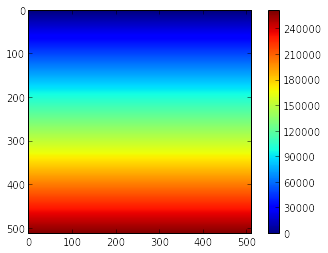

In [31]:
A_cpu
imshow(A_cpu)
colorbar()

In [32]:
matrixArray, copyMatrixArray = np3DtoCudaArray(A_cpu,allowSurfaceBind=True,prec=presGPU) 
# Creamos el CUDA Array a partir de arreglo numpy

In [33]:
A_gpu = gpuarray.zeros((512,512), dtype=presCPU)  # Aqui escribiremos 

<matplotlib.colorbar.Colorbar instance at 0x6546cb0>

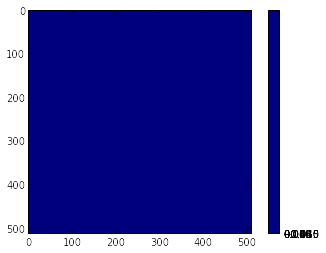

In [34]:
A_gpu
imshow(A_gpu.get())
colorbar()

In [35]:
textureR.prepare('P',texrefs=[texR]) # Preparamos el Kernel y pasamos la textura a usar

In [36]:
texR.set_array(matrixArray) # Paso crucial: ligamos la textura con el CUDA Array
# Ojo toda la informacion esta en el CUDA Array y ligamos a Texturas para hacer las lecturas estructuradas

In [37]:
cuBlock = (16,16,1) # 512,256,1024 thread per Block
print cuBlock
cuGrid = (32,32,1)
textureR.prepared_call(cuGrid,cuBlock,A_gpu.gpudata) 

(16, 16, 1)


In [38]:
512/16

32

In [39]:
512*512==16*16*32*32

True

<matplotlib.colorbar.Colorbar instance at 0x6ad2c20>

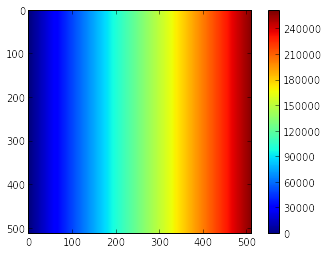

In [40]:
imshow(A_gpu.get())
colorbar()

In [41]:
A_gpu.get()-transpose(A_cpu)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [42]:
A_gpu.dtype

dtype('float32')

In [43]:
#A_gpu.gpudata.free()

Una desventaje de las texturas es que los espacios de memoria que referencias no permiten escritura, es decir no existe una funcion **tex_2D_write**. Para este proposito se creo una textura con este atributo conocida como **Textura de Superficie**. *Ojo* Los CUDA Array y la texturas son dos elementos del mimo esquema: **Memoria de Texturas**, Los CUDA Array son inmutables dentro del kerne a menos que se usen texturas de Superficies

In [44]:
#Declaramos la superficie a usar (las librerias son importantes)
mySurf = '''
surface< void, cudaSurfaceType2D> mySurf ; \n '''

In [45]:
# Observe como se modifica el Kernel
surfK = '''
__global__ void rwSurf(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
cuPres temp;
fp_surf2Dread(&temp, mySurf,  tid_y, tid_x , cudaBoundaryModeClamp); // Lectura de  Suprficie
// surf2Dread(&temp, mySurf,  tid_y*sizeof(float),        tid_x ,  cudaBoundaryModeClamp);
A[tid] = temp; //Escritura a memoria global
//surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),   tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
fp_surf2Dwrite( temp, mySurf, tid_y, tid_x,  cudaBoundaryModeClamp);
}
'''

In [46]:
kernelSurf = optKernels(incLib+mySurf+surfK,pres=presGPU,subBlGr=False)  
print kernelSurf

#include <MYpycuda-helpers.hpp> 

surface< void, cudaSurfaceType2D> mySurf ; 
 
__global__ void rwSurf(float *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
float temp;
fp_surf2Dread(&temp, mySurf,  tid_y, tid_x , cudaBoundaryModeClamp); // Lectura de  Suprficie
// surf2Dread(&temp, mySurf,  tid_y*sizeof(float),        tid_x ,  cudaBoundaryModeClamp);
A[tid] = temp; //Escritura a memoria global
//surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),   tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
fp_surf2Dwrite( temp, mySurf, tid_y, tid_x,  cudaBoundaryModeClamp);
}



In [47]:
cuCode = SourceModule(kernelSurf,include_dirs=[myDir])
surfRef = cuCode.get_surfref('mySurf')
surfRW = cuCode.get_function('rwSurf')

Ahora podemos escribir en el Cuda Array previamente creado 

## All happens here! with setArray you ares binding the CUDA Array 'matrixArray' to the surface o textuture to make the read or write operations...

In [48]:
surfRef.set_array(matrixArray) 

In [49]:
surfRW.prepare('P')

In [50]:
surfRW.prepared_call(cuGrid,cuBlock,A_gpu.gpudata)

In [51]:
ctx.synchronize() # TOOL for check if kernel brokedown even if you have a free error compiling

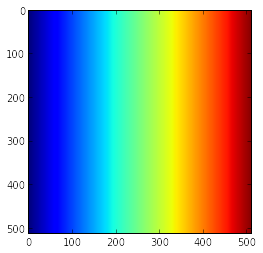

In [52]:
imshow(A_gpu.get())

In [53]:
A_gpu.get()

array([[  0.00000000e+00,   5.12000000e+02,   1.02400000e+03, ...,
          2.60608000e+05,   2.61120000e+05,   2.61632000e+05],
       [  1.00000000e+00,   5.13000000e+02,   1.02500000e+03, ...,
          2.60609000e+05,   2.61121000e+05,   2.61633000e+05],
       [  2.00000000e+00,   5.14000000e+02,   1.02600000e+03, ...,
          2.60610000e+05,   2.61122000e+05,   2.61634000e+05],
       ..., 
       [  5.09000000e+02,   1.02100000e+03,   1.53300000e+03, ...,
          2.61117000e+05,   2.61629000e+05,   2.62141000e+05],
       [  5.10000000e+02,   1.02200000e+03,   1.53400000e+03, ...,
          2.61118000e+05,   2.61630000e+05,   2.62142000e+05],
       [  5.11000000e+02,   1.02300000e+03,   1.53500000e+03, ...,
          2.61119000e+05,   2.61631000e+05,   2.62143000e+05]], dtype=float32)

In [54]:
texR.set_array(matrixArray)

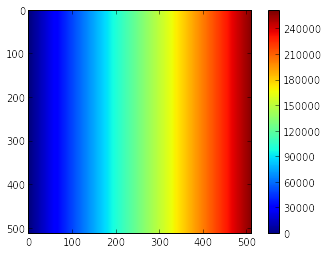

In [55]:
textureR.prepared_call(cuGrid,cuBlock,A_gpu.gpudata)
imshow(A_gpu.get())
colorbar()
ctx.synchronize()

Veamos el rendimiento de las Texturas

In [56]:
surfK2 = '''
__global__ void rwSurf(cuPres *A){

int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
cuPres temp;
//surf2Dread(&temp, mySurf,  tid_y*sizeof(cudaPres),        tid_x ,  cudaBoundaryModeClamp); // Lectura de  Suprficie
fp_surf2Dread(&temp, mySurf, tid_y, tid_x , cudaBoundaryModeClamp); // Lectura de  Suprficie

A[tid] = temp; //Escritura a memoria global
//surf2Dwrite(  temp, mySurf,  tid_y*sizeof(float),        tid_x,  cudaBoundaryModeClamp); // Escritura a CUDA Array
}
'''
cuCode = SourceModule(optKernels(incLib+mySurf+surfK2,pres=presGPU,subBlGr=False),include_dirs=[myDir])
surfRef = cuCode.get_surfref('mySurf')
surfRW = cuCode.get_function('rwSurf')

In [57]:
timeSurf = []
timeTex = []
nLoop = 1000
for i in range(8,14):
    N = 2**i
    a = np.ones((N,N),dtype=presCPU)
    A_gpu=gpuarray.to_gpu(a)
    matrixArray, copyMatrixArray = np3DtoCudaArray(a,allowSurfaceBind=True,prec=presGPU) 
    cuBlock = (16,16,1)
    cuGrid   = (N/cuBlock[0],N/cuBlock[1],1)
    t1 = 0
    t2 = 0
    texR.set_array(matrixArray)
    textureR.prepare('P',texrefs=[texR]) 
    for k in range(nLoop):
        t_tex = textureR.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        t1 += t_tex()/nLoop
    surfRef.set_array(matrixArray)
    surfRW.prepare('P')
    for k in range(nLoop):
        t_surf = surfRW.prepared_timed_call(cuGrid,cuBlock,A_gpu.gpudata)
        t2 += t_surf()/nLoop
    
    timeSurf.append(t2)
    timeTex.append(t1)
    A_gpu.gpudata.free()
    matrixArray.free()

([<matplotlib.axis.XTick at 0x79c9650>,
 <a list of 6 Text xticklabel objects>)

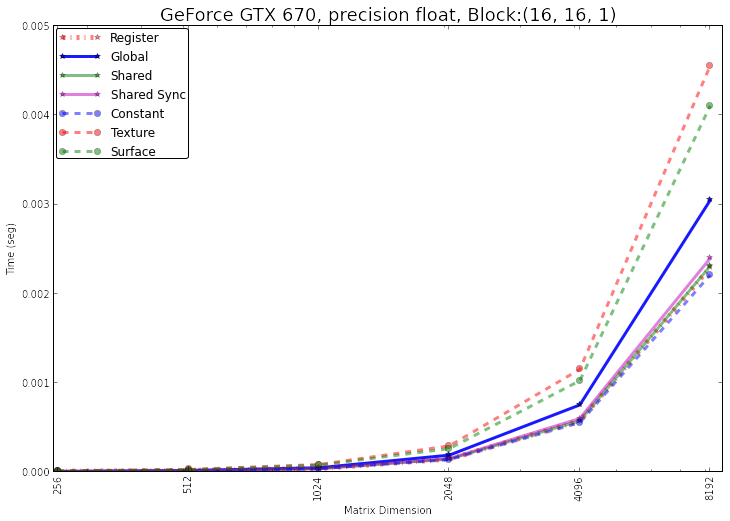

In [58]:
plt.figure(1,figsize=(12,8),dpi=200)
plt.title('{0}, precision {1}, Block:{2}'.format(device.name(),presGPU,cuBlock),size=18)
plt.semilogx([2**i for i in range(8,14)],timeReg,'r-.*',label='Register',linewidth=5.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeGlo,'b-*',label='Global',linewidth=3.0,alpha=0.9)
plt.semilogx([2**i for i in range(8,14)],timeSha,'g-*',label='Shared',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeShaSy,'m-*',label='Shared Sync',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeCons,'b--o',label='Constant',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeSurf,'r--o',label='Texture',linewidth=3.0,alpha=0.5)
plt.semilogx([2**i for i in range(8,14)],timeTex,'g--o',label='Surface',linewidth=3.0,alpha=0.5)
plt.ylabel('Time (seg)')
plt.xlabel('Matrix Dimension')
plt.xlim(xmin=250,xmax=2**13.1)
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=3.5, borderaxespad=0.25, borderpad=0.25)
plt.xticks([2**i for i in range(8,14)], [2**i for i in range(8,14)], rotation='vertical')


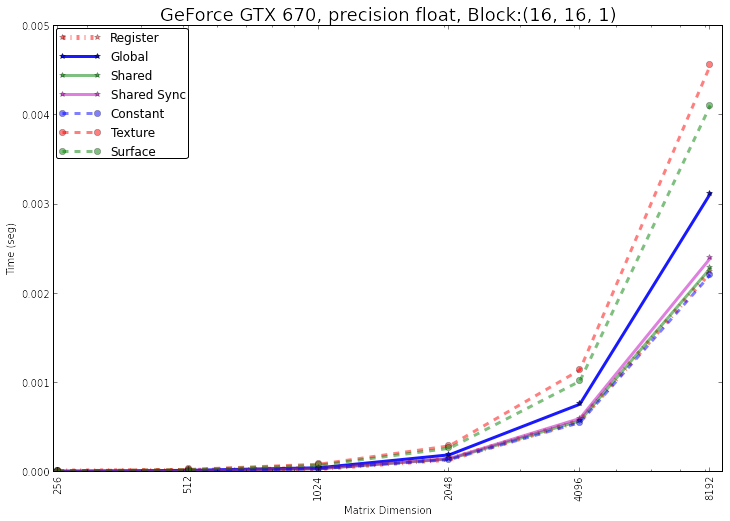
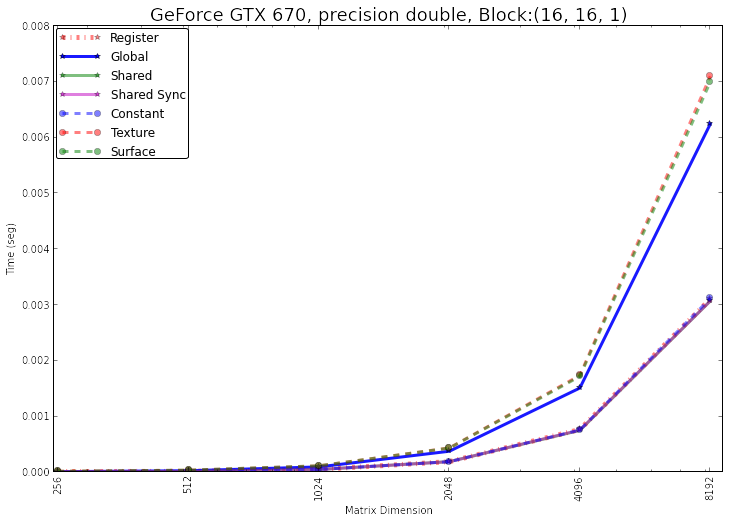

In [2]:
%%HTML
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtoAAAIJCAYAAACbRJqyAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdYU9cbB/DvTUjYeyNLhgwVRVEEFwKiuBCxDhygOOus1Wq1La5atWpbN46idde2Ks6fAkXRKoqDqiiKgkyRjWxI7u8PGhpTkCBL5f08z3kkN+fc+96ba3hzODmHYVkWhBBCCCGEkMbFaekACCGEEEII+RhRok0IIYQQQkgToESbEEIIIYSQJkCJNiGEEEIIIU2AEm1CCCGEEEKaACXahBBCCCGENAFKtAkh5APm7++/j8PhCOvbLjEx0ZTD4QhXrFgR2BRxSYtlWWb58uXLzczMnvN4vArRubzreX1omus8XVxcItq2bZvQ0P28evVKR1VVNX/v3r0BjREXqeLt7X3C1dU1vKXjII2PEm3y3igtLZXbvn37p66uruE6Ojqv+Hx+ubq6em737t1vLlmyZG1cXJzVu+47IiLChcPhCGsrN2/e7N6Y59ISYmJiOk2dOnV3u3btnigpKRXKy8uXmJqaJvr4+Px+8ODB8ZWVlTJ1XQfxYmZm9hwAfH19D3O5XEF4eLir5DFLSkrkrays4rS0tLJevXqlI02cOTk5GgsXLtxgYWERLy8vX6Kjo/PK1dU1/OrVq73E69UV35o1a5aK1xcKhZwffvjhM2tr68fy8vIlxsbGSQsXLtxQXFys0JDr+r5jGIZlGOadF0RoSNvGsG/fPv+VK1d+4+bmFvbzzz9PPnjw4Pjmji0iIsJlxYoVgfn5+aoN3ZepqWmi+H3K5XIF+vr66S4uLhHHjh0bXVOb5jrPxjjOV199tVpXVzdj0qRJweLbg4KCpo8bN+6QtbX1Yy6XK5Dmw8P169edvLy8Tmlra2fKy8uXmJmZPff19T1cUVHBe9f44uLirBYuXLjB1dU1XE1NLU+aD5PFxcUKK1eu/KZ9+/YPFRQUijU1NbOdnZ3/Onny5PB3jQOo3zVZsWJF4OXLl/uePn16aEOOSd4/Mi0dACEA8Pz5c7MhQ4acefz4sbWLi0vEggULNunr66cXFhYq3b171/7nn3+evGHDhoXJyclG+vr66e96HF9f38ODBg06J7nd3Nz8WcPOoGWtWbNm6ddff71KU1Mze/To0cc6dOjwgM/nlycnJxuFhoa6T5w48ZerV6/2Wrly5TfiiQxQ9csgMjKy948//jhfS0srS7RdSUmpEAC2bds2KyIiwiUgIGDv/fv3O4q2A8CSJUvWPn361PLo0aNjdHR0XtUV54sXL0xcXFwiiouLFQICAva2a9fuSV5entr9+/c7pqWlGYjXlYwT+Lf38/nz52bDhg0LEX/us88++2HLli1zRowY8ceiRYu+j42Ntd28efPcu3fv2oeGhrq3dELZVHbv3j01KChoen3bmZqaJpaWlspxuVxBU8QlrUuXLvVXU1PL271791TJ51iWZZojhoiICJeVK1d+M2nSpGBVVdX8hu7PyMgo+bvvvvsSAAQCATclJcVw//79fmPHjj2Snp6uP3/+/B/F6zfXeTZUSkqKYXBw8KRNmzYtkEwa165duyQnJ0fD3t7+bnFxsUJqamqbt+0rODh40pQpU/Y4OTldX7p06Ro1NbW81NTUNlevXu1VWVkpw+PxKt4lxuvXrzv98MMPn1lYWMQ7ODhEh4eHu77t/35ubq66m5tbWHx8vMXkyZN/7tSpU0xRUZHio0ePbJKSkozfJQaR+lwTOzu7v11cXCJWrVr19dChQ0835LjkPcOyLBUqLVqKi4vlra2tH8nKypaePHnSq6Y6paWlsmvXrl2clpam/y7H+PPPP10YhhFu3LhxQVOeS0FBgXJzX7/g4GB/hmGE/fv3v1jb8e/du9dp+/btM2t6zs/Pbx/DMMIXL14Y13aMkJCQoQzDCKdNmxYkeU1HjRp1TNpYe/XqFWlsbPzi5cuXuu9yrsnJyYYcDkfQvXv3KPHtDx48aM8wjHDkyJHHxbdv2bJlNsMwwsOHD49t7telpe+LD6X069cvvG3bts8lt4vuy+aIITAwcDnDMMLExESThu7LxMQksWPHjn9Lbs/Oztbg8/llnTt3vtsS59m3b9+Imq5zfcpXX321isfjlWdmZmpJPif+/jF48OAzHA5HUNt+Hj58aMvn88umTp26q7HPMycnRz0/P1+FZVlER0d3ZRhGuGLFim9qqz9+/PgDqqqqeY8ePbJu7Fjqc01Y9t/38jt37tg39f1ApflKiwdAhcrmzZvnMAwj/Oqrr1bVt21eXp7qF198sc7c3DxeVla2VFtb+9XYsWMPP3/+vK14vfok2pcvX+7j7u5+SVVVNU9eXr64S5cut/fu3TtZsl7fvn0jTE1NE54/f97Wx8fnN3V19RzxX5jp6el6c+bM2dy2bdvnsrKypTo6Ohn9+/e/eOnSJXfx/Tx58sRy/PjxB/T09NL5fH6ZqalpwqJFi9YXFRUp1BVrWVkZX19fP01VVTUvNzdX7V2uvzSJNsuymDhx4n6GYYT/+9//PAoKCpRNTU0T9PT00rOzszWkOc7ly5f7MAwj3Lp16yyWZVFeXs6T5hzFy8qVK79mGEa4a9euqeLbly1btpphGOHVq1d7im8vLS2VVVRULBw0aNDZd70/Rb/8QkND3QIDA5cbGxu/kJWVLbWzs4s5evToaMn6JiYmiS4uLn/euXPH3sPD43+qqqp54glOfV5vae6hmhK1pKQko0mTJv0silVHRyfD2dn52v79+yeK6iQkJJgyDCNcvnx5oHjbiooKmbVr1y62sbGJlZOTK9HU1Mzy9vb+4/79+x3E64m3P3369BAHB4dbcnJyJfr6+mmLFi1aX1lZyX3bdRX9n5QskyZN+rm282JZFjExMXbDhw8/oaGhkS0nJ1dia2v7cP369YsEAgFHvN6jR4+sZ86cud3W1vahsrJygYKCQlHXrl2j9+zZE1DT/S9ZJK+LtKW2RFsgEHCUlZULJD8kNvQ8pb1Pakq0s7KyNHv06HFdVVU1Lzw8vJ9oe3x8vPnjx4+tJI9jZWX12NnZ+Vpd16CupHLSpEk/y8rKloreswoLCxUrKipk3vX/aG3l1q1bDm9LtBMSEky5XG7lwoULv2dZFpWVldzXr18rNXYc0lwT0evIMIxwyZIl3zVFDFRaptDQEdLifvvtt5EMw7BTpkzZU592+fn5qs7Ozn8lJycbBQQE7G3fvv3DtLQ0g+3bt3/q6OgYFR0d7WBsbJwk3qaoqEgxKytLS3ybnJxcqWg4xOnTp4d6e3ufMDAwSFu4cOEGZWXl10eOHBk7ZcqUPc+fPzdbvXr1V6J2DMOwhYWFSn379r3cq1evq999992XonHKiYmJpj179rz26tUrHT8/v/0ODg7RhYWFSjdu3OgRFhbm5u7uHgoAt2/f7urq6hquoaGRM3PmzB1t2rRJvXfvXufNmzfPvXbtWs/Lly/3lZGRqaztGly7dq3ny5cv9fz8/Parqanl1ef61dfmzZvnhoeHu06ZMmVP7969I1+8eGHyxx9/jNDQ0MiRpv25c+cGAVV/Vh86dOjpCxcuDBQIBFxLS8un33zzzcpx48Ydelt7lmWZ4ODgSUpKSoVjx449Iv7crVu3unG5XEH37t1vim+XlZUt69SpU8ytW7e61fd8JS1evHhdcXGxwuzZs7eKYhk7duyR0tJSOT8/v/2iegzDsElJScZubm5ho0aN+vWTTz45XlhYqATU7/WW9h4SHVP0c2VlpUz//v0vpaWlGcyaNWtbu3btnuTn56vGxMR0unr1aq+JEyf+In5ekn9WHzdu3KHjx49/4uHhcXHWrFnb0tPT9bdt2zbLycnpemRkZO/OnTvfE69/7ty5Qdu3b/905syZO6ZMmbLn5MmTwzds2LBQXV0998svv/yututpa2sbe+DAgQnffvvtsqysLK0ff/xxPvD2YVzR0dEOffv2vSwrK1s2a9asbXp6ei9DQkKGLV68eF1MTEwn8eFGly9f7hsZGdl72LBhIW3btk0oKipS/PXXX0dNnTp1d2ZmpvaSJUvWAsCMGTN2vn79WvnEiRPe4sOn7Ozs/q4tjrpUVlbKZGdna7IsywgEAm56err+Tz/9NK+oqEhx+vTpQXW1r8951uc+EZeQkNB24MCBF4qKihSvXLnSR/x83dzcwpKSkoyFQmH197gyMjJ0nzx50m7evHk/vet1ETl//ryntbX14z///LPfokWLvn/+/LkZj8ercHd3D/3pp5/mWVhYxDf0GNK4cOHCQKFQyLGxsXk0YcKEA8ePH/+kvLyc36ZNm9TPP/98o+QQn6amp6f30tTUNDEiIsKlOY9LmlhLZ/pUqGhoaGSrqanlSm4XCASczMxMLfFSUlIiJ3p+7ty5PykoKBT9/fffHcXbvXjxwlhFRSXf398/WLSttt4zhmGEY8eOPcyyVb0ZxsbGL9TV1XPS09P1RG3Ly8t5PXv2vMrlciufPn1qIdret2/fCIZhhF9//fVKydg9PT3PcTgcwcWLF/tLPicUChnRz3Z2djE2NjaxhYWFiuJ1Tpw4MZxhGOG+ffv83nbtRH8N+PHHH+dJPldQUKAsfu2ysrI0a9qHtD3aLMvi/PnzA0XXbfz48Qfq8zoPHz78BMMwQh0dnYxevXpFHj58eGxwcLB/hw4d7jMMIwwODvZ/W/vQ0FA3hmGEkydP3iv5XIcOHe7r6eml19Tuk08++ZVhGOG79piJerRNTU0TxIeA5Ofnq5iYmCRqaGhki9+XJiYmiQzDCGv6K0h9Xm9p7yHJHtGYmBg7hmGE33///cK3nZeoR1q8t+/ixYv9GYYRjhkz5oh43ZiYGDsZGZmK3r17X5Fsr6Sk9Fry3unQocN9fX39NGmub21DGmrq6XV2dr7G4/HKJXvXR40adYxhGGFYWJiraFtNfyEQCoWMi4vLn6qqqnni94No6Ig0/wfqKqLXX7LIy8sX7969e0pjn6e094n4db5z5469np5euo2NTWxN52xqapog2fsaHh7ej2EY4ZYtW2bXdQ3e1nubl5enyjCMUFNTM4vH45UvWLBg48mTJ71WrFjxjZycXImuru7Ldx1aJlnq6tGeP3/+D6L3pPbt2z/Yt2+f36FDh3x79+59hWEYYWBg4PLGiKOuayJe3NzcQpWVlQsa67hUWr60eABUqMjIyFQYGxu/kNx+//79DpK/rDZs2PA5y1b9AtHU1MwaOHDg+aysLE3JhLx///4XDQwMUkX7EiXaM2bM2BEWFuYqXh4+fGjLsiyioqK6Mwwj/PzzzzdIxnLq1Klh4sdn2apfXBwORyAaDygq2dnZGgzDCOsarvD33393ZBhGuHLlyq8l43/16pW2oqJioa+v76G37WP16tXLGIYR/vzzz5Mkn/Px8flN/NopKSm9rmkf9Um0b9y44cjhcAQMwwiPHDkypj6vs5ubWyjDMEILC4un4klObm6umrq6eo6+vn6aeGIgWcaMGXOEYRjhtWvXnCWfMzMze2ZiYpJYU7sJEyb8wjCMUPJ1kraIEu1169Z9Ifncd999t4RhGOH58+cHiraZmJgkamlpZUqeS31eb2nvIfHXT/Q4MTHRhGEYoaen57lXr15p19aupkR75syZ2xmGEUomeCzLwtvb+w+GYYSiD2yi9jV94Jo9e/YWhmGE0gwNkjbRzsjI0GEYRujj4/ObZF3Rh4vZs2dvqekYJSUlcqL3iW+//XYpwzDCBw8etBc939iJtpmZ2TPR+0toaKjb/v37J/br1y+cy+VWSn6gbMh51uc+EQ11u3TpkruysnKBs7PztZycHHVpz+vYsWOjGIYRHjp0yLeuum9LKpOTkw1F70mSnRT79u3zYxhGuHjx4rUNfR1Ytu5EOyAgYA/DMEJ1dfUc8WtRUVEhY2lp+UReXr74XYfk1eeaiBfRh6nS0lLZxjgulZYvNL0faXEqKioFBQUFKpLbzczMnoeGhrqHhoa6b9iwYSHw75+5MzMztXNycjT+97//DdDW1s7U0dF5JV5CQ0Pda5puztLS8qmrq2u4eLG1tY0Fqv6UCgDt27d/KNlOso6ItrZ2poqKSoH4tvj4eAsAsLe3v/u283706JENAAQGBq6QjF9XVzejuLhYoa4p80THrun6LV++fHloaKj7pUuX+tvZ2f0tOUSgvkRDJNTV1XONjIySFyxYsCkvL09N2vby8vIlADB27Ngj4sNh1NTU8oYOHXr65cuXek+ePGlXU9ucnByNEydOeNvY2Dxydnb+S/J5BQWF4rKyMtna4mYYhlVQUCiWNtaa2NjYPKptm+R9YW5u/kzyetfn9Zb2HqqJiYnJi2XLln178eJFD319/XQHB4foxYsXr4uOjnaoq21CQkJbLpcrqOlca/s/IJoGUpympmY2AGRnZ2vWN/63xQbU/P/T2tr6McMwrHhshYWFSgsXLtxgbGycpKCgUCx6n/jqq69WA1WzTTRWbJIUFRWLRO8vbm5uYRMnTvzl0qVL/W1tbWPnzJmzJScnR6O2tvU5z/reJxkZGbqDBw8+a2FhER8WFuamrq6eK+05ie5ntoEzpIjeBxiGYf39/feJPzdu3LhDHA5HePny5b4NOUZ9YxkyZMgZ8WshIyNT6evre7i0tFQuKirKsTliEWFZlmEaOGUneb/QGG3S4jp06PAgMjKyd2JioqmpqWmiaLuCgkKxaAJ/yamkRG/2/fv3v7R48eJ1zRqwmIYkb6JzWLhw4YaBAwdeqKlOXb8IO3bseB8A7t69ay/5XIcOHR6Ifm6M8dtLly5d8+TJk3aHDx/21dLSyvLw8Lg4d+7czb/88stEadobGhqmAFXjECWfE03ZWFvyc+jQoXHl5eX8gICAvTU9b2BgkPb48WPriooKnuS0YKmpqW20tLSy3jbWvbHVdF80xustrVWrVn09efLkn8+ePTs4MjKy9549e6Z8//33i7744ov1a9euXdIYxxB52/SADU3KGsLX1/fw2bNnB0+fPj2oT58+VzQ1NbO5XK7g7Nmzg3/44YfPxMcfNwculytwdXUN37x589yoqChHT0/P8815fADQ0NDI6dq16+0zZ84MOXjw4Pj6fC9GW1s7E6j60NvQGOTl5UtKS0vlJN8LZGRkKrW0tLKa8kOQuLe9J4m2NVcsIjk5ORpKSkqFfD6/vDmPS5oOJdqkxX3yySfHRcmA+JcN30ZbWztTTU0tLz8/X7WxVtMSfQnrwYMHHSSfi42NtQVq7r2TZGFhEc8wDFtT8iuuXbt2T4CqDxHveg49e/a8pqen9/LEiRPemzZtWiDtFxPrKzIysvdPP/00z8fH5/cxY8YcBYBp06bt2rVr17RPPvnkuDTzvjo6OkYFBQVNT05ONpJ8LiUlxRAAapuLe+/evQF8Pr9c8ot8It27d7956dKl/lFRUY69evW6KtpeWloqd+/evc4uLi4RUp5qrWJjY20lz7M+90V9Xm9p76G3adu2bcLs2bO3zp49e2tZWZnsgAED/rd+/fovFi5cuEF8vnRxZmZmzwUCATc2NtZW9CFOJDY21pZhGLYxVhd8F6Lj1vT/8/Hjx9YsyzKi1yEvL0/tzJkzQ/z8/PZv3779U/G6Fy9e9JBs31y9h6KFWERfjq1Jfc6zvvcJn88v/+OPP0aMGjXq1+nTpwdVVFTwZs6cuUOatqIe9qdPn1pKU782DMOw3bp1u3XlypU+ycnJRlZWVnGi58rKymQzMzO1Rf9Xmpqjo2MUALzLe1JTiY+PtxDvJCEfPho6QlrclClT9lhbWz/+/vvvF9W2EpdkzxiHwxGOGzfu0M2bN7v//vvvPjW1yczM1K5PHF26dLljbGycFBwcPCkjI0NXtL2iooL3/fffL+JwOEIvL69Tde1HQ0Mjx9PT8/z58+c9w8LC3GqrZ29vf7dDhw4Pdu7cOUPyz/FA1cwFdfWm8Hi8ijVr1ix9/fq18ujRo4/VNIQEaFjPYlFRkeKkSZOCtbS0snbs2DFTtH3Dhg0LjY2Nk6ZPnx4kzRCS4cOHn1RWVn598ODB8UVFRYqi7enp6fonT54cbmVlFVdTwhodHe3w999/2w0dOvR0bQni6NGjjzEMw4pmrhDZvXv31JKSEvm6ZjSRxo4dO2aKX9/8/HzVnTt3zlBXV8/t27fv5bra1+f1lvYeEhFPFAsKClQkV9aTlZUts7a2fgy8vYfO29v7BACIFlsRefDgQYeQkJBhvXr1uioaFtIcxM9LR0fnlbOz81+nT58e+vDhw/ai7SzLMqJ4RfFzuVwBwzCsZK91enq6/p49e6ZIJtaiWYcac6iLpNLSUrkLFy4MZBiG7dKlyx3x5971POt7nwBV1+bXX38dNXLkyN9mzZq1bfPmzXMl6zx79sxcciVebW3tzPbt2z+8fv26U/3O/L8mTJhwAKj6PyW+fdeuXdNYlmVqWlSsKfTp0+eKiYnJi9OnTw8VXzCrqKhI8Zdffpmorq6e6+TkdL05YgGAly9f6iUlJRlL835CPhzUo01anJycXOnZs2cHDxky5MyIESP+cHFxiejfv/8lPT29lwUFBSqPHz+2Pnbs2GgZGZlKIyOjZFG7b7/9dtm1a9d6jho16tdRo0b96ujoGMXn88tfvHhhcu7cuUEODg7RwcHBk6SNg8PhCLdu3Trb29v7RLdu3W5NmzZtl5KSUuGxY8dGR0VFOS5btuxbyanHaktgt27dOtvZ2fkvT0/P835+fvu7dOlyp6SkRD4qKsqxbdu2CaI/3x84cGCCq6truJ2d3d+TJ0/+2dbWNra4uFghPj7e4sSJE95r165dUlsvroi/v/++tLQ0g6+//nqVubn5s9GjRx9r3779Qx6PV5Genq5/8eJFj2vXrvWU7KGU1hdffLH++fPnZr/++usoyZUj9+zZM0XaISRqamp5GzZsWDh9+vSgHj163Jg8efLPZWVlsjt27JhZWVkps2XLljk1tdu7d28AUPWBrLZ9d+jQ4cGsWbO2bd26dbaPj8/vnp6e5x89emSzZcuWOS4uLhG+vr6Hxevv27fPf/LkyT8HBgauCAwMXCHNddDW1s50dHSMmjRpUjD7z/R+KSkphnv27JkiJydXKs0+6vN6S3sPAW/eh+Hh4a7Tpk3bNXLkyN/atWv3RElJqfD27dtd9+7dG9CjR48blpaWT2uLz93dPXTUqFG/Hj16dExubq764MGDz758+VJv27ZtsxQUFIprSsoaQ23/jyS3//TTT/P69u17uXfv3pGzZs3apqurm3HmzJkhFy9e9Bg3btyhfv36/QkAysrKrz08PC4ePHhwvLy8fImDg0P0ixcvTHbt2jXNzMzsueR4dVEytXjx4nW+vr6H5eTkSjt27Hhf1IvL4XCEJiYmL2r6gFSTvLw8tUOHDo1jWZZhWZZJS0szOHjw4PiEhIS206ZN21XX+4i05wm8233C5XIFR44cGcvj8Srmz5//Y2VlpcyCBQs2ierVNL0fUPXXx1WrVn398uVLPcnhFqdPnx4aExPTCajqlWVZlvn222+XsSzLqKur586aNWubqO6kSZOCf/nll4mbN2+em5WVpdWrV6+r9+/f77hr165pHTp0eDB37tzN4vt2cXGJuHLlSp/ExERTySlbJRUUFKiI7lNR8nz58uW+or+Wenl5nRK9F3I4HOH27ds/HTZsWIiTk9P1Tz/9dDuPx6sIDg6elJqa2mbv3r0BonHcQNUKoq6uruF+fn77pfndUp9rAvw7Beonn3xyvK59kw9IS38bkwoVUSkpKZHbtm3bp/369QvX0tLK5PF45WpqarndunW7uXjx4rVPnjyxlGxTXFwsv2rVqq86duz4t7y8fLGysnKBra3tw2nTpgXdvHmzm6hefRes6d+//0UVFZV8OTm5ki5dutyuaVYPFxeXP9+20lpqaqrBjBkzdhgbG7/g8/llurq6LwcMGHBBfGEIlq2ajnDGjBk7TE1NE/h8fpmmpmaWg4PDraVLl36bkpLSRtrrd+/evU5TpkzZbWlp+URBQaFITk6uxMTEJHHEiBG/Hzp0yLe2BUT8/f2DORyOoKYZF0JDQ904HI5g9OjRR2s77vTp03dyOBzB6dOnh0gT5x9//OHdo0eP64qKioXKysoFAwYMuPDXX3851VS3uLhYXk1NLbe2GUXEi0Ag4GzcuHGBlZXVY1lZ2VJDQ8Pkzz//fENNM1+IpkWUXLykpiKadSQsLMxVcsGammZeMTU1TejXr194bfurz+stzT0kev1EjxMSEkxnzJixw8bGJlZFRSVfUVGx0NbW9mFgYOBy8ekJa5p1hGWrprlct27dFzY2NrGysrKlogVrxGfpeFt7lmWxfPnywNruKWn/H0mel6iIL+QiKytbamtr+/D7779fKDnLS1ZWluaUKVN2GxgYpMrJyZXY2dnF7NmzJ2Dfvn1+HA5HcPny5T7i9devX7/IzMzsGY/HK+dwOALReRUUFCgzDCPs1atXpDT3t2hqPPEZfxQVFQu7d+8etXPnzumNfZ7S3ic1XWehUMj4+/sHMwwjXLt27WLJc5A8Tlpamj6Pxyuv6X1UtB+GYYQcDkcgfg1qen2LiooUlixZ8p3o/4GhoWHynDlzNufl5alK1u3SpcttJSWl19LMHCS6L2uKhcPhCMQXbRKVy5cv93F1dQ0TLWzUq1evyDNnzgyWrCdaIVfaxdXqe01cXFz+lFzQiMqHX1o8ACpUqFBp7uLt7f1Hu3bt4upavZBl/020JRMzKq2jiKb2jIiI6NvSsbwPZcaMGTvMzMyeNcVKjjWVnJwcdS6XW/muK3U2Zvnss882aWpqZjXWlH/i5e7du53r02FB5cMpTTpG+8KFCwOtra0fW1paPl23bt3imurMnTt3s6Wl5dNOnTrFiH+ho7a2y5cvX25oaJhib29/197e/u6FCxcGNuU5EEI+LpWVlTJ//vlnv7Vr1y5524wZhABVX54cOnToaRo3W2XlypXfZGdna+7bt8+/OY4XGhrqrqurm/FggqtnAAAgAElEQVTFF1+sb47jvc3Fixc9li1b9m1TrMK7YsWKQBcXl4ghQ4acaex9kxbWVBl8ZWUl19zcPD4hIcG0vLyc16lTp3uxsbE24nXOnj07yNPT8xzLVi2E4ejoeKOutsuXLw+U5s//VKhQodIYhXq0qVChQoXKu5Ym69G+efNmdwsLi3hTU9NEHo9XMWbMmKOnTp3yEq8TEhIyzM/Pbz9QNc1OXl6e2suXL/Xqasu24NyshJDWhxaPIIQQ8i6abNaR1NTUNuIzRBgaGqZIrrBUU53U1NQ2aWlpBm9ru2XLljm//PLLRAcHh+iNGzd+LvlnHPqlSAhpbDR0gBBCSE3e1gHcZD3a0ia79e2dnjlz5o6EhIS29+7d66yvr5/++eefb6xlv9UlMDCwRf5c0FLHpfOqPc6WiP1jPmZTHaep4/9Q7mEqTfu6031Qv+v1sZT35XfDh3T9P9bfY43xnlCXJuvRbtOmTar4akvJyclGouVOa6uTkpJiaGhomFJRUcGrra34Kk1TpkzZI82KdC3FxcWlpUNoEh/Keb0vcbZEHM11zKY6zvvy2pGPC91X9fOxXq8P5bzepzg/1t9jzXGMJku0HRwcop8+fWqZmJhoamBgkHbs2LHRR44cGSteZ9iwYSFbt26dPWbMmKM3btzooaamlqerq5uhqamZXVvb9PR0fX19/XQAOHHihHddi3CkpKRg//79WLVqFYRCYVOdLnmPMQwDHR0dBAQEgGGaf3j/x/oG1ZTHeZ9+wZCPB91X9fOxXq8P5bzepzg/1t9jH3SiLSMjU7l169bZAwYM+J9AIOAGBATstbGxeRQUFDQdAKZPnx40aNCgc+fOnRtkYWERr6ioWCRaaam2tkDVyl337t3rzDAM27Zt2wTR/mrj7e2NqVOnYuHCheDz+U11uuQ9VllZiaSkJCxYsAAZGRlYvXp1S4dEWtj79AuMtBy6D4gI3QsEaJr7gJFmfMmHhmEYVnReXC4XJSUllGQTlJSUQEVFBRUVFS0dCiGEEEI+AgzDgH3L9w0/+kT7nwvQwhGR9wXdD4QQQghpLHUl2k26MiT58CQlJUFZWZmSUUIIIYSQBqJE+wNmamoKBQUFKCsrQ09PDxMmTEBBQUGD9mlsbIzXr1/X+aXBffv2oXfv3g06FiGEEELIx6xVJtosy+LahQvvRa9tQ2JhGAZnzpzB69evERMTg/v3738wX/SrrKxs6RAIIYQQQppUq0y0n8XG4vW2bXg2axawfDkQEfHfShERtW9fvrzR2j2LjcXrEyfwLDa2XucgSVdXFx4eHnj48CEA4MaNG3B2doa6ujo6d+6My5f/XdQuISEBffr0gYqKCvr3749Zs2ZhwoQJAIDExERwOJzqqRD37dsHc3NzqKiowMzMDIcPH8bjx48xY8YMXL9+HcrKytDQ0AAAlJWVYeHChTAxMYGenh5mzpyJ0tLSf04/AoaGhli/fj309fUREBDQoPMlhBBCCHnfNdn0fu+jv2/dwoPz56FbXo4BGhoIf/AAN7lcdNDTg10zT+3zRix6egg/cgQ3+Xx08PSEXbduUu9H1BOekpKCCxcuYOTIkUhNTcWQIUNw8OBBDBw4EKGhofDx8UFcXBw0NTXh6+uL3r17Izw8HFFRURg0aBC8vLz+s++ioiLMmzcP0dHRsLS0REZGBrKzs2FtbY2goCDs2bMHkZGR1fWXLFmChIQExMTEQEZGBr6+vli5ciXWrFkDAMjIyEBubi6SkpIgEAgaeAUJIYQQQt5vrapHu6ODA7qNGAG2rKzqW6ICAbrb2KCjlVXLx1JWhu4+Pujo4CD1PliWxfDhw6GiogJjY2OYm5tj2bJlOHjwIAYNGoSBAwcCANzd3eHg4ICzZ88iKSkJ0dHRWLlyJWRkZNCzZ08MGzas1qErHA4H9+/fR0lJCXR1dWFra1t9bMlYdu/ejU2bNkFNTQ1KSkr48ssvcfTo0Tf2tWLFCvB4PMjJydX3khFCCCGEfFBaVaLNMAwYhkFlQQH+x7KoLCur3t7isfzzJcb6xMIwDE6dOoWCggJEREQgPDwct2/fxosXL3D8+HGoq6tXl2vXruHly5dIS0uDhobGG4mukZFRjftXVFTEsWPHsHPnThgYGGDIkCGIi4ursW5mZiaKi4vRtWvX6mN6enoiKyuruo62tjbNZ04IIYSQVqNVDR0BgPzMTFjMnQvzV6/w7PhxFBQXt3wstrZ4FhuLArGktL769OmDOXPmYPHixRgwYAAmTJiAXbt2/afeixcvkJOTg5KSEsjLywOomtKvtgTfw8MDHh4eKCsrw7JlyzB16lRcuXLlP/W1tLQgLy+P2NhY6Ovr17ivlvhAQwghhBDSUlpdot1VNBa7fXtY9OtXe8Xaxmy7uNT+XD3bdRV7bNG+fe37lNL8+fPxww8/YNWqVfjpp59w8eJFuLm5oaKiAjdu3IClpSVMTEzg4OCA5cuXY/Xq1YiOjsaZM2cwbNiw/+zv1atXuH79Otzd3SEvLw9FRUVwuVwAVV++TElJQUVFBXg8HjgcDqZOnYr58+dj69at0NbWRmpqKh4+fAgPD48GnxshhBBCyIemVQ0d+dhpaWnBz88PmzZtQkhICNasWQMdHR0YGxtj48aN1TOJHDp0CNevX4empia+/vprjB49+o0hHaKeZ6FQiB9++AFt2rSBpqYmIiMjsWPHDgCAm5sb2rdvDz09Pejo6AAA1q1bBwsLC/To0QOqqqro378/njx58p/9EkIIIYS0BrQEO8Ho0aNha2uLwMDAlg6lydH9QAghhJDGQkuwk/+Ijo7Gs2fPIBQKcf78eYSEhGD48OEtHRYhhBBCyEel1Y3RJsDLly8xYsQIZGdnw8jICDt37kSnTp1aOixCCCGEkI8KDR0hrQrdD4QQQghpLDR0hBBCCCGEkBZAiTYhhBBCCCFNgBJtQgghhBBCmgAl2oQQQgghhDQBSrQJIYQQQghpApRof+T8/f3x9ddfS1WXw+Hg+fPn73QcU1NThIWFvVNbQgghhJCPESXaH4GjR4/C0dERSkpK0NXVRY8ePaqXSmcYplmWPm+u4xBCCCGEfChaZaLNsiy+/Xb7ezGfckNj2bhxI+bPn4/FixcjIyMDGRkZ2LlzJ/766y+Ul5dXH4MQQgghhDSvVplonz0bge3bM3Du3OWWDqVBseTn5yMwMBA7duzAiBEjoKioCADo3LkzDhw4AD6f/582u3fvhqWlJTQ1NeHl5YX09HSJeM7C3Nwc2tra+OKLL6qT9GfPnsHV1RVaWlrQ1tbG+PHjkZ+f/w5nTAghhBDSOrSqJdgPHPgd27efQnS0LQSC5Rg+fB0Y5mcoKHhBQcGnWWMpLv4dxcWnwLL/xuLg8DM+/dQLEyZIF8v169dRVlYGLy8vqeqHh4dj6dKluHTpEmxtbbFw4UKMGTMGly//m+SfPHkSt2/fxuvXr+Hu7g4rKysEBAQAAJYtW4Y+ffogPz8fPj4+WL58OX744Yf6nzwhhBBCSCvQqnq0x48fgaVL/QEI/xlPLISS0iTIy49o9ljk5UdASenNWJYtm4Tx46WPJSsrC1paWuBw/n0ZnZ2doa6uDgUFBURGRgJA9djpQ4cOISAgAJ07dwafz8d3332H69evIykpqbr94sWLoaamBiMjI8yfPx9HjhwBAJibm8PNzQ08Hg9aWlr47LPP3kjQCSGEEELIm1pVoi36wp5QWAYudzmEwlIALfMlvqpjvhlLfb9QqKmpiaysLAiFwuptf/31F3Jzc6GpqfnGdgBIT0+HiYlJ9WNFRUVoamoiNTW1epuRkVH1z8bGxkhLSwMAZGRkYMyYMTA0NISqqiomTJiA7Ozs+p42IYQQQkir0aqGjgDA8+dpCAnph0GD+uLcuct4/jwNc+a0TCybN6fB3PzNWOrDyckJsrKyOHnyJEaMqLsn3MDAAImJidWPi4qKkJ2djTZt2lRvS0pKgo2NTfXPoueWLl0KLpeLBw8eQE1NDSdPnsSclrpwhBBCCCEfgFaXaM+dO67658GDXVouEDQ8FjU1NQQGBuLTTz8Fy7Lw8PCAoqIi/v77bxQVFVXXE32hcezYsRg7dix8fX1hbW2NpUuXokePHjA2Nq6uu2HDBjg6OuL169fYvHkzPv/8cwBAYWEhVFVVoaKigtTUVHz//ffveNaEEEIIIa1Dqxo68jFatGgRNm3ahPXr10NPTw96enqYMWMG1q9fD2dnZwD/jtF2c3PDqlWr4OPjAwMDAyQkJODo0aNv7M/Lywtdu3aFvb09hgwZgsmTJwMAAgMDcefOHaiqqmLo0KHw8fGhebMJIYQQQt6C+RjnWGYYhhWdF8MwNI80qUb3AyGEEELEvYiLw7PQUHAqKiDk8WDu7g4TKyup2v6TV9Ta80iJNmlV6H4ghBBCiMiLuDjE798PN7G1R8LKy2Hh5ydVsl1Xok1DRwghhBBCSKv0LDT0jSQbANz4fDwLC2uU/VOiTQghhBBCWiVORUXN28vLG2f/jbIXQgghhBBCPjBCHq/m7RK93O+KEm1CCCGEENIqmbu7I0yi9zqsvBzmbm6Nsn/6MiRpVeh+IIQQQoi4F3FxeBYWBk55OYR8Pszd3GjWkbehRJvUhu4HQgghhDQWmnWEEEIIIYSQmuTmAlevAsXFTbJ7SrQ/Uvv27UPv3r1b7PimpqYIa6SpcQghhBBCmsStW0BoKLBpExAV1ei7p0T7A3f16lU4OztDTU0Nmpqa6NWrF6Kjo1s6LDAMQ0u0E0IIIeT9VV4O3LlT9XNlJaCh0eiHaJWJNsuyuPDnhfdirG5DYikoKMCQIUMwb9485ObmIjU1FYGBgZCVlW3UGCsrKxt1f4QQQgghLe7vv4HS0qqfNTQAC4tGP0SrTLRj42JxIuYEYuNiWzqUBsXy5MkTMAyD0aNHg2EYyMnJoX///ujYsWN1nUWLFkFDQwNmZma4cOFC9fbg4GDY2tpCRUUF5ubm2LVrV/VzERERMDQ0xPr166Gvr4+AgACwLIu1a9fCwsICWlpaGD16NHJzc6vbHDhwACYmJtDS0sKaNWve8WoQQgghhDQDln1zqIijI9AEf4mXafQ9vsdu3bmF83+dR2hGKBgzBjMPzQS3mAsLGwu0sWjTrLGkxqci/lE8BAqC6ljcdd3h6eyJbl26SbUPKysrcLlc+Pv7Y8yYMXB0dIS6unr181FRUfD390d2djaCgoIQEBCA1NRUAICuri7Onj2Ltm3b4sqVK/D09ES3bt1gb28PAMjIyEBubi6SkpIgEAiwefNmhISE4MqVK9DW1sacOXMwa9YsHD58GLGxsfj0009x/vx5dO/eHV9++SVSUlIa/6IRQgghhDSG1FQgM7PqZz4f6Ny5SQ7Tqnq0HewdMMJtBARCARiGgUAogE1nGxiYGzR7LAbmBrDpZPNGLD7uPnCwd5B6H8rKyrh69SoYhsHUqVOho6MDLy8vvHr1CgBgYmKCgIAAMAyDiRMnIj09vfq5QYMGoW3btgCAPn36wMPDA5GRkdX75nA4WLFiBXg8HuTk5BAUFITVq1fDwMAAPB4PgYGB+O233yAQCPDbb79h6NCh6NWrF/h8PlatWgUOp1XdWoQQQgj5kBgaAlOnAnZ2QNeuQCMPuxVpVdmQ6At6ZRVlYONZlFWUVW9viVjAoMGxWFtbIzg4GMnJyXjw4AHS0tIwf/58MAwDPT296noKCgoAgMLCQgDA+fPn0aNHD2hqakJdXR3nzp1DdnZ2dX1tbW3wxZYfTUxMhLe3N9TV1aGurg5bW1vIyMggIyMD6enpMDQ0fONYmpqa9b8ohBBCCCHNpU0bYMQIwMOjyQ7RqoaOAEBmTib2T94PWytbxMbFIis3C32d+rZILBF/RWBWt1lvxNIQVlZW8PPzw65duzBgwIBa65WVlcHHxwcHDx6El5cXuFwuvL293/hCpmTCb2xsjODgYDg5Of1nf/r6+nj06FH14+Li4jeSdkIIIYSQ91YTdri2qh5tAHBxdkF76/ZgGAbtrdu3WJLdGLHExcVh06ZN1eOuk5OTceTIkRqTYXHl5eUoLy+HlpYWOBwOzp8/j4sXL761zYwZM7B06VIkJSUBADIzMxESEgIAGDlyJM6cOYNr166hvLwc33zzDYRCYb3OhRBCCCHkY9PqEu2PibKyMqKiouDo6AglJSU4OTnBzs4OGzduBPDfXmnRY2VlZWzevBmjRo2ChoYGjhw5Ai8vrxrrisybNw/Dhg2Dh4cHVFRU4OTkhJs3bwIAbG1tsW3bNvj6+sLAwAAaGhowMjJqqtMmhBBCCPkgMO/DXNKNjWEYVnRe/6xB38IRkfcF3Q+EEEJIK8WyVcutd+gAiM3S1hD/5BW1jj2hRJu0KnQ/EEIIIa1UQgKwf3/VmOwOHQAfnwbvsq5Em4aOEEIIIYSQj59ogRqWBeTlm+WQlGgTQgghhJCPW24uEBf37+Pu3ZvlsJRoE0IIIYSQj9utW1U92QBgbg5oaTXLYSnRJoQQQgghHy+BALh379/Hjo7Ndmj6MiRpVeh+IIQQQlqh3Fzg5k3gxYuqpdcbaZEamnWEEisihu4HQgghpBVj2UZdCZJmHSGEEEIIIQRo0uXWa0KJ9kds37596N27d4sd39TUFGFhYS12fEIIIYSQlkSJ9gfu6tWrcHZ2hpqaGjQ1NdGrVy9ER0e3dFgAqv6cIrmUu0hKSgp8fHygra0NNTU1dOzYEfv372/mCAkhhBBCmk6rTLRZlsWVC1fei7G6DYmloKAAQ4YMwbx585Cbm4vU1FQEBgZCVla20eOsrKxs1P1NmDABJiYmSEpKQk5ODg4cOABdXd1GPQYhhBBCWrEHD4DU1BYNoVUm2k9jnyLpRBKexj5t6VAaFMuTJ0/AMAxGjx4NhmEgJyeH/v37o2PHjm/UW7RoETQ0NGBmZoYLFy5Ubw8ODoatrS1UVFRgbm6OXbt2VT8XEREBQ0NDrF+/Hvr6+ggICADLsli7di0sLCygpaWF0aNHIzc3t7rNgQMHYGJiAi0tLaxZs+atsUdHR8Pf3x/y8vLgcDjo3LkzBg4cCAAYPHgwtm7d+kZ9Ozs7nDp1CgDA4XAQFBSEdu3aQV1dHbNnz36j7u7du6vPq3379rh79249riohhBBCPnjl5cCZM8Du3cCePcDr1y0ShkyLHLWF3Lt1D7fP3wZCgS5MF0TOjMRp7mnYWtjCpo1Ns8byKPURYuNjoSZQq44l0j0SXT27onO3zlLtw8rKClwuF/7+/hgzZgwcHR2hrq7+Rp2oqCj4+/sjOzsbQUFBCAgIQOo/n+50dXVx9uxZtG3bFleuXIGnpye6desGe3t7AEBGRgZyc3ORlJQEgUCAzZs3IyQkBFeuXIG2tjbmzJmDWbNm4fDhw4iNjcWnn36K8+fPo3v37vjyyy+RkpJSa+w9evTAp59+ijlz5sDJyQnGxsbVz/n7+2Pjxo3VCXRMTAzS0tIwePDg6jpnz55FdHQ08vPz0bVrVwwdOhQDBgzA8ePHsWLFCpw6dQpdu3bF8+fPISPTqm5zQgghhNy/D5SWVv1cXAwoKbVIGK2qR7uTQyf0GtELQoEQDMNAKBCii00XWBtYN3ss1gbWsLexfyOW3j690cmhk9T7UFZWxtWrV8EwDKZOnQodHR14eXnh1atX1XVMTEwQEBAAhmEwceJEpKenVz8/aNAgtG3bFgDQp08feHh4IDIysroth8PBihUrwOPxICcnh6CgIKxevRoGBgbg8XgIDAzEb7/9BoFAgN9++w1Dhw5Fr169wOfzsWrVKnA4td9ex48fR+/evbFq1SqYmZnB3t6+emz50KFD8eTJEzx79gxAVU/5mDFj3kiYlyxZAhUVFRgZGaFfv36IiYkBAOzZsweLFy9G165dAQBmZmZvJPGEEEII+cixLBAV9e/j7t2bfbYRkVaVaIu+nFdZVomb7E1UllVWb2+RWNDwWKytrREcHIzk5GQ8ePAAaWlpmD9/fvXzenp61T8rKCgAAAoLCwEA58+fR48ePaCpqQl1dXWcO3cO2dnZ1fW1tbXB5/OrHycmJsLb2xvq6upQV1eHra0tZGRkkJGRgfT0dBgaGr5xLE1NzVrjVlNTw3fffYcHDx4gIyMDnTt3xvDhwwEAcnJyGDVqFA4cOACWZXH06FFMmDDhjfaS5yU6p5SUFJibm0t/AQkhhBDycUlMBESdjnw+0Fm6kQJNodX9TT03Mxdu+91gaWuJp7FPkZeVB9O+pi0SS0ZEBtxmvRlLQ1hZWcHPz++Nsda1KSsrg4+PDw4ePAgvLy9wuVx4e3u/8aVMyaTf2NgYwcHBcHJy+s/+9PX18ejRo+rHxcXFbyTtb6OpqYnPP/8c+/fvR25uLtTV1eHn54eJEyeiZ8+eUFBQgKOUy6UaGRkhPj5eqrqEEEII+QiJz77WqRMgJ9diobSqHm0AcHRxRLv27cAwDNq1b4fufbt/sLHExcVh06ZN1WOuk5OTceTIkRoTYUnl5eUoLy+HlpYWOBwOzp8/j4sXL761zYwZM7B06VIkJSUBADIzMxESEgIAGDlyJM6cOYNr166hvLwc33zzDYRCYa37Wrx4MR4+fIjKykq8fv0aO3bsgKWlZfUYcycnJzAMg4ULF2LixIlvjYtl2eoPCFOmTMGGDRtw584dsCyL+Pj46ngJIYQQ0goMHgz07w+oqVUNG2lBrS7R/pgoKysjKioKjo6OUFJSgpOTE+zs7LBx40YANc9jLXqsrKyMzZs3Y9SoUdDQ0MCRI0fg5eVVY12RefPmYdiwYfDw8ICKigqcnJxw8+ZNAICtrS22bdsGX19fGBgYQENDA0ZGRrXGXlJSUj0MxdzcHMnJydVJu8jEiRNx//59jB8//q1xiZ/nyJEjsWzZMvj6+kJFRQUjRox4Y2YUQgghhHzkFBSAnj2BefMAbe0WDYV5H+aSbmwMw7Ci8/pnDfoWjoi8iwMHDmD37t24cuVKo+2T7gdCCCGENJZ/8opav2BHPdrkvVRcXIxt27Zh2rRpLR0KIYQQQsg7oUSbvHf+97//QUdHB/r6+vD19W3pcAghhBBC3gkNHSGtCt0PhBBCyEcoPb1q9UdLy3rPmR0XH4fQ26GoYCvAY3hw7+oOKwsrqdrWNXSEEm3SqtD9QAghhHyEjh0DHj0C1NWBoUMBMzOpmsXFx2H/n/vBt/x33ZDyp+Xw6+cnVbJNY7QJIYQQQsjHKy8PePy46ufcXEBZWeqmobdD30iyAYBvyUfYnbBGCY0SbUIIIYQQ8uG6datq2XUAMDev15R+FWwFAOBl4UvcfXkX2SVVi+2VC8sbJTRKtAkhhBBCyIepogK4c+ffx/VcoIbH8MCCRVJ+EvJL83E/4z7SXqeBz+HX3VgKlGgTQgghhJAP0/37QElJ1c/q6lVfhqwH967uSI9JR3FFMQBAhiMDtTQ1uHVxa5TwZBplL4QQQgghhDQ3OzuAwwGiov79uR6sLKzg0MEBqddTIYAA7TTaIcAjQOpZR+pCs458BA4fPoxNmzYhLi4OysrK6Ny5M5YtW4aePXs2+rEiIiIwYcIEJCcnN8r+9u3bh7179yIyMrJR9leX1nA/EEIIIa0Oy1aVeibaIikFKfgr+S8MshwEJb6S1O3qmnWk1fVox8W9QGjoM1RUcMDjCeHubg4rK5MPNpZNmzZh3bp1CAoKwoABA8Dn83HhwgWEhIQ0SaJNCCGEEPLeYZh6z58tzlDFEKPaj2rEgKo06RjtCxcuDLS2tn5saWn5dN26dYtrqjN37tzNlpaWTzt16hRz9+5de2nbbty48XMOhyPMycnRkDaeuLgX2L8/HpmZrsjLc0Fmpiv2749HXNyLdzvBBmiMWPLz8xEYGIjt27dj+PDhkJeXB5fLxeDBg7Fu3TqUlZVh/vz5aNOmDdq0aYPPPvsM5eVV36KNiIiAoaEhNm3aBF1dXRgYGGDfvn3V+z537hzat28PFRWV6nrFxcXw9PREWloalJWVoaKigpcvX+LmzZtwcnKCuro6DAwMMGfOHFRUVFTvi8PhICgoCO3atYO6ujpmz54NAHj06BFmzpyJ69evQ1lZGRoaUr+UhBBCCCHvvSbr0RYIBNzZs2dvDQ0NdW/Tpk1qt27dbg0bNizExsbmkajOuXPnBsXHx1s8ffrUMioqynHmzJk7bty40aOutsnJyUaXLl3qb2JiUq8MOTT0Gfj8qsHtiYlVBXBDTEw4unWr6kl2cakqkiIiqoqkd60vHosIn++GsLBwqXu1r1+/jtLSUnh7e9f4/LfffoubN28iJiYGAODl5YXVq1dj5cqVAICMjAwUFBQgLS0NFy9exMiRI+Ht7Q1VVVUEBATgt99+Q8+ePZGfn4/nz59DQUEBFy5cwPjx498YOpKWloaffvoJDg4OSE5OhqenJ7Zv34558+ZV1zl79iyio6ORn5+Prl27YujQoRgwYAB27tyJPXv2NNvQEUIIIYSQ5tJkPdo3b97sbmFhEW9qaprI4/EqxowZc/TUqVNe4nVCQkKG+fn57QcAR0fHqLy8PLWXL1/q1dV2wYIFm9avX/9FfWOqqKj5dAWC5p98pbZYysuljyU7OxtaWlrg1DIe6fDhw/jmm2+gpaUFLS0tBAYG4sCBA9XP83g8fPPNN+ByufD09ISSkhLi4uIAAHw+Hw8fPkRBQQFUVVVhb1/1x4aaxjd36dIF3bt3B4fDgYmJCaZNm4bLly+/UWfJkiVQUVGBkZER+vXrh3v37tW6P0IIIYSQWlVUAHfvVv37nmuyHu3U1NQ2RkZG1d2ehoaGKVFRUY511UlNTW2TlpZmUFvbU6dOeRkaGqbY2dn9/bbjL1++/D/beDxhjXW53Jq3N6XaYuHzpY9FU1MTWVlZEAqFNSbbaWlpMDH5t3fc2NgYaWlpb7QXb6egoIDCwkIAwO+//47Vq+ogf1UAACAASURBVFdjyZIlsLOzw9q1a9GjR48a43jy5AkWLFiA27dvo7i4GJWVlXBwcHijjp6e3hvHKSoqkvo8CSGEEEKq3b8PhIQAly4BffoAteQnb3PmyRlwGS6cjZyhKqcqdbuIiAhE1DRkoRZNlmgzDCNVV+XbvqkpqaSkRH7NmjVLL1261L+u9qJEe8WKFdXb3N3NsX9/GPh8N5iaAqamQHl5GPz8LGBVxywutQ0Redf64rGIlJeHwc3NQupjODk5QVZWFidOnICPj89/njcwMEBiYiJsbGwAAElJSTAwMJBq3w4ODjh58iQEAgG2bNmCUaNGISkpCUwNXzSYOXMmunbtimPHjkFRURE//vgjfv/9d6mOU9P+CCGEEEJqxLJVU/kBQHHxvytC1kNuSS7upN+BkBXiVtotzOk+B+ry6lK1dXFxgYtYgieeZ9akyRLtNm3apCYnJxuJHicnJxsZGhqmvK1OSkqKoaGhYUpFRQWvprbPnj0zT0xMNO3UqVOMqH7Xrl1v37x5s7uOjs6rumKysjKBnx8QFhaO8nIO+Hwh3NwsWmTWkcaIRVVVFStXrsSsWbMgIyOD/v37g8fjITQ0FBERERg7dixWr16Nbt26AQBWrlyJCRMm1LnfiooK/PrrrxgyZAhUVVWhrKwMLpcLANDV1UV2djYKCgqgoqICACgsLISysjIUFBTw+PFj7NixAzo6OrXun2XZ6iEjurq6SElJQUVFBXg8ntTnTgghhJBW6MULICOj6mceD7C3f3v9GvyV/BeEbNUIAhNVE6mT7HfRZIm2g4ND9NOnTy0TExNNDQwM0o4dOzb6yJEjY8XrDBs2LGTr1q2zx4wZc/TGjRs91NTU8nR1dTM0NTWza2prY2PzKCMjQ1fUvm3btgm3b9/uqqGhkSNtXFZWJi02nZ+kxohlwYIF0NPTw+rVqzFu3DgoKyvDwcEBy5Ytg729PQoKCmBnZwcAGDVqFL766qvqtm/rTT548CDmzJkDgUAAa2trHDp0CABgbW2NsWPHwszMDEKhELGxsdiwYQOmTZuG9evXw97eHmPGjMGff/5Z63EYhqne5ubmhvbt20NPTw9cLhevXtX5eYkQQgghrZWoNxsAOnUC5OTq1bywvBB3X96tftzbpHdjRVajJl2w5vz5857z58//USAQcAMCAvZ++eWX3wUFBU0HgOnTpwcBwOzZs7deuHBhoKKiYlFwcPCkLl263KmtreT+zczMnkdHRztIJtqtbcEaIj26HwghhJAPVH4+8OOP/w4XmTUL0Nau1y5Cn4fiatJVAICBsgGmdpnaoGGsdS1YQytDklaF7gdCCCHkA8WyQHx8Va+2UAhMnFjvXZx5cga3026DBYvR7UfDRtumQSFRok2JFRFD9wMhhBDyERAIgH++P1ZfOSU5uPfyHvqZ9mvwpAyUaFNiRcTQ/UAIIYSQxlJXot38K7UQQgghhBDSClCiTQghhBBCSBOgRJsQQgghhLy/YmOrFqd5R5XCykYMpn6abB5tQgghhBBCGiQ/Hzh+vOqLjx07AkOHAhzp+4lZlsWu27ugraCN3ia9oaek14TB/hf1aBNCCCGEkPfTrVtV0/pVVlYl3fVIsgEgLjsOr4pe4WHmQwTfDUa5oLyJAq0ZJdqEEEIIIeT9U1EB3L797+Pu3evVnGVZRL6IrH7sYOAAPpffWNFJhRLtD5iSkhKUlZWhrKwMDocDBQWF6sdHjhyp9/4iIiJgZGTUBJESQgghhNTT/ftASUnVz2pqQLt29WqekJeA1NepAAAZjgycjJwaO8I6tbox2i/i4vAsNBScigoIeTyYu7vDxMrqg4ylsLCw+ue2bdti7969cHV1bYpQpVJZWQkZmVZ3SxFCCCGksbEscPPmv4+7d6/3sBHRUusA0FmvM5T4So0VndRaVY/2i7g4xO/fD9fMTLjk5cE1MxPx+/fjRVzcRxWLUCjE2rVrYWFhAS0tLYwePRq5ubkAgJkzZ2LkyJHVdRcvXgx3d3cUFxfD09MTaWlpUFZWhoqKCtLT0+Hv74+vv/66ur5kr7epqSnWr18POzs7KCsrQygU4saNG3B2doa6ujo6d+6My5cvN/icCCGEENKKMAwwbBjQqRMgLw/Y29eruZAVQkdRBzwODwwY9DTq2USBvl2r6n58FhoKN/4/Y3MSE4HERLgBCI+JgUm3blXbXVyqiqSIiKoi6R3rvxHLP9z4fISHhTW4h33Lli0ICQnBlStXoK2tjTn/Z+/O46Oq7v+Pv+5MJvtKSEIWwhoIa9jDJkVxQVSUurC4tlatbdXqt261rdjWta3aSrXSn1JcQNxBRVRUVBACssm+iCEhISQEsi+TzNzfHxcSULKRmUmA9/Px4OE9ybn3fCbyxyeHcz+f227j17/+NfPmzePJJ59k0KBBzJ07l+7du/Piiy+yceNGgoODWbJkCddccw3Z2dl1zzIMo8n2pK+99hoffvghHTt2ZP/+/Vx88cW88sorTJw4kaVLl3L55Zezfft2Onbs2KrPJSIiImeQhASYMsU6q+1wtOhWm2FjYs+JjOsyju8Pf09UUJSXgmzcGZVo22pqTvx1l8vHkTQSi7P1b8M+//zzzJo1i4SEBAAefPBBunTpwiuvvEJQUBAvv/wyEydOJDw8/Lh5DbUmb6xluWEY3H777SQmJgLwyiuvMGnSJCZOnAjAueeey7Bhw1i8eDHXXXddqz+biIiInGFamGQfK9gRTL/Yfh4MpmXOqETb3cD/KLfd7uNIGonFv/Vvw2ZmZjJlyhRsx5xl8vPz48CBA8THxzNixAi6d+/OwYMHufLKK1u93rFHSfbu3csbb7zBe++9V/e12traNj07LiIiItIWzqhEu8e55/Lp3LnWkY2uXaFrVz51Oul5/fXQ1HGNho6InOT842I54lOnk54TJjR/jQYkJyczZ84cRo068du1//73v3E6nSQkJPDEE09w3333AZzwiEhISAgVx3RjysvL+9GcY+9LTk7m2muvZfbs2a39GCIiIiKntDPqZcguvXvT8/rr+Sw2lmWRkXwWG0vP669vk6oj3ozll7/8Jb///e/JysoCoKCggEWLFgGwc+dO/vjHP/Lqq6/y0ksv8cQTT7Bx40YA4uLiKCwspKSkpO5ZgwYNYvHixRw+fJi8vDyefvrpRte+5ppreO+99/j4449xuVxUVVWxbNkycnJyWv25RERE5DS3bx8cOnTStxdXFXswmNY7o3a0wUpw26qc3w95K5Y77rgD0zQ5//zzyc3NJTY2lmnTpnHRRRdx7bXXct999zFgwAAAHnnkEa699lrWrl1Lamoq06dPp3v37rjdbrZu3cq1117L0qVL6dq1K926deOGG27gySefbHDtpKQkFi5cyD333MP06dOx2+2kp6fz7LPPevxzioiIyGnENOH99+HAAUhJgQsvhKjmv8RY7ixn1upZJIYnMjZ5LD2iejRZ0MHbjMZedDtVGYZhHv1chmE0+jKfnFn090FERKSd2rsX5syxrh0OuOsuq7RfM32651O+yrI6QcaHxnPz0Ju9nmgfySsaXOSMOjoiIiIiIu1URkb99cCBLUqyq2urWZO7pm58Vpez2nw3G5Roi4iIiEhbKy6G7dvrx+npLbp9Te4aqmqrAIgOiia1Y6onoztpSrRFREREpG2tWQNut3XdrRvExjb71hpXDav2raobj00ei81oHylu+4hCRERERM5cQ4fC6NEQGNji3WyA9MR0QhwhhAeEMzBuoBcCPDl6GVLOKPr7ICIi0o45neDnB7aW7wXXuGoorCykU2gnLwR2Yk29DKlEW84o+vsgIiIinqKqIyIiIiIibUCJtoiIiIiIFyjRljoHDhxg3LhxhIeHc/fdd7d1OCIiInI6Ky21Wq6fBNM0+f7w9+3+OOgZ14L9dLN8+XLuuecetm7dit1up0+fPjz99NMMGzasxc+aPXs2sbGxlJSUeCFSERERkWOsXg1ffQWJiXDOOdCjR7Nv3Vu8l7kb5xITHMO4LuMYEDfAi4GevDMu0d6xewdL1y6lxqzBYTg4d+i59O7Z+5SMpaSkhIsvvpjnn3+eq666iurqar766isCAgJaFIdpmpimyd69e+nTp09LP4aIiIhIy9TUwNq11nVOjlVtpAW+2mu1Wi+oKCCzKLPdJtpn1NGRHbt3MPfzuRTEFVDUqYiCuALmfj6XHbt3nJKx7Ny5E8MwmDp1KoZhEBgYyHnnnceAAQOYOXMm1157bd3czMxMbDYb7iPF4MePH88f/vAHxo4dS0hICNdffz0vvfQSTzzxBGFhYXz22WesXr2aUaNGERUVRUJCArfddhs1NTV1z9yyZQvnnXce0dHRdOrUiUcffRQAt9vNY489Rs+ePenYsSNTp07l8OHDHvrJiYiIyClv82aoqLCuIyOhd/M3GnNLc/nu8HcAGBiMSR7jjQg94oza0V66din+Kf4AZBZlklmUCQ7Y+NpGho8dDsD4ruMZ33X8j+5dlrmMZZnLfvT1k51/bCxH+af48+m6T5u9q927d2/sdjs33HAD06ZNIz09naioKMAqN9OUV155hQ8//JDevXvjdrvx8/Ojc+fO/PnPfwZg3bp1/POf/2TYsGFkZ2dz4YUX8uyzz3LHHXdQWlrKueeeyz333MMHH3yA0+lk69atADzzzDMsWrSIL7/8kpiYGG677TZ+/etfM2/evGZ9LhERETmNmaZ1bOSo4cNbVDd7edbyuut+sf3oENTBk9F51Bm1o11j1pzw6y5cPo6k4Vic7ub/00lYWBjLly/HMAxuuukmYmNjufTSS8nPz2/y5QDDMLjhhhvo06cPNpsNPz/rd65j7xsyZAgjRozAZrPRpUsXbr75Zr744gsA3n//fRISErjzzjvx9/cnNDSUESNGAPD888/z17/+lYSEBBwOBw8++CBvvvlm3W66iIiInMGys2H/fuva4YAhQ5p968GKg2wr2FY3Piv5LE9H51FnVKLtMBwn/Lodu48jaTgWf5v/Cb/ekNTUVObMmUN2djabN28mNzeX3/72t83a0e7cuXOj39+5cycXX3wx8fHxRERE8MADD1BYWAhAdnY23bt3P+F9mZmZTJkyhaioKKKioujbty9+fn4cOHCgRZ9NRERETkMxMXD++daRkYEDISio2bdGBUYxufdkooOi6RXdi7jQOC8G2npn1NGRc4eey9zP5+Kf4k/XyK50jeyKc5eT66dd3+RxjYaOiJzs/GNjOcq5y8mEsyc0e40f6t27N9dffz2zZ89myJAhVBw9+wTk5eX9aH5Tyfitt97K0KFDWbBgASEhITz99NO89dZbACQnJ7NgwYIT3pecnMycOXMYNWrUSX8WEREROU0FBcHo0TByZItfgrTb7AyOH0xapzSqaqu8FKDnnFE72r179ub6s68nNj+WyLxIYvNjuf7sppPs9hrLjh07ePLJJ8nJyQGsXeb58+czatQoBg0axJdffkl2djbFxcV1Lyoe64fHS344LisrIywsjODgYLZv385zzz1X972LLrqI/fv3889//pPq6mpKS0tZfeS81S9/+Ut+//vfk5WVBUBBQQGLFi1q9ucSERGRM4DNBoGBJ3erYSPYEezhgDzvjNrRBivBbatyfj/U2ljCwsLIyMjgySefpKioiMjISC655BL+9re/ERoaytSpUxk4cCAxMTHcc889vP/++8fd/8MdbcMwjvva3//+d26++WaeeOIJBg8ezLRp0/j888/r1v7kk0+44447eOihhwgICODOO+9kxIgR3HHHHZimyfnnn09ubi6xsbFMmzaNyZMnn/RnFRERETnVGO29o87JMAzDPPq57HY7lZWV+Pu37OyznH4qKysJDw8/rkShiIiIyMkyDAPTNBs8i3vaHx0ZMmQIf//733G28AyQnD5qa2v57rvvmDZtGhMmnPwZeBERETlJpgl79sBJVCCrrq1mbe5aat21XgjMu077He19+/YxZcoU1q1bp/JyZyibzUZsbCw///nP+dOf/tTizpkiIiLSSllZ8OKLEBUFo0bBkZLAzbEiawWf7PmEUP9Qzu1+LoM6DfJioC3T1I72aX9GOykpiTVr1rR1GCIiIiJnrowM67+HD8MJKqE1pNZdy8p9KwEoc5bhcvu+90lrnPZHR0RERESkDZWUwLb6JjOkpzf71g15GyhzlgEQ5h9GWqc0T0fnVUq0RURERMR7vvmm/mx2164Q17wmM27TzYqsFXXj0Z1H42c7tQ5jKNEWEREREe+orbUS7aNasJu9q3AXh6sOAxDkF8TQhKGejs7rlGiLiIiIiHcYBlxwASQkQEQE9G5+/5Be0b2YMWAGyRHJpCel428/9Uo1n/ZVR0RERESkjZkmlJdDaOhJ3e423diM9rc/3FTVESXaIiIiIiIn4YxvWCMiIiIi0haUaIuIiIiIeIESbRERERHxrNxcqKlp8W15ZXl8kfkFlTWVXgjK93RGW0REREQ8p7YWnnrKqp09ZAj85Cfg37yKIW9seYMtBVvwt/tzca+LGRg30MvBto7OaIuIiIiI72zebFUYqay0rv2a12SmsKKQrQVbAXC6nMQEx3gzSp9Qoi0iIiIinmGasHp1/Xj4cLA1L91ckb0CE+tEQs8OPYkPi/dGhD6lRFtEREREPGPfPut8Nlg72UOGNOu2kuoSNuZtrBuflXyWN6LzOSXaIiIiIuIZGRn11wMHQnBws27bcXAHLtMFQOfwziRHJHsjOp9r3qEZEREREZGmDB4M1dWwezeMGNHs24YnDichLIHlWcsZHD8Yw2jw/cJTiqqOiIiIiIhnFRdDRERbR+F1asEuIiIiIuIFKu8nIiIiItIGlGiLiIiIiHiBEm0REREROXlFRVaDmhbamLeRD3Z+QFFVkReCah9UdURERERETt7SpbB9O/TvD+PGQYcOTd7iNt18sfcLDlUeYu3+tUzrP41e0b18EKxvaUdbRERERE5OaSls3Qq1tbBhAzidzbpta8FWDlUeAsDf7k+XiC7ejLLNKNEWERERkZPzzTfgdlvXXbpAp05N3mKaJsuzlteN0xPTCfAL8FaEbUqJtoiIiIi0XG2tlWgflZ7erNt2H9pNXlkeAA6bg/Sk5t13KlKiLSIiIiItt2VL/UuQ4eGQmtqs2w6UH8BmWCno0IShBDua16b9VKSXIUVERESk5eLjYdAg2LTJardua97+7djksfSL6cfX2V8zKmmUl4NsW+oMKSIiIiInr7wc7HYIDGzrSHxOLdhFRERERLxALdhFRERERNqAEm0RERER8aoz9aSBEm0RERERaZ7aWigsbPFtH+z6gNe3vE5uaa4Xgmo90zR5+OFnPf4LgRJtEREREWmeLVvgmWfg1VchM7NZt5RWl7J+/3q2Fmxl9trZ7C/d790YT8IHHyzjmWcO8O67X3j0uUq0RURERKRppgkZGdb1rl2Qnd2s21buW4nLdAGQFJ5Ep9Cmu0f6yssvv8WoUdfx4IMZFBXN5NprV9Gv33W8/PJbHnm+6miLiIiISNNyciD3yNEPPz8YOrTJWyprKvkmt7575NjksRhGg0U6fO6aa35KZGQUt966ipoaA5fLTX7+zzjnnPEeeb4SbRERERFp2tHdbIABAyC46Y6Oq3NW43Q5AYgJjqF3dG9vRXdSDMOgtNQgL68au30mLpebCy80SEz0zC8DSrRFREREpHGlpdb57KNGjGjWbYZh4G/3x+lytrvd7KNmz84lPPxsAgJ+Qnj4Fwwa5LkXNtWwRkREREQaV14OX38N69ZBTAz8/OfNvrWyppL1eetJT0zHbrN7MciW+/pruOKK+vHLL8OECc2/X50hRURERMQzamqgrAyioto6klarrobzzoPdu63xxRfD7Nkte4Y6Q4qIiIiIZzgcp0WSDfDcc/VJdmgoPPSQ59dQoi0iIiIiZ5Tvv4d//rN+fO+9EB/v+XW8mmgvWbJkYmpq6vaUlJRdjz/++L0nmnP77bf/KyUlZVdaWtrG9evXD27q3j/+8Y9/SUtL2zho0KANEyZM+DQ7O7uzNz+DiIiIiDRfVW1VW4fQKNOE3//eOjoCMHAg3HCDd9by2hltl8tl7927946lS5eem5iYmDN8+PA18+fPn96nT59tR+csXrx40qxZs36zePHiSRkZGel33HHHP1etWjWysXtLS0vDwsLCSgGeeeaZ2zZu3Jj2//7f//vFcR9KZ7RFREREWu/QIeuoSDOrhZimyey1s3HYHYxNHktKh5R2V2lk4UK49Vbr2maDDz6AtLSTe1abndFevXr1iJ49e+7u2rVrpsPhqJk2bdprCxcuvPTYOYsWLZp8/fXXzwVIT0/PKCoqiszLy+vU2L1Hk2yAsrKy0I4dOx701mcQEREROWOVlsKsWfDf/8LGjdZWcBO+O/wd+8v2k1WcxetbXqeipsIHgTZfcTH86U/14xtuOPkkuzm8Vkc7JycnsXPnznW9OZOSkvZlZGSkNzUnJycnMTc3N6Gxex944IGHX3755WuDg4MrVq1aNdJbn0FERETkjPXNN+B2W90g165tVka6PGt53fWQ+CGE+Id4M8IWe/xxKCiwruPirLPZ3uS1RNswjGad3Whsu70hDz/88AMPP/zwA4899th9d95551Nz5sz52Q/nzJw5s+56/PjxjB8/vqXLiIiIiJyZamut5Pqo9PSG5x6RXZxNZlEmADbDxujOo70U3MlZvx7mzq0f//nPEBbWsmcsW7aMZcuWNXu+1xLtxMTEnGNfVMzOzu6clJS0r7E5+/btS0pKStpXU1PjaOpegBkzZsybNGnS4hOtf2yiLSIiIiItsHWrVS8bIDwcUlObvOXY3ewBsQOIDIz0VnQtVltr7V4fPf1yzjlW3eyW+uHm7UNN1AT02hntYcOGfbNr166UzMzMrk6n03/BggVTJ0+evOjYOZMnT1700ksvXQewatWqkZGRkUVxcXEHGrt3165dKUfvX7hw4aWDBw9e763PICIiInJGysiovx42DOyNd3Q0TZMukV0I9Q8FYGzyWG9G12IvvgibN1vXgYHw8MPNfr+zVby2o+3n51c7a9as31xwwQUfuVwu+4033vhCnz59tj3//PO3ANxyyy3PT5o0afHixYsn9ezZc3dISEj50SMgDd0LcP/99z+6Y8eO3na73dWjR4/vnnvuuVu99RlEREREzjhuN/TvDxUV1guRQ4c2eYthGIzuPJoRiSP4/vD3xITE+CDQ5snNhSeeqB/feSd06eKbtdWCXURERER+zO2GAwe808nFh268ET780Lru1Qs+/hj8/T3zbLVgFxEREZGWs9lO+ST744/rk2ywqo54KsluDiXaIiIiInLaqaiABx6oH0+f3qziKR6lRFtERERETkp+eT5u093WYZzQk09CTo513aHD8Um3r3jtZUgREREROYWUlEBoqHVkpBmqaqt4Yd0LhAWEMabzGNI6pWEz2sce7tat8Pzz9eM//tFKtn1NibaIiIiIwIIFUF4Ow4dbJf0CAhqdviZnDdWuaqorqvk6+2sGdRrko0Ab53bDffeBy2WNR42Cq65qm1jax68dIiIiItJ29u2zzlkUFcHnn1sdXhpR46ph1b5VdeMxyWMwfFGYuhnmzbO6xwM4HPDYY76pmX0iSrRFREREznTHNqjp3x9CQhqdvm7/OsprygGICIhgQOwAb0bXbAcPWs1ojvrVryAlpeH53qZEW0RERORMVlpqHWo+asSIRqe73C6+zv66bjy682jstsY7R/rKQw9BcbF13aUL3HFH28ajRFtERETkTLZ2bf2B5uRkSEhodLphGJzT7RxigmMIcYQwJH6ID4Js2ldfwVtv1Y8ffdRqt96W9DKkiIiIyJmsUydITLTOaDej0LTNsJHWKY2BcQM5VHkIh93hgyAbV1UF999fP770Uhg/vs3CqaMW7CIiIiJivRAZHw/29nEMpCX+8Q/rD0BYGHz5JcTFeX/dplqwa0dbRERERCApqa0jOCl79sAzz9SP77vPN0l2c+iMtoiIiIickkzTOjLidFrjtDS47rq2jelYSrRFREREpEnbCrZR46pp6zCO8+671kuQYDW0fOKJ9nXypVlHR8rLy0Oys7M7G4ZhJiUl7QsJCSn3dmAiIiIi4iXV1VYXF3//Zk3PKclhwZYFhDhCGN15NGOSx3g5wKYVFcGDD9aPb7wRBrSPct51Gky0S0tLw/773//e9Nprr007ePBgx7i4uAOmaRoHDhyIi46OLrz66qtfvemmm/4bGhpa5suARURERKSVVq6EVatgyBCrbnZkZKPTv8qyto3La8o5UH7AFxE26dFHrQY1YL3DeffdbRvPiTR4dOSyyy57NywsrPS99967ZM+ePd1Xrlw5atWqVSO///77bu+///7FISEh5ZdeeulCXwYrIiIiIq3kclk9yquq4OuvrWojjSgoL2D7we1147HJY70dYZO++QZefrl+/Je/QGho28XTEJX3ExERETmTbNpU39klLAx++9tGDza/s+0dNh7YCEDv6N5MHzDdF1E2qKYGLrywvpnluefC3LnWSRhfa3V5v7Vr1w41DOO4rDUiIqK4S5cue/38/Go9EaSIiIiI+EhGRv318OGNJtkl1SVsyt9UNz6ry1nejKxZXnihPskOCoKHH26bJLs5mky0f/3rX/977dq1QwcOHPgtwKZNmwb069dvS3FxccRzzz136wUXXPCR98MUERERkVbLyak/KmK3w9ChjU4P8w9jxoAZLM9aDkBSeNvW2s7Jgb/9rX78f/8HnTu3XTxNabK8X0JCQu6GDRsGrV27dujatWuHbtiwYVD37t33fPLJJ+fdc889T/giSBERERHxALsdevWytoD794eQkEanG4ZBzw49uWHQDcwYMMNHQTbsD3+AykrrOjUVbrqpbeNpSpM72jt27Ojdr1+/LUfH5MeVbAAAIABJREFUffv23bp9+/bUHj16fPfDIyUiIiIi0o516gQzZsChQy0+b+Fvb14pQG/56CPrz1GPPw4OR9vF0xxNJtr9+vXbcuuttz43bdq010zTNF5//fWr+vbtu7W6ujrA4XC0r6rlIiIiItK0Dh3aOoIWKS+3drOPmjHDOl7e3jVZdaSioiL42Wef/dWKFSvGAIwZM2bFr371q2cDAwOrysvLQ8LCwkp9EmkLqOqIiIiIyOnjz3+G//zHuo6Ohi+/hKioto0Jmq460qzyfhUVFcFZWVnJqamp25uc3A4o0RYRERE5OTWuGlbuW8mwhGEEO4LbOhy2bIGJE63y3wD/+hdccUXbxnRUU4l2ky9DLlq0aPLgwYPXT5w4cQnA+vXrB0+ePHmRJ4MUERERES+qqGj21A15G/js+894auVTfLX3Ky8G1TSXC+69tz7JHjMGLr+8TUNqkSYT7ZkzZ87MyMhIj4qKOgwwePDg9Xv27Onu/dBEREREpNVycuAf/4B33oHc3EanutwuVmSvAKDGXYPD3rZvG776KqxbZ137+8Njj7Xfmtkn0mSi7XA4aiIjI4uOu8lmc3svJBERERHxmNWrrS3hjRuPb1ZzApvzN1NUZaV9wY5ghsQP8UWEJ5SfD488Uj/+9a+hR482C+ekNJlo9+vXb8urr756dW1trd+uXbtSbrvttmdGjx79tS+CExEREZFWKCuDzZvrxyNGNDjVNM26xjQA6YnpbVrS76GHoKTEuu7WDW67rc1COWlNJtrPPPPMbVu2bOkXEBBQPX369Pnh4eElTz/99G99EZyIiIiItMLatfUHnJOSIDGxwanZJdkUVBQAVs3sEYkNJ+Xe9uWX1kmXox59FAID2yyck9asqiNHuVwue1lZWWhERESxF2NqNVUdERERkTOeywVPPw2lRyoxX345DBjQ6C37S/ezPGs5UUFRnNv9XB8E+WNVVTBhAnz/vTW+7DJ49tk2CaVJra46Mn369PklJSXh5eXlIQMGDNjUt2/frU888cQ9ng1TRERERDzK6YSUFPDzg7Aw6Nu3yVviw+K5st+VTOg2wQcBntisWfVJdng4zJzZZqG0WpOJ9tatW/uGh4eXvPvuu5ddeOGFH2ZmZnZ9+eWXr/VFcCIiIiJykoKCYPJkuOsuuPJKsNubfavRRqU9vvvOSrSPuv9+iI1tk1A8oslEu7a21q+mpsbx7rvvXnbJJZe853A4agzD0LkMERERkVNBcDAkJ7d1FE0yTbjvPmsjHmDIELj2FN/abTLRvuWWW57v2rVrZllZWei4ceO+zMzM7Nrez2iLiIiIyKnlrbdghVXCG7sdHn8cbE1mqu1bi16GBDBN06itrfVzOBw1Xoqp1fQypIiIiEjTDlYcZGX2SsYkj6FDUIc2i+PwYRg3DgoLrfEtt8CDD7ZZOM120i9D/u9//7uhtrbW7wQPNB0OR43T6fSfM2fOzzwVqIiIiIh4QHV1s6cuz1rO2v1reSbjGb7Obrs2KY88Up9kJyTA737XZqF41I8S6aPKyspChw8fviY1NXX7sGHDvomPj99vmqaRl5fX6Ztvvhm2ffv21Jtuuum/vgxWRERERBrhcllvE8bFQXo69OzZYM/y4qpivj3wLQAmJknhSb6MtM6aNVar9aP++lcICWmTUDyu0aMjpmkaK1asGLN8+fKxWVlZyQBdunTZO3bs2OWjR4/+ur2+FKmjIyIiInJG2rwZ3nzTug4NhTvvbLDayIe7PiQjx2rJ3iWiCz8b7PuDCjU1cMEFsH27Nb7gApgzx+dhnLSmjo40uKN95GZz7Nixy8eOHbu8sXkiIiIi0g5kZNRfDx/eYJJd7ixn3f51deOzupzl7chO6L//rU+yg4Ks3ezTySn+LqeIiIiIAJCbC9nZ1rXdDkOHNjg1qzgLl2m1Zo8PjadHVA9fRHic7Gz4xz/qx7/7XaMd4k9Jje5oi4iIiMgp4tjd7H79rKMjDegT04fb029nZfZKukZ29XmDGtOEBx6Aykpr3Lcv/OIXPg3BJ5Roi4iIiJwOoqKs5jQVFdaLkE2IDIzkwpQLfRDYj334ISxdal0bBjz2GDgcbRKKVzV5dCQvL6/TjTfe+MLEiROXgNWS/YUXXrjR+6GJiIiISLONH2+9/Dh1ars+g1FWBn/8Y/34mmtg2LC2i8ebmky0b7jhhv+df/75H+fm5iYApKSk7Hrqqafu9H5oIiIiItIiDgf06dPWUTTqb3+D/fut644d4f772zYeb2oy0T548GDHqVOnLrDb7S4Ah8NR4+fnV+v90ERERETkdLJpE7zwQv145kyIjGyzcOqYpsmXS77E0+Whm0y0Q0NDywoLC6OPjletWjUyIiKi2KNRiIiIiIhXbc7fzGubX2Nfyb42Wd/lgnvvBbfbGp91FkyZ0iah/MiurbvIeieLXVt3efS5jTasAVi7du3Q22677ZktW7b069ev35aCgoKYN99884q0tLSNHo3Eg9SwRkRERM4INTXg59dg98ejTNPkP9/8hwPlBwC4tPelDI4f7IsI68yZY1UaAfD3h08/hR6+ryp4nA1rNrD2w7VEOiMZUDyA1cWrqepRxbBJwxg0fFCT97eqYQ3A0KFD137xxRc/2blzZy/TNI3evXvvcDgcNS38HCIiIiLiaR98AAcOWFVG+ve3ku4T2HVoV12S7W/3J7Vjqi+j5MABq7LIUbfd1vZJNkDasDSCgoJY9591VG6vpLKykv5p/RkwcIBHnt9kol1bW+u3ePHiSZmZmV1ra2v9PvroowsMwzDvuuuuJz0SgYiIiIi0XHm5dejZ5YJ334WYmBNWGzFNk6/2flU3Hho/lCBHkC8jZeZMKC21rnv0gN/8xqfLN8gwDEynSfH6YjL8MnBVu3AecEItEND65zeZaF9yySXvBQUFVQ4YMGCTzWZzt35JEREREWm1tWutJBsgKanBkn57i/eSXWJ1jLQbdkZ1HuWrCAFYtgwWLqwfP/ooBHggifUE022S+VYmvdN60zWmK5mHM/Eb6Yc95MSt61uqyUQ7Jycn8dtvvx3okdVEREREpPVcLlizpn48YkSDU4uqigiwB1DtqiatUxrhAeE+CNBSVXV8+b7LL4exY322fJOKPisi1ZEKsdZ4xM0jCOkf4rHnN1l15Pzzz//4o48+usBjK4qIiIhI62zbVn8WIzTUarnegEGdBnHnqDs5p9s5jOk8xkcBWv75T9i717qOiIA//cmnyzeqbFMZxcvrC+lFnBXh0SQbmrGjPXr06K+nTJnyjtvtth19CdIwDLOkpMR3vw6JiIiISD2bzWq5fviw1VbR3vhRh0C/QMZ1Geej4Cy7dsGzz9aPH3jAOkbeHlTnVlO4sLBuHNQriMizPV/Qu8nyfl27ds1ctGjR5P79+28+Vc5oq7yfiIiInPbcbti9GxISrF3tdsQ04YorYOVKazxsmPW+pq3JsxTe5ypzkTs7F1eJdb7d0dFB/C/isQW2PLimyvs1+cTk5OSsfv36bTlVkmwRERGRM4LNBr16tbskG+D11+uTbLvdKu3XHpJs02WS/3p+XZJtC7QROz0WI8BgyedLPN4ZssmjI926dfv+7LPP/vzCCy/80N/f3wnWjrHK+4mIiIi0Ty63C5thw2iikY03HD4Mf/lL/fiWW6BvX5+H8SOmaVK4uJDqrGrrCwbEXBGDI9rBlu1beGfjO3SO70y/1IbPu7dUsxLtbt26fe90Ov2dTqe/aZqGYRg6lyEiIiLSTn2y5xP2lezjrOSz6BXdy6cJ91//CocOWdeJiXDXXT5bulGl35RStrasbhx1bhSbSzbz4awPcQY6CUkN4e8f/p1uS7tx4egLGT5keKvXbPKM9qlIZ7RFRETktOM+coq3iTMYFTUVPLXyKWrcViPv69Kuo3tUd29HB0BGBkyZUj/+3//g/PN9snSjqjKryHspD478CEMGhtBxSkcAtmzfwuzPZrM9fDvl28u5Ztw13HzezdhtTdfSPukW7L/5zW9mzZo16zeXXHLJeyd4qLlo0aLJTX8sEREREfGIbdvg449h+HAYMgSCg084LWNfRl2S3Sm0E90iu/kkPKcT7r23fnzhhe0jya4tqiX/9fy6JNs/wZ/oS6LrdvmdbifrctZRvqUYe2gAOwt3UuYsIyIwotVrN5hoz5079/pZs2b95v/+7//+8cPv6eiIiIiIiI9lZEBxMSxdCrW1MH78j6ZU11azOmd13Xhs8lifHRt5/nnYudO6Dgk5/px2W3E73eS/lo+7wsqy7aF2YqfFYnNY/yrgcrt4Y90bdIlLgupKbIm9GBkz0iNJNjSSaPfs2XM3wPjx45d5ZCUREREROTn790NWlnVts8HQoSectnb/WiprKwHoENSBvjG+eQtx71546qn68d13W1UH25JpmhxceBBnntP6gh1ipsbgF+5X9/1nP/wXO/esItTloltYGIkFIbhW7uDbyDUMHN76M9oNJtoFBQUxTz755F0nOneiqiMiIiIiPpSRUX/drx+EhZ1wWpBfEOEB4ZRUlzCm8xhshvdr6pmm1Yymqsoa9+8PP/+515dtUvFXxVRsqagbR18UTWDnwLrxyn0rKQwpJjiiK9s/zCfMSKSw1p9LfjuaAcOGeSSGBhNtl8tlLy0tPfH/RRERERHxjfJy2LSpfpye3uDUwfGDGRA3gM35m+kf298HwcEHH8Bnn1nXhgGPPw5+Tda1866KHRUUfVZUNw4bEUbYkPq0dvvB7Xyy6yMOfraebRt7EFJ8DkWBSVBWxjsLD9IlJYvevbu0Oo4GfwydOnXKe/DBBx9q9QoiIiIicvLKyyE+Hvbts+rlJSU1Ot3P5segToN8ElppKfzpT/Xj66+HwYN9snSDnAVOCt4uqBsHdgukwwUd6sa5pbm8tfUtTJvBntw4Qg6mMSBlFNHde3D4YAHVFRV8+ul33k20RURERKQdiI2FX/wCcnLA5WrraI7zxBOQl2ddx8YeX3WkLbgqXeTPz8estup2+EX6EXNlDIbdOgldXFXM/E3z66qyBEZ0ZvCwSRzIyGNjTin9R8fiFwNOZ6ZH4mnw4M7SpUvP9cgKIiIiItJ6iYmQnNzWUdT59luYM6d+/NBDEOGZYh0nxXSbFLxZQO2hWgAMh0Hs9FjswVY97OraauZtmkepsxSwzrOnJw+iyB3Ld47eFO0rZf03LpxO8Pd3eySmBhPt6OjoQo+sICIiIiJeU1pditv0TGLYXC4X3HNPfQ+dceNgcht3WDn8yWGqvquqG3ec0hH/OH8A3KabN7e+yYED3wFgN+xM7T+VEYPS2Lz5U0xHACQk4Bdgx+X6lAkTengkJh0dERERETmFvbH1DcqcZYzpPIa0Tmn42byf3s2da+1oAwQEwKOPWi9CtpWyjWWUrCypG0f8JIKQviGAVcZvye4l7NqdYb1UGh/PJRf/jq6RXTG7WpUSd+z4jIAAG+PGubnwwp4eOZ8NSrRFRERE2ie3u8l261nFWWQVW/W1F+9aTEp0CuEB4V4Na/9+eOyx+vEdd0A33zSfPKHqnGoK36s/iBGcGkzk+Mi6cUZOBqt3LYMtW8A0GZfrYNBnW+HKfnTrFsA993Rh4cIuXHUVREV5NjbvF1cUERERkZYpL4cnn4SPPoLDhxuc9tXer+quB8YN9HqSDTBzJpSVWdc9e8Ktt3p9yQbVltaS/1o+Zq318qMj1kHHKR3rumHuOLiDj3Z/BEFBEBNDf2I5m66we7d1wLy8nE6d4OabPZ9kgxJtERERkfZn3Torm125Et5664RT8sry2HVoFwAGBmOSx3g9rM8+g/feqx8/9ph1dKQtmLUmBQsKcJValVhsQTarvXqAld7uL93PW9vewsQEw6DziHO5bNzNGBw54xIUBIFWAxtvHXvR0RERERGR9sTlgjVr6scjRpxw2vKs5XXXfWL60DG4o1fDqqyE+++vH195JYwe7dUlG2SaJoXvF1K9r9r6ggExV8bg6OAAoKS6hHmb5uF0We3XowKjmNpvOgWHQoiPirY6bU6dCna7V+PUjraIiIhIe7J9O5QcebEvJAT69j3htNSOqcSGxAJwVvJZXg/r6achO9u6joo6vlGNr5VmlFK2oaxu3OGCDgR1DwLA6XIyf9M8SosOABDoF8iMATNYuyqE2bPhG9dg66xIYOAJn+1J2tEWERERaU8yMuqvhw1rsJ95/9j+9Ivpx76SfcSHxXs1pB074Lnn6sd/+ANER3t1yQZV7qnk0MeH6sahg0IJS7faq7tNN29tfYv9Bd/Dhg3YeqZw1Xn/x76dMXz+uTX//fchONjW0O8vHqVEW0RERKS9qK21zg4bhvVn2LBGpxuGQeeIzl4Nye22Oj7WWn1gGDHCOnXRFmoO1VDwRgEcqd8dkBRA9MXRdS8/fvzdx+wo3GH9DNPSuHibG/eSQt7b2Q2OnM3u0QN69/ZNvEq0RURERNoLPz+YPt2qNJKVBWFhbR0Rr78Oq1db135+1guQTVQd9Ap3tZv81/JxV1pZtj3MTszUGAw/K4FenbOaVftW1c0f2+cC4nuNZM7dW3AH74RevejUyeCqq7x+NLuOEm0RERGR9iYqyjv15lqosBD+8pf68S23QGqq7+MwTZOD7xykJr8GAMPPIHZaLH5hViq7q3AXH+76sG5+35i+TOg2gZwcA78RQ3FmHyQiwuDqq31bJUUvQ4qIiIicInJKcqhx1fhsvb/+tb6Md+fOcNddPlv6OMVfFFOxvaJuHH1JNAGJVsacV5bHG+tfwdy+DWprSQxLZErqFAzDICkJbrzFj4TBnbj6at//A4F2tEVEREROAU6Xk1e+fQXDMBiZNJJRSaNw2B1eW2/lSliwoH78yCPW0WdfK99WTtGyorpx+KhwQtNCASitLmXe+pdwblgLZWVElruYfv2vjvu5REfDTTe1TYt47WiLiIiItDXTbHLK2ty1VNZWUlFTwfr967HbvHfQ2Om0XoA86qKLYMIEry3XcBwHnBx852DdOLBHIFHnWUdqnC4n8zfPp2R/JpSVEYCdGaVdCZ07H/LyjntOWyTZ4OVEe8mSJRNTU1O3p6Sk7Hr88cfvPdGc22+//V8pKSm70tLSNq5fv35wU/fefffdf+vTp8+2tLS0jT/96U/fLi4ujvDmZxARERHxupdfhrffhpycE3671l3Lyn0r68ajO4/GZngvjXvuOatLOVilvP/8Z68t1SBXhYv8+fmYTuuXEL8OfsRcEYNhM3Cbbt7e9ja5pbkQG4utT1+uMgbgKo2D0lJ44w2rXEob89r/IZfLZf/Nb34za8mSJRO3bt3ad/78+dO3bdvW59g5ixcvnrR79+6eu3btSpk9e/bNt95663NN3Xv++ed/vGXLln4bN25M69Wr185HH330/hOtLyIiInJK2L8f9uyBb7+FF16A8vIfTfn2wLeUVFtNbEL9QxkcP/hHczwlMxP++c/68b33Qrx3y3T/iOkyKXijgNoiq6ag4W+9/GgPsnbxl+5ZyvaD2+vmTzrr5xT0v5vnN6azPLcb5k8vb5vSKD/gtQhWr149omfPnru7du2a6XA4aqZNm/bawoULLz12zqJFiyZff/31cwHS09MzioqKIvPy8jo1du955533ic1mcx+9Z9++fUne+gwiIiIiXne0dh5YXSBDQo77ttt0syJrRd14ZNJI/Gzeec3ONK0261VV1njAAPjZz7yyVKMOfXyIqu+r6sYxl8fgH+sPwDe53/B19td13xvdeTTBRcP4aHMiDB7C0sBLWH8gwecxn4jXXobMyclJ7Ny5c/bRcVJS0r6MjIz0pubk5OQk5ubmJjR1L8CLL7748+nTp88/0fozZ86sux4/fjzjx49v1ecRERER8biKCti0qX6c/qN0BwODi3pdxPKs5eSW5jI8YbjXwlm0CL744si6BjzxhO9qTh9Vuq6U0ozSunHkOZEE9w4GYPeh3SxeMw+KDkOXLqR2TKWX37m8Mv/IMfeQEDqnhjBggHdiW7ZsGcuWLWv2fK8l2oZhNH2qHzBN86SOpz/88MMP+Pv7O2fMmDHvRN8/NtEWERERaZfWrq1vuZiQAEk//od6wzDoHtWd7lHdKXOWEeDnnULQJSXw4IP145/9DNLSvLJUg6qyqyj8oLBuHNw3mIizrNfx8svzeWPLG7iDAmH3QRJqgxjX615eftlW9yOMjrb6/Ti8VIzlh5u3Dz30UKPzvZZoJyYm5mRnZ9f1BM3Ozu6clJS0r7E5+/btS0pKStpXU1PjaOze//3vfzcsXrx40qefftoG77+KiIiIeEhNjdVusbbW2s1uojxGqH+o10J5/HHIz7eu4+Lgnnu8ttQJ1ZbUUrCgAFzW2BHnoONlHTEMgzJnGa9++yrVrmrw9yci/SdMz4yi/K338WMK4EdICFxzDQQH+zbuxnjtjPawYcO+2bVrV0pmZmZXp9Ppv2DBgqmTJ09edOycyZMnL3rppZeuA1i1atXIyMjIori4uAON3btkyZKJf/vb3+5euHDhpYGBgVUnWltERETklHDOOVYXmAsugH792iyM9evhf/+rHz/0EISH+259d43VXt1VZmXZtmAbcdPjsPnbqHHVMH/TfIqriwEIsAcwY9C1hM34GZ26B/OL5I9JTISrr24XzTSP47UdbT8/v9pZs2b95oILLvjI5XLZb7zxxhf69Omz7fnnn78F4JZbbnl+0qRJixcvXjypZ8+eu0NCQsrnzJnzs8buBbjtttuecTqd/uedd94nAKNGjVr57LPP/spbn0NERETEq4KDYdSoNlu+thbuu6++lPfZZ8Mll/hufdM0KXyvEGeu0/qCDWKvisUv0g/TNHln29vkFH4P/v4YGFzR9wriQuOsuZMmEVFbyy/82q5WdmMMsxkF0k81hmGYp+PnEhERkTPHhrwNpHRIIcQ/pOnJrfDf/9afzQ4MhM8/hy5dvLrkcYq/Lubwx4frxh0mdSB8hLWdvvS7T1j+6Rw4eBAGDOCiIdMYnui9l0FbyjCMRt83VAt2ERERkXbmQNkB3t3+Ln42P4bGD2Viz4kYXtiyzc21Kosc9dvf+jbJrtxdyeFP6pPs0KGhhA0PA2Dd/nUs//o1K0hg5MZCEqOiIdF38bVW21fyFhERETmTNONf3ZdnLQesjpAl1SVeSbIB/vSn+v44KSnwy196ZZkTqimsoeDNAjjy4whIDiB6UjSGYbDn8B7e3/k+hIWBnx+9iSYmO53Zf8zis+d2NOdH2C4o0RYRERHxpRUrrJbrO3eeMOk+VHmIzfmb68Zjk8d6JYxPPoHFi+vHjz8O/v5eWepH3FVu8ufn466y2qTbw+3EXhWLYTcoKC/g9S2v4zbdEBlJ/NiJpNVcyAc7U8GEL9eFsGqVb+JsLR0dEREREfEVtxvWrIHiYvjuO7jiCujf/7gpX2d/jXlkm7d7VHcSwz1/VqKiAh54oH48bRqMHOnxZU7IdJsUvF1AzcEaAAy/I+3VQ+2UO8t5ddOrVNVaheXCA8I5O/4m3nT44w7dDJERdBqaxJAhvom1tZRoi4iIiPjK9u1Wkg1Wq/XU1OO+XVVbxYa8DXXjs5LP8koYTz0F+450KOnQAf7wB68sc0JFnxdRubOybhx9aTQBCQFWGb91cymqPAyGgb/dn4s6X82i18JwAgweRESkjauvhgDv9OzxOB0dEREREfGVjIz666FDrWY1xwj0C+SmITcxIHYAncM70zWyq8dD2LYNnn++fvyHP1jJti+Uby6n+KviunH4mHBCB4Rimibvbn+Xfdsy4NtvMWpdXNH3CjoGxdV1eQwMtnPNtQZhYb6J1RO0oy0iIiLiC3l5sHevdW2zwbBhJ5wWFxrH5X0vx+V2efwlSLfbqpl9tGX5yJEwdapHl2hQ9f5qDi48WDcOSgkiaoLVYeaz7z9jS8EW6NoVvvuOiZur6DUsFiLhxhvh9ddhwgSIifFNrJ6iHW0RERERXygqqu8P3rdvk60X7Ta7x0OYP986Ig7gcMBjj/mm0Yur3EX+a/mYNdbZc79oP2Iuj8GwGWzI28BXWV9ZEw2DET+ZQfrIy+HFF2H/fkJD4Wc/823ZQU/RjraIiIiIL6SmQs+esHkzxMX5fPmDB+Hhh+vHt94KvXp5f13TZZL/ej6uYqu9uhFgWO3VA21kFmXy3o736uamdEhhYs+JkGKDiIi6rff22PWxOZRoi4iIiPiKnx8MGtQmS//5z9amOli7w7/9rW/WPfThIar3VlsDA2KuiMHR0cHBioMs+OxfuNxO6NiRuJA4RkdegXH0wEWfPr4J0It0dERERESkDbncLj7a/RGFFYVeW2PFCnjzzfrxI49Y7da9rfSbUkq/Ka0bR02IIjglmIqaCuZ9+W8qN2+ALVsIO3CYwfZreGlOAEuWWGfJTwdKtEVERETa0LcHvmXlvpXMWj2LD3Z+4PHnV1dbL0AeNXkynH22x5f5kaq9VRQurv/lIaR/COFjwql11/Lapvkc2roW3G4cpsFZK2NY+q88TNMkIwO++ML78fmCEm0RERERb2qkX7jbdLMie4U1DZPwgMZfkDwZ//631RsHrI7mM2d6fIkfqS2qJf/1fDiyM+0f70/0pdEALNy+kKySbBgwACM8grPLR/D55nRqM3Mgex8dO0J6uvdj9AUl2iIiIiLecuCAVbR6/XqoqfnRt3cc3MHBCqvkXYA9gOGJwz26/J498Mwz9eP77oNOnTy6xI+4a9zkv5aPu9zKsm0hNmKnxWJz2FiWuYxN+ZusiQ4HY867l9X5U6msdUB4GCEpCVx9dX1xllOdXoYUERER8ZaMDKt+9sKFVg3tyy6r+5ZpmvVl7YDhicMJ9PPcwWnThN//3jo6ApCWBtdd57HHN7CmSeHCQpx5TusLdoidGotfhB8b8zbyxd76MyHDEoYxLHYUO4abYMvCv0sCV19nJyp8IBbHAAAgAElEQVTKuzH6khJtEREREW+oqIBvv60fDxly3LcLKws5UHYAAD+bHyOTRnp0+YUL4csvrWubDZ54AuyeL819nOLlxZRvLq8bR0+KJjA5kL1Fe1n0ySyIiYbAQHpE9WBSyiRshsHPbzR4Pawro0dDQoJ34/M1JdoiIiIi3rB+fX0Lxvh46Nz5uG93DO7IHSPvYGX2SmyGjVD/UI8tXVwMDz5YP/75z2HAAI89/oQqdlZQ9FlR3ThseBhhQ8MorCjktc2v4bIB69cTO+wnXNnvSmyGdYI5KMjaaT9Va2U3Rom2iIiIiKe53bB6df04Pf2EmWR4QDgX9LzA48s/+igUFFjXnTrB3Xd7fInjOAucFLxVAEfe+wzoEkCHiR2sMn6b5lFZWwmJiYSGdmDGuhoCk/dC795195+OSTYo0RYRERHxvOLi+nMawcHQv7/Pll67Fl5+uX78l79Y1Ua8xVV5pL169ZH26pF+xF4Vi8twsWDzAgorrRJ/DpuDs1NvIWKoGxa8ZrWgj4/3XmDtgGE2UnLmVGUYhnk6fi4RERE5hZgm7N5tndVOS/PJkrW1cOGFsGWLNZ4wAV56yXs7xqbbJH9ePpW7KwEwHAbxN8bjiHPw7qbX2XhoW93ckcFXs3pJCgMHwiXnlGMPCz7lt7INw8A0zQY/hHa0RURERLzBMCAlxadLvvBCfZIdFGR1gPRmLnv408N1STZAx8s64t/Jny92fMTGJXOhQwfo0YPBYRex7uMU3G7YsAECA0OYONF7cbUXqqMtIiIi4iNFVUXM3zSfrOIsjz87Jwf+9rf68V13/ej9S48q+7aMkhUldeOIcRGE9AthU+56Pl/8rLWTv28fvTa52fnpEJxHKv5FRsKYMd6Lqz1Roi0iIiLiI19nf82Owh28uP5FPtr9kUef/Yc/WLktWO8Z3nyzRx9/nOrcagoX1bdXD+odROTZkWQVZ/HujkXg7w9AUk0cB5ekU75iI9Q4CQyEq6/27pnx9kSJtoiIiIgPlDnLWLd/Xd24Z4eeHnv2Rx9Zf456/HFwODz2+OO4yo68/FhrvQ/niHEQ89MYDlcdtsr4GSb060dM9/5cZvYjwGZCRSV2Vw3Tp0NMjHfiao90RltERETEE9xu+N//oFcvqznND/qIZ+zLoNZt1dVOCEuge1R3jyxbXm7tZh81fTqMGOGRR/+IWWuSvyAfV4kLAFug1V692lbNvI3zqKixttRDHCHMuPIOojbt4oaAz3gz4kYGnRdCly7eiau9UqItIiIi4gk7dkBWlvVnzRr47W/r3kSsqq1idU59Xe2xyWMxPPSW4pNPWuezwXr38Nik25NM06RwcSHV2Ud6uhsQc2UMtigbr6+fx8GKg4DV5XJa/2lEBUXBiBEE9OnDjNCwU73AyEnR0RERERERT8jIqL8eOPC4ch95ZXl1iXXH4I706djHI0tu2QKzZ9ePH3wQoqI88ugfKV1TStm6srpx1PlRBHYP5P1t7/L9J2/AQSvRnpI6hc4Rx7yFGXZmJtmgHW0RERGR1jtwADIzrWubDYYPP+7bXSO7cufIO1mTu4YOQR08spvtdsN994HLOsXB6NFwxRWtfuwJVX5fyaElh+rGIWkhhI8MZ3nWctYXbLIa8mzaxKDqEfQZ1887QZyClGiLiIiItNax7db79LG6Hv5AgF8AY5PHemzJV1+1ukCC9eLjY495p2Z2zeEaCl4vALc19k/0p+MlHdlasJVPv//U+mJoKAkDbuXb/3SievN6fjozDUeADk7oJyAiIiLSGqYJhw/Xj731JuIxCgqsZjRH/frX0NNzRUzquJ1u8l/Lx11pZdn2UDuxU2PJqcjhne3v1M2LNlM5uGky7kHD2JYVwgfvuTwfzClIO9oiIiIirWEYcN11kJsL27ZBcrLXl3zoISgutq67doXbb/f8GqZpcvCdg9QcqLG+YIeYqTGU+pUwf+Fj1MZGgd1OqBlP1bqf4qy2gZ+N0MG9+MkEz8dzKlKiLSIiIuIJCQnWnyNM06oz7anqIkd99RW8/Xb9+NFHITDQo0sAUPxlMRXbKurG0RdHQzzMm/8g5d9thtww/PuNwrb7GkpKrQY1/v4wY4b3Xsg81ejoiIiIiIgX7CjcwX/X/ZetBVvrku7WqqqC+++vH192GfzkJx559HEqtldQ9HlR3Th8ZDjBacG8vvx5Cr7bBIC9tIwrNrqIch+pqW2DK6887neNM54SbREREREPM02Tr/Z+RW5pLq9veZ0V2Ss88tx//xv27LGuw8Nh5kyPPPY4znwnBW8X1I0DuwUSeV4ki3ctZg+HrYY8hsFlpNKr0sW1Zf+hX48qLrkEUlI8H8+pTEdHRERERDwssyiTnFKri4yfzY9BnQa1+pnffQfPPFM/vu8+iI1t9WOP46pwkT8/H9Np7cD7RfkRc2UMK3NWsnb/kRInCQmcnfwTBny5F5xO/Makc8W4wDO2VnZjlGiLiIiInIyPP7aKWY8YYbVkPMZXWV/VXQ/qNIhQ/9BWLWWa1pERp9MaDx4M117bqkf+eA23ScGbBdQettrEG/4GsdNj2Vm+k6V7ltbNS4tLY1zqZdAjDzZvhnHjlGQ3QIm2iIiISEtVVlpt1mtqrI6Qt95at72cU5LDnsPW+Q4DgzGdx7R6ubffhuXLrWubDR5/HOz2Vj/2OIc/PkzVnqq6cccpHSkwsnn7s1mYcTEARNakMqnnJdYLnvHx1h9pkM5oi4iIiLTUunVWkg0QFwcxMXXfqqipICIgAoD+sf2JCmpdCY6iouPPYv/iF1YjRk8qXV9KyaqSunHk+EhqutUwf/Nr1GTvhV278CvtTPGqn/LGAj+qqz27/ulKibaIiIhIS7jd1m72Uenpx7VkTIlO4fb027ks9TLGdRnX6uUeeQQKC63rhAT43e9a/cjjVO+rpvD9wrpxcJ9gAsYEMG/TPMqMGhg0CLMwAPe8vphOO7t38//Zu+/wqM873/vv38xomtpo1HtBokh0sMFdGGzjEmPjBt70npyNs3v2OZvdlF3nHJ/k5Dln98nJk92cJLvJOsW4dxsXTO+9gwoI1FCb0Uij6eV3/rhBQkiAJCTbwPd1Xboyv5lfuUdXLvPh5nt/b1577RI3FP0kaAshhBBCjEZtrZpmBrDbYcaMIacYDUZm58wmMzFzyGejsWsX/OlPA8f/7b9B0pWVew8S9UbpeKEDzm7kmJCVgPMhJ68ce4UOXwcAsVgiRu3/Ja6nweFD2Kw6i2VDmhGRGm0hhBBCiNFoa1Mz2LoO8+aBaWLiVCSiOoucc/fdsHTp+N1fj+p0PN9BzHu2D7bNQOaKTN5reJd6dz0AsagB45HPEg9kwNR0TJEAK1Zq51fKiEuQoC2EEEIIMRrV1TB7NuzcCfPnT9hjfvtbtaM7gM0GzzzDuHX30HWdrre6CLecbWNigMzHM9lT8wa7N/5OFYEnJnJb4e10tBVS3wug8fCTdoqLx2cM1wMJ2kIIIYQQo+VwqCnmsyKxCEaDEYM2PlW5zc3wT/80cPw3fwMFBeNyawB6t/fiO+DrP3be4+R0cDcfrPk1xKKwbx8zblnOXZPvIF4Ob7+tmqpUVY3fGK4HErSFEEIIIa7QpsZNHGw/yC2FtzA7ZzYJxoQx30vX4Yc/VB0EAaZNg699bZwGCgROBOj+oLv/OGlOEt5pXl5Z9zr62Rnzomgiyza2ozkPYpw1iwcfHL/Z9OuJLIYUQgghhLgCoWiInS078QQ9vFP3DnXuuiu633vvqb1wzvkf/wMSxp7bB4m4I3S+1Alq40cshRZMi008f/h5IqnJMHs2aVYHT1CFSddg/37QdQnZYyRBWwghhBDiCuxu3U0wqjZ6SbelMzVj6pjv1dcHP/rRwPFnPws33HClI1TioTgdqzqIB+MAGFOMpC5PZdWxVXjDXgAi8SKe+Nz/R2J2oaoVeeIJmcq+AlI6IoQQQghxObW1cOiQ6pmdn98fPiOxCNuat/WfdkvRLVdUp/2//he0tqrX6enw/e9f0aj76bpO56udRDrVJjuaSSPjsXRebXyVdl87AIGeJPS9n+XdLicrV34ZmyEEVuv4DOA6JTPaQgghhBCXs22bCtr/9m9qy/Wz9rftpy/cB0CKJYVZ2bPG/IjDh9Xtz3n6abXmcjx41nkI1AT6j9MfTGfdsd9Tt+FViMUI+c3E9q/ArjlpbIQX37BASsr4PPw6JkFbCCGEEOJSOjqgoUG9NhjU6sSzHFYHOUk5ANxUcBNGg3FMj4jF4HvfU5tOAtx6KyxffkWj7uc74qNnY0//ccrNKRxxHmFnQgdYrUR3HSKw/QGSdNXWxGwe1FBFXAEpHRFCCCGEuJSdOwdeT50Kqan9hxXpFZQ7y6l311PsGHuD6T/+EfbtU6/NZvjpT8enNDrcFqbr9a7+Y+skK51zOnnvyHugacQnTaHn8EzSa3ww04chOZHHH4fc3Ct/tpCgLYQQQghxcYEAHDgwcLxgwZBTNE2jIr1izI/o6FDB+pzvfAcmTRrz7frFfDE6nu9Aj6gWI6Z0E/GlcV45/gr62bYj+ckFTL3pM9RGXdDVxWeeTKS8/MqfLRQJ2kIIIYQQF3NuZSJATg4UFY37I55+Gryq6QdlZfCf/tOV31OP6XS+1EnUEwVAs2jYlsR4dsevCCepXoEOq4PPzl6Bbb6J9x3Z2GwwZ86VP1sM0HRd/6THMO40TdOvxe8lhBBCiE9AIKDqOhwOqKwc11tv2AArVw4cv/AC3Hbbld/X9Y4L766z6V2DtGWJPL/2rzjjbYXJk7EWlvKVOV8hMzETUJvkgHTyGy1N09B1/aK/NZnRFkIIIYS4FJsNbr65/9AT9GBPsGM2mq/otsEg/P3fDxwvXz4+Idu7xzsQsoHURam8u/8ZzvS2AGCoqeXxlNvItGf0nyMBe2JI0BZCCCGEGIW3at6i1dvKjfk3srBgIbYE25ju84tfwKlT6nVqKvzjP1752IKNQVzvuvqPE6cnsiN3BzVBC3Ql4Ws3styST9muejC+D0uXXvlDxUVJez8hhBBCiBFq9bZyovsEgWiAjac3EogGLn/RMOrr4V/+ZeD4+9+HzMwrG1u0J0rHCx0QU8fmHDMN8xrY3rIdzGYC5TfhafgGB/ffizeeCDNnXtkDxWVJ0BZCCCGEGKHNjZv7X1dlVeG0OUd9D11XPbMjapNG5s2Dv/iLKxtXPBKn4/kO4j7ViNuQaMB7t5fVp1cDEAkm0LHzXvKrlnImZQrPmT6Hnpt3ZQ8VlyVBWwghhBDifIEA/PnPUFMzsIMM0OXv4ljnsf7jW4tuHdPtX35ZbTQJYDTCz36m9sEZK13Xcb3pInwmrN4wgGF+B6+cfA4dnVjUQPPW2yhMmAWaAVPlZO79Yo7UZX8MJGgLIYQQQpxv3z6oq4NVq1QbkLO2NG7p7z9d4azo3xFyNLq74cc/Hjj++tevvJFJ75ZefId8/cfWJVZe6vgz4V3b0Xt9nN42j3x9IQbNiKapRZcT0KVQDEOCthBCCCHEOfH44J0gp0zpfzk7ZzblTrWby23FY2sP8swz4Har1/n58J//85hHCoC/zk/3R939x9a5Vt60vElPdiqUl2M+eJTFqRX9HVLuuWfcOxSKS5CuI0IIIYQQ59TVgcejXttsMGNG/0fFjmKKHcV0+jr7+0+Pxs6dapL8nP/+3yExcexDjXRF6Hy5k7OT7FiKLGwo3kBrt9pkx5CVzRPTnmDS6jdZX/Y44ewiFi4c+/PE6EnQFkIIIYQ4Z8eOgdfz5kFCwpBTxhKyw2G1APKcpUvh7rvHMkAlHozTvqodPaRStjHFyKEbDnHMNVBDfm/5vZTn3wC5VSyy2dDH1oVQXAEpHRFCCCGEALUIsr1dvdY0uOGGcbv1b3+r1lYC2O2qhGSs9LhO5yudRF1nt1c3QZv9Dbbu+lP/OTcV3MQN+WfHn54OdrssfvwEyIy2EEIIIQSoUpG//ms4cgS6utQuMuOgsRH++Z8Hjv/Lf4G8K+is51nrIVA30L87kL2H1S2vADr+LhNVd9zFXZPuGvsDxLiRGW0hhBBCiHNMJpg1CxYvBuCU5xTekPcyF12crsMPfqAmywGqquArXxn78PoO9dGzuWfg/vPjvBZ+iTg6oZCNho9uwvP/F9HbFhr7Q8S4kaAthBBCCDGMaDzKK0df4X/v+N+8Xfs2gcjod4F891346CP1WtNUz2zTGOsJQq0hXG8MbK+ulWm84XyTUOUUolnF1B26l4pQKd3NEf74867zW4CLT4gEbSGEEEKIYexv24837CUaj1LTVUOCcejCyEvxeuFHPxo4/vznYe7csY0l1hej4/kO9Kha/GhwGlhTsQZP2EM8bqCmZTkl6fdgxoShMJ97v1Z4RZvgiPEhNdpCCCGEuC6drqnhxJo1GCIR4gkJTFqyhOKzfbPjepwtjVv6z72p8CZMhtHFpv/5P6GtTb3OzIS/+7uxjVOP6XS82EGsNwaAZoEd83bQFGpC16Fu2xRyo7eSVJoOzmw+89kUysvH9iwxviRoCyGEEOK6c7qmhvpnn2Wx2ax6Zycl8VFjI3z5yxRPmcKRjiN0B9VGMDaTjXm580Z1/0OH4He/Gzj+8Y/HtrZS13Vc77oINZ6rudap0//EkfZOcDoBWFA8B8+JdACqlzmYM7qhigkkQVsIIYQQ150Ta9aokO33Q0sLAIvNZta+/z5FkyezpWlgNntBwQIsJsuI7x2Lwd/+Lf010rffDsuWjW2c3t1e+vb09R93zulis9YNh49DSQkLb3iYpdVT2LZNNUq5446xPUdMDAnaQgghhLjuGMJh1TP75MmBN1NTMcTjaJrGI9MeYXPjZmpcNdyYf+Oo7v2HP8CBA+q1xQI//Slj6mEdPBXEvdrdf9xX1sfq1NVACsyZw+QjbdxzyohWrnPzzRq6PrbniIkjQVsIIYQQ1534oUODQ7amQUEBcbMZULs/PjztYULR0Khms9vaVLA+56mnoLR09OOLeqJ0vNgBZ2fFQ+kh3il6h/jZN3IyS3nk63+H4bU31VR2ZqaE7E8hWY8qhBBCiOvOpAce4KOo2lkRiwUqK/nIZmPS2f7Z54wmZAM8/TT0na30KC+Hb3979GOLh9X26nG/CtXRkIsPpq4mQIBgnxVz1MmTM57EkpKmWplkjn5LePHxkBltIYQQQlx3ih9+GI4dY217O4aiIuJ2O+WLF/d3HRmLdevgzTcHjn/6U5XhR0PXdbpe7yLSHgEg7u1mMz/HdbiXSPkcDq+Zw4L8hYRnp4AFqRX5lNN0Xf+kxzDuNE3Tr8XvJYQQQohR0HVoaICSEoZtKh2PD//+GASDUF2ttlsHePRR+MUvRn8fz0YPnrUeAPRwmP29/8qBjP3EYkYOHvsMRfmPkp5WQHKyKktJGF1rbzHONE1D1/WL/m1HSkeEEEIIce3p6oI//1mtTNy9e/hzLgjZu1p20enrHNPjfv7zgZDtcMA//MPo7+E/7u8P2QAN5c0cWNiHjoFjx24ns6uM9KOn0Xx93HuvhOyrgZSOCCGEEOLaEQzChg2wY8dAf71162D6dLDbL3qZy+/i3bp30dGZljGNRysfxWgwjuiRtbXwq18NHP/wh5CRMbphhzvCdL46EPI7nB1sLN6Ibiig/thcLO4cCkgGq5V7HrRQWTm6+4tPhgRtIYQQQlwb3G74938Hn2/gPU2DqqrL1jJvadqCjio7jcQjIw7Zug7f+x5EVEk1N94IK1aMbtixwNnt1cPq+b2WXj6c8iEYAR2KSisw+2+AEye46cuVLLxNprKvFhK0hRBCCHFtSEtTP+eCdnEx3Hsv5OQMe3pNfQ1r9qzBG/Gy+fRmSkpLyMjL4Lai20b8yBdeUJPnACaTWgA5mrJvPa7T+XInUbfqgBLobePD6i1ELCq55yRl8+Uv3s7hAxZONczl7mWy+PFqIjXaQgghhLg2aJoK1g6HWo34xS9eMmQ/u+5ZOrM7OWI/Ql9+H/uP7cfUa6IotWhEj3O74ZlnBo6/8Q2YNm10Q+7+sJvgiSAAkXCAjYZ/x9u5H4Akc5Jq42eyMG8eLH9EkyYjV5kJDdrvvffe0qlTpx6vqKio+9nPfva94c556qmnflFRUVE3a9asA/v27ZtzuWtfeumlx6qqqo4YjcbY3r17507k+IUQQgjxKRSNQnPz8J/l58N3vqNqsi+RStfsWYO5wkxcj9PmawPANMlExBVBG2GafeYZFbYBCgrgr/96VN+CvgN99G7rBSCux9lVso8zS7PB6yXh6HGenPoYqdbU/vMlZF99Jixox2Ix41/+5V/+8r333lt69OjRylWrVq08duzYoL/nvfvuu/fV19eX19XVVfzmN7/5+re+9a1fXe7aGTNmHHrttdcevv322zdO1NiFEEII8Smk63DsGPzyl/DHPw7sDHMh4+XrqyO6Ks0waAZuyLuBotQiUq2pOKyOEQ1l+3Z4/vmB45/85JJrLYcINYdwveUCQEfnSPIRaitqCYXthMoWsDx1IXmvrYFweOQ3FZ86E1ajvXPnzhvLy8vrS0pKTgGsWLHi+TfeeGPZtGnTjp07580333zwC1/4wrMACxYs2OHxeBxtbW05DQ0NpRe7durUqccnasxCCCGE+JRqb4f33lN9sc9ZuxYefHBMt0vQBhYUmo1mytLKALB0XH6HmXBYLYA85777YMmSkT876o3S8UIHelQtfjxtPM3emXuJRowcWjOT0sTppH27GDzHpYffVW7CgnZLS0t+YWFh07njgoKC5h07diy43DktLS35ra2teZe79nKefvrp/tfV1dVUV1eP4VsIIYQQ4hO3cyesXq1mtM+x2SAvb1S3ae5t5ljnMZaULWHJvCU8u+5ZzBXm/s/DdWEWL1p8iTso/+f/QF2dep2YCP/1v458DHpUp/OFTmLeGEQitNdsYfNjdcSMZo6smU5KpIJ0YzHP/kHju9+dhlXKRT5V1q9fz/r160d8/oQFbU3TRrQ146V207kS5wdtIYQQQlzFis5bnGgwwA03qG0YbbYRXX7Ge4Z1p9ZR66oFYJJzElPKp/AFvsBHez8iHA9jNphZvGgxU8ovvQX76dNqc5pz/vZvR573dV3H9baLUHMI4nE8h3awsfQNInV91OxfieYpoyKrAtC45x6wWkd2X/HxuXDy9sc//vElz5+woJ2fn9/S1NRUeO64qampsKCgoPlS5zQ3NxcUFBQ0RyKRhMtdK4QQQojrRE4OzJunVh4uXQpZWSO6rMPXwfpT6znaeXTQ++tPracsrYwp5VMuG6zPp+vw/e+rPXEAZsyAL31pxJfj3eGlb7+qKw/0dLElZy2+tG5O1c2hr9HKnKlZaJqBRYtg9uyR31d8ek3YYsj58+fvrqurqzh16lRJOBw2v/DCC088+OCDb55/zoMPPvjmH/7wh88DbN++faHD4fBkZ2e3j+RamLjZcCGEEEJ8Ajyeiy9wXLoUPve5EYdsgHp3/aCQraExI2sGy6YsG9Pw3npLbTIJqgPIz36memePROBkAPcHqkVJJB5hZ/4xOh9IA7OZJKPODD0LU/0J5k4PcfvtYxqe+BSasBltk8kU/eUvf/mX99xzz/uxWMz4la985d+nTZt27Ne//vU3AL7xjW/8+r777nv33Xffva+8vLw+MTHR9/vf//5Ll7oW4LXXXnv4qaee+kVXV1fG/fff/86cOXP2rV69+t6J+h5CCCGEmGDhMGzZon6qquDhh4eeM9JEe54b8m5ga9NW+sJ9VGZWUl1STVbiyIP6+Xp74R//ceD4i18c+axzxB2h86VOiKs2fge0A5yadwqMyZjm3cDfJ1rpttdzZPJy7n/YIm38riGaro+olPqqommafi1+LyGEEOKaoutw5Ah88IFKsud89auqMfUIeUNeksxJw/a/rnXVkmxOJjc594qG+sMfwu9+p15nZcHGjZCScvnr4qE4Z/79DJGOCDo6x/zH2FO9h5g9BsDjVY9TmVQKzc3o5RUSsq8ymqZdssJCtmAXQgghxMcvHle9sM9v1wdqZeEI+mAD9IX72Ny4md2tu3lo6kNMz5o+5JzJ6ZOveKgHDsDvfz9w/OMfjyxk67pO12tdRDoi4PPR2LCL/Y8394fsJWVLqMysVCdXVCAZ+9ojQVsIIYQQHz+DQU0NnwvaiYmqGfXs2ZfdAtEf8bO1aSs7mncQiauNZ9Y1rKMysxKDNr7Lz6JR1Vnk3D+UV1ePvHW3Z70H/3E/AB26l51Td+E72U7EOJtbp8/klsJbxnWs4tNHgrYQQgghPhnV1XD0qGrfcfvtI+pn19bXxu/3/Z5QLDTofavJSl+4jxTLCKaaR+E//gMOHTr7DKvaAXIk5R2+oz56NvQA0BPqYWfObnpnZ3PoubnYNtn59jM3jXird3H1kqAthBBCiInV1qZa9F3IZoOnnhrV7odZiVkkmZMIBVTQzknKYVHJIianTx734HrmjOoscs53vwslJZe/Ltwepuu1LgAC0QC7TbvpnO3i2KZKosZiKvJz+fNPmvnu7zNJShrXIYtPGQnaQgghhJgYbje8/z7U1Kg2HcOl1FFuMW7QDFSXVLPx9EaqS6qpzKycsJnhf/gH8PnU64oK+Na3Ln9NzB+jY1UHeiROxNvDPo7SfFcL9Xsm0dOcx7zcGZhMNhZ/MV9C9nVAuo4IIYQQYnyFQrBpE2zbBjG18I+cHPj611Vt9mVE41H2ntmLxWhhVs6sIZ/ruo6OPu712OdbswY+//mB41degZtuuvQ1ekyn/U/tBBuCxE+e4EDrDo4+3sHJ8Awa9lQwO2cWKZZUbroJ7rlnwoYuPkbSdUQIIYQQH5/WVnjuuaEbz+TmQiQCFstFL43FYxxoP8CGUxvoCfWQZE6iMrOSBOPgWW9N09AmsEdHIAA/+MHA8RNPXD5kA7g/cBNsCKK3naG2cR+10/cQaXVh1OETZicAACAASURBVJxMy3iAFEsqVVVw990TNnTxKSNBWwghhBDjJz198HFBAdx7L+TnX/QSXdc51HGI9afW4w64+9/vC/ex98xeFhQsmKjRDuuf/xmamtTrtDT40Y8uf413rxfvDi8ATcY+jk2rI5DhAuCzegPZZUfYnZzFww9r0iv7OiJBWwghhBDjx2KBxYth7Vq46y7VUWQEyXJny85BITsxIZFbi25lbu7ciRztEMePw69/PXD8ox+B03npa4JNQVzvqFDd4evgUEYtPbdmwtEOZndbuI0itGkGJt8hIft6IzXaQgghhBi9aBS8XjXleyFdV2UiZvOIb3fCfYI/HvwjNpONmwtvZkHBAszGkV8/HuJxWL4cdu5UxwsWqNrsS5WVR3ujnPnNGWJ9MXpDvewM7aTl3hb0BJ2SlCI+15CM0ZgAy5aNrC+guKpcrkZbgrYQQgghRk7XobZWdRMxGuGb3xzxTo66ruMJekizDQ3nuq6zr20flZmVWE2X76c9EVatgr/5G/XaZIIPP4QpUy5+fjwSp+33bYQb/QTDfnb1HeDEXc34MFGUZ+Wrc7+KzWRVCX6EvyNxdZHFkEIIIYQYH11d8N57UF8/8N7u3Wrq9zJOeU6xtmEt7X3tfHfhd7En2Ad9rmnax14mcj6XC555ZuD4W9+6dMjWdR3XWy7CrWGiXe0cPLmZpicCHNg5i4DbycrvzsKWYFMnS8i+bknQFkIIIcTlbd6s6q7j8YH3rNbL9sFu7m1mbcNaTnaf7H9va9NWlpQtmaiRjoqu6/zkJ7+ivf1bdHericmiIvirv7r0db3bevEd9BHX4xzRumi8vZcDaxPoiduZVTyLd15xUJo7fGWNuH5I0BZCCCHE5aWmDoRsTYN582DRIkhMvOglG05tYN2pdYPeM2pG4nr8Ild8/N55Zz0//3k7sdgGrNZqQG2zbrNd/JpAfYDuD7vR0alz19FY2Mgh62TaY1lMc0FqWpjb75WQLSRoCyGEEGIkpk+HXbtUyL733uG3VL9ARXpFf9A2aAZmZc/ijpI7cFgdEz3ay/rjH1/hX//1DUKhSnp6nkbXf0Zf3++45ZZl3HnnIxe9LuKK0PlyJ+hqtr7B1sChNDOndxRTklNCdmEmcyu83H77x/hlxKeWBG0hhBBCDOjtBbtdrQY8n6bBypWqXGSE3TPykvOozKzEqBmpLqkm3Z5++Ys+JkuWLGfTpjT+9KftxGIaBkOcjIwv8dxz1Re9Jh6M07Gqg/iZLjq7mqhN7aTzM50YWzPITcmixFFMRYXG/SsSpcGIACRoCyGEEAJUO75t29TW6dXVcMstQ88Zpp7CE/Sw8fRGbi++fdiZ6kcrH53QrdJHIxJRZearVsFHH2n4fBqhUAij8WlisTiPPaaRmzt8QtbjOp2vdhI53U3v4b0c1Zton9FEzFrIDXMt3FY9ma2bNR57TNY+igEStIUQQojrma6rXVrefx88HvXexo0waxYkJV30st5QLxtPb2TfmX3E9BgAD055cMh5n4aQfeIEPP88vPQSdHQMvB+LtZKauoiMjDu47bYNTJrUetF7eNZ5CNQGCDae5HDsDB3TjhEOduA8HGbFF7+LPdlEeZm0yhaDSdAWQgghrlehkEqgDQ2D33c4wO8fNmj7wj42NW5id+tuovFo//v72/ZTXVJNiiVlokc9IoEAvP02PPcc7Ngx/DlLlvwFK1fC/feDzVZ90Xv5Dvvo2dRDNB7lUEqQztwefI4ObJh40pWHfcNWeOABCdliCAnaQgghxPXqwp0b7Xa4806YO/ei2yGGYiF2tuwc1DmkOLWYRaWLPvGQretw4IAqDXn9dbVx5YWysuDxx2HFCigru/w9Q2dCdL3RhY7O0c6jtGW4aZybg8M/iScaksnILFZbzgsxDNkZUgghhLietbfDb3+r2vVVV1+6r91Zb9W8xZ4ze8hPzufO0jspSytD+wSnc7u74dVX1ez1sWNDPzcaYckStZbzzjuHrvO8mJgvRutvWon2RKlz1dHAadYkO3G1p/GdL+bysCMKhYXqXwDEdUm2YBdCCCGE6iaScpEZ576+IWUi4ViYUDREsiV5yOk9wR7a+tqYnD75EwvY8Ths2aLC9erVEA4PPaesTIXrRx+F7OzR3V+P6bT9oY3QlnqaNS81ehsb8uw0NuZQ7CimLK2Ub35z9PcV1xbZgl0IIYS4nnk88MEHUFcH3/nO8GH7vJAdiUXY1bqLzY2bKUotYsX0FUNOT7WmkmpNnchRX1Rrqyorf+EFaGoa+rnNBg88oAL2ggVjX5zoXu0mdDpEV0KU+rrd7K500thYRlZiFqWOEm66SUK2uDwJ2kIIIcS1KBxWU75btkD07KLFDz+ER4bfjCUaj7L3zF42nd6EN6yKm493HafV20pect7HNephhcPq7wqrVsH69aoW+0KzZqlw/dBDF5+4Hynvbq/6CXs5Gmzi6Mw8jh20kuqIMLV4CtOna9x115U9Q1wfJGgLIYQQ15pTp1TRcm/v4Pc1TdVcXLDQMa7H+fXuX9Pp7xz0fqollUAkMMGDvbjaWhWuX3oJ3O6hnzscsHy5CthVVePzzODpIK53XYRiIQ61H6K3tBd/iU6idzLTz1goTWjjoYfypcOIGBEJ2kIIIcS1JilJ1V2fk5entk0vLBz2dINmYGrGVDobVdBONidze/HtzMmdg8nw8UaFvj546y1Ve71nz/Dn3H67Ctf33KM2qhwvUU+Ujj82Ew3HOdRxCK/Di+tmFwVWC19bWMW+Tak8sdI44sWUQsj/VYQQQohrTUaGKlA+eFC125g9+7LFyjcX3szRzqPMz5vP/Lz5JBgTPqbBqlKQPXvU7PUbb6gW3hfKy4MnnlA/RUXjP4Z4OE7Hn1qJbd/HMb2dnnwLHYs60BI0Hq96nLK0dGZWyIY0YnSk64gQQghxtYrFVAHzcC35QiGVYM9O+eq6Tq2rllpXLQ9MfmDYbiG6rn+sXUS6uuDll1XArqsb+nlCAtx9Nzz5pJrFnoitzXVdZ+P7G5nqmULgpZ3Uuepo1npou6mW0O0lPDjrcebmzh3/B4trgnQdEUIIIa5F9fXw3nsDO7BcyGIBVJA80X2CdQ3raPG2AFCZWckk56Qhl3wcITsWgw0bVLh+//2BdZrnq6hQ4frRRyE9fWLHU3e0jvpf1RPPj2G2RmjS+2jI78JobuPWA6nMnZU7sQMQ1zQJ2kIIIcTVxO1WCbWmRh13dakt1EtLh5za2NPImpNraOxpHPT+psZNwwbtidTYqNryvfiiatF3Ibsdli1Ttdfz5k18icbeLXvZ/tx2Es8kknnIyeGOIxz313DGOZPutkLuS7GxOD9NLR4VYowkaAshhBBXi3XrYPNmNS18jsUy/F7jQEtvy6CQbTKYmJ83n1uLbp3okQIQDKpJ91WrYNOm4c+ZP1+F6898ZsieOeMu6onir/Hjr/GT1pDG1PgUdh/eju7NoIlG/JMX4M4qIEVPwFtfQdNjuRTl50/soMQ1TYK2EEIIcbWIxQaH7DlzYPHiiybU+Xnz2dq0FX/Ez9zcudxWfBsplitsMj0CR46ocP3qq2q/nAs5nfDYYypgT548cePQdZ3wmTD+Gj+BmgDhtoHtIw8fPMDr296iodtAxN5Ib1syTaFTFFbauXnhZ5j/kEbhoo9vQai4NknQFkIIIa4Wt90GBw6oBtJLl8LZ2dZOXyfp9nQM2uD+2AnGBJZPW06aLQ2H1TGhQ+vthddfV235Dh4c+rnBANXVKlzfdReYzRMzDj2qEzwV7J+5jvVGwdsH3d1QVIg/EsAdcHPa3MX+BCeetApi2Yl0NJVi03czt3QaVVPNPPCwdBgRV066jgghhBCfNoHA8J1EQE0Rp6aCpuHyu1h/aj2HOw6zfNpyZmTP+FiHqeuwfbuavX7nHTXsCxUWwooVqi1f3gRtMBkLxAjUBdTMdX0APXQuA+jEd+2ix+fCRYCuknS68/34i/ys23+GxlMLaWmoQ4tl4O+dQlFGOXNnHec//uPOCfuLgLi2SNcRIYQQ4moRjarkunGj6iRSXj70HIeD7kA3G05v4EDbAXRUqFx3ah1VWVVDZrUnQnu72q3x+efh5Mmhn5vNcN99avb6lluGbEQ5LiLdEQI1KlwHTwfB5weTCRLMhGIh3AE3Lr+LLnMDfUmn8Gd00T0lm2hhMYlpPqKHTIT8QSYVlDPVkorblE7zqQCzZhkkZItxI0FbCCGE+KTputpv/P33B/Yaf+89+Na3hjSPbu5t5nf7fkdcH9wNI8OeQSASINGcOCFDjEZh7Vo1e71mzeBS8XMqK1VbvocfhrS08X1+f731cVUSEmmPDHyGjvdUDS5jGFeSkW5LN4HCAN78AO1dPty7knA3TMFfn03WjTYefjxAIDfIHMejWLQEqK2lbNpU5s/RSE4+Pb4DF9c1CdpCCCHEJ8nrVdsh1tcPfl/T1GeOwbXVecl5OG1OuvxdAExKm8Si0kUUpBRMyPBOnhxoy9fRMfTz5GQVrFeuhJkzx7euWY/qBBoC/TPXsS4/uF1gMhFNd6pZ64ALd8BNn7MNf8JJ/IvyiDgi9HUnsvfd+cTDGraWVtJ1G+WanUxtEY9NszLXfJpnn90C5sUwbRoA4fBHLF48zL8iCDFGErSFEEKIT5LVCp2dg48XLVJ974bZCtGgGVhUsoidLTtZVLqIEkfJuA8pEIC331az19u3D3/OwoUqXD/wwMXLycciFogRqD2v3jqsSmN0Vxf+Q3txEcBl0+kJOfDn+OkrDRIq8RGzhGHrcUhxYjAkUFWcTV9GOSnGTOzeWtAMmLKclJQa8PlgypRivvAF+OijtYTDBszmOIsXlzNlSvH4fRlx3ZPFkEIIIcQn7fBheOUVtVPLokUELUa2NW0jxZLCvLx5Q04/92fceO7kqOuqW8iqVfDaa8O35s7KUm35VqyASeO4302kO4L/uGrBFzzlh+4eSEsjpsfwBD24/C7cvk58Tcfwp3XRlRymtepGXK4sPO2pLHxkB85UM+UHm5k8ezFl8+/CarLywgtqFr58kk55hUZJidrWXYjxIoshhRBCiE+LUKh/a/RBqqogJ4eQI5kdLTvY2rSVYDRIkjmJGdkzMBsHr84bz4Dd3a2C9XPPwdGjQz83GmHJEjV7vWjR+ARVXdcJt55Xb90xUG8dDAVwHdqKqyIfT7iXUFIIf5Eff6Gfmo1x2k5OJ9iRBL0ZpDhzKUpKZ1HKDJbclImWdlwN2GQFYPnyc+OVPn3ikyFBWwghhJhoPT1qBWFLC3z726o7xnni6GwP1LK5ZjP+iL///b5wHwfbDzI/b/64Dicehy1b1Oz16tUq/1+otFSF68ceg+zsK3/muXpr/3E/gWN9xJpc4HKhlxTTEw/011r7wj5C2Wfw53fgn2kmkhrpz8m6PZfkYBYl2HFSiDl3lvo+fWdrw8/WWp8js9fikyZBWwghhJgokQhs3aq2TY+cnbXdvh1uHbwFuobG0c6jg0K20+akuqSa6VnTx204ra3wwgtqcWNT09DPbTa4/37VOWTBgitf2Bjzn+1vfdxP4MRAvXV4327cPW24CeCOniCSbKU3M0RzmplW7CSaLORlHgXHFDLsGUxOn0yFs4KA0c6LxxsxZ6dRNs9JxQJVwuKY2L14hBgzCdpCCCHERKivVysKL9yD3OUacqqmadxZeid/OPAHUi2pVJdUMytn1rj0xA6H4cMP1ez1+vVqNvtCs2ap2euHHoKUK9yhPeKO9JeEhI6q76onJtIX7lO11gE3vYYWYgkduFN8nLTn0ebMxdOeiq5rGDQD5fnZ3OfppOLGp0izOwe+ywL44i+zKSwcdp2oEJ86ErSFEEKIiRCNDg7ZOTnE77mbjkw7OcOcXuoo5fGqx5mcPhmT4cr/eK6rU+H6pZeGzfY4HKqGeeVKVSI+VrquE245r966U83cR+NRuttP4fa243LaCMfCRFIi+Mv9+Bd0ETq9lV5vOsf2z8VizCI3KYN0mxOHLY0Eo5FZcwxYTEmDnmU2Q0nJ2McqxMdNgrYQQggxEaZMgbIyaGtDX7SIo0VW1p1+l97mXv5q4V9hT7APOl3TNCozK6/okT4fvPmmCti7dw9/zm23qXC9dKnqJDgW8UicYEMQ/zEfgT3txJq6QNfx52f397b2BD3EYmE6gm20OcrJvL2FSIqqt9YwUtSZTTk2koxODMmV4HCQmwsVFWpDzISCO2DiN7kUYkJJ0BZCCCGuRDyufi5Y4IimoT/4IDV9p1h3Zhvtx9r7P9rSuIW7Jt01Lo/XddizR4XrN99UYftCubnwxBPqp3iMbaJjvgvqrSM68b5ePLu34CaAyxAkQC5B3UiT1UyzxUGbIZFQ1A5nnFSb25mRXcjk9MlMck7CHtsGXi+2ykrMZXYmTYOkpMuPQ4iriQRtIYQQYqwaGtRW6dOmQXX1kI8/dO1ka9PWQe9ZjBZsCVe+w4vLBS+/rAJ2be3Qz00muOceNXt9xx1jq2mOuCL4a/z4j/kI7WiAvDxCsbCatfa76A64iZm6iGkB/OkuAjcE2FizkL5etQ18kjmJHIeVdGMa92XcxY2V501RL14MwA1j+fJCXCUkaAshhBCj5fHABx8MNJ52u2HOHEhNHXTajKwZ/UE7wZDAgoIF3Fx485CykZGKxWDjRtXz+oMPBhqZnK+iQoXrRx+FjIzR3V+P64RaQmrL8+N+Il0RdHS8IS+u0wdwhU7Rp0UIRkxEUyPEqnrxT2kkFKgHTSfBHmZGlR137WSc9nQsRguJOb2UZ/eRnSV1IOL6I0FbCCGEGKl4HDZsUE2oo9GB9zUNzpwZErRzk3OZmT2TxIREbim6hSTz2GojmppUS74XX1StuC9kt8OyZSpgz5s3urZ88Uic4Mkg/n0u/Nuaibe4iBTk0p0Q6+9tHYpGcMcTaO6AltR83JqFwsknKZndTVpvFrP3+qkgnRJ/BU33LWKtaaDWOjc3BU27wlYmQlylZAt2IYQQYjSee25QrUbrtAI2lBq4d+ZyHNahDZ11XR/TTo7BILz/vioN2bRJ1WJfaP58Fa4/85nR1TfHfDH8tX78x/0ETwaJR+L4jx3E1X4KF356U63oaWnETXFOm63saisgYAige91oeXk4LKlMKU3i//mOg3RjMtrLL6tUPXkypKWN+rsKcbWSLdiFEEKI8XTPPXDiBO0ZNtZX2jmmN4Mf7Kc2sGzqsiGnjzZkHz2qsvyrrw5twQ3gdKrdGleuVLl2pCJdZ+utd7QSavARc6bhCXr6e1sH4m40uoklhPGnncF/Z5hgXhC/10707RJyrEU4u3WcOTeSYLNRlA1pFtCMwF/8xai+oxDXCwnaQgghxHCi0aGdRABPopE1i7I5Em1F1/v63z/YfpDFZYvHVB7S2wuvv65mrw8cGPq5pqm1litXwt13q37Sl6PHdULNIRWuj/uJuqIEo0Fc7adxNdfiyXHQFzLR3ptMaywTjzWTOXM/IJzsAQ3yy8qpKFhAhXMyz5/MRdM0KioTKb8JSivH3hpQiOuJBG0hhBDifLEY7Nyptk3/6leHlELous7RWBvnV3JUZlZSXVI9qpCt67BjhwrXb78NgcDQcwoKYMUK1ZYvP//y94yH4wTrfPg3nsS/q52oJ0Dv5OL+Wmtf2Ieu6xw+k0ZLuIhui5lIaoS4JY7JYCQrZyrz/R7KcZJkvRlK5gPwjW9AYiJoWtGIv58QQoK2EEIIMaC+XrXr6+pSx++/r5LuedJsaczNncvu1t1MSZ/CotJF5CQNt9fj8Do61G6Nzz8PJ04M/dxshvvuU7PXt9wChss064j1Da63Dvn9uLdtxqX76CZItKUTjCbipjiB4gCBwgB1/lR68ZLoyCLLnkW6LZ1USwqzivKYndGgalIKCvqfIf2thRgbWQwphBDiunK6poYTa9ZgiESIJyQwackSirOzYfVqqKnpP6+PMNG0VBxffwpsg/tee0NeekI9FKQUXHj7YUWjsHatmr1es0ZNml9o2jR48km1Lfql1hPquk6kK6Ja8L25j2BCHn16qL/W2h3w4joVot1jJ9fRjPXGEP5ZVoJ5QYwJRkocJfR+kEXjjiySZs2mpEStYywvh/T00XUsEeJ6J4shhRBCiLNO19RQ/+yzLD6vyPmjZ5+Fhx6i+Oz0sp8IWxLOsLM4gbIZVay0Dd1cJtmSTLIl+bLPO3lSzVy/9BK0tw/9PDkZHnpIzV7PmnXxkKvHdUJNA/XWwa4g3cFu3Mdrcdlq8BiTOdOTSntvBu2xQkJGL9HEdjqLO5lT2k7VghVUOCsoTSvFbDTjdvpxzXVRchskJIzsdyeEGD0J2kIIIa4P8Tgn3nyTAncH/xJoJaLFSdANLEkr48Tu3WQvnM/WLc+zPTdGuKQQzGZquuto6W0hP2UEBdJnBQLwzjtq9nrbtuHPWbhQhesHHhgyWT4w3HCcwO5WAuvq8e/ros/hxJWSgDvgxhP0oOs6mEPovgCN6Rnsw0mkIIJu8ZFiSCTvpJ0p7pv5654atEn3Dtoa0llgx1kwtk1zhBAjJ0FbCCHEtamzE/bsUbs2ut3Q3U3z2vdZY+vCfONATfWzJ/czuTWJAzP99MxNV9PMZ+Uk5RDX45d9lK7DoUMqXL/2muoicqGsLNWWb8UKmDRp+PtEvVECtQH8NX58J3x46o/jPn2cLt1PR3cqgdQ8slO8qt46P4A/10vgzCYsCxJwvFtJus2J0+YkNzuB8oq9VMxJQqu+f2z7rwshrpgEbSGEEFeXWAy6uwcCtMmkdm65kM8H27cPemt3vBtnweDgbC4zsa+zgWX5d7MxuhGATHsmi0oXMS1j2iX7YHs8Klg/9xwcOTL0c6MRFi9Ws9d33jm0TEPXdSKdEfzbW/BvbsRrycEdcOPyu2jv66G920x7Vy4dASc+zYSh3MzCh+sJ5QXJTs1mrnMBk9/TyK98iNV6KdnZqtba4QCYO5LfphBiAknQFkIIcXXo6FCJtqdn8DaJmZnDBu2YI5V2vHgI0k2AboI0Furss3tZfN55DbEYJVMmcXPhzZxwn2BhwUKqsqowaMO3+4jH1Q7sq1ap9ZOh0NBzSktVuH70Uci5oCGJHo0Ralabx/iO+3C3uXH3tuM6vo++wixAIxrXWH14BmGzTsRyhkiyCywR0rImM7vqXm6uKiHFcnZb84crITWV+0tG9dsUQnwMJGgLIYT4ZMTjqrzj3Mz0uZ94HL70paHnJyYO2ioxQgwPQfrcXkp1fchKwqAtgd+UdasiaJsTbDbCJg+x9BQa+hLRYjF0oxFnWRnZsQKsJitfm/e1iw63tRVefFEtbmxsHPq51apqrleuVDXY5w8nHowReHsv/m3N9B7rxTVtCq5QN23eHuJ6CKNBB1MMPRwkWAyBwgB6WjNRfzYZnhTSO41km4yUl6YwK7eKFMt5D87NHelvXAjxMZOgLYQQYuKEQiocZ2cP/9mvfjX0fYNBlYdcUFcct1l5PaGe7qgXjwW8NgPYbBjsifwwGsGQMHi7RLs5EXNpOeFYuP+9srIy9h/rJb96FmajOj9cF2bxosUMJxxW7fieew7Wr1d/B7jQzJkqXD/0EKSmDrwf9UYJ1ATwHffhqnHh2rmHrmA3jWEzbXtT6Qhn0u3L4YaKE6RWteMv6yCUVU/hwjuYnT6byZOn0VyfyuR0N+XmRgpuKcaQ4Rz+9yyE+FSSoC2EEGJ86Dps3Dh4dtrnU1O7P/jB0O3MbTb8NhPdAffZ8g5V4uGJB1nh7iIhc3A4NxiM1N1YTsAYH7SLSxzoifpIuyBoa5rGpLRJxPQYadY00mxpOKY76Jrexb6j+4gRw2wws3jRYqaUTxl0bV2dKg156SVwuYZ+1dRUeOQRtbBx+vRzX18n3B7B//xWvEEnHe4ILr8LV8BFKBripD+FmtYyQjEz8UQjkVwT0RwfJ27QePDBAirCU5m06TCW2V9Q9ysAbQlA+tkfIcTVRoK2EEKIS9N11bPu/AB9881qC8PzaRrs2gV9ff1vRYjh0YOkubswZQ3dPfFXqbV47b6z5R02sGWCzYbHCpnDDCXNmUfA2wqAQTOQaknFYXUQ04fZAQZ4YvoTQ9/MgFtm3MJPfvIrvvv9b/UvdvT54K23VMDetWv4X8Wtt6pNZZYuBatFRw9HCDTECNQEcB120XGmA9fpE3ii+4mrFYkDv8YsnR6vn4i9i8REM9lV88iwp3NjSTLLpmpqujyratCvUwhxdZOgLYQQ4uJWrYLTpyEYHPz+tGnDloNsT+ympa+uf4a6zxAFm41v9pwhZ5ignbagGm/P0IJnT7iXTIbef0nZEnWdNY1Ua+pFFyxezjvvrOdf/7WdWbM2kJtbzapV8MYbKmxfKDcXnnhC/RQXQ7ypjcDv9tK+q422mIOutFRaeno45TbR3ptMQjyP2da96GmpBHOC+Av9xEpiVDgn0fkDMwUGC1U5AcpXZDFpZiL2c+2sDYahKyeFEFc1CdpCCHE98XpVLcSFCxCXLRt2UZ0eCuEP9g4q7egmyE2t9WQOE7RrixI5mepQs9N2u5r11jS6HVaGi5BZiVmEoiEcVgdptjTSrGk4rI6LbhBTllY26q8cjao1lx0d8Oc/v8Krr75BKFSJx/M0K1f+jFDod9jty7DbH+m/xmSCu+9WtdfV1aD7ovhr/Jxe182Z7TW4jh+mPRbluN9MhzkHT0CVduhGHRxBciuOkvyQlfKyGUxOn0xhSiFGg5GlPzxCZlkyWmHBoPIXIcS1SYK2EEJcS+JxtVuK1ap+LvTGG1BfP+itMDG0zjYShgnaLxqOcoydamFif3mHjVJzeNjSDkf5dDgzsPjwXHnHxTZ9eWDyA6P6eueLRFSAbm9XIbqtTf1ve/vg97q6BroB6vpyQqE0vN7txOMaBkOc5OQvYbFUA6oH9ZNPwiOP6KR63Pj+tIGaI1PptWBmKAAAIABJREFUONmBO+CmN9QL6GAIEI9r1LvziDoTiGSEiDliJGUkkZ5YxH3ly5nhKIJJNwwac9aiKoQQ1w8J2kIIcTWrq4MTJwbtfkgsBg8/DLNmDTn9pD1EAyfpJtjfX9pHhIeaSpg9c86Q85Nn3Qg5piH12J6k4f/4mJk9k4KUgv7FhymWlFGXd4TDAwH6/J/zQ3R7u5qYP7+d9kioemyNaDSA3XQf/uhcLBaNJx+P8sQKI9OzQvQe6+H0r5tpb+2kbn8rLXYrFTkuzKZzdeAa4Swdv7WBxKQUYik3kFEyhZmTHUydbKKiArLs94DVcqmhCCGuAxK0hRDi0ygWU23xzgXovDwoLBx63smT6Nu34SMyaGOWotajlAwTtOvtQbameAb1lsZmo7u8YNhhpDnzsfTWDSntKHYUD3t+iaOEEkfJsJ+FQipAXzjzfOGP2z3i39KIpadDTo5OVpZGff1hutr7sLqzMKe3c3/e63y5bS8tL87g9Z4wtZ067b3JdHqziPalgMlEalKI9GltBIoCOKucVIYKqdjSx4MOjVCVTtnnM7AMytVJ4/8lhBBXHQnaQgjxabJ3L2zapEL2edO1+i23oA0TtLdrLXzEJiKcV5phNnNLoJmSYW7vmHEDWDsHvWfQDISNw5wMLChYwMKChZfchjwYHL5k48Jyju7uS33x0dM0yMhQazKz00JkmdzkJPrIzjKRPT2PjKQYzsQ4qdY48ZoaArUn+ec9e9hzpJd0bSkFCXm0tJ/hlTOraWrayaL5RvZ6ZtDoVr2qdaNOND2ObuqirzqHZSvLKXeWY0uwqVWTeadg0qThS3SEEAIJ2kIIMbGi0eEXH5aVwW23DTndHe6hofvIoNKOboLMbAqzlLuGnG/OLyJSVjKofhqjke7M4Weci1KLuKP4jkEz1MmW5GHLOwIBaG83XLL+uaNj0GaNV06PY4hHyUwNk50eI68kkdy0ONmOGJnJcZz+VpI7jmO7aTpmQ5CIL0SoL0S4uZ3I4VoiMYi22gl05XEyHmF/UKepO5GQL0LYq7O3pxjdchsen488o0YcyEi+j5h5LQQCpGe7qTMkYs5MwJHpoDSzgHn1a6m67x7Kss/7IzMxEaqk3loIcWkStIUQ4kqFQuonJWXoZ0eOwGuvoaPjI9IfnG24qRgmaDebg7xFrZqutVj6e0t3Zw9zbyAtbxJ0FmExWvqDc5otjYKU4UtBcpJySDHk0N4ObafhwDDB+VyY7u29gt+JHodoTM3KaxoGkwmbIUauM06eM0a2pZeMYDOpVdmk2AIkWkLYTEEs3k60o4cJRwxodhsRRwGRWIRoZ5RIW4QTPWHqTyUSqW0gHDMRjhqJxIwkGe0sNJ/t3x2JQFD1zPME7OxvyodYFAIB3IEowWgiWjxOU+QUBt1A1BQi4PRhn36MxV++g7ztM5kxzUZ5uSo50QKfAbv8cSmEGD35L4cQ4rpxuqaGE2vWYIhEiCckMGnJEoqnTLn8hefzeODgwcGz0319ql3FZz875PRGc4C32ImH4KDyjkldfiqGub2jaDLceKMqRziv/VtPkmOYs6EwtZDv3fI9rCYrPp/WH5prD8Gmiywm9HpH8X31uKoXP1fGkmDGoOtY9BhmPY45HsEW8ZGVDxmOAGlJAVITgyTpHmytJzASQ7NYMBbkkpbsJ6pHVHAO+Ii7OunzlLD1cAGRmJFwzEQk5CTimU+quY/qkkMQsA8aTkRP4KQnF2KD/+KhJcTADLqmEzcGiTnCxC1xovEYYXcItBiGnh60pAjBcACbM4HJi6fQeOI00UYX1ZmJPF40A5xl3Pol2+DfgX3wGIQQYqQkaAshrguna2pY94t/wtfXTESLk6AbaDx6gEVP/Y0K2xfufhiPw+zZQ+4T9npoWvvywHbhZ/tLp7SdYgVDg7bJmUGnTQebY1B5h8c5fJ/o9JQcZpXe1F/a4bCkYYo58Hcns2XLcDPPprM/w2+2MkBXZSznBWZgIDTHIphDfsw2AwmGAGZDAJspgNPuJyXcjt0UwWzWMaWnoWk6xoQo+c5uDLofzX0GLV99n76QmW0nJhEO24l4JqlnGQ0khcwsmdY6MByDBrE46Bod3vNCsx4HNMLxBHQ9StwaI2aNEbfEiVljhCIQOdWLsSAJY4IBk9mE0WLEmmSixNGE3WjAbk3C/s0vYDPZ0GI2pmxMJMkUx/7mC7Tfs4jVq+tJSlpMSgpMKZhKuOs17v7cF2HB0MWjQghxJSRoCyGuXbGYKiOIRFj3H/9Grfco5rKB/+y1nDwKf/gdXyyeBG43ejBAH2G6CRJKslExTND22DT+yMHBbxoM+LD0l0mcL82ZDwsWAGA1WftLO5y2dHp6hgvOiXR0PDxoMWEgcP4dhw/McDY0xyKYg37MNtPZwOzHrAUx48eseUkwhNEMGrZEI9YEHaNBBxMYjWHKEo6SkOMkway6+ZlM4Pcb+HBnEcSAiAbGVABs5jDFeWcgpqu/lJxlNMTxhS1nA/O5IeuE40Zithgxy9nQnBD5v+3deVwV5f4H8M8sZ2U7YIAICpQpi6iIW6iJiqapRGqaJYpr91eWdsvUrqX92jBverW6XTW3rOvSoqGm4UqmkYGouOUGCiio7HDWmXl+fxwPIpi3303OKfy+X6/vS8/MMzPfs3j8zpxnngccLgMdAwATIKgFiGoBgshDdb4AnjozOvYqhv7ZUdCr9NCpdNCr9BBlFXpdWwvds4Oh03M3z100CtzTE+1Xn/V6oM7ENokJ9hzwyNOAICAiAti9ew+sVh5qtYJ+ozuhbdvb92knhJDfgwptQohrKEptEVwbfn4N2zEGHDzYsK3NBgwf3qCwBWNASgpgs0FWJEhQYIOCjB+/QfO4Frc0Vd8v4ufCU1CpztbefCjd6N7hVqPGDEmyV5t1GLwD7PNw1/af1gEaDSo5HjJTwENARcXNrhpXrmihLn4G1de8caVYi4zabhwMpirbbQtmABAUCWqTESqtBu6cGSq+BmreBDVngkqugFqwQs3boFJxsNjs3TnAA5xaATQW8G5qRPrnQ62271otKFCXXIECHrsux6LGzQt1L4CrYUM3fTVg8Ln1NVLXGajakSvHYOF4WA1WKBoJirkYQrgvVG5q6LQcVDYRolqAeL4Aeo0Ed40NXo/EIi65GdzUeuhEHfSiDqp3UsCmJ2NAgnCzYNYy6HafBa/3BnSjgWZtbn2PVcBDH48FxPqjoPDA0KENPz8OHGefdAdA27bBVFgTQpyCCm1CSEOM3b6wDQhoWNgCwPff22cZqd9+5MjbTjNd/tYc2CQLbFAg3QgbZDw4ZxF4UXVrY47D7t3LYVFste0c24xKGAJRrW3Q/j3bPpgVKxTcLBKzvMswiPmD5wRcvHQZwa3sRbeiUeGcuhrMarkx+6E7oNOhRqeD1WKEWvSsfUnKy4HiYjUUt4EwVelgKTLAVOqFqlwRlUUGxF414mq1ByyWW19Lwehuv8KMG1eY+Rr4cUZouAqoBQtUvBVqDaCBDSKTUG7xBOMASStD4gUwTgAncIj2Pwu1mkFlrIBakKEWFfD+/thzoT0E3v5SMzCgogLQeSI0NL/uCwNU2qAwDgC7ERzAMTCRwSxwMHmWgguxF8wqNxVUbip4uKnhcb4KOtEGd40N7n2D4emjgae7Go8nhsJNo4P2vYXgp4+HYyDphGE3zj/SzoHX3LjCHBvQ4KQFs2aBE3i0aYNb83zsDgUz0HA/hBDyB0XfVuSecFdugvsjkaTbF7ZBQbctbLFvn32wY5sNzGqFZDNDslqgHZ0ETqVq0PzM23+FVbLcUtTaoCB21kcQtQ1vDFuf/hFMsrm2nWObqebBUOs9GrT/J36GFZYGy2ebjdC4ezVYfogvgkUxN3wZLKaGhTYAReChKOzmVUxBgLu7J45X1UBbVI3ionJYzICthQFRD/aGECLgSrUJ1SUWWKs0UEq8YBXvx+TpAkqLbl6BtpYbIeh0ULER0PAmqDgjVFwNRGs5RK4QnuI53KfhoNZZoIbNHkxCgewLCTwk8JBlAZJNhMR4dDAcg0aUoRIUqL30UKsBQQXsv9gSggCoaiqhMXiA5+0nNxGRAM9xwMWK2qvLzCBDrWJg7GbRrKhtkPQyzCEytB4C1O72wlmTUQYtZ8MDqsvQ9WgBj/t08DKo4OWuhpe7Bn2zAqCdmgS43zrZyjDtNnC8FtB5Az0CG8wSiZdevmWZj+Oi+H8qmOvvhxBCmhgqtEmT57gJrroqH0dOnETHyIhbb4JrDGbz7Qvh4ODan6/rMqZtg81UDclqgWQzw2azQLJZ0HLMcxC0ugbtD86fCpPNeEtha4OMx2asgNqt4TBwHx1YhCpbTW0B7DDT+Bh0nj4NrlJvYidhuk0h3LnwEkQ3g73I8/OrfS6XhGoY5Rr789Zoavdnsxih1ntAOX4SthorJAmwPRgBJqtgtVqh8DwYBCg1NVDcPXHkiBmC1svezgZIP2fDZrTh8lU3GH18IfMqyBCgQIAMHp/MPAa+7UOwQX1zGwnYfykMJmaEzHhwPi3AoMGFcg4lP1+CoYUH3OCOnCIe5Rkm7CnlYGj+GFSyBE2VDLXCQ+BtENQCzOKP0PBW3A8b2oo2aAwW8CLwS1UIJEmAxATITISkcJCgRrj7SfAiD0Gw15BqFSCqgNzcQHB6HTQC56j7IQhAZ+9iiJDsL26rVrUnSV6lMmwKD0WSwHQSFDUPXsVDiVDDzUeA2q0SWtkCjYqDdkRP9DzmBZ275kbRrIH3tznwGtkVYV263Hrx18cNUBQMSNQBPVo1nGil5wu3nXyFGzK4wbJb0IQthBByW0260F6zajXWr1uFnJwTiIqKxJOjx2Pc+GRXp0Uag6LYi7v63RpsNuz9fA2OFGfhMleKc0oFKs2/ILD6KrD6EyRP+gugUgGyDNliBv9Aa/sV3uJie8WmKEBAAC7t2ACLsRI2qxmSzQJb8WVIbnp0Gv8qVO51CtucHMBiwTfr5qLGTQ2JR+1VYRsUTIh9DvqH+zUoTD7c8b8w2oz2B97etQXXC+VjoPXUwbZpK6SH+8Km0kOSgF3mQtRYq8Cul4DJChQGMO9m8E6vgqj3rC04bVu/gxT7MM4XKTDJEphir5FZWTmYrODDEduh9BwOSdTd3MYGXD1phsWTh8KLkJm9qJUhYOITxbCaFUgyB6lVM8iMg2QDzM1CYeWrIJsskNQ6yOAhKTy+7l4O2cQBRg04JoKHAs6tAKWtYyGJVvCKAJ4JgFUGz2vw/foLUMmF9nacAt5iBMcYrnsPhqLiwTMRHOPAySJ4xqO0pgKqnbvBA+DBwEEBBwaj8VEwWQTPBHA3TgbEMgV+TA+l/AQkVg4V542AinB4q85BV2qBTVGBKfYJTBRoYJN4hHlfhsDfPDEReRtUOhGwaCBwItQCwAuAYDZB4GS087sGj9BmENS3frXmllTD6K4GU3PgVfaiWVDzUDe3wVsog1YFaIZ0gba5L/SeeuhO+ECr18CwMwfeQwfBo6UvdDrA1zfafm6z3dP+Rul0QOeHENvb7dbPfewI+7r6P248+uid/x3pGp7UNWX79u1DXFycq9MgfwD0WSBA43wOGrXQ3rFjx8Dp06f/Q5ZlYdKkSZ/MnDlzfv02L7zwwpLt27cP0uv1xtWrVydHR0dn32nb0tJSn1GjRm24ePFicEhISN7GjRtHGgyGBvOSrVm1GstWLEAzHxFaHQeVqgTLPn4TOHMW416f0/A/lIwMoEOHhssPHACMRnt10rNnw/FU09OBLl0aLt+zxz7WFmNAv372WcTq2r4d6N7dvh1j9lAU+0/8juM9+mjtT7hKyXUwSQL7bgdY925gej2YIkMd0NJeGG7ebB8clzHg8cdReSUPstUMpihQmAK2axdYl85o1jXu1iukGzYAFRUoLDgJ20PdwLRaMEUGYwyMKQi+VAHViFGA160/5//yt7/AUlUGxhSwrl2haDVgjKHdwLHQeHoDK1cCw4YBBvvYv5lfLIa5pgJK5s9gJhMYGFh0R3R/ehZ03r43d/zxx8CTT2LfpkWoqbbvX1EUKDk5YGYz4lr2gW7abDBvH8iy/SVTFGDntD6oCfSFIopQmAJFsecfx7rjk42roQ1WAPigssKIkus6FDY/iT0//IJzeTtg9W0GiecgM4a+PT4HrwuEtOkn2KoskBQetvhBOHxsA0xyZe1bxcoroLh7IPhyBSTBs84VWAk2E0NVs2rYPAGF424WtwzYs8EDFn8GSbFAlmVINgWyJMPHywuyyn6SwHip9p6zQWvOwsqqAXNL8JqL4DkGjlPgG2KFpLaCMQ8o4O1RLOLotp/AmN+NglMBb2PgvvsBZcGesGoEKODBwIPJ/mBMROEFCbq8NPt+wcAz+/6PeA2GdF0Bp4iAIoJXeHCKCtGVeWimXAQHBuRlgnH2vr6ZBfGwKipwMg8OIgRFBVER0F7/M7Q6CVDLN99jgUfO8XhYlTrdBhQF4DlEGk5CrbLdXM7Zt7MURcIKDYBbT6QCPHKg4aUGy4ssYTf3L3MAODAuCO5CAHTloahiW+DBDYZVpYFOYwLPAaLIQWCS/Xo5r0DQaRB8vwiDuxVqlf2GQuHKVbDmvriaa4VR4WuLZlV5NfScES1al8N3SBg0gb7Qe+ihc9dB76lHm8W7oOsbDkNoEPR1RspQ7S60Dymi1wMPPVQ74U07xwDbscPs6+oXzIMG4Y7qf9+Q26LiijjQZ4EAf7JCW5ZlYerUqR/u2rUrPjAwsLBLly4/JyQkpIaHh59ytPn2228fPXfuXOuzZ88++NNPP3X7n//5n48zMjK632nblJSUWf3799/5yiuvvDd//vyZKSkps1JSUmbVP37KW/MQFKyGtYZBhArV6hKILSW8t+Uj5F7OBwQBjDFExoyGzqMZ2PcHwTpZoGjt/0Ed+eFjmG2VQMl1QJGhMAasMKBt1LPQevraCyEGKD+dAPuBw8mcD2BWKsBuDGmlVFei8Ho54rzHQP2TN5hGay+2bhRdvxx6G5ZPZHshxsFe2HJA68oRUMseUBgH9v0RMFEDBcD5/Nmw8JVgZgvwjRrgODAAIfq/QdS2gHLWBGYFGOOhfHcMV6rnwipU2m8FYwCsNrD9qfDj5oBXt7iZ/yUVmOSNckMWbEcOgnEc6tw/Bo/8KWDrT4LxYu02RaVZMBhOQ1JVAuCACxfBbhQ6wqJgMC4QrDQIyr9Og0EAY4DKa6u9vSLX7p8V7oe8rBesSuDNYtQYAWXRGRha/AhZUwmwG80ZA8BjyQ9dYP3iXMMh1AJFKFfyb1lWUlqJ9VdHIV92RxhE3CgBoeaASkGDKkjIvq4FSoy125zbvgcKaw7OxoFnGnuxemw3WIsaKJo6YzQwAagwwfTjFgjM1341lTFwsg08YyjTamCTq8E4HiWllfDy8YECHsFyJu67ch71C8Pj+iBYYQZTVGBMbQ9FhXaaE9Cz84AoAwJfu93B66Ng5Zi9sJVFcEwABxGduCro+UpcNp5GC30YAPt25acngZN0EJkAKCI4xf4m+HqdgEYsvZnPjT+8c3vBAm2DPFUeOYBgtb8nPI/Lxl/QQh8GbVUAOEVTWzDXbqe/WSHyYOA4Bk7gIfIMMnejFQdwsgJOEOxFqAooqD6NVl5h4EwWcEyBm8oKUdDAMUs4d+MQ/h5GuHmL4ASh9gcNjgcum00w2xT7vnVacDwHI69AZWMQJKBGqYRBALQ6G0Lb2CBqZVRLPNSVFdChGnqNDW4RrdB5UCh8A0ToPO0Fs37bN9AP6IF4XVtoVGJtwSzuKQKqZEDXC4iNrT3BdGg5c4S9YBbq/eIycCDuqF5fafL7UDH1/9NUX68/y/P6I+XpilyccUxnHKPRCu1Dhw51bd269bmQkJA8AHjyySfXf/PNN4/VLbRTU1MTxo0btwYAunXr9lN5ebmhqKioeW5ubuivbZuampqQnp7eGwDGjRu3Ji4ubt/tCu1WoYHQ6KpgM8rgAFS7WSCpJFi8GbIun6xtl//jCYjMB5C9gP0Xagu4a/65kDT15h8uNaHks1MQWfHNZbIGyDqPa81LGrQ/U1oNn3IdxLyGheE1PxGS3PDmrtw8xV4MAUD+2drtKvwVSBoFgAowO0YMAK4dPw+RldnHC3a4fgY1zR3tHQTAymDOv9G+Nv8bVwz1AiS+bvsbW1WXQqw5fUv+ZSU74KEHZMdNd/LN7ZqVXYDIyu37Ledvvp46ufbqpAMnKwiw3mjvoJIB8LimyGDKre0BIFRzESJX0/D1ZAokdmv78rIKRGouItcchELuKkIYBw6AwHiUKgKYrIYF2ptXhCEgVLgKjSLbC9vaRHn8UtMBNosVTFFBYWowyf5nGETouRsFOAfgRg6FlyfDChEcE3GtdAOsXmPBKSKCVPmAqNSvX4HTk8EU+4gNHMeBu/H8BO9T4EULOMbAC/YikuOBZiWRsMgaQJbAOU5zVCIM/qehV1lwsuY02vmEgTOawel1MNh0MIvaG/sHYLWCYwoCPKrh1kwNXhRqi1SOA4otJhhFDTieq32pOQ540KsCHnyVfZn/fSg4ewpRHdqg9KwCk40B1ZXgPdzAqwQIAkOXjjw8PXjwF86Dt1rA8QxcZAS4MwrMVhm8YO8lI1wuAB/YHA9184SHh4L1Wy8h7vFe4H/+CZyxBl5X1LC26QDeTQfB0c9Z5BFdeh3ufbqCN3iB53nwIg9e4NF6+c+wVVog8gxi/z4QvLxQdLUtPvl4E5r5DoUqVwdDkB7lpt14/ZMpCA4Osd+IuHcXUHajS0b3B4D77rv1fRozEdDr4Vl/1IsBAxp8Vm/h0fCGUOJ8f6TC5c+gqb5ef5bn9UfKkwrt38HeReDuxxdffDFi0qRJyx2P165dO2bq1Kkf1G0zZMiQLQcOHIh1PO7Xr9+uzMzMmC+//HL4r21rMBjKHMsVReHqPnYEbo5dRUFBQUFBQUFBQdFocad6uNGuaHMcx35LO8bYbQblbdjmdvvjOI7dbvlv2SchhBBCCCGN6TYD7t4dgYGBhfn5+S0dj/Pz81sGBQUV3KlNQUFBUFBQUMHtlgcGBhYCgL+/f3FRUVFzALhy5UqAn5/f1cZ6DoQQQgghhPy3Gq3Q7ty5c+bZs2cfzMvLC7FareoNGzaMSkhISK3bJiEhIfXTTz8dCwAZGRndDQZDub+/f/Gdtk1ISEhds2bNOABYs2bNuMTExM2N9RwIIYQQQgj5bzVa1xFRFKUPP/xw6iOPPPKdLMvCxIkTV4SHh59aunTpMwDwzDPPLH300Ue//fbbbx9t3br1OTc3t5pVq1aNv9O2ADBr1qyUkSNHblyxYsVEx/B+jfUcCCGEEEII+W9xjP2mrtSE/GnZbDaVSlV3cGbg+vXr9913333XXZUTIYQQQpq+Rus64koWi0WjKErtc9uzZ0/fv//97y9v3779P8zyQJqSvXv39gkKCipo3rx50YABA9Jyc3NDHev69++/05W5EUKcr6SkpNkbb7wx95NPPpmkKAr/9ttv/23w4MHbZsyYsaCsrMzb1fkRQpxvx44dA1esWDExLy8vpO7ylStXTrgb+2+ShXaXLl1+rqio8AKABQsWzJgzZ85bZrNZu3Dhwr/OmjUrxdX5EeeYMWPGgu++++6R69ev3zdlypRl/fv33/njjz8+5Oq8iOv17dt3j6tzIM43ZsyYz4xGoz4rKyumb9++e4qKiprPnDlzvlarNScnJ692dX7EOb7++uthJSUlzQDg6tWrfmPHjv20Xbt2x0eNGrWhoKAgyNX5EeeZPXv2u++8886rOTk5Uf369du9ZMmSFxzrPvjgg+fvykEaaxxtV0ZkZORxx987deqUZTQadYwx2Gw2sV27djmuzo/COREVFXWs7uPjx49HtmnT5pdNmzYlduzYMdvV+VE4J9q1a5cTFRV1rF27djmOUKvVFsdyV+dH4bxo3779UcbsczAEBARcvt06iqYfYWFhpxx/f+KJJzYuXLjwxUuXLrVctWpVcnx8/E5X50fhvIiMjDxutVpVjDGUlZUZBg4cuH3atGn/UBSFu1t1QqPdDOlKHh4eVTk5OVFRUVE5vr6+10wmk06n05lsNpuK0Rjb9wy1Wm0tKipq3rx58yIAiIyMPLF79+5+gwcP3nb+/PkHXJ0fcY7Q0NBcDw+Pqjlz5ryl1+uNjDGuV69e+7du3TqEvg/uLYqi8KWlpT7V1dXu1dXV7rm5uaGhoaG5169fv69ud0PStNV9r8+fP/+AY1CF5OTk1YsWLXrRdZkRZ5NlWXDcw2UwGMq3bNkydMqUKcueeOKJL6xWq/puHKNJfrEsXbr0mTFjxnyWlJS01s/P72rnzp0zk5OTV/fs2fOH2bNnv+vq/IhzvPvuu7MdY647BAUFFaSnp/emLkT3jtTU1IThw4d/NWXKlGVHjhzpGBISkieKohQcHHwxJCQkz9X5Eef561//uvDBBx8827dv3z3r1q0bHR8fvys+Pn5Xx44dj8yYMWOBq/MjztG7d+/0119//X9NJpMuLi5u39dffz0MsN/XYzAYyl2dH3Ge+++//0J6enpvx2NRFKWVK1dOCAsLO33q1Knwu3GMJjvqiCRJYlpa2oCzZ88+aLPZVC1btswfMGBAmre3d5mrcyOEOF91dbX7a6+99uaFCxfuz8zM7FxYWBjo6pyI81mtVrUoihLP80plZaXn6dOnw0JDQ3N9fX2vuTo34hxWq1X99ttv/80xpHBBQUGQXq83Dh06dMv8+fNntmrV6pKrcyTOYTKZdACg0+lM9dc5JlH8vcdosoU2IXcyaNCg7TQKzb3pyJEjHTMyMrr/5S9/+ZercyGu989//vPZZ5999p+uzoO4Rnl5uUGSJLFZs2YlHMdRQXQPYoxxmZmZnQsKCoIEQZDbtGlzJiws7PTd2n+T7KO9Y8eOgQMHDtwB2P8RvfTSS+8fOnSoa1SdQLBnAAAPWElEQVRUVM6iRYte9Pf3L3Z1jqTxZWVlxdzui5MxxmVnZ0e7IifiOo7x1Dt27HikY8eORwAaT/1e8/77779Uf9k777zzqtls1gL2riXOz4q4SmZmZuf8/PyWjVFckT+H9PT03i+99NL7BoOhPCsrKyY2NvZgeXm5QaVS2dauXZvUsmXL/N97jCZZaM+ePftdR6H90ksvvR8QEHBly5YtQzdt2vT4M888s3Tz5s2Jrs6RNL6uXbseevjhh7+/3TrH8I+k6du7d2+fpKSktSaTSRcTE5O1dOnSZ0JDQ3MB+3jqdNJ175g7d+4bgwcP3hYREXESsJ90K4rCV1VVebg6N+I8ziiuyJ/DtGnTFu/cubO/r6/vtdzc3NAXX3xx0YEDB3rs3Lmz/8SJE1ekpaUN+N0HcfXQKo0RdYdkad++/VFFUbi6j12dH4VzIiIi4sQvv/zS5nbrgoKC8l2dH4VzIiYmJvP48eORiqJwX3zxxYgHHnjg3MGDBx9i7NbvCoqmHxcvXmw1fPjwL2fMmPFeTU2NnjGGkJCQXFfnReHc6NChw5GrV6/6MsZw4cKF0Mcee2wzYwxpaWn9+/fvn+bq/CicF3WHeJUkSaj7f0J4ePjJu3GMJnlF+9q1a74LFy78K2OMq3/lktFwXveMefPmzfu1IbvqDkpPmjar1aqOjIw8AQAjRoz4Mjw8/NSwYcO+nj9//kxX50acq1WrVpe+/PLLEZs3b06Mj4/f9eKLLy5ydU7E+RRF4R03v7Zq1erSxYsXgwH7L1zTpk1b7NrsiDPFxMRkTZw4cUWfPn32pqamJvTp02cvANTU1LjdrSE/m2ShPWnSpE8cPwWOHz9+1bVr13z9/PyuXrlyJcDRN5M0fU888cQXdR/v37+/l6Ov/uOPP77JVXkR56Lx1El9iYmJm+Pj43fNmzdvHnUTuPc4o7gifw5Lly59Zvny5ZMzMjK69+/ff+eECRNWAgDP88qOHTsG3o1jNNlRR06dOhVeWFgY2L179wx3d/dqx/Lt27cPGjRo0HZX5kaco2vXrocOHTrUFQCWL18++aOPPnru8ccf35SWljZgyJAhW2lM9XuDo/9d/ZPs8vJyw4cffjh1zpw5b7kqN0KI81mtVvXy5csnnzp1KrxDhw5HJ0yYsFIQBNlkMumKi4v9aXx9cle5un9MY8TixYtfaNOmzS+PPfbY5latWl3ctGlTomMd9cm8d6Luex0TE5Pp6JNXXV3tFhkZedzV+VFQUDg3ysrKDDNnzkxp27btaYPBUObt7V3atm3b0zNnzkwpKyszuDo/CgqKP04MHDhw+93YT5PsOrJs2bIpWVlZMe7u7tV5eXkhI0aM+DIvLy9k+vTp/3B1bsR5ZFkWSktLfRhjnCzLgqNPnpubW40oipKr8yPOUV5ebkhJSZm1efPmxOLiYn+O45ifn9/VxMTEzbNmzUqhmeDuHSNHjtzYr1+/3fv27Yvz9/cv5jiOXblyJWDNmjXjRo4cufGujDBA/vDoO4E4HD58uNPtlrO7OAxwk+w6EhkZeeLEiRORjsfV1dXuw4cP/yoiIuLk3r17+xw5cqSjK/MjzhESEpLnGEeb4zh24MCBHgEBAVeqqqo8evXqtZ8+B/eGAQMGpPXr12/3uHHj1tQvrvbs2dOXiqt7R5s2bc6cOXOmzf93HWla6DuBOAiCIP/aMMAZGRndHTNH/i6uvjTfGBEXF7c3Ozu7Y91lVqtVlZSU9CnHcYqr86NwbdTU1OgvXLgQ6uo8KJwTDz744Jn/Zh1F04v4+Pid8+fPf6WoqMjfsezKlSvNU1JSZvbr12+Xq/OjcE7QdwKFI5wxDHCTvLv2008/HesYYcBBpVLZ1qxZM+77779/2FV5kT8GvV5vdExYQpq+4ODgi++9994rxcXF/o5lRUVFzefPnz+zVatWl1yZG3GuDRs2jLp+/fp9vXv3Tvf29i7z9vYui4uL21dSUtJs48aNI12dH3EO+k4gDs4YBrhJdh0hhBCH0tJSn5SUlFmpqakJjv9Y/f39ixMSElJnzZqV4uPjU+rqHInzOEak6tat208eHh5VjuU7duwY6JhRmDRt9J1AHCwWi2b9+vVPBgYGFsbHx+/6/PPPnz548GBsRETEycmTJy9Xq9XW33sMKrQJIfesVatWjR8/fvwqV+dBnGPJkiUvfPTRR8+Fh4efys7Ojl68ePG0xMTEzQAQHR2dfbdufiJ/PklJSWvXrl2b5Oo8iHM99dRT/5ZlWTAajXqDwVBeXV3tPmzYsK937doVDwBr1qwZ93uPQYU2IeSe1bJly/z8/PyWrs6DOEe7du2OZ2RkdHeMSDV8+PCvkpKS1k6fPv0fVGjfO4YOHbqF4zjG6swUvWfPnr59+/bdw3EcS01NTXBlfsR5oqKicnJycqIkSRJbtGhx+fLlyy1EUZQYY1z79u2P5eTkRP3eYzTJ4f0IIcQhKioq59fW1e2jSZo+xhjnmMAsJCQkLz09vffw4cO/unjxYnDdoos0bQUFBUEREREnJ02a9AnP8wpjjMvMzOz88ssv/93VuRHnUhSFt1gsGqPRqDeZTLqKigqvZs2alZjNZi1NwU4IIb/B1atX/Xbs2DHQ29u7rP662NjYg67IibiGn5/f1SNHjnR0zBLq7u5evXXr1iETJ05ccezYsfauzo84R2ZmZufFixdPe/vtt/+2YMGCGdHR0dlardbcu3fvdFfnRpxrzJgxn4WHh59SqVS2999//6VevXrtj42NPZiRkdF93Lhxa+7GMajrCCGkSZswYcLK8ePHr+rVq9f++utGjx69bt26daNdkRdxvvz8/JYqlcpWf1Qqxhh34MCBHj179vzBVbkR5ysoKAh68cUXF/n5+V1NTU1NoG5k96a8vLwQT0/PSh8fn9Lz588/kJmZ2TksLOx0hw4djt6N/VOhTQghhJB71tatW4ccPHgw9p133nnV1bmQpocKbUIIIYQQQhpBk5ywhhBCCCGEEFejQpsQQgghhJBGQIU2IYQQQgghjYAKbUIIaUQ8zytJSUlrHY8lSRJ9fX2vDR06dMudtjt69GiH7du3D/q19VlZWTHTpk1b/FvzWL16dbKvr++1Tp06HW7Tps2ZgQMH7vjxxx8fcqyfO3fuG7t37+73W/d3t2zZsmXo/PnzZzr7uIQQ4gw0jjYhhDQiNze3mhMnTkSazWatVqs179y5s39QUFABx3F3vBM9Ozs7OisrK2bQoEHb66+TJEmMiYnJiomJyfqteXAcx0aPHr1uyZIlLwDAvn374oYNG/b13r17+4SFhZ1+44035v7/n93vN3To0C3/6aSDEEL+rOiKNiGENLJHH330223btg0GgHXr1o0ePXr0OsdMhIcOHeoaGxt7sFOnTod79Ohx4MyZM22sVqv69ddf/98NGzaMio6Ozt64cePIefPmzUtKSlrbs2fPH8aOHftpenp6b0eBOn369H+8+eabrwHAd99998ivTbxRd/bDuLi4fVOmTFm2bNmyKQCQnJy8+quvvhoO2GdNfPXVV9+Jjo7O7ty5c+bhw4c7DRgwIK1169bnli5d+oxjHwsWLJjRtWvXQx06dDg6b968eYB9TNrw8PBTU6ZMWdauXbvjjzzyyHdms1kLAEuWLHkhMjLyRIcOHY4+9dRT/wbsV9qff/75Dxzb9u3bd0+HDh2OxsfH73KMa5ycnLx62rRpi3v06HHggQceOO/IkxBC/uio0CaEkEY2atSoDevXr3/SYrFocnJyorp16/aTY114ePip/fv39zp8+HCnN954Y+6rr776jlqttr755puvPfnkk+uzs7OjR44cuREATp8+HbZ79+5+//73v5+qWzS/++67szds2DBq7969faZNm7Z49erVyb8lr+jo6OzTp0+HAfYr3o6r7BzHseDg4IvZ2dnRDz/88PfJycmrN23a9HhGRkb3uXPnvgEAaWlpA86dO9f60KFDXR1X3/fv398LAM6dO9d66tSpHx4/frydwWAodxTG8+fPn3nkyJGOR48e7fCvf/3rL45jOfJ5/vnnPxg/fvyqo0ePdnj66ac/f+GFF5Y41hUVFTU/cOBAj61btw6ZNWtWyn/9ZhBCiBNR1xFCCGlkUVFROXl5eSHr1q0bPXjw4G1115WXlxvGjh376blz51pzHMckSRIB+9XnusU0x3EsISEhVaPRWOrvX6fTmZYvXz65V69e+xcvXjwtNDQ097fkVXf/9SUkJKQ6cq+pqXFzc3OrcXNzq9FoNJaKigqvtLS0AWlpaQOio6OzAaCmpsbt3LlzrVu2bJkfGhqa2759+2MAEBMTk5WXlxcCAO3btz/21FNP/TsxMXFzYmLi5vrHzMjI6L558+ZEwD418iuvvPKe47k72oeHh58qLi72/y3PjxBCXI2uaBNCiBMkJCSkvvzyy3+v220EAF577bU3+/XrtzsnJydqy5YtQ00mk+7X9qHX642/tu7YsWPtfX19rxUWFgb+1pyys7OjIyIiTt5unaOg53leUavVVsdynucVx8nA7Nmz383Ozo7Ozs6OPnPmTJvx48evqrstAAiCIDvab9u2bfBzzz330eHDhzt16dLlZ1mWhfrF/q8V/3VzuNMJAiGE/JFQoU0IIU4wYcKElfPmzZsXGRl5ou7yyspKzxYtWlwGgFWrVo13LPf09Kysqqry+C37vnjxYvDChQv/mp2dHb19+/ZBhw4d6lq/Tf3iND09vffy5csnT548efmd9n27opbjOPbII498t3Llygk1NTVuAFBYWBh47do13zvt59KlS63i4uL2paSkzKqoqPCqrq52r9smNjb24Pr1658EgM8///zphx9++Ps7P3NCCPljo64jhBDSiBx9kAMDAwunTp36oWOZY/krr7zy3rhx49a89dZbcwYPHrzNsbxPnz57U1JSZkVHR2fPnj373br7qr+PSZMmffL++++/1Lx586IVK1ZMTE5OXp2Zmdm57lVgjuPYhg0bRv3www89jUaj/v7777/w9ddfD2vbtu0v/yn/+scFgP79++88depU+EMPPfQjAHh4eFR99tlnY+q3d2wjy7KQlJS0tqKiwosxxk2bNm2xl5dXRd32H3zwwfPjx49ftWDBghl+fn5X65543C4HQgj5o+MYo+8rQgghhBBC7jbqOkIIIYQQQkgjoEKbEEIIIYSQRkCFNiGEEEIIIY2ACm1CCCGEEEIaARXahBBCCCGENAIqtAkhhBBCCGkE/wff1mRZTtxHkQAAAABJRU5ErkJggg=="/>
<img alt="Image" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtoAAAIJCAYAAACbRJqyAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XdYFMcbB/Dv3nH0cvRepIMVBRFFRcBeEDEWooJi77FHE7HFFkvEFixBYkGjiSWKRgFRNIhiISqKoiBVRKpIv7vfH+b4nRfAQ0AU3s/zzPPA7szOO3PL3bA3O8sIBAIQQgghhBBCGharqQMghBBCCCGkOaKBNiGEEEIIIY2ABtqEEEIIIYQ0AhpoE0IIIYQQ0ghooE0IIYQQQkgjoIE2IYQQQgghjYAG2oQQ8hny9fU9wGKx+HUtl5ycbMJisfgrV670b4y46mvFihUrWCwWPyUlxaix64qMjHRhsVj84OBgH0nyf2yffyqfKj4XF5fIVq1aJdX3OK9evdJSUVEp2L9/v19DxEXe8fT0POnq6hrR1HEQydBAmzS60tJS2V27dk13dXWN0NLSeiUtLV2uqqqa17lz55tLlixZn5CQYPWxxxZ+kNaUbt682bkh29IU4uLi2k+aNGmvpaXlE0VFxSI5ObkSExOTZC8vr98PHTo0prKyUupD/SCaTE1NnwOAt7f3ETabzYuIiHAVr7OkpETOysoqQUND4/WrV6+0JIkzNzdXbcGCBZvMzc0T5eTkSrS0tF65urpGXLt2zVk034fiW7t27VLR/Hw+n7V169ZvrK2tH8vJyZUYGRmlLFiwYFNxcbF8ffr1c8cwjIBhmI9+0EF9yjY3demLT9lvJiYmyaLnPpvN5unq6ma6uLhEHjt2bGRTxtcQ9Xz33XdrtLW1s8aPHx8kuj0wMHDK119/fdja2voxm83mSfLPQ3R0tJOHh8dpTU3NbDk5uRJTU9Pn3t7eRyoqKjgfG19CQoLVggULNrm6ukZwudx8Sf5BLS4ull+1atXy1q1bP5SXly9WV1fP6dq169+nTp0a+rFxAHXrk5UrV/pfuXKl559//jm4PnWST0OqqQMgzdvz589NBw0adPbx48fWLi4ukfPmzduiq6ubWVRUpHj37l27X375ZcKmTZsWpKamGurq6mZ+bD3e3t5HBgwYECq+3czM7Fn9WtC01q5du/T7779fra6unjNy5Mhjbdq0eSAtLV2emppqGBYW5j5u3Lhfr1275rxq1arlhw4dGiNaNjAwcEpUVFT3n376aa6GhsZr4XZFRcUiANi5c+eMyMhIFz8/v/33799vK9wOAEuWLFn/9OlTi6NHj47S0tJ69aE4X7x4Yezi4hJZXFws7+fnt9/S0vJJfn4+9/79+20zMjL0RPOKxwkAAoGAWbFixYrnz5+bDhky5Izovm+++Wbr9u3bZw0bNuyPhQsX/hgfH28bEBAw++7du3ZhYWHuzXVAuXfv3kmBgYFT6lrOxMQkubS0VJbNZvMaI67mTiAQMJ+yPkNDw9R169Z9CwA8Ho+dlpZmEBwc7DN69OiQzMxM3blz5/7UlPF9rLS0NIOgoKDxW7ZsmSc+aFy/fv2S3NxcNTs7u7vFxcXy6enp+rUdKygoaPzEiRP3OTk5RS9dunQtl8vNT09P17927ZpzZWWlFIfDqfiYGKOjo522bt36jbm5eaK9vX1sRESEa23vJ3l5eapubm7hiYmJ5hMmTPilffv2cW/fvlV49OiRTX2/oalLn7Rr1+4fFxeXyNWrV38/ePDgP+tTL/kEBAIBJUqNkoqLi+Wsra0fycjIlJ46dcqjujylpaUy69evX5yRkaH7MXVcvnzZhWEY/ubNm+c1ZlsKCwuVPnX/BQUF+TIMw+/du/fFmuq/d+9e+127dk2rbp+Pj88BhmH4L168MKqpjjNnzgxmGIY/efLkQPE+HTFixDFJY3V2do4yMjJ68fLlS+2PaWtqaqoBi8Xide7cOUZ0+4MHD1ozDMMfPnz4cdHt27dvn8kwDP/IkSOjP/Xr0tTnxZee/P39V3zovGyoJDyXg4ODx0mSX/g386n6wtjYOLlt27b/iG/PyclRk5aWLuvQocPdpoivZ8+eka1atXpen2N89913qzkcTnl2draG+D7R137gwIFnWSwWr6bjPHz40FZaWrps0qRJexq6nbm5uaoFBQXKAoEAsbGxnRiG4a9cuXJ5TfnHjBlzUEVFJf/Ro0fWDR1LXfpEIPj/58OdO3fsGvt8oFS/RFNHSKPZt2/fxISEBKuFCxf+6OHhcbq6PDIyMmWLFy/eIH41u6CgQGXx4sUbzM3NE2VlZUu1tLReeXt7H0lKSmr1sfFcvXq1R+/evS9xudx8eXn54k6dOt3+5ZdfJojnE85PTEpKajV8+PATampquSoqKgXC/S9fvtSZPXt2gKmp6XNZWdlSbW3trD59+lwMCwtzFz3O06dPLcaOHXtQV1c3U0ZGpqxVq1ZJixYt2ijJlIfy8nLppUuXrlVWVi787bffRigpKb2pLl/79u3jpk2btvtj+gMABg8e/OfYsWMP7t27d9LFixf7vHnzRmn8+PFB2traWbt3754myTGuXr3a4/r1690WLVq0UVtbO6uiooJT12kdQUFB4wUCATNx4sR9ottDQkJGA4D4Vb1JkybtlZeXL67u6rikDhw44Mtisfjh4eFuK1asWGFsbPxCVla2tH379nHVfW1vYmKS3KtXr8t3796169u3719cLje/ffv2ccL9dXm9JTmHqpuPm5qaajhhwoRfhLFqa2tndevW7fqvv/46TpinpjnalZWVUhs2bFhsa2sbLycnV6KhofF62LBhfzx48KCNaD7R8mfPnh3k4OBwS05OrkRPTy9j0aJFG3k8HluS/uXz+ax169Z926pVqyQ5ObmStm3b3j9y5Ih3Tfn/+eefdp6enifV1dVz5OTkSlq3bv3wxx9/XMjn89/7nKpp/nBtc9MFAgGzffv2WZaWlk/k5ORKrKysEnbs2DFTknYAQGZmpu60adN2GxkZpcjIyJTp6+unT5kyJTA7O1tT0mPUBZfLzZeRkSmTlpYulyS/pH0HSP7+JS4nJ0fdyckpmsvl5l++fLmXcPuzZ8/Mqpv+d/z48a8cHBxuiX6bJmRkZJQiSbsAYNOmTQsYhhFs3LhxEQC8fftWobKyskG+jVdVVc1TVlYuBD78TUFycrJJSEjI6EmTJu21trZ+zOPx2EVFRYoNEQdQtz4BgH79+l0AgN9++21EQ8VAGgdNHSGN5sSJE8MZhhGID54+pKCgQKVr165/p6amGvr5+e1v3br1w4yMDL1du3ZNd3R0jImNjbUXf1N6+/atwuvXrzVEt8nKypYKp0P8+eefgz09PU/q6ellLFiwYJOSktKbkJCQ0RMnTtz3/Plz0zVr1nwnLMcwjKCoqEixZ8+eV5ydna+tW7fuW+E85eTkZJNu3bpdf/XqlZaPj0+wvb19bFFRkeKNGze6hIeHu7m7u4cBwO3btzu5urpGqKmp5U6bNm23vr5++r179zoEBATMvn79ercrV670lJKSqqypD65fv97t5cuXOj4+PsFcLje/Lv1XVwEBAbMjIiJcJ06cuK979+5RL168MP7jjz+Gqamp5UpSPjQ0dADw7ivwwYMH/3nhwoV+PB6PbWFh8XT58uWrvv7668O1lRcIBExQUNB4RUXFotGjR4eI7rt165YDm83mde7c+abodhkZmbL27dvH3bp1y6Gu7RW3ePHiDcXFxfIzZ87cIYxl9OjRIaWlpbI+Pj7BwnwMwwhSUlKM3NzcwkeMGPHbV199dVz4QVuX11vSc0hYp/DnyspKqd69e1/KyMjQmzFjxk5LS8snBQUFKnFxce2vXbvmPG7cuF9F2yX+FfjXX399+Pjx41/16dPn4owZM3ZmZmbq7ty5c4aTk1N0VFRU9w4dOtwTzR8aGjpg165d06dNm7Z74sSJ+06dOjV006ZNC1RVVfO+/fbbdR/q13nz5m0JCAiY3bNnzyvz58/fnJWVpT1jxoydwnsERMXGxtr37NnzioyMTNmMGTN26ujovDxz5syQxYsXb4iLi2sv/g9VbV/vV7dv+/bts16+fKkzderUn5WUlN4cOXLEe/bs2QG5ublqy5cvX1VbO1JSUoycnJyiKysrpfz8/PabmZk9e/r0qcXu3bunXb58uVdsbKy9cLD2MSorK6VycnLUBQIBw+Px2JmZmbrbtm2b8/btW4UpU6YEfqh8XfquLueeqKSkpFb9+vW78PbtW4WrV6/2aNeu3T/CfW5ubuEpKSlGooP6rKws7SdPnljOmTNn28f2i9D58+f7W1tbP758+XKvhQsX/vj8+XNTDodT4e7uHrZt27Y55ubmifWtQxIXLlzox+fzWTY2No/Gjh178Pjx41+Vl5dL6+vrp8+fP3+z+MWAxqajo/PSxMQkOTIy0uVT1ks+QlNfUqfUfJOamloOl8vNE9/O4/FY2dnZGqKppKREVrh/9uzZ2+Tl5d/+888/bUXLvXjxwkhZWbnA19c3SLhN+NVwdWn06NFHBAIBKisr2UZGRi9UVVVzMzMzdYRly8vLOd26dbvGZrMrnz59ai7c3rNnz0iGYfjff//9KvHY+/fvH8pisXgXL17sLb6Pz+czwp/btWsXZ2NjE19UVKQgmufkyZNDGYbhHzhwwKe2vgsICJjFMAz/p59+miO+r7CwUEm0716/fq1e3TEkmToiTOfPn+8n7LcxY8YcrMvrPHTo0JMMw/C1tLSynJ2do44cOTI6KCjIt02bNvcZhuEHBQX51lY+LCzMjWEY/oQJE/aL72vTps19HR2dzOrKffXVV78xDMOvqKiQ+pjzU/jVq4mJSZLoFJCCggJlY2PjZDU1tRzR89LY2DiZYRj+/v37J4gfqy6vt6TnkPg0gbi4uHYMw/B//PHHBbW1KykpyUT8K/CLFy/2ZhiGP2rUqBDRvHFxce2kpKQqunfvflW8vKKi4hvxc6dNmzb3dXV1Mz7Ut48fP7ZiGIbv7u5+SbRNd+7csWMYhs9isXiix+7atet1DodTfv/+/TaixxkxYsQxhmH44eHhrsJtNU1rqK7dwvcHZWXlgvT0dD3h9vLyck7nzp1jOBxOeVpamn5NfS4QCDBkyJDT2traL0XLCwTvphpISUlVrFixwv9jzj/Rc0o8ycnJFe/du3eieP7q4qtL30l67on28Z07d+x0dHQybWxs4qt7LzExMUkSn+YQERHRi2EY/vbt22d+qA9qmyaRn5+vwjAMX11d/TWHwymfN2/e5lOnTnmsXLlyuaysbIm2tvbLj52uJp5u3bplX9vUkblz524Vvs+1bt36wYEDB3wOHz7s3b1796sMw/D9/f1XNEQcH+oT0eTm5hampKRU2FD1Umqc1OQBUGq+SUpKqsLIyOiF+Pb79++3Ef9g2bRp03yB4N2bvbq6+ut+/fqdf/36tbr4gLx3794X9fT00oXHEn6QTp06dXd4eLiraHr48KGtQCBATExMZ4Zh+PPnz98kHsvp06eHiNYvELz7kGGxWDzh3D1hysnJUWMYhj9gwIBztbX7n3/+acswDH/VqlXfi8f/6tUrTQUFhSJvb+/DtR1jzZo1yxiG4f/yyy/jxfd5eXmdEO07RUXFN9Udoy4D7Rs3bjiyWCwewzD8kJCQUXV5nd3c3MIYhuGbm5s/FR305uXlcVVVVXN1dXUzRD/ExdOoUaNCGIbhX79+vav4PlNT02fGxsbJ1ZUbO3bsrwzD8MVfJ0mTcKC9YcOGReL71q1bt4RhGP758+f7CbcZGxsna2hoZIu3pS6vt6TnkOjrJ/w9OTnZmGEYfv/+/UNfvXqlWVO56gac06ZN28UwDF98MCYQCODp6fkHwzB84T9swvLV/cM1c+bM7QzD8N++fStfW+wbNmxYxDAMPzQ0tL/4vr59+14QPS+zsrK0GIbhe3l5nRDPK/znYubMmduF2z5moD1t2rRd4vlDQkJGMQzD371799Sa+jw/P1+FxWLxJk2atEf8tc3OztawsrJ63LVr1+sfc/4JzylTU9NnwvessLAwt+Dg4HG9evWKYLPZleL/pIrHV5e+q8u517Nnz0gTE5OkS5cuuSspKRV27dr1em5urqqk7Tp27NgIhmH4hw8f9v5Q3toGlampqQbC9znxCx8HDhzwYRiGv3jx4vUf2/+i6UMDbT8/v30Mw/BVVVVzRfuioqJCysLC4omcnFxxXl4etyFikXSgLfxnqrS0VKYh6qXUOInmaJNGo6ysXFhYWKgsvt3U1PR5WFiYe1hYmPumTZsWAP//ujc7O1szNzdX7a+//uqrqamZraWl9Uo0hYWFuVe33JyFhcVTV1fXCNFka2sbD7z72hMAWrdu/VC8nHgeIU1NzWzxr4MTExPNAcDOzu5ube1+9OiRDQD4+/uvFI9fW1s7q7i4WP5DS+YJ666u/1asWLEiLCzM/dKlS73btWv3T31X3RBOkVBVVc0zNDRMnTdv3pb8/HyupOXl5ORKAGD06NEhotNhuFxu/uDBg/98+fKlzpMnTyyrK5ubm6t28uRJTxsbm0ddu3b9W3y/vLx8cVlZmUxNcTMMI5CXly+WNNbq2NjYPKppm/h5YWZm9ky8v+vyekt6DlXH2Nj4xbJly364ePFiH11d3Ux7e/vYxYsXb4iNjbX/UNmkpKRWbDabV11ba/obqG6Kh7q6eg7wbr5ubfU9f/7cFACsra0fi+8Tj6G2v09ra+vHDMMI6nNvRnV1im6r7dgJCQlWAoGA2bdv30Tx11ZLS+vVkydPLCVd/rImCgoKb4XvWW5ubuHjxo379dKlS71tbW3jZ82atT03N1etprJ16bu6nntZWVnaAwcOPGdubp4YHh7upqqqmidpm4R/I4J6rpAifG9hGEbg6+t7QHTf119/fZjFYvGvXLnSsz511DWWQYMGnRXtCykpqUpvb+8jpaWlsjExMY6fIhYhgUDAMPVcBpQ0PpqjTRpNmzZtHkRFRXVPTk42MTExSRZul5eXLxYuti9+s5fwjbl3796XFi9evOGTBiyiPoM3YRsWLFiwSXjDirgPfWi1bdv2PgDcvXvXTnxfmzZtHgh/boj520uXLl375MkTyyNHjnhraGi87tOnz8XZs2cHiN5gVxsDA4M04N2cQfF9wptc8/LyVKsre/jw4a/Ly8ul/fz89le3X09PL+Px48fWFRUVHPElvNLT0/U1NDRe1zbXvaFVd140xOstqdWrV38/YcKEX86dOzcwKiqq+759+yb++OOPCxctWrRx/fr1SxqiDqHalges7wCqPmoaVDTUDXKihO0cO3bsQdH5+qKEA7CGxGazea6urhEBAQGzY2JiHPv373++oev4EDU1tdxOnTrdPnv27KBDhw6Nqcu9NpqamtnAu3+k6xuDnJxcSWlpqaz4+4uUlFSlhobG65reWxpabe9zwm2fKhah3NxcNUVFxSJJb5olTYMG2qTRfPXVV8eFgwHRmw1ro6mpmc3lcvMLCgpUGurJV8K1tMVXVwCA+Ph4W6D6q3fizM3NExmGEVQ3+BVlaWn5BHj3T8THtqFbt27XdXR0Xp48edJzy5Yt8yS9MbGuoqKium/btm2Ol5fX76NGjToKAJMnT96zZ8+eyV999dVxSdZodXR0jAkMDJySmppqKL4vLS3NAABqWot7//79ftLS0uXiN/IJde7c+ealS5d6x8TEODo7O18Tbi8tLZW9d+9eBxcXl0gJm1qj+Ph4W/F21uW8qMvrLek5VJtWrVolzZw5c8fMmTN3lJWVyfTt2/evjRs3LlqwYMGm6lZ4AN61g8fjsePj422F/8QJxcfH2zIMI2iIJwEKCf/mHj16ZCN+XGHfirYHqP7v8/Hjx9YCgYARfR3U1NRy79y501E8r/AqenXE6xTdVttrLHy9ysrKZD71k/iED2KpbWWLuvRdXc89aWnp8j/++GPYiBEjfpsyZUpgRUUFR9IVjoRX2J8+fWohSf6aMAwjcHBwuHX16tUeqamphlZWVgnCfWVlZTLZ2dmawr+/xubo6BgDvFv5R3zfh97nGktiYqK56IUX8plq6rkrlJpvKikpkbWxsYmXlpYuO3ny5NDq8ghvmhFdB1s4D/TEiRNe1ZURnZ8qyTraPB6PZWxsnKyqqporeuNMeXk5x9nZOYrNZlcmJiaaCbfXtobswIEDzzIMww8LC3Orre1t27b9R0VFJf/58+etxPdVVFRISTLfUTiH2N3d/VJN85B79OhxpaabYT40R7uoqEjBzMwsUUtLK0t0rds3b94oGhsbJ+vq6mZIMucwLy+Pq6ysXGBgYJAqejNgRkaGroKCQpG1tfWj6soJ50SKr5Etmu7fv9+GxWLxxOegCm8WlWQO6If619jYOFm0f/Pz81WMjIxeVHczZK9evSLq+3pLeg75+PgcEJ2nWVBQoFxeXs4RzzdlypSfGYbhP3nyxEIgqH6u8qVLl9xFbxAW7V82m13Zo0ePK8Jt1ZUXJknXwH78+LEVi8Xiubm5hfF4PJZw++3btzuyWCye+M2Q3bp1u8bhcMofPHjQWriNz+czwvn7ERERvYTbv/3227UMw/Bv3rzpINzG4/FY/fr1O1/THG0lJaVC0Zsey8rKpB0cHG5WdzOk+NzYQYMG/cnhcMpv3LjhKN5OPp/PVLdOtKSppnW0S0pKZE1NTZ+xWCye6HtTdfHVpe8kPfdE3wMrKyvZwrnA27Ztmy2eNzEx0ezx48dW4tvbtGlz397e/taH+uBD85H37dvnxzAMf86cOT+Jbhe+B6xbt27Jx/a/aPrQHG0ej8cyMTFJUlBQKBK9MbaoqEjB0NAwRU1NLae4uFiuIWKRZI52ZmamDsMw/G+//XZtQ9RJqfESXdEmjUZWVrb03LlzAwcNGnR22LBhf7i4uET27t37ko6OzsvCwkLlx48fWx87dmyklJRUpaGhYaqw3A8//LDs+vXr3UaMGPHbiBEjfnN0dIyRlpYuf/HihXFoaOgAe3v72KCgoPGSxsFisfg7duyY6enpedLBweHW5MmT9ygqKhYdO3ZsZExMjOOyZct+EH+CpKCGr8Z37Ngxs2vXrn/379//vI+PT3DHjh3vlJSUyMXExDi2atUqSfj1/cGDB8e6urpGtGvX7p8JEyb8YmtrG19cXCyfmJhofvLkSc/169cvqekqrpCvr++BjIwMve+//361mZnZs5EjRx5r3br1Qw6HU5GZmal78eLFPtevX+8mfoVSUosWLdr4/Plz099++22E+JMj9+3bN1HSKSRcLjd/06ZNC6ZMmRLYpUuXGxMmTPilrKxMZvfu3dMqKyultm/fPqu6cvv37/cDgNq+km7Tps2DGTNm7NyxY8dMLy+v3/v373/+0aNHNtu3b5/l4uIS6e3tfUQ0/4EDB3wnTJjwi7+//0p/f/+VkvSDpqZmtqOjY8z48eODBP8u75eWlmawb9++ibKysqWSHKMur7ek5xDw/nkYERHhOnny5D3Dhw8/YWlp+URRUbHo9u3bnfbv3+/XpUuXGxYWFk9ris/d3T1sxIgRvx09enRUXl6e6sCBA8+9fPlSZ+fOnTPk5eWLAwICZkvSTklZWVklCF83V1fXiGHDhv3x6tUrrZ07d87o0KHDPfGrqtu2bZvTs2fPK927d4+aMWPGTm1t7ayzZ88OunjxYp+vv/76cK9evS4L806ePHnP5s2b53t6ep6cM2fONg6HU3HixInhta3vbWlp+cTR0TFm6tSpPysqKhYdOXLEOzY21n758uWr9PX100Xziv/t7969e5qzs/O1Hj16XB03btyvHTp0uMfn81nPnz83PXPmzBAfH59g0SUCWSwW39jY+IWk88rz8/O5hw8f/logEDACgYDJyMjQO3To0JikpKRWkydP3vOh96a69N3HnHtsNpsXEhIymsPhVMydO/enyspKqXnz5m0R5qtueT/g3Teaq1ev/v7ly5c64tMt/vzzz8FxcXHtgXdXZQUCAfPDDz8sEwgEjKqqat6MGTN2CvOOHz8+6Ndffx0XEBAw+/Xr1xrOzs7X7t+/33bPnj2T27Rp82D27NkBosd2cXGJvHr1ao/k5GSTD61NXVhYqCw894VPsL1y5UpP4TewHh4ep4XvrywWi79r167pQ4YMOePk5BQ9ffr0XRwOpyIoKGh8enq6/v79+/1EpxFFRka6uLq6Rvj4+ARL8nlVlz4B/r+s6ldffXX8Q8cmTaypR/qUmn8qKSmR3blz5/RevXpFaGhoZHM4nHIul5vn4OBwc/HixeuFV+JEU3Fxsdzq1au/a9u27T9ycnLFSkpKhba2tg8nT54cKHolqy5Phrxy5UqP3r17X1RWVi6QlZUt6dix4+3qVvVwcXG5XNtT0dLT0/WmTp2628jI6IW0tHSZtrb2y759+14QvXIkELxbjnDq1Km7TUxMkqSlpcvU1dVf29vb31q6dOkPolfRPpTu3bvXfuLEiXstLCyeyMvLv5WVlS0xNjZOHjZs2O+HDx/2rqysZFdXztfXN0j8yqEwhYWFubFYLN7IkSOP1lTvlClTfmaxWLw///xzkCRx/vHHH55dunSJVlBQKFJSUirs27fvhb///tupurzFxcVyXC43r6YVRUQTj8djbd68eZ6VldVjGRmZUgMDg9T58+dvqm7lC+FVrn379vl96LjCK9rh4eGu/v7+K4yMjF7IyMiUtmvXLq66lVdMTEySarqiXdfXW5JzSPj6CX9PSkoymTp16m4bG5t4ZWXlAgUFhSJbW9uH/v7+K0SXJ6zpinRlZSV7w4YNi2xsbOJlZGRK1dXVX3t6ev4heiW0tvICgQArVqzwr+mcEk98Pp/54YcflhobGyfLyMiUtm3b9p8jR46MrukYcXFx7YYOHXpSTU0tR0ZGptTW1vbhjz/+uKC6FWtCQ0P7d+jQ4a6MjEypvr5+2pIlS9YlJCRYVndFm8Vi8YKDg8cFBATMsrCweCIjI1NqaWmZEBAQMKumvxnx7a9fv1ZfuHDhRktLywRZWdkSLpeb165du7i5c+duFX1KYGFhoRLDMHxnZ+coSf5mhEvjia4ipKCgUNT5CiAqAAAgAElEQVS5c+eYn3/+eYqk8dWl7yQ596p7D+Tz+Yyvr28QwzD89evXLxZvg3g9GRkZuhwOp7y692bhcYRLPYr2QXXvvW/fvpVfsmTJOuHfloGBQeqsWbMC8vPzVcTzduzY8baiouIbSVYjEp7r1cUiPG/Ey1y5cqWHq6truJKSUqG8vPxbZ2fnqLNnzw4Uzyd86u533323WpJzoa594uLicln8SbqUPs/U5AFQokSJUkMlT0/PPywtLRNq+udDNAkH2leuXOnR1HFTah5JuFxoZGRkz6aO5XNIU6dO3W1qavrsY9e6r2vKzc1VZbPZlfVZ27yh0jfffLNFXV39dUMt+Sea7t6926EuF0EoNW1q1OX9Lly40M/a2vqxhYXF0w0bNiyuLs/s2bMDLCwsnrZv3z5O9OvEmsrevHmzc+fOnW/a2dnddXBwuNUQT4YjhHz5KisrpS5fvtxr/fr1S2pbMYOQxnLx4sU+gwcP/rNnz55XmjqWz8GqVauW5+TkqB84cMD3U9QXFhbmrq2tnbVo0aKNn6K+2ly8eLHPsmXLfmiMJ/uuXLnS38XFJXLQoEFnG/rYpBE01gi+srKSbWZmlpiUlGRSXl7Oad++/b34+Hgb0Tznzp0b0L9//1CB4N0DMxwdHW98qGzPnj0jL1y40FcgePf1oYuLy+Wm/m+FEiVKX16iK9qUKFGiRKmxU6Nd0b5582Znc3PzRBMTk2QOh1MxatSoo6dPn/YQzSO8kQR4t3ROfn4+9+XLlzq1ldXV1c0sKChQAd7dRCJ+IwshhEiKHvRACCGkMTXaqiPp6en6oitJGBgYpIk/Nam6POnp6foZGRl6NZVdv379Emdn52sLFizYxOfzWdHR0U7iddOHJyFEUvQ1PyGEkPoQ1PIQr0a7oi3pYLe24Krj5+e3PyAgYHZKSorR1q1bv5kwYcIvNRy3Kvn7+zfJ1wVNVS+1q+Y4myL25lxnY9XT2PF/KecwpcZ93ek8qFt/NZf0uXw2fEn931w/xxriPeFDGm2gra+vny76BKXU1FRD4SNMa8qTlpZmYGBgkFZb2Zs3b3b29PQ8CQDDhw8/cfPmzc6N1Yb6cnFxaeoQGsWX0q7PJc6miONT1dlY9Xwurx1pXui8qpvm2l9fSrs+pzib6+fYp6ij0Qba9vb2sU+fPrVITk42KS8vlz527NjIIUOGnBHNM2TIkDPCh2HcuHGjC5fLzdfW1s6qray5uXnilStXegLvHuDwocevpqWlITg4GGw2GwzDfNLUq1evT14nteu/cbJYLOjo6GDZsmWorKxsrFO+Rs31Daox6/mcPmBI80HnVd001/76Utr1OcXZXD/HPkUdjTZHW0pKqnLHjh0z+/bt+xePx2P7+fntt7GxeRQYGDgFAKZMmRI4YMCA0NDQ0AHm5uaJCgoKb4VPT6qpLADs2bNn8owZM3aWlZXJyMnJlezZs2dybXF4enpi0qRJWLBgAaSlpRurueQzVllZiZSUFMybNw9ZWVlYs2ZNU4dEmtjn9AFGmg6dB0SIzgUCNM55wEgyv+RLwzCMQNguNpuNkpISGmQTlJSUQFlZGRUVFU0dCiGEEEKaAYZhIKjlfsNmP9D+twOaOCLyuaDzgRBCCCEN5UMD7UZ9MiT58qSkpEBJSYkGo4QQQggh9UQD7S+YiYkJ5OXloaSkBB0dHYwdOxaFhYX1OqaRkRHevHkDhql91cUDBw6ge/fu9aqLEEIIIaQ5a5EDbYFAgOsXLnwWV23rEwvDMDh79izevHmDuLg43L9//4u50a8pVv8ghBBCCPmUWuRA+1l8PN7s3IlnM2YAK1YAkZH/zRQZWfP2FSsarNyz+Hi8OXkSz+Lj69QGcdra2ujTpw8ePnwIALhx4wa6du0KVVVVdOjQAVeu/P/hd0lJSejRoweUlZXRu3dvzJgxA2PHjgUAJCcng8Vigc/nA3h35drMzAzKysowNTXFkSNH8PjxY0ydOhXR0dFQUlKCmpoaAKCsrAwLFiyAsbExdHR0MG3aNJSWlv7b/EgYGBhg48aN0NXVhZ+fX73aSwghhBDyuWu05f0+R//cuoUH589Du7wcfdXUEPHgAW6y2Wijo4N2n3hpn/di0dFBREgIbkpLo03//mjn4CDxcYRXwtPS0nDhwgUMHz4c6enpGDRoEA4dOoR+/fohLCwMXl5eSEhIgLq6Ory9vdG9e3dEREQgJiYGAwYMgIeHx3+O/fbtW8yZMwexsbGwsLBAVlYWcnJyYG1tjcDAQOzbtw9RUVFV+ZcsWYKkpCTExcVBSkoK3t7eWLVqFdauXQsAyMrKQl5eHlJSUsDj8erZg4QQQgghn7cWdUW7rb09HIYNg6Cs7N1dojweOtvYoK2VVdPHUlaGzl5eaGtvL/ExBAIBhg4dCmVlZRgZGcHMzAzLli3DoUOHMGDAAPTr1w8A4O7uDnt7e5w7dw4pKSmIjY3FqlWrICUlhW7dumHIkCE1Tl1hsVi4f/8+SkpKoK2tDVtb26q6xWPZu3cvtmzZAi6XC0VFRXz77bc4evToe8dauXIlOBwOZGVl69plhBBCCCFflBY10BY+MbCysBB/CQSoLCur2t7ksfx7E2NdYmEYBqdPn0ZhYSEiIyMRERGB27dv48WLFzh+/DhUVVWr0vXr1/Hy5UtkZGRATU3tvYGuoaFhtcdXUFDAsWPH8PPPP0NPTw+DBg1CQkJCtXmzs7NRXFyMTp06VdXZv39/vH79uiqPpqYmrWdOCCGEkBajRU0dAYCC7GyYz54Ns1ev8Oz4cRQWFzd9LLa2eBYfj0KRQWld9ejRA7NmzcLixYvRt29fjB07Fnv27PlPvhcvXiA3NxclJSWQk5MD8G5Jv5oG+H369EGfPn1QVlaGZcuWYdKkSbh69ep/8mtoaEBOTg7x8fHQ1dWt9lhN8Q8NIYQQQkhTaXED7U7CuditW8O8V6+aM9Y0Z9vFpeZ9dSzXSeR389ataz6mhObOnYutW7di9erV2LZtGy5evAg3NzdUVFTgxo0bsLCwgLGxMezt7bFixQqsWbMGsbGxOHv2LIYMGfKf47169QrR0dFwd3eHnJwcFBQUwGazAby7+TItLQ0VFRXgcDhgsViYNGkS5s6dix07dkBTUxPp6el4+PAh+vTpU++2EUIIIYR8aVrU1JHmTkNDAz4+PtiyZQvOnDmDtWvXQktLC0ZGRti8eXPVSiKHDx9GdHQ01NXV8f3332PkyJHvTekQXnnm8/nYunUr9PX1oa6ujqioKOzevRsA4ObmhtatW0NHRwdaWloAgA0bNsDc3BxdunSBiooKevfujSdPnvznuIQQQgghLQE9gp1g5MiRsLW1hb+/f1OH0ujofCCEEEJIQ6FHsJP/iI2NxbNnz8Dn83H+/HmcOXMGQ4cObeqwCCGEEEKalRY3R5sAL1++xLBhw5CTkwNDQ0P8/PPPaN++fVOHRQghhBDSrNDUEdKi0PlACCGEkIZCU0cIIYQQQghpAjTQJoQQQgghpBHQQJsQQgghhJBGQANtQgghhBBCGgENtAkhhBBCCGkENNBu5nx9ffH9999LlJfFYuH58+cfVY+JiQnCw8M/qiwhhBBCSHNEA+1m4OjRo3B0dISioiK0tbXRpUuXqkelMwzzSR59/qnqIYQQQgj5UrTIgbZAIMAPP+z6LNZTrm8smzdvxty5c7F48WJkZWUhKysLP//8M/7++2+Ul5dX1UEIIYQQQj6tFjnQPncuErt2ZSE09EpTh1KvWAoKCuDv74/du3dj2LBhUFBQAAB06NABBw8ehLS09H/K7N27FxYWFlBXV4eHhwcyMzPF4jkHMzMzaGpqYtGiRVWD9GfPnsHV1RUaGhrQ1NTEmDFjUFBQ8BEtJoQQQghpGVrUI9gPHvwdu3adRmysLXi8FRg6dAMY5hfIy3tAXt7rk8ZSXPw7iotPQyD4fyz29r9g+nQPjB0rWSzR0dEoKyuDh4eHRPkjIiKwdOlSXLp0Cba2tliwYAFGjRqFK1f+P8g/deoUbt++jTdv3sDd3R1WVlbw8/MDACxbtgw9evRAQUEBvLy8sGLFCmzdurXujSeEEEIIaQFa1BXtMWOGYelSXwD8f+cT86GoOB5ycsM+eSxycsOgqPh+LMuWjceYMZLH8vr1a2hoaIDF+v/L2LVrV6iqqkJeXh5RUVEAUDV3+vDhw/Dz80OHDh0gLS2NdevWITo6GikpKVXlFy9eDC6XC0NDQ8ydOxchISEAADMzM7i5uYHD4UBDQwPffPPNewN0QgghhBDyvhY10BbesMfnl4HNXgE+vxRA09zE967O92Op6w2F6urqeP36Nfh8ftW2v//+G3l5eVBXV39vOwBkZmbC2Ni46ncFBQWoq6sjPT29apuhoWHVz0ZGRsjIyAAAZGVlYdSoUTAwMICKigrGjh2LnJycujabEEIIIaTFaFFTRwDg+fMMnDnTCwMG9ERo6BU8f56BWbOaJpaAgAyYmb0fS104OTlBRkYGp06dwrBhH74Srqenh+Tk5Krf3759i5ycHOjr61dtS0lJgY2NTdXPwn1Lly4Fm83GgwcPwOVycerUKcxqqo4jhBBCCPkCtLiB9uzZX1f9PHCgS9MFgvrHwuVy4e/vj+nTp0MgEKBPnz5QUFDAP//8g7dv31blE97QOHr0aIwePRre3t6wtrbG0qVL0aVLFxgZGVXl3bRpExwdHfHmzRsEBARg/vz5AICioiKoqKhAWVkZ6enp+PHHHz+y1YQQQgghLUOLmjrSHC1cuBBbtmzBxo0boaOjAx0dHUydOhUbN25E165dAfx/jrabmxtWr14NLy8v6OnpISkpCUePHn3veB4eHujUqRPs7OwwaNAgTJgwAQDg7++PO3fuQEVFBYMHD4aXlxetm00IIYQQUgumOa6xzDCMQNguhmFoHWlShc4HQgghhDSUf8cVNV55pCvahBBCCCGENAIaaBNCCCGEENIIaKBNCCGEEEJII6CBNiGEEEIIIY2ABtqEEEIIIYQ0AhpoE0IIIYQQ0ghooE0IIYQQQkgjoIE2IYQQQgghjYAG2s3UgQMH0L179yar38TEBOHh4U1WPyGEEEJIU6OB9hfu2rVr6Nq1K7hcLtTV1eHs7IzY2NimDgsMw9Aj2gkhhBDSokk1dQBNQSAQ4K/Iv9DXpW+TDwbrE0thYSEGDRqEwMBAjBgxAmVlZYiKioKMjEyDxlhZWQkpqRZ5qhBCCCGkmXuRkIBnYWFgVVSAz+HAzN0dxlZWDXLsFnlFOz4hHifjTiI+Ib6pQ6lXLE+ePAHDMBg5ciQYhoGsrCx69+6Ntm3bVuVZuHAh1NTUYGpqigsXLlRtDwoKgq2tLZSVlWFmZoY9e/ZU7YuMjISBgQE2btwIXV1d+Pn5QSAQYP369TA3N4eGhgZGjhyJvLy8qjIHDx6EsbExNDQ0sHbt2o/sDUIIIYSQT+dFQgISg4Phmp0Nl/x8uGZnIzE4GC8SEhrk+C3qMuWtO7dw/u/zCMsKA2PKYNrhaWAXs2FuYw59c/1PGkt6YjoSHyWCJ8+risVd2x39u/aHQ0cHiY5hZWUFNpsNX19fjBo1Co6OjlBVVa3aHxMTA19fX+Tk5CAwMBB+fn5IT08HAGhra+PcuXNo1aoVrl69iv79+8PBwQF2dnYAgKysLOTl5SElJQU8Hg8BAQE4c+YMrl69Ck1NTcyaNQszZszAkSNHEB8fj+nTp+P8+fPo3Lkzvv32W6SlpTV8pxFCCCGENKBnYWFwk5Z+b5ubtDQiwsMb5Kp2i7qibW9nj2Fuw8Dj88AwDHh8Hmw62EDPTO+Tx6Jnpgeb9jbvxeLl7gV7O3uJj6GkpIRr166BYRhMmjQJWlpa8PDwwKtXrwAAxsbG8PPzA8MwGDduHDIzM6v2DRgwAK1atQIA9OjRA3369EFUVFTVsVksFlauXAkOhwNZWVkEBgZizZo10NPTA4fDgb+/P06cOAEej4cTJ05g8ODBcHZ2hrS0NFavXg0Wq0WdWoQQQgj5ArEqKt79wOO9S8Lt5eUNc/wGOcoXQniDXllFGQSJApRVlFVtb4pYwKDesVhbWyMoKAipqal48OABMjIyMHfuXDAMAx0dnap88vLyAICioiIAwPnz59GlSxeoq6tDVVUVoaGhyMnJqcqvqakJaZH/8JKTk+Hp6QlVVVWoqqrC1tYWUlJSyMrKQmZmJgwMDN6rS11dve6dQgghhBDyCfE5nHc/ZGQA0dFAYiJQWgq+2FXuj9WoU0cuXLjQb+7cuT/xeDz2xIkT9y1evHiDeJ7Zs2cHnD9/vr+8vHzxgQMHfO3s7O7WVnbUqFFHExISrAAgPz+fy+Vy8+/evWsnaUzZudkInhAMWytbxCfE43Xea/R06tlQTa6TyL8jMcNhxnux1IeVlRV8fHywZ88e9O3bt8Z8ZWVl8PLywqFDh+Dh4QE2mw1PT08IBIKqPOIDfiMjIwQFBcHJyek/x9PV1cWjR4+qfi8uLn5v0E4IIYQQ8jkyc3dH+IEDcEtPByorgbQ0hEtLw3z8+AY5fqMNtHk8HnvmzJk7wsLC3PX19dMdHBxuDRky5IyNjU3ViCw0NHRAYmKi+dOnTy1iYmIcp02btvvGjRtdait79OjRUcLyCxYs2MTlcvPrEpdLV5eqn1tbt26Ipn60+saSkJCAc+fOYeTIkdDX10dqaipCQkKqHQyLKi8vR3l5OTQ0NMBisXD+/HlcvHjxvZsoxU2dOhVLly5FcHAwjIyMkJ2djejoaAwZMgTDhw+Ho6Mjrl+/DgcHByxfvhx8Pr/O7SGEEEII+ZSMrazwzNwEs6P/BB+VYLFlMHTEsM9/1ZGbN292Njc3TzQxMUnmcDgVo0aNOnr69GkP0TxnzpwZ4uPjEwwAjo6OMfn5+dyXL1/qSFJWIBAwv/3224jRo0eHNFYbPndKSkqIiYmBo6MjFBUV4eTkhHbt2mHz5s0A/ntVWvi7kpISAgICMGLECKipqSEkJAQeHh7V5hWaM2cOhgwZgj59+kBZWRlOTk64efMmAMDW1hY7d+6Et7c39PT0oKamBkNDw8ZqNiGEEEJIg0hITEBY+g2o9daFhosO1MZ0QFjq30hI/MxXHUlPT9c3NDRMFf5uYGCQFhMT4/ihPOnp6foZGRl6HyobFRXVXVtbO8vMzOxZY7Xhc6enp4djx45Vu8/Hxwc+Pj7vbeOJTPKfPn06pk+fXm1ZFxcXpKSkvLeNYRh88803+Oabb6otM27cOIwbN67q96VLl0rUBkIIIYSQphJ2OwzSPYwBngGQlQVoaEBaWhrhd8JhZV7/q9qNNtBmGEbw4Vzvrkx/zPFDQkJGe3t7H6lp/4oVKz7msIQQQgghpIWoEPy76gibDej9fxW6cn71q45ERkYiMjJS4uM32kBbX18/PTU1tWr+QGpqqqGBgUFabXnS0tIMDAwM0ioqKji1la2srJQ6efKk5507dzrWVL9woL1y5cqGaRAhhBBCCGlWOAyn2u3SrOpXHXFxcYGLi0vV7x8aZzbaHG17e/vYp0+fWiQnJ5uUl5dLHzt2bOSQIUPOiOYZMmTImV9//XUcANy4caMLl8vN19bWzvpQ2bCwMHcbG5tHenp6GY0VPyGEEEIIad7cO7mj/On7V6/Ln5bDraNbgxy/0a5oS0lJVe7YsWNm3759/+LxeGw/P7/9NjY2jwIDA6cAwJQpUwIHDBgQGhoaOsDc3DxRQUHhbVBQ0PjaygqPfezYsZEt+SZIQgghhBBSD/8uaWxlbgUf+CD8TjjK+eWQZknDrZdbg8zPBgBGdO3k5oJhGIGwXQzDoDm2kXwcOh8IIYQQgrt3gVu3gC5dgNat383R/gj/jitqvN+wRT0ZkhBCCCGEtHACAXDjBpCRgYQ/9uBu+CFU8isbpSoaaBNCCCGEkJbjxQsgKwsCCBDOTsFp1lNsjd6K1ILUD5etIxpoE0IIIYSQluPGDQDAc+ThlY4SICWFCn4FNBU0G7wqGmg3YwcOHED37t2brH4TExOEh4c3Wf2EEEIIIe/JywMS3j318QbSAH19AICdjh1kpWQbvDoaaH/hrl27hq5du4LL5UJdXR3Ozs6IjY1t6rAAvLtBQPxR7kJpaWnw8vKCpqYmuFwu2rZti+Dg4E8cISGEEEJalIICQEUF2XiLp2oA5OXBgIGjgeMHi36MFjnQFggEuHrh6mex+kR9YiksLMSgQYMwZ84c5OXlIT09Hf7+/pCRkWnwOCsrG/YmgbFjx8LY2BgpKSnIzc3FwYMHoa2t3aB1EEIIIYS8x8QEmD0b/7jYvPsZgJWGFdTk1BqluhY50H4a/xQpJ1PwNP5pU4dSr1iePHkChmEwcuRIMAwDWVlZ9O7dG23btn0v38KFC6GmpgZTU1NcuHChantQUBBsbW2hrKwMMzMz7Nmzp2pfZGQkDAwMsHHjRujq6sLPzw8CgQDr16+Hubk5NDQ0MHLkSOTl5VWVOXjwIIyNjaGhoYG1a9fWGntsbCx8fX0hJycHFouFDh06oF+/fgCAgQMHYseOHe/lb9euHU6fPg0AYLFYCAwMhKWlJVRVVTFz5sz38u7du7eqXa1bt8bdu3fr0KuEEEIIadZYLLj2HA/vblPRitsKTgZOjVZVoz2w5nN079Y93D5/GwgDOjIdETUtCn+y/4StuS1s9G0+aSyP0h8hPjEeXB63KpYo9yh06t8JHRw6SHQMKysrsNls+Pr6YtSoUXB0dISqqup7eWJiYuDr64ucnBwEBgbCz88P6enpAABtbW2cO3cOrVq1wtWrV9G/f384ODjAzs4OAJCVlYW8vDykpKSAx+MhICAAZ86cwdWrV6GpqYlZs2ZhxowZOHLkCOLj4zF9+nScP38enTt3xrfffou0tLQaY+/SpQumT5+OWbNmwcnJCUZGRlX7fH19sXnz5qoBdFxcHDIyMjBw4MCqPOfOnUNsbCwKCgrQqVMnDB48GH379sXx48excuVKnD59Gp06dcLz588hJdWiTnNCCCGEfADDMLBUt4SlumWj1tOirmi3t28P52HO4PP4YBgGfB4fHW06wlrP+pPHYq1nDTsbu/di6e7VHe3t20t8DCUlJVy7dg0Mw2DSpEnQ0tKCh4cHXr16VZXH2NgYfn5+YBgG48aNQ2ZmZtX+AQMGoFWrVgCAHj16oE+fPoiKiqoqy2KxsHLlSnA4HMjKyiIwMBBr1qyBnp4eOBwO/P39ceLECfB4PJw4cQKDBw+Gs7MzpKWlsXr1arBYNZ9ex48fR/fu3bF69WqYmprCzs6uam754MGD8eTJEzx79gzAuyvlo0aNem/AvGTJEigrK8PQ0BC9evVCXFwcAGDfvn1YvHgxOnXqBAAwNTV9bxBPCCGEEPKptKiBtvDmvMqyStwU3ERlWWXV9iaJBfWPxdraGkFBQUhNTcWDBw+QkZGBuXPnVu3X0dGp+lleXh4AUFRUBAA4f/48unTpAnV1daiqqiI0NBQ5OTlV+TU1NSEtLV31e3JyMjw9PaGqqgpVVVXY2tpCSkoKWVlZyMzMhIGBwXt1qaur1xg3l8vFunXr8ODBA2RlZaFDhw4YOnQoAEBWVhYjRozAwYMHIRAIcPToUYwdO/a98uLtErYpLS0NZmZmkncgIYQQQpq/Jrovr8V9p56XnQe3YDdY2FrgafxT5L/Oh0lPkyaJJSsyC24z3o+lPqysrODj4/PeXOualJWVwcvLC4cOHYKHhwfYbDY8PT3fuylTfNBvZGSEoKAgODn9dy6Trq4uHj16VPV7cXHxe4P22qirq2P+/PkIDg5GXl4eVFVV4ePjg3HjxqFbt26Ql5eHo6NkdwMbGhoiMTFRoryEEEIIaQGysoCQEMDREbCzA2Qbfhm/mrSoK9oA4OjiCMvWlu/m5rS2ROeenb/YWBISErBly5aqOdepqakICQmpdiAsrry8HOXl5dDQ0ACLxcL58+dx8eLFWstMnToVS5cuRUpKCgAgOzsbZ86cAQAMHz4cZ8+exfXr11FeXo7ly5eDz+fXeKzFixfj4cOHqKysxJs3b7B7925YWFhUzTF3cnICwzBYsGABxo0bV2tcAoGg6h+EiRMnYtOmTbhz5w4EAgESExOr4iWEEEJIC3TjBpCfj5S/fkPU8U0oqSj5ZFW3uIF2c6KkpISYmBg4OjpCUVERTk5OaNeuHTZv3gyg+nWshb8rKSkhICAAI0aMgJqaGkJCQuDh4VFtXqE5c+ZgyJAh6NOnD5SVleHk5ISbN28CAGxtbbFz5054e3tDT08PampqMDQ0rDH2kpKSqmkoZmZmSE1NrRq0C40bNw7379/HmDFjao1LtJ3Dhw/HsmXL4O3tDWVlZQwbNuy9lVEIIYQQ0oK8fQvcvw8AuIYUhKvkYkv0Fjx49eCTVM98DmtJNzSGYQTCdjEM81msl03q7uDBg9i7dy+uXr3aYMek84EQQghpQa5eBSIikINibFd+DHTsCACY1XkW1OVrvpdMUv+OK2q8wY6uaJPPUnFxMXbu3InJkyc3dSiEEEII+RLxeMCtWwDef9y6pbplgwyyJUEDbfLZ+euvv6ClpQVdXV14e3s3dTiEEEII+RK9eQMoKaEEFbgnkwdoaQFAoz6gRhxNHSEtCp0PhBBCSAsiEODevQs49ewcoKEBHUUdTOk0pcGWdv7Q1BEaaJMWhc4HQgghpOVJL0xHdFo0LNUt0U67XYMdlwbaNLAiIuh8IIQQQkhDoZshCSGEEEIIaQI00CaEEEIIIc3HZ/TNNQ20CSGEEEJI81BeDmzfDly6BBQUNHU0NNAmhBBCCCHNRFwckJuL3OthuLD/W+QV5zZpODTQbgaOHDkCe3t7KCkpQU9PDwMGDMD169cbpa7IyMhaH61eVwcOHED37t0b7HiEEEIIaaEEAiAmBgAQgzTc0K5AwM3tiHoR1WQhSTVZzU0kIeEFwsKeoa+rsV0AACAASURBVKKCBQ6HD3d3M1hZGX+xsWzZsgUbNmxAYGAg+vbtC2lpaVy4cAFnzpxBt27dGilyQgghhJDPzLNnwOvXKEUl7kq9BnQ6QwAB9JT0miykFnVFOyHhBYKDE5Gd7Yr8fBdkZ7siODgRCQkvvshYCgoK4O/vj127dmHo0KGQk5MDm83GwIEDsWHDBpSVlWHu3LnQ19eHvr4+vvnmG5SXlwN4d2XawMAAW7Zsgba2NvT09HDgwIGqY4eGhqJ169ZQVlauyldcXIz+/fsjIyMDSkpKUFZWxsuXL3Hz5k04OTlBVVUVenp6mDVrFioqKqqOxWKxEBgYCEtLS6iqqmLmzJkAgEePHmHatGmIjo6GkpIS1NTUGqZzCSGEENLy3LgBALiNDJTraAJsNrQUtGCqatpkIbWoK9phYc8gLe0GAEhOfpcAN8TFRcDB4d2VZBeXd0lcZOS7JO5j84vGIiQt7Ybw8AiJr2pHR0ejtLQUnp6e1e7/4YcfcPPmTcTFxQEAPDw8sGbNGqxatQoAkJWVhcLCQmRkZODixYsYPnw4PD09oaKiAj8/P5w4cQLdunVDQUEBnj9/Dnl5eVy4cAFjxoxBampqVT0ZGRnYtm0b7O3tkZqaiv79+2PXrl2YM2dOVZ5z584hNjYWBQUF6NSpEwYPHoy+ffvi559/xr59+xAV1XRf6xBCCCHkC8fjASwW+BDgJpMBGHQA8O5x6w31FMiP0aKuaFdUVN9cHu/Td0NNsZSXSx5LTk4ONDQ0wGJVX+bIkSNYvnw5NDQ0oKGhAX9/fxw8eLBqP4fDwfLly8Fms9G/f38oKioiISEBACAtLY2HDx+isLAQKioqsLOzA4BqH/bSsWNHdO7cGSwWC8bGxpg8eTKuXLnyXp4lS5ZAWVkZhoaG6NWrF+7du1fj8QghhBBC6oTNBry9keY7DIWWxoCsLBQ4Cmir3bZJw2pRA20Oh1/tdja7+u2NqaZYpKUlj0VdXR2vX78Gn199mYyMDBgb///quJGRETIyMt4rLzpIl5eXR1FREQDg999/R2hoKExMTODi4oIb/34dU50nT55g0KBB0NXVhYqKCpYtW4acnJz38ujo6LxXz9u3byVuJyGEEEKIJIxM2mP20PXoYtAFXQ27QorVtJM3WtTUEXd3MwQHh0Na2g0mJoCJCVBeHg4fH3NYWdVetqYpIh+bXzQWofLycLi5mUtch5OTE2RkZHDy5El4eXn9Z7+enh6Sk5NhY2MDAEhJSYGenmQ3BNjb2+PUqVPg8XjYvn07RowYgZSUlGq/fpk2bRo6deqEY8eOQUFBAT/99BN+//13ieppyq9zCCGEENL8qMqpop95v6YOA0ALG2hbWRnDxwcID49AeTkL0tJ8uLmZN8mqIw0Ri4qKClatWoUZM2ZASkoKvXv3BofDQVhYGCIjIzF69GisWbMGDg4OAIBVq1Zh7NixHzxuRUUFfvvtNwwaNAgqKipQUlICm80GAGhrayMnJweFhYVQVlYGABQVFUFJSQny8vJ4/Pgxdu/eDS0trRqPLxAIqqaMaGtrIy0tDRUVFeBwOBK3nRBCCCHkc9eiBtrAuwFuUy3nJ64hYpk3bx50dHSwZs0afP3111BSUoK9vT2WLVsGOzs7FBYWol27dgCAESNG4LvvvqsqW9vV5EOHDmHWrFng8XiwtrbG4cOHAQDW1tYYPXo0TE1NwefzER8fj02bNmHy5MnYuHEj7OzsMGrUKFy+fLnGehiGqdrm5uaG1q1bQ0dHB2w2G69evapXfxBCCCGkBREIgM/423GmOd6MxjCMQNguhmHohjtShc4HQgghpBkJDgZUVABHR0BX95NX/++4osaRfou6GZIQQgghhDQT6elAUhJK78Xi1N75SM9KbOqI/oMG2oQQQggh5Mvz7+PW7yIT97T42PvoEE49PvVRhxIIBPjhh10N/q03DbQJIYQQQsiX5c0b4MED8CHADaQB+voAAENlw4863Llzkdi1KwuhoVc+nLkOaKBNCCGEEEK+LLduAXw+HiEbBSqygJIS5DnyaKfdrk6HOXjwdzg5jcOKFTEoKFiBadNuoHPncTh4ULJlij+kxa06QgghhBBCvnCVlYCUFG5UpgEG765i2+vZg8Ou21LBY8YMA5erivnzb6CkhEFmJh/AePTt69IgYdJAmxBCCCGE/I+9+wyPukr/P/6eJBPSCyUJyQQCJEAohiCQwLKKioAIwbaCBUFZRQRB2L+6zd/qNld3RRSERUUWbGBZJWpEQURWJaGEXhMgkEIJJY2ElJn5PxhCaKnMpH5e18XlOZlzztxf5cGd2/M9p2kZNozcfr04lpAObdvibHCmf3D/Wi9TfuRwVlYxzs7PYzZbCAszEBBgnyMDlWiLiIiISJPj2zqYWWPnsPnoZopKi/Bu5V2ndTZuzMLN7Sa8vW+kuPgHYmKy7BajztGWFkV/H0RERORiv/kNfPihrf3LX8Ly5TWfq3O0RURERESu4sgR+Pjjiv6sWfZdX4l2E+bl5YW3tzfe3t44OTnh4eFxof9h+a9mtbB27VpCQ+t2LI6IiIiIQzng/0jPnWt7rxJg0CDbBZP21OL2aB/et48Dq1fjVFqKxWiky9ChdOzWrUnGUlBQcKHdqVMnFi1axM033+yIUGukrKwMF5cW91dKRERE6sM338CpU7ZsuEsXMFzbC4sZGfDRRxV9e1ezoYVVtA/v20fqkiXcnJ3NkJwcbs7OJnXJEg7v29esYrFYLPzjH/8gPDyctm3bMnbsWM6cOQPAlClTuOeeey6MffbZZxk6dCiFhYXcdtttZGVl4e3tjY+PD0ePHmXixIk899xzF8ZfXvUOCwvj5Zdf5rrrrsPb2xuLxUJiYiKDBg3C39+fPn368MMP9j38XURERFqYc+cgORlLyn7++94f2L/9+2t+52rePCgttbVjYmDgQDvEeZkWVX48sHo1t7i62jppaZCWxi3Amm3b6Nj//JEwQ4bY/lxu7Vrbn8vVcfwlsZx3i6sra7777por7HPnziU+Pp5169bRrl07nnzySaZOncoHH3zA7Nmz6dOnD0uWLKFz58688847bNu2DQ8PD1auXMmDDz5Ienr6hbXKj72pyrJly/j6669p27YtR48eZdSoUbz33nuMGDGC1atXc/fdd7N3717atm17Tc8lIiIiLdTWrVBSwj5Ost2zgO1n1hG65RCPRD9SbZ5yNVlZFS9Agq2afY0F8qtqUYm2U/mvLZf/3Gyu50iqiKWk5JrXXrhwIfPmzSM4OBiAP/3pT3Ts2JH33nsPd3d33n33XUaMGIGPj88l4yr7zbCq3xgNBgPTp08n5PzVp++99x4jR45kxIgRAAwdOpR+/fqRkJDAQw89dM3PJiIiIi2MxQJJSQCsJwNMJgDC/MLqlGQDvPFGRTW7f38YPNgukV7BoVtHVq5cOaJ79+57IyIiUl566aVnrzZm+vTpr0dERKRERUVt27JlS3RN5s6dO/fJyMjIPb169dr57LPPvlTTeCzGq98WZHF2rukSdlNpLJdVuesiLS2NO++8E39/f/z9/enRowcuLi4cP34cgAEDBtC5c2cAfvWrX13z9128leTw4cN8/PHHF77b39+fn376iWPHjl3z94iIiEgLtH8/nDlDJnkcMRZCYCDOBmcGhAyo03JHj8L771f0HVXNBgdWtM1ms/O0adPmrV69emhISEhm//79N8bFxcVHRkbuKR+TkJAwMjU1NTwlJSUiKSkpZsqUKQsSExNjq5r7/fff3xQfHx+3ffv264xGY2l2dna7msbUZehQvluyxLZlIywMwsL4rqSE8AkToLrtGpVtEanj+EtiOe+7khLCb7ml5t9RiQ4dOrB48WIGVrLZ6I033qCkpITg4GBefvllfvvb3wJc9bdCT09PCgsLL/SvljBfPK9Dhw6MHz+eN99881ofQ0RERASKisDdncSi3dC+PTg50TOgZ50vqJk/H8o3EPTtCzfcYMdYL+OwivaGDRsGhIeHp4aFhaUZjcbScePGLVuxYsWYi8fEx8fHTZgwYQlATExMUk5Ojt+xY8eCqpq7YMGCKb/73e9eNBqNpQDt2rXLrmlMHbt1I3zCBNYEBLDWz481AQGET5jQIKeOODKWxx9/nN///vccOXIEgOzsbOLj4wHYv38/zz33HO+//z5Lly7l5ZdfZtu2bQAEBgZy6tQp8vLyLqzVp08fEhISOHPmDMeOHWPOnDlVfveDDz7IF198wbfffovZbObcuXOsXbuWzMzMa34uERERaYGioymd8SSHe5rg/FbVgaa6vbl4/Hj9VbPBgRXtzMzMkNDQ0Atv1ZlMpoykpKSY6sZkZmaGZGVlBVc2NyUlJWLdunU3/P73v/+7m5vbuX/961//r1+/fptqGlfHbt0a7Di/yzkqlhkzZmC1Whk2bBhZWVkEBAQwbtw4br/9dsaPH89vf/tbevfuDcDf//53xo8fz+bNm+nevTv33XcfnTt3xmKxsHv3bsaPH8/q1asJCwujU6dOTJw4kdmzZ1f63SaTiRUrVvDMM89w33334ezsTExMDPPnz7f7c4qIiEjLYHTzYPrdL7Pj+A4y8jJo792+TussWGA7wAQgKgpuusmOQV6FwxJtg8FQozNXqrq28mrKyspczpw545+YmBi7cePG/vfee+9HBw8e7Hz5uOeff742yzZ5hw4dutA2GAzMnDmTmTNnXjEu6fzLBOUef/xxHn/88Qv9RYsWsWjRokvGLFu27JL+U089ddXvLTdgwADWXu3EFREREZE6cnFyIbp9NNHto6sffBXZ2fDuuxX9ulSz165dW6scx2GJdkhISGZ6evqFt+TS09NDTSZTRlVjMjIyTCaTKaO0tNRY2VyTyZRx1113/Regf//+G52cnCynTp1q06ZNm1MXr12eaL/wwguOeDwRERERaUL+/W/bdm+A3r1h6NDarzFkyBCGXPQOXnV5psP2aPfr129TSkpKRFpaWlhJSYnr8uXLx8bFxcVfPCYuLi5+6dKlDwEkJibG+vn55QQGBh6vau4dd9zx+Zo1a24G2L9/f9eSkhLXy5NsEREREWnCrFa7Xrl+6hT85z8VfUfvzS7nsIq2i4tL2bx586YNHz78G7PZ7Dxp0qRFkZGRexYuXDgZYPLkyQtHjhyZkJCQMDI8PDzV09Pz7OLFix+uai7AI4888s4jjzzyTu/evXe4urqWlCfqIiIiItJMbN8OiYkQGws9e4LLtaWsF1eze/aEYcPsEGMNGK71+srGyGAwWMufy2AwXPMVndJ86O+DiIhII2e1wptvwtGjfME+QmKH0fvWBzE6X/0OkuqcPg0DBkD5acVvvw0jR9on1PN5RaW1cYdeWCMiIiIiUitHjsDRoxwln81Ox4l3TuX1pNcpNV/9Vu3qvPlmRZLdvTucv7y6XijRFhEREZHGIzHR9g8yICgIjEbC/MLqVNE+cwbeeaeiP3MmONVj9qtEW0REREQah5wc2LuXfIrZyQkwmQCINcXWabm334aCAlu7a1e4/XZ7BVozSrRFREREpHHIzQU/PzaQibm1P3h40MG3AyE+IXVa6u23K/r1Xc0GJdpykePHj3PDDTfg4+PD008/3dDhiIiISEvTsSPWadM4PKAbhIUBdb9u/e23IT/f1g4Ph1Gj7BRjLTjseD+pHz/++CPPPPMMu3fvxtnZmcjISObMmUO/fv1qvdabb75JQEAAeXl5DohUREREpHoGZ2cevu33pJxOYeeJnXRr263Wa+TlXVrNfuopcHa2Y5A11OIS7X2p+1i9eTWl1lKMBiNDrx9Kt/Da/wdsDLHk5eUxatQoFi5cyL333ktxcTH/+9//aNWqVa3isFqtWK1WDh8+TGRkZG0fQ0RERMSuDAYDXdt0pWubrnWa/847tq0jAJ07Q1ycHYOrhRa1dWRf6j6WfL+E7MBscoJyyA7MZsn3S9iXuq9JxrJ//34MBgNjx47FYDDg5ubGrbfeSu/evXn++ecZP378hbFpaWk4OTlhsVgA2xWif/zjHxk8eDCenp5MmDCBpUuX8vLLL+Pt7c2aNWvYsGEDAwcOxN/fn+DgYJ588klKSyuO1tm1axe33norbdq0ISgoiBdffBEAi8XCP/7xD8LDw2nbti1jx47lzJkzdvo3JyIiIlK5ggLbkX7lpk+/5vtu6qxFVbRXb16Na4QrAGk5aaTlpIERti3bRv/B/QEYEjaEIWFDrpi7Nm0ta9PWXvHzuo6/OJZyrhGufJf8XY2r2t26dcPZ2ZmJEycybtw4YmJi8Pf3B2y/CVbnvffe4+uvv6Zbt25YLBZcXFwIDQ3lz3/+MwDJycm89tpr9OvXj/T0dG677Tbmz5/PjBkzyM/PZ+jQoTzzzDN89dVXlJSUsHv3bgDmzp1LfHw869ato127djz55JNMnTqVDz74oEbPJSIiIi2M1Wq3O9EXL7YdXgLQsSPcdZddlq2TFlXRLrVe/aBzM+Z6jqTyWEosJTVew9vbmx9//BGDwcCjjz5KQEAAY8aM4cSJE9XefmgwGJg4cSKRkZE4OTnhcv5XvYvn9e3blwEDBuDk5ETHjh157LHH+OGHHwD48ssvCQ4OZubMmbi6uuLl5cWAAQMAWLhwIX/9618JDg7GaDTypz/9iU8++eRCNV1ERETkghMn4LXX4KefKu5Jr6OzZ2Hhwor+jBkNV82GFpZoGw1XP+jcmfrfHV9ZLK5Orlf9eWW6d+/O4sWLSU9PZ+fOnWRlZfHUU0/VqKIdGhpa5ef79+9n1KhRtG/fHl9fX/7whz9w6tQpANLT0+ncufNV56WlpXHnnXfi7++Pv78/PXr0wMXFhePHj9fq2URERKQFSEqCnBxWr1rIuo/+SWFpYZ2XWrLEduU6QGgo3H23nWKsoxa1dWTo9UNZ8v0SXCNcCfMLI8wvjJKUEiaMm1Dtdo3KtojUdfzFsZQrSSnhlptuqfF3XK5bt25MmDCBN998k759+1JYWPEX9dixY1eMry4ZnzJlCtdffz3Lly/H09OTOXPm8OmnnwLQoUMHli9fftV5HTp0YPHixQwcWLfjeERERKSFKCyEbdsooIT1pGP2a8P/1r/K1AFT8XPzq/VSCxZU9KdPB2PtL5O0qxZV0e4W3o0JN00g4EQAfsf8CDgRwISbqk+yG2ss+/btY/bs2WRmZgK2KvOHH37IwIED6dOnD+vWrSM9PZ3c3NwLLype7PLtJZf3CwoK8Pb2xsPDg71797Lgor+9t99+O0ePHuW1116juLiY/Px8NmzYAMDjjz/O73//e44cOQJAdnY28fHxNX4uERERaSE2b4ayMjaSidnbC3x9CfQKrHWSDbB0KZz/H++EhMCvfmXnWOugRVW0wZbgNtRxfpe71li8vb1JSkpi9uzZ5OTk4Ofnx+jRo/nnP/+Jl5cXY8eO5brrrqNdu3Y888wzfPnll5fMv7yibTAYLvnZv/71Lx577DFefvlloqOjGTduHN9///2F7161ahUzZszghRdeoFWrVsycOZMBAwYwY8YMrFYrw4YNIysri4CAAMaNG0dcQ52tIyIiIo2P2QwbNlCKmY1kgSkcqNsFNUVFl1azn3wSXGu3G9chDNW9NNcUGQwGa/lzOTs7U1RUhGtj+LctDaqoqAgfH59LjigUERGRBpKbCx99RHLmJuJdD0FsLL7u/syInYGToXabLt56C/70J1s7ONj2XmUtrxWpE4PBgNVqrXQvbrPfOtK3b1/+9a9/UVJS89M8pHkpKyvjwIEDjBs3jltuqfseeBEREbEjX1949FEybo2Brl3ByYkYU0ytk+xz5+CNNyr6U6fWT5JdE82+op2RkcGdd95JcnKyjpdroZycnAgICOCRRx7h//7v/2p9c6aIiIg4VlZ+FhsyNzAifARuLm61mvvOO/DHP9raQUHw88/gVrsl6qy6inazT7RFREREpHk6dw4GDYLyw9X+8heYNKn+vr/Fbx0RERERkeZp+fKKJDsgAB54oGHjuZwSbRERERGpP3badVBcDPPmVfSfeKL+tozUlBJtEREREakfpaUwdy58+y3k5FzTUh9/DOevEqFtWxg/3g7x2ZkSbRERERGpH9u3w+nT/Pzzcr5e9DtOF56q0zIlJfD66xX9KVPA3d1OMdqREm0RERERcTyrFRITKcPCTxwhKbCUuRvmkZaTVuulPv0UMjJs7datYcIE+4ZqL0q0RURERMTxDh6E7Gx2cJyzzhYICsK7lTehPqG1Wqa0FF57raI/ZQp4eNg5VjtRoi0iIiIijpeYiBUriWRA+/bg4kJMSAzOTs61Wua//4UjR2zt1q1h4kT7h2ovSrRFRERExLHMZnBy4pAhl+OGQggJwehkpG/7vrVapqzs0mr2Y4+Bp6edY7Ujl4YOQERERESaOWdnuO8+snb6YthehNXdnej20bgba/cG4+efQ1qare3nBw8/bP9Q7Uk3Q4qIiIhIvck5l0NSRhL9gvvRxqNNjeeZzTBkCBw4YOs//TTMnOmYGGtKV7CLiIiISJP32Wcwdaqt7eMDGzbY/tmQdAW7iIiIiDRpZjO8+mpF/9FHGz7Jrgkl2iIiIiLiGHbaYfDll5Caamt7e8OkSXZZ1uH0MqSIiIiIOMa779oy45gYCA6u0xIWC8yZU9GfNMn2ImRToIq2iIiIiNhfVhYcPMiObd/y8VszyTi2v07LJCTAvn22tqenbdtIU6FEW0RERETsLykJK1Z+Ip1dAfD23g/YcnRLrZawWC7dm/3II+Dvb+c4HUiJtoiIiIjYV0EB7NxJGjkcowBMJoxORrq17VarZb75BvbssbU9PGDyZAfE6kBKtEVERETEvjZuBLPZdt26ry94exMVFIWH0aPGS1itl1azH37YduV6U6JEW0RERETsy2zmlHMJ+zkFJhMAsabYWi2xahXs3Glru7s3vWo26NQREREREbG3oUM5FuGHy/9OUdq2LV3bdKWtR9saT7da4ZVXKvoTJkDbmk9vNHQzpIiIiIg4RFFpEclHkwn1DaWDb4caz1u9Gh56yNZ2c4OkJGjXzkFBXoPqboZURVtEREREHMLd6M4vOvyiVnOsVpg9u6I/fnzjTLJrQnu0RURERKTRWLsWtm61tVu1gieeaNBwrokSbRERERG5dnbYtnt5NfuBByAw8JqXbTDaOiIiIiIi1+7bb+HECYiNhfBwMFS6dblS//sfbN5sa7u6wtSpdo6xnqmiLSIiIiLXprgYkpM5fGAz/3n/afZt/Y7aHkxxeTX7/vuhfXs7x1nPlGiLiIiIyLXZuhWKi1lPBmkeJXyY+yPfHfquVkv89BNs2GBrG40wbZoD4qxnSrRFREREpO6sVkhK4jRF7OPkhQtqogKjarXMxdXsceMgONieQTYMJdoiIiIiUnf798Pp0ySRgdXFBQIDCW8dTjvPmp/Jt349JCba2i4u8OSTDoq1njk00V65cuWI7t27742IiEh56aWXnr3amOnTp78eERGREhUVtW3Lli3R1c19/vnnnzeZTBnR0dFboqOjt6xcuXKEI59BRERERKpQVMQ5dyNbOGYrQzs7M9A0sFZLXFzNvvfeC0XxJs9hp46YzWbnadOmzVu9evXQkJCQzP79+2+Mi4uLj4yM3FM+JiEhYWRqamp4SkpKRFJSUsyUKVMWJCYmxlY112AwWGfNmjV71qxZs6v6fhERERGpB336cDLUF9c1JynxcSPAM4DO/p1rPD0pybY/G8DZGaZPd1CcDcBhifaGDRsGhIeHp4aFhaUBjBs3btmKFSvGXJxox8fHx02YMGEJQExMTFJOTo7fsWPHgg4dOtSpqrlVXXUpIiIiIvXL1KYTT939T3ae2Im7izuGWhzt9+qrFe1f/Qo61Pym9kbPYYl2ZmZmSGhoaHp532QyZSQlJcVUNyYzMzMkKysruKq5c+fOfXLp0qUP9evXb9Mrr7zyGz8/v5zLv//555+/0B4yZAhDhgyx27OJiIiIyKVcnFzoE9SnVnM2boR162ztplDNXrt2LWvXrq3xeIcl2gaDoUaHJ9a2Oj1lypQF//d///dngOeee+4vv/nNb15ZtGjRpMvHXZxoi4iIiEjjc3E1+667ICyswUKpkcuLty+88EKV4x2WaIeEhGSmp6eHlvfT09NDTSZTRlVjMjIyTCaTKaO0tNRY2dyAgIAT5T//9a9//fbo0aO/cNQziIiIiMhVlF9GU4fbH8slJ0N5cdjJqfFXs+vCYaeO9OvXb1NKSkpEWlpaWElJievy5cvHxsXFxV88Ji4uLn7p0qUPASQmJsb6+fnlBAYGHq9q7tGjRy/cEfTZZ5/d2bt37x2OegYRERERuYqdO2HhQqxbtkBZWZ2WuLiafccd0KWLnWJrRBxW0XZxcSmbN2/etOHDh39jNpudJ02atCgyMnLPwoULJwNMnjx54ciRIxMSEhJGhoeHp3p6ep5dvHjxw1XNBXj22Wdf2rp1ax+DwWDt1KnTofL1RERERKQeWK2wfj05x9L4cMUXDDh6F9cNfwijs7HGS2zbBt+dvzjSYICnnnJQrA3MUNt76JsCg8FgbY7PJSIiItLg0tNh0SK+IZX1TlkwcCA9gqO4t+e9NV5i4kT49ltb+447YP58x4TqaAaDocr3DXUzpIiIiIjUXGIixZSRzFEIDASjkeig6OrnnbdzZ0WSbTDAjBkOirMRUKItIiIiIjWTmwt79rCFYxRjBpOJth5tCW8dXuMlLr4FctQo6NbNAXE2Ekq0RURERKRmcnOx+PqQSAb4+4OnJ7Gm2BpfULNrF6xcWdFvrnuzyznsZUgRERERaWY6dCDv0YcwrjkN5nw8jB5EBUbVePqcORXtkSMhMtIBMTYiehlSRERERGrFarVy4MwBzpacJSqoZon23r1w880V/W+/hV69HBRgPanuZUhVtEVERESkVgwGQ632R4OEoQAAIABJREFUZcOl1ezhw5t+kl0TqmiLiIiIiEPt3w833VRxoeQ330Dv3g0bkz3oeD8RERERuTbXWMCcM6diiVtvbR5Jdk0o0RYRERGRyp08CXPmYP3xRygqqvX01FRYsaKiP3OmHWNr5JRoi4iIiEjlkpIoyT3NG6v/zg/LXuJsydlaTX/ttYpq9s03Q58+DoixkVKiLSIiIiJXV1QEW7eyhaOcpJDv/XNYum1pjacfPAiffVbRb0nVbFCiLSIiIiKVSU7GUlpCEpng5QV+fvQL7lfj6a+/DhaLrX3jjXD99Q6Ks5FSoi0iIiIiV7JYYMMG9nOK0xSByYS7i3uNz81OS4NPP63oz5rlmDAbMyXaIiIiInKlggLw9mY96eDqCgEBXB98Pa7OrjWaPncumM229i9/Cf37OzDWRkoX1oiIiIjIlXx8KHn4IQw/5MGpAzg5uzAgZECNph45Ah9/XNFvidVsUKItIiIiIpVwdXZl4s2zOJp/lMz8THxa+dRo3ty5UFZmaw8aBDExDgyyEdPNkCIiIiJiNxkZ8ItfQGmprf/JJ7ZkuznSzZAiIiIiUm/mzatIsmNiYODAho2nISnRFhEREZEK17ArICsLPvywoj9rFhgqrfc2f0q0RURERMSmrAzmzsW6ciWcOVPr6W+8UVHN7t8fBg+2c3xNjBJtEREREbHZsQPr6VO8mTiPhEW/5dTZkzWeevQovP9+Rb+lV7NBibaIiIiIgG3LSGIiKZzmKAVsCCzj7S2LKLOU1Wj6/PlQUmJr9+0LN9zgwFibCCXaIiIiImK7yvH4cdsFNc7O0L490e2jcXGq/jTo48dVzb4aJdoiIiIiAomJHKOAQ+RAUBBORldiQmp2APaCBXDunK0dFQU33eTAOJsQJdoiIiIiLZ3FAk5OrDdk2PohIfRo1wNfN99qp2Znw7vvVvRVza5Qo5shz54965menh5qMBisJpMpw9PT86yjAxMRERGReuLkhPXee2FzCU4pP2Hx8CDWFFujqf/+NxQV2dq9e8PQoQ6Ms4mp9GbI/Px877feeuvRZcuWjTt58mTbwMDA41ar1XD8+PHANm3anHrggQfef/TRR9/y8vIqqOeYq6WbIUVERETqJvdcLntO7qlRon3qFAwYUJFoL14Mw4c7OMBGpM43Q95xxx2fe3t753/xxRejDx482Hn9+vUDExMTYw8dOtTpyy+/HOXp6Xl2zJgxKxwTtoiIiIg0BF833zpVs3v2hGHDHBhYE1RpRbspU0VbRERExLFOn7ZVswsLbf2334aRIxs2pvpWXUW72j3amzdvvt5gMFyStfr6+uZ27NjxsIuLS80OVhQRERGRxsdqrfObi2++WZFkd+8OI0bYMa5motqKdmxsbOLmzZuvv+6667YD7Nixo3fPnj135ebm+i5YsGDK8OHDv6mXSGtBFW0RERGRGnj3XSzubjgNHAQhITWeduYMxMRAwfk39RYuhNGjHRRjI1bnPdrlgoODs7Zu3dpn8+bN12/evPn6rVu39uncufPBVatW3frMM8+8bN9wRURERKReHDsGBw7wwc4P+fjtWaRn7a3x1Lffrkiyu3aF2293UIxNXLWJ9r59+7r17NlzV3m/R48eu/fu3du9S5cuBy7fUiIiIiIiTURSEscpIJXT7Gpn5Z39y8krzqt2Wm6uLdEuN3MmOOlmlquqdo92z549d02ZMmXBuHHjllmtVsNHH310b48ePXYXFxe3MhqNpfURpIiIiIjY0dmzsH07iZy/oMZkIrJdJD6tfKqd+vbbkJ9va4eHw6hRDoyziat2j3ZhYaHH/Pnzn/jpp59+AfCLX/zipyeeeGK+m5vbubNnz3p6e3vn10uktaA92iIiIiJV+OEHCr7/hldZj9nHG/r2ZVL0JEJ9Q6uclpdn25udm2vrz5sHd91VD/E2Utd86oiHh0fhE088MX/UqFFfdu/e/ZLNO40xyRYRERGRapjNbHI5gbnMCiYTJh/bn+q8805Fkt25M8TFOTjOJq7aHTXx8fFx0dHRW0aMGLESYMuWLdFxcXHxjg9NRERERBzi5pvhnntwjegO7doRa4rFUM0xfwUFtiP9ys2YAS7Vlmxbtmq3jvTt2zd5zZo1N990003fb9myJRqgV69eO3fu3NmrXiKsA20dEREREaneubJzbDu2jf4h/XEyVF1/nTsXXnzR1g4Lg3XrlGhf89YRo9FY6ufnl3Pxz5ycnCz2CE5EREREGo6bixsxpphqx509azsru9z06Uqya6LarSM9e/bc9f777z9QVlbmkpKSEvHkk0/OHTRo0M/1EZyIiIiINLwlS2xXrgN06AB3392w8TQV1Sbac+fOfXLXrl09W7VqVXzfffd96OPjkzdnzpyn6iM4EREREbGTOm6rLSyEBQsq+tOng9Fop5iauWr3aF/MbDY7FxQUePn6+uY6MKZrpj3aIiIiIpdZtQpzVibOAwdBRARU8/JjuX//G/78Z1s7JAR++glcXR0YZxNyzVew33fffR/m5eX5nD171rN37947evTosfvll19+xr5hioiIiIjDlJTA5s0kHPqGxR88zZ7kb7BYq3/lrqjoymq2kuyaqzbR3r17dw8fH5+8zz///I7bbrvt67S0tLB33313fH0EJyIiIiJ2sG0bZ8/lsY3jHHYvYXl+Ipl5mdVOe+89yM62tYOD4d57HRxnM1Ntol1WVuZSWlpq/Pzzz+8YPXr0F0ajsdRgMGhfhoiIiEhTYLVCYiKbyKIMC5hMBHsHV3tBzblz8MYbFf1p06BVKwfH2sxUm2hPnjx5YVhYWFpBQYHXDTfcsC4tLS2sse/RFhEREZHzUlMpO5XNRrJsZ/IFBTHQNLDaC2o++ABOnLC1g4Jg3Lh6iLWZqdXLkABWq9VQVlbmYjQaSx0U0zXTy5AiIiIi523fztavF/N50RYIDcWnRzQzYmbg7ORc6ZRz52DQIDh2zNb/61/hkUfqKd4mpM4vQ/7nP/+ZWFZWdsVR5AaDwWo0GktLSkpcFy9e/HBVX75y5coR3bt33xsREZHy0ksvPXu1MdOnT389IiIiJSoqalv5zZM1mfvKK6/8xsnJyXL69OnWVcUgIiIi0qJddx088ABePaMhJIQBIQOqTLIBli2rSLIDAuD+++shzmao0jt9CgoKvPr377+xe/fue/v167epffv2R61Wq+HYsWNBmzZt6rd3797ujz766FuVzTebzc7Tpk2bt3r16qEhISGZ/fv33xgXFxcfGRm5p3xMQkLCyNTU1PCUlJSIpKSkmClTpixITEyMrW5uenp66KpVq27t2LHjYfv+6xARERFpfvqY+tHr7j7sOrGLrm26Vjm2uBjmzavoT50Kbm4ODrCZqrSiPW3atHnJycl9p06d+kZpaanxxx9/HPzTTz/9oqyszKX8syeeeGJ+ZfM3bNgwIDw8PDUsLCzNaDSWjhs3btmKFSvGXDwmPj4+bsKECUsAYmJiknJycvyOHTsWVN3cWbNmzdYRgyIiIiI15+LkQlRQFO5G9yrHffQRZGXZ2u3awYMP1kNwzVSVt9QbDAbr4MGDfxw8ePCPtV04MzMzJDQ0NL28bzKZMpKSkmKqG5OZmRmSlZUVXNncFStWjDGZTBnXXXfd9qq+//nnn7/QHjJkCEOGDKntI4iIiIi0KCUl8PrrFf0pU8C96ry8RVm7di1r166t8fgqE+1rUdMjAKvaQH65oqIi97///e+/X7Vq1a3Vzb840RYRERFpUcoPhajh7Y/lPvkEMs8fr92mDTz0kJ3jauIuL96+8MILVY6v9ni/ugoJCclMT08PLe+np6eHmkymjKrGZGRkmEwmU0Zlcw8cONAlLS0tLCoqalunTp0OZWRkmK6//vrNJ06cCHDUc4iIiIg0Obt2UbbgDazJyVBWVqMppaVXVrM9PBwUXwvhsES7X79+m1JSUiLS0tLCSkpKXJcvXz42Li4u/uIxcXFx8UuXLn0IIDExMdbPzy8nMDDweGVze/XqtfP48eOBhw4d6nTo0KFOJpMpIzk5uW9AQMAJRz2HiIiISJOTlMT6E5t5I/6PbFr5DqXm6k9l/vRTOHLE1m7dGiZMcHCMLUC1ifaxY8eCJk2atGjEiBErwXYl+6JFiyZVN8/FxaVs3rx504YPH/5Njx49do8dO3Z5ZGTknoULF05euHDhZICRI0cmdO7c+WB4eHjq5MmTF86fP/+JquZe/h26oVJERETkMhkZmNMPs4FMTjqd40vXNHZn765ySlnZpdXsyZPB09PBcbYA1V5YM2LEiJUPP/zw4r/97W9/2L59+3WlpaXG6OjoLTt37uxVTzHWmi6sERERkRbr00/ZvmM1/2UPBAXhfV1/nop9qsqzsz/+GGbMsLX9/CApCby96yneJqzOF9aUO3nyZNuxY8cud3Z2NgMYjcZSFxeXmm32EREREZH6k5eHdedO1nP+8DaTif4h/atMss1meO21iv5jjynJtpdqE20vL6+CU6dOtSnvJyYmxvr6+uY6NiwRERERqbW8PA77WjlKAfj5YfTxp19wvyqnrFgBBw/a2r6+umrdnqo93u+VV175zejRo784ePBg50GDBv2cnZ3d7pNPPrmnPoITERERkVowmbA8NJ6A9XCiLJeooCg8jJUfHWI2w5w5Ff1f/xp8fOohzhai2j3aAKWlpcb9+/d3tVqthm7duu0zGo3Vv7ragLRHW0RERFoyq9XKwTMH8Xf3p7V760rHrVhhO8YPbNtFkpJse7SlZqrbo11tol1WVuby1Vdf3Z6WlhZWVlbmcn5R66xZs2bbOVa7UaItIiIiUjWLBW6+Gfbvt/VnzoSnn27YmJqa6hLtareOjB49+gt3d/ei3r1773BycrLYNzwRERERaQhffVWRZHt52baNiH1Vm2hnZmaGbN++/br6CEZERERE6sBqrdV16xbLpXuzH3kE/P0dEFcLV+2pI8OGDfv2m2++GV4fwYiIiIhILZ06heXV2ZT98D0UFtZoysqVsOf8VYAeHrYj/cT+qq1oDxo06Oc777zzM4vF4lT+EqTBYLDm5eXpnVQRERGRhrZhA7vzDvD19yvpf2Ag/R98Fk/Xyq91tFrh1Vcr+g8/bLtyXeyv2or2rFmzZicmJsYWFhZ65Ofne+fn53sryRYRERFpBM6dw5qczHrSOUspa/1z2Zi1scop334Lu3bZ2u7u8Pjj9RBnC1Vtot2hQ4cjPXv23KUXIUVEREQamS1bSC89SSb54OmJS+u29A/uX+lwqxVmX3Ru3MSJ0KZNpcPlGlW7daRTp06Hbrrppu9vu+22r11dXUug8R/vJyIiItLsWSyQlHTJdevXBUVVuW1k9WrYscPWVjXb8WqUaHfq1OlQSUmJa0lJiavVajUYDAYdUi0iIiLSkM6e5YyXM3tzToLRCIGBxJpiKx1++d7s8eOhXbt6iLMFq9HNkE2NLqwRERGRluB4wXFWblrGoez9dOkay/io8ZWOXbMGHnzQ1nZzg/XrITCwngJtpup8M+S0adPmzZs3b9ro0aO/uMqi1vj4+Dg7xmlXSrRFRESkJTlWcAyAIK+gq35utcLo0ZCcbOtPmgR/+Ut9Rdd81TnR9vb2zs/Pz/deu3btkKssar3xxht/sF+Y9qVEW0RERKTCDz/AfffZ2q6utmp2+/YNG1NzUOcr2MPDw1MBhgwZstYBcYmIiIhIPbj8pJEHHlCSXV8qTbSzs7PbzZ49e9bVsnSdOiIiIiLSQGp53fqPP8LG80drG40wdaqD4pIrVJpom81m5/z8fO/6DEZEREREqlBWBgsWcK5LR9xiB9foSseLTxoZNw6Cgx0Yn1yi0j3a0dHRW7Zs2RJdz/HYhfZoi4iISLO0bRvpn/2HpWyjj0cXYqe+SBvPtpUO//lnuOceW9vFxdY3meop1haguj3a1d4MKSIiIiKNgNUKiYkkkkEpFjYGmflf+o9VTrm4mn3vvUqy61ulifbq1auH1mcgIiIiIlKFI0fIOXqI3WSDszO0b1/lBTVJSfDTT7a2szNMn15PccoFlSbabdq0OVWfgYiIiIhIFRITSSIDK0BgIJ3ada303Gy4tJr9q19Bhw4Oj1Auo60jIiIiIo2dxUIxZpINtotpMJkYGDqw0uEbN8K6dba2qtkNp9JTR0RERESkkXByoviOUURsK2H3gURat+1AROuISodfXM2+6y4IC3N8iHKlSk8dacp06oiIiIg0V7nncskrziPUN/Sqnycnw6hRtraTk+1WyC5d6jHAFqTON0OKiIiISOPj6+aLr5tvpZ9fXM2+4w4l2Q1Je7RFREREmomtW+G772xtgwGeeqph42nplGiLiIiINFa13Ao7Z05Fe8wYCA+3czxSK9o6IiIiItJYffABha4GPAbeUO1tMzt2wLff2toGA8yYUQ/xSZVU0RYRERFpjE6cIDdlB6/seovli2ZyJGNXlcMv3ps9ahR06+bg+KRaSrRFREREGqOkJDaQiRkre9rCmpMbKx26axesXFnR197sxkGJtoiIiEhjU1hIydbNbOaorW8yMdBU+QU1F+/NHjkSIiMdHJ/UiBJtERERkcZm82a2mjM5Rxl4e9M6MIyubbpedeiePfDVVxV9VbMbDyXaIiIiIo2MpayUROeKanZs6EAMhqvfi/LaaxXt4cOhV696CFBqRKeOiIiIiDQyZTcMpmtAPslbv8apfSh9gvpcddz+/fDFFxX9WbPqKUCpEV3BLiIiItJInSs7x/GC43T063jVz594Aj7/3Na+9VZYsqQeg5Nqr2BXoi0iIiLSBKWmwo03Vtxpk5AAfa5e+BYHqS7R1h5tERERkSbotdcqkuybb1aS3Rgp0RYRERFpDCyWGg89cAA++6yiP3OmA+KRa6aXIUVEREQagzVrKEg/gNegIRARAU6V10Pnzq3Iy2+8Ea6/vn5CbI727TvM6tUHKC11wmi0MHRoF7p1u/qe+NpSRVtERESkoZWWUrIpiTcOf8w7Hz7D7s0rsVivXuFOS4NPP63o66SRutu37zBLlqSSnX0TOzaZyM6+iSVLUtm377Bd1leiLSIiItLQtm9n27k0iijjiHsJq8r2Vzp07lwwm23tX/4S+vevpxibodWrD+Dqeguns7Mp3ruH09nZuLrewnffHbDL+to6IiIiItKQrFas69eTSIatHxJCbOhAnAxX1kOPHIGPP67oq5p9bQ4fyODAlh9oVWwh/YQFp+07yHRxoUt0hl3WV6ItIiIi0pAOHiTl5D5OUQQuLrQydaz0gpq5c6GszNYeNAhiYuoxzmaoQ6dg8lP8+X5PCXl5bSl1yWTAbb3p2KXMLutr64iIiIhIQyoqYn2rE7Z2UBDXh8bQyqXVFcMyMmD58oq+qtnXrqhoDyvW/ZczOc54OPuQntGBhM/+SuHZ3XZZXxVtERERkQZk7dmTLp5PcHJzPGe9XBkQMuCq4+bNq6hmx8TAwIH1GGQz9Zv/N5XjaS/w6dIEPMwd8DNup2/HMqY8+rBd1ndoRXvlypUjunfvvjciIiLlpZdeevZqY6ZPn/56RERESlRU1LYtW7ZEVzf3ueee+0tUVNS2Pn36bL3lllu+S09PD3XkM4iIiIg4ksFgYHCnG3nqrpeZEPs4fm5+V4zJyoIPP6zoz5oFhkrvI5SacnJyIiIgmOGep+nplcJA9wJCQgKxONf8TPMq17fLKldhNpudp02bNm/lypUjdu/e3ePDDz+8b8+ePZEXj0lISBiZmpoanpKSEvHmm28+NmXKlAXVzX3mmWde3rZtW9TWrVv73HHHHZ+/8MILf3LUM4iIiIjUF2cnZzr6Xf385jfegNJSW7t/fxg8uB4Da06sVjh06EI3+etkUlem0r63D7feFkbbwf60HtgaHx8fu3ydw7aObNiwYUB4eHhqWFhYGsC4ceOWrVixYkxkZOSe8jHx8fFxEyZMWAIQExOTlJOT43fs2LGgQ4cOdapsrre3d375/IKCAq+2bduedNQziIiIiDS0o0fh/fcr+qpm15HVSsl/v8S4fTOG20eyOduZHR/voGf3ngC4mlyZNfd3ePt42+0rHZZoZ2ZmhoSGhqaX900mU0ZSUlJMdWMyMzNDsrKygqua+4c//OFv77777ngPD4/CxMTE2Kt9//PPP3+hPWTIEIYMGWKX5xIRERG5Zlar7Z81yJjnz4eSElu7b1+44QYHxtWMnft+Pe/+x0p7764E/nsFu3KDwNuWVLuaXBn97Gi8vatOsteuXcvatWtr/J0OS7QNBoO1JuOsVmutfyf729/+9oe//e1vf/jHP/7x25kzZ766ePHiK3asX5xoi4iIiDQqe/aQt+ZrvGNvxBAVBUbjVYcdP65qtj2cOwfv7u1PpmEHG/ecwaMM+rTZD1hx7dGWuGfj8PLyqnady4u3L7zwQpXjHbZHOyQkJPPiFxXT09NDTSZTRlVjMjIyTCaTKaMmcwHuv//+DzZu3Kj7kERERKRJsa5fz7snv2Pel8+xceU7lJpLrzpuwQJbkggQFQU33VSPQTYTxcXw3nuQecJIpltbTuS74udq24ncqp2lxkl2XTgs0e7Xr9+mlJSUiLS0tLCSkhLX5cuXj42Li4u/eExcXFz80qVLHwJITEyM9fPzywkMDDxe1dyUlJSI8vkrVqwYEx0dvcVRzyAiIiJid1lZHEjfRjaFnHIqZpV7Fmar+Yph2dnw7rsVfVWza688yc7IgMy9GWTvP01Ut9OEtT1Nqx7+xL3yqMOSbHDg1hEXF5eyefPmTRs+fPg3ZrPZedKkSYsiIyP3LFy4cDLA5MmTF44cOTIhISFhZHh4eKqnp+fZ8i0glc0F+N3vfvfivn37ujk7O5u7dOlyYMGCBVMc9QwiIiIidpeYyHrOv4rWrh19wwbi5uJ2xbB//xuKimzt3r1h6NB6jLE5WL0ac5felJQEkrkng+x9J4kypdOp7Rncwjoy+ukxeHp6OjQEg9Vao63UTYrBYLA2x+cSERGRJi4/nxOv/pX5liQADNf3Y/rQP+Dv7n/JsJMnbZfSlCfaixfD8OH1HWwTt2sXfP01az37sHipJx1bn6Jzu5O4dXJj9NOj8fS49iTbYDBU+b6hboYUERERqS95eSR65UAe4OtLZOcBVyTZAAsXViTZPXvCsGH1G2ZzYO3Rg8TV+0j7ZD03hgXh1MqIW2c34p6Ow8Pdo15icOjNkCIiIiJykZAQwu5/gsABN0PnzsSarjyl+PRpWwW73MyZ2ptdW1arlfUfrWffljxo0xqnE8dw72is1yQbtHVEREREpN5ZrVYy8jIw+ZgwXJZF/+Mf8Prrtnb37rB6NTipNFo1q5XSzdvZVHIdMbGw/qOfSVmZcuFjN5OBMX+8F3c3d7t+bXVbR5Roi4iIiDQSZ87Y9mYXFNj6CxfC6NENG1OjZ7VS+t8v+PA9MwfdetCqvZnAUxtwOp/+uke4M+Y3Y3Bzu/KF02tVXaKt349EREREGom3365Isrt2hdtvb9h4moLSjVtZ9l4ZB8/4c2R3Jklf5XAizwcA966OS7JrQom2iIiIiKNZLNUOycmxJdrlZs7UlpHqlJXB8n1RHGjVgyOnLZzOdaKH+16Cyg7i0c2dMbMaLskGJdoiIiIijnX6NHmv/oOytWvg7NlKhy1aBPm2CwsJD4dRo+opvibsu+8g9YCBw8VunD7nRqTfIbr6HcGjiytjfnNHgybZoERbRERExLE2bOCL/E28uvZFvl/2IoWlhVcMycu7tJr91FPg7FyPMTZRv/yllbOHUzhzKIfunXPoZjqFR3Rrxrw8mVaurRo6PJ2jLSIiIuIwxcVkJ/9ICqcBWOefT1TZOTyMlx4x9847kJtra3fuDHFx9R1oE7JqFZhMWLt3Z+NH6+hadgTPUD/C2pzCs0cH4p4a0yiSbFCiLSIiIuI4W7aQVHLQ1vb0pFtELK3dW18yJD8f3nyzoj9jBrgoQ6tcr15Y33ufH1bsIG1vIUZnbEl2T0/GzBiDq6trQ0d4gbaOiIiIiDiCxUJh4v/YyjFbPySE2NCBVwz7z39sL0IChIXBnXfWW4RNitlse6fUGhTEDy5dSVu1Dwpt23C8enkx5qnGlWSDKtoiIiIijlFYyKZWpyjDAkYj7bv0oaNvx0uGnD1rOyu73PTpqmZfjdkMn3wCzs4W/E/9QPq20xAYCMeP49XHh7gZcbgaG1eSDUq0RURERBzDy4vQcZPpvD2Ygyf2MTBs8BW3QC5ZYrtyHaBDB7j77gaIszGzWjH/72c+TR/A7v0upCUfxisfru8ITq6ueI2IYMzMuzG6GBs60qvSzZAiIiIiDna84DhtPdri7FRxlEhhoe0WyFOnbP1//Qvuv7+BAmyMrFYsn8fz6QfF7CwOJ83sS25mPuEBJ+jZPgufaG/ipsU1aJJd3c2QqmiLiIiIOFigV+AVP1u6tCLJDgmBe+6p56AaOUvqQf77YTE7s9uRdjKH3HNn6RJWSM/2R/G93ofRT4xutJXscnoZUkRERKSeFRXB/PkV/enToZG9x9fgSjt04Uznvhw6aSW3wInOHofp5ZyMb19vRk9t/Ek2KNEWERERsa8aXLf+3ntw8qStHRwM997r4JiaIKOLheCgNFxcLXT2zqS3fyp+fb2JmzYGo3PjT7JBW0dERERE7MdspuCNV3Hq3AWPgTdAmzZXDDl3Dt54o6I/bRq0ahz3qzQsqxXOvyxqMVtYvWA12VuzGNTLgHN+Ln6RbRn9l8dxcW466WvTiVRERESksdu1ix9OJ7PldAJRu79k8NSX8fe8NNn+4AM4ccLWDgqCceMaIM7GaO1aMBiwDL6BVfNXcTT5KAAuTlZ8bw1l9OTRTSrJBm0dEREREbEPq5Wi9evYyjHKsLA50EJOSd4lQ86dg3nzKvrTpoGbWz3H2QhZrbDJJZbSrbtY9ezbF5JsAL9YvyaZZIMq2iKV/KPTAAAgAElEQVQiIiL2kZ7OpqObKcUCTk4EhfchzC/skiHLlsGx8xdFBgToOD+wJdlffAGbN7nx34MxhB//FidPD/Dzw2+gH6N+PapJJtmgiraIiIiIXZjX/8wGMm2dwEBiu9x4yQU1xcWXVrOnTlU122qFL7+EzZusHNhwgN07XTjs0hMKz+Lfy5nRjzbNSna5phu5iIiISGNhtbKrNJN8QylYwSusK70Cel0y5KOPICvL1m7XDh58sAHibCwsFqyrv+Or0wPZtNuTA0kHKDheQIfWp+kYcIbWg3pw+6Nxl1zw0xQp0RYRERG5VgYDgXc8SO+97diV8jMDut+Ci1NFmlVSAq+/XjF8yhRwd2+AOBsDiwXi40n68iQbj3iRavbj7KliQv1P0yf0CG1vaM3tD9/e5JNs0BXsIiIiInaVV5yH0cmIu7Eik/7gA/h//8/WbtMGkpLAw6OBAmxox4/DW29RVGjl99/05NCZtoSaSojulEG7G9swcuLIJpNkV3cFu/Zoi4iIiNiRTyufS5Ls0tIrq9ktNskGCAyk7J6xrNlfRk/PXfTwSSXamEi7X/o2qSS7JpRoi4iIiDjQp5/CkSO2duvWMGFCw8bT0MpKyvhmxX6yXYJwcbbQ1e8IATe1ZuQjTX9P9uW0R1tERESkriy2o/wqU1Z2aTV78mTw9KyHuBoTiwWrxYrVyRlLWRnfzP6G7L3Z4OYOgQG0u86Jkb977JITWpoLJdoiIiIidXTug6UUulhp/YuhYDJduEK83GefQVqare3nBxMn1nuIDc66YSOrvijiRMQv8M78hjMpJy981u72Dox8cGSzTLJBibaIiIhI3WRnszl1Has5SLd9Cfzy138mJCTywsdmM7z2WsXwxx4Db+8GiLMBWa2wOrcfP+7eRWrCJny8vegfdgpnJysBtwZw2/23NdskG7RHW0RERKROzIm2C2qswN42Vk44nbvk8xUr4OBBW9vXFx55pP5jbEhWK6xZA//70UBqbisKCywY8vMwYCVgePNPskGJtoiIiEjtFRWxZ9t35FIMgGdYV3oH9r7wsdkMc+ZUDP/1r8HHp76DbDhWK3z/PfzwvZnUn1IoPF1EUPtS+gfto31/A7eNa/5JNmjriIiIiEitWTdtYn3ZIVvHy4v+PW+95IKaL7+E1FRb29sbJk1qgCAbgsUCX32FJbIXaQdCSfn5AEWniwjyyWVA2GGCR/Zi+NgRLSLJBiXaIiIiIrWWXniUTOdCMINLaEf6hwy48JnFAq++WjH217+2vQjZ7Fkstv0y27Zh2bQN37xOeJV2wMfHSv+wNEJGBzHsnmEtJskGJdoiIiIiteY3ZAQDQ91I3vo1PXrfgqdrxZl9X30F+/fb2l5etkS7RTh7Fg4dorQMEraXkF+QSkz7sxjcWmGKC2LY3S0ryQZdwS4iIiJSZ8VlxZRaSvFy9QJsRd1bb4U9e2yfT58Ov/1tAwZYz0ozjpMw4y3OnCqz/cDJQPCkaG69f3SzTLJ1BbuIiIiIg7RyaXUhyQZYubIiyfbwsB3p1xLs2gVnc4v56q31nHEPBBfbDY8ho9o32yS7JrR1RERERMQOrNZL92Y//LDtyvVmy2KB4mJ+SnZnZUIZBbt30Ms7F2cXIwQFYRrgzC1PPtxik2xQoi0iIiJSM9Vct/7tt7bKLoC7Ozz+eD3F1VD27uXnd/ay0nAbKRvSOJfrgmtgIJHtjxH6q87cHHdzi06yQYm2iIiISI1Yvl/D0UM7CBl8G3TteknSbbXC7NkVYydOhDZt6j/G+rQ+J5Kvj7YiZcsmzhk9aetdSHjgcTrc04Gbbr+pxSfZoD3aIiIiItUrLWXvxq95K2MFi5Y9w/7N317y8erVsGOHrd0Sqtl79sBXX5jZn17COYsLbcoyiemYQvhYJdkXU6ItIiIiUp0dO1h/LgWAdLcSMlpXbAq4fG/2+PHQrl19B1gPLjrRLTTwHAW7tlKcV0ybtmZiuxwk4kYXJdmX0dYRERERkapYrWT89DXp5AHgbAplQGjshY+//x62brW13dxgypSGCNLBLBb4/HMwmTjX7Tq+/VcCvf3ycS0OIjzwGBH3RTHktiENHWWjo0RbREREpCqHDpF4aput7exM7+tuvXCk3+V7sx94AAIDGyBGRypPsrdvp2jTdhKyt5Jf6oqzE0QGZ9FpbCeGjBjS0FE2Sto6IiIiIlKF3LwT7HbNtXWCgojtfMOFz9atg+RkW9vVFZ54ogECdLSyMqynz1BUDAlbreSnZEF+HlaDlS73dVGSXQVVtEVERESq0KpXH27x/QNJyfG0CepMkFcQcPVqdvv2DRSkA23e4cqWonF4751PUeFZAKynTxF+f2d+OeyGama3bA6taK9cuXJE9+7d90ZERKS89NJLz15tzPTp01+PiIhIiYqK2rZly5bo6uY+/fTT/4yMjNwTFRW17a677vpvbm6uryOfQURERFo2Nxc3ftHpBmbc+RJ39Rt/4ec//ggbN9raRiNMndpAATpQcjL89+NSVi07zKrsGMqM7lgNViLGdeKXd49q6PAaPYcl2maz2XnatGnzVq5cOWL37t09Pvzww/v27NkTefGYhISEkampqeEpKSkRb7755mNTpkxZUN3cYcOGfbtr166e27Zti+ratev+F1988XeOegYRERGRcs5Ozni38r7Qv/ikkfvug+DgBgjKESwWOHOGLVvg0+UlpPwvheKzJZRZXLAEBdL14UgGT574/9m77/gsynz//6+Zu6c30hsQSOi9qkgRFVSsqyiufXXdVddtZ0/7fY+75+yue7Yce1t7dy0oq4gCClKkSQ01AdJ7T+5+z8zvjwmQmwiKEkLg83w88iD3zDVzX3MbzHsuPnNdvd3LPqHHgvaGDRsm5uXlFefm5pbYbLbg/Pnz3/zggw8u79pm0aJF826++eaXACZNmrS+paUlrqamJvV4x86ePXupqqr6oWMqKioye+oahBBCCCG+ztq1sG6d+b3NBvfc07v9OakqK9n6u0W881wzRauLCbgDxLk8TMkrZthtgzjnpvm93cM+o8eCdmVlZUZWVlb5odeZmZkVlZWVGd+mTVVVVfo3HQvw/PPP3zZ37tzFPXUNQgghhDhLGUbYvNFH6zqafe21kHkGDfsZmVlsjT2Pok+3E2jzEuvyMmVQMSNuz+OcGef0dvf6lB57GFJRlGP/dHZhGMZ3mtX897///X/Y7fbADTfc8PrX7X/ggQcOfz99+nSmT5/+Xd5GCCGEEGejvXsp/fRtsqfOQRk1yhy27rR+PaxZY35vtcK99/ZSH3uIu7EDV9tXJCbE4GnpYEpODSPvGMqUaVN6u2u9bsWKFaxYseJbt++xoJ2RkVFZXl6edeh1eXl5VmZmZsXx2lRUVGRmZmZWBINB2/GOffHFF29ZvHjx3OXLl8861vt3DdpCCCGEECeiavXHvNC0nIQP1zK16nLGzzuypnrX0ewf/ACys3uhgyeTroOigKLQUd/Bx3/8GG+TmwmDPQQ9HkZdHMNkCdlA98Hb3/72t8dt32OlI+PHj99UVFQ0qKSkJDcQCNjfeuut6+bNm7eoa5t58+Ytevnll28CWLdu3eS4uLiWlJSU2uMdu2TJkov//Oc///qDDz643Ol0+nqq/0IIIYQ4S9XU8GXFlwA0KT7KMqIO79q40Zw7G8BiOQNGs3UdFi6ERYtor2lj8R8X424yp/BTbDqj7x/L5FsW9HIn+64eG9G2Wq2hxx577J6LLrroE03TLLfffvtzQ4YM2f3000/fBXDXXXc9PXfu3MWLFy+em5eXVxwZGel+4YUXbj3esQD33nvvo4FAwD579uylAFOmTPnyiSeeOBOnhxdCCCFEL2hb8xk7qTdf9OvH5MEzD+/rOpp99dWQm3tq+3ZSdYbsA19UEGtrZfnrB/G44gAwLAbDbh/GxKkTe7mTfZtiHKfQv69SFMU4E69LCCGEED2so4Nlf7uH1XoJADnTLuPWmb8EzDmlL+2cOlpVzZHtAQN6qZ8ng2Gw6/HPeO1NlabmVsYl7sAa68JITmT4HcOZMGVCb/fwtKcoynGfN5Ql2IUQQgghOgWaG/jK1WK+iIlhyshLDu/rOpp95ZV9PGQDu/covFo6lX3NLqrdcWxvykN3tzLisiQJ2SeJLMEuhBBCCNHJkpHFRTf+F+u2fkgAjcGJgwHYuhWWLzfbKAr87Ge92MmTYM8eeOV5H0WrDhC0OYmK6qAgoZhRtw1h3BWX9Xb3zhgStIUQQgghOllUC6PTxjAqdTQdgQ5UxfzH/4ceOtLm8sshL6+XOvh96DpUVlKhZPHKc16KVu0n6AsR5fAxdWQVk68Zy9h5l3zzecS3JkFbCCGEEOIoiqIcXm59xw749NND2+H++3uxY99HSwu89RauMdNwF4YI+iKIdPiZml/M5PuGM3b82N7u4RlHgrYQQgghxHF0rc2+7DIYPLj3+vK9JCTQPHMey/7jH4yMSsDSL4+BaXVM+dkwxowb09u9OyNJ0BZCCCGE0HVzKpGj7NwJS5Yced2Xa7Oby5r55IXN+OKTUWtrGZaiMeb+cxkzVkJ2T5GgLYQQQoizUunevexftgy1rY3KrZ8z6ZLrybv6WoiMPNyma232JZfAkCG90NHvStchFMKw2Wkua+LTv3yKr90Hdjt6ZhJjL01itITsHiXzaAshhBDirFO6dy+fP/JX3B0VtDdWs9ooI8Lm4MrJl3Hdb55EVVR274ZZs44cs3QpDBvWe30+IboO773HgWKdJcqFRB38FN3nAcBwGIz9yVhGjRrVy53s+75pHm0Z0RZCCCHEWefzt15lX/su7P0tHIysocOu0XLQzdLqIq7vnGnk4YePtL/44j4Usg3DXPFxVSXPbhrBvoZCohPTmTrwINaIEON+Oo6RI0f2di/PCrJgjRBCCCHOOluqdmPPUdAb6qmy+QCw5lkJeswxyH374J//PNL+5z/vjV5+R4rCQXUgz20azr5qlZA/hK/Jh18xGH/PeAnZp5AEbSGEEEKcdYJWQNfZpdQTVMxyU6c94vCUfg89ZA4MA1x4IYwY0Usd/Q5KSuDZ1YPY2xZDSAeXxc+UlPVMvzaBEX3pQs4AErSFEEIIcdZJzR/KQVXF4ogwN9jtqNYE0vKHU1wMH3xwpG2fGs0GVn3Syt4vDhCy2HDFqEzJ2sis+/IZfumlvd21s44EbSGEEEKc+UKhsJfXzVlAVORQ1KQ8WmPj0OIzyImcyLVzbuDhh4+MZs+aBaf9M4O6bs5DaBjUFdehbllMWlQ9TluQqWMruOAPMxh29TW93cuzksw6IoQQQogzV10dxqefUm/1kzz/9rBde4v3snzzcpp8TcQ74rlg3AVYlXzOP9/MrgAffghjT/cFE71eeOEF6mKzWbaqjYAvgG6A12ph5q/GM6RPzUnYt8isI0IIIYQ4+3R0wOefU7P5Cz41ijlIM3cXjSN50OjDTfLz8snPyw877P77j4Ts6dP7QMgGcLmomzqXZf/2BgGHC+LiIEJn5s8mMaRAQnZvkqAthBBCiDPLmjW0rviEz4J72U4tBoCisHT7QhZ0CdpHKymBd9898rov1GZXV4O/tpa1T60l0C8ZamowHCGm/tulFOQX9Hb3znoStIUQQghxRtnTsId3gqsJ0Tk0nZCAMnAgMXnj0XQNi2r52uMefRQ0zfx+2jSYMOEUdfhE6Tp0dFDZHsPjf22nblMJE7M17FYLRv9kpl6RTr6E7NOCBG0hhBBCnFEyZ1yOWvg22C0wcCD5gyZzwYDZ9Ivsd8xjysrg7bePvD5tR7N1Hd59l8rCZp6ov5K9G2rQQg42leYweWQx595/PoMHDe7tXopOErSFEEII0Te1tJj1yEeJikninEt+zN5QLRfmXURuXO43nurRR49MTHLOOTBp0knu68myaBFV68p4Yt1I9tTsRouMxG43GJJXwXm/OI9BAwf1dg9FFzLriBBCCCH6lo4OWLGCsq8+w37NdaQO656KNV1DVVQU5ZgTQgBgGAa/+c2TvPHG3Wia2fadd2Dq1B7p+ffWvKWEv9y7nz2VFjQD7LYQUydXc8lvJzNogITsU01mHRFCCCHEmSEYhC+/pGHVJywL7mUPDWR/2sCtBeNRLOF118eqwz7aRx+t4Mkna7HZVuJ0Tmfy5NM3ZAN0qDY8Vg0NC3Y1yNSMDVx6w2jyJGSfliRoCyGEEOL0V1NDx2svsLJ9B19RjW7OJUKZ2s6eqm0MyTqxefheeeVdnnjiA9zuoXg8D6Cqf6Kj43mGDLkcuLoHLuD7q9xeyRePrWBkThDVSCJT3cFlvxrBwDmX9HbXxDFI0BZCCCHEaU+Pj+PZwDpaaDU3REbCwIGMLDiftH4DTvh8c+dexfLl8bzxxjpAAXTGjr2V//7v6Sez29+PrsP69TBxIhU7qln5+EqCwSCKAsNH1XP+jy9lwNARvd1LcRwStIUQQghx2lMdTiZPvIol61+D/v3pXzCF2XkXkh6dfkLnqa2Fp5+Gl15SaG5WCIX8WCwPoGk6V12loKrHr+k+pQwDSkspX72blXtthELm3INGjMH5vzyfATknfoMhTi0J2kIIIYQ4fbjd0NYGaWnddk04/wYOJiiMz55CXkLeNz7o2FVlJTzxBLz+Ovj95jZNqyI2dgbDhp3P7NkrcbmqTtZVnBR1jRZe3zeL6HWvYSEAyf0wYmDGr2aQm53b290T34LMOiKEEEKI3hcMwrp1VK1azGZHE5f87HEU6/cfDzx4EB57zJwj+9D0fYcMGwY/+xnMmQOWb/fs5ClTXw8P/U8zu1eVE+Xo4Jzo9dhjPcz4ywJyc3J7u3uik8w6IoQQQojTl2HA9u20LP+I5W1b2UEdBCDr8zcZNfvG73zaffvMubEXLjRLnbsaM8YM2LNnwwkMivc8TYP6ehqsqTz0ezNk67qOx+/APTSNObelky0hu0+RoC2EEEKIXuN96zVW7fmE9VSgdc4kQkQEK/x7GWHoqIp6QucrLIRHHoGPPjIzfFeTJ8P998N5551mARvMkP3eezRsKef/qq9i97Y2dF3HqmpMHr2fa347lezM7N7upThBErSFEEII0Wv2ZrlYu6fcfGG3Q24uBSNmcMHA2ScUsr/6ygzYS5d233f++eYI9uTJJ6nTPeGTT2DnTj4p7M/uwlL0iAisdpXJY/Zz3e+mkJWR1ds9FN+BBG0hhBBC9JqRU67gyy2LqI2EzGFTmD14DjlxOd/qWMOAdevg4Yfhiy+677/wQjNgjxlzkjvdEyZP5uDyQvTWErIjbZS7U5k0qpz5/zOLzLTM3u6d+I7kYUghhBBC9KxQCDZtwhg7FsVu77a7pPkg7qCHof2GfquZRAwDVq6Ehx6CDRvC9ykKXHYZ3Huv+bBjX3Hwy4OsfvJztKpKjKBGu03hqn+dTOYFF/V218RxfNPDkBK0hRBCCNEzDAN27KB+6Qcsbd/KwPEXMunSu77z6XTdLA156CHYti18n8UCV14J990HeXnfs9+n2IE1B1jz/Bo0TYNQEKOjlAvvOY8MCdmnPQnaQgghhDj1Sktp//gDVtR8yWaqMYAIq4v77n0VZ2ziCZ1K08yHGx95BHbtCt9ns8G118JPfwq5uSet9z1L12H5clqGTqV8Vy1b31iDpncuRpNkcNHPZpCeldu7fRTfikzvJ4QQQohTSqusYNUL/8VayglgBkjsdry5Wez3VjLsWwbtYBDef9+cpq+4OHyf0wk33AA/+Qmkn9jikL1PUWjxOfnLTZsodzuYMlDBaQOjn8FFv76I9OS+dkHiWCRoCyGEEOKkUtMz2N/PSqBeA1WFrCwGjjyf2flzSY1K/cbj/X5zgZnHHoOysvB9ERFwyy1w552QnNwz/e9prW0Kf/mkgF1VB9ADftaRy7Rzi5jz64tJS+6+Iqbou6R0RAghhBAnXfn+zTy39H9JGTaR2cPmkZfwzYXTXq+5RPoTT0B1dfi+mBi4/Xa44w6Ij++hTp8Cra3w5/+sZ9fqKnTDQPV7mJSzgZtf+gGpKRm93T1xgqRGWwghhBAnn2FAYSHu1gYiz53xtU0ONB8gNy73G+fD7uiAl1+Gp56ChobwfQkJ5uj1LbeYYbtP0jTYvx9v1mB+/+s6dq2pNkO2ojNp/EFuvj+P1GGjeruX4juQGm0hhBBCnFylpTQvWcjy6rUUqS3cV5BPZFL3uuIB8QOOe5qWFnj+eXj2WfP7rpKT4e674cYbITLyZHb+FNM0ePdd2LWLsuRx+PdFoBuJqIrOxAkl3PLHc0lJTOntXooeIiPaQgghhPh2GhvxfPoRX+z9lI1UHl4yfeKg6cxd8MCJnIZnnoEXXjBHs7vKyDAfcLz+evOBxz5vxQpYsYK9FQrri0FLiGdXRz4JuW5uf/BckhP6aKG5AGREWwghhBAnya6PX2ZR8Uf4CJkbVBUyM/EMG4xhGN+42ExNjVke8sorZj12V7m55iIzV19trsR+xpgyhT0fF7KhuBEdA6WpiWGDdzL3wRslZJ8FJGgLIYQQ4ltJnD4H//5/ggGkpJA18lwuHH4FWbFZxz2uosJ8wPGNN8wZRboaNMhcJn3ePLCegalk94oDbKyNQne2g88PMW4uuXEa/SRknxWkdEQIIYQQ39r7//wz5Q4fF4y5hoKkguOOYh84AI8/bk7VFwqF7xs+3AzYc+aYA+Nnmo4OePr3lUSVr8RhDYChowRKmXv3+fSbNrO3uydOEpl1RAghhBDfXlkZdZ+8h/OSy4lJ799tty/kw6basKiWY55i715zFccPPjAXQexq7FgzYF9wAXxDpUnf9OGHuIdO4I9/0dn5ZR2Rdi/nDNyPq3+QS381l6R4Gck+k0iNthBCCCG+WVMTbUs+4PN9n7CVGkZ+VM6VP/prt2ZO67GfUNyxAx5+GBYv7r5vyhS4/34499wzNGB3cqcO5MGbt7GzNQlDVXEHHLTGRvCDfzmPpNik3u6eOMUkaAshhBBnM68X/+dLWbNpIV/qpQQxh6C3V29lcuUe0jIKvvEUmzaZAXv58u77pk83R7AnTTrJ/T4NeTzw4HOxFDZ1YHjbUSIjGT+1kh89OI3Eb7nsvDizSNAWQgghzmJBn4fHv3qKNt1zZGNKCgPHzMIWf+wRWMOAtWvNgL16dff9F11kBuzRo3ug06ephY/vp3BdO4bNhoKLcWmruPt/riNBQvZZS4K2EEIIcRazxScyZMg01hcugdhYUodP5sLx1x1zsRnDMKeGfvhh2LAhfJ+imLOH3HsvDB3a833vdZoGmzdjjBtH4T93Ety5mbx+qRTXJTPuvBp++p9XEt+v+0I+4uzRo8/5Llmy5OKCgoI9gwYNKvrTn/70m69rc9999z0yaNCgolGjRm3bsmXLmG869u233/7BsGHDdlosFm3z5s1je7L/QgghxBnl6Kk/Op1/8V2kjD+fK+f/lrsu+NevDdm6DkuWmLOELFgQHrItFvjBD2DlSnjyybMoZL/zDsaHH7Hjv15m8/ubAYOhadVMn1XET/98HvGZub3dS9HLeixoa5pmueeeex5bsmTJxbt27Rr6xhtvXL979+4hXdssXrx4bnFxcV5RUdGgZ5555s677777yW86dsSIETsWLlx45bRp077oqb4LIYQQZ5SmJpreeJ41zz9gDkkfJSIqnh9f8gCj0kZ3m65P08zZQy64AG67DbZvP7LPZjOXSF+92hzhzsvr4es4nWzZgrFrN9sPKmxZVYLRUA+AOkDh5t9eSHx0fC93UJwOeqx0ZMOGDRPz8vKKc3NzSwDmz5//5gcffHD5kCFDdh9qs2jRonk333zzSwCTJk1a39LSEldTU5N68ODB/sc6tqCgYE9P9VkIIYQ4o3i9eD7/lJWb3mGjXoGOQebWFeSMmdGt6dEBOxiE996DRx8158Puyuk0R7XvvhvSz9LKCO/QsXz15h72lxWbC9G3d6Cm+rj8V/cSGxnb290Tp4keC9qVlZUZWVlZ5YdeZ2ZmVqxfv37SN7WprKzMqKqqSv+mY4UQQghxbMGN61m37AVW+4vwox3evnTXh9w+evoxF5rx++Gtt+Cxx8wVHbuKjIRbboE774R+/Xqw86c5r9fgDz+v4MCWQZyT0ESErwk1qZ3Lb71cQrYI02NBW1GUb7VizPEm+f4+HnjggcPfT58+nenTp/fE2wghhBCnpXW1X7Hc3+UfgWNjyRk1jQvHz//akO31wquvmjXWNTXh+2Ji4I474PbbIf5srYgwDFAUfD6DP95fTuGGJgzDwZqmScwatZwrb7uc2CnTeruXooetWLGCFStWfOv2PRa0MzIyKsvLy7MOvS4vL8/KzMysOF6bioqKzMzMzIpgMGj7pmO/SdegLYQQQpxtJl5wM+sKl+BWgiQNGcfsKTcyOCm/W8hub4eXXoKnn4bGxvBzJCTAXXfBzTebYfus9tFH+DIG8IenItmxoflwqfugcQ1c89d7iIk42z+gs8PRg7e//e1vj9u+x4L2+PHjNxUVFQ0qKSnJTU9Pr3rrrbeue+ONN67v2mbevHmLHnvssXvmz5//5rp16ybHxcW1pKSk1CYmJjZ+07HQc6PhQgghRJ/R0gKxsd2WW3Q4I7nwil8QjHQxNnMCqhI+/0FzMzz/PDz7LLS2hp8yOdmsv/7hDyEioqcvoG8IjhrHH67fzPbmZPMpUGD0lEp+8dfzJGSLY+qxoG21WkOPPfbYPRdddNEnmqZZbr/99ueGDBmy++mnn74L4K677np67ty5ixcvXjw3Ly+vODIy0v3CCy/cerxjARYuXHjlfffd90hDQ0PSJZdc8tGYMWO2fPzxx3N66jqEEEKI05LXS+tnH/P5V+8wdPYNDJ5yabcmowqmd9vW0ADPPAMvvggdHeH7MjLgpz+F+fPNBx6FyTAMtq2swu/QwesBXIw+v4Ff/nUa0a7o3u6eOI0pxtdM83MuKWcAACAASURBVNPXKYpinInXJYQQQqBp+L5cxeovXmVd4AAhdPq5krj7F6+j2uzHPKy6Gp56yqzD9nrD9+Xmwn33wVVXgf3YpzgrGYbBV699ReGyQgD2lCfisJbyq5evIDols5d7J3qboijHrbCQlSGFEEKIPkJrqGfTy39kZdsOPAQPb6+3B9lfWcig3O7ruJWXw+OPw5tvQiAQvm/wYHOZ9MsuA6skgiM0DVauxJg6lU3/2MHOz3Ye3jXswhauvGs+UXHHXp5eiEPkr5UQQgjRRxixMXyplR4J2S4X6cMmc+E5N5Eb3z+s7f795hR9777bfUHIESPMgH3xxaD26BrRfZCmwdtvY+zew6a3C9npiYLO+nbrUCtX3HcFUc6oXu6k6CskaAshhBB9hNXmYOa0m3lv2aPEDRzGrGk3M/yo1Rx37zYXmVm0yFw2vatx4+D++2HmzG7PTopD9u8nULiPh1cMIcI4SGS0G1JSsAy3ceV9VxLpiOztHoo+RGq0hRBCiNONz0eorgZrdm63XYaus7V8AyOyxmNVj4yXbd8ODz0ES5Z0P93UqWbAPuccCdjfJOA3+MP8DWzd4sVl9XFuylZih3Rw5aO/IVIefBRHkRptIYQQoq/QNNxffsGKL15mv9LMT37+OlZn+Px6iqoyJmfy4dcbN8LDD8Nnn3U/3YwZZonIxIk93fG+yzAM1n7yCVMvuohQEH7/0/1sO+iACHOCkcZIO7feNZcICdniO5CgLYQQQvQ2wyC4awdfLnmW1e07CXQumb5hyXNMveLer2vOmjVmwF6zpvvpLr7YDNijRvV0x/u2vXtLef3FlSx9431mXldHS3EuFfs758S2OxgxuoRf/XwyEROm9m5HRZ8lQVsIIYToZbvfeYrFOxfSTpdpQVwuyl3BsHaGYY5cP/wwbNoUfg5Fgcsvh3vvhSFDTkGn+7gP3v4nzz/6Fe6y/vhbrmbJS+k0eIvJTkokITqH4efW829/u4wIu6zYI747CdpCCCFEL1MH59O+szNkW630GzSa2dNvY1CymZh13ay9fvhh2LEj/FiLBa65Bu65BwYOPMUd7ysCASgrg5IScDjgvPNY+OFOisoKsHcY5KpZVLY1ojKAyuZdTJsbwX/87VxcNldv91z0cRK0hRBCiF42eOQMcta/TZMtxIzptzI6dzKqohIKwT//aQbsffvCj7HbzRUcf/ITyM7unX73GbW18OqraLpCpT+Dwn35xPlSSbWm0eFpQ7c7wFDIiPeSNDzIv/9VQrY4OSRoCyGEEKeCptGybgURo8Zjj4oN26UoClf98I+47BHYLXaCQfjHu+Y0fQcPhp/G5YIFC+DuuyEt7RT2vy/weOD99+GGGwDzQceDWwNsXqVS+MloShpiaA9a0GIrsNtqCfjSQVGpNupQVAtBaxvnT0sjwi4hW5wcErSFEEKInmQYeHduY9Wnf2d92y7OrZzDjGv/pVuzWFccPh+8+Iq5kmNlZfj+yEi45Ra4807o1+/UdP205XabpSD5+WEr7hh2J95dtVQu3EJNRQfNB5r5YEMyjW4nuJMgGAIMCIVISehHadUKXKmziU6PxoMbm2Mnc35wXa9dljjzyDzaQgghRA8JlZey8aNn+KJmPV7M5RltqpX77nyO6NScw+08HnjlFXjqKbPKoavYWLjjDrjtNoiPP5W9P029/DIcOACA78Y72VMWzeYvG4nyV2FrrqX9wH50lxOizNUbd1Sms78+Gfw+8Pqw27zEZ7czYk4U8dleDpYaRFgScDph1qyB5OfnHO/dhQgj82gLIYQQvcBbX8Uzz/+YZsN7ZKPVSvLg8fhcdqKB9nZ48UV4+mloago/PiEBfvxjuPlmiD4bp3AuKoKkpLC7C92vs7skllWr89hbH0fVO9UEbHUYBuSntDEkrRWcdjNUdwbtfskt+Pqp9B/gZURMOSPOGUTq0AtQ4xN668rEWUSCthBCCNEDXP3SSc4soLl8CygK8Tn5XDDzDoZmjaOlReEvf4HnnoPW1vDjUlLMBxwXLICIs2VmOV0PKwEBYO9etMp6GhPzqNhdQf2+elrLW9lZZLDtQKbZxuYDq7kkeoPbDNahRAsWXw1J8/JJy0/j0txcEiMSw5apF+JUkdIRIYQQoofUVxXz4ge/5bxpNzJ+yCyaG60884w5iu12h7fNzDSn6Lv2WnA6e6W7p1Z5OXz1lTnl3siRGDNmUl8WZOvqZrZtasF/sJy84HZ8/cLrZVrbrHy+2QzaigqRuVZSB/oYNNbG5Flx9M/OJSagQExML1yUONt8U+mIBG0hhBDiuzIMOgo3U1ZeyNC5N39tk5Aeoq7GypNPwmuvgc8Xvr9/f3ORmauvBpvtFPT5VDMM8Pu73T0YhYUEX13I3jor/6wcwX6tPy1NOppurorptPi5KPYTlC5zFxqKQTAuSMmuEHnZXsZOiWPwdVcTERl3Si9JiEOkRlsIIYToAYHyEtZ+9BRrazaiKQZpwycTn50f1qa0FB5/3Mpbb0EwfJFH8vPNZdIvu8xcdOaMVVICn3+OfsutBBr8VOyuoGpPFc176mnfYuDVQ2wsj8KIDQBH8opPc9BhROCM7SB6SBIpg1PIKsgiOyUbu4Y5kbgQpzkZ0RZCCCFOgN7SzJaPnuXzoqV0dFkyfXjmWK65428A7N8PjzwC770HmhZ+/IgRcP/9cNFF3cuS+yTDgLo6866iqQkuvhiAUNCgeKuHTSur2f3Odsosg5g+cBsWNXTk2MpKCAZZUTWOFnsaVifEpXeQMwSGTIxgXHIb2UNGYUk62+czFKcrGdEWQgghTqJlix9jbdHyIxsUhZScYYyefSu7dpmLzCxaZObPrsaPNwP2jBlwRj2XFwrBM89gBDVaO1TKPAm8u8jJvr0qPl/I/Bw6+oHTT6PbRXJ0++FD9SgbKA1M7beFtOkBxl4/lbT4FFTlTLgDEUKCthBCCHFCJl54K+v3f4GmBYlJzmLGzNswvOfz+/9U+eST7u3POccsETnnnDMgYC9cCLNnQ1QU3g6dxpJG6orKqS+KoLXCg0fXoGIjDXVD8Xq7PMRotUIoRGPQQcrADhIGJZCen05urIsEzWbWYTscvXddQvQQCdpCCCHECYhLymTa1Pmo0TFY9Cv48+9srFjRvd3MmWbAnjDhlHfx+9E0qK4256+OjDy8ua1RY8tana1LtlNUE01NBQxLK6F/UiO0qdD5ECM+P0lRHVS2xOOK9JI6wM/AHDejkhsY8aMriHPFHuONhTjzSNAWQgghjuItP8AXHz3B6FkLSBk0JmyfYYBqv52H/gRfftn92DlzzIA9cuQp6uzJtGIFrF0LgQDBWXOoikylcnclqz/TWL8lFs2bYc557TJDdUNHlBm0nU6glZDTR2RikAlzR3FpnothwwYTYT9bJgMXojsJ2kIIIUSnUHMjGz56hi+Kl+MjRMOSNhbkPQ2KgmHAsmXw8MOweXP4caoK8+bBffdBQUHv9P2E1Neb06CkpwPmzUN1qY8DG/3ohV6aWlXaN61GS0o097dFo+nRZgmIxwOAgkHApRAxNoLkARlklvjIHn4e9gGDoMuUfEKczSRoCyGEOKt8tvRj3n//RXQ9gKraueKKW5gxbSY7PnmZz7YupEX3HG5b1FREadFmCovG8fDDUFgYfi6rFa65Bn76Uxg48BRfyLdlGN2Kw/WycspWlbLBNZpdm90c3KfT1mIQa3MxPaJzrkGrBzCDdkKkG4uqEZPiJdvYTcF1Ixg3M5OBOSOxqIfmJpx96q5JiD5CgrYQQoizxmdLP+bZF3/H4EFHHrx79sXf4fO0sbXwXQL6kdVk4vrlYrf9iB/+aCzFReHnsdvh+uvNpdKzsk5V709AWxts3GhOuedyYcyfT1t1G2W7yqjZU0PF1hYWfZaCERO+/ntrIJpghA0bQQwthJIUIK4gmdSCVC7OSyczJRWlcQgkJJwhcxMK0bMkaAshhDhrvP/uc+T1Dw+Igwc5+OTT97jqksv5fMNbOKMSsao/5K3XLqO0JHwlGZcLbrwRfvxjSEs7lT0/jlDIHFrvIugNsfPNbWyuiSLNtYfWNW/i6/AfaWCAw+LHp2vQOSJttYbol+UjOt3BoIh2cobnkXjxZSgpKeHvl5TU01ckxBlDgrYQQogzkreplt2rFtLcXE1Taw3NHfVsql5FksvC2NgCSsuqyMk2a5Q1PcCYc29h1VcRvP2Pa6mucIWdKzISbr0V7rzzNMuZfj/83/+h//yXbFrTzKa1jRRtD1BZAoGG8aDrzExvJcbSFjZ9nqJAamILWkKIAZPjGDE5hvFTBhAXHQOeseYdRZ+fi1CI3idBWwghRN+iaYSaGmiuLaW5vgxfwMPIi27q1szjaWPRljfDDwW8BGlsbKGqMkBUVAtxcXEcPGhn2jQXdXU3h7WPi4Pbb4fbbjNnu+sVHo9ZAlJaaq5243AQCoSo3FtJ5Z5KGrbrtP3oJT7fX0CjO+rIcVYLBHQafbHE+L3osTYiciNIyksiY0gG11oNImxOGDAg/P0iZJYQIU4WCdpCCCH6BF9rI28+fS9N3ibaDR+HFl50WJ2MmH0jylE1w3EpOSiKimHoh7f1c0VQuK0ae2QrupHLvn1lFBVV0NxwDq4jU0aTmGiWh9x0E0RHn4KLO55XXqF5fwPrK6PYvjCK2Ag3EW11aIfWdu9wgsVNYpQ7LGhHxgbJsB9kSHYd42ckk3XbAhxWWRRGiFNJgrYQQoheYeg6bQd301RXRnNDOU3NVTS31tLmbea2X73eLTjbo2Ip99WiGVrYdn/Ih7e9iYhYs6ZD16GhASoq7ETYLqHDHUObO5O65mzaGzPxFT7OV8YbWK3xhEKNBIJ34oz4DQCpqeYDjgsWmNUTp9T69WYHcnLwtHpYv6KKtZ+7ObBuME01+eaNhdPCwCyFERldPgOnEzraSclsxZYbTf5oJ+OmJZGfno21JBZyLjeH46UURIhTToK2EEKInqHrhFqaaK45SGL+GFRL9185j7/+cwJaoNv29qZqYpIywrapFivxrgTqO+rxG04sRgKEkgn6U/mP/8+gqhYqKqCqyixdNv2y27kDoSm0tvqxWBQ0bQSxsZPJzla45x649tpTsBJ4a6t5N9ClFqWtoY3SzQepKdlMEwn46nyUNMSzpTwbglGA22wYCh0etVaTVGIHxpKS25/sXZtI+/k13W5OiE/o4YsRQhyPBG0hhBAnzbqFj1Jbd5Cm9lqaPU206V4AfvbjF4lPzQ1rq6gq8RGJ1LZXh23XNNiyvoSgI4OKCqisNL8qKqCm9n+orItDDyShGOEzgnxbmlZFUtIM8vLOx2pdSf/+Vfz972CzfafTfXt798KSJeiNzeztN4qNyhD2bPUSqG9nePwB8PmguQXSzKH0xKgO8zirBUXRSIppJrdfE8Nvncg5F19KYkIiyqFR6jnn93DnhRDfhQRtIYQQx6V73LTVltFcV0pTQwXNzVVMmH0zsSk53dpuL91AVUt5t+3NtSXEp+ZiGIfKOsyvyqp86lpj8LlTaW1Jp67BLPF47vlBHC7CDpMPwDcVQcTFQUYGZGZ2/zMzcwFJSYcqKaaf4KfxLXi9UFcHOebno+s6dWV17F5RwuI3kilvLMCnuyDaByjYLREMiwPF4YBgAAwdw6IQPxDOG+hj6PhYJjTuICklEXKnQn7+KbgrEEKcDBK0hRDibGcY5tfXLEDy7lM/Y1fNdrSjUm/2kMlfG7RjI5I5WFuO32+Wb3hDDnRfAv/vdzoltebItN/f9YgHTri7imKWMh8rSGdk9O4DjIHGFmpffJPy0edRt6+O9gPtaF4NTYP9tTnohgLoYOigqAQ0K60hB2n5KokJNtJnZZEzcyqREV2ezmRIb12OEOJ7kKAthBBnkfr9O6gpKaS5qZKmlmqa2+tocjdwyYX3UDDpkm7tVaczLGRruhmU13xRwZeFR0o6Dv0ZbL8Mi20S3kAW7mAuoWDyCZd4OBxmWD5WkE5LM1dm7DWaBps3Q0kJ1Nfj/uEdrF9Vzfb1LRQXhqgpU5kdqeEo3gVd6tItFoiP8tDYHonD6iMjJ0TelHhGT4ln7OSrcTrt5nB/VJT5gKMQos+ToC2EEGcI3e/rLPEoIzY1h4TMQd3afLn2LTbvX91te1NjBYYBjY1HyjoqKuDA5jRK21X8vli8rf1wd6QS9KfyQft42n3dTsPRpRhfV+IRG9u1jKN7kE5KOo1W9zY6bzK6zNjh9fkpfftDqmp9/HPXKEqf2Y5++NepeVPRZCST5vNDpLldjVCJHhDNZZlt5DRvYfiwJGzTp8HQoeHvd1qthiOE+L4kaAshRB+2c9V7bNn6Mc0d9bT4Ww+PPs8adw3nHRW0g0HASKOtjcOlHYe+tq2pYds95vN4XanqHWjGj1GMbzfCqiiQktI9SHd93evzUp+IZ5+lesJMypu9tJRW0bS/CV+FD+oiwa2geVV0XQN7+K/TDkc8CWllJM8ZR/bQbFKzUlFV1Vx8RlVlxFqIs4QEbSGEOI0Yuo63qZammoPm3NKNFTS31JDTfzRjZi7o1r6tvYHixiLALOsIdAbnlV9UsWrHUTN21ECCcwTxiSWEAqn4Ahl4A9m4gzkEgqkoX/Pwoa5HhY1K2+3fXNbR49PjfU9795by6adFvP3qe/xgwZVcOCqGfGsI8vIgJYWD+5tZv7KGXV+5Kd3Qn9b/a2B4bgN5yfVHTuJ0gttDoqOFsvYQCekK2YNh6LhIJp6fQnZMOurBgzBpUviby6qLQpxVJGgLIcQppgcDBLwdOGO6z3H81fJX+HDNC922a4pCVsOCw6H50FddcSb1neE6EFLRQzEY/iS8rTmUNnZ/7wbPNBo807ptPxSmY2KO/YBhZib063calXV0pevQ0WF+EIYBycnh+1tbYedO9iZm8NJLxezcFkfzvnNZ+kqAojf+ybk5zbhyhrKxdADb96R1HmSFYAyEgjR0RIUFbWdWDPHOKoZFlXNXuofU//fz7gvCHN0HIcRZR4K2EEL0oJaaEnZ/tYSmpiqa22ppaq+j1d9KQeZofnD73w63C4WguhqqatOpr+9S1hEwR6nXf17Hvf/Z/fx2ywRiI/4ddyAXTyALjOMvZ5iScvwgHRNzsj+BExQImHcQPp+Z6AsKwvc3N8OqVTBvXvhhVdUEnn4Sb0jHGxOH77Ir8Lv9tLUE2FloxVPfgafwAK8XLqOpdgZOJcgwV38qd9eyXxtOYfESbhrfTkxkR/j7Wa1YfG4cSU6yZmSRVpBGzpAcIqMjYPVqyMoyPzhZdVEI8TUkaAshxHdg6Dqe1nqaa0poqi9DVS0MP/eqbu2a68r4ZOOb6Hp4TXRdeR0rtxyZsaO62hyUjbblkj3IiRFIQvOnEAqk4vdn4PEP/Np+BLR+1LdfCJhTKx9vyrv09B4o6zAM84KOrjn2+WDrVnOfxQLnnnvUB9MM770Ht9+Orhu0t/tpafbQWlJP26sL8WoKSf38+GdeSMAbIOAxvzrqvKz5yMD/3Ab8XgW/TyHgU7DpAS6K6vyVZvXD3rUAeAI2Pt01zLwBac+GoILNnk7Q68OieVF1CwlRkSTHJIPPT3ySG4ddIyVLZ+AwK6MmxzNhzzoib7vBnJy7q/POO8kfphDiTCNBWwhx1vhs6ce8//6L6HoAVbVzxRW3MHP2nBM6R0PZHt5553c0uxvxa0cmhI61p6LHXBVW1lFZCbVlORh2c8T6EAMFwxdkZ1H387cF8yjc9THK18zXER197Jk6MjLMSoXvXNYRCkFtrXmirrxeWLbsSGC+8srw/a2tBJ99Ft+P7sLb4aWj3cuBYp322jY6Fq+nI2DFSwTBRQ6G5dQS9AYJ+UKE2r1ou0pxr3+NjzcNBb3zeg0dWifjsASYk7sO6vaEvZ0/oFBanQue8Pn9FLXLrzNdP/ytzaJ1NlDAMLCgAwqGYaE8WIlqqCiqQmxUgLxcC5k3FnDTuaOwObqcb87dMmIthPhOJGgLIc4Kny39mGdf/B2DBzkoLasiJzudZ1/8HYauMTy/v7nqYWMFzZ0lHoZh8MOfPAWYGbSmxgzOB/fGsGl3lVkT3WWEWg828r+P6ijKUUnXyGBQ2kyCgTS8gSw8wWzcgVx0o/tDccnJkJmpHHPqu9jYruc1zI4dvUJgMAi7dsGoUeHbvV54801zpNligTvv7Lw2ndYWH+3VTdj+8Ty+axfg8/rwe/z43X48jW42vlyLJ2DFpzvwvbERnwf0oM75+fvQ3EE46IHCd8231yx8tGMEYEBLZx8UsFRaSBnZEN7/DgsWX+hIyIbDgTaoWzE0vdvths1q8HVLRoYMK6oKFquO1WJgyYrCGmHF4rAyLlYjMkolYsdeWkb259U3XyUuby7jJk6jaO8eWite4xc3DSF/yhgYPhQcR/1qlJAthPiOJGgLIU57hmGgaUGCPg+hoI9QwE/Q7yEpczCq2n0xlC0r3sTvdxMKBQiFAgSDPh79xyuMHpJAY2MLVZUBoqJaGDwojvcWPsfK5OZu090F/Bbe+zRERaWVmhpzjRKzL6mMHGYDSxBDc4A/CS2QTCiQgkUJoHNUCYVipajm/2GzmaUbeYfCc4ZBZrKfjEQ/GUl+0kcnh1dfhEKwYgVccEH4+fx+eOgh8PsxrDYCv/gl9bVeWpt8tDYHaG/00PH+StxTLAzIaDFLLrwBgh0+Qqv24g9a+PTgJPyvfkXArxAMqGCAqujMi9OhfFXY2+k6rCvO67wWoMPW+a1BKFUzbywMHTP8KlhVDQUDA8Vs35mLNV1B1xVUNXxeags6qqKjqgp2p47DYWA3WnBaA8QlBnGO64ctyoHdZcceYccR4SBVWUn0NZcQ3S+KuDgnsQkOYuKcWJ5aZZ7X6YSb5x1e1eayQxezSYPRo7nylnyWL99PILCN/BE6s2b9mvz87qtcCiHE9yVBWwjxvdWU7iTgcxMK+gkGvISCfkLBAMMnXYbF1n0JvyVv/R6vr4OgZgbhkBYkpAVZcNtDOCK6T7L84B/m4vV70XVzIFTXQTfguqveQ7ElmME4YA7WBgKw7JMXCWi+w+0MHYoay/BtqAMtCj0Ux57dbRhGDSXFOQwcGA/Wo1df0TiwuxJ3KDyAKYpKWfHf8Gqp+EOJKIoCmkaUS2dwZoDMgqPmkE7VyNj4Psl3X42l6z1BSEP77z/i22fg1aAh8Ud4PT58HX6271BxtwbxrDiAZ/FXeN3gc+tMyi9D84XQNrejhRT0kIa29zUWbRsT3vXWkbAzyLxRxahdB2ObnBg6NLdHY1hUui4noxsqmqFiMYywEVxVBYuqo+lq50CyGagNFEK6is1ijuIrNgVLpA2L00J2RwCbQ8VZUYlL9RNpD+E6dxxDxw0lMtqJI9KBI8KB643XcP1oDjckJmJ3Wc3PEuCt/eZ/aOcEmHNBt8LyMYMSzA/XctRN1n33dfvZCTN+PAD5+TkSrIUQp4QEbXFWOBm1uacTwzDQ9JAZbP1ec5TX7yMxtT+qpftf622r38Xn6yAY9IWN8s667GfYXVHd2r/05F10eNsIhoIEQkECoRD+YJCbrn8dxZ50ZNQ3YP754fu/xhfyHA61eufXkLXnEVKSw0Kw3w/NtWsJ4A4LwroOb7zjxh2IDh9ZDkDBQCvYunWTd17z4dW6bx9RYANbeHAO+B1o1lj0oAcnzfhCISyWRIKhXPSOVFB9aN5kAr4UvP5MPMZAPKG0w8f362eQGTxI5nn9ycgYQXqaTlJ8kOgID673XkDTNBIjmwlceTUBn4bf6yfQGqChOsC7b/jwrNyI36eEPcA3J8rSWTMMVC87HHAXbRuJbqjQOhiqDwViC/mKG6tFB7/9cB2yahhYLRohrUvoVBQwIKRZsFu7fECqimLo2NQQgS6B2mbTcDgNLBEqEel2rNEubC4bVpcVe4Sdi9r24zB8RNhDRF96AdFpMcTGOUnNyCYqJgL7C8+h3nTV4SlL5h96v887zH46nTB+ePcnMX/zM3C5uheWX3dd9/+oXeVISBZC9A1ndNA+FK7KK6rIykzv8+FKfDefLf2YR578T/olhti+rZSRo3J45ElznrSe+nmordiD39vRObJrfgWDPoaOuQibs3tt7tL3/kyHu4WQZo7uBgIB/MEAl1zxJ6yOxG4jtu+8dQWeQBuGbhwOtYYBo4e9gW5JOxJSfRq+gEp16Yv4jXb0ztFgQzOP+/tzN+A2IvEHlLDgnJ1ShW5rP7z69CGvP9+BN9hZKGy1cmhEdES+DeyYnegyGvrZEh+eEGYx86GT2R1m+66ZS9dBVSk54Mfd5aFBfF4ziQcVFIsFdCsYVgzdhqLbwOcGqw5H1UX7ayaiKj50w4ZhjUI3nDjboyixbGZgdiItrR6iY2PYf6AJf1s25er9JCYEifOWkWLz4HQGcA4MMargC6KdfpyWEIRChDZtQ3MM5sMlBWzxWo98Pq3jwDCYm7Uae9tWOKqcZX9tJoEOS7d+hrBjwXfkM+gcobVZNPwh9fADfIfrljWLGbRVhUP5HEUnOjqArlpxOMHhMnDW1eAabCNtQhrRcWZYtrvsOJdV4vB5GT1kPVE/nE/cwFRi413Y7J39facEZs8+qhgcZo1J7hxhdkL//t3rwu/5KV9rxoyv335IZOTx9/ewFStWMH369F7tgzg9yM+CgJ75OejRoL1kyZKL77///oc0TbPccccdz/7mN7/509Ft7rvvvkc+/vjjOREREZ4XX3zxljFjxmw53rFNTU0J11133VulpaU5ubm5Jf/4xz+ujYuLazn6vF3DVeHOYpKS23o8XJ0URyebox/C0XVz29HbNe3IsRZL9/2h0NdvDwaPHGezdd/v95vbjx5x8vmOHOdwdN/v9YZt13QNXdcwPG6MUAjD0DGcThyuqPAaW7cbnE5a2+oIBQNmO13H6GjH0EIk9svBGpfQ7Z+MK3d+SVAxMFQFAOphfwAAHjVJREFUQ9fRO4/LSR7EK889RGxkkNoaaGywUVsL1sQmHnrq33G07ibosBHqHB0+Z9ZdWBzx+IvK8LcHzOCZms3Hi35Jq6eJQChAKBQi2N5KwGZl4pjnUOxZR0Zg95YQ8IbY33IPPkcQHeXICK8BtposvHGj8YesYcG5X8QKNFsruq5gqJbDH+2f/9KBO5QIXo8ZcjqD2ojBKjgMcylAjvx3X/ahj46uQdXthYiIsGBrGICuoxgGpdsa8NiTO3+kdBR0FEXDiNdQrMHOGH3oZ9IgTtmNi3ZQdBS7A1UFxdCxe6MhqEBIQVEcoFsxDCtpjl0EHVWoVi+KoaNgoDqtUHsOBiEMbBiaHSOkoitOcuw7sLh2oZrzcqA4/Sjo1O79JVgjUFQVVQFVNVAVOCdxAxExm7FYFSyqgUUxUC0Guw6eSyBkw4KB4nKBYsHf4kQJTaCsYxlt3nZiXXFYvVcwJdPAFlFFIGSDoIHX78SLE4oNRjprCNpCBA99nh4bNPswgnr4X9XOQBwyrNh1A47662CzaJ0jyOHbA9hwWt2oVh1rkoolNgKby8bwyBBYFSJKSogYOYjIlGiiYqzkDR5HTKwTxwfv4mprxmW3Y/vxpdySmhp+4hUeGDu8+6TYw9KP1DDHxHQvvbjmGr7WiBFfv72Pk3AlDpGfBQF9LGhrmma55557Hlu2bNkFGRkZlRMmTNg4b968RUOGDNl9qM3ixYvnFhcX5xUVFQ1av379pLvvvvvJdevWTT7esQ8++OC/zp49e+m//Mu//O+f/vSn3zz44IP/+uCDD/7r0e//ysuPERutUVsLhh5BdXUHUQ4ff/+vn1AQ83f02BgMQye1/0hzhPHpp+HqqyEpCYDSwtX4vR0YH32I0dqKgYFx8cUMPHcejkjzl5dhgPHEk+hX/4Cd+9bgdrdhGDq6YaB//jmb9x5kfv4MnHfdi5GYdHjkUddh6x9uw5s/ECPCha7r6LqBoesMK4nE0aFjoKBfvwA9LgFdh20r/4bb14ReWIiR2x/dYccwDIaPux9nTDr6Pxait7SZ9atXXMX2HX/D7W8wRzwNA73kIEZqCsMn/A/26Owjta4fLkVvbWdn8CXc6ZEYNguGYRz+GtJwGdapV2BExRzu+549K1BKH8SjNZqfS0I8ukXFMAwGZT2OJXIQ+qrN6CNHobui0HWoPDAfr16P0dYOmmY+KBUdTUa/5zAcg458Npv3QX4+LW334qfhSEmo242h68TW/Aeh/DnodtfhazAM0GofIBjtxegMogZQX9dCcsv/sqFuF3kFLixYUbHhdwepjm2gsa6aB//+D3SLOTKpG/DrX8/Eq+WAL9gZDHXUiCoG9t+P7mwGwzCzkmHe8GxYsgO/1twZUHVUvwfF0EkZoKO7PAA0NrWTmBCNAvhKdxCsbEUBVAysio4NA8XmQbF4sAAYZhpTgKGRH6MbqaiuAIrVggIoioFhtKLpHai6ao7y6lYUQ2W860MsJFDr2U1aRAFKRBBVtdDakIGm9sPQbWDYMDQLhmFncsxG7LZCjk6AJQeuJ4ADQ7ejd/5p4GBMdBGRUaWoioHidFDp2UdObAGba+7FrzlQggGw21BUc3K6c7J2EemoQW1tQTE0VAzUxHjWVkzDG3KgKqBYAL8bxeViev5eol1+iuv3UJBagFJThRoKsrxyIu6IqG4jxRNja4jKigFr+AhrTXUAt7/zmiIUUBVcHidRTEdrGkub8RrRwQU4+rlwRn2FRdHMoK0cenrP/Ase1Cy4bF3uXFQVdB2bRcMbBKtNw+7QcdCBHS8RcX7iC1zYkuLNsguXHUekgzjndmzj4onJTSQ6zk5cvPkAX/QHW7G2Wc3ge9Wl5rKLwOEJ9HY4YMCA7iO/uT8xb4Ctx/hf+LF+UaSn///t3XtcTPn7APDnTDPTnQld6KJW0v2iNjZSusmmNnJfqVyyv13E2ihfu/K1qLXYsPvatCTtLmHVFlsKaW20fSdTytYSlYouqOg6zcz5/ZHjO9pY39Wcw/S8X6/n9XLuz6mcnjl9znP6nz9IYDH1v5HXr9ebcl6vU55M5ELHMek4hswK7YKCAkdjY+MKQ0PDKgCA+fPnH/v555/fky6009LS/IKCghIBACZMmPB7S0sLr76+XqeystLoedumpaX55ebmugAABAUFJbq6ul7sr9AuKLgGo3SVQYHgAAc40MR7CHc5InjUKIH/++y/q2vUhQCb0AToUgUy9jwAQQAJAK0jvoUexUfP3mG+Xg5Dw1qAkGj2Pg5EAoB4CMBX5+DxyAMgUnrUu96TTW7cvgtXr88E1s/Zz/4CB4BH2pUgKrv2l68b7/ZCUJD0/rKFzMyn2z3SPgM9yq29u6it/e95HtYFFjniyR1tdm+59NtpaNXJgx6l1md33vQAKs6kAJscAU8TfXInvGVUF/S0Nf4ln6aqRmAXpgJIdfUVPEgBQ3Mh9Cg9OZ+25qfr9/ya3rt/sRjgjwqAJ50HHmo9hB6ltt5p6seuvQOgIA045Ij/lnkSMUBNMTRrNz9ZXxoB3OYK4Px+DFhAPH3IiwCA+1o90CPueGbtezWNYKRQBCrAA0WCAIIkQQEAOKQCsEgusMQEgEQELElvIaUAAA6KucAhNQG4z45rbXrysN4zSABzVimwCamvm2Lvds3tI0DcowQg4UDr3ZswihwDIGGDJqsVOHDnL385qK/zBBIkQEo4QJJckIASkCQHdJUVQJXdAgQIgcXlAEuBAIIFUHJ7C3SKVQHE4t4iHwAIRS68rVcOatxuqK0uBWN9Y2A9agXWEHW4cvd96OxWevrHEKKzAwhSDON0+KCuywUWlw0Eq7eOZBEA7XwtaOOO6B2uIcVmaDOoE09+znV14fb1cjA3N4W7BAlt3QDwuAtAVeFpQayrS4C6EgAQ7b1/PQEAGDEU1FpIgG6pHQvFAFwSlJQBlJUAbj0oByt9UwAWCUCQQBB/becGACABlvR/q6f6W58FEugRiQCGAHDb2SBSkQBLIgSuugRGaAiBR7JA8UEjKIvbQJkjAhXbsTDOcTRoDGeDoooiKKkqgWJ2Jii7OoDPaGNQH6oEilxO7wN8v/wC0NINoGQF4OICMHz4swe3Neid1/elLiHB/Z7XU8+7k6z84rc/ov69ToXLm0Bev15vynm9Tnliof0KpO9eDmScOHFi9rJly+Kp6aSkpEUrV67cJ73OjBkz0vPy8pyoaXd393N8Pt/+5MmTAc/blsfjNVPzJRIJIT1NBTxtKIWBgYGBgYGBgYEhu3hRPSyzO9rE825B9UGS5N++CYAkSaK//REEQfY3/2X2iRBCCCGEkCz905f1/i1dXd26mpoafWq6pqZGX09Pr/ZF69TW1urp6enV9jdfV1e3DgBAW1u7ob6+XgcA4N69eyO1tLT+Ot4BIYQQQgghhsms0HZwcODfvHlzbFVVlaFQKOQmJyfP8/PzS5Nex8/PL+3IkSOLAQDy8/Mn8ni8Fm1t7YYXbevn55eWmJgYBACQmJgY5O/vnyqrc0AIIYQQQuifktnQETabLdq/f//KadOmnRWLxQpLly49aGZmVhYXF7cCAGDFihVx77777i+//PLLu8bGxhWqqqrtCQkJIS/aFgAgIiIieu7cuccPHjy4lGrvJ6tzQAghhBBC6J8iyL59mxGSMz09PRwOh/NMy5D79++PGDFixH2mckIIIYSQ/JPZ0BEmdXd3K0okkqfnduHCBbcvv/zyk4yMjNf4TTVooOXk5EzV09Or1dHRqffy8sqqrKw0opZ5enpmM5kbQoh+Dx48GL5ly5bN33333TKJRMLatm3bv3x8fM6Eh4fvbG5u1mA6P4QQ/TIzM70PHjy4tKqqylB6/qFDh5YMxP7lstB+++23/9Pa2joUAGDnzp3hmzZt+ryrq0tp9+7dH0dEREQznR+iR3h4+M6zZ89Ou3///ojQ0NADnp6e2VeuXHmH6bzQ68HNze0C0zkgei1atOj7jo4OlcLCQns3N7cL9fX1Ohs2bIhRUlLqCg4OPsx0fogep06dmvXgwYPhAACNjY1aixcvPmJpaVk6b9685NraWj2m80P0iYyM3LF9+/aNJSUlVu7u7uf37t27mlq2b9++VQNyEFn10WYyLCwsSql/jx8/vrCjo0OZJEno6elhW1paljCdHwY9YWVldU16urS01MLExOTPlJQUf1tbWwHT+WHQF5aWliVWVlbXLC0tS6jgcrnd1Hym88OgJ6ytrYtJsvcdDCNHjrzb3zIM+Q9TU9My6t9z5sw5vnv37rV37tzRT0hICPbw8MhmOj8M+sLCwqJUKBRySJKE5uZmnre3d0ZYWNhXEomEGKg6QWYPQzJJXV39cUlJiZWVlVWJpqZmU2dnp7KysnJnT08Ph8Qe24MGl8sV1tfX6+jo6NQDAFhYWFw/f/68u4+Pz5lbt26NYTo/RB8jI6NKdXX1x5s2bfpcRUWlgyRJwtnZ+dLp06dn4DVh8JBIJKyHDx8Oa2trU2tra1OrrKw0MjIyqrx///4I6eGGSL5Jf69v3bo1hmqqEBwcfHjPnj1rmcsM0U0sFitQz3DxeLyW9PR039DQ0ANz5sw5IRQKuQNxDLm8sMTFxa1YtGjR94GBgUlaWlqNDg4O/ODg4MOTJ0/+LTIycgfT+SF67NixI5LquU7R09Orzc3NdcEhRINLWlqaX0BAwE+hoaEHioqKbA0NDavYbLZo9OjR1YaGhlVM54fo8fHHH+8eO3bsTTc3twtHjx5d4OHhcc7Dw+Ocra1tUXh4+E6m80P0cHFxyf3ss8/+3dnZqezq6nrx1KlTswB6n+vh8XgtTOeH6PPWW2/dzs3NdaGm2Wy26NChQ0tMTU3Ly8rKzAbiGHLbdUQkErGzsrK8bt68Obanp4ejr69f4+XllaWhodHMdG4IIWa0tbWpffrpp1tv3779Fp/Pd6irq9NlOidEL6FQyGWz2SIWiyV59OjRkPLyclMjI6NKTU3NJqZzQ/QQCoXcbdu2/YtqKVxbW6unoqLS4evrmx4TE7PBwMDgDtM5Inp0dnYqAwAoKyt39l1GvUTxVY8ht4U2Qi8yffr0DOxCM3gVFRXZ5ufnT/zggw++ZToXxKxvvvnmww8//PAbpvNAzGhpaeGJRCL28OHDHxAEgQXRIESSJMHn8x1qa2v1FBQUxCYmJjdMTU3LB2r/cjlGOzMz09vb2zsToPc/0bp163YVFBQ4WllZlezZs2ettrZ2A9M5ItkrLCy07+/CSZIkIRAI7JjICTGL6qlua2tbZGtrWwSAPdUHk127dq3rO2/79u0bu7q6lAB6h5bQnxViCp/Pd6ipqdGXRXGF3gy5ubku69at28Xj8VoKCwvtnZycLre0tPA4HE5PUlJSoL6+fs2rHkMuC+3IyMgdVKG9bt26XSNHjryXnp7um5KSMnPFihVxqamp/kzniGTP0dGxYMqUKb/2t4xq/4gGh5ycnKmBgYFJnZ2dyvb29oVxcXErjIyMKgF6e6rjB6/BYfPmzVt8fHzOmJub/wHQ+6FbIpGwHj9+rM50bog+dBRX6M0QFhYWm52d7ampqdlUWVlptHbt2j15eXmTsrOzPZcuXXowKyvL65UPwnRrFVmEdEsWa2vrYolEQkhPM50fBj1hbm5+/c8//zTpb5menl4N0/lh0Bf29vb80tJSC4lEQpw4cWL2mDFjKi5fvvwOST57vcCQ76iurjYICAg4GR4e/kV7e7sKSZJgaGhYyXReGPSGjY1NUWNjoyZJknD79m2j9957L5UkScjKyvL09PTMYjo/DPpCur2rSCRSkP59YGZm9sdAHEMu72g3NTVp7t69+2OSJIm+dy5JbOU1aERFRUU9r2WXdFN6JP+EQiHXwsLiOgDA7NmzT5qZmZXNmjXrVExMzAamc0P0MTAwuHPy5MnZqamp/h4eHufWrl27h+mcEP0kEgmLevjVwMDgTnV19WiA3r9uhYWFxTKbHaKTvb194dKlSw9OnTo1Jy0tzW/q1Kk5AADt7e2qA9XyUy4L7WXLln1H/SkwJCQkoampSVNLS6vx3r17I6lxmUj+zZkz54T09KVLl5ypsfozZ85MYSovRD/sqY6k+fv7p3p4eJyLioqKwmECgw8dxRV6M8TFxa2Ij49fnp+fP9HT0zN7yZIlhwAAWCyWJDMz03sgjiG3XUfKysrM6urqdCdOnJivpqbWRs3PyMiYPn369Awmc0P0cHR0LCgoKHAEAIiPj1/+9ddffzRz5syUrKwsrxkzZpzGnuqDBzUGr+8H7ZaWFt7+/ftXbtq06XOmckMI0UsoFHLj4+OXl5WVmdnY2BQvWbLkkIKCgrizs1O5oaFBG3vrowHF9PgYWURsbOxqExOTP997771UAwOD6pSUFH9qGY7HHDwh/b22t7fnU2Py2traVC0sLEqZzg8DA4PeaG5u5m3YsCF63Lhx5Twer1lDQ+PhuHHjyjds2BDd3NzMYzo/DAyM1ye8vb0zBmI/cjl05MCBA6GFhYX2ampqbVVVVYazZ88+WVVVZbhmzZqvmM4N0UcsFis8fPhwGEmShFgsVqDG5Kmqqraz2WwR0/kh+rS0tPCio6MjUlNT/RsaGrQJgiC1tLQa/f39UyMiIqLxbXCDw9y5c4+7u7ufv3jxoqu2tnYDQRDkvXv3RiYmJgbNnTv3+IB0GECvPbweIMrVq1fH9zefHMA2wHI5dMTCwuL69evXLajptrY2tYCAgJ/Mzc3/yMnJmVpUVGTLZH6IHoaGhlVUH22CIMi8vLxJI0eOvPf48WN1Z2fnS/hzMHh4eXllubu7nw8KCkrsW2BduHDBDQuswcHExOTGjRs3TP7XZUi+4PUAURQUFMTPawOcn58/kXpz5Cth+ta8LMLV1TVHIBDYSs8TCoWcwMDAIwRBSJjOD4PZaG9vV7l9+7YR03lg0Bdjx4698U+WYchXeHh4ZMfExKyvr6/Xpubdu3dPJzo6eoO7u/s5pvPDoCfweoBBBR1tgOXy6dojR44sproLUDgcTk9iYmLQr7/+OoWpvNDrQUVFpYN6WQkaHEaPHl39xRdfrG9oaNCm5tXX1+vExMRsMDAwuMNkbog+ycnJ8+7fvz/CxcUlV0NDo1lDQ6PZ1dX14oMHD4YfP358LtP5IXrg9QBR6GgDLJdDRxBCSNrDhw+HRUdHR6SlpflRv1y1tbUb/Pz80iIiIqKHDRv2kOkcET2ojlQTJkz4XV1d/TE1PzMz05t6ozCSb3g9QJTu7m7FY8eOzdfV1a3z8PA498MPP7x/+fJlJ3Nz8z+WL18ez+Vyha96DCy0EUKDWkJCQkhISEgC03kg2du7d+/qr7/++iMzM7MygUBgFxsbG+bv758KAGBnZycYqIef0JsnMDAwKSkpKZDpPBC9Fi5c+KNYLFbo6OhQ4fF4LW1tbWqzZs06de7cOQ8AgMTExKBXPQYW2gihQU1fX7+mpqZGn+k8kOxZWlqW5ufnT6Q6UgUEBPwUGBiYtGbNmq+w0B48fH190wmCIEmpN0VfuHDBzc3N7QJBEGRaWpofk/kh+lhZWZWUlJRYiUQi9qhRo+7evXt3FJvNFpEkSVhbW18rKSmxetVjyGV7P4QQkmZlZVXyvGXS4zSRfCNJkqBeYGZoaFiVm5vrEhAQ8FN1dfVo6aILybfa2lo9c3PzP5YtW/Ydi8WSkCRJ8Pl8h08++eRLpnND9JJIJKzu7m7Fjo4Olc7OTuXW1tahw4cPf9DV1aWEr2BHCKGX1NjYqJWZmemtoaHR3HeZk5PTZSZyQvTT0tJqLCoqsqXeEKqmptZ2+vTpGUuXLj147do1a6bzQ/Tg8/kOsbGxYdu2bfvXzp07w+3s7ARKSkpdLi4uuUznhui1aNGi783MzMo4HE7Prl271jk7O19ycnK6nJ+fPzEoKChxII6BQ0cQQnJvyZIlh0JCQhKcnZ0v9V22YMGCo0ePHl3ARF6IXjU1NfocDqenb1cqkiSJvLy8SZMnT/6NqdwQ/Wpra/XWrl27R0tLqzEtLc0Ph5ANTlVVVYZDhgx5NGzYsIe3bt0aw+fzHUxNTcttbGyKB2L/WGgjhBBCaNA6ffr0jMuXLztt3759I9O5IPmDhTZCCCGEEEIyIJcvrEEIIYQQQohpWGgjhBBCCCEkA1hoI4QQQgghJANYaCOEkIyxWCxJYGBgEjUtEonYmpqaTb6+vukv2q64uNgmIyNj+vOWFxYW2oeFhcW+bB6HDx8O1tTUbBo/fvxVExOTG97e3plXrlx5h1q+efPmLefPn3d/2f0NlPT0dN+YmJgNdB8XIYRkDftoI4SQjKmqqrZfv37doqurS0lJSakrOzvbU09Pr5YgiBc+jS4QCOwKCwvtp0+fntF3mUgkYtvb2xfa29sXvmweBEGQCxYsOLp3797VAAAXL150nTVr1qmcnJyppqam5Vu2bNn8v5/dq/P19U3/uw8dCCH0JsI72gghRIN33333lzNnzvgAABw9enTBggULjlJvIywoKHB0cnK6PH78+KuTJk3Ku3HjholQKOR+9tln/05OTp5nZ2cnOH78+NyoqKiowMDApMmTJ/+2ePHiI7m5uS5UgbpmzZqvtm7d+ikAwNmzZ6c97+Ub0m9AdHV1vRgaGnrgwIEDoQAAwcHBh3/66acAgN43J27cuHG7nZ2dwMHBgX/16tXxXl5eWcbGxhVxcXErqH3s3Lkz3NHRscDGxqY4KioqCqC3L62ZmVlZaGjoAUtLy9Jp06ad7erqUgIA2Lt372oLC4vrNjY2xQsXLvwRoPdO+6pVq/ZR27q5uV2wsbEp9vDwOEf1Ng4ODj4cFhYWO2nSpLwxY8bcovJECKHXGRbaCCFEg3nz5iUfO3Zsfnd3t2JJSYnVhAkTfqeWmZmZlV26dMn56tWr47ds2bJ548aN27lcrnDr1q2fzp8//5hAILCbO3fucQCA8vJy0/Pnz7v/+OOPC6WL5h07dkQmJyfPy8nJmRoWFhZ7+PDh4JfJy87OTlBeXm4K0HvHm7rLThAEOXr06GqBQGA3ZcqUX4ODgw+npKTMzM/Pn7h58+YtAABZWVleFRUVxgUFBY7U3fdLly45AwBUVFQYr1y5cn9paaklj8droQrjmJiYDUVFRbbFxcU233777QfUsah8Vq1atS8kJCShuLjY5v333/9h9erVe6ll9fX1Onl5eZNOnz49IyIiIvoffzMQQogmOHQEIYRoYGVlVVJVVWV49OjRBT4+Pmekl7W0tPAWL158pKKiwpggCFIkErEBeu8+SxfTBEGQfn5+aYqKit1996+srNwZHx+/3NnZ+VJsbGyYkZFR5cvkJb3/vvz8/NKo3Nvb21VVVVXbVVVV2xUVFbtbW1uHZmVleWVlZXnZ2dkJAADa29tVKyoqjPX19WuMjIwqra2trwEA2NvbF1ZVVRkCAFhbW19buHDhj/7+/qn+/v6pfY+Zn58/MTU11R+g9/XI69ev/4I6d2p9MzOzsoaGBu2XOT+EEGIS3tFGCCGa+Pn5pX3yySdfSg8bAQD49NNPt7q7u58vKSmxSk9P9+3s7FR+3j5UVFQ6nrfs2rVr1pqamk11dXW6L5uTQCCwMzc3/6O/ZVRBz2KxJFwuV0jNZ7FYEurDQGRk5A6BQGAnEAjsbty4YRISEpIgvS0AgIKCgpha/8yZMz4fffTR11evXh3/9ttv/0csFiv0LfafV/xL5/CiDwgIIfS6wEIbIYRosmTJkkNRUVFRFhYW16XnP3r0aMioUaPuAgAkJCSEUPOHDBny6PHjx+ovs+/q6urRu3fv/lggENhlZGRMLygocOy7Tt/iNDc31yU+Pn758uXL41+07/6KWoIgyGnTpp09dOjQkvb2dlUAgLq6Ot2mpibNF+3nzp07Bq6urhejo6MjWltbh7a1talJr+Pk5HT52LFj8wEAfvjhh/enTJny64vPHCGEXl84dAQhhGSMGoOsq6tbt3Llyv3UPGr++vXrvwgKCkr8/PPPN/n4+Jyh5k+dOjUnOjo6ws7OThAZGblDel9997Fs2bLvdu3atU5HR6f+4MGDS4ODgw/z+XwH6bvABEGQycnJ83777bfJHR0dKm+99dbtU6dOzRo3btyff5d/3+MCAHh6emaXlZWZvfPOO1cAANTV1R9///33i/quT20jFosVAgMDk1pbW4eSJEmEhYXFDh06tFV6/X379q0KCQlJ2LlzZ7iWllaj9AeP/nJACKHXGUGSeK1CCCGEEEJooOHQEYQQQgghhGQAC22EEEIIIYRkAAtthBBCCCGEZAALbYQQQgghhGQAC22EEEIIIYRkAAtthBBCCCGEZOD/AXRr7eDlB1zhAAAAAElFTkSuQmCC"/>




#### **RETO**: Repetir la prueba de rendimiento de Global, Shared y Texturas para este caso: sunponga que tiene un arreglo 2D o 3D y desea sacar el promedio de vecinos mas cercanos al punto i,j(,k) y escribirlo en un segundo arreglo en el punto i,j(,k)

## ESTE NOTEBOOK YA CONTIENE SOPORTE PARA SUPERFICIES EN DOBLE PRECISION, pero en el NOTEBOOK 5.5 muestro como es posible añadir esta funcionalidad en texturas y superficies en complejos de 64 y 128 bits asi como las pruebas de que la implementacion es correcta

Ojo: La biblioteca que uso es una modificacion de pycuda-helpers.hpp de pycuda, aun no es parte de PYCUDA por lo que es necesario tener la biblioteca modificada MYpycuda-helpers.hpp en la carpeta del notebook ...